This script is a single-file PyTorch experiment runner for stress prediction. It:

Builds sliding windows of participant data with sizes [3,4,5,6,7,10,14] to predict next-day stress levels.

Creates inputs for ANN and sequence models (CNN1D, RNN, GRU, LSTM).

Splits participants train/validation/test to avoid data leakage.

Trains models with class-weighted cross-entropy loss, records metrics (loss, accuracy, F1), and applies early stopping based on validation F1.

Saves results summaries, confusion matrices, and plots to the outputs directory.

Supports evaluation across multiple window sizes and models, providing detailed per-class metrics and sample counts.

In [ ]:
"""
experiment_runner.py

Single-file PyTorch experiment runner that:
- builds sliding windows for window_sizes = [3,4,5,6,7,10,14]
- creates ANN and sequence inputs
- trains ANN, CNN1D, SimpleRNN, GRU, LSTM
- participant-wise split (train/val/test)
- saves results to CSV and confusion matrix PNGs

Usage:
    python experiment_runner.py
"""

import os
import math
import copy
import random
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# -------------------------
# Config
# -------------------------
CSV_PATH = "stress_detection.csv"
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
WINDOW_SIZES = [3,4,5,6,7,10,14]
RAW_FEATURES = [
    'Openness','Conscientiousness','Extraversion','Agreeableness','Neuroticism',
    'sleep_time','wake_time','sleep_duration','PSQI_score',
    'call_duration','num_calls','num_sms',
    'screen_on_time','skin_conductance','accelerometer',
    'mobility_radius','mobility_distance'
]
STATIC_PERSONALITY = ['Openness','Conscientiousness','Extraversion','Agreeableness','Neuroticism']
TARGET_COL = 'PSS_score'
CLASS_COL = 'stress_class'  # we will add

# train/val/test by participant fractions
TRAIN_P = 0.7
VAL_P = 0.15
TEST_P = 0.15

# training hyperparams (conservative)
EPOCHS = 60
BATCH_SIZE = 64
LR = 1e-3
PATIENCE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# models to run
MODEL_NAMES = ["ANN","CNN1D","RNN","GRU","LSTM"]

# -------------------------
# Helpers
# -------------------------
def stress_to_class(score):
    # as user specified: 0-13 low, 14-26 moderate, 27-40 high
    s = float(score)
    if s <= 13: return 0
    if s <= 26: return 1
    return 2

def ensure_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)

# -------------------------
# Dataset builder
# -------------------------
def build_windows(df, raw_features, window_size=4):
    """
    Returns:
      X_seq: list of arrays shape (window_size, F)
      X_flat: list of 1D arrays flattened + aggregated features
      y: list of int labels
      participants: list of participant ids (aligned with samples)
    """
    X_seq = []
    X_flat = []
    y = []
    participants = []

    for pid, df_p in df.groupby("participant_id"):
        df_p = df_p.sort_values("day").reset_index(drop=True)
        n = len(df_p)
        # skip participants with insufficient rows
        if n <= window_size:
            continue
        arr = df_p[raw_features].values.astype(float)
        for i in range(n - window_size):
            window = arr[i:i+window_size]  # shape (window_size, F)
            # aggregated features
            mean_vals = window.mean(axis=0)
            std_vals = window.std(axis=0)
            min_vals = window.min(axis=0)
            max_vals = window.max(axis=0)
            slope_vals = window[-1] - window[0]
            agg = np.concatenate([mean_vals, std_vals, min_vals, max_vals, slope_vals])

            flat = np.concatenate([window.flatten(), agg])
            target_score = df_p[TARGET_COL].iloc[i+window_size]  # next day
            cls = stress_to_class(target_score)

            X_seq.append(window.copy())
            X_flat.append(flat.copy())
            y.append(int(cls))
            participants.append(pid)
    return np.array(X_seq), np.array(X_flat), np.array(y), np.array(participants)


# -------------------------
# PyTorch Dataset
# -------------------------
class StressDataset(Dataset):
    def __init__(self, X, y):
        # X: either (N,window,F) for seq models or (N,d) for ANN
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -------------------------
# Models
# -------------------------
class ANNModel(nn.Module):
    def __init__(self, in_dim, hidden=[256,128,64], num_classes=3, p_drop=0.3):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers.append(nn.Linear(last,h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.Dropout(p_drop))
            last = h
        layers.append(nn.Linear(last,num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self,x):
        return self.net(x)

class CNN1DModel(nn.Module):
    def __init__(self, seq_len, feat_dim, num_classes=3):
        super().__init__()
        # treat features as channels -> input shape (B, F, L)
        self.conv1 = nn.Conv1d(feat_dim, 64, kernel_size=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64,128,kernel_size=2)
        self.bn2 = nn.BatchNorm1d(128)
        # compute flattened size after convs:
        l = seq_len - (2-1) - (2-1)  # two convs kernel 2 valid padding
        if l < 1: l = 1
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*1,64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,num_classes)
        )
    def forward(self,x):
        # x: (B, L, F)
        x = x.permute(0,2,1)  # -> (B, F, L)
        x = self.conv1(x); x = self.bn1(x); x = torch.relu(x)
        x = self.conv2(x); x = self.bn2(x); x = torch.relu(x)
        x = self.gap(x)  # (B,128,1)
        return self.fc(x)

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden=64, num_layers=1, rnn_type='RNN', num_classes=3, dropout=0.2):
        super().__init__()
        if rnn_type=='RNN':
            self.rnn = nn.RNN(input_dim,hidden,num_layers,batch_first=True,nonlinearity='tanh',dropout=dropout)
        elif rnn_type=='GRU':
            self.rnn = nn.GRU(input_dim,hidden,num_layers,batch_first=True,dropout=dropout)
        elif rnn_type=='LSTM':
            self.rnn = nn.LSTM(input_dim,hidden,num_layers,batch_first=True,dropout=dropout)
        else:
            raise ValueError("Unknown rnn_type")
        self.head = nn.Sequential(
            nn.Linear(hidden,32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32,num_classes)
        )
        self.rnn_type = rnn_type
    def forward(self,x):
        # x: (B,L,F)
        out, _ = self.rnn(x)  # out: (B,L,H)
        last = out[:, -1, :]  # last timestep
        return self.head(last)

# -------------------------
# Training & evaluation utilities
# -------------------------
def compute_class_weights(y):
    counts = Counter(y.tolist())
    total = sum(counts.values())
    num_classes = len(counts)
    weights = []
    for i in range(max(counts.keys())+1):
        cnt = counts.get(i, 0)
        if cnt==0:
            weights.append(0.0)
        else:
            weights.append(total / (num_classes * cnt))
    return torch.tensor(weights, dtype=torch.float32, device=DEVICE)

def train_one_epoch(model, loader, opt, criterion):
    model.train()
    total_loss = 0.0
    preds = []
    trues = []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        out = model(xb)
        loss = criterion(out, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
        preds.append(out.detach().argmax(dim=1).cpu().numpy())
        trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    mean_loss = total_loss / len(trues)
    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro', zero_division=0)
    return mean_loss, acc, f1

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    preds = []
    trues = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds.append(out.argmax(dim=1).cpu().numpy())
            trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    mean_loss = total_loss / len(trues)
    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro', zero_division=0)
    prec, rec, f1s, sup = precision_recall_fscore_support(trues, preds, average=None, zero_division=0)
    return mean_loss, acc, f1, prec, rec, f1s, sup, preds, trues

# -------------------------
# Experiment loop
# -------------------------
def run_experiment_for_window(df, window_size, model_name, train_pids, val_pids, test_pids):
    # build windows
    X_seq, X_flat, y, pids = build_windows(df, RAW_FEATURES, window_size=window_size)
    if len(y)==0:
        print(f"No samples for window {window_size}")
        return None

    # split by given participant ids - keep only samples whose pid in sets
    train_mask = np.isin(pids, train_pids)
    val_mask = np.isin(pids, val_pids)
    test_mask = np.isin(pids, test_pids)

    X_seq_train, X_seq_val, X_seq_test = X_seq[train_mask], X_seq[val_mask], X_seq[test_mask]
    X_flat_train, X_flat_val, X_flat_test = X_flat[train_mask], X_flat[val_mask], X_flat[test_mask]
    y_train, y_val, y_test = y[train_mask], y[val_mask], y[test_mask]

    # skip if any split empty
    if len(y_train)==0 or len(y_val)==0 or len(y_test)==0:
        print("One split empty for window", window_size)
        return None

    # Choose input style based on model
    if model_name=="ANN":
        # scale flattened features
        scaler = StandardScaler().fit(X_flat_train)
        Xtr = scaler.transform(X_flat_train)
        Xv = scaler.transform(X_flat_val)
        Xt = scaler.transform(X_flat_test)
        input_dim = Xtr.shape[1]
        train_ds = StressDataset(Xtr, y_train)
        val_ds = StressDataset(Xv, y_val)
        test_ds = StressDataset(Xt, y_test)
    else:
        # sequence models: use X_seq shaped (N, L, F) - scale per feature across training sequence samples
        # reshape to (N*L, F) to fit scaler
        Ntr, L, F = X_seq_train.shape
        scaler = StandardScaler().fit(X_seq_train.reshape(-1,F))
        Xtr = scaler.transform(X_seq_train.reshape(-1,F)).reshape(Ntr,L,F)
        Xv = scaler.transform(X_seq_val.reshape(-1,F)).reshape(X_seq_val.shape)
        Xt = scaler.transform(X_seq_test.reshape(-1,F)).reshape(X_seq_test.shape)
        train_ds = StressDataset(Xtr, y_train)
        val_ds = StressDataset(Xv, y_val)
        test_ds = StressDataset(Xt, y_test)
        input_dim = F

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # prepare model
    if model_name=="ANN":
        model = ANNModel(input_dim).to(DEVICE)
    elif model_name=="CNN1D":
        # seq len and feat_dim
        seq_len = X_seq_train.shape[1]
        feat_dim = X_seq_train.shape[2]
        model = CNN1DModel(seq_len, feat_dim).to(DEVICE)
    elif model_name in ("RNN","GRU","LSTM"):
        seq_len = X_seq_train.shape[1]
        feat_dim = X_seq_train.shape[2]
        model = RNNModel(feat_dim, hidden=64, num_layers=1, rnn_type=model_name, num_classes=3).to(DEVICE)
    else:
        raise ValueError("Unknown model")

    # class weights
    class_weights = compute_class_weights(torch.tensor(y_train))
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

    # training loop with early stopping on val f1
    best_val_f1 = -1.0
    best_state = None
    patience = PATIENCE
    cur_wait = 0

    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, opt, criterion)
        val_loss, val_acc, val_f1, *_ = evaluate(model, val_loader, criterion)

        # print progress
        print(f"[W{window_size}] {model_name} Epoch {epoch:02d} | train_loss {train_loss:.4f} acc {train_acc:.3f} f1 {train_f1:.3f} || val_loss {val_loss:.4f} acc {val_acc:.3f} f1 {val_f1:.3f}")

        if val_f1 > best_val_f1 + 1e-4:
            best_val_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            cur_wait = 0
        else:
            cur_wait += 1
            if cur_wait >= patience:
                print("Early stopping.")
                break

    # load best and evaluate on test
    if best_state is not None:
        model.load_state_dict(best_state)

    test_loss, test_acc, test_f1, prec, rec, f1s, sup, preds, trues = evaluate(model, test_loader, criterion)

    # save confusion matrix
    cm = confusion_matrix(trues, preds)
    cm_path = OUTPUT_DIR / f"cm_w{window_size}_{model_name}.npy"
    np.save(cm_path, cm)

    # also save a small png
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"CM W{window_size} {model_name}")
    plt.colorbar()
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"cm_w{window_size}_{model_name}.png")
    plt.close()

    # return summary dict
    summary = {
        "window": window_size,
        "model": model_name,
        "train_samples": len(y_train),
        "val_samples": len(y_val),
        "test_samples": len(y_test),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "test_macro_f1": float(test_f1),
        "per_class_prec": prec.tolist(),
        "per_class_rec": rec.tolist(),
        "per_class_f1": f1s.tolist(),
        "support": sup.tolist()
    }
    return summary

# -------------------------
# Main orchestration
# -------------------------
def main():
    print("Device:", DEVICE)
    df = pd.read_csv(CSV_PATH)
    # ensure ordering and class column
    df = df.sort_values(['participant_id','day']).reset_index(drop=True)
    df[CLASS_COL] = df[TARGET_COL].apply(stress_to_class)

    # participants split
    pids = df['participant_id'].unique()
    random.shuffle(pids)
    n = len(pids)
    n_train = int(n * TRAIN_P)
    n_val = int(n * VAL_P)
    train_pids = pids[:n_train]
    val_pids = pids[n_train:n_train+n_val]
    test_pids = pids[n_train+n_val:]
    print(f"Participants: total {n} train {len(train_pids)} val {len(val_pids)} test {len(test_pids)}")

    results = []
    for w in WINDOW_SIZES:
        for mname in MODEL_NAMES:
            print("="*60)
            print(f"Running Window={w} Model={mname}")
            try:
                res = run_experiment_for_window(df, w, mname, train_pids, val_pids, test_pids)
                if res is not None:
                    results.append(res)
                    # save intermediate results
                    pd.DataFrame(results).to_csv(OUTPUT_DIR / "results_summary.csv", index=False)
            except Exception as e:
                print("Error running", w, mname, e)

    # final save
    if results:
        out_df = pd.DataFrame(results)
        out_df.to_csv(OUTPUT_DIR / "results_summary.csv", index=False)
        print("Saved results to", OUTPUT_DIR / "results_summary.csv")
    else:
        print("No results to save.")

if __name__ == "__main__":
    main()


Device: cpu
Participants: total 100 train 70 val 15 test 15
Running Window=3 Model=ANN
[W3] ANN Epoch 01 | train_loss 1.1996 acc 0.335 f1 0.307 || val_loss 1.1341 acc 0.299 f1 0.278
[W3] ANN Epoch 02 | train_loss 1.0910 acc 0.384 f1 0.362 || val_loss 1.1551 acc 0.277 f1 0.265
[W3] ANN Epoch 03 | train_loss 1.0485 acc 0.417 f1 0.397 || val_loss 1.1741 acc 0.314 f1 0.304
[W3] ANN Epoch 04 | train_loss 0.9981 acc 0.450 f1 0.432 || val_loss 1.2088 acc 0.321 f1 0.305
[W3] ANN Epoch 05 | train_loss 0.9691 acc 0.472 f1 0.455 || val_loss 1.2198 acc 0.299 f1 0.285
[W3] ANN Epoch 06 | train_loss 0.8913 acc 0.517 f1 0.506 || val_loss 1.2316 acc 0.306 f1 0.288
[W3] ANN Epoch 07 | train_loss 0.8612 acc 0.532 f1 0.515 || val_loss 1.2500 acc 0.343 f1 0.316
[W3] ANN Epoch 08 | train_loss 0.8176 acc 0.564 f1 0.553 || val_loss 1.2950 acc 0.368 f1 0.331
[W3] ANN Epoch 09 | train_loss 0.7710 acc 0.578 f1 0.569 || val_loss 1.2601 acc 0.388 f1 0.347
[W3] ANN Epoch 10 | train_loss 0.7605 acc 0.605 f1 0.590 |

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1046 acc 0.265 f1 0.235 || val_loss 1.0999 acc 0.316 f1 0.279
[W3] RNN Epoch 02 | train_loss 1.0923 acc 0.367 f1 0.327 || val_loss 1.1046 acc 0.323 f1 0.273
[W3] RNN Epoch 03 | train_loss 1.0822 acc 0.419 f1 0.392 || val_loss 1.1124 acc 0.363 f1 0.323
[W3] RNN Epoch 04 | train_loss 1.0748 acc 0.439 f1 0.406 || val_loss 1.1236 acc 0.321 f1 0.290
[W3] RNN Epoch 05 | train_loss 1.0675 acc 0.421 f1 0.398 || val_loss 1.1301 acc 0.321 f1 0.295
[W3] RNN Epoch 06 | train_loss 1.0599 acc 0.399 f1 0.383 || val_loss 1.1415 acc 0.311 f1 0.290
[W3] RNN Epoch 07 | train_loss 1.0464 acc 0.453 f1 0.427 || val_loss 1.1456 acc 0.321 f1 0.300
[W3] RNN Epoch 08 | train_loss 1.0444 acc 0.430 f1 0.410 || val_loss 1.1548 acc 0.316 f1 0.295
[W3] RNN Epoch 09 | train_loss 1.0281 acc 0.414 f1 0.402 || val_loss 1.1745 acc 0.323 f1 0.299
[W3] RNN Epoch 10 | train_loss 1.0220 acc 0.437 f1 0.420 || val_loss 1.1806 acc 0.316 f1 0.295
[W3] RNN Epoch 11 | train_loss 1.0159 acc 0.434 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.369 f1 0.317 || val_loss 1.1000 acc 0.360 f1 0.290
[W3] GRU Epoch 02 | train_loss 1.0946 acc 0.425 f1 0.374 || val_loss 1.1006 acc 0.393 f1 0.322
[W3] GRU Epoch 03 | train_loss 1.0912 acc 0.453 f1 0.400 || val_loss 1.1030 acc 0.402 f1 0.351
[W3] GRU Epoch 04 | train_loss 1.0874 acc 0.447 f1 0.391 || val_loss 1.1050 acc 0.393 f1 0.353
[W3] GRU Epoch 05 | train_loss 1.0799 acc 0.462 f1 0.420 || val_loss 1.1098 acc 0.405 f1 0.364
[W3] GRU Epoch 06 | train_loss 1.0753 acc 0.425 f1 0.400 || val_loss 1.1118 acc 0.370 f1 0.339
[W3] GRU Epoch 07 | train_loss 1.0636 acc 0.454 f1 0.420 || val_loss 1.1243 acc 0.393 f1 0.358
[W3] GRU Epoch 08 | train_loss 1.0571 acc 0.442 f1 0.412 || val_loss 1.1313 acc 0.373 f1 0.343
[W3] GRU Epoch 09 | train_loss 1.0409 acc 0.448 f1 0.424 || val_loss 1.1409 acc 0.351 f1 0.327
[W3] GRU Epoch 10 | train_loss 1.0269 acc 0.443 f1 0.424 || val_loss 1.1567 acc 0.373 f1 0.340
[W3] GRU Epoch 11 | train_loss 1.0151 acc 0.460 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1001 acc 0.429 f1 0.300 || val_loss 1.1016 acc 0.442 f1 0.315
[W3] LSTM Epoch 02 | train_loss 1.0972 acc 0.463 f1 0.338 || val_loss 1.1005 acc 0.432 f1 0.306
[W3] LSTM Epoch 03 | train_loss 1.0954 acc 0.443 f1 0.371 || val_loss 1.1002 acc 0.422 f1 0.348
[W3] LSTM Epoch 04 | train_loss 1.0924 acc 0.461 f1 0.385 || val_loss 1.1016 acc 0.432 f1 0.352
[W3] LSTM Epoch 05 | train_loss 1.0895 acc 0.455 f1 0.379 || val_loss 1.1034 acc 0.420 f1 0.343
[W3] LSTM Epoch 06 | train_loss 1.0867 acc 0.438 f1 0.397 || val_loss 1.1043 acc 0.388 f1 0.351
[W3] LSTM Epoch 07 | train_loss 1.0812 acc 0.417 f1 0.382 || val_loss 1.1092 acc 0.365 f1 0.331
[W3] LSTM Epoch 08 | train_loss 1.0711 acc 0.456 f1 0.419 || val_loss 1.1204 acc 0.383 f1 0.332
[W3] LSTM Epoch 09 | train_loss 1.0634 acc 0.424 f1 0.396 || val_loss 1.1266 acc 0.368 f1 0.337
[W3] LSTM Epoch 10 | train_loss 1.0473 acc 0.463 f1 0.433 || val_loss 1.1389 acc 0.360 f1 0.332
[W3] LSTM Epoch 11 | train_loss 1.0318 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W4] RNN Epoch 01 | train_loss 1.1059 acc 0.432 f1 0.297 || val_loss 1.1098 acc 0.385 f1 0.274
[W4] RNN Epoch 02 | train_loss 1.0924 acc 0.463 f1 0.367 || val_loss 1.1065 acc 0.344 f1 0.286
[W4] RNN Epoch 03 | train_loss 1.0839 acc 0.466 f1 0.414 || val_loss 1.1122 acc 0.333 f1 0.295
[W4] RNN Epoch 04 | train_loss 1.0726 acc 0.459 f1 0.422 || val_loss 1.1191 acc 0.318 f1 0.286
[W4] RNN Epoch 05 | train_loss 1.0611 acc 0.432 f1 0.405 || val_loss 1.1299 acc 0.303 f1 0.280
[W4] RNN Epoch 06 | train_loss 1.0471 acc 0.435 f1 0.409 || val_loss 1.1451 acc 0.303 f1 0.279
[W4] RNN Epoch 07 | train_loss 1.0333 acc 0.445 f1 0.422 || val_loss 1.1640 acc 0.321 f1 0.296
[W4] RNN Epoch 08 | train_loss 1.0173 acc 0.464 f1 0.436 || val_loss 1.1635 acc 0.331 f1 0.307
[W4] RNN Epoch 09 | train_loss 1.0060 acc 0.455 f1 0.435 || val_loss 1.1757 acc 0.328 f1 0.304
[W4] RNN Epoch 10 | train_loss 0.9906 acc 0.484 f1 0.462 || val_loss 1.1913 acc 0.341 f1 0.315
[W4] RNN Epoch 11 | train_loss 0.9767 acc 0.483 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W4] GRU Epoch 01 | train_loss 1.1024 acc 0.220 f1 0.211 || val_loss 1.0973 acc 0.328 f1 0.298
[W4] GRU Epoch 02 | train_loss 1.0960 acc 0.348 f1 0.331 || val_loss 1.0993 acc 0.315 f1 0.291
[W4] GRU Epoch 03 | train_loss 1.0907 acc 0.381 f1 0.361 || val_loss 1.0997 acc 0.313 f1 0.294
[W4] GRU Epoch 04 | train_loss 1.0913 acc 0.418 f1 0.373 || val_loss 1.1036 acc 0.341 f1 0.305
[W4] GRU Epoch 05 | train_loss 1.0831 acc 0.447 f1 0.408 || val_loss 1.1092 acc 0.326 f1 0.298
[W4] GRU Epoch 06 | train_loss 1.0779 acc 0.380 f1 0.361 || val_loss 1.1143 acc 0.321 f1 0.298
[W4] GRU Epoch 07 | train_loss 1.0660 acc 0.438 f1 0.410 || val_loss 1.1250 acc 0.364 f1 0.331
[W4] GRU Epoch 08 | train_loss 1.0552 acc 0.444 f1 0.418 || val_loss 1.1402 acc 0.341 f1 0.314
[W4] GRU Epoch 09 | train_loss 1.0413 acc 0.437 f1 0.417 || val_loss 1.1567 acc 0.344 f1 0.312
[W4] GRU Epoch 10 | train_loss 1.0238 acc 0.471 f1 0.445 || val_loss 1.1680 acc 0.356 f1 0.327
[W4] GRU Epoch 11 | train_loss 1.0145 acc 0.470 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W4] LSTM Epoch 01 | train_loss 1.1001 acc 0.437 f1 0.216 || val_loss 1.0998 acc 0.431 f1 0.201
[W4] LSTM Epoch 02 | train_loss 1.0969 acc 0.437 f1 0.290 || val_loss 1.1011 acc 0.446 f1 0.288
[W4] LSTM Epoch 03 | train_loss 1.0941 acc 0.469 f1 0.384 || val_loss 1.1018 acc 0.397 f1 0.318
[W4] LSTM Epoch 04 | train_loss 1.0907 acc 0.439 f1 0.384 || val_loss 1.1027 acc 0.367 f1 0.327
[W4] LSTM Epoch 05 | train_loss 1.0864 acc 0.429 f1 0.392 || val_loss 1.1093 acc 0.326 f1 0.284
[W4] LSTM Epoch 06 | train_loss 1.0801 acc 0.380 f1 0.355 || val_loss 1.1116 acc 0.313 f1 0.290
[W4] LSTM Epoch 07 | train_loss 1.0693 acc 0.430 f1 0.395 || val_loss 1.1241 acc 0.359 f1 0.334
[W4] LSTM Epoch 08 | train_loss 1.0527 acc 0.415 f1 0.400 || val_loss 1.1410 acc 0.377 f1 0.352
[W4] LSTM Epoch 09 | train_loss 1.0376 acc 0.427 f1 0.409 || val_loss 1.1635 acc 0.385 f1 0.350
[W4] LSTM Epoch 10 | train_loss 1.0203 acc 0.479 f1 0.451 || val_loss 1.1591 acc 0.359 f1 0.344
[W4] LSTM Epoch 11 | train_loss 0.9929 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W5] RNN Epoch 01 | train_loss 1.1014 acc 0.443 f1 0.321 || val_loss 1.1014 acc 0.411 f1 0.290
[W5] RNN Epoch 02 | train_loss 1.0900 acc 0.459 f1 0.351 || val_loss 1.1026 acc 0.405 f1 0.327
[W5] RNN Epoch 03 | train_loss 1.0835 acc 0.477 f1 0.408 || val_loss 1.1066 acc 0.400 f1 0.335
[W5] RNN Epoch 04 | train_loss 1.0752 acc 0.450 f1 0.412 || val_loss 1.1106 acc 0.355 f1 0.326
[W5] RNN Epoch 05 | train_loss 1.0639 acc 0.457 f1 0.422 || val_loss 1.1276 acc 0.325 f1 0.295
[W5] RNN Epoch 06 | train_loss 1.0474 acc 0.461 f1 0.437 || val_loss 1.1560 acc 0.339 f1 0.308
[W5] RNN Epoch 07 | train_loss 1.0304 acc 0.446 f1 0.425 || val_loss 1.1847 acc 0.312 f1 0.288
[W5] RNN Epoch 08 | train_loss 1.0232 acc 0.441 f1 0.419 || val_loss 1.1985 acc 0.325 f1 0.303
[W5] RNN Epoch 09 | train_loss 1.0042 acc 0.475 f1 0.454 || val_loss 1.2060 acc 0.285 f1 0.269
[W5] RNN Epoch 10 | train_loss 0.9911 acc 0.473 f1 0.455 || val_loss 1.2481 acc 0.277 f1 0.261
[W5] RNN Epoch 11 | train_loss 0.9700 acc 0.479 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W5] GRU Epoch 01 | train_loss 1.1086 acc 0.434 f1 0.202 || val_loss 1.1052 acc 0.437 f1 0.203
[W5] GRU Epoch 02 | train_loss 1.0966 acc 0.434 f1 0.264 || val_loss 1.1015 acc 0.379 f1 0.277
[W5] GRU Epoch 03 | train_loss 1.0929 acc 0.411 f1 0.359 || val_loss 1.1021 acc 0.387 f1 0.330
[W5] GRU Epoch 04 | train_loss 1.0896 acc 0.426 f1 0.382 || val_loss 1.1031 acc 0.355 f1 0.316
[W5] GRU Epoch 05 | train_loss 1.0817 acc 0.405 f1 0.369 || val_loss 1.1047 acc 0.331 f1 0.300
[W5] GRU Epoch 06 | train_loss 1.0772 acc 0.411 f1 0.388 || val_loss 1.1091 acc 0.317 f1 0.290
[W5] GRU Epoch 07 | train_loss 1.0681 acc 0.443 f1 0.411 || val_loss 1.1174 acc 0.320 f1 0.291
[W5] GRU Epoch 08 | train_loss 1.0615 acc 0.443 f1 0.416 || val_loss 1.1228 acc 0.317 f1 0.282
[W5] GRU Epoch 09 | train_loss 1.0475 acc 0.471 f1 0.438 || val_loss 1.1325 acc 0.320 f1 0.292
[W5] GRU Epoch 10 | train_loss 1.0364 acc 0.440 f1 0.420 || val_loss 1.1460 acc 0.320 f1 0.287
[W5] GRU Epoch 11 | train_loss 1.0172 acc 0.496 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W5] LSTM Epoch 01 | train_loss 1.1021 acc 0.144 f1 0.114 || val_loss 1.0990 acc 0.144 f1 0.105
[W5] LSTM Epoch 02 | train_loss 1.0980 acc 0.166 f1 0.141 || val_loss 1.0991 acc 0.197 f1 0.171
[W5] LSTM Epoch 03 | train_loss 1.0956 acc 0.273 f1 0.240 || val_loss 1.1002 acc 0.291 f1 0.256
[W5] LSTM Epoch 04 | train_loss 1.0917 acc 0.350 f1 0.333 || val_loss 1.1009 acc 0.333 f1 0.314
[W5] LSTM Epoch 05 | train_loss 1.0888 acc 0.446 f1 0.394 || val_loss 1.1046 acc 0.331 f1 0.274
[W5] LSTM Epoch 06 | train_loss 1.0819 acc 0.429 f1 0.385 || val_loss 1.1074 acc 0.328 f1 0.296
[W5] LSTM Epoch 07 | train_loss 1.0710 acc 0.439 f1 0.410 || val_loss 1.1145 acc 0.349 f1 0.314
[W5] LSTM Epoch 08 | train_loss 1.0602 acc 0.435 f1 0.412 || val_loss 1.1308 acc 0.333 f1 0.315
[W5] LSTM Epoch 09 | train_loss 1.0453 acc 0.440 f1 0.418 || val_loss 1.1404 acc 0.355 f1 0.324
[W5] LSTM Epoch 10 | train_loss 1.0264 acc 0.458 f1 0.436 || val_loss 1.1501 acc 0.357 f1 0.326
[W5] LSTM Epoch 11 | train_loss 0.9962 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W6] RNN Epoch 01 | train_loss 1.1021 acc 0.306 f1 0.263 || val_loss 1.1047 acc 0.336 f1 0.295
[W6] RNN Epoch 02 | train_loss 1.0922 acc 0.399 f1 0.355 || val_loss 1.1092 acc 0.342 f1 0.296
[W6] RNN Epoch 03 | train_loss 1.0853 acc 0.364 f1 0.347 || val_loss 1.1109 acc 0.325 f1 0.303
[W6] RNN Epoch 04 | train_loss 1.0742 acc 0.404 f1 0.378 || val_loss 1.1202 acc 0.347 f1 0.317
[W6] RNN Epoch 05 | train_loss 1.0619 acc 0.411 f1 0.393 || val_loss 1.1351 acc 0.331 f1 0.306
[W6] RNN Epoch 06 | train_loss 1.0486 acc 0.457 f1 0.433 || val_loss 1.1442 acc 0.347 f1 0.320
[W6] RNN Epoch 07 | train_loss 1.0372 acc 0.442 f1 0.419 || val_loss 1.1657 acc 0.342 f1 0.316
[W6] RNN Epoch 08 | train_loss 1.0218 acc 0.447 f1 0.428 || val_loss 1.1871 acc 0.331 f1 0.306
[W6] RNN Epoch 09 | train_loss 1.0047 acc 0.444 f1 0.430 || val_loss 1.2180 acc 0.358 f1 0.327
[W6] RNN Epoch 10 | train_loss 0.9917 acc 0.496 f1 0.475 || val_loss 1.2317 acc 0.353 f1 0.321
[W6] RNN Epoch 11 | train_loss 0.9753 acc 0.495 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W6] GRU Epoch 01 | train_loss 1.1023 acc 0.327 f1 0.235 || val_loss 1.0972 acc 0.344 f1 0.252
[W6] GRU Epoch 02 | train_loss 1.0963 acc 0.369 f1 0.312 || val_loss 1.1000 acc 0.361 f1 0.304
[W6] GRU Epoch 03 | train_loss 1.0911 acc 0.413 f1 0.367 || val_loss 1.1012 acc 0.386 f1 0.335
[W6] GRU Epoch 04 | train_loss 1.0857 acc 0.432 f1 0.391 || val_loss 1.1036 acc 0.394 f1 0.342
[W6] GRU Epoch 05 | train_loss 1.0792 acc 0.436 f1 0.399 || val_loss 1.1077 acc 0.353 f1 0.306
[W6] GRU Epoch 06 | train_loss 1.0717 acc 0.432 f1 0.406 || val_loss 1.1119 acc 0.336 f1 0.295
[W6] GRU Epoch 07 | train_loss 1.0612 acc 0.420 f1 0.402 || val_loss 1.1201 acc 0.336 f1 0.306
[W6] GRU Epoch 08 | train_loss 1.0499 acc 0.457 f1 0.431 || val_loss 1.1368 acc 0.314 f1 0.285
[W6] GRU Epoch 09 | train_loss 1.0371 acc 0.468 f1 0.442 || val_loss 1.1438 acc 0.317 f1 0.283
[W6] GRU Epoch 10 | train_loss 1.0171 acc 0.455 f1 0.438 || val_loss 1.1676 acc 0.353 f1 0.322
[W6] GRU Epoch 11 | train_loss 1.0031 acc 0.451 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W6] LSTM Epoch 01 | train_loss 1.1024 acc 0.449 f1 0.207 || val_loss 1.1076 acc 0.422 f1 0.198
[W6] LSTM Epoch 02 | train_loss 1.0987 acc 0.453 f1 0.221 || val_loss 1.1050 acc 0.444 f1 0.247
[W6] LSTM Epoch 03 | train_loss 1.0967 acc 0.465 f1 0.288 || val_loss 1.1028 acc 0.422 f1 0.306
[W6] LSTM Epoch 04 | train_loss 1.0932 acc 0.446 f1 0.344 || val_loss 1.1028 acc 0.397 f1 0.324
[W6] LSTM Epoch 05 | train_loss 1.0876 acc 0.426 f1 0.380 || val_loss 1.1035 acc 0.328 f1 0.295
[W6] LSTM Epoch 06 | train_loss 1.0827 acc 0.427 f1 0.390 || val_loss 1.1054 acc 0.369 f1 0.329
[W6] LSTM Epoch 07 | train_loss 1.0707 acc 0.414 f1 0.381 || val_loss 1.1113 acc 0.339 f1 0.319
[W6] LSTM Epoch 08 | train_loss 1.0557 acc 0.415 f1 0.394 || val_loss 1.1264 acc 0.328 f1 0.302
[W6] LSTM Epoch 09 | train_loss 1.0395 acc 0.485 f1 0.450 || val_loss 1.1424 acc 0.336 f1 0.314
[W6] LSTM Epoch 10 | train_loss 1.0143 acc 0.479 f1 0.454 || val_loss 1.1546 acc 0.364 f1 0.311
[W6] LSTM Epoch 11 | train_loss 0.9970 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W7] RNN Epoch 01 | train_loss 1.1083 acc 0.162 f1 0.141 || val_loss 1.0988 acc 0.226 f1 0.196
[W7] RNN Epoch 02 | train_loss 1.0943 acc 0.289 f1 0.253 || val_loss 1.1049 acc 0.293 f1 0.256
[W7] RNN Epoch 03 | train_loss 1.0810 acc 0.400 f1 0.363 || val_loss 1.1130 acc 0.301 f1 0.281
[W7] RNN Epoch 04 | train_loss 1.0741 acc 0.369 f1 0.356 || val_loss 1.1223 acc 0.270 f1 0.264
[W7] RNN Epoch 05 | train_loss 1.0573 acc 0.409 f1 0.395 || val_loss 1.1354 acc 0.278 f1 0.268
[W7] RNN Epoch 06 | train_loss 1.0440 acc 0.411 f1 0.395 || val_loss 1.1523 acc 0.310 f1 0.296
[W7] RNN Epoch 07 | train_loss 1.0310 acc 0.414 f1 0.399 || val_loss 1.1690 acc 0.310 f1 0.295
[W7] RNN Epoch 08 | train_loss 1.0210 acc 0.435 f1 0.419 || val_loss 1.1777 acc 0.328 f1 0.310
[W7] RNN Epoch 09 | train_loss 1.0013 acc 0.461 f1 0.444 || val_loss 1.2003 acc 0.333 f1 0.317
[W7] RNN Epoch 10 | train_loss 0.9908 acc 0.450 f1 0.436 || val_loss 1.2235 acc 0.316 f1 0.301
[W7] RNN Epoch 11 | train_loss 0.9686 acc 0.470 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W7] GRU Epoch 01 | train_loss 1.1018 acc 0.298 f1 0.285 || val_loss 1.1051 acc 0.284 f1 0.239
[W7] GRU Epoch 02 | train_loss 1.0972 acc 0.389 f1 0.354 || val_loss 1.1061 acc 0.325 f1 0.290
[W7] GRU Epoch 03 | train_loss 1.0913 acc 0.387 f1 0.363 || val_loss 1.1077 acc 0.304 f1 0.263
[W7] GRU Epoch 04 | train_loss 1.0875 acc 0.402 f1 0.372 || val_loss 1.1103 acc 0.325 f1 0.281
[W7] GRU Epoch 05 | train_loss 1.0833 acc 0.437 f1 0.382 || val_loss 1.1149 acc 0.351 f1 0.279
[W7] GRU Epoch 06 | train_loss 1.0771 acc 0.416 f1 0.392 || val_loss 1.1134 acc 0.339 f1 0.312
[W7] GRU Epoch 07 | train_loss 1.0693 acc 0.425 f1 0.405 || val_loss 1.1226 acc 0.330 f1 0.286
[W7] GRU Epoch 08 | train_loss 1.0626 acc 0.443 f1 0.408 || val_loss 1.1288 acc 0.313 f1 0.278
[W7] GRU Epoch 09 | train_loss 1.0507 acc 0.451 f1 0.426 || val_loss 1.1479 acc 0.316 f1 0.265
[W7] GRU Epoch 10 | train_loss 1.0333 acc 0.486 f1 0.460 || val_loss 1.1675 acc 0.313 f1 0.267
[W7] GRU Epoch 11 | train_loss 1.0177 acc 0.437 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W7] LSTM Epoch 01 | train_loss 1.0994 acc 0.447 f1 0.268 || val_loss 1.1022 acc 0.426 f1 0.270
[W7] LSTM Epoch 02 | train_loss 1.0966 acc 0.474 f1 0.341 || val_loss 1.1011 acc 0.400 f1 0.307
[W7] LSTM Epoch 03 | train_loss 1.0943 acc 0.457 f1 0.398 || val_loss 1.1012 acc 0.377 f1 0.309
[W7] LSTM Epoch 04 | train_loss 1.0917 acc 0.418 f1 0.375 || val_loss 1.1014 acc 0.339 f1 0.301
[W7] LSTM Epoch 05 | train_loss 1.0887 acc 0.412 f1 0.379 || val_loss 1.1020 acc 0.336 f1 0.288
[W7] LSTM Epoch 06 | train_loss 1.0820 acc 0.457 f1 0.417 || val_loss 1.1030 acc 0.333 f1 0.283
[W7] LSTM Epoch 07 | train_loss 1.0740 acc 0.477 f1 0.430 || val_loss 1.1104 acc 0.319 f1 0.280
[W7] LSTM Epoch 08 | train_loss 1.0658 acc 0.443 f1 0.414 || val_loss 1.1187 acc 0.336 f1 0.283
[W7] LSTM Epoch 09 | train_loss 1.0520 acc 0.441 f1 0.412 || val_loss 1.1331 acc 0.357 f1 0.276
[W7] LSTM Epoch 10 | train_loss 1.0287 acc 0.488 f1 0.442 || val_loss 1.1356 acc 0.307 f1 0.297
[W7] LSTM Epoch 11 | train_loss 1.0062 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W10] RNN Epoch 01 | train_loss 1.1025 acc 0.394 f1 0.271 || val_loss 1.1132 acc 0.367 f1 0.263
[W10] RNN Epoch 02 | train_loss 1.0883 acc 0.421 f1 0.348 || val_loss 1.1182 acc 0.360 f1 0.275
[W10] RNN Epoch 03 | train_loss 1.0777 acc 0.449 f1 0.394 || val_loss 1.1245 acc 0.333 f1 0.288
[W10] RNN Epoch 04 | train_loss 1.0651 acc 0.446 f1 0.403 || val_loss 1.1407 acc 0.333 f1 0.297
[W10] RNN Epoch 05 | train_loss 1.0436 acc 0.468 f1 0.433 || val_loss 1.1632 acc 0.307 f1 0.276
[W10] RNN Epoch 06 | train_loss 1.0310 acc 0.436 f1 0.416 || val_loss 1.1860 acc 0.327 f1 0.305
[W10] RNN Epoch 07 | train_loss 1.0208 acc 0.438 f1 0.418 || val_loss 1.2177 acc 0.333 f1 0.308
[W10] RNN Epoch 08 | train_loss 1.0036 acc 0.454 f1 0.436 || val_loss 1.2420 acc 0.333 f1 0.311
[W10] RNN Epoch 09 | train_loss 0.9809 acc 0.454 f1 0.437 || val_loss 1.2784 acc 0.330 f1 0.309
[W10] RNN Epoch 10 | train_loss 0.9613 acc 0.473 f1 0.458 || val_loss 1.3259 acc 0.360 f1 0.334
[W10] RNN Epoch 11 | train_loss 0.9320 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W10] GRU Epoch 01 | train_loss 1.1018 acc 0.351 f1 0.239 || val_loss 1.0970 acc 0.390 f1 0.261
[W10] GRU Epoch 02 | train_loss 1.0940 acc 0.406 f1 0.298 || val_loss 1.0976 acc 0.373 f1 0.274
[W10] GRU Epoch 03 | train_loss 1.0896 acc 0.404 f1 0.338 || val_loss 1.0987 acc 0.343 f1 0.298
[W10] GRU Epoch 04 | train_loss 1.0854 acc 0.434 f1 0.378 || val_loss 1.1015 acc 0.367 f1 0.328
[W10] GRU Epoch 05 | train_loss 1.0761 acc 0.444 f1 0.410 || val_loss 1.1013 acc 0.333 f1 0.315
[W10] GRU Epoch 06 | train_loss 1.0658 acc 0.402 f1 0.383 || val_loss 1.1109 acc 0.330 f1 0.314
[W10] GRU Epoch 07 | train_loss 1.0516 acc 0.430 f1 0.402 || val_loss 1.1258 acc 0.327 f1 0.313
[W10] GRU Epoch 08 | train_loss 1.0435 acc 0.440 f1 0.413 || val_loss 1.1489 acc 0.357 f1 0.323
[W10] GRU Epoch 09 | train_loss 1.0211 acc 0.449 f1 0.427 || val_loss 1.1609 acc 0.343 f1 0.308
[W10] GRU Epoch 10 | train_loss 1.0084 acc 0.471 f1 0.444 || val_loss 1.1868 acc 0.333 f1 0.299
[W10] GRU Epoch 11 | train_loss 0.9862 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W10] LSTM Epoch 01 | train_loss 1.1021 acc 0.131 f1 0.102 || val_loss 1.0923 acc 0.187 f1 0.154
[W10] LSTM Epoch 02 | train_loss 1.0968 acc 0.206 f1 0.184 || val_loss 1.0937 acc 0.250 f1 0.213
[W10] LSTM Epoch 03 | train_loss 1.0936 acc 0.326 f1 0.281 || val_loss 1.0972 acc 0.383 f1 0.345
[W10] LSTM Epoch 04 | train_loss 1.0872 acc 0.397 f1 0.368 || val_loss 1.0985 acc 0.330 f1 0.314
[W10] LSTM Epoch 05 | train_loss 1.0790 acc 0.414 f1 0.389 || val_loss 1.1092 acc 0.343 f1 0.321
[W10] LSTM Epoch 06 | train_loss 1.0712 acc 0.444 f1 0.401 || val_loss 1.1098 acc 0.287 f1 0.287
[W10] LSTM Epoch 07 | train_loss 1.0577 acc 0.399 f1 0.386 || val_loss 1.1607 acc 0.357 f1 0.330
[W10] LSTM Epoch 08 | train_loss 1.0373 acc 0.417 f1 0.395 || val_loss 1.1422 acc 0.310 f1 0.308
[W10] LSTM Epoch 09 | train_loss 1.0242 acc 0.449 f1 0.425 || val_loss 1.1432 acc 0.303 f1 0.302
[W10] LSTM Epoch 10 | train_loss 1.0130 acc 0.458 f1 0.434 || val_loss 1.1544 acc 0.337 f1 0.325
[W10] LSTM Epoch 11 | train_lo

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W14] RNN Epoch 01 | train_loss 1.1051 acc 0.335 f1 0.252 || val_loss 1.0993 acc 0.283 f1 0.202
[W14] RNN Epoch 02 | train_loss 1.0920 acc 0.382 f1 0.328 || val_loss 1.1021 acc 0.304 f1 0.247
[W14] RNN Epoch 03 | train_loss 1.0838 acc 0.403 f1 0.362 || val_loss 1.1067 acc 0.338 f1 0.295
[W14] RNN Epoch 04 | train_loss 1.0735 acc 0.431 f1 0.403 || val_loss 1.1074 acc 0.321 f1 0.297
[W14] RNN Epoch 05 | train_loss 1.0655 acc 0.446 f1 0.421 || val_loss 1.1128 acc 0.329 f1 0.304
[W14] RNN Epoch 06 | train_loss 1.0486 acc 0.438 f1 0.420 || val_loss 1.1145 acc 0.333 f1 0.306
[W14] RNN Epoch 07 | train_loss 1.0345 acc 0.466 f1 0.442 || val_loss 1.1209 acc 0.333 f1 0.315
[W14] RNN Epoch 08 | train_loss 1.0086 acc 0.449 f1 0.434 || val_loss 1.1370 acc 0.350 f1 0.333
[W14] RNN Epoch 09 | train_loss 0.9885 acc 0.449 f1 0.434 || val_loss 1.1773 acc 0.375 f1 0.350
[W14] RNN Epoch 10 | train_loss 0.9689 acc 0.468 f1 0.450 || val_loss 1.2063 acc 0.375 f1 0.354
[W14] RNN Epoch 11 | train_loss 0.9488 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W14] GRU Epoch 01 | train_loss 1.1014 acc 0.113 f1 0.072 || val_loss 1.0963 acc 0.138 f1 0.090
[W14] GRU Epoch 02 | train_loss 1.0964 acc 0.197 f1 0.193 || val_loss 1.0968 acc 0.242 f1 0.234
[W14] GRU Epoch 03 | train_loss 1.0900 acc 0.337 f1 0.331 || val_loss 1.0973 acc 0.283 f1 0.278
[W14] GRU Epoch 04 | train_loss 1.0851 acc 0.375 f1 0.364 || val_loss 1.0978 acc 0.321 f1 0.311
[W14] GRU Epoch 05 | train_loss 1.0791 acc 0.426 f1 0.398 || val_loss 1.0999 acc 0.383 f1 0.360
[W14] GRU Epoch 06 | train_loss 1.0671 acc 0.465 f1 0.433 || val_loss 1.1063 acc 0.379 f1 0.353
[W14] GRU Epoch 07 | train_loss 1.0593 acc 0.445 f1 0.418 || val_loss 1.1159 acc 0.396 f1 0.366
[W14] GRU Epoch 08 | train_loss 1.0444 acc 0.487 f1 0.448 || val_loss 1.1231 acc 0.338 f1 0.327
[W14] GRU Epoch 09 | train_loss 1.0285 acc 0.460 f1 0.433 || val_loss 1.1320 acc 0.358 f1 0.343
[W14] GRU Epoch 10 | train_loss 1.0097 acc 0.495 f1 0.463 || val_loss 1.1368 acc 0.350 f1 0.339
[W14] GRU Epoch 11 | train_loss 0.9901 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W14] LSTM Epoch 01 | train_loss 1.1022 acc 0.234 f1 0.197 || val_loss 1.0975 acc 0.263 f1 0.207
[W14] LSTM Epoch 02 | train_loss 1.0974 acc 0.279 f1 0.228 || val_loss 1.0982 acc 0.279 f1 0.215
[W14] LSTM Epoch 03 | train_loss 1.0936 acc 0.364 f1 0.296 || val_loss 1.1019 acc 0.371 f1 0.282
[W14] LSTM Epoch 04 | train_loss 1.0905 acc 0.419 f1 0.373 || val_loss 1.1025 acc 0.346 f1 0.298
[W14] LSTM Epoch 05 | train_loss 1.0865 acc 0.422 f1 0.372 || val_loss 1.1073 acc 0.371 f1 0.301
[W14] LSTM Epoch 06 | train_loss 1.0806 acc 0.451 f1 0.397 || val_loss 1.1160 acc 0.350 f1 0.288
[W14] LSTM Epoch 07 | train_loss 1.0685 acc 0.466 f1 0.415 || val_loss 1.1252 acc 0.371 f1 0.315
[W14] LSTM Epoch 08 | train_loss 1.0560 acc 0.468 f1 0.435 || val_loss 1.1258 acc 0.338 f1 0.320
[W14] LSTM Epoch 09 | train_loss 1.0352 acc 0.440 f1 0.415 || val_loss 1.1587 acc 0.362 f1 0.330
[W14] LSTM Epoch 10 | train_loss 1.0176 acc 0.429 f1 0.408 || val_loss 1.1218 acc 0.279 f1 0.281
[W14] LSTM Epoch 11 | train_lo

Similar to the script above, but instead this script uses SMOTE to augment the imbalanced classes so that the distribution is even.

In [ ]:
"""
experiment_runner_smote.py

PyTorch experiment runner with SMOTE augmentation:

- builds sliding windows for window_sizes = [3,4,5,6,7,10,14]
- creates ANN and sequence inputs
- applies SMOTE on training data to balance classes
- trains ANN, CNN1D, RNN, GRU, LSTM
- participant-wise split (train/val/test)
- saves results to CSV, confusion matrix PNGs, and class distributions

Usage:
    python experiment_runner_smote.py
"""

import os
import copy
import random
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# -------------------------
# Config
# -------------------------
CSV_PATH = "stress_detection.csv"
OUTPUT_DIR = Path("outputs2")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
WINDOW_SIZES = [2,3,4,5,6,7,10,14]
RAW_FEATURES = [
    'Openness','Conscientiousness','Extraversion','Agreeableness','Neuroticism',
    'sleep_time','wake_time','sleep_duration','PSQI_score',
    'call_duration','num_calls','num_sms',
    'screen_on_time','skin_conductance','accelerometer',
    'mobility_radius','mobility_distance'
]
STATIC_PERSONALITY = ['Openness','Conscientiousness','Extraversion','Agreeableness','Neuroticism']
TARGET_COL = 'PSS_score'
CLASS_COL = 'stress_class'

TRAIN_P = 0.7
VAL_P = 0.15
TEST_P = 0.15

EPOCHS = 60
BATCH_SIZE = 64
LR = 1e-3
PATIENCE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

MODEL_NAMES = ["ANN","CNN1D","RNN","GRU","LSTM"]

# -------------------------
# Helpers
# -------------------------
def stress_to_class(score):
    s = float(score)
    if s <= 13: return 0
    if s <= 26: return 1
    return 2

def ensure_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)

# -------------------------
# Window builder
# -------------------------
def build_windows(df, raw_features, window_size=4):
    X_seq, X_flat, y, participants = [], [], [], []

    for pid, df_p in df.groupby("participant_id"):
        df_p = df_p.sort_values("day").reset_index(drop=True)
        n = len(df_p)
        if n <= window_size:
            continue
        arr = df_p[raw_features].values.astype(float)
        for i in range(n - window_size):
            window = arr[i:i+window_size]
            mean_vals = window.mean(axis=0)
            std_vals = window.std(axis=0)
            min_vals = window.min(axis=0)
            max_vals = window.max(axis=0)
            slope_vals = window[-1] - window[0]
            agg = np.concatenate([mean_vals, std_vals, min_vals, max_vals, slope_vals])

            flat = np.concatenate([window.flatten(), agg])
            target_score = df_p[TARGET_COL].iloc[i+window_size]
            cls = stress_to_class(target_score)

            X_seq.append(window.copy())
            X_flat.append(flat.copy())
            y.append(int(cls))
            participants.append(pid)

    return np.array(X_seq), np.array(X_flat), np.array(y), np.array(participants)

# -------------------------
# Dataset
# -------------------------
class StressDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# -------------------------
# Models
# -------------------------
class ANNModel(nn.Module):
    def __init__(self, in_dim, hidden=[256,128,64], num_classes=3, p_drop=0.3):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers.append(nn.Linear(last,h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.Dropout(p_drop))
            last = h
        layers.append(nn.Linear(last,num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self,x): return self.net(x)

class CNN1DModel(nn.Module):
    def __init__(self, seq_len, feat_dim, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv1d(feat_dim,64,2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64,128,2)
        self.bn2 = nn.BatchNorm1d(128)
        l = seq_len - (2-1) - (2-1)
        if l<1: l=1
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*1,64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,num_classes)
        )
    def forward(self,x):
        x = x.permute(0,2,1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.gap(x)
        return self.fc(x)

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden=64, num_layers=1, rnn_type='RNN', num_classes=3, dropout=0.2):
        super().__init__()
        if rnn_type=='RNN':
            self.rnn = nn.RNN(input_dim,hidden,num_layers,batch_first=True,nonlinearity='tanh',dropout=dropout)
        elif rnn_type=='GRU':
            self.rnn = nn.GRU(input_dim,hidden,num_layers,batch_first=True,dropout=dropout)
        elif rnn_type=='LSTM':
            self.rnn = nn.LSTM(input_dim,hidden,num_layers,batch_first=True,dropout=dropout)
        else: raise ValueError("Unknown rnn_type")
        self.head = nn.Sequential(nn.Linear(hidden,32), nn.ReLU(), nn.Dropout(0.2), nn.Linear(32,num_classes))
        self.rnn_type = rnn_type
    def forward(self,x):
        out,_ = self.rnn(x)
        return self.head(out[:,-1,:])

# -------------------------
# Training & Evaluation
# -------------------------
def compute_class_weights(y):
    counts = Counter(y.tolist())
    total = sum(counts.values())
    num_classes = len(counts)
    weights = []
    for i in range(max(counts.keys())+1):
        cnt = counts.get(i,0)
        weights.append(total/(num_classes*cnt) if cnt>0 else 0.0)
    return torch.tensor(weights,dtype=torch.float32,device=DEVICE)

def train_one_epoch(model, loader, opt, criterion):
    model.train()
    total_loss = 0
    preds, trues = [], []
    for xb,yb in loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        loss = criterion(out,yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()*xb.size(0)
        preds.append(out.detach().argmax(1).cpu().numpy())
        trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return total_loss/len(trues), accuracy_score(trues,preds), f1_score(trues,preds,average='macro',zero_division=0)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss=0
    preds,trues=[],[]
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            total_loss += criterion(out,yb).item()*xb.size(0)
            preds.append(out.argmax(1).cpu().numpy())
            trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    mean_loss = total_loss / len(trues)
    acc = accuracy_score(trues,preds)
    f1 = f1_score(trues,preds,average='macro',zero_division=0)
    prec, rec, f1s, sup = precision_recall_fscore_support(trues,preds,average=None,zero_division=0)
    return mean_loss, acc, f1, prec, rec, f1s, sup, preds, trues

# -------------------------
# Experiment for a window
# -------------------------
def run_experiment_for_window(df, window_size, model_name, train_pids, val_pids, test_pids):
    X_seq, X_flat, y, pids = build_windows(df, RAW_FEATURES, window_size)
    if len(y)==0: return None

    # split by participant
    train_mask = np.isin(pids, train_pids)
    val_mask = np.isin(pids, val_pids)
    test_mask = np.isin(pids, test_pids)

    X_seq_train, X_seq_val, X_seq_test = X_seq[train_mask], X_seq[val_mask], X_seq[test_mask]
    X_flat_train, X_flat_val, X_flat_test = X_flat[train_mask], X_flat[val_mask], X_flat[test_mask]
    y_train, y_val, y_test = y[train_mask], y[val_mask], y[test_mask]

    if len(y_train)==0 or len(y_val)==0 or len(y_test)==0:
        print("One split empty for window", window_size)
        return None

    # -------------------------
    # SMOTE augmentation (training set only)
    # -------------------------
    print(f"Class distribution BEFORE SMOTE: {Counter(y_train)}")
    smote = SMOTE(random_state=SEED)
    if model_name=="ANN":
        X_train_aug, y_train_aug = smote.fit_resample(X_flat_train, y_train)
        X_train_aug = X_train_aug
    else:
        N,L,F = X_seq_train.shape
        X_seq_flat = X_seq_train.reshape(N,L*F)
        X_train_aug, y_train_aug = smote.fit_resample(X_seq_flat, y_train)
        X_train_aug = X_train_aug.reshape(-1,L,F)
    print(f"Class distribution AFTER SMOTE: {Counter(y_train_aug)}")

    # save class distributions
    dist_df = pd.DataFrame({'Class':[0,1,2],
                            'Before': [Counter(y_train)[0],Counter(y_train)[1],Counter(y_train)[2]],
                            'After': [Counter(y_train_aug)[0],Counter(y_train_aug)[1],Counter(y_train_aug)[2]]})
    dist_df.to_csv(OUTPUT_DIR/f'class_distribution_w{window_size}_{model_name}.csv', index=False)

    # -------------------------
    # Scaling
    # -------------------------
    if model_name=="ANN":
        scaler = StandardScaler().fit(X_train_aug)
        Xtr = scaler.transform(X_train_aug)
        Xv = scaler.transform(X_flat_val)
        Xt = scaler.transform(X_flat_test)
        input_dim = Xtr.shape[1]
    else:
        N,L,F = X_train_aug.shape
        scaler = StandardScaler().fit(X_train_aug.reshape(-1,F))
        Xtr = scaler.transform(X_train_aug.reshape(-1,F)).reshape(N,L,F)
        Xv = scaler.transform(X_seq_val.reshape(-1,F)).reshape(X_seq_val.shape)
        Xt = scaler.transform(X_seq_test.reshape(-1,F)).reshape(X_seq_test.shape)
        input_dim = F

    train_ds = StressDataset(Xtr, y_train_aug)
    val_ds = StressDataset(Xv, y_val)
    test_ds = StressDataset(Xt, y_test)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # -------------------------
    # Model
    # -------------------------
    if model_name=="ANN": model = ANNModel(input_dim).to(DEVICE)
    elif model_name=="CNN1D": model = CNN1DModel(Xtr.shape[1], Xtr.shape[2]).to(DEVICE)
    elif model_name in ("RNN","GRU","LSTM"): model = RNNModel(input_dim, hidden=64, num_layers=1, rnn_type=model_name).to(DEVICE)
    else: raise ValueError("Unknown model")

    # loss and optimizer
    class_weights = compute_class_weights(torch.tensor(y_train_aug))
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

    # -------------------------
    # Training loop with early stopping
    # -------------------------
    best_val_f1, best_state, cur_wait = -1.0, None, 0
    for epoch in range(1,EPOCHS+1):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, opt, criterion)
        val_loss, val_acc, val_f1, *_ = evaluate(model, val_loader, criterion)
        print(f"[W{window_size}] {model_name} Epoch {epoch:02d} | train_loss {train_loss:.4f} acc {train_acc:.3f} f1 {train_f1:.3f} || val_loss {val_loss:.4f} acc {val_acc:.3f} f1 {val_f1:.3f}")
        if val_f1 > best_val_f1+1e-4:
            best_val_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            cur_wait = 0
        else:
            cur_wait += 1
            if cur_wait >= PATIENCE:
                print("Early stopping.")
                break

    # test
    if best_state is not None: model.load_state_dict(best_state)
    test_loss, test_acc, test_f1, prec, rec, f1s, sup, preds, trues = evaluate(model, test_loader, criterion)

    # save confusion matrix
    cm = confusion_matrix(trues,preds)
    np.save(OUTPUT_DIR/f"cm_w{window_size}_{model_name}.npy", cm)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"CM W{window_size} {model_name}")
    plt.colorbar()
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR/f"cm_w{window_size}_{model_name}.png")
    plt.close()

    return {
        "window": window_size,
        "model": model_name,
        "train_samples": len(y_train_aug),
        "val_samples": len(y_val),
        "test_samples": len(y_test),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "test_macro_f1": float(test_f1),
        "per_class_prec": prec.tolist(),
        "per_class_rec": rec.tolist(),
        "per_class_f1": f1s.tolist(),
        "support": sup.tolist()
    }

# -------------------------
# Main
# -------------------------
def main():
    print("Device:", DEVICE)
    df = pd.read_csv(CSV_PATH)
    df = df.sort_values(['participant_id','day']).reset_index(drop=True)
    df[CLASS_COL] = df[TARGET_COL].apply(stress_to_class)

    # participant split
    pids = df['participant_id'].unique()
    random.shuffle(pids)
    n = len(pids)
    n_train = int(n*TRAIN_P)
    n_val = int(n*VAL_P)
    train_pids = pids[:n_train]
    val_pids = pids[n_train:n_train+n_val]
    test_pids = pids[n_train+n_val:]
    print(f"Participants: total {n} train {len(train_pids)} val {len(val_pids)} test {len(test_pids)}")

    results=[]
    for w in WINDOW_SIZES:
        for mname in MODEL_NAMES:
            print("="*60)
            print(f"Running Window={w} Model={mname}")
            try:
                res = run_experiment_for_window(df, w, mname, train_pids, val_pids, test_pids)
                if res is not None:
                    results.append(res)
                    pd.DataFrame(results).to_csv(OUTPUT_DIR/"results_summary.csv", index=False)
            except Exception as e:
                print("Error running", w, mname, e)

    if results:
        pd.DataFrame(results).to_csv(OUTPUT_DIR/"results_summary.csv", index=False)
        print("Saved results to", OUTPUT_DIR/"results_summary.csv")
    else:
        print("No results to save.")

if __name__=="__main__":
    main()


Device: cpu
Participants: total 100 train 70 val 15 test 15
Running Window=2 Model=ANN
Class distribution BEFORE SMOTE: Counter({np.int64(2): 879, np.int64(1): 846, np.int64(0): 235})
Class distribution AFTER SMOTE: Counter({np.int64(1): 879, np.int64(0): 879, np.int64(2): 879})
[W2] ANN Epoch 01 | train_loss 1.1238 acc 0.398 f1 0.396 || val_loss 1.1818 acc 0.274 f1 0.266
[W2] ANN Epoch 02 | train_loss 0.9576 acc 0.514 f1 0.505 || val_loss 1.1786 acc 0.310 f1 0.296
[W2] ANN Epoch 03 | train_loss 0.8963 acc 0.553 f1 0.543 || val_loss 1.1767 acc 0.350 f1 0.320
[W2] ANN Epoch 04 | train_loss 0.8247 acc 0.601 f1 0.594 || val_loss 1.1620 acc 0.350 f1 0.314
[W2] ANN Epoch 05 | train_loss 0.7570 acc 0.637 f1 0.632 || val_loss 1.1716 acc 0.379 f1 0.331
[W2] ANN Epoch 06 | train_loss 0.7207 acc 0.650 f1 0.645 || val_loss 1.2087 acc 0.379 f1 0.319
[W2] ANN Epoch 07 | train_loss 0.6841 acc 0.674 f1 0.670 || val_loss 1.2106 acc 0.388 f1 0.337
[W2] ANN Epoch 08 | train_loss 0.6473 acc 0.688 f1 0.68

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W2] RNN Epoch 01 | train_loss 1.0954 acc 0.353 f1 0.339 || val_loss 1.1019 acc 0.321 f1 0.304
[W2] RNN Epoch 02 | train_loss 1.0761 acc 0.421 f1 0.416 || val_loss 1.1055 acc 0.321 f1 0.305
[W2] RNN Epoch 03 | train_loss 1.0559 acc 0.451 f1 0.446 || val_loss 1.1059 acc 0.324 f1 0.307
[W2] RNN Epoch 04 | train_loss 1.0421 acc 0.455 f1 0.449 || val_loss 1.1171 acc 0.329 f1 0.313
[W2] RNN Epoch 05 | train_loss 1.0306 acc 0.462 f1 0.453 || val_loss 1.1213 acc 0.333 f1 0.311
[W2] RNN Epoch 06 | train_loss 1.0138 acc 0.487 f1 0.481 || val_loss 1.1239 acc 0.324 f1 0.305
[W2] RNN Epoch 07 | train_loss 0.9993 acc 0.495 f1 0.488 || val_loss 1.1134 acc 0.362 f1 0.328
[W2] RNN Epoch 08 | train_loss 0.9857 acc 0.508 f1 0.499 || val_loss 1.1212 acc 0.331 f1 0.304
[W2] RNN Epoch 09 | train_loss 0.9590 acc 0.528 f1 0.521 || val_loss 1.1228 acc 0.340 f1 0.312
[W2] RNN Epoch 10 | train_loss 0.9449 acc 0.536 f1 0.528 || val_loss 1.1179 acc 0.355 f1 0.326
[W2] RNN Epoch 11 | train_loss 0.9328 acc 0.555 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W2] GRU Epoch 02 | train_loss 1.0864 acc 0.421 f1 0.409 || val_loss 1.0872 acc 0.374 f1 0.342
[W2] GRU Epoch 03 | train_loss 1.0707 acc 0.453 f1 0.446 || val_loss 1.0767 acc 0.395 f1 0.365
[W2] GRU Epoch 04 | train_loss 1.0442 acc 0.479 f1 0.468 || val_loss 1.0805 acc 0.362 f1 0.335
[W2] GRU Epoch 05 | train_loss 1.0102 acc 0.491 f1 0.478 || val_loss 1.1135 acc 0.336 f1 0.318
[W2] GRU Epoch 06 | train_loss 0.9756 acc 0.522 f1 0.504 || val_loss 1.1266 acc 0.360 f1 0.336
[W2] GRU Epoch 07 | train_loss 0.9385 acc 0.545 f1 0.531 || val_loss 1.1253 acc 0.371 f1 0.337
[W2] GRU Epoch 08 | train_loss 0.8960 acc 0.567 f1 0.557 || val_loss 1.1606 acc 0.357 f1 0.330
[W2] GRU Epoch 09 | train_loss 0.8511 acc 0.586 f1 0.574 || val_loss 1.1568 acc 0.417 f1 0.373
[W2] GRU Epoch 10 | train_loss 0.8186 acc 0.614 f1 0.606 || val_loss 1.1796 acc 0.386 f1 0.348
[W2] GRU Epoch 11 | train_loss 0.7826 acc 0.623 f1 0.615 || val_loss 1.1929 acc 0.412 f1 0.355
[W2] GRU Epoch 12 | train_loss 0.7476 acc 0.640 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W2] LSTM Epoch 01 | train_loss 1.1003 acc 0.344 f1 0.240 || val_loss 1.1031 acc 0.321 f1 0.251
[W2] LSTM Epoch 02 | train_loss 1.0935 acc 0.394 f1 0.357 || val_loss 1.1042 acc 0.336 f1 0.313
[W2] LSTM Epoch 03 | train_loss 1.0844 acc 0.410 f1 0.396 || val_loss 1.1025 acc 0.345 f1 0.332
[W2] LSTM Epoch 04 | train_loss 1.0654 acc 0.443 f1 0.436 || val_loss 1.0996 acc 0.326 f1 0.315
[W2] LSTM Epoch 05 | train_loss 1.0399 acc 0.458 f1 0.450 || val_loss 1.1203 acc 0.312 f1 0.300
[W2] LSTM Epoch 06 | train_loss 0.9975 acc 0.495 f1 0.484 || val_loss 1.1144 acc 0.340 f1 0.315
[W2] LSTM Epoch 07 | train_loss 0.9483 acc 0.532 f1 0.522 || val_loss 1.1308 acc 0.379 f1 0.344
[W2] LSTM Epoch 08 | train_loss 0.8815 acc 0.568 f1 0.558 || val_loss 1.1578 acc 0.360 f1 0.325
[W2] LSTM Epoch 09 | train_loss 0.8264 acc 0.597 f1 0.586 || val_loss 1.1892 acc 0.386 f1 0.344
[W2] LSTM Epoch 10 | train_loss 0.7700 acc 0.623 f1 0.615 || val_loss 1.2214 acc 0.393 f1 0.337
[W2] LSTM Epoch 11 | train_loss 0.7368 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0750 acc 0.431 f1 0.422 || val_loss 1.1025 acc 0.316 f1 0.281
[W3] RNN Epoch 03 | train_loss 1.0496 acc 0.456 f1 0.447 || val_loss 1.1293 acc 0.323 f1 0.301
[W3] RNN Epoch 04 | train_loss 1.0324 acc 0.461 f1 0.447 || val_loss 1.1198 acc 0.346 f1 0.312
[W3] RNN Epoch 05 | train_loss 1.0046 acc 0.501 f1 0.497 || val_loss 1.1096 acc 0.358 f1 0.312
[W3] RNN Epoch 06 | train_loss 0.9839 acc 0.509 f1 0.503 || val_loss 1.1276 acc 0.348 f1 0.316
[W3] RNN Epoch 07 | train_loss 0.9503 acc 0.544 f1 0.538 || val_loss 1.1285 acc 0.363 f1 0.319
[W3] RNN Epoch 08 | train_loss 0.9190 acc 0.557 f1 0.550 || val_loss 1.1107 acc 0.373 f1 0.321
[W3] RNN Epoch 09 | train_loss 0.8996 acc 0.561 f1 0.554 || val_loss 1.1372 acc 0.351 f1 0.308
[W3] RNN Epoch 10 | train_loss 0.8662 acc 0.580 f1 0.572 || val_loss 1.1369 acc 0.353 f1 0.306
[W3] RNN Epoch 11 | train_loss 0.8397 acc 0.597 f1 0.587 || val_loss 1.1494 acc 0.353 f1 0.309
[W3] RNN Epoch 12 | train_loss 0.8092 acc 0.610 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0963 acc 0.359 f1 0.330 || val_loss 1.0947 acc 0.333 f1 0.316
[W3] GRU Epoch 02 | train_loss 1.0852 acc 0.408 f1 0.401 || val_loss 1.0924 acc 0.360 f1 0.336
[W3] GRU Epoch 03 | train_loss 1.0711 acc 0.441 f1 0.435 || val_loss 1.0937 acc 0.353 f1 0.334
[W3] GRU Epoch 04 | train_loss 1.0507 acc 0.448 f1 0.441 || val_loss 1.1035 acc 0.356 f1 0.336
[W3] GRU Epoch 05 | train_loss 1.0209 acc 0.479 f1 0.475 || val_loss 1.0878 acc 0.368 f1 0.338
[W3] GRU Epoch 06 | train_loss 0.9740 acc 0.525 f1 0.520 || val_loss 1.0978 acc 0.356 f1 0.325
[W3] GRU Epoch 07 | train_loss 0.9191 acc 0.555 f1 0.543 || val_loss 1.0807 acc 0.378 f1 0.328
[W3] GRU Epoch 08 | train_loss 0.8429 acc 0.587 f1 0.579 || val_loss 1.1050 acc 0.405 f1 0.342
[W3] GRU Epoch 09 | train_loss 0.7861 acc 0.604 f1 0.597 || val_loss 1.1249 acc 0.410 f1 0.344
[W3] GRU Epoch 10 | train_loss 0.7302 acc 0.646 f1 0.640 || val_loss 1.1843 acc 0.405 f1 0.327
[W3] GRU Epoch 11 | train_loss 0.6825 acc 0.669 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0996 acc 0.344 f1 0.216 || val_loss 1.1069 acc 0.264 f1 0.268
[W3] LSTM Epoch 02 | train_loss 1.0895 acc 0.393 f1 0.382 || val_loss 1.0834 acc 0.373 f1 0.346
[W3] LSTM Epoch 03 | train_loss 1.0784 acc 0.420 f1 0.412 || val_loss 1.0851 acc 0.351 f1 0.329
[W3] LSTM Epoch 04 | train_loss 1.0581 acc 0.440 f1 0.426 || val_loss 1.0965 acc 0.333 f1 0.320
[W3] LSTM Epoch 05 | train_loss 1.0180 acc 0.484 f1 0.474 || val_loss 1.1197 acc 0.356 f1 0.332
[W3] LSTM Epoch 06 | train_loss 0.9420 acc 0.525 f1 0.512 || val_loss 1.1332 acc 0.385 f1 0.346
[W3] LSTM Epoch 07 | train_loss 0.8649 acc 0.576 f1 0.568 || val_loss 1.1609 acc 0.390 f1 0.327
[W3] LSTM Epoch 08 | train_loss 0.7907 acc 0.598 f1 0.591 || val_loss 1.1996 acc 0.368 f1 0.307
[W3] LSTM Epoch 09 | train_loss 0.7372 acc 0.631 f1 0.623 || val_loss 1.2368 acc 0.373 f1 0.302
[W3] LSTM Epoch 10 | train_loss 0.7090 acc 0.644 f1 0.639 || val_loss 1.2905 acc 0.363 f1 0.301
[W3] LSTM Epoch 11 | train_loss 0.6629 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W4] RNN Epoch 02 | train_loss 1.0707 acc 0.439 f1 0.430 || val_loss 1.0969 acc 0.297 f1 0.262
[W4] RNN Epoch 03 | train_loss 1.0389 acc 0.469 f1 0.457 || val_loss 1.1149 acc 0.313 f1 0.291
[W4] RNN Epoch 04 | train_loss 1.0099 acc 0.494 f1 0.478 || val_loss 1.1124 acc 0.305 f1 0.280
[W4] RNN Epoch 05 | train_loss 0.9878 acc 0.508 f1 0.500 || val_loss 1.1286 acc 0.351 f1 0.336
[W4] RNN Epoch 06 | train_loss 0.9647 acc 0.532 f1 0.521 || val_loss 1.1183 acc 0.356 f1 0.329
[W4] RNN Epoch 07 | train_loss 0.9381 acc 0.553 f1 0.544 || val_loss 1.1265 acc 0.359 f1 0.326
[W4] RNN Epoch 08 | train_loss 0.9086 acc 0.570 f1 0.560 || val_loss 1.1337 acc 0.379 f1 0.335
[W4] RNN Epoch 09 | train_loss 0.8815 acc 0.590 f1 0.583 || val_loss 1.1541 acc 0.364 f1 0.331
[W4] RNN Epoch 10 | train_loss 0.8586 acc 0.591 f1 0.582 || val_loss 1.1669 acc 0.359 f1 0.321
[W4] RNN Epoch 11 | train_loss 0.8241 acc 0.607 f1 0.596 || val_loss 1.1725 acc 0.369 f1 0.326
[W4] RNN Epoch 12 | train_loss 0.7938 acc 0.625 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W4] GRU Epoch 01 | train_loss 1.1033 acc 0.339 f1 0.254 || val_loss 1.1080 acc 0.249 f1 0.250
[W4] GRU Epoch 02 | train_loss 1.0908 acc 0.387 f1 0.334 || val_loss 1.0976 acc 0.279 f1 0.259
[W4] GRU Epoch 03 | train_loss 1.0782 acc 0.415 f1 0.385 || val_loss 1.0918 acc 0.328 f1 0.293
[W4] GRU Epoch 04 | train_loss 1.0582 acc 0.440 f1 0.415 || val_loss 1.0826 acc 0.346 f1 0.312
[W4] GRU Epoch 05 | train_loss 1.0171 acc 0.483 f1 0.472 || val_loss 1.1028 acc 0.351 f1 0.325
[W4] GRU Epoch 06 | train_loss 0.9525 acc 0.516 f1 0.499 || val_loss 1.0645 acc 0.418 f1 0.381
[W4] GRU Epoch 07 | train_loss 0.8520 acc 0.576 f1 0.568 || val_loss 1.0711 acc 0.400 f1 0.343
[W4] GRU Epoch 08 | train_loss 0.7852 acc 0.598 f1 0.593 || val_loss 1.1022 acc 0.431 f1 0.380
[W4] GRU Epoch 09 | train_loss 0.7323 acc 0.623 f1 0.618 || val_loss 1.1410 acc 0.421 f1 0.353
[W4] GRU Epoch 10 | train_loss 0.6968 acc 0.633 f1 0.627 || val_loss 1.1440 acc 0.408 f1 0.354
[W4] GRU Epoch 11 | train_loss 0.6636 acc 0.651 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W4] LSTM Epoch 01 | train_loss 1.0980 acc 0.359 f1 0.282 || val_loss 1.1011 acc 0.331 f1 0.252
[W4] LSTM Epoch 02 | train_loss 1.0900 acc 0.400 f1 0.381 || val_loss 1.0986 acc 0.303 f1 0.279
[W4] LSTM Epoch 03 | train_loss 1.0741 acc 0.424 f1 0.399 || val_loss 1.0828 acc 0.354 f1 0.304
[W4] LSTM Epoch 04 | train_loss 1.0390 acc 0.459 f1 0.433 || val_loss 1.0989 acc 0.356 f1 0.331
[W4] LSTM Epoch 05 | train_loss 0.9737 acc 0.515 f1 0.504 || val_loss 1.0731 acc 0.377 f1 0.334
[W4] LSTM Epoch 06 | train_loss 0.8644 acc 0.568 f1 0.560 || val_loss 1.1022 acc 0.403 f1 0.337
[W4] LSTM Epoch 07 | train_loss 0.7794 acc 0.603 f1 0.594 || val_loss 1.1545 acc 0.395 f1 0.334
[W4] LSTM Epoch 08 | train_loss 0.7258 acc 0.637 f1 0.634 || val_loss 1.1981 acc 0.392 f1 0.315
[W4] LSTM Epoch 09 | train_loss 0.6895 acc 0.643 f1 0.640 || val_loss 1.2434 acc 0.364 f1 0.322
[W4] LSTM Epoch 10 | train_loss 0.6508 acc 0.667 f1 0.662 || val_loss 1.2542 acc 0.390 f1 0.323
[W4] LSTM Epoch 11 | train_loss 0.6193 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W5] RNN Epoch 02 | train_loss 1.0727 acc 0.452 f1 0.440 || val_loss 1.1067 acc 0.299 f1 0.277
[W5] RNN Epoch 03 | train_loss 1.0409 acc 0.478 f1 0.466 || val_loss 1.1358 acc 0.299 f1 0.282
[W5] RNN Epoch 04 | train_loss 1.0046 acc 0.487 f1 0.472 || val_loss 1.1601 acc 0.296 f1 0.283
[W5] RNN Epoch 05 | train_loss 0.9818 acc 0.503 f1 0.484 || val_loss 1.1814 acc 0.312 f1 0.297
[W5] RNN Epoch 06 | train_loss 0.9580 acc 0.522 f1 0.505 || val_loss 1.1773 acc 0.320 f1 0.298
[W5] RNN Epoch 07 | train_loss 0.9293 acc 0.543 f1 0.529 || val_loss 1.1817 acc 0.357 f1 0.321
[W5] RNN Epoch 08 | train_loss 0.8945 acc 0.569 f1 0.555 || val_loss 1.1994 acc 0.376 f1 0.336
[W5] RNN Epoch 09 | train_loss 0.8629 acc 0.589 f1 0.577 || val_loss 1.2207 acc 0.357 f1 0.322
[W5] RNN Epoch 10 | train_loss 0.8291 acc 0.598 f1 0.584 || val_loss 1.2239 acc 0.373 f1 0.327
[W5] RNN Epoch 11 | train_loss 0.7976 acc 0.623 f1 0.613 || val_loss 1.2605 acc 0.360 f1 0.326
[W5] RNN Epoch 12 | train_loss 0.7717 acc 0.627 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W5] GRU Epoch 01 | train_loss 1.0965 acc 0.342 f1 0.319 || val_loss 1.0972 acc 0.307 f1 0.272
[W5] GRU Epoch 02 | train_loss 1.0846 acc 0.426 f1 0.403 || val_loss 1.0899 acc 0.357 f1 0.311
[W5] GRU Epoch 03 | train_loss 1.0678 acc 0.450 f1 0.442 || val_loss 1.0952 acc 0.347 f1 0.315
[W5] GRU Epoch 04 | train_loss 1.0362 acc 0.464 f1 0.452 || val_loss 1.1095 acc 0.339 f1 0.313
[W5] GRU Epoch 05 | train_loss 0.9839 acc 0.506 f1 0.495 || val_loss 1.1101 acc 0.357 f1 0.321
[W5] GRU Epoch 06 | train_loss 0.9039 acc 0.548 f1 0.536 || val_loss 1.0930 acc 0.389 f1 0.334
[W5] GRU Epoch 07 | train_loss 0.8257 acc 0.572 f1 0.564 || val_loss 1.1338 acc 0.384 f1 0.323
[W5] GRU Epoch 08 | train_loss 0.7696 acc 0.594 f1 0.592 || val_loss 1.1904 acc 0.384 f1 0.336
[W5] GRU Epoch 09 | train_loss 0.7332 acc 0.631 f1 0.628 || val_loss 1.1837 acc 0.387 f1 0.311
[W5] GRU Epoch 10 | train_loss 0.6935 acc 0.644 f1 0.640 || val_loss 1.1872 acc 0.405 f1 0.329
[W5] GRU Epoch 11 | train_loss 0.6727 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W5] LSTM Epoch 01 | train_loss 1.0981 acc 0.335 f1 0.277 || val_loss 1.0925 acc 0.405 f1 0.277
[W5] LSTM Epoch 02 | train_loss 1.0931 acc 0.375 f1 0.342 || val_loss 1.0868 acc 0.387 f1 0.300
[W5] LSTM Epoch 03 | train_loss 1.0842 acc 0.422 f1 0.419 || val_loss 1.0863 acc 0.339 f1 0.310
[W5] LSTM Epoch 04 | train_loss 1.0564 acc 0.464 f1 0.460 || val_loss 1.1064 acc 0.328 f1 0.312
[W5] LSTM Epoch 05 | train_loss 0.9897 acc 0.490 f1 0.480 || val_loss 1.1199 acc 0.331 f1 0.303
[W5] LSTM Epoch 06 | train_loss 0.8818 acc 0.555 f1 0.549 || val_loss 1.0831 acc 0.371 f1 0.295
[W5] LSTM Epoch 07 | train_loss 0.7993 acc 0.588 f1 0.587 || val_loss 1.1058 acc 0.365 f1 0.303
[W5] LSTM Epoch 08 | train_loss 0.7461 acc 0.614 f1 0.612 || val_loss 1.1795 acc 0.363 f1 0.298
[W5] LSTM Epoch 09 | train_loss 0.7155 acc 0.631 f1 0.628 || val_loss 1.1920 acc 0.371 f1 0.284
[W5] LSTM Epoch 10 | train_loss 0.6870 acc 0.656 f1 0.654 || val_loss 1.2224 acc 0.365 f1 0.303
[W5] LSTM Epoch 11 | train_loss 0.6662 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W6] RNN Epoch 01 | train_loss 1.0990 acc 0.351 f1 0.345 || val_loss 1.0967 acc 0.381 f1 0.352
[W6] RNN Epoch 02 | train_loss 1.0746 acc 0.445 f1 0.437 || val_loss 1.1000 acc 0.350 f1 0.329
[W6] RNN Epoch 03 | train_loss 1.0411 acc 0.473 f1 0.457 || val_loss 1.1173 acc 0.339 f1 0.319
[W6] RNN Epoch 04 | train_loss 0.9978 acc 0.510 f1 0.498 || val_loss 1.1362 acc 0.372 f1 0.347
[W6] RNN Epoch 05 | train_loss 0.9721 acc 0.509 f1 0.499 || val_loss 1.1624 acc 0.336 f1 0.317
[W6] RNN Epoch 06 | train_loss 0.9387 acc 0.531 f1 0.520 || val_loss 1.1633 acc 0.344 f1 0.322
[W6] RNN Epoch 07 | train_loss 0.9237 acc 0.549 f1 0.539 || val_loss 1.1437 acc 0.375 f1 0.336
[W6] RNN Epoch 08 | train_loss 0.8908 acc 0.570 f1 0.561 || val_loss 1.1493 acc 0.383 f1 0.337
[W6] RNN Epoch 09 | train_loss 0.8620 acc 0.589 f1 0.582 || val_loss 1.1497 acc 0.394 f1 0.342
Early stopping.
Running Window=6 Model=GRU
Class distribution BEFORE SMOTE: Counter({np.int64(2): 755, np.int64(1): 731, np.int64(0): 194})
Class

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W6] GRU Epoch 01 | train_loss 1.0986 acc 0.334 f1 0.191 || val_loss 1.0873 acc 0.383 f1 0.255
[W6] GRU Epoch 02 | train_loss 1.0921 acc 0.377 f1 0.352 || val_loss 1.0873 acc 0.400 f1 0.326
[W6] GRU Epoch 03 | train_loss 1.0810 acc 0.423 f1 0.417 || val_loss 1.0921 acc 0.344 f1 0.306
[W6] GRU Epoch 04 | train_loss 1.0604 acc 0.469 f1 0.466 || val_loss 1.1029 acc 0.336 f1 0.316
[W6] GRU Epoch 05 | train_loss 1.0258 acc 0.473 f1 0.465 || val_loss 1.0737 acc 0.369 f1 0.310
[W6] GRU Epoch 06 | train_loss 0.9564 acc 0.534 f1 0.527 || val_loss 1.0914 acc 0.372 f1 0.329
[W6] GRU Epoch 07 | train_loss 0.8430 acc 0.597 f1 0.590 || val_loss 1.0879 acc 0.433 f1 0.327
[W6] GRU Epoch 08 | train_loss 0.7829 acc 0.606 f1 0.601 || val_loss 1.1026 acc 0.406 f1 0.330
[W6] GRU Epoch 09 | train_loss 0.7187 acc 0.644 f1 0.640 || val_loss 1.1346 acc 0.394 f1 0.332
[W6] GRU Epoch 10 | train_loss 0.6910 acc 0.647 f1 0.645 || val_loss 1.1842 acc 0.408 f1 0.332
[W6] GRU Epoch 11 | train_loss 0.6503 acc 0.669 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W6] LSTM Epoch 01 | train_loss 1.1004 acc 0.332 f1 0.172 || val_loss 1.0959 acc 0.417 f1 0.196
[W6] LSTM Epoch 02 | train_loss 1.0928 acc 0.371 f1 0.324 || val_loss 1.1000 acc 0.297 f1 0.251
[W6] LSTM Epoch 03 | train_loss 1.0773 acc 0.431 f1 0.405 || val_loss 1.0910 acc 0.350 f1 0.323
[W6] LSTM Epoch 04 | train_loss 1.0371 acc 0.471 f1 0.456 || val_loss 1.0909 acc 0.378 f1 0.352
[W6] LSTM Epoch 05 | train_loss 0.9318 acc 0.539 f1 0.530 || val_loss 1.0580 acc 0.386 f1 0.333
[W6] LSTM Epoch 06 | train_loss 0.8460 acc 0.574 f1 0.567 || val_loss 1.0391 acc 0.442 f1 0.355
[W6] LSTM Epoch 07 | train_loss 0.7762 acc 0.610 f1 0.604 || val_loss 1.1602 acc 0.386 f1 0.329
[W6] LSTM Epoch 08 | train_loss 0.7386 acc 0.627 f1 0.626 || val_loss 1.1184 acc 0.411 f1 0.326
[W6] LSTM Epoch 09 | train_loss 0.7154 acc 0.630 f1 0.627 || val_loss 1.1450 acc 0.394 f1 0.332
[W6] LSTM Epoch 10 | train_loss 0.6811 acc 0.660 f1 0.658 || val_loss 1.1440 acc 0.417 f1 0.331
[W6] LSTM Epoch 11 | train_loss 0.6599 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W7] RNN Epoch 02 | train_loss 1.0736 acc 0.435 f1 0.436 || val_loss 1.1079 acc 0.339 f1 0.305
[W7] RNN Epoch 03 | train_loss 1.0408 acc 0.475 f1 0.469 || val_loss 1.1344 acc 0.275 f1 0.265
[W7] RNN Epoch 04 | train_loss 1.0030 acc 0.519 f1 0.511 || val_loss 1.1236 acc 0.313 f1 0.289
[W7] RNN Epoch 05 | train_loss 0.9618 acc 0.534 f1 0.521 || val_loss 1.1380 acc 0.325 f1 0.297
[W7] RNN Epoch 06 | train_loss 0.9180 acc 0.562 f1 0.552 || val_loss 1.1381 acc 0.351 f1 0.305
[W7] RNN Epoch 07 | train_loss 0.8819 acc 0.583 f1 0.572 || val_loss 1.1549 acc 0.371 f1 0.327
[W7] RNN Epoch 08 | train_loss 0.8456 acc 0.594 f1 0.584 || val_loss 1.1533 acc 0.365 f1 0.312
[W7] RNN Epoch 09 | train_loss 0.8135 acc 0.615 f1 0.607 || val_loss 1.1737 acc 0.374 f1 0.315
[W7] RNN Epoch 10 | train_loss 0.7671 acc 0.634 f1 0.626 || val_loss 1.1821 acc 0.371 f1 0.303
[W7] RNN Epoch 11 | train_loss 0.7382 acc 0.650 f1 0.643 || val_loss 1.2049 acc 0.362 f1 0.292
[W7] RNN Epoch 12 | train_loss 0.7082 acc 0.664 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W7] GRU Epoch 01 | train_loss 1.0978 acc 0.353 f1 0.293 || val_loss 1.1049 acc 0.299 f1 0.283
[W7] GRU Epoch 02 | train_loss 1.0881 acc 0.419 f1 0.413 || val_loss 1.0924 acc 0.348 f1 0.309
[W7] GRU Epoch 03 | train_loss 1.0730 acc 0.442 f1 0.438 || val_loss 1.0920 acc 0.322 f1 0.288
[W7] GRU Epoch 04 | train_loss 1.0452 acc 0.464 f1 0.453 || val_loss 1.1063 acc 0.316 f1 0.287
[W7] GRU Epoch 05 | train_loss 0.9889 acc 0.500 f1 0.491 || val_loss 1.0961 acc 0.362 f1 0.307
[W7] GRU Epoch 06 | train_loss 0.8931 acc 0.554 f1 0.548 || val_loss 1.1885 acc 0.336 f1 0.307
[W7] GRU Epoch 07 | train_loss 0.8188 acc 0.589 f1 0.586 || val_loss 1.1327 acc 0.394 f1 0.326
[W7] GRU Epoch 08 | train_loss 0.7713 acc 0.610 f1 0.609 || val_loss 1.1620 acc 0.409 f1 0.337
[W7] GRU Epoch 09 | train_loss 0.7290 acc 0.631 f1 0.629 || val_loss 1.2120 acc 0.380 f1 0.320
[W7] GRU Epoch 10 | train_loss 0.7064 acc 0.634 f1 0.632 || val_loss 1.2044 acc 0.394 f1 0.322
[W7] GRU Epoch 11 | train_loss 0.6748 acc 0.656 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W7] LSTM Epoch 01 | train_loss 1.0980 acc 0.344 f1 0.254 || val_loss 1.1012 acc 0.272 f1 0.249
[W7] LSTM Epoch 02 | train_loss 1.0902 acc 0.404 f1 0.376 || val_loss 1.1048 acc 0.290 f1 0.257
[W7] LSTM Epoch 03 | train_loss 1.0724 acc 0.424 f1 0.350 || val_loss 1.0944 acc 0.325 f1 0.249
[W7] LSTM Epoch 04 | train_loss 1.0238 acc 0.465 f1 0.410 || val_loss 1.0576 acc 0.368 f1 0.246
[W7] LSTM Epoch 05 | train_loss 0.9146 acc 0.516 f1 0.472 || val_loss 1.0873 acc 0.359 f1 0.319
[W7] LSTM Epoch 06 | train_loss 0.8053 acc 0.568 f1 0.563 || val_loss 1.1283 acc 0.354 f1 0.292
[W7] LSTM Epoch 07 | train_loss 0.7536 acc 0.613 f1 0.607 || val_loss 1.1278 acc 0.380 f1 0.312
[W7] LSTM Epoch 08 | train_loss 0.7095 acc 0.616 f1 0.608 || val_loss 1.1295 acc 0.394 f1 0.303
[W7] LSTM Epoch 09 | train_loss 0.6971 acc 0.629 f1 0.628 || val_loss 1.1558 acc 0.374 f1 0.298
[W7] LSTM Epoch 10 | train_loss 0.6606 acc 0.635 f1 0.634 || val_loss 1.1957 acc 0.354 f1 0.286
[W7] LSTM Epoch 11 | train_loss 0.6438 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W10] RNN Epoch 02 | train_loss 1.0539 acc 0.467 f1 0.436 || val_loss 1.0908 acc 0.283 f1 0.264
[W10] RNN Epoch 03 | train_loss 1.0093 acc 0.501 f1 0.480 || val_loss 1.1068 acc 0.303 f1 0.278
[W10] RNN Epoch 04 | train_loss 0.9518 acc 0.537 f1 0.523 || val_loss 1.1631 acc 0.313 f1 0.298
[W10] RNN Epoch 05 | train_loss 0.9054 acc 0.549 f1 0.532 || val_loss 1.1993 acc 0.293 f1 0.275
[W10] RNN Epoch 06 | train_loss 0.8550 acc 0.593 f1 0.578 || val_loss 1.2212 acc 0.317 f1 0.289
[W10] RNN Epoch 07 | train_loss 0.8239 acc 0.600 f1 0.586 || val_loss 1.2642 acc 0.307 f1 0.283
[W10] RNN Epoch 08 | train_loss 0.7958 acc 0.614 f1 0.602 || val_loss 1.2686 acc 0.327 f1 0.285
[W10] RNN Epoch 09 | train_loss 0.7617 acc 0.631 f1 0.619 || val_loss 1.3056 acc 0.307 f1 0.278
[W10] RNN Epoch 10 | train_loss 0.7319 acc 0.638 f1 0.627 || val_loss 1.3138 acc 0.327 f1 0.285
[W10] RNN Epoch 11 | train_loss 0.6975 acc 0.669 f1 0.660 || val_loss 1.3508 acc 0.337 f1 0.283
[W10] RNN Epoch 12 | train_loss 0.6748 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W10] GRU Epoch 01 | train_loss 1.1002 acc 0.325 f1 0.257 || val_loss 1.0834 acc 0.413 f1 0.273
[W10] GRU Epoch 02 | train_loss 1.0886 acc 0.386 f1 0.370 || val_loss 1.0947 acc 0.327 f1 0.301
[W10] GRU Epoch 03 | train_loss 1.0715 acc 0.448 f1 0.447 || val_loss 1.1120 acc 0.287 f1 0.282
[W10] GRU Epoch 04 | train_loss 1.0402 acc 0.471 f1 0.458 || val_loss 1.0967 acc 0.310 f1 0.287
[W10] GRU Epoch 05 | train_loss 0.9647 acc 0.532 f1 0.520 || val_loss 1.1196 acc 0.353 f1 0.325
[W10] GRU Epoch 06 | train_loss 0.8651 acc 0.577 f1 0.570 || val_loss 1.1332 acc 0.347 f1 0.312
[W10] GRU Epoch 07 | train_loss 0.7979 acc 0.587 f1 0.584 || val_loss 1.0611 acc 0.420 f1 0.337
[W10] GRU Epoch 08 | train_loss 0.7512 acc 0.621 f1 0.621 || val_loss 1.1158 acc 0.413 f1 0.319
[W10] GRU Epoch 09 | train_loss 0.7311 acc 0.623 f1 0.624 || val_loss 1.1117 acc 0.413 f1 0.358
[W10] GRU Epoch 10 | train_loss 0.6947 acc 0.648 f1 0.648 || val_loss 1.1050 acc 0.410 f1 0.319
[W10] GRU Epoch 11 | train_loss 0.6671 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W10] LSTM Epoch 01 | train_loss 1.0998 acc 0.337 f1 0.264 || val_loss 1.1033 acc 0.353 f1 0.276
[W10] LSTM Epoch 02 | train_loss 1.0928 acc 0.411 f1 0.404 || val_loss 1.1030 acc 0.303 f1 0.300
[W10] LSTM Epoch 03 | train_loss 1.0825 acc 0.424 f1 0.399 || val_loss 1.1088 acc 0.320 f1 0.315
[W10] LSTM Epoch 04 | train_loss 1.0301 acc 0.467 f1 0.447 || val_loss 1.1635 acc 0.287 f1 0.254
[W10] LSTM Epoch 05 | train_loss 0.9265 acc 0.533 f1 0.507 || val_loss 1.1222 acc 0.373 f1 0.333
[W10] LSTM Epoch 06 | train_loss 0.8104 acc 0.573 f1 0.570 || val_loss 1.0759 acc 0.390 f1 0.293
[W10] LSTM Epoch 07 | train_loss 0.7745 acc 0.595 f1 0.594 || val_loss 1.1053 acc 0.377 f1 0.298
[W10] LSTM Epoch 08 | train_loss 0.7253 acc 0.619 f1 0.615 || val_loss 1.1873 acc 0.410 f1 0.349
[W10] LSTM Epoch 09 | train_loss 0.7141 acc 0.628 f1 0.627 || val_loss 1.1077 acc 0.423 f1 0.319
[W10] LSTM Epoch 10 | train_loss 0.6971 acc 0.637 f1 0.636 || val_loss 1.1828 acc 0.400 f1 0.316
[W10] LSTM Epoch 11 | train_lo

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W14] RNN Epoch 02 | train_loss 1.0782 acc 0.442 f1 0.367 || val_loss 1.1081 acc 0.296 f1 0.235
[W14] RNN Epoch 03 | train_loss 1.0549 acc 0.465 f1 0.404 || val_loss 1.1097 acc 0.292 f1 0.249
[W14] RNN Epoch 04 | train_loss 1.0132 acc 0.509 f1 0.463 || val_loss 1.1248 acc 0.312 f1 0.273
[W14] RNN Epoch 05 | train_loss 0.9623 acc 0.521 f1 0.495 || val_loss 1.1258 acc 0.317 f1 0.274
[W14] RNN Epoch 06 | train_loss 0.9225 acc 0.547 f1 0.531 || val_loss 1.1682 acc 0.317 f1 0.291
[W14] RNN Epoch 07 | train_loss 0.8755 acc 0.568 f1 0.554 || val_loss 1.1908 acc 0.367 f1 0.333
[W14] RNN Epoch 08 | train_loss 0.8272 acc 0.599 f1 0.584 || val_loss 1.2176 acc 0.383 f1 0.349
[W14] RNN Epoch 09 | train_loss 0.7924 acc 0.630 f1 0.616 || val_loss 1.2539 acc 0.388 f1 0.358
[W14] RNN Epoch 10 | train_loss 0.7521 acc 0.632 f1 0.618 || val_loss 1.2892 acc 0.375 f1 0.327
[W14] RNN Epoch 11 | train_loss 0.7281 acc 0.649 f1 0.636 || val_loss 1.3134 acc 0.371 f1 0.331
[W14] RNN Epoch 12 | train_loss 0.6830 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W14] GRU Epoch 01 | train_loss 1.1018 acc 0.325 f1 0.236 || val_loss 1.0952 acc 0.408 f1 0.236
[W14] GRU Epoch 02 | train_loss 1.0909 acc 0.388 f1 0.341 || val_loss 1.0969 acc 0.400 f1 0.333
[W14] GRU Epoch 03 | train_loss 1.0830 acc 0.429 f1 0.425 || val_loss 1.0974 acc 0.383 f1 0.336
[W14] GRU Epoch 04 | train_loss 1.0694 acc 0.468 f1 0.470 || val_loss 1.0959 acc 0.383 f1 0.360
[W14] GRU Epoch 05 | train_loss 1.0470 acc 0.492 f1 0.492 || val_loss 1.1017 acc 0.342 f1 0.326
[W14] GRU Epoch 06 | train_loss 1.0022 acc 0.514 f1 0.509 || val_loss 1.1532 acc 0.317 f1 0.312
[W14] GRU Epoch 07 | train_loss 0.9185 acc 0.566 f1 0.557 || val_loss 1.1322 acc 0.350 f1 0.315
[W14] GRU Epoch 08 | train_loss 0.8012 acc 0.601 f1 0.602 || val_loss 1.1600 acc 0.392 f1 0.343
[W14] GRU Epoch 09 | train_loss 0.7615 acc 0.627 f1 0.629 || val_loss 1.1760 acc 0.375 f1 0.340
[W14] GRU Epoch 10 | train_loss 0.7219 acc 0.635 f1 0.636 || val_loss 1.0937 acc 0.442 f1 0.348
[W14] GRU Epoch 11 | train_loss 0.7217 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W14] LSTM Epoch 01 | train_loss 1.1082 acc 0.331 f1 0.167 || val_loss 1.1157 acc 0.442 f1 0.204
[W14] LSTM Epoch 02 | train_loss 1.0992 acc 0.374 f1 0.294 || val_loss 1.1110 acc 0.267 f1 0.218
[W14] LSTM Epoch 03 | train_loss 1.0899 acc 0.424 f1 0.376 || val_loss 1.1060 acc 0.300 f1 0.297
[W14] LSTM Epoch 04 | train_loss 1.0656 acc 0.450 f1 0.427 || val_loss 1.0932 acc 0.350 f1 0.333
[W14] LSTM Epoch 05 | train_loss 0.9971 acc 0.484 f1 0.468 || val_loss 1.1478 acc 0.312 f1 0.307
[W14] LSTM Epoch 06 | train_loss 0.8704 acc 0.543 f1 0.536 || val_loss 1.0666 acc 0.408 f1 0.325
[W14] LSTM Epoch 07 | train_loss 0.8146 acc 0.583 f1 0.577 || val_loss 1.1165 acc 0.400 f1 0.338
[W14] LSTM Epoch 08 | train_loss 0.7683 acc 0.618 f1 0.618 || val_loss 1.3950 acc 0.362 f1 0.326
[W14] LSTM Epoch 09 | train_loss 0.7588 acc 0.614 f1 0.615 || val_loss 1.3070 acc 0.342 f1 0.311
[W14] LSTM Epoch 10 | train_loss 0.7435 acc 0.609 f1 0.607 || val_loss 1.2141 acc 0.433 f1 0.364
[W14] LSTM Epoch 11 | train_lo

In [ ]:
"""
experiment_runner_smote.py

PyTorch experiment runner with SMOTE augmentation:

- builds sliding windows for window_sizes = [2,3,4,5,6,7,10,14]
- creates ANN and sequence inputs
- applies SMOTE on training data to balance classes
- trains ANN, CNN1D, RNN, GRU, LSTM
- participant-wise split (train/val/test)
- saves results to CSV, confusion matrix PNGs, and class distributions

Usage:
    python experiment_runner_smote.py
"""

import os
import copy
import random
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# -------------------------
# Config
# -------------------------
CSV_PATH = "stress_detection.csv"
OUTPUT_DIR = Path("outputs3")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
WINDOW_SIZES = [2,3,4,5,6,7,10,14]
RAW_FEATURES = [
    'Openness','Conscientiousness','Extraversion','Agreeableness','Neuroticism',
    'sleep_time','wake_time','sleep_duration','PSQI_score',
    'call_duration','num_calls','num_sms',
    'screen_on_time','skin_conductance','accelerometer',
    'mobility_radius','mobility_distance'
]
STATIC_PERSONALITY = ['Openness','Conscientiousness','Extraversion','Agreeableness','Neuroticism']
TARGET_COL = 'PSS_score'
CLASS_COL = 'stress_class'

TRAIN_P = 0.7
VAL_P = 0.15
TEST_P = 0.15

EPOCHS = 60
BATCH_SIZE = 64
LR = 1e-3
PATIENCE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

MODEL_NAMES = ["ANN","CNN1D","RNN","GRU","LSTM"]

# -------------------------
# Helpers
# -------------------------
def stress_to_class(score):
    """
    Equal-width split of 10-40 into 3 classes.
    Class 0: 10-19.99
    Class 1: 20-29.99
    Class 2: 30-40
    """
    s = float(score)
    if s < 20: return 0
    elif s < 30: return 1
    else: return 2

def ensure_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)

# -------------------------
# Window builder
# -------------------------
def build_windows(df, raw_features, window_size=4):
    X_seq, X_flat, y, participants = [], [], [], []

    for pid, df_p in df.groupby("participant_id"):
        df_p = df_p.sort_values("day").reset_index(drop=True)
        n = len(df_p)
        if n <= window_size:
            continue
        arr = df_p[raw_features].values.astype(float)
        for i in range(n - window_size):
            window = arr[i:i+window_size]
            mean_vals = window.mean(axis=0)
            std_vals = window.std(axis=0)
            min_vals = window.min(axis=0)
            max_vals = window.max(axis=0)
            slope_vals = window[-1] - window[0]
            agg = np.concatenate([mean_vals, std_vals, min_vals, max_vals, slope_vals])

            flat = np.concatenate([window.flatten(), agg])
            target_score = df_p[TARGET_COL].iloc[i+window_size]
            cls = stress_to_class(target_score)

            X_seq.append(window.copy())
            X_flat.append(flat.copy())
            y.append(int(cls))
            participants.append(pid)

    return np.array(X_seq), np.array(X_flat), np.array(y), np.array(participants)

# -------------------------
# Dataset
# -------------------------
class StressDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# -------------------------
# Models
# -------------------------
class ANNModel(nn.Module):
    def __init__(self, in_dim, hidden=[256,128,64], num_classes=3, p_drop=0.3):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers.append(nn.Linear(last,h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.Dropout(p_drop))
            last = h
        layers.append(nn.Linear(last,num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self,x): return self.net(x)

class CNN1DModel(nn.Module):
    def __init__(self, seq_len, feat_dim, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv1d(feat_dim,64,2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64,128,2)
        self.bn2 = nn.BatchNorm1d(128)
        l = seq_len - (2-1) - (2-1)
        if l<1: l=1
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*1,64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,num_classes)
        )
    def forward(self,x):
        x = x.permute(0,2,1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.gap(x)
        return self.fc(x)

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden=64, num_layers=1, rnn_type='RNN', num_classes=3, dropout=0.2):
        super().__init__()
        if rnn_type=='RNN':
            self.rnn = nn.RNN(input_dim,hidden,num_layers,batch_first=True,nonlinearity='tanh',dropout=dropout)
        elif rnn_type=='GRU':
            self.rnn = nn.GRU(input_dim,hidden,num_layers,batch_first=True,dropout=dropout)
        elif rnn_type=='LSTM':
            self.rnn = nn.LSTM(input_dim,hidden,num_layers,batch_first=True,dropout=dropout)
        else: raise ValueError("Unknown rnn_type")
        self.head = nn.Sequential(nn.Linear(hidden,32), nn.ReLU(), nn.Dropout(0.2), nn.Linear(32,num_classes))
        self.rnn_type = rnn_type
    def forward(self,x):
        out,_ = self.rnn(x)
        return self.head(out[:,-1,:])

# -------------------------
# Training & Evaluation
# -------------------------
def compute_class_weights(y):
    counts = Counter(y.tolist())
    total = sum(counts.values())
    num_classes = len(counts)
    weights = []
    for i in range(max(counts.keys())+1):
        cnt = counts.get(i,0)
        weights.append(total/(num_classes*cnt) if cnt>0 else 0.0)
    return torch.tensor(weights,dtype=torch.float32,device=DEVICE)

def train_one_epoch(model, loader, opt, criterion):
    model.train()
    total_loss = 0
    preds, trues = [], []
    for xb,yb in loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        loss = criterion(out,yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()*xb.size(0)
        preds.append(out.detach().argmax(1).cpu().numpy())
        trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return total_loss/len(trues), accuracy_score(trues,preds), f1_score(trues,preds,average='macro',zero_division=0)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss=0
    preds,trues=[],[]
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            total_loss += criterion(out,yb).item()*xb.size(0)
            preds.append(out.argmax(1).cpu().numpy())
            trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    mean_loss = total_loss / len(trues)
    acc = accuracy_score(trues,preds)
    f1 = f1_score(trues,preds,average='macro',zero_division=0)
    prec, rec, f1s, sup = precision_recall_fscore_support(trues,preds,average=None,zero_division=0)
    return mean_loss, acc, f1, prec, rec, f1s, sup, preds, trues

# -------------------------
# Experiment for a window
# -------------------------
def run_experiment_for_window(df, window_size, model_name, train_pids, val_pids, test_pids):
    X_seq, X_flat, y, pids = build_windows(df, RAW_FEATURES, window_size)
    if len(y)==0: return None

    # split by participant
    train_mask = np.isin(pids, train_pids)
    val_mask = np.isin(pids, val_pids)
    test_mask = np.isin(pids, test_pids)

    X_seq_train, X_seq_val, X_seq_test = X_seq[train_mask], X_seq[val_mask], X_seq[test_mask]
    X_flat_train, X_flat_val, X_flat_test = X_flat[train_mask], X_flat[val_mask], X_flat[test_mask]
    y_train, y_val, y_test = y[train_mask], y[val_mask], y[test_mask]

    if len(y_train)==0 or len(y_val)==0 or len(y_test)==0:
        print("One split empty for window", window_size)
        return None

    # -------------------------
    # SMOTE augmentation (training set only)
    # -------------------------
    print(f"Class distribution BEFORE SMOTE: {Counter(y_train)}")
    smote = SMOTE(random_state=SEED)
    if model_name=="ANN":
        X_train_aug, y_train_aug = smote.fit_resample(X_flat_train, y_train)
        X_train_aug = X_train_aug
    else:
        N,L,F = X_seq_train.shape
        X_seq_flat = X_seq_train.reshape(N,L*F)
        X_train_aug, y_train_aug = smote.fit_resample(X_seq_flat, y_train)
        X_train_aug = X_train_aug.reshape(-1,L,F)
    print(f"Class distribution AFTER SMOTE: {Counter(y_train_aug)}")

    # save class distributions
    dist_df = pd.DataFrame({'Class':[0,1,2],
                            'Before': [Counter(y_train)[0],Counter(y_train)[1],Counter(y_train)[2]],
                            'After': [Counter(y_train_aug)[0],Counter(y_train_aug)[1],Counter(y_train_aug)[2]]})
    dist_df.to_csv(OUTPUT_DIR/f'class_distribution_w{window_size}_{model_name}.csv', index=False)

    # -------------------------
    # Scaling
    # -------------------------
    if model_name=="ANN":
        scaler = StandardScaler().fit(X_train_aug)
        Xtr = scaler.transform(X_train_aug)
        Xv = scaler.transform(X_flat_val)
        Xt = scaler.transform(X_flat_test)
        input_dim = Xtr.shape[1]
    else:
        N,L,F = X_train_aug.shape
        scaler = StandardScaler().fit(X_train_aug.reshape(-1,F))
        Xtr = scaler.transform(X_train_aug.reshape(-1,F)).reshape(N,L,F)
        Xv = scaler.transform(X_seq_val.reshape(-1,F)).reshape(X_seq_val.shape)
        Xt = scaler.transform(X_seq_test.reshape(-1,F)).reshape(X_seq_test.shape)
        input_dim = F

    train_ds = StressDataset(Xtr, y_train_aug)
    val_ds = StressDataset(Xv, y_val)
    test_ds = StressDataset(Xt, y_test)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # -------------------------
    # Model
    # -------------------------
    if model_name=="ANN": model = ANNModel(input_dim).to(DEVICE)
    elif model_name=="CNN1D": model = CNN1DModel(Xtr.shape[1], Xtr.shape[2]).to(DEVICE)
    elif model_name in ("RNN","GRU","LSTM"): model = RNNModel(input_dim, hidden=64, num_layers=1, rnn_type=model_name).to(DEVICE)
    else: raise ValueError("Unknown model")

    # loss and optimizer
    class_weights = compute_class_weights(torch.tensor(y_train_aug))
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

    # -------------------------
    # Training loop with early stopping
    # -------------------------
    best_val_f1, best_state, cur_wait = -1.0, None, 0
    for epoch in range(1,EPOCHS+1):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, opt, criterion)
        val_loss, val_acc, val_f1, *_ = evaluate(model, val_loader, criterion)
        print(f"[W{window_size}] {model_name} Epoch {epoch:02d} | train_loss {train_loss:.4f} acc {train_acc:.3f} f1 {train_f1:.3f} || val_loss {val_loss:.4f} acc {val_acc:.3f} f1 {val_f1:.3f}")
        if val_f1 > best_val_f1+1e-4:
            best_val_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            cur_wait = 0
        else:
            cur_wait += 1
            if cur_wait >= PATIENCE:
                print("Early stopping.")
                break

    # test
    if best_state is not None: model.load_state_dict(best_state)
    test_loss, test_acc, test_f1, prec, rec, f1s, sup, preds, trues = evaluate(model, test_loader, criterion)

    # save confusion matrix
    cm = confusion_matrix(trues,preds)
    np.save(OUTPUT_DIR/f"cm_w{window_size}_{model_name}.npy", cm)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"CM W{window_size} {model_name}")
    plt.colorbar()
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR/f"cm_w{window_size}_{model_name}.png")
    plt.close()

    return {
        "window": window_size,
        "model": model_name,
        "train_samples": len(y_train_aug),
        "val_samples": len(y_val),
        "test_samples": len(y_test),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "test_macro_f1": float(test_f1),
        "per_class_prec": prec.tolist(),
        "per_class_rec": rec.tolist(),
        "per_class_f1": f1s.tolist(),
        "support": sup.tolist()
    }

# -------------------------
# Main
# -------------------------
def main():
    print("Device:", DEVICE)
    df = pd.read_csv(CSV_PATH)
    df = df.sort_values(['participant_id','day']).reset_index(drop=True)
    df[CLASS_COL] = df[TARGET_COL].apply(stress_to_class)

    # participant split
    pids = df['participant_id'].unique()
    random.shuffle(pids)
    n = len(pids)
    n_train = int(n*TRAIN_P)
    n_val = int(n*VAL_P)
    train_pids = pids[:n_train]
    val_pids = pids[n_train:n_train+n_val]
    test_pids = pids[n_train+n_val:]
    print(f"Participants: total {n} train {len(train_pids)} val {len(val_pids)} test {len(test_pids)}")

    results=[]
    for w in WINDOW_SIZES:
        for mname in MODEL_NAMES:
            print("="*60)
            print(f"Running Window={w} Model={mname}")
            try:
                res = run_experiment_for_window(df, w, mname, train_pids, val_pids, test_pids)
                if res is not None:
                    results.append(res)
                    pd.DataFrame(results).to_csv(OUTPUT_DIR/"results_summary.csv", index=False)
            except Exception as e:
                print("Error running", w, mname, e)

    if results:
        pd.DataFrame(results).to_csv(OUTPUT_DIR/"results_summary.csv", index=False)
        print("Saved results to", OUTPUT_DIR/"results_summary.csv")
    else:
        print("No results to save.")

if __name__=="__main__":
    main()


Device: cpu
Participants: total 100 train 70 val 15 test 15
Running Window=2 Model=ANN
Class distribution BEFORE SMOTE: Counter({np.int64(2): 679, np.int64(1): 655, np.int64(0): 626})
Class distribution AFTER SMOTE: Counter({np.int64(1): 679, np.int64(0): 679, np.int64(2): 679})
[W2] ANN Epoch 01 | train_loss 1.2072 acc 0.327 f1 0.326 || val_loss 1.1125 acc 0.352 f1 0.351
[W2] ANN Epoch 02 | train_loss 1.1158 acc 0.382 f1 0.381 || val_loss 1.1183 acc 0.357 f1 0.356
[W2] ANN Epoch 03 | train_loss 1.0770 acc 0.419 f1 0.419 || val_loss 1.1218 acc 0.300 f1 0.300
[W2] ANN Epoch 04 | train_loss 1.0358 acc 0.471 f1 0.471 || val_loss 1.1314 acc 0.340 f1 0.341
[W2] ANN Epoch 05 | train_loss 0.9950 acc 0.503 f1 0.503 || val_loss 1.1502 acc 0.324 f1 0.324
[W2] ANN Epoch 06 | train_loss 0.9727 acc 0.524 f1 0.524 || val_loss 1.1742 acc 0.307 f1 0.306
[W2] ANN Epoch 07 | train_loss 0.9598 acc 0.545 f1 0.545 || val_loss 1.1912 acc 0.307 f1 0.306
[W2] ANN Epoch 08 | train_loss 0.9253 acc 0.554 f1 0.55

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W2] RNN Epoch 02 | train_loss 1.0914 acc 0.374 f1 0.363 || val_loss 1.1040 acc 0.336 f1 0.330
[W2] RNN Epoch 03 | train_loss 1.0840 acc 0.405 f1 0.403 || val_loss 1.1059 acc 0.310 f1 0.309
[W2] RNN Epoch 04 | train_loss 1.0788 acc 0.418 f1 0.418 || val_loss 1.1078 acc 0.293 f1 0.291
[W2] RNN Epoch 05 | train_loss 1.0715 acc 0.424 f1 0.423 || val_loss 1.1136 acc 0.307 f1 0.305
[W2] RNN Epoch 06 | train_loss 1.0689 acc 0.426 f1 0.425 || val_loss 1.1152 acc 0.312 f1 0.311
[W2] RNN Epoch 07 | train_loss 1.0619 acc 0.436 f1 0.436 || val_loss 1.1179 acc 0.314 f1 0.313
[W2] RNN Epoch 08 | train_loss 1.0554 acc 0.449 f1 0.449 || val_loss 1.1211 acc 0.314 f1 0.309
[W2] RNN Epoch 09 | train_loss 1.0507 acc 0.452 f1 0.451 || val_loss 1.1249 acc 0.321 f1 0.321
[W2] RNN Epoch 10 | train_loss 1.0409 acc 0.462 f1 0.462 || val_loss 1.1241 acc 0.310 f1 0.307
Early stopping.
Running Window=2 Model=GRU
Class distribution BEFORE SMOTE: Counter({np.int64(2): 679, np.int64(1): 655, np.int64(0): 626})
Class

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W2] GRU Epoch 02 | train_loss 1.0965 acc 0.366 f1 0.349 || val_loss 1.0994 acc 0.333 f1 0.324
[W2] GRU Epoch 03 | train_loss 1.0929 acc 0.375 f1 0.373 || val_loss 1.0997 acc 0.314 f1 0.315
[W2] GRU Epoch 04 | train_loss 1.0893 acc 0.399 f1 0.399 || val_loss 1.1008 acc 0.319 f1 0.320
[W2] GRU Epoch 05 | train_loss 1.0855 acc 0.405 f1 0.404 || val_loss 1.1009 acc 0.326 f1 0.326
[W2] GRU Epoch 06 | train_loss 1.0785 acc 0.424 f1 0.424 || val_loss 1.1028 acc 0.329 f1 0.329
[W2] GRU Epoch 07 | train_loss 1.0746 acc 0.425 f1 0.425 || val_loss 1.1054 acc 0.319 f1 0.319
[W2] GRU Epoch 08 | train_loss 1.0701 acc 0.425 f1 0.424 || val_loss 1.1049 acc 0.321 f1 0.322
[W2] GRU Epoch 09 | train_loss 1.0628 acc 0.423 f1 0.423 || val_loss 1.1089 acc 0.336 f1 0.337
[W2] GRU Epoch 10 | train_loss 1.0545 acc 0.449 f1 0.448 || val_loss 1.1125 acc 0.338 f1 0.338
[W2] GRU Epoch 11 | train_loss 1.0465 acc 0.459 f1 0.458 || val_loss 1.1156 acc 0.350 f1 0.350
[W2] GRU Epoch 12 | train_loss 1.0330 acc 0.468 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W2] LSTM Epoch 02 | train_loss 1.0977 acc 0.353 f1 0.303 || val_loss 1.0977 acc 0.345 f1 0.304
[W2] LSTM Epoch 03 | train_loss 1.0948 acc 0.373 f1 0.348 || val_loss 1.0961 acc 0.352 f1 0.339
[W2] LSTM Epoch 04 | train_loss 1.0924 acc 0.385 f1 0.377 || val_loss 1.0949 acc 0.352 f1 0.344
[W2] LSTM Epoch 05 | train_loss 1.0895 acc 0.394 f1 0.388 || val_loss 1.0946 acc 0.348 f1 0.341
[W2] LSTM Epoch 06 | train_loss 1.0850 acc 0.390 f1 0.390 || val_loss 1.0950 acc 0.348 f1 0.346
[W2] LSTM Epoch 07 | train_loss 1.0799 acc 0.412 f1 0.410 || val_loss 1.0973 acc 0.345 f1 0.344
[W2] LSTM Epoch 08 | train_loss 1.0773 acc 0.413 f1 0.406 || val_loss 1.0999 acc 0.348 f1 0.344
[W2] LSTM Epoch 09 | train_loss 1.0679 acc 0.426 f1 0.423 || val_loss 1.1020 acc 0.338 f1 0.337
[W2] LSTM Epoch 10 | train_loss 1.0601 acc 0.435 f1 0.433 || val_loss 1.1071 acc 0.336 f1 0.335
[W2] LSTM Epoch 11 | train_loss 1.0519 acc 0.451 f1 0.450 || val_loss 1.1119 acc 0.352 f1 0.345
[W2] LSTM Epoch 12 | train_loss 1.0345 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0914 acc 0.383 f1 0.373 || val_loss 1.1031 acc 0.311 f1 0.309
[W3] RNN Epoch 03 | train_loss 1.0844 acc 0.403 f1 0.401 || val_loss 1.1077 acc 0.319 f1 0.319
[W3] RNN Epoch 04 | train_loss 1.0788 acc 0.416 f1 0.411 || val_loss 1.1117 acc 0.304 f1 0.301
[W3] RNN Epoch 05 | train_loss 1.0756 acc 0.421 f1 0.419 || val_loss 1.1189 acc 0.321 f1 0.319
[W3] RNN Epoch 06 | train_loss 1.0650 acc 0.428 f1 0.422 || val_loss 1.1235 acc 0.323 f1 0.321
[W3] RNN Epoch 07 | train_loss 1.0590 acc 0.445 f1 0.444 || val_loss 1.1286 acc 0.314 f1 0.308
[W3] RNN Epoch 08 | train_loss 1.0508 acc 0.468 f1 0.467 || val_loss 1.1301 acc 0.311 f1 0.310
[W3] RNN Epoch 09 | train_loss 1.0464 acc 0.460 f1 0.458 || val_loss 1.1343 acc 0.311 f1 0.309
[W3] RNN Epoch 10 | train_loss 1.0409 acc 0.472 f1 0.472 || val_loss 1.1365 acc 0.314 f1 0.311
[W3] RNN Epoch 11 | train_loss 1.0301 acc 0.490 f1 0.489 || val_loss 1.1486 acc 0.319 f1 0.318
[W3] RNN Epoch 12 | train_loss 1.0254 acc 0.479 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 02 | train_loss 1.0952 acc 0.354 f1 0.277 || val_loss 1.1018 acc 0.311 f1 0.282
[W3] GRU Epoch 03 | train_loss 1.0905 acc 0.386 f1 0.383 || val_loss 1.1013 acc 0.343 f1 0.344
[W3] GRU Epoch 04 | train_loss 1.0846 acc 0.402 f1 0.398 || val_loss 1.1025 acc 0.336 f1 0.335
[W3] GRU Epoch 05 | train_loss 1.0789 acc 0.410 f1 0.408 || val_loss 1.1060 acc 0.351 f1 0.346
[W3] GRU Epoch 06 | train_loss 1.0742 acc 0.415 f1 0.414 || val_loss 1.1095 acc 0.360 f1 0.357
[W3] GRU Epoch 07 | train_loss 1.0705 acc 0.422 f1 0.420 || val_loss 1.1118 acc 0.341 f1 0.339
[W3] GRU Epoch 08 | train_loss 1.0612 acc 0.440 f1 0.440 || val_loss 1.1145 acc 0.351 f1 0.349
[W3] GRU Epoch 09 | train_loss 1.0495 acc 0.447 f1 0.446 || val_loss 1.1213 acc 0.346 f1 0.345
[W3] GRU Epoch 10 | train_loss 1.0407 acc 0.462 f1 0.461 || val_loss 1.1260 acc 0.353 f1 0.352
[W3] GRU Epoch 11 | train_loss 1.0267 acc 0.488 f1 0.488 || val_loss 1.1323 acc 0.351 f1 0.347
[W3] GRU Epoch 12 | train_loss 1.0154 acc 0.498 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 02 | train_loss 1.0965 acc 0.364 f1 0.364 || val_loss 1.0993 acc 0.296 f1 0.293
[W3] LSTM Epoch 03 | train_loss 1.0942 acc 0.382 f1 0.381 || val_loss 1.0993 acc 0.309 f1 0.306
[W3] LSTM Epoch 04 | train_loss 1.0921 acc 0.392 f1 0.389 || val_loss 1.1004 acc 0.319 f1 0.318
[W3] LSTM Epoch 05 | train_loss 1.0879 acc 0.402 f1 0.402 || val_loss 1.1012 acc 0.323 f1 0.321
[W3] LSTM Epoch 06 | train_loss 1.0821 acc 0.419 f1 0.418 || val_loss 1.1045 acc 0.321 f1 0.319
[W3] LSTM Epoch 07 | train_loss 1.0753 acc 0.421 f1 0.420 || val_loss 1.1088 acc 0.328 f1 0.329
[W3] LSTM Epoch 08 | train_loss 1.0662 acc 0.435 f1 0.434 || val_loss 1.1143 acc 0.341 f1 0.339
[W3] LSTM Epoch 09 | train_loss 1.0579 acc 0.440 f1 0.440 || val_loss 1.1275 acc 0.333 f1 0.333
[W3] LSTM Epoch 10 | train_loss 1.0464 acc 0.457 f1 0.457 || val_loss 1.1330 acc 0.333 f1 0.333
[W3] LSTM Epoch 11 | train_loss 1.0296 acc 0.482 f1 0.481 || val_loss 1.1429 acc 0.353 f1 0.351
[W3] LSTM Epoch 12 | train_loss 1.0122 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W4] RNN Epoch 01 | train_loss 1.1068 acc 0.309 f1 0.288 || val_loss 1.1042 acc 0.328 f1 0.310
[W4] RNN Epoch 02 | train_loss 1.0918 acc 0.376 f1 0.372 || val_loss 1.1042 acc 0.292 f1 0.283
[W4] RNN Epoch 03 | train_loss 1.0868 acc 0.401 f1 0.392 || val_loss 1.1062 acc 0.292 f1 0.285
[W4] RNN Epoch 04 | train_loss 1.0801 acc 0.406 f1 0.401 || val_loss 1.1128 acc 0.297 f1 0.286
[W4] RNN Epoch 05 | train_loss 1.0716 acc 0.424 f1 0.408 || val_loss 1.1153 acc 0.292 f1 0.285
[W4] RNN Epoch 06 | train_loss 1.0664 acc 0.443 f1 0.442 || val_loss 1.1193 acc 0.303 f1 0.301
[W4] RNN Epoch 07 | train_loss 1.0541 acc 0.464 f1 0.463 || val_loss 1.1277 acc 0.310 f1 0.307
[W4] RNN Epoch 08 | train_loss 1.0479 acc 0.464 f1 0.464 || val_loss 1.1331 acc 0.292 f1 0.290
[W4] RNN Epoch 09 | train_loss 1.0359 acc 0.475 f1 0.475 || val_loss 1.1349 acc 0.318 f1 0.312
[W4] RNN Epoch 10 | train_loss 1.0260 acc 0.491 f1 0.491 || val_loss 1.1431 acc 0.290 f1 0.285
[W4] RNN Epoch 11 | train_loss 1.0087 acc 0.507 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W4] GRU Epoch 02 | train_loss 1.0969 acc 0.355 f1 0.294 || val_loss 1.1009 acc 0.328 f1 0.294
[W4] GRU Epoch 03 | train_loss 1.0933 acc 0.384 f1 0.379 || val_loss 1.1014 acc 0.331 f1 0.329
[W4] GRU Epoch 04 | train_loss 1.0891 acc 0.402 f1 0.400 || val_loss 1.1043 acc 0.321 f1 0.321
[W4] GRU Epoch 05 | train_loss 1.0835 acc 0.400 f1 0.399 || val_loss 1.1074 acc 0.318 f1 0.318
[W4] GRU Epoch 06 | train_loss 1.0763 acc 0.415 f1 0.414 || val_loss 1.1133 acc 0.292 f1 0.293
[W4] GRU Epoch 07 | train_loss 1.0687 acc 0.429 f1 0.429 || val_loss 1.1215 acc 0.297 f1 0.298
[W4] GRU Epoch 08 | train_loss 1.0630 acc 0.438 f1 0.437 || val_loss 1.1285 acc 0.303 f1 0.303
[W4] GRU Epoch 09 | train_loss 1.0509 acc 0.444 f1 0.444 || val_loss 1.1337 acc 0.303 f1 0.300
[W4] GRU Epoch 10 | train_loss 1.0411 acc 0.458 f1 0.458 || val_loss 1.1483 acc 0.292 f1 0.292
[W4] GRU Epoch 11 | train_loss 1.0309 acc 0.466 f1 0.466 || val_loss 1.1518 acc 0.287 f1 0.283
Early stopping.
Running Window=4 Model=LSTM
Class 

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W4] LSTM Epoch 01 | train_loss 1.0991 acc 0.332 f1 0.233 || val_loss 1.0999 acc 0.305 f1 0.251
[W4] LSTM Epoch 02 | train_loss 1.0962 acc 0.370 f1 0.351 || val_loss 1.1001 acc 0.326 f1 0.312
[W4] LSTM Epoch 03 | train_loss 1.0945 acc 0.382 f1 0.381 || val_loss 1.1005 acc 0.341 f1 0.340
[W4] LSTM Epoch 04 | train_loss 1.0900 acc 0.404 f1 0.398 || val_loss 1.1027 acc 0.323 f1 0.320
[W4] LSTM Epoch 05 | train_loss 1.0846 acc 0.407 f1 0.407 || val_loss 1.1066 acc 0.318 f1 0.318
[W4] LSTM Epoch 06 | train_loss 1.0797 acc 0.415 f1 0.413 || val_loss 1.1114 acc 0.328 f1 0.328
[W4] LSTM Epoch 07 | train_loss 1.0728 acc 0.403 f1 0.395 || val_loss 1.1210 acc 0.292 f1 0.289
[W4] LSTM Epoch 08 | train_loss 1.0640 acc 0.429 f1 0.429 || val_loss 1.1253 acc 0.321 f1 0.320
[W4] LSTM Epoch 09 | train_loss 1.0520 acc 0.442 f1 0.442 || val_loss 1.1343 acc 0.328 f1 0.329
[W4] LSTM Epoch 10 | train_loss 1.0384 acc 0.459 f1 0.455 || val_loss 1.1539 acc 0.310 f1 0.310
[W4] LSTM Epoch 11 | train_loss 1.0166 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W5] RNN Epoch 02 | train_loss 1.0916 acc 0.384 f1 0.371 || val_loss 1.1011 acc 0.320 f1 0.301
[W5] RNN Epoch 03 | train_loss 1.0864 acc 0.408 f1 0.398 || val_loss 1.1058 acc 0.296 f1 0.287
[W5] RNN Epoch 04 | train_loss 1.0794 acc 0.426 f1 0.420 || val_loss 1.1118 acc 0.291 f1 0.283
[W5] RNN Epoch 05 | train_loss 1.0733 acc 0.410 f1 0.401 || val_loss 1.1230 acc 0.293 f1 0.282
[W5] RNN Epoch 06 | train_loss 1.0626 acc 0.443 f1 0.439 || val_loss 1.1311 acc 0.285 f1 0.281
[W5] RNN Epoch 07 | train_loss 1.0580 acc 0.443 f1 0.441 || val_loss 1.1452 acc 0.269 f1 0.264
[W5] RNN Epoch 08 | train_loss 1.0423 acc 0.471 f1 0.470 || val_loss 1.1541 acc 0.253 f1 0.253
[W5] RNN Epoch 09 | train_loss 1.0353 acc 0.470 f1 0.470 || val_loss 1.1656 acc 0.267 f1 0.264
[W5] RNN Epoch 10 | train_loss 1.0165 acc 0.502 f1 0.501 || val_loss 1.1821 acc 0.272 f1 0.272
Early stopping.
Running Window=5 Model=GRU
Class distribution BEFORE SMOTE: Counter({np.int64(2): 610, np.int64(1): 588, np.int64(0): 552})
Class

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W5] GRU Epoch 01 | train_loss 1.1004 acc 0.332 f1 0.310 || val_loss 1.0985 acc 0.355 f1 0.329
[W5] GRU Epoch 02 | train_loss 1.0948 acc 0.372 f1 0.352 || val_loss 1.1006 acc 0.347 f1 0.339
[W5] GRU Epoch 03 | train_loss 1.0908 acc 0.390 f1 0.378 || val_loss 1.1027 acc 0.363 f1 0.354
[W5] GRU Epoch 04 | train_loss 1.0861 acc 0.421 f1 0.418 || val_loss 1.1046 acc 0.336 f1 0.336
[W5] GRU Epoch 05 | train_loss 1.0821 acc 0.411 f1 0.399 || val_loss 1.1079 acc 0.344 f1 0.346
[W5] GRU Epoch 06 | train_loss 1.0740 acc 0.422 f1 0.420 || val_loss 1.1145 acc 0.341 f1 0.341
[W5] GRU Epoch 07 | train_loss 1.0669 acc 0.428 f1 0.421 || val_loss 1.1196 acc 0.341 f1 0.344
[W5] GRU Epoch 08 | train_loss 1.0590 acc 0.443 f1 0.442 || val_loss 1.1278 acc 0.325 f1 0.325
[W5] GRU Epoch 09 | train_loss 1.0511 acc 0.434 f1 0.427 || val_loss 1.1372 acc 0.333 f1 0.336
[W5] GRU Epoch 10 | train_loss 1.0405 acc 0.456 f1 0.452 || val_loss 1.1478 acc 0.331 f1 0.331
[W5] GRU Epoch 11 | train_loss 1.0283 acc 0.477 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W5] LSTM Epoch 01 | train_loss 1.1032 acc 0.333 f1 0.167 || val_loss 1.1043 acc 0.309 f1 0.158
[W5] LSTM Epoch 02 | train_loss 1.0980 acc 0.352 f1 0.252 || val_loss 1.1008 acc 0.309 f1 0.236
[W5] LSTM Epoch 03 | train_loss 1.0924 acc 0.389 f1 0.375 || val_loss 1.1001 acc 0.323 f1 0.315
[W5] LSTM Epoch 04 | train_loss 1.0891 acc 0.384 f1 0.380 || val_loss 1.1048 acc 0.331 f1 0.330
[W5] LSTM Epoch 05 | train_loss 1.0811 acc 0.404 f1 0.386 || val_loss 1.1141 acc 0.293 f1 0.290
[W5] LSTM Epoch 06 | train_loss 1.0750 acc 0.411 f1 0.410 || val_loss 1.1212 acc 0.304 f1 0.305
[W5] LSTM Epoch 07 | train_loss 1.0645 acc 0.432 f1 0.430 || val_loss 1.1297 acc 0.293 f1 0.293
[W5] LSTM Epoch 08 | train_loss 1.0554 acc 0.430 f1 0.428 || val_loss 1.1496 acc 0.315 f1 0.314
[W5] LSTM Epoch 09 | train_loss 1.0431 acc 0.465 f1 0.465 || val_loss 1.1525 acc 0.288 f1 0.286
[W5] LSTM Epoch 10 | train_loss 1.0245 acc 0.479 f1 0.478 || val_loss 1.1758 acc 0.307 f1 0.307
[W5] LSTM Epoch 11 | train_loss 1.0100 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W6] RNN Epoch 02 | train_loss 1.0922 acc 0.371 f1 0.363 || val_loss 1.0985 acc 0.339 f1 0.335
[W6] RNN Epoch 03 | train_loss 1.0862 acc 0.399 f1 0.394 || val_loss 1.0997 acc 0.353 f1 0.351
[W6] RNN Epoch 04 | train_loss 1.0759 acc 0.433 f1 0.432 || val_loss 1.1065 acc 0.308 f1 0.305
[W6] RNN Epoch 05 | train_loss 1.0662 acc 0.440 f1 0.438 || val_loss 1.1154 acc 0.314 f1 0.311
[W6] RNN Epoch 06 | train_loss 1.0554 acc 0.450 f1 0.449 || val_loss 1.1278 acc 0.339 f1 0.338
[W6] RNN Epoch 07 | train_loss 1.0403 acc 0.467 f1 0.464 || val_loss 1.1420 acc 0.322 f1 0.321
[W6] RNN Epoch 08 | train_loss 1.0307 acc 0.486 f1 0.484 || val_loss 1.1456 acc 0.339 f1 0.339
[W6] RNN Epoch 09 | train_loss 1.0150 acc 0.502 f1 0.501 || val_loss 1.1563 acc 0.333 f1 0.333
[W6] RNN Epoch 10 | train_loss 1.0071 acc 0.499 f1 0.498 || val_loss 1.1711 acc 0.344 f1 0.343
[W6] RNN Epoch 11 | train_loss 0.9940 acc 0.519 f1 0.519 || val_loss 1.1822 acc 0.336 f1 0.336
Early stopping.
Running Window=6 Model=GRU
Class d

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W6] GRU Epoch 01 | train_loss 1.1041 acc 0.331 f1 0.182 || val_loss 1.1045 acc 0.319 f1 0.203
[W6] GRU Epoch 02 | train_loss 1.0949 acc 0.366 f1 0.331 || val_loss 1.1050 acc 0.333 f1 0.313
[W6] GRU Epoch 03 | train_loss 1.0893 acc 0.391 f1 0.388 || val_loss 1.1071 acc 0.331 f1 0.330
[W6] GRU Epoch 04 | train_loss 1.0823 acc 0.421 f1 0.418 || val_loss 1.1107 acc 0.311 f1 0.311
[W6] GRU Epoch 05 | train_loss 1.0780 acc 0.412 f1 0.412 || val_loss 1.1204 acc 0.311 f1 0.309
[W6] GRU Epoch 06 | train_loss 1.0682 acc 0.434 f1 0.432 || val_loss 1.1279 acc 0.317 f1 0.313
[W6] GRU Epoch 07 | train_loss 1.0599 acc 0.425 f1 0.422 || val_loss 1.1384 acc 0.331 f1 0.329
[W6] GRU Epoch 08 | train_loss 1.0507 acc 0.450 f1 0.447 || val_loss 1.1476 acc 0.339 f1 0.339
[W6] GRU Epoch 09 | train_loss 1.0407 acc 0.467 f1 0.467 || val_loss 1.1530 acc 0.328 f1 0.327
[W6] GRU Epoch 10 | train_loss 1.0277 acc 0.486 f1 0.485 || val_loss 1.1619 acc 0.333 f1 0.333
[W6] GRU Epoch 11 | train_loss 1.0143 acc 0.502 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W6] LSTM Epoch 01 | train_loss 1.0992 acc 0.334 f1 0.305 || val_loss 1.0988 acc 0.333 f1 0.333
[W6] LSTM Epoch 02 | train_loss 1.0962 acc 0.375 f1 0.375 || val_loss 1.0999 acc 0.319 f1 0.315
[W6] LSTM Epoch 03 | train_loss 1.0937 acc 0.396 f1 0.391 || val_loss 1.1008 acc 0.314 f1 0.314
[W6] LSTM Epoch 04 | train_loss 1.0891 acc 0.417 f1 0.415 || val_loss 1.1058 acc 0.325 f1 0.323
[W6] LSTM Epoch 05 | train_loss 1.0808 acc 0.416 f1 0.407 || val_loss 1.1193 acc 0.331 f1 0.310
[W6] LSTM Epoch 06 | train_loss 1.0721 acc 0.423 f1 0.407 || val_loss 1.1264 acc 0.314 f1 0.310
[W6] LSTM Epoch 07 | train_loss 1.0608 acc 0.441 f1 0.428 || val_loss 1.1405 acc 0.325 f1 0.315
[W6] LSTM Epoch 08 | train_loss 1.0451 acc 0.457 f1 0.451 || val_loss 1.1525 acc 0.325 f1 0.315
[W6] LSTM Epoch 09 | train_loss 1.0400 acc 0.454 f1 0.445 || val_loss 1.1607 acc 0.325 f1 0.319
Early stopping.
Running Window=7 Model=ANN
Class distribution BEFORE SMOTE: Counter({np.int64(2): 562, np.int64(1): 546, np.int64(0): 50

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W7] RNN Epoch 02 | train_loss 1.0900 acc 0.382 f1 0.372 || val_loss 1.1019 acc 0.336 f1 0.331
[W7] RNN Epoch 03 | train_loss 1.0837 acc 0.403 f1 0.402 || val_loss 1.1052 acc 0.299 f1 0.299
[W7] RNN Epoch 04 | train_loss 1.0762 acc 0.419 f1 0.419 || val_loss 1.1108 acc 0.304 f1 0.302
[W7] RNN Epoch 05 | train_loss 1.0637 acc 0.428 f1 0.427 || val_loss 1.1217 acc 0.284 f1 0.279
[W7] RNN Epoch 06 | train_loss 1.0581 acc 0.437 f1 0.432 || val_loss 1.1312 acc 0.293 f1 0.290
[W7] RNN Epoch 07 | train_loss 1.0453 acc 0.461 f1 0.459 || val_loss 1.1377 acc 0.290 f1 0.291
[W7] RNN Epoch 08 | train_loss 1.0319 acc 0.482 f1 0.482 || val_loss 1.1522 acc 0.290 f1 0.290
[W7] RNN Epoch 09 | train_loss 1.0192 acc 0.483 f1 0.482 || val_loss 1.1656 acc 0.281 f1 0.280
[W7] RNN Epoch 10 | train_loss 1.0017 acc 0.498 f1 0.495 || val_loss 1.1781 acc 0.296 f1 0.295
Early stopping.
Running Window=7 Model=GRU
Class distribution BEFORE SMOTE: Counter({np.int64(2): 562, np.int64(1): 546, np.int64(0): 502})
Class

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W7] GRU Epoch 01 | train_loss 1.1009 acc 0.332 f1 0.269 || val_loss 1.0994 acc 0.313 f1 0.251
[W7] GRU Epoch 02 | train_loss 1.0957 acc 0.374 f1 0.346 || val_loss 1.0993 acc 0.313 f1 0.292
[W7] GRU Epoch 03 | train_loss 1.0926 acc 0.393 f1 0.388 || val_loss 1.1012 acc 0.296 f1 0.296
[W7] GRU Epoch 04 | train_loss 1.0877 acc 0.409 f1 0.404 || val_loss 1.1039 acc 0.333 f1 0.330
[W7] GRU Epoch 05 | train_loss 1.0815 acc 0.420 f1 0.419 || val_loss 1.1097 acc 0.330 f1 0.330
[W7] GRU Epoch 06 | train_loss 1.0728 acc 0.431 f1 0.429 || val_loss 1.1179 acc 0.328 f1 0.328
[W7] GRU Epoch 07 | train_loss 1.0670 acc 0.431 f1 0.426 || val_loss 1.1235 acc 0.325 f1 0.324
[W7] GRU Epoch 08 | train_loss 1.0517 acc 0.449 f1 0.446 || val_loss 1.1321 acc 0.322 f1 0.321
[W7] GRU Epoch 09 | train_loss 1.0409 acc 0.469 f1 0.468 || val_loss 1.1406 acc 0.310 f1 0.310
[W7] GRU Epoch 10 | train_loss 1.0298 acc 0.472 f1 0.468 || val_loss 1.1457 acc 0.313 f1 0.313
[W7] GRU Epoch 11 | train_loss 1.0181 acc 0.486 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W7] LSTM Epoch 01 | train_loss 1.0989 acc 0.326 f1 0.233 || val_loss 1.1000 acc 0.330 f1 0.258
[W7] LSTM Epoch 02 | train_loss 1.0963 acc 0.368 f1 0.337 || val_loss 1.1006 acc 0.316 f1 0.280
[W7] LSTM Epoch 03 | train_loss 1.0936 acc 0.394 f1 0.368 || val_loss 1.1022 acc 0.299 f1 0.263
[W7] LSTM Epoch 04 | train_loss 1.0909 acc 0.388 f1 0.350 || val_loss 1.1061 acc 0.301 f1 0.260
[W7] LSTM Epoch 05 | train_loss 1.0856 acc 0.394 f1 0.372 || val_loss 1.1138 acc 0.301 f1 0.278
[W7] LSTM Epoch 06 | train_loss 1.0811 acc 0.396 f1 0.383 || val_loss 1.1251 acc 0.316 f1 0.306
[W7] LSTM Epoch 07 | train_loss 1.0694 acc 0.418 f1 0.408 || val_loss 1.1330 acc 0.328 f1 0.325
[W7] LSTM Epoch 08 | train_loss 1.0589 acc 0.438 f1 0.432 || val_loss 1.1457 acc 0.322 f1 0.322
[W7] LSTM Epoch 09 | train_loss 1.0465 acc 0.444 f1 0.440 || val_loss 1.1546 acc 0.325 f1 0.324
[W7] LSTM Epoch 10 | train_loss 1.0335 acc 0.464 f1 0.458 || val_loss 1.1703 acc 0.310 f1 0.307
[W7] LSTM Epoch 11 | train_loss 1.0116 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W10] RNN Epoch 02 | train_loss 1.0908 acc 0.378 f1 0.352 || val_loss 1.0992 acc 0.337 f1 0.323
[W10] RNN Epoch 03 | train_loss 1.0859 acc 0.401 f1 0.398 || val_loss 1.1004 acc 0.330 f1 0.330
[W10] RNN Epoch 04 | train_loss 1.0777 acc 0.445 f1 0.443 || val_loss 1.1024 acc 0.340 f1 0.341
[W10] RNN Epoch 05 | train_loss 1.0691 acc 0.443 f1 0.440 || val_loss 1.1081 acc 0.350 f1 0.350
[W10] RNN Epoch 06 | train_loss 1.0622 acc 0.463 f1 0.463 || val_loss 1.1143 acc 0.330 f1 0.328
[W10] RNN Epoch 07 | train_loss 1.0539 acc 0.466 f1 0.463 || val_loss 1.1188 acc 0.287 f1 0.282
[W10] RNN Epoch 08 | train_loss 1.0483 acc 0.460 f1 0.457 || val_loss 1.1259 acc 0.293 f1 0.290
[W10] RNN Epoch 09 | train_loss 1.0413 acc 0.477 f1 0.474 || val_loss 1.1300 acc 0.290 f1 0.289
[W10] RNN Epoch 10 | train_loss 1.0339 acc 0.478 f1 0.476 || val_loss 1.1301 acc 0.320 f1 0.319
[W10] RNN Epoch 11 | train_loss 1.0277 acc 0.467 f1 0.462 || val_loss 1.1306 acc 0.373 f1 0.372
[W10] RNN Epoch 12 | train_loss 1.0204 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W10] GRU Epoch 01 | train_loss 1.0997 acc 0.320 f1 0.298 || val_loss 1.0983 acc 0.357 f1 0.345
[W10] GRU Epoch 02 | train_loss 1.0935 acc 0.386 f1 0.381 || val_loss 1.0982 acc 0.353 f1 0.326
[W10] GRU Epoch 03 | train_loss 1.0901 acc 0.378 f1 0.358 || val_loss 1.0990 acc 0.353 f1 0.337
[W10] GRU Epoch 04 | train_loss 1.0857 acc 0.404 f1 0.400 || val_loss 1.1000 acc 0.330 f1 0.320
[W10] GRU Epoch 05 | train_loss 1.0797 acc 0.428 f1 0.425 || val_loss 1.1029 acc 0.357 f1 0.339
[W10] GRU Epoch 06 | train_loss 1.0744 acc 0.429 f1 0.429 || val_loss 1.1071 acc 0.327 f1 0.323
[W10] GRU Epoch 07 | train_loss 1.0701 acc 0.430 f1 0.429 || val_loss 1.1133 acc 0.317 f1 0.311
[W10] GRU Epoch 08 | train_loss 1.0637 acc 0.428 f1 0.422 || val_loss 1.1193 acc 0.343 f1 0.342
[W10] GRU Epoch 09 | train_loss 1.0573 acc 0.435 f1 0.434 || val_loss 1.1254 acc 0.317 f1 0.316
Early stopping.
Running Window=10 Model=LSTM
Class distribution BEFORE SMOTE: Counter({np.int64(2): 491, np.int64(1): 473, np.int64(0): 

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W10] LSTM Epoch 01 | train_loss 1.1037 acc 0.327 f1 0.200 || val_loss 1.1033 acc 0.333 f1 0.199
[W10] LSTM Epoch 02 | train_loss 1.0998 acc 0.335 f1 0.265 || val_loss 1.1024 acc 0.270 f1 0.217
[W10] LSTM Epoch 03 | train_loss 1.0981 acc 0.371 f1 0.291 || val_loss 1.1022 acc 0.303 f1 0.201
[W10] LSTM Epoch 04 | train_loss 1.0961 acc 0.346 f1 0.253 || val_loss 1.1017 acc 0.310 f1 0.234
[W10] LSTM Epoch 05 | train_loss 1.0913 acc 0.390 f1 0.366 || val_loss 1.1027 acc 0.307 f1 0.261
[W10] LSTM Epoch 06 | train_loss 1.0901 acc 0.365 f1 0.316 || val_loss 1.1063 acc 0.290 f1 0.260
[W10] LSTM Epoch 07 | train_loss 1.0828 acc 0.401 f1 0.383 || val_loss 1.1074 acc 0.307 f1 0.293
[W10] LSTM Epoch 08 | train_loss 1.0782 acc 0.420 f1 0.411 || val_loss 1.1136 acc 0.313 f1 0.302
[W10] LSTM Epoch 09 | train_loss 1.0714 acc 0.420 f1 0.413 || val_loss 1.1218 acc 0.307 f1 0.305
[W10] LSTM Epoch 10 | train_loss 1.0634 acc 0.429 f1 0.423 || val_loss 1.1250 acc 0.307 f1 0.306
[W10] LSTM Epoch 11 | train_lo

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W14] RNN Epoch 02 | train_loss 1.0872 acc 0.407 f1 0.393 || val_loss 1.1050 acc 0.338 f1 0.327
[W14] RNN Epoch 03 | train_loss 1.0794 acc 0.429 f1 0.420 || val_loss 1.1107 acc 0.333 f1 0.329
[W14] RNN Epoch 04 | train_loss 1.0675 acc 0.451 f1 0.450 || val_loss 1.1182 acc 0.300 f1 0.300
[W14] RNN Epoch 05 | train_loss 1.0573 acc 0.465 f1 0.465 || val_loss 1.1287 acc 0.317 f1 0.317
[W14] RNN Epoch 06 | train_loss 1.0455 acc 0.466 f1 0.462 || val_loss 1.1436 acc 0.312 f1 0.309
[W14] RNN Epoch 07 | train_loss 1.0319 acc 0.475 f1 0.473 || val_loss 1.1541 acc 0.300 f1 0.300
[W14] RNN Epoch 08 | train_loss 1.0211 acc 0.487 f1 0.481 || val_loss 1.1632 acc 0.304 f1 0.303
[W14] RNN Epoch 09 | train_loss 1.0056 acc 0.511 f1 0.508 || val_loss 1.1732 acc 0.304 f1 0.301
[W14] RNN Epoch 10 | train_loss 0.9996 acc 0.524 f1 0.521 || val_loss 1.1723 acc 0.321 f1 0.321
[W14] RNN Epoch 11 | train_loss 0.9809 acc 0.519 f1 0.514 || val_loss 1.1901 acc 0.317 f1 0.316
Early stopping.
Running Window=14 Model=

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W14] GRU Epoch 01 | train_loss 1.0971 acc 0.347 f1 0.288 || val_loss 1.1005 acc 0.354 f1 0.307
[W14] GRU Epoch 02 | train_loss 1.0920 acc 0.389 f1 0.377 || val_loss 1.1022 acc 0.321 f1 0.308
[W14] GRU Epoch 03 | train_loss 1.0875 acc 0.418 f1 0.415 || val_loss 1.1031 acc 0.317 f1 0.312
[W14] GRU Epoch 04 | train_loss 1.0818 acc 0.416 f1 0.407 || val_loss 1.1059 acc 0.342 f1 0.327
[W14] GRU Epoch 05 | train_loss 1.0732 acc 0.434 f1 0.423 || val_loss 1.1120 acc 0.317 f1 0.305
[W14] GRU Epoch 06 | train_loss 1.0631 acc 0.464 f1 0.459 || val_loss 1.1230 acc 0.317 f1 0.314
[W14] GRU Epoch 07 | train_loss 1.0541 acc 0.463 f1 0.462 || val_loss 1.1387 acc 0.317 f1 0.316
[W14] GRU Epoch 08 | train_loss 1.0498 acc 0.469 f1 0.468 || val_loss 1.1404 acc 0.312 f1 0.313
[W14] GRU Epoch 09 | train_loss 1.0348 acc 0.477 f1 0.475 || val_loss 1.1501 acc 0.308 f1 0.307
[W14] GRU Epoch 10 | train_loss 1.0231 acc 0.486 f1 0.486 || val_loss 1.1561 acc 0.300 f1 0.300
[W14] GRU Epoch 11 | train_loss 1.0165 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W14] LSTM Epoch 01 | train_loss 1.0989 acc 0.345 f1 0.260 || val_loss 1.1023 acc 0.267 f1 0.209
[W14] LSTM Epoch 02 | train_loss 1.0946 acc 0.394 f1 0.344 || val_loss 1.1014 acc 0.312 f1 0.286
[W14] LSTM Epoch 03 | train_loss 1.0901 acc 0.413 f1 0.384 || val_loss 1.1025 acc 0.287 f1 0.286
[W14] LSTM Epoch 04 | train_loss 1.0860 acc 0.413 f1 0.406 || val_loss 1.1052 acc 0.296 f1 0.294
[W14] LSTM Epoch 05 | train_loss 1.0798 acc 0.423 f1 0.407 || val_loss 1.1101 acc 0.304 f1 0.303
[W14] LSTM Epoch 06 | train_loss 1.0698 acc 0.419 f1 0.411 || val_loss 1.1180 acc 0.300 f1 0.297
[W14] LSTM Epoch 07 | train_loss 1.0599 acc 0.433 f1 0.424 || val_loss 1.1304 acc 0.300 f1 0.292
[W14] LSTM Epoch 08 | train_loss 1.0470 acc 0.460 f1 0.457 || val_loss 1.1337 acc 0.287 f1 0.288
[W14] LSTM Epoch 09 | train_loss 1.0351 acc 0.480 f1 0.477 || val_loss 1.1532 acc 0.275 f1 0.273
[W14] LSTM Epoch 10 | train_loss 1.0249 acc 0.492 f1 0.492 || val_loss 1.1609 acc 0.304 f1 0.293
[W14] LSTM Epoch 11 | train_lo

In [ ]:
"""
experiment_runner_smote.py

PyTorch experiment runner with SMOTE augmentation:

- builds sliding windows for window_sizes = [3,4,5,6,7,10,14]
- creates ANN and sequence inputs
- applies SMOTE on training data to balance classes
- trains ANN, CNN1D, RNN, GRU, LSTM
- participant-wise split (train/val/test)
- saves results to CSV, confusion matrix PNGs, and class distributions

Usage:
    python experiment_runner_smote.py
"""

import os
import copy
import random
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# -------------------------
# Config
# -------------------------
CSV_PATH = "stress_detection.csv"
OUTPUT_DIR = Path("LOSO_outputs1")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
WINDOW_SIZES = [3]
RAW_FEATURES = [
    'Openness','Conscientiousness','Extraversion','Agreeableness','Neuroticism',
    'sleep_time','wake_time','sleep_duration','PSQI_score',
    'call_duration','num_calls','num_sms',
    'screen_on_time','skin_conductance','accelerometer',
    'mobility_radius','mobility_distance'
]
STATIC_PERSONALITY = ['Openness','Conscientiousness','Extraversion','Agreeableness','Neuroticism']
TARGET_COL = 'PSS_score'
CLASS_COL = 'stress_class'

TRAIN_P = 0.7
VAL_P = 0.15
TEST_P = 0.15

EPOCHS = 60
BATCH_SIZE = 64
LR = 1e-3
PATIENCE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

MODEL_NAMES = ["ANN","CNN1D","RNN","GRU","LSTM"]

# -------------------------
# Helpers
# -------------------------
def stress_to_class(score):
    s = float(score)
    if s <= 13: return 0
    if s <= 26: return 1
    return 2

def ensure_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)

# -------------------------
# Window builder
# -------------------------
def build_windows(df, raw_features, window_size=4):
    X_seq, X_flat, y, participants = [], [], [], []

    for pid, df_p in df.groupby("participant_id"):
        df_p = df_p.sort_values("day").reset_index(drop=True)
        n = len(df_p)
        if n <= window_size:
            continue
        arr = df_p[raw_features].values.astype(float)
        for i in range(n - window_size):
            window = arr[i:i+window_size]
            mean_vals = window.mean(axis=0)
            std_vals = window.std(axis=0)
            min_vals = window.min(axis=0)
            max_vals = window.max(axis=0)
            slope_vals = window[-1] - window[0]
            agg = np.concatenate([mean_vals, std_vals, min_vals, max_vals, slope_vals])

            flat = np.concatenate([window.flatten(), agg])
            target_score = df_p[TARGET_COL].iloc[i+window_size]
            cls = stress_to_class(target_score)

            X_seq.append(window.copy())
            X_flat.append(flat.copy())
            y.append(int(cls))
            participants.append(pid)

    return np.array(X_seq), np.array(X_flat), np.array(y), np.array(participants)

# -------------------------
# Dataset
# -------------------------
class StressDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# -------------------------
# Models
# -------------------------
class ANNModel(nn.Module):
    def __init__(self, in_dim, hidden=[256,128,64], num_classes=3, p_drop=0.3):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers.append(nn.Linear(last,h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.Dropout(p_drop))
            last = h
        layers.append(nn.Linear(last,num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self,x): return self.net(x)

class CNN1DModel(nn.Module):
    def __init__(self, seq_len, feat_dim, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv1d(feat_dim,64,2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64,128,2)
        self.bn2 = nn.BatchNorm1d(128)
        l = seq_len - (2-1) - (2-1)
        if l<1: l=1
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*1,64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,num_classes)
        )
    def forward(self,x):
        x = x.permute(0,2,1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.gap(x)
        return self.fc(x)

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden=64, num_layers=1, rnn_type='RNN', num_classes=3, dropout=0.2):
        super().__init__()
        if rnn_type=='RNN':
            self.rnn = nn.RNN(input_dim,hidden,num_layers,batch_first=True,nonlinearity='tanh',dropout=dropout)
        elif rnn_type=='GRU':
            self.rnn = nn.GRU(input_dim,hidden,num_layers,batch_first=True,dropout=dropout)
        elif rnn_type=='LSTM':
            self.rnn = nn.LSTM(input_dim,hidden,num_layers,batch_first=True,dropout=dropout)
        else: raise ValueError("Unknown rnn_type")
        self.head = nn.Sequential(nn.Linear(hidden,32), nn.ReLU(), nn.Dropout(0.2), nn.Linear(32,num_classes))
        self.rnn_type = rnn_type
    def forward(self,x):
        out,_ = self.rnn(x)
        return self.head(out[:,-1,:])

# -------------------------
# Training & Evaluation
# -------------------------
def compute_class_weights(y):
    counts = Counter(y.tolist())
    total = sum(counts.values())
    num_classes = len(counts)
    weights = []
    for i in range(max(counts.keys())+1):
        cnt = counts.get(i,0)
        weights.append(total/(num_classes*cnt) if cnt>0 else 0.0)
    return torch.tensor(weights,dtype=torch.float32,device=DEVICE)

def train_one_epoch(model, loader, opt, criterion):
    model.train()
    total_loss = 0
    preds, trues = [], []
    for xb,yb in loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        loss = criterion(out,yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()*xb.size(0)
        preds.append(out.detach().argmax(1).cpu().numpy())
        trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return total_loss/len(trues), accuracy_score(trues,preds), f1_score(trues,preds,average='macro',zero_division=0)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss=0
    preds,trues=[],[]
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            total_loss += criterion(out,yb).item()*xb.size(0)
            preds.append(out.argmax(1).cpu().numpy())
            trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    mean_loss = total_loss / len(trues)
    acc = accuracy_score(trues,preds)
    f1 = f1_score(trues,preds,average='macro',zero_division=0)
    prec, rec, f1s, sup = precision_recall_fscore_support(trues,preds,average=None,zero_division=0)
    return mean_loss, acc, f1, prec, rec, f1s, sup, preds, trues

# -------------------------
# Experiment for a window
# -------------------------
def run_experiment_for_window(df, window_size, model_name, train_pids, val_pids, test_pids):
    X_seq, X_flat, y, pids = build_windows(df, RAW_FEATURES, window_size)
    if len(y)==0: return None

    # split by participant
    train_mask = np.isin(pids, train_pids)
    val_mask = np.isin(pids, val_pids)
    test_mask = np.isin(pids, test_pids)

    X_seq_train, X_seq_val, X_seq_test = X_seq[train_mask], X_seq[val_mask], X_seq[test_mask]
    X_flat_train, X_flat_val, X_flat_test = X_flat[train_mask], X_flat[val_mask], X_flat[test_mask]
    y_train, y_val, y_test = y[train_mask], y[val_mask], y[test_mask]

    if len(y_train)==0 or len(y_val)==0 or len(y_test)==0:
        print("One split empty for window", window_size)
        return None

    # -------------------------
    # SMOTE augmentation (training set only)
    # -------------------------
    print(f"Class distribution BEFORE SMOTE: {Counter(y_train)}")
    smote = SMOTE(random_state=SEED)
    if model_name=="ANN":
        X_train_aug, y_train_aug = smote.fit_resample(X_flat_train, y_train)
        X_train_aug = X_train_aug
    else:
        N,L,F = X_seq_train.shape
        X_seq_flat = X_seq_train.reshape(N,L*F)
        X_train_aug, y_train_aug = smote.fit_resample(X_seq_flat, y_train)
        X_train_aug = X_train_aug.reshape(-1,L,F)
    print(f"Class distribution AFTER SMOTE: {Counter(y_train_aug)}")

    # save class distributions
    dist_df = pd.DataFrame({'Class':[0,1,2],
                            'Before': [Counter(y_train)[0],Counter(y_train)[1],Counter(y_train)[2]],
                            'After': [Counter(y_train_aug)[0],Counter(y_train_aug)[1],Counter(y_train_aug)[2]]})
    dist_df.to_csv(OUTPUT_DIR/f'class_distribution_w{window_size}_{model_name}.csv', index=False)

    # -------------------------
    # Scaling
    # -------------------------
    if model_name=="ANN":
        scaler = StandardScaler().fit(X_train_aug)
        Xtr = scaler.transform(X_train_aug)
        Xv = scaler.transform(X_flat_val)
        Xt = scaler.transform(X_flat_test)
        input_dim = Xtr.shape[1]
    else:
        N,L,F = X_train_aug.shape
        scaler = StandardScaler().fit(X_train_aug.reshape(-1,F))
        Xtr = scaler.transform(X_train_aug.reshape(-1,F)).reshape(N,L,F)
        Xv = scaler.transform(X_seq_val.reshape(-1,F)).reshape(X_seq_val.shape)
        Xt = scaler.transform(X_seq_test.reshape(-1,F)).reshape(X_seq_test.shape)
        input_dim = F

    train_ds = StressDataset(Xtr, y_train_aug)
    val_ds = StressDataset(Xv, y_val)
    test_ds = StressDataset(Xt, y_test)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # -------------------------
    # Model
    # -------------------------
    if model_name=="ANN": model = ANNModel(input_dim).to(DEVICE)
    elif model_name=="CNN1D": model = CNN1DModel(Xtr.shape[1], Xtr.shape[2]).to(DEVICE)
    elif model_name in ("RNN","GRU","LSTM"): model = RNNModel(input_dim, hidden=64, num_layers=1, rnn_type=model_name).to(DEVICE)
    else: raise ValueError("Unknown model")

    # loss and optimizer
    class_weights = compute_class_weights(torch.tensor(y_train_aug))
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

    # -------------------------
    # Training loop with early stopping
    # -------------------------
    best_val_f1, best_state, cur_wait = -1.0, None, 0
    for epoch in range(1,EPOCHS+1):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, opt, criterion)
        val_loss, val_acc, val_f1, *_ = evaluate(model, val_loader, criterion)
        print(f"[W{window_size}] {model_name} Epoch {epoch:02d} | train_loss {train_loss:.4f} acc {train_acc:.3f} f1 {train_f1:.3f} || val_loss {val_loss:.4f} acc {val_acc:.3f} f1 {val_f1:.3f}")
        if val_f1 > best_val_f1+1e-4:
            best_val_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            cur_wait = 0
        else:
            cur_wait += 1
            if cur_wait >= PATIENCE:
                print("Early stopping.")
                break

    # test
    if best_state is not None: model.load_state_dict(best_state)
    test_loss, test_acc, test_f1, prec, rec, f1s, sup, preds, trues = evaluate(model, test_loader, criterion)

    # save confusion matrix
    cm = confusion_matrix(trues,preds)
    np.save(OUTPUT_DIR/f"cm_w{window_size}_{model_name}.npy", cm)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"CM W{window_size} {model_name}")
    plt.colorbar()
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR/f"cm_w{window_size}_{model_name}.png")
    plt.close()

    return {
        "window": window_size,
        "model": model_name,
        "train_samples": len(y_train_aug),
        "val_samples": len(y_val),
        "test_samples": len(y_test),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "test_macro_f1": float(test_f1),
        "per_class_prec": prec.tolist(),
        "per_class_rec": rec.tolist(),
        "per_class_f1": f1s.tolist(),
        "support": sup.tolist()
    }

# -------------------------
# Main
# -------------------------
def main():
    print("Device:", DEVICE)
    df = pd.read_csv(CSV_PATH)
    df = df.sort_values(['participant_id','day']).reset_index(drop=True)
    df[CLASS_COL] = df[TARGET_COL].apply(stress_to_class)

    # participant split
    pids = df['participant_id'].unique()
    random.shuffle(pids)
    n = len(pids)
    n_train = int(n*TRAIN_P)
    n_val = int(n*VAL_P)
    train_pids = pids[:n_train]
    val_pids = pids[n_train:n_train+n_val]
    test_pids = pids[n_train+n_val:]
    print(f"Participants: total {n} train {len(train_pids)} val {len(val_pids)} test {len(test_pids)}")

    results=[]
    for w in WINDOW_SIZES:
        for mname in MODEL_NAMES:
            print("="*60)
            print(f"Running Window={w} Model={mname}")
            try:
                res = run_experiment_for_window(df, w, mname, train_pids, val_pids, test_pids)
                if res is not None:
                    results.append(res)
                    pd.DataFrame(results).to_csv(OUTPUT_DIR/"results_summary.csv", index=False)
            except Exception as e:
                print("Error running", w, mname, e)

    if results:
        pd.DataFrame(results).to_csv(OUTPUT_DIR/"results_summary.csv", index=False)
        print("Saved results to", OUTPUT_DIR/"results_summary.csv")
    else:
        print("No results to save.")

# -------------------------
# Main LOSO
# -------------------------
def main_loso():
    print("Device:", DEVICE)
    df = pd.read_csv(CSV_PATH)
    df = df.sort_values(['participant_id','day']).reset_index(drop=True)
    df[CLASS_COL] = df[TARGET_COL].apply(stress_to_class)

    pids = df['participant_id'].unique()
    results = []

    for test_pid in tqdm(pids, desc="LOSO participants"):
        train_val_pids = [pid for pid in pids if pid != test_pid]

        # Optional: split train_val_pids into train/val
        n_train = int(len(train_val_pids) * (TRAIN_P/(TRAIN_P+VAL_P)))
        train_pids = train_val_pids[:n_train]
        val_pids = train_val_pids[n_train:]

        print(f"LOSO: Test subject={test_pid} | Train subjects={len(train_pids)} | Val subjects={len(val_pids)}")

        for w in WINDOW_SIZES:
            for mname in MODEL_NAMES:
                print("="*60)
                print(f"Running Window={w} Model={mname} Test subject={test_pid}")
                try:
                    res = run_experiment_for_window(df, w, mname, train_pids, val_pids, [test_pid])
                    if res is not None:
                        res["held_out_subject"] = test_pid
                        results.append(res)
                        # save intermediate results
                        pd.DataFrame(results).to_csv(OUTPUT_DIR/"results_loso.csv", index=False)
                except Exception as e:
                    print("Error running", w, mname, "for subject", test_pid, e)

    if results:
        pd.DataFrame(results).to_csv(OUTPUT_DIR/"results_loso.csv", index=False)
        print("Saved LOSO results to", OUTPUT_DIR/"results_loso.csv")
    else:
        print("No results to save.")

if __name__=="__main__":
    main_loso()



Device: cpu


LOSO participants:   0%|          | 0/100 [00:00<?, ?it/s]

LOSO: Test subject=1 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=1
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 932, np.int64(0): 271})
Class distribution AFTER SMOTE: Counter({np.int64(0): 984, np.int64(2): 984, np.int64(1): 984})
[W3] ANN Epoch 01 | train_loss 1.1128 acc 0.410 f1 0.407 || val_loss 1.1229 acc 0.331 f1 0.314
[W3] ANN Epoch 02 | train_loss 0.9835 acc 0.497 f1 0.490 || val_loss 1.1312 acc 0.364 f1 0.338
[W3] ANN Epoch 03 | train_loss 0.8912 acc 0.541 f1 0.533 || val_loss 1.1224 acc 0.344 f1 0.314
[W3] ANN Epoch 04 | train_loss 0.8094 acc 0.597 f1 0.589 || val_loss 1.1153 acc 0.368 f1 0.317
[W3] ANN Epoch 05 | train_loss 0.7454 acc 0.643 f1 0.637 || val_loss 1.1263 acc 0.379 f1 0.317
[W3] ANN Epoch 06 | train_loss 0.7153 acc 0.644 f1 0.640 || val_loss 1.1393 acc 0.370 f1 0.323
[W3] ANN Epoch 07 | train_loss 0.6591 acc 0.684 f1 0.681 || val_loss 1.1263 acc 0.379 f1 0.320
[W3] ANN Epoch 08 | train_loss 0.6248 acc

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0825 acc 0.419 f1 0.412 || val_loss 1.1021 acc 0.311 f1 0.296
[W3] RNN Epoch 03 | train_loss 1.0632 acc 0.444 f1 0.438 || val_loss 1.0945 acc 0.346 f1 0.321
[W3] RNN Epoch 04 | train_loss 1.0465 acc 0.454 f1 0.448 || val_loss 1.0884 acc 0.337 f1 0.305
[W3] RNN Epoch 05 | train_loss 1.0242 acc 0.480 f1 0.474 || val_loss 1.0860 acc 0.354 f1 0.317
[W3] RNN Epoch 06 | train_loss 1.0050 acc 0.496 f1 0.489 || val_loss 1.0728 acc 0.389 f1 0.345
[W3] RNN Epoch 07 | train_loss 0.9860 acc 0.518 f1 0.511 || val_loss 1.1041 acc 0.337 f1 0.310
[W3] RNN Epoch 08 | train_loss 0.9631 acc 0.532 f1 0.523 || val_loss 1.0902 acc 0.370 f1 0.323
[W3] RNN Epoch 09 | train_loss 0.9432 acc 0.548 f1 0.537 || val_loss 1.1128 acc 0.350 f1 0.321
[W3] RNN Epoch 10 | train_loss 0.9215 acc 0.563 f1 0.553 || val_loss 1.1245 acc 0.350 f1 0.317
[W3] RNN Epoch 11 | train_loss 0.9064 acc 0.565 f1 0.554 || val_loss 1.1155 acc 0.364 f1 0.331
[W3] RNN Epoch 12 | train_loss 0.8745 acc 0.587 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0993 acc 0.324 f1 0.242 || val_loss 1.0930 acc 0.356 f1 0.301
[W3] GRU Epoch 02 | train_loss 1.0923 acc 0.379 f1 0.376 || val_loss 1.0961 acc 0.337 f1 0.315
[W3] GRU Epoch 03 | train_loss 1.0834 acc 0.419 f1 0.417 || val_loss 1.0903 acc 0.342 f1 0.310
[W3] GRU Epoch 04 | train_loss 1.0682 acc 0.430 f1 0.426 || val_loss 1.0878 acc 0.329 f1 0.300
[W3] GRU Epoch 05 | train_loss 1.0486 acc 0.467 f1 0.465 || val_loss 1.0802 acc 0.356 f1 0.318
[W3] GRU Epoch 06 | train_loss 1.0146 acc 0.503 f1 0.497 || val_loss 1.0814 acc 0.352 f1 0.314
[W3] GRU Epoch 07 | train_loss 0.9634 acc 0.534 f1 0.528 || val_loss 1.0445 acc 0.407 f1 0.326
[W3] GRU Epoch 08 | train_loss 0.9087 acc 0.565 f1 0.560 || val_loss 1.1377 acc 0.377 f1 0.339
[W3] GRU Epoch 09 | train_loss 0.8405 acc 0.601 f1 0.594 || val_loss 1.1067 acc 0.377 f1 0.304
[W3] GRU Epoch 10 | train_loss 0.7899 acc 0.619 f1 0.614 || val_loss 1.1484 acc 0.374 f1 0.312
[W3] GRU Epoch 11 | train_loss 0.7446 acc 0.641 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1024 acc 0.340 f1 0.210 || val_loss 1.1131 acc 0.251 f1 0.209
[W3] LSTM Epoch 02 | train_loss 1.0942 acc 0.384 f1 0.364 || val_loss 1.0986 acc 0.284 f1 0.270
[W3] LSTM Epoch 03 | train_loss 1.0837 acc 0.400 f1 0.363 || val_loss 1.0917 acc 0.298 f1 0.263
[W3] LSTM Epoch 04 | train_loss 1.0642 acc 0.431 f1 0.399 || val_loss 1.0882 acc 0.317 f1 0.281
[W3] LSTM Epoch 05 | train_loss 1.0208 acc 0.477 f1 0.453 || val_loss 1.0813 acc 0.325 f1 0.291
[W3] LSTM Epoch 06 | train_loss 0.9383 acc 0.534 f1 0.516 || val_loss 1.1248 acc 0.350 f1 0.309
[W3] LSTM Epoch 07 | train_loss 0.8542 acc 0.567 f1 0.559 || val_loss 1.1374 acc 0.366 f1 0.312
[W3] LSTM Epoch 08 | train_loss 0.7984 acc 0.595 f1 0.587 || val_loss 1.1215 acc 0.395 f1 0.310
[W3] LSTM Epoch 09 | train_loss 0.7531 acc 0.621 f1 0.613 || val_loss 1.1519 acc 0.346 f1 0.280
[W3] LSTM Epoch 10 | train_loss 0.7150 acc 0.633 f1 0.627 || val_loss 1.1651 acc 0.389 f1 0.323
[W3] LSTM Epoch 11 | train_loss 0.6897 a

LOSO participants:   1%|          | 1/100 [00:29<48:08, 29.17s/it]

LOSO: Test subject=2 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=2
Class distribution BEFORE SMOTE: Counter({np.int64(2): 980, np.int64(1): 934, np.int64(0): 273})
Class distribution AFTER SMOTE: Counter({np.int64(1): 980, np.int64(2): 980, np.int64(0): 980})
[W3] ANN Epoch 01 | train_loss 1.1347 acc 0.397 f1 0.386 || val_loss 1.1838 acc 0.280 f1 0.273
[W3] ANN Epoch 02 | train_loss 0.9520 acc 0.526 f1 0.515 || val_loss 1.1714 acc 0.298 f1 0.287
[W3] ANN Epoch 03 | train_loss 0.8613 acc 0.582 f1 0.569 || val_loss 1.1588 acc 0.335 f1 0.316
[W3] ANN Epoch 04 | train_loss 0.7599 acc 0.629 f1 0.621 || val_loss 1.1696 acc 0.354 f1 0.321
[W3] ANN Epoch 05 | train_loss 0.7313 acc 0.648 f1 0.643 || val_loss 1.1467 acc 0.395 f1 0.354
[W3] ANN Epoch 06 | train_loss 0.6666 acc 0.686 f1 0.682 || val_loss 1.1682 acc 0.401 f1 0.359
[W3] ANN Epoch 07 | train_loss 0.6088 acc 0.706 f1 0.704 || val_loss 1.1949 acc 0.374 f1 0.337
[W3] ANN Epoch 08 | train_loss 0.5887 acc

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0988 acc 0.337 f1 0.334 || val_loss 1.1068 acc 0.286 f1 0.278
[W3] RNN Epoch 02 | train_loss 1.0826 acc 0.417 f1 0.403 || val_loss 1.1136 acc 0.270 f1 0.266
[W3] RNN Epoch 03 | train_loss 1.0687 acc 0.437 f1 0.421 || val_loss 1.0929 acc 0.331 f1 0.313
[W3] RNN Epoch 04 | train_loss 1.0526 acc 0.449 f1 0.442 || val_loss 1.0857 acc 0.337 f1 0.309
[W3] RNN Epoch 05 | train_loss 1.0377 acc 0.475 f1 0.470 || val_loss 1.0892 acc 0.337 f1 0.313
[W3] RNN Epoch 06 | train_loss 1.0117 acc 0.496 f1 0.488 || val_loss 1.1262 acc 0.309 f1 0.290
[W3] RNN Epoch 07 | train_loss 0.9976 acc 0.505 f1 0.499 || val_loss 1.0998 acc 0.337 f1 0.311
[W3] RNN Epoch 08 | train_loss 0.9810 acc 0.514 f1 0.506 || val_loss 1.0891 acc 0.352 f1 0.315
[W3] RNN Epoch 09 | train_loss 0.9613 acc 0.527 f1 0.521 || val_loss 1.1052 acc 0.340 f1 0.306
[W3] RNN Epoch 10 | train_loss 0.9349 acc 0.544 f1 0.536 || val_loss 1.1151 acc 0.350 f1 0.321
[W3] RNN Epoch 11 | train_loss 0.9094 acc 0.569 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0963 acc 0.372 f1 0.318 || val_loss 1.1006 acc 0.309 f1 0.295
[W3] GRU Epoch 02 | train_loss 1.0847 acc 0.424 f1 0.422 || val_loss 1.0925 acc 0.354 f1 0.330
[W3] GRU Epoch 03 | train_loss 1.0724 acc 0.443 f1 0.439 || val_loss 1.0810 acc 0.362 f1 0.326
[W3] GRU Epoch 04 | train_loss 1.0533 acc 0.477 f1 0.471 || val_loss 1.0828 acc 0.352 f1 0.319
[W3] GRU Epoch 05 | train_loss 1.0195 acc 0.502 f1 0.495 || val_loss 1.0886 acc 0.362 f1 0.325
[W3] GRU Epoch 06 | train_loss 0.9734 acc 0.537 f1 0.528 || val_loss 1.0846 acc 0.374 f1 0.325
[W3] GRU Epoch 07 | train_loss 0.9013 acc 0.576 f1 0.570 || val_loss 1.0868 acc 0.385 f1 0.326
[W3] GRU Epoch 08 | train_loss 0.8379 acc 0.592 f1 0.585 || val_loss 1.1140 acc 0.397 f1 0.328
[W3] GRU Epoch 09 | train_loss 0.7890 acc 0.607 f1 0.602 || val_loss 1.1466 acc 0.393 f1 0.332
[W3] GRU Epoch 10 | train_loss 0.7437 acc 0.646 f1 0.642 || val_loss 1.1927 acc 0.377 f1 0.319
[W3] GRU Epoch 11 | train_loss 0.7077 acc 0.661 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.336 f1 0.211 || val_loss 1.0985 acc 0.372 f1 0.252
[W3] LSTM Epoch 02 | train_loss 1.0926 acc 0.397 f1 0.380 || val_loss 1.0961 acc 0.311 f1 0.295
[W3] LSTM Epoch 03 | train_loss 1.0834 acc 0.420 f1 0.418 || val_loss 1.0909 acc 0.315 f1 0.300
[W3] LSTM Epoch 04 | train_loss 1.0643 acc 0.453 f1 0.436 || val_loss 1.0756 acc 0.346 f1 0.324
[W3] LSTM Epoch 05 | train_loss 1.0282 acc 0.482 f1 0.470 || val_loss 1.1011 acc 0.342 f1 0.322
[W3] LSTM Epoch 06 | train_loss 0.9558 acc 0.527 f1 0.517 || val_loss 1.0490 acc 0.393 f1 0.319
[W3] LSTM Epoch 07 | train_loss 0.8720 acc 0.557 f1 0.550 || val_loss 1.0733 acc 0.416 f1 0.340
[W3] LSTM Epoch 08 | train_loss 0.8048 acc 0.599 f1 0.593 || val_loss 1.1580 acc 0.372 f1 0.326
[W3] LSTM Epoch 09 | train_loss 0.7588 acc 0.604 f1 0.598 || val_loss 1.1502 acc 0.403 f1 0.332
[W3] LSTM Epoch 10 | train_loss 0.7201 acc 0.637 f1 0.632 || val_loss 1.2131 acc 0.381 f1 0.339
[W3] LSTM Epoch 11 | train_loss 0.6902 a

LOSO participants:   2%|▏         | 2/100 [01:12<1:00:53, 37.28s/it]

LOSO: Test subject=3 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=3
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 930, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1185 acc 0.404 f1 0.401 || val_loss 1.0973 acc 0.360 f1 0.316
[W3] ANN Epoch 02 | train_loss 0.9621 acc 0.522 f1 0.518 || val_loss 1.0958 acc 0.377 f1 0.335
[W3] ANN Epoch 03 | train_loss 0.8665 acc 0.577 f1 0.572 || val_loss 1.0955 acc 0.407 f1 0.349
[W3] ANN Epoch 04 | train_loss 0.7733 acc 0.618 f1 0.615 || val_loss 1.0973 acc 0.422 f1 0.349
[W3] ANN Epoch 05 | train_loss 0.7144 acc 0.659 f1 0.656 || val_loss 1.1173 acc 0.420 f1 0.366
[W3] ANN Epoch 06 | train_loss 0.6521 acc 0.685 f1 0.683 || val_loss 1.1649 acc 0.426 f1 0.346
[W3] ANN Epoch 07 | train_loss 0.6200 acc 0.698 f1 0.695 || val_loss 1.1974 acc 0.409 f1 0.321
[W3] ANN Epoch 08 | train_loss 0.5928 acc

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0880 acc 0.396 f1 0.387 || val_loss 1.0986 acc 0.333 f1 0.312
[W3] RNN Epoch 03 | train_loss 1.0779 acc 0.418 f1 0.416 || val_loss 1.0967 acc 0.346 f1 0.326
[W3] RNN Epoch 04 | train_loss 1.0694 acc 0.435 f1 0.431 || val_loss 1.0989 acc 0.342 f1 0.325
[W3] RNN Epoch 05 | train_loss 1.0545 acc 0.447 f1 0.443 || val_loss 1.1018 acc 0.309 f1 0.292
[W3] RNN Epoch 06 | train_loss 1.0423 acc 0.453 f1 0.448 || val_loss 1.1056 acc 0.302 f1 0.290
[W3] RNN Epoch 07 | train_loss 1.0237 acc 0.489 f1 0.483 || val_loss 1.0968 acc 0.319 f1 0.299
[W3] RNN Epoch 08 | train_loss 1.0044 acc 0.507 f1 0.505 || val_loss 1.1067 acc 0.321 f1 0.308
[W3] RNN Epoch 09 | train_loss 0.9885 acc 0.518 f1 0.516 || val_loss 1.1042 acc 0.327 f1 0.309
[W3] RNN Epoch 10 | train_loss 0.9674 acc 0.535 f1 0.530 || val_loss 1.1084 acc 0.335 f1 0.319
[W3] RNN Epoch 11 | train_loss 0.9431 acc 0.557 f1 0.551 || val_loss 1.1038 acc 0.354 f1 0.327
[W3] RNN Epoch 12 | train_loss 0.9296 acc 0.556 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0990 acc 0.339 f1 0.283 || val_loss 1.0957 acc 0.344 f1 0.294
[W3] GRU Epoch 02 | train_loss 1.0927 acc 0.382 f1 0.373 || val_loss 1.1028 acc 0.292 f1 0.283
[W3] GRU Epoch 03 | train_loss 1.0857 acc 0.409 f1 0.404 || val_loss 1.1005 acc 0.327 f1 0.311
[W3] GRU Epoch 04 | train_loss 1.0764 acc 0.429 f1 0.426 || val_loss 1.0969 acc 0.321 f1 0.303
[W3] GRU Epoch 05 | train_loss 1.0624 acc 0.440 f1 0.434 || val_loss 1.1010 acc 0.340 f1 0.321
[W3] GRU Epoch 06 | train_loss 1.0346 acc 0.493 f1 0.490 || val_loss 1.0964 acc 0.350 f1 0.328
[W3] GRU Epoch 07 | train_loss 0.9850 acc 0.537 f1 0.531 || val_loss 1.0943 acc 0.370 f1 0.332
[W3] GRU Epoch 08 | train_loss 0.9113 acc 0.562 f1 0.554 || val_loss 1.1453 acc 0.319 f1 0.285
[W3] GRU Epoch 09 | train_loss 0.8569 acc 0.595 f1 0.587 || val_loss 1.1037 acc 0.370 f1 0.308
[W3] GRU Epoch 10 | train_loss 0.8162 acc 0.602 f1 0.596 || val_loss 1.1232 acc 0.374 f1 0.304
[W3] GRU Epoch 11 | train_loss 0.7662 acc 0.638 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0994 acc 0.329 f1 0.223 || val_loss 1.0864 acc 0.416 f1 0.288
[W3] LSTM Epoch 02 | train_loss 1.0939 acc 0.363 f1 0.340 || val_loss 1.0851 acc 0.385 f1 0.315
[W3] LSTM Epoch 03 | train_loss 1.0878 acc 0.388 f1 0.380 || val_loss 1.0807 acc 0.360 f1 0.312
[W3] LSTM Epoch 04 | train_loss 1.0754 acc 0.417 f1 0.414 || val_loss 1.0826 acc 0.342 f1 0.317
[W3] LSTM Epoch 05 | train_loss 1.0597 acc 0.440 f1 0.433 || val_loss 1.0871 acc 0.323 f1 0.307
[W3] LSTM Epoch 06 | train_loss 1.0212 acc 0.489 f1 0.482 || val_loss 1.0743 acc 0.362 f1 0.323
[W3] LSTM Epoch 07 | train_loss 0.9451 acc 0.549 f1 0.541 || val_loss 1.0985 acc 0.354 f1 0.306
[W3] LSTM Epoch 08 | train_loss 0.8542 acc 0.593 f1 0.585 || val_loss 1.1354 acc 0.385 f1 0.310
[W3] LSTM Epoch 09 | train_loss 0.8010 acc 0.604 f1 0.598 || val_loss 1.1819 acc 0.352 f1 0.297
[W3] LSTM Epoch 10 | train_loss 0.7481 acc 0.636 f1 0.631 || val_loss 1.2047 acc 0.340 f1 0.281
[W3] LSTM Epoch 11 | train_loss 0.7102 a

LOSO participants:   3%|▎         | 3/100 [01:35<50:11, 31.05s/it]  

LOSO: Test subject=4 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=4
Class distribution BEFORE SMOTE: Counter({np.int64(2): 980, np.int64(1): 934, np.int64(0): 273})
Class distribution AFTER SMOTE: Counter({np.int64(1): 980, np.int64(2): 980, np.int64(0): 980})
[W3] ANN Epoch 01 | train_loss 1.1507 acc 0.391 f1 0.390 || val_loss 1.1212 acc 0.321 f1 0.296
[W3] ANN Epoch 02 | train_loss 0.9577 acc 0.531 f1 0.526 || val_loss 1.1141 acc 0.360 f1 0.333
[W3] ANN Epoch 03 | train_loss 0.8645 acc 0.584 f1 0.577 || val_loss 1.1149 acc 0.368 f1 0.319
[W3] ANN Epoch 04 | train_loss 0.7937 acc 0.605 f1 0.600 || val_loss 1.1031 acc 0.379 f1 0.335
[W3] ANN Epoch 05 | train_loss 0.7157 acc 0.658 f1 0.654 || val_loss 1.1313 acc 0.397 f1 0.337
[W3] ANN Epoch 06 | train_loss 0.6740 acc 0.679 f1 0.676 || val_loss 1.1226 acc 0.397 f1 0.325
[W3] ANN Epoch 07 | train_loss 0.6394 acc 0.693 f1 0.691 || val_loss 1.1599 acc 0.401 f1 0.337
[W3] ANN Epoch 08 | train_loss 0.5895 acc

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0972 acc 0.338 f1 0.335 || val_loss 1.0945 acc 0.370 f1 0.337
[W3] RNN Epoch 02 | train_loss 1.0813 acc 0.423 f1 0.420 || val_loss 1.0819 acc 0.383 f1 0.347
[W3] RNN Epoch 03 | train_loss 1.0633 acc 0.453 f1 0.450 || val_loss 1.0779 acc 0.346 f1 0.319
[W3] RNN Epoch 04 | train_loss 1.0404 acc 0.475 f1 0.466 || val_loss 1.0882 acc 0.331 f1 0.315
[W3] RNN Epoch 05 | train_loss 1.0174 acc 0.481 f1 0.471 || val_loss 1.0594 acc 0.381 f1 0.341
[W3] RNN Epoch 06 | train_loss 0.9894 acc 0.513 f1 0.502 || val_loss 1.0506 acc 0.377 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9696 acc 0.530 f1 0.520 || val_loss 1.1038 acc 0.368 f1 0.349
[W3] RNN Epoch 08 | train_loss 0.9387 acc 0.545 f1 0.534 || val_loss 1.0519 acc 0.430 f1 0.376
[W3] RNN Epoch 09 | train_loss 0.9150 acc 0.557 f1 0.546 || val_loss 1.0805 acc 0.409 f1 0.371
[W3] RNN Epoch 10 | train_loss 0.8927 acc 0.571 f1 0.560 || val_loss 1.0845 acc 0.405 f1 0.363
[W3] RNN Epoch 11 | train_loss 0.8749 acc 0.585 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0986 acc 0.349 f1 0.298 || val_loss 1.1003 acc 0.309 f1 0.296
[W3] GRU Epoch 02 | train_loss 1.0872 acc 0.413 f1 0.405 || val_loss 1.0885 acc 0.327 f1 0.298
[W3] GRU Epoch 03 | train_loss 1.0774 acc 0.429 f1 0.428 || val_loss 1.0806 acc 0.335 f1 0.305
[W3] GRU Epoch 04 | train_loss 1.0642 acc 0.445 f1 0.439 || val_loss 1.0734 acc 0.356 f1 0.314
[W3] GRU Epoch 05 | train_loss 1.0428 acc 0.468 f1 0.463 || val_loss 1.0865 acc 0.356 f1 0.324
[W3] GRU Epoch 06 | train_loss 1.0054 acc 0.515 f1 0.509 || val_loss 1.0978 acc 0.354 f1 0.316
[W3] GRU Epoch 07 | train_loss 0.9385 acc 0.550 f1 0.542 || val_loss 1.1503 acc 0.319 f1 0.288
[W3] GRU Epoch 08 | train_loss 0.8654 acc 0.591 f1 0.583 || val_loss 1.1789 acc 0.325 f1 0.283
[W3] GRU Epoch 09 | train_loss 0.8110 acc 0.603 f1 0.597 || val_loss 1.2316 acc 0.333 f1 0.300
[W3] GRU Epoch 10 | train_loss 0.7653 acc 0.624 f1 0.618 || val_loss 1.1709 acc 0.366 f1 0.307
[W3] GRU Epoch 11 | train_loss 0.7175 acc 0.652 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.331 f1 0.183 || val_loss 1.0873 acc 0.442 f1 0.228
[W3] LSTM Epoch 02 | train_loss 1.0928 acc 0.363 f1 0.316 || val_loss 1.0848 acc 0.383 f1 0.311
[W3] LSTM Epoch 03 | train_loss 1.0813 acc 0.414 f1 0.405 || val_loss 1.0802 acc 0.356 f1 0.334
[W3] LSTM Epoch 04 | train_loss 1.0653 acc 0.432 f1 0.420 || val_loss 1.0580 acc 0.383 f1 0.342
[W3] LSTM Epoch 05 | train_loss 1.0318 acc 0.463 f1 0.451 || val_loss 1.0472 acc 0.416 f1 0.367
[W3] LSTM Epoch 06 | train_loss 0.9648 acc 0.521 f1 0.513 || val_loss 1.0698 acc 0.391 f1 0.350
[W3] LSTM Epoch 07 | train_loss 0.8767 acc 0.556 f1 0.546 || val_loss 1.1029 acc 0.383 f1 0.327
[W3] LSTM Epoch 08 | train_loss 0.8158 acc 0.591 f1 0.583 || val_loss 1.1951 acc 0.333 f1 0.301
[W3] LSTM Epoch 09 | train_loss 0.7778 acc 0.619 f1 0.612 || val_loss 1.1253 acc 0.407 f1 0.322
[W3] LSTM Epoch 10 | train_loss 0.7271 acc 0.637 f1 0.629 || val_loss 1.1773 acc 0.420 f1 0.350
[W3] LSTM Epoch 11 | train_loss 0.6989 a

LOSO participants:   4%|▍         | 4/100 [01:58<44:32, 27.84s/it]

LOSO: Test subject=5 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=5
Class distribution BEFORE SMOTE: Counter({np.int64(2): 978, np.int64(1): 933, np.int64(0): 276})
Class distribution AFTER SMOTE: Counter({np.int64(1): 978, np.int64(2): 978, np.int64(0): 978})
[W3] ANN Epoch 01 | train_loss 1.1240 acc 0.405 f1 0.400 || val_loss 1.1741 acc 0.267 f1 0.263
[W3] ANN Epoch 02 | train_loss 0.9827 acc 0.503 f1 0.492 || val_loss 1.1741 acc 0.282 f1 0.269
[W3] ANN Epoch 03 | train_loss 0.8772 acc 0.566 f1 0.556 || val_loss 1.1628 acc 0.327 f1 0.298
[W3] ANN Epoch 04 | train_loss 0.7927 acc 0.616 f1 0.607 || val_loss 1.1583 acc 0.381 f1 0.335
[W3] ANN Epoch 05 | train_loss 0.7288 acc 0.646 f1 0.639 || val_loss 1.1715 acc 0.385 f1 0.331
[W3] ANN Epoch 06 | train_loss 0.6791 acc 0.678 f1 0.674 || val_loss 1.1830 acc 0.364 f1 0.304
[W3] ANN Epoch 07 | train_loss 0.6357 acc 0.690 f1 0.687 || val_loss 1.2241 acc 0.379 f1 0.313
[W3] ANN Epoch 08 | train_loss 0.5911 acc

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0781 acc 0.411 f1 0.401 || val_loss 1.0883 acc 0.315 f1 0.294
[W3] RNN Epoch 03 | train_loss 1.0602 acc 0.439 f1 0.430 || val_loss 1.0855 acc 0.321 f1 0.310
[W3] RNN Epoch 04 | train_loss 1.0410 acc 0.460 f1 0.445 || val_loss 1.0757 acc 0.350 f1 0.331
[W3] RNN Epoch 05 | train_loss 1.0240 acc 0.476 f1 0.466 || val_loss 1.0733 acc 0.342 f1 0.315
[W3] RNN Epoch 06 | train_loss 0.9973 acc 0.512 f1 0.505 || val_loss 1.0727 acc 0.342 f1 0.311
[W3] RNN Epoch 07 | train_loss 0.9752 acc 0.514 f1 0.503 || val_loss 1.0686 acc 0.342 f1 0.305
[W3] RNN Epoch 08 | train_loss 0.9491 acc 0.544 f1 0.536 || val_loss 1.0783 acc 0.350 f1 0.312
[W3] RNN Epoch 09 | train_loss 0.9351 acc 0.538 f1 0.526 || val_loss 1.0774 acc 0.366 f1 0.328
[W3] RNN Epoch 10 | train_loss 0.9113 acc 0.554 f1 0.540 || val_loss 1.0924 acc 0.354 f1 0.321
[W3] RNN Epoch 11 | train_loss 0.8954 acc 0.561 f1 0.551 || val_loss 1.0910 acc 0.354 f1 0.318
[W3] RNN Epoch 12 | train_loss 0.8647 acc 0.588 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.352 f1 0.285 || val_loss 1.1031 acc 0.300 f1 0.297
[W3] GRU Epoch 02 | train_loss 1.0879 acc 0.393 f1 0.385 || val_loss 1.0934 acc 0.317 f1 0.303
[W3] GRU Epoch 03 | train_loss 1.0768 acc 0.426 f1 0.425 || val_loss 1.0889 acc 0.335 f1 0.318
[W3] GRU Epoch 04 | train_loss 1.0606 acc 0.451 f1 0.442 || val_loss 1.0691 acc 0.352 f1 0.317
[W3] GRU Epoch 05 | train_loss 1.0365 acc 0.480 f1 0.477 || val_loss 1.0860 acc 0.317 f1 0.295
[W3] GRU Epoch 06 | train_loss 0.9968 acc 0.507 f1 0.495 || val_loss 1.0698 acc 0.360 f1 0.325
[W3] GRU Epoch 07 | train_loss 0.9377 acc 0.547 f1 0.540 || val_loss 1.0603 acc 0.377 f1 0.328
[W3] GRU Epoch 08 | train_loss 0.8690 acc 0.587 f1 0.579 || val_loss 1.0642 acc 0.403 f1 0.349
[W3] GRU Epoch 09 | train_loss 0.8112 acc 0.619 f1 0.613 || val_loss 1.1225 acc 0.370 f1 0.325
[W3] GRU Epoch 10 | train_loss 0.7565 acc 0.635 f1 0.627 || val_loss 1.1228 acc 0.391 f1 0.340
[W3] GRU Epoch 11 | train_loss 0.7198 acc 0.651 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0996 acc 0.333 f1 0.227 || val_loss 1.0936 acc 0.428 f1 0.273
[W3] LSTM Epoch 02 | train_loss 1.0939 acc 0.367 f1 0.356 || val_loss 1.0972 acc 0.350 f1 0.324
[W3] LSTM Epoch 03 | train_loss 1.0852 acc 0.407 f1 0.397 || val_loss 1.0897 acc 0.370 f1 0.340
[W3] LSTM Epoch 04 | train_loss 1.0663 acc 0.444 f1 0.437 || val_loss 1.0883 acc 0.344 f1 0.317
[W3] LSTM Epoch 05 | train_loss 1.0182 acc 0.496 f1 0.486 || val_loss 1.0694 acc 0.348 f1 0.298
[W3] LSTM Epoch 06 | train_loss 0.9163 acc 0.543 f1 0.534 || val_loss 1.1585 acc 0.305 f1 0.273
[W3] LSTM Epoch 07 | train_loss 0.8438 acc 0.576 f1 0.568 || val_loss 1.1145 acc 0.383 f1 0.301
[W3] LSTM Epoch 08 | train_loss 0.7920 acc 0.609 f1 0.603 || val_loss 1.1443 acc 0.383 f1 0.315
[W3] LSTM Epoch 09 | train_loss 0.7545 acc 0.625 f1 0.619 || val_loss 1.2034 acc 0.354 f1 0.304
[W3] LSTM Epoch 10 | train_loss 0.7235 acc 0.640 f1 0.634 || val_loss 1.1991 acc 0.389 f1 0.312
[W3] LSTM Epoch 11 | train_loss 0.6894 a

LOSO participants:   5%|▌         | 5/100 [02:19<40:20, 25.48s/it]

LOSO: Test subject=6 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=6
Class distribution BEFORE SMOTE: Counter({np.int64(2): 985, np.int64(1): 928, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 985, np.int64(2): 985, np.int64(0): 985})
[W3] ANN Epoch 01 | train_loss 1.1361 acc 0.395 f1 0.393 || val_loss 1.1616 acc 0.302 f1 0.287
[W3] ANN Epoch 02 | train_loss 0.9780 acc 0.502 f1 0.496 || val_loss 1.1788 acc 0.294 f1 0.278
[W3] ANN Epoch 03 | train_loss 0.8670 acc 0.582 f1 0.573 || val_loss 1.1380 acc 0.381 f1 0.349
[W3] ANN Epoch 04 | train_loss 0.7922 acc 0.620 f1 0.614 || val_loss 1.1472 acc 0.360 f1 0.316
[W3] ANN Epoch 05 | train_loss 0.7293 acc 0.652 f1 0.646 || val_loss 1.1578 acc 0.395 f1 0.352
[W3] ANN Epoch 06 | train_loss 0.6774 acc 0.681 f1 0.677 || val_loss 1.1514 acc 0.405 f1 0.356
[W3] ANN Epoch 07 | train_loss 0.6409 acc 0.699 f1 0.696 || val_loss 1.1914 acc 0.389 f1 0.325
[W3] ANN Epoch 08 | train_loss 0.6139 acc

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0819 acc 0.412 f1 0.409 || val_loss 1.0923 acc 0.354 f1 0.327
[W3] RNN Epoch 03 | train_loss 1.0640 acc 0.453 f1 0.453 || val_loss 1.0833 acc 0.385 f1 0.351
[W3] RNN Epoch 04 | train_loss 1.0449 acc 0.459 f1 0.457 || val_loss 1.0879 acc 0.360 f1 0.334
[W3] RNN Epoch 05 | train_loss 1.0282 acc 0.468 f1 0.467 || val_loss 1.0844 acc 0.360 f1 0.334
[W3] RNN Epoch 06 | train_loss 1.0058 acc 0.507 f1 0.501 || val_loss 1.0519 acc 0.397 f1 0.355
[W3] RNN Epoch 07 | train_loss 0.9776 acc 0.521 f1 0.518 || val_loss 1.0770 acc 0.352 f1 0.326
[W3] RNN Epoch 08 | train_loss 0.9495 acc 0.540 f1 0.533 || val_loss 1.0446 acc 0.387 f1 0.343
[W3] RNN Epoch 09 | train_loss 0.9230 acc 0.553 f1 0.544 || val_loss 1.0475 acc 0.391 f1 0.346
[W3] RNN Epoch 10 | train_loss 0.8900 acc 0.579 f1 0.569 || val_loss 1.0504 acc 0.372 f1 0.337
[W3] RNN Epoch 11 | train_loss 0.8666 acc 0.591 f1 0.581 || val_loss 1.0403 acc 0.387 f1 0.348
[W3] RNN Epoch 12 | train_loss 0.8485 acc 0.599 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1006 acc 0.339 f1 0.240 || val_loss 1.0962 acc 0.383 f1 0.248
[W3] GRU Epoch 02 | train_loss 1.0892 acc 0.393 f1 0.368 || val_loss 1.0926 acc 0.348 f1 0.318
[W3] GRU Epoch 03 | train_loss 1.0753 acc 0.428 f1 0.429 || val_loss 1.1002 acc 0.317 f1 0.302
[W3] GRU Epoch 04 | train_loss 1.0555 acc 0.457 f1 0.449 || val_loss 1.0926 acc 0.337 f1 0.315
[W3] GRU Epoch 05 | train_loss 1.0214 acc 0.493 f1 0.486 || val_loss 1.0925 acc 0.356 f1 0.323
[W3] GRU Epoch 06 | train_loss 0.9524 acc 0.540 f1 0.531 || val_loss 1.1197 acc 0.346 f1 0.305
[W3] GRU Epoch 07 | train_loss 0.8805 acc 0.568 f1 0.558 || val_loss 1.1064 acc 0.381 f1 0.318
[W3] GRU Epoch 08 | train_loss 0.8213 acc 0.593 f1 0.586 || val_loss 1.1441 acc 0.368 f1 0.313
[W3] GRU Epoch 09 | train_loss 0.7853 acc 0.609 f1 0.603 || val_loss 1.1189 acc 0.393 f1 0.323
[W3] GRU Epoch 10 | train_loss 0.7450 acc 0.648 f1 0.644 || val_loss 1.1937 acc 0.356 f1 0.303
[W3] GRU Epoch 11 | train_loss 0.7195 acc 0.648 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1009 acc 0.336 f1 0.209 || val_loss 1.1115 acc 0.140 f1 0.108
[W3] LSTM Epoch 02 | train_loss 1.0964 acc 0.380 f1 0.323 || val_loss 1.1083 acc 0.243 f1 0.239
[W3] LSTM Epoch 03 | train_loss 1.0911 acc 0.420 f1 0.410 || val_loss 1.1035 acc 0.315 f1 0.296
[W3] LSTM Epoch 04 | train_loss 1.0798 acc 0.429 f1 0.428 || val_loss 1.1115 acc 0.288 f1 0.281
[W3] LSTM Epoch 05 | train_loss 1.0589 acc 0.456 f1 0.454 || val_loss 1.1097 acc 0.319 f1 0.299
[W3] LSTM Epoch 06 | train_loss 1.0104 acc 0.507 f1 0.499 || val_loss 1.1254 acc 0.323 f1 0.303
[W3] LSTM Epoch 07 | train_loss 0.9257 acc 0.561 f1 0.551 || val_loss 1.1307 acc 0.352 f1 0.319
[W3] LSTM Epoch 08 | train_loss 0.8478 acc 0.600 f1 0.595 || val_loss 1.1508 acc 0.364 f1 0.321
[W3] LSTM Epoch 09 | train_loss 0.7944 acc 0.621 f1 0.617 || val_loss 1.1544 acc 0.383 f1 0.333
[W3] LSTM Epoch 10 | train_loss 0.7408 acc 0.659 f1 0.656 || val_loss 1.1755 acc 0.387 f1 0.328
[W3] LSTM Epoch 11 | train_loss 0.7032 a

LOSO participants:   6%|▌         | 6/100 [02:55<45:17, 28.91s/it]

LOSO: Test subject=7 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=7
Class distribution BEFORE SMOTE: Counter({np.int64(2): 987, np.int64(1): 925, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 987, np.int64(2): 987, np.int64(0): 987})
[W3] ANN Epoch 01 | train_loss 1.1304 acc 0.408 f1 0.407 || val_loss 1.1309 acc 0.309 f1 0.300
[W3] ANN Epoch 02 | train_loss 0.9684 acc 0.519 f1 0.510 || val_loss 1.1275 acc 0.348 f1 0.320
[W3] ANN Epoch 03 | train_loss 0.8714 acc 0.568 f1 0.560 || val_loss 1.1393 acc 0.360 f1 0.336
[W3] ANN Epoch 04 | train_loss 0.7819 acc 0.627 f1 0.620 || val_loss 1.1255 acc 0.397 f1 0.359
[W3] ANN Epoch 05 | train_loss 0.7205 acc 0.648 f1 0.642 || val_loss 1.1493 acc 0.381 f1 0.327
[W3] ANN Epoch 06 | train_loss 0.6769 acc 0.684 f1 0.680 || val_loss 1.1310 acc 0.405 f1 0.349
[W3] ANN Epoch 07 | train_loss 0.6455 acc 0.689 f1 0.687 || val_loss 1.1647 acc 0.403 f1 0.343
[W3] ANN Epoch 08 | train_loss 0.6161 acc

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0999 acc 0.335 f1 0.275 || val_loss 1.0952 acc 0.358 f1 0.325
[W3] RNN Epoch 02 | train_loss 1.0831 acc 0.415 f1 0.403 || val_loss 1.0963 acc 0.325 f1 0.308
[W3] RNN Epoch 03 | train_loss 1.0648 acc 0.439 f1 0.430 || val_loss 1.0890 acc 0.342 f1 0.318
[W3] RNN Epoch 04 | train_loss 1.0474 acc 0.458 f1 0.446 || val_loss 1.0909 acc 0.309 f1 0.290
[W3] RNN Epoch 05 | train_loss 1.0259 acc 0.476 f1 0.465 || val_loss 1.0658 acc 0.360 f1 0.323
[W3] RNN Epoch 06 | train_loss 1.0022 acc 0.502 f1 0.493 || val_loss 1.0929 acc 0.329 f1 0.310
[W3] RNN Epoch 07 | train_loss 0.9812 acc 0.514 f1 0.503 || val_loss 1.0815 acc 0.348 f1 0.320
[W3] RNN Epoch 08 | train_loss 0.9591 acc 0.535 f1 0.522 || val_loss 1.0790 acc 0.364 f1 0.335
[W3] RNN Epoch 09 | train_loss 0.9358 acc 0.543 f1 0.528 || val_loss 1.1093 acc 0.337 f1 0.315
[W3] RNN Epoch 10 | train_loss 0.9123 acc 0.564 f1 0.552 || val_loss 1.0856 acc 0.393 f1 0.355
[W3] RNN Epoch 11 | train_loss 0.8915 acc 0.566 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0986 acc 0.334 f1 0.302 || val_loss 1.0989 acc 0.352 f1 0.312
[W3] GRU Epoch 02 | train_loss 1.0890 acc 0.399 f1 0.398 || val_loss 1.0988 acc 0.305 f1 0.291
[W3] GRU Epoch 03 | train_loss 1.0801 acc 0.443 f1 0.431 || val_loss 1.0872 acc 0.352 f1 0.312
[W3] GRU Epoch 04 | train_loss 1.0658 acc 0.449 f1 0.446 || val_loss 1.1005 acc 0.321 f1 0.310
[W3] GRU Epoch 05 | train_loss 1.0376 acc 0.487 f1 0.476 || val_loss 1.0910 acc 0.327 f1 0.298
[W3] GRU Epoch 06 | train_loss 0.9896 acc 0.527 f1 0.517 || val_loss 1.0969 acc 0.329 f1 0.291
[W3] GRU Epoch 07 | train_loss 0.9135 acc 0.554 f1 0.545 || val_loss 1.1646 acc 0.298 f1 0.275
[W3] GRU Epoch 08 | train_loss 0.8321 acc 0.603 f1 0.596 || val_loss 1.1479 acc 0.364 f1 0.312
[W3] GRU Epoch 09 | train_loss 0.7831 acc 0.621 f1 0.616 || val_loss 1.1907 acc 0.374 f1 0.325
[W3] GRU Epoch 10 | train_loss 0.7454 acc 0.635 f1 0.629 || val_loss 1.1559 acc 0.409 f1 0.343
[W3] GRU Epoch 11 | train_loss 0.7092 acc 0.657 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.342 f1 0.315 || val_loss 1.0948 acc 0.348 f1 0.318
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.383 f1 0.374 || val_loss 1.0980 acc 0.307 f1 0.301
[W3] LSTM Epoch 03 | train_loss 1.0852 acc 0.422 f1 0.411 || val_loss 1.1004 acc 0.290 f1 0.286
[W3] LSTM Epoch 04 | train_loss 1.0669 acc 0.446 f1 0.437 || val_loss 1.1019 acc 0.331 f1 0.320
[W3] LSTM Epoch 05 | train_loss 1.0225 acc 0.493 f1 0.477 || val_loss 1.1007 acc 0.350 f1 0.323
[W3] LSTM Epoch 06 | train_loss 0.9276 acc 0.544 f1 0.535 || val_loss 1.0826 acc 0.389 f1 0.338
[W3] LSTM Epoch 07 | train_loss 0.8476 acc 0.581 f1 0.576 || val_loss 1.1343 acc 0.387 f1 0.338
[W3] LSTM Epoch 08 | train_loss 0.7927 acc 0.605 f1 0.599 || val_loss 1.0977 acc 0.424 f1 0.343
[W3] LSTM Epoch 09 | train_loss 0.7569 acc 0.627 f1 0.622 || val_loss 1.1404 acc 0.405 f1 0.334
[W3] LSTM Epoch 10 | train_loss 0.7194 acc 0.647 f1 0.643 || val_loss 1.1825 acc 0.397 f1 0.340
[W3] LSTM Epoch 11 | train_loss 0.6879 a

LOSO participants:   7%|▋         | 7/100 [03:22<43:35, 28.12s/it]

LOSO: Test subject=8 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=8
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 931, np.int64(0): 273})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1585 acc 0.382 f1 0.383 || val_loss 1.1384 acc 0.302 f1 0.281
[W3] ANN Epoch 02 | train_loss 0.9821 acc 0.506 f1 0.501 || val_loss 1.1018 acc 0.348 f1 0.306
[W3] ANN Epoch 03 | train_loss 0.8868 acc 0.566 f1 0.561 || val_loss 1.1147 acc 0.352 f1 0.298
[W3] ANN Epoch 04 | train_loss 0.8242 acc 0.596 f1 0.589 || val_loss 1.1054 acc 0.350 f1 0.294
[W3] ANN Epoch 05 | train_loss 0.7782 acc 0.617 f1 0.612 || val_loss 1.1053 acc 0.366 f1 0.301
[W3] ANN Epoch 06 | train_loss 0.7250 acc 0.649 f1 0.644 || val_loss 1.1475 acc 0.401 f1 0.332
[W3] ANN Epoch 07 | train_loss 0.6741 acc 0.679 f1 0.676 || val_loss 1.1418 acc 0.409 f1 0.334
[W3] ANN Epoch 08 | train_loss 0.6539 acc

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0763 acc 0.436 f1 0.415 || val_loss 1.0939 acc 0.333 f1 0.323
[W3] RNN Epoch 03 | train_loss 1.0599 acc 0.446 f1 0.435 || val_loss 1.0820 acc 0.342 f1 0.327
[W3] RNN Epoch 04 | train_loss 1.0494 acc 0.452 f1 0.437 || val_loss 1.0894 acc 0.327 f1 0.315
[W3] RNN Epoch 05 | train_loss 1.0353 acc 0.470 f1 0.462 || val_loss 1.0963 acc 0.317 f1 0.304
[W3] RNN Epoch 06 | train_loss 1.0198 acc 0.475 f1 0.460 || val_loss 1.0655 acc 0.372 f1 0.337
[W3] RNN Epoch 07 | train_loss 0.9932 acc 0.498 f1 0.487 || val_loss 1.0689 acc 0.366 f1 0.337
[W3] RNN Epoch 08 | train_loss 0.9673 acc 0.526 f1 0.517 || val_loss 1.0896 acc 0.358 f1 0.339
[W3] RNN Epoch 09 | train_loss 0.9455 acc 0.545 f1 0.532 || val_loss 1.0685 acc 0.389 f1 0.360
[W3] RNN Epoch 10 | train_loss 0.9145 acc 0.559 f1 0.549 || val_loss 1.0696 acc 0.403 f1 0.368
[W3] RNN Epoch 11 | train_loss 0.8966 acc 0.574 f1 0.565 || val_loss 1.0840 acc 0.379 f1 0.351
[W3] RNN Epoch 12 | train_loss 0.8685 acc 0.579 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0997 acc 0.330 f1 0.240 || val_loss 1.0906 acc 0.407 f1 0.322
[W3] GRU Epoch 02 | train_loss 1.0920 acc 0.371 f1 0.370 || val_loss 1.0859 acc 0.374 f1 0.326
[W3] GRU Epoch 03 | train_loss 1.0835 acc 0.404 f1 0.401 || val_loss 1.0819 acc 0.372 f1 0.335
[W3] GRU Epoch 04 | train_loss 1.0680 acc 0.440 f1 0.437 || val_loss 1.0779 acc 0.366 f1 0.330
[W3] GRU Epoch 05 | train_loss 1.0447 acc 0.465 f1 0.460 || val_loss 1.0754 acc 0.366 f1 0.334
[W3] GRU Epoch 06 | train_loss 1.0031 acc 0.494 f1 0.481 || val_loss 1.0853 acc 0.366 f1 0.326
[W3] GRU Epoch 07 | train_loss 0.9379 acc 0.549 f1 0.542 || val_loss 1.1331 acc 0.321 f1 0.292
[W3] GRU Epoch 08 | train_loss 0.8733 acc 0.576 f1 0.569 || val_loss 1.0811 acc 0.399 f1 0.328
[W3] GRU Epoch 09 | train_loss 0.8202 acc 0.604 f1 0.600 || val_loss 1.1307 acc 0.381 f1 0.332
[W3] GRU Epoch 10 | train_loss 0.7946 acc 0.620 f1 0.614 || val_loss 1.1223 acc 0.416 f1 0.348
[W3] GRU Epoch 11 | train_loss 0.7597 acc 0.628 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1004 acc 0.338 f1 0.233 || val_loss 1.0840 acc 0.449 f1 0.249
[W3] LSTM Epoch 02 | train_loss 1.0957 acc 0.355 f1 0.316 || val_loss 1.0936 acc 0.385 f1 0.334
[W3] LSTM Epoch 03 | train_loss 1.0881 acc 0.406 f1 0.404 || val_loss 1.0990 acc 0.315 f1 0.300
[W3] LSTM Epoch 04 | train_loss 1.0728 acc 0.435 f1 0.422 || val_loss 1.0936 acc 0.333 f1 0.306
[W3] LSTM Epoch 05 | train_loss 1.0433 acc 0.470 f1 0.450 || val_loss 1.0841 acc 0.381 f1 0.343
[W3] LSTM Epoch 06 | train_loss 0.9789 acc 0.511 f1 0.493 || val_loss 1.0913 acc 0.356 f1 0.308
[W3] LSTM Epoch 07 | train_loss 0.8958 acc 0.551 f1 0.544 || val_loss 1.0977 acc 0.395 f1 0.336
[W3] LSTM Epoch 08 | train_loss 0.8297 acc 0.592 f1 0.586 || val_loss 1.1134 acc 0.399 f1 0.335
[W3] LSTM Epoch 09 | train_loss 0.7826 acc 0.601 f1 0.595 || val_loss 1.1387 acc 0.389 f1 0.324
[W3] LSTM Epoch 10 | train_loss 0.7529 acc 0.626 f1 0.621 || val_loss 1.1969 acc 0.358 f1 0.316
[W3] LSTM Epoch 11 | train_loss 0.7200 a

LOSO participants:   8%|▊         | 8/100 [03:50<43:17, 28.24s/it]

LOSO: Test subject=9 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=9
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 930, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1512 acc 0.396 f1 0.391 || val_loss 1.1348 acc 0.311 f1 0.293
[W3] ANN Epoch 02 | train_loss 0.9698 acc 0.503 f1 0.494 || val_loss 1.1205 acc 0.329 f1 0.296
[W3] ANN Epoch 03 | train_loss 0.8740 acc 0.569 f1 0.559 || val_loss 1.1108 acc 0.325 f1 0.287
[W3] ANN Epoch 04 | train_loss 0.8098 acc 0.604 f1 0.597 || val_loss 1.0923 acc 0.354 f1 0.297
[W3] ANN Epoch 05 | train_loss 0.7301 acc 0.637 f1 0.630 || val_loss 1.1265 acc 0.360 f1 0.293
[W3] ANN Epoch 06 | train_loss 0.6920 acc 0.673 f1 0.669 || val_loss 1.1051 acc 0.395 f1 0.353
[W3] ANN Epoch 07 | train_loss 0.6535 acc 0.695 f1 0.692 || val_loss 1.1253 acc 0.430 f1 0.348
[W3] ANN Epoch 08 | train_loss 0.6227 acc

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0815 acc 0.431 f1 0.429 || val_loss 1.0856 acc 0.360 f1 0.328
[W3] RNN Epoch 03 | train_loss 1.0679 acc 0.437 f1 0.435 || val_loss 1.0826 acc 0.335 f1 0.312
[W3] RNN Epoch 04 | train_loss 1.0493 acc 0.450 f1 0.450 || val_loss 1.0838 acc 0.325 f1 0.301
[W3] RNN Epoch 05 | train_loss 1.0269 acc 0.477 f1 0.470 || val_loss 1.0702 acc 0.337 f1 0.310
[W3] RNN Epoch 06 | train_loss 1.0073 acc 0.506 f1 0.502 || val_loss 1.0897 acc 0.337 f1 0.318
[W3] RNN Epoch 07 | train_loss 0.9887 acc 0.518 f1 0.512 || val_loss 1.0774 acc 0.366 f1 0.337
[W3] RNN Epoch 08 | train_loss 0.9660 acc 0.537 f1 0.529 || val_loss 1.0735 acc 0.368 f1 0.335
[W3] RNN Epoch 09 | train_loss 0.9513 acc 0.542 f1 0.534 || val_loss 1.0818 acc 0.383 f1 0.349
[W3] RNN Epoch 10 | train_loss 0.9290 acc 0.550 f1 0.542 || val_loss 1.0846 acc 0.372 f1 0.339
[W3] RNN Epoch 11 | train_loss 0.9052 acc 0.568 f1 0.559 || val_loss 1.0919 acc 0.350 f1 0.321
[W3] RNN Epoch 12 | train_loss 0.8865 acc 0.584 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0958 acc 0.371 f1 0.370 || val_loss 1.0966 acc 0.302 f1 0.281
[W3] GRU Epoch 02 | train_loss 1.0890 acc 0.419 f1 0.416 || val_loss 1.0878 acc 0.360 f1 0.303
[W3] GRU Epoch 03 | train_loss 1.0818 acc 0.421 f1 0.422 || val_loss 1.0810 acc 0.372 f1 0.322
[W3] GRU Epoch 04 | train_loss 1.0687 acc 0.440 f1 0.439 || val_loss 1.0830 acc 0.346 f1 0.319
[W3] GRU Epoch 05 | train_loss 1.0496 acc 0.470 f1 0.467 || val_loss 1.0840 acc 0.337 f1 0.314
[W3] GRU Epoch 06 | train_loss 1.0215 acc 0.500 f1 0.497 || val_loss 1.0701 acc 0.377 f1 0.340
[W3] GRU Epoch 07 | train_loss 0.9849 acc 0.534 f1 0.526 || val_loss 1.0547 acc 0.385 f1 0.335
[W3] GRU Epoch 08 | train_loss 0.9231 acc 0.578 f1 0.571 || val_loss 1.0665 acc 0.393 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.8685 acc 0.584 f1 0.577 || val_loss 1.0643 acc 0.407 f1 0.336
[W3] GRU Epoch 10 | train_loss 0.8152 acc 0.606 f1 0.599 || val_loss 1.0765 acc 0.409 f1 0.348
[W3] GRU Epoch 11 | train_loss 0.7809 acc 0.616 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.343 f1 0.257 || val_loss 1.1044 acc 0.181 f1 0.178
[W3] LSTM Epoch 02 | train_loss 1.0961 acc 0.371 f1 0.363 || val_loss 1.0991 acc 0.325 f1 0.302
[W3] LSTM Epoch 03 | train_loss 1.0915 acc 0.387 f1 0.366 || val_loss 1.0974 acc 0.327 f1 0.299
[W3] LSTM Epoch 04 | train_loss 1.0858 acc 0.409 f1 0.391 || val_loss 1.0970 acc 0.337 f1 0.314
[W3] LSTM Epoch 05 | train_loss 1.0750 acc 0.423 f1 0.416 || val_loss 1.0973 acc 0.302 f1 0.287
[W3] LSTM Epoch 06 | train_loss 1.0526 acc 0.471 f1 0.458 || val_loss 1.0816 acc 0.323 f1 0.296
[W3] LSTM Epoch 07 | train_loss 1.0049 acc 0.507 f1 0.503 || val_loss 1.1291 acc 0.300 f1 0.288
[W3] LSTM Epoch 08 | train_loss 0.9232 acc 0.567 f1 0.555 || val_loss 1.1070 acc 0.337 f1 0.300
[W3] LSTM Epoch 09 | train_loss 0.8637 acc 0.587 f1 0.578 || val_loss 1.1062 acc 0.352 f1 0.298
[W3] LSTM Epoch 10 | train_loss 0.7992 acc 0.601 f1 0.593 || val_loss 1.1123 acc 0.383 f1 0.311
[W3] LSTM Epoch 11 | train_loss 0.7637 a

LOSO participants:   9%|▉         | 9/100 [04:20<43:32, 28.71s/it]

LOSO: Test subject=10 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=10
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 931, np.int64(0): 273})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1440 acc 0.386 f1 0.384 || val_loss 1.1194 acc 0.340 f1 0.313
[W3] ANN Epoch 02 | train_loss 0.9759 acc 0.508 f1 0.501 || val_loss 1.1193 acc 0.337 f1 0.312
[W3] ANN Epoch 03 | train_loss 0.8851 acc 0.564 f1 0.557 || val_loss 1.1159 acc 0.356 f1 0.326
[W3] ANN Epoch 04 | train_loss 0.8262 acc 0.595 f1 0.589 || val_loss 1.0771 acc 0.395 f1 0.341
[W3] ANN Epoch 05 | train_loss 0.7735 acc 0.627 f1 0.622 || val_loss 1.0998 acc 0.395 f1 0.312
[W3] ANN Epoch 06 | train_loss 0.7284 acc 0.648 f1 0.645 || val_loss 1.1073 acc 0.403 f1 0.342
[W3] ANN Epoch 07 | train_loss 0.6971 acc 0.663 f1 0.660 || val_loss 1.1341 acc 0.407 f1 0.347
[W3] ANN Epoch 08 | train_loss 0.6537 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0991 acc 0.339 f1 0.320 || val_loss 1.0968 acc 0.331 f1 0.301
[W3] RNN Epoch 02 | train_loss 1.0807 acc 0.434 f1 0.433 || val_loss 1.1045 acc 0.282 f1 0.266
[W3] RNN Epoch 03 | train_loss 1.0641 acc 0.440 f1 0.431 || val_loss 1.0982 acc 0.321 f1 0.303
[W3] RNN Epoch 04 | train_loss 1.0476 acc 0.459 f1 0.448 || val_loss 1.0842 acc 0.331 f1 0.302
[W3] RNN Epoch 05 | train_loss 1.0241 acc 0.480 f1 0.473 || val_loss 1.1125 acc 0.327 f1 0.316
[W3] RNN Epoch 06 | train_loss 0.9981 acc 0.521 f1 0.511 || val_loss 1.0802 acc 0.350 f1 0.322
[W3] RNN Epoch 07 | train_loss 0.9757 acc 0.523 f1 0.516 || val_loss 1.0976 acc 0.329 f1 0.305
[W3] RNN Epoch 08 | train_loss 0.9538 acc 0.540 f1 0.531 || val_loss 1.1162 acc 0.344 f1 0.323
[W3] RNN Epoch 09 | train_loss 0.9305 acc 0.551 f1 0.541 || val_loss 1.1071 acc 0.337 f1 0.310
[W3] RNN Epoch 10 | train_loss 0.9124 acc 0.557 f1 0.548 || val_loss 1.1309 acc 0.344 f1 0.322
[W3] RNN Epoch 11 | train_loss 0.8862 acc 0.573 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1009 acc 0.337 f1 0.257 || val_loss 1.0972 acc 0.342 f1 0.241
[W3] GRU Epoch 02 | train_loss 1.0911 acc 0.399 f1 0.367 || val_loss 1.0894 acc 0.350 f1 0.322
[W3] GRU Epoch 03 | train_loss 1.0817 acc 0.411 f1 0.408 || val_loss 1.0840 acc 0.346 f1 0.319
[W3] GRU Epoch 04 | train_loss 1.0682 acc 0.443 f1 0.439 || val_loss 1.0870 acc 0.352 f1 0.331
[W3] GRU Epoch 05 | train_loss 1.0517 acc 0.462 f1 0.453 || val_loss 1.0905 acc 0.340 f1 0.320
[W3] GRU Epoch 06 | train_loss 1.0211 acc 0.485 f1 0.472 || val_loss 1.0593 acc 0.399 f1 0.339
[W3] GRU Epoch 07 | train_loss 0.9721 acc 0.534 f1 0.526 || val_loss 1.0810 acc 0.360 f1 0.321
[W3] GRU Epoch 08 | train_loss 0.9065 acc 0.567 f1 0.556 || val_loss 1.0845 acc 0.377 f1 0.318
[W3] GRU Epoch 09 | train_loss 0.8372 acc 0.605 f1 0.600 || val_loss 1.1028 acc 0.399 f1 0.334
[W3] GRU Epoch 10 | train_loss 0.7879 acc 0.634 f1 0.629 || val_loss 1.1304 acc 0.381 f1 0.318
[W3] GRU Epoch 11 | train_loss 0.7440 acc 0.644 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.346 f1 0.215 || val_loss 1.1053 acc 0.245 f1 0.245
[W3] LSTM Epoch 02 | train_loss 1.0913 acc 0.394 f1 0.381 || val_loss 1.0877 acc 0.337 f1 0.314
[W3] LSTM Epoch 03 | train_loss 1.0819 acc 0.404 f1 0.403 || val_loss 1.0848 acc 0.317 f1 0.295
[W3] LSTM Epoch 04 | train_loss 1.0663 acc 0.447 f1 0.434 || val_loss 1.0760 acc 0.344 f1 0.327
[W3] LSTM Epoch 05 | train_loss 1.0432 acc 0.478 f1 0.468 || val_loss 1.0609 acc 0.360 f1 0.331
[W3] LSTM Epoch 06 | train_loss 1.0041 acc 0.511 f1 0.504 || val_loss 1.0753 acc 0.356 f1 0.326
[W3] LSTM Epoch 07 | train_loss 0.9319 acc 0.561 f1 0.551 || val_loss 1.0897 acc 0.358 f1 0.296
[W3] LSTM Epoch 08 | train_loss 0.8535 acc 0.572 f1 0.566 || val_loss 1.1215 acc 0.356 f1 0.282
[W3] LSTM Epoch 09 | train_loss 0.7988 acc 0.606 f1 0.600 || val_loss 1.1713 acc 0.356 f1 0.296
[W3] LSTM Epoch 10 | train_loss 0.7505 acc 0.635 f1 0.628 || val_loss 1.1857 acc 0.372 f1 0.311
[W3] LSTM Epoch 11 | train_loss 0.7081 a

LOSO participants:  10%|█         | 10/100 [04:51<44:15, 29.50s/it]

LOSO: Test subject=11 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=11
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 929, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1346 acc 0.419 f1 0.415 || val_loss 1.1402 acc 0.319 f1 0.305
[W3] ANN Epoch 02 | train_loss 0.9729 acc 0.509 f1 0.501 || val_loss 1.1289 acc 0.344 f1 0.318
[W3] ANN Epoch 03 | train_loss 0.8719 acc 0.568 f1 0.561 || val_loss 1.1117 acc 0.401 f1 0.369
[W3] ANN Epoch 04 | train_loss 0.8038 acc 0.619 f1 0.615 || val_loss 1.1139 acc 0.401 f1 0.341
[W3] ANN Epoch 05 | train_loss 0.7354 acc 0.648 f1 0.646 || val_loss 1.1060 acc 0.426 f1 0.356
[W3] ANN Epoch 06 | train_loss 0.7013 acc 0.659 f1 0.656 || val_loss 1.1557 acc 0.405 f1 0.354
[W3] ANN Epoch 07 | train_loss 0.6790 acc 0.674 f1 0.670 || val_loss 1.1292 acc 0.436 f1 0.371
[W3] ANN Epoch 08 | train_loss 0.6253 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0782 acc 0.426 f1 0.410 || val_loss 1.0903 acc 0.342 f1 0.316
[W3] RNN Epoch 03 | train_loss 1.0618 acc 0.458 f1 0.449 || val_loss 1.0737 acc 0.360 f1 0.322
[W3] RNN Epoch 04 | train_loss 1.0403 acc 0.473 f1 0.463 || val_loss 1.0730 acc 0.342 f1 0.315
[W3] RNN Epoch 05 | train_loss 1.0208 acc 0.496 f1 0.490 || val_loss 1.0712 acc 0.325 f1 0.297
[W3] RNN Epoch 06 | train_loss 0.9941 acc 0.515 f1 0.503 || val_loss 1.0808 acc 0.344 f1 0.318
[W3] RNN Epoch 07 | train_loss 0.9646 acc 0.537 f1 0.527 || val_loss 1.0595 acc 0.370 f1 0.331
[W3] RNN Epoch 08 | train_loss 0.9494 acc 0.538 f1 0.529 || val_loss 1.0705 acc 0.377 f1 0.342
[W3] RNN Epoch 09 | train_loss 0.9075 acc 0.568 f1 0.559 || val_loss 1.0995 acc 0.358 f1 0.328
[W3] RNN Epoch 10 | train_loss 0.8920 acc 0.575 f1 0.564 || val_loss 1.0812 acc 0.377 f1 0.343
[W3] RNN Epoch 11 | train_loss 0.8714 acc 0.592 f1 0.584 || val_loss 1.0872 acc 0.370 f1 0.333
[W3] RNN Epoch 12 | train_loss 0.8424 acc 0.600 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0983 acc 0.354 f1 0.301 || val_loss 1.0953 acc 0.368 f1 0.323
[W3] GRU Epoch 02 | train_loss 1.0918 acc 0.396 f1 0.381 || val_loss 1.0922 acc 0.348 f1 0.322
[W3] GRU Epoch 03 | train_loss 1.0849 acc 0.416 f1 0.408 || val_loss 1.0908 acc 0.358 f1 0.341
[W3] GRU Epoch 04 | train_loss 1.0721 acc 0.437 f1 0.430 || val_loss 1.0830 acc 0.346 f1 0.321
[W3] GRU Epoch 05 | train_loss 1.0529 acc 0.457 f1 0.451 || val_loss 1.0939 acc 0.340 f1 0.323
[W3] GRU Epoch 06 | train_loss 1.0126 acc 0.490 f1 0.478 || val_loss 1.1226 acc 0.315 f1 0.299
[W3] GRU Epoch 07 | train_loss 0.9416 acc 0.549 f1 0.537 || val_loss 1.0688 acc 0.370 f1 0.316
[W3] GRU Epoch 08 | train_loss 0.8648 acc 0.572 f1 0.564 || val_loss 1.1221 acc 0.364 f1 0.313
[W3] GRU Epoch 09 | train_loss 0.8008 acc 0.599 f1 0.592 || val_loss 1.1202 acc 0.368 f1 0.320
[W3] GRU Epoch 10 | train_loss 0.7594 acc 0.626 f1 0.619 || val_loss 1.1486 acc 0.360 f1 0.309
[W3] GRU Epoch 11 | train_loss 0.7236 acc 0.643 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.342 f1 0.232 || val_loss 1.0971 acc 0.358 f1 0.306
[W3] LSTM Epoch 02 | train_loss 1.0919 acc 0.394 f1 0.390 || val_loss 1.1016 acc 0.307 f1 0.302
[W3] LSTM Epoch 03 | train_loss 1.0826 acc 0.419 f1 0.411 || val_loss 1.0914 acc 0.346 f1 0.329
[W3] LSTM Epoch 04 | train_loss 1.0681 acc 0.424 f1 0.413 || val_loss 1.0836 acc 0.317 f1 0.304
[W3] LSTM Epoch 05 | train_loss 1.0362 acc 0.474 f1 0.461 || val_loss 1.0736 acc 0.344 f1 0.323
[W3] LSTM Epoch 06 | train_loss 0.9622 acc 0.527 f1 0.518 || val_loss 1.1082 acc 0.337 f1 0.306
[W3] LSTM Epoch 07 | train_loss 0.8813 acc 0.560 f1 0.544 || val_loss 1.1020 acc 0.381 f1 0.313
[W3] LSTM Epoch 08 | train_loss 0.8247 acc 0.580 f1 0.572 || val_loss 1.1260 acc 0.356 f1 0.290
[W3] LSTM Epoch 09 | train_loss 0.7693 acc 0.616 f1 0.607 || val_loss 1.1562 acc 0.383 f1 0.303
[W3] LSTM Epoch 10 | train_loss 0.7311 acc 0.635 f1 0.631 || val_loss 1.2026 acc 0.356 f1 0.296
[W3] LSTM Epoch 11 | train_loss 0.6972 a

LOSO participants:  11%|█         | 11/100 [05:16<41:41, 28.11s/it]

LOSO: Test subject=12 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=12
Class distribution BEFORE SMOTE: Counter({np.int64(2): 986, np.int64(1): 930, np.int64(0): 271})
Class distribution AFTER SMOTE: Counter({np.int64(1): 986, np.int64(2): 986, np.int64(0): 986})
[W3] ANN Epoch 01 | train_loss 1.1439 acc 0.384 f1 0.385 || val_loss 1.1177 acc 0.317 f1 0.288
[W3] ANN Epoch 02 | train_loss 0.9767 acc 0.506 f1 0.499 || val_loss 1.1231 acc 0.358 f1 0.328
[W3] ANN Epoch 03 | train_loss 0.8719 acc 0.565 f1 0.555 || val_loss 1.1087 acc 0.391 f1 0.341
[W3] ANN Epoch 04 | train_loss 0.7954 acc 0.613 f1 0.607 || val_loss 1.1081 acc 0.381 f1 0.328
[W3] ANN Epoch 05 | train_loss 0.7467 acc 0.646 f1 0.640 || val_loss 1.1063 acc 0.385 f1 0.317
[W3] ANN Epoch 06 | train_loss 0.6682 acc 0.681 f1 0.678 || val_loss 1.1425 acc 0.405 f1 0.339
[W3] ANN Epoch 07 | train_loss 0.6353 acc 0.697 f1 0.695 || val_loss 1.1472 acc 0.412 f1 0.341
[W3] ANN Epoch 08 | train_loss 0.5888 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0760 acc 0.412 f1 0.391 || val_loss 1.0955 acc 0.311 f1 0.294
[W3] RNN Epoch 03 | train_loss 1.0616 acc 0.418 f1 0.405 || val_loss 1.0807 acc 0.344 f1 0.316
[W3] RNN Epoch 04 | train_loss 1.0468 acc 0.451 f1 0.447 || val_loss 1.1016 acc 0.327 f1 0.310
[W3] RNN Epoch 05 | train_loss 1.0283 acc 0.474 f1 0.468 || val_loss 1.0868 acc 0.333 f1 0.309
[W3] RNN Epoch 06 | train_loss 1.0051 acc 0.500 f1 0.493 || val_loss 1.0875 acc 0.346 f1 0.318
[W3] RNN Epoch 07 | train_loss 0.9836 acc 0.516 f1 0.506 || val_loss 1.0979 acc 0.323 f1 0.297
[W3] RNN Epoch 08 | train_loss 0.9611 acc 0.534 f1 0.525 || val_loss 1.0796 acc 0.356 f1 0.309
[W3] RNN Epoch 09 | train_loss 0.9367 acc 0.551 f1 0.545 || val_loss 1.1016 acc 0.327 f1 0.297
[W3] RNN Epoch 10 | train_loss 0.9147 acc 0.557 f1 0.548 || val_loss 1.0992 acc 0.360 f1 0.321
[W3] RNN Epoch 11 | train_loss 0.8853 acc 0.584 f1 0.575 || val_loss 1.1050 acc 0.362 f1 0.316
[W3] RNN Epoch 12 | train_loss 0.8690 acc 0.586 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0964 acc 0.353 f1 0.335 || val_loss 1.0898 acc 0.385 f1 0.349
[W3] GRU Epoch 02 | train_loss 1.0883 acc 0.411 f1 0.411 || val_loss 1.0953 acc 0.315 f1 0.299
[W3] GRU Epoch 03 | train_loss 1.0780 acc 0.433 f1 0.428 || val_loss 1.0921 acc 0.335 f1 0.318
[W3] GRU Epoch 04 | train_loss 1.0594 acc 0.460 f1 0.460 || val_loss 1.1022 acc 0.333 f1 0.319
[W3] GRU Epoch 05 | train_loss 1.0281 acc 0.502 f1 0.496 || val_loss 1.0732 acc 0.374 f1 0.326
[W3] GRU Epoch 06 | train_loss 0.9664 acc 0.553 f1 0.546 || val_loss 1.0843 acc 0.362 f1 0.314
[W3] GRU Epoch 07 | train_loss 0.8882 acc 0.567 f1 0.559 || val_loss 1.1269 acc 0.342 f1 0.301
[W3] GRU Epoch 08 | train_loss 0.8219 acc 0.598 f1 0.591 || val_loss 1.1399 acc 0.362 f1 0.317
[W3] GRU Epoch 09 | train_loss 0.7736 acc 0.638 f1 0.631 || val_loss 1.1359 acc 0.377 f1 0.310
Early stopping.
Running Window=3 Model=LSTM Test subject=12
Class distribution BEFORE SMOTE: Counter({np.int64(2): 986, np.int64(1): 930, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0983 acc 0.343 f1 0.328 || val_loss 1.1012 acc 0.272 f1 0.248
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.395 f1 0.384 || val_loss 1.0989 acc 0.286 f1 0.281
[W3] LSTM Epoch 03 | train_loss 1.0836 acc 0.406 f1 0.381 || val_loss 1.0866 acc 0.335 f1 0.315
[W3] LSTM Epoch 04 | train_loss 1.0603 acc 0.456 f1 0.447 || val_loss 1.0795 acc 0.321 f1 0.291
[W3] LSTM Epoch 05 | train_loss 0.9996 acc 0.504 f1 0.492 || val_loss 1.0589 acc 0.360 f1 0.306
[W3] LSTM Epoch 06 | train_loss 0.8990 acc 0.553 f1 0.541 || val_loss 1.1174 acc 0.360 f1 0.309
[W3] LSTM Epoch 07 | train_loss 0.8314 acc 0.586 f1 0.579 || val_loss 1.1292 acc 0.370 f1 0.307
[W3] LSTM Epoch 08 | train_loss 0.7747 acc 0.602 f1 0.595 || val_loss 1.1483 acc 0.393 f1 0.318
[W3] LSTM Epoch 09 | train_loss 0.7358 acc 0.622 f1 0.614 || val_loss 1.1614 acc 0.401 f1 0.323
[W3] LSTM Epoch 10 | train_loss 0.7065 acc 0.624 f1 0.619 || val_loss 1.1840 acc 0.399 f1 0.324
[W3] LSTM Epoch 11 | train_loss 0.6671 a

LOSO participants:  12%|█▏        | 12/100 [05:55<46:04, 31.42s/it]

LOSO: Test subject=13 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=13
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 929, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1496 acc 0.398 f1 0.390 || val_loss 1.1841 acc 0.263 f1 0.255
[W3] ANN Epoch 02 | train_loss 0.9954 acc 0.505 f1 0.496 || val_loss 1.1519 acc 0.317 f1 0.300
[W3] ANN Epoch 03 | train_loss 0.9212 acc 0.554 f1 0.547 || val_loss 1.0916 acc 0.368 f1 0.334
[W3] ANN Epoch 04 | train_loss 0.8392 acc 0.592 f1 0.585 || val_loss 1.0834 acc 0.389 f1 0.344
[W3] ANN Epoch 05 | train_loss 0.7796 acc 0.620 f1 0.615 || val_loss 1.0727 acc 0.383 f1 0.319
[W3] ANN Epoch 06 | train_loss 0.7307 acc 0.649 f1 0.645 || val_loss 1.0946 acc 0.387 f1 0.323
[W3] ANN Epoch 07 | train_loss 0.7008 acc 0.666 f1 0.664 || val_loss 1.0995 acc 0.399 f1 0.335
[W3] ANN Epoch 08 | train_loss 0.6706 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0993 acc 0.343 f1 0.317 || val_loss 1.0929 acc 0.397 f1 0.327
[W3] RNN Epoch 02 | train_loss 1.0858 acc 0.406 f1 0.406 || val_loss 1.0898 acc 0.383 f1 0.346
[W3] RNN Epoch 03 | train_loss 1.0710 acc 0.433 f1 0.429 || val_loss 1.0887 acc 0.354 f1 0.331
[W3] RNN Epoch 04 | train_loss 1.0519 acc 0.453 f1 0.444 || val_loss 1.0718 acc 0.381 f1 0.350
[W3] RNN Epoch 05 | train_loss 1.0269 acc 0.477 f1 0.471 || val_loss 1.0897 acc 0.329 f1 0.311
[W3] RNN Epoch 06 | train_loss 1.0075 acc 0.486 f1 0.479 || val_loss 1.0850 acc 0.356 f1 0.332
[W3] RNN Epoch 07 | train_loss 0.9883 acc 0.512 f1 0.504 || val_loss 1.0990 acc 0.337 f1 0.317
[W3] RNN Epoch 08 | train_loss 0.9640 acc 0.535 f1 0.526 || val_loss 1.0823 acc 0.360 f1 0.325
[W3] RNN Epoch 09 | train_loss 0.9314 acc 0.560 f1 0.550 || val_loss 1.0898 acc 0.348 f1 0.310
[W3] RNN Epoch 10 | train_loss 0.9150 acc 0.570 f1 0.559 || val_loss 1.1035 acc 0.354 f1 0.319
[W3] RNN Epoch 11 | train_loss 0.8890 acc 0.570 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1027 acc 0.344 f1 0.280 || val_loss 1.1105 acc 0.267 f1 0.230
[W3] GRU Epoch 02 | train_loss 1.0932 acc 0.396 f1 0.374 || val_loss 1.1012 acc 0.313 f1 0.304
[W3] GRU Epoch 03 | train_loss 1.0862 acc 0.407 f1 0.398 || val_loss 1.0961 acc 0.315 f1 0.301
[W3] GRU Epoch 04 | train_loss 1.0727 acc 0.421 f1 0.420 || val_loss 1.0876 acc 0.325 f1 0.302
[W3] GRU Epoch 05 | train_loss 1.0524 acc 0.445 f1 0.441 || val_loss 1.0864 acc 0.325 f1 0.291
[W3] GRU Epoch 06 | train_loss 1.0193 acc 0.488 f1 0.479 || val_loss 1.0888 acc 0.342 f1 0.299
[W3] GRU Epoch 07 | train_loss 0.9537 acc 0.545 f1 0.539 || val_loss 1.1033 acc 0.356 f1 0.315
[W3] GRU Epoch 08 | train_loss 0.8810 acc 0.573 f1 0.566 || val_loss 1.1204 acc 0.340 f1 0.294
[W3] GRU Epoch 09 | train_loss 0.8339 acc 0.596 f1 0.585 || val_loss 1.1318 acc 0.342 f1 0.297
[W3] GRU Epoch 10 | train_loss 0.7809 acc 0.614 f1 0.608 || val_loss 1.1744 acc 0.350 f1 0.316
[W3] GRU Epoch 11 | train_loss 0.7438 acc 0.635 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.342 f1 0.230 || val_loss 1.1013 acc 0.296 f1 0.294
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.388 f1 0.380 || val_loss 1.0931 acc 0.346 f1 0.307
[W3] LSTM Epoch 03 | train_loss 1.0873 acc 0.401 f1 0.400 || val_loss 1.0909 acc 0.352 f1 0.334
[W3] LSTM Epoch 04 | train_loss 1.0743 acc 0.432 f1 0.418 || val_loss 1.0870 acc 0.319 f1 0.295
[W3] LSTM Epoch 05 | train_loss 1.0477 acc 0.456 f1 0.443 || val_loss 1.0745 acc 0.340 f1 0.298
[W3] LSTM Epoch 06 | train_loss 0.9993 acc 0.510 f1 0.503 || val_loss 1.0854 acc 0.344 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.9138 acc 0.554 f1 0.543 || val_loss 1.1259 acc 0.358 f1 0.305
[W3] LSTM Epoch 08 | train_loss 0.8389 acc 0.588 f1 0.580 || val_loss 1.1414 acc 0.366 f1 0.299
[W3] LSTM Epoch 09 | train_loss 0.7902 acc 0.611 f1 0.606 || val_loss 1.2629 acc 0.335 f1 0.297
[W3] LSTM Epoch 10 | train_loss 0.7595 acc 0.629 f1 0.622 || val_loss 1.1797 acc 0.374 f1 0.304
[W3] LSTM Epoch 11 | train_loss 0.7064 a

LOSO participants:  13%|█▎        | 13/100 [06:14<39:56, 27.54s/it]

LOSO: Test subject=14 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=14
Class distribution BEFORE SMOTE: Counter({np.int64(2): 987, np.int64(1): 934, np.int64(0): 266})
Class distribution AFTER SMOTE: Counter({np.int64(1): 987, np.int64(2): 987, np.int64(0): 987})
[W3] ANN Epoch 01 | train_loss 1.1332 acc 0.408 f1 0.401 || val_loss 1.1550 acc 0.286 f1 0.282
[W3] ANN Epoch 02 | train_loss 0.9726 acc 0.516 f1 0.506 || val_loss 1.1379 acc 0.346 f1 0.314
[W3] ANN Epoch 03 | train_loss 0.8586 acc 0.572 f1 0.563 || val_loss 1.1573 acc 0.350 f1 0.318
[W3] ANN Epoch 04 | train_loss 0.7757 acc 0.616 f1 0.611 || val_loss 1.1223 acc 0.370 f1 0.328
[W3] ANN Epoch 05 | train_loss 0.6943 acc 0.668 f1 0.664 || val_loss 1.1717 acc 0.389 f1 0.340
[W3] ANN Epoch 06 | train_loss 0.6626 acc 0.683 f1 0.680 || val_loss 1.1517 acc 0.416 f1 0.344
[W3] ANN Epoch 07 | train_loss 0.6188 acc 0.713 f1 0.712 || val_loss 1.1856 acc 0.401 f1 0.337
[W3] ANN Epoch 08 | train_loss 0.5817 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0814 acc 0.436 f1 0.414 || val_loss 1.0995 acc 0.319 f1 0.282
[W3] RNN Epoch 03 | train_loss 1.0674 acc 0.440 f1 0.417 || val_loss 1.0884 acc 0.323 f1 0.286
[W3] RNN Epoch 04 | train_loss 1.0489 acc 0.467 f1 0.453 || val_loss 1.0859 acc 0.319 f1 0.292
[W3] RNN Epoch 05 | train_loss 1.0246 acc 0.480 f1 0.471 || val_loss 1.0671 acc 0.383 f1 0.332
[W3] RNN Epoch 06 | train_loss 1.0034 acc 0.498 f1 0.487 || val_loss 1.0986 acc 0.340 f1 0.312
[W3] RNN Epoch 07 | train_loss 0.9757 acc 0.522 f1 0.510 || val_loss 1.0900 acc 0.364 f1 0.334
[W3] RNN Epoch 08 | train_loss 0.9565 acc 0.537 f1 0.525 || val_loss 1.0883 acc 0.362 f1 0.333
[W3] RNN Epoch 09 | train_loss 0.9370 acc 0.550 f1 0.540 || val_loss 1.1001 acc 0.352 f1 0.318
[W3] RNN Epoch 10 | train_loss 0.9079 acc 0.572 f1 0.562 || val_loss 1.0956 acc 0.370 f1 0.334
[W3] RNN Epoch 11 | train_loss 0.8810 acc 0.588 f1 0.578 || val_loss 1.0864 acc 0.362 f1 0.318
[W3] RNN Epoch 12 | train_loss 0.8479 acc 0.609 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1010 acc 0.335 f1 0.192 || val_loss 1.0948 acc 0.385 f1 0.235
[W3] GRU Epoch 02 | train_loss 1.0925 acc 0.380 f1 0.357 || val_loss 1.0927 acc 0.389 f1 0.321
[W3] GRU Epoch 03 | train_loss 1.0828 acc 0.410 f1 0.409 || val_loss 1.0939 acc 0.333 f1 0.305
[W3] GRU Epoch 04 | train_loss 1.0697 acc 0.427 f1 0.426 || val_loss 1.0883 acc 0.352 f1 0.319
[W3] GRU Epoch 05 | train_loss 1.0483 acc 0.464 f1 0.462 || val_loss 1.0823 acc 0.327 f1 0.297
[W3] GRU Epoch 06 | train_loss 1.0164 acc 0.490 f1 0.486 || val_loss 1.0805 acc 0.335 f1 0.300
[W3] GRU Epoch 07 | train_loss 0.9600 acc 0.542 f1 0.538 || val_loss 1.0907 acc 0.348 f1 0.311
[W3] GRU Epoch 08 | train_loss 0.8765 acc 0.580 f1 0.572 || val_loss 1.0893 acc 0.346 f1 0.301
[W3] GRU Epoch 09 | train_loss 0.8248 acc 0.603 f1 0.597 || val_loss 1.1300 acc 0.354 f1 0.307
[W3] GRU Epoch 10 | train_loss 0.7765 acc 0.624 f1 0.620 || val_loss 1.1402 acc 0.360 f1 0.302
Early stopping.
Running Window=3 Model=LSTM Test s

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1009 acc 0.333 f1 0.181 || val_loss 1.0904 acc 0.430 f1 0.236
[W3] LSTM Epoch 02 | train_loss 1.0947 acc 0.357 f1 0.308 || val_loss 1.0933 acc 0.358 f1 0.326
[W3] LSTM Epoch 03 | train_loss 1.0867 acc 0.406 f1 0.404 || val_loss 1.0871 acc 0.319 f1 0.297
[W3] LSTM Epoch 04 | train_loss 1.0693 acc 0.439 f1 0.433 || val_loss 1.1044 acc 0.286 f1 0.283
[W3] LSTM Epoch 05 | train_loss 1.0313 acc 0.480 f1 0.469 || val_loss 1.0670 acc 0.360 f1 0.332
[W3] LSTM Epoch 06 | train_loss 0.9435 acc 0.543 f1 0.532 || val_loss 1.0755 acc 0.381 f1 0.325
[W3] LSTM Epoch 07 | train_loss 0.8539 acc 0.582 f1 0.573 || val_loss 1.1189 acc 0.374 f1 0.321
[W3] LSTM Epoch 08 | train_loss 0.8015 acc 0.606 f1 0.600 || val_loss 1.1102 acc 0.377 f1 0.302
[W3] LSTM Epoch 09 | train_loss 0.7508 acc 0.628 f1 0.622 || val_loss 1.1818 acc 0.370 f1 0.308
[W3] LSTM Epoch 10 | train_loss 0.6986 acc 0.666 f1 0.661 || val_loss 1.2124 acc 0.362 f1 0.302
[W3] LSTM Epoch 11 | train_loss 0.6743 a

LOSO participants:  14%|█▍        | 14/100 [06:37<37:37, 26.24s/it]

LOSO: Test subject=15 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=15
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 932, np.int64(0): 271})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1319 acc 0.419 f1 0.414 || val_loss 1.1892 acc 0.261 f1 0.258
[W3] ANN Epoch 02 | train_loss 0.9423 acc 0.526 f1 0.514 || val_loss 1.1475 acc 0.333 f1 0.303
[W3] ANN Epoch 03 | train_loss 0.8627 acc 0.568 f1 0.558 || val_loss 1.1437 acc 0.344 f1 0.301
[W3] ANN Epoch 04 | train_loss 0.7903 acc 0.611 f1 0.602 || val_loss 1.1405 acc 0.352 f1 0.309
[W3] ANN Epoch 05 | train_loss 0.7276 acc 0.651 f1 0.645 || val_loss 1.1385 acc 0.360 f1 0.304
[W3] ANN Epoch 06 | train_loss 0.6988 acc 0.654 f1 0.648 || val_loss 1.1389 acc 0.391 f1 0.328
[W3] ANN Epoch 07 | train_loss 0.6692 acc 0.666 f1 0.663 || val_loss 1.1505 acc 0.374 f1 0.302
[W3] ANN Epoch 08 | train_loss 0.6108 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0806 acc 0.409 f1 0.408 || val_loss 1.1044 acc 0.337 f1 0.320
[W3] RNN Epoch 03 | train_loss 1.0636 acc 0.441 f1 0.434 || val_loss 1.1085 acc 0.335 f1 0.323
[W3] RNN Epoch 04 | train_loss 1.0493 acc 0.459 f1 0.453 || val_loss 1.0945 acc 0.348 f1 0.329
[W3] RNN Epoch 05 | train_loss 1.0369 acc 0.465 f1 0.462 || val_loss 1.0984 acc 0.362 f1 0.344
[W3] RNN Epoch 06 | train_loss 1.0173 acc 0.482 f1 0.477 || val_loss 1.0911 acc 0.352 f1 0.331
[W3] RNN Epoch 07 | train_loss 0.9980 acc 0.500 f1 0.495 || val_loss 1.0794 acc 0.364 f1 0.344
[W3] RNN Epoch 08 | train_loss 0.9748 acc 0.534 f1 0.528 || val_loss 1.0780 acc 0.372 f1 0.348
[W3] RNN Epoch 09 | train_loss 0.9603 acc 0.530 f1 0.522 || val_loss 1.0853 acc 0.372 f1 0.356
[W3] RNN Epoch 10 | train_loss 0.9331 acc 0.554 f1 0.545 || val_loss 1.0828 acc 0.381 f1 0.353
[W3] RNN Epoch 11 | train_loss 0.9065 acc 0.581 f1 0.572 || val_loss 1.0752 acc 0.403 f1 0.370
[W3] RNN Epoch 12 | train_loss 0.8841 acc 0.584 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1008 acc 0.348 f1 0.232 || val_loss 1.1041 acc 0.292 f1 0.236
[W3] GRU Epoch 02 | train_loss 1.0906 acc 0.405 f1 0.371 || val_loss 1.0976 acc 0.323 f1 0.306
[W3] GRU Epoch 03 | train_loss 1.0809 acc 0.435 f1 0.422 || val_loss 1.0912 acc 0.327 f1 0.298
[W3] GRU Epoch 04 | train_loss 1.0648 acc 0.461 f1 0.453 || val_loss 1.0979 acc 0.321 f1 0.308
[W3] GRU Epoch 05 | train_loss 1.0395 acc 0.473 f1 0.465 || val_loss 1.0829 acc 0.354 f1 0.323
[W3] GRU Epoch 06 | train_loss 0.9972 acc 0.514 f1 0.499 || val_loss 1.0889 acc 0.362 f1 0.325
[W3] GRU Epoch 07 | train_loss 0.9272 acc 0.557 f1 0.544 || val_loss 1.1034 acc 0.350 f1 0.309
[W3] GRU Epoch 08 | train_loss 0.8502 acc 0.593 f1 0.582 || val_loss 1.1025 acc 0.387 f1 0.315
[W3] GRU Epoch 09 | train_loss 0.7946 acc 0.616 f1 0.609 || val_loss 1.1496 acc 0.389 f1 0.323
[W3] GRU Epoch 10 | train_loss 0.7477 acc 0.631 f1 0.619 || val_loss 1.1732 acc 0.405 f1 0.324
[W3] GRU Epoch 11 | train_loss 0.7115 acc 0.638 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1019 acc 0.324 f1 0.197 || val_loss 1.0863 acc 0.455 f1 0.230
[W3] LSTM Epoch 02 | train_loss 1.0949 acc 0.349 f1 0.291 || val_loss 1.0972 acc 0.366 f1 0.318
[W3] LSTM Epoch 03 | train_loss 1.0884 acc 0.425 f1 0.414 || val_loss 1.1037 acc 0.315 f1 0.296
[W3] LSTM Epoch 04 | train_loss 1.0762 acc 0.436 f1 0.422 || val_loss 1.1042 acc 0.315 f1 0.300
[W3] LSTM Epoch 05 | train_loss 1.0388 acc 0.471 f1 0.453 || val_loss 1.0616 acc 0.374 f1 0.326
[W3] LSTM Epoch 06 | train_loss 0.9713 acc 0.510 f1 0.499 || val_loss 1.0812 acc 0.362 f1 0.297
[W3] LSTM Epoch 07 | train_loss 0.8898 acc 0.566 f1 0.559 || val_loss 1.1155 acc 0.372 f1 0.315
[W3] LSTM Epoch 08 | train_loss 0.8226 acc 0.590 f1 0.585 || val_loss 1.1080 acc 0.395 f1 0.319
[W3] LSTM Epoch 09 | train_loss 0.7712 acc 0.621 f1 0.616 || val_loss 1.1462 acc 0.395 f1 0.307
[W3] LSTM Epoch 10 | train_loss 0.7241 acc 0.646 f1 0.641 || val_loss 1.1791 acc 0.395 f1 0.304
[W3] LSTM Epoch 11 | train_loss 0.6841 a

LOSO participants:  15%|█▌        | 15/100 [07:12<41:02, 28.97s/it]

[W3] LSTM Epoch 13 | train_loss 0.6376 acc 0.694 f1 0.690 || val_loss 1.2834 acc 0.401 f1 0.318
Early stopping.
LOSO: Test subject=16 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=16
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 930, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1224 acc 0.414 f1 0.410 || val_loss 1.1924 acc 0.261 f1 0.257
[W3] ANN Epoch 02 | train_loss 0.9715 acc 0.519 f1 0.511 || val_loss 1.1816 acc 0.274 f1 0.261
[W3] ANN Epoch 03 | train_loss 0.8840 acc 0.550 f1 0.540 || val_loss 1.1619 acc 0.317 f1 0.299
[W3] ANN Epoch 04 | train_loss 0.8224 acc 0.601 f1 0.595 || val_loss 1.1650 acc 0.321 f1 0.297
[W3] ANN Epoch 05 | train_loss 0.7633 acc 0.634 f1 0.629 || val_loss 1.1898 acc 0.313 f1 0.292
[W3] ANN Epoch 06 | train_loss 0.7270 acc 0.641 f1 0.637 || val_loss 1.1513 acc 0.331 f1 0.292
[W3] ANN Epoch 07 | tr

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0979 acc 0.343 f1 0.285 || val_loss 1.0826 acc 0.420 f1 0.369
[W3] RNN Epoch 02 | train_loss 1.0793 acc 0.413 f1 0.412 || val_loss 1.0861 acc 0.364 f1 0.348
[W3] RNN Epoch 03 | train_loss 1.0635 acc 0.439 f1 0.432 || val_loss 1.0854 acc 0.317 f1 0.299
[W3] RNN Epoch 04 | train_loss 1.0489 acc 0.453 f1 0.443 || val_loss 1.0895 acc 0.340 f1 0.327
[W3] RNN Epoch 05 | train_loss 1.0321 acc 0.469 f1 0.464 || val_loss 1.0759 acc 0.358 f1 0.332
[W3] RNN Epoch 06 | train_loss 1.0115 acc 0.489 f1 0.484 || val_loss 1.0662 acc 0.387 f1 0.348
[W3] RNN Epoch 07 | train_loss 0.9892 acc 0.513 f1 0.505 || val_loss 1.0706 acc 0.389 f1 0.348
[W3] RNN Epoch 08 | train_loss 0.9631 acc 0.531 f1 0.524 || val_loss 1.0684 acc 0.399 f1 0.360
[W3] RNN Epoch 09 | train_loss 0.9418 acc 0.544 f1 0.533 || val_loss 1.0703 acc 0.387 f1 0.345
Early stopping.
Running Window=3 Model=GRU Test subject=16
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 930, np.int64

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0975 acc 0.360 f1 0.284 || val_loss 1.1020 acc 0.267 f1 0.266
[W3] GRU Epoch 02 | train_loss 1.0890 acc 0.395 f1 0.379 || val_loss 1.0919 acc 0.331 f1 0.312
[W3] GRU Epoch 03 | train_loss 1.0798 acc 0.418 f1 0.408 || val_loss 1.0876 acc 0.329 f1 0.317
[W3] GRU Epoch 04 | train_loss 1.0667 acc 0.445 f1 0.437 || val_loss 1.0786 acc 0.358 f1 0.336
[W3] GRU Epoch 05 | train_loss 1.0461 acc 0.470 f1 0.462 || val_loss 1.0921 acc 0.333 f1 0.322
[W3] GRU Epoch 06 | train_loss 1.0108 acc 0.512 f1 0.500 || val_loss 1.0552 acc 0.368 f1 0.312
[W3] GRU Epoch 07 | train_loss 0.9522 acc 0.545 f1 0.538 || val_loss 1.0701 acc 0.387 f1 0.327
[W3] GRU Epoch 08 | train_loss 0.8852 acc 0.568 f1 0.558 || val_loss 1.0623 acc 0.416 f1 0.335
[W3] GRU Epoch 09 | train_loss 0.8383 acc 0.593 f1 0.588 || val_loss 1.1414 acc 0.360 f1 0.310
[W3] GRU Epoch 10 | train_loss 0.7827 acc 0.613 f1 0.606 || val_loss 1.1189 acc 0.399 f1 0.328
[W3] GRU Epoch 11 | train_loss 0.7573 acc 0.627 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0996 acc 0.344 f1 0.261 || val_loss 1.1038 acc 0.261 f1 0.217
[W3] LSTM Epoch 02 | train_loss 1.0942 acc 0.385 f1 0.342 || val_loss 1.0965 acc 0.313 f1 0.296
[W3] LSTM Epoch 03 | train_loss 1.0884 acc 0.396 f1 0.384 || val_loss 1.0929 acc 0.305 f1 0.286
[W3] LSTM Epoch 04 | train_loss 1.0767 acc 0.424 f1 0.418 || val_loss 1.0715 acc 0.362 f1 0.339
[W3] LSTM Epoch 05 | train_loss 1.0547 acc 0.468 f1 0.459 || val_loss 1.0710 acc 0.362 f1 0.335
[W3] LSTM Epoch 06 | train_loss 0.9979 acc 0.509 f1 0.504 || val_loss 1.0938 acc 0.335 f1 0.309
[W3] LSTM Epoch 07 | train_loss 0.9093 acc 0.554 f1 0.545 || val_loss 1.0995 acc 0.364 f1 0.306
[W3] LSTM Epoch 08 | train_loss 0.8437 acc 0.585 f1 0.577 || val_loss 1.1508 acc 0.337 f1 0.290
[W3] LSTM Epoch 09 | train_loss 0.7932 acc 0.608 f1 0.601 || val_loss 1.1376 acc 0.377 f1 0.303
[W3] LSTM Epoch 10 | train_loss 0.7477 acc 0.630 f1 0.623 || val_loss 1.1736 acc 0.395 f1 0.309
[W3] LSTM Epoch 11 | train_loss 0.7254 a

LOSO participants:  16%|█▌        | 16/100 [07:42<40:48, 29.15s/it]

LOSO: Test subject=17 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=17
Class distribution BEFORE SMOTE: Counter({np.int64(2): 980, np.int64(1): 931, np.int64(0): 276})
Class distribution AFTER SMOTE: Counter({np.int64(1): 980, np.int64(2): 980, np.int64(0): 980})
[W3] ANN Epoch 01 | train_loss 1.1400 acc 0.394 f1 0.392 || val_loss 1.1399 acc 0.317 f1 0.288
[W3] ANN Epoch 02 | train_loss 0.9506 acc 0.530 f1 0.521 || val_loss 1.1150 acc 0.364 f1 0.314
[W3] ANN Epoch 03 | train_loss 0.8414 acc 0.586 f1 0.580 || val_loss 1.1140 acc 0.399 f1 0.347
[W3] ANN Epoch 04 | train_loss 0.7701 acc 0.620 f1 0.616 || val_loss 1.1127 acc 0.436 f1 0.360
[W3] ANN Epoch 05 | train_loss 0.7256 acc 0.656 f1 0.652 || val_loss 1.0955 acc 0.453 f1 0.361
[W3] ANN Epoch 06 | train_loss 0.6694 acc 0.680 f1 0.678 || val_loss 1.1313 acc 0.426 f1 0.321
[W3] ANN Epoch 07 | train_loss 0.6374 acc 0.690 f1 0.687 || val_loss 1.1619 acc 0.416 f1 0.332
[W3] ANN Epoch 08 | train_loss 0.5806 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1008 acc 0.342 f1 0.304 || val_loss 1.0988 acc 0.305 f1 0.268
[W3] RNN Epoch 02 | train_loss 1.0834 acc 0.419 f1 0.419 || val_loss 1.0970 acc 0.360 f1 0.333
[W3] RNN Epoch 03 | train_loss 1.0690 acc 0.439 f1 0.437 || val_loss 1.0807 acc 0.395 f1 0.361
[W3] RNN Epoch 04 | train_loss 1.0477 acc 0.469 f1 0.469 || val_loss 1.0932 acc 0.325 f1 0.299
[W3] RNN Epoch 05 | train_loss 1.0240 acc 0.486 f1 0.485 || val_loss 1.0840 acc 0.360 f1 0.329
[W3] RNN Epoch 06 | train_loss 0.9975 acc 0.506 f1 0.502 || val_loss 1.1058 acc 0.335 f1 0.310
[W3] RNN Epoch 07 | train_loss 0.9727 acc 0.524 f1 0.518 || val_loss 1.0993 acc 0.342 f1 0.313
[W3] RNN Epoch 08 | train_loss 0.9506 acc 0.530 f1 0.522 || val_loss 1.0910 acc 0.362 f1 0.329
[W3] RNN Epoch 09 | train_loss 0.9250 acc 0.557 f1 0.550 || val_loss 1.0925 acc 0.364 f1 0.328
[W3] RNN Epoch 10 | train_loss 0.9060 acc 0.565 f1 0.554 || val_loss 1.0896 acc 0.372 f1 0.323
[W3] RNN Epoch 11 | train_loss 0.8789 acc 0.585 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1012 acc 0.338 f1 0.270 || val_loss 1.1059 acc 0.255 f1 0.232
[W3] GRU Epoch 02 | train_loss 1.0919 acc 0.383 f1 0.368 || val_loss 1.0976 acc 0.319 f1 0.306
[W3] GRU Epoch 03 | train_loss 1.0829 acc 0.420 f1 0.418 || val_loss 1.0944 acc 0.358 f1 0.333
[W3] GRU Epoch 04 | train_loss 1.0690 acc 0.446 f1 0.442 || val_loss 1.0952 acc 0.364 f1 0.340
[W3] GRU Epoch 05 | train_loss 1.0521 acc 0.450 f1 0.448 || val_loss 1.1006 acc 0.360 f1 0.335
[W3] GRU Epoch 06 | train_loss 1.0087 acc 0.502 f1 0.492 || val_loss 1.0568 acc 0.397 f1 0.341
[W3] GRU Epoch 07 | train_loss 0.9393 acc 0.549 f1 0.543 || val_loss 1.0665 acc 0.395 f1 0.350
[W3] GRU Epoch 08 | train_loss 0.8583 acc 0.600 f1 0.594 || val_loss 1.1031 acc 0.379 f1 0.325
[W3] GRU Epoch 09 | train_loss 0.7946 acc 0.611 f1 0.604 || val_loss 1.1115 acc 0.405 f1 0.336
[W3] GRU Epoch 10 | train_loss 0.7485 acc 0.635 f1 0.632 || val_loss 1.1716 acc 0.391 f1 0.332
[W3] GRU Epoch 11 | train_loss 0.7209 acc 0.647 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.344 f1 0.282 || val_loss 1.1015 acc 0.288 f1 0.256
[W3] LSTM Epoch 02 | train_loss 1.0930 acc 0.388 f1 0.364 || val_loss 1.0979 acc 0.331 f1 0.316
[W3] LSTM Epoch 03 | train_loss 1.0849 acc 0.420 f1 0.414 || val_loss 1.0925 acc 0.350 f1 0.335
[W3] LSTM Epoch 04 | train_loss 1.0635 acc 0.447 f1 0.437 || val_loss 1.0908 acc 0.354 f1 0.342
[W3] LSTM Epoch 05 | train_loss 1.0072 acc 0.513 f1 0.497 || val_loss 1.0702 acc 0.366 f1 0.332
[W3] LSTM Epoch 06 | train_loss 0.9165 acc 0.554 f1 0.545 || val_loss 1.0780 acc 0.381 f1 0.343
[W3] LSTM Epoch 07 | train_loss 0.8297 acc 0.590 f1 0.582 || val_loss 1.1261 acc 0.372 f1 0.339
[W3] LSTM Epoch 08 | train_loss 0.7861 acc 0.606 f1 0.597 || val_loss 1.1070 acc 0.399 f1 0.343
[W3] LSTM Epoch 09 | train_loss 0.7469 acc 0.634 f1 0.629 || val_loss 1.1093 acc 0.399 f1 0.342
[W3] LSTM Epoch 10 | train_loss 0.7064 acc 0.650 f1 0.645 || val_loss 1.1498 acc 0.389 f1 0.348
[W3] LSTM Epoch 11 | train_loss 0.6802 a

LOSO participants:  17%|█▋        | 17/100 [08:15<42:15, 30.54s/it]

LOSO: Test subject=18 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=18
Class distribution BEFORE SMOTE: Counter({np.int64(2): 987, np.int64(1): 930, np.int64(0): 270})
Class distribution AFTER SMOTE: Counter({np.int64(1): 987, np.int64(2): 987, np.int64(0): 987})
[W3] ANN Epoch 01 | train_loss 1.1460 acc 0.402 f1 0.399 || val_loss 1.1225 acc 0.335 f1 0.310
[W3] ANN Epoch 02 | train_loss 0.9640 acc 0.521 f1 0.515 || val_loss 1.1092 acc 0.362 f1 0.329
[W3] ANN Epoch 03 | train_loss 0.8782 acc 0.571 f1 0.564 || val_loss 1.0918 acc 0.379 f1 0.330
[W3] ANN Epoch 04 | train_loss 0.8099 acc 0.604 f1 0.599 || val_loss 1.0656 acc 0.393 f1 0.344
[W3] ANN Epoch 05 | train_loss 0.7465 acc 0.643 f1 0.642 || val_loss 1.0913 acc 0.416 f1 0.350
[W3] ANN Epoch 06 | train_loss 0.6936 acc 0.687 f1 0.686 || val_loss 1.1033 acc 0.430 f1 0.373
[W3] ANN Epoch 07 | train_loss 0.6395 acc 0.694 f1 0.692 || val_loss 1.1230 acc 0.422 f1 0.353
[W3] ANN Epoch 08 | train_loss 0.6032 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1016 acc 0.354 f1 0.270 || val_loss 1.1106 acc 0.247 f1 0.245
[W3] RNN Epoch 02 | train_loss 1.0811 acc 0.412 f1 0.395 || val_loss 1.0937 acc 0.331 f1 0.307
[W3] RNN Epoch 03 | train_loss 1.0671 acc 0.444 f1 0.439 || val_loss 1.0869 acc 0.346 f1 0.329
[W3] RNN Epoch 04 | train_loss 1.0489 acc 0.470 f1 0.461 || val_loss 1.0862 acc 0.346 f1 0.327
[W3] RNN Epoch 05 | train_loss 1.0327 acc 0.483 f1 0.473 || val_loss 1.0825 acc 0.360 f1 0.342
[W3] RNN Epoch 06 | train_loss 1.0132 acc 0.498 f1 0.489 || val_loss 1.0693 acc 0.370 f1 0.339
[W3] RNN Epoch 07 | train_loss 0.9859 acc 0.531 f1 0.521 || val_loss 1.0700 acc 0.366 f1 0.332
[W3] RNN Epoch 08 | train_loss 0.9612 acc 0.546 f1 0.539 || val_loss 1.0865 acc 0.360 f1 0.335
[W3] RNN Epoch 09 | train_loss 0.9335 acc 0.567 f1 0.558 || val_loss 1.0686 acc 0.383 f1 0.338
[W3] RNN Epoch 10 | train_loss 0.9124 acc 0.574 f1 0.564 || val_loss 1.0738 acc 0.387 f1 0.340
[W3] RNN Epoch 11 | train_loss 0.8897 acc 0.583 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.345 f1 0.304 || val_loss 1.1106 acc 0.202 f1 0.202
[W3] GRU Epoch 02 | train_loss 1.0905 acc 0.389 f1 0.383 || val_loss 1.1023 acc 0.286 f1 0.273
[W3] GRU Epoch 03 | train_loss 1.0834 acc 0.409 f1 0.405 || val_loss 1.0885 acc 0.315 f1 0.287
[W3] GRU Epoch 04 | train_loss 1.0715 acc 0.432 f1 0.427 || val_loss 1.0958 acc 0.315 f1 0.298
[W3] GRU Epoch 05 | train_loss 1.0456 acc 0.481 f1 0.473 || val_loss 1.0909 acc 0.348 f1 0.320
[W3] GRU Epoch 06 | train_loss 1.0088 acc 0.511 f1 0.505 || val_loss 1.0945 acc 0.342 f1 0.312
[W3] GRU Epoch 07 | train_loss 0.9502 acc 0.543 f1 0.535 || val_loss 1.1644 acc 0.288 f1 0.275
[W3] GRU Epoch 08 | train_loss 0.8736 acc 0.578 f1 0.571 || val_loss 1.1336 acc 0.358 f1 0.314
[W3] GRU Epoch 09 | train_loss 0.8105 acc 0.613 f1 0.608 || val_loss 1.1919 acc 0.337 f1 0.308
[W3] GRU Epoch 10 | train_loss 0.7559 acc 0.628 f1 0.621 || val_loss 1.1435 acc 0.412 f1 0.336
[W3] GRU Epoch 11 | train_loss 0.7142 acc 0.658 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.334 f1 0.251 || val_loss 1.1010 acc 0.286 f1 0.242
[W3] LSTM Epoch 02 | train_loss 1.0943 acc 0.382 f1 0.362 || val_loss 1.1009 acc 0.288 f1 0.276
[W3] LSTM Epoch 03 | train_loss 1.0873 acc 0.411 f1 0.399 || val_loss 1.0981 acc 0.292 f1 0.274
[W3] LSTM Epoch 04 | train_loss 1.0733 acc 0.433 f1 0.423 || val_loss 1.1101 acc 0.292 f1 0.283
[W3] LSTM Epoch 05 | train_loss 1.0411 acc 0.472 f1 0.461 || val_loss 1.1046 acc 0.364 f1 0.342
[W3] LSTM Epoch 06 | train_loss 0.9665 acc 0.525 f1 0.513 || val_loss 1.0824 acc 0.374 f1 0.314
[W3] LSTM Epoch 07 | train_loss 0.8823 acc 0.567 f1 0.559 || val_loss 1.1171 acc 0.370 f1 0.303
[W3] LSTM Epoch 08 | train_loss 0.8153 acc 0.594 f1 0.586 || val_loss 1.1125 acc 0.405 f1 0.307
[W3] LSTM Epoch 09 | train_loss 0.7656 acc 0.623 f1 0.617 || val_loss 1.1233 acc 0.397 f1 0.305
[W3] LSTM Epoch 10 | train_loss 0.7232 acc 0.652 f1 0.647 || val_loss 1.1411 acc 0.403 f1 0.322
[W3] LSTM Epoch 11 | train_loss 0.6793 a

LOSO participants:  18%|█▊        | 18/100 [08:55<45:36, 33.37s/it]

LOSO: Test subject=19 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=19
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 931, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1287 acc 0.402 f1 0.397 || val_loss 1.1254 acc 0.344 f1 0.323
[W3] ANN Epoch 02 | train_loss 0.9667 acc 0.518 f1 0.508 || val_loss 1.1139 acc 0.350 f1 0.319
[W3] ANN Epoch 03 | train_loss 0.8677 acc 0.574 f1 0.566 || val_loss 1.0888 acc 0.370 f1 0.329
[W3] ANN Epoch 04 | train_loss 0.7815 acc 0.625 f1 0.619 || val_loss 1.1010 acc 0.389 f1 0.337
[W3] ANN Epoch 05 | train_loss 0.7225 acc 0.657 f1 0.654 || val_loss 1.1264 acc 0.412 f1 0.361
[W3] ANN Epoch 06 | train_loss 0.6865 acc 0.670 f1 0.667 || val_loss 1.0988 acc 0.442 f1 0.380
[W3] ANN Epoch 07 | train_loss 0.6411 acc 0.696 f1 0.693 || val_loss 1.1146 acc 0.424 f1 0.358
[W3] ANN Epoch 08 | train_loss 0.6087 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0840 acc 0.414 f1 0.413 || val_loss 1.0911 acc 0.383 f1 0.353
[W3] RNN Epoch 03 | train_loss 1.0663 acc 0.430 f1 0.429 || val_loss 1.0965 acc 0.366 f1 0.352
[W3] RNN Epoch 04 | train_loss 1.0531 acc 0.460 f1 0.452 || val_loss 1.0729 acc 0.397 f1 0.367
[W3] RNN Epoch 05 | train_loss 1.0369 acc 0.468 f1 0.464 || val_loss 1.0942 acc 0.366 f1 0.351
[W3] RNN Epoch 06 | train_loss 1.0254 acc 0.490 f1 0.487 || val_loss 1.0755 acc 0.409 f1 0.377
[W3] RNN Epoch 07 | train_loss 1.0018 acc 0.514 f1 0.511 || val_loss 1.0790 acc 0.385 f1 0.363
[W3] RNN Epoch 08 | train_loss 0.9861 acc 0.518 f1 0.512 || val_loss 1.0642 acc 0.405 f1 0.374
[W3] RNN Epoch 09 | train_loss 0.9642 acc 0.538 f1 0.535 || val_loss 1.0739 acc 0.399 f1 0.375
[W3] RNN Epoch 10 | train_loss 0.9425 acc 0.561 f1 0.558 || val_loss 1.0691 acc 0.379 f1 0.352
[W3] RNN Epoch 11 | train_loss 0.9239 acc 0.558 f1 0.553 || val_loss 1.0887 acc 0.346 f1 0.327
[W3] RNN Epoch 12 | train_loss 0.9064 acc 0.578 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0972 acc 0.355 f1 0.346 || val_loss 1.1001 acc 0.307 f1 0.298
[W3] GRU Epoch 02 | train_loss 1.0920 acc 0.375 f1 0.364 || val_loss 1.1031 acc 0.302 f1 0.293
[W3] GRU Epoch 03 | train_loss 1.0856 acc 0.397 f1 0.387 || val_loss 1.0964 acc 0.354 f1 0.339
[W3] GRU Epoch 04 | train_loss 1.0757 acc 0.427 f1 0.416 || val_loss 1.0997 acc 0.340 f1 0.326
[W3] GRU Epoch 05 | train_loss 1.0634 acc 0.447 f1 0.445 || val_loss 1.1018 acc 0.327 f1 0.315
[W3] GRU Epoch 06 | train_loss 1.0398 acc 0.477 f1 0.465 || val_loss 1.0864 acc 0.346 f1 0.321
[W3] GRU Epoch 07 | train_loss 1.0093 acc 0.492 f1 0.482 || val_loss 1.0843 acc 0.362 f1 0.334
[W3] GRU Epoch 08 | train_loss 0.9446 acc 0.551 f1 0.543 || val_loss 1.0782 acc 0.372 f1 0.322
[W3] GRU Epoch 09 | train_loss 0.8849 acc 0.577 f1 0.573 || val_loss 1.0760 acc 0.374 f1 0.326
[W3] GRU Epoch 10 | train_loss 0.8474 acc 0.588 f1 0.582 || val_loss 1.1246 acc 0.362 f1 0.322
[W3] GRU Epoch 11 | train_loss 0.7968 acc 0.620 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0982 acc 0.353 f1 0.273 || val_loss 1.1002 acc 0.280 f1 0.263
[W3] LSTM Epoch 02 | train_loss 1.0941 acc 0.368 f1 0.336 || val_loss 1.0879 acc 0.364 f1 0.315
[W3] LSTM Epoch 03 | train_loss 1.0890 acc 0.380 f1 0.348 || val_loss 1.0830 acc 0.335 f1 0.294
[W3] LSTM Epoch 04 | train_loss 1.0792 acc 0.402 f1 0.397 || val_loss 1.0869 acc 0.327 f1 0.318
[W3] LSTM Epoch 05 | train_loss 1.0648 acc 0.447 f1 0.429 || val_loss 1.0731 acc 0.362 f1 0.344
[W3] LSTM Epoch 06 | train_loss 1.0401 acc 0.475 f1 0.465 || val_loss 1.0815 acc 0.340 f1 0.324
[W3] LSTM Epoch 07 | train_loss 0.9840 acc 0.512 f1 0.499 || val_loss 1.0532 acc 0.391 f1 0.342
[W3] LSTM Epoch 08 | train_loss 0.9097 acc 0.556 f1 0.547 || val_loss 1.1575 acc 0.337 f1 0.307
[W3] LSTM Epoch 09 | train_loss 0.8467 acc 0.588 f1 0.579 || val_loss 1.0929 acc 0.395 f1 0.324
[W3] LSTM Epoch 10 | train_loss 0.7990 acc 0.605 f1 0.599 || val_loss 1.1434 acc 0.360 f1 0.306
[W3] LSTM Epoch 11 | train_loss 0.7519 a

LOSO participants:  19%|█▉        | 19/100 [09:34<46:57, 34.79s/it]

LOSO: Test subject=20 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=20
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 927, np.int64(0): 276})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1266 acc 0.397 f1 0.398 || val_loss 1.1037 acc 0.354 f1 0.319
[W3] ANN Epoch 02 | train_loss 0.9589 acc 0.516 f1 0.508 || val_loss 1.1417 acc 0.350 f1 0.312
[W3] ANN Epoch 03 | train_loss 0.8617 acc 0.583 f1 0.576 || val_loss 1.1231 acc 0.399 f1 0.344
[W3] ANN Epoch 04 | train_loss 0.7923 acc 0.617 f1 0.611 || val_loss 1.1171 acc 0.397 f1 0.335
[W3] ANN Epoch 05 | train_loss 0.7280 acc 0.646 f1 0.642 || val_loss 1.1301 acc 0.449 f1 0.391
[W3] ANN Epoch 06 | train_loss 0.6913 acc 0.662 f1 0.660 || val_loss 1.1481 acc 0.387 f1 0.325
[W3] ANN Epoch 07 | train_loss 0.6465 acc 0.698 f1 0.696 || val_loss 1.1415 acc 0.405 f1 0.342
[W3] ANN Epoch 08 | train_loss 0.6204 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0819 acc 0.415 f1 0.413 || val_loss 1.0839 acc 0.372 f1 0.329
[W3] RNN Epoch 03 | train_loss 1.0669 acc 0.450 f1 0.447 || val_loss 1.0773 acc 0.356 f1 0.323
[W3] RNN Epoch 04 | train_loss 1.0488 acc 0.464 f1 0.460 || val_loss 1.0742 acc 0.358 f1 0.328
[W3] RNN Epoch 05 | train_loss 1.0336 acc 0.480 f1 0.473 || val_loss 1.0712 acc 0.372 f1 0.335
[W3] RNN Epoch 06 | train_loss 1.0101 acc 0.498 f1 0.493 || val_loss 1.0739 acc 0.358 f1 0.328
[W3] RNN Epoch 07 | train_loss 0.9815 acc 0.525 f1 0.519 || val_loss 1.0736 acc 0.342 f1 0.310
[W3] RNN Epoch 08 | train_loss 0.9552 acc 0.544 f1 0.537 || val_loss 1.0916 acc 0.350 f1 0.306
[W3] RNN Epoch 09 | train_loss 0.9300 acc 0.555 f1 0.548 || val_loss 1.0741 acc 0.350 f1 0.313
[W3] RNN Epoch 10 | train_loss 0.8988 acc 0.568 f1 0.560 || val_loss 1.0866 acc 0.370 f1 0.325
[W3] RNN Epoch 11 | train_loss 0.8770 acc 0.580 f1 0.572 || val_loss 1.0938 acc 0.368 f1 0.327
[W3] RNN Epoch 12 | train_loss 0.8551 acc 0.597 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.347 f1 0.329 || val_loss 1.0987 acc 0.313 f1 0.296
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.407 f1 0.399 || val_loss 1.0957 acc 0.331 f1 0.311
[W3] GRU Epoch 03 | train_loss 1.0775 acc 0.425 f1 0.422 || val_loss 1.1017 acc 0.288 f1 0.281
[W3] GRU Epoch 04 | train_loss 1.0584 acc 0.452 f1 0.444 || val_loss 1.0844 acc 0.340 f1 0.312
[W3] GRU Epoch 05 | train_loss 1.0286 acc 0.486 f1 0.477 || val_loss 1.1036 acc 0.335 f1 0.317
[W3] GRU Epoch 06 | train_loss 0.9735 acc 0.523 f1 0.513 || val_loss 1.1294 acc 0.340 f1 0.315
[W3] GRU Epoch 07 | train_loss 0.9137 acc 0.557 f1 0.546 || val_loss 1.0912 acc 0.354 f1 0.304
[W3] GRU Epoch 08 | train_loss 0.8545 acc 0.582 f1 0.575 || val_loss 1.1005 acc 0.379 f1 0.316
[W3] GRU Epoch 09 | train_loss 0.8009 acc 0.613 f1 0.606 || val_loss 1.1374 acc 0.362 f1 0.303
[W3] GRU Epoch 10 | train_loss 0.7641 acc 0.631 f1 0.624 || val_loss 1.1678 acc 0.354 f1 0.300
[W3] GRU Epoch 11 | train_loss 0.7284 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.330 f1 0.318 || val_loss 1.1016 acc 0.257 f1 0.257
[W3] LSTM Epoch 02 | train_loss 1.0938 acc 0.383 f1 0.349 || val_loss 1.1015 acc 0.276 f1 0.273
[W3] LSTM Epoch 03 | train_loss 1.0869 acc 0.423 f1 0.413 || val_loss 1.0905 acc 0.342 f1 0.317
[W3] LSTM Epoch 04 | train_loss 1.0733 acc 0.437 f1 0.433 || val_loss 1.1097 acc 0.302 f1 0.300
[W3] LSTM Epoch 05 | train_loss 1.0384 acc 0.480 f1 0.465 || val_loss 1.0924 acc 0.329 f1 0.310
[W3] LSTM Epoch 06 | train_loss 0.9536 acc 0.536 f1 0.524 || val_loss 1.0549 acc 0.393 f1 0.334
[W3] LSTM Epoch 07 | train_loss 0.8545 acc 0.566 f1 0.559 || val_loss 1.0895 acc 0.381 f1 0.339
[W3] LSTM Epoch 08 | train_loss 0.7957 acc 0.605 f1 0.597 || val_loss 1.1165 acc 0.379 f1 0.323
[W3] LSTM Epoch 09 | train_loss 0.7598 acc 0.617 f1 0.611 || val_loss 1.1351 acc 0.393 f1 0.346
[W3] LSTM Epoch 10 | train_loss 0.7234 acc 0.639 f1 0.634 || val_loss 1.1429 acc 0.381 f1 0.328
[W3] LSTM Epoch 11 | train_loss 0.6903 a

LOSO participants:  20%|██        | 20/100 [09:58<42:23, 31.79s/it]

LOSO: Test subject=21 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=21
Class distribution BEFORE SMOTE: Counter({np.int64(2): 980, np.int64(1): 931, np.int64(0): 276})
Class distribution AFTER SMOTE: Counter({np.int64(1): 980, np.int64(2): 980, np.int64(0): 980})
[W3] ANN Epoch 01 | train_loss 1.1416 acc 0.401 f1 0.401 || val_loss 1.1500 acc 0.327 f1 0.308
[W3] ANN Epoch 02 | train_loss 0.9757 acc 0.512 f1 0.505 || val_loss 1.1685 acc 0.302 f1 0.284
[W3] ANN Epoch 03 | train_loss 0.8970 acc 0.561 f1 0.550 || val_loss 1.1387 acc 0.337 f1 0.308
[W3] ANN Epoch 04 | train_loss 0.8061 acc 0.614 f1 0.605 || val_loss 1.1243 acc 0.377 f1 0.333
[W3] ANN Epoch 05 | train_loss 0.7226 acc 0.650 f1 0.644 || val_loss 1.1488 acc 0.385 f1 0.345
[W3] ANN Epoch 06 | train_loss 0.6754 acc 0.679 f1 0.675 || val_loss 1.1489 acc 0.393 f1 0.334
[W3] ANN Epoch 07 | train_loss 0.6255 acc 0.704 f1 0.701 || val_loss 1.1194 acc 0.391 f1 0.341
[W3] ANN Epoch 08 | train_loss 0.5816 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0826 acc 0.407 f1 0.397 || val_loss 1.0977 acc 0.346 f1 0.314
[W3] RNN Epoch 03 | train_loss 1.0698 acc 0.433 f1 0.430 || val_loss 1.0952 acc 0.342 f1 0.316
[W3] RNN Epoch 04 | train_loss 1.0530 acc 0.462 f1 0.459 || val_loss 1.0918 acc 0.321 f1 0.301
[W3] RNN Epoch 05 | train_loss 1.0356 acc 0.473 f1 0.466 || val_loss 1.0824 acc 0.337 f1 0.308
[W3] RNN Epoch 06 | train_loss 1.0159 acc 0.488 f1 0.482 || val_loss 1.0743 acc 0.344 f1 0.312
[W3] RNN Epoch 07 | train_loss 0.9947 acc 0.516 f1 0.512 || val_loss 1.0809 acc 0.358 f1 0.326
[W3] RNN Epoch 08 | train_loss 0.9721 acc 0.527 f1 0.519 || val_loss 1.0854 acc 0.348 f1 0.319
[W3] RNN Epoch 09 | train_loss 0.9451 acc 0.553 f1 0.546 || val_loss 1.0925 acc 0.354 f1 0.319
[W3] RNN Epoch 10 | train_loss 0.9228 acc 0.558 f1 0.550 || val_loss 1.0935 acc 0.366 f1 0.322
[W3] RNN Epoch 11 | train_loss 0.9066 acc 0.573 f1 0.565 || val_loss 1.1010 acc 0.379 f1 0.340
[W3] RNN Epoch 12 | train_loss 0.8757 acc 0.584 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1023 acc 0.334 f1 0.210 || val_loss 1.0892 acc 0.407 f1 0.291
[W3] GRU Epoch 02 | train_loss 1.0923 acc 0.363 f1 0.352 || val_loss 1.0987 acc 0.337 f1 0.326
[W3] GRU Epoch 03 | train_loss 1.0826 acc 0.416 f1 0.405 || val_loss 1.0894 acc 0.360 f1 0.343
[W3] GRU Epoch 04 | train_loss 1.0702 acc 0.431 f1 0.421 || val_loss 1.0736 acc 0.362 f1 0.324
[W3] GRU Epoch 05 | train_loss 1.0429 acc 0.466 f1 0.459 || val_loss 1.0987 acc 0.348 f1 0.326
[W3] GRU Epoch 06 | train_loss 0.9900 acc 0.515 f1 0.502 || val_loss 1.0875 acc 0.342 f1 0.304
[W3] GRU Epoch 07 | train_loss 0.9179 acc 0.555 f1 0.547 || val_loss 1.1262 acc 0.354 f1 0.311
[W3] GRU Epoch 08 | train_loss 0.8498 acc 0.583 f1 0.578 || val_loss 1.1777 acc 0.325 f1 0.292
[W3] GRU Epoch 09 | train_loss 0.7962 acc 0.615 f1 0.610 || val_loss 1.1539 acc 0.360 f1 0.312
[W3] GRU Epoch 10 | train_loss 0.7620 acc 0.624 f1 0.621 || val_loss 1.1572 acc 0.354 f1 0.307
[W3] GRU Epoch 11 | train_loss 0.7232 acc 0.649 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1017 acc 0.348 f1 0.233 || val_loss 1.1016 acc 0.420 f1 0.264
[W3] LSTM Epoch 02 | train_loss 1.0940 acc 0.380 f1 0.374 || val_loss 1.0943 acc 0.356 f1 0.318
[W3] LSTM Epoch 03 | train_loss 1.0863 acc 0.414 f1 0.405 || val_loss 1.0897 acc 0.372 f1 0.345
[W3] LSTM Epoch 04 | train_loss 1.0784 acc 0.415 f1 0.414 || val_loss 1.0892 acc 0.368 f1 0.351
[W3] LSTM Epoch 05 | train_loss 1.0556 acc 0.468 f1 0.467 || val_loss 1.0938 acc 0.354 f1 0.339
[W3] LSTM Epoch 06 | train_loss 1.0174 acc 0.507 f1 0.502 || val_loss 1.0709 acc 0.391 f1 0.337
[W3] LSTM Epoch 07 | train_loss 0.9296 acc 0.563 f1 0.557 || val_loss 1.0838 acc 0.383 f1 0.318
[W3] LSTM Epoch 08 | train_loss 0.8430 acc 0.602 f1 0.597 || val_loss 1.1170 acc 0.401 f1 0.320
[W3] LSTM Epoch 09 | train_loss 0.7810 acc 0.633 f1 0.628 || val_loss 1.1405 acc 0.379 f1 0.313
[W3] LSTM Epoch 10 | train_loss 0.7324 acc 0.652 f1 0.647 || val_loss 1.1767 acc 0.395 f1 0.299
[W3] LSTM Epoch 11 | train_loss 0.7001 a

LOSO participants:  21%|██        | 21/100 [10:30<41:59, 31.89s/it]

LOSO: Test subject=22 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=22
Class distribution BEFORE SMOTE: Counter({np.int64(2): 986, np.int64(1): 928, np.int64(0): 273})
Class distribution AFTER SMOTE: Counter({np.int64(1): 986, np.int64(2): 986, np.int64(0): 986})
[W3] ANN Epoch 01 | train_loss 1.1362 acc 0.387 f1 0.382 || val_loss 1.1626 acc 0.294 f1 0.287
[W3] ANN Epoch 02 | train_loss 0.9691 acc 0.506 f1 0.493 || val_loss 1.1257 acc 0.319 f1 0.295
[W3] ANN Epoch 03 | train_loss 0.8471 acc 0.591 f1 0.582 || val_loss 1.1204 acc 0.356 f1 0.319
[W3] ANN Epoch 04 | train_loss 0.7853 acc 0.621 f1 0.613 || val_loss 1.1366 acc 0.364 f1 0.324
[W3] ANN Epoch 05 | train_loss 0.7227 acc 0.646 f1 0.641 || val_loss 1.1196 acc 0.381 f1 0.318
[W3] ANN Epoch 06 | train_loss 0.6590 acc 0.693 f1 0.690 || val_loss 1.1461 acc 0.377 f1 0.321
[W3] ANN Epoch 07 | train_loss 0.6358 acc 0.703 f1 0.701 || val_loss 1.1492 acc 0.409 f1 0.325
[W3] ANN Epoch 08 | train_loss 0.5831 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0822 acc 0.416 f1 0.397 || val_loss 1.0946 acc 0.323 f1 0.310
[W3] RNN Epoch 03 | train_loss 1.0690 acc 0.437 f1 0.430 || val_loss 1.0957 acc 0.333 f1 0.321
[W3] RNN Epoch 04 | train_loss 1.0529 acc 0.455 f1 0.446 || val_loss 1.0924 acc 0.333 f1 0.314
[W3] RNN Epoch 05 | train_loss 1.0379 acc 0.476 f1 0.468 || val_loss 1.0888 acc 0.342 f1 0.316
[W3] RNN Epoch 06 | train_loss 1.0156 acc 0.511 f1 0.506 || val_loss 1.0921 acc 0.331 f1 0.309
[W3] RNN Epoch 07 | train_loss 0.9969 acc 0.515 f1 0.508 || val_loss 1.0630 acc 0.381 f1 0.345
[W3] RNN Epoch 08 | train_loss 0.9779 acc 0.525 f1 0.521 || val_loss 1.0705 acc 0.385 f1 0.347
[W3] RNN Epoch 09 | train_loss 0.9624 acc 0.536 f1 0.528 || val_loss 1.0790 acc 0.379 f1 0.345
[W3] RNN Epoch 10 | train_loss 0.9306 acc 0.559 f1 0.552 || val_loss 1.0862 acc 0.354 f1 0.323
[W3] RNN Epoch 11 | train_loss 0.9137 acc 0.565 f1 0.556 || val_loss 1.0765 acc 0.366 f1 0.321
[W3] RNN Epoch 12 | train_loss 0.8904 acc 0.580 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1009 acc 0.325 f1 0.274 || val_loss 1.1021 acc 0.296 f1 0.263
[W3] GRU Epoch 02 | train_loss 1.0926 acc 0.394 f1 0.394 || val_loss 1.0991 acc 0.329 f1 0.296
[W3] GRU Epoch 03 | train_loss 1.0841 acc 0.433 f1 0.419 || val_loss 1.1066 acc 0.309 f1 0.300
[W3] GRU Epoch 04 | train_loss 1.0700 acc 0.459 f1 0.451 || val_loss 1.1058 acc 0.311 f1 0.299
[W3] GRU Epoch 05 | train_loss 1.0487 acc 0.479 f1 0.473 || val_loss 1.0983 acc 0.315 f1 0.286
[W3] GRU Epoch 06 | train_loss 1.0046 acc 0.523 f1 0.518 || val_loss 1.0955 acc 0.358 f1 0.324
[W3] GRU Epoch 07 | train_loss 0.9398 acc 0.556 f1 0.550 || val_loss 1.1255 acc 0.358 f1 0.310
[W3] GRU Epoch 08 | train_loss 0.8710 acc 0.584 f1 0.578 || val_loss 1.1118 acc 0.389 f1 0.328
[W3] GRU Epoch 09 | train_loss 0.8092 acc 0.618 f1 0.615 || val_loss 1.1644 acc 0.387 f1 0.331
[W3] GRU Epoch 10 | train_loss 0.7606 acc 0.649 f1 0.647 || val_loss 1.1649 acc 0.397 f1 0.326
[W3] GRU Epoch 11 | train_loss 0.7225 acc 0.667 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.353 f1 0.283 || val_loss 1.1002 acc 0.335 f1 0.268
[W3] LSTM Epoch 02 | train_loss 1.0918 acc 0.385 f1 0.378 || val_loss 1.0929 acc 0.313 f1 0.298
[W3] LSTM Epoch 03 | train_loss 1.0813 acc 0.415 f1 0.409 || val_loss 1.0842 acc 0.335 f1 0.307
[W3] LSTM Epoch 04 | train_loss 1.0650 acc 0.442 f1 0.429 || val_loss 1.0943 acc 0.300 f1 0.291
[W3] LSTM Epoch 05 | train_loss 1.0404 acc 0.471 f1 0.460 || val_loss 1.0908 acc 0.335 f1 0.315
[W3] LSTM Epoch 06 | train_loss 0.9924 acc 0.520 f1 0.511 || val_loss 1.0906 acc 0.356 f1 0.322
[W3] LSTM Epoch 07 | train_loss 0.9070 acc 0.560 f1 0.550 || val_loss 1.1345 acc 0.358 f1 0.327
[W3] LSTM Epoch 08 | train_loss 0.8271 acc 0.591 f1 0.583 || val_loss 1.1239 acc 0.403 f1 0.334
[W3] LSTM Epoch 09 | train_loss 0.7783 acc 0.614 f1 0.609 || val_loss 1.1639 acc 0.383 f1 0.331
[W3] LSTM Epoch 10 | train_loss 0.7386 acc 0.645 f1 0.641 || val_loss 1.2514 acc 0.358 f1 0.319
[W3] LSTM Epoch 11 | train_loss 0.7074 a

LOSO participants:  22%|██▏       | 22/100 [11:08<43:36, 33.54s/it]

LOSO: Test subject=23 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=23
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 930, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1503 acc 0.394 f1 0.390 || val_loss 1.1729 acc 0.276 f1 0.270
[W3] ANN Epoch 02 | train_loss 0.9596 acc 0.525 f1 0.514 || val_loss 1.1674 acc 0.284 f1 0.264
[W3] ANN Epoch 03 | train_loss 0.8919 acc 0.562 f1 0.551 || val_loss 1.1521 acc 0.350 f1 0.315
[W3] ANN Epoch 04 | train_loss 0.8312 acc 0.596 f1 0.586 || val_loss 1.1788 acc 0.342 f1 0.308
[W3] ANN Epoch 05 | train_loss 0.7534 acc 0.643 f1 0.637 || val_loss 1.1558 acc 0.346 f1 0.298
[W3] ANN Epoch 06 | train_loss 0.7240 acc 0.642 f1 0.636 || val_loss 1.1550 acc 0.366 f1 0.312
[W3] ANN Epoch 07 | train_loss 0.6986 acc 0.658 f1 0.655 || val_loss 1.1367 acc 0.397 f1 0.324
[W3] ANN Epoch 08 | train_loss 0.6747 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0764 acc 0.424 f1 0.419 || val_loss 1.0986 acc 0.325 f1 0.316
[W3] RNN Epoch 03 | train_loss 1.0579 acc 0.450 f1 0.444 || val_loss 1.0867 acc 0.344 f1 0.332
[W3] RNN Epoch 04 | train_loss 1.0451 acc 0.460 f1 0.457 || val_loss 1.0874 acc 0.348 f1 0.336
[W3] RNN Epoch 05 | train_loss 1.0248 acc 0.494 f1 0.489 || val_loss 1.0861 acc 0.356 f1 0.338
[W3] RNN Epoch 06 | train_loss 1.0070 acc 0.509 f1 0.505 || val_loss 1.0898 acc 0.342 f1 0.325
[W3] RNN Epoch 07 | train_loss 0.9891 acc 0.513 f1 0.505 || val_loss 1.0564 acc 0.381 f1 0.352
[W3] RNN Epoch 08 | train_loss 0.9660 acc 0.535 f1 0.528 || val_loss 1.0652 acc 0.364 f1 0.330
[W3] RNN Epoch 09 | train_loss 0.9448 acc 0.555 f1 0.545 || val_loss 1.0803 acc 0.350 f1 0.323
[W3] RNN Epoch 10 | train_loss 0.9267 acc 0.563 f1 0.556 || val_loss 1.0570 acc 0.393 f1 0.348
[W3] RNN Epoch 11 | train_loss 0.9059 acc 0.569 f1 0.561 || val_loss 1.0748 acc 0.393 f1 0.349
[W3] RNN Epoch 12 | train_loss 0.8795 acc 0.580 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0990 acc 0.332 f1 0.297 || val_loss 1.0957 acc 0.370 f1 0.331
[W3] GRU Epoch 02 | train_loss 1.0923 acc 0.385 f1 0.378 || val_loss 1.0926 acc 0.368 f1 0.331
[W3] GRU Epoch 03 | train_loss 1.0852 acc 0.397 f1 0.394 || val_loss 1.0860 acc 0.372 f1 0.332
[W3] GRU Epoch 04 | train_loss 1.0738 acc 0.417 f1 0.417 || val_loss 1.0809 acc 0.385 f1 0.344
[W3] GRU Epoch 05 | train_loss 1.0544 acc 0.449 f1 0.445 || val_loss 1.0653 acc 0.389 f1 0.344
[W3] GRU Epoch 06 | train_loss 1.0182 acc 0.484 f1 0.481 || val_loss 1.0826 acc 0.333 f1 0.297
[W3] GRU Epoch 07 | train_loss 0.9558 acc 0.541 f1 0.533 || val_loss 1.0521 acc 0.414 f1 0.318
[W3] GRU Epoch 08 | train_loss 0.8789 acc 0.580 f1 0.575 || val_loss 1.1175 acc 0.350 f1 0.290
[W3] GRU Epoch 09 | train_loss 0.8315 acc 0.599 f1 0.592 || val_loss 1.1145 acc 0.377 f1 0.301
[W3] GRU Epoch 10 | train_loss 0.7876 acc 0.625 f1 0.621 || val_loss 1.1469 acc 0.385 f1 0.308
[W3] GRU Epoch 11 | train_loss 0.7423 acc 0.634 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.337 f1 0.282 || val_loss 1.0903 acc 0.449 f1 0.331
[W3] LSTM Epoch 02 | train_loss 1.0945 acc 0.376 f1 0.355 || val_loss 1.0930 acc 0.372 f1 0.341
[W3] LSTM Epoch 03 | train_loss 1.0880 acc 0.414 f1 0.406 || val_loss 1.0980 acc 0.313 f1 0.303
[W3] LSTM Epoch 04 | train_loss 1.0743 acc 0.445 f1 0.425 || val_loss 1.0864 acc 0.321 f1 0.287
[W3] LSTM Epoch 05 | train_loss 1.0432 acc 0.468 f1 0.449 || val_loss 1.0669 acc 0.348 f1 0.302
[W3] LSTM Epoch 06 | train_loss 0.9688 acc 0.529 f1 0.512 || val_loss 1.0709 acc 0.366 f1 0.314
[W3] LSTM Epoch 07 | train_loss 0.8868 acc 0.556 f1 0.549 || val_loss 1.0939 acc 0.385 f1 0.340
[W3] LSTM Epoch 08 | train_loss 0.8242 acc 0.603 f1 0.597 || val_loss 1.1606 acc 0.362 f1 0.315
[W3] LSTM Epoch 09 | train_loss 0.7764 acc 0.610 f1 0.603 || val_loss 1.1420 acc 0.387 f1 0.311
[W3] LSTM Epoch 10 | train_loss 0.7513 acc 0.628 f1 0.625 || val_loss 1.1727 acc 0.385 f1 0.309
Early stopping.


LOSO participants:  23%|██▎       | 23/100 [11:34<40:17, 31.39s/it]

LOSO: Test subject=24 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=24
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 929, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1337 acc 0.399 f1 0.398 || val_loss 1.1310 acc 0.294 f1 0.278
[W3] ANN Epoch 02 | train_loss 0.9765 acc 0.509 f1 0.502 || val_loss 1.1411 acc 0.342 f1 0.317
[W3] ANN Epoch 03 | train_loss 0.8725 acc 0.569 f1 0.563 || val_loss 1.1148 acc 0.370 f1 0.327
[W3] ANN Epoch 04 | train_loss 0.7934 acc 0.625 f1 0.619 || val_loss 1.1220 acc 0.387 f1 0.340
[W3] ANN Epoch 05 | train_loss 0.7551 acc 0.626 f1 0.622 || val_loss 1.1090 acc 0.397 f1 0.336
[W3] ANN Epoch 06 | train_loss 0.6886 acc 0.673 f1 0.671 || val_loss 1.1123 acc 0.405 f1 0.340
[W3] ANN Epoch 07 | train_loss 0.6466 acc 0.695 f1 0.693 || val_loss 1.1430 acc 0.436 f1 0.349
[W3] ANN Epoch 08 | train_loss 0.6258 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0746 acc 0.427 f1 0.424 || val_loss 1.0999 acc 0.331 f1 0.315
[W3] RNN Epoch 03 | train_loss 1.0550 acc 0.440 f1 0.434 || val_loss 1.0796 acc 0.374 f1 0.343
[W3] RNN Epoch 04 | train_loss 1.0343 acc 0.464 f1 0.462 || val_loss 1.0981 acc 0.368 f1 0.349
[W3] RNN Epoch 05 | train_loss 1.0158 acc 0.496 f1 0.492 || val_loss 1.1083 acc 0.362 f1 0.341
[W3] RNN Epoch 06 | train_loss 0.9970 acc 0.502 f1 0.488 || val_loss 1.0957 acc 0.381 f1 0.353
[W3] RNN Epoch 07 | train_loss 0.9717 acc 0.522 f1 0.516 || val_loss 1.0990 acc 0.381 f1 0.350
[W3] RNN Epoch 08 | train_loss 0.9564 acc 0.535 f1 0.527 || val_loss 1.0865 acc 0.393 f1 0.358
[W3] RNN Epoch 09 | train_loss 0.9236 acc 0.554 f1 0.546 || val_loss 1.1020 acc 0.397 f1 0.362
[W3] RNN Epoch 10 | train_loss 0.9035 acc 0.562 f1 0.553 || val_loss 1.1069 acc 0.389 f1 0.351
[W3] RNN Epoch 11 | train_loss 0.8803 acc 0.579 f1 0.569 || val_loss 1.1095 acc 0.391 f1 0.348
[W3] RNN Epoch 12 | train_loss 0.8566 acc 0.601 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0979 acc 0.346 f1 0.281 || val_loss 1.0995 acc 0.327 f1 0.309
[W3] GRU Epoch 02 | train_loss 1.0881 acc 0.402 f1 0.399 || val_loss 1.0893 acc 0.354 f1 0.323
[W3] GRU Epoch 03 | train_loss 1.0797 acc 0.411 f1 0.411 || val_loss 1.0905 acc 0.356 f1 0.330
[W3] GRU Epoch 04 | train_loss 1.0670 acc 0.455 f1 0.449 || val_loss 1.0712 acc 0.391 f1 0.334
[W3] GRU Epoch 05 | train_loss 1.0486 acc 0.470 f1 0.469 || val_loss 1.0905 acc 0.366 f1 0.339
[W3] GRU Epoch 06 | train_loss 1.0131 acc 0.513 f1 0.508 || val_loss 1.0913 acc 0.362 f1 0.319
[W3] GRU Epoch 07 | train_loss 0.9517 acc 0.560 f1 0.552 || val_loss 1.0955 acc 0.364 f1 0.314
[W3] GRU Epoch 08 | train_loss 0.8793 acc 0.577 f1 0.570 || val_loss 1.1337 acc 0.372 f1 0.324
[W3] GRU Epoch 09 | train_loss 0.8243 acc 0.607 f1 0.601 || val_loss 1.1610 acc 0.372 f1 0.330
[W3] GRU Epoch 10 | train_loss 0.7841 acc 0.630 f1 0.625 || val_loss 1.1314 acc 0.412 f1 0.352
[W3] GRU Epoch 11 | train_loss 0.7420 acc 0.640 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.332 f1 0.256 || val_loss 1.1001 acc 0.315 f1 0.273
[W3] LSTM Epoch 02 | train_loss 1.0955 acc 0.384 f1 0.362 || val_loss 1.0988 acc 0.309 f1 0.292
[W3] LSTM Epoch 03 | train_loss 1.0900 acc 0.419 f1 0.412 || val_loss 1.0960 acc 0.342 f1 0.324
[W3] LSTM Epoch 04 | train_loss 1.0794 acc 0.435 f1 0.424 || val_loss 1.0877 acc 0.374 f1 0.355
[W3] LSTM Epoch 05 | train_loss 1.0534 acc 0.467 f1 0.457 || val_loss 1.0693 acc 0.387 f1 0.354
[W3] LSTM Epoch 06 | train_loss 0.9951 acc 0.520 f1 0.514 || val_loss 1.1055 acc 0.342 f1 0.318
[W3] LSTM Epoch 07 | train_loss 0.9036 acc 0.554 f1 0.543 || val_loss 1.1084 acc 0.377 f1 0.326
[W3] LSTM Epoch 08 | train_loss 0.8471 acc 0.586 f1 0.580 || val_loss 1.0837 acc 0.405 f1 0.324
[W3] LSTM Epoch 09 | train_loss 0.7963 acc 0.614 f1 0.610 || val_loss 1.1354 acc 0.403 f1 0.343
[W3] LSTM Epoch 10 | train_loss 0.7463 acc 0.653 f1 0.648 || val_loss 1.1502 acc 0.412 f1 0.339
[W3] LSTM Epoch 11 | train_loss 0.7187 a

LOSO participants:  24%|██▍       | 24/100 [12:00<37:39, 29.73s/it]

LOSO: Test subject=25 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=25
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 931, np.int64(0): 273})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1278 acc 0.416 f1 0.414 || val_loss 1.1685 acc 0.284 f1 0.267
[W3] ANN Epoch 02 | train_loss 0.9832 acc 0.515 f1 0.507 || val_loss 1.1847 acc 0.315 f1 0.284
[W3] ANN Epoch 03 | train_loss 0.8936 acc 0.561 f1 0.553 || val_loss 1.1655 acc 0.364 f1 0.320
[W3] ANN Epoch 04 | train_loss 0.8272 acc 0.601 f1 0.594 || val_loss 1.1446 acc 0.381 f1 0.330
[W3] ANN Epoch 05 | train_loss 0.7507 acc 0.640 f1 0.634 || val_loss 1.1547 acc 0.393 f1 0.327
[W3] ANN Epoch 06 | train_loss 0.7238 acc 0.648 f1 0.645 || val_loss 1.1836 acc 0.389 f1 0.320
[W3] ANN Epoch 07 | train_loss 0.7045 acc 0.661 f1 0.658 || val_loss 1.1674 acc 0.409 f1 0.329
[W3] ANN Epoch 08 | train_loss 0.6543 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0783 acc 0.427 f1 0.422 || val_loss 1.0917 acc 0.364 f1 0.337
[W3] RNN Epoch 03 | train_loss 1.0587 acc 0.461 f1 0.455 || val_loss 1.0977 acc 0.360 f1 0.346
[W3] RNN Epoch 04 | train_loss 1.0363 acc 0.472 f1 0.461 || val_loss 1.0627 acc 0.401 f1 0.363
[W3] RNN Epoch 05 | train_loss 1.0178 acc 0.485 f1 0.478 || val_loss 1.0817 acc 0.385 f1 0.353
[W3] RNN Epoch 06 | train_loss 0.9998 acc 0.503 f1 0.497 || val_loss 1.0735 acc 0.360 f1 0.331
[W3] RNN Epoch 07 | train_loss 0.9722 acc 0.525 f1 0.518 || val_loss 1.0523 acc 0.409 f1 0.350
[W3] RNN Epoch 08 | train_loss 0.9498 acc 0.543 f1 0.536 || val_loss 1.0495 acc 0.416 f1 0.353
[W3] RNN Epoch 09 | train_loss 0.9268 acc 0.551 f1 0.544 || val_loss 1.0831 acc 0.389 f1 0.345
[W3] RNN Epoch 10 | train_loss 0.9105 acc 0.558 f1 0.550 || val_loss 1.0659 acc 0.397 f1 0.341
[W3] RNN Epoch 11 | train_loss 0.8896 acc 0.566 f1 0.556 || val_loss 1.0633 acc 0.430 f1 0.369
[W3] RNN Epoch 12 | train_loss 0.8690 acc 0.579 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1004 acc 0.337 f1 0.237 || val_loss 1.0857 acc 0.418 f1 0.320
[W3] GRU Epoch 02 | train_loss 1.0894 acc 0.400 f1 0.396 || val_loss 1.0916 acc 0.342 f1 0.315
[W3] GRU Epoch 03 | train_loss 1.0806 acc 0.416 f1 0.416 || val_loss 1.0928 acc 0.305 f1 0.288
[W3] GRU Epoch 04 | train_loss 1.0688 acc 0.435 f1 0.432 || val_loss 1.0965 acc 0.305 f1 0.294
[W3] GRU Epoch 05 | train_loss 1.0518 acc 0.468 f1 0.458 || val_loss 1.0773 acc 0.346 f1 0.320
[W3] GRU Epoch 06 | train_loss 1.0296 acc 0.480 f1 0.474 || val_loss 1.0844 acc 0.346 f1 0.317
[W3] GRU Epoch 07 | train_loss 0.9896 acc 0.514 f1 0.507 || val_loss 1.0826 acc 0.350 f1 0.311
[W3] GRU Epoch 08 | train_loss 0.9313 acc 0.559 f1 0.551 || val_loss 1.0814 acc 0.383 f1 0.342
[W3] GRU Epoch 09 | train_loss 0.8712 acc 0.590 f1 0.583 || val_loss 1.1076 acc 0.399 f1 0.348
[W3] GRU Epoch 10 | train_loss 0.8248 acc 0.597 f1 0.591 || val_loss 1.1515 acc 0.356 f1 0.321
[W3] GRU Epoch 11 | train_loss 0.7747 acc 0.644 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0999 acc 0.334 f1 0.183 || val_loss 1.1094 acc 0.185 f1 0.177
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.387 f1 0.366 || val_loss 1.0935 acc 0.333 f1 0.304
[W3] LSTM Epoch 03 | train_loss 1.0856 acc 0.404 f1 0.403 || val_loss 1.0895 acc 0.315 f1 0.298
[W3] LSTM Epoch 04 | train_loss 1.0717 acc 0.425 f1 0.411 || val_loss 1.0808 acc 0.346 f1 0.320
[W3] LSTM Epoch 05 | train_loss 1.0465 acc 0.465 f1 0.458 || val_loss 1.0925 acc 0.317 f1 0.294
[W3] LSTM Epoch 06 | train_loss 0.9873 acc 0.505 f1 0.493 || val_loss 1.0849 acc 0.362 f1 0.324
[W3] LSTM Epoch 07 | train_loss 0.9057 acc 0.545 f1 0.537 || val_loss 1.1292 acc 0.374 f1 0.342
[W3] LSTM Epoch 08 | train_loss 0.8391 acc 0.583 f1 0.575 || val_loss 1.1066 acc 0.389 f1 0.327
[W3] LSTM Epoch 09 | train_loss 0.7933 acc 0.607 f1 0.601 || val_loss 1.1086 acc 0.391 f1 0.317
[W3] LSTM Epoch 10 | train_loss 0.7618 acc 0.629 f1 0.625 || val_loss 1.1213 acc 0.393 f1 0.333
[W3] LSTM Epoch 11 | train_loss 0.7334 a

LOSO participants:  25%|██▌       | 25/100 [12:31<37:41, 30.16s/it]

LOSO: Test subject=26 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=26
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 931, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1137 acc 0.397 f1 0.394 || val_loss 1.1259 acc 0.315 f1 0.298
[W3] ANN Epoch 02 | train_loss 0.9499 acc 0.517 f1 0.508 || val_loss 1.1783 acc 0.309 f1 0.288
[W3] ANN Epoch 03 | train_loss 0.8682 acc 0.566 f1 0.558 || val_loss 1.1191 acc 0.370 f1 0.328
[W3] ANN Epoch 04 | train_loss 0.7889 acc 0.609 f1 0.600 || val_loss 1.1591 acc 0.374 f1 0.330
[W3] ANN Epoch 05 | train_loss 0.7119 acc 0.653 f1 0.648 || val_loss 1.1804 acc 0.389 f1 0.337
[W3] ANN Epoch 06 | train_loss 0.6689 acc 0.674 f1 0.671 || val_loss 1.1737 acc 0.374 f1 0.320
[W3] ANN Epoch 07 | train_loss 0.6391 acc 0.697 f1 0.694 || val_loss 1.1985 acc 0.385 f1 0.335
[W3] ANN Epoch 08 | train_loss 0.6042 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0830 acc 0.406 f1 0.399 || val_loss 1.1029 acc 0.298 f1 0.287
[W3] RNN Epoch 03 | train_loss 1.0698 acc 0.423 f1 0.416 || val_loss 1.1006 acc 0.317 f1 0.305
[W3] RNN Epoch 04 | train_loss 1.0556 acc 0.441 f1 0.429 || val_loss 1.0864 acc 0.350 f1 0.331
[W3] RNN Epoch 05 | train_loss 1.0423 acc 0.450 f1 0.442 || val_loss 1.0763 acc 0.372 f1 0.343
[W3] RNN Epoch 06 | train_loss 1.0243 acc 0.485 f1 0.483 || val_loss 1.0893 acc 0.358 f1 0.332
[W3] RNN Epoch 07 | train_loss 1.0046 acc 0.499 f1 0.494 || val_loss 1.0998 acc 0.331 f1 0.314
[W3] RNN Epoch 08 | train_loss 0.9868 acc 0.520 f1 0.513 || val_loss 1.0788 acc 0.356 f1 0.326
[W3] RNN Epoch 09 | train_loss 0.9686 acc 0.537 f1 0.529 || val_loss 1.0780 acc 0.344 f1 0.311
[W3] RNN Epoch 10 | train_loss 0.9474 acc 0.549 f1 0.540 || val_loss 1.1020 acc 0.350 f1 0.317
[W3] RNN Epoch 11 | train_loss 0.9260 acc 0.550 f1 0.540 || val_loss 1.0911 acc 0.342 f1 0.306
[W3] RNN Epoch 12 | train_loss 0.9021 acc 0.564 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1000 acc 0.336 f1 0.196 || val_loss 1.0911 acc 0.416 f1 0.244
[W3] GRU Epoch 02 | train_loss 1.0912 acc 0.375 f1 0.365 || val_loss 1.0902 acc 0.360 f1 0.319
[W3] GRU Epoch 03 | train_loss 1.0810 acc 0.413 f1 0.408 || val_loss 1.0839 acc 0.348 f1 0.329
[W3] GRU Epoch 04 | train_loss 1.0701 acc 0.430 f1 0.421 || val_loss 1.0825 acc 0.342 f1 0.321
[W3] GRU Epoch 05 | train_loss 1.0497 acc 0.452 f1 0.447 || val_loss 1.0915 acc 0.333 f1 0.317
[W3] GRU Epoch 06 | train_loss 1.0228 acc 0.482 f1 0.477 || val_loss 1.0955 acc 0.340 f1 0.319
[W3] GRU Epoch 07 | train_loss 0.9779 acc 0.523 f1 0.511 || val_loss 1.1012 acc 0.350 f1 0.324
[W3] GRU Epoch 08 | train_loss 0.9113 acc 0.558 f1 0.548 || val_loss 1.1116 acc 0.348 f1 0.311
[W3] GRU Epoch 09 | train_loss 0.8576 acc 0.580 f1 0.570 || val_loss 1.1003 acc 0.372 f1 0.316
[W3] GRU Epoch 10 | train_loss 0.8092 acc 0.611 f1 0.603 || val_loss 1.1270 acc 0.383 f1 0.317
[W3] GRU Epoch 11 | train_loss 0.7796 acc 0.626 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1012 acc 0.341 f1 0.201 || val_loss 1.1132 acc 0.144 f1 0.115
[W3] LSTM Epoch 02 | train_loss 1.0944 acc 0.383 f1 0.347 || val_loss 1.1022 acc 0.315 f1 0.304
[W3] LSTM Epoch 03 | train_loss 1.0894 acc 0.414 f1 0.402 || val_loss 1.1021 acc 0.307 f1 0.297
[W3] LSTM Epoch 04 | train_loss 1.0788 acc 0.436 f1 0.428 || val_loss 1.0842 acc 0.352 f1 0.327
[W3] LSTM Epoch 05 | train_loss 1.0570 acc 0.458 f1 0.448 || val_loss 1.0863 acc 0.335 f1 0.314
[W3] LSTM Epoch 06 | train_loss 1.0175 acc 0.495 f1 0.490 || val_loss 1.0760 acc 0.370 f1 0.332
[W3] LSTM Epoch 07 | train_loss 0.9352 acc 0.553 f1 0.542 || val_loss 1.0995 acc 0.344 f1 0.302
[W3] LSTM Epoch 08 | train_loss 0.8551 acc 0.574 f1 0.566 || val_loss 1.0901 acc 0.389 f1 0.305
[W3] LSTM Epoch 09 | train_loss 0.8095 acc 0.614 f1 0.608 || val_loss 1.1132 acc 0.372 f1 0.312
[W3] LSTM Epoch 10 | train_loss 0.7616 acc 0.631 f1 0.627 || val_loss 1.1941 acc 0.335 f1 0.288
[W3] LSTM Epoch 11 | train_loss 0.7512 a

LOSO participants:  26%|██▌       | 26/100 [12:54<34:35, 28.04s/it]

LOSO: Test subject=27 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=27
Class distribution BEFORE SMOTE: Counter({np.int64(2): 985, np.int64(1): 931, np.int64(0): 271})
Class distribution AFTER SMOTE: Counter({np.int64(1): 985, np.int64(2): 985, np.int64(0): 985})
[W3] ANN Epoch 01 | train_loss 1.1238 acc 0.421 f1 0.413 || val_loss 1.1523 acc 0.315 f1 0.308
[W3] ANN Epoch 02 | train_loss 0.9536 acc 0.525 f1 0.514 || val_loss 1.1364 acc 0.335 f1 0.310
[W3] ANN Epoch 03 | train_loss 0.8496 acc 0.577 f1 0.569 || val_loss 1.1550 acc 0.352 f1 0.314
[W3] ANN Epoch 04 | train_loss 0.7803 acc 0.622 f1 0.615 || val_loss 1.1120 acc 0.374 f1 0.326
[W3] ANN Epoch 05 | train_loss 0.7336 acc 0.653 f1 0.649 || val_loss 1.1389 acc 0.366 f1 0.316
[W3] ANN Epoch 06 | train_loss 0.6842 acc 0.673 f1 0.670 || val_loss 1.1507 acc 0.356 f1 0.296
[W3] ANN Epoch 07 | train_loss 0.6470 acc 0.688 f1 0.686 || val_loss 1.1665 acc 0.358 f1 0.296
[W3] ANN Epoch 08 | train_loss 0.6098 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0963 acc 0.342 f1 0.254 || val_loss 1.0846 acc 0.391 f1 0.313
[W3] RNN Epoch 02 | train_loss 1.0799 acc 0.415 f1 0.414 || val_loss 1.0860 acc 0.344 f1 0.312
[W3] RNN Epoch 03 | train_loss 1.0582 acc 0.456 f1 0.450 || val_loss 1.0626 acc 0.381 f1 0.341
[W3] RNN Epoch 04 | train_loss 1.0383 acc 0.475 f1 0.470 || val_loss 1.0763 acc 0.372 f1 0.344
[W3] RNN Epoch 05 | train_loss 1.0104 acc 0.500 f1 0.495 || val_loss 1.0968 acc 0.350 f1 0.335
[W3] RNN Epoch 06 | train_loss 0.9845 acc 0.515 f1 0.505 || val_loss 1.0485 acc 0.401 f1 0.351
[W3] RNN Epoch 07 | train_loss 0.9644 acc 0.541 f1 0.536 || val_loss 1.0622 acc 0.389 f1 0.348
[W3] RNN Epoch 08 | train_loss 0.9308 acc 0.557 f1 0.548 || val_loss 1.0731 acc 0.381 f1 0.343
[W3] RNN Epoch 09 | train_loss 0.9056 acc 0.572 f1 0.565 || val_loss 1.0853 acc 0.372 f1 0.336
[W3] RNN Epoch 10 | train_loss 0.8764 acc 0.580 f1 0.570 || val_loss 1.0759 acc 0.389 f1 0.345
[W3] RNN Epoch 11 | train_loss 0.8425 acc 0.610 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0974 acc 0.349 f1 0.288 || val_loss 1.0977 acc 0.387 f1 0.321
[W3] GRU Epoch 02 | train_loss 1.0919 acc 0.379 f1 0.373 || val_loss 1.0913 acc 0.383 f1 0.318
[W3] GRU Epoch 03 | train_loss 1.0841 acc 0.400 f1 0.397 || val_loss 1.0882 acc 0.350 f1 0.310
[W3] GRU Epoch 04 | train_loss 1.0726 acc 0.434 f1 0.430 || val_loss 1.0838 acc 0.352 f1 0.311
[W3] GRU Epoch 05 | train_loss 1.0562 acc 0.461 f1 0.457 || val_loss 1.0818 acc 0.354 f1 0.314
[W3] GRU Epoch 06 | train_loss 1.0309 acc 0.476 f1 0.474 || val_loss 1.1044 acc 0.340 f1 0.320
[W3] GRU Epoch 07 | train_loss 0.9842 acc 0.525 f1 0.521 || val_loss 1.0941 acc 0.366 f1 0.325
[W3] GRU Epoch 08 | train_loss 0.9141 acc 0.560 f1 0.554 || val_loss 1.1559 acc 0.362 f1 0.332
[W3] GRU Epoch 09 | train_loss 0.8471 acc 0.597 f1 0.593 || val_loss 1.1102 acc 0.395 f1 0.328
[W3] GRU Epoch 10 | train_loss 0.7937 acc 0.617 f1 0.613 || val_loss 1.1559 acc 0.385 f1 0.328
[W3] GRU Epoch 11 | train_loss 0.7468 acc 0.652 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0982 acc 0.343 f1 0.281 || val_loss 1.0948 acc 0.372 f1 0.328
[W3] LSTM Epoch 02 | train_loss 1.0917 acc 0.392 f1 0.387 || val_loss 1.1031 acc 0.294 f1 0.284
[W3] LSTM Epoch 03 | train_loss 1.0822 acc 0.413 f1 0.384 || val_loss 1.0879 acc 0.329 f1 0.294
[W3] LSTM Epoch 04 | train_loss 1.0614 acc 0.452 f1 0.441 || val_loss 1.1038 acc 0.307 f1 0.296
[W3] LSTM Epoch 05 | train_loss 1.0145 acc 0.494 f1 0.469 || val_loss 1.0840 acc 0.337 f1 0.314
[W3] LSTM Epoch 06 | train_loss 0.9239 acc 0.556 f1 0.542 || val_loss 1.0478 acc 0.377 f1 0.320
[W3] LSTM Epoch 07 | train_loss 0.8316 acc 0.592 f1 0.584 || val_loss 1.0646 acc 0.381 f1 0.325
[W3] LSTM Epoch 08 | train_loss 0.7853 acc 0.602 f1 0.597 || val_loss 1.1288 acc 0.340 f1 0.304
[W3] LSTM Epoch 09 | train_loss 0.7326 acc 0.629 f1 0.624 || val_loss 1.1499 acc 0.354 f1 0.307
Early stopping.


LOSO participants:  27%|██▋       | 27/100 [13:26<35:20, 29.05s/it]

LOSO: Test subject=28 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=28
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 929, np.int64(0): 276})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1622 acc 0.393 f1 0.392 || val_loss 1.1345 acc 0.309 f1 0.289
[W3] ANN Epoch 02 | train_loss 1.0004 acc 0.489 f1 0.480 || val_loss 1.1171 acc 0.356 f1 0.325
[W3] ANN Epoch 03 | train_loss 0.8868 acc 0.561 f1 0.553 || val_loss 1.1103 acc 0.354 f1 0.320
[W3] ANN Epoch 04 | train_loss 0.8162 acc 0.607 f1 0.599 || val_loss 1.1025 acc 0.381 f1 0.331
[W3] ANN Epoch 05 | train_loss 0.7470 acc 0.632 f1 0.628 || val_loss 1.1171 acc 0.372 f1 0.315
[W3] ANN Epoch 06 | train_loss 0.6856 acc 0.674 f1 0.670 || val_loss 1.1084 acc 0.377 f1 0.306
[W3] ANN Epoch 07 | train_loss 0.6436 acc 0.683 f1 0.680 || val_loss 1.1429 acc 0.420 f1 0.332
[W3] ANN Epoch 08 | train_loss 0.6335 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0839 acc 0.387 f1 0.386 || val_loss 1.0821 acc 0.383 f1 0.324
[W3] RNN Epoch 03 | train_loss 1.0708 acc 0.426 f1 0.420 || val_loss 1.0953 acc 0.352 f1 0.324
[W3] RNN Epoch 04 | train_loss 1.0540 acc 0.447 f1 0.441 || val_loss 1.0858 acc 0.350 f1 0.316
[W3] RNN Epoch 05 | train_loss 1.0397 acc 0.461 f1 0.454 || val_loss 1.0845 acc 0.346 f1 0.319
[W3] RNN Epoch 06 | train_loss 1.0182 acc 0.495 f1 0.489 || val_loss 1.0985 acc 0.331 f1 0.307
[W3] RNN Epoch 07 | train_loss 1.0006 acc 0.511 f1 0.505 || val_loss 1.1051 acc 0.335 f1 0.310
[W3] RNN Epoch 08 | train_loss 0.9712 acc 0.529 f1 0.520 || val_loss 1.0913 acc 0.366 f1 0.325
[W3] RNN Epoch 09 | train_loss 0.9546 acc 0.538 f1 0.532 || val_loss 1.1203 acc 0.329 f1 0.302
[W3] RNN Epoch 10 | train_loss 0.9356 acc 0.553 f1 0.543 || val_loss 1.1147 acc 0.329 f1 0.295
[W3] RNN Epoch 11 | train_loss 0.9132 acc 0.564 f1 0.557 || val_loss 1.1204 acc 0.337 f1 0.305
[W3] RNN Epoch 12 | train_loss 0.9055 acc 0.570 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.331 f1 0.276 || val_loss 1.0947 acc 0.385 f1 0.315
[W3] GRU Epoch 02 | train_loss 1.0918 acc 0.382 f1 0.375 || val_loss 1.0901 acc 0.403 f1 0.360
[W3] GRU Epoch 03 | train_loss 1.0843 acc 0.402 f1 0.398 || val_loss 1.0876 acc 0.391 f1 0.362
[W3] GRU Epoch 04 | train_loss 1.0718 acc 0.442 f1 0.433 || val_loss 1.0801 acc 0.372 f1 0.341
[W3] GRU Epoch 05 | train_loss 1.0559 acc 0.465 f1 0.464 || val_loss 1.0764 acc 0.381 f1 0.354
[W3] GRU Epoch 06 | train_loss 1.0268 acc 0.494 f1 0.488 || val_loss 1.0834 acc 0.362 f1 0.344
[W3] GRU Epoch 07 | train_loss 0.9814 acc 0.525 f1 0.516 || val_loss 1.0739 acc 0.358 f1 0.328
[W3] GRU Epoch 08 | train_loss 0.9128 acc 0.567 f1 0.558 || val_loss 1.0844 acc 0.348 f1 0.296
[W3] GRU Epoch 09 | train_loss 0.8456 acc 0.593 f1 0.588 || val_loss 1.0915 acc 0.366 f1 0.309
[W3] GRU Epoch 10 | train_loss 0.7948 acc 0.608 f1 0.601 || val_loss 1.0981 acc 0.379 f1 0.307
[W3] GRU Epoch 11 | train_loss 0.7684 acc 0.624 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.354 f1 0.290 || val_loss 1.1010 acc 0.292 f1 0.250
[W3] LSTM Epoch 02 | train_loss 1.0946 acc 0.371 f1 0.354 || val_loss 1.0953 acc 0.352 f1 0.320
[W3] LSTM Epoch 03 | train_loss 1.0874 acc 0.418 f1 0.409 || val_loss 1.0861 acc 0.366 f1 0.340
[W3] LSTM Epoch 04 | train_loss 1.0776 acc 0.436 f1 0.423 || val_loss 1.0759 acc 0.377 f1 0.348
[W3] LSTM Epoch 05 | train_loss 1.0626 acc 0.460 f1 0.456 || val_loss 1.0711 acc 0.368 f1 0.335
[W3] LSTM Epoch 06 | train_loss 1.0354 acc 0.484 f1 0.471 || val_loss 1.0698 acc 0.358 f1 0.330
[W3] LSTM Epoch 07 | train_loss 0.9835 acc 0.523 f1 0.512 || val_loss 1.0487 acc 0.397 f1 0.323
[W3] LSTM Epoch 08 | train_loss 0.9034 acc 0.563 f1 0.557 || val_loss 1.1018 acc 0.356 f1 0.315
[W3] LSTM Epoch 09 | train_loss 0.8484 acc 0.584 f1 0.577 || val_loss 1.1204 acc 0.366 f1 0.302
[W3] LSTM Epoch 10 | train_loss 0.7967 acc 0.611 f1 0.604 || val_loss 1.1135 acc 0.414 f1 0.319
[W3] LSTM Epoch 11 | train_loss 0.7422 a

LOSO participants:  28%|██▊       | 28/100 [13:51<33:30, 27.93s/it]

LOSO: Test subject=29 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=29
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 930, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1250 acc 0.400 f1 0.395 || val_loss 1.1131 acc 0.327 f1 0.299
[W3] ANN Epoch 02 | train_loss 0.9599 acc 0.518 f1 0.510 || val_loss 1.0883 acc 0.395 f1 0.356
[W3] ANN Epoch 03 | train_loss 0.8743 acc 0.560 f1 0.552 || val_loss 1.0860 acc 0.403 f1 0.345
[W3] ANN Epoch 04 | train_loss 0.7951 acc 0.616 f1 0.610 || val_loss 1.0791 acc 0.399 f1 0.345
[W3] ANN Epoch 05 | train_loss 0.7298 acc 0.649 f1 0.645 || val_loss 1.1379 acc 0.381 f1 0.329
[W3] ANN Epoch 06 | train_loss 0.6975 acc 0.668 f1 0.664 || val_loss 1.1158 acc 0.391 f1 0.321
[W3] ANN Epoch 07 | train_loss 0.6404 acc 0.683 f1 0.679 || val_loss 1.1602 acc 0.366 f1 0.321
[W3] ANN Epoch 08 | train_loss 0.6095 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0798 acc 0.420 f1 0.415 || val_loss 1.0807 acc 0.358 f1 0.321
[W3] RNN Epoch 03 | train_loss 1.0642 acc 0.439 f1 0.440 || val_loss 1.0768 acc 0.342 f1 0.308
[W3] RNN Epoch 04 | train_loss 1.0465 acc 0.457 f1 0.455 || val_loss 1.0740 acc 0.366 f1 0.333
[W3] RNN Epoch 05 | train_loss 1.0254 acc 0.474 f1 0.472 || val_loss 1.0859 acc 0.346 f1 0.325
[W3] RNN Epoch 06 | train_loss 1.0038 acc 0.500 f1 0.495 || val_loss 1.0732 acc 0.366 f1 0.332
[W3] RNN Epoch 07 | train_loss 0.9830 acc 0.523 f1 0.515 || val_loss 1.0818 acc 0.352 f1 0.318
[W3] RNN Epoch 08 | train_loss 0.9557 acc 0.531 f1 0.519 || val_loss 1.0839 acc 0.356 f1 0.322
[W3] RNN Epoch 09 | train_loss 0.9301 acc 0.553 f1 0.541 || val_loss 1.0782 acc 0.372 f1 0.332
[W3] RNN Epoch 10 | train_loss 0.9003 acc 0.585 f1 0.576 || val_loss 1.1109 acc 0.372 f1 0.336
[W3] RNN Epoch 11 | train_loss 0.8847 acc 0.582 f1 0.571 || val_loss 1.1309 acc 0.362 f1 0.329
[W3] RNN Epoch 12 | train_loss 0.8639 acc 0.586 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0985 acc 0.341 f1 0.338 || val_loss 1.0968 acc 0.358 f1 0.309
[W3] GRU Epoch 02 | train_loss 1.0899 acc 0.395 f1 0.392 || val_loss 1.0943 acc 0.354 f1 0.317
[W3] GRU Epoch 03 | train_loss 1.0813 acc 0.423 f1 0.419 || val_loss 1.0938 acc 0.319 f1 0.288
[W3] GRU Epoch 04 | train_loss 1.0682 acc 0.441 f1 0.441 || val_loss 1.0999 acc 0.329 f1 0.312
[W3] GRU Epoch 05 | train_loss 1.0533 acc 0.457 f1 0.449 || val_loss 1.0943 acc 0.360 f1 0.332
[W3] GRU Epoch 06 | train_loss 1.0239 acc 0.497 f1 0.493 || val_loss 1.1146 acc 0.325 f1 0.311
[W3] GRU Epoch 07 | train_loss 0.9817 acc 0.533 f1 0.527 || val_loss 1.0792 acc 0.368 f1 0.324
[W3] GRU Epoch 08 | train_loss 0.9181 acc 0.555 f1 0.545 || val_loss 1.1165 acc 0.327 f1 0.296
[W3] GRU Epoch 09 | train_loss 0.8690 acc 0.582 f1 0.576 || val_loss 1.0792 acc 0.362 f1 0.292
[W3] GRU Epoch 10 | train_loss 0.8341 acc 0.601 f1 0.597 || val_loss 1.0845 acc 0.364 f1 0.290
[W3] GRU Epoch 11 | train_loss 0.8110 acc 0.614 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0993 acc 0.332 f1 0.212 || val_loss 1.0926 acc 0.403 f1 0.308
[W3] LSTM Epoch 02 | train_loss 1.0944 acc 0.362 f1 0.291 || val_loss 1.0933 acc 0.354 f1 0.255
[W3] LSTM Epoch 03 | train_loss 1.0881 acc 0.399 f1 0.378 || val_loss 1.0909 acc 0.302 f1 0.275
[W3] LSTM Epoch 04 | train_loss 1.0753 acc 0.420 f1 0.397 || val_loss 1.0982 acc 0.298 f1 0.287
[W3] LSTM Epoch 05 | train_loss 1.0485 acc 0.468 f1 0.447 || val_loss 1.1084 acc 0.296 f1 0.287
[W3] LSTM Epoch 06 | train_loss 0.9956 acc 0.521 f1 0.506 || val_loss 1.1275 acc 0.292 f1 0.280
[W3] LSTM Epoch 07 | train_loss 0.9222 acc 0.540 f1 0.526 || val_loss 1.1231 acc 0.337 f1 0.302
[W3] LSTM Epoch 08 | train_loss 0.8542 acc 0.580 f1 0.572 || val_loss 1.1966 acc 0.319 f1 0.295
[W3] LSTM Epoch 09 | train_loss 0.8145 acc 0.595 f1 0.588 || val_loss 1.1568 acc 0.360 f1 0.309
[W3] LSTM Epoch 10 | train_loss 0.7784 acc 0.621 f1 0.614 || val_loss 1.1551 acc 0.364 f1 0.305
[W3] LSTM Epoch 11 | train_loss 0.7300 a

LOSO participants:  29%|██▉       | 29/100 [14:21<33:45, 28.53s/it]

LOSO: Test subject=30 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=30
Class distribution BEFORE SMOTE: Counter({np.int64(2): 980, np.int64(1): 932, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 980, np.int64(2): 980, np.int64(0): 980})
[W3] ANN Epoch 01 | train_loss 1.1440 acc 0.397 f1 0.396 || val_loss 1.1588 acc 0.282 f1 0.273
[W3] ANN Epoch 02 | train_loss 0.9692 acc 0.522 f1 0.515 || val_loss 1.1435 acc 0.362 f1 0.346
[W3] ANN Epoch 03 | train_loss 0.8817 acc 0.571 f1 0.562 || val_loss 1.1112 acc 0.379 f1 0.349
[W3] ANN Epoch 04 | train_loss 0.7859 acc 0.622 f1 0.616 || val_loss 1.0969 acc 0.370 f1 0.328
[W3] ANN Epoch 05 | train_loss 0.7201 acc 0.644 f1 0.637 || val_loss 1.1091 acc 0.387 f1 0.346
[W3] ANN Epoch 06 | train_loss 0.6691 acc 0.676 f1 0.673 || val_loss 1.1095 acc 0.422 f1 0.367
[W3] ANN Epoch 07 | train_loss 0.6252 acc 0.718 f1 0.718 || val_loss 1.1435 acc 0.434 f1 0.381
[W3] ANN Epoch 08 | train_loss 0.5896 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0873 acc 0.405 f1 0.401 || val_loss 1.1033 acc 0.331 f1 0.305
[W3] RNN Epoch 03 | train_loss 1.0757 acc 0.426 f1 0.425 || val_loss 1.1152 acc 0.315 f1 0.298
[W3] RNN Epoch 04 | train_loss 1.0586 acc 0.456 f1 0.453 || val_loss 1.1040 acc 0.344 f1 0.318
[W3] RNN Epoch 05 | train_loss 1.0388 acc 0.475 f1 0.473 || val_loss 1.1078 acc 0.335 f1 0.317
[W3] RNN Epoch 06 | train_loss 1.0111 acc 0.504 f1 0.502 || val_loss 1.0962 acc 0.340 f1 0.312
[W3] RNN Epoch 07 | train_loss 0.9837 acc 0.529 f1 0.524 || val_loss 1.0926 acc 0.335 f1 0.305
[W3] RNN Epoch 08 | train_loss 0.9525 acc 0.532 f1 0.527 || val_loss 1.0929 acc 0.350 f1 0.322
[W3] RNN Epoch 09 | train_loss 0.9229 acc 0.565 f1 0.558 || val_loss 1.0852 acc 0.362 f1 0.321
[W3] RNN Epoch 10 | train_loss 0.8958 acc 0.564 f1 0.557 || val_loss 1.1033 acc 0.362 f1 0.323
[W3] RNN Epoch 11 | train_loss 0.8673 acc 0.605 f1 0.598 || val_loss 1.0913 acc 0.364 f1 0.313
[W3] RNN Epoch 12 | train_loss 0.8325 acc 0.615 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.345 f1 0.323 || val_loss 1.0967 acc 0.356 f1 0.334
[W3] GRU Epoch 02 | train_loss 1.0900 acc 0.398 f1 0.397 || val_loss 1.0893 acc 0.362 f1 0.326
[W3] GRU Epoch 03 | train_loss 1.0808 acc 0.417 f1 0.415 || val_loss 1.0901 acc 0.344 f1 0.319
[W3] GRU Epoch 04 | train_loss 1.0643 acc 0.450 f1 0.448 || val_loss 1.0994 acc 0.333 f1 0.320
[W3] GRU Epoch 05 | train_loss 1.0395 acc 0.486 f1 0.479 || val_loss 1.0900 acc 0.340 f1 0.313
[W3] GRU Epoch 06 | train_loss 0.9895 acc 0.519 f1 0.512 || val_loss 1.0838 acc 0.342 f1 0.309
[W3] GRU Epoch 07 | train_loss 0.9200 acc 0.556 f1 0.549 || val_loss 1.0977 acc 0.358 f1 0.310
[W3] GRU Epoch 08 | train_loss 0.8566 acc 0.580 f1 0.574 || val_loss 1.1116 acc 0.360 f1 0.322
[W3] GRU Epoch 09 | train_loss 0.7999 acc 0.609 f1 0.604 || val_loss 1.0833 acc 0.387 f1 0.308
Early stopping.
Running Window=3 Model=LSTM Test subject=30
Class distribution BEFORE SMOTE: Counter({np.int64(2): 980, np.int64(1): 932, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0996 acc 0.343 f1 0.222 || val_loss 1.0917 acc 0.424 f1 0.254
[W3] LSTM Epoch 02 | train_loss 1.0945 acc 0.378 f1 0.343 || val_loss 1.0934 acc 0.387 f1 0.317
[W3] LSTM Epoch 03 | train_loss 1.0874 acc 0.402 f1 0.397 || val_loss 1.0916 acc 0.360 f1 0.315
[W3] LSTM Epoch 04 | train_loss 1.0726 acc 0.439 f1 0.428 || val_loss 1.0993 acc 0.317 f1 0.297
[W3] LSTM Epoch 05 | train_loss 1.0441 acc 0.482 f1 0.475 || val_loss 1.1066 acc 0.340 f1 0.307
[W3] LSTM Epoch 06 | train_loss 0.9601 acc 0.544 f1 0.536 || val_loss 1.0745 acc 0.379 f1 0.326
[W3] LSTM Epoch 07 | train_loss 0.8659 acc 0.580 f1 0.573 || val_loss 1.1077 acc 0.362 f1 0.305
[W3] LSTM Epoch 08 | train_loss 0.7994 acc 0.620 f1 0.614 || val_loss 1.1312 acc 0.364 f1 0.306
[W3] LSTM Epoch 09 | train_loss 0.7472 acc 0.644 f1 0.639 || val_loss 1.1534 acc 0.372 f1 0.308
[W3] LSTM Epoch 10 | train_loss 0.7129 acc 0.653 f1 0.648 || val_loss 1.1727 acc 0.377 f1 0.305
[W3] LSTM Epoch 11 | train_loss 0.6783 a

LOSO participants:  30%|███       | 30/100 [14:52<33:59, 29.14s/it]

LOSO: Test subject=31 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=31
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 929, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1575 acc 0.386 f1 0.382 || val_loss 1.1278 acc 0.340 f1 0.325
[W3] ANN Epoch 02 | train_loss 0.9744 acc 0.505 f1 0.496 || val_loss 1.0918 acc 0.391 f1 0.354
[W3] ANN Epoch 03 | train_loss 0.8848 acc 0.549 f1 0.542 || val_loss 1.0871 acc 0.403 f1 0.357
[W3] ANN Epoch 04 | train_loss 0.8109 acc 0.601 f1 0.593 || val_loss 1.0704 acc 0.405 f1 0.327
[W3] ANN Epoch 05 | train_loss 0.7479 acc 0.630 f1 0.625 || val_loss 1.1153 acc 0.397 f1 0.337
[W3] ANN Epoch 06 | train_loss 0.7047 acc 0.653 f1 0.650 || val_loss 1.1014 acc 0.414 f1 0.343
[W3] ANN Epoch 07 | train_loss 0.6717 acc 0.669 f1 0.667 || val_loss 1.1460 acc 0.409 f1 0.325
[W3] ANN Epoch 08 | train_loss 0.6447 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0987 acc 0.363 f1 0.319 || val_loss 1.1029 acc 0.319 f1 0.298
[W3] RNN Epoch 02 | train_loss 1.0826 acc 0.422 f1 0.414 || val_loss 1.0983 acc 0.325 f1 0.303
[W3] RNN Epoch 03 | train_loss 1.0658 acc 0.440 f1 0.433 || val_loss 1.0866 acc 0.354 f1 0.324
[W3] RNN Epoch 04 | train_loss 1.0459 acc 0.454 f1 0.450 || val_loss 1.0763 acc 0.360 f1 0.318
[W3] RNN Epoch 05 | train_loss 1.0221 acc 0.472 f1 0.465 || val_loss 1.0844 acc 0.346 f1 0.319
[W3] RNN Epoch 06 | train_loss 0.9980 acc 0.500 f1 0.494 || val_loss 1.0823 acc 0.356 f1 0.323
[W3] RNN Epoch 07 | train_loss 0.9721 acc 0.523 f1 0.514 || val_loss 1.1122 acc 0.333 f1 0.319
[W3] RNN Epoch 08 | train_loss 0.9460 acc 0.544 f1 0.538 || val_loss 1.1030 acc 0.356 f1 0.332
[W3] RNN Epoch 09 | train_loss 0.9266 acc 0.553 f1 0.545 || val_loss 1.0783 acc 0.374 f1 0.340
[W3] RNN Epoch 10 | train_loss 0.9001 acc 0.572 f1 0.566 || val_loss 1.0780 acc 0.379 f1 0.340
[W3] RNN Epoch 11 | train_loss 0.8661 acc 0.599 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0967 acc 0.336 f1 0.280 || val_loss 1.0960 acc 0.302 f1 0.281
[W3] GRU Epoch 02 | train_loss 1.0867 acc 0.398 f1 0.398 || val_loss 1.0985 acc 0.302 f1 0.292
[W3] GRU Epoch 03 | train_loss 1.0755 acc 0.432 f1 0.430 || val_loss 1.0974 acc 0.290 f1 0.283
[W3] GRU Epoch 04 | train_loss 1.0606 acc 0.445 f1 0.435 || val_loss 1.1031 acc 0.298 f1 0.291
[W3] GRU Epoch 05 | train_loss 1.0302 acc 0.485 f1 0.476 || val_loss 1.1108 acc 0.319 f1 0.308
[W3] GRU Epoch 06 | train_loss 0.9870 acc 0.527 f1 0.521 || val_loss 1.1048 acc 0.327 f1 0.297
[W3] GRU Epoch 07 | train_loss 0.9118 acc 0.557 f1 0.549 || val_loss 1.1170 acc 0.364 f1 0.310
[W3] GRU Epoch 08 | train_loss 0.8548 acc 0.580 f1 0.573 || val_loss 1.1408 acc 0.360 f1 0.312
[W3] GRU Epoch 09 | train_loss 0.8063 acc 0.610 f1 0.604 || val_loss 1.1576 acc 0.385 f1 0.317
[W3] GRU Epoch 10 | train_loss 0.7606 acc 0.631 f1 0.626 || val_loss 1.1427 acc 0.403 f1 0.326
[W3] GRU Epoch 11 | train_loss 0.7321 acc 0.645 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1003 acc 0.332 f1 0.246 || val_loss 1.1031 acc 0.300 f1 0.233
[W3] LSTM Epoch 02 | train_loss 1.0946 acc 0.372 f1 0.336 || val_loss 1.0969 acc 0.313 f1 0.283
[W3] LSTM Epoch 03 | train_loss 1.0878 acc 0.408 f1 0.407 || val_loss 1.0938 acc 0.325 f1 0.308
[W3] LSTM Epoch 04 | train_loss 1.0736 acc 0.440 f1 0.436 || val_loss 1.0869 acc 0.327 f1 0.299
[W3] LSTM Epoch 05 | train_loss 1.0441 acc 0.480 f1 0.478 || val_loss 1.1097 acc 0.321 f1 0.311
[W3] LSTM Epoch 06 | train_loss 0.9820 acc 0.535 f1 0.528 || val_loss 1.0799 acc 0.374 f1 0.330
[W3] LSTM Epoch 07 | train_loss 0.8811 acc 0.573 f1 0.566 || val_loss 1.0964 acc 0.377 f1 0.324
[W3] LSTM Epoch 08 | train_loss 0.8268 acc 0.593 f1 0.587 || val_loss 1.1113 acc 0.391 f1 0.304
[W3] LSTM Epoch 09 | train_loss 0.7683 acc 0.633 f1 0.629 || val_loss 1.1401 acc 0.393 f1 0.321
[W3] LSTM Epoch 10 | train_loss 0.7322 acc 0.655 f1 0.652 || val_loss 1.1599 acc 0.383 f1 0.296
[W3] LSTM Epoch 11 | train_loss 0.6964 a

LOSO participants:  31%|███       | 31/100 [15:19<32:54, 28.62s/it]

LOSO: Test subject=32 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=32
Class distribution BEFORE SMOTE: Counter({np.int64(2): 979, np.int64(1): 935, np.int64(0): 273})
Class distribution AFTER SMOTE: Counter({np.int64(1): 979, np.int64(2): 979, np.int64(0): 979})
[W3] ANN Epoch 01 | train_loss 1.1262 acc 0.417 f1 0.413 || val_loss 1.1998 acc 0.267 f1 0.266
[W3] ANN Epoch 02 | train_loss 0.9607 acc 0.512 f1 0.504 || val_loss 1.2043 acc 0.296 f1 0.285
[W3] ANN Epoch 03 | train_loss 0.8671 acc 0.569 f1 0.561 || val_loss 1.1643 acc 0.323 f1 0.291
[W3] ANN Epoch 04 | train_loss 0.7836 acc 0.629 f1 0.621 || val_loss 1.1462 acc 0.342 f1 0.300
[W3] ANN Epoch 05 | train_loss 0.7177 acc 0.652 f1 0.647 || val_loss 1.1279 acc 0.387 f1 0.339
[W3] ANN Epoch 06 | train_loss 0.6737 acc 0.685 f1 0.682 || val_loss 1.1452 acc 0.399 f1 0.355
[W3] ANN Epoch 07 | train_loss 0.6368 acc 0.693 f1 0.691 || val_loss 1.1417 acc 0.395 f1 0.340
[W3] ANN Epoch 08 | train_loss 0.6025 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0820 acc 0.412 f1 0.393 || val_loss 1.0915 acc 0.315 f1 0.299
[W3] RNN Epoch 03 | train_loss 1.0651 acc 0.442 f1 0.438 || val_loss 1.0799 acc 0.368 f1 0.331
[W3] RNN Epoch 04 | train_loss 1.0482 acc 0.460 f1 0.454 || val_loss 1.0801 acc 0.362 f1 0.337
[W3] RNN Epoch 05 | train_loss 1.0287 acc 0.483 f1 0.477 || val_loss 1.0706 acc 0.348 f1 0.330
[W3] RNN Epoch 06 | train_loss 0.9996 acc 0.511 f1 0.504 || val_loss 1.0597 acc 0.379 f1 0.350
[W3] RNN Epoch 07 | train_loss 0.9699 acc 0.529 f1 0.522 || val_loss 1.0596 acc 0.374 f1 0.342
[W3] RNN Epoch 08 | train_loss 0.9482 acc 0.535 f1 0.526 || val_loss 1.1020 acc 0.352 f1 0.335
[W3] RNN Epoch 09 | train_loss 0.9176 acc 0.551 f1 0.539 || val_loss 1.0667 acc 0.395 f1 0.357
[W3] RNN Epoch 10 | train_loss 0.8984 acc 0.566 f1 0.555 || val_loss 1.0980 acc 0.356 f1 0.327
[W3] RNN Epoch 11 | train_loss 0.8797 acc 0.583 f1 0.570 || val_loss 1.0972 acc 0.381 f1 0.345
[W3] RNN Epoch 12 | train_loss 0.8527 acc 0.596 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1011 acc 0.339 f1 0.264 || val_loss 1.0857 acc 0.350 f1 0.304
[W3] GRU Epoch 02 | train_loss 1.0893 acc 0.383 f1 0.377 || val_loss 1.0949 acc 0.298 f1 0.290
[W3] GRU Epoch 03 | train_loss 1.0772 acc 0.427 f1 0.419 || val_loss 1.0942 acc 0.319 f1 0.309
[W3] GRU Epoch 04 | train_loss 1.0532 acc 0.463 f1 0.452 || val_loss 1.0887 acc 0.315 f1 0.296
[W3] GRU Epoch 05 | train_loss 1.0093 acc 0.507 f1 0.496 || val_loss 1.0623 acc 0.354 f1 0.320
[W3] GRU Epoch 06 | train_loss 0.9414 acc 0.537 f1 0.522 || val_loss 1.1066 acc 0.333 f1 0.306
[W3] GRU Epoch 07 | train_loss 0.8685 acc 0.580 f1 0.571 || val_loss 1.0873 acc 0.356 f1 0.299
[W3] GRU Epoch 08 | train_loss 0.8159 acc 0.603 f1 0.598 || val_loss 1.1036 acc 0.370 f1 0.316
[W3] GRU Epoch 09 | train_loss 0.7710 acc 0.622 f1 0.616 || val_loss 1.0958 acc 0.377 f1 0.306
[W3] GRU Epoch 10 | train_loss 0.7439 acc 0.640 f1 0.635 || val_loss 1.1119 acc 0.391 f1 0.325
[W3] GRU Epoch 11 | train_loss 0.7067 acc 0.657 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1014 acc 0.349 f1 0.268 || val_loss 1.1102 acc 0.243 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0946 acc 0.387 f1 0.335 || val_loss 1.1033 acc 0.294 f1 0.257
[W3] LSTM Epoch 03 | train_loss 1.0875 acc 0.403 f1 0.360 || val_loss 1.1035 acc 0.319 f1 0.305
[W3] LSTM Epoch 04 | train_loss 1.0731 acc 0.434 f1 0.423 || val_loss 1.1035 acc 0.337 f1 0.326
[W3] LSTM Epoch 05 | train_loss 1.0418 acc 0.474 f1 0.462 || val_loss 1.0904 acc 0.348 f1 0.325
[W3] LSTM Epoch 06 | train_loss 0.9690 acc 0.524 f1 0.513 || val_loss 1.1063 acc 0.381 f1 0.339
[W3] LSTM Epoch 07 | train_loss 0.8683 acc 0.581 f1 0.569 || val_loss 1.1069 acc 0.370 f1 0.303
[W3] LSTM Epoch 08 | train_loss 0.8030 acc 0.596 f1 0.585 || val_loss 1.1948 acc 0.354 f1 0.302
[W3] LSTM Epoch 09 | train_loss 0.7533 acc 0.627 f1 0.621 || val_loss 1.2032 acc 0.348 f1 0.291
[W3] LSTM Epoch 10 | train_loss 0.7173 acc 0.645 f1 0.640 || val_loss 1.2010 acc 0.366 f1 0.306
[W3] LSTM Epoch 11 | train_loss 0.6770 a

LOSO participants:  32%|███▏      | 32/100 [15:54<34:37, 30.56s/it]

LOSO: Test subject=33 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=33
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 928, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1545 acc 0.387 f1 0.386 || val_loss 1.1481 acc 0.307 f1 0.291
[W3] ANN Epoch 02 | train_loss 0.9945 acc 0.494 f1 0.487 || val_loss 1.1391 acc 0.321 f1 0.301
[W3] ANN Epoch 03 | train_loss 0.8936 acc 0.562 f1 0.553 || val_loss 1.1377 acc 0.340 f1 0.309
[W3] ANN Epoch 04 | train_loss 0.7921 acc 0.613 f1 0.605 || val_loss 1.1354 acc 0.393 f1 0.341
[W3] ANN Epoch 05 | train_loss 0.7403 acc 0.650 f1 0.644 || val_loss 1.1682 acc 0.358 f1 0.304
[W3] ANN Epoch 06 | train_loss 0.6927 acc 0.661 f1 0.657 || val_loss 1.1730 acc 0.374 f1 0.319
[W3] ANN Epoch 07 | train_loss 0.6496 acc 0.694 f1 0.691 || val_loss 1.2184 acc 0.395 f1 0.337
[W3] ANN Epoch 08 | train_loss 0.6207 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0877 acc 0.401 f1 0.400 || val_loss 1.0914 acc 0.366 f1 0.332
[W3] RNN Epoch 03 | train_loss 1.0718 acc 0.442 f1 0.438 || val_loss 1.0962 acc 0.337 f1 0.320
[W3] RNN Epoch 04 | train_loss 1.0562 acc 0.455 f1 0.450 || val_loss 1.0838 acc 0.352 f1 0.322
[W3] RNN Epoch 05 | train_loss 1.0351 acc 0.476 f1 0.470 || val_loss 1.0847 acc 0.354 f1 0.324
[W3] RNN Epoch 06 | train_loss 1.0132 acc 0.497 f1 0.494 || val_loss 1.0774 acc 0.346 f1 0.315
[W3] RNN Epoch 07 | train_loss 0.9915 acc 0.524 f1 0.518 || val_loss 1.0722 acc 0.354 f1 0.318
[W3] RNN Epoch 08 | train_loss 0.9632 acc 0.554 f1 0.549 || val_loss 1.0702 acc 0.383 f1 0.347
[W3] RNN Epoch 09 | train_loss 0.9329 acc 0.546 f1 0.538 || val_loss 1.0769 acc 0.383 f1 0.345
Early stopping.
Running Window=3 Model=GRU Test subject=33
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 928, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.332 f1 0.284 || val_loss 1.0951 acc 0.379 f1 0.333
[W3] GRU Epoch 02 | train_loss 1.0930 acc 0.381 f1 0.374 || val_loss 1.0993 acc 0.344 f1 0.316
[W3] GRU Epoch 03 | train_loss 1.0864 acc 0.408 f1 0.400 || val_loss 1.1014 acc 0.331 f1 0.297
[W3] GRU Epoch 04 | train_loss 1.0768 acc 0.432 f1 0.422 || val_loss 1.1011 acc 0.335 f1 0.303
[W3] GRU Epoch 05 | train_loss 1.0572 acc 0.471 f1 0.468 || val_loss 1.1203 acc 0.294 f1 0.281
[W3] GRU Epoch 06 | train_loss 1.0228 acc 0.500 f1 0.496 || val_loss 1.1159 acc 0.313 f1 0.296
[W3] GRU Epoch 07 | train_loss 0.9572 acc 0.539 f1 0.531 || val_loss 1.0860 acc 0.360 f1 0.306
[W3] GRU Epoch 08 | train_loss 0.8804 acc 0.581 f1 0.573 || val_loss 1.0960 acc 0.389 f1 0.328
[W3] GRU Epoch 09 | train_loss 0.8172 acc 0.600 f1 0.594 || val_loss 1.1120 acc 0.385 f1 0.319
Early stopping.
Running Window=3 Model=LSTM Test subject=33
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 928, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1008 acc 0.334 f1 0.171 || val_loss 1.0876 acc 0.457 f1 0.229
[W3] LSTM Epoch 02 | train_loss 1.0943 acc 0.373 f1 0.368 || val_loss 1.0966 acc 0.342 f1 0.327
[W3] LSTM Epoch 03 | train_loss 1.0861 acc 0.419 f1 0.417 || val_loss 1.0897 acc 0.331 f1 0.312
[W3] LSTM Epoch 04 | train_loss 1.0675 acc 0.440 f1 0.432 || val_loss 1.0920 acc 0.331 f1 0.313
[W3] LSTM Epoch 05 | train_loss 1.0169 acc 0.503 f1 0.495 || val_loss 1.0920 acc 0.346 f1 0.307
[W3] LSTM Epoch 06 | train_loss 0.9221 acc 0.551 f1 0.541 || val_loss 1.1098 acc 0.374 f1 0.342
[W3] LSTM Epoch 07 | train_loss 0.8525 acc 0.577 f1 0.569 || val_loss 1.0766 acc 0.399 f1 0.324
[W3] LSTM Epoch 08 | train_loss 0.7939 acc 0.610 f1 0.601 || val_loss 1.1642 acc 0.387 f1 0.342
[W3] LSTM Epoch 09 | train_loss 0.7604 acc 0.636 f1 0.630 || val_loss 1.1178 acc 0.420 f1 0.343
[W3] LSTM Epoch 10 | train_loss 0.7285 acc 0.638 f1 0.633 || val_loss 1.1297 acc 0.414 f1 0.325
[W3] LSTM Epoch 11 | train_loss 0.7060 a

LOSO participants:  33%|███▎      | 33/100 [16:28<35:16, 31.59s/it]

LOSO: Test subject=34 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=34
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 928, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1240 acc 0.400 f1 0.398 || val_loss 1.1291 acc 0.327 f1 0.308
[W3] ANN Epoch 02 | train_loss 0.9596 acc 0.511 f1 0.501 || val_loss 1.1009 acc 0.364 f1 0.333
[W3] ANN Epoch 03 | train_loss 0.8613 acc 0.569 f1 0.561 || val_loss 1.0907 acc 0.383 f1 0.342
[W3] ANN Epoch 04 | train_loss 0.7823 acc 0.616 f1 0.608 || val_loss 1.0851 acc 0.414 f1 0.353
[W3] ANN Epoch 05 | train_loss 0.7320 acc 0.646 f1 0.642 || val_loss 1.0797 acc 0.424 f1 0.358
[W3] ANN Epoch 06 | train_loss 0.6931 acc 0.662 f1 0.658 || val_loss 1.1179 acc 0.418 f1 0.348
[W3] ANN Epoch 07 | train_loss 0.6563 acc 0.685 f1 0.683 || val_loss 1.1249 acc 0.434 f1 0.354
[W3] ANN Epoch 08 | train_loss 0.6284 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0817 acc 0.418 f1 0.414 || val_loss 1.0985 acc 0.323 f1 0.313
[W3] RNN Epoch 03 | train_loss 1.0663 acc 0.449 f1 0.446 || val_loss 1.0910 acc 0.344 f1 0.324
[W3] RNN Epoch 04 | train_loss 1.0484 acc 0.461 f1 0.456 || val_loss 1.0925 acc 0.325 f1 0.309
[W3] RNN Epoch 05 | train_loss 1.0276 acc 0.477 f1 0.474 || val_loss 1.0882 acc 0.346 f1 0.312
[W3] RNN Epoch 06 | train_loss 1.0088 acc 0.502 f1 0.498 || val_loss 1.1051 acc 0.331 f1 0.310
[W3] RNN Epoch 07 | train_loss 0.9823 acc 0.522 f1 0.515 || val_loss 1.0858 acc 0.350 f1 0.313
[W3] RNN Epoch 08 | train_loss 0.9581 acc 0.544 f1 0.535 || val_loss 1.0971 acc 0.333 f1 0.304
[W3] RNN Epoch 09 | train_loss 0.9325 acc 0.563 f1 0.553 || val_loss 1.0855 acc 0.370 f1 0.335
[W3] RNN Epoch 10 | train_loss 0.9071 acc 0.581 f1 0.572 || val_loss 1.0886 acc 0.383 f1 0.337
[W3] RNN Epoch 11 | train_loss 0.8879 acc 0.581 f1 0.573 || val_loss 1.0954 acc 0.364 f1 0.318
[W3] RNN Epoch 12 | train_loss 0.8564 acc 0.594 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0987 acc 0.351 f1 0.263 || val_loss 1.1040 acc 0.255 f1 0.235
[W3] GRU Epoch 02 | train_loss 1.0891 acc 0.404 f1 0.392 || val_loss 1.0918 acc 0.333 f1 0.307
[W3] GRU Epoch 03 | train_loss 1.0777 acc 0.443 f1 0.440 || val_loss 1.0835 acc 0.348 f1 0.313
[W3] GRU Epoch 04 | train_loss 1.0625 acc 0.457 f1 0.450 || val_loss 1.0883 acc 0.335 f1 0.310
[W3] GRU Epoch 05 | train_loss 1.0356 acc 0.484 f1 0.480 || val_loss 1.0756 acc 0.346 f1 0.303
[W3] GRU Epoch 06 | train_loss 0.9939 acc 0.517 f1 0.509 || val_loss 1.0648 acc 0.372 f1 0.322
[W3] GRU Epoch 07 | train_loss 0.9282 acc 0.553 f1 0.544 || val_loss 1.0850 acc 0.366 f1 0.317
[W3] GRU Epoch 08 | train_loss 0.8549 acc 0.588 f1 0.580 || val_loss 1.0790 acc 0.389 f1 0.327
[W3] GRU Epoch 09 | train_loss 0.8018 acc 0.620 f1 0.616 || val_loss 1.1102 acc 0.385 f1 0.315
[W3] GRU Epoch 10 | train_loss 0.7623 acc 0.633 f1 0.628 || val_loss 1.1203 acc 0.401 f1 0.344
[W3] GRU Epoch 11 | train_loss 0.7177 acc 0.654 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1003 acc 0.336 f1 0.217 || val_loss 1.0981 acc 0.385 f1 0.300
[W3] LSTM Epoch 02 | train_loss 1.0956 acc 0.371 f1 0.362 || val_loss 1.0992 acc 0.391 f1 0.350
[W3] LSTM Epoch 03 | train_loss 1.0920 acc 0.377 f1 0.363 || val_loss 1.0931 acc 0.412 f1 0.365
[W3] LSTM Epoch 04 | train_loss 1.0845 acc 0.408 f1 0.404 || val_loss 1.0859 acc 0.424 f1 0.377
[W3] LSTM Epoch 05 | train_loss 1.0698 acc 0.425 f1 0.423 || val_loss 1.0862 acc 0.381 f1 0.334
[W3] LSTM Epoch 06 | train_loss 1.0448 acc 0.472 f1 0.470 || val_loss 1.0819 acc 0.399 f1 0.356
[W3] LSTM Epoch 07 | train_loss 1.0021 acc 0.521 f1 0.520 || val_loss 1.0703 acc 0.389 f1 0.330
[W3] LSTM Epoch 08 | train_loss 0.9255 acc 0.561 f1 0.556 || val_loss 1.1112 acc 0.350 f1 0.291
[W3] LSTM Epoch 09 | train_loss 0.8486 acc 0.600 f1 0.594 || val_loss 1.1405 acc 0.372 f1 0.316
[W3] LSTM Epoch 10 | train_loss 0.7878 acc 0.638 f1 0.632 || val_loss 1.1641 acc 0.374 f1 0.310
[W3] LSTM Epoch 11 | train_loss 0.7398 a

LOSO participants:  34%|███▍      | 34/100 [16:53<32:27, 29.51s/it]

LOSO: Test subject=35 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=35
Class distribution BEFORE SMOTE: Counter({np.int64(2): 979, np.int64(1): 933, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 979, np.int64(2): 979, np.int64(0): 979})
[W3] ANN Epoch 01 | train_loss 1.1402 acc 0.398 f1 0.392 || val_loss 1.1281 acc 0.340 f1 0.317
[W3] ANN Epoch 02 | train_loss 0.9611 acc 0.505 f1 0.494 || val_loss 1.1098 acc 0.393 f1 0.363
[W3] ANN Epoch 03 | train_loss 0.8670 acc 0.581 f1 0.573 || val_loss 1.1183 acc 0.379 f1 0.328
[W3] ANN Epoch 04 | train_loss 0.7648 acc 0.634 f1 0.629 || val_loss 1.1158 acc 0.403 f1 0.339
[W3] ANN Epoch 05 | train_loss 0.7278 acc 0.652 f1 0.649 || val_loss 1.1107 acc 0.422 f1 0.348
[W3] ANN Epoch 06 | train_loss 0.6557 acc 0.686 f1 0.683 || val_loss 1.1469 acc 0.426 f1 0.346
[W3] ANN Epoch 07 | train_loss 0.6135 acc 0.708 f1 0.705 || val_loss 1.1490 acc 0.434 f1 0.361
[W3] ANN Epoch 08 | train_loss 0.5839 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0970 acc 0.346 f1 0.341 || val_loss 1.0954 acc 0.323 f1 0.295
[W3] RNN Epoch 02 | train_loss 1.0812 acc 0.406 f1 0.403 || val_loss 1.1010 acc 0.315 f1 0.289
[W3] RNN Epoch 03 | train_loss 1.0673 acc 0.426 f1 0.416 || val_loss 1.1013 acc 0.311 f1 0.295
[W3] RNN Epoch 04 | train_loss 1.0482 acc 0.447 f1 0.440 || val_loss 1.0947 acc 0.327 f1 0.308
[W3] RNN Epoch 05 | train_loss 1.0284 acc 0.464 f1 0.453 || val_loss 1.0883 acc 0.327 f1 0.301
[W3] RNN Epoch 06 | train_loss 1.0074 acc 0.491 f1 0.482 || val_loss 1.1184 acc 0.325 f1 0.309
[W3] RNN Epoch 07 | train_loss 0.9867 acc 0.525 f1 0.517 || val_loss 1.1155 acc 0.333 f1 0.310
[W3] RNN Epoch 08 | train_loss 0.9718 acc 0.520 f1 0.510 || val_loss 1.0967 acc 0.331 f1 0.304
[W3] RNN Epoch 09 | train_loss 0.9442 acc 0.543 f1 0.534 || val_loss 1.1161 acc 0.352 f1 0.318
[W3] RNN Epoch 10 | train_loss 0.9166 acc 0.562 f1 0.550 || val_loss 1.1144 acc 0.362 f1 0.323
[W3] RNN Epoch 11 | train_loss 0.9039 acc 0.568 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0983 acc 0.334 f1 0.327 || val_loss 1.0910 acc 0.426 f1 0.369
[W3] GRU Epoch 02 | train_loss 1.0920 acc 0.384 f1 0.377 || val_loss 1.0904 acc 0.391 f1 0.359
[W3] GRU Epoch 03 | train_loss 1.0821 acc 0.421 f1 0.420 || val_loss 1.0843 acc 0.370 f1 0.337
[W3] GRU Epoch 04 | train_loss 1.0679 acc 0.452 f1 0.452 || val_loss 1.0846 acc 0.350 f1 0.330
[W3] GRU Epoch 05 | train_loss 1.0391 acc 0.490 f1 0.486 || val_loss 1.0826 acc 0.368 f1 0.347
[W3] GRU Epoch 06 | train_loss 0.9960 acc 0.526 f1 0.517 || val_loss 1.0766 acc 0.354 f1 0.308
[W3] GRU Epoch 07 | train_loss 0.9214 acc 0.559 f1 0.549 || val_loss 1.0901 acc 0.366 f1 0.318
[W3] GRU Epoch 08 | train_loss 0.8425 acc 0.593 f1 0.585 || val_loss 1.1204 acc 0.344 f1 0.296
[W3] GRU Epoch 09 | train_loss 0.7831 acc 0.627 f1 0.622 || val_loss 1.1686 acc 0.344 f1 0.311
Early stopping.
Running Window=3 Model=LSTM Test subject=35
Class distribution BEFORE SMOTE: Counter({np.int64(2): 979, np.int64(1): 933, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1004 acc 0.331 f1 0.176 || val_loss 1.0916 acc 0.399 f1 0.201
[W3] LSTM Epoch 02 | train_loss 1.0928 acc 0.374 f1 0.326 || val_loss 1.0918 acc 0.315 f1 0.256
[W3] LSTM Epoch 03 | train_loss 1.0830 acc 0.415 f1 0.381 || val_loss 1.0960 acc 0.282 f1 0.268
[W3] LSTM Epoch 04 | train_loss 1.0609 acc 0.446 f1 0.429 || val_loss 1.0903 acc 0.337 f1 0.311
[W3] LSTM Epoch 05 | train_loss 1.0069 acc 0.503 f1 0.486 || val_loss 1.0552 acc 0.381 f1 0.337
[W3] LSTM Epoch 06 | train_loss 0.9118 acc 0.538 f1 0.526 || val_loss 1.0815 acc 0.379 f1 0.322
[W3] LSTM Epoch 07 | train_loss 0.8323 acc 0.586 f1 0.579 || val_loss 1.1027 acc 0.397 f1 0.328
[W3] LSTM Epoch 08 | train_loss 0.7832 acc 0.605 f1 0.599 || val_loss 1.1277 acc 0.374 f1 0.309
[W3] LSTM Epoch 09 | train_loss 0.7483 acc 0.623 f1 0.615 || val_loss 1.1341 acc 0.387 f1 0.314
[W3] LSTM Epoch 10 | train_loss 0.7122 acc 0.646 f1 0.641 || val_loss 1.1553 acc 0.389 f1 0.305
[W3] LSTM Epoch 11 | train_loss 0.6783 a

LOSO participants:  35%|███▌      | 35/100 [17:18<30:42, 28.34s/it]

LOSO: Test subject=36 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=36
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 931, np.int64(0): 272})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1335 acc 0.406 f1 0.402 || val_loss 1.1813 acc 0.300 f1 0.288
[W3] ANN Epoch 02 | train_loss 0.9789 acc 0.504 f1 0.497 || val_loss 1.1638 acc 0.333 f1 0.312
[W3] ANN Epoch 03 | train_loss 0.8841 acc 0.579 f1 0.571 || val_loss 1.1576 acc 0.333 f1 0.301
[W3] ANN Epoch 04 | train_loss 0.8070 acc 0.600 f1 0.592 || val_loss 1.1490 acc 0.370 f1 0.329
[W3] ANN Epoch 05 | train_loss 0.7523 acc 0.650 f1 0.645 || val_loss 1.1491 acc 0.399 f1 0.347
[W3] ANN Epoch 06 | train_loss 0.6961 acc 0.668 f1 0.663 || val_loss 1.1634 acc 0.391 f1 0.332
[W3] ANN Epoch 07 | train_loss 0.6669 acc 0.682 f1 0.679 || val_loss 1.1657 acc 0.385 f1 0.321
[W3] ANN Epoch 08 | train_loss 0.6370 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0994 acc 0.333 f1 0.332 || val_loss 1.0979 acc 0.305 f1 0.281
[W3] RNN Epoch 02 | train_loss 1.0828 acc 0.411 f1 0.408 || val_loss 1.0824 acc 0.340 f1 0.314
[W3] RNN Epoch 03 | train_loss 1.0641 acc 0.439 f1 0.434 || val_loss 1.0927 acc 0.331 f1 0.311
[W3] RNN Epoch 04 | train_loss 1.0479 acc 0.459 f1 0.442 || val_loss 1.0816 acc 0.344 f1 0.321
[W3] RNN Epoch 05 | train_loss 1.0258 acc 0.472 f1 0.466 || val_loss 1.0912 acc 0.348 f1 0.329
[W3] RNN Epoch 06 | train_loss 1.0075 acc 0.498 f1 0.490 || val_loss 1.0895 acc 0.335 f1 0.313
[W3] RNN Epoch 07 | train_loss 0.9833 acc 0.523 f1 0.515 || val_loss 1.0716 acc 0.374 f1 0.334
[W3] RNN Epoch 08 | train_loss 0.9565 acc 0.544 f1 0.537 || val_loss 1.1021 acc 0.346 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9356 acc 0.559 f1 0.549 || val_loss 1.0818 acc 0.350 f1 0.316
[W3] RNN Epoch 10 | train_loss 0.9105 acc 0.578 f1 0.570 || val_loss 1.0723 acc 0.387 f1 0.344
[W3] RNN Epoch 11 | train_loss 0.8806 acc 0.590 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0990 acc 0.327 f1 0.261 || val_loss 1.0950 acc 0.416 f1 0.322
[W3] GRU Epoch 02 | train_loss 1.0914 acc 0.387 f1 0.386 || val_loss 1.0961 acc 0.385 f1 0.327
[W3] GRU Epoch 03 | train_loss 1.0845 acc 0.412 f1 0.410 || val_loss 1.0958 acc 0.362 f1 0.322
[W3] GRU Epoch 04 | train_loss 1.0701 acc 0.447 f1 0.442 || val_loss 1.0921 acc 0.368 f1 0.331
[W3] GRU Epoch 05 | train_loss 1.0458 acc 0.479 f1 0.473 || val_loss 1.0880 acc 0.370 f1 0.330
[W3] GRU Epoch 06 | train_loss 1.0058 acc 0.516 f1 0.510 || val_loss 1.0917 acc 0.377 f1 0.337
[W3] GRU Epoch 07 | train_loss 0.9397 acc 0.548 f1 0.541 || val_loss 1.1460 acc 0.344 f1 0.314
[W3] GRU Epoch 08 | train_loss 0.8732 acc 0.577 f1 0.569 || val_loss 1.1086 acc 0.366 f1 0.314
[W3] GRU Epoch 09 | train_loss 0.8201 acc 0.604 f1 0.597 || val_loss 1.1182 acc 0.389 f1 0.331
[W3] GRU Epoch 10 | train_loss 0.7692 acc 0.638 f1 0.633 || val_loss 1.1195 acc 0.383 f1 0.314
[W3] GRU Epoch 11 | train_loss 0.7319 acc 0.651 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0998 acc 0.336 f1 0.278 || val_loss 1.0917 acc 0.416 f1 0.355
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.385 f1 0.385 || val_loss 1.0943 acc 0.337 f1 0.314
[W3] LSTM Epoch 03 | train_loss 1.0835 acc 0.431 f1 0.427 || val_loss 1.0994 acc 0.311 f1 0.301
[W3] LSTM Epoch 04 | train_loss 1.0652 acc 0.452 f1 0.433 || val_loss 1.0925 acc 0.323 f1 0.307
[W3] LSTM Epoch 05 | train_loss 1.0157 acc 0.501 f1 0.488 || val_loss 1.0586 acc 0.403 f1 0.342
[W3] LSTM Epoch 06 | train_loss 0.9196 acc 0.565 f1 0.551 || val_loss 1.0892 acc 0.368 f1 0.322
[W3] LSTM Epoch 07 | train_loss 0.8422 acc 0.593 f1 0.582 || val_loss 1.1209 acc 0.366 f1 0.323
[W3] LSTM Epoch 08 | train_loss 0.7886 acc 0.629 f1 0.624 || val_loss 1.1638 acc 0.379 f1 0.327
[W3] LSTM Epoch 09 | train_loss 0.7599 acc 0.631 f1 0.626 || val_loss 1.1469 acc 0.395 f1 0.317
Early stopping.


LOSO participants:  36%|███▌      | 36/100 [17:43<29:00, 27.20s/it]

LOSO: Test subject=37 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=37
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 930, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1253 acc 0.407 f1 0.408 || val_loss 1.1429 acc 0.325 f1 0.306
[W3] ANN Epoch 02 | train_loss 0.9658 acc 0.514 f1 0.506 || val_loss 1.1510 acc 0.333 f1 0.301
[W3] ANN Epoch 03 | train_loss 0.8747 acc 0.574 f1 0.567 || val_loss 1.1388 acc 0.352 f1 0.320
[W3] ANN Epoch 04 | train_loss 0.8138 acc 0.609 f1 0.601 || val_loss 1.1049 acc 0.401 f1 0.355
[W3] ANN Epoch 05 | train_loss 0.7491 acc 0.641 f1 0.635 || val_loss 1.1439 acc 0.387 f1 0.346
[W3] ANN Epoch 06 | train_loss 0.7231 acc 0.651 f1 0.646 || val_loss 1.1463 acc 0.383 f1 0.323
[W3] ANN Epoch 07 | train_loss 0.6687 acc 0.689 f1 0.686 || val_loss 1.1561 acc 0.412 f1 0.360
[W3] ANN Epoch 08 | train_loss 0.6451 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0779 acc 0.407 f1 0.406 || val_loss 1.0931 acc 0.337 f1 0.320
[W3] RNN Epoch 03 | train_loss 1.0661 acc 0.426 f1 0.418 || val_loss 1.0787 acc 0.366 f1 0.342
[W3] RNN Epoch 04 | train_loss 1.0478 acc 0.454 f1 0.451 || val_loss 1.0787 acc 0.364 f1 0.345
[W3] RNN Epoch 05 | train_loss 1.0298 acc 0.474 f1 0.469 || val_loss 1.0714 acc 0.393 f1 0.366
[W3] RNN Epoch 06 | train_loss 1.0077 acc 0.501 f1 0.496 || val_loss 1.0809 acc 0.352 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9839 acc 0.517 f1 0.509 || val_loss 1.0696 acc 0.366 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9579 acc 0.531 f1 0.523 || val_loss 1.0745 acc 0.389 f1 0.360
[W3] RNN Epoch 09 | train_loss 0.9254 acc 0.560 f1 0.550 || val_loss 1.1052 acc 0.354 f1 0.333
[W3] RNN Epoch 10 | train_loss 0.8985 acc 0.565 f1 0.555 || val_loss 1.0765 acc 0.379 f1 0.331
[W3] RNN Epoch 11 | train_loss 0.8682 acc 0.595 f1 0.589 || val_loss 1.0999 acc 0.350 f1 0.316
[W3] RNN Epoch 12 | train_loss 0.8514 acc 0.596 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0998 acc 0.333 f1 0.285 || val_loss 1.0908 acc 0.399 f1 0.331
[W3] GRU Epoch 02 | train_loss 1.0940 acc 0.383 f1 0.378 || val_loss 1.0961 acc 0.356 f1 0.335
[W3] GRU Epoch 03 | train_loss 1.0848 acc 0.407 f1 0.407 || val_loss 1.0870 acc 0.370 f1 0.331
[W3] GRU Epoch 04 | train_loss 1.0744 acc 0.422 f1 0.420 || val_loss 1.0966 acc 0.352 f1 0.329
[W3] GRU Epoch 05 | train_loss 1.0538 acc 0.459 f1 0.455 || val_loss 1.0872 acc 0.362 f1 0.316
[W3] GRU Epoch 06 | train_loss 1.0169 acc 0.490 f1 0.487 || val_loss 1.0730 acc 0.372 f1 0.321
[W3] GRU Epoch 07 | train_loss 0.9546 acc 0.537 f1 0.529 || val_loss 1.0861 acc 0.368 f1 0.305
[W3] GRU Epoch 08 | train_loss 0.8856 acc 0.565 f1 0.558 || val_loss 1.0878 acc 0.356 f1 0.295
[W3] GRU Epoch 09 | train_loss 0.8278 acc 0.604 f1 0.599 || val_loss 1.1187 acc 0.389 f1 0.323
[W3] GRU Epoch 10 | train_loss 0.7870 acc 0.614 f1 0.608 || val_loss 1.1385 acc 0.381 f1 0.306
Early stopping.
Running Window=3 Model=LSTM Test s

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1007 acc 0.329 f1 0.189 || val_loss 1.0957 acc 0.405 f1 0.242
[W3] LSTM Epoch 02 | train_loss 1.0950 acc 0.365 f1 0.307 || val_loss 1.0985 acc 0.321 f1 0.282
[W3] LSTM Epoch 03 | train_loss 1.0901 acc 0.393 f1 0.377 || val_loss 1.0940 acc 0.323 f1 0.286
[W3] LSTM Epoch 04 | train_loss 1.0795 acc 0.418 f1 0.400 || val_loss 1.1046 acc 0.300 f1 0.282
[W3] LSTM Epoch 05 | train_loss 1.0555 acc 0.446 f1 0.429 || val_loss 1.0927 acc 0.325 f1 0.305
[W3] LSTM Epoch 06 | train_loss 0.9970 acc 0.503 f1 0.489 || val_loss 1.1295 acc 0.315 f1 0.298
[W3] LSTM Epoch 07 | train_loss 0.9070 acc 0.556 f1 0.549 || val_loss 1.1433 acc 0.352 f1 0.312
[W3] LSTM Epoch 08 | train_loss 0.8451 acc 0.588 f1 0.581 || val_loss 1.1200 acc 0.379 f1 0.317
[W3] LSTM Epoch 09 | train_loss 0.7928 acc 0.614 f1 0.608 || val_loss 1.1732 acc 0.372 f1 0.316
[W3] LSTM Epoch 10 | train_loss 0.7607 acc 0.634 f1 0.631 || val_loss 1.1512 acc 0.395 f1 0.315
[W3] LSTM Epoch 11 | train_loss 0.7209 a

LOSO participants:  37%|███▋      | 37/100 [18:18<30:56, 29.47s/it]

LOSO: Test subject=38 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=38
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 927, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1377 acc 0.404 f1 0.404 || val_loss 1.1283 acc 0.319 f1 0.290
[W3] ANN Epoch 02 | train_loss 0.9508 acc 0.540 f1 0.534 || val_loss 1.1501 acc 0.333 f1 0.298
[W3] ANN Epoch 03 | train_loss 0.8594 acc 0.582 f1 0.576 || val_loss 1.1146 acc 0.385 f1 0.332
[W3] ANN Epoch 04 | train_loss 0.8103 acc 0.603 f1 0.596 || val_loss 1.1025 acc 0.385 f1 0.334
[W3] ANN Epoch 05 | train_loss 0.7409 acc 0.653 f1 0.648 || val_loss 1.1199 acc 0.366 f1 0.317
[W3] ANN Epoch 06 | train_loss 0.7143 acc 0.648 f1 0.645 || val_loss 1.1116 acc 0.383 f1 0.323
[W3] ANN Epoch 07 | train_loss 0.6814 acc 0.680 f1 0.676 || val_loss 1.1327 acc 0.397 f1 0.338
[W3] ANN Epoch 08 | train_loss 0.6460 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0784 acc 0.429 f1 0.429 || val_loss 1.0997 acc 0.362 f1 0.340
[W3] RNN Epoch 03 | train_loss 1.0616 acc 0.453 f1 0.450 || val_loss 1.0956 acc 0.362 f1 0.343
[W3] RNN Epoch 04 | train_loss 1.0428 acc 0.475 f1 0.471 || val_loss 1.0849 acc 0.352 f1 0.323
[W3] RNN Epoch 05 | train_loss 1.0243 acc 0.480 f1 0.478 || val_loss 1.0867 acc 0.354 f1 0.331
[W3] RNN Epoch 06 | train_loss 1.0008 acc 0.500 f1 0.492 || val_loss 1.0821 acc 0.362 f1 0.334
[W3] RNN Epoch 07 | train_loss 0.9760 acc 0.513 f1 0.505 || val_loss 1.0838 acc 0.372 f1 0.343
[W3] RNN Epoch 08 | train_loss 0.9482 acc 0.533 f1 0.527 || val_loss 1.0912 acc 0.372 f1 0.341
[W3] RNN Epoch 09 | train_loss 0.9202 acc 0.555 f1 0.544 || val_loss 1.0962 acc 0.387 f1 0.355
[W3] RNN Epoch 10 | train_loss 0.9098 acc 0.563 f1 0.554 || val_loss 1.0901 acc 0.387 f1 0.348
[W3] RNN Epoch 11 | train_loss 0.8827 acc 0.579 f1 0.570 || val_loss 1.1102 acc 0.358 f1 0.325
[W3] RNN Epoch 12 | train_loss 0.8621 acc 0.585 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1001 acc 0.338 f1 0.251 || val_loss 1.0922 acc 0.372 f1 0.294
[W3] GRU Epoch 02 | train_loss 1.0904 acc 0.385 f1 0.372 || val_loss 1.0957 acc 0.315 f1 0.300
[W3] GRU Epoch 03 | train_loss 1.0812 acc 0.407 f1 0.407 || val_loss 1.1101 acc 0.276 f1 0.273
[W3] GRU Epoch 04 | train_loss 1.0648 acc 0.436 f1 0.429 || val_loss 1.0935 acc 0.327 f1 0.306
[W3] GRU Epoch 05 | train_loss 1.0371 acc 0.468 f1 0.461 || val_loss 1.0874 acc 0.362 f1 0.338
[W3] GRU Epoch 06 | train_loss 0.9804 acc 0.525 f1 0.515 || val_loss 1.1098 acc 0.342 f1 0.318
[W3] GRU Epoch 07 | train_loss 0.9051 acc 0.548 f1 0.539 || val_loss 1.1275 acc 0.356 f1 0.323
[W3] GRU Epoch 08 | train_loss 0.8471 acc 0.581 f1 0.573 || val_loss 1.1039 acc 0.393 f1 0.338
[W3] GRU Epoch 09 | train_loss 0.7985 acc 0.592 f1 0.584 || val_loss 1.1185 acc 0.383 f1 0.336
[W3] GRU Epoch 10 | train_loss 0.7624 acc 0.617 f1 0.610 || val_loss 1.1312 acc 0.401 f1 0.344
[W3] GRU Epoch 11 | train_loss 0.7281 acc 0.636 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1009 acc 0.329 f1 0.185 || val_loss 1.0848 acc 0.432 f1 0.206
[W3] LSTM Epoch 02 | train_loss 1.0945 acc 0.353 f1 0.271 || val_loss 1.0846 acc 0.416 f1 0.270
[W3] LSTM Epoch 03 | train_loss 1.0867 acc 0.407 f1 0.403 || val_loss 1.0792 acc 0.389 f1 0.337
[W3] LSTM Epoch 04 | train_loss 1.0729 acc 0.421 f1 0.420 || val_loss 1.0948 acc 0.311 f1 0.302
[W3] LSTM Epoch 05 | train_loss 1.0417 acc 0.472 f1 0.466 || val_loss 1.0920 acc 0.348 f1 0.323
[W3] LSTM Epoch 06 | train_loss 0.9859 acc 0.506 f1 0.491 || val_loss 1.0898 acc 0.362 f1 0.320
[W3] LSTM Epoch 07 | train_loss 0.9070 acc 0.557 f1 0.546 || val_loss 1.1375 acc 0.372 f1 0.329
[W3] LSTM Epoch 08 | train_loss 0.8340 acc 0.586 f1 0.576 || val_loss 1.1394 acc 0.395 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7892 acc 0.609 f1 0.604 || val_loss 1.1879 acc 0.370 f1 0.317
[W3] LSTM Epoch 10 | train_loss 0.7410 acc 0.630 f1 0.621 || val_loss 1.1764 acc 0.401 f1 0.315
[W3] LSTM Epoch 11 | train_loss 0.7165 a

LOSO participants:  38%|███▊      | 38/100 [18:40<28:22, 27.45s/it]

LOSO: Test subject=39 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=39
Class distribution BEFORE SMOTE: Counter({np.int64(2): 978, np.int64(1): 933, np.int64(0): 276})
Class distribution AFTER SMOTE: Counter({np.int64(1): 978, np.int64(2): 978, np.int64(0): 978})
[W3] ANN Epoch 01 | train_loss 1.1383 acc 0.401 f1 0.401 || val_loss 1.1317 acc 0.337 f1 0.317
[W3] ANN Epoch 02 | train_loss 0.9675 acc 0.518 f1 0.511 || val_loss 1.1182 acc 0.348 f1 0.314
[W3] ANN Epoch 03 | train_loss 0.8585 acc 0.584 f1 0.577 || val_loss 1.1258 acc 0.374 f1 0.330
[W3] ANN Epoch 04 | train_loss 0.7756 acc 0.633 f1 0.628 || val_loss 1.1228 acc 0.372 f1 0.327
[W3] ANN Epoch 05 | train_loss 0.7206 acc 0.656 f1 0.653 || val_loss 1.1254 acc 0.387 f1 0.329
[W3] ANN Epoch 06 | train_loss 0.6717 acc 0.669 f1 0.666 || val_loss 1.1379 acc 0.391 f1 0.324
[W3] ANN Epoch 07 | train_loss 0.6333 acc 0.708 f1 0.706 || val_loss 1.1660 acc 0.428 f1 0.352
[W3] ANN Epoch 08 | train_loss 0.5914 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0824 acc 0.409 f1 0.403 || val_loss 1.0901 acc 0.368 f1 0.351
[W3] RNN Epoch 03 | train_loss 1.0693 acc 0.434 f1 0.424 || val_loss 1.0773 acc 0.364 f1 0.339
[W3] RNN Epoch 04 | train_loss 1.0520 acc 0.454 f1 0.450 || val_loss 1.0778 acc 0.340 f1 0.314
[W3] RNN Epoch 05 | train_loss 1.0338 acc 0.464 f1 0.459 || val_loss 1.0756 acc 0.348 f1 0.315
[W3] RNN Epoch 06 | train_loss 1.0071 acc 0.508 f1 0.503 || val_loss 1.0702 acc 0.358 f1 0.322
[W3] RNN Epoch 07 | train_loss 0.9909 acc 0.506 f1 0.498 || val_loss 1.0623 acc 0.366 f1 0.323
[W3] RNN Epoch 08 | train_loss 0.9565 acc 0.535 f1 0.529 || val_loss 1.0610 acc 0.364 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9335 acc 0.552 f1 0.545 || val_loss 1.1040 acc 0.333 f1 0.311
[W3] RNN Epoch 10 | train_loss 0.9145 acc 0.565 f1 0.557 || val_loss 1.0801 acc 0.344 f1 0.305
Early stopping.
Running Window=3 Model=GRU Test subject=39
Class distribution BEFORE SMOTE: Counter({np.int64(2): 978, np.int64(1): 933, np.int64

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1044 acc 0.356 f1 0.286 || val_loss 1.1089 acc 0.317 f1 0.251
[W3] GRU Epoch 02 | train_loss 1.0923 acc 0.389 f1 0.377 || val_loss 1.0945 acc 0.362 f1 0.332
[W3] GRU Epoch 03 | train_loss 1.0813 acc 0.430 f1 0.418 || val_loss 1.0777 acc 0.385 f1 0.351
[W3] GRU Epoch 04 | train_loss 1.0674 acc 0.435 f1 0.435 || val_loss 1.0754 acc 0.381 f1 0.349
[W3] GRU Epoch 05 | train_loss 1.0470 acc 0.470 f1 0.467 || val_loss 1.0669 acc 0.374 f1 0.341
[W3] GRU Epoch 06 | train_loss 1.0155 acc 0.514 f1 0.507 || val_loss 1.0725 acc 0.370 f1 0.339
[W3] GRU Epoch 07 | train_loss 0.9657 acc 0.539 f1 0.531 || val_loss 1.0965 acc 0.364 f1 0.331
[W3] GRU Epoch 08 | train_loss 0.9052 acc 0.574 f1 0.567 || val_loss 1.0754 acc 0.418 f1 0.349
[W3] GRU Epoch 09 | train_loss 0.8382 acc 0.605 f1 0.598 || val_loss 1.1362 acc 0.370 f1 0.323
[W3] GRU Epoch 10 | train_loss 0.7819 acc 0.632 f1 0.625 || val_loss 1.1520 acc 0.397 f1 0.336
[W3] GRU Epoch 11 | train_loss 0.7336 acc 0.655 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0995 acc 0.331 f1 0.190 || val_loss 1.0898 acc 0.447 f1 0.220
[W3] LSTM Epoch 02 | train_loss 1.0941 acc 0.373 f1 0.358 || val_loss 1.0919 acc 0.372 f1 0.337
[W3] LSTM Epoch 03 | train_loss 1.0885 acc 0.401 f1 0.402 || val_loss 1.0862 acc 0.368 f1 0.352
[W3] LSTM Epoch 04 | train_loss 1.0758 acc 0.429 f1 0.424 || val_loss 1.0801 acc 0.352 f1 0.329
[W3] LSTM Epoch 05 | train_loss 1.0540 acc 0.449 f1 0.442 || val_loss 1.0857 acc 0.360 f1 0.345
[W3] LSTM Epoch 06 | train_loss 0.9980 acc 0.500 f1 0.482 || val_loss 1.0634 acc 0.383 f1 0.339
[W3] LSTM Epoch 07 | train_loss 0.9045 acc 0.565 f1 0.555 || val_loss 1.1006 acc 0.350 f1 0.314
[W3] LSTM Epoch 08 | train_loss 0.8221 acc 0.597 f1 0.588 || val_loss 1.0965 acc 0.366 f1 0.306
[W3] LSTM Epoch 09 | train_loss 0.7684 acc 0.624 f1 0.620 || val_loss 1.1021 acc 0.393 f1 0.313
[W3] LSTM Epoch 10 | train_loss 0.7202 acc 0.660 f1 0.654 || val_loss 1.1354 acc 0.379 f1 0.312
[W3] LSTM Epoch 11 | train_loss 0.6841 a

LOSO participants:  39%|███▉      | 39/100 [19:04<26:40, 26.24s/it]

LOSO: Test subject=40 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=40
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 932, np.int64(0): 273})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1359 acc 0.403 f1 0.404 || val_loss 1.1818 acc 0.276 f1 0.266
[W3] ANN Epoch 02 | train_loss 0.9837 acc 0.507 f1 0.502 || val_loss 1.1980 acc 0.305 f1 0.289
[W3] ANN Epoch 03 | train_loss 0.8702 acc 0.581 f1 0.574 || val_loss 1.1336 acc 0.383 f1 0.335
[W3] ANN Epoch 04 | train_loss 0.8051 acc 0.605 f1 0.596 || val_loss 1.1451 acc 0.374 f1 0.328
[W3] ANN Epoch 05 | train_loss 0.7359 acc 0.648 f1 0.641 || val_loss 1.1387 acc 0.401 f1 0.345
[W3] ANN Epoch 06 | train_loss 0.6698 acc 0.681 f1 0.677 || val_loss 1.1396 acc 0.438 f1 0.366
[W3] ANN Epoch 07 | train_loss 0.6273 acc 0.695 f1 0.692 || val_loss 1.1453 acc 0.412 f1 0.345
[W3] ANN Epoch 08 | train_loss 0.5928 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0936 acc 0.357 f1 0.332 || val_loss 1.0902 acc 0.302 f1 0.278
[W3] RNN Epoch 02 | train_loss 1.0766 acc 0.409 f1 0.408 || val_loss 1.0845 acc 0.296 f1 0.279
[W3] RNN Epoch 03 | train_loss 1.0632 acc 0.433 f1 0.428 || val_loss 1.0761 acc 0.302 f1 0.286
[W3] RNN Epoch 04 | train_loss 1.0463 acc 0.464 f1 0.458 || val_loss 1.0874 acc 0.296 f1 0.282
[W3] RNN Epoch 05 | train_loss 1.0350 acc 0.474 f1 0.463 || val_loss 1.0875 acc 0.321 f1 0.294
[W3] RNN Epoch 06 | train_loss 1.0166 acc 0.495 f1 0.486 || val_loss 1.1017 acc 0.321 f1 0.300
[W3] RNN Epoch 07 | train_loss 0.9950 acc 0.519 f1 0.512 || val_loss 1.1048 acc 0.321 f1 0.296
[W3] RNN Epoch 08 | train_loss 0.9714 acc 0.521 f1 0.511 || val_loss 1.0918 acc 0.342 f1 0.308
[W3] RNN Epoch 09 | train_loss 0.9433 acc 0.553 f1 0.544 || val_loss 1.0975 acc 0.342 f1 0.311
[W3] RNN Epoch 10 | train_loss 0.9279 acc 0.558 f1 0.550 || val_loss 1.1108 acc 0.360 f1 0.331
[W3] RNN Epoch 11 | train_loss 0.9075 acc 0.575 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0969 acc 0.338 f1 0.223 || val_loss 1.0876 acc 0.412 f1 0.313
[W3] GRU Epoch 02 | train_loss 1.0877 acc 0.389 f1 0.388 || val_loss 1.0967 acc 0.331 f1 0.320
[W3] GRU Epoch 03 | train_loss 1.0771 acc 0.411 f1 0.403 || val_loss 1.0786 acc 0.379 f1 0.348
[W3] GRU Epoch 04 | train_loss 1.0594 acc 0.447 f1 0.446 || val_loss 1.1000 acc 0.346 f1 0.335
[W3] GRU Epoch 05 | train_loss 1.0353 acc 0.468 f1 0.459 || val_loss 1.0910 acc 0.325 f1 0.307
[W3] GRU Epoch 06 | train_loss 0.9925 acc 0.520 f1 0.511 || val_loss 1.0475 acc 0.372 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.9299 acc 0.546 f1 0.530 || val_loss 1.0657 acc 0.374 f1 0.334
[W3] GRU Epoch 08 | train_loss 0.8574 acc 0.581 f1 0.574 || val_loss 1.0721 acc 0.377 f1 0.311
[W3] GRU Epoch 09 | train_loss 0.8098 acc 0.593 f1 0.587 || val_loss 1.1238 acc 0.366 f1 0.319
[W3] GRU Epoch 10 | train_loss 0.7667 acc 0.614 f1 0.608 || val_loss 1.1356 acc 0.364 f1 0.312
[W3] GRU Epoch 11 | train_loss 0.7333 acc 0.639 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.327 f1 0.237 || val_loss 1.0956 acc 0.412 f1 0.304
[W3] LSTM Epoch 02 | train_loss 1.0944 acc 0.399 f1 0.390 || val_loss 1.0931 acc 0.327 f1 0.294
[W3] LSTM Epoch 03 | train_loss 1.0875 acc 0.414 f1 0.409 || val_loss 1.0934 acc 0.292 f1 0.278
[W3] LSTM Epoch 04 | train_loss 1.0758 acc 0.428 f1 0.422 || val_loss 1.0956 acc 0.278 f1 0.261
[W3] LSTM Epoch 05 | train_loss 1.0538 acc 0.450 f1 0.434 || val_loss 1.0938 acc 0.325 f1 0.307
[W3] LSTM Epoch 06 | train_loss 1.0151 acc 0.483 f1 0.462 || val_loss 1.1021 acc 0.313 f1 0.287
[W3] LSTM Epoch 07 | train_loss 0.9458 acc 0.539 f1 0.514 || val_loss 1.0981 acc 0.352 f1 0.312
[W3] LSTM Epoch 08 | train_loss 0.8695 acc 0.578 f1 0.562 || val_loss 1.0737 acc 0.420 f1 0.358
[W3] LSTM Epoch 09 | train_loss 0.8040 acc 0.604 f1 0.597 || val_loss 1.0925 acc 0.407 f1 0.345
[W3] LSTM Epoch 10 | train_loss 0.7559 acc 0.624 f1 0.618 || val_loss 1.0955 acc 0.418 f1 0.343
[W3] LSTM Epoch 11 | train_loss 0.7196 a

LOSO participants:  40%|████      | 40/100 [19:27<25:16, 25.28s/it]

LOSO: Test subject=41 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=41
Class distribution BEFORE SMOTE: Counter({np.int64(2): 980, np.int64(1): 935, np.int64(0): 272})
Class distribution AFTER SMOTE: Counter({np.int64(1): 980, np.int64(2): 980, np.int64(0): 980})
[W3] ANN Epoch 01 | train_loss 1.1173 acc 0.411 f1 0.410 || val_loss 1.1409 acc 0.329 f1 0.309
[W3] ANN Epoch 02 | train_loss 0.9580 acc 0.533 f1 0.528 || val_loss 1.1453 acc 0.307 f1 0.282
[W3] ANN Epoch 03 | train_loss 0.8501 acc 0.577 f1 0.570 || val_loss 1.1359 acc 0.348 f1 0.311
[W3] ANN Epoch 04 | train_loss 0.7612 acc 0.638 f1 0.633 || val_loss 1.1451 acc 0.352 f1 0.295
[W3] ANN Epoch 05 | train_loss 0.7062 acc 0.656 f1 0.652 || val_loss 1.1380 acc 0.372 f1 0.310
[W3] ANN Epoch 06 | train_loss 0.6569 acc 0.686 f1 0.683 || val_loss 1.1626 acc 0.387 f1 0.332
[W3] ANN Epoch 07 | train_loss 0.6082 acc 0.712 f1 0.711 || val_loss 1.2074 acc 0.407 f1 0.323
[W3] ANN Epoch 08 | train_loss 0.5918 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0823 acc 0.417 f1 0.389 || val_loss 1.1043 acc 0.309 f1 0.298
[W3] RNN Epoch 03 | train_loss 1.0665 acc 0.424 f1 0.407 || val_loss 1.0905 acc 0.333 f1 0.309
[W3] RNN Epoch 04 | train_loss 1.0502 acc 0.460 f1 0.453 || val_loss 1.1021 acc 0.342 f1 0.313
[W3] RNN Epoch 05 | train_loss 1.0327 acc 0.478 f1 0.465 || val_loss 1.0836 acc 0.364 f1 0.334
[W3] RNN Epoch 06 | train_loss 1.0178 acc 0.486 f1 0.474 || val_loss 1.0927 acc 0.360 f1 0.336
[W3] RNN Epoch 07 | train_loss 0.9938 acc 0.502 f1 0.495 || val_loss 1.0888 acc 0.360 f1 0.334
[W3] RNN Epoch 08 | train_loss 0.9653 acc 0.531 f1 0.522 || val_loss 1.0806 acc 0.387 f1 0.345
[W3] RNN Epoch 09 | train_loss 0.9405 acc 0.541 f1 0.534 || val_loss 1.0934 acc 0.374 f1 0.340
[W3] RNN Epoch 10 | train_loss 0.9144 acc 0.562 f1 0.554 || val_loss 1.1017 acc 0.385 f1 0.341
[W3] RNN Epoch 11 | train_loss 0.8847 acc 0.577 f1 0.566 || val_loss 1.0871 acc 0.389 f1 0.346
[W3] RNN Epoch 12 | train_loss 0.8579 acc 0.603 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1006 acc 0.331 f1 0.257 || val_loss 1.0911 acc 0.395 f1 0.323
[W3] GRU Epoch 02 | train_loss 1.0907 acc 0.388 f1 0.386 || val_loss 1.0997 acc 0.302 f1 0.276
[W3] GRU Epoch 03 | train_loss 1.0806 acc 0.426 f1 0.423 || val_loss 1.0995 acc 0.305 f1 0.287
[W3] GRU Epoch 04 | train_loss 1.0633 acc 0.446 f1 0.434 || val_loss 1.0819 acc 0.331 f1 0.296
[W3] GRU Epoch 05 | train_loss 1.0291 acc 0.490 f1 0.485 || val_loss 1.0997 acc 0.327 f1 0.305
[W3] GRU Epoch 06 | train_loss 0.9685 acc 0.530 f1 0.524 || val_loss 1.0702 acc 0.342 f1 0.299
[W3] GRU Epoch 07 | train_loss 0.8822 acc 0.583 f1 0.575 || val_loss 1.1076 acc 0.370 f1 0.323
[W3] GRU Epoch 08 | train_loss 0.8111 acc 0.616 f1 0.610 || val_loss 1.1417 acc 0.383 f1 0.329
[W3] GRU Epoch 09 | train_loss 0.7543 acc 0.637 f1 0.632 || val_loss 1.1179 acc 0.405 f1 0.343
[W3] GRU Epoch 10 | train_loss 0.7207 acc 0.653 f1 0.649 || val_loss 1.1546 acc 0.397 f1 0.332
[W3] GRU Epoch 11 | train_loss 0.6842 acc 0.666 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1041 acc 0.335 f1 0.173 || val_loss 1.1197 acc 0.132 f1 0.093
[W3] LSTM Epoch 02 | train_loss 1.0955 acc 0.376 f1 0.321 || val_loss 1.1039 acc 0.272 f1 0.269
[W3] LSTM Epoch 03 | train_loss 1.0881 acc 0.403 f1 0.399 || val_loss 1.0934 acc 0.329 f1 0.313
[W3] LSTM Epoch 04 | train_loss 1.0790 acc 0.424 f1 0.421 || val_loss 1.1019 acc 0.307 f1 0.303
[W3] LSTM Epoch 05 | train_loss 1.0575 acc 0.450 f1 0.433 || val_loss 1.0819 acc 0.335 f1 0.314
[W3] LSTM Epoch 06 | train_loss 1.0106 acc 0.507 f1 0.497 || val_loss 1.0818 acc 0.366 f1 0.334
[W3] LSTM Epoch 07 | train_loss 0.9229 acc 0.553 f1 0.545 || val_loss 1.1068 acc 0.364 f1 0.313
[W3] LSTM Epoch 08 | train_loss 0.8327 acc 0.599 f1 0.591 || val_loss 1.1134 acc 0.362 f1 0.296
[W3] LSTM Epoch 09 | train_loss 0.7808 acc 0.617 f1 0.610 || val_loss 1.1563 acc 0.383 f1 0.308
[W3] LSTM Epoch 10 | train_loss 0.7248 acc 0.639 f1 0.633 || val_loss 1.1953 acc 0.379 f1 0.301
[W3] LSTM Epoch 11 | train_loss 0.6883 a

LOSO participants:  41%|████      | 41/100 [19:54<25:20, 25.77s/it]

LOSO: Test subject=42 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=42
Class distribution BEFORE SMOTE: Counter({np.int64(2): 977, np.int64(1): 938, np.int64(0): 272})
Class distribution AFTER SMOTE: Counter({np.int64(1): 977, np.int64(2): 977, np.int64(0): 977})
[W3] ANN Epoch 01 | train_loss 1.1385 acc 0.397 f1 0.393 || val_loss 1.1168 acc 0.346 f1 0.319
[W3] ANN Epoch 02 | train_loss 0.9604 acc 0.507 f1 0.500 || val_loss 1.1318 acc 0.348 f1 0.311
[W3] ANN Epoch 03 | train_loss 0.8517 acc 0.589 f1 0.581 || val_loss 1.1155 acc 0.368 f1 0.323
[W3] ANN Epoch 04 | train_loss 0.7619 acc 0.629 f1 0.623 || val_loss 1.1377 acc 0.377 f1 0.312
[W3] ANN Epoch 05 | train_loss 0.7163 acc 0.656 f1 0.652 || val_loss 1.1148 acc 0.391 f1 0.325
[W3] ANN Epoch 06 | train_loss 0.6660 acc 0.689 f1 0.687 || val_loss 1.1415 acc 0.405 f1 0.327
[W3] ANN Epoch 07 | train_loss 0.6237 acc 0.707 f1 0.706 || val_loss 1.1678 acc 0.418 f1 0.332
[W3] ANN Epoch 08 | train_loss 0.5771 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0970 acc 0.375 f1 0.324 || val_loss 1.1005 acc 0.298 f1 0.257
[W3] RNN Epoch 02 | train_loss 1.0802 acc 0.426 f1 0.416 || val_loss 1.0908 acc 0.327 f1 0.298
[W3] RNN Epoch 03 | train_loss 1.0626 acc 0.446 f1 0.427 || val_loss 1.0843 acc 0.350 f1 0.308
[W3] RNN Epoch 04 | train_loss 1.0402 acc 0.475 f1 0.463 || val_loss 1.0687 acc 0.372 f1 0.313
[W3] RNN Epoch 05 | train_loss 1.0174 acc 0.483 f1 0.473 || val_loss 1.0680 acc 0.362 f1 0.316
[W3] RNN Epoch 06 | train_loss 0.9923 acc 0.512 f1 0.499 || val_loss 1.0755 acc 0.358 f1 0.324
[W3] RNN Epoch 07 | train_loss 0.9571 acc 0.531 f1 0.521 || val_loss 1.1060 acc 0.350 f1 0.316
[W3] RNN Epoch 08 | train_loss 0.9386 acc 0.533 f1 0.522 || val_loss 1.0893 acc 0.340 f1 0.300
[W3] RNN Epoch 09 | train_loss 0.9069 acc 0.566 f1 0.552 || val_loss 1.1026 acc 0.374 f1 0.346
[W3] RNN Epoch 10 | train_loss 0.8832 acc 0.586 f1 0.576 || val_loss 1.0949 acc 0.366 f1 0.315
[W3] RNN Epoch 11 | train_loss 0.8588 acc 0.591 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.334 f1 0.257 || val_loss 1.0940 acc 0.389 f1 0.304
[W3] GRU Epoch 02 | train_loss 1.0907 acc 0.384 f1 0.367 || val_loss 1.0989 acc 0.319 f1 0.300
[W3] GRU Epoch 03 | train_loss 1.0801 acc 0.425 f1 0.421 || val_loss 1.0948 acc 0.356 f1 0.329
[W3] GRU Epoch 04 | train_loss 1.0594 acc 0.451 f1 0.447 || val_loss 1.0880 acc 0.352 f1 0.314
[W3] GRU Epoch 05 | train_loss 1.0226 acc 0.499 f1 0.491 || val_loss 1.1018 acc 0.352 f1 0.323
[W3] GRU Epoch 06 | train_loss 0.9467 acc 0.553 f1 0.545 || val_loss 1.1362 acc 0.350 f1 0.323
[W3] GRU Epoch 07 | train_loss 0.8601 acc 0.575 f1 0.568 || val_loss 1.1569 acc 0.358 f1 0.326
[W3] GRU Epoch 08 | train_loss 0.8013 acc 0.616 f1 0.611 || val_loss 1.1115 acc 0.379 f1 0.317
[W3] GRU Epoch 09 | train_loss 0.7658 acc 0.620 f1 0.617 || val_loss 1.1094 acc 0.405 f1 0.328
[W3] GRU Epoch 10 | train_loss 0.7242 acc 0.645 f1 0.641 || val_loss 1.1382 acc 0.401 f1 0.324
[W3] GRU Epoch 11 | train_loss 0.6879 acc 0.662 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1000 acc 0.341 f1 0.234 || val_loss 1.1010 acc 0.335 f1 0.244
[W3] LSTM Epoch 02 | train_loss 1.0942 acc 0.388 f1 0.371 || val_loss 1.0963 acc 0.331 f1 0.299
[W3] LSTM Epoch 03 | train_loss 1.0889 acc 0.402 f1 0.392 || val_loss 1.1023 acc 0.294 f1 0.274
[W3] LSTM Epoch 04 | train_loss 1.0751 acc 0.435 f1 0.431 || val_loss 1.0860 acc 0.391 f1 0.346
[W3] LSTM Epoch 05 | train_loss 1.0429 acc 0.477 f1 0.473 || val_loss 1.0964 acc 0.348 f1 0.314
[W3] LSTM Epoch 06 | train_loss 0.9640 acc 0.539 f1 0.527 || val_loss 1.0772 acc 0.348 f1 0.298
[W3] LSTM Epoch 07 | train_loss 0.8538 acc 0.582 f1 0.574 || val_loss 1.1194 acc 0.377 f1 0.312
[W3] LSTM Epoch 08 | train_loss 0.7905 acc 0.618 f1 0.612 || val_loss 1.1231 acc 0.391 f1 0.310
[W3] LSTM Epoch 09 | train_loss 0.7427 acc 0.638 f1 0.634 || val_loss 1.1968 acc 0.372 f1 0.314
[W3] LSTM Epoch 10 | train_loss 0.7150 acc 0.646 f1 0.641 || val_loss 1.1812 acc 0.407 f1 0.317
[W3] LSTM Epoch 11 | train_loss 0.6768 a

LOSO participants:  42%|████▏     | 42/100 [20:16<23:54, 24.73s/it]

[W3] LSTM Epoch 12 | train_loss 0.6509 acc 0.688 f1 0.686 || val_loss 1.2640 acc 0.366 f1 0.293
Early stopping.
LOSO: Test subject=43 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=43
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 932, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1687 acc 0.390 f1 0.387 || val_loss 1.1536 acc 0.321 f1 0.312
[W3] ANN Epoch 02 | train_loss 0.9887 acc 0.510 f1 0.503 || val_loss 1.1399 acc 0.346 f1 0.331
[W3] ANN Epoch 03 | train_loss 0.8743 acc 0.580 f1 0.574 || val_loss 1.1169 acc 0.364 f1 0.336
[W3] ANN Epoch 04 | train_loss 0.7884 acc 0.629 f1 0.624 || val_loss 1.1125 acc 0.387 f1 0.342
[W3] ANN Epoch 05 | train_loss 0.7440 acc 0.637 f1 0.633 || val_loss 1.1049 acc 0.405 f1 0.351
[W3] ANN Epoch 06 | train_loss 0.6834 acc 0.671 f1 0.668 || val_loss 1.1179 acc 0.397 f1 0.345
[W3] ANN Epoch 07 | tr

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0818 acc 0.404 f1 0.394 || val_loss 1.0870 acc 0.340 f1 0.323
[W3] RNN Epoch 03 | train_loss 1.0639 acc 0.436 f1 0.426 || val_loss 1.0917 acc 0.313 f1 0.303
[W3] RNN Epoch 04 | train_loss 1.0447 acc 0.463 f1 0.455 || val_loss 1.0786 acc 0.350 f1 0.328
[W3] RNN Epoch 05 | train_loss 1.0246 acc 0.476 f1 0.467 || val_loss 1.0750 acc 0.350 f1 0.330
[W3] RNN Epoch 06 | train_loss 0.9987 acc 0.510 f1 0.504 || val_loss 1.0908 acc 0.331 f1 0.316
[W3] RNN Epoch 07 | train_loss 0.9723 acc 0.527 f1 0.518 || val_loss 1.0668 acc 0.379 f1 0.347
[W3] RNN Epoch 08 | train_loss 0.9461 acc 0.535 f1 0.528 || val_loss 1.0638 acc 0.366 f1 0.336
[W3] RNN Epoch 09 | train_loss 0.9252 acc 0.552 f1 0.543 || val_loss 1.0963 acc 0.364 f1 0.345
[W3] RNN Epoch 10 | train_loss 0.8996 acc 0.570 f1 0.561 || val_loss 1.0745 acc 0.379 f1 0.352
[W3] RNN Epoch 11 | train_loss 0.8737 acc 0.578 f1 0.569 || val_loss 1.0742 acc 0.387 f1 0.355
[W3] RNN Epoch 12 | train_loss 0.8441 acc 0.601 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.331 f1 0.322 || val_loss 1.0960 acc 0.333 f1 0.303
[W3] GRU Epoch 02 | train_loss 1.0913 acc 0.388 f1 0.381 || val_loss 1.0901 acc 0.350 f1 0.313
[W3] GRU Epoch 03 | train_loss 1.0830 acc 0.411 f1 0.403 || val_loss 1.0926 acc 0.325 f1 0.307
[W3] GRU Epoch 04 | train_loss 1.0715 acc 0.439 f1 0.438 || val_loss 1.0827 acc 0.342 f1 0.318
[W3] GRU Epoch 05 | train_loss 1.0515 acc 0.461 f1 0.455 || val_loss 1.0683 acc 0.368 f1 0.335
[W3] GRU Epoch 06 | train_loss 1.0131 acc 0.504 f1 0.497 || val_loss 1.0738 acc 0.389 f1 0.351
[W3] GRU Epoch 07 | train_loss 0.9536 acc 0.542 f1 0.535 || val_loss 1.0934 acc 0.374 f1 0.332
[W3] GRU Epoch 08 | train_loss 0.8790 acc 0.578 f1 0.571 || val_loss 1.0806 acc 0.389 f1 0.331
[W3] GRU Epoch 09 | train_loss 0.8235 acc 0.611 f1 0.606 || val_loss 1.1071 acc 0.418 f1 0.354
[W3] GRU Epoch 10 | train_loss 0.7749 acc 0.629 f1 0.625 || val_loss 1.1575 acc 0.399 f1 0.340
[W3] GRU Epoch 11 | train_loss 0.7287 acc 0.665 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1000 acc 0.334 f1 0.270 || val_loss 1.1047 acc 0.286 f1 0.235
[W3] LSTM Epoch 02 | train_loss 1.0951 acc 0.390 f1 0.367 || val_loss 1.0987 acc 0.313 f1 0.288
[W3] LSTM Epoch 03 | train_loss 1.0885 acc 0.407 f1 0.402 || val_loss 1.0858 acc 0.374 f1 0.346
[W3] LSTM Epoch 04 | train_loss 1.0762 acc 0.430 f1 0.429 || val_loss 1.0845 acc 0.321 f1 0.307
[W3] LSTM Epoch 05 | train_loss 1.0548 acc 0.452 f1 0.446 || val_loss 1.0874 acc 0.348 f1 0.337
[W3] LSTM Epoch 06 | train_loss 1.0101 acc 0.498 f1 0.486 || val_loss 1.1059 acc 0.350 f1 0.334
[W3] LSTM Epoch 07 | train_loss 0.9223 acc 0.555 f1 0.542 || val_loss 1.0731 acc 0.385 f1 0.324
[W3] LSTM Epoch 08 | train_loss 0.8314 acc 0.589 f1 0.582 || val_loss 1.0840 acc 0.418 f1 0.315
[W3] LSTM Epoch 09 | train_loss 0.7722 acc 0.628 f1 0.623 || val_loss 1.1054 acc 0.391 f1 0.335
[W3] LSTM Epoch 10 | train_loss 0.7301 acc 0.651 f1 0.646 || val_loss 1.1411 acc 0.397 f1 0.332
[W3] LSTM Epoch 11 | train_loss 0.6949 a

LOSO participants:  43%|████▎     | 43/100 [20:49<25:43, 27.09s/it]

LOSO: Test subject=44 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=44
Class distribution BEFORE SMOTE: Counter({np.int64(2): 985, np.int64(1): 928, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 985, np.int64(2): 985, np.int64(0): 985})
[W3] ANN Epoch 01 | train_loss 1.1332 acc 0.400 f1 0.391 || val_loss 1.1711 acc 0.265 f1 0.258
[W3] ANN Epoch 02 | train_loss 0.9724 acc 0.516 f1 0.506 || val_loss 1.1439 acc 0.290 f1 0.266
[W3] ANN Epoch 03 | train_loss 0.8771 acc 0.557 f1 0.547 || val_loss 1.1128 acc 0.362 f1 0.317
[W3] ANN Epoch 04 | train_loss 0.7924 acc 0.616 f1 0.610 || val_loss 1.1169 acc 0.391 f1 0.336
[W3] ANN Epoch 05 | train_loss 0.7366 acc 0.642 f1 0.638 || val_loss 1.1375 acc 0.385 f1 0.315
[W3] ANN Epoch 06 | train_loss 0.6821 acc 0.681 f1 0.678 || val_loss 1.1453 acc 0.432 f1 0.359
[W3] ANN Epoch 07 | train_loss 0.6409 acc 0.692 f1 0.690 || val_loss 1.1469 acc 0.426 f1 0.338
[W3] ANN Epoch 08 | train_loss 0.6011 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0846 acc 0.406 f1 0.396 || val_loss 1.1045 acc 0.309 f1 0.293
[W3] RNN Epoch 03 | train_loss 1.0699 acc 0.435 f1 0.431 || val_loss 1.1081 acc 0.309 f1 0.299
[W3] RNN Epoch 04 | train_loss 1.0580 acc 0.432 f1 0.426 || val_loss 1.0847 acc 0.333 f1 0.299
[W3] RNN Epoch 05 | train_loss 1.0381 acc 0.481 f1 0.478 || val_loss 1.0812 acc 0.354 f1 0.320
[W3] RNN Epoch 06 | train_loss 1.0180 acc 0.492 f1 0.490 || val_loss 1.0766 acc 0.352 f1 0.314
[W3] RNN Epoch 07 | train_loss 0.9971 acc 0.511 f1 0.508 || val_loss 1.0649 acc 0.374 f1 0.326
[W3] RNN Epoch 08 | train_loss 0.9766 acc 0.523 f1 0.519 || val_loss 1.0809 acc 0.348 f1 0.315
[W3] RNN Epoch 09 | train_loss 0.9492 acc 0.553 f1 0.548 || val_loss 1.0796 acc 0.356 f1 0.308
[W3] RNN Epoch 10 | train_loss 0.9213 acc 0.568 f1 0.560 || val_loss 1.0674 acc 0.360 f1 0.312
[W3] RNN Epoch 11 | train_loss 0.8989 acc 0.575 f1 0.569 || val_loss 1.0829 acc 0.362 f1 0.331
[W3] RNN Epoch 12 | train_loss 0.8665 acc 0.591 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1006 acc 0.329 f1 0.214 || val_loss 1.0931 acc 0.405 f1 0.295
[W3] GRU Epoch 02 | train_loss 1.0917 acc 0.375 f1 0.362 || val_loss 1.0909 acc 0.358 f1 0.329
[W3] GRU Epoch 03 | train_loss 1.0821 acc 0.404 f1 0.403 || val_loss 1.0943 acc 0.327 f1 0.314
[W3] GRU Epoch 04 | train_loss 1.0675 acc 0.424 f1 0.419 || val_loss 1.0850 acc 0.344 f1 0.321
[W3] GRU Epoch 05 | train_loss 1.0415 acc 0.468 f1 0.462 || val_loss 1.0963 acc 0.335 f1 0.318
[W3] GRU Epoch 06 | train_loss 0.9912 acc 0.523 f1 0.514 || val_loss 1.0638 acc 0.395 f1 0.337
[W3] GRU Epoch 07 | train_loss 0.9171 acc 0.556 f1 0.550 || val_loss 1.1344 acc 0.358 f1 0.325
[W3] GRU Epoch 08 | train_loss 0.8517 acc 0.579 f1 0.572 || val_loss 1.1037 acc 0.374 f1 0.326
[W3] GRU Epoch 09 | train_loss 0.8044 acc 0.613 f1 0.607 || val_loss 1.1381 acc 0.387 f1 0.335
[W3] GRU Epoch 10 | train_loss 0.7654 acc 0.627 f1 0.623 || val_loss 1.1407 acc 0.401 f1 0.334
[W3] GRU Epoch 11 | train_loss 0.7254 acc 0.652 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.342 f1 0.291 || val_loss 1.1046 acc 0.276 f1 0.275
[W3] LSTM Epoch 02 | train_loss 1.0939 acc 0.378 f1 0.370 || val_loss 1.1007 acc 0.305 f1 0.297
[W3] LSTM Epoch 03 | train_loss 1.0865 acc 0.401 f1 0.400 || val_loss 1.1029 acc 0.300 f1 0.294
[W3] LSTM Epoch 04 | train_loss 1.0765 acc 0.412 f1 0.407 || val_loss 1.0806 acc 0.350 f1 0.314
[W3] LSTM Epoch 05 | train_loss 1.0553 acc 0.459 f1 0.451 || val_loss 1.0949 acc 0.333 f1 0.315
[W3] LSTM Epoch 06 | train_loss 1.0115 acc 0.502 f1 0.492 || val_loss 1.0849 acc 0.356 f1 0.326
[W3] LSTM Epoch 07 | train_loss 0.9240 acc 0.555 f1 0.547 || val_loss 1.1138 acc 0.379 f1 0.321
[W3] LSTM Epoch 08 | train_loss 0.8422 acc 0.598 f1 0.591 || val_loss 1.1693 acc 0.346 f1 0.304
[W3] LSTM Epoch 09 | train_loss 0.7879 acc 0.623 f1 0.617 || val_loss 1.1661 acc 0.366 f1 0.305
[W3] LSTM Epoch 10 | train_loss 0.7447 acc 0.641 f1 0.636 || val_loss 1.2005 acc 0.377 f1 0.333
[W3] LSTM Epoch 11 | train_loss 0.7001 a

LOSO participants:  44%|████▍     | 44/100 [21:22<26:55, 28.85s/it]

LOSO: Test subject=45 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=45
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 931, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1043 acc 0.428 f1 0.425 || val_loss 1.1591 acc 0.263 f1 0.258
[W3] ANN Epoch 02 | train_loss 0.9398 acc 0.528 f1 0.519 || val_loss 1.1315 acc 0.342 f1 0.316
[W3] ANN Epoch 03 | train_loss 0.8447 acc 0.583 f1 0.573 || val_loss 1.1370 acc 0.360 f1 0.317
[W3] ANN Epoch 04 | train_loss 0.7709 acc 0.622 f1 0.614 || val_loss 1.1642 acc 0.368 f1 0.315
[W3] ANN Epoch 05 | train_loss 0.7221 acc 0.650 f1 0.645 || val_loss 1.1686 acc 0.393 f1 0.325
[W3] ANN Epoch 06 | train_loss 0.6650 acc 0.680 f1 0.676 || val_loss 1.1786 acc 0.420 f1 0.355
[W3] ANN Epoch 07 | train_loss 0.6137 acc 0.711 f1 0.708 || val_loss 1.2379 acc 0.374 f1 0.316
[W3] ANN Epoch 08 | train_loss 0.6011 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0774 acc 0.425 f1 0.418 || val_loss 1.0938 acc 0.331 f1 0.310
[W3] RNN Epoch 03 | train_loss 1.0634 acc 0.432 f1 0.420 || val_loss 1.1053 acc 0.302 f1 0.294
[W3] RNN Epoch 04 | train_loss 1.0485 acc 0.450 f1 0.444 || val_loss 1.0906 acc 0.313 f1 0.296
[W3] RNN Epoch 05 | train_loss 1.0350 acc 0.478 f1 0.474 || val_loss 1.1028 acc 0.333 f1 0.321
[W3] RNN Epoch 06 | train_loss 1.0203 acc 0.477 f1 0.467 || val_loss 1.0758 acc 0.356 f1 0.314
[W3] RNN Epoch 07 | train_loss 1.0056 acc 0.493 f1 0.487 || val_loss 1.0873 acc 0.352 f1 0.320
[W3] RNN Epoch 08 | train_loss 0.9897 acc 0.506 f1 0.500 || val_loss 1.0976 acc 0.344 f1 0.316
[W3] RNN Epoch 09 | train_loss 0.9659 acc 0.535 f1 0.529 || val_loss 1.0985 acc 0.352 f1 0.317
[W3] RNN Epoch 10 | train_loss 0.9511 acc 0.540 f1 0.534 || val_loss 1.0927 acc 0.342 f1 0.307
[W3] RNN Epoch 11 | train_loss 0.9276 acc 0.554 f1 0.544 || val_loss 1.1147 acc 0.344 f1 0.312
[W3] RNN Epoch 12 | train_loss 0.9158 acc 0.569 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1008 acc 0.339 f1 0.237 || val_loss 1.0937 acc 0.348 f1 0.267
[W3] GRU Epoch 02 | train_loss 1.0900 acc 0.391 f1 0.387 || val_loss 1.0949 acc 0.342 f1 0.311
[W3] GRU Epoch 03 | train_loss 1.0795 acc 0.417 f1 0.417 || val_loss 1.1082 acc 0.294 f1 0.283
[W3] GRU Epoch 04 | train_loss 1.0619 acc 0.447 f1 0.442 || val_loss 1.0975 acc 0.335 f1 0.314
[W3] GRU Epoch 05 | train_loss 1.0340 acc 0.467 f1 0.464 || val_loss 1.0968 acc 0.352 f1 0.331
[W3] GRU Epoch 06 | train_loss 0.9870 acc 0.514 f1 0.505 || val_loss 1.0561 acc 0.366 f1 0.320
[W3] GRU Epoch 07 | train_loss 0.9224 acc 0.562 f1 0.554 || val_loss 1.0696 acc 0.377 f1 0.322
[W3] GRU Epoch 08 | train_loss 0.8580 acc 0.583 f1 0.577 || val_loss 1.0973 acc 0.348 f1 0.296
[W3] GRU Epoch 09 | train_loss 0.8072 acc 0.605 f1 0.599 || val_loss 1.1109 acc 0.366 f1 0.319
[W3] GRU Epoch 10 | train_loss 0.7701 acc 0.625 f1 0.619 || val_loss 1.1080 acc 0.393 f1 0.317
[W3] GRU Epoch 11 | train_loss 0.7403 acc 0.638 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.335 f1 0.233 || val_loss 1.0994 acc 0.335 f1 0.239
[W3] LSTM Epoch 02 | train_loss 1.0943 acc 0.373 f1 0.332 || val_loss 1.0958 acc 0.315 f1 0.291
[W3] LSTM Epoch 03 | train_loss 1.0888 acc 0.407 f1 0.391 || val_loss 1.0926 acc 0.311 f1 0.296
[W3] LSTM Epoch 04 | train_loss 1.0775 acc 0.438 f1 0.430 || val_loss 1.0771 acc 0.342 f1 0.311
[W3] LSTM Epoch 05 | train_loss 1.0547 acc 0.454 f1 0.451 || val_loss 1.0796 acc 0.317 f1 0.295
[W3] LSTM Epoch 06 | train_loss 1.0026 acc 0.514 f1 0.501 || val_loss 1.0909 acc 0.331 f1 0.304
[W3] LSTM Epoch 07 | train_loss 0.9092 acc 0.554 f1 0.541 || val_loss 1.0800 acc 0.370 f1 0.314
[W3] LSTM Epoch 08 | train_loss 0.8316 acc 0.588 f1 0.580 || val_loss 1.1480 acc 0.362 f1 0.319
[W3] LSTM Epoch 09 | train_loss 0.7910 acc 0.601 f1 0.594 || val_loss 1.1009 acc 0.403 f1 0.318
[W3] LSTM Epoch 10 | train_loss 0.7325 acc 0.626 f1 0.619 || val_loss 1.1705 acc 0.407 f1 0.338
[W3] LSTM Epoch 11 | train_loss 0.6973 a

LOSO participants:  45%|████▌     | 45/100 [21:53<27:16, 29.76s/it]

LOSO: Test subject=46 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=46
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 932, np.int64(0): 272})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1554 acc 0.387 f1 0.384 || val_loss 1.1552 acc 0.321 f1 0.308
[W3] ANN Epoch 02 | train_loss 0.9795 acc 0.512 f1 0.505 || val_loss 1.1429 acc 0.352 f1 0.325
[W3] ANN Epoch 03 | train_loss 0.8960 acc 0.554 f1 0.547 || val_loss 1.1426 acc 0.354 f1 0.320
[W3] ANN Epoch 04 | train_loss 0.8413 acc 0.582 f1 0.577 || val_loss 1.1488 acc 0.374 f1 0.336
[W3] ANN Epoch 05 | train_loss 0.7836 acc 0.616 f1 0.611 || val_loss 1.1131 acc 0.372 f1 0.322
[W3] ANN Epoch 06 | train_loss 0.7304 acc 0.649 f1 0.644 || val_loss 1.1298 acc 0.374 f1 0.316
[W3] ANN Epoch 07 | train_loss 0.6907 acc 0.671 f1 0.667 || val_loss 1.1279 acc 0.374 f1 0.311
[W3] ANN Epoch 08 | train_loss 0.6615 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0832 acc 0.385 f1 0.384 || val_loss 1.0901 acc 0.335 f1 0.304
[W3] RNN Epoch 03 | train_loss 1.0675 acc 0.416 f1 0.413 || val_loss 1.0943 acc 0.313 f1 0.296
[W3] RNN Epoch 04 | train_loss 1.0531 acc 0.440 f1 0.429 || val_loss 1.0812 acc 0.344 f1 0.318
[W3] RNN Epoch 05 | train_loss 1.0370 acc 0.471 f1 0.467 || val_loss 1.0938 acc 0.317 f1 0.302
[W3] RNN Epoch 06 | train_loss 1.0173 acc 0.495 f1 0.487 || val_loss 1.0773 acc 0.360 f1 0.330
[W3] RNN Epoch 07 | train_loss 0.9967 acc 0.512 f1 0.500 || val_loss 1.0692 acc 0.387 f1 0.349
[W3] RNN Epoch 08 | train_loss 0.9675 acc 0.540 f1 0.533 || val_loss 1.0670 acc 0.387 f1 0.348
[W3] RNN Epoch 09 | train_loss 0.9497 acc 0.551 f1 0.545 || val_loss 1.0729 acc 0.391 f1 0.362
[W3] RNN Epoch 10 | train_loss 0.9204 acc 0.566 f1 0.553 || val_loss 1.0713 acc 0.403 f1 0.356
[W3] RNN Epoch 11 | train_loss 0.8858 acc 0.587 f1 0.578 || val_loss 1.0740 acc 0.405 f1 0.366
[W3] RNN Epoch 12 | train_loss 0.8583 acc 0.599 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0978 acc 0.335 f1 0.289 || val_loss 1.0872 acc 0.418 f1 0.350
[W3] GRU Epoch 02 | train_loss 1.0904 acc 0.387 f1 0.381 || val_loss 1.0899 acc 0.354 f1 0.317
[W3] GRU Epoch 03 | train_loss 1.0830 acc 0.418 f1 0.417 || val_loss 1.0856 acc 0.350 f1 0.316
[W3] GRU Epoch 04 | train_loss 1.0714 acc 0.441 f1 0.442 || val_loss 1.0951 acc 0.325 f1 0.309
[W3] GRU Epoch 05 | train_loss 1.0523 acc 0.460 f1 0.458 || val_loss 1.0865 acc 0.354 f1 0.325
[W3] GRU Epoch 06 | train_loss 1.0153 acc 0.504 f1 0.498 || val_loss 1.0718 acc 0.379 f1 0.342
[W3] GRU Epoch 07 | train_loss 0.9576 acc 0.545 f1 0.539 || val_loss 1.0816 acc 0.352 f1 0.319
[W3] GRU Epoch 08 | train_loss 0.8914 acc 0.576 f1 0.570 || val_loss 1.1025 acc 0.379 f1 0.347
[W3] GRU Epoch 09 | train_loss 0.8374 acc 0.599 f1 0.592 || val_loss 1.1290 acc 0.372 f1 0.332
Early stopping.
Running Window=3 Model=LSTM Test subject=46
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 932, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0993 acc 0.332 f1 0.211 || val_loss 1.0951 acc 0.374 f1 0.283
[W3] LSTM Epoch 02 | train_loss 1.0938 acc 0.393 f1 0.387 || val_loss 1.1003 acc 0.300 f1 0.287
[W3] LSTM Epoch 03 | train_loss 1.0874 acc 0.413 f1 0.407 || val_loss 1.0995 acc 0.311 f1 0.294
[W3] LSTM Epoch 04 | train_loss 1.0744 acc 0.431 f1 0.414 || val_loss 1.0973 acc 0.321 f1 0.305
[W3] LSTM Epoch 05 | train_loss 1.0468 acc 0.470 f1 0.451 || val_loss 1.0781 acc 0.337 f1 0.306
[W3] LSTM Epoch 06 | train_loss 0.9819 acc 0.538 f1 0.529 || val_loss 1.1350 acc 0.307 f1 0.293
[W3] LSTM Epoch 07 | train_loss 0.8895 acc 0.566 f1 0.553 || val_loss 1.1111 acc 0.362 f1 0.327
[W3] LSTM Epoch 08 | train_loss 0.8168 acc 0.597 f1 0.590 || val_loss 1.0962 acc 0.395 f1 0.328
[W3] LSTM Epoch 09 | train_loss 0.7696 acc 0.621 f1 0.617 || val_loss 1.1635 acc 0.364 f1 0.311
[W3] LSTM Epoch 10 | train_loss 0.7380 acc 0.641 f1 0.634 || val_loss 1.1396 acc 0.403 f1 0.322
[W3] LSTM Epoch 11 | train_loss 0.6996 a

LOSO participants:  46%|████▌     | 46/100 [22:29<28:23, 31.54s/it]

LOSO: Test subject=47 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=47
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 929, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1256 acc 0.403 f1 0.398 || val_loss 1.1645 acc 0.274 f1 0.272
[W3] ANN Epoch 02 | train_loss 0.9638 acc 0.515 f1 0.504 || val_loss 1.1478 acc 0.333 f1 0.315
[W3] ANN Epoch 03 | train_loss 0.8812 acc 0.578 f1 0.570 || val_loss 1.1315 acc 0.350 f1 0.320
[W3] ANN Epoch 04 | train_loss 0.7816 acc 0.621 f1 0.615 || val_loss 1.1052 acc 0.368 f1 0.319
[W3] ANN Epoch 05 | train_loss 0.7308 acc 0.642 f1 0.637 || val_loss 1.1273 acc 0.389 f1 0.333
[W3] ANN Epoch 06 | train_loss 0.6809 acc 0.670 f1 0.665 || val_loss 1.1327 acc 0.399 f1 0.330
[W3] ANN Epoch 07 | train_loss 0.6323 acc 0.696 f1 0.694 || val_loss 1.1632 acc 0.397 f1 0.324
[W3] ANN Epoch 08 | train_loss 0.6094 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0828 acc 0.404 f1 0.381 || val_loss 1.1005 acc 0.292 f1 0.278
[W3] RNN Epoch 03 | train_loss 1.0676 acc 0.429 f1 0.408 || val_loss 1.1118 acc 0.292 f1 0.283
[W3] RNN Epoch 04 | train_loss 1.0555 acc 0.436 f1 0.428 || val_loss 1.1077 acc 0.317 f1 0.304
[W3] RNN Epoch 05 | train_loss 1.0372 acc 0.462 f1 0.452 || val_loss 1.0961 acc 0.337 f1 0.318
[W3] RNN Epoch 06 | train_loss 1.0169 acc 0.481 f1 0.471 || val_loss 1.1143 acc 0.329 f1 0.313
[W3] RNN Epoch 07 | train_loss 0.9932 acc 0.510 f1 0.502 || val_loss 1.0745 acc 0.337 f1 0.304
[W3] RNN Epoch 08 | train_loss 0.9644 acc 0.535 f1 0.529 || val_loss 1.0958 acc 0.329 f1 0.304
[W3] RNN Epoch 09 | train_loss 0.9281 acc 0.549 f1 0.539 || val_loss 1.0775 acc 0.344 f1 0.315
[W3] RNN Epoch 10 | train_loss 0.9063 acc 0.567 f1 0.558 || val_loss 1.0624 acc 0.368 f1 0.335
[W3] RNN Epoch 11 | train_loss 0.8785 acc 0.585 f1 0.577 || val_loss 1.0530 acc 0.401 f1 0.350
[W3] RNN Epoch 12 | train_loss 0.8466 acc 0.591 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.361 f1 0.316 || val_loss 1.1046 acc 0.265 f1 0.233
[W3] GRU Epoch 02 | train_loss 1.0909 acc 0.376 f1 0.362 || val_loss 1.1028 acc 0.300 f1 0.285
[W3] GRU Epoch 03 | train_loss 1.0816 acc 0.411 f1 0.398 || val_loss 1.1050 acc 0.290 f1 0.286
[W3] GRU Epoch 04 | train_loss 1.0685 acc 0.424 f1 0.418 || val_loss 1.0964 acc 0.311 f1 0.300
[W3] GRU Epoch 05 | train_loss 1.0484 acc 0.456 f1 0.452 || val_loss 1.1111 acc 0.298 f1 0.292
[W3] GRU Epoch 06 | train_loss 1.0111 acc 0.501 f1 0.493 || val_loss 1.0894 acc 0.319 f1 0.300
[W3] GRU Epoch 07 | train_loss 0.9481 acc 0.535 f1 0.524 || val_loss 1.0588 acc 0.377 f1 0.335
[W3] GRU Epoch 08 | train_loss 0.8837 acc 0.570 f1 0.563 || val_loss 1.0623 acc 0.381 f1 0.334
[W3] GRU Epoch 09 | train_loss 0.8200 acc 0.591 f1 0.584 || val_loss 1.0839 acc 0.374 f1 0.322
[W3] GRU Epoch 10 | train_loss 0.7789 acc 0.626 f1 0.622 || val_loss 1.1133 acc 0.379 f1 0.329
[W3] GRU Epoch 11 | train_loss 0.7346 acc 0.641 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0998 acc 0.333 f1 0.212 || val_loss 1.0896 acc 0.412 f1 0.272
[W3] LSTM Epoch 02 | train_loss 1.0944 acc 0.365 f1 0.355 || val_loss 1.0957 acc 0.305 f1 0.285
[W3] LSTM Epoch 03 | train_loss 1.0865 acc 0.408 f1 0.407 || val_loss 1.1006 acc 0.313 f1 0.308
[W3] LSTM Epoch 04 | train_loss 1.0722 acc 0.431 f1 0.420 || val_loss 1.1089 acc 0.300 f1 0.298
[W3] LSTM Epoch 05 | train_loss 1.0420 acc 0.467 f1 0.457 || val_loss 1.0864 acc 0.335 f1 0.314
[W3] LSTM Epoch 06 | train_loss 0.9636 acc 0.537 f1 0.528 || val_loss 1.1491 acc 0.313 f1 0.293
[W3] LSTM Epoch 07 | train_loss 0.8800 acc 0.563 f1 0.554 || val_loss 1.1478 acc 0.340 f1 0.293
[W3] LSTM Epoch 08 | train_loss 0.8094 acc 0.602 f1 0.596 || val_loss 1.1522 acc 0.370 f1 0.304
[W3] LSTM Epoch 09 | train_loss 0.7687 acc 0.616 f1 0.610 || val_loss 1.1585 acc 0.374 f1 0.310
[W3] LSTM Epoch 10 | train_loss 0.7243 acc 0.643 f1 0.636 || val_loss 1.2016 acc 0.372 f1 0.316
[W3] LSTM Epoch 11 | train_loss 0.6901 a

LOSO participants:  47%|████▋     | 47/100 [22:58<27:05, 30.68s/it]

LOSO: Test subject=48 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=48
Class distribution BEFORE SMOTE: Counter({np.int64(2): 985, np.int64(1): 927, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 985, np.int64(2): 985, np.int64(0): 985})
[W3] ANN Epoch 01 | train_loss 1.1509 acc 0.397 f1 0.396 || val_loss 1.1707 acc 0.280 f1 0.278
[W3] ANN Epoch 02 | train_loss 0.9744 acc 0.521 f1 0.513 || val_loss 1.1560 acc 0.325 f1 0.309
[W3] ANN Epoch 03 | train_loss 0.8998 acc 0.561 f1 0.555 || val_loss 1.1576 acc 0.333 f1 0.305
[W3] ANN Epoch 04 | train_loss 0.8178 acc 0.598 f1 0.592 || val_loss 1.1518 acc 0.337 f1 0.309
[W3] ANN Epoch 05 | train_loss 0.7441 acc 0.634 f1 0.629 || val_loss 1.1322 acc 0.377 f1 0.323
[W3] ANN Epoch 06 | train_loss 0.6925 acc 0.677 f1 0.674 || val_loss 1.1293 acc 0.391 f1 0.327
[W3] ANN Epoch 07 | train_loss 0.6469 acc 0.692 f1 0.690 || val_loss 1.1586 acc 0.405 f1 0.343
[W3] ANN Epoch 08 | train_loss 0.6156 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0828 acc 0.416 f1 0.400 || val_loss 1.0901 acc 0.348 f1 0.319
[W3] RNN Epoch 03 | train_loss 1.0649 acc 0.443 f1 0.440 || val_loss 1.0867 acc 0.323 f1 0.304
[W3] RNN Epoch 04 | train_loss 1.0443 acc 0.472 f1 0.461 || val_loss 1.0915 acc 0.319 f1 0.305
[W3] RNN Epoch 05 | train_loss 1.0227 acc 0.497 f1 0.488 || val_loss 1.0712 acc 0.358 f1 0.326
[W3] RNN Epoch 06 | train_loss 1.0003 acc 0.512 f1 0.504 || val_loss 1.0667 acc 0.370 f1 0.336
[W3] RNN Epoch 07 | train_loss 0.9729 acc 0.529 f1 0.522 || val_loss 1.0951 acc 0.327 f1 0.304
[W3] RNN Epoch 08 | train_loss 0.9439 acc 0.547 f1 0.540 || val_loss 1.0973 acc 0.333 f1 0.311
[W3] RNN Epoch 09 | train_loss 0.9153 acc 0.566 f1 0.556 || val_loss 1.0812 acc 0.354 f1 0.315
[W3] RNN Epoch 10 | train_loss 0.8893 acc 0.575 f1 0.566 || val_loss 1.0726 acc 0.364 f1 0.314
[W3] RNN Epoch 11 | train_loss 0.8664 acc 0.591 f1 0.582 || val_loss 1.0838 acc 0.360 f1 0.315
[W3] RNN Epoch 12 | train_loss 0.8390 acc 0.595 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1007 acc 0.346 f1 0.274 || val_loss 1.1092 acc 0.228 f1 0.228
[W3] GRU Epoch 02 | train_loss 1.0918 acc 0.388 f1 0.379 || val_loss 1.1020 acc 0.296 f1 0.273
[W3] GRU Epoch 03 | train_loss 1.0859 acc 0.411 f1 0.406 || val_loss 1.1050 acc 0.300 f1 0.289
[W3] GRU Epoch 04 | train_loss 1.0769 acc 0.426 f1 0.423 || val_loss 1.1019 acc 0.317 f1 0.300
[W3] GRU Epoch 05 | train_loss 1.0655 acc 0.433 f1 0.430 || val_loss 1.0908 acc 0.348 f1 0.320
[W3] GRU Epoch 06 | train_loss 1.0451 acc 0.471 f1 0.470 || val_loss 1.1006 acc 0.348 f1 0.329
[W3] GRU Epoch 07 | train_loss 1.0096 acc 0.508 f1 0.501 || val_loss 1.1094 acc 0.319 f1 0.292
[W3] GRU Epoch 08 | train_loss 0.9389 acc 0.561 f1 0.554 || val_loss 1.1038 acc 0.358 f1 0.307
[W3] GRU Epoch 09 | train_loss 0.8638 acc 0.596 f1 0.590 || val_loss 1.0825 acc 0.356 f1 0.295
[W3] GRU Epoch 10 | train_loss 0.8075 acc 0.619 f1 0.614 || val_loss 1.1124 acc 0.366 f1 0.312
[W3] GRU Epoch 11 | train_loss 0.7520 acc 0.646 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1011 acc 0.341 f1 0.247 || val_loss 1.1127 acc 0.156 f1 0.128
[W3] LSTM Epoch 02 | train_loss 1.0957 acc 0.371 f1 0.315 || val_loss 1.1039 acc 0.259 f1 0.241
[W3] LSTM Epoch 03 | train_loss 1.0897 acc 0.396 f1 0.385 || val_loss 1.0975 acc 0.292 f1 0.282
[W3] LSTM Epoch 04 | train_loss 1.0773 acc 0.428 f1 0.427 || val_loss 1.0914 acc 0.315 f1 0.298
[W3] LSTM Epoch 05 | train_loss 1.0478 acc 0.463 f1 0.458 || val_loss 1.0650 acc 0.358 f1 0.315
[W3] LSTM Epoch 06 | train_loss 0.9728 acc 0.533 f1 0.519 || val_loss 1.1108 acc 0.348 f1 0.318
[W3] LSTM Epoch 07 | train_loss 0.8695 acc 0.576 f1 0.568 || val_loss 1.0745 acc 0.405 f1 0.319
[W3] LSTM Epoch 08 | train_loss 0.8117 acc 0.608 f1 0.604 || val_loss 1.0887 acc 0.385 f1 0.313
[W3] LSTM Epoch 09 | train_loss 0.7614 acc 0.632 f1 0.627 || val_loss 1.1102 acc 0.391 f1 0.317
[W3] LSTM Epoch 10 | train_loss 0.7174 acc 0.653 f1 0.649 || val_loss 1.1411 acc 0.385 f1 0.312
[W3] LSTM Epoch 11 | train_loss 0.6952 a

LOSO participants:  48%|████▊     | 48/100 [23:25<25:48, 29.77s/it]

LOSO: Test subject=49 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=49
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 930, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1200 acc 0.408 f1 0.407 || val_loss 1.1709 acc 0.286 f1 0.277
[W3] ANN Epoch 02 | train_loss 0.9658 acc 0.514 f1 0.507 || val_loss 1.1678 acc 0.329 f1 0.299
[W3] ANN Epoch 03 | train_loss 0.8709 acc 0.567 f1 0.560 || val_loss 1.1570 acc 0.342 f1 0.301
[W3] ANN Epoch 04 | train_loss 0.8178 acc 0.592 f1 0.585 || val_loss 1.1711 acc 0.342 f1 0.294
[W3] ANN Epoch 05 | train_loss 0.7621 acc 0.623 f1 0.616 || val_loss 1.1462 acc 0.401 f1 0.336
[W3] ANN Epoch 06 | train_loss 0.7200 acc 0.642 f1 0.637 || val_loss 1.1581 acc 0.401 f1 0.346
[W3] ANN Epoch 07 | train_loss 0.6754 acc 0.670 f1 0.666 || val_loss 1.1607 acc 0.403 f1 0.333
[W3] ANN Epoch 08 | train_loss 0.6403 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0767 acc 0.430 f1 0.426 || val_loss 1.1129 acc 0.311 f1 0.307
[W3] RNN Epoch 03 | train_loss 1.0585 acc 0.437 f1 0.429 || val_loss 1.0907 acc 0.344 f1 0.319
[W3] RNN Epoch 04 | train_loss 1.0386 acc 0.459 f1 0.448 || val_loss 1.0731 acc 0.374 f1 0.341
[W3] RNN Epoch 05 | train_loss 1.0159 acc 0.497 f1 0.493 || val_loss 1.0887 acc 0.340 f1 0.314
[W3] RNN Epoch 06 | train_loss 0.9946 acc 0.508 f1 0.501 || val_loss 1.0797 acc 0.385 f1 0.347
[W3] RNN Epoch 07 | train_loss 0.9690 acc 0.535 f1 0.530 || val_loss 1.0949 acc 0.350 f1 0.321
[W3] RNN Epoch 08 | train_loss 0.9432 acc 0.545 f1 0.537 || val_loss 1.0802 acc 0.354 f1 0.312
[W3] RNN Epoch 09 | train_loss 0.9214 acc 0.560 f1 0.551 || val_loss 1.0920 acc 0.352 f1 0.320
[W3] RNN Epoch 10 | train_loss 0.8922 acc 0.575 f1 0.567 || val_loss 1.1021 acc 0.346 f1 0.313
[W3] RNN Epoch 11 | train_loss 0.8700 acc 0.583 f1 0.575 || val_loss 1.0970 acc 0.370 f1 0.321
[W3] RNN Epoch 12 | train_loss 0.8477 acc 0.601 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0987 acc 0.338 f1 0.337 || val_loss 1.0975 acc 0.335 f1 0.322
[W3] GRU Epoch 02 | train_loss 1.0895 acc 0.396 f1 0.393 || val_loss 1.0939 acc 0.340 f1 0.318
[W3] GRU Epoch 03 | train_loss 1.0812 acc 0.405 f1 0.405 || val_loss 1.0897 acc 0.342 f1 0.313
[W3] GRU Epoch 04 | train_loss 1.0668 acc 0.440 f1 0.437 || val_loss 1.0973 acc 0.329 f1 0.313
[W3] GRU Epoch 05 | train_loss 1.0461 acc 0.454 f1 0.451 || val_loss 1.0738 acc 0.366 f1 0.327
[W3] GRU Epoch 06 | train_loss 1.0076 acc 0.501 f1 0.494 || val_loss 1.0782 acc 0.364 f1 0.337
[W3] GRU Epoch 07 | train_loss 0.9434 acc 0.548 f1 0.539 || val_loss 1.0820 acc 0.354 f1 0.317
[W3] GRU Epoch 08 | train_loss 0.8775 acc 0.577 f1 0.569 || val_loss 1.0930 acc 0.356 f1 0.300
[W3] GRU Epoch 09 | train_loss 0.8239 acc 0.599 f1 0.591 || val_loss 1.1161 acc 0.379 f1 0.335
[W3] GRU Epoch 10 | train_loss 0.7781 acc 0.617 f1 0.611 || val_loss 1.0851 acc 0.383 f1 0.318
[W3] GRU Epoch 11 | train_loss 0.7406 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.340 f1 0.205 || val_loss 1.1097 acc 0.181 f1 0.162
[W3] LSTM Epoch 02 | train_loss 1.0945 acc 0.371 f1 0.327 || val_loss 1.0968 acc 0.309 f1 0.297
[W3] LSTM Epoch 03 | train_loss 1.0879 acc 0.403 f1 0.402 || val_loss 1.0894 acc 0.313 f1 0.294
[W3] LSTM Epoch 04 | train_loss 1.0743 acc 0.419 f1 0.410 || val_loss 1.0820 acc 0.325 f1 0.307
[W3] LSTM Epoch 05 | train_loss 1.0516 acc 0.446 f1 0.438 || val_loss 1.1081 acc 0.317 f1 0.311
[W3] LSTM Epoch 06 | train_loss 1.0042 acc 0.492 f1 0.480 || val_loss 1.0573 acc 0.385 f1 0.339
[W3] LSTM Epoch 07 | train_loss 0.9241 acc 0.562 f1 0.554 || val_loss 1.0916 acc 0.379 f1 0.332
[W3] LSTM Epoch 08 | train_loss 0.8466 acc 0.589 f1 0.580 || val_loss 1.1122 acc 0.374 f1 0.308
[W3] LSTM Epoch 09 | train_loss 0.7919 acc 0.615 f1 0.607 || val_loss 1.1535 acc 0.387 f1 0.315
[W3] LSTM Epoch 10 | train_loss 0.7463 acc 0.656 f1 0.652 || val_loss 1.1652 acc 0.368 f1 0.297
[W3] LSTM Epoch 11 | train_loss 0.7148 a

LOSO participants:  49%|████▉     | 49/100 [23:54<24:51, 29.25s/it]

LOSO: Test subject=50 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=50
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1134 acc 0.405 f1 0.392 || val_loss 1.1687 acc 0.280 f1 0.276
[W3] ANN Epoch 02 | train_loss 0.9563 acc 0.524 f1 0.512 || val_loss 1.1432 acc 0.319 f1 0.297
[W3] ANN Epoch 03 | train_loss 0.8591 acc 0.577 f1 0.568 || val_loss 1.1447 acc 0.358 f1 0.314
[W3] ANN Epoch 04 | train_loss 0.7854 acc 0.616 f1 0.610 || val_loss 1.1108 acc 0.385 f1 0.330
[W3] ANN Epoch 05 | train_loss 0.6993 acc 0.659 f1 0.654 || val_loss 1.1327 acc 0.370 f1 0.314
[W3] ANN Epoch 06 | train_loss 0.6583 acc 0.679 f1 0.674 || val_loss 1.1413 acc 0.395 f1 0.324
[W3] ANN Epoch 07 | train_loss 0.6144 acc 0.716 f1 0.714 || val_loss 1.1722 acc 0.381 f1 0.309
[W3] ANN Epoch 08 | train_loss 0.5954 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0807 acc 0.426 f1 0.423 || val_loss 1.0989 acc 0.346 f1 0.326
[W3] RNN Epoch 03 | train_loss 1.0649 acc 0.436 f1 0.430 || val_loss 1.0852 acc 0.352 f1 0.324
[W3] RNN Epoch 04 | train_loss 1.0483 acc 0.459 f1 0.456 || val_loss 1.0825 acc 0.346 f1 0.311
[W3] RNN Epoch 05 | train_loss 1.0279 acc 0.478 f1 0.473 || val_loss 1.0782 acc 0.381 f1 0.343
[W3] RNN Epoch 06 | train_loss 1.0067 acc 0.495 f1 0.490 || val_loss 1.1006 acc 0.348 f1 0.326
[W3] RNN Epoch 07 | train_loss 0.9750 acc 0.532 f1 0.527 || val_loss 1.0766 acc 0.360 f1 0.331
[W3] RNN Epoch 08 | train_loss 0.9461 acc 0.550 f1 0.544 || val_loss 1.0898 acc 0.362 f1 0.337
[W3] RNN Epoch 09 | train_loss 0.9189 acc 0.558 f1 0.551 || val_loss 1.0943 acc 0.362 f1 0.341
[W3] RNN Epoch 10 | train_loss 0.8922 acc 0.581 f1 0.573 || val_loss 1.0820 acc 0.374 f1 0.345
[W3] RNN Epoch 11 | train_loss 0.8654 acc 0.597 f1 0.588 || val_loss 1.0634 acc 0.377 f1 0.334
[W3] RNN Epoch 12 | train_loss 0.8417 acc 0.590 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1027 acc 0.328 f1 0.257 || val_loss 1.0755 acc 0.397 f1 0.289
[W3] GRU Epoch 02 | train_loss 1.0904 acc 0.366 f1 0.347 || val_loss 1.0808 acc 0.397 f1 0.359
[W3] GRU Epoch 03 | train_loss 1.0765 acc 0.418 f1 0.418 || val_loss 1.0828 acc 0.356 f1 0.333
[W3] GRU Epoch 04 | train_loss 1.0568 acc 0.436 f1 0.431 || val_loss 1.0768 acc 0.352 f1 0.330
[W3] GRU Epoch 05 | train_loss 1.0217 acc 0.484 f1 0.476 || val_loss 1.0734 acc 0.364 f1 0.332
[W3] GRU Epoch 06 | train_loss 0.9649 acc 0.536 f1 0.527 || val_loss 1.0854 acc 0.383 f1 0.337
[W3] GRU Epoch 07 | train_loss 0.9009 acc 0.552 f1 0.543 || val_loss 1.1054 acc 0.379 f1 0.318
[W3] GRU Epoch 08 | train_loss 0.8350 acc 0.594 f1 0.586 || val_loss 1.1368 acc 0.389 f1 0.332
[W3] GRU Epoch 09 | train_loss 0.7863 acc 0.620 f1 0.615 || val_loss 1.1457 acc 0.393 f1 0.328
[W3] GRU Epoch 10 | train_loss 0.7597 acc 0.634 f1 0.629 || val_loss 1.1358 acc 0.440 f1 0.358
Early stopping.
Running Window=3 Model=LSTM Test s

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.334 f1 0.238 || val_loss 1.0948 acc 0.360 f1 0.279
[W3] LSTM Epoch 02 | train_loss 1.0941 acc 0.380 f1 0.374 || val_loss 1.0957 acc 0.333 f1 0.316
[W3] LSTM Epoch 03 | train_loss 1.0868 acc 0.412 f1 0.409 || val_loss 1.0997 acc 0.321 f1 0.315
[W3] LSTM Epoch 04 | train_loss 1.0743 acc 0.434 f1 0.423 || val_loss 1.1081 acc 0.319 f1 0.316
[W3] LSTM Epoch 05 | train_loss 1.0455 acc 0.458 f1 0.444 || val_loss 1.0948 acc 0.342 f1 0.322
[W3] LSTM Epoch 06 | train_loss 0.9658 acc 0.517 f1 0.504 || val_loss 1.0684 acc 0.395 f1 0.331
[W3] LSTM Epoch 07 | train_loss 0.8640 acc 0.565 f1 0.558 || val_loss 1.0984 acc 0.403 f1 0.313
[W3] LSTM Epoch 08 | train_loss 0.8069 acc 0.601 f1 0.596 || val_loss 1.1057 acc 0.420 f1 0.336
[W3] LSTM Epoch 09 | train_loss 0.7546 acc 0.627 f1 0.623 || val_loss 1.1750 acc 0.393 f1 0.331
[W3] LSTM Epoch 10 | train_loss 0.7102 acc 0.654 f1 0.649 || val_loss 1.1385 acc 0.447 f1 0.345
[W3] LSTM Epoch 11 | train_loss 0.6750 a

LOSO participants:  50%|█████     | 50/100 [24:20<23:40, 28.42s/it]

LOSO: Test subject=51 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=51
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 931, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1617 acc 0.386 f1 0.387 || val_loss 1.0966 acc 0.385 f1 0.344
[W3] ANN Epoch 02 | train_loss 0.9802 acc 0.516 f1 0.511 || val_loss 1.0890 acc 0.364 f1 0.321
[W3] ANN Epoch 03 | train_loss 0.8548 acc 0.587 f1 0.580 || val_loss 1.1095 acc 0.370 f1 0.325
[W3] ANN Epoch 04 | train_loss 0.7943 acc 0.616 f1 0.611 || val_loss 1.0819 acc 0.399 f1 0.335
[W3] ANN Epoch 05 | train_loss 0.7411 acc 0.645 f1 0.640 || val_loss 1.1203 acc 0.397 f1 0.330
[W3] ANN Epoch 06 | train_loss 0.6709 acc 0.688 f1 0.684 || val_loss 1.1073 acc 0.407 f1 0.328
[W3] ANN Epoch 07 | train_loss 0.6527 acc 0.697 f1 0.696 || val_loss 1.1363 acc 0.426 f1 0.337
[W3] ANN Epoch 08 | train_loss 0.6134 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0840 acc 0.421 f1 0.413 || val_loss 1.0930 acc 0.340 f1 0.312
[W3] RNN Epoch 03 | train_loss 1.0733 acc 0.436 f1 0.435 || val_loss 1.0929 acc 0.342 f1 0.328
[W3] RNN Epoch 04 | train_loss 1.0535 acc 0.450 f1 0.446 || val_loss 1.0764 acc 0.383 f1 0.345
[W3] RNN Epoch 05 | train_loss 1.0392 acc 0.468 f1 0.466 || val_loss 1.0768 acc 0.391 f1 0.356
[W3] RNN Epoch 06 | train_loss 1.0186 acc 0.486 f1 0.480 || val_loss 1.0817 acc 0.368 f1 0.334
[W3] RNN Epoch 07 | train_loss 1.0008 acc 0.498 f1 0.490 || val_loss 1.0845 acc 0.370 f1 0.336
[W3] RNN Epoch 08 | train_loss 0.9863 acc 0.517 f1 0.507 || val_loss 1.0878 acc 0.383 f1 0.351
[W3] RNN Epoch 09 | train_loss 0.9726 acc 0.533 f1 0.519 || val_loss 1.0898 acc 0.374 f1 0.332
[W3] RNN Epoch 10 | train_loss 0.9540 acc 0.540 f1 0.532 || val_loss 1.0755 acc 0.383 f1 0.330
[W3] RNN Epoch 11 | train_loss 0.9270 acc 0.557 f1 0.550 || val_loss 1.0817 acc 0.397 f1 0.351
[W3] RNN Epoch 12 | train_loss 0.9094 acc 0.573 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.334 f1 0.239 || val_loss 1.0867 acc 0.418 f1 0.329
[W3] GRU Epoch 02 | train_loss 1.0917 acc 0.385 f1 0.380 || val_loss 1.0899 acc 0.370 f1 0.339
[W3] GRU Epoch 03 | train_loss 1.0824 acc 0.408 f1 0.406 || val_loss 1.0906 acc 0.340 f1 0.312
[W3] GRU Epoch 04 | train_loss 1.0703 acc 0.427 f1 0.422 || val_loss 1.0901 acc 0.340 f1 0.319
[W3] GRU Epoch 05 | train_loss 1.0523 acc 0.454 f1 0.445 || val_loss 1.0901 acc 0.354 f1 0.333
[W3] GRU Epoch 06 | train_loss 1.0198 acc 0.506 f1 0.500 || val_loss 1.0751 acc 0.374 f1 0.338
[W3] GRU Epoch 07 | train_loss 0.9706 acc 0.538 f1 0.534 || val_loss 1.0555 acc 0.416 f1 0.346
[W3] GRU Epoch 08 | train_loss 0.9017 acc 0.576 f1 0.570 || val_loss 1.0992 acc 0.374 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.8419 acc 0.593 f1 0.584 || val_loss 1.1055 acc 0.383 f1 0.340
[W3] GRU Epoch 10 | train_loss 0.7943 acc 0.621 f1 0.614 || val_loss 1.0994 acc 0.405 f1 0.332
[W3] GRU Epoch 11 | train_loss 0.7516 acc 0.639 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1000 acc 0.342 f1 0.259 || val_loss 1.0893 acc 0.424 f1 0.305
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.386 f1 0.385 || val_loss 1.0970 acc 0.344 f1 0.313
[W3] LSTM Epoch 03 | train_loss 1.0879 acc 0.394 f1 0.387 || val_loss 1.1004 acc 0.302 f1 0.291
[W3] LSTM Epoch 04 | train_loss 1.0735 acc 0.424 f1 0.413 || val_loss 1.0935 acc 0.305 f1 0.291
[W3] LSTM Epoch 05 | train_loss 1.0392 acc 0.467 f1 0.450 || val_loss 1.0850 acc 0.346 f1 0.314
[W3] LSTM Epoch 06 | train_loss 0.9675 acc 0.521 f1 0.503 || val_loss 1.0976 acc 0.360 f1 0.325
[W3] LSTM Epoch 07 | train_loss 0.8905 acc 0.553 f1 0.541 || val_loss 1.0934 acc 0.385 f1 0.326
[W3] LSTM Epoch 08 | train_loss 0.8255 acc 0.590 f1 0.583 || val_loss 1.0665 acc 0.393 f1 0.317
[W3] LSTM Epoch 09 | train_loss 0.7882 acc 0.600 f1 0.595 || val_loss 1.1306 acc 0.385 f1 0.331
[W3] LSTM Epoch 10 | train_loss 0.7553 acc 0.617 f1 0.608 || val_loss 1.0999 acc 0.397 f1 0.326
[W3] LSTM Epoch 11 | train_loss 0.7218 a

LOSO participants:  51%|█████     | 51/100 [24:48<23:01, 28.19s/it]

LOSO: Test subject=52 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=52
Class distribution BEFORE SMOTE: Counter({np.int64(2): 980, np.int64(1): 933, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 980, np.int64(2): 980, np.int64(0): 980})
[W3] ANN Epoch 01 | train_loss 1.1256 acc 0.394 f1 0.393 || val_loss 1.1027 acc 0.364 f1 0.339
[W3] ANN Epoch 02 | train_loss 0.9578 acc 0.529 f1 0.523 || val_loss 1.1020 acc 0.370 f1 0.341
[W3] ANN Epoch 03 | train_loss 0.8557 acc 0.577 f1 0.570 || val_loss 1.1159 acc 0.368 f1 0.326
[W3] ANN Epoch 04 | train_loss 0.7781 acc 0.621 f1 0.616 || val_loss 1.1099 acc 0.385 f1 0.335
[W3] ANN Epoch 05 | train_loss 0.7208 acc 0.652 f1 0.648 || val_loss 1.1354 acc 0.399 f1 0.332
[W3] ANN Epoch 06 | train_loss 0.6678 acc 0.685 f1 0.684 || val_loss 1.1300 acc 0.381 f1 0.313
[W3] ANN Epoch 07 | train_loss 0.6344 acc 0.695 f1 0.692 || val_loss 1.1213 acc 0.440 f1 0.367
[W3] ANN Epoch 08 | train_loss 0.5864 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0762 acc 0.426 f1 0.422 || val_loss 1.0841 acc 0.348 f1 0.324
[W3] RNN Epoch 03 | train_loss 1.0553 acc 0.460 f1 0.454 || val_loss 1.0808 acc 0.354 f1 0.327
[W3] RNN Epoch 04 | train_loss 1.0282 acc 0.485 f1 0.479 || val_loss 1.0732 acc 0.364 f1 0.335
[W3] RNN Epoch 05 | train_loss 1.0024 acc 0.498 f1 0.492 || val_loss 1.0939 acc 0.346 f1 0.318
[W3] RNN Epoch 06 | train_loss 0.9727 acc 0.525 f1 0.515 || val_loss 1.0920 acc 0.356 f1 0.329
[W3] RNN Epoch 07 | train_loss 0.9502 acc 0.532 f1 0.523 || val_loss 1.1028 acc 0.366 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9290 acc 0.545 f1 0.538 || val_loss 1.0973 acc 0.379 f1 0.344
[W3] RNN Epoch 09 | train_loss 0.9126 acc 0.560 f1 0.549 || val_loss 1.1023 acc 0.362 f1 0.322
[W3] RNN Epoch 10 | train_loss 0.8939 acc 0.562 f1 0.551 || val_loss 1.1234 acc 0.360 f1 0.328
[W3] RNN Epoch 11 | train_loss 0.8655 acc 0.590 f1 0.581 || val_loss 1.1164 acc 0.366 f1 0.325
[W3] RNN Epoch 12 | train_loss 0.8503 acc 0.596 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1014 acc 0.340 f1 0.222 || val_loss 1.1103 acc 0.241 f1 0.232
[W3] GRU Epoch 02 | train_loss 1.0898 acc 0.402 f1 0.387 || val_loss 1.0921 acc 0.323 f1 0.291
[W3] GRU Epoch 03 | train_loss 1.0793 acc 0.419 f1 0.419 || val_loss 1.0890 acc 0.313 f1 0.292
[W3] GRU Epoch 04 | train_loss 1.0670 acc 0.441 f1 0.439 || val_loss 1.0761 acc 0.342 f1 0.298
[W3] GRU Epoch 05 | train_loss 1.0478 acc 0.471 f1 0.462 || val_loss 1.0705 acc 0.344 f1 0.308
[W3] GRU Epoch 06 | train_loss 1.0099 acc 0.499 f1 0.494 || val_loss 1.0621 acc 0.352 f1 0.307
[W3] GRU Epoch 07 | train_loss 0.9525 acc 0.545 f1 0.538 || val_loss 1.0813 acc 0.362 f1 0.311
[W3] GRU Epoch 08 | train_loss 0.8670 acc 0.592 f1 0.584 || val_loss 1.0828 acc 0.389 f1 0.325
[W3] GRU Epoch 09 | train_loss 0.8090 acc 0.613 f1 0.606 || val_loss 1.1257 acc 0.379 f1 0.320
[W3] GRU Epoch 10 | train_loss 0.7543 acc 0.650 f1 0.645 || val_loss 1.1576 acc 0.350 f1 0.300
[W3] GRU Epoch 11 | train_loss 0.7128 acc 0.655 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1027 acc 0.335 f1 0.204 || val_loss 1.1049 acc 0.405 f1 0.211
[W3] LSTM Epoch 02 | train_loss 1.0952 acc 0.357 f1 0.334 || val_loss 1.0911 acc 0.399 f1 0.331
[W3] LSTM Epoch 03 | train_loss 1.0892 acc 0.390 f1 0.390 || val_loss 1.0928 acc 0.325 f1 0.299
[W3] LSTM Epoch 04 | train_loss 1.0767 acc 0.435 f1 0.426 || val_loss 1.0920 acc 0.331 f1 0.319
[W3] LSTM Epoch 05 | train_loss 1.0486 acc 0.472 f1 0.466 || val_loss 1.1059 acc 0.309 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.9748 acc 0.531 f1 0.518 || val_loss 1.0551 acc 0.389 f1 0.342
[W3] LSTM Epoch 07 | train_loss 0.8873 acc 0.562 f1 0.552 || val_loss 1.1336 acc 0.342 f1 0.320
[W3] LSTM Epoch 08 | train_loss 0.8222 acc 0.596 f1 0.590 || val_loss 1.0667 acc 0.397 f1 0.345
[W3] LSTM Epoch 09 | train_loss 0.7841 acc 0.619 f1 0.614 || val_loss 1.0872 acc 0.366 f1 0.326
[W3] LSTM Epoch 10 | train_loss 0.7316 acc 0.649 f1 0.646 || val_loss 1.1518 acc 0.356 f1 0.309
[W3] LSTM Epoch 11 | train_loss 0.7021 a

LOSO participants:  52%|█████▏    | 52/100 [25:23<24:22, 30.46s/it]

LOSO: Test subject=53 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=53
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 929, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1202 acc 0.420 f1 0.415 || val_loss 1.1744 acc 0.294 f1 0.283
[W3] ANN Epoch 02 | train_loss 0.9735 acc 0.524 f1 0.516 || val_loss 1.1208 acc 0.358 f1 0.325
[W3] ANN Epoch 03 | train_loss 0.8867 acc 0.572 f1 0.565 || val_loss 1.1253 acc 0.368 f1 0.329
[W3] ANN Epoch 04 | train_loss 0.8016 acc 0.602 f1 0.596 || val_loss 1.0841 acc 0.393 f1 0.340
[W3] ANN Epoch 05 | train_loss 0.7495 acc 0.645 f1 0.642 || val_loss 1.0933 acc 0.407 f1 0.341
[W3] ANN Epoch 06 | train_loss 0.7108 acc 0.658 f1 0.655 || val_loss 1.1197 acc 0.399 f1 0.327
[W3] ANN Epoch 07 | train_loss 0.6751 acc 0.678 f1 0.675 || val_loss 1.1253 acc 0.399 f1 0.318
[W3] ANN Epoch 08 | train_loss 0.6593 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0859 acc 0.393 f1 0.385 || val_loss 1.0950 acc 0.327 f1 0.297
[W3] RNN Epoch 03 | train_loss 1.0725 acc 0.430 f1 0.429 || val_loss 1.0966 acc 0.313 f1 0.294
[W3] RNN Epoch 04 | train_loss 1.0575 acc 0.443 f1 0.436 || val_loss 1.0895 acc 0.333 f1 0.309
[W3] RNN Epoch 05 | train_loss 1.0400 acc 0.468 f1 0.461 || val_loss 1.0876 acc 0.346 f1 0.324
[W3] RNN Epoch 06 | train_loss 1.0173 acc 0.482 f1 0.478 || val_loss 1.0915 acc 0.335 f1 0.319
[W3] RNN Epoch 07 | train_loss 0.9900 acc 0.516 f1 0.510 || val_loss 1.1032 acc 0.337 f1 0.324
[W3] RNN Epoch 08 | train_loss 0.9638 acc 0.530 f1 0.521 || val_loss 1.1057 acc 0.323 f1 0.303
[W3] RNN Epoch 09 | train_loss 0.9440 acc 0.545 f1 0.536 || val_loss 1.1087 acc 0.313 f1 0.295
[W3] RNN Epoch 10 | train_loss 0.9248 acc 0.552 f1 0.542 || val_loss 1.1040 acc 0.325 f1 0.302
[W3] RNN Epoch 11 | train_loss 0.8924 acc 0.590 f1 0.582 || val_loss 1.1161 acc 0.333 f1 0.315
[W3] RNN Epoch 12 | train_loss 0.8859 acc 0.575 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0991 acc 0.329 f1 0.268 || val_loss 1.0909 acc 0.432 f1 0.357
[W3] GRU Epoch 02 | train_loss 1.0923 acc 0.393 f1 0.387 || val_loss 1.0890 acc 0.405 f1 0.347
[W3] GRU Epoch 03 | train_loss 1.0844 acc 0.406 f1 0.403 || val_loss 1.0896 acc 0.362 f1 0.324
[W3] GRU Epoch 04 | train_loss 1.0740 acc 0.441 f1 0.440 || val_loss 1.0902 acc 0.340 f1 0.315
[W3] GRU Epoch 05 | train_loss 1.0555 acc 0.464 f1 0.460 || val_loss 1.0937 acc 0.327 f1 0.302
[W3] GRU Epoch 06 | train_loss 1.0245 acc 0.500 f1 0.493 || val_loss 1.0895 acc 0.352 f1 0.317
[W3] GRU Epoch 07 | train_loss 0.9707 acc 0.541 f1 0.534 || val_loss 1.1282 acc 0.335 f1 0.317
[W3] GRU Epoch 08 | train_loss 0.8995 acc 0.583 f1 0.573 || val_loss 1.1061 acc 0.370 f1 0.309
[W3] GRU Epoch 09 | train_loss 0.8280 acc 0.604 f1 0.600 || val_loss 1.1764 acc 0.366 f1 0.328
Early stopping.
Running Window=3 Model=LSTM Test subject=53
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 929, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0995 acc 0.340 f1 0.272 || val_loss 1.1094 acc 0.189 f1 0.163
[W3] LSTM Epoch 02 | train_loss 1.0947 acc 0.378 f1 0.320 || val_loss 1.1021 acc 0.255 f1 0.248
[W3] LSTM Epoch 03 | train_loss 1.0879 acc 0.420 f1 0.405 || val_loss 1.0989 acc 0.257 f1 0.251
[W3] LSTM Epoch 04 | train_loss 1.0738 acc 0.443 f1 0.435 || val_loss 1.0957 acc 0.307 f1 0.280
[W3] LSTM Epoch 05 | train_loss 1.0445 acc 0.462 f1 0.448 || val_loss 1.0864 acc 0.335 f1 0.304
[W3] LSTM Epoch 06 | train_loss 0.9771 acc 0.514 f1 0.502 || val_loss 1.0982 acc 0.333 f1 0.293
[W3] LSTM Epoch 07 | train_loss 0.8800 acc 0.566 f1 0.556 || val_loss 1.0878 acc 0.387 f1 0.309
[W3] LSTM Epoch 08 | train_loss 0.8118 acc 0.603 f1 0.598 || val_loss 1.1296 acc 0.379 f1 0.298
[W3] LSTM Epoch 09 | train_loss 0.7713 acc 0.619 f1 0.613 || val_loss 1.1583 acc 0.370 f1 0.294
[W3] LSTM Epoch 10 | train_loss 0.7381 acc 0.639 f1 0.635 || val_loss 1.1411 acc 0.377 f1 0.298
[W3] LSTM Epoch 11 | train_loss 0.7049 a

LOSO participants:  53%|█████▎    | 53/100 [25:52<23:28, 29.96s/it]

LOSO: Test subject=54 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=54
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 930, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1297 acc 0.401 f1 0.401 || val_loss 1.1365 acc 0.329 f1 0.306
[W3] ANN Epoch 02 | train_loss 0.9833 acc 0.489 f1 0.484 || val_loss 1.1240 acc 0.329 f1 0.297
[W3] ANN Epoch 03 | train_loss 0.8851 acc 0.558 f1 0.551 || val_loss 1.1144 acc 0.387 f1 0.346
[W3] ANN Epoch 04 | train_loss 0.8040 acc 0.620 f1 0.615 || val_loss 1.1131 acc 0.364 f1 0.312
[W3] ANN Epoch 05 | train_loss 0.7430 acc 0.643 f1 0.638 || val_loss 1.1146 acc 0.383 f1 0.319
[W3] ANN Epoch 06 | train_loss 0.7045 acc 0.660 f1 0.658 || val_loss 1.1045 acc 0.418 f1 0.345
[W3] ANN Epoch 07 | train_loss 0.6874 acc 0.678 f1 0.675 || val_loss 1.1500 acc 0.395 f1 0.320
[W3] ANN Epoch 08 | train_loss 0.6434 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0827 acc 0.409 f1 0.396 || val_loss 1.0945 acc 0.335 f1 0.320
[W3] RNN Epoch 03 | train_loss 1.0669 acc 0.426 f1 0.413 || val_loss 1.0906 acc 0.346 f1 0.331
[W3] RNN Epoch 04 | train_loss 1.0504 acc 0.456 f1 0.448 || val_loss 1.0876 acc 0.352 f1 0.331
[W3] RNN Epoch 05 | train_loss 1.0343 acc 0.469 f1 0.463 || val_loss 1.0773 acc 0.366 f1 0.340
[W3] RNN Epoch 06 | train_loss 1.0132 acc 0.491 f1 0.483 || val_loss 1.0810 acc 0.344 f1 0.317
[W3] RNN Epoch 07 | train_loss 0.9916 acc 0.514 f1 0.506 || val_loss 1.0707 acc 0.379 f1 0.341
[W3] RNN Epoch 08 | train_loss 0.9613 acc 0.534 f1 0.528 || val_loss 1.0815 acc 0.362 f1 0.330
[W3] RNN Epoch 09 | train_loss 0.9383 acc 0.556 f1 0.546 || val_loss 1.0649 acc 0.379 f1 0.334
[W3] RNN Epoch 10 | train_loss 0.9116 acc 0.566 f1 0.557 || val_loss 1.1034 acc 0.366 f1 0.338
[W3] RNN Epoch 11 | train_loss 0.8872 acc 0.575 f1 0.565 || val_loss 1.0816 acc 0.379 f1 0.337
[W3] RNN Epoch 12 | train_loss 0.8634 acc 0.591 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.338 f1 0.216 || val_loss 1.1110 acc 0.220 f1 0.208
[W3] GRU Epoch 02 | train_loss 1.0909 acc 0.405 f1 0.385 || val_loss 1.0921 acc 0.346 f1 0.319
[W3] GRU Epoch 03 | train_loss 1.0800 acc 0.424 f1 0.424 || val_loss 1.0766 acc 0.379 f1 0.328
[W3] GRU Epoch 04 | train_loss 1.0668 acc 0.452 f1 0.453 || val_loss 1.0641 acc 0.385 f1 0.326
[W3] GRU Epoch 05 | train_loss 1.0499 acc 0.482 f1 0.479 || val_loss 1.0673 acc 0.381 f1 0.325
[W3] GRU Epoch 06 | train_loss 1.0205 acc 0.516 f1 0.511 || val_loss 1.0654 acc 0.360 f1 0.320
[W3] GRU Epoch 07 | train_loss 0.9778 acc 0.530 f1 0.526 || val_loss 1.0669 acc 0.379 f1 0.332
[W3] GRU Epoch 08 | train_loss 0.9187 acc 0.568 f1 0.558 || val_loss 1.0810 acc 0.389 f1 0.332
[W3] GRU Epoch 09 | train_loss 0.8449 acc 0.600 f1 0.592 || val_loss 1.0967 acc 0.399 f1 0.318
[W3] GRU Epoch 10 | train_loss 0.7920 acc 0.627 f1 0.620 || val_loss 1.1419 acc 0.387 f1 0.325
[W3] GRU Epoch 11 | train_loss 0.7553 acc 0.642 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0994 acc 0.333 f1 0.210 || val_loss 1.0983 acc 0.389 f1 0.277
[W3] LSTM Epoch 02 | train_loss 1.0960 acc 0.371 f1 0.368 || val_loss 1.0941 acc 0.385 f1 0.337
[W3] LSTM Epoch 03 | train_loss 1.0906 acc 0.392 f1 0.374 || val_loss 1.0939 acc 0.350 f1 0.314
[W3] LSTM Epoch 04 | train_loss 1.0806 acc 0.414 f1 0.415 || val_loss 1.1016 acc 0.284 f1 0.275
[W3] LSTM Epoch 05 | train_loss 1.0587 acc 0.466 f1 0.458 || val_loss 1.0984 acc 0.296 f1 0.280
[W3] LSTM Epoch 06 | train_loss 1.0052 acc 0.519 f1 0.510 || val_loss 1.1688 acc 0.241 f1 0.240
[W3] LSTM Epoch 07 | train_loss 0.9213 acc 0.551 f1 0.539 || val_loss 1.1548 acc 0.305 f1 0.284
[W3] LSTM Epoch 08 | train_loss 0.8327 acc 0.601 f1 0.594 || val_loss 1.1721 acc 0.317 f1 0.272
[W3] LSTM Epoch 09 | train_loss 0.7776 acc 0.614 f1 0.607 || val_loss 1.1733 acc 0.344 f1 0.296
[W3] LSTM Epoch 10 | train_loss 0.7219 acc 0.653 f1 0.649 || val_loss 1.1750 acc 0.387 f1 0.304
Early stopping.


LOSO participants:  54%|█████▍    | 54/100 [26:15<21:16, 27.75s/it]

LOSO: Test subject=55 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=55
Class distribution BEFORE SMOTE: Counter({np.int64(2): 990, np.int64(1): 925, np.int64(0): 272})
Class distribution AFTER SMOTE: Counter({np.int64(1): 990, np.int64(2): 990, np.int64(0): 990})
[W3] ANN Epoch 01 | train_loss 1.1494 acc 0.384 f1 0.378 || val_loss 1.1872 acc 0.243 f1 0.241
[W3] ANN Epoch 02 | train_loss 0.9779 acc 0.523 f1 0.513 || val_loss 1.1660 acc 0.342 f1 0.325
[W3] ANN Epoch 03 | train_loss 0.8971 acc 0.555 f1 0.545 || val_loss 1.1727 acc 0.329 f1 0.292
[W3] ANN Epoch 04 | train_loss 0.7922 acc 0.618 f1 0.610 || val_loss 1.1507 acc 0.344 f1 0.288
[W3] ANN Epoch 05 | train_loss 0.7409 acc 0.643 f1 0.637 || val_loss 1.1235 acc 0.403 f1 0.338
[W3] ANN Epoch 06 | train_loss 0.6803 acc 0.678 f1 0.675 || val_loss 1.1508 acc 0.393 f1 0.334
[W3] ANN Epoch 07 | train_loss 0.6387 acc 0.684 f1 0.681 || val_loss 1.1885 acc 0.389 f1 0.322
[W3] ANN Epoch 08 | train_loss 0.5987 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0998 acc 0.339 f1 0.265 || val_loss 1.0896 acc 0.409 f1 0.313
[W3] RNN Epoch 02 | train_loss 1.0871 acc 0.385 f1 0.369 || val_loss 1.0921 acc 0.366 f1 0.309
[W3] RNN Epoch 03 | train_loss 1.0738 acc 0.431 f1 0.431 || val_loss 1.0824 acc 0.372 f1 0.322
[W3] RNN Epoch 04 | train_loss 1.0510 acc 0.458 f1 0.456 || val_loss 1.0991 acc 0.368 f1 0.339
[W3] RNN Epoch 05 | train_loss 1.0275 acc 0.493 f1 0.487 || val_loss 1.0843 acc 0.379 f1 0.346
[W3] RNN Epoch 06 | train_loss 1.0004 acc 0.518 f1 0.514 || val_loss 1.1071 acc 0.333 f1 0.315
[W3] RNN Epoch 07 | train_loss 0.9752 acc 0.530 f1 0.519 || val_loss 1.0667 acc 0.381 f1 0.347
[W3] RNN Epoch 08 | train_loss 0.9411 acc 0.559 f1 0.550 || val_loss 1.0822 acc 0.374 f1 0.343
[W3] RNN Epoch 09 | train_loss 0.9082 acc 0.579 f1 0.571 || val_loss 1.0832 acc 0.397 f1 0.361
[W3] RNN Epoch 10 | train_loss 0.8804 acc 0.584 f1 0.575 || val_loss 1.0863 acc 0.395 f1 0.360
[W3] RNN Epoch 11 | train_loss 0.8569 acc 0.605 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0997 acc 0.342 f1 0.236 || val_loss 1.1067 acc 0.261 f1 0.246
[W3] GRU Epoch 02 | train_loss 1.0907 acc 0.393 f1 0.389 || val_loss 1.1017 acc 0.302 f1 0.283
[W3] GRU Epoch 03 | train_loss 1.0827 acc 0.416 f1 0.415 || val_loss 1.0978 acc 0.317 f1 0.291
[W3] GRU Epoch 04 | train_loss 1.0692 acc 0.434 f1 0.433 || val_loss 1.1028 acc 0.305 f1 0.283
[W3] GRU Epoch 05 | train_loss 1.0480 acc 0.472 f1 0.465 || val_loss 1.0845 acc 0.374 f1 0.341
[W3] GRU Epoch 06 | train_loss 1.0139 acc 0.504 f1 0.502 || val_loss 1.1127 acc 0.321 f1 0.300
[W3] GRU Epoch 07 | train_loss 0.9488 acc 0.561 f1 0.551 || val_loss 1.0774 acc 0.358 f1 0.304
[W3] GRU Epoch 08 | train_loss 0.8766 acc 0.590 f1 0.582 || val_loss 1.1249 acc 0.344 f1 0.297
[W3] GRU Epoch 09 | train_loss 0.8059 acc 0.619 f1 0.612 || val_loss 1.1458 acc 0.350 f1 0.309
[W3] GRU Epoch 10 | train_loss 0.7552 acc 0.641 f1 0.636 || val_loss 1.1557 acc 0.403 f1 0.338
[W3] GRU Epoch 11 | train_loss 0.7084 acc 0.669 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.329 f1 0.208 || val_loss 1.1027 acc 0.422 f1 0.249
[W3] LSTM Epoch 02 | train_loss 1.0955 acc 0.377 f1 0.312 || val_loss 1.1002 acc 0.325 f1 0.251
[W3] LSTM Epoch 03 | train_loss 1.0913 acc 0.403 f1 0.389 || val_loss 1.0968 acc 0.309 f1 0.273
[W3] LSTM Epoch 04 | train_loss 1.0799 acc 0.433 f1 0.433 || val_loss 1.0983 acc 0.313 f1 0.301
[W3] LSTM Epoch 05 | train_loss 1.0490 acc 0.487 f1 0.478 || val_loss 1.1069 acc 0.331 f1 0.319
[W3] LSTM Epoch 06 | train_loss 0.9723 acc 0.530 f1 0.521 || val_loss 1.1568 acc 0.315 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8818 acc 0.565 f1 0.557 || val_loss 1.1156 acc 0.346 f1 0.305
[W3] LSTM Epoch 08 | train_loss 0.8081 acc 0.618 f1 0.612 || val_loss 1.0857 acc 0.383 f1 0.319
[W3] LSTM Epoch 09 | train_loss 0.7582 acc 0.626 f1 0.621 || val_loss 1.1267 acc 0.395 f1 0.336
[W3] LSTM Epoch 10 | train_loss 0.7137 acc 0.649 f1 0.645 || val_loss 1.1642 acc 0.387 f1 0.312
[W3] LSTM Epoch 11 | train_loss 0.6885 a

LOSO participants:  55%|█████▌    | 55/100 [26:48<22:05, 29.45s/it]

LOSO: Test subject=56 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=56
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 931, np.int64(0): 272})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1127 acc 0.422 f1 0.421 || val_loss 1.1402 acc 0.329 f1 0.312
[W3] ANN Epoch 02 | train_loss 0.9466 acc 0.538 f1 0.529 || val_loss 1.1392 acc 0.329 f1 0.299
[W3] ANN Epoch 03 | train_loss 0.8722 acc 0.573 f1 0.566 || val_loss 1.1288 acc 0.360 f1 0.323
[W3] ANN Epoch 04 | train_loss 0.7883 acc 0.623 f1 0.616 || val_loss 1.1419 acc 0.354 f1 0.306
[W3] ANN Epoch 05 | train_loss 0.7226 acc 0.659 f1 0.655 || val_loss 1.1597 acc 0.360 f1 0.314
[W3] ANN Epoch 06 | train_loss 0.6797 acc 0.672 f1 0.669 || val_loss 1.1482 acc 0.381 f1 0.321
[W3] ANN Epoch 07 | train_loss 0.6607 acc 0.691 f1 0.688 || val_loss 1.1424 acc 0.418 f1 0.344
[W3] ANN Epoch 08 | train_loss 0.6230 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0800 acc 0.409 f1 0.403 || val_loss 1.0783 acc 0.395 f1 0.347
[W3] RNN Epoch 03 | train_loss 1.0636 acc 0.443 f1 0.441 || val_loss 1.0830 acc 0.350 f1 0.320
[W3] RNN Epoch 04 | train_loss 1.0452 acc 0.463 f1 0.459 || val_loss 1.0842 acc 0.366 f1 0.337
[W3] RNN Epoch 05 | train_loss 1.0250 acc 0.496 f1 0.491 || val_loss 1.0785 acc 0.358 f1 0.315
[W3] RNN Epoch 06 | train_loss 1.0074 acc 0.499 f1 0.490 || val_loss 1.0797 acc 0.356 f1 0.318
[W3] RNN Epoch 07 | train_loss 0.9816 acc 0.518 f1 0.511 || val_loss 1.0756 acc 0.366 f1 0.322
[W3] RNN Epoch 08 | train_loss 0.9551 acc 0.545 f1 0.540 || val_loss 1.0940 acc 0.331 f1 0.299
[W3] RNN Epoch 09 | train_loss 0.9291 acc 0.563 f1 0.553 || val_loss 1.0859 acc 0.356 f1 0.316
Early stopping.
Running Window=3 Model=GRU Test subject=56
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 931, np.int64(0): 272})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0976 acc 0.355 f1 0.275 || val_loss 1.1024 acc 0.290 f1 0.281
[W3] GRU Epoch 02 | train_loss 1.0883 acc 0.412 f1 0.407 || val_loss 1.0917 acc 0.356 f1 0.328
[W3] GRU Epoch 03 | train_loss 1.0768 acc 0.447 f1 0.445 || val_loss 1.0862 acc 0.374 f1 0.346
[W3] GRU Epoch 04 | train_loss 1.0604 acc 0.460 f1 0.453 || val_loss 1.0717 acc 0.395 f1 0.356
[W3] GRU Epoch 05 | train_loss 1.0338 acc 0.491 f1 0.486 || val_loss 1.0951 acc 0.356 f1 0.330
[W3] GRU Epoch 06 | train_loss 0.9804 acc 0.529 f1 0.522 || val_loss 1.0614 acc 0.377 f1 0.326
[W3] GRU Epoch 07 | train_loss 0.9082 acc 0.564 f1 0.556 || val_loss 1.0909 acc 0.379 f1 0.321
[W3] GRU Epoch 08 | train_loss 0.8422 acc 0.585 f1 0.578 || val_loss 1.1156 acc 0.387 f1 0.336
[W3] GRU Epoch 09 | train_loss 0.7985 acc 0.618 f1 0.612 || val_loss 1.1816 acc 0.366 f1 0.324
[W3] GRU Epoch 10 | train_loss 0.7634 acc 0.622 f1 0.616 || val_loss 1.1965 acc 0.395 f1 0.346
[W3] GRU Epoch 11 | train_loss 0.7204 acc 0.647 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0993 acc 0.340 f1 0.231 || val_loss 1.1006 acc 0.327 f1 0.237
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.382 f1 0.336 || val_loss 1.0979 acc 0.323 f1 0.287
[W3] LSTM Epoch 03 | train_loss 1.0867 acc 0.414 f1 0.399 || val_loss 1.0985 acc 0.315 f1 0.300
[W3] LSTM Epoch 04 | train_loss 1.0742 acc 0.443 f1 0.431 || val_loss 1.0948 acc 0.327 f1 0.310
[W3] LSTM Epoch 05 | train_loss 1.0476 acc 0.459 f1 0.447 || val_loss 1.1034 acc 0.329 f1 0.302
[W3] LSTM Epoch 06 | train_loss 0.9786 acc 0.537 f1 0.521 || val_loss 1.1174 acc 0.354 f1 0.319
[W3] LSTM Epoch 07 | train_loss 0.8826 acc 0.564 f1 0.553 || val_loss 1.1452 acc 0.366 f1 0.299
[W3] LSTM Epoch 08 | train_loss 0.8217 acc 0.595 f1 0.583 || val_loss 1.1739 acc 0.360 f1 0.291
[W3] LSTM Epoch 09 | train_loss 0.7685 acc 0.624 f1 0.617 || val_loss 1.2094 acc 0.356 f1 0.304
[W3] LSTM Epoch 10 | train_loss 0.7289 acc 0.645 f1 0.638 || val_loss 1.1688 acc 0.397 f1 0.307
[W3] LSTM Epoch 11 | train_loss 0.6965 a

LOSO participants:  56%|█████▌    | 56/100 [27:10<19:56, 27.19s/it]

LOSO: Test subject=57 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=57
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 930, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1196 acc 0.423 f1 0.416 || val_loss 1.1515 acc 0.280 f1 0.265
[W3] ANN Epoch 02 | train_loss 0.9574 acc 0.526 f1 0.516 || val_loss 1.1358 acc 0.298 f1 0.275
[W3] ANN Epoch 03 | train_loss 0.8827 acc 0.567 f1 0.557 || val_loss 1.1335 acc 0.346 f1 0.311
[W3] ANN Epoch 04 | train_loss 0.7946 acc 0.607 f1 0.599 || val_loss 1.1336 acc 0.337 f1 0.286
[W3] ANN Epoch 05 | train_loss 0.7365 acc 0.653 f1 0.648 || val_loss 1.1464 acc 0.391 f1 0.327
[W3] ANN Epoch 06 | train_loss 0.6778 acc 0.681 f1 0.677 || val_loss 1.1416 acc 0.391 f1 0.325
[W3] ANN Epoch 07 | train_loss 0.6479 acc 0.695 f1 0.692 || val_loss 1.1747 acc 0.405 f1 0.332
[W3] ANN Epoch 08 | train_loss 0.6146 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0961 acc 0.349 f1 0.316 || val_loss 1.0974 acc 0.352 f1 0.309
[W3] RNN Epoch 02 | train_loss 1.0776 acc 0.424 f1 0.411 || val_loss 1.0910 acc 0.352 f1 0.328
[W3] RNN Epoch 03 | train_loss 1.0614 acc 0.449 f1 0.443 || val_loss 1.0797 acc 0.362 f1 0.342
[W3] RNN Epoch 04 | train_loss 1.0403 acc 0.464 f1 0.457 || val_loss 1.0797 acc 0.368 f1 0.344
[W3] RNN Epoch 05 | train_loss 1.0210 acc 0.492 f1 0.487 || val_loss 1.0824 acc 0.340 f1 0.315
[W3] RNN Epoch 06 | train_loss 1.0004 acc 0.498 f1 0.489 || val_loss 1.0708 acc 0.348 f1 0.319
[W3] RNN Epoch 07 | train_loss 0.9814 acc 0.520 f1 0.512 || val_loss 1.0465 acc 0.372 f1 0.339
[W3] RNN Epoch 08 | train_loss 0.9612 acc 0.529 f1 0.520 || val_loss 1.0947 acc 0.356 f1 0.333
[W3] RNN Epoch 09 | train_loss 0.9373 acc 0.540 f1 0.529 || val_loss 1.0701 acc 0.364 f1 0.336
[W3] RNN Epoch 10 | train_loss 0.9231 acc 0.550 f1 0.539 || val_loss 1.0948 acc 0.352 f1 0.329
[W3] RNN Epoch 11 | train_loss 0.9080 acc 0.558 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0991 acc 0.329 f1 0.320 || val_loss 1.1020 acc 0.282 f1 0.264
[W3] GRU Epoch 02 | train_loss 1.0923 acc 0.388 f1 0.387 || val_loss 1.0998 acc 0.300 f1 0.280
[W3] GRU Epoch 03 | train_loss 1.0850 acc 0.400 f1 0.397 || val_loss 1.0951 acc 0.340 f1 0.314
[W3] GRU Epoch 04 | train_loss 1.0742 acc 0.427 f1 0.423 || val_loss 1.0928 acc 0.346 f1 0.314
[W3] GRU Epoch 05 | train_loss 1.0579 acc 0.456 f1 0.450 || val_loss 1.0968 acc 0.325 f1 0.301
[W3] GRU Epoch 06 | train_loss 1.0289 acc 0.490 f1 0.488 || val_loss 1.0974 acc 0.342 f1 0.313
[W3] GRU Epoch 07 | train_loss 0.9776 acc 0.531 f1 0.518 || val_loss 1.0992 acc 0.337 f1 0.306
[W3] GRU Epoch 08 | train_loss 0.9123 acc 0.571 f1 0.563 || val_loss 1.0817 acc 0.395 f1 0.345
[W3] GRU Epoch 09 | train_loss 0.8643 acc 0.573 f1 0.565 || val_loss 1.1174 acc 0.381 f1 0.340
[W3] GRU Epoch 10 | train_loss 0.8074 acc 0.606 f1 0.602 || val_loss 1.1499 acc 0.368 f1 0.323
[W3] GRU Epoch 11 | train_loss 0.7713 acc 0.625 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1022 acc 0.333 f1 0.167 || val_loss 1.0846 acc 0.453 f1 0.214
[W3] LSTM Epoch 02 | train_loss 1.0939 acc 0.356 f1 0.345 || val_loss 1.0895 acc 0.329 f1 0.291
[W3] LSTM Epoch 03 | train_loss 1.0876 acc 0.374 f1 0.371 || val_loss 1.1010 acc 0.249 f1 0.247
[W3] LSTM Epoch 04 | train_loss 1.0747 acc 0.426 f1 0.407 || val_loss 1.0977 acc 0.290 f1 0.280
[W3] LSTM Epoch 05 | train_loss 1.0537 acc 0.446 f1 0.424 || val_loss 1.1091 acc 0.276 f1 0.268
[W3] LSTM Epoch 06 | train_loss 1.0087 acc 0.508 f1 0.493 || val_loss 1.0887 acc 0.327 f1 0.294
[W3] LSTM Epoch 07 | train_loss 0.9291 acc 0.544 f1 0.523 || val_loss 1.0915 acc 0.352 f1 0.311
[W3] LSTM Epoch 08 | train_loss 0.8564 acc 0.575 f1 0.568 || val_loss 1.1322 acc 0.368 f1 0.314
[W3] LSTM Epoch 09 | train_loss 0.8039 acc 0.613 f1 0.607 || val_loss 1.1102 acc 0.387 f1 0.315
[W3] LSTM Epoch 10 | train_loss 0.7702 acc 0.624 f1 0.619 || val_loss 1.1136 acc 0.414 f1 0.331
[W3] LSTM Epoch 11 | train_loss 0.7337 a

LOSO participants:  57%|█████▋    | 57/100 [27:48<21:49, 30.46s/it]

LOSO: Test subject=58 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=58
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 928, np.int64(0): 276})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1210 acc 0.399 f1 0.398 || val_loss 1.1530 acc 0.321 f1 0.305
[W3] ANN Epoch 02 | train_loss 0.9830 acc 0.515 f1 0.507 || val_loss 1.1549 acc 0.323 f1 0.300
[W3] ANN Epoch 03 | train_loss 0.8842 acc 0.555 f1 0.548 || val_loss 1.1548 acc 0.337 f1 0.298
[W3] ANN Epoch 04 | train_loss 0.8070 acc 0.613 f1 0.606 || val_loss 1.1558 acc 0.346 f1 0.305
[W3] ANN Epoch 05 | train_loss 0.7328 acc 0.648 f1 0.643 || val_loss 1.1504 acc 0.391 f1 0.322
[W3] ANN Epoch 06 | train_loss 0.7191 acc 0.645 f1 0.641 || val_loss 1.1826 acc 0.389 f1 0.331
[W3] ANN Epoch 07 | train_loss 0.6750 acc 0.687 f1 0.685 || val_loss 1.1974 acc 0.364 f1 0.308
[W3] ANN Epoch 08 | train_loss 0.6381 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0860 acc 0.405 f1 0.387 || val_loss 1.0956 acc 0.315 f1 0.299
[W3] RNN Epoch 03 | train_loss 1.0725 acc 0.418 f1 0.408 || val_loss 1.0849 acc 0.342 f1 0.319
[W3] RNN Epoch 04 | train_loss 1.0568 acc 0.434 f1 0.427 || val_loss 1.1012 acc 0.294 f1 0.285
[W3] RNN Epoch 05 | train_loss 1.0413 acc 0.455 f1 0.442 || val_loss 1.0898 acc 0.340 f1 0.321
[W3] RNN Epoch 06 | train_loss 1.0280 acc 0.472 f1 0.465 || val_loss 1.0808 acc 0.325 f1 0.305
[W3] RNN Epoch 07 | train_loss 1.0066 acc 0.489 f1 0.481 || val_loss 1.0838 acc 0.335 f1 0.308
[W3] RNN Epoch 08 | train_loss 0.9851 acc 0.517 f1 0.510 || val_loss 1.0794 acc 0.331 f1 0.301
[W3] RNN Epoch 09 | train_loss 0.9672 acc 0.529 f1 0.520 || val_loss 1.0736 acc 0.340 f1 0.310
[W3] RNN Epoch 10 | train_loss 0.9425 acc 0.557 f1 0.548 || val_loss 1.0956 acc 0.333 f1 0.306
[W3] RNN Epoch 11 | train_loss 0.9204 acc 0.567 f1 0.559 || val_loss 1.0869 acc 0.340 f1 0.304
[W3] RNN Epoch 12 | train_loss 0.8978 acc 0.579 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0991 acc 0.345 f1 0.339 || val_loss 1.1029 acc 0.309 f1 0.294
[W3] GRU Epoch 02 | train_loss 1.0927 acc 0.379 f1 0.355 || val_loss 1.0931 acc 0.354 f1 0.315
[W3] GRU Epoch 03 | train_loss 1.0842 acc 0.412 f1 0.408 || val_loss 1.0877 acc 0.337 f1 0.315
[W3] GRU Epoch 04 | train_loss 1.0708 acc 0.444 f1 0.439 || val_loss 1.0809 acc 0.340 f1 0.310
[W3] GRU Epoch 05 | train_loss 1.0555 acc 0.461 f1 0.456 || val_loss 1.0845 acc 0.346 f1 0.324
[W3] GRU Epoch 06 | train_loss 1.0249 acc 0.504 f1 0.497 || val_loss 1.0777 acc 0.364 f1 0.329
[W3] GRU Epoch 07 | train_loss 0.9741 acc 0.540 f1 0.533 || val_loss 1.0982 acc 0.340 f1 0.307
[W3] GRU Epoch 08 | train_loss 0.9086 acc 0.557 f1 0.546 || val_loss 1.1046 acc 0.397 f1 0.335
[W3] GRU Epoch 09 | train_loss 0.8476 acc 0.587 f1 0.580 || val_loss 1.1258 acc 0.387 f1 0.330
[W3] GRU Epoch 10 | train_loss 0.7907 acc 0.623 f1 0.616 || val_loss 1.1662 acc 0.387 f1 0.329
[W3] GRU Epoch 11 | train_loss 0.7539 acc 0.631 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0977 acc 0.336 f1 0.271 || val_loss 1.0929 acc 0.387 f1 0.309
[W3] LSTM Epoch 02 | train_loss 1.0934 acc 0.393 f1 0.389 || val_loss 1.0916 acc 0.358 f1 0.311
[W3] LSTM Epoch 03 | train_loss 1.0866 acc 0.411 f1 0.408 || val_loss 1.0924 acc 0.342 f1 0.321
[W3] LSTM Epoch 04 | train_loss 1.0699 acc 0.447 f1 0.445 || val_loss 1.0870 acc 0.337 f1 0.318
[W3] LSTM Epoch 05 | train_loss 1.0317 acc 0.492 f1 0.481 || val_loss 1.0717 acc 0.374 f1 0.334
[W3] LSTM Epoch 06 | train_loss 0.9645 acc 0.515 f1 0.502 || val_loss 1.0753 acc 0.372 f1 0.325
[W3] LSTM Epoch 07 | train_loss 0.8786 acc 0.573 f1 0.564 || val_loss 1.1368 acc 0.364 f1 0.326
[W3] LSTM Epoch 08 | train_loss 0.8204 acc 0.607 f1 0.599 || val_loss 1.1454 acc 0.383 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7642 acc 0.616 f1 0.609 || val_loss 1.1645 acc 0.409 f1 0.347
[W3] LSTM Epoch 10 | train_loss 0.7239 acc 0.658 f1 0.652 || val_loss 1.1755 acc 0.401 f1 0.340
[W3] LSTM Epoch 11 | train_loss 0.6892 a

LOSO participants:  58%|█████▊    | 58/100 [28:10<19:28, 27.82s/it]

LOSO: Test subject=59 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=59
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 929, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1182 acc 0.415 f1 0.408 || val_loss 1.2117 acc 0.267 f1 0.268
[W3] ANN Epoch 02 | train_loss 0.9466 acc 0.538 f1 0.526 || val_loss 1.1867 acc 0.323 f1 0.304
[W3] ANN Epoch 03 | train_loss 0.8745 acc 0.565 f1 0.554 || val_loss 1.1719 acc 0.333 f1 0.305
[W3] ANN Epoch 04 | train_loss 0.7998 acc 0.613 f1 0.605 || val_loss 1.1824 acc 0.348 f1 0.299
[W3] ANN Epoch 05 | train_loss 0.7314 acc 0.655 f1 0.651 || val_loss 1.1817 acc 0.360 f1 0.304
[W3] ANN Epoch 06 | train_loss 0.7030 acc 0.665 f1 0.661 || val_loss 1.1784 acc 0.377 f1 0.322
[W3] ANN Epoch 07 | train_loss 0.6610 acc 0.678 f1 0.674 || val_loss 1.1599 acc 0.407 f1 0.345
[W3] ANN Epoch 08 | train_loss 0.6196 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0825 acc 0.413 f1 0.412 || val_loss 1.1083 acc 0.327 f1 0.313
[W3] RNN Epoch 03 | train_loss 1.0699 acc 0.431 f1 0.427 || val_loss 1.1154 acc 0.317 f1 0.302
[W3] RNN Epoch 04 | train_loss 1.0535 acc 0.447 f1 0.443 || val_loss 1.1013 acc 0.311 f1 0.288
[W3] RNN Epoch 05 | train_loss 1.0389 acc 0.459 f1 0.454 || val_loss 1.1028 acc 0.331 f1 0.306
[W3] RNN Epoch 06 | train_loss 1.0195 acc 0.489 f1 0.485 || val_loss 1.0856 acc 0.366 f1 0.324
[W3] RNN Epoch 07 | train_loss 0.9998 acc 0.519 f1 0.515 || val_loss 1.0915 acc 0.370 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9740 acc 0.514 f1 0.508 || val_loss 1.0806 acc 0.370 f1 0.323
[W3] RNN Epoch 09 | train_loss 0.9495 acc 0.544 f1 0.540 || val_loss 1.0705 acc 0.370 f1 0.324
[W3] RNN Epoch 10 | train_loss 0.9220 acc 0.565 f1 0.560 || val_loss 1.0835 acc 0.379 f1 0.335
[W3] RNN Epoch 11 | train_loss 0.9032 acc 0.571 f1 0.564 || val_loss 1.0816 acc 0.358 f1 0.304
[W3] RNN Epoch 12 | train_loss 0.8822 acc 0.582 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0971 acc 0.333 f1 0.296 || val_loss 1.0893 acc 0.379 f1 0.325
[W3] GRU Epoch 02 | train_loss 1.0879 acc 0.407 f1 0.407 || val_loss 1.0934 acc 0.335 f1 0.316
[W3] GRU Epoch 03 | train_loss 1.0743 acc 0.444 f1 0.441 || val_loss 1.0925 acc 0.331 f1 0.310
[W3] GRU Epoch 04 | train_loss 1.0525 acc 0.466 f1 0.460 || val_loss 1.0984 acc 0.313 f1 0.287
[W3] GRU Epoch 05 | train_loss 1.0134 acc 0.491 f1 0.477 || val_loss 1.0548 acc 0.387 f1 0.337
[W3] GRU Epoch 06 | train_loss 0.9530 acc 0.537 f1 0.528 || val_loss 1.1074 acc 0.333 f1 0.304
[W3] GRU Epoch 07 | train_loss 0.8764 acc 0.575 f1 0.563 || val_loss 1.1000 acc 0.346 f1 0.292
[W3] GRU Epoch 08 | train_loss 0.8217 acc 0.602 f1 0.594 || val_loss 1.1056 acc 0.354 f1 0.294
[W3] GRU Epoch 09 | train_loss 0.7839 acc 0.612 f1 0.609 || val_loss 1.1458 acc 0.358 f1 0.302
[W3] GRU Epoch 10 | train_loss 0.7429 acc 0.634 f1 0.630 || val_loss 1.1615 acc 0.362 f1 0.299
[W3] GRU Epoch 11 | train_loss 0.7165 acc 0.649 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.343 f1 0.211 || val_loss 1.1062 acc 0.224 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0938 acc 0.391 f1 0.370 || val_loss 1.0970 acc 0.315 f1 0.285
[W3] LSTM Epoch 03 | train_loss 1.0865 acc 0.417 f1 0.412 || val_loss 1.0978 acc 0.292 f1 0.287
[W3] LSTM Epoch 04 | train_loss 1.0731 acc 0.431 f1 0.423 || val_loss 1.0898 acc 0.333 f1 0.320
[W3] LSTM Epoch 05 | train_loss 1.0425 acc 0.471 f1 0.465 || val_loss 1.0973 acc 0.340 f1 0.323
[W3] LSTM Epoch 06 | train_loss 0.9612 acc 0.527 f1 0.516 || val_loss 1.0841 acc 0.346 f1 0.301
[W3] LSTM Epoch 07 | train_loss 0.8722 acc 0.567 f1 0.561 || val_loss 1.1359 acc 0.360 f1 0.310
[W3] LSTM Epoch 08 | train_loss 0.8032 acc 0.594 f1 0.591 || val_loss 1.1653 acc 0.360 f1 0.313
[W3] LSTM Epoch 09 | train_loss 0.7596 acc 0.619 f1 0.614 || val_loss 1.1461 acc 0.358 f1 0.303
[W3] LSTM Epoch 10 | train_loss 0.7198 acc 0.642 f1 0.639 || val_loss 1.1884 acc 0.385 f1 0.324
[W3] LSTM Epoch 11 | train_loss 0.6844 a

LOSO participants:  59%|█████▉    | 59/100 [28:43<20:05, 29.40s/it]

LOSO: Test subject=60 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=60
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 927, np.int64(0): 276})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1274 acc 0.414 f1 0.412 || val_loss 1.1335 acc 0.352 f1 0.307
[W3] ANN Epoch 02 | train_loss 0.9621 acc 0.516 f1 0.509 || val_loss 1.1302 acc 0.372 f1 0.325
[W3] ANN Epoch 03 | train_loss 0.8773 acc 0.565 f1 0.559 || val_loss 1.1001 acc 0.407 f1 0.342
[W3] ANN Epoch 04 | train_loss 0.8049 acc 0.604 f1 0.599 || val_loss 1.0952 acc 0.414 f1 0.356
[W3] ANN Epoch 05 | train_loss 0.7365 acc 0.651 f1 0.648 || val_loss 1.1122 acc 0.420 f1 0.349
[W3] ANN Epoch 06 | train_loss 0.6916 acc 0.664 f1 0.659 || val_loss 1.1225 acc 0.409 f1 0.338
[W3] ANN Epoch 07 | train_loss 0.6573 acc 0.686 f1 0.683 || val_loss 1.1453 acc 0.414 f1 0.335
[W3] ANN Epoch 08 | train_loss 0.6181 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0796 acc 0.426 f1 0.425 || val_loss 1.0886 acc 0.356 f1 0.325
[W3] RNN Epoch 03 | train_loss 1.0676 acc 0.444 f1 0.442 || val_loss 1.0916 acc 0.329 f1 0.300
[W3] RNN Epoch 04 | train_loss 1.0512 acc 0.456 f1 0.447 || val_loss 1.0935 acc 0.346 f1 0.326
[W3] RNN Epoch 05 | train_loss 1.0352 acc 0.473 f1 0.463 || val_loss 1.0765 acc 0.356 f1 0.315
[W3] RNN Epoch 06 | train_loss 1.0088 acc 0.512 f1 0.506 || val_loss 1.0844 acc 0.370 f1 0.334
[W3] RNN Epoch 07 | train_loss 0.9897 acc 0.516 f1 0.507 || val_loss 1.0785 acc 0.350 f1 0.309
[W3] RNN Epoch 08 | train_loss 0.9610 acc 0.535 f1 0.526 || val_loss 1.1156 acc 0.317 f1 0.293
[W3] RNN Epoch 09 | train_loss 0.9360 acc 0.551 f1 0.541 || val_loss 1.0969 acc 0.344 f1 0.303
Early stopping.
Running Window=3 Model=GRU Test subject=60
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 927, np.int64(0): 276})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1004 acc 0.344 f1 0.276 || val_loss 1.0981 acc 0.374 f1 0.293
[W3] GRU Epoch 02 | train_loss 1.0911 acc 0.386 f1 0.362 || val_loss 1.0931 acc 0.319 f1 0.308
[W3] GRU Epoch 03 | train_loss 1.0831 acc 0.421 f1 0.403 || val_loss 1.0865 acc 0.325 f1 0.302
[W3] GRU Epoch 04 | train_loss 1.0716 acc 0.451 f1 0.451 || val_loss 1.0794 acc 0.342 f1 0.310
[W3] GRU Epoch 05 | train_loss 1.0480 acc 0.469 f1 0.465 || val_loss 1.0941 acc 0.352 f1 0.330
[W3] GRU Epoch 06 | train_loss 1.0055 acc 0.515 f1 0.507 || val_loss 1.0770 acc 0.364 f1 0.320
[W3] GRU Epoch 07 | train_loss 0.9337 acc 0.561 f1 0.555 || val_loss 1.1312 acc 0.313 f1 0.283
[W3] GRU Epoch 08 | train_loss 0.8598 acc 0.580 f1 0.569 || val_loss 1.1177 acc 0.362 f1 0.300
[W3] GRU Epoch 09 | train_loss 0.8052 acc 0.604 f1 0.597 || val_loss 1.1206 acc 0.381 f1 0.321
[W3] GRU Epoch 10 | train_loss 0.7591 acc 0.623 f1 0.617 || val_loss 1.1428 acc 0.377 f1 0.305
[W3] GRU Epoch 11 | train_loss 0.7243 acc 0.655 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1030 acc 0.332 f1 0.168 || val_loss 1.0735 acc 0.430 f1 0.203
[W3] LSTM Epoch 02 | train_loss 1.0951 acc 0.359 f1 0.291 || val_loss 1.0871 acc 0.391 f1 0.335
[W3] LSTM Epoch 03 | train_loss 1.0887 acc 0.397 f1 0.397 || val_loss 1.0963 acc 0.329 f1 0.314
[W3] LSTM Epoch 04 | train_loss 1.0717 acc 0.436 f1 0.428 || val_loss 1.0883 acc 0.356 f1 0.338
[W3] LSTM Epoch 05 | train_loss 1.0366 acc 0.479 f1 0.470 || val_loss 1.0782 acc 0.350 f1 0.322
[W3] LSTM Epoch 06 | train_loss 0.9497 acc 0.532 f1 0.522 || val_loss 1.0658 acc 0.348 f1 0.282
[W3] LSTM Epoch 07 | train_loss 0.8623 acc 0.575 f1 0.568 || val_loss 1.1504 acc 0.346 f1 0.302
[W3] LSTM Epoch 08 | train_loss 0.8093 acc 0.604 f1 0.598 || val_loss 1.1173 acc 0.368 f1 0.309
[W3] LSTM Epoch 09 | train_loss 0.7692 acc 0.615 f1 0.609 || val_loss 1.1356 acc 0.370 f1 0.300
[W3] LSTM Epoch 10 | train_loss 0.7425 acc 0.638 f1 0.631 || val_loss 1.1413 acc 0.379 f1 0.316
[W3] LSTM Epoch 11 | train_loss 0.7066 a

LOSO participants:  60%|██████    | 60/100 [29:03<17:45, 26.64s/it]

LOSO: Test subject=61 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=61
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 933, np.int64(0): 270})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1152 acc 0.408 f1 0.404 || val_loss 1.1495 acc 0.319 f1 0.300
[W3] ANN Epoch 02 | train_loss 0.9477 acc 0.518 f1 0.509 || val_loss 1.1285 acc 0.350 f1 0.312
[W3] ANN Epoch 03 | train_loss 0.8491 acc 0.584 f1 0.577 || val_loss 1.1094 acc 0.377 f1 0.333
[W3] ANN Epoch 04 | train_loss 0.7781 acc 0.611 f1 0.606 || val_loss 1.1115 acc 0.389 f1 0.344
[W3] ANN Epoch 05 | train_loss 0.7169 acc 0.649 f1 0.645 || val_loss 1.1112 acc 0.377 f1 0.324
[W3] ANN Epoch 06 | train_loss 0.6715 acc 0.671 f1 0.669 || val_loss 1.1113 acc 0.374 f1 0.313
[W3] ANN Epoch 07 | train_loss 0.6312 acc 0.690 f1 0.688 || val_loss 1.1527 acc 0.364 f1 0.309
[W3] ANN Epoch 08 | train_loss 0.6235 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0820 acc 0.417 f1 0.409 || val_loss 1.0937 acc 0.317 f1 0.287
[W3] RNN Epoch 03 | train_loss 1.0681 acc 0.437 f1 0.421 || val_loss 1.0890 acc 0.321 f1 0.298
[W3] RNN Epoch 04 | train_loss 1.0451 acc 0.470 f1 0.462 || val_loss 1.0885 acc 0.346 f1 0.319
[W3] RNN Epoch 05 | train_loss 1.0185 acc 0.496 f1 0.490 || val_loss 1.0639 acc 0.391 f1 0.338
[W3] RNN Epoch 06 | train_loss 0.9946 acc 0.514 f1 0.510 || val_loss 1.1081 acc 0.327 f1 0.308
[W3] RNN Epoch 07 | train_loss 0.9712 acc 0.532 f1 0.523 || val_loss 1.0791 acc 0.374 f1 0.341
[W3] RNN Epoch 08 | train_loss 0.9501 acc 0.538 f1 0.529 || val_loss 1.0851 acc 0.362 f1 0.326
[W3] RNN Epoch 09 | train_loss 0.9167 acc 0.558 f1 0.552 || val_loss 1.1139 acc 0.352 f1 0.331
[W3] RNN Epoch 10 | train_loss 0.8980 acc 0.567 f1 0.558 || val_loss 1.0894 acc 0.379 f1 0.344
[W3] RNN Epoch 11 | train_loss 0.8705 acc 0.593 f1 0.585 || val_loss 1.1004 acc 0.385 f1 0.349
[W3] RNN Epoch 12 | train_loss 0.8549 acc 0.598 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.342 f1 0.297 || val_loss 1.1029 acc 0.294 f1 0.283
[W3] GRU Epoch 02 | train_loss 1.0906 acc 0.402 f1 0.402 || val_loss 1.0999 acc 0.317 f1 0.294
[W3] GRU Epoch 03 | train_loss 1.0810 acc 0.437 f1 0.435 || val_loss 1.0947 acc 0.333 f1 0.294
[W3] GRU Epoch 04 | train_loss 1.0658 acc 0.449 f1 0.447 || val_loss 1.0799 acc 0.356 f1 0.310
[W3] GRU Epoch 05 | train_loss 1.0411 acc 0.486 f1 0.485 || val_loss 1.0847 acc 0.360 f1 0.315
[W3] GRU Epoch 06 | train_loss 0.9901 acc 0.526 f1 0.523 || val_loss 1.1149 acc 0.340 f1 0.316
[W3] GRU Epoch 07 | train_loss 0.9166 acc 0.559 f1 0.551 || val_loss 1.1138 acc 0.329 f1 0.285
[W3] GRU Epoch 08 | train_loss 0.8465 acc 0.593 f1 0.587 || val_loss 1.1223 acc 0.348 f1 0.289
[W3] GRU Epoch 09 | train_loss 0.7954 acc 0.620 f1 0.614 || val_loss 1.1501 acc 0.352 f1 0.303
[W3] GRU Epoch 10 | train_loss 0.7569 acc 0.636 f1 0.632 || val_loss 1.1471 acc 0.344 f1 0.279
[W3] GRU Epoch 11 | train_loss 0.7230 acc 0.665 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1039 acc 0.337 f1 0.272 || val_loss 1.0863 acc 0.434 f1 0.347
[W3] LSTM Epoch 02 | train_loss 1.0934 acc 0.388 f1 0.374 || val_loss 1.0968 acc 0.296 f1 0.286
[W3] LSTM Epoch 03 | train_loss 1.0853 acc 0.409 f1 0.406 || val_loss 1.1100 acc 0.286 f1 0.282
[W3] LSTM Epoch 04 | train_loss 1.0709 acc 0.441 f1 0.429 || val_loss 1.0939 acc 0.333 f1 0.316
[W3] LSTM Epoch 05 | train_loss 1.0282 acc 0.478 f1 0.464 || val_loss 1.1082 acc 0.335 f1 0.319
[W3] LSTM Epoch 06 | train_loss 0.9367 acc 0.544 f1 0.535 || val_loss 1.1009 acc 0.356 f1 0.289
[W3] LSTM Epoch 07 | train_loss 0.8583 acc 0.575 f1 0.567 || val_loss 1.0987 acc 0.360 f1 0.283
[W3] LSTM Epoch 08 | train_loss 0.8168 acc 0.602 f1 0.598 || val_loss 1.1217 acc 0.358 f1 0.291
[W3] LSTM Epoch 09 | train_loss 0.7696 acc 0.631 f1 0.626 || val_loss 1.1928 acc 0.372 f1 0.322
Early stopping.


LOSO participants:  61%|██████    | 61/100 [29:27<16:50, 25.90s/it]

LOSO: Test subject=62 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=62
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 932, np.int64(0): 273})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1203 acc 0.394 f1 0.389 || val_loss 1.1060 acc 0.364 f1 0.335
[W3] ANN Epoch 02 | train_loss 0.9642 acc 0.513 f1 0.503 || val_loss 1.0971 acc 0.354 f1 0.315
[W3] ANN Epoch 03 | train_loss 0.8675 acc 0.577 f1 0.567 || val_loss 1.0961 acc 0.362 f1 0.314
[W3] ANN Epoch 04 | train_loss 0.7756 acc 0.620 f1 0.612 || val_loss 1.0994 acc 0.405 f1 0.361
[W3] ANN Epoch 05 | train_loss 0.7298 acc 0.646 f1 0.641 || val_loss 1.0804 acc 0.418 f1 0.329
[W3] ANN Epoch 06 | train_loss 0.6760 acc 0.675 f1 0.671 || val_loss 1.1073 acc 0.399 f1 0.326
[W3] ANN Epoch 07 | train_loss 0.6327 acc 0.697 f1 0.693 || val_loss 1.1551 acc 0.403 f1 0.342
[W3] ANN Epoch 08 | train_loss 0.6161 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0839 acc 0.409 f1 0.409 || val_loss 1.0952 acc 0.319 f1 0.298
[W3] RNN Epoch 03 | train_loss 1.0704 acc 0.431 f1 0.429 || val_loss 1.0933 acc 0.325 f1 0.303
[W3] RNN Epoch 04 | train_loss 1.0579 acc 0.444 f1 0.443 || val_loss 1.1019 acc 0.337 f1 0.319
[W3] RNN Epoch 05 | train_loss 1.0450 acc 0.463 f1 0.458 || val_loss 1.0974 acc 0.348 f1 0.327
[W3] RNN Epoch 06 | train_loss 1.0345 acc 0.487 f1 0.486 || val_loss 1.0977 acc 0.358 f1 0.334
[W3] RNN Epoch 07 | train_loss 1.0203 acc 0.487 f1 0.480 || val_loss 1.0868 acc 0.374 f1 0.344
[W3] RNN Epoch 08 | train_loss 1.0090 acc 0.496 f1 0.493 || val_loss 1.0832 acc 0.358 f1 0.325
[W3] RNN Epoch 09 | train_loss 0.9922 acc 0.518 f1 0.512 || val_loss 1.0835 acc 0.362 f1 0.335
[W3] RNN Epoch 10 | train_loss 0.9763 acc 0.528 f1 0.525 || val_loss 1.0978 acc 0.352 f1 0.327
[W3] RNN Epoch 11 | train_loss 0.9634 acc 0.538 f1 0.533 || val_loss 1.1066 acc 0.335 f1 0.314
[W3] RNN Epoch 12 | train_loss 0.9453 acc 0.556 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.336 f1 0.307 || val_loss 1.0939 acc 0.340 f1 0.310
[W3] GRU Epoch 02 | train_loss 1.0901 acc 0.387 f1 0.387 || val_loss 1.0977 acc 0.311 f1 0.286
[W3] GRU Epoch 03 | train_loss 1.0805 acc 0.411 f1 0.407 || val_loss 1.1072 acc 0.307 f1 0.296
[W3] GRU Epoch 04 | train_loss 1.0678 acc 0.451 f1 0.441 || val_loss 1.0936 acc 0.323 f1 0.296
[W3] GRU Epoch 05 | train_loss 1.0462 acc 0.484 f1 0.481 || val_loss 1.0934 acc 0.354 f1 0.329
[W3] GRU Epoch 06 | train_loss 1.0148 acc 0.500 f1 0.494 || val_loss 1.1078 acc 0.335 f1 0.317
[W3] GRU Epoch 07 | train_loss 0.9585 acc 0.538 f1 0.530 || val_loss 1.0707 acc 0.387 f1 0.338
[W3] GRU Epoch 08 | train_loss 0.8954 acc 0.569 f1 0.559 || val_loss 1.0757 acc 0.395 f1 0.332
[W3] GRU Epoch 09 | train_loss 0.8478 acc 0.585 f1 0.580 || val_loss 1.1044 acc 0.399 f1 0.350
[W3] GRU Epoch 10 | train_loss 0.7940 acc 0.615 f1 0.608 || val_loss 1.0952 acc 0.424 f1 0.365
[W3] GRU Epoch 11 | train_loss 0.7589 acc 0.636 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.342 f1 0.271 || val_loss 1.0971 acc 0.315 f1 0.258
[W3] LSTM Epoch 02 | train_loss 1.0941 acc 0.377 f1 0.354 || val_loss 1.0988 acc 0.282 f1 0.247
[W3] LSTM Epoch 03 | train_loss 1.0887 acc 0.407 f1 0.405 || val_loss 1.0997 acc 0.307 f1 0.293
[W3] LSTM Epoch 04 | train_loss 1.0752 acc 0.441 f1 0.434 || val_loss 1.1091 acc 0.337 f1 0.331
[W3] LSTM Epoch 05 | train_loss 1.0493 acc 0.462 f1 0.440 || val_loss 1.0975 acc 0.331 f1 0.307
[W3] LSTM Epoch 06 | train_loss 0.9831 acc 0.520 f1 0.490 || val_loss 1.1626 acc 0.329 f1 0.316
[W3] LSTM Epoch 07 | train_loss 0.9088 acc 0.541 f1 0.531 || val_loss 1.0962 acc 0.379 f1 0.324
[W3] LSTM Epoch 08 | train_loss 0.8372 acc 0.577 f1 0.568 || val_loss 1.1160 acc 0.399 f1 0.337
[W3] LSTM Epoch 09 | train_loss 0.7951 acc 0.600 f1 0.595 || val_loss 1.1564 acc 0.383 f1 0.325
[W3] LSTM Epoch 10 | train_loss 0.7734 acc 0.611 f1 0.605 || val_loss 1.1394 acc 0.389 f1 0.317
[W3] LSTM Epoch 11 | train_loss 0.7356 a

LOSO participants:  62%|██████▏   | 62/100 [29:51<16:02, 25.32s/it]

LOSO: Test subject=63 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=63
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 930, np.int64(0): 276})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1427 acc 0.390 f1 0.390 || val_loss 1.0927 acc 0.385 f1 0.352
[W3] ANN Epoch 02 | train_loss 0.9697 acc 0.517 f1 0.510 || val_loss 1.0966 acc 0.364 f1 0.332
[W3] ANN Epoch 03 | train_loss 0.8659 acc 0.572 f1 0.564 || val_loss 1.1065 acc 0.385 f1 0.341
[W3] ANN Epoch 04 | train_loss 0.7823 acc 0.615 f1 0.609 || val_loss 1.0914 acc 0.414 f1 0.344
[W3] ANN Epoch 05 | train_loss 0.7129 acc 0.661 f1 0.656 || val_loss 1.1051 acc 0.397 f1 0.322
[W3] ANN Epoch 06 | train_loss 0.6558 acc 0.689 f1 0.685 || val_loss 1.1191 acc 0.403 f1 0.328
[W3] ANN Epoch 07 | train_loss 0.6274 acc 0.708 f1 0.707 || val_loss 1.1359 acc 0.434 f1 0.365
[W3] ANN Epoch 08 | train_loss 0.5916 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0860 acc 0.413 f1 0.409 || val_loss 1.0961 acc 0.335 f1 0.310
[W3] RNN Epoch 03 | train_loss 1.0716 acc 0.432 f1 0.421 || val_loss 1.0832 acc 0.350 f1 0.326
[W3] RNN Epoch 04 | train_loss 1.0551 acc 0.452 f1 0.447 || val_loss 1.0903 acc 0.329 f1 0.315
[W3] RNN Epoch 05 | train_loss 1.0362 acc 0.466 f1 0.460 || val_loss 1.1013 acc 0.309 f1 0.295
[W3] RNN Epoch 06 | train_loss 1.0140 acc 0.491 f1 0.482 || val_loss 1.0901 acc 0.340 f1 0.319
[W3] RNN Epoch 07 | train_loss 0.9939 acc 0.510 f1 0.500 || val_loss 1.0752 acc 0.348 f1 0.310
[W3] RNN Epoch 08 | train_loss 0.9675 acc 0.530 f1 0.522 || val_loss 1.0907 acc 0.348 f1 0.319
[W3] RNN Epoch 09 | train_loss 0.9393 acc 0.541 f1 0.530 || val_loss 1.1061 acc 0.331 f1 0.304
Early stopping.
Running Window=3 Model=GRU Test subject=63
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 930, np.int64(0): 276})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0983 acc 0.359 f1 0.291 || val_loss 1.1029 acc 0.300 f1 0.283
[W3] GRU Epoch 02 | train_loss 1.0901 acc 0.389 f1 0.379 || val_loss 1.0907 acc 0.352 f1 0.332
[W3] GRU Epoch 03 | train_loss 1.0809 acc 0.423 f1 0.422 || val_loss 1.0823 acc 0.360 f1 0.335
[W3] GRU Epoch 04 | train_loss 1.0666 acc 0.437 f1 0.435 || val_loss 1.0864 acc 0.327 f1 0.313
[W3] GRU Epoch 05 | train_loss 1.0438 acc 0.470 f1 0.464 || val_loss 1.1009 acc 0.319 f1 0.307
[W3] GRU Epoch 06 | train_loss 1.0063 acc 0.519 f1 0.508 || val_loss 1.0850 acc 0.350 f1 0.326
[W3] GRU Epoch 07 | train_loss 0.9392 acc 0.563 f1 0.556 || val_loss 1.0914 acc 0.366 f1 0.331
[W3] GRU Epoch 08 | train_loss 0.8677 acc 0.586 f1 0.575 || val_loss 1.0926 acc 0.401 f1 0.350
[W3] GRU Epoch 09 | train_loss 0.8151 acc 0.607 f1 0.602 || val_loss 1.1149 acc 0.381 f1 0.321
[W3] GRU Epoch 10 | train_loss 0.7683 acc 0.637 f1 0.631 || val_loss 1.1200 acc 0.395 f1 0.334
[W3] GRU Epoch 11 | train_loss 0.7264 acc 0.648 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.329 f1 0.301 || val_loss 1.0948 acc 0.395 f1 0.339
[W3] LSTM Epoch 02 | train_loss 1.0942 acc 0.379 f1 0.371 || val_loss 1.0961 acc 0.333 f1 0.300
[W3] LSTM Epoch 03 | train_loss 1.0881 acc 0.407 f1 0.406 || val_loss 1.0974 acc 0.321 f1 0.304
[W3] LSTM Epoch 04 | train_loss 1.0744 acc 0.438 f1 0.435 || val_loss 1.0963 acc 0.329 f1 0.307
[W3] LSTM Epoch 05 | train_loss 1.0417 acc 0.488 f1 0.480 || val_loss 1.0806 acc 0.360 f1 0.319
[W3] LSTM Epoch 06 | train_loss 0.9697 acc 0.534 f1 0.526 || val_loss 1.0829 acc 0.370 f1 0.308
[W3] LSTM Epoch 07 | train_loss 0.8786 acc 0.568 f1 0.560 || val_loss 1.1103 acc 0.393 f1 0.329
[W3] LSTM Epoch 08 | train_loss 0.8151 acc 0.609 f1 0.603 || val_loss 1.1113 acc 0.399 f1 0.327
[W3] LSTM Epoch 09 | train_loss 0.7543 acc 0.635 f1 0.631 || val_loss 1.1552 acc 0.407 f1 0.338
Early stopping.


LOSO participants:  63%|██████▎   | 63/100 [30:12<14:47, 23.98s/it]

LOSO: Test subject=64 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=64
Class distribution BEFORE SMOTE: Counter({np.int64(2): 978, np.int64(1): 932, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 978, np.int64(2): 978, np.int64(0): 978})
[W3] ANN Epoch 01 | train_loss 1.1195 acc 0.397 f1 0.397 || val_loss 1.1192 acc 0.300 f1 0.280
[W3] ANN Epoch 02 | train_loss 0.9615 acc 0.515 f1 0.510 || val_loss 1.1263 acc 0.352 f1 0.329
[W3] ANN Epoch 03 | train_loss 0.8596 acc 0.571 f1 0.564 || val_loss 1.1097 acc 0.344 f1 0.299
[W3] ANN Epoch 04 | train_loss 0.7864 acc 0.618 f1 0.612 || val_loss 1.1037 acc 0.348 f1 0.303
[W3] ANN Epoch 05 | train_loss 0.7306 acc 0.639 f1 0.635 || val_loss 1.1202 acc 0.354 f1 0.301
[W3] ANN Epoch 06 | train_loss 0.6768 acc 0.670 f1 0.667 || val_loss 1.1281 acc 0.395 f1 0.332
[W3] ANN Epoch 07 | train_loss 0.6373 acc 0.690 f1 0.687 || val_loss 1.1567 acc 0.391 f1 0.311
[W3] ANN Epoch 08 | train_loss 0.6032 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0828 acc 0.411 f1 0.405 || val_loss 1.0931 acc 0.327 f1 0.301
[W3] RNN Epoch 03 | train_loss 1.0700 acc 0.443 f1 0.441 || val_loss 1.0914 acc 0.323 f1 0.294
[W3] RNN Epoch 04 | train_loss 1.0552 acc 0.454 f1 0.447 || val_loss 1.1003 acc 0.311 f1 0.295
[W3] RNN Epoch 05 | train_loss 1.0371 acc 0.479 f1 0.474 || val_loss 1.0942 acc 0.342 f1 0.322
[W3] RNN Epoch 06 | train_loss 1.0164 acc 0.489 f1 0.485 || val_loss 1.0880 acc 0.342 f1 0.318
[W3] RNN Epoch 07 | train_loss 0.9899 acc 0.527 f1 0.520 || val_loss 1.0684 acc 0.366 f1 0.334
[W3] RNN Epoch 08 | train_loss 0.9699 acc 0.536 f1 0.530 || val_loss 1.0975 acc 0.385 f1 0.362
[W3] RNN Epoch 09 | train_loss 0.9437 acc 0.542 f1 0.536 || val_loss 1.0763 acc 0.403 f1 0.374
[W3] RNN Epoch 10 | train_loss 0.9121 acc 0.580 f1 0.570 || val_loss 1.0678 acc 0.385 f1 0.342
[W3] RNN Epoch 11 | train_loss 0.8871 acc 0.586 f1 0.578 || val_loss 1.0969 acc 0.385 f1 0.352
[W3] RNN Epoch 12 | train_loss 0.8567 acc 0.610 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0997 acc 0.338 f1 0.273 || val_loss 1.0862 acc 0.428 f1 0.328
[W3] GRU Epoch 02 | train_loss 1.0912 acc 0.388 f1 0.379 || val_loss 1.0903 acc 0.323 f1 0.298
[W3] GRU Epoch 03 | train_loss 1.0821 acc 0.429 f1 0.429 || val_loss 1.0927 acc 0.319 f1 0.306
[W3] GRU Epoch 04 | train_loss 1.0667 acc 0.449 f1 0.447 || val_loss 1.0819 acc 0.333 f1 0.313
[W3] GRU Epoch 05 | train_loss 1.0450 acc 0.475 f1 0.469 || val_loss 1.0875 acc 0.331 f1 0.309
[W3] GRU Epoch 06 | train_loss 0.9933 acc 0.520 f1 0.510 || val_loss 1.0830 acc 0.348 f1 0.315
[W3] GRU Epoch 07 | train_loss 0.9142 acc 0.555 f1 0.547 || val_loss 1.0965 acc 0.350 f1 0.303
[W3] GRU Epoch 08 | train_loss 0.8370 acc 0.584 f1 0.575 || val_loss 1.1291 acc 0.356 f1 0.317
[W3] GRU Epoch 09 | train_loss 0.8026 acc 0.599 f1 0.593 || val_loss 1.1264 acc 0.377 f1 0.328
[W3] GRU Epoch 10 | train_loss 0.7609 acc 0.620 f1 0.614 || val_loss 1.1381 acc 0.395 f1 0.331
[W3] GRU Epoch 11 | train_loss 0.7289 acc 0.655 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.326 f1 0.276 || val_loss 1.0928 acc 0.395 f1 0.314
[W3] LSTM Epoch 02 | train_loss 1.0945 acc 0.380 f1 0.371 || val_loss 1.0994 acc 0.280 f1 0.274
[W3] LSTM Epoch 03 | train_loss 1.0882 acc 0.405 f1 0.390 || val_loss 1.0970 acc 0.286 f1 0.264
[W3] LSTM Epoch 04 | train_loss 1.0751 acc 0.440 f1 0.432 || val_loss 1.0854 acc 0.331 f1 0.314
[W3] LSTM Epoch 05 | train_loss 1.0381 acc 0.477 f1 0.469 || val_loss 1.0815 acc 0.333 f1 0.306
[W3] LSTM Epoch 06 | train_loss 0.9548 acc 0.524 f1 0.514 || val_loss 1.1376 acc 0.311 f1 0.285
[W3] LSTM Epoch 07 | train_loss 0.8699 acc 0.571 f1 0.562 || val_loss 1.1068 acc 0.342 f1 0.292
[W3] LSTM Epoch 08 | train_loss 0.8013 acc 0.613 f1 0.607 || val_loss 1.1312 acc 0.358 f1 0.290
[W3] LSTM Epoch 09 | train_loss 0.7558 acc 0.633 f1 0.629 || val_loss 1.1576 acc 0.362 f1 0.290
[W3] LSTM Epoch 10 | train_loss 0.7186 acc 0.641 f1 0.637 || val_loss 1.1884 acc 0.387 f1 0.315
[W3] LSTM Epoch 11 | train_loss 0.6888 a

LOSO participants:  64%|██████▍   | 64/100 [30:46<16:05, 26.81s/it]

LOSO: Test subject=65 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=65
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 933, np.int64(0): 270})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1225 acc 0.405 f1 0.405 || val_loss 1.1808 acc 0.296 f1 0.283
[W3] ANN Epoch 02 | train_loss 0.9656 acc 0.519 f1 0.512 || val_loss 1.1226 acc 0.348 f1 0.317
[W3] ANN Epoch 03 | train_loss 0.8746 acc 0.577 f1 0.570 || val_loss 1.1603 acc 0.323 f1 0.291
[W3] ANN Epoch 04 | train_loss 0.8019 acc 0.605 f1 0.599 || val_loss 1.1340 acc 0.342 f1 0.307
[W3] ANN Epoch 05 | train_loss 0.7239 acc 0.654 f1 0.650 || val_loss 1.1250 acc 0.377 f1 0.325
[W3] ANN Epoch 06 | train_loss 0.6925 acc 0.649 f1 0.646 || val_loss 1.1731 acc 0.350 f1 0.319
[W3] ANN Epoch 07 | train_loss 0.6513 acc 0.684 f1 0.680 || val_loss 1.1454 acc 0.368 f1 0.318
[W3] ANN Epoch 08 | train_loss 0.6251 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0813 acc 0.420 f1 0.415 || val_loss 1.1091 acc 0.300 f1 0.294
[W3] RNN Epoch 03 | train_loss 1.0669 acc 0.433 f1 0.427 || val_loss 1.1048 acc 0.317 f1 0.305
[W3] RNN Epoch 04 | train_loss 1.0526 acc 0.454 f1 0.444 || val_loss 1.0806 acc 0.356 f1 0.323
[W3] RNN Epoch 05 | train_loss 1.0332 acc 0.484 f1 0.478 || val_loss 1.0806 acc 0.352 f1 0.321
[W3] RNN Epoch 06 | train_loss 1.0136 acc 0.497 f1 0.493 || val_loss 1.0887 acc 0.348 f1 0.323
[W3] RNN Epoch 07 | train_loss 0.9920 acc 0.512 f1 0.506 || val_loss 1.1027 acc 0.352 f1 0.331
[W3] RNN Epoch 08 | train_loss 0.9660 acc 0.526 f1 0.517 || val_loss 1.0867 acc 0.379 f1 0.345
[W3] RNN Epoch 09 | train_loss 0.9388 acc 0.550 f1 0.542 || val_loss 1.1010 acc 0.372 f1 0.345
[W3] RNN Epoch 10 | train_loss 0.9153 acc 0.567 f1 0.559 || val_loss 1.0867 acc 0.377 f1 0.342
[W3] RNN Epoch 11 | train_loss 0.8889 acc 0.590 f1 0.581 || val_loss 1.0968 acc 0.399 f1 0.361
[W3] RNN Epoch 12 | train_loss 0.8559 acc 0.598 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1002 acc 0.342 f1 0.282 || val_loss 1.1062 acc 0.282 f1 0.235
[W3] GRU Epoch 02 | train_loss 1.0919 acc 0.392 f1 0.376 || val_loss 1.0966 acc 0.307 f1 0.287
[W3] GRU Epoch 03 | train_loss 1.0826 acc 0.424 f1 0.415 || val_loss 1.0843 acc 0.311 f1 0.291
[W3] GRU Epoch 04 | train_loss 1.0682 acc 0.444 f1 0.434 || val_loss 1.0957 acc 0.288 f1 0.282
[W3] GRU Epoch 05 | train_loss 1.0427 acc 0.478 f1 0.472 || val_loss 1.0901 acc 0.296 f1 0.283
[W3] GRU Epoch 06 | train_loss 0.9962 acc 0.512 f1 0.503 || val_loss 1.0773 acc 0.335 f1 0.309
[W3] GRU Epoch 07 | train_loss 0.9260 acc 0.560 f1 0.552 || val_loss 1.1018 acc 0.331 f1 0.297
[W3] GRU Epoch 08 | train_loss 0.8618 acc 0.580 f1 0.572 || val_loss 1.0947 acc 0.374 f1 0.322
[W3] GRU Epoch 09 | train_loss 0.8067 acc 0.616 f1 0.610 || val_loss 1.1299 acc 0.379 f1 0.323
[W3] GRU Epoch 10 | train_loss 0.7614 acc 0.634 f1 0.629 || val_loss 1.1504 acc 0.385 f1 0.320
[W3] GRU Epoch 11 | train_loss 0.7289 acc 0.651 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1000 acc 0.331 f1 0.317 || val_loss 1.1017 acc 0.311 f1 0.299
[W3] LSTM Epoch 02 | train_loss 1.0952 acc 0.373 f1 0.370 || val_loss 1.0953 acc 0.364 f1 0.326
[W3] LSTM Epoch 03 | train_loss 1.0901 acc 0.411 f1 0.409 || val_loss 1.0928 acc 0.337 f1 0.317
[W3] LSTM Epoch 04 | train_loss 1.0806 acc 0.425 f1 0.422 || val_loss 1.0853 acc 0.342 f1 0.325
[W3] LSTM Epoch 05 | train_loss 1.0581 acc 0.453 f1 0.446 || val_loss 1.0805 acc 0.325 f1 0.305
[W3] LSTM Epoch 06 | train_loss 1.0044 acc 0.508 f1 0.498 || val_loss 1.0714 acc 0.350 f1 0.304
[W3] LSTM Epoch 07 | train_loss 0.9014 acc 0.566 f1 0.559 || val_loss 1.1134 acc 0.368 f1 0.318
[W3] LSTM Epoch 08 | train_loss 0.8252 acc 0.605 f1 0.600 || val_loss 1.1083 acc 0.366 f1 0.290
[W3] LSTM Epoch 09 | train_loss 0.7736 acc 0.620 f1 0.614 || val_loss 1.1248 acc 0.385 f1 0.326
[W3] LSTM Epoch 10 | train_loss 0.7335 acc 0.639 f1 0.634 || val_loss 1.1655 acc 0.381 f1 0.318
Early stopping.


LOSO participants:  65%|██████▌   | 65/100 [31:13<15:42, 26.93s/it]

LOSO: Test subject=66 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=66
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 935, np.int64(0): 269})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1165 acc 0.418 f1 0.412 || val_loss 1.1819 acc 0.288 f1 0.286
[W3] ANN Epoch 02 | train_loss 0.9770 acc 0.507 f1 0.495 || val_loss 1.1438 acc 0.325 f1 0.311
[W3] ANN Epoch 03 | train_loss 0.8900 acc 0.558 f1 0.549 || val_loss 1.1139 acc 0.381 f1 0.341
[W3] ANN Epoch 04 | train_loss 0.8124 acc 0.594 f1 0.587 || val_loss 1.1087 acc 0.385 f1 0.340
[W3] ANN Epoch 05 | train_loss 0.7571 acc 0.625 f1 0.620 || val_loss 1.1062 acc 0.401 f1 0.353
[W3] ANN Epoch 06 | train_loss 0.6934 acc 0.673 f1 0.669 || val_loss 1.1099 acc 0.403 f1 0.346
[W3] ANN Epoch 07 | train_loss 0.6977 acc 0.660 f1 0.658 || val_loss 1.1379 acc 0.401 f1 0.345
[W3] ANN Epoch 08 | train_loss 0.6904 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0819 acc 0.399 f1 0.380 || val_loss 1.0872 acc 0.366 f1 0.328
[W3] RNN Epoch 03 | train_loss 1.0647 acc 0.462 f1 0.458 || val_loss 1.0724 acc 0.370 f1 0.336
[W3] RNN Epoch 04 | train_loss 1.0363 acc 0.471 f1 0.466 || val_loss 1.0689 acc 0.356 f1 0.326
[W3] RNN Epoch 05 | train_loss 1.0112 acc 0.491 f1 0.486 || val_loss 1.0747 acc 0.362 f1 0.341
[W3] RNN Epoch 06 | train_loss 0.9833 acc 0.515 f1 0.507 || val_loss 1.0909 acc 0.346 f1 0.334
[W3] RNN Epoch 07 | train_loss 0.9566 acc 0.527 f1 0.515 || val_loss 1.0759 acc 0.354 f1 0.332
[W3] RNN Epoch 08 | train_loss 0.9350 acc 0.548 f1 0.537 || val_loss 1.0718 acc 0.372 f1 0.348
[W3] RNN Epoch 09 | train_loss 0.9167 acc 0.557 f1 0.548 || val_loss 1.0859 acc 0.360 f1 0.338
[W3] RNN Epoch 10 | train_loss 0.8892 acc 0.574 f1 0.565 || val_loss 1.0759 acc 0.377 f1 0.336
[W3] RNN Epoch 11 | train_loss 0.8736 acc 0.577 f1 0.568 || val_loss 1.0828 acc 0.366 f1 0.322
[W3] RNN Epoch 12 | train_loss 0.8503 acc 0.596 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.329 f1 0.184 || val_loss 1.0854 acc 0.416 f1 0.258
[W3] GRU Epoch 02 | train_loss 1.0894 acc 0.381 f1 0.363 || val_loss 1.0823 acc 0.358 f1 0.323
[W3] GRU Epoch 03 | train_loss 1.0788 acc 0.420 f1 0.420 || val_loss 1.0864 acc 0.292 f1 0.276
[W3] GRU Epoch 04 | train_loss 1.0654 acc 0.431 f1 0.423 || val_loss 1.0981 acc 0.276 f1 0.269
[W3] GRU Epoch 05 | train_loss 1.0383 acc 0.479 f1 0.465 || val_loss 1.0604 acc 0.348 f1 0.317
[W3] GRU Epoch 06 | train_loss 0.9979 acc 0.517 f1 0.507 || val_loss 1.0751 acc 0.346 f1 0.315
[W3] GRU Epoch 07 | train_loss 0.9265 acc 0.568 f1 0.559 || val_loss 1.0860 acc 0.356 f1 0.318
[W3] GRU Epoch 08 | train_loss 0.8653 acc 0.574 f1 0.566 || val_loss 1.0993 acc 0.340 f1 0.293
[W3] GRU Epoch 09 | train_loss 0.8054 acc 0.611 f1 0.604 || val_loss 1.1039 acc 0.374 f1 0.320
[W3] GRU Epoch 10 | train_loss 0.7761 acc 0.631 f1 0.625 || val_loss 1.1311 acc 0.350 f1 0.298
Early stopping.
Running Window=3 Model=LSTM Test s

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.346 f1 0.259 || val_loss 1.0950 acc 0.364 f1 0.295
[W3] LSTM Epoch 02 | train_loss 1.0938 acc 0.403 f1 0.389 || val_loss 1.0877 acc 0.368 f1 0.310
[W3] LSTM Epoch 03 | train_loss 1.0864 acc 0.412 f1 0.410 || val_loss 1.0783 acc 0.350 f1 0.303
[W3] LSTM Epoch 04 | train_loss 1.0706 acc 0.433 f1 0.429 || val_loss 1.0603 acc 0.356 f1 0.318
[W3] LSTM Epoch 05 | train_loss 1.0374 acc 0.479 f1 0.471 || val_loss 1.0638 acc 0.366 f1 0.328
[W3] LSTM Epoch 06 | train_loss 0.9634 acc 0.532 f1 0.523 || val_loss 1.0623 acc 0.372 f1 0.309
[W3] LSTM Epoch 07 | train_loss 0.8854 acc 0.560 f1 0.550 || val_loss 1.0975 acc 0.356 f1 0.299
[W3] LSTM Epoch 08 | train_loss 0.8153 acc 0.592 f1 0.585 || val_loss 1.1454 acc 0.381 f1 0.298
[W3] LSTM Epoch 09 | train_loss 0.7919 acc 0.608 f1 0.602 || val_loss 1.1645 acc 0.352 f1 0.299
[W3] LSTM Epoch 10 | train_loss 0.7467 acc 0.641 f1 0.635 || val_loss 1.1803 acc 0.403 f1 0.316
[W3] LSTM Epoch 11 | train_loss 0.7430 a

LOSO participants:  66%|██████▌   | 66/100 [31:33<14:10, 25.02s/it]

LOSO: Test subject=67 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=67
Class distribution BEFORE SMOTE: Counter({np.int64(2): 985, np.int64(1): 928, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 985, np.int64(2): 985, np.int64(0): 985})
[W3] ANN Epoch 01 | train_loss 1.1152 acc 0.431 f1 0.427 || val_loss 1.1640 acc 0.284 f1 0.271
[W3] ANN Epoch 02 | train_loss 0.9638 acc 0.523 f1 0.513 || val_loss 1.1319 acc 0.317 f1 0.283
[W3] ANN Epoch 03 | train_loss 0.8745 acc 0.564 f1 0.556 || val_loss 1.1093 acc 0.366 f1 0.312
[W3] ANN Epoch 04 | train_loss 0.7856 acc 0.622 f1 0.616 || val_loss 1.1044 acc 0.379 f1 0.328
[W3] ANN Epoch 05 | train_loss 0.7227 acc 0.658 f1 0.653 || val_loss 1.1249 acc 0.387 f1 0.323
[W3] ANN Epoch 06 | train_loss 0.6856 acc 0.669 f1 0.667 || val_loss 1.1232 acc 0.407 f1 0.341
[W3] ANN Epoch 07 | train_loss 0.6476 acc 0.692 f1 0.690 || val_loss 1.1393 acc 0.407 f1 0.320
[W3] ANN Epoch 08 | train_loss 0.6288 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0848 acc 0.415 f1 0.413 || val_loss 1.1064 acc 0.305 f1 0.293
[W3] RNN Epoch 03 | train_loss 1.0722 acc 0.421 f1 0.415 || val_loss 1.1071 acc 0.290 f1 0.275
[W3] RNN Epoch 04 | train_loss 1.0589 acc 0.442 f1 0.435 || val_loss 1.0891 acc 0.340 f1 0.311
[W3] RNN Epoch 05 | train_loss 1.0462 acc 0.462 f1 0.459 || val_loss 1.1068 acc 0.307 f1 0.285
[W3] RNN Epoch 06 | train_loss 1.0305 acc 0.476 f1 0.471 || val_loss 1.1013 acc 0.327 f1 0.297
[W3] RNN Epoch 07 | train_loss 1.0176 acc 0.476 f1 0.471 || val_loss 1.1072 acc 0.305 f1 0.283
[W3] RNN Epoch 08 | train_loss 0.9972 acc 0.502 f1 0.498 || val_loss 1.1276 acc 0.311 f1 0.292
[W3] RNN Epoch 09 | train_loss 0.9782 acc 0.523 f1 0.516 || val_loss 1.1010 acc 0.313 f1 0.280
[W3] RNN Epoch 10 | train_loss 0.9587 acc 0.540 f1 0.533 || val_loss 1.1379 acc 0.284 f1 0.268
[W3] RNN Epoch 11 | train_loss 0.9341 acc 0.555 f1 0.548 || val_loss 1.0908 acc 0.340 f1 0.296
[W3] RNN Epoch 12 | train_loss 0.9147 acc 0.568 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0984 acc 0.343 f1 0.324 || val_loss 1.0973 acc 0.335 f1 0.306
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.418 f1 0.404 || val_loss 1.0936 acc 0.344 f1 0.323
[W3] GRU Epoch 03 | train_loss 1.0796 acc 0.426 f1 0.423 || val_loss 1.0980 acc 0.317 f1 0.306
[W3] GRU Epoch 04 | train_loss 1.0638 acc 0.454 f1 0.447 || val_loss 1.0792 acc 0.352 f1 0.324
[W3] GRU Epoch 05 | train_loss 1.0419 acc 0.466 f1 0.462 || val_loss 1.0990 acc 0.313 f1 0.303
[W3] GRU Epoch 06 | train_loss 0.9986 acc 0.513 f1 0.506 || val_loss 1.0862 acc 0.342 f1 0.317
[W3] GRU Epoch 07 | train_loss 0.9339 acc 0.554 f1 0.545 || val_loss 1.0908 acc 0.368 f1 0.341
[W3] GRU Epoch 08 | train_loss 0.8598 acc 0.586 f1 0.580 || val_loss 1.1071 acc 0.358 f1 0.315
[W3] GRU Epoch 09 | train_loss 0.8037 acc 0.621 f1 0.613 || val_loss 1.1088 acc 0.389 f1 0.334
[W3] GRU Epoch 10 | train_loss 0.7693 acc 0.626 f1 0.622 || val_loss 1.1370 acc 0.397 f1 0.337
[W3] GRU Epoch 11 | train_loss 0.7294 acc 0.644 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0985 acc 0.358 f1 0.275 || val_loss 1.1055 acc 0.237 f1 0.201
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.386 f1 0.367 || val_loss 1.0990 acc 0.292 f1 0.271
[W3] LSTM Epoch 03 | train_loss 1.0859 acc 0.397 f1 0.381 || val_loss 1.0959 acc 0.294 f1 0.284
[W3] LSTM Epoch 04 | train_loss 1.0714 acc 0.426 f1 0.419 || val_loss 1.0855 acc 0.307 f1 0.290
[W3] LSTM Epoch 05 | train_loss 1.0451 acc 0.461 f1 0.456 || val_loss 1.0888 acc 0.337 f1 0.311
[W3] LSTM Epoch 06 | train_loss 0.9825 acc 0.523 f1 0.511 || val_loss 1.1027 acc 0.346 f1 0.316
[W3] LSTM Epoch 07 | train_loss 0.8947 acc 0.557 f1 0.548 || val_loss 1.1450 acc 0.346 f1 0.304
[W3] LSTM Epoch 08 | train_loss 0.8307 acc 0.584 f1 0.577 || val_loss 1.1349 acc 0.383 f1 0.338
[W3] LSTM Epoch 09 | train_loss 0.7800 acc 0.615 f1 0.610 || val_loss 1.1486 acc 0.348 f1 0.281
[W3] LSTM Epoch 10 | train_loss 0.7384 acc 0.640 f1 0.636 || val_loss 1.1955 acc 0.377 f1 0.318
[W3] LSTM Epoch 11 | train_loss 0.7114 a

LOSO participants:  67%|██████▋   | 67/100 [32:04<14:41, 26.71s/it]

LOSO: Test subject=68 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=68
Class distribution BEFORE SMOTE: Counter({np.int64(2): 989, np.int64(1): 924, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 989, np.int64(2): 989, np.int64(0): 989})
[W3] ANN Epoch 01 | train_loss 1.1368 acc 0.397 f1 0.395 || val_loss 1.1258 acc 0.348 f1 0.317
[W3] ANN Epoch 02 | train_loss 0.9564 acc 0.531 f1 0.526 || val_loss 1.1182 acc 0.379 f1 0.326
[W3] ANN Epoch 03 | train_loss 0.8493 acc 0.585 f1 0.581 || val_loss 1.1133 acc 0.372 f1 0.313
[W3] ANN Epoch 04 | train_loss 0.7759 acc 0.625 f1 0.621 || val_loss 1.1221 acc 0.393 f1 0.331
[W3] ANN Epoch 05 | train_loss 0.7313 acc 0.638 f1 0.636 || val_loss 1.0958 acc 0.395 f1 0.328
[W3] ANN Epoch 06 | train_loss 0.6650 acc 0.690 f1 0.688 || val_loss 1.1509 acc 0.377 f1 0.313
[W3] ANN Epoch 07 | train_loss 0.6207 acc 0.711 f1 0.710 || val_loss 1.1838 acc 0.407 f1 0.338
[W3] ANN Epoch 08 | train_loss 0.6101 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0821 acc 0.420 f1 0.416 || val_loss 1.0974 acc 0.337 f1 0.320
[W3] RNN Epoch 03 | train_loss 1.0663 acc 0.437 f1 0.434 || val_loss 1.1058 acc 0.335 f1 0.318
[W3] RNN Epoch 04 | train_loss 1.0505 acc 0.458 f1 0.454 || val_loss 1.1110 acc 0.331 f1 0.313
[W3] RNN Epoch 05 | train_loss 1.0338 acc 0.479 f1 0.474 || val_loss 1.0940 acc 0.360 f1 0.332
[W3] RNN Epoch 06 | train_loss 1.0131 acc 0.491 f1 0.486 || val_loss 1.1127 acc 0.344 f1 0.327
[W3] RNN Epoch 07 | train_loss 0.9894 acc 0.516 f1 0.507 || val_loss 1.0714 acc 0.370 f1 0.323
[W3] RNN Epoch 08 | train_loss 0.9647 acc 0.534 f1 0.527 || val_loss 1.0910 acc 0.350 f1 0.319
[W3] RNN Epoch 09 | train_loss 0.9354 acc 0.559 f1 0.552 || val_loss 1.0821 acc 0.372 f1 0.337
[W3] RNN Epoch 10 | train_loss 0.9056 acc 0.571 f1 0.561 || val_loss 1.1167 acc 0.379 f1 0.356
[W3] RNN Epoch 11 | train_loss 0.8883 acc 0.572 f1 0.562 || val_loss 1.0947 acc 0.374 f1 0.338
[W3] RNN Epoch 12 | train_loss 0.8528 acc 0.597 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0986 acc 0.347 f1 0.264 || val_loss 1.1063 acc 0.255 f1 0.228
[W3] GRU Epoch 02 | train_loss 1.0907 acc 0.386 f1 0.366 || val_loss 1.0952 acc 0.323 f1 0.284
[W3] GRU Epoch 03 | train_loss 1.0811 acc 0.414 f1 0.399 || val_loss 1.0930 acc 0.298 f1 0.283
[W3] GRU Epoch 04 | train_loss 1.0663 acc 0.430 f1 0.425 || val_loss 1.1057 acc 0.292 f1 0.285
[W3] GRU Epoch 05 | train_loss 1.0402 acc 0.466 f1 0.454 || val_loss 1.0620 acc 0.360 f1 0.319
[W3] GRU Epoch 06 | train_loss 0.9900 acc 0.509 f1 0.499 || val_loss 1.1066 acc 0.317 f1 0.299
[W3] GRU Epoch 07 | train_loss 0.9102 acc 0.556 f1 0.544 || val_loss 1.1038 acc 0.362 f1 0.313
[W3] GRU Epoch 08 | train_loss 0.8432 acc 0.577 f1 0.569 || val_loss 1.1329 acc 0.358 f1 0.315
[W3] GRU Epoch 09 | train_loss 0.7895 acc 0.606 f1 0.597 || val_loss 1.2044 acc 0.337 f1 0.300
[W3] GRU Epoch 10 | train_loss 0.7513 acc 0.628 f1 0.622 || val_loss 1.1789 acc 0.364 f1 0.314
[W3] GRU Epoch 11 | train_loss 0.7216 acc 0.635 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.337 f1 0.264 || val_loss 1.0878 acc 0.432 f1 0.308
[W3] LSTM Epoch 02 | train_loss 1.0951 acc 0.356 f1 0.295 || val_loss 1.0903 acc 0.395 f1 0.327
[W3] LSTM Epoch 03 | train_loss 1.0870 acc 0.398 f1 0.397 || val_loss 1.0921 acc 0.340 f1 0.326
[W3] LSTM Epoch 04 | train_loss 1.0702 acc 0.447 f1 0.445 || val_loss 1.1135 acc 0.270 f1 0.266
[W3] LSTM Epoch 05 | train_loss 1.0345 acc 0.475 f1 0.459 || val_loss 1.0603 acc 0.379 f1 0.325
[W3] LSTM Epoch 06 | train_loss 0.9637 acc 0.535 f1 0.531 || val_loss 1.1158 acc 0.325 f1 0.291
[W3] LSTM Epoch 07 | train_loss 0.8624 acc 0.575 f1 0.569 || val_loss 1.1523 acc 0.346 f1 0.298
[W3] LSTM Epoch 08 | train_loss 0.8062 acc 0.611 f1 0.605 || val_loss 1.1039 acc 0.399 f1 0.320
[W3] LSTM Epoch 09 | train_loss 0.7582 acc 0.640 f1 0.635 || val_loss 1.1492 acc 0.389 f1 0.325
[W3] LSTM Epoch 10 | train_loss 0.7185 acc 0.650 f1 0.648 || val_loss 1.1733 acc 0.381 f1 0.315
Early stopping.


LOSO participants:  68%|██████▊   | 68/100 [32:29<13:58, 26.22s/it]

LOSO: Test subject=69 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=69
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 933, np.int64(0): 272})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1214 acc 0.406 f1 0.405 || val_loss 1.1375 acc 0.309 f1 0.279
[W3] ANN Epoch 02 | train_loss 0.9589 acc 0.525 f1 0.517 || val_loss 1.1294 acc 0.350 f1 0.306
[W3] ANN Epoch 03 | train_loss 0.8670 acc 0.566 f1 0.560 || val_loss 1.1061 acc 0.395 f1 0.341
[W3] ANN Epoch 04 | train_loss 0.7937 acc 0.618 f1 0.611 || val_loss 1.1350 acc 0.374 f1 0.325
[W3] ANN Epoch 05 | train_loss 0.7269 acc 0.647 f1 0.642 || val_loss 1.1201 acc 0.393 f1 0.329
[W3] ANN Epoch 06 | train_loss 0.6867 acc 0.669 f1 0.665 || val_loss 1.1431 acc 0.401 f1 0.329
[W3] ANN Epoch 07 | train_loss 0.6357 acc 0.694 f1 0.690 || val_loss 1.1394 acc 0.401 f1 0.343
[W3] ANN Epoch 08 | train_loss 0.6047 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0841 acc 0.416 f1 0.389 || val_loss 1.0994 acc 0.313 f1 0.299
[W3] RNN Epoch 03 | train_loss 1.0727 acc 0.421 f1 0.417 || val_loss 1.0888 acc 0.325 f1 0.303
[W3] RNN Epoch 04 | train_loss 1.0560 acc 0.463 f1 0.459 || val_loss 1.0883 acc 0.325 f1 0.305
[W3] RNN Epoch 05 | train_loss 1.0473 acc 0.455 f1 0.452 || val_loss 1.0949 acc 0.305 f1 0.287
[W3] RNN Epoch 06 | train_loss 1.0252 acc 0.495 f1 0.492 || val_loss 1.0898 acc 0.335 f1 0.314
[W3] RNN Epoch 07 | train_loss 1.0099 acc 0.495 f1 0.492 || val_loss 1.1063 acc 0.298 f1 0.278
[W3] RNN Epoch 08 | train_loss 0.9976 acc 0.501 f1 0.494 || val_loss 1.0847 acc 0.354 f1 0.321
[W3] RNN Epoch 09 | train_loss 0.9774 acc 0.524 f1 0.520 || val_loss 1.0947 acc 0.350 f1 0.321
[W3] RNN Epoch 10 | train_loss 0.9549 acc 0.536 f1 0.528 || val_loss 1.1155 acc 0.348 f1 0.323
[W3] RNN Epoch 11 | train_loss 0.9372 acc 0.547 f1 0.540 || val_loss 1.1130 acc 0.360 f1 0.333
[W3] RNN Epoch 12 | train_loss 0.9148 acc 0.552 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.340 f1 0.284 || val_loss 1.0940 acc 0.340 f1 0.274
[W3] GRU Epoch 02 | train_loss 1.0904 acc 0.396 f1 0.371 || val_loss 1.0945 acc 0.337 f1 0.305
[W3] GRU Epoch 03 | train_loss 1.0801 acc 0.428 f1 0.424 || val_loss 1.0931 acc 0.340 f1 0.314
[W3] GRU Epoch 04 | train_loss 1.0683 acc 0.443 f1 0.437 || val_loss 1.0887 acc 0.327 f1 0.299
[W3] GRU Epoch 05 | train_loss 1.0470 acc 0.475 f1 0.471 || val_loss 1.0991 acc 0.327 f1 0.307
[W3] GRU Epoch 06 | train_loss 1.0205 acc 0.504 f1 0.498 || val_loss 1.0785 acc 0.348 f1 0.305
[W3] GRU Epoch 07 | train_loss 0.9781 acc 0.537 f1 0.530 || val_loss 1.0963 acc 0.315 f1 0.285
[W3] GRU Epoch 08 | train_loss 0.9234 acc 0.560 f1 0.553 || val_loss 1.0659 acc 0.385 f1 0.315
[W3] GRU Epoch 09 | train_loss 0.8619 acc 0.591 f1 0.585 || val_loss 1.1186 acc 0.350 f1 0.297
[W3] GRU Epoch 10 | train_loss 0.8067 acc 0.605 f1 0.599 || val_loss 1.1648 acc 0.356 f1 0.310
[W3] GRU Epoch 11 | train_loss 0.7611 acc 0.630 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1019 acc 0.334 f1 0.172 || val_loss 1.1004 acc 0.405 f1 0.196
[W3] LSTM Epoch 02 | train_loss 1.0933 acc 0.379 f1 0.349 || val_loss 1.1058 acc 0.284 f1 0.281
[W3] LSTM Epoch 03 | train_loss 1.0836 acc 0.412 f1 0.407 || val_loss 1.1022 acc 0.282 f1 0.274
[W3] LSTM Epoch 04 | train_loss 1.0719 acc 0.415 f1 0.409 || val_loss 1.1090 acc 0.282 f1 0.276
[W3] LSTM Epoch 05 | train_loss 1.0399 acc 0.470 f1 0.460 || val_loss 1.1132 acc 0.327 f1 0.319
[W3] LSTM Epoch 06 | train_loss 0.9704 acc 0.524 f1 0.510 || val_loss 1.0647 acc 0.364 f1 0.296
[W3] LSTM Epoch 07 | train_loss 0.8887 acc 0.558 f1 0.549 || val_loss 1.0766 acc 0.403 f1 0.317
[W3] LSTM Epoch 08 | train_loss 0.8381 acc 0.585 f1 0.580 || val_loss 1.1388 acc 0.377 f1 0.328
[W3] LSTM Epoch 09 | train_loss 0.7813 acc 0.620 f1 0.610 || val_loss 1.1430 acc 0.381 f1 0.303
[W3] LSTM Epoch 10 | train_loss 0.7449 acc 0.636 f1 0.632 || val_loss 1.1959 acc 0.374 f1 0.322
[W3] LSTM Epoch 11 | train_loss 0.7430 a

LOSO participants:  69%|██████▉   | 69/100 [33:10<15:47, 30.56s/it]

LOSO: Test subject=70 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=70
Class distribution BEFORE SMOTE: Counter({np.int64(2): 979, np.int64(1): 933, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 979, np.int64(2): 979, np.int64(0): 979})
[W3] ANN Epoch 01 | train_loss 1.1375 acc 0.404 f1 0.405 || val_loss 1.1415 acc 0.352 f1 0.322
[W3] ANN Epoch 02 | train_loss 0.9737 acc 0.518 f1 0.510 || val_loss 1.1530 acc 0.356 f1 0.324
[W3] ANN Epoch 03 | train_loss 0.8771 acc 0.580 f1 0.573 || val_loss 1.1260 acc 0.405 f1 0.359
[W3] ANN Epoch 04 | train_loss 0.7913 acc 0.627 f1 0.620 || val_loss 1.1427 acc 0.412 f1 0.355
[W3] ANN Epoch 05 | train_loss 0.7228 acc 0.662 f1 0.657 || val_loss 1.1104 acc 0.428 f1 0.360
[W3] ANN Epoch 06 | train_loss 0.6751 acc 0.672 f1 0.670 || val_loss 1.1372 acc 0.432 f1 0.352
[W3] ANN Epoch 07 | train_loss 0.6382 acc 0.696 f1 0.693 || val_loss 1.1351 acc 0.422 f1 0.361
[W3] ANN Epoch 08 | train_loss 0.6051 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0819 acc 0.424 f1 0.419 || val_loss 1.0922 acc 0.321 f1 0.305
[W3] RNN Epoch 03 | train_loss 1.0682 acc 0.437 f1 0.430 || val_loss 1.0855 acc 0.352 f1 0.329
[W3] RNN Epoch 04 | train_loss 1.0499 acc 0.460 f1 0.453 || val_loss 1.0864 acc 0.340 f1 0.320
[W3] RNN Epoch 05 | train_loss 1.0279 acc 0.484 f1 0.475 || val_loss 1.0846 acc 0.350 f1 0.321
[W3] RNN Epoch 06 | train_loss 1.0014 acc 0.511 f1 0.504 || val_loss 1.0924 acc 0.360 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9752 acc 0.524 f1 0.516 || val_loss 1.0991 acc 0.383 f1 0.357
[W3] RNN Epoch 08 | train_loss 0.9458 acc 0.539 f1 0.529 || val_loss 1.0667 acc 0.432 f1 0.372
[W3] RNN Epoch 09 | train_loss 0.9235 acc 0.562 f1 0.554 || val_loss 1.0722 acc 0.428 f1 0.374
[W3] RNN Epoch 10 | train_loss 0.8922 acc 0.566 f1 0.558 || val_loss 1.0969 acc 0.395 f1 0.353
[W3] RNN Epoch 11 | train_loss 0.8753 acc 0.590 f1 0.580 || val_loss 1.1054 acc 0.426 f1 0.380
[W3] RNN Epoch 12 | train_loss 0.8516 acc 0.588 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.344 f1 0.278 || val_loss 1.1022 acc 0.294 f1 0.230
[W3] GRU Epoch 02 | train_loss 1.0922 acc 0.382 f1 0.357 || val_loss 1.0928 acc 0.348 f1 0.310
[W3] GRU Epoch 03 | train_loss 1.0831 acc 0.411 f1 0.395 || val_loss 1.0890 acc 0.346 f1 0.320
[W3] GRU Epoch 04 | train_loss 1.0685 acc 0.447 f1 0.439 || val_loss 1.0852 acc 0.374 f1 0.343
[W3] GRU Epoch 05 | train_loss 1.0477 acc 0.476 f1 0.468 || val_loss 1.0770 acc 0.368 f1 0.332
[W3] GRU Epoch 06 | train_loss 0.9993 acc 0.513 f1 0.506 || val_loss 1.0895 acc 0.389 f1 0.351
[W3] GRU Epoch 07 | train_loss 0.9235 acc 0.543 f1 0.533 || val_loss 1.0892 acc 0.387 f1 0.323
[W3] GRU Epoch 08 | train_loss 0.8411 acc 0.595 f1 0.589 || val_loss 1.0932 acc 0.416 f1 0.339
[W3] GRU Epoch 09 | train_loss 0.7887 acc 0.607 f1 0.602 || val_loss 1.1315 acc 0.385 f1 0.315
[W3] GRU Epoch 10 | train_loss 0.7394 acc 0.635 f1 0.631 || val_loss 1.1532 acc 0.397 f1 0.330
[W3] GRU Epoch 11 | train_loss 0.7019 acc 0.656 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.344 f1 0.277 || val_loss 1.1025 acc 0.298 f1 0.296
[W3] LSTM Epoch 02 | train_loss 1.0935 acc 0.363 f1 0.343 || val_loss 1.1030 acc 0.305 f1 0.303
[W3] LSTM Epoch 03 | train_loss 1.0845 acc 0.416 f1 0.405 || val_loss 1.0940 acc 0.337 f1 0.317
[W3] LSTM Epoch 04 | train_loss 1.0680 acc 0.448 f1 0.439 || val_loss 1.1025 acc 0.311 f1 0.303
[W3] LSTM Epoch 05 | train_loss 1.0249 acc 0.486 f1 0.463 || val_loss 1.0775 acc 0.342 f1 0.309
[W3] LSTM Epoch 06 | train_loss 0.9480 acc 0.531 f1 0.519 || val_loss 1.0704 acc 0.403 f1 0.349
[W3] LSTM Epoch 07 | train_loss 0.8544 acc 0.571 f1 0.562 || val_loss 1.0883 acc 0.368 f1 0.306
[W3] LSTM Epoch 08 | train_loss 0.7983 acc 0.600 f1 0.592 || val_loss 1.1201 acc 0.416 f1 0.315
[W3] LSTM Epoch 09 | train_loss 0.7585 acc 0.624 f1 0.618 || val_loss 1.1572 acc 0.391 f1 0.315
[W3] LSTM Epoch 10 | train_loss 0.7217 acc 0.649 f1 0.643 || val_loss 1.1782 acc 0.409 f1 0.315
[W3] LSTM Epoch 11 | train_loss 0.6813 a

LOSO participants:  70%|███████   | 70/100 [33:34<14:22, 28.75s/it]

LOSO: Test subject=71 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=71
Class distribution BEFORE SMOTE: Counter({np.int64(2): 987, np.int64(1): 930, np.int64(0): 270})
Class distribution AFTER SMOTE: Counter({np.int64(1): 987, np.int64(2): 987, np.int64(0): 987})
[W3] ANN Epoch 01 | train_loss 1.1281 acc 0.391 f1 0.390 || val_loss 1.1399 acc 0.311 f1 0.302
[W3] ANN Epoch 02 | train_loss 0.9566 acc 0.513 f1 0.505 || val_loss 1.1497 acc 0.331 f1 0.323
[W3] ANN Epoch 03 | train_loss 0.8577 acc 0.569 f1 0.560 || val_loss 1.1337 acc 0.358 f1 0.327
[W3] ANN Epoch 04 | train_loss 0.7745 acc 0.625 f1 0.620 || val_loss 1.1089 acc 0.401 f1 0.356
[W3] ANN Epoch 05 | train_loss 0.7221 acc 0.643 f1 0.636 || val_loss 1.1418 acc 0.391 f1 0.344
[W3] ANN Epoch 06 | train_loss 0.6565 acc 0.694 f1 0.690 || val_loss 1.1371 acc 0.409 f1 0.366
[W3] ANN Epoch 07 | train_loss 0.6282 acc 0.706 f1 0.703 || val_loss 1.1358 acc 0.422 f1 0.368
[W3] ANN Epoch 08 | train_loss 0.5858 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0798 acc 0.424 f1 0.424 || val_loss 1.0866 acc 0.342 f1 0.324
[W3] RNN Epoch 03 | train_loss 1.0637 acc 0.443 f1 0.439 || val_loss 1.0883 acc 0.352 f1 0.337
[W3] RNN Epoch 04 | train_loss 1.0485 acc 0.467 f1 0.458 || val_loss 1.0820 acc 0.370 f1 0.350
[W3] RNN Epoch 05 | train_loss 1.0262 acc 0.491 f1 0.482 || val_loss 1.0758 acc 0.372 f1 0.351
[W3] RNN Epoch 06 | train_loss 1.0108 acc 0.498 f1 0.490 || val_loss 1.0710 acc 0.366 f1 0.341
[W3] RNN Epoch 07 | train_loss 0.9890 acc 0.511 f1 0.501 || val_loss 1.0735 acc 0.383 f1 0.354
[W3] RNN Epoch 08 | train_loss 0.9663 acc 0.536 f1 0.526 || val_loss 1.0859 acc 0.364 f1 0.337
[W3] RNN Epoch 09 | train_loss 0.9424 acc 0.551 f1 0.543 || val_loss 1.0738 acc 0.366 f1 0.330
[W3] RNN Epoch 10 | train_loss 0.9190 acc 0.557 f1 0.547 || val_loss 1.0837 acc 0.379 f1 0.344
[W3] RNN Epoch 11 | train_loss 0.8982 acc 0.578 f1 0.568 || val_loss 1.0898 acc 0.356 f1 0.322
[W3] RNN Epoch 12 | train_loss 0.8803 acc 0.581 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0968 acc 0.345 f1 0.297 || val_loss 1.0920 acc 0.393 f1 0.349
[W3] GRU Epoch 02 | train_loss 1.0870 acc 0.425 f1 0.422 || val_loss 1.0899 acc 0.368 f1 0.333
[W3] GRU Epoch 03 | train_loss 1.0756 acc 0.438 f1 0.438 || val_loss 1.0870 acc 0.372 f1 0.343
[W3] GRU Epoch 04 | train_loss 1.0568 acc 0.464 f1 0.464 || val_loss 1.0796 acc 0.383 f1 0.341
[W3] GRU Epoch 05 | train_loss 1.0320 acc 0.488 f1 0.485 || val_loss 1.0789 acc 0.379 f1 0.341
[W3] GRU Epoch 06 | train_loss 0.9863 acc 0.528 f1 0.526 || val_loss 1.0853 acc 0.374 f1 0.334
[W3] GRU Epoch 07 | train_loss 0.9276 acc 0.558 f1 0.552 || val_loss 1.1183 acc 0.364 f1 0.330
[W3] GRU Epoch 08 | train_loss 0.8494 acc 0.590 f1 0.582 || val_loss 1.1058 acc 0.381 f1 0.327
[W3] GRU Epoch 09 | train_loss 0.7960 acc 0.619 f1 0.612 || val_loss 1.1267 acc 0.389 f1 0.325
Early stopping.
Running Window=3 Model=LSTM Test subject=71
Class distribution BEFORE SMOTE: Counter({np.int64(2): 987, np.int64(1): 930, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0979 acc 0.335 f1 0.309 || val_loss 1.0958 acc 0.389 f1 0.327
[W3] LSTM Epoch 02 | train_loss 1.0926 acc 0.393 f1 0.379 || val_loss 1.0916 acc 0.358 f1 0.320
[W3] LSTM Epoch 03 | train_loss 1.0844 acc 0.427 f1 0.425 || val_loss 1.0965 acc 0.327 f1 0.307
[W3] LSTM Epoch 04 | train_loss 1.0683 acc 0.447 f1 0.447 || val_loss 1.0984 acc 0.323 f1 0.308
[W3] LSTM Epoch 05 | train_loss 1.0311 acc 0.489 f1 0.485 || val_loss 1.0863 acc 0.340 f1 0.311
[W3] LSTM Epoch 06 | train_loss 0.9446 acc 0.553 f1 0.546 || val_loss 1.0817 acc 0.407 f1 0.338
[W3] LSTM Epoch 07 | train_loss 0.8486 acc 0.589 f1 0.583 || val_loss 1.1149 acc 0.420 f1 0.324
[W3] LSTM Epoch 08 | train_loss 0.7914 acc 0.617 f1 0.612 || val_loss 1.1888 acc 0.374 f1 0.329
[W3] LSTM Epoch 09 | train_loss 0.7500 acc 0.645 f1 0.639 || val_loss 1.2002 acc 0.385 f1 0.329
[W3] LSTM Epoch 10 | train_loss 0.6989 acc 0.656 f1 0.650 || val_loss 1.1947 acc 0.395 f1 0.310
[W3] LSTM Epoch 11 | train_loss 0.6677 a

LOSO participants:  71%|███████   | 71/100 [33:57<13:04, 27.07s/it]

LOSO: Test subject=72 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=72
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 931, np.int64(0): 272})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1314 acc 0.400 f1 0.398 || val_loss 1.1341 acc 0.350 f1 0.279
[W3] ANN Epoch 02 | train_loss 0.9616 acc 0.525 f1 0.517 || val_loss 1.1501 acc 0.358 f1 0.302
[W3] ANN Epoch 03 | train_loss 0.8564 acc 0.570 f1 0.562 || val_loss 1.1579 acc 0.366 f1 0.314
[W3] ANN Epoch 04 | train_loss 0.7883 acc 0.609 f1 0.603 || val_loss 1.1125 acc 0.393 f1 0.325
[W3] ANN Epoch 05 | train_loss 0.7307 acc 0.649 f1 0.644 || val_loss 1.1514 acc 0.397 f1 0.328
[W3] ANN Epoch 06 | train_loss 0.6789 acc 0.669 f1 0.665 || val_loss 1.1445 acc 0.407 f1 0.344
[W3] ANN Epoch 07 | train_loss 0.6397 acc 0.689 f1 0.687 || val_loss 1.1413 acc 0.409 f1 0.319
[W3] ANN Epoch 08 | train_loss 0.6139 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0813 acc 0.403 f1 0.396 || val_loss 1.0960 acc 0.337 f1 0.315
[W3] RNN Epoch 03 | train_loss 1.0626 acc 0.441 f1 0.437 || val_loss 1.0912 acc 0.340 f1 0.315
[W3] RNN Epoch 04 | train_loss 1.0438 acc 0.460 f1 0.450 || val_loss 1.0812 acc 0.340 f1 0.303
[W3] RNN Epoch 05 | train_loss 1.0253 acc 0.478 f1 0.473 || val_loss 1.0907 acc 0.364 f1 0.332
[W3] RNN Epoch 06 | train_loss 0.9982 acc 0.505 f1 0.500 || val_loss 1.0865 acc 0.352 f1 0.323
[W3] RNN Epoch 07 | train_loss 0.9730 acc 0.520 f1 0.512 || val_loss 1.1214 acc 0.346 f1 0.321
[W3] RNN Epoch 08 | train_loss 0.9508 acc 0.533 f1 0.523 || val_loss 1.0500 acc 0.422 f1 0.363
[W3] RNN Epoch 09 | train_loss 0.9267 acc 0.557 f1 0.547 || val_loss 1.1045 acc 0.397 f1 0.364
[W3] RNN Epoch 10 | train_loss 0.9030 acc 0.559 f1 0.550 || val_loss 1.0845 acc 0.407 f1 0.366
[W3] RNN Epoch 11 | train_loss 0.8777 acc 0.591 f1 0.582 || val_loss 1.1260 acc 0.356 f1 0.329
[W3] RNN Epoch 12 | train_loss 0.8601 acc 0.586 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.346 f1 0.308 || val_loss 1.0983 acc 0.350 f1 0.321
[W3] GRU Epoch 02 | train_loss 1.0917 acc 0.393 f1 0.391 || val_loss 1.1014 acc 0.300 f1 0.289
[W3] GRU Epoch 03 | train_loss 1.0829 acc 0.418 f1 0.415 || val_loss 1.0939 acc 0.321 f1 0.300
[W3] GRU Epoch 04 | train_loss 1.0689 acc 0.452 f1 0.447 || val_loss 1.0865 acc 0.350 f1 0.317
[W3] GRU Epoch 05 | train_loss 1.0450 acc 0.483 f1 0.476 || val_loss 1.0805 acc 0.346 f1 0.309
[W3] GRU Epoch 06 | train_loss 1.0030 acc 0.512 f1 0.506 || val_loss 1.1017 acc 0.329 f1 0.300
[W3] GRU Epoch 07 | train_loss 0.9362 acc 0.541 f1 0.530 || val_loss 1.1108 acc 0.335 f1 0.306
[W3] GRU Epoch 08 | train_loss 0.8582 acc 0.589 f1 0.582 || val_loss 1.1736 acc 0.323 f1 0.293
[W3] GRU Epoch 09 | train_loss 0.8053 acc 0.610 f1 0.601 || val_loss 1.1741 acc 0.356 f1 0.310
Early stopping.
Running Window=3 Model=LSTM Test subject=72
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 931, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1022 acc 0.335 f1 0.183 || val_loss 1.0910 acc 0.444 f1 0.250
[W3] LSTM Epoch 02 | train_loss 1.0951 acc 0.358 f1 0.314 || val_loss 1.0963 acc 0.364 f1 0.328
[W3] LSTM Epoch 03 | train_loss 1.0905 acc 0.403 f1 0.400 || val_loss 1.0994 acc 0.325 f1 0.309
[W3] LSTM Epoch 04 | train_loss 1.0806 acc 0.435 f1 0.430 || val_loss 1.1002 acc 0.323 f1 0.310
[W3] LSTM Epoch 05 | train_loss 1.0621 acc 0.459 f1 0.450 || val_loss 1.1027 acc 0.321 f1 0.306
[W3] LSTM Epoch 06 | train_loss 1.0207 acc 0.502 f1 0.486 || val_loss 1.0912 acc 0.348 f1 0.312
[W3] LSTM Epoch 07 | train_loss 0.9362 acc 0.556 f1 0.547 || val_loss 1.0613 acc 0.381 f1 0.315
[W3] LSTM Epoch 08 | train_loss 0.8427 acc 0.585 f1 0.577 || val_loss 1.1121 acc 0.403 f1 0.337
[W3] LSTM Epoch 09 | train_loss 0.7814 acc 0.618 f1 0.612 || val_loss 1.1952 acc 0.364 f1 0.314
[W3] LSTM Epoch 10 | train_loss 0.7354 acc 0.649 f1 0.643 || val_loss 1.1675 acc 0.383 f1 0.322
[W3] LSTM Epoch 11 | train_loss 0.7072 a

LOSO participants:  72%|███████▏  | 72/100 [34:20<12:01, 25.78s/it]

LOSO: Test subject=73 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=73
Class distribution BEFORE SMOTE: Counter({np.int64(2): 985, np.int64(1): 932, np.int64(0): 270})
Class distribution AFTER SMOTE: Counter({np.int64(1): 985, np.int64(2): 985, np.int64(0): 985})
[W3] ANN Epoch 01 | train_loss 1.1308 acc 0.424 f1 0.416 || val_loss 1.1401 acc 0.313 f1 0.306
[W3] ANN Epoch 02 | train_loss 0.9533 acc 0.521 f1 0.512 || val_loss 1.1121 acc 0.333 f1 0.313
[W3] ANN Epoch 03 | train_loss 0.8632 acc 0.575 f1 0.566 || val_loss 1.1144 acc 0.333 f1 0.299
[W3] ANN Epoch 04 | train_loss 0.8012 acc 0.619 f1 0.614 || val_loss 1.0931 acc 0.412 f1 0.361
[W3] ANN Epoch 05 | train_loss 0.7472 acc 0.640 f1 0.635 || val_loss 1.1023 acc 0.412 f1 0.356
[W3] ANN Epoch 06 | train_loss 0.6813 acc 0.673 f1 0.670 || val_loss 1.1116 acc 0.416 f1 0.359
[W3] ANN Epoch 07 | train_loss 0.6343 acc 0.706 f1 0.703 || val_loss 1.1194 acc 0.453 f1 0.367
[W3] ANN Epoch 08 | train_loss 0.6222 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0961 acc 0.365 f1 0.353 || val_loss 1.1039 acc 0.319 f1 0.311
[W3] RNN Epoch 02 | train_loss 1.0799 acc 0.419 f1 0.408 || val_loss 1.1009 acc 0.327 f1 0.312
[W3] RNN Epoch 03 | train_loss 1.0634 acc 0.447 f1 0.436 || val_loss 1.0778 acc 0.379 f1 0.351
[W3] RNN Epoch 04 | train_loss 1.0464 acc 0.473 f1 0.470 || val_loss 1.0826 acc 0.356 f1 0.336
[W3] RNN Epoch 05 | train_loss 1.0262 acc 0.483 f1 0.475 || val_loss 1.0522 acc 0.395 f1 0.351
[W3] RNN Epoch 06 | train_loss 1.0032 acc 0.507 f1 0.503 || val_loss 1.0534 acc 0.397 f1 0.361
[W3] RNN Epoch 07 | train_loss 0.9761 acc 0.529 f1 0.524 || val_loss 1.0475 acc 0.405 f1 0.369
[W3] RNN Epoch 08 | train_loss 0.9506 acc 0.544 f1 0.538 || val_loss 1.0546 acc 0.368 f1 0.341
[W3] RNN Epoch 09 | train_loss 0.9282 acc 0.570 f1 0.565 || val_loss 1.0692 acc 0.374 f1 0.352
[W3] RNN Epoch 10 | train_loss 0.8985 acc 0.571 f1 0.563 || val_loss 1.0592 acc 0.387 f1 0.357
[W3] RNN Epoch 11 | train_loss 0.8747 acc 0.592 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1016 acc 0.333 f1 0.201 || val_loss 1.0765 acc 0.442 f1 0.296
[W3] GRU Epoch 02 | train_loss 1.0902 acc 0.393 f1 0.386 || val_loss 1.0953 acc 0.333 f1 0.324
[W3] GRU Epoch 03 | train_loss 1.0768 acc 0.447 f1 0.446 || val_loss 1.0901 acc 0.331 f1 0.315
[W3] GRU Epoch 04 | train_loss 1.0584 acc 0.466 f1 0.461 || val_loss 1.0674 acc 0.391 f1 0.349
[W3] GRU Epoch 05 | train_loss 1.0270 acc 0.491 f1 0.484 || val_loss 1.0685 acc 0.385 f1 0.342
[W3] GRU Epoch 06 | train_loss 0.9801 acc 0.535 f1 0.526 || val_loss 1.0804 acc 0.352 f1 0.326
[W3] GRU Epoch 07 | train_loss 0.9097 acc 0.569 f1 0.563 || val_loss 1.0677 acc 0.393 f1 0.328
[W3] GRU Epoch 08 | train_loss 0.8458 acc 0.597 f1 0.591 || val_loss 1.1144 acc 0.379 f1 0.317
[W3] GRU Epoch 09 | train_loss 0.7970 acc 0.618 f1 0.613 || val_loss 1.1222 acc 0.399 f1 0.332
[W3] GRU Epoch 10 | train_loss 0.7632 acc 0.638 f1 0.633 || val_loss 1.1526 acc 0.385 f1 0.325
[W3] GRU Epoch 11 | train_loss 0.7227 acc 0.654 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.332 f1 0.177 || val_loss 1.0940 acc 0.432 f1 0.263
[W3] LSTM Epoch 02 | train_loss 1.0938 acc 0.379 f1 0.364 || val_loss 1.0917 acc 0.335 f1 0.309
[W3] LSTM Epoch 03 | train_loss 1.0835 acc 0.418 f1 0.418 || val_loss 1.0807 acc 0.356 f1 0.331
[W3] LSTM Epoch 04 | train_loss 1.0656 acc 0.434 f1 0.430 || val_loss 1.0685 acc 0.360 f1 0.328
[W3] LSTM Epoch 05 | train_loss 1.0305 acc 0.460 f1 0.450 || val_loss 1.0502 acc 0.377 f1 0.340
[W3] LSTM Epoch 06 | train_loss 0.9624 acc 0.528 f1 0.512 || val_loss 1.0611 acc 0.348 f1 0.302
[W3] LSTM Epoch 07 | train_loss 0.8819 acc 0.564 f1 0.554 || val_loss 1.0791 acc 0.391 f1 0.320
[W3] LSTM Epoch 08 | train_loss 0.8057 acc 0.615 f1 0.608 || val_loss 1.1186 acc 0.362 f1 0.307
[W3] LSTM Epoch 09 | train_loss 0.7575 acc 0.624 f1 0.616 || val_loss 1.1710 acc 0.372 f1 0.300
[W3] LSTM Epoch 10 | train_loss 0.7285 acc 0.640 f1 0.634 || val_loss 1.1818 acc 0.374 f1 0.309
[W3] LSTM Epoch 11 | train_loss 0.6804 a

LOSO participants:  73%|███████▎  | 73/100 [34:43<11:12, 24.90s/it]

LOSO: Test subject=74 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=74
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 928, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1120 acc 0.408 f1 0.404 || val_loss 1.1655 acc 0.267 f1 0.263
[W3] ANN Epoch 02 | train_loss 0.9746 acc 0.508 f1 0.497 || val_loss 1.1590 acc 0.309 f1 0.295
[W3] ANN Epoch 03 | train_loss 0.8697 acc 0.571 f1 0.560 || val_loss 1.1417 acc 0.331 f1 0.307
[W3] ANN Epoch 04 | train_loss 0.7893 acc 0.615 f1 0.606 || val_loss 1.1389 acc 0.395 f1 0.352
[W3] ANN Epoch 05 | train_loss 0.7339 acc 0.636 f1 0.630 || val_loss 1.1509 acc 0.377 f1 0.332
[W3] ANN Epoch 06 | train_loss 0.6953 acc 0.658 f1 0.653 || val_loss 1.1649 acc 0.397 f1 0.332
[W3] ANN Epoch 07 | train_loss 0.6572 acc 0.680 f1 0.676 || val_loss 1.1396 acc 0.399 f1 0.345
[W3] ANN Epoch 08 | train_loss 0.6303 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0964 acc 0.350 f1 0.336 || val_loss 1.0945 acc 0.377 f1 0.341
[W3] RNN Epoch 02 | train_loss 1.0798 acc 0.422 f1 0.419 || val_loss 1.1027 acc 0.313 f1 0.299
[W3] RNN Epoch 03 | train_loss 1.0626 acc 0.436 f1 0.430 || val_loss 1.0892 acc 0.340 f1 0.304
[W3] RNN Epoch 04 | train_loss 1.0428 acc 0.461 f1 0.457 || val_loss 1.0937 acc 0.358 f1 0.336
[W3] RNN Epoch 05 | train_loss 1.0181 acc 0.483 f1 0.478 || val_loss 1.0880 acc 0.366 f1 0.338
[W3] RNN Epoch 06 | train_loss 0.9952 acc 0.502 f1 0.498 || val_loss 1.0752 acc 0.362 f1 0.323
[W3] RNN Epoch 07 | train_loss 0.9705 acc 0.518 f1 0.513 || val_loss 1.0716 acc 0.377 f1 0.334
[W3] RNN Epoch 08 | train_loss 0.9431 acc 0.544 f1 0.537 || val_loss 1.0818 acc 0.405 f1 0.372
[W3] RNN Epoch 09 | train_loss 0.9188 acc 0.550 f1 0.540 || val_loss 1.0702 acc 0.385 f1 0.340
[W3] RNN Epoch 10 | train_loss 0.8980 acc 0.564 f1 0.556 || val_loss 1.0616 acc 0.403 f1 0.349
[W3] RNN Epoch 11 | train_loss 0.8824 acc 0.561 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0973 acc 0.354 f1 0.331 || val_loss 1.0957 acc 0.352 f1 0.320
[W3] GRU Epoch 02 | train_loss 1.0900 acc 0.402 f1 0.399 || val_loss 1.0920 acc 0.335 f1 0.308
[W3] GRU Epoch 03 | train_loss 1.0809 acc 0.419 f1 0.416 || val_loss 1.0920 acc 0.323 f1 0.306
[W3] GRU Epoch 04 | train_loss 1.0686 acc 0.434 f1 0.431 || val_loss 1.0873 acc 0.340 f1 0.311
[W3] GRU Epoch 05 | train_loss 1.0475 acc 0.474 f1 0.475 || val_loss 1.0871 acc 0.331 f1 0.308
[W3] GRU Epoch 06 | train_loss 1.0129 acc 0.502 f1 0.490 || val_loss 1.0914 acc 0.358 f1 0.325
[W3] GRU Epoch 07 | train_loss 0.9494 acc 0.556 f1 0.547 || val_loss 1.0758 acc 0.360 f1 0.301
[W3] GRU Epoch 08 | train_loss 0.8706 acc 0.587 f1 0.582 || val_loss 1.1149 acc 0.383 f1 0.328
[W3] GRU Epoch 09 | train_loss 0.8156 acc 0.600 f1 0.594 || val_loss 1.1334 acc 0.370 f1 0.300
[W3] GRU Epoch 10 | train_loss 0.7623 acc 0.639 f1 0.634 || val_loss 1.1759 acc 0.358 f1 0.303
[W3] GRU Epoch 11 | train_loss 0.7324 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0997 acc 0.332 f1 0.226 || val_loss 1.1079 acc 0.202 f1 0.194
[W3] LSTM Epoch 02 | train_loss 1.0945 acc 0.381 f1 0.373 || val_loss 1.0980 acc 0.305 f1 0.272
[W3] LSTM Epoch 03 | train_loss 1.0870 acc 0.404 f1 0.378 || val_loss 1.0893 acc 0.331 f1 0.297
[W3] LSTM Epoch 04 | train_loss 1.0741 acc 0.431 f1 0.416 || val_loss 1.1026 acc 0.282 f1 0.275
[W3] LSTM Epoch 05 | train_loss 1.0475 acc 0.464 f1 0.451 || val_loss 1.1218 acc 0.288 f1 0.282
[W3] LSTM Epoch 06 | train_loss 0.9840 acc 0.524 f1 0.512 || val_loss 1.0886 acc 0.311 f1 0.266
[W3] LSTM Epoch 07 | train_loss 0.8742 acc 0.579 f1 0.570 || val_loss 1.1160 acc 0.374 f1 0.307
[W3] LSTM Epoch 08 | train_loss 0.8019 acc 0.605 f1 0.597 || val_loss 1.1982 acc 0.350 f1 0.302
[W3] LSTM Epoch 09 | train_loss 0.7469 acc 0.631 f1 0.625 || val_loss 1.1942 acc 0.389 f1 0.323
[W3] LSTM Epoch 10 | train_loss 0.7154 acc 0.642 f1 0.636 || val_loss 1.2204 acc 0.374 f1 0.307
[W3] LSTM Epoch 11 | train_loss 0.6696 a

LOSO participants:  74%|███████▍  | 74/100 [35:14<11:31, 26.59s/it]

LOSO: Test subject=75 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=75
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 935, np.int64(0): 270})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1205 acc 0.411 f1 0.408 || val_loss 1.1795 acc 0.284 f1 0.276
[W3] ANN Epoch 02 | train_loss 0.9470 acc 0.525 f1 0.516 || val_loss 1.1599 acc 0.354 f1 0.327
[W3] ANN Epoch 03 | train_loss 0.8591 acc 0.582 f1 0.572 || val_loss 1.1297 acc 0.381 f1 0.340
[W3] ANN Epoch 04 | train_loss 0.7865 acc 0.616 f1 0.609 || val_loss 1.1077 acc 0.401 f1 0.346
[W3] ANN Epoch 05 | train_loss 0.7190 acc 0.659 f1 0.653 || val_loss 1.1726 acc 0.414 f1 0.360
[W3] ANN Epoch 06 | train_loss 0.6781 acc 0.673 f1 0.669 || val_loss 1.1482 acc 0.449 f1 0.379
[W3] ANN Epoch 07 | train_loss 0.6357 acc 0.695 f1 0.691 || val_loss 1.1767 acc 0.418 f1 0.351
[W3] ANN Epoch 08 | train_loss 0.5955 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0991 acc 0.345 f1 0.340 || val_loss 1.0993 acc 0.329 f1 0.313
[W3] RNN Epoch 02 | train_loss 1.0841 acc 0.406 f1 0.405 || val_loss 1.0887 acc 0.372 f1 0.345
[W3] RNN Epoch 03 | train_loss 1.0681 acc 0.440 f1 0.439 || val_loss 1.0807 acc 0.370 f1 0.347
[W3] RNN Epoch 04 | train_loss 1.0473 acc 0.469 f1 0.458 || val_loss 1.0651 acc 0.393 f1 0.360
[W3] RNN Epoch 05 | train_loss 1.0266 acc 0.475 f1 0.472 || val_loss 1.0775 acc 0.370 f1 0.347
[W3] RNN Epoch 06 | train_loss 1.0060 acc 0.489 f1 0.482 || val_loss 1.1196 acc 0.337 f1 0.328
[W3] RNN Epoch 07 | train_loss 0.9899 acc 0.502 f1 0.488 || val_loss 1.0913 acc 0.366 f1 0.340
[W3] RNN Epoch 08 | train_loss 0.9743 acc 0.513 f1 0.504 || val_loss 1.1319 acc 0.323 f1 0.309
[W3] RNN Epoch 09 | train_loss 0.9547 acc 0.521 f1 0.507 || val_loss 1.1241 acc 0.358 f1 0.337
[W3] RNN Epoch 10 | train_loss 0.9427 acc 0.544 f1 0.535 || val_loss 1.1017 acc 0.379 f1 0.347
[W3] RNN Epoch 11 | train_loss 0.9174 acc 0.566 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0969 acc 0.353 f1 0.327 || val_loss 1.0969 acc 0.325 f1 0.311
[W3] GRU Epoch 02 | train_loss 1.0904 acc 0.397 f1 0.397 || val_loss 1.0877 acc 0.356 f1 0.318
[W3] GRU Epoch 03 | train_loss 1.0824 acc 0.413 f1 0.414 || val_loss 1.0841 acc 0.360 f1 0.312
[W3] GRU Epoch 04 | train_loss 1.0706 acc 0.431 f1 0.432 || val_loss 1.0828 acc 0.356 f1 0.321
[W3] GRU Epoch 05 | train_loss 1.0549 acc 0.460 f1 0.455 || val_loss 1.0874 acc 0.337 f1 0.319
[W3] GRU Epoch 06 | train_loss 1.0361 acc 0.473 f1 0.464 || val_loss 1.0706 acc 0.368 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.9984 acc 0.517 f1 0.510 || val_loss 1.0728 acc 0.364 f1 0.326
[W3] GRU Epoch 08 | train_loss 0.9421 acc 0.551 f1 0.544 || val_loss 1.0664 acc 0.377 f1 0.330
[W3] GRU Epoch 09 | train_loss 0.8791 acc 0.586 f1 0.578 || val_loss 1.1010 acc 0.350 f1 0.309
[W3] GRU Epoch 10 | train_loss 0.8225 acc 0.605 f1 0.596 || val_loss 1.1195 acc 0.374 f1 0.329
[W3] GRU Epoch 11 | train_loss 0.7679 acc 0.631 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0983 acc 0.347 f1 0.334 || val_loss 1.0982 acc 0.352 f1 0.305
[W3] LSTM Epoch 02 | train_loss 1.0941 acc 0.385 f1 0.383 || val_loss 1.0975 acc 0.329 f1 0.305
[W3] LSTM Epoch 03 | train_loss 1.0900 acc 0.405 f1 0.398 || val_loss 1.0906 acc 0.358 f1 0.319
[W3] LSTM Epoch 04 | train_loss 1.0823 acc 0.428 f1 0.428 || val_loss 1.0991 acc 0.309 f1 0.295
[W3] LSTM Epoch 05 | train_loss 1.0724 acc 0.436 f1 0.425 || val_loss 1.0818 acc 0.356 f1 0.318
[W3] LSTM Epoch 06 | train_loss 1.0481 acc 0.466 f1 0.452 || val_loss 1.0879 acc 0.360 f1 0.338
[W3] LSTM Epoch 07 | train_loss 0.9943 acc 0.516 f1 0.506 || val_loss 1.0770 acc 0.352 f1 0.297
[W3] LSTM Epoch 08 | train_loss 0.9116 acc 0.561 f1 0.544 || val_loss 1.0667 acc 0.395 f1 0.312
[W3] LSTM Epoch 09 | train_loss 0.8407 acc 0.600 f1 0.592 || val_loss 1.0925 acc 0.372 f1 0.298
[W3] LSTM Epoch 10 | train_loss 0.7802 acc 0.620 f1 0.611 || val_loss 1.1049 acc 0.389 f1 0.319
[W3] LSTM Epoch 11 | train_loss 0.7443 a

LOSO participants:  75%|███████▌  | 75/100 [35:34<10:16, 24.66s/it]

LOSO: Test subject=76 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=76
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 930, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1462 acc 0.372 f1 0.369 || val_loss 1.1135 acc 0.333 f1 0.303
[W3] ANN Epoch 02 | train_loss 0.9658 acc 0.514 f1 0.507 || val_loss 1.0995 acc 0.360 f1 0.313
[W3] ANN Epoch 03 | train_loss 0.8781 acc 0.563 f1 0.556 || val_loss 1.0835 acc 0.393 f1 0.321
[W3] ANN Epoch 04 | train_loss 0.8121 acc 0.597 f1 0.592 || val_loss 1.0837 acc 0.412 f1 0.339
[W3] ANN Epoch 05 | train_loss 0.7263 acc 0.658 f1 0.656 || val_loss 1.0695 acc 0.453 f1 0.377
[W3] ANN Epoch 06 | train_loss 0.6984 acc 0.662 f1 0.659 || val_loss 1.0801 acc 0.455 f1 0.381
[W3] ANN Epoch 07 | train_loss 0.6940 acc 0.667 f1 0.665 || val_loss 1.0810 acc 0.449 f1 0.352
[W3] ANN Epoch 08 | train_loss 0.6311 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.353 f1 0.333 || val_loss 1.1062 acc 0.307 f1 0.295
[W3] RNN Epoch 02 | train_loss 1.0818 acc 0.415 f1 0.401 || val_loss 1.0844 acc 0.377 f1 0.319
[W3] RNN Epoch 03 | train_loss 1.0653 acc 0.435 f1 0.431 || val_loss 1.0952 acc 0.329 f1 0.308
[W3] RNN Epoch 04 | train_loss 1.0475 acc 0.458 f1 0.449 || val_loss 1.0751 acc 0.385 f1 0.342
[W3] RNN Epoch 05 | train_loss 1.0248 acc 0.488 f1 0.484 || val_loss 1.1024 acc 0.333 f1 0.313
[W3] RNN Epoch 06 | train_loss 1.0057 acc 0.499 f1 0.491 || val_loss 1.1094 acc 0.337 f1 0.318
[W3] RNN Epoch 07 | train_loss 0.9723 acc 0.527 f1 0.520 || val_loss 1.0929 acc 0.385 f1 0.346
[W3] RNN Epoch 08 | train_loss 0.9472 acc 0.537 f1 0.529 || val_loss 1.1057 acc 0.366 f1 0.328
[W3] RNN Epoch 09 | train_loss 0.9233 acc 0.558 f1 0.550 || val_loss 1.1227 acc 0.362 f1 0.330
[W3] RNN Epoch 10 | train_loss 0.9006 acc 0.574 f1 0.564 || val_loss 1.1012 acc 0.374 f1 0.329
[W3] RNN Epoch 11 | train_loss 0.8690 acc 0.594 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.356 f1 0.301 || val_loss 1.1031 acc 0.296 f1 0.254
[W3] GRU Epoch 02 | train_loss 1.0857 acc 0.423 f1 0.413 || val_loss 1.0875 acc 0.344 f1 0.297
[W3] GRU Epoch 03 | train_loss 1.0753 acc 0.449 f1 0.447 || val_loss 1.0795 acc 0.335 f1 0.290
[W3] GRU Epoch 04 | train_loss 1.0628 acc 0.471 f1 0.468 || val_loss 1.0776 acc 0.327 f1 0.296
[W3] GRU Epoch 05 | train_loss 1.0399 acc 0.486 f1 0.485 || val_loss 1.0856 acc 0.323 f1 0.302
[W3] GRU Epoch 06 | train_loss 1.0074 acc 0.521 f1 0.514 || val_loss 1.0830 acc 0.350 f1 0.322
[W3] GRU Epoch 07 | train_loss 0.9637 acc 0.562 f1 0.554 || val_loss 1.0871 acc 0.352 f1 0.316
[W3] GRU Epoch 08 | train_loss 0.8973 acc 0.583 f1 0.575 || val_loss 1.1456 acc 0.356 f1 0.328
[W3] GRU Epoch 09 | train_loss 0.8241 acc 0.612 f1 0.604 || val_loss 1.1535 acc 0.374 f1 0.328
[W3] GRU Epoch 10 | train_loss 0.7712 acc 0.636 f1 0.630 || val_loss 1.1834 acc 0.383 f1 0.330
[W3] GRU Epoch 11 | train_loss 0.7267 acc 0.659 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0985 acc 0.341 f1 0.314 || val_loss 1.0972 acc 0.356 f1 0.282
[W3] LSTM Epoch 02 | train_loss 1.0948 acc 0.381 f1 0.371 || val_loss 1.0957 acc 0.309 f1 0.273
[W3] LSTM Epoch 03 | train_loss 1.0907 acc 0.401 f1 0.391 || val_loss 1.0875 acc 0.329 f1 0.293
[W3] LSTM Epoch 04 | train_loss 1.0784 acc 0.439 f1 0.432 || val_loss 1.0906 acc 0.309 f1 0.296
[W3] LSTM Epoch 05 | train_loss 1.0540 acc 0.472 f1 0.467 || val_loss 1.0845 acc 0.327 f1 0.304
[W3] LSTM Epoch 06 | train_loss 0.9982 acc 0.519 f1 0.502 || val_loss 1.0695 acc 0.383 f1 0.348
[W3] LSTM Epoch 07 | train_loss 0.9144 acc 0.552 f1 0.544 || val_loss 1.0732 acc 0.377 f1 0.333
[W3] LSTM Epoch 08 | train_loss 0.8388 acc 0.598 f1 0.592 || val_loss 1.0887 acc 0.389 f1 0.335
[W3] LSTM Epoch 09 | train_loss 0.7796 acc 0.621 f1 0.613 || val_loss 1.0846 acc 0.389 f1 0.312
[W3] LSTM Epoch 10 | train_loss 0.7428 acc 0.639 f1 0.633 || val_loss 1.1393 acc 0.387 f1 0.321
[W3] LSTM Epoch 11 | train_loss 0.7084 a

LOSO participants:  76%|███████▌  | 76/100 [36:04<10:32, 26.37s/it]

LOSO: Test subject=77 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=77
Class distribution BEFORE SMOTE: Counter({np.int64(2): 984, np.int64(1): 929, np.int64(0): 274})
Class distribution AFTER SMOTE: Counter({np.int64(1): 984, np.int64(2): 984, np.int64(0): 984})
[W3] ANN Epoch 01 | train_loss 1.1149 acc 0.415 f1 0.408 || val_loss 1.1744 acc 0.274 f1 0.266
[W3] ANN Epoch 02 | train_loss 0.9389 acc 0.519 f1 0.507 || val_loss 1.1357 acc 0.325 f1 0.301
[W3] ANN Epoch 03 | train_loss 0.8411 acc 0.577 f1 0.566 || val_loss 1.1313 acc 0.344 f1 0.306
[W3] ANN Epoch 04 | train_loss 0.7859 acc 0.609 f1 0.600 || val_loss 1.1352 acc 0.358 f1 0.314
[W3] ANN Epoch 05 | train_loss 0.7316 acc 0.641 f1 0.633 || val_loss 1.1200 acc 0.397 f1 0.340
[W3] ANN Epoch 06 | train_loss 0.6996 acc 0.660 f1 0.656 || val_loss 1.1322 acc 0.416 f1 0.352
[W3] ANN Epoch 07 | train_loss 0.6431 acc 0.687 f1 0.685 || val_loss 1.1342 acc 0.418 f1 0.354
[W3] ANN Epoch 08 | train_loss 0.6025 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0790 acc 0.425 f1 0.420 || val_loss 1.0896 acc 0.335 f1 0.313
[W3] RNN Epoch 03 | train_loss 1.0641 acc 0.449 f1 0.445 || val_loss 1.0916 acc 0.342 f1 0.322
[W3] RNN Epoch 04 | train_loss 1.0488 acc 0.460 f1 0.456 || val_loss 1.0780 acc 0.391 f1 0.356
[W3] RNN Epoch 05 | train_loss 1.0262 acc 0.484 f1 0.484 || val_loss 1.0958 acc 0.364 f1 0.340
[W3] RNN Epoch 06 | train_loss 1.0026 acc 0.510 f1 0.506 || val_loss 1.0848 acc 0.362 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9804 acc 0.522 f1 0.516 || val_loss 1.0681 acc 0.389 f1 0.348
[W3] RNN Epoch 08 | train_loss 0.9529 acc 0.535 f1 0.530 || val_loss 1.0981 acc 0.348 f1 0.321
[W3] RNN Epoch 09 | train_loss 0.9238 acc 0.559 f1 0.550 || val_loss 1.0887 acc 0.389 f1 0.350
[W3] RNN Epoch 10 | train_loss 0.9071 acc 0.564 f1 0.558 || val_loss 1.1098 acc 0.362 f1 0.327
[W3] RNN Epoch 11 | train_loss 0.8747 acc 0.591 f1 0.583 || val_loss 1.1192 acc 0.383 f1 0.343
[W3] RNN Epoch 12 | train_loss 0.8523 acc 0.596 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1005 acc 0.349 f1 0.283 || val_loss 1.1080 acc 0.261 f1 0.243
[W3] GRU Epoch 02 | train_loss 1.0907 acc 0.413 f1 0.397 || val_loss 1.1003 acc 0.296 f1 0.282
[W3] GRU Epoch 03 | train_loss 1.0835 acc 0.421 f1 0.404 || val_loss 1.0881 acc 0.346 f1 0.310
[W3] GRU Epoch 04 | train_loss 1.0696 acc 0.438 f1 0.438 || val_loss 1.0993 acc 0.307 f1 0.295
[W3] GRU Epoch 05 | train_loss 1.0481 acc 0.465 f1 0.461 || val_loss 1.1026 acc 0.333 f1 0.315
[W3] GRU Epoch 06 | train_loss 1.0074 acc 0.511 f1 0.502 || val_loss 1.1164 acc 0.354 f1 0.338
[W3] GRU Epoch 07 | train_loss 0.9358 acc 0.546 f1 0.539 || val_loss 1.0912 acc 0.395 f1 0.353
[W3] GRU Epoch 08 | train_loss 0.8687 acc 0.581 f1 0.576 || val_loss 1.1379 acc 0.397 f1 0.359
[W3] GRU Epoch 09 | train_loss 0.8132 acc 0.608 f1 0.603 || val_loss 1.1019 acc 0.383 f1 0.344
[W3] GRU Epoch 10 | train_loss 0.7642 acc 0.624 f1 0.618 || val_loss 1.0970 acc 0.395 f1 0.324
[W3] GRU Epoch 11 | train_loss 0.7326 acc 0.651 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1026 acc 0.334 f1 0.170 || val_loss 1.1192 acc 0.126 f1 0.081
[W3] LSTM Epoch 02 | train_loss 1.0951 acc 0.376 f1 0.327 || val_loss 1.0974 acc 0.340 f1 0.312
[W3] LSTM Epoch 03 | train_loss 1.0890 acc 0.399 f1 0.399 || val_loss 1.0962 acc 0.329 f1 0.313
[W3] LSTM Epoch 04 | train_loss 1.0795 acc 0.421 f1 0.419 || val_loss 1.0963 acc 0.327 f1 0.315
[W3] LSTM Epoch 05 | train_loss 1.0561 acc 0.462 f1 0.456 || val_loss 1.0856 acc 0.329 f1 0.306
[W3] LSTM Epoch 06 | train_loss 1.0089 acc 0.516 f1 0.510 || val_loss 1.0884 acc 0.340 f1 0.314
[W3] LSTM Epoch 07 | train_loss 0.9172 acc 0.560 f1 0.551 || val_loss 1.1248 acc 0.350 f1 0.315
[W3] LSTM Epoch 08 | train_loss 0.8434 acc 0.590 f1 0.582 || val_loss 1.1180 acc 0.368 f1 0.317
[W3] LSTM Epoch 09 | train_loss 0.7837 acc 0.616 f1 0.609 || val_loss 1.1253 acc 0.366 f1 0.309
[W3] LSTM Epoch 10 | train_loss 0.7365 acc 0.632 f1 0.627 || val_loss 1.1654 acc 0.364 f1 0.302
[W3] LSTM Epoch 11 | train_loss 0.6952 a

LOSO participants:  77%|███████▋  | 77/100 [36:26<09:36, 25.06s/it]

LOSO: Test subject=78 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=78
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 932, np.int64(0): 272})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1471 acc 0.391 f1 0.387 || val_loss 1.1445 acc 0.323 f1 0.315
[W3] ANN Epoch 02 | train_loss 0.9826 acc 0.504 f1 0.495 || val_loss 1.1313 acc 0.337 f1 0.307
[W3] ANN Epoch 03 | train_loss 0.9126 acc 0.547 f1 0.536 || val_loss 1.1178 acc 0.356 f1 0.317
[W3] ANN Epoch 04 | train_loss 0.8267 acc 0.609 f1 0.604 || val_loss 1.1052 acc 0.385 f1 0.330
[W3] ANN Epoch 05 | train_loss 0.7569 acc 0.634 f1 0.630 || val_loss 1.1135 acc 0.389 f1 0.337
[W3] ANN Epoch 06 | train_loss 0.7272 acc 0.659 f1 0.655 || val_loss 1.1203 acc 0.405 f1 0.343
[W3] ANN Epoch 07 | train_loss 0.6882 acc 0.669 f1 0.666 || val_loss 1.1353 acc 0.420 f1 0.372
[W3] ANN Epoch 08 | train_loss 0.6302 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0995 acc 0.358 f1 0.320 || val_loss 1.1094 acc 0.272 f1 0.269
[W3] RNN Epoch 02 | train_loss 1.0831 acc 0.418 f1 0.407 || val_loss 1.0979 acc 0.307 f1 0.293
[W3] RNN Epoch 03 | train_loss 1.0685 acc 0.443 f1 0.437 || val_loss 1.1038 acc 0.321 f1 0.307
[W3] RNN Epoch 04 | train_loss 1.0554 acc 0.465 f1 0.461 || val_loss 1.0970 acc 0.325 f1 0.303
[W3] RNN Epoch 05 | train_loss 1.0408 acc 0.471 f1 0.468 || val_loss 1.0998 acc 0.344 f1 0.309
[W3] RNN Epoch 06 | train_loss 1.0238 acc 0.493 f1 0.486 || val_loss 1.0899 acc 0.387 f1 0.342
[W3] RNN Epoch 07 | train_loss 1.0096 acc 0.505 f1 0.499 || val_loss 1.1192 acc 0.356 f1 0.329
[W3] RNN Epoch 08 | train_loss 0.9855 acc 0.535 f1 0.530 || val_loss 1.1076 acc 0.366 f1 0.330
[W3] RNN Epoch 09 | train_loss 0.9663 acc 0.539 f1 0.531 || val_loss 1.1064 acc 0.372 f1 0.337
[W3] RNN Epoch 10 | train_loss 0.9498 acc 0.546 f1 0.538 || val_loss 1.1215 acc 0.358 f1 0.326
[W3] RNN Epoch 11 | train_loss 0.9251 acc 0.557 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1019 acc 0.341 f1 0.272 || val_loss 1.0813 acc 0.414 f1 0.310
[W3] GRU Epoch 02 | train_loss 1.0930 acc 0.363 f1 0.339 || val_loss 1.0904 acc 0.377 f1 0.322
[W3] GRU Epoch 03 | train_loss 1.0839 acc 0.418 f1 0.418 || val_loss 1.0878 acc 0.337 f1 0.287
[W3] GRU Epoch 04 | train_loss 1.0720 acc 0.428 f1 0.427 || val_loss 1.1007 acc 0.300 f1 0.283
[W3] GRU Epoch 05 | train_loss 1.0522 acc 0.472 f1 0.469 || val_loss 1.1258 acc 0.274 f1 0.267
[W3] GRU Epoch 06 | train_loss 1.0160 acc 0.503 f1 0.497 || val_loss 1.1160 acc 0.302 f1 0.280
[W3] GRU Epoch 07 | train_loss 0.9557 acc 0.540 f1 0.531 || val_loss 1.0765 acc 0.352 f1 0.286
[W3] GRU Epoch 08 | train_loss 0.8809 acc 0.582 f1 0.574 || val_loss 1.0945 acc 0.368 f1 0.303
[W3] GRU Epoch 09 | train_loss 0.8159 acc 0.611 f1 0.605 || val_loss 1.1118 acc 0.397 f1 0.319
[W3] GRU Epoch 10 | train_loss 0.7708 acc 0.638 f1 0.632 || val_loss 1.1514 acc 0.368 f1 0.306
Early stopping.
Running Window=3 Model=LSTM Test s

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0993 acc 0.336 f1 0.227 || val_loss 1.0941 acc 0.414 f1 0.277
[W3] LSTM Epoch 02 | train_loss 1.0952 acc 0.364 f1 0.321 || val_loss 1.0952 acc 0.381 f1 0.337
[W3] LSTM Epoch 03 | train_loss 1.0896 acc 0.421 f1 0.421 || val_loss 1.1046 acc 0.305 f1 0.294
[W3] LSTM Epoch 04 | train_loss 1.0786 acc 0.451 f1 0.439 || val_loss 1.0978 acc 0.340 f1 0.315
[W3] LSTM Epoch 05 | train_loss 1.0531 acc 0.474 f1 0.470 || val_loss 1.1259 acc 0.302 f1 0.293
[W3] LSTM Epoch 06 | train_loss 0.9876 acc 0.518 f1 0.508 || val_loss 1.1069 acc 0.356 f1 0.317
[W3] LSTM Epoch 07 | train_loss 0.9026 acc 0.557 f1 0.548 || val_loss 1.1052 acc 0.360 f1 0.306
[W3] LSTM Epoch 08 | train_loss 0.8428 acc 0.603 f1 0.597 || val_loss 1.1074 acc 0.368 f1 0.309
[W3] LSTM Epoch 09 | train_loss 0.7848 acc 0.626 f1 0.622 || val_loss 1.1774 acc 0.356 f1 0.317
[W3] LSTM Epoch 10 | train_loss 0.7595 acc 0.637 f1 0.633 || val_loss 1.1427 acc 0.397 f1 0.334
Early stopping.


LOSO participants:  78%|███████▊  | 78/100 [36:48<08:48, 24.02s/it]

LOSO: Test subject=79 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=79
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 929, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1323 acc 0.409 f1 0.408 || val_loss 1.2150 acc 0.253 f1 0.254
[W3] ANN Epoch 02 | train_loss 0.9588 acc 0.517 f1 0.509 || val_loss 1.1861 acc 0.317 f1 0.309
[W3] ANN Epoch 03 | train_loss 0.8695 acc 0.574 f1 0.565 || val_loss 1.1654 acc 0.362 f1 0.342
[W3] ANN Epoch 04 | train_loss 0.8247 acc 0.589 f1 0.580 || val_loss 1.1367 acc 0.364 f1 0.330
[W3] ANN Epoch 05 | train_loss 0.7723 acc 0.617 f1 0.611 || val_loss 1.1212 acc 0.377 f1 0.340
[W3] ANN Epoch 06 | train_loss 0.7210 acc 0.650 f1 0.644 || val_loss 1.1361 acc 0.387 f1 0.341
[W3] ANN Epoch 07 | train_loss 0.6851 acc 0.661 f1 0.656 || val_loss 1.1520 acc 0.379 f1 0.323
[W3] ANN Epoch 08 | train_loss 0.6566 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0845 acc 0.409 f1 0.404 || val_loss 1.0920 acc 0.333 f1 0.309
[W3] RNN Epoch 03 | train_loss 1.0683 acc 0.437 f1 0.432 || val_loss 1.0878 acc 0.350 f1 0.327
[W3] RNN Epoch 04 | train_loss 1.0506 acc 0.453 f1 0.447 || val_loss 1.0806 acc 0.346 f1 0.323
[W3] RNN Epoch 05 | train_loss 1.0317 acc 0.469 f1 0.464 || val_loss 1.0742 acc 0.352 f1 0.321
[W3] RNN Epoch 06 | train_loss 1.0115 acc 0.487 f1 0.483 || val_loss 1.0882 acc 0.342 f1 0.323
[W3] RNN Epoch 07 | train_loss 0.9895 acc 0.521 f1 0.515 || val_loss 1.0771 acc 0.342 f1 0.321
[W3] RNN Epoch 08 | train_loss 0.9691 acc 0.523 f1 0.514 || val_loss 1.0600 acc 0.383 f1 0.347
[W3] RNN Epoch 09 | train_loss 0.9445 acc 0.545 f1 0.536 || val_loss 1.0641 acc 0.379 f1 0.344
[W3] RNN Epoch 10 | train_loss 0.9158 acc 0.558 f1 0.546 || val_loss 1.0765 acc 0.358 f1 0.325
[W3] RNN Epoch 11 | train_loss 0.8965 acc 0.568 f1 0.559 || val_loss 1.1016 acc 0.374 f1 0.349
[W3] RNN Epoch 12 | train_loss 0.8728 acc 0.585 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0983 acc 0.354 f1 0.329 || val_loss 1.1045 acc 0.278 f1 0.279
[W3] GRU Epoch 02 | train_loss 1.0890 acc 0.402 f1 0.399 || val_loss 1.0905 acc 0.368 f1 0.332
[W3] GRU Epoch 03 | train_loss 1.0813 acc 0.417 f1 0.414 || val_loss 1.0918 acc 0.366 f1 0.342
[W3] GRU Epoch 04 | train_loss 1.0689 acc 0.442 f1 0.441 || val_loss 1.0756 acc 0.381 f1 0.344
[W3] GRU Epoch 05 | train_loss 1.0503 acc 0.478 f1 0.476 || val_loss 1.0769 acc 0.381 f1 0.348
[W3] GRU Epoch 06 | train_loss 1.0187 acc 0.508 f1 0.503 || val_loss 1.0799 acc 0.374 f1 0.339
[W3] GRU Epoch 07 | train_loss 0.9690 acc 0.536 f1 0.527 || val_loss 1.0878 acc 0.391 f1 0.337
[W3] GRU Epoch 08 | train_loss 0.9013 acc 0.573 f1 0.565 || val_loss 1.0948 acc 0.407 f1 0.338
[W3] GRU Epoch 09 | train_loss 0.8495 acc 0.597 f1 0.591 || val_loss 1.1480 acc 0.383 f1 0.319
[W3] GRU Epoch 10 | train_loss 0.7883 acc 0.624 f1 0.618 || val_loss 1.1470 acc 0.395 f1 0.329
[W3] GRU Epoch 11 | train_loss 0.7486 acc 0.641 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1008 acc 0.337 f1 0.187 || val_loss 1.1109 acc 0.160 f1 0.142
[W3] LSTM Epoch 02 | train_loss 1.0954 acc 0.367 f1 0.360 || val_loss 1.1002 acc 0.307 f1 0.297
[W3] LSTM Epoch 03 | train_loss 1.0906 acc 0.406 f1 0.393 || val_loss 1.0926 acc 0.340 f1 0.318
[W3] LSTM Epoch 04 | train_loss 1.0810 acc 0.426 f1 0.420 || val_loss 1.0888 acc 0.337 f1 0.320
[W3] LSTM Epoch 05 | train_loss 1.0648 acc 0.442 f1 0.438 || val_loss 1.1028 acc 0.317 f1 0.309
[W3] LSTM Epoch 06 | train_loss 1.0338 acc 0.489 f1 0.479 || val_loss 1.0879 acc 0.364 f1 0.340
[W3] LSTM Epoch 07 | train_loss 0.9647 acc 0.533 f1 0.517 || val_loss 1.1348 acc 0.325 f1 0.308
[W3] LSTM Epoch 08 | train_loss 0.8735 acc 0.575 f1 0.566 || val_loss 1.1183 acc 0.360 f1 0.327
[W3] LSTM Epoch 09 | train_loss 0.8128 acc 0.609 f1 0.602 || val_loss 1.1041 acc 0.393 f1 0.338
[W3] LSTM Epoch 10 | train_loss 0.7584 acc 0.637 f1 0.632 || val_loss 1.1186 acc 0.407 f1 0.358
[W3] LSTM Epoch 11 | train_loss 0.7204 a

LOSO participants:  79%|███████▉  | 79/100 [37:19<09:13, 26.34s/it]

LOSO: Test subject=80 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=80
Class distribution BEFORE SMOTE: Counter({np.int64(2): 983, np.int64(1): 931, np.int64(0): 273})
Class distribution AFTER SMOTE: Counter({np.int64(1): 983, np.int64(2): 983, np.int64(0): 983})
[W3] ANN Epoch 01 | train_loss 1.1337 acc 0.403 f1 0.400 || val_loss 1.1357 acc 0.300 f1 0.288
[W3] ANN Epoch 02 | train_loss 0.9579 acc 0.530 f1 0.521 || val_loss 1.1254 acc 0.356 f1 0.328
[W3] ANN Epoch 03 | train_loss 0.8803 acc 0.572 f1 0.563 || val_loss 1.1139 acc 0.385 f1 0.341
[W3] ANN Epoch 04 | train_loss 0.8084 acc 0.609 f1 0.602 || val_loss 1.1007 acc 0.372 f1 0.324
[W3] ANN Epoch 05 | train_loss 0.7476 acc 0.638 f1 0.633 || val_loss 1.1121 acc 0.385 f1 0.331
[W3] ANN Epoch 06 | train_loss 0.7067 acc 0.663 f1 0.659 || val_loss 1.1360 acc 0.401 f1 0.353
[W3] ANN Epoch 07 | train_loss 0.6814 acc 0.675 f1 0.672 || val_loss 1.1206 acc 0.377 f1 0.310
[W3] ANN Epoch 08 | train_loss 0.6492 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0982 acc 0.353 f1 0.342 || val_loss 1.1039 acc 0.296 f1 0.285
[W3] RNN Epoch 02 | train_loss 1.0792 acc 0.421 f1 0.421 || val_loss 1.1030 acc 0.311 f1 0.287
[W3] RNN Epoch 03 | train_loss 1.0644 acc 0.433 f1 0.421 || val_loss 1.0827 acc 0.348 f1 0.304
[W3] RNN Epoch 04 | train_loss 1.0446 acc 0.460 f1 0.449 || val_loss 1.0900 acc 0.346 f1 0.308
[W3] RNN Epoch 05 | train_loss 1.0248 acc 0.477 f1 0.473 || val_loss 1.1035 acc 0.319 f1 0.293
[W3] RNN Epoch 06 | train_loss 0.9961 acc 0.509 f1 0.498 || val_loss 1.0977 acc 0.342 f1 0.308
[W3] RNN Epoch 07 | train_loss 0.9808 acc 0.518 f1 0.513 || val_loss 1.0668 acc 0.362 f1 0.311
[W3] RNN Epoch 08 | train_loss 0.9555 acc 0.536 f1 0.527 || val_loss 1.0972 acc 0.331 f1 0.307
[W3] RNN Epoch 09 | train_loss 0.9335 acc 0.557 f1 0.548 || val_loss 1.0849 acc 0.360 f1 0.329
[W3] RNN Epoch 10 | train_loss 0.9033 acc 0.562 f1 0.553 || val_loss 1.0952 acc 0.342 f1 0.305
[W3] RNN Epoch 11 | train_loss 0.8877 acc 0.587 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.335 f1 0.245 || val_loss 1.0959 acc 0.362 f1 0.311
[W3] GRU Epoch 02 | train_loss 1.0915 acc 0.387 f1 0.371 || val_loss 1.0908 acc 0.337 f1 0.284
[W3] GRU Epoch 03 | train_loss 1.0843 acc 0.413 f1 0.409 || val_loss 1.0864 acc 0.340 f1 0.290
[W3] GRU Epoch 04 | train_loss 1.0753 acc 0.428 f1 0.423 || val_loss 1.0977 acc 0.278 f1 0.262
[W3] GRU Epoch 05 | train_loss 1.0633 acc 0.453 f1 0.453 || val_loss 1.0915 acc 0.327 f1 0.301
[W3] GRU Epoch 06 | train_loss 1.0411 acc 0.482 f1 0.478 || val_loss 1.0934 acc 0.331 f1 0.303
[W3] GRU Epoch 07 | train_loss 0.9992 acc 0.516 f1 0.510 || val_loss 1.0683 acc 0.377 f1 0.319
[W3] GRU Epoch 08 | train_loss 0.9298 acc 0.560 f1 0.554 || val_loss 1.1190 acc 0.358 f1 0.314
[W3] GRU Epoch 09 | train_loss 0.8720 acc 0.583 f1 0.576 || val_loss 1.1596 acc 0.352 f1 0.329
[W3] GRU Epoch 10 | train_loss 0.8192 acc 0.613 f1 0.607 || val_loss 1.1364 acc 0.374 f1 0.329
[W3] GRU Epoch 11 | train_loss 0.7816 acc 0.627 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1014 acc 0.333 f1 0.168 || val_loss 1.0953 acc 0.447 f1 0.226
[W3] LSTM Epoch 02 | train_loss 1.0956 acc 0.355 f1 0.286 || val_loss 1.0956 acc 0.337 f1 0.268
[W3] LSTM Epoch 03 | train_loss 1.0876 acc 0.398 f1 0.377 || val_loss 1.0937 acc 0.296 f1 0.283
[W3] LSTM Epoch 04 | train_loss 1.0765 acc 0.424 f1 0.413 || val_loss 1.0996 acc 0.300 f1 0.289
[W3] LSTM Epoch 05 | train_loss 1.0557 acc 0.465 f1 0.454 || val_loss 1.1016 acc 0.319 f1 0.311
[W3] LSTM Epoch 06 | train_loss 1.0074 acc 0.504 f1 0.490 || val_loss 1.0831 acc 0.362 f1 0.327
[W3] LSTM Epoch 07 | train_loss 0.9231 acc 0.544 f1 0.532 || val_loss 1.0557 acc 0.418 f1 0.341
[W3] LSTM Epoch 08 | train_loss 0.8542 acc 0.578 f1 0.568 || val_loss 1.1089 acc 0.383 f1 0.337
[W3] LSTM Epoch 09 | train_loss 0.8095 acc 0.606 f1 0.598 || val_loss 1.0918 acc 0.383 f1 0.304
[W3] LSTM Epoch 10 | train_loss 0.7562 acc 0.634 f1 0.627 || val_loss 1.1379 acc 0.385 f1 0.302
[W3] LSTM Epoch 11 | train_loss 0.7245 a

LOSO participants:  80%|████████  | 80/100 [37:48<09:01, 27.09s/it]

LOSO: Test subject=81 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=81
Class distribution BEFORE SMOTE: Counter({np.int64(2): 982, np.int64(1): 930, np.int64(0): 275})
Class distribution AFTER SMOTE: Counter({np.int64(1): 982, np.int64(2): 982, np.int64(0): 982})
[W3] ANN Epoch 01 | train_loss 1.1180 acc 0.401 f1 0.399 || val_loss 1.1491 acc 0.282 f1 0.268
[W3] ANN Epoch 02 | train_loss 0.9779 acc 0.508 f1 0.501 || val_loss 1.1322 acc 0.346 f1 0.305
[W3] ANN Epoch 03 | train_loss 0.8806 acc 0.579 f1 0.573 || val_loss 1.1035 acc 0.368 f1 0.315
[W3] ANN Epoch 04 | train_loss 0.7803 acc 0.632 f1 0.626 || val_loss 1.1247 acc 0.393 f1 0.337
[W3] ANN Epoch 05 | train_loss 0.7376 acc 0.648 f1 0.646 || val_loss 1.1287 acc 0.387 f1 0.313
[W3] ANN Epoch 06 | train_loss 0.6843 acc 0.682 f1 0.678 || val_loss 1.1177 acc 0.424 f1 0.341
[W3] ANN Epoch 07 | train_loss 0.6406 acc 0.702 f1 0.701 || val_loss 1.1542 acc 0.426 f1 0.352
[W3] ANN Epoch 08 | train_loss 0.5944 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0827 acc 0.411 f1 0.407 || val_loss 1.0988 acc 0.309 f1 0.289
[W3] RNN Epoch 03 | train_loss 1.0715 acc 0.426 f1 0.424 || val_loss 1.1113 acc 0.296 f1 0.283
[W3] RNN Epoch 04 | train_loss 1.0618 acc 0.443 f1 0.435 || val_loss 1.0945 acc 0.319 f1 0.295
[W3] RNN Epoch 05 | train_loss 1.0485 acc 0.459 f1 0.455 || val_loss 1.1089 acc 0.305 f1 0.291
[W3] RNN Epoch 06 | train_loss 1.0360 acc 0.481 f1 0.478 || val_loss 1.0799 acc 0.360 f1 0.323
[W3] RNN Epoch 07 | train_loss 1.0217 acc 0.484 f1 0.481 || val_loss 1.0810 acc 0.344 f1 0.305
[W3] RNN Epoch 08 | train_loss 1.0039 acc 0.496 f1 0.493 || val_loss 1.0868 acc 0.337 f1 0.304
[W3] RNN Epoch 09 | train_loss 0.9825 acc 0.516 f1 0.512 || val_loss 1.0842 acc 0.350 f1 0.320
[W3] RNN Epoch 10 | train_loss 0.9588 acc 0.536 f1 0.528 || val_loss 1.0797 acc 0.350 f1 0.322
[W3] RNN Epoch 11 | train_loss 0.9452 acc 0.554 f1 0.549 || val_loss 1.0775 acc 0.377 f1 0.347
[W3] RNN Epoch 12 | train_loss 0.9253 acc 0.555 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1011 acc 0.345 f1 0.275 || val_loss 1.1061 acc 0.280 f1 0.233
[W3] GRU Epoch 02 | train_loss 1.0921 acc 0.371 f1 0.343 || val_loss 1.1008 acc 0.319 f1 0.294
[W3] GRU Epoch 03 | train_loss 1.0838 acc 0.407 f1 0.405 || val_loss 1.1010 acc 0.302 f1 0.298
[W3] GRU Epoch 04 | train_loss 1.0744 acc 0.423 f1 0.412 || val_loss 1.0891 acc 0.329 f1 0.316
[W3] GRU Epoch 05 | train_loss 1.0597 acc 0.444 f1 0.434 || val_loss 1.0914 acc 0.317 f1 0.299
[W3] GRU Epoch 06 | train_loss 1.0414 acc 0.462 f1 0.454 || val_loss 1.0783 acc 0.352 f1 0.328
[W3] GRU Epoch 07 | train_loss 1.0127 acc 0.495 f1 0.490 || val_loss 1.0670 acc 0.385 f1 0.347
[W3] GRU Epoch 08 | train_loss 0.9599 acc 0.538 f1 0.532 || val_loss 1.0774 acc 0.387 f1 0.349
[W3] GRU Epoch 09 | train_loss 0.8966 acc 0.570 f1 0.563 || val_loss 1.0862 acc 0.407 f1 0.346
[W3] GRU Epoch 10 | train_loss 0.8465 acc 0.589 f1 0.581 || val_loss 1.1032 acc 0.399 f1 0.343
[W3] GRU Epoch 11 | train_loss 0.7939 acc 0.623 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1023 acc 0.333 f1 0.172 || val_loss 1.0826 acc 0.428 f1 0.208
[W3] LSTM Epoch 02 | train_loss 1.0942 acc 0.363 f1 0.303 || val_loss 1.0996 acc 0.305 f1 0.275
[W3] LSTM Epoch 03 | train_loss 1.0873 acc 0.391 f1 0.355 || val_loss 1.0967 acc 0.319 f1 0.302
[W3] LSTM Epoch 04 | train_loss 1.0717 acc 0.438 f1 0.428 || val_loss 1.0813 acc 0.350 f1 0.329
[W3] LSTM Epoch 05 | train_loss 1.0400 acc 0.461 f1 0.448 || val_loss 1.0724 acc 0.377 f1 0.347
[W3] LSTM Epoch 06 | train_loss 0.9737 acc 0.518 f1 0.505 || val_loss 1.1091 acc 0.331 f1 0.301
[W3] LSTM Epoch 07 | train_loss 0.8879 acc 0.570 f1 0.562 || val_loss 1.0767 acc 0.381 f1 0.315
[W3] LSTM Epoch 08 | train_loss 0.8321 acc 0.583 f1 0.575 || val_loss 1.0674 acc 0.379 f1 0.297
[W3] LSTM Epoch 09 | train_loss 0.7908 acc 0.617 f1 0.613 || val_loss 1.1210 acc 0.389 f1 0.338
[W3] LSTM Epoch 10 | train_loss 0.7774 acc 0.617 f1 0.610 || val_loss 1.1145 acc 0.393 f1 0.347
[W3] LSTM Epoch 11 | train_loss 0.7301 a

LOSO participants:  81%|████████  | 81/100 [38:25<09:32, 30.11s/it]

LOSO: Test subject=82 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=82
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1373 acc 0.406 f1 0.400 || val_loss 1.1575 acc 0.296 f1 0.291
[W3] ANN Epoch 02 | train_loss 0.9725 acc 0.520 f1 0.510 || val_loss 1.1524 acc 0.333 f1 0.316
[W3] ANN Epoch 03 | train_loss 0.8671 acc 0.584 f1 0.575 || val_loss 1.1099 acc 0.387 f1 0.343
[W3] ANN Epoch 04 | train_loss 0.7801 acc 0.632 f1 0.625 || val_loss 1.1129 acc 0.393 f1 0.346
[W3] ANN Epoch 05 | train_loss 0.7259 acc 0.650 f1 0.646 || val_loss 1.1078 acc 0.416 f1 0.368
[W3] ANN Epoch 06 | train_loss 0.6687 acc 0.692 f1 0.690 || val_loss 1.1318 acc 0.407 f1 0.350
[W3] ANN Epoch 07 | train_loss 0.6293 acc 0.700 f1 0.698 || val_loss 1.1479 acc 0.420 f1 0.352
[W3] ANN Epoch 08 | train_loss 0.5930 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0972 acc 0.355 f1 0.339 || val_loss 1.0971 acc 0.364 f1 0.343
[W3] RNN Epoch 02 | train_loss 1.0819 acc 0.429 f1 0.427 || val_loss 1.0948 acc 0.350 f1 0.317
[W3] RNN Epoch 03 | train_loss 1.0659 acc 0.459 f1 0.456 || val_loss 1.0894 acc 0.348 f1 0.324
[W3] RNN Epoch 04 | train_loss 1.0435 acc 0.470 f1 0.466 || val_loss 1.0860 acc 0.352 f1 0.321
[W3] RNN Epoch 05 | train_loss 1.0210 acc 0.491 f1 0.485 || val_loss 1.0940 acc 0.346 f1 0.323
[W3] RNN Epoch 06 | train_loss 1.0013 acc 0.503 f1 0.496 || val_loss 1.0909 acc 0.329 f1 0.306
[W3] RNN Epoch 07 | train_loss 0.9790 acc 0.511 f1 0.503 || val_loss 1.0755 acc 0.364 f1 0.330
[W3] RNN Epoch 08 | train_loss 0.9554 acc 0.540 f1 0.531 || val_loss 1.0977 acc 0.364 f1 0.340
[W3] RNN Epoch 09 | train_loss 0.9327 acc 0.542 f1 0.533 || val_loss 1.1060 acc 0.364 f1 0.336
Early stopping.
Running Window=3 Model=GRU Test subject=82
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0985 acc 0.339 f1 0.333 || val_loss 1.1028 acc 0.290 f1 0.278
[W3] GRU Epoch 02 | train_loss 1.0907 acc 0.399 f1 0.382 || val_loss 1.0980 acc 0.337 f1 0.307
[W3] GRU Epoch 03 | train_loss 1.0844 acc 0.423 f1 0.415 || val_loss 1.0986 acc 0.315 f1 0.299
[W3] GRU Epoch 04 | train_loss 1.0696 acc 0.439 f1 0.435 || val_loss 1.0896 acc 0.319 f1 0.296
[W3] GRU Epoch 05 | train_loss 1.0425 acc 0.472 f1 0.469 || val_loss 1.1235 acc 0.311 f1 0.303
[W3] GRU Epoch 06 | train_loss 0.9964 acc 0.510 f1 0.499 || val_loss 1.0637 acc 0.354 f1 0.303
[W3] GRU Epoch 07 | train_loss 0.9246 acc 0.550 f1 0.543 || val_loss 1.0878 acc 0.335 f1 0.288
[W3] GRU Epoch 08 | train_loss 0.8664 acc 0.585 f1 0.578 || val_loss 1.1117 acc 0.372 f1 0.318
[W3] GRU Epoch 09 | train_loss 0.7956 acc 0.619 f1 0.613 || val_loss 1.1722 acc 0.335 f1 0.300
[W3] GRU Epoch 10 | train_loss 0.7538 acc 0.642 f1 0.637 || val_loss 1.1546 acc 0.379 f1 0.312
[W3] GRU Epoch 11 | train_loss 0.7120 acc 0.661 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0995 acc 0.337 f1 0.216 || val_loss 1.0930 acc 0.391 f1 0.248
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.374 f1 0.375 || val_loss 1.0976 acc 0.323 f1 0.309
[W3] LSTM Epoch 03 | train_loss 1.0866 acc 0.393 f1 0.392 || val_loss 1.0975 acc 0.325 f1 0.313
[W3] LSTM Epoch 04 | train_loss 1.0703 acc 0.431 f1 0.417 || val_loss 1.0942 acc 0.315 f1 0.295
[W3] LSTM Epoch 05 | train_loss 1.0323 acc 0.486 f1 0.474 || val_loss 1.0996 acc 0.321 f1 0.299
[W3] LSTM Epoch 06 | train_loss 0.9449 acc 0.530 f1 0.521 || val_loss 1.1024 acc 0.366 f1 0.303
[W3] LSTM Epoch 07 | train_loss 0.8612 acc 0.579 f1 0.574 || val_loss 1.1354 acc 0.362 f1 0.299
[W3] LSTM Epoch 08 | train_loss 0.8134 acc 0.593 f1 0.587 || val_loss 1.1267 acc 0.385 f1 0.310
[W3] LSTM Epoch 09 | train_loss 0.7635 acc 0.629 f1 0.623 || val_loss 1.1645 acc 0.377 f1 0.298
[W3] LSTM Epoch 10 | train_loss 0.7240 acc 0.648 f1 0.642 || val_loss 1.2271 acc 0.372 f1 0.303
[W3] LSTM Epoch 11 | train_loss 0.6841 a

LOSO participants:  82%|████████▏ | 82/100 [38:53<08:46, 29.26s/it]

LOSO: Test subject=83 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=83
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1256 acc 0.398 f1 0.397 || val_loss 1.1461 acc 0.309 f1 0.293
[W3] ANN Epoch 02 | train_loss 0.9641 acc 0.512 f1 0.505 || val_loss 1.1698 acc 0.296 f1 0.282
[W3] ANN Epoch 03 | train_loss 0.8653 acc 0.572 f1 0.561 || val_loss 1.1470 acc 0.323 f1 0.285
[W3] ANN Epoch 04 | train_loss 0.7888 acc 0.611 f1 0.604 || val_loss 1.1521 acc 0.350 f1 0.307
[W3] ANN Epoch 05 | train_loss 0.7137 acc 0.667 f1 0.664 || val_loss 1.1302 acc 0.403 f1 0.335
[W3] ANN Epoch 06 | train_loss 0.6750 acc 0.678 f1 0.675 || val_loss 1.2036 acc 0.374 f1 0.323
[W3] ANN Epoch 07 | train_loss 0.6387 acc 0.695 f1 0.694 || val_loss 1.2178 acc 0.379 f1 0.309
[W3] ANN Epoch 08 | train_loss 0.6102 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0773 acc 0.410 f1 0.402 || val_loss 1.0980 acc 0.298 f1 0.280
[W3] RNN Epoch 03 | train_loss 1.0607 acc 0.426 f1 0.418 || val_loss 1.0919 acc 0.325 f1 0.305
[W3] RNN Epoch 04 | train_loss 1.0456 acc 0.461 f1 0.456 || val_loss 1.0846 acc 0.321 f1 0.289
[W3] RNN Epoch 05 | train_loss 1.0251 acc 0.464 f1 0.459 || val_loss 1.0978 acc 0.309 f1 0.283
[W3] RNN Epoch 06 | train_loss 1.0099 acc 0.487 f1 0.483 || val_loss 1.0997 acc 0.325 f1 0.291
[W3] RNN Epoch 07 | train_loss 0.9886 acc 0.503 f1 0.495 || val_loss 1.0856 acc 0.348 f1 0.306
[W3] RNN Epoch 08 | train_loss 0.9653 acc 0.533 f1 0.526 || val_loss 1.0881 acc 0.356 f1 0.310
[W3] RNN Epoch 09 | train_loss 0.9344 acc 0.547 f1 0.540 || val_loss 1.1018 acc 0.354 f1 0.315
[W3] RNN Epoch 10 | train_loss 0.9172 acc 0.566 f1 0.557 || val_loss 1.0903 acc 0.350 f1 0.304
[W3] RNN Epoch 11 | train_loss 0.8910 acc 0.571 f1 0.562 || val_loss 1.0966 acc 0.372 f1 0.322
[W3] RNN Epoch 12 | train_loss 0.8611 acc 0.605 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1001 acc 0.334 f1 0.170 || val_loss 1.0838 acc 0.430 f1 0.211
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.369 f1 0.329 || val_loss 1.0810 acc 0.372 f1 0.332
[W3] GRU Epoch 03 | train_loss 1.0769 acc 0.414 f1 0.415 || val_loss 1.0785 acc 0.344 f1 0.321
[W3] GRU Epoch 04 | train_loss 1.0543 acc 0.455 f1 0.452 || val_loss 1.0646 acc 0.381 f1 0.348
[W3] GRU Epoch 05 | train_loss 1.0159 acc 0.511 f1 0.503 || val_loss 1.0937 acc 0.333 f1 0.313
[W3] GRU Epoch 06 | train_loss 0.9499 acc 0.545 f1 0.535 || val_loss 1.0965 acc 0.368 f1 0.335
[W3] GRU Epoch 07 | train_loss 0.8775 acc 0.573 f1 0.564 || val_loss 1.1099 acc 0.385 f1 0.335
[W3] GRU Epoch 08 | train_loss 0.8223 acc 0.594 f1 0.586 || val_loss 1.1261 acc 0.387 f1 0.339
[W3] GRU Epoch 09 | train_loss 0.7759 acc 0.617 f1 0.610 || val_loss 1.1581 acc 0.385 f1 0.337
[W3] GRU Epoch 10 | train_loss 0.7398 acc 0.639 f1 0.633 || val_loss 1.1717 acc 0.374 f1 0.326
[W3] GRU Epoch 11 | train_loss 0.7092 acc 0.654 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.338 f1 0.277 || val_loss 1.1047 acc 0.247 f1 0.208
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.391 f1 0.378 || val_loss 1.0973 acc 0.333 f1 0.302
[W3] LSTM Epoch 03 | train_loss 1.0872 acc 0.405 f1 0.405 || val_loss 1.0966 acc 0.321 f1 0.293
[W3] LSTM Epoch 04 | train_loss 1.0763 acc 0.432 f1 0.429 || val_loss 1.0849 acc 0.340 f1 0.305
[W3] LSTM Epoch 05 | train_loss 1.0599 acc 0.455 f1 0.449 || val_loss 1.0702 acc 0.364 f1 0.324
[W3] LSTM Epoch 06 | train_loss 1.0299 acc 0.490 f1 0.486 || val_loss 1.1201 acc 0.321 f1 0.306
[W3] LSTM Epoch 07 | train_loss 0.9701 acc 0.545 f1 0.537 || val_loss 1.0789 acc 0.372 f1 0.322
[W3] LSTM Epoch 08 | train_loss 0.8838 acc 0.575 f1 0.570 || val_loss 1.1128 acc 0.379 f1 0.291
[W3] LSTM Epoch 09 | train_loss 0.8059 acc 0.622 f1 0.617 || val_loss 1.1531 acc 0.346 f1 0.272
[W3] LSTM Epoch 10 | train_loss 0.7619 acc 0.637 f1 0.633 || val_loss 1.1653 acc 0.356 f1 0.276
[W3] LSTM Epoch 11 | train_loss 0.7250 a

LOSO participants:  83%|████████▎ | 83/100 [39:31<09:03, 31.99s/it]

LOSO: Test subject=84 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=84
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1388 acc 0.417 f1 0.409 || val_loss 1.1948 acc 0.257 f1 0.249
[W3] ANN Epoch 02 | train_loss 0.9838 acc 0.490 f1 0.478 || val_loss 1.2036 acc 0.311 f1 0.298
[W3] ANN Epoch 03 | train_loss 0.8714 acc 0.577 f1 0.567 || val_loss 1.1737 acc 0.350 f1 0.319
[W3] ANN Epoch 04 | train_loss 0.8152 acc 0.592 f1 0.583 || val_loss 1.1573 acc 0.333 f1 0.298
[W3] ANN Epoch 05 | train_loss 0.7161 acc 0.656 f1 0.650 || val_loss 1.1547 acc 0.362 f1 0.324
[W3] ANN Epoch 06 | train_loss 0.6816 acc 0.667 f1 0.663 || val_loss 1.1751 acc 0.362 f1 0.306
[W3] ANN Epoch 07 | train_loss 0.6339 acc 0.703 f1 0.701 || val_loss 1.1846 acc 0.387 f1 0.336
[W3] ANN Epoch 08 | train_loss 0.5888 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0795 acc 0.438 f1 0.437 || val_loss 1.0864 acc 0.366 f1 0.320
[W3] RNN Epoch 03 | train_loss 1.0626 acc 0.441 f1 0.440 || val_loss 1.0848 acc 0.323 f1 0.294
[W3] RNN Epoch 04 | train_loss 1.0351 acc 0.464 f1 0.461 || val_loss 1.0865 acc 0.317 f1 0.281
[W3] RNN Epoch 05 | train_loss 1.0093 acc 0.502 f1 0.496 || val_loss 1.0656 acc 0.354 f1 0.305
[W3] RNN Epoch 06 | train_loss 0.9806 acc 0.517 f1 0.509 || val_loss 1.0739 acc 0.358 f1 0.308
[W3] RNN Epoch 07 | train_loss 0.9557 acc 0.536 f1 0.528 || val_loss 1.1079 acc 0.333 f1 0.296
[W3] RNN Epoch 08 | train_loss 0.9268 acc 0.552 f1 0.543 || val_loss 1.0829 acc 0.352 f1 0.306
[W3] RNN Epoch 09 | train_loss 0.9005 acc 0.573 f1 0.562 || val_loss 1.0674 acc 0.399 f1 0.343
[W3] RNN Epoch 10 | train_loss 0.8796 acc 0.577 f1 0.568 || val_loss 1.0590 acc 0.397 f1 0.331
[W3] RNN Epoch 11 | train_loss 0.8597 acc 0.590 f1 0.581 || val_loss 1.1159 acc 0.387 f1 0.345
[W3] RNN Epoch 12 | train_loss 0.8381 acc 0.596 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1000 acc 0.344 f1 0.251 || val_loss 1.0838 acc 0.422 f1 0.313
[W3] GRU Epoch 02 | train_loss 1.0902 acc 0.374 f1 0.353 || val_loss 1.0938 acc 0.321 f1 0.292
[W3] GRU Epoch 03 | train_loss 1.0797 acc 0.432 f1 0.429 || val_loss 1.0893 acc 0.342 f1 0.318
[W3] GRU Epoch 04 | train_loss 1.0615 acc 0.458 f1 0.456 || val_loss 1.1088 acc 0.280 f1 0.275
[W3] GRU Epoch 05 | train_loss 1.0348 acc 0.485 f1 0.481 || val_loss 1.1036 acc 0.296 f1 0.285
[W3] GRU Epoch 06 | train_loss 0.9880 acc 0.524 f1 0.518 || val_loss 1.0824 acc 0.321 f1 0.298
[W3] GRU Epoch 07 | train_loss 0.9125 acc 0.572 f1 0.565 || val_loss 1.0583 acc 0.374 f1 0.325
[W3] GRU Epoch 08 | train_loss 0.8376 acc 0.600 f1 0.593 || val_loss 1.0975 acc 0.366 f1 0.304
[W3] GRU Epoch 09 | train_loss 0.7864 acc 0.623 f1 0.619 || val_loss 1.1305 acc 0.360 f1 0.305
[W3] GRU Epoch 10 | train_loss 0.7428 acc 0.650 f1 0.646 || val_loss 1.1618 acc 0.366 f1 0.313
[W3] GRU Epoch 11 | train_loss 0.7033 acc 0.676 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0993 acc 0.335 f1 0.189 || val_loss 1.0892 acc 0.428 f1 0.265
[W3] LSTM Epoch 02 | train_loss 1.0938 acc 0.384 f1 0.364 || val_loss 1.0950 acc 0.327 f1 0.309
[W3] LSTM Epoch 03 | train_loss 1.0847 acc 0.409 f1 0.403 || val_loss 1.0930 acc 0.311 f1 0.297
[W3] LSTM Epoch 04 | train_loss 1.0649 acc 0.440 f1 0.433 || val_loss 1.0914 acc 0.313 f1 0.296
[W3] LSTM Epoch 05 | train_loss 1.0187 acc 0.487 f1 0.471 || val_loss 1.0870 acc 0.344 f1 0.312
[W3] LSTM Epoch 06 | train_loss 0.9147 acc 0.549 f1 0.539 || val_loss 1.1220 acc 0.323 f1 0.270
[W3] LSTM Epoch 07 | train_loss 0.8266 acc 0.596 f1 0.582 || val_loss 1.0822 acc 0.395 f1 0.314
[W3] LSTM Epoch 08 | train_loss 0.7807 acc 0.610 f1 0.601 || val_loss 1.1537 acc 0.360 f1 0.303
[W3] LSTM Epoch 09 | train_loss 0.7339 acc 0.641 f1 0.636 || val_loss 1.1402 acc 0.381 f1 0.295
[W3] LSTM Epoch 10 | train_loss 0.6996 acc 0.653 f1 0.647 || val_loss 1.1537 acc 0.385 f1 0.301
[W3] LSTM Epoch 11 | train_loss 0.6680 a

LOSO participants:  84%|████████▍ | 84/100 [40:01<08:20, 31.26s/it]

LOSO: Test subject=85 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=85
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1100 acc 0.411 f1 0.408 || val_loss 1.1475 acc 0.300 f1 0.282
[W3] ANN Epoch 02 | train_loss 0.9497 acc 0.528 f1 0.520 || val_loss 1.1496 acc 0.329 f1 0.303
[W3] ANN Epoch 03 | train_loss 0.8434 acc 0.585 f1 0.576 || val_loss 1.1269 acc 0.354 f1 0.304
[W3] ANN Epoch 04 | train_loss 0.7758 acc 0.619 f1 0.612 || val_loss 1.1039 acc 0.405 f1 0.328
[W3] ANN Epoch 05 | train_loss 0.7359 acc 0.635 f1 0.630 || val_loss 1.1262 acc 0.409 f1 0.331
[W3] ANN Epoch 06 | train_loss 0.6684 acc 0.686 f1 0.685 || val_loss 1.1490 acc 0.426 f1 0.358
[W3] ANN Epoch 07 | train_loss 0.6319 acc 0.700 f1 0.696 || val_loss 1.1518 acc 0.426 f1 0.344
[W3] ANN Epoch 08 | train_loss 0.5914 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0812 acc 0.430 f1 0.427 || val_loss 1.0895 acc 0.340 f1 0.312
[W3] RNN Epoch 03 | train_loss 1.0629 acc 0.451 f1 0.445 || val_loss 1.0833 acc 0.340 f1 0.318
[W3] RNN Epoch 04 | train_loss 1.0431 acc 0.473 f1 0.471 || val_loss 1.1046 acc 0.325 f1 0.315
[W3] RNN Epoch 05 | train_loss 1.0228 acc 0.488 f1 0.481 || val_loss 1.0686 acc 0.377 f1 0.346
[W3] RNN Epoch 06 | train_loss 1.0028 acc 0.505 f1 0.500 || val_loss 1.0867 acc 0.358 f1 0.329
[W3] RNN Epoch 07 | train_loss 0.9750 acc 0.529 f1 0.523 || val_loss 1.0891 acc 0.374 f1 0.339
[W3] RNN Epoch 08 | train_loss 0.9534 acc 0.544 f1 0.535 || val_loss 1.0711 acc 0.374 f1 0.328
[W3] RNN Epoch 09 | train_loss 0.9236 acc 0.562 f1 0.552 || val_loss 1.0755 acc 0.366 f1 0.311
[W3] RNN Epoch 10 | train_loss 0.8899 acc 0.573 f1 0.564 || val_loss 1.0822 acc 0.356 f1 0.310
[W3] RNN Epoch 11 | train_loss 0.8687 acc 0.594 f1 0.585 || val_loss 1.0858 acc 0.364 f1 0.315
[W3] RNN Epoch 12 | train_loss 0.8424 acc 0.604 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0990 acc 0.343 f1 0.322 || val_loss 1.0978 acc 0.362 f1 0.307
[W3] GRU Epoch 02 | train_loss 1.0912 acc 0.395 f1 0.394 || val_loss 1.1001 acc 0.327 f1 0.308
[W3] GRU Epoch 03 | train_loss 1.0809 acc 0.433 f1 0.432 || val_loss 1.0919 acc 0.342 f1 0.315
[W3] GRU Epoch 04 | train_loss 1.0617 acc 0.462 f1 0.458 || val_loss 1.0908 acc 0.340 f1 0.317
[W3] GRU Epoch 05 | train_loss 1.0265 acc 0.502 f1 0.494 || val_loss 1.0958 acc 0.329 f1 0.295
[W3] GRU Epoch 06 | train_loss 0.9732 acc 0.531 f1 0.525 || val_loss 1.1618 acc 0.302 f1 0.285
[W3] GRU Epoch 07 | train_loss 0.9040 acc 0.567 f1 0.559 || val_loss 1.1234 acc 0.358 f1 0.311
[W3] GRU Epoch 08 | train_loss 0.8347 acc 0.601 f1 0.594 || val_loss 1.1273 acc 0.383 f1 0.311
[W3] GRU Epoch 09 | train_loss 0.7829 acc 0.620 f1 0.614 || val_loss 1.1705 acc 0.358 f1 0.297
[W3] GRU Epoch 10 | train_loss 0.7563 acc 0.633 f1 0.628 || val_loss 1.1805 acc 0.379 f1 0.306
[W3] GRU Epoch 11 | train_loss 0.7285 acc 0.646 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0996 acc 0.346 f1 0.262 || val_loss 1.1032 acc 0.296 f1 0.289
[W3] LSTM Epoch 02 | train_loss 1.0930 acc 0.382 f1 0.371 || val_loss 1.0929 acc 0.344 f1 0.322
[W3] LSTM Epoch 03 | train_loss 1.0840 acc 0.406 f1 0.388 || val_loss 1.0887 acc 0.329 f1 0.298
[W3] LSTM Epoch 04 | train_loss 1.0675 acc 0.430 f1 0.420 || val_loss 1.0885 acc 0.319 f1 0.302
[W3] LSTM Epoch 05 | train_loss 1.0343 acc 0.477 f1 0.461 || val_loss 1.0576 acc 0.350 f1 0.301
[W3] LSTM Epoch 06 | train_loss 0.9540 acc 0.534 f1 0.523 || val_loss 1.1052 acc 0.354 f1 0.317
[W3] LSTM Epoch 07 | train_loss 0.8591 acc 0.561 f1 0.552 || val_loss 1.1459 acc 0.344 f1 0.301
[W3] LSTM Epoch 08 | train_loss 0.8011 acc 0.603 f1 0.597 || val_loss 1.1571 acc 0.356 f1 0.295
[W3] LSTM Epoch 09 | train_loss 0.7610 acc 0.618 f1 0.612 || val_loss 1.2060 acc 0.346 f1 0.301
[W3] LSTM Epoch 10 | train_loss 0.7163 acc 0.639 f1 0.634 || val_loss 1.1972 acc 0.368 f1 0.318
Early stopping.


LOSO participants:  85%|████████▌ | 85/100 [40:27<07:24, 29.66s/it]

LOSO: Test subject=86 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=86
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1460 acc 0.401 f1 0.394 || val_loss 1.1657 acc 0.292 f1 0.283
[W3] ANN Epoch 02 | train_loss 0.9702 acc 0.513 f1 0.503 || val_loss 1.1383 acc 0.325 f1 0.306
[W3] ANN Epoch 03 | train_loss 0.8810 acc 0.583 f1 0.576 || val_loss 1.1292 acc 0.374 f1 0.326
[W3] ANN Epoch 04 | train_loss 0.7814 acc 0.624 f1 0.620 || val_loss 1.1422 acc 0.374 f1 0.327
[W3] ANN Epoch 05 | train_loss 0.7237 acc 0.645 f1 0.641 || val_loss 1.1208 acc 0.387 f1 0.317
[W3] ANN Epoch 06 | train_loss 0.6731 acc 0.681 f1 0.679 || val_loss 1.1451 acc 0.383 f1 0.322
[W3] ANN Epoch 07 | train_loss 0.6357 acc 0.697 f1 0.694 || val_loss 1.1859 acc 0.401 f1 0.319
[W3] ANN Epoch 08 | train_loss 0.6156 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0790 acc 0.417 f1 0.398 || val_loss 1.1072 acc 0.284 f1 0.270
[W3] RNN Epoch 03 | train_loss 1.0636 acc 0.441 f1 0.421 || val_loss 1.0882 acc 0.321 f1 0.287
[W3] RNN Epoch 04 | train_loss 1.0463 acc 0.456 f1 0.451 || val_loss 1.0907 acc 0.360 f1 0.329
[W3] RNN Epoch 05 | train_loss 1.0269 acc 0.472 f1 0.461 || val_loss 1.0742 acc 0.352 f1 0.312
[W3] RNN Epoch 06 | train_loss 1.0036 acc 0.504 f1 0.498 || val_loss 1.0907 acc 0.348 f1 0.318
[W3] RNN Epoch 07 | train_loss 0.9850 acc 0.519 f1 0.510 || val_loss 1.1224 acc 0.313 f1 0.291
[W3] RNN Epoch 08 | train_loss 0.9465 acc 0.536 f1 0.527 || val_loss 1.1014 acc 0.350 f1 0.310
[W3] RNN Epoch 09 | train_loss 0.9187 acc 0.556 f1 0.546 || val_loss 1.1268 acc 0.346 f1 0.319
[W3] RNN Epoch 10 | train_loss 0.8981 acc 0.564 f1 0.554 || val_loss 1.1179 acc 0.354 f1 0.320
[W3] RNN Epoch 11 | train_loss 0.8648 acc 0.592 f1 0.582 || val_loss 1.1224 acc 0.358 f1 0.321
[W3] RNN Epoch 12 | train_loss 0.8469 acc 0.587 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.335 f1 0.246 || val_loss 1.0935 acc 0.405 f1 0.318
[W3] GRU Epoch 02 | train_loss 1.0921 acc 0.403 f1 0.398 || val_loss 1.1028 acc 0.286 f1 0.279
[W3] GRU Epoch 03 | train_loss 1.0830 acc 0.419 f1 0.413 || val_loss 1.0941 acc 0.321 f1 0.298
[W3] GRU Epoch 04 | train_loss 1.0682 acc 0.450 f1 0.444 || val_loss 1.0890 acc 0.317 f1 0.286
[W3] GRU Epoch 05 | train_loss 1.0432 acc 0.484 f1 0.472 || val_loss 1.0915 acc 0.331 f1 0.301
[W3] GRU Epoch 06 | train_loss 0.9815 acc 0.516 f1 0.506 || val_loss 1.0723 acc 0.362 f1 0.308
[W3] GRU Epoch 07 | train_loss 0.8920 acc 0.558 f1 0.549 || val_loss 1.1107 acc 0.352 f1 0.318
[W3] GRU Epoch 08 | train_loss 0.8243 acc 0.592 f1 0.585 || val_loss 1.1064 acc 0.379 f1 0.324
[W3] GRU Epoch 09 | train_loss 0.7762 acc 0.616 f1 0.613 || val_loss 1.1436 acc 0.372 f1 0.329
[W3] GRU Epoch 10 | train_loss 0.7398 acc 0.636 f1 0.631 || val_loss 1.1257 acc 0.372 f1 0.303
[W3] GRU Epoch 11 | train_loss 0.7000 acc 0.655 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1001 acc 0.329 f1 0.227 || val_loss 1.0934 acc 0.372 f1 0.278
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.384 f1 0.383 || val_loss 1.0990 acc 0.290 f1 0.277
[W3] LSTM Epoch 03 | train_loss 1.0851 acc 0.410 f1 0.400 || val_loss 1.1128 acc 0.288 f1 0.286
[W3] LSTM Epoch 04 | train_loss 1.0699 acc 0.431 f1 0.425 || val_loss 1.1077 acc 0.298 f1 0.288
[W3] LSTM Epoch 05 | train_loss 1.0312 acc 0.478 f1 0.467 || val_loss 1.0882 acc 0.350 f1 0.309
[W3] LSTM Epoch 06 | train_loss 0.9450 acc 0.546 f1 0.535 || val_loss 1.1333 acc 0.340 f1 0.295
[W3] LSTM Epoch 07 | train_loss 0.8635 acc 0.582 f1 0.574 || val_loss 1.0798 acc 0.412 f1 0.348
[W3] LSTM Epoch 08 | train_loss 0.7985 acc 0.621 f1 0.617 || val_loss 1.1113 acc 0.383 f1 0.309
[W3] LSTM Epoch 09 | train_loss 0.7552 acc 0.635 f1 0.631 || val_loss 1.1716 acc 0.372 f1 0.313
[W3] LSTM Epoch 10 | train_loss 0.7113 acc 0.665 f1 0.662 || val_loss 1.1785 acc 0.387 f1 0.323
[W3] LSTM Epoch 11 | train_loss 0.6778 a

LOSO participants:  86%|████████▌ | 86/100 [40:58<07:02, 30.21s/it]

LOSO: Test subject=87 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=87
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1489 acc 0.390 f1 0.386 || val_loss 1.1644 acc 0.294 f1 0.266
[W3] ANN Epoch 02 | train_loss 0.9725 acc 0.511 f1 0.503 || val_loss 1.1315 acc 0.350 f1 0.311
[W3] ANN Epoch 03 | train_loss 0.8842 acc 0.577 f1 0.570 || val_loss 1.1353 acc 0.348 f1 0.303
[W3] ANN Epoch 04 | train_loss 0.7871 acc 0.617 f1 0.611 || val_loss 1.1227 acc 0.372 f1 0.312
[W3] ANN Epoch 05 | train_loss 0.7365 acc 0.646 f1 0.642 || val_loss 1.1299 acc 0.403 f1 0.330
[W3] ANN Epoch 06 | train_loss 0.6874 acc 0.672 f1 0.669 || val_loss 1.1226 acc 0.409 f1 0.331
[W3] ANN Epoch 07 | train_loss 0.6346 acc 0.702 f1 0.699 || val_loss 1.1623 acc 0.397 f1 0.313
[W3] ANN Epoch 08 | train_loss 0.6030 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0956 acc 0.362 f1 0.353 || val_loss 1.0953 acc 0.352 f1 0.328
[W3] RNN Epoch 02 | train_loss 1.0763 acc 0.414 f1 0.414 || val_loss 1.0945 acc 0.337 f1 0.316
[W3] RNN Epoch 03 | train_loss 1.0567 acc 0.442 f1 0.432 || val_loss 1.0711 acc 0.374 f1 0.332
[W3] RNN Epoch 04 | train_loss 1.0379 acc 0.468 f1 0.463 || val_loss 1.0758 acc 0.360 f1 0.325
[W3] RNN Epoch 05 | train_loss 1.0131 acc 0.494 f1 0.487 || val_loss 1.0851 acc 0.344 f1 0.316
[W3] RNN Epoch 06 | train_loss 0.9873 acc 0.519 f1 0.511 || val_loss 1.0860 acc 0.360 f1 0.329
[W3] RNN Epoch 07 | train_loss 0.9533 acc 0.540 f1 0.530 || val_loss 1.0624 acc 0.391 f1 0.354
[W3] RNN Epoch 08 | train_loss 0.9250 acc 0.555 f1 0.544 || val_loss 1.0415 acc 0.420 f1 0.357
[W3] RNN Epoch 09 | train_loss 0.8961 acc 0.577 f1 0.569 || val_loss 1.0855 acc 0.391 f1 0.351
[W3] RNN Epoch 10 | train_loss 0.8647 acc 0.583 f1 0.572 || val_loss 1.0528 acc 0.430 f1 0.379
[W3] RNN Epoch 11 | train_loss 0.8352 acc 0.597 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0984 acc 0.338 f1 0.264 || val_loss 1.0819 acc 0.432 f1 0.300
[W3] GRU Epoch 02 | train_loss 1.0886 acc 0.400 f1 0.391 || val_loss 1.0909 acc 0.335 f1 0.306
[W3] GRU Epoch 03 | train_loss 1.0777 acc 0.428 f1 0.425 || val_loss 1.0917 acc 0.337 f1 0.317
[W3] GRU Epoch 04 | train_loss 1.0595 acc 0.454 f1 0.448 || val_loss 1.0968 acc 0.325 f1 0.307
[W3] GRU Epoch 05 | train_loss 1.0301 acc 0.494 f1 0.485 || val_loss 1.0769 acc 0.348 f1 0.308
[W3] GRU Epoch 06 | train_loss 0.9714 acc 0.534 f1 0.527 || val_loss 1.0529 acc 0.389 f1 0.328
[W3] GRU Epoch 07 | train_loss 0.8898 acc 0.579 f1 0.572 || val_loss 1.0698 acc 0.385 f1 0.327
[W3] GRU Epoch 08 | train_loss 0.8237 acc 0.598 f1 0.592 || val_loss 1.0926 acc 0.389 f1 0.330
[W3] GRU Epoch 09 | train_loss 0.7740 acc 0.634 f1 0.629 || val_loss 1.1292 acc 0.385 f1 0.315
[W3] GRU Epoch 10 | train_loss 0.7341 acc 0.643 f1 0.639 || val_loss 1.1464 acc 0.393 f1 0.328
[W3] GRU Epoch 11 | train_loss 0.6955 acc 0.670 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.333 f1 0.250 || val_loss 1.1051 acc 0.247 f1 0.246
[W3] LSTM Epoch 02 | train_loss 1.0943 acc 0.375 f1 0.375 || val_loss 1.1011 acc 0.311 f1 0.301
[W3] LSTM Epoch 03 | train_loss 1.0865 acc 0.405 f1 0.388 || val_loss 1.0986 acc 0.317 f1 0.308
[W3] LSTM Epoch 04 | train_loss 1.0724 acc 0.428 f1 0.420 || val_loss 1.0954 acc 0.309 f1 0.295
[W3] LSTM Epoch 05 | train_loss 1.0446 acc 0.455 f1 0.441 || val_loss 1.0858 acc 0.344 f1 0.316
[W3] LSTM Epoch 06 | train_loss 0.9787 acc 0.515 f1 0.507 || val_loss 1.0714 acc 0.366 f1 0.321
[W3] LSTM Epoch 07 | train_loss 0.8907 acc 0.564 f1 0.557 || val_loss 1.1507 acc 0.344 f1 0.305
[W3] LSTM Epoch 08 | train_loss 0.8145 acc 0.609 f1 0.603 || val_loss 1.1504 acc 0.358 f1 0.309
[W3] LSTM Epoch 09 | train_loss 0.7731 acc 0.625 f1 0.619 || val_loss 1.1298 acc 0.379 f1 0.300
[W3] LSTM Epoch 10 | train_loss 0.7374 acc 0.643 f1 0.638 || val_loss 1.1989 acc 0.368 f1 0.315
[W3] LSTM Epoch 11 | train_loss 0.7077 a

LOSO participants:  87%|████████▋ | 87/100 [41:30<06:40, 30.82s/it]

LOSO: Test subject=88 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=88
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1456 acc 0.397 f1 0.395 || val_loss 1.1404 acc 0.294 f1 0.290
[W3] ANN Epoch 02 | train_loss 0.9853 acc 0.491 f1 0.480 || val_loss 1.1269 acc 0.340 f1 0.329
[W3] ANN Epoch 03 | train_loss 0.8698 acc 0.574 f1 0.563 || val_loss 1.1045 acc 0.366 f1 0.330
[W3] ANN Epoch 04 | train_loss 0.7960 acc 0.611 f1 0.604 || val_loss 1.0789 acc 0.409 f1 0.354
[W3] ANN Epoch 05 | train_loss 0.7187 acc 0.662 f1 0.658 || val_loss 1.0993 acc 0.407 f1 0.349
[W3] ANN Epoch 06 | train_loss 0.6767 acc 0.682 f1 0.678 || val_loss 1.0865 acc 0.436 f1 0.359
[W3] ANN Epoch 07 | train_loss 0.6217 acc 0.706 f1 0.704 || val_loss 1.1308 acc 0.428 f1 0.349
[W3] ANN Epoch 08 | train_loss 0.5968 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0853 acc 0.407 f1 0.384 || val_loss 1.0964 acc 0.340 f1 0.312
[W3] RNN Epoch 03 | train_loss 1.0689 acc 0.450 f1 0.445 || val_loss 1.0901 acc 0.344 f1 0.315
[W3] RNN Epoch 04 | train_loss 1.0500 acc 0.469 f1 0.466 || val_loss 1.0856 acc 0.354 f1 0.315
[W3] RNN Epoch 05 | train_loss 1.0320 acc 0.483 f1 0.478 || val_loss 1.0813 acc 0.377 f1 0.331
[W3] RNN Epoch 06 | train_loss 1.0074 acc 0.507 f1 0.504 || val_loss 1.0981 acc 0.348 f1 0.314
[W3] RNN Epoch 07 | train_loss 0.9907 acc 0.521 f1 0.514 || val_loss 1.0767 acc 0.381 f1 0.328
[W3] RNN Epoch 08 | train_loss 0.9636 acc 0.533 f1 0.527 || val_loss 1.0818 acc 0.391 f1 0.341
[W3] RNN Epoch 09 | train_loss 0.9400 acc 0.553 f1 0.549 || val_loss 1.0815 acc 0.381 f1 0.327
[W3] RNN Epoch 10 | train_loss 0.9184 acc 0.558 f1 0.551 || val_loss 1.1053 acc 0.366 f1 0.320
[W3] RNN Epoch 11 | train_loss 0.8893 acc 0.586 f1 0.582 || val_loss 1.0976 acc 0.370 f1 0.324
[W3] RNN Epoch 12 | train_loss 0.8616 acc 0.597 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1003 acc 0.316 f1 0.284 || val_loss 1.0891 acc 0.391 f1 0.334
[W3] GRU Epoch 02 | train_loss 1.0916 acc 0.374 f1 0.368 || val_loss 1.1034 acc 0.290 f1 0.280
[W3] GRU Epoch 03 | train_loss 1.0817 acc 0.416 f1 0.413 || val_loss 1.1027 acc 0.309 f1 0.285
[W3] GRU Epoch 04 | train_loss 1.0672 acc 0.452 f1 0.443 || val_loss 1.1076 acc 0.309 f1 0.296
[W3] GRU Epoch 05 | train_loss 1.0399 acc 0.483 f1 0.472 || val_loss 1.0731 acc 0.356 f1 0.321
[W3] GRU Epoch 06 | train_loss 0.9948 acc 0.508 f1 0.498 || val_loss 1.0755 acc 0.366 f1 0.328
[W3] GRU Epoch 07 | train_loss 0.9202 acc 0.559 f1 0.552 || val_loss 1.0805 acc 0.360 f1 0.314
[W3] GRU Epoch 08 | train_loss 0.8548 acc 0.574 f1 0.566 || val_loss 1.0622 acc 0.393 f1 0.327
[W3] GRU Epoch 09 | train_loss 0.8011 acc 0.617 f1 0.611 || val_loss 1.0741 acc 0.409 f1 0.343
[W3] GRU Epoch 10 | train_loss 0.7538 acc 0.639 f1 0.635 || val_loss 1.1169 acc 0.405 f1 0.336
[W3] GRU Epoch 11 | train_loss 0.7150 acc 0.657 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1043 acc 0.334 f1 0.170 || val_loss 1.1244 acc 0.115 f1 0.078
[W3] LSTM Epoch 02 | train_loss 1.0943 acc 0.378 f1 0.334 || val_loss 1.1044 acc 0.280 f1 0.274
[W3] LSTM Epoch 03 | train_loss 1.0861 acc 0.401 f1 0.392 || val_loss 1.0956 acc 0.292 f1 0.287
[W3] LSTM Epoch 04 | train_loss 1.0715 acc 0.436 f1 0.430 || val_loss 1.0833 acc 0.331 f1 0.311
[W3] LSTM Epoch 05 | train_loss 1.0487 acc 0.463 f1 0.455 || val_loss 1.0627 acc 0.364 f1 0.320
[W3] LSTM Epoch 06 | train_loss 0.9969 acc 0.530 f1 0.525 || val_loss 1.0971 acc 0.362 f1 0.330
[W3] LSTM Epoch 07 | train_loss 0.8945 acc 0.575 f1 0.565 || val_loss 1.0811 acc 0.379 f1 0.315
[W3] LSTM Epoch 08 | train_loss 0.8198 acc 0.601 f1 0.591 || val_loss 1.1222 acc 0.374 f1 0.314
[W3] LSTM Epoch 09 | train_loss 0.7564 acc 0.639 f1 0.633 || val_loss 1.1345 acc 0.366 f1 0.310
[W3] LSTM Epoch 10 | train_loss 0.7089 acc 0.650 f1 0.642 || val_loss 1.1689 acc 0.374 f1 0.315
[W3] LSTM Epoch 11 | train_loss 0.6826 a

LOSO participants:  88%|████████▊ | 88/100 [41:55<05:46, 28.84s/it]

LOSO: Test subject=89 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=89
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1454 acc 0.395 f1 0.390 || val_loss 1.1793 acc 0.307 f1 0.279
[W3] ANN Epoch 02 | train_loss 0.9657 acc 0.520 f1 0.512 || val_loss 1.1530 acc 0.348 f1 0.315
[W3] ANN Epoch 03 | train_loss 0.8730 acc 0.577 f1 0.569 || val_loss 1.1363 acc 0.364 f1 0.316
[W3] ANN Epoch 04 | train_loss 0.7933 acc 0.625 f1 0.619 || val_loss 1.1431 acc 0.368 f1 0.315
[W3] ANN Epoch 05 | train_loss 0.7245 acc 0.657 f1 0.653 || val_loss 1.1524 acc 0.360 f1 0.303
[W3] ANN Epoch 06 | train_loss 0.6831 acc 0.677 f1 0.674 || val_loss 1.1368 acc 0.401 f1 0.335
[W3] ANN Epoch 07 | train_loss 0.6176 acc 0.701 f1 0.699 || val_loss 1.1632 acc 0.383 f1 0.323
[W3] ANN Epoch 08 | train_loss 0.6065 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1040 acc 0.343 f1 0.279 || val_loss 1.1118 acc 0.280 f1 0.274
[W3] RNN Epoch 02 | train_loss 1.0846 acc 0.406 f1 0.394 || val_loss 1.0934 acc 0.327 f1 0.303
[W3] RNN Epoch 03 | train_loss 1.0708 acc 0.426 f1 0.424 || val_loss 1.0929 acc 0.319 f1 0.301
[W3] RNN Epoch 04 | train_loss 1.0564 acc 0.449 f1 0.444 || val_loss 1.0910 acc 0.342 f1 0.316
[W3] RNN Epoch 05 | train_loss 1.0387 acc 0.465 f1 0.455 || val_loss 1.0919 acc 0.344 f1 0.318
[W3] RNN Epoch 06 | train_loss 1.0261 acc 0.472 f1 0.465 || val_loss 1.0884 acc 0.360 f1 0.330
[W3] RNN Epoch 07 | train_loss 0.9987 acc 0.513 f1 0.505 || val_loss 1.0851 acc 0.350 f1 0.313
[W3] RNN Epoch 08 | train_loss 0.9739 acc 0.536 f1 0.528 || val_loss 1.0775 acc 0.366 f1 0.325
[W3] RNN Epoch 09 | train_loss 0.9478 acc 0.541 f1 0.534 || val_loss 1.0598 acc 0.420 f1 0.355
[W3] RNN Epoch 10 | train_loss 0.9336 acc 0.548 f1 0.542 || val_loss 1.0894 acc 0.366 f1 0.329
[W3] RNN Epoch 11 | train_loss 0.9054 acc 0.577 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1018 acc 0.350 f1 0.259 || val_loss 1.1056 acc 0.323 f1 0.225
[W3] GRU Epoch 02 | train_loss 1.0906 acc 0.399 f1 0.350 || val_loss 1.0936 acc 0.323 f1 0.277
[W3] GRU Epoch 03 | train_loss 1.0806 acc 0.426 f1 0.406 || val_loss 1.0758 acc 0.364 f1 0.317
[W3] GRU Epoch 04 | train_loss 1.0647 acc 0.456 f1 0.448 || val_loss 1.0648 acc 0.383 f1 0.332
[W3] GRU Epoch 05 | train_loss 1.0439 acc 0.462 f1 0.457 || val_loss 1.0798 acc 0.368 f1 0.330
[W3] GRU Epoch 06 | train_loss 1.0078 acc 0.506 f1 0.502 || val_loss 1.0890 acc 0.360 f1 0.326
[W3] GRU Epoch 07 | train_loss 0.9498 acc 0.552 f1 0.545 || val_loss 1.0947 acc 0.360 f1 0.311
[W3] GRU Epoch 08 | train_loss 0.8752 acc 0.577 f1 0.568 || val_loss 1.1166 acc 0.368 f1 0.311
[W3] GRU Epoch 09 | train_loss 0.8110 acc 0.614 f1 0.605 || val_loss 1.1301 acc 0.395 f1 0.332
[W3] GRU Epoch 10 | train_loss 0.7589 acc 0.644 f1 0.639 || val_loss 1.1416 acc 0.389 f1 0.315
[W3] GRU Epoch 11 | train_loss 0.7155 acc 0.663 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1029 acc 0.333 f1 0.171 || val_loss 1.1091 acc 0.451 f1 0.207
[W3] LSTM Epoch 02 | train_loss 1.0964 acc 0.357 f1 0.273 || val_loss 1.1034 acc 0.280 f1 0.240
[W3] LSTM Epoch 03 | train_loss 1.0895 acc 0.412 f1 0.410 || val_loss 1.1004 acc 0.315 f1 0.301
[W3] LSTM Epoch 04 | train_loss 1.0750 acc 0.432 f1 0.423 || val_loss 1.0937 acc 0.335 f1 0.316
[W3] LSTM Epoch 05 | train_loss 1.0469 acc 0.456 f1 0.450 || val_loss 1.0887 acc 0.348 f1 0.323
[W3] LSTM Epoch 06 | train_loss 0.9823 acc 0.527 f1 0.515 || val_loss 1.0858 acc 0.368 f1 0.329
[W3] LSTM Epoch 07 | train_loss 0.8921 acc 0.567 f1 0.558 || val_loss 1.0763 acc 0.368 f1 0.293
[W3] LSTM Epoch 08 | train_loss 0.8204 acc 0.596 f1 0.590 || val_loss 1.1280 acc 0.364 f1 0.306
[W3] LSTM Epoch 09 | train_loss 0.7756 acc 0.618 f1 0.613 || val_loss 1.1640 acc 0.362 f1 0.304
[W3] LSTM Epoch 10 | train_loss 0.7411 acc 0.644 f1 0.639 || val_loss 1.1858 acc 0.360 f1 0.313
[W3] LSTM Epoch 11 | train_loss 0.6891 a

LOSO participants:  89%|████████▉ | 89/100 [42:20<05:04, 27.68s/it]

LOSO: Test subject=90 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=90
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1407 acc 0.405 f1 0.401 || val_loss 1.1718 acc 0.305 f1 0.293
[W3] ANN Epoch 02 | train_loss 0.9724 acc 0.507 f1 0.499 || val_loss 1.1557 acc 0.323 f1 0.299
[W3] ANN Epoch 03 | train_loss 0.8640 acc 0.574 f1 0.564 || val_loss 1.1373 acc 0.354 f1 0.318
[W3] ANN Epoch 04 | train_loss 0.7836 acc 0.615 f1 0.609 || val_loss 1.1361 acc 0.368 f1 0.324
[W3] ANN Epoch 05 | train_loss 0.7143 acc 0.650 f1 0.643 || val_loss 1.1420 acc 0.379 f1 0.315
[W3] ANN Epoch 06 | train_loss 0.6865 acc 0.671 f1 0.669 || val_loss 1.1690 acc 0.374 f1 0.307
[W3] ANN Epoch 07 | train_loss 0.6237 acc 0.702 f1 0.700 || val_loss 1.1865 acc 0.381 f1 0.307
[W3] ANN Epoch 08 | train_loss 0.6049 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0811 acc 0.434 f1 0.426 || val_loss 1.0861 acc 0.354 f1 0.314
[W3] RNN Epoch 03 | train_loss 1.0639 acc 0.446 f1 0.443 || val_loss 1.0782 acc 0.354 f1 0.317
[W3] RNN Epoch 04 | train_loss 1.0434 acc 0.478 f1 0.470 || val_loss 1.0708 acc 0.333 f1 0.291
[W3] RNN Epoch 05 | train_loss 1.0155 acc 0.503 f1 0.497 || val_loss 1.0823 acc 0.329 f1 0.302
[W3] RNN Epoch 06 | train_loss 0.9860 acc 0.514 f1 0.506 || val_loss 1.0803 acc 0.348 f1 0.317
[W3] RNN Epoch 07 | train_loss 0.9575 acc 0.544 f1 0.534 || val_loss 1.0968 acc 0.344 f1 0.314
[W3] RNN Epoch 08 | train_loss 0.9291 acc 0.560 f1 0.550 || val_loss 1.0904 acc 0.348 f1 0.317
[W3] RNN Epoch 09 | train_loss 0.9012 acc 0.565 f1 0.555 || val_loss 1.0933 acc 0.340 f1 0.314
[W3] RNN Epoch 10 | train_loss 0.8720 acc 0.590 f1 0.581 || val_loss 1.1129 acc 0.356 f1 0.324
[W3] RNN Epoch 11 | train_loss 0.8482 acc 0.603 f1 0.595 || val_loss 1.1187 acc 0.352 f1 0.320
[W3] RNN Epoch 12 | train_loss 0.8288 acc 0.600 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0983 acc 0.343 f1 0.243 || val_loss 1.0922 acc 0.401 f1 0.311
[W3] GRU Epoch 02 | train_loss 1.0886 acc 0.394 f1 0.394 || val_loss 1.0953 acc 0.340 f1 0.314
[W3] GRU Epoch 03 | train_loss 1.0788 acc 0.418 f1 0.418 || val_loss 1.0920 acc 0.335 f1 0.314
[W3] GRU Epoch 04 | train_loss 1.0595 acc 0.454 f1 0.452 || val_loss 1.0868 acc 0.348 f1 0.319
[W3] GRU Epoch 05 | train_loss 1.0282 acc 0.488 f1 0.481 || val_loss 1.0920 acc 0.335 f1 0.305
[W3] GRU Epoch 06 | train_loss 0.9755 acc 0.529 f1 0.519 || val_loss 1.0729 acc 0.387 f1 0.341
[W3] GRU Epoch 07 | train_loss 0.9064 acc 0.567 f1 0.559 || val_loss 1.0964 acc 0.374 f1 0.324
[W3] GRU Epoch 08 | train_loss 0.8460 acc 0.594 f1 0.588 || val_loss 1.1218 acc 0.372 f1 0.322
[W3] GRU Epoch 09 | train_loss 0.7939 acc 0.618 f1 0.613 || val_loss 1.1071 acc 0.397 f1 0.322
[W3] GRU Epoch 10 | train_loss 0.7519 acc 0.649 f1 0.643 || val_loss 1.1272 acc 0.395 f1 0.343
[W3] GRU Epoch 11 | train_loss 0.7143 acc 0.663 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.345 f1 0.285 || val_loss 1.1029 acc 0.307 f1 0.257
[W3] LSTM Epoch 02 | train_loss 1.0939 acc 0.397 f1 0.358 || val_loss 1.0930 acc 0.348 f1 0.309
[W3] LSTM Epoch 03 | train_loss 1.0851 acc 0.408 f1 0.407 || val_loss 1.0860 acc 0.337 f1 0.307
[W3] LSTM Epoch 04 | train_loss 1.0665 acc 0.448 f1 0.443 || val_loss 1.0880 acc 0.327 f1 0.312
[W3] LSTM Epoch 05 | train_loss 1.0275 acc 0.485 f1 0.474 || val_loss 1.1161 acc 0.315 f1 0.303
[W3] LSTM Epoch 06 | train_loss 0.9553 acc 0.524 f1 0.513 || val_loss 1.0981 acc 0.348 f1 0.298
[W3] LSTM Epoch 07 | train_loss 0.8605 acc 0.574 f1 0.566 || val_loss 1.1241 acc 0.350 f1 0.289
[W3] LSTM Epoch 08 | train_loss 0.8061 acc 0.608 f1 0.602 || val_loss 1.1311 acc 0.389 f1 0.290
[W3] LSTM Epoch 09 | train_loss 0.7518 acc 0.632 f1 0.627 || val_loss 1.1527 acc 0.368 f1 0.292
[W3] LSTM Epoch 10 | train_loss 0.7190 acc 0.651 f1 0.648 || val_loss 1.1565 acc 0.403 f1 0.311
[W3] LSTM Epoch 11 | train_loss 0.6826 a

LOSO participants:  90%|█████████ | 90/100 [42:56<05:03, 30.32s/it]

LOSO: Test subject=91 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=91
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1240 acc 0.406 f1 0.402 || val_loss 1.1596 acc 0.288 f1 0.281
[W3] ANN Epoch 02 | train_loss 0.9664 acc 0.512 f1 0.503 || val_loss 1.1910 acc 0.302 f1 0.290
[W3] ANN Epoch 03 | train_loss 0.8856 acc 0.564 f1 0.553 || val_loss 1.1795 acc 0.305 f1 0.280
[W3] ANN Epoch 04 | train_loss 0.7946 acc 0.616 f1 0.609 || val_loss 1.1402 acc 0.372 f1 0.321
[W3] ANN Epoch 05 | train_loss 0.7292 acc 0.646 f1 0.638 || val_loss 1.1820 acc 0.356 f1 0.307
[W3] ANN Epoch 06 | train_loss 0.6622 acc 0.685 f1 0.681 || val_loss 1.1973 acc 0.368 f1 0.310
[W3] ANN Epoch 07 | train_loss 0.6564 acc 0.683 f1 0.680 || val_loss 1.1545 acc 0.412 f1 0.340
[W3] ANN Epoch 08 | train_loss 0.6077 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0829 acc 0.403 f1 0.393 || val_loss 1.1031 acc 0.337 f1 0.313
[W3] RNN Epoch 03 | train_loss 1.0668 acc 0.435 f1 0.432 || val_loss 1.1060 acc 0.323 f1 0.300
[W3] RNN Epoch 04 | train_loss 1.0478 acc 0.463 f1 0.460 || val_loss 1.0952 acc 0.354 f1 0.318
[W3] RNN Epoch 05 | train_loss 1.0295 acc 0.473 f1 0.467 || val_loss 1.0801 acc 0.370 f1 0.333
[W3] RNN Epoch 06 | train_loss 1.0100 acc 0.498 f1 0.494 || val_loss 1.0970 acc 0.350 f1 0.320
[W3] RNN Epoch 07 | train_loss 0.9866 acc 0.522 f1 0.516 || val_loss 1.0987 acc 0.340 f1 0.311
[W3] RNN Epoch 08 | train_loss 0.9717 acc 0.532 f1 0.526 || val_loss 1.0962 acc 0.352 f1 0.319
[W3] RNN Epoch 09 | train_loss 0.9423 acc 0.545 f1 0.538 || val_loss 1.0960 acc 0.346 f1 0.314
[W3] RNN Epoch 10 | train_loss 0.9266 acc 0.556 f1 0.547 || val_loss 1.1034 acc 0.344 f1 0.317
[W3] RNN Epoch 11 | train_loss 0.9040 acc 0.575 f1 0.566 || val_loss 1.0816 acc 0.364 f1 0.321
[W3] RNN Epoch 12 | train_loss 0.8734 acc 0.584 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.343 f1 0.285 || val_loss 1.1031 acc 0.286 f1 0.268
[W3] GRU Epoch 02 | train_loss 1.0879 acc 0.394 f1 0.390 || val_loss 1.0979 acc 0.288 f1 0.271
[W3] GRU Epoch 03 | train_loss 1.0782 acc 0.407 f1 0.402 || val_loss 1.0921 acc 0.323 f1 0.301
[W3] GRU Epoch 04 | train_loss 1.0636 acc 0.453 f1 0.447 || val_loss 1.0973 acc 0.327 f1 0.304
[W3] GRU Epoch 05 | train_loss 1.0369 acc 0.489 f1 0.481 || val_loss 1.0685 acc 0.368 f1 0.312
[W3] GRU Epoch 06 | train_loss 0.9813 acc 0.529 f1 0.520 || val_loss 1.0646 acc 0.368 f1 0.298
[W3] GRU Epoch 07 | train_loss 0.9083 acc 0.559 f1 0.552 || val_loss 1.0783 acc 0.348 f1 0.274
[W3] GRU Epoch 08 | train_loss 0.8392 acc 0.591 f1 0.584 || val_loss 1.0986 acc 0.368 f1 0.298
[W3] GRU Epoch 09 | train_loss 0.7998 acc 0.614 f1 0.607 || val_loss 1.1257 acc 0.346 f1 0.281
[W3] GRU Epoch 10 | train_loss 0.7503 acc 0.639 f1 0.633 || val_loss 1.1780 acc 0.360 f1 0.291
[W3] GRU Epoch 11 | train_loss 0.7192 acc 0.647 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1008 acc 0.336 f1 0.208 || val_loss 1.0994 acc 0.354 f1 0.247
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.379 f1 0.357 || val_loss 1.1009 acc 0.315 f1 0.291
[W3] LSTM Epoch 03 | train_loss 1.0861 acc 0.404 f1 0.379 || val_loss 1.0964 acc 0.325 f1 0.298
[W3] LSTM Epoch 04 | train_loss 1.0718 acc 0.438 f1 0.430 || val_loss 1.0989 acc 0.315 f1 0.294
[W3] LSTM Epoch 05 | train_loss 1.0410 acc 0.469 f1 0.463 || val_loss 1.0948 acc 0.358 f1 0.325
[W3] LSTM Epoch 06 | train_loss 0.9621 acc 0.534 f1 0.522 || val_loss 1.0644 acc 0.368 f1 0.313
[W3] LSTM Epoch 07 | train_loss 0.8843 acc 0.568 f1 0.557 || val_loss 1.1092 acc 0.368 f1 0.319
[W3] LSTM Epoch 08 | train_loss 0.8186 acc 0.600 f1 0.594 || val_loss 1.1576 acc 0.350 f1 0.290
[W3] LSTM Epoch 09 | train_loss 0.7747 acc 0.620 f1 0.613 || val_loss 1.1655 acc 0.372 f1 0.319
[W3] LSTM Epoch 10 | train_loss 0.7319 acc 0.639 f1 0.632 || val_loss 1.1779 acc 0.381 f1 0.299
[W3] LSTM Epoch 11 | train_loss 0.7081 a

LOSO participants:  91%|█████████ | 91/100 [43:22<04:20, 28.92s/it]

LOSO: Test subject=92 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=92
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1266 acc 0.406 f1 0.404 || val_loss 1.1370 acc 0.317 f1 0.300
[W3] ANN Epoch 02 | train_loss 0.9767 acc 0.502 f1 0.493 || val_loss 1.1491 acc 0.311 f1 0.287
[W3] ANN Epoch 03 | train_loss 0.8604 acc 0.587 f1 0.579 || val_loss 1.1357 acc 0.358 f1 0.317
[W3] ANN Epoch 04 | train_loss 0.7895 acc 0.624 f1 0.618 || val_loss 1.1241 acc 0.366 f1 0.311
[W3] ANN Epoch 05 | train_loss 0.7220 acc 0.651 f1 0.647 || val_loss 1.1184 acc 0.399 f1 0.331
[W3] ANN Epoch 06 | train_loss 0.6677 acc 0.684 f1 0.680 || val_loss 1.1352 acc 0.418 f1 0.341
[W3] ANN Epoch 07 | train_loss 0.6292 acc 0.699 f1 0.696 || val_loss 1.1889 acc 0.409 f1 0.343
[W3] ANN Epoch 08 | train_loss 0.5975 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0824 acc 0.409 f1 0.400 || val_loss 1.0869 acc 0.342 f1 0.292
[W3] RNN Epoch 03 | train_loss 1.0666 acc 0.438 f1 0.426 || val_loss 1.0899 acc 0.315 f1 0.292
[W3] RNN Epoch 04 | train_loss 1.0466 acc 0.463 f1 0.457 || val_loss 1.0895 acc 0.327 f1 0.303
[W3] RNN Epoch 05 | train_loss 1.0263 acc 0.483 f1 0.475 || val_loss 1.0689 acc 0.352 f1 0.314
[W3] RNN Epoch 06 | train_loss 1.0014 acc 0.504 f1 0.494 || val_loss 1.0676 acc 0.364 f1 0.323
[W3] RNN Epoch 07 | train_loss 0.9762 acc 0.525 f1 0.520 || val_loss 1.0639 acc 0.368 f1 0.331
[W3] RNN Epoch 08 | train_loss 0.9464 acc 0.549 f1 0.541 || val_loss 1.0563 acc 0.397 f1 0.337
[W3] RNN Epoch 09 | train_loss 0.9175 acc 0.567 f1 0.556 || val_loss 1.0773 acc 0.387 f1 0.348
[W3] RNN Epoch 10 | train_loss 0.8957 acc 0.582 f1 0.573 || val_loss 1.0744 acc 0.399 f1 0.358
[W3] RNN Epoch 11 | train_loss 0.8677 acc 0.587 f1 0.576 || val_loss 1.0993 acc 0.383 f1 0.352
[W3] RNN Epoch 12 | train_loss 0.8434 acc 0.600 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0988 acc 0.326 f1 0.293 || val_loss 1.0860 acc 0.422 f1 0.315
[W3] GRU Epoch 02 | train_loss 1.0898 acc 0.397 f1 0.396 || val_loss 1.0913 acc 0.370 f1 0.321
[W3] GRU Epoch 03 | train_loss 1.0791 acc 0.424 f1 0.420 || val_loss 1.1012 acc 0.335 f1 0.316
[W3] GRU Epoch 04 | train_loss 1.0615 acc 0.464 f1 0.454 || val_loss 1.0894 acc 0.331 f1 0.304
[W3] GRU Epoch 05 | train_loss 1.0326 acc 0.488 f1 0.481 || val_loss 1.0916 acc 0.354 f1 0.326
[W3] GRU Epoch 06 | train_loss 0.9763 acc 0.527 f1 0.516 || val_loss 1.0849 acc 0.356 f1 0.317
[W3] GRU Epoch 07 | train_loss 0.9034 acc 0.567 f1 0.559 || val_loss 1.0720 acc 0.403 f1 0.334
[W3] GRU Epoch 08 | train_loss 0.8357 acc 0.605 f1 0.601 || val_loss 1.1185 acc 0.387 f1 0.337
[W3] GRU Epoch 09 | train_loss 0.7856 acc 0.617 f1 0.612 || val_loss 1.1552 acc 0.393 f1 0.332
[W3] GRU Epoch 10 | train_loss 0.7517 acc 0.644 f1 0.640 || val_loss 1.1462 acc 0.397 f1 0.334
[W3] GRU Epoch 11 | train_loss 0.7096 acc 0.660 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1042 acc 0.334 f1 0.170 || val_loss 1.0770 acc 0.459 f1 0.210
[W3] LSTM Epoch 02 | train_loss 1.0957 acc 0.343 f1 0.275 || val_loss 1.0982 acc 0.346 f1 0.294
[W3] LSTM Epoch 03 | train_loss 1.0894 acc 0.398 f1 0.387 || val_loss 1.1035 acc 0.311 f1 0.292
[W3] LSTM Epoch 04 | train_loss 1.0799 acc 0.412 f1 0.401 || val_loss 1.0992 acc 0.337 f1 0.314
[W3] LSTM Epoch 05 | train_loss 1.0589 acc 0.457 f1 0.448 || val_loss 1.0833 acc 0.340 f1 0.287
[W3] LSTM Epoch 06 | train_loss 1.0020 acc 0.511 f1 0.499 || val_loss 1.0820 acc 0.377 f1 0.320
[W3] LSTM Epoch 07 | train_loss 0.8930 acc 0.562 f1 0.553 || val_loss 1.0712 acc 0.383 f1 0.299
[W3] LSTM Epoch 08 | train_loss 0.8204 acc 0.601 f1 0.595 || val_loss 1.1351 acc 0.342 f1 0.289
[W3] LSTM Epoch 09 | train_loss 0.7702 acc 0.618 f1 0.615 || val_loss 1.1692 acc 0.362 f1 0.307
[W3] LSTM Epoch 10 | train_loss 0.7378 acc 0.639 f1 0.635 || val_loss 1.2395 acc 0.364 f1 0.313
[W3] LSTM Epoch 11 | train_loss 0.7073 a

LOSO participants:  92%|█████████▏| 92/100 [44:05<04:25, 33.16s/it]

LOSO: Test subject=93 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=93
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1401 acc 0.402 f1 0.400 || val_loss 1.1371 acc 0.319 f1 0.292
[W3] ANN Epoch 02 | train_loss 0.9774 acc 0.505 f1 0.498 || val_loss 1.1295 acc 0.333 f1 0.299
[W3] ANN Epoch 03 | train_loss 0.8808 acc 0.582 f1 0.577 || val_loss 1.1363 acc 0.352 f1 0.305
[W3] ANN Epoch 04 | train_loss 0.7842 acc 0.624 f1 0.620 || val_loss 1.1235 acc 0.362 f1 0.303
[W3] ANN Epoch 05 | train_loss 0.7288 acc 0.650 f1 0.648 || val_loss 1.1258 acc 0.393 f1 0.325
[W3] ANN Epoch 06 | train_loss 0.6887 acc 0.682 f1 0.680 || val_loss 1.1189 acc 0.412 f1 0.347
[W3] ANN Epoch 07 | train_loss 0.6306 acc 0.704 f1 0.702 || val_loss 1.1449 acc 0.401 f1 0.322
[W3] ANN Epoch 08 | train_loss 0.6018 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0753 acc 0.434 f1 0.430 || val_loss 1.0952 acc 0.292 f1 0.272
[W3] RNN Epoch 03 | train_loss 1.0553 acc 0.463 f1 0.450 || val_loss 1.0878 acc 0.327 f1 0.303
[W3] RNN Epoch 04 | train_loss 1.0266 acc 0.489 f1 0.481 || val_loss 1.0797 acc 0.350 f1 0.325
[W3] RNN Epoch 05 | train_loss 0.9987 acc 0.506 f1 0.496 || val_loss 1.0758 acc 0.379 f1 0.352
[W3] RNN Epoch 06 | train_loss 0.9769 acc 0.528 f1 0.517 || val_loss 1.0875 acc 0.368 f1 0.346
[W3] RNN Epoch 07 | train_loss 0.9457 acc 0.545 f1 0.534 || val_loss 1.0796 acc 0.356 f1 0.315
[W3] RNN Epoch 08 | train_loss 0.9219 acc 0.555 f1 0.545 || val_loss 1.1026 acc 0.368 f1 0.331
[W3] RNN Epoch 09 | train_loss 0.9032 acc 0.565 f1 0.554 || val_loss 1.0986 acc 0.360 f1 0.323
[W3] RNN Epoch 10 | train_loss 0.8796 acc 0.576 f1 0.565 || val_loss 1.1039 acc 0.352 f1 0.309
[W3] RNN Epoch 11 | train_loss 0.8607 acc 0.594 f1 0.582 || val_loss 1.1118 acc 0.364 f1 0.312
[W3] RNN Epoch 12 | train_loss 0.8360 acc 0.595 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0974 acc 0.336 f1 0.297 || val_loss 1.0881 acc 0.426 f1 0.324
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.395 f1 0.395 || val_loss 1.0863 acc 0.377 f1 0.333
[W3] GRU Epoch 03 | train_loss 1.0775 acc 0.429 f1 0.429 || val_loss 1.0958 acc 0.313 f1 0.297
[W3] GRU Epoch 04 | train_loss 1.0588 acc 0.466 f1 0.459 || val_loss 1.1101 acc 0.313 f1 0.304
[W3] GRU Epoch 05 | train_loss 1.0227 acc 0.502 f1 0.493 || val_loss 1.0879 acc 0.346 f1 0.312
[W3] GRU Epoch 06 | train_loss 0.9577 acc 0.542 f1 0.535 || val_loss 1.0817 acc 0.385 f1 0.323
[W3] GRU Epoch 07 | train_loss 0.8886 acc 0.557 f1 0.550 || val_loss 1.1191 acc 0.389 f1 0.339
[W3] GRU Epoch 08 | train_loss 0.8207 acc 0.598 f1 0.589 || val_loss 1.1435 acc 0.389 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.7861 acc 0.616 f1 0.612 || val_loss 1.1041 acc 0.407 f1 0.334
[W3] GRU Epoch 10 | train_loss 0.7424 acc 0.651 f1 0.647 || val_loss 1.1328 acc 0.393 f1 0.320
[W3] GRU Epoch 11 | train_loss 0.7107 acc 0.657 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0985 acc 0.335 f1 0.241 || val_loss 1.0963 acc 0.374 f1 0.258
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.380 f1 0.345 || val_loss 1.1006 acc 0.294 f1 0.288
[W3] LSTM Epoch 03 | train_loss 1.0825 acc 0.414 f1 0.397 || val_loss 1.0784 acc 0.337 f1 0.309
[W3] LSTM Epoch 04 | train_loss 1.0641 acc 0.442 f1 0.429 || val_loss 1.0841 acc 0.327 f1 0.308
[W3] LSTM Epoch 05 | train_loss 1.0192 acc 0.489 f1 0.472 || val_loss 1.0853 acc 0.350 f1 0.320
[W3] LSTM Epoch 06 | train_loss 0.9266 acc 0.548 f1 0.534 || val_loss 1.1339 acc 0.337 f1 0.298
[W3] LSTM Epoch 07 | train_loss 0.8487 acc 0.587 f1 0.580 || val_loss 1.1799 acc 0.340 f1 0.302
[W3] LSTM Epoch 08 | train_loss 0.7994 acc 0.607 f1 0.599 || val_loss 1.1902 acc 0.348 f1 0.298
[W3] LSTM Epoch 09 | train_loss 0.7538 acc 0.624 f1 0.618 || val_loss 1.1834 acc 0.354 f1 0.299
[W3] LSTM Epoch 10 | train_loss 0.7266 acc 0.645 f1 0.639 || val_loss 1.1979 acc 0.370 f1 0.315
[W3] LSTM Epoch 11 | train_loss 0.6928 a

LOSO participants:  93%|█████████▎| 93/100 [44:29<03:33, 30.45s/it]

LOSO: Test subject=94 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=94
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1358 acc 0.403 f1 0.404 || val_loss 1.1243 acc 0.321 f1 0.302
[W3] ANN Epoch 02 | train_loss 0.9582 acc 0.512 f1 0.504 || val_loss 1.1444 acc 0.333 f1 0.309
[W3] ANN Epoch 03 | train_loss 0.8750 acc 0.565 f1 0.555 || val_loss 1.1192 acc 0.366 f1 0.329
[W3] ANN Epoch 04 | train_loss 0.7783 acc 0.621 f1 0.614 || val_loss 1.1238 acc 0.362 f1 0.320
[W3] ANN Epoch 05 | train_loss 0.7294 acc 0.646 f1 0.640 || val_loss 1.1090 acc 0.405 f1 0.347
[W3] ANN Epoch 06 | train_loss 0.6639 acc 0.678 f1 0.675 || val_loss 1.1161 acc 0.424 f1 0.373
[W3] ANN Epoch 07 | train_loss 0.6383 acc 0.702 f1 0.699 || val_loss 1.0950 acc 0.447 f1 0.389
[W3] ANN Epoch 08 | train_loss 0.5756 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0808 acc 0.424 f1 0.404 || val_loss 1.0858 acc 0.379 f1 0.339
[W3] RNN Epoch 03 | train_loss 1.0642 acc 0.464 f1 0.458 || val_loss 1.0755 acc 0.389 f1 0.346
[W3] RNN Epoch 04 | train_loss 1.0422 acc 0.464 f1 0.457 || val_loss 1.0823 acc 0.354 f1 0.325
[W3] RNN Epoch 05 | train_loss 1.0205 acc 0.483 f1 0.472 || val_loss 1.0947 acc 0.333 f1 0.312
[W3] RNN Epoch 06 | train_loss 0.9955 acc 0.500 f1 0.486 || val_loss 1.0626 acc 0.364 f1 0.323
[W3] RNN Epoch 07 | train_loss 0.9696 acc 0.532 f1 0.525 || val_loss 1.0753 acc 0.366 f1 0.319
[W3] RNN Epoch 08 | train_loss 0.9439 acc 0.540 f1 0.529 || val_loss 1.0748 acc 0.364 f1 0.319
[W3] RNN Epoch 09 | train_loss 0.9115 acc 0.568 f1 0.557 || val_loss 1.0917 acc 0.344 f1 0.312
Early stopping.
Running Window=3 Model=GRU Test subject=94
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1024 acc 0.327 f1 0.279 || val_loss 1.0916 acc 0.374 f1 0.337
[W3] GRU Epoch 02 | train_loss 1.0902 acc 0.386 f1 0.375 || val_loss 1.1026 acc 0.274 f1 0.266
[W3] GRU Epoch 03 | train_loss 1.0808 acc 0.423 f1 0.414 || val_loss 1.0954 acc 0.325 f1 0.302
[W3] GRU Epoch 04 | train_loss 1.0633 acc 0.450 f1 0.444 || val_loss 1.0999 acc 0.302 f1 0.283
[W3] GRU Epoch 05 | train_loss 1.0311 acc 0.491 f1 0.481 || val_loss 1.0961 acc 0.325 f1 0.298
[W3] GRU Epoch 06 | train_loss 0.9574 acc 0.532 f1 0.523 || val_loss 1.1075 acc 0.333 f1 0.295
[W3] GRU Epoch 07 | train_loss 0.8795 acc 0.574 f1 0.567 || val_loss 1.0900 acc 0.356 f1 0.302
[W3] GRU Epoch 08 | train_loss 0.8223 acc 0.607 f1 0.602 || val_loss 1.1014 acc 0.358 f1 0.297
[W3] GRU Epoch 09 | train_loss 0.7706 acc 0.631 f1 0.626 || val_loss 1.0917 acc 0.374 f1 0.304
Early stopping.
Running Window=3 Model=LSTM Test subject=94
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int6

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0999 acc 0.341 f1 0.281 || val_loss 1.1056 acc 0.245 f1 0.217
[W3] LSTM Epoch 02 | train_loss 1.0947 acc 0.384 f1 0.382 || val_loss 1.0968 acc 0.364 f1 0.334
[W3] LSTM Epoch 03 | train_loss 1.0871 acc 0.410 f1 0.410 || val_loss 1.0927 acc 0.331 f1 0.309
[W3] LSTM Epoch 04 | train_loss 1.0764 acc 0.429 f1 0.422 || val_loss 1.0780 acc 0.364 f1 0.329
[W3] LSTM Epoch 05 | train_loss 1.0517 acc 0.455 f1 0.450 || val_loss 1.0787 acc 0.356 f1 0.323
[W3] LSTM Epoch 06 | train_loss 0.9900 acc 0.525 f1 0.513 || val_loss 1.0618 acc 0.381 f1 0.328
[W3] LSTM Epoch 07 | train_loss 0.9073 acc 0.564 f1 0.555 || val_loss 1.1147 acc 0.342 f1 0.304
[W3] LSTM Epoch 08 | train_loss 0.8364 acc 0.598 f1 0.593 || val_loss 1.0986 acc 0.370 f1 0.289
[W3] LSTM Epoch 09 | train_loss 0.7802 acc 0.625 f1 0.620 || val_loss 1.1315 acc 0.356 f1 0.279
[W3] LSTM Epoch 10 | train_loss 0.7328 acc 0.643 f1 0.638 || val_loss 1.1830 acc 0.366 f1 0.304
Early stopping.


LOSO participants:  94%|█████████▍| 94/100 [44:59<03:02, 30.34s/it]

LOSO: Test subject=95 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=95
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1634 acc 0.385 f1 0.385 || val_loss 1.1311 acc 0.329 f1 0.305
[W3] ANN Epoch 02 | train_loss 0.9689 acc 0.512 f1 0.508 || val_loss 1.1472 acc 0.319 f1 0.283
[W3] ANN Epoch 03 | train_loss 0.8657 acc 0.581 f1 0.577 || val_loss 1.1128 acc 0.350 f1 0.297
[W3] ANN Epoch 04 | train_loss 0.7743 acc 0.631 f1 0.626 || val_loss 1.1200 acc 0.368 f1 0.306
[W3] ANN Epoch 05 | train_loss 0.7241 acc 0.661 f1 0.658 || val_loss 1.1294 acc 0.383 f1 0.319
[W3] ANN Epoch 06 | train_loss 0.6720 acc 0.680 f1 0.679 || val_loss 1.1478 acc 0.377 f1 0.308
[W3] ANN Epoch 07 | train_loss 0.6202 acc 0.713 f1 0.711 || val_loss 1.1378 acc 0.395 f1 0.319
[W3] ANN Epoch 08 | train_loss 0.5800 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0819 acc 0.418 f1 0.407 || val_loss 1.0930 acc 0.366 f1 0.346
[W3] RNN Epoch 03 | train_loss 1.0669 acc 0.438 f1 0.432 || val_loss 1.0876 acc 0.366 f1 0.352
[W3] RNN Epoch 04 | train_loss 1.0499 acc 0.456 f1 0.450 || val_loss 1.0869 acc 0.358 f1 0.339
[W3] RNN Epoch 05 | train_loss 1.0343 acc 0.474 f1 0.470 || val_loss 1.0796 acc 0.352 f1 0.329
[W3] RNN Epoch 06 | train_loss 1.0178 acc 0.493 f1 0.487 || val_loss 1.0916 acc 0.362 f1 0.341
[W3] RNN Epoch 07 | train_loss 0.9924 acc 0.510 f1 0.503 || val_loss 1.0698 acc 0.374 f1 0.348
[W3] RNN Epoch 08 | train_loss 0.9683 acc 0.540 f1 0.534 || val_loss 1.0804 acc 0.381 f1 0.353
[W3] RNN Epoch 09 | train_loss 0.9414 acc 0.560 f1 0.552 || val_loss 1.0866 acc 0.346 f1 0.321
[W3] RNN Epoch 10 | train_loss 0.9241 acc 0.560 f1 0.555 || val_loss 1.0864 acc 0.381 f1 0.353
[W3] RNN Epoch 11 | train_loss 0.8980 acc 0.581 f1 0.574 || val_loss 1.0857 acc 0.389 f1 0.366
[W3] RNN Epoch 12 | train_loss 0.8726 acc 0.600 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.368 f1 0.292 || val_loss 1.1052 acc 0.284 f1 0.268
[W3] GRU Epoch 02 | train_loss 1.0883 acc 0.402 f1 0.396 || val_loss 1.0941 acc 0.362 f1 0.330
[W3] GRU Epoch 03 | train_loss 1.0767 acc 0.425 f1 0.425 || val_loss 1.0885 acc 0.346 f1 0.313
[W3] GRU Epoch 04 | train_loss 1.0623 acc 0.452 f1 0.446 || val_loss 1.1015 acc 0.329 f1 0.316
[W3] GRU Epoch 05 | train_loss 1.0404 acc 0.468 f1 0.459 || val_loss 1.0927 acc 0.350 f1 0.318
[W3] GRU Epoch 06 | train_loss 0.9979 acc 0.519 f1 0.515 || val_loss 1.1053 acc 0.340 f1 0.313
[W3] GRU Epoch 07 | train_loss 0.9261 acc 0.549 f1 0.541 || val_loss 1.1541 acc 0.323 f1 0.292
[W3] GRU Epoch 08 | train_loss 0.8464 acc 0.597 f1 0.590 || val_loss 1.1378 acc 0.358 f1 0.310
[W3] GRU Epoch 09 | train_loss 0.7976 acc 0.613 f1 0.608 || val_loss 1.2229 acc 0.354 f1 0.308
[W3] GRU Epoch 10 | train_loss 0.7421 acc 0.641 f1 0.635 || val_loss 1.1752 acc 0.383 f1 0.327
Early stopping.
Running Window=3 Model=LSTM Test s

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1013 acc 0.338 f1 0.184 || val_loss 1.0978 acc 0.416 f1 0.263
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.387 f1 0.371 || val_loss 1.0973 acc 0.307 f1 0.297
[W3] LSTM Epoch 03 | train_loss 1.0869 acc 0.398 f1 0.393 || val_loss 1.0963 acc 0.302 f1 0.295
[W3] LSTM Epoch 04 | train_loss 1.0712 acc 0.428 f1 0.420 || val_loss 1.0941 acc 0.311 f1 0.296
[W3] LSTM Epoch 05 | train_loss 1.0322 acc 0.479 f1 0.467 || val_loss 1.1278 acc 0.282 f1 0.273
[W3] LSTM Epoch 06 | train_loss 0.9421 acc 0.540 f1 0.530 || val_loss 1.1222 acc 0.333 f1 0.304
[W3] LSTM Epoch 07 | train_loss 0.8621 acc 0.576 f1 0.569 || val_loss 1.0934 acc 0.374 f1 0.291
[W3] LSTM Epoch 08 | train_loss 0.8024 acc 0.606 f1 0.601 || val_loss 1.1067 acc 0.370 f1 0.302
[W3] LSTM Epoch 09 | train_loss 0.7565 acc 0.624 f1 0.619 || val_loss 1.1583 acc 0.362 f1 0.304
[W3] LSTM Epoch 10 | train_loss 0.7240 acc 0.645 f1 0.641 || val_loss 1.1692 acc 0.366 f1 0.279
[W3] LSTM Epoch 11 | train_loss 0.6944 a

LOSO participants:  95%|█████████▌| 95/100 [45:27<02:28, 29.61s/it]

LOSO: Test subject=96 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=96
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1348 acc 0.406 f1 0.406 || val_loss 1.1235 acc 0.329 f1 0.300
[W3] ANN Epoch 02 | train_loss 0.9624 acc 0.526 f1 0.523 || val_loss 1.1369 acc 0.337 f1 0.301
[W3] ANN Epoch 03 | train_loss 0.8879 acc 0.565 f1 0.557 || val_loss 1.1490 acc 0.358 f1 0.317
[W3] ANN Epoch 04 | train_loss 0.7948 acc 0.621 f1 0.613 || val_loss 1.1504 acc 0.385 f1 0.337
[W3] ANN Epoch 05 | train_loss 0.7331 acc 0.657 f1 0.653 || val_loss 1.1452 acc 0.391 f1 0.331
[W3] ANN Epoch 06 | train_loss 0.6836 acc 0.686 f1 0.684 || val_loss 1.1523 acc 0.407 f1 0.338
[W3] ANN Epoch 07 | train_loss 0.6419 acc 0.699 f1 0.697 || val_loss 1.1909 acc 0.405 f1 0.341
[W3] ANN Epoch 08 | train_loss 0.6185 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0968 acc 0.361 f1 0.354 || val_loss 1.0936 acc 0.354 f1 0.324
[W3] RNN Epoch 02 | train_loss 1.0812 acc 0.421 f1 0.419 || val_loss 1.0881 acc 0.342 f1 0.313
[W3] RNN Epoch 03 | train_loss 1.0635 acc 0.422 f1 0.409 || val_loss 1.0868 acc 0.337 f1 0.309
[W3] RNN Epoch 04 | train_loss 1.0423 acc 0.459 f1 0.452 || val_loss 1.1115 acc 0.331 f1 0.318
[W3] RNN Epoch 05 | train_loss 1.0204 acc 0.491 f1 0.482 || val_loss 1.0885 acc 0.352 f1 0.306
[W3] RNN Epoch 06 | train_loss 0.9945 acc 0.510 f1 0.502 || val_loss 1.0981 acc 0.358 f1 0.329
[W3] RNN Epoch 07 | train_loss 0.9610 acc 0.523 f1 0.514 || val_loss 1.0850 acc 0.374 f1 0.330
[W3] RNN Epoch 08 | train_loss 0.9406 acc 0.535 f1 0.525 || val_loss 1.0847 acc 0.370 f1 0.327
[W3] RNN Epoch 09 | train_loss 0.9077 acc 0.567 f1 0.558 || val_loss 1.0903 acc 0.348 f1 0.294
[W3] RNN Epoch 10 | train_loss 0.8826 acc 0.594 f1 0.586 || val_loss 1.1012 acc 0.364 f1 0.312
[W3] RNN Epoch 11 | train_loss 0.8674 acc 0.587 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1009 acc 0.339 f1 0.240 || val_loss 1.0965 acc 0.391 f1 0.294
[W3] GRU Epoch 02 | train_loss 1.0908 acc 0.388 f1 0.386 || val_loss 1.0897 acc 0.374 f1 0.339
[W3] GRU Epoch 03 | train_loss 1.0806 acc 0.415 f1 0.414 || val_loss 1.0977 acc 0.305 f1 0.291
[W3] GRU Epoch 04 | train_loss 1.0672 acc 0.428 f1 0.421 || val_loss 1.0944 acc 0.315 f1 0.298
[W3] GRU Epoch 05 | train_loss 1.0422 acc 0.472 f1 0.464 || val_loss 1.0964 acc 0.319 f1 0.300
[W3] GRU Epoch 06 | train_loss 1.0002 acc 0.514 f1 0.506 || val_loss 1.0768 acc 0.348 f1 0.302
[W3] GRU Epoch 07 | train_loss 0.9343 acc 0.554 f1 0.546 || val_loss 1.1423 acc 0.335 f1 0.308
[W3] GRU Epoch 08 | train_loss 0.8656 acc 0.582 f1 0.574 || val_loss 1.1422 acc 0.346 f1 0.306
[W3] GRU Epoch 09 | train_loss 0.8111 acc 0.608 f1 0.602 || val_loss 1.1235 acc 0.366 f1 0.309
[W3] GRU Epoch 10 | train_loss 0.7697 acc 0.625 f1 0.619 || val_loss 1.1651 acc 0.364 f1 0.311
Early stopping.
Running Window=3 Model=LSTM Test s

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1001 acc 0.330 f1 0.218 || val_loss 1.0958 acc 0.412 f1 0.319
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.374 f1 0.358 || val_loss 1.0943 acc 0.348 f1 0.300
[W3] LSTM Epoch 03 | train_loss 1.0856 acc 0.417 f1 0.415 || val_loss 1.0924 acc 0.321 f1 0.298
[W3] LSTM Epoch 04 | train_loss 1.0673 acc 0.450 f1 0.444 || val_loss 1.0951 acc 0.294 f1 0.274
[W3] LSTM Epoch 05 | train_loss 1.0239 acc 0.489 f1 0.479 || val_loss 1.1221 acc 0.290 f1 0.271
[W3] LSTM Epoch 06 | train_loss 0.9289 acc 0.539 f1 0.528 || val_loss 1.1463 acc 0.325 f1 0.297
[W3] LSTM Epoch 07 | train_loss 0.8545 acc 0.563 f1 0.557 || val_loss 1.0918 acc 0.362 f1 0.295
[W3] LSTM Epoch 08 | train_loss 0.7900 acc 0.603 f1 0.598 || val_loss 1.1553 acc 0.344 f1 0.295
[W3] LSTM Epoch 09 | train_loss 0.7420 acc 0.639 f1 0.634 || val_loss 1.1822 acc 0.344 f1 0.292
Early stopping.


LOSO participants:  96%|█████████▌| 96/100 [45:48<01:48, 27.04s/it]

LOSO: Test subject=97 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=97
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1246 acc 0.399 f1 0.397 || val_loss 1.1497 acc 0.296 f1 0.286
[W3] ANN Epoch 02 | train_loss 0.9767 acc 0.514 f1 0.506 || val_loss 1.1253 acc 0.342 f1 0.317
[W3] ANN Epoch 03 | train_loss 0.8770 acc 0.563 f1 0.555 || val_loss 1.0926 acc 0.374 f1 0.333
[W3] ANN Epoch 04 | train_loss 0.7868 acc 0.615 f1 0.609 || val_loss 1.1202 acc 0.364 f1 0.314
[W3] ANN Epoch 05 | train_loss 0.7261 acc 0.647 f1 0.642 || val_loss 1.1220 acc 0.387 f1 0.325
[W3] ANN Epoch 06 | train_loss 0.6737 acc 0.680 f1 0.676 || val_loss 1.1369 acc 0.397 f1 0.337
[W3] ANN Epoch 07 | train_loss 0.6319 acc 0.702 f1 0.699 || val_loss 1.1294 acc 0.409 f1 0.348
[W3] ANN Epoch 08 | train_loss 0.5962 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0847 acc 0.399 f1 0.397 || val_loss 1.1004 acc 0.356 f1 0.328
[W3] RNN Epoch 03 | train_loss 1.0699 acc 0.426 f1 0.424 || val_loss 1.1049 acc 0.309 f1 0.291
[W3] RNN Epoch 04 | train_loss 1.0560 acc 0.434 f1 0.431 || val_loss 1.0958 acc 0.335 f1 0.308
[W3] RNN Epoch 05 | train_loss 1.0400 acc 0.463 f1 0.462 || val_loss 1.0904 acc 0.331 f1 0.300
[W3] RNN Epoch 06 | train_loss 1.0199 acc 0.488 f1 0.485 || val_loss 1.0716 acc 0.358 f1 0.318
[W3] RNN Epoch 07 | train_loss 0.9950 acc 0.511 f1 0.509 || val_loss 1.0857 acc 0.350 f1 0.310
[W3] RNN Epoch 08 | train_loss 0.9706 acc 0.530 f1 0.524 || val_loss 1.1061 acc 0.333 f1 0.307
[W3] RNN Epoch 09 | train_loss 0.9407 acc 0.549 f1 0.542 || val_loss 1.1069 acc 0.350 f1 0.322
[W3] RNN Epoch 10 | train_loss 0.9186 acc 0.565 f1 0.558 || val_loss 1.1147 acc 0.337 f1 0.308
Early stopping.
Running Window=3 Model=GRU Test subject=97
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1004 acc 0.322 f1 0.257 || val_loss 1.0800 acc 0.422 f1 0.290
[W3] GRU Epoch 02 | train_loss 1.0907 acc 0.368 f1 0.325 || val_loss 1.0866 acc 0.379 f1 0.312
[W3] GRU Epoch 03 | train_loss 1.0788 acc 0.417 f1 0.416 || val_loss 1.0869 acc 0.307 f1 0.275
[W3] GRU Epoch 04 | train_loss 1.0590 acc 0.461 f1 0.459 || val_loss 1.0910 acc 0.307 f1 0.283
[W3] GRU Epoch 05 | train_loss 1.0269 acc 0.486 f1 0.481 || val_loss 1.0873 acc 0.323 f1 0.295
[W3] GRU Epoch 06 | train_loss 0.9786 acc 0.524 f1 0.515 || val_loss 1.0941 acc 0.329 f1 0.290
[W3] GRU Epoch 07 | train_loss 0.9119 acc 0.567 f1 0.558 || val_loss 1.1122 acc 0.352 f1 0.295
[W3] GRU Epoch 08 | train_loss 0.8464 acc 0.592 f1 0.584 || val_loss 1.1303 acc 0.374 f1 0.323
[W3] GRU Epoch 09 | train_loss 0.7981 acc 0.615 f1 0.609 || val_loss 1.1194 acc 0.368 f1 0.290
[W3] GRU Epoch 10 | train_loss 0.7472 acc 0.632 f1 0.627 || val_loss 1.1639 acc 0.360 f1 0.290
[W3] GRU Epoch 11 | train_loss 0.7135 acc 0.656 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.344 f1 0.291 || val_loss 1.0985 acc 0.319 f1 0.303
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.391 f1 0.385 || val_loss 1.0984 acc 0.319 f1 0.308
[W3] LSTM Epoch 03 | train_loss 1.0868 acc 0.415 f1 0.413 || val_loss 1.1022 acc 0.302 f1 0.294
[W3] LSTM Epoch 04 | train_loss 1.0733 acc 0.437 f1 0.428 || val_loss 1.0909 acc 0.317 f1 0.295
[W3] LSTM Epoch 05 | train_loss 1.0430 acc 0.464 f1 0.455 || val_loss 1.1097 acc 0.307 f1 0.284
[W3] LSTM Epoch 06 | train_loss 0.9715 acc 0.527 f1 0.517 || val_loss 1.1108 acc 0.325 f1 0.289
[W3] LSTM Epoch 07 | train_loss 0.8753 acc 0.576 f1 0.567 || val_loss 1.0947 acc 0.374 f1 0.306
[W3] LSTM Epoch 08 | train_loss 0.8075 acc 0.596 f1 0.589 || val_loss 1.0960 acc 0.385 f1 0.316
[W3] LSTM Epoch 09 | train_loss 0.7546 acc 0.631 f1 0.627 || val_loss 1.1231 acc 0.393 f1 0.314
[W3] LSTM Epoch 10 | train_loss 0.7097 acc 0.647 f1 0.642 || val_loss 1.1532 acc 0.387 f1 0.304
[W3] LSTM Epoch 11 | train_loss 0.6726 a

LOSO participants:  97%|█████████▋| 97/100 [46:24<01:29, 29.73s/it]

LOSO: Test subject=98 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=98
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1321 acc 0.391 f1 0.389 || val_loss 1.1549 acc 0.290 f1 0.274
[W3] ANN Epoch 02 | train_loss 0.9661 acc 0.521 f1 0.512 || val_loss 1.1423 acc 0.342 f1 0.316
[W3] ANN Epoch 03 | train_loss 0.8623 acc 0.581 f1 0.573 || val_loss 1.1260 acc 0.356 f1 0.307
[W3] ANN Epoch 04 | train_loss 0.7997 acc 0.622 f1 0.616 || val_loss 1.1303 acc 0.379 f1 0.326
[W3] ANN Epoch 05 | train_loss 0.7149 acc 0.663 f1 0.660 || val_loss 1.1264 acc 0.389 f1 0.335
[W3] ANN Epoch 06 | train_loss 0.6865 acc 0.672 f1 0.669 || val_loss 1.1411 acc 0.399 f1 0.333
[W3] ANN Epoch 07 | train_loss 0.6311 acc 0.694 f1 0.691 || val_loss 1.1422 acc 0.409 f1 0.329
[W3] ANN Epoch 08 | train_loss 0.6077 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0840 acc 0.417 f1 0.415 || val_loss 1.0951 acc 0.350 f1 0.313
[W3] RNN Epoch 03 | train_loss 1.0674 acc 0.448 f1 0.446 || val_loss 1.0951 acc 0.344 f1 0.303
[W3] RNN Epoch 04 | train_loss 1.0501 acc 0.464 f1 0.459 || val_loss 1.1030 acc 0.311 f1 0.291
[W3] RNN Epoch 05 | train_loss 1.0264 acc 0.493 f1 0.490 || val_loss 1.0887 acc 0.350 f1 0.315
[W3] RNN Epoch 06 | train_loss 1.0031 acc 0.503 f1 0.495 || val_loss 1.0818 acc 0.379 f1 0.331
[W3] RNN Epoch 07 | train_loss 0.9745 acc 0.526 f1 0.519 || val_loss 1.0802 acc 0.370 f1 0.330
[W3] RNN Epoch 08 | train_loss 0.9450 acc 0.546 f1 0.539 || val_loss 1.0783 acc 0.370 f1 0.328
[W3] RNN Epoch 09 | train_loss 0.9142 acc 0.564 f1 0.553 || val_loss 1.0717 acc 0.360 f1 0.312
[W3] RNN Epoch 10 | train_loss 0.8905 acc 0.578 f1 0.570 || val_loss 1.0575 acc 0.424 f1 0.354
[W3] RNN Epoch 11 | train_loss 0.8618 acc 0.591 f1 0.584 || val_loss 1.0896 acc 0.389 f1 0.344
[W3] RNN Epoch 12 | train_loss 0.8419 acc 0.604 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.337 f1 0.256 || val_loss 1.0980 acc 0.348 f1 0.266
[W3] GRU Epoch 02 | train_loss 1.0919 acc 0.389 f1 0.368 || val_loss 1.0981 acc 0.323 f1 0.293
[W3] GRU Epoch 03 | train_loss 1.0825 acc 0.414 f1 0.404 || val_loss 1.0980 acc 0.300 f1 0.291
[W3] GRU Epoch 04 | train_loss 1.0662 acc 0.439 f1 0.434 || val_loss 1.0819 acc 0.327 f1 0.305
[W3] GRU Epoch 05 | train_loss 1.0395 acc 0.476 f1 0.467 || val_loss 1.0702 acc 0.354 f1 0.320
[W3] GRU Epoch 06 | train_loss 0.9899 acc 0.510 f1 0.502 || val_loss 1.1023 acc 0.325 f1 0.303
[W3] GRU Epoch 07 | train_loss 0.9104 acc 0.565 f1 0.557 || val_loss 1.1106 acc 0.352 f1 0.314
[W3] GRU Epoch 08 | train_loss 0.8470 acc 0.582 f1 0.575 || val_loss 1.1483 acc 0.342 f1 0.305
[W3] GRU Epoch 09 | train_loss 0.7856 acc 0.610 f1 0.605 || val_loss 1.1864 acc 0.356 f1 0.320
[W3] GRU Epoch 10 | train_loss 0.7453 acc 0.644 f1 0.639 || val_loss 1.1795 acc 0.377 f1 0.319
[W3] GRU Epoch 11 | train_loss 0.7015 acc 0.660 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.343 f1 0.216 || val_loss 1.0937 acc 0.403 f1 0.308
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.397 f1 0.397 || val_loss 1.0931 acc 0.348 f1 0.315
[W3] LSTM Epoch 03 | train_loss 1.0857 acc 0.418 f1 0.409 || val_loss 1.0866 acc 0.342 f1 0.319
[W3] LSTM Epoch 04 | train_loss 1.0657 acc 0.448 f1 0.443 || val_loss 1.0884 acc 0.300 f1 0.291
[W3] LSTM Epoch 05 | train_loss 1.0319 acc 0.472 f1 0.458 || val_loss 1.1127 acc 0.286 f1 0.273
[W3] LSTM Epoch 06 | train_loss 0.9590 acc 0.529 f1 0.513 || val_loss 1.0858 acc 0.323 f1 0.288
[W3] LSTM Epoch 07 | train_loss 0.8797 acc 0.571 f1 0.563 || val_loss 1.1039 acc 0.346 f1 0.283
[W3] LSTM Epoch 08 | train_loss 0.8174 acc 0.591 f1 0.584 || val_loss 1.1524 acc 0.360 f1 0.306
[W3] LSTM Epoch 09 | train_loss 0.7713 acc 0.623 f1 0.618 || val_loss 1.1458 acc 0.397 f1 0.323
[W3] LSTM Epoch 10 | train_loss 0.7386 acc 0.636 f1 0.632 || val_loss 1.1294 acc 0.407 f1 0.318
[W3] LSTM Epoch 11 | train_loss 0.6998 a

LOSO participants:  98%|█████████▊| 98/100 [46:53<00:58, 29.45s/it]

LOSO: Test subject=99 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=99
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1377 acc 0.383 f1 0.384 || val_loss 1.1086 acc 0.358 f1 0.320
[W3] ANN Epoch 02 | train_loss 0.9682 acc 0.515 f1 0.511 || val_loss 1.0969 acc 0.407 f1 0.361
[W3] ANN Epoch 03 | train_loss 0.8644 acc 0.592 f1 0.588 || val_loss 1.0984 acc 0.412 f1 0.352
[W3] ANN Epoch 04 | train_loss 0.7950 acc 0.617 f1 0.613 || val_loss 1.1138 acc 0.393 f1 0.326
[W3] ANN Epoch 05 | train_loss 0.7201 acc 0.661 f1 0.659 || val_loss 1.1105 acc 0.409 f1 0.343
[W3] ANN Epoch 06 | train_loss 0.6529 acc 0.706 f1 0.705 || val_loss 1.1334 acc 0.391 f1 0.315
[W3] ANN Epoch 07 | train_loss 0.6175 acc 0.719 f1 0.718 || val_loss 1.1546 acc 0.416 f1 0.345
[W3] ANN Epoch 08 | train_loss 0.5957 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0821 acc 0.395 f1 0.382 || val_loss 1.0884 acc 0.333 f1 0.301
[W3] RNN Epoch 03 | train_loss 1.0679 acc 0.428 f1 0.422 || val_loss 1.1145 acc 0.298 f1 0.285
[W3] RNN Epoch 04 | train_loss 1.0569 acc 0.437 f1 0.424 || val_loss 1.0895 acc 0.317 f1 0.281
[W3] RNN Epoch 05 | train_loss 1.0404 acc 0.456 f1 0.453 || val_loss 1.0835 acc 0.327 f1 0.293
[W3] RNN Epoch 06 | train_loss 1.0189 acc 0.486 f1 0.479 || val_loss 1.0910 acc 0.337 f1 0.310
[W3] RNN Epoch 07 | train_loss 0.9965 acc 0.506 f1 0.502 || val_loss 1.0959 acc 0.333 f1 0.307
[W3] RNN Epoch 08 | train_loss 0.9741 acc 0.520 f1 0.512 || val_loss 1.0962 acc 0.337 f1 0.300
[W3] RNN Epoch 09 | train_loss 0.9398 acc 0.555 f1 0.546 || val_loss 1.0959 acc 0.342 f1 0.306
[W3] RNN Epoch 10 | train_loss 0.9120 acc 0.569 f1 0.561 || val_loss 1.0960 acc 0.352 f1 0.313
[W3] RNN Epoch 11 | train_loss 0.8925 acc 0.585 f1 0.578 || val_loss 1.0865 acc 0.383 f1 0.336
[W3] RNN Epoch 12 | train_loss 0.8627 acc 0.599 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1021 acc 0.336 f1 0.196 || val_loss 1.1121 acc 0.218 f1 0.196
[W3] GRU Epoch 02 | train_loss 1.0903 acc 0.403 f1 0.388 || val_loss 1.0921 acc 0.381 f1 0.355
[W3] GRU Epoch 03 | train_loss 1.0791 acc 0.428 f1 0.419 || val_loss 1.0741 acc 0.401 f1 0.349
[W3] GRU Epoch 04 | train_loss 1.0615 acc 0.443 f1 0.443 || val_loss 1.0731 acc 0.366 f1 0.336
[W3] GRU Epoch 05 | train_loss 1.0391 acc 0.473 f1 0.470 || val_loss 1.0685 acc 0.350 f1 0.314
[W3] GRU Epoch 06 | train_loss 1.0057 acc 0.507 f1 0.499 || val_loss 1.0512 acc 0.385 f1 0.342
[W3] GRU Epoch 07 | train_loss 0.9567 acc 0.537 f1 0.526 || val_loss 1.0684 acc 0.354 f1 0.322
[W3] GRU Epoch 08 | train_loss 0.8837 acc 0.585 f1 0.576 || val_loss 1.1065 acc 0.360 f1 0.330
[W3] GRU Epoch 09 | train_loss 0.8150 acc 0.604 f1 0.596 || val_loss 1.0751 acc 0.374 f1 0.302
[W3] GRU Epoch 10 | train_loss 0.7599 acc 0.634 f1 0.629 || val_loss 1.1483 acc 0.379 f1 0.338
Early stopping.
Running Window=3 Model=LSTM Test s

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.348 f1 0.332 || val_loss 1.1022 acc 0.290 f1 0.285
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.389 f1 0.376 || val_loss 1.1041 acc 0.276 f1 0.272
[W3] LSTM Epoch 03 | train_loss 1.0854 acc 0.400 f1 0.392 || val_loss 1.1001 acc 0.300 f1 0.290
[W3] LSTM Epoch 04 | train_loss 1.0676 acc 0.427 f1 0.409 || val_loss 1.0975 acc 0.317 f1 0.309
[W3] LSTM Epoch 05 | train_loss 1.0340 acc 0.479 f1 0.468 || val_loss 1.0742 acc 0.329 f1 0.297
[W3] LSTM Epoch 06 | train_loss 0.9672 acc 0.531 f1 0.521 || val_loss 1.0893 acc 0.348 f1 0.283
[W3] LSTM Epoch 07 | train_loss 0.8670 acc 0.582 f1 0.576 || val_loss 1.0918 acc 0.393 f1 0.314
[W3] LSTM Epoch 08 | train_loss 0.8101 acc 0.604 f1 0.599 || val_loss 1.1062 acc 0.401 f1 0.336
[W3] LSTM Epoch 09 | train_loss 0.7662 acc 0.624 f1 0.618 || val_loss 1.1234 acc 0.414 f1 0.334
[W3] LSTM Epoch 10 | train_loss 0.7313 acc 0.655 f1 0.652 || val_loss 1.1358 acc 0.418 f1 0.336
[W3] LSTM Epoch 11 | train_loss 0.7060 a

LOSO participants:  99%|█████████▉| 99/100 [47:23<00:29, 29.56s/it]

LOSO: Test subject=100 | Train subjects=81 | Val subjects=18
Running Window=3 Model=ANN Test subject=100
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int64(0): 981})
[W3] ANN Epoch 01 | train_loss 1.1462 acc 0.403 f1 0.400 || val_loss 1.1805 acc 0.272 f1 0.268
[W3] ANN Epoch 02 | train_loss 0.9741 acc 0.524 f1 0.515 || val_loss 1.1796 acc 0.286 f1 0.275
[W3] ANN Epoch 03 | train_loss 0.8840 acc 0.571 f1 0.561 || val_loss 1.1488 acc 0.337 f1 0.303
[W3] ANN Epoch 04 | train_loss 0.8067 acc 0.614 f1 0.606 || val_loss 1.1405 acc 0.348 f1 0.303
[W3] ANN Epoch 05 | train_loss 0.7367 acc 0.650 f1 0.645 || val_loss 1.1048 acc 0.370 f1 0.317
[W3] ANN Epoch 06 | train_loss 0.6878 acc 0.679 f1 0.676 || val_loss 1.1153 acc 0.395 f1 0.324
[W3] ANN Epoch 07 | train_loss 0.6309 acc 0.694 f1 0.691 || val_loss 1.1633 acc 0.422 f1 0.357
[W3] ANN Epoch 08 | train_loss 0.5890

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0845 acc 0.406 f1 0.398 || val_loss 1.1022 acc 0.321 f1 0.308
[W3] RNN Epoch 03 | train_loss 1.0693 acc 0.436 f1 0.431 || val_loss 1.1129 acc 0.307 f1 0.295
[W3] RNN Epoch 04 | train_loss 1.0533 acc 0.443 f1 0.435 || val_loss 1.0958 acc 0.329 f1 0.308
[W3] RNN Epoch 05 | train_loss 1.0331 acc 0.474 f1 0.471 || val_loss 1.0866 acc 0.358 f1 0.324
[W3] RNN Epoch 06 | train_loss 1.0123 acc 0.489 f1 0.487 || val_loss 1.0871 acc 0.356 f1 0.319
[W3] RNN Epoch 07 | train_loss 0.9830 acc 0.515 f1 0.508 || val_loss 1.1070 acc 0.335 f1 0.314
[W3] RNN Epoch 08 | train_loss 0.9586 acc 0.529 f1 0.522 || val_loss 1.0814 acc 0.364 f1 0.323
[W3] RNN Epoch 09 | train_loss 0.9336 acc 0.558 f1 0.551 || val_loss 1.1083 acc 0.342 f1 0.313
Early stopping.
Running Window=3 Model=GRU Test subject=100
Class distribution BEFORE SMOTE: Counter({np.int64(2): 981, np.int64(1): 929, np.int64(0): 277})
Class distribution AFTER SMOTE: Counter({np.int64(1): 981, np.int64(2): 981, np.int

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1031 acc 0.342 f1 0.227 || val_loss 1.1106 acc 0.276 f1 0.261
[W3] GRU Epoch 02 | train_loss 1.0899 acc 0.401 f1 0.398 || val_loss 1.0961 acc 0.335 f1 0.313
[W3] GRU Epoch 03 | train_loss 1.0791 acc 0.421 f1 0.416 || val_loss 1.0973 acc 0.335 f1 0.318
[W3] GRU Epoch 04 | train_loss 1.0630 acc 0.445 f1 0.443 || val_loss 1.1047 acc 0.319 f1 0.307
[W3] GRU Epoch 05 | train_loss 1.0327 acc 0.476 f1 0.470 || val_loss 1.1036 acc 0.321 f1 0.306
[W3] GRU Epoch 06 | train_loss 0.9900 acc 0.519 f1 0.509 || val_loss 1.0642 acc 0.377 f1 0.318
[W3] GRU Epoch 07 | train_loss 0.9253 acc 0.561 f1 0.555 || val_loss 1.1260 acc 0.319 f1 0.300
[W3] GRU Epoch 08 | train_loss 0.8496 acc 0.593 f1 0.587 || val_loss 1.1309 acc 0.352 f1 0.316
[W3] GRU Epoch 09 | train_loss 0.7919 acc 0.613 f1 0.606 || val_loss 1.1173 acc 0.385 f1 0.326
[W3] GRU Epoch 10 | train_loss 0.7456 acc 0.644 f1 0.639 || val_loss 1.1220 acc 0.403 f1 0.349
[W3] GRU Epoch 11 | train_loss 0.7124 acc 0.659 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1019 acc 0.335 f1 0.174 || val_loss 1.0909 acc 0.465 f1 0.215
[W3] LSTM Epoch 02 | train_loss 1.0947 acc 0.366 f1 0.348 || val_loss 1.0967 acc 0.377 f1 0.340
[W3] LSTM Epoch 03 | train_loss 1.0887 acc 0.412 f1 0.409 || val_loss 1.1032 acc 0.323 f1 0.304
[W3] LSTM Epoch 04 | train_loss 1.0779 acc 0.434 f1 0.432 || val_loss 1.0921 acc 0.350 f1 0.319
[W3] LSTM Epoch 05 | train_loss 1.0491 acc 0.467 f1 0.463 || val_loss 1.1119 acc 0.298 f1 0.288
[W3] LSTM Epoch 06 | train_loss 0.9723 acc 0.527 f1 0.514 || val_loss 1.0775 acc 0.389 f1 0.314
[W3] LSTM Epoch 07 | train_loss 0.8810 acc 0.572 f1 0.566 || val_loss 1.1098 acc 0.364 f1 0.299
[W3] LSTM Epoch 08 | train_loss 0.8195 acc 0.611 f1 0.607 || val_loss 1.1650 acc 0.385 f1 0.326
[W3] LSTM Epoch 09 | train_loss 0.7784 acc 0.632 f1 0.627 || val_loss 1.1506 acc 0.401 f1 0.329
[W3] LSTM Epoch 10 | train_loss 0.7286 acc 0.654 f1 0.652 || val_loss 1.2175 acc 0.377 f1 0.310
Early stopping.


LOSO participants: 100%|██████████| 100/100 [47:47<00:00, 28.67s/it]

Saved LOSO results to LOSO_outputs1/results_loso.csv


In [ ]:
import pandas as pd
from pathlib import Path

# Path to LOSO results CSV
INPUT_FILE = Path("LOSO_outputs1/results_loso.csv")
OUTPUT_FILE = Path("LOSO_outputs1/results_loso_avg.csv")

# Load LOSO results
if not INPUT_FILE.exists():
    raise FileNotFoundError(f"{INPUT_FILE} not found!")

df = pd.read_csv(INPUT_FILE)

# Columns to average
metrics = ['test_loss', 'test_acc', 'test_macro_f1']

# Group by model and compute mean and standard deviation
avg_df = df.groupby('model')[metrics].agg(['mean', 'std']).reset_index()

# Flatten MultiIndex columns
avg_df.columns = ['_'.join(col).strip('_') for col in avg_df.columns.values]

# Save to CSV
avg_df.to_csv(OUTPUT_FILE, index=False)
print(f"Saved LOSO averages per model to {OUTPUT_FILE}")

# Optional: print summary
print("\nAverage LOSO performance per model:")
print(avg_df)


Saved LOSO averages per model to LOSO_outputs1/results_loso_avg.csv

Average LOSO performance per model:
   model  test_loss_mean  test_loss_std  test_acc_mean  test_acc_std  \
0    ANN        1.366389       0.304318       0.390741      0.094518   
1  CNN1D        1.531317       0.606295       0.400000      0.091785   
2    GRU        1.230809       0.369776       0.381111      0.093918   
3   LSTM        1.299862       0.397285       0.371481      0.088941   
4    RNN        1.183072       0.247508       0.362222      0.089116   

   test_macro_f1_mean  test_macro_f1_std  
0            0.303756           0.087204  
1            0.320086           0.086321  
2            0.315348           0.086713  
3            0.306517           0.079003  
4            0.308841           0.087930  


Leave one event out implementation, using chunks of 3 days as one event. We still use windowing of size 3.

In [6]:
"""
experiment_runner_smote_loeo_fixed.py

Full script that implements Leave-One-Event-Out using contiguous row-block events
and trains ANN, CNN1D, RNN, GRU, LSTM models with SMOTE (fallback) augmentation.

Usage:
    python experiment_runner_smote_loeo_fixed.py
"""
import os
import copy
import random
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler

# -------------------------
# Config
# -------------------------
CSV_PATH = "stress_detection.csv"
OUTPUT_DIR = Path("LOEO_outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# window sizes to evaluate
WINDOW_SIZES = [3]

RAW_FEATURES = [
    'Openness','Conscientiousness','Extraversion','Agreeableness','Neuroticism',
    'sleep_time','wake_time','sleep_duration','PSQI_score',
    'call_duration','num_calls','num_sms',
    'screen_on_time','skin_conductance','accelerometer',
    'mobility_radius','mobility_distance'
]
TARGET_COL = 'PSS_score'
CLASS_COL = 'stress_class'

# Event creation: contiguous rows per participant
# Default: make each event have EVENT_ROW_COUNT rows.
EVENT_ROW_COUNT = 10 #3 day chunks

EPOCHS = 60
BATCH_SIZE = 64
LR = 1e-3
PATIENCE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

MODEL_NAMES = ["ANN","CNN1D","RNN","GRU","LSTM"]

# -------------------------
# Helpers
# -------------------------
def stress_to_class(score):
    s = float(score)
    if s <= 13: return 0
    if s <= 26: return 1
    return 2

def ensure_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)

# -------------------------
# Window builder
# -------------------------
def build_windows(df, raw_features, window_size=4):
    """
    Build sliding windows for the provided dataframe.
    Assumes df contains rows for multiple participants, but windows are created per participant
    (so sequences don't cross participants).
    Returns X_seq, X_flat, y, participants_for_each_window
    """
    X_seq, X_flat, y, participants = [], [], [], []

    for pid, df_p in df.groupby("participant_id"):
        df_p = df_p.sort_values("day").reset_index(drop=True)
        n = len(df_p)
        if n < window_size + 1:
            # Need at least window_size rows plus target row (we use target at i+window_size)
            continue
        arr = df_p[raw_features].values.astype(float)
        for i in range(n - window_size):
            window = arr[i:i+window_size]
            mean_vals = window.mean(axis=0)
            std_vals = window.std(axis=0)
            min_vals = window.min(axis=0)
            max_vals = window.max(axis=0)
            slope_vals = window[-1] - window[0]
            agg = np.concatenate([mean_vals, std_vals, min_vals, max_vals, slope_vals])

            flat = np.concatenate([window.flatten(), agg])
            target_score = df_p[TARGET_COL].iloc[i+window_size]
            cls = stress_to_class(target_score)

            X_seq.append(window.copy())
            X_flat.append(flat.copy())
            y.append(int(cls))
            participants.append(pid)

    if len(y) == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])
    return np.array(X_seq), np.array(X_flat), np.array(y), np.array(participants)

# -------------------------
# Dataset
# -------------------------
class StressDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# -------------------------
# Models
# -------------------------
class ANNModel(nn.Module):
    def __init__(self, in_dim, hidden=[256,128,64], num_classes=3, p_drop=0.3):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers.append(nn.Linear(last,h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.Dropout(p_drop))
            last = h
        layers.append(nn.Linear(last,num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self,x): return self.net(x)

class CNN1DModel(nn.Module):
    def __init__(self, seq_len, feat_dim, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv1d(feat_dim,64,2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64,128,2)
        self.bn2 = nn.BatchNorm1d(128)
        l = seq_len - (2-1) - (2-1)
        if l<1: l=1
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*1,64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,num_classes)
        )
    def forward(self,x):
        x = x.permute(0,2,1)  # (B, feat_dim, seq_len)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.gap(x)
        return self.fc(x)

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden=64, num_layers=1, rnn_type='RNN', num_classes=3, dropout=0.2):
        super().__init__()
        if rnn_type=='RNN':
            self.rnn = nn.RNN(input_dim,hidden,num_layers,batch_first=True,nonlinearity='tanh',dropout=dropout)
        elif rnn_type=='GRU':
            self.rnn = nn.GRU(input_dim,hidden,num_layers,batch_first=True,dropout=dropout)
        elif rnn_type=='LSTM':
            self.rnn = nn.LSTM(input_dim,hidden,num_layers,batch_first=True,dropout=dropout)
        else: raise ValueError("Unknown rnn_type")
        self.head = nn.Sequential(nn.Linear(hidden,32), nn.ReLU(), nn.Dropout(0.2), nn.Linear(32,num_classes))
        self.rnn_type = rnn_type
    def forward(self,x):
        out,_ = self.rnn(x)
        return self.head(out[:,-1,:])

# -------------------------
# Training & Evaluation
# -------------------------
def compute_class_weights(y):
    counts = Counter(y.tolist())
    total = sum(counts.values())
    num_classes = len(counts)
    weights = []
    for i in range(max(counts.keys())+1):
        cnt = counts.get(i,0)
        weights.append(total/(num_classes*cnt) if cnt>0 else 0.0)
    return torch.tensor(weights,dtype=torch.float32,device=DEVICE)

def train_one_epoch(model, loader, opt, criterion):
    model.train()
    total_loss = 0.0
    preds, trues = [], []
    for xb,yb in loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        loss = criterion(out,yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()*xb.size(0)
        preds.append(out.detach().argmax(1).cpu().numpy())
        trues.append(yb.cpu().numpy())
    if len(trues)==0:
        return 0.0, 0.0, 0.0
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return total_loss/len(trues), accuracy_score(trues,preds), f1_score(trues,preds,average='macro',zero_division=0)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss=0.0
    preds,trues=[],[]
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            total_loss += criterion(out,yb).item()*xb.size(0)
            preds.append(out.argmax(1).cpu().numpy())
            trues.append(yb.cpu().numpy())
    if len(trues)==0:
        return 0.0, 0.0, 0.0, np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    mean_loss = total_loss / len(trues)
    acc = accuracy_score(trues,preds)
    f1 = f1_score(trues,preds,average='macro',zero_division=0)
    prec, rec, f1s, sup = precision_recall_fscore_support(trues,preds,average=None,zero_division=0)
    return mean_loss, acc, f1, prec, rec, f1s, sup, preds, trues

# -------------------------
# Experiment for a window using row-index events
# -------------------------
def run_experiment_for_window(df, window_size, model_name, train_idx_rows, val_idx_rows, test_idx_rows):
    """
    df: full dataframe
    train_idx_rows/val_idx_rows/test_idx_rows: sets of df.index row indices
    """
    # filter rows for each split and preserve order
    df_train = df.loc[sorted(train_idx_rows)].reset_index(drop=True)
    df_val   = df.loc[sorted(val_idx_rows)].reset_index(drop=True)
    df_test  = df.loc[sorted(test_idx_rows)].reset_index(drop=True)

    X_seq_train, X_flat_train, y_train, pids_train = build_windows(df_train, RAW_FEATURES, window_size)
    X_seq_val, X_flat_val, y_val, pids_val = build_windows(df_val, RAW_FEATURES, window_size)
    X_seq_test, X_flat_test, y_test, pids_test = build_windows(df_test, RAW_FEATURES, window_size)

    # If any split has zero windows, skip this config
    if len(y_train) == 0 or len(y_val) == 0 or len(y_test) == 0:
        print(f"Skipping window {window_size} {model_name} because a split has 0 windows (train:{len(y_train)} val:{len(y_val)} test:{len(y_test)})")
        return None

    # -------------------------
    # SMOTE augmentation (training set only)
    # -------------------------
    print(f"Class distribution BEFORE SMOTE: {Counter(y_train)}")
    # if any class has <2 samples, SMOTE will fail. Use fallback.
    class_counts = Counter(y_train)
    try_smote = all([cnt >= 2 for cnt in class_counts.values()]) and len(class_counts) > 1

    if model_name=="ANN":
        X_train_res, y_train_res = X_flat_train, y_train
        if try_smote:
            sm = SMOTE(random_state=SEED)
            X_train_res, y_train_res = sm.fit_resample(X_flat_train, y_train)
        else:
            ros = RandomOverSampler(random_state=SEED)
            X_train_res, y_train_res = ros.fit_resample(X_flat_train, y_train)
    else:
        N,L,F = X_seq_train.shape
        X_seq_flat = X_seq_train.reshape(N,L*F)
        if try_smote:
            sm = SMOTE(random_state=SEED)
            X_train_res, y_train_res = sm.fit_resample(X_seq_flat, y_train)
        else:
            ros = RandomOverSampler(random_state=SEED)
            X_train_res, y_train_res = ros.fit_resample(X_seq_flat, y_train)
        # reshape back to (N,L,F)
        X_train_res = X_train_res.reshape(-1,L,F)

    print(f"Class distribution AFTER resampling: {Counter(y_train_res)}")

    # save class distribution per fold
    dist_df = pd.DataFrame({'Class':[0,1,2],
                            'Before': [class_counts.get(0,0),class_counts.get(1,0),class_counts.get(2,0)],
                            'After': [Counter(y_train_res).get(0,0),Counter(y_train_res).get(1,0),Counter(y_train_res).get(2,0)]})
    dist_df.to_csv(OUTPUT_DIR/f'class_distribution_w{window_size}_{model_name}.csv', index=False)

    # -------------------------
    # Scaling
    # -------------------------
    if model_name=="ANN":
        scaler = StandardScaler().fit(X_train_res)
        Xtr = scaler.transform(X_train_res)
        Xv = scaler.transform(X_flat_val)
        Xt = scaler.transform(X_flat_test)
        input_dim = Xtr.shape[1]
    else:
        N,L,F = X_train_res.shape
        scaler = StandardScaler().fit(X_train_res.reshape(-1,F))
        Xtr = scaler.transform(X_train_res.reshape(-1,F)).reshape(N,L,F)
        Xv = scaler.transform(X_seq_val.reshape(-1,F)).reshape(X_seq_val.shape)
        Xt = scaler.transform(X_seq_test.reshape(-1,F)).reshape(X_seq_test.shape)
        input_dim = F

    train_ds = StressDataset(Xtr, y_train_res)
    val_ds = StressDataset(Xv, y_val)
    test_ds = StressDataset(Xt, y_test)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # -------------------------
    # Model
    # -------------------------
    if model_name=="ANN": model = ANNModel(input_dim).to(DEVICE)
    elif model_name=="CNN1D": model = CNN1DModel(Xtr.shape[1], Xtr.shape[2]).to(DEVICE)
    elif model_name in ("RNN","GRU","LSTM"): model = RNNModel(input_dim, hidden=64, num_layers=1, rnn_type=model_name).to(DEVICE)
    else: raise ValueError("Unknown model")

    # loss and optimizer
    class_weights = compute_class_weights(torch.tensor(y_train_res))
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

    # -------------------------
    # Training loop with early stopping
    # -------------------------
    best_val_f1, best_state, cur_wait = -1.0, None, 0
    for epoch in range(1,EPOCHS+1):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, opt, criterion)
        val_loss, val_acc, val_f1, *_ = evaluate(model, val_loader, criterion)
        print(f"[W{window_size}] {model_name} Epoch {epoch:02d} | train_loss {train_loss:.4f} acc {train_acc:.3f} f1 {train_f1:.3f} || val_loss {val_loss:.4f} acc {val_acc:.3f} f1 {val_f1:.3f}")
        if val_f1 > best_val_f1+1e-4:
            best_val_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            cur_wait = 0
        else:
            cur_wait += 1
            if cur_wait >= PATIENCE:
                print("Early stopping.")
                break

    # test
    if best_state is not None: model.load_state_dict(best_state)
    test_loss, test_acc, test_f1, prec, rec, f1s, sup, preds, trues = evaluate(model, test_loader, criterion)

    # save confusion matrix
    cm = confusion_matrix(trues,preds)
    np.save(OUTPUT_DIR/f"cm_w{window_size}_{model_name}.npy", cm)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"CM W{window_size} {model_name}")
    plt.colorbar()
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR/f"cm_w{window_size}_{model_name}.png")
    plt.close()

    return {
        "window": window_size,
        "model": model_name,
        "train_samples": int(len(y_train_res)),
        "val_samples": int(len(y_val)),
        "test_samples": int(len(y_test)),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "test_macro_f1": float(test_f1),
        "per_class_prec": prec.tolist() if hasattr(prec, "tolist") else [],
        "per_class_rec": rec.tolist() if hasattr(rec, "tolist") else [],
        "per_class_f1": f1s.tolist() if hasattr(f1s, "tolist") else [],
        "support": sup.tolist() if hasattr(sup, "tolist") else []
    }

# -------------------------
# Main with LOEO row-index events
# -------------------------
def main():
    print("Device:", DEVICE)
    df = pd.read_csv(CSV_PATH)
    # ensure an index that corresponds to row positions
    df = df.sort_values(['participant_id','day']).reset_index(drop=True).reset_index()  # 'index' column holds original row index
    # we'll rely on the DataFrame index (0..n-1) for contiguous row chunks
    df = df.drop(columns=['index']).reset_index(drop=True)
    df[CLASS_COL] = df[TARGET_COL].apply(stress_to_class)

    # Build row-index events (contiguous blocks per participant)
    events = []
    for pid, df_p in df.groupby("participant_id"):
        df_p = df_p.sort_values("day")
        idx_list = df_p.index.tolist()
        # chunk contiguous indices in blocks of EVENT_ROW_COUNT
        for i in range(0, len(idx_list), EVENT_ROW_COUNT):
            chunk = idx_list[i:i+EVENT_ROW_COUNT]
            # require at least min window size (smallest in WINDOW_SIZES)
            if len(chunk) < min(WINDOW_SIZES):
                continue
            ev_id = f"{pid}_event_{i//EVENT_ROW_COUNT}"
            events.append({"event_id": ev_id, "participant_id": pid, "rows": set(chunk)})

    if len(events) == 0:
        print("No events generated. Check EVENT_ROW_COUNT and data.")
        return

    print(f"Participants: {df['participant_id'].nunique()}, Events created: {len(events)} (EVENT_ROW_COUNT={EVENT_ROW_COUNT})")

    results = []

    # LOEO loop
    for test_idx, test_event in enumerate(events):
        pid = test_event["participant_id"]
        participant_events = [ev for ev in events if ev['participant_id'] == pid]
        participant_events_sorted = sorted(participant_events, key=lambda e: int(e['event_id'].split('_')[-1]))
        local_idx = [i for i,ev in enumerate(participant_events_sorted) if ev['event_id']==test_event['event_id']]
        if len(local_idx)==0:
            continue
        local_idx = local_idx[0]

        # choose validation event
        if local_idx < len(participant_events_sorted)-1:
            val_event = participant_events_sorted[local_idx+1]
        else:
            if local_idx == 0:
                # participant only has one event: skip fold
                print(f"Skipping fold for participant {pid} because only one event exists.")
                continue
            val_event = participant_events_sorted[local_idx-1]

        # training events = all events except test and val
        train_events = [ev for ev in events if ev['event_id'] not in (test_event['event_id'], val_event['event_id'])]
        if len(train_events) == 0:
            print("No training events available for this fold; skipping.")
            continue

        # union row sets
        train_rows = set().union(*[ev['rows'] for ev in train_events])
        val_rows = val_event['rows']
        test_rows = test_event['rows']

        # debug
        print("\n" + "="*60)
        print(f"Fold {test_idx+1}/{len(events)} - test_event={test_event['event_id']} (participant={pid})")
        print(f"Rows - train: {len(train_rows)}, val: {len(val_rows)}, test: {len(test_rows)}")

        # For each window size & model
        for w in WINDOW_SIZES:
            for mname in MODEL_NAMES:
                # quick check that each split has at least w rows for windowing
                if len(val_rows) < w or len(test_rows) < w or len(train_rows) < w:
                    print(f"Skip W{w} {mname}: insufficient rows (train {len(train_rows)} val {len(val_rows)} test {len(test_rows)})")
                    continue

                try:
                    res = run_experiment_for_window(df, w, mname, train_rows, val_rows, test_rows)
                    if res is not None:
                        res["test_event"] = test_event["event_id"]
                        res["val_event"] = val_event["event_id"]
                        res["test_participant"] = pid
                        results.append(res)
                        pd.DataFrame(results).to_csv(OUTPUT_DIR/"results_summary_loeo_fixed.csv", index=False)
                except Exception as e:
                    print("Error running fold:", e)

    # final save
    if results:
        pd.DataFrame(results).to_csv(OUTPUT_DIR/"results_summary_loeo_fixed.csv", index=False)
        print("Saved results to", OUTPUT_DIR/"results_summary_loeo_fixed.csv")
    else:
        print("No results.")

if __name__=="__main__":
    main()


Device: cpu
Participants: 100, Events created: 300 (EVENT_ROW_COUNT=10)

Fold 1/300 - test_event=1_event_0 (participant=1)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1152, np.int64(0): 330})
Class distribution AFTER resampling: Counter({np.int64(2): 1198, np.int64(1): 1198, np.int64(0): 1198})
[W3] ANN Epoch 01 | train_loss 1.1074 acc 0.410 f1 0.406 || val_loss 1.0636 acc 0.286 f1 0.222
[W3] ANN Epoch 02 | train_loss 0.9541 acc 0.511 f1 0.501 || val_loss 1.0432 acc 0.429 f1 0.467
[W3] ANN Epoch 03 | train_loss 0.8708 acc 0.564 f1 0.554 || val_loss 1.0898 acc 0.143 f1 0.111
[W3] ANN Epoch 04 | train_loss 0.7944 acc 0.607 f1 0.601 || val_loss 1.1192 acc 0.143 f1 0.111
[W3] ANN Epoch 05 | train_loss 0.7503 acc 0.631 f1 0.626 || val_loss 1.0151 acc 0.571 f1 0.579
[W3] ANN Epoch 06 | train_loss 0.7017 acc 0.647 f1 0.643 || val_loss 0.9344 acc 0.429 f1 0.467
[W3] ANN Epoch 07 | train_loss 0.6605 acc 0.674 f1 0.672 || val_lo

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0961 acc 0.366 f1 0.333 || val_loss 1.0733 acc 0.286 f1 0.148
[W3] RNN Epoch 02 | train_loss 1.0776 acc 0.415 f1 0.415 || val_loss 1.0262 acc 0.429 f1 0.357
[W3] RNN Epoch 03 | train_loss 1.0531 acc 0.448 f1 0.435 || val_loss 0.9752 acc 0.571 f1 0.444
[W3] RNN Epoch 04 | train_loss 1.0276 acc 0.468 f1 0.455 || val_loss 0.9462 acc 0.571 f1 0.444
[W3] RNN Epoch 05 | train_loss 0.9951 acc 0.507 f1 0.493 || val_loss 0.9134 acc 0.571 f1 0.556
[W3] RNN Epoch 06 | train_loss 0.9654 acc 0.523 f1 0.512 || val_loss 0.9755 acc 0.286 f1 0.317
[W3] RNN Epoch 07 | train_loss 0.9446 acc 0.533 f1 0.520 || val_loss 1.0483 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9200 acc 0.543 f1 0.532 || val_loss 0.9876 acc 0.429 f1 0.200
[W3] RNN Epoch 09 | train_loss 0.8993 acc 0.551 f1 0.541 || val_loss 0.9441 acc 0.429 f1 0.222
[W3] RNN Epoch 10 | train_loss 0.8762 acc 0.580 f1 0.568 || val_loss 0.9259 acc 0.429 f1 0.200
[W3] RNN Epoch 11 | train_loss 0.8507 acc 0.577 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0981 acc 0.359 f1 0.357 || val_loss 1.0752 acc 0.571 f1 0.242
[W3] GRU Epoch 02 | train_loss 1.0917 acc 0.402 f1 0.401 || val_loss 1.0791 acc 0.429 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0826 acc 0.419 f1 0.417 || val_loss 1.0612 acc 0.429 f1 0.200
[W3] GRU Epoch 04 | train_loss 1.0655 acc 0.447 f1 0.447 || val_loss 1.0447 acc 0.571 f1 0.267
[W3] GRU Epoch 05 | train_loss 1.0315 acc 0.471 f1 0.467 || val_loss 1.0555 acc 0.429 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9692 acc 0.519 f1 0.510 || val_loss 1.0189 acc 0.571 f1 0.267
[W3] GRU Epoch 07 | train_loss 0.9013 acc 0.546 f1 0.538 || val_loss 1.0354 acc 0.714 f1 0.278
[W3] GRU Epoch 08 | train_loss 0.8427 acc 0.584 f1 0.577 || val_loss 1.0324 acc 0.571 f1 0.242
[W3] GRU Epoch 09 | train_loss 0.8043 acc 0.605 f1 0.598 || val_loss 1.1022 acc 0.571 f1 0.242
[W3] GRU Epoch 10 | train_loss 0.7615 acc 0.638 f1 0.632 || val_loss 0.9850 acc 0.571 f1 0.242
[W3] GRU Epoch 11 | train_loss 0.7353 acc 0.639 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1025 acc 0.332 f1 0.184 || val_loss 1.0531 acc 0.714 f1 0.278
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.386 f1 0.365 || val_loss 1.0669 acc 0.571 f1 0.389
[W3] LSTM Epoch 03 | train_loss 1.0802 acc 0.417 f1 0.403 || val_loss 1.0532 acc 0.714 f1 0.489
[W3] LSTM Epoch 04 | train_loss 1.0498 acc 0.454 f1 0.444 || val_loss 1.0635 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 0.9638 acc 0.518 f1 0.506 || val_loss 0.9804 acc 0.571 f1 0.267
[W3] LSTM Epoch 06 | train_loss 0.8825 acc 0.553 f1 0.543 || val_loss 0.9700 acc 0.714 f1 0.303
[W3] LSTM Epoch 07 | train_loss 0.8242 acc 0.579 f1 0.572 || val_loss 1.0069 acc 0.571 f1 0.267
[W3] LSTM Epoch 08 | train_loss 0.7861 acc 0.604 f1 0.597 || val_loss 1.0337 acc 0.714 f1 0.303
[W3] LSTM Epoch 09 | train_loss 0.7517 acc 0.613 f1 0.607 || val_loss 1.0741 acc 0.714 f1 0.303
[W3] LSTM Epoch 10 | train_loss 0.7196 acc 0.638 f1 0.633 || val_loss 1.1194 acc 0.714 f1 0.303
[W3] LSTM Epoch 11 | train_loss 0.6914 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0968 acc 0.346 f1 0.322 || val_loss 1.0645 acc 0.429 f1 0.324
[W3] RNN Epoch 02 | train_loss 1.0763 acc 0.414 f1 0.407 || val_loss 1.0575 acc 0.571 f1 0.417
[W3] RNN Epoch 03 | train_loss 1.0571 acc 0.444 f1 0.438 || val_loss 1.0245 acc 0.286 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0404 acc 0.468 f1 0.465 || val_loss 1.0690 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0169 acc 0.481 f1 0.473 || val_loss 0.9714 acc 0.429 f1 0.302
[W3] RNN Epoch 06 | train_loss 0.9918 acc 0.506 f1 0.499 || val_loss 1.0125 acc 0.286 f1 0.206
[W3] RNN Epoch 07 | train_loss 0.9721 acc 0.519 f1 0.508 || val_loss 1.0279 acc 0.286 f1 0.206
[W3] RNN Epoch 08 | train_loss 0.9394 acc 0.543 f1 0.533 || val_loss 0.9847 acc 0.286 f1 0.206
[W3] RNN Epoch 09 | train_loss 0.9244 acc 0.557 f1 0.546 || val_loss 1.0919 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.9002 acc 0.571 f1 0.562 || val_loss 1.1059 acc 0.429 f1 0.300
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0971 acc 0.349 f1 0.346 || val_loss 1.0838 acc 0.571 f1 0.417
[W3] GRU Epoch 02 | train_loss 1.0864 acc 0.398 f1 0.394 || val_loss 1.0978 acc 0.571 f1 0.417
[W3] GRU Epoch 03 | train_loss 1.0769 acc 0.421 f1 0.414 || val_loss 1.1190 acc 0.286 f1 0.278
[W3] GRU Epoch 04 | train_loss 1.0602 acc 0.445 f1 0.431 || val_loss 1.0786 acc 0.571 f1 0.383
[W3] GRU Epoch 05 | train_loss 1.0296 acc 0.470 f1 0.458 || val_loss 1.1017 acc 0.286 f1 0.244
[W3] GRU Epoch 06 | train_loss 0.9658 acc 0.523 f1 0.516 || val_loss 1.1335 acc 0.571 f1 0.383
[W3] GRU Epoch 07 | train_loss 0.9127 acc 0.531 f1 0.522 || val_loss 1.0941 acc 0.286 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8499 acc 0.586 f1 0.581 || val_loss 1.0401 acc 0.571 f1 0.383
[W3] GRU Epoch 09 | train_loss 0.8074 acc 0.594 f1 0.589 || val_loss 1.1003 acc 0.429 f1 0.324
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1155, np.int64(0): 329})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.332 f1 0.171 || val_loss 1.1083 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0906 acc 0.380 f1 0.374 || val_loss 1.0754 acc 0.429 f1 0.302
[W3] LSTM Epoch 03 | train_loss 1.0780 acc 0.426 f1 0.422 || val_loss 1.0489 acc 0.714 f1 0.463
[W3] LSTM Epoch 04 | train_loss 1.0543 acc 0.449 f1 0.435 || val_loss 1.0268 acc 0.571 f1 0.383
[W3] LSTM Epoch 05 | train_loss 0.9988 acc 0.492 f1 0.473 || val_loss 1.0821 acc 0.429 f1 0.302
[W3] LSTM Epoch 06 | train_loss 0.9006 acc 0.528 f1 0.516 || val_loss 1.1261 acc 0.286 f1 0.190
[W3] LSTM Epoch 07 | train_loss 0.8307 acc 0.570 f1 0.561 || val_loss 1.0788 acc 0.286 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.7872 acc 0.589 f1 0.582 || val_loss 1.0282 acc 0.429 f1 0.302
[W3] LSTM Epoch 09 | train_loss 0.7525 acc 0.609 f1 0.602 || val_loss 1.0543 acc 0.429 f1 0.302
[W3] LSTM Epoch 10 | train_loss 0.7182 acc 0.623 f1 0.618 || val_loss 0.9943 acc 0.571 f1 0.383
[W3] LSTM Epoch 11 | train_loss 0.6883 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0962 acc 0.357 f1 0.344 || val_loss 1.0565 acc 0.857 f1 0.636
[W3] RNN Epoch 02 | train_loss 1.0779 acc 0.421 f1 0.406 || val_loss 1.0150 acc 0.857 f1 0.636
[W3] RNN Epoch 03 | train_loss 1.0605 acc 0.437 f1 0.428 || val_loss 0.9579 acc 0.714 f1 0.278
[W3] RNN Epoch 04 | train_loss 1.0398 acc 0.461 f1 0.454 || val_loss 1.0057 acc 0.714 f1 0.600
[W3] RNN Epoch 05 | train_loss 1.0214 acc 0.482 f1 0.473 || val_loss 0.9350 acc 0.857 f1 0.636
[W3] RNN Epoch 06 | train_loss 1.0016 acc 0.497 f1 0.488 || val_loss 0.9493 acc 0.571 f1 0.556
[W3] RNN Epoch 07 | train_loss 0.9859 acc 0.508 f1 0.494 || val_loss 0.9062 acc 0.571 f1 0.444
[W3] RNN Epoch 08 | train_loss 0.9564 acc 0.541 f1 0.532 || val_loss 0.8828 acc 0.571 f1 0.556
[W3] RNN Epoch 09 | train_loss 0.9362 acc 0.549 f1 0.540 || val_loss 0.8570 acc 0.714 f1 0.600
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1155, np.int64(0): 329})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0990 acc 0.326 f1 0.290 || val_loss 1.0684 acc 0.571 f1 0.267
[W3] GRU Epoch 02 | train_loss 1.0870 acc 0.403 f1 0.398 || val_loss 1.0500 acc 0.429 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0728 acc 0.433 f1 0.421 || val_loss 1.0250 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0478 acc 0.464 f1 0.456 || val_loss 1.0061 acc 0.571 f1 0.267
[W3] GRU Epoch 05 | train_loss 1.0038 acc 0.500 f1 0.493 || val_loss 1.0002 acc 0.571 f1 0.267
[W3] GRU Epoch 06 | train_loss 0.9399 acc 0.540 f1 0.532 || val_loss 0.9323 acc 0.571 f1 0.267
[W3] GRU Epoch 07 | train_loss 0.8751 acc 0.570 f1 0.564 || val_loss 0.9743 acc 0.571 f1 0.242
[W3] GRU Epoch 08 | train_loss 0.8335 acc 0.585 f1 0.581 || val_loss 0.9412 acc 0.571 f1 0.242
[W3] GRU Epoch 09 | train_loss 0.8030 acc 0.604 f1 0.597 || val_loss 1.0786 acc 0.571 f1 0.267
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1155, np.int64(0): 329})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0976 acc 0.348 f1 0.298 || val_loss 1.0676 acc 0.714 f1 0.489
[W3] LSTM Epoch 02 | train_loss 1.0904 acc 0.393 f1 0.346 || val_loss 1.0306 acc 0.571 f1 0.242
[W3] LSTM Epoch 03 | train_loss 1.0773 acc 0.414 f1 0.399 || val_loss 1.0420 acc 0.571 f1 0.242
[W3] LSTM Epoch 04 | train_loss 1.0470 acc 0.457 f1 0.444 || val_loss 1.1051 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 0.9815 acc 0.499 f1 0.486 || val_loss 1.0703 acc 0.571 f1 0.267
[W3] LSTM Epoch 06 | train_loss 0.9088 acc 0.541 f1 0.529 || val_loss 1.1120 acc 0.571 f1 0.267
[W3] LSTM Epoch 07 | train_loss 0.8547 acc 0.563 f1 0.554 || val_loss 1.0277 acc 0.571 f1 0.267
[W3] LSTM Epoch 08 | train_loss 0.8140 acc 0.583 f1 0.575 || val_loss 0.9909 acc 0.714 f1 0.278
[W3] LSTM Epoch 09 | train_loss 0.7747 acc 0.601 f1 0.595 || val_loss 0.9650 acc 0.571 f1 0.242
Early stopping.

Fold 4/300 - test_event=2_event_0 (participant=2)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SMOTE

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0948 acc 0.358 f1 0.349 || val_loss 1.0109 acc 0.857 f1 0.886
[W3] RNN Epoch 02 | train_loss 1.0770 acc 0.428 f1 0.421 || val_loss 0.9369 acc 0.714 f1 0.778
[W3] RNN Epoch 03 | train_loss 1.0580 acc 0.453 f1 0.447 || val_loss 0.9129 acc 0.714 f1 0.508
[W3] RNN Epoch 04 | train_loss 1.0399 acc 0.468 f1 0.463 || val_loss 0.9137 acc 0.571 f1 0.413
[W3] RNN Epoch 05 | train_loss 1.0220 acc 0.476 f1 0.467 || val_loss 0.9100 acc 0.429 f1 0.302
[W3] RNN Epoch 06 | train_loss 0.9967 acc 0.497 f1 0.489 || val_loss 0.9768 acc 0.571 f1 0.444
[W3] RNN Epoch 07 | train_loss 0.9709 acc 0.530 f1 0.519 || val_loss 0.9885 acc 0.429 f1 0.300
[W3] RNN Epoch 08 | train_loss 0.9458 acc 0.547 f1 0.538 || val_loss 1.0574 acc 0.429 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9251 acc 0.552 f1 0.539 || val_loss 1.0276 acc 0.714 f1 0.517
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1155, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0987 acc 0.348 f1 0.306 || val_loss 1.0750 acc 0.571 f1 0.657
[W3] GRU Epoch 02 | train_loss 1.0899 acc 0.399 f1 0.393 || val_loss 1.0305 acc 0.714 f1 0.517
[W3] GRU Epoch 03 | train_loss 1.0803 acc 0.407 f1 0.403 || val_loss 0.9766 acc 0.714 f1 0.508
[W3] GRU Epoch 04 | train_loss 1.0590 acc 0.449 f1 0.442 || val_loss 0.9397 acc 0.714 f1 0.508
[W3] GRU Epoch 05 | train_loss 1.0207 acc 0.492 f1 0.483 || val_loss 0.9084 acc 0.714 f1 0.508
[W3] GRU Epoch 06 | train_loss 0.9564 acc 0.533 f1 0.524 || val_loss 0.8608 acc 0.714 f1 0.508
[W3] GRU Epoch 07 | train_loss 0.8884 acc 0.560 f1 0.552 || val_loss 0.8389 acc 0.571 f1 0.413
[W3] GRU Epoch 08 | train_loss 0.8313 acc 0.600 f1 0.595 || val_loss 0.7050 acc 0.714 f1 0.750
[W3] GRU Epoch 09 | train_loss 0.7965 acc 0.608 f1 0.604 || val_loss 0.6783 acc 0.714 f1 0.750
[W3] GRU Epoch 10 | train_loss 0.7520 acc 0.631 f1 0.627 || val_loss 0.6618 acc 0.571 f1 0.657
[W3] GRU Epoch 11 | train_loss 0.7084 acc 0.649 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0977 acc 0.359 f1 0.282 || val_loss 1.0529 acc 0.429 f1 0.333
[W3] LSTM Epoch 02 | train_loss 1.0870 acc 0.403 f1 0.363 || val_loss 0.9494 acc 0.571 f1 0.383
[W3] LSTM Epoch 03 | train_loss 1.0682 acc 0.435 f1 0.419 || val_loss 0.9273 acc 0.429 f1 0.200
[W3] LSTM Epoch 04 | train_loss 1.0206 acc 0.482 f1 0.469 || val_loss 0.9882 acc 0.429 f1 0.200
[W3] LSTM Epoch 05 | train_loss 0.9378 acc 0.517 f1 0.505 || val_loss 0.8830 acc 0.714 f1 0.508
[W3] LSTM Epoch 06 | train_loss 0.8611 acc 0.558 f1 0.548 || val_loss 0.8417 acc 0.429 f1 0.200
[W3] LSTM Epoch 07 | train_loss 0.8125 acc 0.579 f1 0.572 || val_loss 0.8523 acc 0.429 f1 0.200
[W3] LSTM Epoch 08 | train_loss 0.7776 acc 0.598 f1 0.591 || val_loss 0.8268 acc 0.571 f1 0.383
[W3] LSTM Epoch 09 | train_loss 0.7396 acc 0.617 f1 0.611 || val_loss 0.6946 acc 0.714 f1 0.508
[W3] LSTM Epoch 10 | train_loss 0.7140 acc 0.630 f1 0.624 || val_loss 0.7709 acc 0.714 f1 0.508
[W3] LSTM Epoch 11 | train_loss 0.6897 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0965 acc 0.350 f1 0.320 || val_loss 1.0939 acc 0.571 f1 0.556
[W3] RNN Epoch 02 | train_loss 1.0781 acc 0.422 f1 0.410 || val_loss 1.0514 acc 0.571 f1 0.556
[W3] RNN Epoch 03 | train_loss 1.0601 acc 0.436 f1 0.427 || val_loss 1.0036 acc 0.571 f1 0.556
[W3] RNN Epoch 04 | train_loss 1.0370 acc 0.461 f1 0.454 || val_loss 1.0113 acc 0.714 f1 0.675
[W3] RNN Epoch 05 | train_loss 1.0096 acc 0.488 f1 0.479 || val_loss 0.9411 acc 0.857 f1 0.778
[W3] RNN Epoch 06 | train_loss 0.9826 acc 0.509 f1 0.500 || val_loss 0.9598 acc 0.714 f1 0.675
[W3] RNN Epoch 07 | train_loss 0.9609 acc 0.522 f1 0.511 || val_loss 0.9248 acc 0.429 f1 0.433
[W3] RNN Epoch 08 | train_loss 0.9404 acc 0.529 f1 0.519 || val_loss 1.0009 acc 0.571 f1 0.556
[W3] RNN Epoch 09 | train_loss 0.9086 acc 0.564 f1 0.553 || val_loss 0.8711 acc 0.571 f1 0.578
[W3] RNN Epoch 10 | train_loss 0.8866 acc 0.569 f1 0.560 || val_loss 0.9210 acc 0.429 f1 0.433
[W3] RNN Epoch 11 | train_loss 0.8661 acc 0.588 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1003 acc 0.358 f1 0.269 || val_loss 1.1218 acc 0.286 f1 0.278
[W3] GRU Epoch 02 | train_loss 1.0898 acc 0.390 f1 0.377 || val_loss 1.1050 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0800 acc 0.414 f1 0.410 || val_loss 1.1004 acc 0.429 f1 0.413
[W3] GRU Epoch 04 | train_loss 1.0619 acc 0.441 f1 0.426 || val_loss 1.0796 acc 0.286 f1 0.333
[W3] GRU Epoch 05 | train_loss 1.0304 acc 0.478 f1 0.471 || val_loss 1.0593 acc 0.429 f1 0.413
[W3] GRU Epoch 06 | train_loss 0.9633 acc 0.525 f1 0.512 || val_loss 1.0133 acc 0.286 f1 0.267
[W3] GRU Epoch 07 | train_loss 0.8905 acc 0.558 f1 0.547 || val_loss 0.8530 acc 0.286 f1 0.429
[W3] GRU Epoch 08 | train_loss 0.8325 acc 0.588 f1 0.580 || val_loss 0.8038 acc 0.286 f1 0.429
[W3] GRU Epoch 09 | train_loss 0.7865 acc 0.601 f1 0.593 || val_loss 0.7609 acc 0.286 f1 0.429
[W3] GRU Epoch 10 | train_loss 0.7472 acc 0.631 f1 0.626 || val_loss 0.7766 acc 0.429 f1 0.467
[W3] GRU Epoch 11 | train_loss 0.7158 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0995 acc 0.339 f1 0.192 || val_loss 1.1143 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0928 acc 0.383 f1 0.354 || val_loss 1.0927 acc 0.143 f1 0.133
[W3] LSTM Epoch 03 | train_loss 1.0833 acc 0.411 f1 0.403 || val_loss 1.0562 acc 0.286 f1 0.278
[W3] LSTM Epoch 04 | train_loss 1.0622 acc 0.446 f1 0.438 || val_loss 1.0094 acc 0.429 f1 0.413
[W3] LSTM Epoch 05 | train_loss 1.0099 acc 0.488 f1 0.475 || val_loss 1.0216 acc 0.143 f1 0.133
[W3] LSTM Epoch 06 | train_loss 0.9235 acc 0.537 f1 0.524 || val_loss 0.9149 acc 0.429 f1 0.413
[W3] LSTM Epoch 07 | train_loss 0.8388 acc 0.578 f1 0.568 || val_loss 1.0132 acc 0.143 f1 0.133
[W3] LSTM Epoch 08 | train_loss 0.7890 acc 0.596 f1 0.589 || val_loss 0.7991 acc 0.429 f1 0.413
[W3] LSTM Epoch 09 | train_loss 0.7458 acc 0.629 f1 0.621 || val_loss 0.9002 acc 0.429 f1 0.389
[W3] LSTM Epoch 10 | train_loss 0.7084 acc 0.641 f1 0.636 || val_loss 0.9376 acc 0.429 f1 0.413
[W3] LSTM Epoch 11 | train_loss 0.6749 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0995 acc 0.352 f1 0.300 || val_loss 1.0564 acc 0.429 f1 0.302
[W3] RNN Epoch 02 | train_loss 1.0835 acc 0.409 f1 0.399 || val_loss 1.0180 acc 0.571 f1 0.413
[W3] RNN Epoch 03 | train_loss 1.0640 acc 0.434 f1 0.429 || val_loss 0.9517 acc 0.714 f1 0.778
[W3] RNN Epoch 04 | train_loss 1.0437 acc 0.451 f1 0.444 || val_loss 0.9117 acc 0.714 f1 0.778
[W3] RNN Epoch 05 | train_loss 1.0190 acc 0.486 f1 0.478 || val_loss 0.8755 acc 0.714 f1 0.778
[W3] RNN Epoch 06 | train_loss 0.9927 acc 0.512 f1 0.502 || val_loss 0.8646 acc 0.571 f1 0.657
[W3] RNN Epoch 07 | train_loss 0.9597 acc 0.528 f1 0.516 || val_loss 0.8520 acc 0.429 f1 0.300
[W3] RNN Epoch 08 | train_loss 0.9327 acc 0.546 f1 0.536 || val_loss 0.8463 acc 0.429 f1 0.467
[W3] RNN Epoch 09 | train_loss 0.9060 acc 0.562 f1 0.551 || val_loss 0.7846 acc 0.429 f1 0.556
[W3] RNN Epoch 10 | train_loss 0.8872 acc 0.578 f1 0.569 || val_loss 0.8511 acc 0.429 f1 0.300
[W3] RNN Epoch 11 | train_loss 0.8662 acc 0.586 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0986 acc 0.355 f1 0.316 || val_loss 1.0407 acc 0.429 f1 0.300
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.388 f1 0.381 || val_loss 0.9936 acc 0.429 f1 0.302
[W3] GRU Epoch 03 | train_loss 1.0773 acc 0.416 f1 0.410 || val_loss 0.9375 acc 0.571 f1 0.389
[W3] GRU Epoch 04 | train_loss 1.0630 acc 0.434 f1 0.426 || val_loss 0.9070 acc 0.714 f1 0.517
[W3] GRU Epoch 05 | train_loss 1.0316 acc 0.481 f1 0.470 || val_loss 0.8895 acc 0.429 f1 0.302
[W3] GRU Epoch 06 | train_loss 0.9645 acc 0.529 f1 0.521 || val_loss 0.8594 acc 0.571 f1 0.413
[W3] GRU Epoch 07 | train_loss 0.8798 acc 0.568 f1 0.557 || val_loss 1.0388 acc 0.571 f1 0.413
[W3] GRU Epoch 08 | train_loss 0.8318 acc 0.585 f1 0.579 || val_loss 0.9971 acc 0.429 f1 0.302
[W3] GRU Epoch 09 | train_loss 0.7866 acc 0.607 f1 0.600 || val_loss 0.8444 acc 0.286 f1 0.206
[W3] GRU Epoch 10 | train_loss 0.7496 acc 0.629 f1 0.623 || val_loss 0.9976 acc 0.429 f1 0.302
[W3] GRU Epoch 11 | train_loss 0.7115 acc 0.643 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1003 acc 0.341 f1 0.280 || val_loss 1.0791 acc 0.571 f1 0.556
[W3] LSTM Epoch 02 | train_loss 1.0941 acc 0.383 f1 0.381 || val_loss 1.0192 acc 0.857 f1 0.886
[W3] LSTM Epoch 03 | train_loss 1.0866 acc 0.402 f1 0.400 || val_loss 0.9432 acc 0.857 f1 0.886
[W3] LSTM Epoch 04 | train_loss 1.0678 acc 0.441 f1 0.434 || val_loss 0.8408 acc 0.714 f1 0.508
[W3] LSTM Epoch 05 | train_loss 1.0170 acc 0.489 f1 0.472 || val_loss 0.7456 acc 0.714 f1 0.508
[W3] LSTM Epoch 06 | train_loss 0.9227 acc 0.543 f1 0.536 || val_loss 0.8186 acc 0.571 f1 0.413
[W3] LSTM Epoch 07 | train_loss 0.8567 acc 0.569 f1 0.561 || val_loss 0.6678 acc 0.714 f1 0.778
[W3] LSTM Epoch 08 | train_loss 0.8099 acc 0.609 f1 0.603 || val_loss 0.9634 acc 0.571 f1 0.413
[W3] LSTM Epoch 09 | train_loss 0.7616 acc 0.627 f1 0.621 || val_loss 0.7688 acc 0.571 f1 0.413
[W3] LSTM Epoch 10 | train_loss 0.7213 acc 0.649 f1 0.643 || val_loss 0.7392 acc 0.571 f1 0.413
Early stopping.

Fold 7/300 - test_event

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1004 acc 0.353 f1 0.324 || val_loss 1.0892 acc 0.429 f1 0.389
[W3] RNN Epoch 02 | train_loss 1.0842 acc 0.386 f1 0.382 || val_loss 1.1167 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0717 acc 0.416 f1 0.409 || val_loss 1.1544 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0544 acc 0.440 f1 0.431 || val_loss 1.1453 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0348 acc 0.457 f1 0.449 || val_loss 1.1631 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0188 acc 0.481 f1 0.477 || val_loss 1.1716 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9867 acc 0.504 f1 0.493 || val_loss 1.1661 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9586 acc 0.527 f1 0.516 || val_loss 1.1755 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9340 acc 0.550 f1 0.542 || val_loss 1.2075 acc 0.143 f1 0.111
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1153, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0985 acc 0.336 f1 0.299 || val_loss 1.0909 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0860 acc 0.412 f1 0.407 || val_loss 1.0994 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0711 acc 0.417 f1 0.408 || val_loss 1.1241 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0392 acc 0.466 f1 0.452 || val_loss 1.0956 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 0.9787 acc 0.508 f1 0.497 || val_loss 1.0145 acc 0.143 f1 0.083
[W3] GRU Epoch 06 | train_loss 0.9026 acc 0.544 f1 0.534 || val_loss 1.1305 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8452 acc 0.577 f1 0.571 || val_loss 1.0764 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.8078 acc 0.596 f1 0.588 || val_loss 1.0491 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.7690 acc 0.609 f1 0.602 || val_loss 1.0669 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1153, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.346 f1 0.337 || val_loss 1.1098 acc 0.143 f1 0.111
[W3] LSTM Epoch 02 | train_loss 1.0952 acc 0.376 f1 0.364 || val_loss 1.1098 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0892 acc 0.408 f1 0.407 || val_loss 1.1154 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0709 acc 0.432 f1 0.426 || val_loss 1.1003 acc 0.143 f1 0.083
[W3] LSTM Epoch 05 | train_loss 1.0207 acc 0.483 f1 0.471 || val_loss 1.1077 acc 0.143 f1 0.083
[W3] LSTM Epoch 06 | train_loss 0.9136 acc 0.552 f1 0.542 || val_loss 1.0423 acc 0.286 f1 0.148
[W3] LSTM Epoch 07 | train_loss 0.8325 acc 0.578 f1 0.569 || val_loss 1.0261 acc 0.429 f1 0.200
[W3] LSTM Epoch 08 | train_loss 0.7906 acc 0.602 f1 0.594 || val_loss 1.2417 acc 0.143 f1 0.083
[W3] LSTM Epoch 09 | train_loss 0.7457 acc 0.630 f1 0.626 || val_loss 1.2719 acc 0.143 f1 0.083
[W3] LSTM Epoch 10 | train_loss 0.7036 acc 0.652 f1 0.647 || val_loss 1.1344 acc 0.429 f1 0.200
[W3] LSTM Epoch 11 | train_loss 0.6673 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1005 acc 0.350 f1 0.311 || val_loss 1.1240 acc 0.143 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0835 acc 0.399 f1 0.388 || val_loss 1.1355 acc 0.286 f1 0.262
[W3] RNN Epoch 03 | train_loss 1.0691 acc 0.432 f1 0.424 || val_loss 1.1782 acc 0.143 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0568 acc 0.441 f1 0.429 || val_loss 1.1280 acc 0.143 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0390 acc 0.452 f1 0.443 || val_loss 1.1504 acc 0.143 f1 0.222
[W3] RNN Epoch 06 | train_loss 1.0239 acc 0.468 f1 0.454 || val_loss 1.1108 acc 0.286 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9987 acc 0.491 f1 0.484 || val_loss 1.1073 acc 0.286 f1 0.278
[W3] RNN Epoch 08 | train_loss 0.9768 acc 0.520 f1 0.510 || val_loss 1.1072 acc 0.286 f1 0.278
[W3] RNN Epoch 09 | train_loss 0.9612 acc 0.528 f1 0.518 || val_loss 1.1504 acc 0.286 f1 0.278
[W3] RNN Epoch 10 | train_loss 0.9472 acc 0.538 f1 0.530 || val_loss 1.1061 acc 0.286 f1 0.278
[W3] RNN Epoch 11 | train_loss 0.9337 acc 0.539 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0996 acc 0.330 f1 0.298 || val_loss 1.1114 acc 0.286 f1 0.229
[W3] GRU Epoch 02 | train_loss 1.0896 acc 0.393 f1 0.392 || val_loss 1.0965 acc 0.429 f1 0.324
[W3] GRU Epoch 03 | train_loss 1.0782 acc 0.434 f1 0.433 || val_loss 1.1140 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0620 acc 0.443 f1 0.420 || val_loss 1.1488 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0310 acc 0.482 f1 0.467 || val_loss 1.2033 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9823 acc 0.517 f1 0.503 || val_loss 1.2810 acc 0.286 f1 0.229
[W3] GRU Epoch 07 | train_loss 0.9170 acc 0.552 f1 0.542 || val_loss 1.3953 acc 0.143 f1 0.111
[W3] GRU Epoch 08 | train_loss 0.8630 acc 0.571 f1 0.560 || val_loss 1.4088 acc 0.286 f1 0.148
[W3] GRU Epoch 09 | train_loss 0.8392 acc 0.578 f1 0.571 || val_loss 1.6237 acc 0.000 f1 0.000
[W3] GRU Epoch 10 | train_loss 0.8017 acc 0.604 f1 0.596 || val_loss 1.6084 acc 0.286 f1 0.148
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1017 acc 0.348 f1 0.220 || val_loss 1.1083 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0949 acc 0.377 f1 0.325 || val_loss 1.1058 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0896 acc 0.400 f1 0.370 || val_loss 1.1050 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0798 acc 0.410 f1 0.409 || val_loss 1.1062 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0662 acc 0.433 f1 0.427 || val_loss 1.1362 acc 0.429 f1 0.333
[W3] LSTM Epoch 06 | train_loss 1.0330 acc 0.489 f1 0.481 || val_loss 1.1539 acc 0.286 f1 0.148
[W3] LSTM Epoch 07 | train_loss 0.9694 acc 0.531 f1 0.524 || val_loss 1.3214 acc 0.429 f1 0.333
[W3] LSTM Epoch 08 | train_loss 0.8886 acc 0.565 f1 0.558 || val_loss 1.4171 acc 0.571 f1 0.389
[W3] LSTM Epoch 09 | train_loss 0.8277 acc 0.585 f1 0.577 || val_loss 1.5313 acc 0.429 f1 0.333
[W3] LSTM Epoch 10 | train_loss 0.7773 acc 0.616 f1 0.610 || val_loss 1.6334 acc 0.571 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.7591 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0979 acc 0.354 f1 0.344 || val_loss 1.1387 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0831 acc 0.410 f1 0.409 || val_loss 1.1590 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0711 acc 0.420 f1 0.409 || val_loss 1.1935 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0595 acc 0.438 f1 0.423 || val_loss 1.2023 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0481 acc 0.455 f1 0.440 || val_loss 1.1991 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 1.0358 acc 0.466 f1 0.456 || val_loss 1.2050 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 1.0164 acc 0.484 f1 0.476 || val_loss 1.2499 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9989 acc 0.508 f1 0.495 || val_loss 1.2078 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9783 acc 0.526 f1 0.519 || val_loss 1.2856 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1152, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1029 acc 0.337 f1 0.198 || val_loss 1.1508 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0899 acc 0.387 f1 0.362 || val_loss 1.1543 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0814 acc 0.409 f1 0.396 || val_loss 1.1421 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0711 acc 0.423 f1 0.412 || val_loss 1.1746 acc 0.143 f1 0.133
[W3] GRU Epoch 05 | train_loss 1.0618 acc 0.446 f1 0.430 || val_loss 1.1474 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 1.0393 acc 0.479 f1 0.474 || val_loss 1.1281 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 1.0045 acc 0.507 f1 0.493 || val_loss 1.0590 acc 0.286 f1 0.229
[W3] GRU Epoch 08 | train_loss 0.9476 acc 0.543 f1 0.538 || val_loss 1.0427 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.9019 acc 0.551 f1 0.542 || val_loss 1.0796 acc 0.143 f1 0.083
[W3] GRU Epoch 10 | train_loss 0.8497 acc 0.580 f1 0.574 || val_loss 1.1118 acc 0.143 f1 0.083
[W3] GRU Epoch 11 | train_loss 0.8043 acc 0.606 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0996 acc 0.329 f1 0.234 || val_loss 1.0811 acc 0.714 f1 0.303
[W3] LSTM Epoch 02 | train_loss 1.0951 acc 0.358 f1 0.318 || val_loss 1.0919 acc 0.571 f1 0.267
[W3] LSTM Epoch 03 | train_loss 1.0873 acc 0.407 f1 0.391 || val_loss 1.1112 acc 0.286 f1 0.278
[W3] LSTM Epoch 04 | train_loss 1.0728 acc 0.429 f1 0.422 || val_loss 1.1698 acc 0.286 f1 0.278
[W3] LSTM Epoch 05 | train_loss 1.0450 acc 0.455 f1 0.436 || val_loss 1.1685 acc 0.429 f1 0.413
[W3] LSTM Epoch 06 | train_loss 0.9922 acc 0.500 f1 0.490 || val_loss 1.1930 acc 0.286 f1 0.148
[W3] LSTM Epoch 07 | train_loss 0.8993 acc 0.539 f1 0.528 || val_loss 1.3837 acc 0.286 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.8541 acc 0.568 f1 0.559 || val_loss 1.2129 acc 0.143 f1 0.083
[W3] LSTM Epoch 09 | train_loss 0.8039 acc 0.592 f1 0.585 || val_loss 1.5456 acc 0.000 f1 0.000
[W3] LSTM Epoch 10 | train_loss 0.7619 acc 0.620 f1 0.615 || val_loss 1.5151 acc 0.286 f1 0.148
[W3] LSTM Epoch 11 | train_loss 0.7424 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0988 acc 0.333 f1 0.292 || val_loss 1.1148 acc 0.143 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0838 acc 0.403 f1 0.404 || val_loss 1.0991 acc 0.286 f1 0.333
[W3] RNN Epoch 03 | train_loss 1.0663 acc 0.442 f1 0.431 || val_loss 1.0829 acc 0.286 f1 0.267
[W3] RNN Epoch 04 | train_loss 1.0422 acc 0.456 f1 0.441 || val_loss 1.0698 acc 0.429 f1 0.400
[W3] RNN Epoch 05 | train_loss 1.0177 acc 0.486 f1 0.477 || val_loss 1.0812 acc 0.429 f1 0.400
[W3] RNN Epoch 06 | train_loss 0.9917 acc 0.509 f1 0.500 || val_loss 1.0977 acc 0.286 f1 0.267
[W3] RNN Epoch 07 | train_loss 0.9699 acc 0.513 f1 0.504 || val_loss 1.1598 acc 0.286 f1 0.267
[W3] RNN Epoch 08 | train_loss 0.9407 acc 0.538 f1 0.528 || val_loss 1.1030 acc 0.286 f1 0.317
[W3] RNN Epoch 09 | train_loss 0.9185 acc 0.542 f1 0.533 || val_loss 1.1203 acc 0.286 f1 0.278
[W3] RNN Epoch 10 | train_loss 0.8861 acc 0.579 f1 0.569 || val_loss 1.2455 acc 0.286 f1 0.267
[W3] RNN Epoch 11 | train_loss 0.8593 acc 0.585 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1003 acc 0.346 f1 0.308 || val_loss 1.0919 acc 0.286 f1 0.300
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.404 f1 0.401 || val_loss 1.0941 acc 0.286 f1 0.300
[W3] GRU Epoch 03 | train_loss 1.0786 acc 0.413 f1 0.407 || val_loss 1.0898 acc 0.286 f1 0.267
[W3] GRU Epoch 04 | train_loss 1.0608 acc 0.450 f1 0.444 || val_loss 1.0800 acc 0.286 f1 0.300
[W3] GRU Epoch 05 | train_loss 1.0290 acc 0.473 f1 0.464 || val_loss 1.0781 acc 0.286 f1 0.267
[W3] GRU Epoch 06 | train_loss 0.9611 acc 0.537 f1 0.530 || val_loss 1.0031 acc 0.429 f1 0.356
[W3] GRU Epoch 07 | train_loss 0.8841 acc 0.562 f1 0.554 || val_loss 1.1677 acc 0.143 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8363 acc 0.579 f1 0.574 || val_loss 1.0176 acc 0.429 f1 0.356
[W3] GRU Epoch 09 | train_loss 0.7940 acc 0.609 f1 0.604 || val_loss 1.1190 acc 0.143 f1 0.133
[W3] GRU Epoch 10 | train_loss 0.7567 acc 0.613 f1 0.608 || val_loss 1.0572 acc 0.143 f1 0.222
[W3] GRU Epoch 11 | train_loss 0.7248 acc 0.635 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.331 f1 0.261 || val_loss 1.1035 acc 0.286 f1 0.278
[W3] LSTM Epoch 02 | train_loss 1.0920 acc 0.388 f1 0.387 || val_loss 1.1035 acc 0.429 f1 0.357
[W3] LSTM Epoch 03 | train_loss 1.0795 acc 0.423 f1 0.416 || val_loss 1.0886 acc 0.429 f1 0.357
[W3] LSTM Epoch 04 | train_loss 1.0531 acc 0.456 f1 0.447 || val_loss 1.0745 acc 0.429 f1 0.356
[W3] LSTM Epoch 05 | train_loss 0.9867 acc 0.515 f1 0.504 || val_loss 1.1353 acc 0.143 f1 0.133
[W3] LSTM Epoch 06 | train_loss 0.8989 acc 0.549 f1 0.543 || val_loss 1.0484 acc 0.286 f1 0.267
[W3] LSTM Epoch 07 | train_loss 0.8355 acc 0.594 f1 0.586 || val_loss 1.0188 acc 0.286 f1 0.278
[W3] LSTM Epoch 08 | train_loss 0.7885 acc 0.602 f1 0.597 || val_loss 1.0576 acc 0.429 f1 0.433
[W3] LSTM Epoch 09 | train_loss 0.7481 acc 0.628 f1 0.623 || val_loss 1.1674 acc 0.429 f1 0.467
[W3] LSTM Epoch 10 | train_loss 0.7206 acc 0.644 f1 0.640 || val_loss 1.1116 acc 0.286 f1 0.262
[W3] LSTM Epoch 11 | train_loss 0.6864 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0979 acc 0.329 f1 0.284 || val_loss 1.0814 acc 0.429 f1 0.333
[W3] RNN Epoch 02 | train_loss 1.0800 acc 0.408 f1 0.409 || val_loss 1.0582 acc 0.429 f1 0.333
[W3] RNN Epoch 03 | train_loss 1.0616 acc 0.437 f1 0.425 || val_loss 1.0572 acc 0.429 f1 0.378
[W3] RNN Epoch 04 | train_loss 1.0333 acc 0.471 f1 0.459 || val_loss 1.0197 acc 0.429 f1 0.333
[W3] RNN Epoch 05 | train_loss 0.9977 acc 0.506 f1 0.497 || val_loss 0.9642 acc 0.571 f1 0.444
[W3] RNN Epoch 06 | train_loss 0.9761 acc 0.511 f1 0.499 || val_loss 0.9413 acc 0.571 f1 0.444
[W3] RNN Epoch 07 | train_loss 0.9431 acc 0.550 f1 0.540 || val_loss 0.9944 acc 0.571 f1 0.444
[W3] RNN Epoch 08 | train_loss 0.9084 acc 0.564 f1 0.553 || val_loss 0.9747 acc 0.571 f1 0.444
[W3] RNN Epoch 09 | train_loss 0.8762 acc 0.575 f1 0.566 || val_loss 1.0670 acc 0.571 f1 0.444
[W3] RNN Epoch 10 | train_loss 0.8532 acc 0.582 f1 0.571 || val_loss 0.9058 acc 0.714 f1 0.552
[W3] RNN Epoch 11 | train_loss 0.8297 acc 0.601 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.347 f1 0.293 || val_loss 1.0863 acc 0.429 f1 0.324
[W3] GRU Epoch 02 | train_loss 1.0898 acc 0.390 f1 0.375 || val_loss 1.0566 acc 0.429 f1 0.417
[W3] GRU Epoch 03 | train_loss 1.0767 acc 0.423 f1 0.409 || val_loss 1.0222 acc 0.857 f1 0.844
[W3] GRU Epoch 04 | train_loss 1.0558 acc 0.452 f1 0.445 || val_loss 0.9868 acc 0.857 f1 0.844
[W3] GRU Epoch 05 | train_loss 1.0232 acc 0.477 f1 0.468 || val_loss 0.9938 acc 0.571 f1 0.457
[W3] GRU Epoch 06 | train_loss 0.9731 acc 0.510 f1 0.492 || val_loss 1.0384 acc 0.429 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.9078 acc 0.545 f1 0.535 || val_loss 1.1041 acc 0.429 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.8439 acc 0.582 f1 0.574 || val_loss 1.0478 acc 0.571 f1 0.419
[W3] GRU Epoch 09 | train_loss 0.7931 acc 0.597 f1 0.590 || val_loss 0.8919 acc 0.714 f1 0.508
[W3] GRU Epoch 10 | train_loss 0.7579 acc 0.620 f1 0.615 || val_loss 0.9177 acc 0.571 f1 0.413
[W3] GRU Epoch 11 | train_loss 0.7171 acc 0.636 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.357 f1 0.290 || val_loss 1.0900 acc 0.714 f1 0.463
[W3] LSTM Epoch 02 | train_loss 1.0919 acc 0.372 f1 0.337 || val_loss 1.0679 acc 0.714 f1 0.463
[W3] LSTM Epoch 03 | train_loss 1.0755 acc 0.423 f1 0.400 || val_loss 1.0337 acc 0.571 f1 0.413
[W3] LSTM Epoch 04 | train_loss 1.0445 acc 0.459 f1 0.439 || val_loss 1.0479 acc 0.429 f1 0.357
[W3] LSTM Epoch 05 | train_loss 0.9715 acc 0.517 f1 0.496 || val_loss 0.9313 acc 0.571 f1 0.417
[W3] LSTM Epoch 06 | train_loss 0.8790 acc 0.554 f1 0.542 || val_loss 1.0579 acc 0.571 f1 0.417
[W3] LSTM Epoch 07 | train_loss 0.8319 acc 0.579 f1 0.572 || val_loss 0.8826 acc 0.714 f1 0.517
[W3] LSTM Epoch 08 | train_loss 0.7814 acc 0.600 f1 0.592 || val_loss 0.9554 acc 0.571 f1 0.417
[W3] LSTM Epoch 09 | train_loss 0.7484 acc 0.616 f1 0.609 || val_loss 0.8999 acc 0.714 f1 0.517
[W3] LSTM Epoch 10 | train_loss 0.7132 acc 0.629 f1 0.623 || val_loss 0.9341 acc 0.857 f1 0.619
[W3] LSTM Epoch 11 | train_loss 0.6868 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.346 f1 0.344 || val_loss 1.1186 acc 0.143 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0811 acc 0.399 f1 0.399 || val_loss 1.1096 acc 0.286 f1 0.262
[W3] RNN Epoch 03 | train_loss 1.0629 acc 0.436 f1 0.433 || val_loss 1.1252 acc 0.429 f1 0.324
[W3] RNN Epoch 04 | train_loss 1.0410 acc 0.466 f1 0.458 || val_loss 1.1021 acc 0.571 f1 0.444
[W3] RNN Epoch 05 | train_loss 1.0161 acc 0.488 f1 0.480 || val_loss 1.1154 acc 0.429 f1 0.324
[W3] RNN Epoch 06 | train_loss 0.9911 acc 0.505 f1 0.494 || val_loss 1.0686 acc 0.571 f1 0.457
[W3] RNN Epoch 07 | train_loss 0.9628 acc 0.519 f1 0.509 || val_loss 1.1202 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9337 acc 0.536 f1 0.525 || val_loss 1.1735 acc 0.429 f1 0.356
[W3] RNN Epoch 09 | train_loss 0.9066 acc 0.551 f1 0.540 || val_loss 1.1140 acc 0.429 f1 0.400
[W3] RNN Epoch 10 | train_loss 0.8791 acc 0.573 f1 0.562 || val_loss 1.1604 acc 0.429 f1 0.389
[W3] RNN Epoch 11 | train_loss 0.8514 acc 0.586 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1006 acc 0.337 f1 0.263 || val_loss 1.1181 acc 0.286 f1 0.262
[W3] GRU Epoch 02 | train_loss 1.0917 acc 0.374 f1 0.368 || val_loss 1.1313 acc 0.286 f1 0.267
[W3] GRU Epoch 03 | train_loss 1.0788 acc 0.424 f1 0.421 || val_loss 1.1505 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0605 acc 0.441 f1 0.432 || val_loss 1.1409 acc 0.286 f1 0.244
[W3] GRU Epoch 05 | train_loss 1.0188 acc 0.494 f1 0.484 || val_loss 1.1330 acc 0.286 f1 0.244
[W3] GRU Epoch 06 | train_loss 0.9464 acc 0.539 f1 0.528 || val_loss 1.1533 acc 0.429 f1 0.324
[W3] GRU Epoch 07 | train_loss 0.8827 acc 0.556 f1 0.550 || val_loss 1.1103 acc 0.143 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8341 acc 0.583 f1 0.577 || val_loss 1.0387 acc 0.286 f1 0.262
[W3] GRU Epoch 09 | train_loss 0.7930 acc 0.612 f1 0.607 || val_loss 1.0312 acc 0.143 f1 0.167
[W3] GRU Epoch 10 | train_loss 0.7622 acc 0.625 f1 0.621 || val_loss 1.0496 acc 0.286 f1 0.278
[W3] GRU Epoch 11 | train_loss 0.7341 acc 0.641 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.341 f1 0.304 || val_loss 1.1060 acc 0.286 f1 0.190
[W3] LSTM Epoch 02 | train_loss 1.0947 acc 0.371 f1 0.370 || val_loss 1.1030 acc 0.286 f1 0.278
[W3] LSTM Epoch 03 | train_loss 1.0839 acc 0.404 f1 0.386 || val_loss 1.1028 acc 0.286 f1 0.278
[W3] LSTM Epoch 04 | train_loss 1.0611 acc 0.436 f1 0.420 || val_loss 1.0878 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9949 acc 0.500 f1 0.480 || val_loss 1.1012 acc 0.286 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.8993 acc 0.544 f1 0.532 || val_loss 0.9408 acc 0.286 f1 0.317
[W3] LSTM Epoch 07 | train_loss 0.8370 acc 0.583 f1 0.575 || val_loss 0.9825 acc 0.143 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.7948 acc 0.600 f1 0.593 || val_loss 0.9465 acc 0.286 f1 0.317
[W3] LSTM Epoch 09 | train_loss 0.7463 acc 0.628 f1 0.622 || val_loss 1.0254 acc 0.143 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7118 acc 0.651 f1 0.645 || val_loss 0.9818 acc 0.286 f1 0.317
[W3] LSTM Epoch 11 | train_loss 0.6823 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0996 acc 0.339 f1 0.337 || val_loss 1.1542 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0792 acc 0.412 f1 0.407 || val_loss 1.1802 acc 0.143 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0634 acc 0.431 f1 0.428 || val_loss 1.2233 acc 0.143 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0449 acc 0.463 f1 0.458 || val_loss 1.2266 acc 0.143 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0234 acc 0.483 f1 0.477 || val_loss 1.2397 acc 0.143 f1 0.167
[W3] RNN Epoch 06 | train_loss 1.0005 acc 0.495 f1 0.489 || val_loss 1.3599 acc 0.143 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9792 acc 0.508 f1 0.498 || val_loss 1.2612 acc 0.143 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9535 acc 0.536 f1 0.529 || val_loss 1.2457 acc 0.143 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9205 acc 0.559 f1 0.550 || val_loss 1.1943 acc 0.429 f1 0.400
[W3] RNN Epoch 10 | train_loss 0.8951 acc 0.574 f1 0.566 || val_loss 1.2255 acc 0.286 f1 0.267
[W3] RNN Epoch 11 | train_loss 0.8672 acc 0.593 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1007 acc 0.338 f1 0.253 || val_loss 1.1066 acc 0.571 f1 0.419
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.390 f1 0.378 || val_loss 1.1440 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0776 acc 0.400 f1 0.386 || val_loss 1.1863 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0564 acc 0.433 f1 0.420 || val_loss 1.2275 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0256 acc 0.466 f1 0.457 || val_loss 1.2701 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9615 acc 0.525 f1 0.514 || val_loss 1.3844 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8903 acc 0.560 f1 0.547 || val_loss 1.1877 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.8289 acc 0.599 f1 0.591 || val_loss 1.3023 acc 0.429 f1 0.286
[W3] GRU Epoch 09 | train_loss 0.7946 acc 0.607 f1 0.602 || val_loss 1.2281 acc 0.286 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1192, np.int64(1): 1154, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1009 acc 0.327 f1 0.237 || val_loss 1.1019 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0934 acc 0.377 f1 0.370 || val_loss 1.1324 acc 0.143 f1 0.083
[W3] LSTM Epoch 03 | train_loss 1.0846 acc 0.393 f1 0.389 || val_loss 1.1743 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0613 acc 0.444 f1 0.429 || val_loss 1.2320 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0004 acc 0.497 f1 0.486 || val_loss 1.2369 acc 0.143 f1 0.133
[W3] LSTM Epoch 06 | train_loss 0.9052 acc 0.543 f1 0.535 || val_loss 1.2520 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8464 acc 0.575 f1 0.569 || val_loss 1.1727 acc 0.571 f1 0.413
[W3] LSTM Epoch 08 | train_loss 0.7989 acc 0.606 f1 0.601 || val_loss 1.1608 acc 0.571 f1 0.413
[W3] LSTM Epoch 09 | train_loss 0.7599 acc 0.609 f1 0.604 || val_loss 1.2878 acc 0.571 f1 0.413
[W3] LSTM Epoch 10 | train_loss 0.7265 acc 0.636 f1 0.632 || val_loss 1.1849 acc 0.571 f1 0.413
[W3] LSTM Epoch 11 | train_loss 0.6898 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0985 acc 0.352 f1 0.301 || val_loss 1.0940 acc 0.286 f1 0.278
[W3] RNN Epoch 02 | train_loss 1.0802 acc 0.417 f1 0.411 || val_loss 1.1026 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0598 acc 0.449 f1 0.441 || val_loss 1.0812 acc 0.286 f1 0.190
[W3] RNN Epoch 04 | train_loss 1.0411 acc 0.461 f1 0.453 || val_loss 1.0260 acc 0.429 f1 0.302
[W3] RNN Epoch 05 | train_loss 1.0223 acc 0.486 f1 0.480 || val_loss 0.9506 acc 0.429 f1 0.417
[W3] RNN Epoch 06 | train_loss 1.0015 acc 0.496 f1 0.490 || val_loss 0.9814 acc 0.286 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9734 acc 0.519 f1 0.510 || val_loss 0.9203 acc 0.429 f1 0.300
[W3] RNN Epoch 08 | train_loss 0.9533 acc 0.535 f1 0.527 || val_loss 0.9662 acc 0.286 f1 0.222
[W3] RNN Epoch 09 | train_loss 0.9292 acc 0.546 f1 0.537 || val_loss 1.0044 acc 0.571 f1 0.571
[W3] RNN Epoch 10 | train_loss 0.9018 acc 0.556 f1 0.547 || val_loss 1.0137 acc 0.286 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.8829 acc 0.575 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0980 acc 0.343 f1 0.312 || val_loss 1.0816 acc 0.286 f1 0.286
[W3] GRU Epoch 02 | train_loss 1.0882 acc 0.386 f1 0.381 || val_loss 1.0776 acc 0.429 f1 0.417
[W3] GRU Epoch 03 | train_loss 1.0744 acc 0.427 f1 0.419 || val_loss 1.0569 acc 0.286 f1 0.286
[W3] GRU Epoch 04 | train_loss 1.0553 acc 0.450 f1 0.444 || val_loss 1.0448 acc 0.429 f1 0.417
[W3] GRU Epoch 05 | train_loss 1.0236 acc 0.476 f1 0.466 || val_loss 0.9995 acc 0.286 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9681 acc 0.519 f1 0.506 || val_loss 0.9401 acc 0.429 f1 0.417
[W3] GRU Epoch 07 | train_loss 0.8967 acc 0.557 f1 0.548 || val_loss 0.8847 acc 0.286 f1 0.286
[W3] GRU Epoch 08 | train_loss 0.8506 acc 0.582 f1 0.576 || val_loss 0.9590 acc 0.286 f1 0.286
[W3] GRU Epoch 09 | train_loss 0.8063 acc 0.601 f1 0.596 || val_loss 0.9619 acc 0.286 f1 0.286
[W3] GRU Epoch 10 | train_loss 0.7694 acc 0.633 f1 0.628 || val_loss 0.9627 acc 0.286 f1 0.286
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0997 acc 0.340 f1 0.265 || val_loss 1.0851 acc 0.571 f1 0.296
[W3] LSTM Epoch 02 | train_loss 1.0899 acc 0.395 f1 0.381 || val_loss 1.0645 acc 0.571 f1 0.571
[W3] LSTM Epoch 03 | train_loss 1.0762 acc 0.421 f1 0.399 || val_loss 1.0491 acc 0.571 f1 0.571
[W3] LSTM Epoch 04 | train_loss 1.0415 acc 0.461 f1 0.445 || val_loss 0.9385 acc 0.571 f1 0.571
[W3] LSTM Epoch 05 | train_loss 0.9603 acc 0.521 f1 0.511 || val_loss 0.9434 acc 0.286 f1 0.286
[W3] LSTM Epoch 06 | train_loss 0.8774 acc 0.568 f1 0.560 || val_loss 0.9052 acc 0.286 f1 0.286
[W3] LSTM Epoch 07 | train_loss 0.8258 acc 0.580 f1 0.572 || val_loss 0.9065 acc 0.429 f1 0.417
[W3] LSTM Epoch 08 | train_loss 0.7825 acc 0.608 f1 0.602 || val_loss 0.8217 acc 0.429 f1 0.417
[W3] LSTM Epoch 09 | train_loss 0.7439 acc 0.629 f1 0.624 || val_loss 0.8660 acc 0.429 f1 0.417
[W3] LSTM Epoch 10 | train_loss 0.7126 acc 0.641 f1 0.637 || val_loss 0.8731 acc 0.286 f1 0.286
Early stopping.

Fold 15/300 - test_even

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0972 acc 0.355 f1 0.312 || val_loss 1.1009 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0776 acc 0.419 f1 0.413 || val_loss 1.1217 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0582 acc 0.437 f1 0.428 || val_loss 1.1511 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0414 acc 0.459 f1 0.451 || val_loss 1.2383 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0232 acc 0.485 f1 0.476 || val_loss 1.2167 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 0.9989 acc 0.497 f1 0.489 || val_loss 1.2126 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9815 acc 0.512 f1 0.501 || val_loss 1.1756 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9600 acc 0.527 f1 0.516 || val_loss 1.1252 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9334 acc 0.546 f1 0.534 || val_loss 1.0036 acc 0.429 f1 0.389
[W3] RNN Epoch 10 | train_loss 0.9192 acc 0.551 f1 0.540 || val_loss 1.0541 acc 0.429 f1 0.433
[W3] RNN Epoch 11 | train_loss 0.8910 acc 0.563 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.350 f1 0.247 || val_loss 1.1354 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0880 acc 0.402 f1 0.391 || val_loss 1.1513 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0765 acc 0.432 f1 0.424 || val_loss 1.1794 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0557 acc 0.456 f1 0.449 || val_loss 1.1772 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0229 acc 0.491 f1 0.484 || val_loss 1.2394 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9622 acc 0.530 f1 0.521 || val_loss 1.1745 acc 0.286 f1 0.190
[W3] GRU Epoch 07 | train_loss 0.8858 acc 0.564 f1 0.551 || val_loss 1.2018 acc 0.286 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8320 acc 0.596 f1 0.589 || val_loss 1.2323 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7896 acc 0.612 f1 0.603 || val_loss 1.2237 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7536 acc 0.634 f1 0.629 || val_loss 1.4178 acc 0.286 f1 0.190
[W3] GRU Epoch 11 | train_loss 0.7245 acc 0.654 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0974 acc 0.350 f1 0.263 || val_loss 1.1162 acc 0.143 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0886 acc 0.405 f1 0.399 || val_loss 1.1442 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0723 acc 0.428 f1 0.412 || val_loss 1.1982 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0286 acc 0.470 f1 0.455 || val_loss 1.1538 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 0.9369 acc 0.523 f1 0.510 || val_loss 1.2052 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.8620 acc 0.561 f1 0.553 || val_loss 1.2005 acc 0.429 f1 0.324
[W3] LSTM Epoch 07 | train_loss 0.8065 acc 0.585 f1 0.580 || val_loss 1.2109 acc 0.429 f1 0.324
[W3] LSTM Epoch 08 | train_loss 0.7722 acc 0.606 f1 0.600 || val_loss 1.2402 acc 0.429 f1 0.324
[W3] LSTM Epoch 09 | train_loss 0.7400 acc 0.614 f1 0.608 || val_loss 1.2183 acc 0.429 f1 0.324
[W3] LSTM Epoch 10 | train_loss 0.7004 acc 0.642 f1 0.636 || val_loss 1.2589 acc 0.429 f1 0.324
[W3] LSTM Epoch 11 | train_loss 0.6712 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0962 acc 0.343 f1 0.326 || val_loss 1.1101 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0766 acc 0.416 f1 0.412 || val_loss 1.0693 acc 0.429 f1 0.302
[W3] RNN Epoch 03 | train_loss 1.0585 acc 0.441 f1 0.434 || val_loss 1.0356 acc 0.571 f1 0.383
[W3] RNN Epoch 04 | train_loss 1.0400 acc 0.469 f1 0.461 || val_loss 1.0409 acc 0.286 f1 0.206
[W3] RNN Epoch 05 | train_loss 1.0187 acc 0.483 f1 0.473 || val_loss 1.0393 acc 0.286 f1 0.229
[W3] RNN Epoch 06 | train_loss 0.9952 acc 0.504 f1 0.492 || val_loss 1.0864 acc 0.286 f1 0.229
[W3] RNN Epoch 07 | train_loss 0.9733 acc 0.525 f1 0.514 || val_loss 1.0408 acc 0.286 f1 0.229
[W3] RNN Epoch 08 | train_loss 0.9444 acc 0.539 f1 0.527 || val_loss 1.1159 acc 0.429 f1 0.302
[W3] RNN Epoch 09 | train_loss 0.9228 acc 0.551 f1 0.540 || val_loss 1.1036 acc 0.571 f1 0.413
[W3] RNN Epoch 10 | train_loss 0.9026 acc 0.566 f1 0.556 || val_loss 1.1895 acc 0.571 f1 0.444
[W3] RNN Epoch 11 | train_loss 0.8807 acc 0.574 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0984 acc 0.338 f1 0.223 || val_loss 1.0619 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0898 acc 0.383 f1 0.380 || val_loss 1.0491 acc 0.429 f1 0.302
[W3] GRU Epoch 03 | train_loss 1.0756 acc 0.424 f1 0.417 || val_loss 1.0313 acc 0.429 f1 0.333
[W3] GRU Epoch 04 | train_loss 1.0531 acc 0.447 f1 0.426 || val_loss 0.9935 acc 0.571 f1 0.419
[W3] GRU Epoch 05 | train_loss 1.0020 acc 0.498 f1 0.486 || val_loss 0.9935 acc 0.571 f1 0.417
[W3] GRU Epoch 06 | train_loss 0.9315 acc 0.526 f1 0.514 || val_loss 1.0650 acc 0.286 f1 0.244
[W3] GRU Epoch 07 | train_loss 0.8606 acc 0.562 f1 0.552 || val_loss 1.0188 acc 0.571 f1 0.389
[W3] GRU Epoch 08 | train_loss 0.8252 acc 0.583 f1 0.577 || val_loss 0.9463 acc 0.571 f1 0.419
[W3] GRU Epoch 09 | train_loss 0.7821 acc 0.601 f1 0.595 || val_loss 0.9951 acc 0.429 f1 0.302
[W3] GRU Epoch 10 | train_loss 0.7485 acc 0.622 f1 0.617 || val_loss 1.0882 acc 0.429 f1 0.302
[W3] GRU Epoch 11 | train_loss 0.7159 acc 0.644 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1010 acc 0.338 f1 0.188 || val_loss 1.1031 acc 0.286 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0934 acc 0.376 f1 0.369 || val_loss 1.0803 acc 0.286 f1 0.244
[W3] LSTM Epoch 03 | train_loss 1.0843 acc 0.409 f1 0.397 || val_loss 1.0490 acc 0.429 f1 0.356
[W3] LSTM Epoch 04 | train_loss 1.0636 acc 0.436 f1 0.426 || val_loss 0.9878 acc 0.857 f1 0.600
[W3] LSTM Epoch 05 | train_loss 1.0206 acc 0.481 f1 0.471 || val_loss 0.9157 acc 0.857 f1 0.600
[W3] LSTM Epoch 06 | train_loss 0.9392 acc 0.525 f1 0.516 || val_loss 0.9415 acc 0.714 f1 0.552
[W3] LSTM Epoch 07 | train_loss 0.8638 acc 0.564 f1 0.556 || val_loss 0.8160 acc 0.714 f1 0.508
[W3] LSTM Epoch 08 | train_loss 0.8167 acc 0.593 f1 0.587 || val_loss 0.9461 acc 0.429 f1 0.324
[W3] LSTM Epoch 09 | train_loss 0.7793 acc 0.612 f1 0.608 || val_loss 0.9235 acc 0.571 f1 0.444
[W3] LSTM Epoch 10 | train_loss 0.7392 acc 0.633 f1 0.628 || val_loss 1.1434 acc 0.429 f1 0.324
[W3] LSTM Epoch 11 | train_loss 0.7055 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0980 acc 0.350 f1 0.338 || val_loss 1.1086 acc 0.286 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0830 acc 0.399 f1 0.390 || val_loss 1.1081 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0670 acc 0.427 f1 0.423 || val_loss 1.1254 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0548 acc 0.446 f1 0.438 || val_loss 1.0905 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0411 acc 0.453 f1 0.450 || val_loss 1.0482 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0156 acc 0.490 f1 0.488 || val_loss 1.0937 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 1.0008 acc 0.504 f1 0.495 || val_loss 0.9951 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9734 acc 0.529 f1 0.524 || val_loss 0.9987 acc 0.286 f1 0.190
[W3] RNN Epoch 09 | train_loss 0.9548 acc 0.528 f1 0.518 || val_loss 0.9627 acc 0.286 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1152, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0997 acc 0.327 f1 0.234 || val_loss 1.0869 acc 0.286 f1 0.286
[W3] GRU Epoch 02 | train_loss 1.0904 acc 0.366 f1 0.337 || val_loss 1.0931 acc 0.429 f1 0.378
[W3] GRU Epoch 03 | train_loss 1.0785 acc 0.408 f1 0.397 || val_loss 1.0589 acc 0.429 f1 0.286
[W3] GRU Epoch 04 | train_loss 1.0628 acc 0.442 f1 0.434 || val_loss 1.0623 acc 0.286 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0319 acc 0.480 f1 0.475 || val_loss 1.1452 acc 0.286 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9863 acc 0.505 f1 0.498 || val_loss 1.1162 acc 0.286 f1 0.190
[W3] GRU Epoch 07 | train_loss 0.9227 acc 0.540 f1 0.530 || val_loss 1.0275 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8865 acc 0.559 f1 0.552 || val_loss 0.9893 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.8367 acc 0.582 f1 0.575 || val_loss 1.0679 acc 0.286 f1 0.167
[W3] GRU Epoch 10 | train_loss 0.8098 acc 0.594 f1 0.586 || val_loss 1.0136 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0993 acc 0.338 f1 0.231 || val_loss 1.0827 acc 0.429 f1 0.333
[W3] LSTM Epoch 02 | train_loss 1.0948 acc 0.374 f1 0.365 || val_loss 1.0925 acc 0.429 f1 0.333
[W3] LSTM Epoch 03 | train_loss 1.0882 acc 0.389 f1 0.385 || val_loss 1.0615 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0747 acc 0.420 f1 0.399 || val_loss 1.0694 acc 0.429 f1 0.286
[W3] LSTM Epoch 05 | train_loss 1.0464 acc 0.451 f1 0.439 || val_loss 0.9959 acc 0.429 f1 0.378
[W3] LSTM Epoch 06 | train_loss 0.9867 acc 0.513 f1 0.501 || val_loss 0.8799 acc 0.143 f1 0.083
[W3] LSTM Epoch 07 | train_loss 0.8994 acc 0.545 f1 0.535 || val_loss 0.8673 acc 0.429 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.8383 acc 0.568 f1 0.560 || val_loss 0.8884 acc 0.429 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7946 acc 0.604 f1 0.596 || val_loss 0.8375 acc 0.429 f1 0.302
[W3] LSTM Epoch 10 | train_loss 0.7635 acc 0.617 f1 0.609 || val_loss 0.8193 acc 0.429 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.7367 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0991 acc 0.357 f1 0.335 || val_loss 1.0768 acc 0.571 f1 0.457
[W3] RNN Epoch 02 | train_loss 1.0840 acc 0.416 f1 0.415 || val_loss 1.0543 acc 0.571 f1 0.472
[W3] RNN Epoch 03 | train_loss 1.0693 acc 0.435 f1 0.432 || val_loss 1.0276 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0556 acc 0.441 f1 0.434 || val_loss 1.0116 acc 0.571 f1 0.556
[W3] RNN Epoch 05 | train_loss 1.0406 acc 0.461 f1 0.452 || val_loss 0.9875 acc 0.429 f1 0.433
[W3] RNN Epoch 06 | train_loss 1.0249 acc 0.475 f1 0.468 || val_loss 0.9872 acc 0.429 f1 0.324
[W3] RNN Epoch 07 | train_loss 1.0035 acc 0.500 f1 0.492 || val_loss 1.0263 acc 0.571 f1 0.417
[W3] RNN Epoch 08 | train_loss 0.9934 acc 0.501 f1 0.488 || val_loss 1.0189 acc 0.571 f1 0.417
[W3] RNN Epoch 09 | train_loss 0.9701 acc 0.523 f1 0.512 || val_loss 1.0995 acc 0.286 f1 0.229
[W3] RNN Epoch 10 | train_loss 0.9523 acc 0.538 f1 0.526 || val_loss 1.0871 acc 0.429 f1 0.324
[W3] RNN Epoch 11 | train_loss 0.9291 acc 0.547 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0978 acc 0.334 f1 0.277 || val_loss 1.0674 acc 0.571 f1 0.452
[W3] GRU Epoch 02 | train_loss 1.0915 acc 0.389 f1 0.384 || val_loss 1.0476 acc 0.857 f1 0.778
[W3] GRU Epoch 03 | train_loss 1.0844 acc 0.399 f1 0.399 || val_loss 1.0178 acc 0.714 f1 0.500
[W3] GRU Epoch 04 | train_loss 1.0731 acc 0.429 f1 0.427 || val_loss 1.0011 acc 0.714 f1 0.500
[W3] GRU Epoch 05 | train_loss 1.0556 acc 0.456 f1 0.452 || val_loss 1.0048 acc 0.714 f1 0.500
[W3] GRU Epoch 06 | train_loss 1.0210 acc 0.484 f1 0.475 || val_loss 0.9829 acc 0.714 f1 0.500
[W3] GRU Epoch 07 | train_loss 0.9570 acc 0.526 f1 0.514 || val_loss 0.9787 acc 0.429 f1 0.300
[W3] GRU Epoch 08 | train_loss 0.8964 acc 0.564 f1 0.549 || val_loss 0.8779 acc 0.714 f1 0.508
[W3] GRU Epoch 09 | train_loss 0.8447 acc 0.583 f1 0.574 || val_loss 0.9344 acc 0.571 f1 0.413
[W3] GRU Epoch 10 | train_loss 0.8008 acc 0.606 f1 0.599 || val_loss 0.9139 acc 0.429 f1 0.302
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1034 acc 0.337 f1 0.190 || val_loss 1.0926 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0964 acc 0.344 f1 0.253 || val_loss 1.0936 acc 0.286 f1 0.167
[W3] LSTM Epoch 03 | train_loss 1.0908 acc 0.396 f1 0.386 || val_loss 1.0928 acc 0.286 f1 0.267
[W3] LSTM Epoch 04 | train_loss 1.0805 acc 0.420 f1 0.400 || val_loss 1.0547 acc 0.571 f1 0.417
[W3] LSTM Epoch 05 | train_loss 1.0639 acc 0.445 f1 0.442 || val_loss 1.0220 acc 0.714 f1 0.500
[W3] LSTM Epoch 06 | train_loss 1.0263 acc 0.485 f1 0.476 || val_loss 0.9759 acc 0.571 f1 0.419
[W3] LSTM Epoch 07 | train_loss 0.9504 acc 0.538 f1 0.530 || val_loss 0.9738 acc 0.714 f1 0.675
[W3] LSTM Epoch 08 | train_loss 0.8743 acc 0.569 f1 0.562 || val_loss 0.8574 acc 0.571 f1 0.657
[W3] LSTM Epoch 09 | train_loss 0.8249 acc 0.598 f1 0.592 || val_loss 0.9372 acc 0.429 f1 0.333
[W3] LSTM Epoch 10 | train_loss 0.7889 acc 0.617 f1 0.613 || val_loss 0.9005 acc 0.429 f1 0.333
[W3] LSTM Epoch 11 | train_loss 0.7715 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1036 acc 0.353 f1 0.295 || val_loss 1.1417 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0853 acc 0.395 f1 0.385 || val_loss 1.1016 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0715 acc 0.427 f1 0.427 || val_loss 1.1169 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0540 acc 0.442 f1 0.438 || val_loss 1.0990 acc 0.286 f1 0.190
[W3] RNN Epoch 05 | train_loss 1.0365 acc 0.458 f1 0.456 || val_loss 1.0555 acc 0.286 f1 0.190
[W3] RNN Epoch 06 | train_loss 1.0140 acc 0.483 f1 0.479 || val_loss 1.0139 acc 0.429 f1 0.302
[W3] RNN Epoch 07 | train_loss 0.9999 acc 0.495 f1 0.492 || val_loss 1.0149 acc 0.286 f1 0.190
[W3] RNN Epoch 08 | train_loss 0.9831 acc 0.516 f1 0.506 || val_loss 0.9258 acc 0.429 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9580 acc 0.530 f1 0.524 || val_loss 0.9715 acc 0.429 f1 0.324
[W3] RNN Epoch 10 | train_loss 0.9457 acc 0.541 f1 0.534 || val_loss 0.9502 acc 0.429 f1 0.324
[W3] RNN Epoch 11 | train_loss 0.9195 acc 0.563 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0991 acc 0.344 f1 0.275 || val_loss 1.0722 acc 0.714 f1 0.463
[W3] GRU Epoch 02 | train_loss 1.0891 acc 0.382 f1 0.379 || val_loss 1.0747 acc 0.143 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0776 acc 0.414 f1 0.409 || val_loss 1.0607 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0556 acc 0.446 f1 0.438 || val_loss 1.0537 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0155 acc 0.492 f1 0.476 || val_loss 0.9804 acc 0.286 f1 0.429
[W3] GRU Epoch 06 | train_loss 0.9366 acc 0.538 f1 0.526 || val_loss 0.8719 acc 0.429 f1 0.556
[W3] GRU Epoch 07 | train_loss 0.8806 acc 0.571 f1 0.562 || val_loss 0.8453 acc 0.429 f1 0.300
[W3] GRU Epoch 08 | train_loss 0.8277 acc 0.591 f1 0.585 || val_loss 1.0163 acc 0.286 f1 0.206
[W3] GRU Epoch 09 | train_loss 0.7908 acc 0.614 f1 0.609 || val_loss 0.9732 acc 0.429 f1 0.302
[W3] GRU Epoch 10 | train_loss 0.7592 acc 0.620 f1 0.617 || val_loss 1.0752 acc 0.429 f1 0.302
[W3] GRU Epoch 11 | train_loss 0.7274 acc 0.640 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.335 f1 0.240 || val_loss 1.0783 acc 0.714 f1 0.489
[W3] LSTM Epoch 02 | train_loss 1.0918 acc 0.389 f1 0.389 || val_loss 1.0690 acc 0.571 f1 0.296
[W3] LSTM Epoch 03 | train_loss 1.0791 acc 0.423 f1 0.412 || val_loss 1.0159 acc 0.571 f1 0.296
[W3] LSTM Epoch 04 | train_loss 1.0483 acc 0.450 f1 0.436 || val_loss 1.0338 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9631 acc 0.524 f1 0.509 || val_loss 0.9902 acc 0.286 f1 0.206
[W3] LSTM Epoch 06 | train_loss 0.8865 acc 0.545 f1 0.535 || val_loss 0.9023 acc 0.429 f1 0.302
[W3] LSTM Epoch 07 | train_loss 0.8297 acc 0.585 f1 0.577 || val_loss 1.0003 acc 0.286 f1 0.206
[W3] LSTM Epoch 08 | train_loss 0.7822 acc 0.599 f1 0.593 || val_loss 1.0198 acc 0.571 f1 0.383
[W3] LSTM Epoch 09 | train_loss 0.7546 acc 0.614 f1 0.607 || val_loss 1.1211 acc 0.286 f1 0.206
Early stopping.

Fold 20/300 - test_event=7_event_1 (participant=7)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SMOT

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0997 acc 0.346 f1 0.335 || val_loss 1.1585 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0781 acc 0.418 f1 0.416 || val_loss 1.2234 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0664 acc 0.429 f1 0.412 || val_loss 1.2182 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0501 acc 0.446 f1 0.437 || val_loss 1.2336 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0323 acc 0.472 f1 0.467 || val_loss 1.1796 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 1.0127 acc 0.482 f1 0.474 || val_loss 1.1554 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9871 acc 0.508 f1 0.499 || val_loss 1.1325 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9660 acc 0.520 f1 0.511 || val_loss 1.0995 acc 0.429 f1 0.222
[W3] RNN Epoch 09 | train_loss 0.9438 acc 0.545 f1 0.537 || val_loss 1.1569 acc 0.286 f1 0.229
[W3] RNN Epoch 10 | train_loss 0.9175 acc 0.562 f1 0.553 || val_loss 1.1299 acc 0.286 f1 0.167
[W3] RNN Epoch 11 | train_loss 0.8953 acc 0.569 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1005 acc 0.345 f1 0.277 || val_loss 1.1282 acc 0.143 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0913 acc 0.388 f1 0.380 || val_loss 1.1481 acc 0.143 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0793 acc 0.428 f1 0.423 || val_loss 1.2082 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0595 acc 0.444 f1 0.436 || val_loss 1.2575 acc 0.143 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0211 acc 0.485 f1 0.474 || val_loss 1.3926 acc 0.143 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9543 acc 0.534 f1 0.525 || val_loss 1.2848 acc 0.286 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.8885 acc 0.558 f1 0.550 || val_loss 1.2189 acc 0.429 f1 0.389
[W3] GRU Epoch 08 | train_loss 0.8415 acc 0.580 f1 0.576 || val_loss 1.3737 acc 0.286 f1 0.317
[W3] GRU Epoch 09 | train_loss 0.8090 acc 0.595 f1 0.590 || val_loss 1.2520 acc 0.286 f1 0.262
[W3] GRU Epoch 10 | train_loss 0.7670 acc 0.618 f1 0.614 || val_loss 1.3069 acc 0.286 f1 0.229
[W3] GRU Epoch 11 | train_loss 0.7439 acc 0.630 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1014 acc 0.337 f1 0.234 || val_loss 1.1273 acc 0.286 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0923 acc 0.380 f1 0.374 || val_loss 1.1437 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0817 acc 0.400 f1 0.396 || val_loss 1.2064 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0538 acc 0.441 f1 0.426 || val_loss 1.2959 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 0.9796 acc 0.513 f1 0.504 || val_loss 1.5496 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.8938 acc 0.538 f1 0.530 || val_loss 1.5250 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8382 acc 0.573 f1 0.566 || val_loss 1.4620 acc 0.000 f1 0.000
[W3] LSTM Epoch 08 | train_loss 0.7941 acc 0.595 f1 0.589 || val_loss 1.4676 acc 0.286 f1 0.267
[W3] LSTM Epoch 09 | train_loss 0.7633 acc 0.605 f1 0.600 || val_loss 1.5729 acc 0.143 f1 0.095
[W3] LSTM Epoch 10 | train_loss 0.7257 acc 0.634 f1 0.629 || val_loss 1.7541 acc 0.286 f1 0.278
[W3] LSTM Epoch 11 | train_loss 0.7011 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0980 acc 0.365 f1 0.323 || val_loss 1.1199 acc 0.286 f1 0.206
[W3] RNN Epoch 02 | train_loss 1.0785 acc 0.418 f1 0.392 || val_loss 1.0935 acc 0.286 f1 0.206
[W3] RNN Epoch 03 | train_loss 1.0584 acc 0.445 f1 0.426 || val_loss 1.0763 acc 0.286 f1 0.278
[W3] RNN Epoch 04 | train_loss 1.0362 acc 0.474 f1 0.466 || val_loss 1.0469 acc 0.286 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0114 acc 0.495 f1 0.489 || val_loss 1.0533 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 0.9914 acc 0.508 f1 0.502 || val_loss 1.0149 acc 0.429 f1 0.302
[W3] RNN Epoch 07 | train_loss 0.9660 acc 0.535 f1 0.528 || val_loss 1.0261 acc 0.429 f1 0.302
[W3] RNN Epoch 08 | train_loss 0.9433 acc 0.538 f1 0.528 || val_loss 1.0050 acc 0.286 f1 0.206
[W3] RNN Epoch 09 | train_loss 0.9137 acc 0.559 f1 0.552 || val_loss 1.0141 acc 0.429 f1 0.324
[W3] RNN Epoch 10 | train_loss 0.9006 acc 0.562 f1 0.553 || val_loss 0.9923 acc 0.429 f1 0.324
[W3] RNN Epoch 11 | train_loss 0.8670 acc 0.572 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.350 f1 0.272 || val_loss 1.0494 acc 0.857 f1 0.556
[W3] GRU Epoch 02 | train_loss 1.0886 acc 0.391 f1 0.363 || val_loss 1.0294 acc 0.857 f1 0.556
[W3] GRU Epoch 03 | train_loss 1.0775 acc 0.417 f1 0.412 || val_loss 1.0099 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0621 acc 0.443 f1 0.437 || val_loss 0.9778 acc 0.286 f1 0.333
[W3] GRU Epoch 05 | train_loss 1.0270 acc 0.480 f1 0.470 || val_loss 0.9578 acc 0.286 f1 0.206
[W3] GRU Epoch 06 | train_loss 0.9580 acc 0.525 f1 0.514 || val_loss 0.9769 acc 0.286 f1 0.206
[W3] GRU Epoch 07 | train_loss 0.8912 acc 0.555 f1 0.548 || val_loss 0.9857 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8318 acc 0.590 f1 0.585 || val_loss 1.0983 acc 0.286 f1 0.206
[W3] GRU Epoch 09 | train_loss 0.7907 acc 0.600 f1 0.594 || val_loss 1.1361 acc 0.286 f1 0.206
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1148, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0980 acc 0.340 f1 0.300 || val_loss 1.0889 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0925 acc 0.396 f1 0.386 || val_loss 1.0732 acc 0.286 f1 0.167
[W3] LSTM Epoch 03 | train_loss 1.0809 acc 0.417 f1 0.412 || val_loss 1.0632 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0575 acc 0.443 f1 0.429 || val_loss 1.0508 acc 0.286 f1 0.190
[W3] LSTM Epoch 05 | train_loss 0.9985 acc 0.503 f1 0.494 || val_loss 1.0805 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.8933 acc 0.562 f1 0.555 || val_loss 1.1434 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8326 acc 0.576 f1 0.571 || val_loss 1.0991 acc 0.429 f1 0.302
[W3] LSTM Epoch 08 | train_loss 0.7819 acc 0.607 f1 0.602 || val_loss 1.1948 acc 0.429 f1 0.302
[W3] LSTM Epoch 09 | train_loss 0.7435 acc 0.627 f1 0.623 || val_loss 1.3097 acc 0.429 f1 0.302
[W3] LSTM Epoch 10 | train_loss 0.7235 acc 0.624 f1 0.620 || val_loss 1.3521 acc 0.429 f1 0.302
[W3] LSTM Epoch 11 | train_loss 0.6833 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0966 acc 0.349 f1 0.348 || val_loss 1.0892 acc 0.429 f1 0.378
[W3] RNN Epoch 02 | train_loss 1.0802 acc 0.415 f1 0.413 || val_loss 1.0812 acc 0.571 f1 0.524
[W3] RNN Epoch 03 | train_loss 1.0617 acc 0.449 f1 0.441 || val_loss 1.0902 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0449 acc 0.455 f1 0.446 || val_loss 1.0848 acc 0.429 f1 0.333
[W3] RNN Epoch 05 | train_loss 1.0301 acc 0.467 f1 0.460 || val_loss 1.1124 acc 0.429 f1 0.333
[W3] RNN Epoch 06 | train_loss 1.0075 acc 0.492 f1 0.485 || val_loss 1.1795 acc 0.429 f1 0.389
[W3] RNN Epoch 07 | train_loss 0.9949 acc 0.494 f1 0.480 || val_loss 1.2059 acc 0.286 f1 0.229
[W3] RNN Epoch 08 | train_loss 0.9732 acc 0.524 f1 0.515 || val_loss 1.2672 acc 0.286 f1 0.229
[W3] RNN Epoch 09 | train_loss 0.9642 acc 0.513 f1 0.500 || val_loss 1.3111 acc 0.286 f1 0.167
[W3] RNN Epoch 10 | train_loss 0.9561 acc 0.522 f1 0.509 || val_loss 1.2807 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0978 acc 0.352 f1 0.306 || val_loss 1.1089 acc 0.286 f1 0.148
[W3] GRU Epoch 02 | train_loss 1.0879 acc 0.395 f1 0.377 || val_loss 1.1131 acc 0.286 f1 0.148
[W3] GRU Epoch 03 | train_loss 1.0782 acc 0.414 f1 0.396 || val_loss 1.1197 acc 0.143 f1 0.083
[W3] GRU Epoch 04 | train_loss 1.0613 acc 0.452 f1 0.440 || val_loss 1.1041 acc 0.143 f1 0.083
[W3] GRU Epoch 05 | train_loss 1.0390 acc 0.476 f1 0.459 || val_loss 1.0658 acc 0.286 f1 0.229
[W3] GRU Epoch 06 | train_loss 1.0066 acc 0.490 f1 0.484 || val_loss 1.0730 acc 0.286 f1 0.229
[W3] GRU Epoch 07 | train_loss 0.9618 acc 0.521 f1 0.509 || val_loss 0.9311 acc 0.429 f1 0.417
[W3] GRU Epoch 08 | train_loss 0.8931 acc 0.554 f1 0.544 || val_loss 0.9301 acc 0.286 f1 0.206
[W3] GRU Epoch 09 | train_loss 0.8618 acc 0.578 f1 0.574 || val_loss 0.8707 acc 0.429 f1 0.417
[W3] GRU Epoch 10 | train_loss 0.8089 acc 0.596 f1 0.590 || val_loss 0.9199 acc 0.286 f1 0.206
[W3] GRU Epoch 11 | train_loss 0.7783 acc 0.622 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.341 f1 0.240 || val_loss 1.1162 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0933 acc 0.380 f1 0.368 || val_loss 1.1285 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0851 acc 0.403 f1 0.391 || val_loss 1.1453 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0716 acc 0.418 f1 0.388 || val_loss 1.1546 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0453 acc 0.451 f1 0.435 || val_loss 1.1641 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.9858 acc 0.500 f1 0.482 || val_loss 1.0070 acc 0.429 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.9073 acc 0.544 f1 0.531 || val_loss 1.1218 acc 0.143 f1 0.133
[W3] LSTM Epoch 08 | train_loss 0.8747 acc 0.566 f1 0.557 || val_loss 0.9419 acc 0.429 f1 0.300
[W3] LSTM Epoch 09 | train_loss 0.8044 acc 0.591 f1 0.584 || val_loss 1.0380 acc 0.286 f1 0.167
[W3] LSTM Epoch 10 | train_loss 0.7716 acc 0.607 f1 0.600 || val_loss 0.9048 acc 0.429 f1 0.300
[W3] LSTM Epoch 11 | train_loss 0.7449 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0784 acc 0.419 f1 0.407 || val_loss 1.0914 acc 0.429 f1 0.389
[W3] RNN Epoch 03 | train_loss 1.0601 acc 0.443 f1 0.434 || val_loss 1.1012 acc 0.571 f1 0.489
[W3] RNN Epoch 04 | train_loss 1.0385 acc 0.471 f1 0.457 || val_loss 1.0652 acc 0.429 f1 0.356
[W3] RNN Epoch 05 | train_loss 1.0194 acc 0.479 f1 0.464 || val_loss 1.0072 acc 0.429 f1 0.356
[W3] RNN Epoch 06 | train_loss 0.9979 acc 0.496 f1 0.484 || val_loss 1.0116 acc 0.429 f1 0.356
[W3] RNN Epoch 07 | train_loss 0.9738 acc 0.511 f1 0.499 || val_loss 1.0247 acc 0.429 f1 0.356
[W3] RNN Epoch 08 | train_loss 0.9519 acc 0.539 f1 0.524 || val_loss 0.9541 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9196 acc 0.556 f1 0.541 || val_loss 0.8632 acc 0.571 f1 0.533
[W3] RNN Epoch 10 | train_loss 0.9047 acc 0.553 f1 0.536 || val_loss 0.8872 acc 0.571 f1 0.571
[W3] RNN Epoch 11 | train_loss 0.8752 acc 0.576 f1 0.565 || val_loss 0.8907 acc 0.429 f1 0.333
[W3] RNN Epoch 12 | train_loss 0.8496 acc 0.587 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0985 acc 0.341 f1 0.316 || val_loss 1.1117 acc 0.143 f1 0.133
[W3] GRU Epoch 02 | train_loss 1.0899 acc 0.404 f1 0.395 || val_loss 1.1006 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0784 acc 0.424 f1 0.422 || val_loss 1.1425 acc 0.143 f1 0.133
[W3] GRU Epoch 04 | train_loss 1.0655 acc 0.437 f1 0.429 || val_loss 1.1212 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0382 acc 0.468 f1 0.459 || val_loss 1.0950 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9768 acc 0.518 f1 0.510 || val_loss 1.2105 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8993 acc 0.566 f1 0.557 || val_loss 1.1228 acc 0.143 f1 0.133
[W3] GRU Epoch 08 | train_loss 0.8274 acc 0.589 f1 0.582 || val_loss 1.0784 acc 0.429 f1 0.389
[W3] GRU Epoch 09 | train_loss 0.7764 acc 0.622 f1 0.618 || val_loss 0.9052 acc 0.429 f1 0.302
[W3] GRU Epoch 10 | train_loss 0.7402 acc 0.640 f1 0.636 || val_loss 0.9744 acc 0.429 f1 0.302
[W3] GRU Epoch 11 | train_loss 0.7053 acc 0.657 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.341 f1 0.313 || val_loss 1.0932 acc 0.286 f1 0.278
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.389 f1 0.377 || val_loss 1.0748 acc 0.571 f1 0.383
[W3] LSTM Epoch 03 | train_loss 1.0845 acc 0.405 f1 0.403 || val_loss 1.0571 acc 0.429 f1 0.300
[W3] LSTM Epoch 04 | train_loss 1.0643 acc 0.446 f1 0.437 || val_loss 1.0501 acc 0.286 f1 0.244
[W3] LSTM Epoch 05 | train_loss 1.0110 acc 0.501 f1 0.493 || val_loss 0.9941 acc 0.571 f1 0.533
[W3] LSTM Epoch 06 | train_loss 0.9068 acc 0.553 f1 0.544 || val_loss 1.0176 acc 0.429 f1 0.250
[W3] LSTM Epoch 07 | train_loss 0.8347 acc 0.577 f1 0.570 || val_loss 1.0222 acc 0.429 f1 0.324
[W3] LSTM Epoch 08 | train_loss 0.7755 acc 0.611 f1 0.606 || val_loss 0.8618 acc 0.429 f1 0.300
[W3] LSTM Epoch 09 | train_loss 0.7438 acc 0.630 f1 0.625 || val_loss 0.8431 acc 0.286 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7042 acc 0.654 f1 0.651 || val_loss 0.8227 acc 0.286 f1 0.286
[W3] LSTM Epoch 11 | train_loss 0.6781 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1010 acc 0.341 f1 0.266 || val_loss 1.0698 acc 0.429 f1 0.200
[W3] RNN Epoch 02 | train_loss 1.0818 acc 0.401 f1 0.381 || val_loss 1.0993 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0642 acc 0.437 f1 0.425 || val_loss 1.1117 acc 0.429 f1 0.378
[W3] RNN Epoch 04 | train_loss 1.0448 acc 0.461 f1 0.454 || val_loss 1.1297 acc 0.429 f1 0.378
[W3] RNN Epoch 05 | train_loss 1.0283 acc 0.476 f1 0.469 || val_loss 1.1375 acc 0.286 f1 0.278
[W3] RNN Epoch 06 | train_loss 1.0014 acc 0.501 f1 0.494 || val_loss 1.1373 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9826 acc 0.501 f1 0.490 || val_loss 1.0740 acc 0.286 f1 0.278
[W3] RNN Epoch 08 | train_loss 0.9534 acc 0.536 f1 0.525 || val_loss 1.0762 acc 0.429 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9316 acc 0.546 f1 0.533 || val_loss 1.1112 acc 0.429 f1 0.324
[W3] RNN Epoch 10 | train_loss 0.9036 acc 0.561 f1 0.552 || val_loss 1.0576 acc 0.571 f1 0.417
[W3] RNN Epoch 11 | train_loss 0.8853 acc 0.572 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.314 f1 0.306 || val_loss 1.1034 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0925 acc 0.383 f1 0.375 || val_loss 1.1060 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0860 acc 0.403 f1 0.393 || val_loss 1.1007 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0716 acc 0.432 f1 0.427 || val_loss 1.0969 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0423 acc 0.465 f1 0.457 || val_loss 1.0760 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9793 acc 0.513 f1 0.500 || val_loss 0.9508 acc 0.714 f1 0.650
[W3] GRU Epoch 07 | train_loss 0.8942 acc 0.559 f1 0.550 || val_loss 0.9177 acc 0.571 f1 0.389
[W3] GRU Epoch 08 | train_loss 0.8327 acc 0.583 f1 0.577 || val_loss 0.9537 acc 0.429 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.7815 acc 0.613 f1 0.606 || val_loss 0.9221 acc 0.429 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7433 acc 0.631 f1 0.628 || val_loss 0.9116 acc 0.429 f1 0.333
[W3] GRU Epoch 11 | train_loss 0.7109 acc 0.640 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0998 acc 0.346 f1 0.248 || val_loss 1.1105 acc 0.143 f1 0.111
[W3] LSTM Epoch 02 | train_loss 1.0933 acc 0.385 f1 0.383 || val_loss 1.1166 acc 0.286 f1 0.190
[W3] LSTM Epoch 03 | train_loss 1.0836 acc 0.403 f1 0.397 || val_loss 1.1248 acc 0.286 f1 0.190
[W3] LSTM Epoch 04 | train_loss 1.0646 acc 0.442 f1 0.433 || val_loss 1.1126 acc 0.429 f1 0.324
[W3] LSTM Epoch 05 | train_loss 1.0185 acc 0.481 f1 0.472 || val_loss 1.0964 acc 0.429 f1 0.302
[W3] LSTM Epoch 06 | train_loss 0.9179 acc 0.542 f1 0.532 || val_loss 0.9809 acc 0.429 f1 0.302
[W3] LSTM Epoch 07 | train_loss 0.8295 acc 0.579 f1 0.572 || val_loss 1.1472 acc 0.143 f1 0.133
[W3] LSTM Epoch 08 | train_loss 0.7773 acc 0.606 f1 0.599 || val_loss 1.1627 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.7316 acc 0.628 f1 0.623 || val_loss 1.0088 acc 0.286 f1 0.190
[W3] LSTM Epoch 10 | train_loss 0.6973 acc 0.648 f1 0.644 || val_loss 0.9012 acc 0.429 f1 0.302
[W3] LSTM Epoch 11 | train_loss 0.6652 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0961 acc 0.366 f1 0.349 || val_loss 1.0455 acc 0.571 f1 0.571
[W3] RNN Epoch 02 | train_loss 1.0793 acc 0.408 f1 0.404 || val_loss 1.0426 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0657 acc 0.427 f1 0.414 || val_loss 1.0405 acc 0.429 f1 0.302
[W3] RNN Epoch 04 | train_loss 1.0514 acc 0.448 f1 0.438 || val_loss 0.9714 acc 0.714 f1 0.463
[W3] RNN Epoch 05 | train_loss 1.0324 acc 0.479 f1 0.472 || val_loss 0.9660 acc 0.714 f1 0.463
[W3] RNN Epoch 06 | train_loss 1.0122 acc 0.482 f1 0.471 || val_loss 1.0036 acc 0.714 f1 0.463
[W3] RNN Epoch 07 | train_loss 0.9869 acc 0.509 f1 0.499 || val_loss 0.9332 acc 0.714 f1 0.463
[W3] RNN Epoch 08 | train_loss 0.9627 acc 0.528 f1 0.516 || val_loss 0.9407 acc 0.571 f1 0.417
[W3] RNN Epoch 09 | train_loss 0.9328 acc 0.549 f1 0.539 || val_loss 0.9583 acc 0.571 f1 0.417
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1153, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.327 f1 0.306 || val_loss 1.0709 acc 0.571 f1 0.571
[W3] GRU Epoch 02 | train_loss 1.0917 acc 0.396 f1 0.392 || val_loss 1.0538 acc 0.571 f1 0.571
[W3] GRU Epoch 03 | train_loss 1.0801 acc 0.409 f1 0.405 || val_loss 1.0540 acc 0.571 f1 0.444
[W3] GRU Epoch 04 | train_loss 1.0584 acc 0.445 f1 0.432 || val_loss 0.9815 acc 0.857 f1 0.600
[W3] GRU Epoch 05 | train_loss 1.0085 acc 0.494 f1 0.484 || val_loss 0.8498 acc 1.000 f1 1.000
[W3] GRU Epoch 06 | train_loss 0.9268 acc 0.539 f1 0.526 || val_loss 0.7752 acc 0.857 f1 0.844
[W3] GRU Epoch 07 | train_loss 0.8547 acc 0.566 f1 0.557 || val_loss 0.7335 acc 0.857 f1 0.844
[W3] GRU Epoch 08 | train_loss 0.8142 acc 0.595 f1 0.586 || val_loss 0.7356 acc 0.857 f1 0.844
[W3] GRU Epoch 09 | train_loss 0.7767 acc 0.611 f1 0.606 || val_loss 0.7089 acc 0.857 f1 0.844
[W3] GRU Epoch 10 | train_loss 0.7403 acc 0.635 f1 0.628 || val_loss 0.6806 acc 1.000 f1 1.000
[W3] GRU Epoch 11 | train_loss 0.7096 acc 0.646 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.350 f1 0.271 || val_loss 1.0889 acc 0.429 f1 0.250
[W3] LSTM Epoch 02 | train_loss 1.0908 acc 0.393 f1 0.384 || val_loss 1.0527 acc 0.857 f1 0.619
[W3] LSTM Epoch 03 | train_loss 1.0783 acc 0.417 f1 0.407 || val_loss 0.9940 acc 0.714 f1 0.708
[W3] LSTM Epoch 04 | train_loss 1.0503 acc 0.449 f1 0.435 || val_loss 0.9642 acc 0.571 f1 0.457
[W3] LSTM Epoch 05 | train_loss 0.9780 acc 0.520 f1 0.505 || val_loss 0.7654 acc 0.571 f1 0.533
[W3] LSTM Epoch 06 | train_loss 0.8821 acc 0.552 f1 0.545 || val_loss 0.7720 acc 0.857 f1 0.857
[W3] LSTM Epoch 07 | train_loss 0.8204 acc 0.593 f1 0.585 || val_loss 0.6967 acc 0.857 f1 0.857
[W3] LSTM Epoch 08 | train_loss 0.7856 acc 0.601 f1 0.594 || val_loss 0.7020 acc 0.857 f1 0.857
[W3] LSTM Epoch 09 | train_loss 0.7392 acc 0.616 f1 0.611 || val_loss 0.7036 acc 0.857 f1 0.844
[W3] LSTM Epoch 10 | train_loss 0.7103 acc 0.647 f1 0.641 || val_loss 0.6607 acc 0.857 f1 0.844
[W3] LSTM Epoch 11 | train_loss 0.6786 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1001 acc 0.341 f1 0.264 || val_loss 1.0778 acc 0.714 f1 0.517
[W3] RNN Epoch 02 | train_loss 1.0828 acc 0.404 f1 0.377 || val_loss 1.0935 acc 0.571 f1 0.467
[W3] RNN Epoch 03 | train_loss 1.0724 acc 0.408 f1 0.405 || val_loss 1.0964 acc 0.571 f1 0.467
[W3] RNN Epoch 04 | train_loss 1.0607 acc 0.431 f1 0.429 || val_loss 1.0723 acc 0.286 f1 0.262
[W3] RNN Epoch 05 | train_loss 1.0448 acc 0.451 f1 0.443 || val_loss 1.0636 acc 0.286 f1 0.262
[W3] RNN Epoch 06 | train_loss 1.0340 acc 0.465 f1 0.460 || val_loss 1.0237 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 1.0159 acc 0.479 f1 0.475 || val_loss 1.0107 acc 0.429 f1 0.300
[W3] RNN Epoch 08 | train_loss 0.9945 acc 0.493 f1 0.487 || val_loss 1.0107 acc 0.429 f1 0.300
[W3] RNN Epoch 09 | train_loss 0.9772 acc 0.501 f1 0.496 || val_loss 1.0021 acc 0.429 f1 0.300
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1151, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0990 acc 0.334 f1 0.304 || val_loss 1.0748 acc 0.571 f1 0.457
[W3] GRU Epoch 02 | train_loss 1.0894 acc 0.390 f1 0.387 || val_loss 1.0800 acc 0.571 f1 0.457
[W3] GRU Epoch 03 | train_loss 1.0803 acc 0.406 f1 0.403 || val_loss 1.0596 acc 0.571 f1 0.457
[W3] GRU Epoch 04 | train_loss 1.0681 acc 0.416 f1 0.415 || val_loss 1.0441 acc 0.571 f1 0.457
[W3] GRU Epoch 05 | train_loss 1.0486 acc 0.444 f1 0.435 || val_loss 1.0225 acc 0.571 f1 0.457
[W3] GRU Epoch 06 | train_loss 1.0156 acc 0.488 f1 0.483 || val_loss 0.9728 acc 0.429 f1 0.400
[W3] GRU Epoch 07 | train_loss 0.9593 acc 0.529 f1 0.520 || val_loss 0.8603 acc 0.857 f1 0.600
[W3] GRU Epoch 08 | train_loss 0.8963 acc 0.549 f1 0.540 || val_loss 0.8449 acc 0.857 f1 0.600
[W3] GRU Epoch 09 | train_loss 0.8558 acc 0.577 f1 0.566 || val_loss 0.9284 acc 0.714 f1 0.552
[W3] GRU Epoch 10 | train_loss 0.8090 acc 0.597 f1 0.592 || val_loss 0.8171 acc 0.857 f1 0.600
[W3] GRU Epoch 11 | train_loss 0.7679 acc 0.619 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.341 f1 0.236 || val_loss 1.0838 acc 0.571 f1 0.364
[W3] LSTM Epoch 02 | train_loss 1.0931 acc 0.368 f1 0.335 || val_loss 1.1006 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0842 acc 0.399 f1 0.384 || val_loss 1.0910 acc 0.286 f1 0.262
[W3] LSTM Epoch 04 | train_loss 1.0689 acc 0.428 f1 0.405 || val_loss 1.0573 acc 0.571 f1 0.457
[W3] LSTM Epoch 05 | train_loss 1.0406 acc 0.458 f1 0.441 || val_loss 1.0487 acc 0.571 f1 0.444
[W3] LSTM Epoch 06 | train_loss 0.9744 acc 0.503 f1 0.479 || val_loss 0.9521 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8860 acc 0.544 f1 0.536 || val_loss 1.0659 acc 0.429 f1 0.324
[W3] LSTM Epoch 08 | train_loss 0.8285 acc 0.572 f1 0.564 || val_loss 0.8759 acc 0.429 f1 0.300
[W3] LSTM Epoch 09 | train_loss 0.7773 acc 0.596 f1 0.586 || val_loss 1.0803 acc 0.571 f1 0.444
[W3] LSTM Epoch 10 | train_loss 0.7465 acc 0.617 f1 0.613 || val_loss 1.0279 acc 0.571 f1 0.413
[W3] LSTM Epoch 11 | train_loss 0.7103 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0964 acc 0.355 f1 0.341 || val_loss 1.0527 acc 0.714 f1 0.500
[W3] RNN Epoch 02 | train_loss 1.0791 acc 0.406 f1 0.405 || val_loss 1.0531 acc 0.571 f1 0.419
[W3] RNN Epoch 03 | train_loss 1.0680 acc 0.432 f1 0.427 || val_loss 1.0267 acc 0.571 f1 0.419
[W3] RNN Epoch 04 | train_loss 1.0490 acc 0.455 f1 0.453 || val_loss 1.0984 acc 0.429 f1 0.356
[W3] RNN Epoch 05 | train_loss 1.0355 acc 0.467 f1 0.462 || val_loss 1.0559 acc 0.286 f1 0.222
[W3] RNN Epoch 06 | train_loss 1.0265 acc 0.466 f1 0.458 || val_loss 1.0611 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 1.0107 acc 0.501 f1 0.493 || val_loss 1.0327 acc 0.286 f1 0.244
[W3] RNN Epoch 08 | train_loss 0.9969 acc 0.513 f1 0.507 || val_loss 1.0493 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9715 acc 0.524 f1 0.519 || val_loss 1.0548 acc 0.286 f1 0.244
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1151, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0968 acc 0.342 f1 0.330 || val_loss 1.0728 acc 0.143 f1 0.125
[W3] GRU Epoch 02 | train_loss 1.0875 acc 0.400 f1 0.399 || val_loss 1.0613 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0763 acc 0.413 f1 0.412 || val_loss 1.0535 acc 0.286 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0627 acc 0.437 f1 0.423 || val_loss 1.0328 acc 0.286 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0404 acc 0.466 f1 0.459 || val_loss 0.9544 acc 0.571 f1 0.267
[W3] GRU Epoch 06 | train_loss 1.0001 acc 0.492 f1 0.481 || val_loss 0.8741 acc 0.714 f1 0.650
[W3] GRU Epoch 07 | train_loss 0.9365 acc 0.540 f1 0.530 || val_loss 0.7639 acc 0.571 f1 0.533
[W3] GRU Epoch 08 | train_loss 0.8784 acc 0.559 f1 0.552 || val_loss 0.7482 acc 0.571 f1 0.364
[W3] GRU Epoch 09 | train_loss 0.8388 acc 0.576 f1 0.566 || val_loss 0.7072 acc 0.429 f1 0.300
[W3] GRU Epoch 10 | train_loss 0.7900 acc 0.608 f1 0.598 || val_loss 0.6916 acc 0.571 f1 0.533
[W3] GRU Epoch 11 | train_loss 0.7679 acc 0.615 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.358 f1 0.305 || val_loss 1.1001 acc 0.571 f1 0.417
[W3] LSTM Epoch 02 | train_loss 1.0919 acc 0.375 f1 0.361 || val_loss 1.0662 acc 0.857 f1 0.844
[W3] LSTM Epoch 03 | train_loss 1.0801 acc 0.405 f1 0.392 || val_loss 1.0224 acc 0.857 f1 0.844
[W3] LSTM Epoch 04 | train_loss 1.0633 acc 0.422 f1 0.404 || val_loss 0.9437 acc 0.571 f1 0.364
[W3] LSTM Epoch 05 | train_loss 1.0247 acc 0.475 f1 0.463 || val_loss 0.9744 acc 0.714 f1 0.500
[W3] LSTM Epoch 06 | train_loss 0.9501 acc 0.522 f1 0.507 || val_loss 0.7696 acc 0.714 f1 0.650
[W3] LSTM Epoch 07 | train_loss 0.8863 acc 0.547 f1 0.541 || val_loss 0.8265 acc 0.857 f1 0.844
[W3] LSTM Epoch 08 | train_loss 0.8374 acc 0.567 f1 0.558 || val_loss 0.7392 acc 0.714 f1 0.650
[W3] LSTM Epoch 09 | train_loss 0.7915 acc 0.596 f1 0.591 || val_loss 0.7122 acc 0.714 f1 0.650
[W3] LSTM Epoch 10 | train_loss 0.7781 acc 0.603 f1 0.597 || val_loss 0.7023 acc 0.714 f1 0.650
Early stopping.

Fold 28/300 - test_even

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0956 acc 0.362 f1 0.329 || val_loss 1.0907 acc 0.429 f1 0.333
[W3] RNN Epoch 02 | train_loss 1.0766 acc 0.420 f1 0.414 || val_loss 1.1129 acc 0.429 f1 0.333
[W3] RNN Epoch 03 | train_loss 1.0618 acc 0.440 f1 0.435 || val_loss 1.1265 acc 0.571 f1 0.417
[W3] RNN Epoch 04 | train_loss 1.0411 acc 0.465 f1 0.452 || val_loss 1.2019 acc 0.571 f1 0.419
[W3] RNN Epoch 05 | train_loss 1.0202 acc 0.480 f1 0.472 || val_loss 1.1996 acc 0.429 f1 0.413
[W3] RNN Epoch 06 | train_loss 0.9906 acc 0.511 f1 0.500 || val_loss 1.2281 acc 0.429 f1 0.356
[W3] RNN Epoch 07 | train_loss 0.9670 acc 0.523 f1 0.512 || val_loss 1.2219 acc 0.429 f1 0.389
[W3] RNN Epoch 08 | train_loss 0.9425 acc 0.540 f1 0.527 || val_loss 1.2448 acc 0.429 f1 0.356
[W3] RNN Epoch 09 | train_loss 0.9211 acc 0.552 f1 0.541 || val_loss 1.2738 acc 0.429 f1 0.356
[W3] RNN Epoch 10 | train_loss 0.9044 acc 0.564 f1 0.550 || val_loss 1.2364 acc 0.571 f1 0.419
[W3] RNN Epoch 11 | train_loss 0.8777 acc 0.579 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.345 f1 0.254 || val_loss 1.1119 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0902 acc 0.394 f1 0.388 || val_loss 1.1312 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0791 acc 0.422 f1 0.412 || val_loss 1.1521 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0604 acc 0.442 f1 0.434 || val_loss 1.1628 acc 0.429 f1 0.389
[W3] GRU Epoch 05 | train_loss 1.0217 acc 0.493 f1 0.487 || val_loss 1.1883 acc 0.286 f1 0.317
[W3] GRU Epoch 06 | train_loss 0.9538 acc 0.530 f1 0.519 || val_loss 1.2236 acc 0.286 f1 0.317
[W3] GRU Epoch 07 | train_loss 0.8811 acc 0.565 f1 0.556 || val_loss 1.1036 acc 0.429 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.8245 acc 0.588 f1 0.582 || val_loss 1.1582 acc 0.429 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.7944 acc 0.609 f1 0.602 || val_loss 1.2310 acc 0.429 f1 0.300
[W3] GRU Epoch 10 | train_loss 0.7600 acc 0.625 f1 0.620 || val_loss 1.2332 acc 0.571 f1 0.444
[W3] GRU Epoch 11 | train_loss 0.7222 acc 0.645 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.353 f1 0.261 || val_loss 1.0945 acc 0.571 f1 0.389
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.389 f1 0.379 || val_loss 1.0936 acc 0.429 f1 0.324
[W3] LSTM Epoch 03 | train_loss 1.0819 acc 0.438 f1 0.435 || val_loss 1.0952 acc 0.429 f1 0.333
[W3] LSTM Epoch 04 | train_loss 1.0628 acc 0.440 f1 0.434 || val_loss 1.0820 acc 0.571 f1 0.417
[W3] LSTM Epoch 05 | train_loss 1.0186 acc 0.491 f1 0.480 || val_loss 1.0577 acc 0.571 f1 0.389
[W3] LSTM Epoch 06 | train_loss 0.9416 acc 0.528 f1 0.516 || val_loss 1.0485 acc 0.429 f1 0.324
[W3] LSTM Epoch 07 | train_loss 0.8552 acc 0.561 f1 0.551 || val_loss 1.0833 acc 0.571 f1 0.417
[W3] LSTM Epoch 08 | train_loss 0.8035 acc 0.591 f1 0.583 || val_loss 1.1036 acc 0.571 f1 0.389
[W3] LSTM Epoch 09 | train_loss 0.7660 acc 0.609 f1 0.602 || val_loss 1.2019 acc 0.571 f1 0.389
[W3] LSTM Epoch 10 | train_loss 0.7287 acc 0.628 f1 0.621 || val_loss 1.1717 acc 0.571 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.6920 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0973 acc 0.363 f1 0.309 || val_loss 1.0931 acc 0.286 f1 0.262
[W3] RNN Epoch 02 | train_loss 1.0746 acc 0.440 f1 0.424 || val_loss 1.0834 acc 0.429 f1 0.333
[W3] RNN Epoch 03 | train_loss 1.0551 acc 0.454 f1 0.448 || val_loss 1.1497 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0415 acc 0.464 f1 0.455 || val_loss 1.1495 acc 0.286 f1 0.317
[W3] RNN Epoch 05 | train_loss 1.0262 acc 0.473 f1 0.457 || val_loss 1.1438 acc 0.429 f1 0.389
[W3] RNN Epoch 06 | train_loss 1.0053 acc 0.495 f1 0.487 || val_loss 1.1920 acc 0.429 f1 0.389
[W3] RNN Epoch 07 | train_loss 0.9964 acc 0.504 f1 0.489 || val_loss 1.1357 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9717 acc 0.519 f1 0.509 || val_loss 1.1737 acc 0.429 f1 0.333
[W3] RNN Epoch 09 | train_loss 0.9751 acc 0.518 f1 0.505 || val_loss 1.1379 acc 0.429 f1 0.333
[W3] RNN Epoch 10 | train_loss 0.9437 acc 0.540 f1 0.530 || val_loss 1.1104 acc 0.429 f1 0.333
[W3] RNN Epoch 11 | train_loss 0.9273 acc 0.555 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.345 f1 0.308 || val_loss 1.0840 acc 0.429 f1 0.333
[W3] GRU Epoch 02 | train_loss 1.0884 acc 0.398 f1 0.374 || val_loss 1.0825 acc 0.429 f1 0.333
[W3] GRU Epoch 03 | train_loss 1.0782 acc 0.417 f1 0.398 || val_loss 1.0952 acc 0.571 f1 0.578
[W3] GRU Epoch 04 | train_loss 1.0605 acc 0.443 f1 0.430 || val_loss 1.1191 acc 0.571 f1 0.578
[W3] GRU Epoch 05 | train_loss 1.0362 acc 0.472 f1 0.465 || val_loss 1.1321 acc 0.571 f1 0.578
[W3] GRU Epoch 06 | train_loss 0.9950 acc 0.505 f1 0.495 || val_loss 1.1699 acc 0.429 f1 0.413
[W3] GRU Epoch 07 | train_loss 0.9298 acc 0.537 f1 0.528 || val_loss 1.1237 acc 0.571 f1 0.417
[W3] GRU Epoch 08 | train_loss 0.8704 acc 0.556 f1 0.546 || val_loss 1.1185 acc 0.571 f1 0.417
[W3] GRU Epoch 09 | train_loss 0.8434 acc 0.582 f1 0.574 || val_loss 1.1001 acc 0.429 f1 0.324
[W3] GRU Epoch 10 | train_loss 0.8259 acc 0.587 f1 0.579 || val_loss 1.2030 acc 0.429 f1 0.324
[W3] GRU Epoch 11 | train_loss 0.8079 acc 0.592 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.334 f1 0.260 || val_loss 1.1051 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.374 f1 0.318 || val_loss 1.1074 acc 0.143 f1 0.133
[W3] LSTM Epoch 03 | train_loss 1.0810 acc 0.404 f1 0.394 || val_loss 1.1254 acc 0.571 f1 0.657
[W3] LSTM Epoch 04 | train_loss 1.0563 acc 0.445 f1 0.434 || val_loss 1.2019 acc 0.429 f1 0.300
[W3] LSTM Epoch 05 | train_loss 1.0076 acc 0.490 f1 0.479 || val_loss 1.3285 acc 0.571 f1 0.578
[W3] LSTM Epoch 06 | train_loss 0.9478 acc 0.524 f1 0.508 || val_loss 1.3592 acc 0.571 f1 0.556
[W3] LSTM Epoch 07 | train_loss 0.8944 acc 0.547 f1 0.537 || val_loss 1.5703 acc 0.429 f1 0.357
[W3] LSTM Epoch 08 | train_loss 0.8349 acc 0.578 f1 0.569 || val_loss 1.7121 acc 0.429 f1 0.324
[W3] LSTM Epoch 09 | train_loss 0.8120 acc 0.582 f1 0.575 || val_loss 1.8393 acc 0.714 f1 0.600
[W3] LSTM Epoch 10 | train_loss 0.7731 acc 0.596 f1 0.587 || val_loss 1.9372 acc 0.571 f1 0.444
[W3] LSTM Epoch 11 | train_loss 0.7400 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0958 acc 0.367 f1 0.346 || val_loss 1.1024 acc 0.429 f1 0.200
[W3] RNN Epoch 02 | train_loss 1.0786 acc 0.427 f1 0.410 || val_loss 1.1271 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0586 acc 0.455 f1 0.443 || val_loss 1.1409 acc 0.429 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0381 acc 0.468 f1 0.463 || val_loss 1.1656 acc 0.286 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0172 acc 0.479 f1 0.472 || val_loss 1.1776 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0055 acc 0.486 f1 0.475 || val_loss 1.0911 acc 0.286 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9787 acc 0.515 f1 0.503 || val_loss 1.1106 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9614 acc 0.524 f1 0.511 || val_loss 1.1257 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9443 acc 0.538 f1 0.528 || val_loss 1.1400 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.9287 acc 0.548 f1 0.538 || val_loss 1.1180 acc 0.286 f1 0.167
[W3] RNN Epoch 11 | train_loss 0.9105 acc 0.554 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0965 acc 0.351 f1 0.305 || val_loss 1.1002 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0862 acc 0.410 f1 0.396 || val_loss 1.0996 acc 0.429 f1 0.200
[W3] GRU Epoch 03 | train_loss 1.0716 acc 0.431 f1 0.410 || val_loss 1.0888 acc 0.429 f1 0.200
[W3] GRU Epoch 04 | train_loss 1.0527 acc 0.439 f1 0.427 || val_loss 1.0757 acc 0.429 f1 0.200
[W3] GRU Epoch 05 | train_loss 1.0170 acc 0.481 f1 0.470 || val_loss 1.0723 acc 0.429 f1 0.389
[W3] GRU Epoch 06 | train_loss 0.9468 acc 0.532 f1 0.517 || val_loss 1.0406 acc 0.429 f1 0.200
[W3] GRU Epoch 07 | train_loss 0.9050 acc 0.553 f1 0.538 || val_loss 0.9262 acc 0.429 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8515 acc 0.578 f1 0.570 || val_loss 0.8853 acc 0.714 f1 0.675
[W3] GRU Epoch 09 | train_loss 0.8349 acc 0.586 f1 0.578 || val_loss 0.9208 acc 0.571 f1 0.417
[W3] GRU Epoch 10 | train_loss 0.7937 acc 0.601 f1 0.594 || val_loss 0.9175 acc 0.571 f1 0.417
[W3] GRU Epoch 11 | train_loss 0.7628 acc 0.614 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0998 acc 0.332 f1 0.282 || val_loss 1.1072 acc 0.286 f1 0.267
[W3] LSTM Epoch 02 | train_loss 1.0942 acc 0.383 f1 0.380 || val_loss 1.0927 acc 0.571 f1 0.417
[W3] LSTM Epoch 03 | train_loss 1.0838 acc 0.417 f1 0.402 || val_loss 1.0810 acc 0.571 f1 0.472
[W3] LSTM Epoch 04 | train_loss 1.0663 acc 0.425 f1 0.410 || val_loss 1.0715 acc 0.571 f1 0.417
[W3] LSTM Epoch 05 | train_loss 1.0254 acc 0.467 f1 0.441 || val_loss 1.0986 acc 0.429 f1 0.357
[W3] LSTM Epoch 06 | train_loss 0.9385 acc 0.527 f1 0.515 || val_loss 1.0818 acc 0.429 f1 0.357
[W3] LSTM Epoch 07 | train_loss 0.8639 acc 0.569 f1 0.562 || val_loss 1.0509 acc 0.429 f1 0.357
[W3] LSTM Epoch 08 | train_loss 0.8060 acc 0.585 f1 0.578 || val_loss 1.1669 acc 0.429 f1 0.357
[W3] LSTM Epoch 09 | train_loss 0.7734 acc 0.607 f1 0.601 || val_loss 1.1419 acc 0.571 f1 0.417
[W3] LSTM Epoch 10 | train_loss 0.7333 acc 0.630 f1 0.625 || val_loss 1.1635 acc 0.571 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.7060 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0963 acc 0.355 f1 0.351 || val_loss 1.0956 acc 0.286 f1 0.244
[W3] RNN Epoch 02 | train_loss 1.0759 acc 0.429 f1 0.424 || val_loss 1.0789 acc 0.286 f1 0.278
[W3] RNN Epoch 03 | train_loss 1.0616 acc 0.440 f1 0.434 || val_loss 1.0676 acc 0.286 f1 0.262
[W3] RNN Epoch 04 | train_loss 1.0474 acc 0.461 f1 0.454 || val_loss 1.0634 acc 0.286 f1 0.262
[W3] RNN Epoch 05 | train_loss 1.0313 acc 0.468 f1 0.453 || val_loss 1.1043 acc 0.286 f1 0.262
[W3] RNN Epoch 06 | train_loss 1.0078 acc 0.495 f1 0.487 || val_loss 1.0507 acc 0.286 f1 0.278
[W3] RNN Epoch 07 | train_loss 0.9900 acc 0.509 f1 0.497 || val_loss 1.0601 acc 0.286 f1 0.278
[W3] RNN Epoch 08 | train_loss 0.9757 acc 0.512 f1 0.499 || val_loss 1.0163 acc 0.286 f1 0.262
[W3] RNN Epoch 09 | train_loss 0.9515 acc 0.537 f1 0.529 || val_loss 0.9770 acc 0.571 f1 0.457
[W3] RNN Epoch 10 | train_loss 0.9326 acc 0.547 f1 0.536 || val_loss 1.0134 acc 0.429 f1 0.333
[W3] RNN Epoch 11 | train_loss 0.9079 acc 0.570 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1000 acc 0.329 f1 0.245 || val_loss 1.0970 acc 0.286 f1 0.206
[W3] GRU Epoch 02 | train_loss 1.0932 acc 0.363 f1 0.353 || val_loss 1.0695 acc 0.286 f1 0.206
[W3] GRU Epoch 03 | train_loss 1.0845 acc 0.392 f1 0.374 || val_loss 1.0545 acc 0.286 f1 0.206
[W3] GRU Epoch 04 | train_loss 1.0732 acc 0.421 f1 0.410 || val_loss 1.0297 acc 0.286 f1 0.206
[W3] GRU Epoch 05 | train_loss 1.0537 acc 0.457 f1 0.449 || val_loss 0.9848 acc 0.429 f1 0.302
[W3] GRU Epoch 06 | train_loss 1.0154 acc 0.497 f1 0.492 || val_loss 0.9337 acc 0.571 f1 0.383
[W3] GRU Epoch 07 | train_loss 0.9527 acc 0.531 f1 0.516 || val_loss 0.8574 acc 0.429 f1 0.302
[W3] GRU Epoch 08 | train_loss 0.8870 acc 0.573 f1 0.566 || val_loss 0.8583 acc 0.429 f1 0.417
[W3] GRU Epoch 09 | train_loss 0.8340 acc 0.583 f1 0.576 || val_loss 0.7872 acc 0.429 f1 0.302
[W3] GRU Epoch 10 | train_loss 0.7861 acc 0.611 f1 0.605 || val_loss 0.7750 acc 0.571 f1 0.533
[W3] GRU Epoch 11 | train_loss 0.7604 acc 0.628 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0997 acc 0.347 f1 0.264 || val_loss 1.1005 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.377 f1 0.327 || val_loss 1.0923 acc 0.286 f1 0.229
[W3] LSTM Epoch 03 | train_loss 1.0866 acc 0.394 f1 0.389 || val_loss 1.0615 acc 0.429 f1 0.250
[W3] LSTM Epoch 04 | train_loss 1.0738 acc 0.417 f1 0.402 || val_loss 1.0220 acc 0.429 f1 0.250
[W3] LSTM Epoch 05 | train_loss 1.0404 acc 0.452 f1 0.442 || val_loss 0.9384 acc 0.571 f1 0.383
[W3] LSTM Epoch 06 | train_loss 0.9751 acc 0.506 f1 0.490 || val_loss 0.8609 acc 0.714 f1 0.708
[W3] LSTM Epoch 07 | train_loss 0.9103 acc 0.531 f1 0.523 || val_loss 0.8321 acc 0.714 f1 0.708
[W3] LSTM Epoch 08 | train_loss 0.8819 acc 0.555 f1 0.542 || val_loss 0.7630 acc 0.571 f1 0.533
[W3] LSTM Epoch 09 | train_loss 0.8246 acc 0.579 f1 0.573 || val_loss 0.7611 acc 0.571 f1 0.533
[W3] LSTM Epoch 10 | train_loss 0.7903 acc 0.599 f1 0.593 || val_loss 0.7041 acc 0.857 f1 0.857
[W3] LSTM Epoch 11 | train_loss 0.7761 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0963 acc 0.352 f1 0.350 || val_loss 1.0882 acc 0.429 f1 0.250
[W3] RNN Epoch 02 | train_loss 1.0771 acc 0.420 f1 0.418 || val_loss 1.1007 acc 0.286 f1 0.190
[W3] RNN Epoch 03 | train_loss 1.0623 acc 0.444 f1 0.434 || val_loss 1.0729 acc 0.429 f1 0.250
[W3] RNN Epoch 04 | train_loss 1.0474 acc 0.449 f1 0.444 || val_loss 1.0945 acc 0.286 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0351 acc 0.467 f1 0.459 || val_loss 1.1156 acc 0.286 f1 0.222
[W3] RNN Epoch 06 | train_loss 1.0143 acc 0.483 f1 0.469 || val_loss 1.1451 acc 0.286 f1 0.222
[W3] RNN Epoch 07 | train_loss 1.0003 acc 0.497 f1 0.486 || val_loss 1.1160 acc 0.286 f1 0.190
[W3] RNN Epoch 08 | train_loss 0.9779 acc 0.518 f1 0.507 || val_loss 1.1741 acc 0.143 f1 0.133
[W3] RNN Epoch 09 | train_loss 0.9605 acc 0.527 f1 0.514 || val_loss 1.1904 acc 0.143 f1 0.111
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1152, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0979 acc 0.363 f1 0.330 || val_loss 1.1038 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0888 acc 0.385 f1 0.381 || val_loss 1.0915 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0801 acc 0.413 f1 0.409 || val_loss 1.0943 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0668 acc 0.433 f1 0.426 || val_loss 1.1028 acc 0.286 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0456 acc 0.464 f1 0.457 || val_loss 1.0862 acc 0.429 f1 0.250
[W3] GRU Epoch 06 | train_loss 1.0173 acc 0.496 f1 0.486 || val_loss 1.1024 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.9652 acc 0.531 f1 0.522 || val_loss 1.1704 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8935 acc 0.557 f1 0.549 || val_loss 1.4513 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.8610 acc 0.566 f1 0.558 || val_loss 1.6653 acc 0.143 f1 0.111
[W3] GRU Epoch 10 | train_loss 0.8216 acc 0.599 f1 0.593 || val_loss 1.4826 acc 0.286 f1 0.190
[W3] GRU Epoch 11 | train_loss 0.7847 acc 0.610 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0998 acc 0.336 f1 0.301 || val_loss 1.0989 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0948 acc 0.377 f1 0.345 || val_loss 1.0854 acc 0.571 f1 0.242
[W3] LSTM Epoch 03 | train_loss 1.0862 acc 0.392 f1 0.389 || val_loss 1.0694 acc 0.429 f1 0.200
[W3] LSTM Epoch 04 | train_loss 1.0756 acc 0.433 f1 0.421 || val_loss 1.0799 acc 0.429 f1 0.200
[W3] LSTM Epoch 05 | train_loss 1.0591 acc 0.440 f1 0.430 || val_loss 1.0758 acc 0.571 f1 0.389
[W3] LSTM Epoch 06 | train_loss 1.0275 acc 0.478 f1 0.460 || val_loss 1.0783 acc 0.429 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.9510 acc 0.527 f1 0.518 || val_loss 1.0588 acc 0.286 f1 0.262
[W3] LSTM Epoch 08 | train_loss 0.9173 acc 0.545 f1 0.538 || val_loss 1.0520 acc 0.571 f1 0.389
[W3] LSTM Epoch 09 | train_loss 0.8598 acc 0.569 f1 0.563 || val_loss 1.1466 acc 0.286 f1 0.206
[W3] LSTM Epoch 10 | train_loss 0.8168 acc 0.594 f1 0.586 || val_loss 1.1775 acc 0.286 f1 0.206
[W3] LSTM Epoch 11 | train_loss 0.7881 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1032 acc 0.342 f1 0.306 || val_loss 1.0822 acc 0.286 f1 0.267
[W3] RNN Epoch 02 | train_loss 1.0816 acc 0.409 f1 0.397 || val_loss 1.0506 acc 0.429 f1 0.400
[W3] RNN Epoch 03 | train_loss 1.0700 acc 0.428 f1 0.424 || val_loss 1.0731 acc 0.286 f1 0.262
[W3] RNN Epoch 04 | train_loss 1.0584 acc 0.446 f1 0.434 || val_loss 1.0959 acc 0.286 f1 0.262
[W3] RNN Epoch 05 | train_loss 1.0423 acc 0.463 f1 0.457 || val_loss 1.0810 acc 0.286 f1 0.262
[W3] RNN Epoch 06 | train_loss 1.0288 acc 0.465 f1 0.455 || val_loss 1.0885 acc 0.286 f1 0.262
[W3] RNN Epoch 07 | train_loss 1.0183 acc 0.483 f1 0.472 || val_loss 1.0741 acc 0.286 f1 0.262
[W3] RNN Epoch 08 | train_loss 0.9982 acc 0.504 f1 0.494 || val_loss 1.0727 acc 0.286 f1 0.262
[W3] RNN Epoch 09 | train_loss 0.9825 acc 0.511 f1 0.501 || val_loss 1.0193 acc 0.286 f1 0.262
[W3] RNN Epoch 10 | train_loss 0.9665 acc 0.524 f1 0.518 || val_loss 1.0043 acc 0.286 f1 0.262
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0988 acc 0.338 f1 0.287 || val_loss 1.0896 acc 0.571 f1 0.467
[W3] GRU Epoch 02 | train_loss 1.0911 acc 0.382 f1 0.381 || val_loss 1.0800 acc 0.286 f1 0.262
[W3] GRU Epoch 03 | train_loss 1.0803 acc 0.412 f1 0.411 || val_loss 1.0889 acc 0.286 f1 0.278
[W3] GRU Epoch 04 | train_loss 1.0692 acc 0.435 f1 0.425 || val_loss 1.0822 acc 0.286 f1 0.262
[W3] GRU Epoch 05 | train_loss 1.0482 acc 0.461 f1 0.457 || val_loss 1.0414 acc 0.429 f1 0.333
[W3] GRU Epoch 06 | train_loss 1.0048 acc 0.501 f1 0.493 || val_loss 1.0082 acc 0.429 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.9408 acc 0.531 f1 0.523 || val_loss 0.9154 acc 0.429 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.8816 acc 0.555 f1 0.549 || val_loss 1.0531 acc 0.429 f1 0.378
[W3] GRU Epoch 09 | train_loss 0.8380 acc 0.588 f1 0.579 || val_loss 0.7934 acc 0.714 f1 0.708
[W3] GRU Epoch 10 | train_loss 0.8024 acc 0.604 f1 0.599 || val_loss 0.7737 acc 0.714 f1 0.708
[W3] GRU Epoch 11 | train_loss 0.7802 acc 0.612 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0981 acc 0.339 f1 0.326 || val_loss 1.0942 acc 0.286 f1 0.190
[W3] LSTM Epoch 02 | train_loss 1.0928 acc 0.394 f1 0.389 || val_loss 1.1022 acc 0.286 f1 0.190
[W3] LSTM Epoch 03 | train_loss 1.0842 acc 0.403 f1 0.403 || val_loss 1.0998 acc 0.143 f1 0.133
[W3] LSTM Epoch 04 | train_loss 1.0649 acc 0.438 f1 0.429 || val_loss 1.0768 acc 0.429 f1 0.286
[W3] LSTM Epoch 05 | train_loss 1.0152 acc 0.497 f1 0.490 || val_loss 1.1345 acc 0.286 f1 0.278
[W3] LSTM Epoch 06 | train_loss 0.9324 acc 0.537 f1 0.526 || val_loss 0.9839 acc 0.286 f1 0.148
[W3] LSTM Epoch 07 | train_loss 0.8718 acc 0.562 f1 0.549 || val_loss 1.0614 acc 0.286 f1 0.278
[W3] LSTM Epoch 08 | train_loss 0.8190 acc 0.585 f1 0.575 || val_loss 0.9432 acc 0.571 f1 0.457
[W3] LSTM Epoch 09 | train_loss 0.7858 acc 0.605 f1 0.600 || val_loss 0.9023 acc 0.714 f1 0.517
[W3] LSTM Epoch 10 | train_loss 0.7435 acc 0.618 f1 0.615 || val_loss 0.8483 acc 0.714 f1 0.517
[W3] LSTM Epoch 11 | train_loss 0.7231 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0968 acc 0.352 f1 0.347 || val_loss 1.0673 acc 0.429 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0832 acc 0.409 f1 0.407 || val_loss 1.0042 acc 0.571 f1 0.267
[W3] RNN Epoch 03 | train_loss 1.0668 acc 0.446 f1 0.443 || val_loss 0.9706 acc 0.714 f1 0.519
[W3] RNN Epoch 04 | train_loss 1.0405 acc 0.485 f1 0.479 || val_loss 0.9118 acc 0.714 f1 0.519
[W3] RNN Epoch 05 | train_loss 1.0194 acc 0.492 f1 0.487 || val_loss 0.8841 acc 0.571 f1 0.472
[W3] RNN Epoch 06 | train_loss 1.0010 acc 0.505 f1 0.497 || val_loss 0.8530 acc 0.571 f1 0.472
[W3] RNN Epoch 07 | train_loss 0.9690 acc 0.525 f1 0.518 || val_loss 0.8161 acc 0.714 f1 0.583
[W3] RNN Epoch 08 | train_loss 0.9513 acc 0.531 f1 0.520 || val_loss 0.9212 acc 0.286 f1 0.190
[W3] RNN Epoch 09 | train_loss 0.9288 acc 0.561 f1 0.552 || val_loss 0.8184 acc 0.571 f1 0.472
[W3] RNN Epoch 10 | train_loss 0.9046 acc 0.564 f1 0.554 || val_loss 0.8735 acc 0.429 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.8816 acc 0.576 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1008 acc 0.331 f1 0.232 || val_loss 1.0816 acc 0.714 f1 0.489
[W3] GRU Epoch 02 | train_loss 1.0925 acc 0.397 f1 0.393 || val_loss 1.0701 acc 0.714 f1 0.489
[W3] GRU Epoch 03 | train_loss 1.0818 acc 0.420 f1 0.420 || val_loss 1.0440 acc 0.571 f1 0.444
[W3] GRU Epoch 04 | train_loss 1.0642 acc 0.455 f1 0.450 || val_loss 1.0035 acc 0.571 f1 0.444
[W3] GRU Epoch 05 | train_loss 1.0284 acc 0.495 f1 0.491 || val_loss 0.9807 acc 0.714 f1 0.489
[W3] GRU Epoch 06 | train_loss 0.9701 acc 0.518 f1 0.506 || val_loss 1.0018 acc 0.714 f1 0.489
[W3] GRU Epoch 07 | train_loss 0.8904 acc 0.558 f1 0.551 || val_loss 1.1651 acc 0.571 f1 0.267
[W3] GRU Epoch 08 | train_loss 0.8424 acc 0.574 f1 0.567 || val_loss 1.1111 acc 0.571 f1 0.389
[W3] GRU Epoch 09 | train_loss 0.7887 acc 0.613 f1 0.607 || val_loss 1.1654 acc 0.571 f1 0.389
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1197, np.int64(1): 1153, np.int64(0): 330})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.344 f1 0.296 || val_loss 1.0871 acc 0.571 f1 0.444
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.393 f1 0.385 || val_loss 1.0563 acc 0.571 f1 0.242
[W3] LSTM Epoch 03 | train_loss 1.0842 acc 0.414 f1 0.398 || val_loss 1.0128 acc 0.571 f1 0.242
[W3] LSTM Epoch 04 | train_loss 1.0617 acc 0.447 f1 0.439 || val_loss 0.9686 acc 0.429 f1 0.222
[W3] LSTM Epoch 05 | train_loss 1.0038 acc 0.501 f1 0.492 || val_loss 0.9881 acc 0.571 f1 0.242
[W3] LSTM Epoch 06 | train_loss 0.9042 acc 0.546 f1 0.537 || val_loss 1.1529 acc 0.571 f1 0.267
[W3] LSTM Epoch 07 | train_loss 0.8404 acc 0.573 f1 0.566 || val_loss 0.9915 acc 0.571 f1 0.389
[W3] LSTM Epoch 08 | train_loss 0.7906 acc 0.604 f1 0.593 || val_loss 1.0944 acc 0.714 f1 0.750
[W3] LSTM Epoch 09 | train_loss 0.7562 acc 0.609 f1 0.604 || val_loss 1.0859 acc 0.571 f1 0.389
[W3] LSTM Epoch 10 | train_loss 0.7192 acc 0.632 f1 0.626 || val_loss 1.1659 acc 0.571 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.6950 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0982 acc 0.348 f1 0.330 || val_loss 1.0663 acc 0.571 f1 0.579
[W3] RNN Epoch 02 | train_loss 1.0826 acc 0.401 f1 0.394 || val_loss 1.0369 acc 0.286 f1 0.300
[W3] RNN Epoch 03 | train_loss 1.0656 acc 0.429 f1 0.425 || val_loss 0.9790 acc 0.286 f1 0.300
[W3] RNN Epoch 04 | train_loss 1.0496 acc 0.458 f1 0.449 || val_loss 0.9298 acc 0.429 f1 0.467
[W3] RNN Epoch 05 | train_loss 1.0280 acc 0.480 f1 0.474 || val_loss 0.9103 acc 0.571 f1 0.657
[W3] RNN Epoch 06 | train_loss 1.0046 acc 0.498 f1 0.491 || val_loss 0.8275 acc 0.571 f1 0.657
[W3] RNN Epoch 07 | train_loss 0.9788 acc 0.518 f1 0.513 || val_loss 0.8719 acc 0.571 f1 0.657
[W3] RNN Epoch 08 | train_loss 0.9470 acc 0.538 f1 0.531 || val_loss 0.7871 acc 0.571 f1 0.657
[W3] RNN Epoch 09 | train_loss 0.9243 acc 0.557 f1 0.551 || val_loss 0.8969 acc 0.571 f1 0.579
[W3] RNN Epoch 10 | train_loss 0.9106 acc 0.557 f1 0.549 || val_loss 0.7986 acc 0.571 f1 0.579
[W3] RNN Epoch 11 | train_loss 0.8818 acc 0.583 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1012 acc 0.336 f1 0.234 || val_loss 1.0985 acc 0.286 f1 0.148
[W3] GRU Epoch 02 | train_loss 1.0911 acc 0.380 f1 0.369 || val_loss 1.1008 acc 0.429 f1 0.324
[W3] GRU Epoch 03 | train_loss 1.0793 acc 0.420 f1 0.413 || val_loss 1.0959 acc 0.286 f1 0.244
[W3] GRU Epoch 04 | train_loss 1.0621 acc 0.452 f1 0.445 || val_loss 1.1041 acc 0.286 f1 0.267
[W3] GRU Epoch 05 | train_loss 1.0235 acc 0.489 f1 0.481 || val_loss 1.1367 acc 0.429 f1 0.433
[W3] GRU Epoch 06 | train_loss 0.9537 acc 0.536 f1 0.527 || val_loss 1.0938 acc 0.429 f1 0.433
[W3] GRU Epoch 07 | train_loss 0.8820 acc 0.565 f1 0.557 || val_loss 1.2488 acc 0.286 f1 0.244
[W3] GRU Epoch 08 | train_loss 0.8244 acc 0.586 f1 0.579 || val_loss 1.3258 acc 0.429 f1 0.433
[W3] GRU Epoch 09 | train_loss 0.7815 acc 0.615 f1 0.609 || val_loss 1.1811 acc 0.429 f1 0.433
[W3] GRU Epoch 10 | train_loss 0.7473 acc 0.630 f1 0.625 || val_loss 1.2147 acc 0.429 f1 0.433
[W3] GRU Epoch 11 | train_loss 0.7099 acc 0.652 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0998 acc 0.339 f1 0.264 || val_loss 1.1075 acc 0.429 f1 0.389
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.381 f1 0.375 || val_loss 1.1016 acc 0.429 f1 0.433
[W3] LSTM Epoch 03 | train_loss 1.0815 acc 0.412 f1 0.403 || val_loss 1.1058 acc 0.429 f1 0.357
[W3] LSTM Epoch 04 | train_loss 1.0564 acc 0.445 f1 0.433 || val_loss 1.0856 acc 0.429 f1 0.433
[W3] LSTM Epoch 05 | train_loss 0.9827 acc 0.508 f1 0.495 || val_loss 1.0759 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.8957 acc 0.554 f1 0.546 || val_loss 1.0998 acc 0.286 f1 0.244
[W3] LSTM Epoch 07 | train_loss 0.8314 acc 0.588 f1 0.579 || val_loss 1.1117 acc 0.286 f1 0.244
[W3] LSTM Epoch 08 | train_loss 0.7891 acc 0.599 f1 0.594 || val_loss 1.3935 acc 0.286 f1 0.278
[W3] LSTM Epoch 09 | train_loss 0.7614 acc 0.619 f1 0.614 || val_loss 1.2358 acc 0.429 f1 0.433
[W3] LSTM Epoch 10 | train_loss 0.7340 acc 0.640 f1 0.634 || val_loss 1.1733 acc 0.429 f1 0.433
Early stopping.

Fold 36/300 - test_even

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0961 acc 0.351 f1 0.342 || val_loss 1.0560 acc 0.714 f1 0.519
[W3] RNN Epoch 02 | train_loss 1.0788 acc 0.412 f1 0.409 || val_loss 0.9773 acc 0.714 f1 0.519
[W3] RNN Epoch 03 | train_loss 1.0618 acc 0.439 f1 0.435 || val_loss 0.9282 acc 0.714 f1 0.519
[W3] RNN Epoch 04 | train_loss 1.0431 acc 0.455 f1 0.448 || val_loss 0.9086 acc 0.714 f1 0.519
[W3] RNN Epoch 05 | train_loss 1.0216 acc 0.484 f1 0.479 || val_loss 0.9127 acc 0.571 f1 0.472
[W3] RNN Epoch 06 | train_loss 0.9923 acc 0.509 f1 0.500 || val_loss 0.8855 acc 0.714 f1 0.517
[W3] RNN Epoch 07 | train_loss 0.9639 acc 0.531 f1 0.520 || val_loss 0.8826 acc 0.571 f1 0.444
[W3] RNN Epoch 08 | train_loss 0.9375 acc 0.546 f1 0.537 || val_loss 0.8493 acc 0.429 f1 0.389
[W3] RNN Epoch 09 | train_loss 0.9080 acc 0.565 f1 0.554 || val_loss 0.8339 acc 0.429 f1 0.389
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1152, np.int64(0): 330})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1002 acc 0.349 f1 0.271 || val_loss 1.0785 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0900 acc 0.403 f1 0.389 || val_loss 1.0638 acc 0.429 f1 0.200
[W3] GRU Epoch 03 | train_loss 1.0790 acc 0.423 f1 0.421 || val_loss 1.0280 acc 0.429 f1 0.200
[W3] GRU Epoch 04 | train_loss 1.0605 acc 0.457 f1 0.451 || val_loss 0.9932 acc 0.429 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0293 acc 0.488 f1 0.482 || val_loss 0.9580 acc 0.571 f1 0.267
[W3] GRU Epoch 06 | train_loss 0.9657 acc 0.534 f1 0.522 || val_loss 0.9899 acc 0.714 f1 0.750
[W3] GRU Epoch 07 | train_loss 0.9021 acc 0.560 f1 0.548 || val_loss 1.0001 acc 0.571 f1 0.389
[W3] GRU Epoch 08 | train_loss 0.8445 acc 0.588 f1 0.578 || val_loss 1.1385 acc 0.714 f1 0.489
[W3] GRU Epoch 09 | train_loss 0.8050 acc 0.597 f1 0.589 || val_loss 1.1411 acc 0.571 f1 0.389
[W3] GRU Epoch 10 | train_loss 0.7720 acc 0.623 f1 0.615 || val_loss 1.2086 acc 0.571 f1 0.389
[W3] GRU Epoch 11 | train_loss 0.7330 acc 0.640 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0979 acc 0.351 f1 0.295 || val_loss 1.0836 acc 0.571 f1 0.242
[W3] LSTM Epoch 02 | train_loss 1.0927 acc 0.402 f1 0.386 || val_loss 1.0693 acc 0.571 f1 0.242
[W3] LSTM Epoch 03 | train_loss 1.0830 acc 0.414 f1 0.412 || val_loss 1.0358 acc 0.571 f1 0.242
[W3] LSTM Epoch 04 | train_loss 1.0636 acc 0.440 f1 0.414 || val_loss 1.0433 acc 0.714 f1 0.600
[W3] LSTM Epoch 05 | train_loss 1.0208 acc 0.483 f1 0.469 || val_loss 1.1013 acc 0.714 f1 0.600
[W3] LSTM Epoch 06 | train_loss 0.9313 acc 0.535 f1 0.523 || val_loss 1.1878 acc 0.571 f1 0.472
[W3] LSTM Epoch 07 | train_loss 0.8642 acc 0.563 f1 0.557 || val_loss 1.2676 acc 0.571 f1 0.472
[W3] LSTM Epoch 08 | train_loss 0.8125 acc 0.598 f1 0.592 || val_loss 1.2900 acc 0.571 f1 0.472
[W3] LSTM Epoch 09 | train_loss 0.7755 acc 0.605 f1 0.599 || val_loss 1.3491 acc 0.429 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7376 acc 0.629 f1 0.624 || val_loss 1.4236 acc 0.429 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.7049 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0958 acc 0.368 f1 0.334 || val_loss 1.0835 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0767 acc 0.411 f1 0.405 || val_loss 1.0584 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0625 acc 0.434 f1 0.426 || val_loss 1.0619 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0514 acc 0.448 f1 0.444 || val_loss 1.0408 acc 0.429 f1 0.333
[W3] RNN Epoch 05 | train_loss 1.0387 acc 0.466 f1 0.461 || val_loss 1.0236 acc 0.571 f1 0.444
[W3] RNN Epoch 06 | train_loss 1.0242 acc 0.488 f1 0.484 || val_loss 1.0346 acc 0.571 f1 0.444
[W3] RNN Epoch 07 | train_loss 1.0130 acc 0.483 f1 0.473 || val_loss 0.9919 acc 0.571 f1 0.444
[W3] RNN Epoch 08 | train_loss 0.9930 acc 0.510 f1 0.501 || val_loss 0.9998 acc 0.571 f1 0.444
[W3] RNN Epoch 09 | train_loss 0.9716 acc 0.518 f1 0.509 || val_loss 0.9788 acc 0.571 f1 0.444
[W3] RNN Epoch 10 | train_loss 0.9598 acc 0.532 f1 0.522 || val_loss 0.9860 acc 0.571 f1 0.444
[W3] RNN Epoch 11 | train_loss 0.9441 acc 0.529 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0996 acc 0.331 f1 0.228 || val_loss 1.0862 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0895 acc 0.381 f1 0.362 || val_loss 1.1069 acc 0.143 f1 0.083
[W3] GRU Epoch 03 | train_loss 1.0775 acc 0.424 f1 0.418 || val_loss 1.1073 acc 0.143 f1 0.083
[W3] GRU Epoch 04 | train_loss 1.0651 acc 0.435 f1 0.432 || val_loss 1.0866 acc 0.286 f1 0.148
[W3] GRU Epoch 05 | train_loss 1.0462 acc 0.467 f1 0.463 || val_loss 1.0891 acc 0.286 f1 0.148
[W3] GRU Epoch 06 | train_loss 1.0209 acc 0.484 f1 0.479 || val_loss 1.0859 acc 0.286 f1 0.148
[W3] GRU Epoch 07 | train_loss 0.9796 acc 0.528 f1 0.525 || val_loss 1.0829 acc 0.286 f1 0.148
[W3] GRU Epoch 08 | train_loss 0.9310 acc 0.545 f1 0.535 || val_loss 0.9842 acc 0.429 f1 0.200
[W3] GRU Epoch 09 | train_loss 0.8839 acc 0.569 f1 0.561 || val_loss 1.1751 acc 0.286 f1 0.148
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1151, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0983 acc 0.334 f1 0.261 || val_loss 1.0903 acc 0.571 f1 0.417
[W3] LSTM Epoch 02 | train_loss 1.0902 acc 0.394 f1 0.369 || val_loss 1.0950 acc 0.429 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0797 acc 0.415 f1 0.405 || val_loss 1.1342 acc 0.286 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0603 acc 0.448 f1 0.425 || val_loss 1.0982 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 1.0194 acc 0.481 f1 0.463 || val_loss 1.0618 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.9422 acc 0.529 f1 0.514 || val_loss 0.9871 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8820 acc 0.553 f1 0.547 || val_loss 0.9855 acc 0.286 f1 0.148
[W3] LSTM Epoch 08 | train_loss 0.8315 acc 0.585 f1 0.580 || val_loss 0.8795 acc 0.571 f1 0.556
[W3] LSTM Epoch 09 | train_loss 0.7968 acc 0.593 f1 0.588 || val_loss 0.8855 acc 0.571 f1 0.242
[W3] LSTM Epoch 10 | train_loss 0.7557 acc 0.621 f1 0.616 || val_loss 0.9411 acc 0.429 f1 0.200
[W3] LSTM Epoch 11 | train_loss 0.7549 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0986 acc 0.377 f1 0.349 || val_loss 1.1058 acc 0.286 f1 0.244
[W3] RNN Epoch 02 | train_loss 1.0789 acc 0.422 f1 0.420 || val_loss 1.1261 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0628 acc 0.434 f1 0.425 || val_loss 1.1283 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0459 acc 0.455 f1 0.446 || val_loss 1.1279 acc 0.286 f1 0.190
[W3] RNN Epoch 05 | train_loss 1.0298 acc 0.470 f1 0.456 || val_loss 1.0992 acc 0.286 f1 0.190
[W3] RNN Epoch 06 | train_loss 1.0100 acc 0.500 f1 0.495 || val_loss 1.1155 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9836 acc 0.516 f1 0.503 || val_loss 1.1503 acc 0.429 f1 0.378
[W3] RNN Epoch 08 | train_loss 0.9614 acc 0.535 f1 0.525 || val_loss 1.1841 acc 0.286 f1 0.278
[W3] RNN Epoch 09 | train_loss 0.9407 acc 0.541 f1 0.530 || val_loss 1.2098 acc 0.714 f1 0.556
[W3] RNN Epoch 10 | train_loss 0.9154 acc 0.551 f1 0.542 || val_loss 1.2645 acc 0.286 f1 0.278
[W3] RNN Epoch 11 | train_loss 0.8996 acc 0.566 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.331 f1 0.325 || val_loss 1.0813 acc 0.286 f1 0.244
[W3] GRU Epoch 02 | train_loss 1.0927 acc 0.388 f1 0.384 || val_loss 1.0616 acc 0.714 f1 0.508
[W3] GRU Epoch 03 | train_loss 1.0847 acc 0.405 f1 0.400 || val_loss 1.0708 acc 0.571 f1 0.457
[W3] GRU Epoch 04 | train_loss 1.0705 acc 0.432 f1 0.424 || val_loss 1.0672 acc 0.286 f1 0.244
[W3] GRU Epoch 05 | train_loss 1.0390 acc 0.477 f1 0.469 || val_loss 1.1012 acc 0.429 f1 0.356
[W3] GRU Epoch 06 | train_loss 0.9740 acc 0.525 f1 0.516 || val_loss 1.0241 acc 0.571 f1 0.444
[W3] GRU Epoch 07 | train_loss 0.8962 acc 0.555 f1 0.547 || val_loss 0.9731 acc 0.571 f1 0.413
[W3] GRU Epoch 08 | train_loss 0.8445 acc 0.576 f1 0.569 || val_loss 1.0760 acc 0.571 f1 0.413
[W3] GRU Epoch 09 | train_loss 0.7963 acc 0.599 f1 0.594 || val_loss 1.0902 acc 0.571 f1 0.413
[W3] GRU Epoch 10 | train_loss 0.7588 acc 0.629 f1 0.624 || val_loss 1.1577 acc 0.714 f1 0.508
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1021 acc 0.337 f1 0.191 || val_loss 1.1047 acc 0.286 f1 0.262
[W3] LSTM Epoch 02 | train_loss 1.0940 acc 0.378 f1 0.369 || val_loss 1.0923 acc 0.286 f1 0.148
[W3] LSTM Epoch 03 | train_loss 1.0878 acc 0.386 f1 0.369 || val_loss 1.0897 acc 0.429 f1 0.357
[W3] LSTM Epoch 04 | train_loss 1.0729 acc 0.431 f1 0.425 || val_loss 1.0516 acc 0.571 f1 0.389
[W3] LSTM Epoch 05 | train_loss 1.0421 acc 0.473 f1 0.469 || val_loss 1.0756 acc 0.571 f1 0.489
[W3] LSTM Epoch 06 | train_loss 0.9666 acc 0.520 f1 0.508 || val_loss 1.0063 acc 0.571 f1 0.556
[W3] LSTM Epoch 07 | train_loss 0.8846 acc 0.555 f1 0.544 || val_loss 0.9432 acc 0.714 f1 0.675
[W3] LSTM Epoch 08 | train_loss 0.8184 acc 0.585 f1 0.578 || val_loss 1.0032 acc 0.571 f1 0.417
[W3] LSTM Epoch 09 | train_loss 0.7744 acc 0.614 f1 0.609 || val_loss 0.9883 acc 0.571 f1 0.417
[W3] LSTM Epoch 10 | train_loss 0.7443 acc 0.631 f1 0.624 || val_loss 1.1045 acc 0.429 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.7130 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0999 acc 0.349 f1 0.336 || val_loss 1.0641 acc 0.571 f1 0.383
[W3] RNN Epoch 02 | train_loss 1.0820 acc 0.404 f1 0.398 || val_loss 1.0736 acc 0.429 f1 0.324
[W3] RNN Epoch 03 | train_loss 1.0696 acc 0.421 f1 0.416 || val_loss 1.0673 acc 0.429 f1 0.389
[W3] RNN Epoch 04 | train_loss 1.0548 acc 0.441 f1 0.433 || val_loss 1.0505 acc 0.429 f1 0.333
[W3] RNN Epoch 05 | train_loss 1.0418 acc 0.465 f1 0.457 || val_loss 1.0120 acc 0.714 f1 0.694
[W3] RNN Epoch 06 | train_loss 1.0248 acc 0.474 f1 0.463 || val_loss 0.9660 acc 0.571 f1 0.579
[W3] RNN Epoch 07 | train_loss 1.0094 acc 0.494 f1 0.484 || val_loss 0.9142 acc 0.714 f1 0.694
[W3] RNN Epoch 08 | train_loss 0.9917 acc 0.501 f1 0.492 || val_loss 0.9230 acc 0.571 f1 0.417
[W3] RNN Epoch 09 | train_loss 0.9655 acc 0.529 f1 0.518 || val_loss 0.9143 acc 0.429 f1 0.357
[W3] RNN Epoch 10 | train_loss 0.9509 acc 0.529 f1 0.518 || val_loss 0.8058 acc 0.714 f1 0.694
[W3] RNN Epoch 11 | train_loss 0.9262 acc 0.550 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0979 acc 0.350 f1 0.307 || val_loss 1.0894 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0883 acc 0.404 f1 0.395 || val_loss 1.0847 acc 0.429 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0787 acc 0.421 f1 0.422 || val_loss 1.0839 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0683 acc 0.439 f1 0.433 || val_loss 1.0774 acc 0.429 f1 0.200
[W3] GRU Epoch 05 | train_loss 1.0440 acc 0.477 f1 0.470 || val_loss 1.0715 acc 0.429 f1 0.200
[W3] GRU Epoch 06 | train_loss 0.9997 acc 0.510 f1 0.500 || val_loss 1.0331 acc 0.286 f1 0.148
[W3] GRU Epoch 07 | train_loss 0.9279 acc 0.540 f1 0.533 || val_loss 0.9062 acc 0.571 f1 0.242
[W3] GRU Epoch 08 | train_loss 0.8511 acc 0.578 f1 0.572 || val_loss 0.9193 acc 0.286 f1 0.148
[W3] GRU Epoch 09 | train_loss 0.7931 acc 0.603 f1 0.596 || val_loss 1.0068 acc 0.429 f1 0.200
[W3] GRU Epoch 10 | train_loss 0.7573 acc 0.618 f1 0.613 || val_loss 0.8809 acc 0.286 f1 0.148
[W3] GRU Epoch 11 | train_loss 0.7269 acc 0.642 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0980 acc 0.353 f1 0.274 || val_loss 1.0943 acc 0.571 f1 0.389
[W3] LSTM Epoch 02 | train_loss 1.0940 acc 0.385 f1 0.371 || val_loss 1.0858 acc 0.429 f1 0.200
[W3] LSTM Epoch 03 | train_loss 1.0858 acc 0.401 f1 0.401 || val_loss 1.0786 acc 0.286 f1 0.148
[W3] LSTM Epoch 04 | train_loss 1.0705 acc 0.423 f1 0.415 || val_loss 1.0985 acc 0.429 f1 0.200
[W3] LSTM Epoch 05 | train_loss 1.0251 acc 0.470 f1 0.458 || val_loss 1.0080 acc 0.286 f1 0.148
[W3] LSTM Epoch 06 | train_loss 0.9311 acc 0.540 f1 0.524 || val_loss 0.8627 acc 0.571 f1 0.444
[W3] LSTM Epoch 07 | train_loss 0.8527 acc 0.570 f1 0.562 || val_loss 0.8575 acc 0.429 f1 0.200
[W3] LSTM Epoch 08 | train_loss 0.7909 acc 0.594 f1 0.587 || val_loss 0.9194 acc 0.429 f1 0.200
[W3] LSTM Epoch 09 | train_loss 0.7590 acc 0.623 f1 0.618 || val_loss 0.8552 acc 0.286 f1 0.148
[W3] LSTM Epoch 10 | train_loss 0.7204 acc 0.632 f1 0.626 || val_loss 0.8084 acc 0.429 f1 0.200
[W3] LSTM Epoch 11 | train_loss 0.6903 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0957 acc 0.352 f1 0.299 || val_loss 1.0929 acc 0.429 f1 0.467
[W3] RNN Epoch 02 | train_loss 1.0759 acc 0.410 f1 0.402 || val_loss 1.0750 acc 0.286 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0582 acc 0.442 f1 0.435 || val_loss 1.0824 acc 0.286 f1 0.244
[W3] RNN Epoch 04 | train_loss 1.0394 acc 0.474 f1 0.469 || val_loss 1.0524 acc 0.429 f1 0.357
[W3] RNN Epoch 05 | train_loss 1.0118 acc 0.488 f1 0.483 || val_loss 1.0596 acc 0.429 f1 0.357
[W3] RNN Epoch 06 | train_loss 0.9921 acc 0.509 f1 0.501 || val_loss 1.0346 acc 0.571 f1 0.489
[W3] RNN Epoch 07 | train_loss 0.9633 acc 0.520 f1 0.509 || val_loss 0.9626 acc 0.571 f1 0.489
[W3] RNN Epoch 08 | train_loss 0.9398 acc 0.543 f1 0.533 || val_loss 0.9925 acc 0.429 f1 0.389
[W3] RNN Epoch 09 | train_loss 0.9117 acc 0.557 f1 0.546 || val_loss 0.9952 acc 0.571 f1 0.444
[W3] RNN Epoch 10 | train_loss 0.8932 acc 0.572 f1 0.562 || val_loss 0.9961 acc 0.429 f1 0.356
[W3] RNN Epoch 11 | train_loss 0.8635 acc 0.583 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0976 acc 0.332 f1 0.300 || val_loss 1.1030 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0878 acc 0.384 f1 0.385 || val_loss 1.0982 acc 0.286 f1 0.267
[W3] GRU Epoch 03 | train_loss 1.0795 acc 0.397 f1 0.386 || val_loss 1.1154 acc 0.143 f1 0.133
[W3] GRU Epoch 04 | train_loss 1.0629 acc 0.422 f1 0.403 || val_loss 1.1698 acc 0.143 f1 0.133
[W3] GRU Epoch 05 | train_loss 1.0325 acc 0.472 f1 0.463 || val_loss 1.2501 acc 0.143 f1 0.133
[W3] GRU Epoch 06 | train_loss 0.9730 acc 0.517 f1 0.503 || val_loss 1.1507 acc 0.286 f1 0.278
[W3] GRU Epoch 07 | train_loss 0.9027 acc 0.549 f1 0.534 || val_loss 1.1971 acc 0.286 f1 0.267
[W3] GRU Epoch 08 | train_loss 0.8359 acc 0.575 f1 0.568 || val_loss 1.3224 acc 0.286 f1 0.278
[W3] GRU Epoch 09 | train_loss 0.7940 acc 0.600 f1 0.596 || val_loss 1.5063 acc 0.286 f1 0.278
[W3] GRU Epoch 10 | train_loss 0.7547 acc 0.613 f1 0.606 || val_loss 1.6909 acc 0.286 f1 0.278
[W3] GRU Epoch 11 | train_loss 0.7216 acc 0.642 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.339 f1 0.267 || val_loss 1.0989 acc 0.571 f1 0.444
[W3] LSTM Epoch 02 | train_loss 1.0902 acc 0.382 f1 0.361 || val_loss 1.0932 acc 0.429 f1 0.356
[W3] LSTM Epoch 03 | train_loss 1.0772 acc 0.419 f1 0.397 || val_loss 1.0905 acc 0.571 f1 0.444
[W3] LSTM Epoch 04 | train_loss 1.0410 acc 0.450 f1 0.426 || val_loss 1.0799 acc 0.429 f1 0.356
[W3] LSTM Epoch 05 | train_loss 0.9509 acc 0.516 f1 0.500 || val_loss 1.1113 acc 0.429 f1 0.356
[W3] LSTM Epoch 06 | train_loss 0.8658 acc 0.570 f1 0.562 || val_loss 1.3948 acc 0.286 f1 0.278
[W3] LSTM Epoch 07 | train_loss 0.8228 acc 0.574 f1 0.560 || val_loss 1.1404 acc 0.429 f1 0.378
[W3] LSTM Epoch 08 | train_loss 0.7865 acc 0.595 f1 0.588 || val_loss 1.4456 acc 0.286 f1 0.278
[W3] LSTM Epoch 09 | train_loss 0.7487 acc 0.606 f1 0.602 || val_loss 1.6197 acc 0.286 f1 0.278
Early stopping.

Fold 41/300 - test_event=14_event_1 (participant=14)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0973 acc 0.355 f1 0.318 || val_loss 1.0943 acc 0.571 f1 0.556
[W3] RNN Epoch 02 | train_loss 1.0805 acc 0.417 f1 0.412 || val_loss 1.0623 acc 0.286 f1 0.429
[W3] RNN Epoch 03 | train_loss 1.0650 acc 0.435 f1 0.427 || val_loss 1.0334 acc 0.429 f1 0.467
[W3] RNN Epoch 04 | train_loss 1.0500 acc 0.456 f1 0.451 || val_loss 1.0637 acc 0.571 f1 0.579
[W3] RNN Epoch 05 | train_loss 1.0306 acc 0.478 f1 0.471 || val_loss 1.0836 acc 0.286 f1 0.300
[W3] RNN Epoch 06 | train_loss 1.0067 acc 0.501 f1 0.494 || val_loss 1.1995 acc 0.429 f1 0.467
[W3] RNN Epoch 07 | train_loss 0.9804 acc 0.517 f1 0.511 || val_loss 1.2491 acc 0.286 f1 0.267
[W3] RNN Epoch 08 | train_loss 0.9569 acc 0.537 f1 0.528 || val_loss 1.3803 acc 0.429 f1 0.467
[W3] RNN Epoch 09 | train_loss 0.9271 acc 0.546 f1 0.536 || val_loss 1.4937 acc 0.286 f1 0.300
[W3] RNN Epoch 10 | train_loss 0.9044 acc 0.565 f1 0.554 || val_loss 1.4380 acc 0.286 f1 0.267
[W3] RNN Epoch 11 | train_loss 0.8774 acc 0.580 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0988 acc 0.337 f1 0.286 || val_loss 1.0978 acc 0.286 f1 0.244
[W3] GRU Epoch 02 | train_loss 1.0926 acc 0.377 f1 0.377 || val_loss 1.0973 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0828 acc 0.396 f1 0.382 || val_loss 1.0843 acc 0.429 f1 0.300
[W3] GRU Epoch 04 | train_loss 1.0675 acc 0.424 f1 0.414 || val_loss 1.0845 acc 0.286 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0383 acc 0.468 f1 0.454 || val_loss 1.0394 acc 0.571 f1 0.657
[W3] GRU Epoch 06 | train_loss 0.9709 acc 0.526 f1 0.515 || val_loss 1.0175 acc 0.429 f1 0.556
[W3] GRU Epoch 07 | train_loss 0.8880 acc 0.566 f1 0.557 || val_loss 0.9391 acc 0.714 f1 0.778
[W3] GRU Epoch 08 | train_loss 0.8321 acc 0.576 f1 0.570 || val_loss 0.9481 acc 0.429 f1 0.357
[W3] GRU Epoch 09 | train_loss 0.7869 acc 0.601 f1 0.596 || val_loss 0.8575 acc 0.714 f1 0.750
[W3] GRU Epoch 10 | train_loss 0.7566 acc 0.616 f1 0.612 || val_loss 0.8542 acc 0.714 f1 0.750
[W3] GRU Epoch 11 | train_loss 0.7097 acc 0.642 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1023 acc 0.331 f1 0.170 || val_loss 1.1235 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.359 f1 0.305 || val_loss 1.1052 acc 0.286 f1 0.148
[W3] LSTM Epoch 03 | train_loss 1.0856 acc 0.392 f1 0.384 || val_loss 1.1060 acc 0.286 f1 0.148
[W3] LSTM Epoch 04 | train_loss 1.0658 acc 0.442 f1 0.428 || val_loss 1.1214 acc 0.286 f1 0.317
[W3] LSTM Epoch 05 | train_loss 1.0257 acc 0.478 f1 0.467 || val_loss 1.1968 acc 0.286 f1 0.267
[W3] LSTM Epoch 06 | train_loss 0.9331 acc 0.540 f1 0.530 || val_loss 1.3988 acc 0.429 f1 0.433
[W3] LSTM Epoch 07 | train_loss 0.8544 acc 0.565 f1 0.554 || val_loss 1.2795 acc 0.571 f1 0.556
[W3] LSTM Epoch 08 | train_loss 0.8040 acc 0.601 f1 0.596 || val_loss 1.2120 acc 0.571 f1 0.556
[W3] LSTM Epoch 09 | train_loss 0.7600 acc 0.627 f1 0.623 || val_loss 1.1345 acc 0.571 f1 0.556
[W3] LSTM Epoch 10 | train_loss 0.7170 acc 0.655 f1 0.650 || val_loss 1.0782 acc 0.286 f1 0.267
[W3] LSTM Epoch 11 | train_loss 0.6860 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0917 acc 0.388 f1 0.372 || val_loss 1.0795 acc 0.429 f1 0.389
[W3] RNN Epoch 02 | train_loss 1.0741 acc 0.427 f1 0.416 || val_loss 1.0856 acc 0.429 f1 0.400
[W3] RNN Epoch 03 | train_loss 1.0575 acc 0.443 f1 0.427 || val_loss 1.0624 acc 0.286 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0445 acc 0.468 f1 0.456 || val_loss 1.0704 acc 0.429 f1 0.400
[W3] RNN Epoch 05 | train_loss 1.0295 acc 0.473 f1 0.464 || val_loss 1.0549 acc 0.429 f1 0.400
[W3] RNN Epoch 06 | train_loss 1.0040 acc 0.496 f1 0.483 || val_loss 1.0776 acc 0.429 f1 0.400
[W3] RNN Epoch 07 | train_loss 0.9843 acc 0.513 f1 0.504 || val_loss 1.0219 acc 0.429 f1 0.400
[W3] RNN Epoch 08 | train_loss 0.9567 acc 0.531 f1 0.522 || val_loss 1.0281 acc 0.429 f1 0.400
[W3] RNN Epoch 09 | train_loss 0.9294 acc 0.559 f1 0.548 || val_loss 0.9852 acc 0.429 f1 0.400
[W3] RNN Epoch 10 | train_loss 0.9018 acc 0.562 f1 0.551 || val_loss 1.0737 acc 0.286 f1 0.278
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0996 acc 0.356 f1 0.308 || val_loss 1.0952 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0868 acc 0.405 f1 0.398 || val_loss 1.1087 acc 0.286 f1 0.267
[W3] GRU Epoch 03 | train_loss 1.0748 acc 0.419 f1 0.412 || val_loss 1.1267 acc 0.286 f1 0.267
[W3] GRU Epoch 04 | train_loss 1.0548 acc 0.449 f1 0.442 || val_loss 1.1362 acc 0.429 f1 0.356
[W3] GRU Epoch 05 | train_loss 1.0203 acc 0.478 f1 0.465 || val_loss 1.1670 acc 0.286 f1 0.262
[W3] GRU Epoch 06 | train_loss 0.9580 acc 0.533 f1 0.524 || val_loss 1.2613 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.8966 acc 0.565 f1 0.556 || val_loss 1.2229 acc 0.286 f1 0.262
[W3] GRU Epoch 08 | train_loss 0.8319 acc 0.590 f1 0.581 || val_loss 1.3658 acc 0.286 f1 0.278
[W3] GRU Epoch 09 | train_loss 0.7857 acc 0.616 f1 0.610 || val_loss 1.5866 acc 0.286 f1 0.167
[W3] GRU Epoch 10 | train_loss 0.7573 acc 0.626 f1 0.619 || val_loss 1.7466 acc 0.429 f1 0.389
[W3] GRU Epoch 11 | train_loss 0.7131 acc 0.653 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0978 acc 0.352 f1 0.267 || val_loss 1.1010 acc 0.286 f1 0.229
[W3] LSTM Epoch 02 | train_loss 1.0923 acc 0.390 f1 0.385 || val_loss 1.1038 acc 0.429 f1 0.324
[W3] LSTM Epoch 03 | train_loss 1.0796 acc 0.409 f1 0.375 || val_loss 1.1172 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0513 acc 0.445 f1 0.435 || val_loss 1.1125 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9839 acc 0.504 f1 0.491 || val_loss 1.2452 acc 0.286 f1 0.267
[W3] LSTM Epoch 06 | train_loss 0.8853 acc 0.554 f1 0.544 || val_loss 1.2003 acc 0.286 f1 0.278
[W3] LSTM Epoch 07 | train_loss 0.8178 acc 0.582 f1 0.573 || val_loss 1.3598 acc 0.429 f1 0.356
[W3] LSTM Epoch 08 | train_loss 0.7670 acc 0.601 f1 0.592 || val_loss 1.4739 acc 0.429 f1 0.356
[W3] LSTM Epoch 09 | train_loss 0.7301 acc 0.619 f1 0.611 || val_loss 1.6928 acc 0.286 f1 0.267
[W3] LSTM Epoch 10 | train_loss 0.6969 acc 0.637 f1 0.630 || val_loss 1.9271 acc 0.143 f1 0.111
[W3] LSTM Epoch 11 | train_loss 0.6642 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0997 acc 0.352 f1 0.289 || val_loss 1.0879 acc 0.429 f1 0.356
[W3] RNN Epoch 02 | train_loss 1.0831 acc 0.409 f1 0.406 || val_loss 1.0994 acc 0.286 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0693 acc 0.429 f1 0.424 || val_loss 1.1086 acc 0.286 f1 0.190
[W3] RNN Epoch 04 | train_loss 1.0532 acc 0.441 f1 0.438 || val_loss 1.1213 acc 0.286 f1 0.190
[W3] RNN Epoch 05 | train_loss 1.0365 acc 0.468 f1 0.462 || val_loss 1.0862 acc 0.429 f1 0.286
[W3] RNN Epoch 06 | train_loss 1.0152 acc 0.484 f1 0.476 || val_loss 1.0873 acc 0.429 f1 0.250
[W3] RNN Epoch 07 | train_loss 0.9859 acc 0.511 f1 0.504 || val_loss 1.0686 acc 0.571 f1 0.383
[W3] RNN Epoch 08 | train_loss 0.9613 acc 0.529 f1 0.521 || val_loss 1.0490 acc 0.429 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9332 acc 0.537 f1 0.530 || val_loss 1.0680 acc 0.571 f1 0.444
[W3] RNN Epoch 10 | train_loss 0.9148 acc 0.559 f1 0.547 || val_loss 1.0744 acc 0.571 f1 0.444
[W3] RNN Epoch 11 | train_loss 0.8903 acc 0.567 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0984 acc 0.346 f1 0.333 || val_loss 1.1153 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0915 acc 0.400 f1 0.391 || val_loss 1.1226 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0816 acc 0.415 f1 0.414 || val_loss 1.1306 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0618 acc 0.452 f1 0.447 || val_loss 1.1661 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0176 acc 0.491 f1 0.483 || val_loss 1.2918 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9485 acc 0.528 f1 0.519 || val_loss 1.3092 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8874 acc 0.550 f1 0.541 || val_loss 1.2192 acc 0.143 f1 0.133
[W3] GRU Epoch 08 | train_loss 0.8419 acc 0.571 f1 0.566 || val_loss 1.2938 acc 0.143 f1 0.111
[W3] GRU Epoch 09 | train_loss 0.8040 acc 0.592 f1 0.587 || val_loss 1.2679 acc 0.143 f1 0.111
[W3] GRU Epoch 10 | train_loss 0.7611 acc 0.615 f1 0.611 || val_loss 1.2009 acc 0.286 f1 0.300
[W3] GRU Epoch 11 | train_loss 0.7265 acc 0.636 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.341 f1 0.243 || val_loss 1.1101 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.383 f1 0.320 || val_loss 1.0873 acc 0.429 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0817 acc 0.410 f1 0.397 || val_loss 1.0860 acc 0.286 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0523 acc 0.450 f1 0.428 || val_loss 1.0951 acc 0.286 f1 0.244
[W3] LSTM Epoch 05 | train_loss 0.9840 acc 0.500 f1 0.486 || val_loss 1.1715 acc 0.286 f1 0.267
[W3] LSTM Epoch 06 | train_loss 0.9000 acc 0.534 f1 0.525 || val_loss 1.0613 acc 0.429 f1 0.356
[W3] LSTM Epoch 07 | train_loss 0.8342 acc 0.567 f1 0.557 || val_loss 1.1405 acc 0.429 f1 0.356
[W3] LSTM Epoch 08 | train_loss 0.8028 acc 0.586 f1 0.578 || val_loss 1.0611 acc 0.429 f1 0.356
[W3] LSTM Epoch 09 | train_loss 0.7534 acc 0.615 f1 0.610 || val_loss 1.1291 acc 0.429 f1 0.356
[W3] LSTM Epoch 10 | train_loss 0.7314 acc 0.617 f1 0.612 || val_loss 1.2531 acc 0.429 f1 0.356
[W3] LSTM Epoch 11 | train_loss 0.6934 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0974 acc 0.352 f1 0.289 || val_loss 1.1058 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0800 acc 0.415 f1 0.408 || val_loss 1.1204 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0645 acc 0.432 f1 0.427 || val_loss 1.1043 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0451 acc 0.458 f1 0.454 || val_loss 1.0799 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0271 acc 0.482 f1 0.479 || val_loss 1.1133 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0006 acc 0.501 f1 0.491 || val_loss 1.1417 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9853 acc 0.509 f1 0.505 || val_loss 1.1744 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9600 acc 0.527 f1 0.519 || val_loss 1.1969 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9385 acc 0.543 f1 0.535 || val_loss 1.1777 acc 0.286 f1 0.167
[W3] RNN Epoch 10 | train_loss 0.9233 acc 0.550 f1 0.542 || val_loss 1.2966 acc 0.143 f1 0.095
[W3] RNN Epoch 11 | train_loss 0.9095 acc 0.562 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0965 acc 0.353 f1 0.302 || val_loss 1.0872 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0900 acc 0.379 f1 0.371 || val_loss 1.0869 acc 0.429 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0801 acc 0.419 f1 0.420 || val_loss 1.0915 acc 0.286 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0655 acc 0.432 f1 0.426 || val_loss 1.1128 acc 0.286 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0424 acc 0.472 f1 0.456 || val_loss 1.1548 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9969 acc 0.505 f1 0.499 || val_loss 1.1806 acc 0.286 f1 0.244
[W3] GRU Epoch 07 | train_loss 0.9330 acc 0.543 f1 0.530 || val_loss 1.2845 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8955 acc 0.565 f1 0.555 || val_loss 1.2695 acc 0.286 f1 0.244
[W3] GRU Epoch 09 | train_loss 0.8380 acc 0.592 f1 0.579 || val_loss 1.2356 acc 0.286 f1 0.244
[W3] GRU Epoch 10 | train_loss 0.7963 acc 0.601 f1 0.593 || val_loss 1.2649 acc 0.286 f1 0.244
[W3] GRU Epoch 11 | train_loss 0.8119 acc 0.610 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0994 acc 0.334 f1 0.254 || val_loss 1.1096 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0919 acc 0.397 f1 0.384 || val_loss 1.1101 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0833 acc 0.407 f1 0.389 || val_loss 1.1096 acc 0.286 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0616 acc 0.428 f1 0.405 || val_loss 1.1299 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 1.0118 acc 0.493 f1 0.483 || val_loss 1.1472 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.9515 acc 0.523 f1 0.508 || val_loss 1.1582 acc 0.286 f1 0.244
[W3] LSTM Epoch 07 | train_loss 0.8817 acc 0.554 f1 0.542 || val_loss 1.2460 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.8409 acc 0.571 f1 0.562 || val_loss 1.3032 acc 0.286 f1 0.244
[W3] LSTM Epoch 09 | train_loss 0.7950 acc 0.592 f1 0.586 || val_loss 1.2675 acc 0.143 f1 0.111
[W3] LSTM Epoch 10 | train_loss 0.7896 acc 0.593 f1 0.584 || val_loss 1.2690 acc 0.000 f1 0.000
[W3] LSTM Epoch 11 | train_loss 0.7404 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0988 acc 0.359 f1 0.293 || val_loss 1.1413 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0821 acc 0.405 f1 0.345 || val_loss 1.1823 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0687 acc 0.417 f1 0.387 || val_loss 1.1951 acc 0.286 f1 0.278
[W3] RNN Epoch 04 | train_loss 1.0516 acc 0.445 f1 0.428 || val_loss 1.1971 acc 0.286 f1 0.278
[W3] RNN Epoch 05 | train_loss 1.0342 acc 0.462 f1 0.457 || val_loss 1.2337 acc 0.286 f1 0.278
[W3] RNN Epoch 06 | train_loss 1.0129 acc 0.485 f1 0.477 || val_loss 1.2236 acc 0.286 f1 0.278
[W3] RNN Epoch 07 | train_loss 0.9981 acc 0.495 f1 0.479 || val_loss 1.1918 acc 0.429 f1 0.357
[W3] RNN Epoch 08 | train_loss 0.9762 acc 0.510 f1 0.502 || val_loss 1.1688 acc 0.429 f1 0.357
[W3] RNN Epoch 09 | train_loss 0.9502 acc 0.519 f1 0.503 || val_loss 1.2406 acc 0.286 f1 0.244
[W3] RNN Epoch 10 | train_loss 0.9387 acc 0.531 f1 0.518 || val_loss 1.2737 acc 0.429 f1 0.324
[W3] RNN Epoch 11 | train_loss 0.9309 acc 0.545 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.353 f1 0.322 || val_loss 1.0982 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0863 acc 0.402 f1 0.382 || val_loss 1.0946 acc 0.286 f1 0.148
[W3] GRU Epoch 03 | train_loss 1.0733 acc 0.421 f1 0.416 || val_loss 1.1015 acc 0.286 f1 0.206
[W3] GRU Epoch 04 | train_loss 1.0544 acc 0.439 f1 0.430 || val_loss 1.1183 acc 0.429 f1 0.300
[W3] GRU Epoch 05 | train_loss 1.0260 acc 0.478 f1 0.470 || val_loss 1.1540 acc 0.286 f1 0.244
[W3] GRU Epoch 06 | train_loss 0.9715 acc 0.519 f1 0.509 || val_loss 1.2178 acc 0.286 f1 0.278
[W3] GRU Epoch 07 | train_loss 0.9082 acc 0.545 f1 0.533 || val_loss 1.2020 acc 0.286 f1 0.244
[W3] GRU Epoch 08 | train_loss 0.8651 acc 0.572 f1 0.564 || val_loss 1.2574 acc 0.143 f1 0.111
[W3] GRU Epoch 09 | train_loss 0.8211 acc 0.586 f1 0.578 || val_loss 1.1252 acc 0.429 f1 0.433
[W3] GRU Epoch 10 | train_loss 0.7957 acc 0.611 f1 0.606 || val_loss 1.0284 acc 0.429 f1 0.357
[W3] GRU Epoch 11 | train_loss 0.7589 acc 0.632 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0994 acc 0.327 f1 0.251 || val_loss 1.0965 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0946 acc 0.377 f1 0.371 || val_loss 1.0910 acc 0.429 f1 0.200
[W3] LSTM Epoch 03 | train_loss 1.0873 acc 0.394 f1 0.383 || val_loss 1.0796 acc 0.429 f1 0.200
[W3] LSTM Epoch 04 | train_loss 1.0737 acc 0.419 f1 0.420 || val_loss 1.1005 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0430 acc 0.465 f1 0.458 || val_loss 1.1644 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.9777 acc 0.512 f1 0.502 || val_loss 1.3091 acc 0.286 f1 0.190
[W3] LSTM Epoch 07 | train_loss 0.8986 acc 0.548 f1 0.540 || val_loss 1.1587 acc 0.429 f1 0.250
[W3] LSTM Epoch 08 | train_loss 0.8386 acc 0.576 f1 0.567 || val_loss 1.1727 acc 0.286 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7963 acc 0.603 f1 0.597 || val_loss 1.2264 acc 0.000 f1 0.000
[W3] LSTM Epoch 10 | train_loss 0.7511 acc 0.624 f1 0.618 || val_loss 1.0812 acc 0.286 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.7244 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0965 acc 0.353 f1 0.348 || val_loss 1.0588 acc 0.714 f1 0.508
[W3] RNN Epoch 02 | train_loss 1.0802 acc 0.428 f1 0.418 || val_loss 1.0250 acc 0.571 f1 0.413
[W3] RNN Epoch 03 | train_loss 1.0638 acc 0.443 f1 0.440 || val_loss 1.0209 acc 0.571 f1 0.413
[W3] RNN Epoch 04 | train_loss 1.0453 acc 0.464 f1 0.455 || val_loss 0.9476 acc 0.571 f1 0.413
[W3] RNN Epoch 05 | train_loss 1.0324 acc 0.484 f1 0.472 || val_loss 0.8880 acc 0.857 f1 0.857
[W3] RNN Epoch 06 | train_loss 1.0008 acc 0.497 f1 0.491 || val_loss 0.8828 acc 0.571 f1 0.413
[W3] RNN Epoch 07 | train_loss 0.9869 acc 0.505 f1 0.493 || val_loss 0.8515 acc 0.857 f1 0.619
[W3] RNN Epoch 08 | train_loss 0.9725 acc 0.518 f1 0.511 || val_loss 0.8083 acc 0.714 f1 0.708
[W3] RNN Epoch 09 | train_loss 0.9492 acc 0.535 f1 0.525 || val_loss 0.8327 acc 0.714 f1 0.508
[W3] RNN Epoch 10 | train_loss 0.9239 acc 0.553 f1 0.544 || val_loss 0.7875 acc 0.857 f1 0.857
[W3] RNN Epoch 11 | train_loss 0.9064 acc 0.563 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0987 acc 0.355 f1 0.301 || val_loss 1.0851 acc 0.571 f1 0.533
[W3] GRU Epoch 02 | train_loss 1.0891 acc 0.396 f1 0.393 || val_loss 1.0449 acc 0.571 f1 0.383
[W3] GRU Epoch 03 | train_loss 1.0819 acc 0.410 f1 0.404 || val_loss 1.0151 acc 0.571 f1 0.383
[W3] GRU Epoch 04 | train_loss 1.0686 acc 0.431 f1 0.429 || val_loss 0.9740 acc 0.571 f1 0.383
[W3] GRU Epoch 05 | train_loss 1.0453 acc 0.455 f1 0.451 || val_loss 0.9828 acc 0.571 f1 0.383
[W3] GRU Epoch 06 | train_loss 1.0035 acc 0.495 f1 0.482 || val_loss 1.0129 acc 0.571 f1 0.383
[W3] GRU Epoch 07 | train_loss 0.9299 acc 0.536 f1 0.526 || val_loss 1.0091 acc 0.429 f1 0.250
[W3] GRU Epoch 08 | train_loss 0.8691 acc 0.561 f1 0.552 || val_loss 0.8303 acc 0.714 f1 0.708
[W3] GRU Epoch 09 | train_loss 0.8343 acc 0.579 f1 0.572 || val_loss 1.0110 acc 0.429 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7979 acc 0.597 f1 0.591 || val_loss 0.9228 acc 0.571 f1 0.383
[W3] GRU Epoch 11 | train_loss 0.7615 acc 0.614 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.334 f1 0.204 || val_loss 1.0717 acc 0.571 f1 0.389
[W3] LSTM Epoch 02 | train_loss 1.0919 acc 0.375 f1 0.360 || val_loss 1.0376 acc 0.429 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0795 acc 0.411 f1 0.397 || val_loss 0.9832 acc 0.429 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0572 acc 0.440 f1 0.434 || val_loss 0.9301 acc 0.429 f1 0.222
[W3] LSTM Epoch 05 | train_loss 1.0150 acc 0.474 f1 0.458 || val_loss 0.8133 acc 0.571 f1 0.383
[W3] LSTM Epoch 06 | train_loss 0.9375 acc 0.534 f1 0.526 || val_loss 0.8817 acc 0.429 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.8582 acc 0.558 f1 0.548 || val_loss 0.7848 acc 0.571 f1 0.533
[W3] LSTM Epoch 08 | train_loss 0.8108 acc 0.591 f1 0.580 || val_loss 0.7361 acc 0.429 f1 0.300
[W3] LSTM Epoch 09 | train_loss 0.7812 acc 0.611 f1 0.605 || val_loss 0.7490 acc 0.429 f1 0.300
[W3] LSTM Epoch 10 | train_loss 0.7478 acc 0.614 f1 0.608 || val_loss 0.7188 acc 0.429 f1 0.300
[W3] LSTM Epoch 11 | train_loss 0.7556 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0968 acc 0.355 f1 0.328 || val_loss 1.0446 acc 0.571 f1 0.567
[W3] RNN Epoch 02 | train_loss 1.0794 acc 0.414 f1 0.409 || val_loss 0.9899 acc 0.714 f1 0.711
[W3] RNN Epoch 03 | train_loss 1.0679 acc 0.429 f1 0.426 || val_loss 0.9549 acc 0.857 f1 0.822
[W3] RNN Epoch 04 | train_loss 1.0536 acc 0.449 f1 0.442 || val_loss 0.9234 acc 0.714 f1 0.675
[W3] RNN Epoch 05 | train_loss 1.0364 acc 0.462 f1 0.459 || val_loss 0.9468 acc 0.714 f1 0.675
[W3] RNN Epoch 06 | train_loss 1.0198 acc 0.480 f1 0.476 || val_loss 0.9288 acc 0.714 f1 0.667
[W3] RNN Epoch 07 | train_loss 0.9969 acc 0.495 f1 0.489 || val_loss 0.9650 acc 0.714 f1 0.667
[W3] RNN Epoch 08 | train_loss 0.9756 acc 0.525 f1 0.518 || val_loss 1.0043 acc 0.571 f1 0.467
[W3] RNN Epoch 09 | train_loss 0.9494 acc 0.531 f1 0.522 || val_loss 0.9856 acc 0.714 f1 0.667
[W3] RNN Epoch 10 | train_loss 0.9331 acc 0.553 f1 0.545 || val_loss 1.0633 acc 0.571 f1 0.467
[W3] RNN Epoch 11 | train_loss 0.9082 acc 0.559 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0990 acc 0.340 f1 0.235 || val_loss 1.0742 acc 0.571 f1 0.457
[W3] GRU Epoch 02 | train_loss 1.0901 acc 0.397 f1 0.395 || val_loss 1.0368 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0806 acc 0.406 f1 0.398 || val_loss 1.0138 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0638 acc 0.436 f1 0.430 || val_loss 0.9819 acc 0.429 f1 0.324
[W3] GRU Epoch 05 | train_loss 1.0336 acc 0.484 f1 0.478 || val_loss 0.9941 acc 0.571 f1 0.578
[W3] GRU Epoch 06 | train_loss 0.9760 acc 0.518 f1 0.507 || val_loss 1.0533 acc 0.429 f1 0.324
[W3] GRU Epoch 07 | train_loss 0.8992 acc 0.556 f1 0.548 || val_loss 1.0489 acc 0.429 f1 0.413
[W3] GRU Epoch 08 | train_loss 0.8394 acc 0.584 f1 0.579 || val_loss 1.1653 acc 0.429 f1 0.378
[W3] GRU Epoch 09 | train_loss 0.7871 acc 0.615 f1 0.606 || val_loss 1.2419 acc 0.571 f1 0.467
[W3] GRU Epoch 10 | train_loss 0.7605 acc 0.615 f1 0.609 || val_loss 1.1343 acc 0.429 f1 0.286
[W3] GRU Epoch 11 | train_loss 0.7240 acc 0.637 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1008 acc 0.339 f1 0.191 || val_loss 1.0955 acc 0.571 f1 0.452
[W3] LSTM Epoch 02 | train_loss 1.0947 acc 0.374 f1 0.307 || val_loss 1.0686 acc 0.571 f1 0.472
[W3] LSTM Epoch 03 | train_loss 1.0860 acc 0.415 f1 0.380 || val_loss 1.0082 acc 0.429 f1 0.324
[W3] LSTM Epoch 04 | train_loss 1.0710 acc 0.431 f1 0.428 || val_loss 0.9665 acc 0.571 f1 0.578
[W3] LSTM Epoch 05 | train_loss 1.0407 acc 0.463 f1 0.452 || val_loss 0.9455 acc 0.571 f1 0.578
[W3] LSTM Epoch 06 | train_loss 0.9718 acc 0.514 f1 0.501 || val_loss 1.0223 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8827 acc 0.564 f1 0.554 || val_loss 0.8737 acc 0.571 f1 0.417
[W3] LSTM Epoch 08 | train_loss 0.8218 acc 0.594 f1 0.587 || val_loss 0.9101 acc 0.714 f1 0.675
[W3] LSTM Epoch 09 | train_loss 0.7712 acc 0.614 f1 0.607 || val_loss 0.9357 acc 0.429 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7294 acc 0.645 f1 0.640 || val_loss 0.9980 acc 0.571 f1 0.417
[W3] LSTM Epoch 11 | train_loss 0.7016 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0995 acc 0.353 f1 0.338 || val_loss 1.0825 acc 0.429 f1 0.302
[W3] RNN Epoch 02 | train_loss 1.0818 acc 0.411 f1 0.412 || val_loss 1.0724 acc 0.429 f1 0.324
[W3] RNN Epoch 03 | train_loss 1.0680 acc 0.426 f1 0.423 || val_loss 1.0585 acc 0.571 f1 0.413
[W3] RNN Epoch 04 | train_loss 1.0515 acc 0.443 f1 0.435 || val_loss 1.0449 acc 0.571 f1 0.413
[W3] RNN Epoch 05 | train_loss 1.0329 acc 0.472 f1 0.465 || val_loss 1.0654 acc 0.429 f1 0.324
[W3] RNN Epoch 06 | train_loss 1.0201 acc 0.475 f1 0.468 || val_loss 1.0090 acc 0.429 f1 0.324
[W3] RNN Epoch 07 | train_loss 0.9995 acc 0.496 f1 0.486 || val_loss 0.9325 acc 0.429 f1 0.324
[W3] RNN Epoch 08 | train_loss 0.9824 acc 0.511 f1 0.502 || val_loss 0.9724 acc 0.429 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9598 acc 0.525 f1 0.512 || val_loss 0.9730 acc 0.286 f1 0.190
[W3] RNN Epoch 10 | train_loss 0.9385 acc 0.542 f1 0.532 || val_loss 0.9161 acc 0.571 f1 0.383
[W3] RNN Epoch 11 | train_loss 0.9190 acc 0.555 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0996 acc 0.337 f1 0.319 || val_loss 1.0766 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0915 acc 0.385 f1 0.371 || val_loss 1.0764 acc 0.429 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0842 acc 0.419 f1 0.408 || val_loss 1.0541 acc 0.429 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0705 acc 0.432 f1 0.425 || val_loss 1.0397 acc 0.429 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0448 acc 0.456 f1 0.453 || val_loss 1.0373 acc 0.429 f1 0.356
[W3] GRU Epoch 06 | train_loss 0.9974 acc 0.497 f1 0.486 || val_loss 1.0617 acc 0.429 f1 0.250
[W3] GRU Epoch 07 | train_loss 0.9190 acc 0.542 f1 0.536 || val_loss 0.9629 acc 0.571 f1 0.383
[W3] GRU Epoch 08 | train_loss 0.8538 acc 0.573 f1 0.567 || val_loss 0.9756 acc 0.571 f1 0.383
[W3] GRU Epoch 09 | train_loss 0.8157 acc 0.594 f1 0.587 || val_loss 0.9590 acc 0.571 f1 0.419
[W3] GRU Epoch 10 | train_loss 0.7724 acc 0.615 f1 0.609 || val_loss 1.0567 acc 0.571 f1 0.419
[W3] GRU Epoch 11 | train_loss 0.7478 acc 0.632 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1052 acc 0.353 f1 0.233 || val_loss 1.1225 acc 0.143 f1 0.133
[W3] LSTM Epoch 02 | train_loss 1.0979 acc 0.377 f1 0.307 || val_loss 1.0984 acc 0.429 f1 0.357
[W3] LSTM Epoch 03 | train_loss 1.0873 acc 0.407 f1 0.398 || val_loss 1.1025 acc 0.286 f1 0.244
[W3] LSTM Epoch 04 | train_loss 1.0690 acc 0.425 f1 0.418 || val_loss 1.0263 acc 0.571 f1 0.383
[W3] LSTM Epoch 05 | train_loss 1.0237 acc 0.475 f1 0.466 || val_loss 0.9985 acc 0.571 f1 0.383
[W3] LSTM Epoch 06 | train_loss 0.9534 acc 0.523 f1 0.510 || val_loss 0.9341 acc 0.571 f1 0.383
[W3] LSTM Epoch 07 | train_loss 0.8822 acc 0.553 f1 0.544 || val_loss 0.7891 acc 0.571 f1 0.533
[W3] LSTM Epoch 08 | train_loss 0.8297 acc 0.580 f1 0.573 || val_loss 0.9448 acc 0.429 f1 0.324
[W3] LSTM Epoch 09 | train_loss 0.7901 acc 0.595 f1 0.585 || val_loss 1.0090 acc 0.286 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7616 acc 0.607 f1 0.603 || val_loss 1.0708 acc 0.286 f1 0.244
[W3] LSTM Epoch 11 | train_loss 0.7167 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1008 acc 0.353 f1 0.304 || val_loss 1.1072 acc 0.429 f1 0.324
[W3] RNN Epoch 02 | train_loss 1.0833 acc 0.405 f1 0.402 || val_loss 1.1085 acc 0.286 f1 0.190
[W3] RNN Epoch 03 | train_loss 1.0654 acc 0.440 f1 0.433 || val_loss 1.1096 acc 0.429 f1 0.324
[W3] RNN Epoch 04 | train_loss 1.0513 acc 0.442 f1 0.439 || val_loss 1.1288 acc 0.286 f1 0.148
[W3] RNN Epoch 05 | train_loss 1.0285 acc 0.484 f1 0.478 || val_loss 1.1580 acc 0.286 f1 0.167
[W3] RNN Epoch 06 | train_loss 1.0126 acc 0.492 f1 0.486 || val_loss 1.1824 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9870 acc 0.515 f1 0.511 || val_loss 1.2216 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9692 acc 0.524 f1 0.517 || val_loss 1.1930 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9466 acc 0.544 f1 0.537 || val_loss 1.2176 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1153, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.342 f1 0.273 || val_loss 1.0924 acc 0.286 f1 0.148
[W3] GRU Epoch 02 | train_loss 1.0887 acc 0.397 f1 0.391 || val_loss 1.0917 acc 0.286 f1 0.148
[W3] GRU Epoch 03 | train_loss 1.0759 acc 0.428 f1 0.416 || val_loss 1.1033 acc 0.143 f1 0.083
[W3] GRU Epoch 04 | train_loss 1.0528 acc 0.457 f1 0.448 || val_loss 1.1370 acc 0.286 f1 0.148
[W3] GRU Epoch 05 | train_loss 1.0060 acc 0.500 f1 0.493 || val_loss 1.2731 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9293 acc 0.541 f1 0.532 || val_loss 1.5034 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8545 acc 0.567 f1 0.560 || val_loss 1.4322 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8054 acc 0.606 f1 0.600 || val_loss 1.3696 acc 0.429 f1 0.200
[W3] GRU Epoch 09 | train_loss 0.7687 acc 0.611 f1 0.605 || val_loss 1.4318 acc 0.286 f1 0.206
[W3] GRU Epoch 10 | train_loss 0.7327 acc 0.627 f1 0.622 || val_loss 1.4655 acc 0.143 f1 0.095
[W3] GRU Epoch 11 | train_loss 0.7030 acc 0.642 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.330 f1 0.265 || val_loss 1.0961 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0922 acc 0.386 f1 0.378 || val_loss 1.1017 acc 0.429 f1 0.324
[W3] LSTM Epoch 03 | train_loss 1.0810 acc 0.417 f1 0.409 || val_loss 1.1090 acc 0.286 f1 0.190
[W3] LSTM Epoch 04 | train_loss 1.0566 acc 0.442 f1 0.429 || val_loss 1.1606 acc 0.286 f1 0.190
[W3] LSTM Epoch 05 | train_loss 0.9962 acc 0.501 f1 0.490 || val_loss 1.2231 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.8910 acc 0.548 f1 0.539 || val_loss 1.2687 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8271 acc 0.575 f1 0.570 || val_loss 1.3838 acc 0.286 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.7777 acc 0.607 f1 0.601 || val_loss 1.4667 acc 0.429 f1 0.324
[W3] LSTM Epoch 09 | train_loss 0.7348 acc 0.633 f1 0.627 || val_loss 1.4370 acc 0.429 f1 0.324
[W3] LSTM Epoch 10 | train_loss 0.7061 acc 0.642 f1 0.638 || val_loss 1.5695 acc 0.429 f1 0.324
Early stopping.

Fold 50/300 - test_even

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0952 acc 0.365 f1 0.348 || val_loss 1.1048 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0735 acc 0.422 f1 0.416 || val_loss 1.1121 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0580 acc 0.438 f1 0.430 || val_loss 1.1105 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0423 acc 0.462 f1 0.457 || val_loss 1.1329 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0249 acc 0.468 f1 0.458 || val_loss 1.0724 acc 0.286 f1 0.222
[W3] RNN Epoch 06 | train_loss 1.0037 acc 0.495 f1 0.490 || val_loss 1.1184 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9789 acc 0.509 f1 0.501 || val_loss 1.0940 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9528 acc 0.526 f1 0.520 || val_loss 1.1698 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9301 acc 0.545 f1 0.535 || val_loss 1.0817 acc 0.000 f1 0.000
[W3] RNN Epoch 10 | train_loss 0.9079 acc 0.550 f1 0.541 || val_loss 1.1295 acc 0.000 f1 0.000
[W3] RNN Epoch 11 | train_loss 0.8810 acc 0.575 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0987 acc 0.342 f1 0.242 || val_loss 1.0790 acc 0.571 f1 0.457
[W3] GRU Epoch 02 | train_loss 1.0882 acc 0.387 f1 0.386 || val_loss 1.1109 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0725 acc 0.432 f1 0.420 || val_loss 1.1260 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0472 acc 0.459 f1 0.447 || val_loss 1.1313 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0024 acc 0.497 f1 0.485 || val_loss 1.1129 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9261 acc 0.535 f1 0.524 || val_loss 1.0603 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.8622 acc 0.574 f1 0.566 || val_loss 0.9513 acc 0.286 f1 0.148
[W3] GRU Epoch 08 | train_loss 0.8078 acc 0.601 f1 0.595 || val_loss 1.0101 acc 0.286 f1 0.148
[W3] GRU Epoch 09 | train_loss 0.7681 acc 0.617 f1 0.612 || val_loss 0.9850 acc 0.286 f1 0.148
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1153, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.336 f1 0.273 || val_loss 1.1013 acc 0.286 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0913 acc 0.393 f1 0.393 || val_loss 1.1102 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0808 acc 0.411 f1 0.402 || val_loss 1.1404 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0608 acc 0.443 f1 0.434 || val_loss 1.1273 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0131 acc 0.495 f1 0.485 || val_loss 1.0739 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9199 acc 0.552 f1 0.542 || val_loss 1.0210 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8520 acc 0.578 f1 0.571 || val_loss 1.1085 acc 0.000 f1 0.000
[W3] LSTM Epoch 08 | train_loss 0.7948 acc 0.607 f1 0.600 || val_loss 1.0203 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7515 acc 0.622 f1 0.616 || val_loss 1.0463 acc 0.143 f1 0.095
Early stopping.

Fold 51/300 - test_event=17_event_2 (participant=17)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0977 acc 0.357 f1 0.326 || val_loss 1.1126 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0729 acc 0.426 f1 0.419 || val_loss 1.1298 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0564 acc 0.446 f1 0.442 || val_loss 1.1559 acc 0.286 f1 0.244
[W3] RNN Epoch 04 | train_loss 1.0339 acc 0.467 f1 0.463 || val_loss 1.1526 acc 0.286 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0158 acc 0.486 f1 0.479 || val_loss 1.2133 acc 0.286 f1 0.222
[W3] RNN Epoch 06 | train_loss 0.9927 acc 0.493 f1 0.486 || val_loss 1.3236 acc 0.286 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9657 acc 0.515 f1 0.503 || val_loss 1.2800 acc 0.286 f1 0.222
[W3] RNN Epoch 08 | train_loss 0.9377 acc 0.535 f1 0.527 || val_loss 1.3583 acc 0.429 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9122 acc 0.545 f1 0.534 || val_loss 1.3646 acc 0.286 f1 0.222
[W3] RNN Epoch 10 | train_loss 0.8874 acc 0.566 f1 0.557 || val_loss 1.3573 acc 0.286 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.8560 acc 0.581 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0988 acc 0.352 f1 0.299 || val_loss 1.1120 acc 0.286 f1 0.267
[W3] GRU Epoch 02 | train_loss 1.0874 acc 0.395 f1 0.382 || val_loss 1.1057 acc 0.286 f1 0.267
[W3] GRU Epoch 03 | train_loss 1.0737 acc 0.425 f1 0.422 || val_loss 1.1450 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0524 acc 0.452 f1 0.440 || val_loss 1.1611 acc 0.143 f1 0.133
[W3] GRU Epoch 05 | train_loss 1.0040 acc 0.493 f1 0.483 || val_loss 1.1645 acc 0.571 f1 0.489
[W3] GRU Epoch 06 | train_loss 0.9259 acc 0.535 f1 0.522 || val_loss 1.1818 acc 0.429 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.8574 acc 0.581 f1 0.574 || val_loss 1.2307 acc 0.429 f1 0.389
[W3] GRU Epoch 08 | train_loss 0.8041 acc 0.603 f1 0.598 || val_loss 1.1965 acc 0.571 f1 0.413
[W3] GRU Epoch 09 | train_loss 0.7655 acc 0.624 f1 0.618 || val_loss 1.3474 acc 0.429 f1 0.389
[W3] GRU Epoch 10 | train_loss 0.7321 acc 0.638 f1 0.634 || val_loss 1.4184 acc 0.429 f1 0.389
[W3] GRU Epoch 11 | train_loss 0.7036 acc 0.660 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1009 acc 0.336 f1 0.205 || val_loss 1.0956 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.378 f1 0.363 || val_loss 1.1044 acc 0.571 f1 0.417
[W3] LSTM Epoch 03 | train_loss 1.0798 acc 0.414 f1 0.397 || val_loss 1.1349 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0386 acc 0.469 f1 0.454 || val_loss 1.1341 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 0.9362 acc 0.531 f1 0.521 || val_loss 1.1980 acc 0.286 f1 0.206
[W3] LSTM Epoch 06 | train_loss 0.8616 acc 0.564 f1 0.556 || val_loss 1.2039 acc 0.571 f1 0.389
[W3] LSTM Epoch 07 | train_loss 0.8002 acc 0.593 f1 0.588 || val_loss 1.2374 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.7622 acc 0.619 f1 0.615 || val_loss 1.2783 acc 0.286 f1 0.206
[W3] LSTM Epoch 09 | train_loss 0.7327 acc 0.631 f1 0.627 || val_loss 1.2107 acc 0.143 f1 0.095
[W3] LSTM Epoch 10 | train_loss 0.6982 acc 0.647 f1 0.643 || val_loss 1.2737 acc 0.000 f1 0.000
Early stopping.

Fold 52/300 - test_even

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1005 acc 0.360 f1 0.319 || val_loss 1.0911 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0811 acc 0.407 f1 0.401 || val_loss 1.1086 acc 0.286 f1 0.229
[W3] RNN Epoch 03 | train_loss 1.0610 acc 0.439 f1 0.436 || val_loss 1.1020 acc 0.286 f1 0.229
[W3] RNN Epoch 04 | train_loss 1.0396 acc 0.456 f1 0.448 || val_loss 1.1290 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0142 acc 0.478 f1 0.472 || val_loss 1.1450 acc 0.429 f1 0.433
[W3] RNN Epoch 06 | train_loss 0.9885 acc 0.492 f1 0.485 || val_loss 1.2247 acc 0.571 f1 0.578
[W3] RNN Epoch 07 | train_loss 0.9609 acc 0.514 f1 0.506 || val_loss 1.2188 acc 0.571 f1 0.578
[W3] RNN Epoch 08 | train_loss 0.9306 acc 0.536 f1 0.527 || val_loss 1.3555 acc 0.571 f1 0.578
[W3] RNN Epoch 09 | train_loss 0.9031 acc 0.567 f1 0.558 || val_loss 1.5583 acc 0.571 f1 0.578
[W3] RNN Epoch 10 | train_loss 0.8805 acc 0.576 f1 0.565 || val_loss 1.7577 acc 0.571 f1 0.578
[W3] RNN Epoch 11 | train_loss 0.8594 acc 0.589 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0978 acc 0.351 f1 0.334 || val_loss 1.1236 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0870 acc 0.413 f1 0.413 || val_loss 1.1478 acc 0.143 f1 0.083
[W3] GRU Epoch 03 | train_loss 1.0740 acc 0.432 f1 0.426 || val_loss 1.1993 acc 0.143 f1 0.083
[W3] GRU Epoch 04 | train_loss 1.0439 acc 0.473 f1 0.465 || val_loss 1.2268 acc 0.286 f1 0.148
[W3] GRU Epoch 05 | train_loss 0.9838 acc 0.519 f1 0.510 || val_loss 1.4783 acc 0.286 f1 0.148
[W3] GRU Epoch 06 | train_loss 0.9052 acc 0.547 f1 0.538 || val_loss 1.4378 acc 0.286 f1 0.148
[W3] GRU Epoch 07 | train_loss 0.8496 acc 0.580 f1 0.573 || val_loss 1.8019 acc 0.286 f1 0.148
[W3] GRU Epoch 08 | train_loss 0.8047 acc 0.597 f1 0.592 || val_loss 1.9282 acc 0.286 f1 0.148
[W3] GRU Epoch 09 | train_loss 0.7689 acc 0.616 f1 0.612 || val_loss 2.0430 acc 0.286 f1 0.148
[W3] GRU Epoch 10 | train_loss 0.7352 acc 0.628 f1 0.624 || val_loss 2.2856 acc 0.143 f1 0.083
[W3] GRU Epoch 11 | train_loss 0.7081 acc 0.638 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.329 f1 0.302 || val_loss 1.1083 acc 0.143 f1 0.111
[W3] LSTM Epoch 02 | train_loss 1.0940 acc 0.378 f1 0.378 || val_loss 1.1076 acc 0.286 f1 0.278
[W3] LSTM Epoch 03 | train_loss 1.0869 acc 0.414 f1 0.410 || val_loss 1.1174 acc 0.286 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0661 acc 0.437 f1 0.429 || val_loss 1.1413 acc 0.429 f1 0.413
[W3] LSTM Epoch 05 | train_loss 1.0098 acc 0.497 f1 0.483 || val_loss 1.3855 acc 0.429 f1 0.500
[W3] LSTM Epoch 06 | train_loss 0.9107 acc 0.544 f1 0.538 || val_loss 1.5369 acc 0.286 f1 0.148
[W3] LSTM Epoch 07 | train_loss 0.8372 acc 0.575 f1 0.569 || val_loss 1.6906 acc 0.429 f1 0.500
[W3] LSTM Epoch 08 | train_loss 0.7985 acc 0.603 f1 0.597 || val_loss 1.6678 acc 0.143 f1 0.083
[W3] LSTM Epoch 09 | train_loss 0.7548 acc 0.627 f1 0.624 || val_loss 2.1653 acc 0.286 f1 0.278
[W3] LSTM Epoch 10 | train_loss 0.7225 acc 0.637 f1 0.631 || val_loss 2.0043 acc 0.143 f1 0.095
[W3] LSTM Epoch 11 | train_loss 0.6976 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0929 acc 0.349 f1 0.339 || val_loss 1.1625 acc 0.143 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0722 acc 0.421 f1 0.416 || val_loss 1.2564 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0528 acc 0.441 f1 0.431 || val_loss 1.2658 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0307 acc 0.481 f1 0.474 || val_loss 1.3207 acc 0.143 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0115 acc 0.495 f1 0.487 || val_loss 1.2661 acc 0.286 f1 0.267
[W3] RNN Epoch 06 | train_loss 0.9839 acc 0.509 f1 0.501 || val_loss 1.3248 acc 0.286 f1 0.267
[W3] RNN Epoch 07 | train_loss 0.9650 acc 0.515 f1 0.504 || val_loss 1.3505 acc 0.286 f1 0.222
[W3] RNN Epoch 08 | train_loss 0.9398 acc 0.537 f1 0.528 || val_loss 1.3816 acc 0.286 f1 0.190
[W3] RNN Epoch 09 | train_loss 0.9140 acc 0.553 f1 0.543 || val_loss 1.4163 acc 0.286 f1 0.190
[W3] RNN Epoch 10 | train_loss 0.8965 acc 0.566 f1 0.557 || val_loss 1.4507 acc 0.286 f1 0.190
[W3] RNN Epoch 11 | train_loss 0.8741 acc 0.581 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0978 acc 0.354 f1 0.297 || val_loss 1.1080 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0842 acc 0.420 f1 0.417 || val_loss 1.1332 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0726 acc 0.435 f1 0.432 || val_loss 1.1805 acc 0.286 f1 0.262
[W3] GRU Epoch 04 | train_loss 1.0501 acc 0.474 f1 0.472 || val_loss 1.2764 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0106 acc 0.501 f1 0.495 || val_loss 1.3992 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9495 acc 0.526 f1 0.515 || val_loss 1.4782 acc 0.286 f1 0.244
[W3] GRU Epoch 07 | train_loss 0.8788 acc 0.572 f1 0.563 || val_loss 1.5836 acc 0.429 f1 0.433
[W3] GRU Epoch 08 | train_loss 0.8222 acc 0.596 f1 0.588 || val_loss 1.6054 acc 0.429 f1 0.433
[W3] GRU Epoch 09 | train_loss 0.7824 acc 0.614 f1 0.606 || val_loss 1.5361 acc 0.429 f1 0.433
[W3] GRU Epoch 10 | train_loss 0.7381 acc 0.630 f1 0.623 || val_loss 1.5610 acc 0.429 f1 0.433
[W3] GRU Epoch 11 | train_loss 0.7032 acc 0.651 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0980 acc 0.341 f1 0.337 || val_loss 1.1048 acc 0.286 f1 0.262
[W3] LSTM Epoch 02 | train_loss 1.0922 acc 0.407 f1 0.387 || val_loss 1.1106 acc 0.286 f1 0.262
[W3] LSTM Epoch 03 | train_loss 1.0811 acc 0.417 f1 0.413 || val_loss 1.1443 acc 0.286 f1 0.262
[W3] LSTM Epoch 04 | train_loss 1.0541 acc 0.453 f1 0.442 || val_loss 1.1920 acc 0.286 f1 0.244
[W3] LSTM Epoch 05 | train_loss 0.9889 acc 0.508 f1 0.498 || val_loss 1.1554 acc 0.429 f1 0.357
[W3] LSTM Epoch 06 | train_loss 0.8859 acc 0.561 f1 0.553 || val_loss 1.2077 acc 0.286 f1 0.333
[W3] LSTM Epoch 07 | train_loss 0.8359 acc 0.575 f1 0.567 || val_loss 1.1215 acc 0.286 f1 0.333
[W3] LSTM Epoch 08 | train_loss 0.7812 acc 0.615 f1 0.608 || val_loss 1.2769 acc 0.286 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7449 acc 0.632 f1 0.628 || val_loss 1.2740 acc 0.286 f1 0.333
[W3] LSTM Epoch 10 | train_loss 0.7172 acc 0.651 f1 0.646 || val_loss 1.3560 acc 0.429 f1 0.433
[W3] LSTM Epoch 11 | train_loss 0.6805 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0986 acc 0.346 f1 0.301 || val_loss 1.1438 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0776 acc 0.422 f1 0.418 || val_loss 1.1813 acc 0.286 f1 0.229
[W3] RNN Epoch 03 | train_loss 1.0587 acc 0.442 f1 0.439 || val_loss 1.2379 acc 0.286 f1 0.244
[W3] RNN Epoch 04 | train_loss 1.0422 acc 0.464 f1 0.456 || val_loss 1.2843 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0250 acc 0.471 f1 0.464 || val_loss 1.2423 acc 0.429 f1 0.433
[W3] RNN Epoch 06 | train_loss 0.9985 acc 0.507 f1 0.499 || val_loss 1.3937 acc 0.286 f1 0.278
[W3] RNN Epoch 07 | train_loss 0.9761 acc 0.528 f1 0.523 || val_loss 1.3175 acc 0.286 f1 0.244
[W3] RNN Epoch 08 | train_loss 0.9456 acc 0.536 f1 0.531 || val_loss 1.3588 acc 0.429 f1 0.413
[W3] RNN Epoch 09 | train_loss 0.9155 acc 0.551 f1 0.540 || val_loss 1.4388 acc 0.429 f1 0.467
[W3] RNN Epoch 10 | train_loss 0.8847 acc 0.577 f1 0.567 || val_loss 1.5038 acc 0.429 f1 0.467
[W3] RNN Epoch 11 | train_loss 0.8645 acc 0.580 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1007 acc 0.341 f1 0.239 || val_loss 1.1139 acc 0.143 f1 0.083
[W3] GRU Epoch 02 | train_loss 1.0882 acc 0.395 f1 0.383 || val_loss 1.1166 acc 0.286 f1 0.278
[W3] GRU Epoch 03 | train_loss 1.0729 acc 0.429 f1 0.423 || val_loss 1.1325 acc 0.429 f1 0.300
[W3] GRU Epoch 04 | train_loss 1.0471 acc 0.455 f1 0.437 || val_loss 1.1560 acc 0.429 f1 0.300
[W3] GRU Epoch 05 | train_loss 1.0040 acc 0.507 f1 0.494 || val_loss 1.1322 acc 0.571 f1 0.413
[W3] GRU Epoch 06 | train_loss 0.9360 acc 0.547 f1 0.536 || val_loss 1.2412 acc 0.429 f1 0.300
[W3] GRU Epoch 07 | train_loss 0.8795 acc 0.561 f1 0.549 || val_loss 1.3695 acc 0.429 f1 0.300
[W3] GRU Epoch 08 | train_loss 0.8255 acc 0.594 f1 0.586 || val_loss 1.5038 acc 0.429 f1 0.300
[W3] GRU Epoch 09 | train_loss 0.7856 acc 0.614 f1 0.606 || val_loss 1.5188 acc 0.429 f1 0.300
[W3] GRU Epoch 10 | train_loss 0.7548 acc 0.631 f1 0.624 || val_loss 1.3879 acc 0.429 f1 0.300
[W3] GRU Epoch 11 | train_loss 0.7172 acc 0.644 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0977 acc 0.356 f1 0.286 || val_loss 1.0947 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0913 acc 0.383 f1 0.365 || val_loss 1.1027 acc 0.429 f1 0.333
[W3] LSTM Epoch 03 | train_loss 1.0783 acc 0.422 f1 0.412 || val_loss 1.1344 acc 0.286 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0386 acc 0.475 f1 0.464 || val_loss 1.2022 acc 0.429 f1 0.302
[W3] LSTM Epoch 05 | train_loss 0.9423 acc 0.525 f1 0.516 || val_loss 1.3550 acc 0.429 f1 0.302
[W3] LSTM Epoch 06 | train_loss 0.8649 acc 0.557 f1 0.549 || val_loss 1.4512 acc 0.429 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8114 acc 0.598 f1 0.593 || val_loss 1.3283 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.7748 acc 0.607 f1 0.601 || val_loss 1.5208 acc 0.429 f1 0.500
[W3] LSTM Epoch 09 | train_loss 0.7462 acc 0.630 f1 0.627 || val_loss 1.6281 acc 0.429 f1 0.413
[W3] LSTM Epoch 10 | train_loss 0.7032 acc 0.641 f1 0.637 || val_loss 1.6805 acc 0.429 f1 0.413
[W3] LSTM Epoch 11 | train_loss 0.6772 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0965 acc 0.352 f1 0.340 || val_loss 1.1007 acc 0.286 f1 0.190
[W3] RNN Epoch 02 | train_loss 1.0779 acc 0.415 f1 0.414 || val_loss 1.1141 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0663 acc 0.433 f1 0.427 || val_loss 1.1336 acc 0.286 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0487 acc 0.444 f1 0.440 || val_loss 1.1497 acc 0.429 f1 0.250
[W3] RNN Epoch 05 | train_loss 1.0325 acc 0.470 f1 0.463 || val_loss 1.1535 acc 0.286 f1 0.190
[W3] RNN Epoch 06 | train_loss 1.0062 acc 0.502 f1 0.496 || val_loss 1.1739 acc 0.143 f1 0.133
[W3] RNN Epoch 07 | train_loss 0.9850 acc 0.512 f1 0.505 || val_loss 1.1935 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9595 acc 0.536 f1 0.529 || val_loss 1.1783 acc 0.286 f1 0.267
[W3] RNN Epoch 09 | train_loss 0.9352 acc 0.547 f1 0.538 || val_loss 1.1706 acc 0.429 f1 0.356
[W3] RNN Epoch 10 | train_loss 0.9058 acc 0.568 f1 0.558 || val_loss 1.0937 acc 0.571 f1 0.452
[W3] RNN Epoch 11 | train_loss 0.8848 acc 0.575 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0985 acc 0.335 f1 0.332 || val_loss 1.0805 acc 0.571 f1 0.457
[W3] GRU Epoch 02 | train_loss 1.0895 acc 0.416 f1 0.412 || val_loss 1.0859 acc 0.429 f1 0.356
[W3] GRU Epoch 03 | train_loss 1.0736 acc 0.430 f1 0.424 || val_loss 1.0924 acc 0.429 f1 0.356
[W3] GRU Epoch 04 | train_loss 1.0415 acc 0.472 f1 0.463 || val_loss 1.0300 acc 0.429 f1 0.333
[W3] GRU Epoch 05 | train_loss 0.9801 acc 0.512 f1 0.501 || val_loss 0.9255 acc 0.714 f1 0.708
[W3] GRU Epoch 06 | train_loss 0.8939 acc 0.557 f1 0.548 || val_loss 0.8445 acc 0.857 f1 0.844
[W3] GRU Epoch 07 | train_loss 0.8411 acc 0.573 f1 0.566 || val_loss 0.7736 acc 0.857 f1 0.844
[W3] GRU Epoch 08 | train_loss 0.7850 acc 0.604 f1 0.599 || val_loss 0.7675 acc 0.714 f1 0.508
[W3] GRU Epoch 09 | train_loss 0.7574 acc 0.621 f1 0.617 || val_loss 0.8125 acc 0.429 f1 0.300
[W3] GRU Epoch 10 | train_loss 0.7353 acc 0.632 f1 0.630 || val_loss 0.7461 acc 0.429 f1 0.417
[W3] GRU Epoch 11 | train_loss 0.6992 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0997 acc 0.341 f1 0.268 || val_loss 1.1115 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.376 f1 0.345 || val_loss 1.0953 acc 0.286 f1 0.244
[W3] LSTM Epoch 03 | train_loss 1.0816 acc 0.411 f1 0.408 || val_loss 1.1005 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0581 acc 0.443 f1 0.433 || val_loss 1.0873 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 1.0036 acc 0.495 f1 0.485 || val_loss 1.0323 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.9142 acc 0.548 f1 0.539 || val_loss 0.8770 acc 0.571 f1 0.533
[W3] LSTM Epoch 07 | train_loss 0.8464 acc 0.575 f1 0.567 || val_loss 0.9572 acc 0.571 f1 0.383
[W3] LSTM Epoch 08 | train_loss 0.7948 acc 0.598 f1 0.591 || val_loss 0.8162 acc 0.429 f1 0.417
[W3] LSTM Epoch 09 | train_loss 0.7636 acc 0.613 f1 0.608 || val_loss 0.9288 acc 0.429 f1 0.302
[W3] LSTM Epoch 10 | train_loss 0.7235 acc 0.634 f1 0.630 || val_loss 0.8788 acc 0.571 f1 0.383
[W3] LSTM Epoch 11 | train_loss 0.6863 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1018 acc 0.331 f1 0.236 || val_loss 1.0738 acc 0.286 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0882 acc 0.385 f1 0.368 || val_loss 1.0463 acc 0.714 f1 0.722
[W3] RNN Epoch 03 | train_loss 1.0715 acc 0.430 f1 0.427 || val_loss 1.0133 acc 0.571 f1 0.579
[W3] RNN Epoch 04 | train_loss 1.0528 acc 0.445 f1 0.439 || val_loss 1.0041 acc 0.571 f1 0.579
[W3] RNN Epoch 05 | train_loss 1.0287 acc 0.476 f1 0.468 || val_loss 1.0424 acc 0.429 f1 0.467
[W3] RNN Epoch 06 | train_loss 1.0047 acc 0.506 f1 0.499 || val_loss 1.0600 acc 0.429 f1 0.467
[W3] RNN Epoch 07 | train_loss 0.9821 acc 0.520 f1 0.512 || val_loss 1.0671 acc 0.286 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9636 acc 0.534 f1 0.527 || val_loss 1.0584 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9309 acc 0.556 f1 0.549 || val_loss 1.0180 acc 0.571 f1 0.600
[W3] RNN Epoch 10 | train_loss 0.9206 acc 0.550 f1 0.543 || val_loss 1.0979 acc 0.429 f1 0.333
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.327 f1 0.223 || val_loss 1.1144 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0904 acc 0.378 f1 0.372 || val_loss 1.1027 acc 0.286 f1 0.278
[W3] GRU Epoch 03 | train_loss 1.0782 acc 0.419 f1 0.417 || val_loss 1.0880 acc 0.286 f1 0.278
[W3] GRU Epoch 04 | train_loss 1.0587 acc 0.439 f1 0.433 || val_loss 1.0895 acc 0.429 f1 0.433
[W3] GRU Epoch 05 | train_loss 1.0249 acc 0.476 f1 0.464 || val_loss 1.0729 acc 0.429 f1 0.433
[W3] GRU Epoch 06 | train_loss 0.9615 acc 0.525 f1 0.512 || val_loss 0.9448 acc 0.429 f1 0.433
[W3] GRU Epoch 07 | train_loss 0.8887 acc 0.560 f1 0.550 || val_loss 1.0009 acc 0.286 f1 0.229
[W3] GRU Epoch 08 | train_loss 0.8382 acc 0.591 f1 0.583 || val_loss 0.9732 acc 0.429 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.8098 acc 0.605 f1 0.600 || val_loss 0.9207 acc 0.429 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7726 acc 0.620 f1 0.613 || val_loss 0.9443 acc 0.429 f1 0.324
[W3] GRU Epoch 11 | train_loss 0.7405 acc 0.630 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1014 acc 0.335 f1 0.229 || val_loss 1.0868 acc 0.571 f1 0.417
[W3] LSTM Epoch 02 | train_loss 1.0940 acc 0.364 f1 0.356 || val_loss 1.0755 acc 0.286 f1 0.278
[W3] LSTM Epoch 03 | train_loss 1.0860 acc 0.399 f1 0.398 || val_loss 1.0596 acc 0.429 f1 0.378
[W3] LSTM Epoch 04 | train_loss 1.0683 acc 0.433 f1 0.425 || val_loss 1.0536 acc 0.286 f1 0.278
[W3] LSTM Epoch 05 | train_loss 1.0257 acc 0.470 f1 0.457 || val_loss 1.0756 acc 0.429 f1 0.433
[W3] LSTM Epoch 06 | train_loss 0.9431 acc 0.528 f1 0.520 || val_loss 1.1118 acc 0.286 f1 0.244
[W3] LSTM Epoch 07 | train_loss 0.8741 acc 0.570 f1 0.563 || val_loss 1.0365 acc 0.429 f1 0.433
[W3] LSTM Epoch 08 | train_loss 0.8188 acc 0.586 f1 0.579 || val_loss 1.1139 acc 0.571 f1 0.578
[W3] LSTM Epoch 09 | train_loss 0.7756 acc 0.616 f1 0.608 || val_loss 1.0979 acc 0.571 f1 0.578
[W3] LSTM Epoch 10 | train_loss 0.7425 acc 0.628 f1 0.623 || val_loss 1.0759 acc 0.571 f1 0.578
[W3] LSTM Epoch 11 | train_loss 0.7105 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0957 acc 0.366 f1 0.339 || val_loss 1.0845 acc 0.286 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0812 acc 0.399 f1 0.398 || val_loss 1.0801 acc 0.286 f1 0.206
[W3] RNN Epoch 03 | train_loss 1.0685 acc 0.424 f1 0.415 || val_loss 1.0697 acc 0.286 f1 0.206
[W3] RNN Epoch 04 | train_loss 1.0581 acc 0.436 f1 0.428 || val_loss 1.0561 acc 0.286 f1 0.229
[W3] RNN Epoch 05 | train_loss 1.0397 acc 0.466 f1 0.462 || val_loss 1.0303 acc 0.429 f1 0.333
[W3] RNN Epoch 06 | train_loss 1.0215 acc 0.485 f1 0.477 || val_loss 1.0144 acc 0.429 f1 0.300
[W3] RNN Epoch 07 | train_loss 1.0068 acc 0.486 f1 0.482 || val_loss 1.0002 acc 0.571 f1 0.571
[W3] RNN Epoch 08 | train_loss 0.9872 acc 0.508 f1 0.501 || val_loss 0.9716 acc 0.429 f1 0.302
[W3] RNN Epoch 09 | train_loss 0.9699 acc 0.518 f1 0.509 || val_loss 0.9901 acc 0.571 f1 0.413
[W3] RNN Epoch 10 | train_loss 0.9437 acc 0.539 f1 0.532 || val_loss 0.9766 acc 0.286 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.9300 acc 0.542 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0984 acc 0.337 f1 0.297 || val_loss 1.0805 acc 0.429 f1 0.300
[W3] GRU Epoch 02 | train_loss 1.0894 acc 0.385 f1 0.383 || val_loss 1.0563 acc 0.571 f1 0.383
[W3] GRU Epoch 03 | train_loss 1.0779 acc 0.423 f1 0.411 || val_loss 1.0512 acc 0.429 f1 0.302
[W3] GRU Epoch 04 | train_loss 1.0597 acc 0.428 f1 0.407 || val_loss 1.0257 acc 0.286 f1 0.206
[W3] GRU Epoch 05 | train_loss 1.0178 acc 0.492 f1 0.484 || val_loss 0.9772 acc 0.286 f1 0.206
[W3] GRU Epoch 06 | train_loss 0.9371 acc 0.525 f1 0.512 || val_loss 0.9523 acc 0.429 f1 0.302
[W3] GRU Epoch 07 | train_loss 0.8754 acc 0.561 f1 0.554 || val_loss 0.9399 acc 0.429 f1 0.302
[W3] GRU Epoch 08 | train_loss 0.8329 acc 0.584 f1 0.574 || val_loss 0.9332 acc 0.429 f1 0.302
[W3] GRU Epoch 09 | train_loss 0.7898 acc 0.611 f1 0.604 || val_loss 0.8273 acc 0.571 f1 0.383
[W3] GRU Epoch 10 | train_loss 0.7608 acc 0.608 f1 0.601 || val_loss 0.8388 acc 0.571 f1 0.383
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.335 f1 0.216 || val_loss 1.0894 acc 0.571 f1 0.383
[W3] LSTM Epoch 02 | train_loss 1.0911 acc 0.393 f1 0.365 || val_loss 1.0804 acc 0.286 f1 0.229
[W3] LSTM Epoch 03 | train_loss 1.0785 acc 0.412 f1 0.403 || val_loss 1.0798 acc 0.429 f1 0.356
[W3] LSTM Epoch 04 | train_loss 1.0472 acc 0.454 f1 0.434 || val_loss 1.0105 acc 0.714 f1 0.463
[W3] LSTM Epoch 05 | train_loss 0.9730 acc 0.510 f1 0.496 || val_loss 0.9826 acc 0.714 f1 0.463
[W3] LSTM Epoch 06 | train_loss 0.8876 acc 0.550 f1 0.540 || val_loss 0.8767 acc 0.714 f1 0.463
[W3] LSTM Epoch 07 | train_loss 0.8293 acc 0.575 f1 0.567 || val_loss 0.8846 acc 0.714 f1 0.463
[W3] LSTM Epoch 08 | train_loss 0.7920 acc 0.603 f1 0.596 || val_loss 0.7726 acc 0.714 f1 0.463
[W3] LSTM Epoch 09 | train_loss 0.7596 acc 0.614 f1 0.607 || val_loss 0.8460 acc 0.714 f1 0.463
[W3] LSTM Epoch 10 | train_loss 0.7300 acc 0.622 f1 0.617 || val_loss 0.8614 acc 0.714 f1 0.463
[W3] LSTM Epoch 11 | train_loss 0.7050 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0953 acc 0.373 f1 0.356 || val_loss 1.1019 acc 0.286 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0773 acc 0.426 f1 0.422 || val_loss 1.0865 acc 0.286 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0608 acc 0.446 f1 0.438 || val_loss 1.0711 acc 0.429 f1 0.324
[W3] RNN Epoch 04 | train_loss 1.0450 acc 0.464 f1 0.454 || val_loss 1.0311 acc 0.286 f1 0.190
[W3] RNN Epoch 05 | train_loss 1.0265 acc 0.483 f1 0.478 || val_loss 1.0604 acc 0.286 f1 0.190
[W3] RNN Epoch 06 | train_loss 1.0038 acc 0.502 f1 0.493 || val_loss 1.0261 acc 0.286 f1 0.190
[W3] RNN Epoch 07 | train_loss 0.9843 acc 0.524 f1 0.517 || val_loss 0.9952 acc 0.571 f1 0.444
[W3] RNN Epoch 08 | train_loss 0.9574 acc 0.541 f1 0.531 || val_loss 0.9900 acc 0.571 f1 0.383
[W3] RNN Epoch 09 | train_loss 0.9374 acc 0.553 f1 0.545 || val_loss 0.9322 acc 0.714 f1 0.508
[W3] RNN Epoch 10 | train_loss 0.9141 acc 0.561 f1 0.553 || val_loss 1.0051 acc 0.429 f1 0.356
[W3] RNN Epoch 11 | train_loss 0.8963 acc 0.571 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0974 acc 0.354 f1 0.314 || val_loss 1.0967 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0859 acc 0.396 f1 0.391 || val_loss 1.0656 acc 0.429 f1 0.324
[W3] GRU Epoch 03 | train_loss 1.0740 acc 0.419 f1 0.416 || val_loss 1.0424 acc 0.429 f1 0.324
[W3] GRU Epoch 04 | train_loss 1.0550 acc 0.442 f1 0.435 || val_loss 0.9803 acc 0.429 f1 0.324
[W3] GRU Epoch 05 | train_loss 1.0214 acc 0.493 f1 0.490 || val_loss 1.0943 acc 0.286 f1 0.190
[W3] GRU Epoch 06 | train_loss 0.9576 acc 0.522 f1 0.512 || val_loss 1.1035 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.8956 acc 0.555 f1 0.545 || val_loss 0.9458 acc 0.286 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8380 acc 0.578 f1 0.570 || val_loss 0.8265 acc 0.571 f1 0.413
[W3] GRU Epoch 09 | train_loss 0.7981 acc 0.605 f1 0.597 || val_loss 0.7846 acc 0.571 f1 0.571
[W3] GRU Epoch 10 | train_loss 0.7639 acc 0.627 f1 0.620 || val_loss 0.7943 acc 0.429 f1 0.302
[W3] GRU Epoch 11 | train_loss 0.7301 acc 0.637 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0974 acc 0.346 f1 0.308 || val_loss 1.1089 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0906 acc 0.403 f1 0.395 || val_loss 1.1087 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0770 acc 0.427 f1 0.417 || val_loss 1.1133 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0452 acc 0.466 f1 0.448 || val_loss 1.1161 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9722 acc 0.527 f1 0.517 || val_loss 1.0915 acc 0.143 f1 0.133
[W3] LSTM Epoch 06 | train_loss 0.8870 acc 0.556 f1 0.547 || val_loss 1.0405 acc 0.286 f1 0.229
[W3] LSTM Epoch 07 | train_loss 0.8358 acc 0.578 f1 0.571 || val_loss 0.8857 acc 0.429 f1 0.302
[W3] LSTM Epoch 08 | train_loss 0.7868 acc 0.606 f1 0.597 || val_loss 0.8032 acc 0.429 f1 0.417
[W3] LSTM Epoch 09 | train_loss 0.7472 acc 0.625 f1 0.619 || val_loss 0.7560 acc 0.429 f1 0.417
[W3] LSTM Epoch 10 | train_loss 0.7180 acc 0.642 f1 0.637 || val_loss 0.7495 acc 0.571 f1 0.571
[W3] LSTM Epoch 11 | train_loss 0.6805 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0958 acc 0.363 f1 0.361 || val_loss 1.0958 acc 0.571 f1 0.444
[W3] RNN Epoch 02 | train_loss 1.0800 acc 0.423 f1 0.423 || val_loss 1.0909 acc 0.286 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0609 acc 0.442 f1 0.436 || val_loss 1.0844 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0404 acc 0.466 f1 0.459 || val_loss 1.0484 acc 0.286 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0143 acc 0.482 f1 0.474 || val_loss 1.0538 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 0.9863 acc 0.513 f1 0.505 || val_loss 1.0889 acc 0.286 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9569 acc 0.532 f1 0.523 || val_loss 1.0199 acc 0.286 f1 0.222
[W3] RNN Epoch 08 | train_loss 0.9347 acc 0.546 f1 0.537 || val_loss 1.0279 acc 0.286 f1 0.222
[W3] RNN Epoch 09 | train_loss 0.9115 acc 0.563 f1 0.554 || val_loss 1.0185 acc 0.286 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1151, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0976 acc 0.350 f1 0.344 || val_loss 1.0754 acc 0.571 f1 0.444
[W3] GRU Epoch 02 | train_loss 1.0886 acc 0.393 f1 0.388 || val_loss 1.0533 acc 0.714 f1 0.500
[W3] GRU Epoch 03 | train_loss 1.0742 acc 0.413 f1 0.407 || val_loss 1.0476 acc 0.571 f1 0.419
[W3] GRU Epoch 04 | train_loss 1.0533 acc 0.451 f1 0.437 || val_loss 1.0874 acc 0.714 f1 0.500
[W3] GRU Epoch 05 | train_loss 1.0143 acc 0.478 f1 0.468 || val_loss 1.1077 acc 0.429 f1 0.250
[W3] GRU Epoch 06 | train_loss 0.9480 acc 0.533 f1 0.521 || val_loss 1.0580 acc 0.571 f1 0.389
[W3] GRU Epoch 07 | train_loss 0.8833 acc 0.551 f1 0.543 || val_loss 1.1646 acc 0.429 f1 0.357
[W3] GRU Epoch 08 | train_loss 0.8272 acc 0.590 f1 0.582 || val_loss 0.9740 acc 0.429 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.7819 acc 0.613 f1 0.608 || val_loss 0.9640 acc 0.571 f1 0.389
[W3] GRU Epoch 10 | train_loss 0.7453 acc 0.627 f1 0.621 || val_loss 0.8409 acc 0.714 f1 0.650
[W3] GRU Epoch 11 | train_loss 0.7081 acc 0.653 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1003 acc 0.348 f1 0.233 || val_loss 1.0878 acc 0.571 f1 0.444
[W3] LSTM Epoch 02 | train_loss 1.0930 acc 0.378 f1 0.372 || val_loss 1.0672 acc 0.429 f1 0.302
[W3] LSTM Epoch 03 | train_loss 1.0844 acc 0.398 f1 0.385 || val_loss 1.0349 acc 0.571 f1 0.383
[W3] LSTM Epoch 04 | train_loss 1.0672 acc 0.425 f1 0.416 || val_loss 1.0335 acc 0.571 f1 0.419
[W3] LSTM Epoch 05 | train_loss 1.0244 acc 0.478 f1 0.467 || val_loss 0.8638 acc 0.571 f1 0.533
[W3] LSTM Epoch 06 | train_loss 0.9361 acc 0.537 f1 0.527 || val_loss 0.7801 acc 0.571 f1 0.533
[W3] LSTM Epoch 07 | train_loss 0.8524 acc 0.572 f1 0.566 || val_loss 0.8093 acc 0.571 f1 0.533
[W3] LSTM Epoch 08 | train_loss 0.7985 acc 0.603 f1 0.597 || val_loss 0.7558 acc 0.571 f1 0.533
[W3] LSTM Epoch 09 | train_loss 0.7585 acc 0.621 f1 0.616 || val_loss 0.8302 acc 0.571 f1 0.533
[W3] LSTM Epoch 10 | train_loss 0.7214 acc 0.643 f1 0.638 || val_loss 0.7987 acc 0.571 f1 0.533
[W3] LSTM Epoch 11 | train_loss 0.6915 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0960 acc 0.348 f1 0.323 || val_loss 1.0631 acc 0.429 f1 0.300
[W3] RNN Epoch 02 | train_loss 1.0780 acc 0.412 f1 0.397 || val_loss 1.0214 acc 0.429 f1 0.300
[W3] RNN Epoch 03 | train_loss 1.0632 acc 0.432 f1 0.423 || val_loss 1.0221 acc 0.571 f1 0.413
[W3] RNN Epoch 04 | train_loss 1.0467 acc 0.456 f1 0.444 || val_loss 0.9784 acc 0.286 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0282 acc 0.473 f1 0.466 || val_loss 0.9618 acc 0.429 f1 0.302
[W3] RNN Epoch 06 | train_loss 1.0077 acc 0.500 f1 0.490 || val_loss 0.9808 acc 0.429 f1 0.324
[W3] RNN Epoch 07 | train_loss 0.9840 acc 0.512 f1 0.504 || val_loss 0.9903 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9598 acc 0.523 f1 0.513 || val_loss 0.9879 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9360 acc 0.542 f1 0.531 || val_loss 0.9995 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.9120 acc 0.559 f1 0.550 || val_loss 0.9156 acc 0.429 f1 0.300
[W3] RNN Epoch 11 | train_loss 0.8830 acc 0.574 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.340 f1 0.336 || val_loss 1.0682 acc 0.571 f1 0.533
[W3] GRU Epoch 02 | train_loss 1.0922 acc 0.377 f1 0.355 || val_loss 1.0465 acc 0.429 f1 0.300
[W3] GRU Epoch 03 | train_loss 1.0792 acc 0.418 f1 0.412 || val_loss 1.0374 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0618 acc 0.450 f1 0.432 || val_loss 1.0141 acc 0.286 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0173 acc 0.489 f1 0.478 || val_loss 1.0532 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9332 acc 0.534 f1 0.525 || val_loss 1.0520 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8653 acc 0.564 f1 0.556 || val_loss 0.9235 acc 0.429 f1 0.300
[W3] GRU Epoch 08 | train_loss 0.8134 acc 0.589 f1 0.584 || val_loss 0.8950 acc 0.286 f1 0.286
[W3] GRU Epoch 09 | train_loss 0.7674 acc 0.618 f1 0.612 || val_loss 0.8715 acc 0.429 f1 0.300
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1151, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0999 acc 0.341 f1 0.224 || val_loss 1.0995 acc 0.429 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0924 acc 0.378 f1 0.332 || val_loss 1.0745 acc 0.286 f1 0.206
[W3] LSTM Epoch 03 | train_loss 1.0818 acc 0.409 f1 0.400 || val_loss 1.0207 acc 0.571 f1 0.571
[W3] LSTM Epoch 04 | train_loss 1.0543 acc 0.451 f1 0.440 || val_loss 1.0236 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9842 acc 0.503 f1 0.489 || val_loss 1.1005 acc 0.429 f1 0.324
[W3] LSTM Epoch 06 | train_loss 0.8933 acc 0.553 f1 0.544 || val_loss 1.2222 acc 0.286 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.8420 acc 0.569 f1 0.561 || val_loss 1.0618 acc 0.286 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.7994 acc 0.593 f1 0.585 || val_loss 0.9843 acc 0.286 f1 0.190
[W3] LSTM Epoch 09 | train_loss 0.7637 acc 0.613 f1 0.607 || val_loss 0.9892 acc 0.143 f1 0.111
[W3] LSTM Epoch 10 | train_loss 0.7294 acc 0.630 f1 0.624 || val_loss 0.9289 acc 0.286 f1 0.190
[W3] LSTM Epoch 11 | train_loss 0.6957 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0968 acc 0.362 f1 0.344 || val_loss 1.0789 acc 0.429 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0815 acc 0.412 f1 0.413 || val_loss 1.0905 acc 0.286 f1 0.190
[W3] RNN Epoch 03 | train_loss 1.0647 acc 0.440 f1 0.430 || val_loss 1.0972 acc 0.429 f1 0.250
[W3] RNN Epoch 04 | train_loss 1.0465 acc 0.455 f1 0.445 || val_loss 1.0878 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0253 acc 0.476 f1 0.465 || val_loss 1.0925 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0041 acc 0.490 f1 0.481 || val_loss 1.0697 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9786 acc 0.519 f1 0.510 || val_loss 1.1125 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9490 acc 0.544 f1 0.535 || val_loss 1.0617 acc 0.286 f1 0.222
[W3] RNN Epoch 09 | train_loss 0.9203 acc 0.547 f1 0.536 || val_loss 1.0713 acc 0.286 f1 0.222
[W3] RNN Epoch 10 | train_loss 0.8980 acc 0.564 f1 0.553 || val_loss 1.1088 acc 0.429 f1 0.356
[W3] RNN Epoch 11 | train_loss 0.8665 acc 0.582 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0973 acc 0.350 f1 0.340 || val_loss 1.0992 acc 0.429 f1 0.286
[W3] GRU Epoch 02 | train_loss 1.0863 acc 0.408 f1 0.400 || val_loss 1.1058 acc 0.429 f1 0.286
[W3] GRU Epoch 03 | train_loss 1.0744 acc 0.421 f1 0.411 || val_loss 1.0961 acc 0.429 f1 0.250
[W3] GRU Epoch 04 | train_loss 1.0545 acc 0.450 f1 0.442 || val_loss 1.1135 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0117 acc 0.488 f1 0.477 || val_loss 1.1109 acc 0.286 f1 0.190
[W3] GRU Epoch 06 | train_loss 0.9348 acc 0.543 f1 0.533 || val_loss 1.2175 acc 0.286 f1 0.190
[W3] GRU Epoch 07 | train_loss 0.8657 acc 0.567 f1 0.560 || val_loss 1.0858 acc 0.286 f1 0.190
[W3] GRU Epoch 08 | train_loss 0.8191 acc 0.585 f1 0.578 || val_loss 1.0941 acc 0.286 f1 0.190
[W3] GRU Epoch 09 | train_loss 0.7797 acc 0.606 f1 0.601 || val_loss 1.2982 acc 0.286 f1 0.190
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1152, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1000 acc 0.336 f1 0.182 || val_loss 1.0802 acc 0.571 f1 0.364
[W3] LSTM Epoch 02 | train_loss 1.0923 acc 0.386 f1 0.364 || val_loss 1.0829 acc 0.571 f1 0.267
[W3] LSTM Epoch 03 | train_loss 1.0818 acc 0.414 f1 0.380 || val_loss 1.0807 acc 0.571 f1 0.267
[W3] LSTM Epoch 04 | train_loss 1.0543 acc 0.458 f1 0.445 || val_loss 1.1171 acc 0.286 f1 0.267
[W3] LSTM Epoch 05 | train_loss 0.9782 acc 0.514 f1 0.502 || val_loss 1.2061 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.8840 acc 0.548 f1 0.539 || val_loss 1.1592 acc 0.143 f1 0.111
[W3] LSTM Epoch 07 | train_loss 0.8217 acc 0.584 f1 0.578 || val_loss 1.1480 acc 0.286 f1 0.244
[W3] LSTM Epoch 08 | train_loss 0.7784 acc 0.601 f1 0.597 || val_loss 1.2779 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.7429 acc 0.614 f1 0.607 || val_loss 1.3738 acc 0.286 f1 0.222
Early stopping.

Fold 62/300 - test_event=21_event_1 (participant=21)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0967 acc 0.344 f1 0.325 || val_loss 1.0822 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0823 acc 0.424 f1 0.418 || val_loss 1.0618 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0625 acc 0.442 f1 0.438 || val_loss 1.0660 acc 0.286 f1 0.300
[W3] RNN Epoch 04 | train_loss 1.0392 acc 0.459 f1 0.454 || val_loss 1.0442 acc 0.429 f1 0.250
[W3] RNN Epoch 05 | train_loss 1.0145 acc 0.487 f1 0.481 || val_loss 1.0335 acc 0.286 f1 0.190
[W3] RNN Epoch 06 | train_loss 0.9903 acc 0.504 f1 0.495 || val_loss 0.9860 acc 0.286 f1 0.190
[W3] RNN Epoch 07 | train_loss 0.9664 acc 0.517 f1 0.508 || val_loss 0.9806 acc 0.286 f1 0.190
[W3] RNN Epoch 08 | train_loss 0.9381 acc 0.535 f1 0.524 || val_loss 1.0525 acc 0.286 f1 0.190
[W3] RNN Epoch 09 | train_loss 0.9114 acc 0.555 f1 0.543 || val_loss 0.9633 acc 0.286 f1 0.190
[W3] RNN Epoch 10 | train_loss 0.8856 acc 0.570 f1 0.559 || val_loss 0.9480 acc 0.429 f1 0.302
[W3] RNN Epoch 11 | train_loss 0.8558 acc 0.600 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.352 f1 0.281 || val_loss 1.1014 acc 0.286 f1 0.317
[W3] GRU Epoch 02 | train_loss 1.0888 acc 0.395 f1 0.351 || val_loss 1.0852 acc 0.286 f1 0.244
[W3] GRU Epoch 03 | train_loss 1.0763 acc 0.422 f1 0.418 || val_loss 1.0913 acc 0.286 f1 0.267
[W3] GRU Epoch 04 | train_loss 1.0517 acc 0.460 f1 0.452 || val_loss 1.0670 acc 0.571 f1 0.417
[W3] GRU Epoch 05 | train_loss 1.0010 acc 0.502 f1 0.492 || val_loss 0.9473 acc 0.429 f1 0.302
[W3] GRU Epoch 06 | train_loss 0.9139 acc 0.539 f1 0.530 || val_loss 0.7715 acc 0.571 f1 0.389
[W3] GRU Epoch 07 | train_loss 0.8412 acc 0.580 f1 0.573 || val_loss 0.7611 acc 0.714 f1 0.489
[W3] GRU Epoch 08 | train_loss 0.7994 acc 0.597 f1 0.590 || val_loss 0.7306 acc 0.714 f1 0.750
[W3] GRU Epoch 09 | train_loss 0.7537 acc 0.626 f1 0.620 || val_loss 0.6379 acc 0.714 f1 0.750
[W3] GRU Epoch 10 | train_loss 0.7316 acc 0.631 f1 0.626 || val_loss 0.7638 acc 0.571 f1 0.383
[W3] GRU Epoch 11 | train_loss 0.6900 acc 0.659 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.341 f1 0.214 || val_loss 1.0938 acc 0.571 f1 0.242
[W3] LSTM Epoch 02 | train_loss 1.0922 acc 0.386 f1 0.361 || val_loss 1.0940 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0795 acc 0.407 f1 0.386 || val_loss 1.0971 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0503 acc 0.447 f1 0.426 || val_loss 1.0769 acc 0.429 f1 0.222
[W3] LSTM Epoch 05 | train_loss 0.9774 acc 0.504 f1 0.491 || val_loss 0.9217 acc 0.429 f1 0.200
[W3] LSTM Epoch 06 | train_loss 0.8876 acc 0.542 f1 0.532 || val_loss 0.9795 acc 0.571 f1 0.242
[W3] LSTM Epoch 07 | train_loss 0.8257 acc 0.579 f1 0.571 || val_loss 0.8886 acc 0.571 f1 0.242
[W3] LSTM Epoch 08 | train_loss 0.7928 acc 0.583 f1 0.575 || val_loss 0.8946 acc 0.571 f1 0.242
[W3] LSTM Epoch 09 | train_loss 0.7492 acc 0.614 f1 0.607 || val_loss 0.8868 acc 0.571 f1 0.242
Early stopping.

Fold 63/300 - test_event=21_event_2 (participant=21)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0959 acc 0.378 f1 0.348 || val_loss 1.0663 acc 0.714 f1 0.508
[W3] RNN Epoch 02 | train_loss 1.0800 acc 0.420 f1 0.417 || val_loss 1.0482 acc 0.714 f1 0.552
[W3] RNN Epoch 03 | train_loss 1.0657 acc 0.423 f1 0.415 || val_loss 1.0098 acc 0.714 f1 0.508
[W3] RNN Epoch 04 | train_loss 1.0508 acc 0.446 f1 0.443 || val_loss 1.0081 acc 0.571 f1 0.413
[W3] RNN Epoch 05 | train_loss 1.0316 acc 0.469 f1 0.466 || val_loss 1.0044 acc 0.714 f1 0.508
[W3] RNN Epoch 06 | train_loss 1.0102 acc 0.495 f1 0.487 || val_loss 0.9973 acc 0.429 f1 0.324
[W3] RNN Epoch 07 | train_loss 0.9890 acc 0.510 f1 0.503 || val_loss 0.9880 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9681 acc 0.511 f1 0.499 || val_loss 0.9556 acc 0.714 f1 0.708
[W3] RNN Epoch 09 | train_loss 0.9430 acc 0.546 f1 0.539 || val_loss 0.9606 acc 0.429 f1 0.302
[W3] RNN Epoch 10 | train_loss 0.9202 acc 0.550 f1 0.541 || val_loss 0.9781 acc 0.286 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.9007 acc 0.557 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.329 f1 0.258 || val_loss 1.0747 acc 0.429 f1 0.417
[W3] GRU Epoch 02 | train_loss 1.0908 acc 0.381 f1 0.374 || val_loss 1.0601 acc 0.571 f1 0.533
[W3] GRU Epoch 03 | train_loss 1.0810 acc 0.420 f1 0.419 || val_loss 1.0609 acc 0.429 f1 0.417
[W3] GRU Epoch 04 | train_loss 1.0636 acc 0.451 f1 0.450 || val_loss 1.0713 acc 0.286 f1 0.190
[W3] GRU Epoch 05 | train_loss 1.0325 acc 0.480 f1 0.470 || val_loss 1.0911 acc 0.143 f1 0.133
[W3] GRU Epoch 06 | train_loss 0.9733 acc 0.524 f1 0.515 || val_loss 0.9764 acc 0.429 f1 0.417
[W3] GRU Epoch 07 | train_loss 0.8986 acc 0.557 f1 0.546 || val_loss 0.9548 acc 0.286 f1 0.206
[W3] GRU Epoch 08 | train_loss 0.8415 acc 0.585 f1 0.577 || val_loss 0.9381 acc 0.286 f1 0.206
[W3] GRU Epoch 09 | train_loss 0.7999 acc 0.606 f1 0.600 || val_loss 1.0117 acc 0.286 f1 0.206
[W3] GRU Epoch 10 | train_loss 0.7539 acc 0.630 f1 0.624 || val_loss 0.9455 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0982 acc 0.330 f1 0.281 || val_loss 1.0922 acc 0.429 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0914 acc 0.382 f1 0.373 || val_loss 1.1116 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0779 acc 0.415 f1 0.398 || val_loss 1.0950 acc 0.286 f1 0.267
[W3] LSTM Epoch 04 | train_loss 1.0465 acc 0.448 f1 0.414 || val_loss 1.0931 acc 0.286 f1 0.267
[W3] LSTM Epoch 05 | train_loss 0.9636 acc 0.518 f1 0.504 || val_loss 1.1026 acc 0.286 f1 0.190
[W3] LSTM Epoch 06 | train_loss 0.8735 acc 0.554 f1 0.545 || val_loss 1.0639 acc 0.286 f1 0.190
[W3] LSTM Epoch 07 | train_loss 0.8176 acc 0.573 f1 0.564 || val_loss 1.2126 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.7747 acc 0.594 f1 0.586 || val_loss 1.3763 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.7359 acc 0.606 f1 0.600 || val_loss 1.3163 acc 0.286 f1 0.190
[W3] LSTM Epoch 10 | train_loss 0.7094 acc 0.632 f1 0.627 || val_loss 1.2821 acc 0.286 f1 0.190
[W3] LSTM Epoch 11 | train_loss 0.6764 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0940 acc 0.358 f1 0.320 || val_loss 1.0983 acc 0.286 f1 0.206
[W3] RNN Epoch 02 | train_loss 1.0750 acc 0.412 f1 0.405 || val_loss 1.0923 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0601 acc 0.434 f1 0.429 || val_loss 1.1127 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0427 acc 0.456 f1 0.451 || val_loss 1.1268 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0238 acc 0.492 f1 0.483 || val_loss 1.1556 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 1.0033 acc 0.493 f1 0.487 || val_loss 1.1883 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9779 acc 0.516 f1 0.508 || val_loss 1.1979 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9554 acc 0.527 f1 0.518 || val_loss 1.1500 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9271 acc 0.560 f1 0.552 || val_loss 1.2094 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1197, np.int64(1): 1152, np.int64(0): 331})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0948 acc 0.369 f1 0.330 || val_loss 1.0953 acc 0.286 f1 0.244
[W3] GRU Epoch 02 | train_loss 1.0841 acc 0.387 f1 0.386 || val_loss 1.0871 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0677 acc 0.431 f1 0.420 || val_loss 1.0993 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0400 acc 0.463 f1 0.444 || val_loss 1.0814 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 0.9910 acc 0.507 f1 0.492 || val_loss 1.0793 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9230 acc 0.533 f1 0.521 || val_loss 1.0853 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8612 acc 0.566 f1 0.558 || val_loss 1.0623 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.8248 acc 0.586 f1 0.578 || val_loss 0.9827 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.7897 acc 0.603 f1 0.595 || val_loss 0.9437 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1197, np.int64(1): 1152, np.int64(0): 331})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.348 f1 0.237 || val_loss 1.1189 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0948 acc 0.387 f1 0.366 || val_loss 1.1159 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0873 acc 0.416 f1 0.391 || val_loss 1.1079 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0691 acc 0.442 f1 0.431 || val_loss 1.0701 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0271 acc 0.473 f1 0.463 || val_loss 1.0425 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9338 acc 0.544 f1 0.537 || val_loss 0.9916 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8512 acc 0.575 f1 0.568 || val_loss 0.9291 acc 0.000 f1 0.000
[W3] LSTM Epoch 08 | train_loss 0.7986 acc 0.608 f1 0.602 || val_loss 1.0161 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7623 acc 0.625 f1 0.621 || val_loss 0.9571 acc 0.143 f1 0.095
[W3] LSTM Epoch 10 | train_loss 0.7212 acc 0.643 f1 0.641 || val_loss 0.9993 acc 0.143 f1 0.083
[W3] LSTM Epoch 11 | train_loss 0.6880 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0969 acc 0.356 f1 0.341 || val_loss 1.1246 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0804 acc 0.404 f1 0.388 || val_loss 1.1150 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0664 acc 0.431 f1 0.427 || val_loss 1.1400 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0575 acc 0.441 f1 0.429 || val_loss 1.1481 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0449 acc 0.460 f1 0.452 || val_loss 1.1870 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 1.0276 acc 0.465 f1 0.459 || val_loss 1.1812 acc 0.143 f1 0.133
[W3] RNN Epoch 07 | train_loss 1.0112 acc 0.485 f1 0.478 || val_loss 1.1793 acc 0.143 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9939 acc 0.504 f1 0.497 || val_loss 1.1876 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9827 acc 0.517 f1 0.512 || val_loss 1.2087 acc 0.286 f1 0.262
[W3] RNN Epoch 10 | train_loss 0.9668 acc 0.530 f1 0.525 || val_loss 1.1684 acc 0.286 f1 0.262
[W3] RNN Epoch 11 | train_loss 0.9535 acc 0.534 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0986 acc 0.356 f1 0.309 || val_loss 1.1178 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0893 acc 0.399 f1 0.397 || val_loss 1.1132 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0788 acc 0.433 f1 0.432 || val_loss 1.1168 acc 0.286 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0644 acc 0.444 f1 0.443 || val_loss 1.0870 acc 0.286 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0453 acc 0.451 f1 0.451 || val_loss 1.0992 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 1.0163 acc 0.493 f1 0.489 || val_loss 1.0872 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.9818 acc 0.514 f1 0.504 || val_loss 1.0434 acc 0.286 f1 0.206
[W3] GRU Epoch 08 | train_loss 0.9293 acc 0.541 f1 0.534 || val_loss 0.9721 acc 0.429 f1 0.417
[W3] GRU Epoch 09 | train_loss 0.8731 acc 0.575 f1 0.568 || val_loss 0.9611 acc 0.429 f1 0.417
[W3] GRU Epoch 10 | train_loss 0.8489 acc 0.584 f1 0.578 || val_loss 0.9335 acc 0.429 f1 0.417
[W3] GRU Epoch 11 | train_loss 0.7963 acc 0.610 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0998 acc 0.335 f1 0.200 || val_loss 1.1168 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0939 acc 0.388 f1 0.371 || val_loss 1.1041 acc 0.286 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0861 acc 0.406 f1 0.403 || val_loss 1.1040 acc 0.286 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0716 acc 0.447 f1 0.437 || val_loss 1.0953 acc 0.286 f1 0.222
[W3] LSTM Epoch 05 | train_loss 1.0388 acc 0.465 f1 0.453 || val_loss 1.1318 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.9730 acc 0.510 f1 0.495 || val_loss 1.0595 acc 0.429 f1 0.302
[W3] LSTM Epoch 07 | train_loss 0.8944 acc 0.553 f1 0.543 || val_loss 0.9276 acc 0.429 f1 0.417
[W3] LSTM Epoch 08 | train_loss 0.8322 acc 0.587 f1 0.580 || val_loss 0.9235 acc 0.429 f1 0.417
[W3] LSTM Epoch 09 | train_loss 0.8089 acc 0.597 f1 0.592 || val_loss 0.9249 acc 0.429 f1 0.417
[W3] LSTM Epoch 10 | train_loss 0.7661 acc 0.624 f1 0.621 || val_loss 0.8795 acc 0.429 f1 0.417
[W3] LSTM Epoch 11 | train_loss 0.7403 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0980 acc 0.358 f1 0.344 || val_loss 1.1079 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0834 acc 0.408 f1 0.408 || val_loss 1.1102 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0724 acc 0.441 f1 0.436 || val_loss 1.1082 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0609 acc 0.442 f1 0.434 || val_loss 1.0966 acc 0.286 f1 0.190
[W3] RNN Epoch 05 | train_loss 1.0496 acc 0.454 f1 0.441 || val_loss 1.0913 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 1.0391 acc 0.465 f1 0.461 || val_loss 1.1168 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 1.0254 acc 0.485 f1 0.472 || val_loss 1.0901 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 1.0053 acc 0.498 f1 0.492 || val_loss 1.0905 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9891 acc 0.512 f1 0.506 || val_loss 1.0743 acc 0.286 f1 0.244
[W3] RNN Epoch 10 | train_loss 0.9706 acc 0.520 f1 0.514 || val_loss 1.1504 acc 0.286 f1 0.244
[W3] RNN Epoch 11 | train_loss 0.9591 acc 0.529 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.344 f1 0.319 || val_loss 1.1040 acc 0.429 f1 0.324
[W3] GRU Epoch 02 | train_loss 1.0898 acc 0.404 f1 0.400 || val_loss 1.0867 acc 0.429 f1 0.324
[W3] GRU Epoch 03 | train_loss 1.0782 acc 0.432 f1 0.431 || val_loss 1.0645 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0611 acc 0.449 f1 0.439 || val_loss 1.0649 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0313 acc 0.493 f1 0.490 || val_loss 1.0535 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9888 acc 0.512 f1 0.502 || val_loss 1.0059 acc 0.143 f1 0.083
[W3] GRU Epoch 07 | train_loss 0.9296 acc 0.550 f1 0.543 || val_loss 1.0502 acc 0.143 f1 0.083
[W3] GRU Epoch 08 | train_loss 0.8708 acc 0.580 f1 0.572 || val_loss 1.1364 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.8386 acc 0.582 f1 0.572 || val_loss 1.0017 acc 0.143 f1 0.083
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1151, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1026 acc 0.328 f1 0.230 || val_loss 1.0599 acc 0.429 f1 0.300
[W3] LSTM Epoch 02 | train_loss 1.0934 acc 0.366 f1 0.362 || val_loss 1.0825 acc 0.143 f1 0.083
[W3] LSTM Epoch 03 | train_loss 1.0835 acc 0.400 f1 0.386 || val_loss 1.0796 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0642 acc 0.424 f1 0.420 || val_loss 1.0971 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 1.0198 acc 0.477 f1 0.467 || val_loss 1.0675 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9484 acc 0.528 f1 0.516 || val_loss 1.0779 acc 0.143 f1 0.111
[W3] LSTM Epoch 07 | train_loss 0.8725 acc 0.557 f1 0.551 || val_loss 0.9930 acc 0.000 f1 0.000
[W3] LSTM Epoch 08 | train_loss 0.8252 acc 0.580 f1 0.574 || val_loss 0.9956 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7865 acc 0.598 f1 0.593 || val_loss 0.9367 acc 0.143 f1 0.095
Early stopping.

Fold 67/300 - test_event=23_event_0 (participant=23)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1009 acc 0.354 f1 0.312 || val_loss 1.0940 acc 0.286 f1 0.190
[W3] RNN Epoch 02 | train_loss 1.0855 acc 0.404 f1 0.402 || val_loss 1.0807 acc 0.286 f1 0.190
[W3] RNN Epoch 03 | train_loss 1.0720 acc 0.413 f1 0.404 || val_loss 1.0942 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0562 acc 0.438 f1 0.423 || val_loss 1.0351 acc 0.429 f1 0.250
[W3] RNN Epoch 05 | train_loss 1.0426 acc 0.456 f1 0.454 || val_loss 1.0408 acc 0.429 f1 0.250
[W3] RNN Epoch 06 | train_loss 1.0224 acc 0.484 f1 0.475 || val_loss 1.0031 acc 0.429 f1 0.324
[W3] RNN Epoch 07 | train_loss 1.0062 acc 0.497 f1 0.487 || val_loss 0.9708 acc 0.429 f1 0.324
[W3] RNN Epoch 08 | train_loss 0.9905 acc 0.510 f1 0.499 || val_loss 0.9974 acc 0.571 f1 0.417
[W3] RNN Epoch 09 | train_loss 0.9685 acc 0.529 f1 0.519 || val_loss 1.0403 acc 0.143 f1 0.111
[W3] RNN Epoch 10 | train_loss 0.9530 acc 0.532 f1 0.520 || val_loss 1.0547 acc 0.286 f1 0.167
[W3] RNN Epoch 11 | train_loss 0.9498 acc 0.529 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1006 acc 0.327 f1 0.209 || val_loss 1.1264 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0925 acc 0.360 f1 0.302 || val_loss 1.1319 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0833 acc 0.406 f1 0.405 || val_loss 1.1667 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0712 acc 0.427 f1 0.409 || val_loss 1.1313 acc 0.286 f1 0.190
[W3] GRU Epoch 05 | train_loss 1.0490 acc 0.465 f1 0.456 || val_loss 1.1819 acc 0.429 f1 0.250
[W3] GRU Epoch 06 | train_loss 1.0074 acc 0.508 f1 0.498 || val_loss 1.1789 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.9591 acc 0.536 f1 0.526 || val_loss 1.1795 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8973 acc 0.560 f1 0.547 || val_loss 1.1931 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.8445 acc 0.584 f1 0.574 || val_loss 1.1581 acc 0.143 f1 0.083
[W3] GRU Epoch 10 | train_loss 0.8080 acc 0.603 f1 0.596 || val_loss 1.1917 acc 0.143 f1 0.083
[W3] GRU Epoch 11 | train_loss 0.7715 acc 0.617 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1014 acc 0.331 f1 0.208 || val_loss 1.0869 acc 0.714 f1 0.333
[W3] LSTM Epoch 02 | train_loss 1.0953 acc 0.358 f1 0.302 || val_loss 1.0867 acc 0.571 f1 0.296
[W3] LSTM Epoch 03 | train_loss 1.0897 acc 0.383 f1 0.378 || val_loss 1.0816 acc 0.571 f1 0.296
[W3] LSTM Epoch 04 | train_loss 1.0783 acc 0.415 f1 0.401 || val_loss 1.1207 acc 0.286 f1 0.190
[W3] LSTM Epoch 05 | train_loss 1.0588 acc 0.445 f1 0.432 || val_loss 1.1303 acc 0.429 f1 0.250
[W3] LSTM Epoch 06 | train_loss 1.0084 acc 0.501 f1 0.489 || val_loss 1.1032 acc 0.429 f1 0.250
[W3] LSTM Epoch 07 | train_loss 0.9209 acc 0.540 f1 0.529 || val_loss 0.9676 acc 0.571 f1 0.267
[W3] LSTM Epoch 08 | train_loss 0.8674 acc 0.568 f1 0.559 || val_loss 0.8437 acc 0.571 f1 0.242
[W3] LSTM Epoch 09 | train_loss 0.8190 acc 0.594 f1 0.587 || val_loss 0.8848 acc 0.571 f1 0.444
[W3] LSTM Epoch 10 | train_loss 0.7841 acc 0.608 f1 0.599 || val_loss 0.8769 acc 0.571 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.7593 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0958 acc 0.364 f1 0.358 || val_loss 1.1026 acc 0.143 f1 0.133
[W3] RNN Epoch 02 | train_loss 1.0779 acc 0.416 f1 0.412 || val_loss 1.0887 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0664 acc 0.425 f1 0.418 || val_loss 1.0490 acc 0.429 f1 0.378
[W3] RNN Epoch 04 | train_loss 1.0535 acc 0.457 f1 0.449 || val_loss 1.0126 acc 0.571 f1 0.457
[W3] RNN Epoch 05 | train_loss 1.0404 acc 0.456 f1 0.453 || val_loss 1.0295 acc 0.429 f1 0.400
[W3] RNN Epoch 06 | train_loss 1.0288 acc 0.459 f1 0.451 || val_loss 0.9996 acc 0.571 f1 0.413
[W3] RNN Epoch 07 | train_loss 1.0103 acc 0.490 f1 0.483 || val_loss 0.9654 acc 0.571 f1 0.413
[W3] RNN Epoch 08 | train_loss 0.9918 acc 0.494 f1 0.486 || val_loss 0.9381 acc 0.571 f1 0.413
[W3] RNN Epoch 09 | train_loss 0.9695 acc 0.512 f1 0.504 || val_loss 0.9792 acc 0.429 f1 0.300
[W3] RNN Epoch 10 | train_loss 0.9603 acc 0.516 f1 0.509 || val_loss 0.9342 acc 0.571 f1 0.413
[W3] RNN Epoch 11 | train_loss 0.9377 acc 0.536 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.350 f1 0.280 || val_loss 1.0959 acc 0.429 f1 0.357
[W3] GRU Epoch 02 | train_loss 1.0876 acc 0.372 f1 0.352 || val_loss 1.1216 acc 0.286 f1 0.267
[W3] GRU Epoch 03 | train_loss 1.0755 acc 0.415 f1 0.407 || val_loss 1.1469 acc 0.286 f1 0.267
[W3] GRU Epoch 04 | train_loss 1.0596 acc 0.443 f1 0.432 || val_loss 1.1626 acc 0.143 f1 0.133
[W3] GRU Epoch 05 | train_loss 1.0330 acc 0.474 f1 0.457 || val_loss 1.1699 acc 0.143 f1 0.133
[W3] GRU Epoch 06 | train_loss 0.9899 acc 0.518 f1 0.510 || val_loss 1.1462 acc 0.143 f1 0.133
[W3] GRU Epoch 07 | train_loss 0.9380 acc 0.537 f1 0.529 || val_loss 1.2320 acc 0.143 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8708 acc 0.576 f1 0.569 || val_loss 1.3673 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.8303 acc 0.582 f1 0.574 || val_loss 1.2376 acc 0.286 f1 0.262
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1151, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1026 acc 0.331 f1 0.189 || val_loss 1.0842 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0952 acc 0.350 f1 0.281 || val_loss 1.1025 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0846 acc 0.406 f1 0.406 || val_loss 1.1302 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0667 acc 0.437 f1 0.423 || val_loss 1.1334 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0385 acc 0.461 f1 0.441 || val_loss 1.1679 acc 0.286 f1 0.262
[W3] LSTM Epoch 06 | train_loss 0.9801 acc 0.512 f1 0.498 || val_loss 1.1175 acc 0.571 f1 0.567
[W3] LSTM Epoch 07 | train_loss 0.9007 acc 0.546 f1 0.539 || val_loss 1.2297 acc 0.429 f1 0.400
[W3] LSTM Epoch 08 | train_loss 0.8504 acc 0.562 f1 0.554 || val_loss 1.2955 acc 0.429 f1 0.356
[W3] LSTM Epoch 09 | train_loss 0.8579 acc 0.560 f1 0.552 || val_loss 1.1902 acc 0.429 f1 0.400
[W3] LSTM Epoch 10 | train_loss 0.7906 acc 0.602 f1 0.596 || val_loss 1.4063 acc 0.429 f1 0.400
[W3] LSTM Epoch 11 | train_loss 0.7576 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0969 acc 0.355 f1 0.308 || val_loss 1.1217 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0742 acc 0.411 f1 0.394 || val_loss 1.1435 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0579 acc 0.442 f1 0.428 || val_loss 1.1443 acc 0.286 f1 0.190
[W3] RNN Epoch 04 | train_loss 1.0420 acc 0.455 f1 0.452 || val_loss 1.1533 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0255 acc 0.478 f1 0.471 || val_loss 1.2216 acc 0.286 f1 0.190
[W3] RNN Epoch 06 | train_loss 1.0142 acc 0.474 f1 0.461 || val_loss 1.2039 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9948 acc 0.496 f1 0.489 || val_loss 1.1987 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9816 acc 0.510 f1 0.501 || val_loss 1.2019 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9526 acc 0.538 f1 0.529 || val_loss 1.1888 acc 0.143 f1 0.111
[W3] RNN Epoch 10 | train_loss 0.9417 acc 0.539 f1 0.530 || val_loss 1.2225 acc 0.143 f1 0.111
[W3] RNN Epoch 11 | train_loss 0.9258 acc 0.552 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0964 acc 0.351 f1 0.296 || val_loss 1.1037 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0862 acc 0.397 f1 0.384 || val_loss 1.1002 acc 0.286 f1 0.190
[W3] GRU Epoch 03 | train_loss 1.0751 acc 0.422 f1 0.421 || val_loss 1.0855 acc 0.429 f1 0.250
[W3] GRU Epoch 04 | train_loss 1.0560 acc 0.448 f1 0.437 || val_loss 1.0510 acc 0.429 f1 0.250
[W3] GRU Epoch 05 | train_loss 1.0301 acc 0.485 f1 0.470 || val_loss 1.0813 acc 0.429 f1 0.250
[W3] GRU Epoch 06 | train_loss 0.9833 acc 0.514 f1 0.502 || val_loss 1.0941 acc 0.286 f1 0.190
[W3] GRU Epoch 07 | train_loss 0.9200 acc 0.552 f1 0.539 || val_loss 1.0810 acc 0.286 f1 0.190
[W3] GRU Epoch 08 | train_loss 0.8563 acc 0.584 f1 0.577 || val_loss 1.0415 acc 0.571 f1 0.417
[W3] GRU Epoch 09 | train_loss 0.8047 acc 0.609 f1 0.601 || val_loss 0.9263 acc 0.429 f1 0.324
[W3] GRU Epoch 10 | train_loss 0.7609 acc 0.627 f1 0.622 || val_loss 0.9227 acc 0.429 f1 0.302
[W3] GRU Epoch 11 | train_loss 0.7327 acc 0.630 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1039 acc 0.331 f1 0.267 || val_loss 1.0907 acc 0.143 f1 0.111
[W3] LSTM Epoch 02 | train_loss 1.0917 acc 0.380 f1 0.379 || val_loss 1.1198 acc 0.286 f1 0.190
[W3] LSTM Epoch 03 | train_loss 1.0834 acc 0.410 f1 0.403 || val_loss 1.1192 acc 0.429 f1 0.250
[W3] LSTM Epoch 04 | train_loss 1.0672 acc 0.421 f1 0.409 || val_loss 1.0949 acc 0.429 f1 0.250
[W3] LSTM Epoch 05 | train_loss 1.0300 acc 0.470 f1 0.462 || val_loss 1.0719 acc 0.429 f1 0.250
[W3] LSTM Epoch 06 | train_loss 0.9518 acc 0.522 f1 0.514 || val_loss 0.9280 acc 0.429 f1 0.200
[W3] LSTM Epoch 07 | train_loss 0.8685 acc 0.569 f1 0.564 || val_loss 0.8264 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.8503 acc 0.573 f1 0.569 || val_loss 0.9461 acc 0.286 f1 0.148
[W3] LSTM Epoch 09 | train_loss 0.8028 acc 0.595 f1 0.589 || val_loss 0.8521 acc 0.571 f1 0.533
[W3] LSTM Epoch 10 | train_loss 0.7631 acc 0.618 f1 0.613 || val_loss 0.7786 acc 0.571 f1 0.533
[W3] LSTM Epoch 11 | train_loss 0.7865 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0993 acc 0.341 f1 0.327 || val_loss 1.0978 acc 0.286 f1 0.317
[W3] RNN Epoch 02 | train_loss 1.0822 acc 0.416 f1 0.412 || val_loss 1.0957 acc 0.429 f1 0.389
[W3] RNN Epoch 03 | train_loss 1.0659 acc 0.430 f1 0.425 || val_loss 1.0763 acc 0.429 f1 0.389
[W3] RNN Epoch 04 | train_loss 1.0519 acc 0.448 f1 0.442 || val_loss 1.0562 acc 0.429 f1 0.389
[W3] RNN Epoch 05 | train_loss 1.0290 acc 0.476 f1 0.468 || val_loss 1.0107 acc 0.429 f1 0.389
[W3] RNN Epoch 06 | train_loss 1.0068 acc 0.498 f1 0.488 || val_loss 1.0487 acc 0.286 f1 0.317
[W3] RNN Epoch 07 | train_loss 0.9889 acc 0.510 f1 0.500 || val_loss 1.0458 acc 0.286 f1 0.278
[W3] RNN Epoch 08 | train_loss 0.9589 acc 0.536 f1 0.527 || val_loss 0.9875 acc 0.286 f1 0.317
[W3] RNN Epoch 09 | train_loss 0.9465 acc 0.547 f1 0.536 || val_loss 1.0427 acc 0.286 f1 0.317
[W3] RNN Epoch 10 | train_loss 0.9216 acc 0.562 f1 0.552 || val_loss 1.0083 acc 0.286 f1 0.317
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0978 acc 0.337 f1 0.323 || val_loss 1.0990 acc 0.286 f1 0.148
[W3] GRU Epoch 02 | train_loss 1.0888 acc 0.392 f1 0.389 || val_loss 1.1088 acc 0.286 f1 0.148
[W3] GRU Epoch 03 | train_loss 1.0767 acc 0.420 f1 0.420 || val_loss 1.0997 acc 0.286 f1 0.148
[W3] GRU Epoch 04 | train_loss 1.0596 acc 0.448 f1 0.438 || val_loss 1.0707 acc 0.286 f1 0.262
[W3] GRU Epoch 05 | train_loss 1.0272 acc 0.487 f1 0.477 || val_loss 1.0066 acc 0.571 f1 0.567
[W3] GRU Epoch 06 | train_loss 0.9700 acc 0.523 f1 0.512 || val_loss 1.0417 acc 0.286 f1 0.244
[W3] GRU Epoch 07 | train_loss 0.8953 acc 0.555 f1 0.546 || val_loss 1.0507 acc 0.429 f1 0.444
[W3] GRU Epoch 08 | train_loss 0.8396 acc 0.594 f1 0.586 || val_loss 1.1168 acc 0.286 f1 0.244
[W3] GRU Epoch 09 | train_loss 0.7978 acc 0.601 f1 0.594 || val_loss 1.0950 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7551 acc 0.629 f1 0.621 || val_loss 1.0243 acc 0.286 f1 0.222
[W3] GRU Epoch 11 | train_loss 0.7132 acc 0.651 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1025 acc 0.335 f1 0.228 || val_loss 1.0965 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0927 acc 0.368 f1 0.347 || val_loss 1.0960 acc 0.286 f1 0.229
[W3] LSTM Epoch 03 | train_loss 1.0820 acc 0.388 f1 0.381 || val_loss 1.0835 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0592 acc 0.440 f1 0.435 || val_loss 1.0635 acc 0.143 f1 0.083
[W3] LSTM Epoch 05 | train_loss 1.0048 acc 0.486 f1 0.475 || val_loss 1.1137 acc 0.429 f1 0.333
[W3] LSTM Epoch 06 | train_loss 0.9229 acc 0.537 f1 0.527 || val_loss 1.2764 acc 0.286 f1 0.229
[W3] LSTM Epoch 07 | train_loss 0.8583 acc 0.573 f1 0.564 || val_loss 1.2506 acc 0.286 f1 0.229
[W3] LSTM Epoch 08 | train_loss 0.8114 acc 0.591 f1 0.584 || val_loss 1.2200 acc 0.286 f1 0.244
[W3] LSTM Epoch 09 | train_loss 0.7806 acc 0.618 f1 0.613 || val_loss 1.4892 acc 0.286 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7409 acc 0.629 f1 0.623 || val_loss 1.4950 acc 0.286 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.7118 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0946 acc 0.371 f1 0.365 || val_loss 1.0726 acc 0.429 f1 0.300
[W3] RNN Epoch 02 | train_loss 1.0789 acc 0.426 f1 0.416 || val_loss 1.0756 acc 0.286 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0649 acc 0.432 f1 0.420 || val_loss 1.0760 acc 0.286 f1 0.190
[W3] RNN Epoch 04 | train_loss 1.0510 acc 0.450 f1 0.436 || val_loss 1.0762 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0372 acc 0.469 f1 0.458 || val_loss 1.0793 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0203 acc 0.490 f1 0.474 || val_loss 1.0592 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 1.0031 acc 0.511 f1 0.503 || val_loss 1.0604 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9886 acc 0.513 f1 0.502 || val_loss 1.0724 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9649 acc 0.519 f1 0.510 || val_loss 1.0646 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1152, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.343 f1 0.318 || val_loss 1.0915 acc 0.429 f1 0.300
[W3] GRU Epoch 02 | train_loss 1.0885 acc 0.399 f1 0.396 || val_loss 1.1132 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0793 acc 0.407 f1 0.391 || val_loss 1.1076 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0622 acc 0.440 f1 0.425 || val_loss 1.1392 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0309 acc 0.483 f1 0.472 || val_loss 1.0503 acc 0.429 f1 0.300
[W3] GRU Epoch 06 | train_loss 0.9779 acc 0.516 f1 0.506 || val_loss 0.9779 acc 0.429 f1 0.300
[W3] GRU Epoch 07 | train_loss 0.9135 acc 0.544 f1 0.533 || val_loss 0.9083 acc 0.429 f1 0.300
[W3] GRU Epoch 08 | train_loss 0.8682 acc 0.570 f1 0.565 || val_loss 0.8475 acc 0.429 f1 0.300
[W3] GRU Epoch 09 | train_loss 0.8306 acc 0.585 f1 0.581 || val_loss 0.8322 acc 0.429 f1 0.300
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1152, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1009 acc 0.332 f1 0.186 || val_loss 1.0862 acc 0.429 f1 0.300
[W3] LSTM Epoch 02 | train_loss 1.0930 acc 0.376 f1 0.365 || val_loss 1.1085 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0859 acc 0.387 f1 0.384 || val_loss 1.0959 acc 0.286 f1 0.148
[W3] LSTM Epoch 04 | train_loss 1.0659 acc 0.425 f1 0.403 || val_loss 1.1191 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0275 acc 0.485 f1 0.472 || val_loss 1.0801 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.9510 acc 0.523 f1 0.508 || val_loss 0.8962 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8743 acc 0.571 f1 0.564 || val_loss 0.9044 acc 0.286 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.8315 acc 0.582 f1 0.564 || val_loss 0.9557 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.8124 acc 0.587 f1 0.579 || val_loss 0.8896 acc 0.143 f1 0.125
Early stopping.

Fold 72/300 - test_event=24_event_2 (participant=24)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0962 acc 0.351 f1 0.339 || val_loss 1.1286 acc 0.143 f1 0.083
[W3] RNN Epoch 02 | train_loss 1.0794 acc 0.408 f1 0.406 || val_loss 1.0677 acc 0.286 f1 0.333
[W3] RNN Epoch 03 | train_loss 1.0664 acc 0.425 f1 0.421 || val_loss 1.0222 acc 0.286 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0487 acc 0.457 f1 0.451 || val_loss 0.9996 acc 0.429 f1 0.467
[W3] RNN Epoch 05 | train_loss 1.0410 acc 0.467 f1 0.460 || val_loss 1.0202 acc 0.429 f1 0.467
[W3] RNN Epoch 06 | train_loss 1.0195 acc 0.493 f1 0.487 || val_loss 0.9758 acc 0.429 f1 0.467
[W3] RNN Epoch 07 | train_loss 1.0044 acc 0.501 f1 0.493 || val_loss 0.9804 acc 0.429 f1 0.467
[W3] RNN Epoch 08 | train_loss 0.9806 acc 0.524 f1 0.517 || val_loss 0.9950 acc 0.429 f1 0.467
[W3] RNN Epoch 09 | train_loss 0.9582 acc 0.535 f1 0.525 || val_loss 0.9761 acc 0.429 f1 0.467
[W3] RNN Epoch 10 | train_loss 0.9430 acc 0.543 f1 0.536 || val_loss 1.0167 acc 0.429 f1 0.467
[W3] RNN Epoch 11 | train_loss 0.9271 acc 0.550 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.341 f1 0.308 || val_loss 1.0952 acc 0.429 f1 0.444
[W3] GRU Epoch 02 | train_loss 1.0898 acc 0.390 f1 0.383 || val_loss 1.1011 acc 0.286 f1 0.278
[W3] GRU Epoch 03 | train_loss 1.0798 acc 0.410 f1 0.410 || val_loss 1.1036 acc 0.429 f1 0.357
[W3] GRU Epoch 04 | train_loss 1.0674 acc 0.428 f1 0.418 || val_loss 1.0938 acc 0.429 f1 0.467
[W3] GRU Epoch 05 | train_loss 1.0463 acc 0.455 f1 0.451 || val_loss 1.0517 acc 0.429 f1 0.467
[W3] GRU Epoch 06 | train_loss 1.0085 acc 0.507 f1 0.496 || val_loss 1.0820 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.9567 acc 0.524 f1 0.513 || val_loss 1.1235 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.9062 acc 0.558 f1 0.547 || val_loss 1.1191 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.8768 acc 0.568 f1 0.562 || val_loss 1.0384 acc 0.286 f1 0.317
[W3] GRU Epoch 10 | train_loss 0.8357 acc 0.592 f1 0.584 || val_loss 1.1534 acc 0.143 f1 0.095
[W3] GRU Epoch 11 | train_loss 0.8046 acc 0.608 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.343 f1 0.319 || val_loss 1.1001 acc 0.286 f1 0.229
[W3] LSTM Epoch 02 | train_loss 1.0935 acc 0.386 f1 0.371 || val_loss 1.0986 acc 0.429 f1 0.333
[W3] LSTM Epoch 03 | train_loss 1.0864 acc 0.405 f1 0.391 || val_loss 1.0940 acc 0.286 f1 0.229
[W3] LSTM Epoch 04 | train_loss 1.0646 acc 0.438 f1 0.420 || val_loss 1.0852 acc 0.429 f1 0.467
[W3] LSTM Epoch 05 | train_loss 1.0100 acc 0.482 f1 0.459 || val_loss 1.1343 acc 0.429 f1 0.467
[W3] LSTM Epoch 06 | train_loss 0.9193 acc 0.546 f1 0.538 || val_loss 1.1348 acc 0.286 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.8725 acc 0.562 f1 0.555 || val_loss 1.0968 acc 0.429 f1 0.444
[W3] LSTM Epoch 08 | train_loss 0.8145 acc 0.589 f1 0.582 || val_loss 1.2011 acc 0.286 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7847 acc 0.608 f1 0.601 || val_loss 1.1702 acc 0.286 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7797 acc 0.613 f1 0.609 || val_loss 1.2024 acc 0.429 f1 0.444
[W3] LSTM Epoch 11 | train_loss 0.7286 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1000 acc 0.351 f1 0.331 || val_loss 1.0954 acc 0.286 f1 0.278
[W3] RNN Epoch 02 | train_loss 1.0824 acc 0.420 f1 0.413 || val_loss 1.0721 acc 0.143 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0664 acc 0.434 f1 0.427 || val_loss 1.0190 acc 0.571 f1 0.452
[W3] RNN Epoch 04 | train_loss 1.0480 acc 0.455 f1 0.449 || val_loss 1.0316 acc 0.143 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0296 acc 0.481 f1 0.473 || val_loss 0.9837 acc 0.429 f1 0.467
[W3] RNN Epoch 06 | train_loss 1.0079 acc 0.496 f1 0.485 || val_loss 0.9862 acc 0.286 f1 0.317
[W3] RNN Epoch 07 | train_loss 0.9785 acc 0.521 f1 0.511 || val_loss 0.9808 acc 0.286 f1 0.229
[W3] RNN Epoch 08 | train_loss 0.9647 acc 0.523 f1 0.512 || val_loss 0.9504 acc 0.429 f1 0.467
[W3] RNN Epoch 09 | train_loss 0.9455 acc 0.535 f1 0.523 || val_loss 0.9840 acc 0.286 f1 0.229
[W3] RNN Epoch 10 | train_loss 0.9290 acc 0.549 f1 0.540 || val_loss 0.9997 acc 0.286 f1 0.229
[W3] RNN Epoch 11 | train_loss 0.9107 acc 0.557 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0975 acc 0.345 f1 0.295 || val_loss 1.1143 acc 0.143 f1 0.083
[W3] GRU Epoch 02 | train_loss 1.0862 acc 0.406 f1 0.399 || val_loss 1.1140 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0757 acc 0.419 f1 0.411 || val_loss 1.1147 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0596 acc 0.450 f1 0.443 || val_loss 1.1391 acc 0.286 f1 0.300
[W3] GRU Epoch 05 | train_loss 1.0341 acc 0.475 f1 0.459 || val_loss 1.1602 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9766 acc 0.520 f1 0.509 || val_loss 1.2529 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8993 acc 0.558 f1 0.549 || val_loss 1.3733 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8354 acc 0.584 f1 0.575 || val_loss 1.4578 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.7971 acc 0.605 f1 0.599 || val_loss 1.4991 acc 0.143 f1 0.095
[W3] GRU Epoch 10 | train_loss 0.7522 acc 0.615 f1 0.608 || val_loss 1.5591 acc 0.143 f1 0.095
[W3] GRU Epoch 11 | train_loss 0.7171 acc 0.638 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.352 f1 0.264 || val_loss 1.1149 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0908 acc 0.407 f1 0.400 || val_loss 1.1067 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0783 acc 0.408 f1 0.391 || val_loss 1.1128 acc 0.143 f1 0.133
[W3] LSTM Epoch 04 | train_loss 1.0509 acc 0.445 f1 0.427 || val_loss 1.1295 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9985 acc 0.502 f1 0.481 || val_loss 1.1516 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.9085 acc 0.535 f1 0.525 || val_loss 1.3319 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8564 acc 0.563 f1 0.554 || val_loss 1.2447 acc 0.429 f1 0.250
[W3] LSTM Epoch 08 | train_loss 0.8054 acc 0.585 f1 0.579 || val_loss 1.4075 acc 0.000 f1 0.000
[W3] LSTM Epoch 09 | train_loss 0.7675 acc 0.605 f1 0.598 || val_loss 1.3840 acc 0.000 f1 0.000
[W3] LSTM Epoch 10 | train_loss 0.7440 acc 0.617 f1 0.612 || val_loss 1.3831 acc 0.000 f1 0.000
[W3] LSTM Epoch 11 | train_loss 0.7201 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0987 acc 0.347 f1 0.340 || val_loss 1.1421 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0806 acc 0.424 f1 0.420 || val_loss 1.1236 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0604 acc 0.454 f1 0.450 || val_loss 1.0961 acc 0.286 f1 0.229
[W3] RNN Epoch 04 | train_loss 1.0394 acc 0.467 f1 0.461 || val_loss 1.0847 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0218 acc 0.471 f1 0.463 || val_loss 1.0845 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 0.9944 acc 0.507 f1 0.500 || val_loss 1.1107 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9694 acc 0.525 f1 0.515 || val_loss 1.1321 acc 0.286 f1 0.229
[W3] RNN Epoch 08 | train_loss 0.9467 acc 0.534 f1 0.525 || val_loss 1.0862 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9219 acc 0.555 f1 0.546 || val_loss 1.1360 acc 0.143 f1 0.111
[W3] RNN Epoch 10 | train_loss 0.8996 acc 0.573 f1 0.564 || val_loss 1.1457 acc 0.429 f1 0.333
[W3] RNN Epoch 11 | train_loss 0.8742 acc 0.577 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1014 acc 0.335 f1 0.222 || val_loss 1.0883 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0910 acc 0.377 f1 0.365 || val_loss 1.1203 acc 0.143 f1 0.083
[W3] GRU Epoch 03 | train_loss 1.0786 acc 0.413 f1 0.413 || val_loss 1.1262 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0567 acc 0.439 f1 0.438 || val_loss 1.1297 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0080 acc 0.495 f1 0.489 || val_loss 1.1239 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9301 acc 0.540 f1 0.529 || val_loss 1.1105 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8636 acc 0.573 f1 0.567 || val_loss 0.9713 acc 0.286 f1 0.206
[W3] GRU Epoch 08 | train_loss 0.8208 acc 0.603 f1 0.598 || val_loss 1.1856 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.7835 acc 0.613 f1 0.608 || val_loss 0.9710 acc 0.429 f1 0.300
[W3] GRU Epoch 10 | train_loss 0.7512 acc 0.636 f1 0.633 || val_loss 0.9930 acc 0.143 f1 0.095
[W3] GRU Epoch 11 | train_loss 0.7211 acc 0.655 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.341 f1 0.301 || val_loss 1.1099 acc 0.429 f1 0.300
[W3] LSTM Epoch 02 | train_loss 1.0945 acc 0.387 f1 0.381 || val_loss 1.1125 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0870 acc 0.406 f1 0.403 || val_loss 1.1515 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0654 acc 0.440 f1 0.426 || val_loss 1.1231 acc 0.286 f1 0.244
[W3] LSTM Epoch 05 | train_loss 1.0122 acc 0.490 f1 0.478 || val_loss 1.1206 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.9173 acc 0.534 f1 0.516 || val_loss 1.0198 acc 0.429 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8446 acc 0.574 f1 0.559 || val_loss 1.1743 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.7949 acc 0.598 f1 0.590 || val_loss 1.1155 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7531 acc 0.631 f1 0.625 || val_loss 1.1129 acc 0.143 f1 0.095
Early stopping.

Fold 75/300 - test_event=25_event_2 (participant=25)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0989 acc 0.339 f1 0.338 || val_loss 1.1192 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0858 acc 0.404 f1 0.402 || val_loss 1.1601 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0701 acc 0.440 f1 0.433 || val_loss 1.1469 acc 0.286 f1 0.278
[W3] RNN Epoch 04 | train_loss 1.0514 acc 0.455 f1 0.451 || val_loss 1.1596 acc 0.143 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0258 acc 0.489 f1 0.480 || val_loss 1.1696 acc 0.143 f1 0.167
[W3] RNN Epoch 06 | train_loss 1.0041 acc 0.495 f1 0.490 || val_loss 1.1835 acc 0.143 f1 0.133
[W3] RNN Epoch 07 | train_loss 0.9786 acc 0.522 f1 0.514 || val_loss 1.2472 acc 0.143 f1 0.133
[W3] RNN Epoch 08 | train_loss 0.9589 acc 0.533 f1 0.525 || val_loss 1.2858 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9226 acc 0.561 f1 0.550 || val_loss 1.2546 acc 0.143 f1 0.167
[W3] RNN Epoch 10 | train_loss 0.8995 acc 0.571 f1 0.562 || val_loss 1.3147 acc 0.000 f1 0.000
[W3] RNN Epoch 11 | train_loss 0.8799 acc 0.583 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.333 f1 0.287 || val_loss 1.1006 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0907 acc 0.391 f1 0.383 || val_loss 1.1264 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0808 acc 0.417 f1 0.416 || val_loss 1.1510 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0600 acc 0.448 f1 0.439 || val_loss 1.1733 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0222 acc 0.479 f1 0.469 || val_loss 1.1996 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9484 acc 0.525 f1 0.515 || val_loss 1.1894 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8708 acc 0.569 f1 0.560 || val_loss 1.2485 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8277 acc 0.586 f1 0.578 || val_loss 1.0797 acc 0.143 f1 0.111
[W3] GRU Epoch 09 | train_loss 0.7854 acc 0.615 f1 0.610 || val_loss 1.2299 acc 0.286 f1 0.190
[W3] GRU Epoch 10 | train_loss 0.7541 acc 0.630 f1 0.626 || val_loss 1.2735 acc 0.143 f1 0.095
[W3] GRU Epoch 11 | train_loss 0.7289 acc 0.635 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.357 f1 0.276 || val_loss 1.1033 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0924 acc 0.389 f1 0.345 || val_loss 1.1178 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0817 acc 0.422 f1 0.404 || val_loss 1.1597 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0573 acc 0.459 f1 0.453 || val_loss 1.2195 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0049 acc 0.493 f1 0.478 || val_loss 1.2865 acc 0.143 f1 0.133
[W3] LSTM Epoch 06 | train_loss 0.9268 acc 0.532 f1 0.523 || val_loss 1.2156 acc 0.143 f1 0.111
[W3] LSTM Epoch 07 | train_loss 0.8554 acc 0.575 f1 0.564 || val_loss 1.4027 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.8044 acc 0.596 f1 0.588 || val_loss 1.2168 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7604 acc 0.610 f1 0.603 || val_loss 1.2905 acc 0.143 f1 0.111
Early stopping.

Fold 76/300 - test_event=26_event_0 (participant=26)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0963 acc 0.352 f1 0.317 || val_loss 1.0880 acc 0.429 f1 0.324
[W3] RNN Epoch 02 | train_loss 1.0793 acc 0.414 f1 0.411 || val_loss 1.1386 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0628 acc 0.442 f1 0.437 || val_loss 1.2226 acc 0.286 f1 0.244
[W3] RNN Epoch 04 | train_loss 1.0478 acc 0.451 f1 0.451 || val_loss 1.3110 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0287 acc 0.480 f1 0.473 || val_loss 1.3811 acc 0.286 f1 0.244
[W3] RNN Epoch 06 | train_loss 1.0079 acc 0.500 f1 0.494 || val_loss 1.4384 acc 0.286 f1 0.229
[W3] RNN Epoch 07 | train_loss 0.9864 acc 0.511 f1 0.503 || val_loss 1.4518 acc 0.286 f1 0.229
[W3] RNN Epoch 08 | train_loss 0.9620 acc 0.530 f1 0.521 || val_loss 1.5575 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9367 acc 0.547 f1 0.536 || val_loss 1.6472 acc 0.143 f1 0.111
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1152, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1009 acc 0.353 f1 0.266 || val_loss 1.1002 acc 0.429 f1 0.444
[W3] GRU Epoch 02 | train_loss 1.0900 acc 0.394 f1 0.374 || val_loss 1.1162 acc 0.286 f1 0.229
[W3] GRU Epoch 03 | train_loss 1.0807 acc 0.406 f1 0.399 || val_loss 1.1365 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0644 acc 0.441 f1 0.430 || val_loss 1.1510 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0293 acc 0.466 f1 0.457 || val_loss 1.2096 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9612 acc 0.518 f1 0.509 || val_loss 1.2122 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8939 acc 0.551 f1 0.541 || val_loss 1.4922 acc 0.286 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8521 acc 0.568 f1 0.562 || val_loss 1.4361 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.8008 acc 0.594 f1 0.587 || val_loss 1.4733 acc 0.286 f1 0.229
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1152, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.337 f1 0.262 || val_loss 1.1063 acc 0.286 f1 0.333
[W3] LSTM Epoch 02 | train_loss 1.0935 acc 0.387 f1 0.382 || val_loss 1.1055 acc 0.429 f1 0.333
[W3] LSTM Epoch 03 | train_loss 1.0839 acc 0.421 f1 0.419 || val_loss 1.1352 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0627 acc 0.428 f1 0.419 || val_loss 1.1961 acc 0.286 f1 0.148
[W3] LSTM Epoch 05 | train_loss 1.0118 acc 0.493 f1 0.479 || val_loss 1.3980 acc 0.143 f1 0.083
[W3] LSTM Epoch 06 | train_loss 0.9198 acc 0.545 f1 0.535 || val_loss 1.4953 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8548 acc 0.567 f1 0.561 || val_loss 1.4627 acc 0.143 f1 0.083
[W3] LSTM Epoch 08 | train_loss 0.7976 acc 0.609 f1 0.603 || val_loss 1.7347 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7734 acc 0.618 f1 0.614 || val_loss 1.7857 acc 0.143 f1 0.095
Early stopping.

Fold 77/300 - test_event=26_event_1 (participant=26)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0926 acc 0.366 f1 0.361 || val_loss 1.0853 acc 0.571 f1 0.457
[W3] RNN Epoch 02 | train_loss 1.0760 acc 0.427 f1 0.414 || val_loss 1.0770 acc 0.286 f1 0.190
[W3] RNN Epoch 03 | train_loss 1.0594 acc 0.435 f1 0.426 || val_loss 1.0786 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0403 acc 0.469 f1 0.461 || val_loss 1.0555 acc 0.286 f1 0.206
[W3] RNN Epoch 05 | train_loss 1.0187 acc 0.486 f1 0.477 || val_loss 1.0638 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 0.9982 acc 0.495 f1 0.480 || val_loss 1.0748 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9802 acc 0.509 f1 0.499 || val_loss 1.0478 acc 0.286 f1 0.229
[W3] RNN Epoch 08 | train_loss 0.9466 acc 0.528 f1 0.517 || val_loss 1.0449 acc 0.286 f1 0.229
[W3] RNN Epoch 09 | train_loss 0.9179 acc 0.559 f1 0.547 || val_loss 1.0288 acc 0.286 f1 0.206
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1152, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.332 f1 0.268 || val_loss 1.0645 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0867 acc 0.401 f1 0.395 || val_loss 1.0439 acc 0.429 f1 0.302
[W3] GRU Epoch 03 | train_loss 1.0743 acc 0.414 f1 0.408 || val_loss 1.0040 acc 0.429 f1 0.302
[W3] GRU Epoch 04 | train_loss 1.0483 acc 0.456 f1 0.447 || val_loss 0.9955 acc 0.429 f1 0.302
[W3] GRU Epoch 05 | train_loss 1.0005 acc 0.499 f1 0.485 || val_loss 1.0140 acc 0.286 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9296 acc 0.536 f1 0.525 || val_loss 0.8772 acc 0.429 f1 0.324
[W3] GRU Epoch 07 | train_loss 0.8729 acc 0.566 f1 0.558 || val_loss 1.0186 acc 0.429 f1 0.324
[W3] GRU Epoch 08 | train_loss 0.8283 acc 0.583 f1 0.577 || val_loss 0.9742 acc 0.571 f1 0.413
[W3] GRU Epoch 09 | train_loss 0.7882 acc 0.609 f1 0.603 || val_loss 0.7814 acc 0.429 f1 0.300
[W3] GRU Epoch 10 | train_loss 0.7542 acc 0.624 f1 0.619 || val_loss 0.8475 acc 0.571 f1 0.389
[W3] GRU Epoch 11 | train_loss 0.7377 acc 0.627 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0997 acc 0.350 f1 0.261 || val_loss 1.0927 acc 0.286 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0928 acc 0.386 f1 0.356 || val_loss 1.0591 acc 0.429 f1 0.324
[W3] LSTM Epoch 03 | train_loss 1.0810 acc 0.409 f1 0.402 || val_loss 1.0054 acc 0.571 f1 0.383
[W3] LSTM Epoch 04 | train_loss 1.0566 acc 0.445 f1 0.432 || val_loss 0.9186 acc 0.571 f1 0.533
[W3] LSTM Epoch 05 | train_loss 1.0013 acc 0.502 f1 0.491 || val_loss 0.9616 acc 0.286 f1 0.229
[W3] LSTM Epoch 06 | train_loss 0.9121 acc 0.543 f1 0.528 || val_loss 0.9072 acc 0.286 f1 0.229
[W3] LSTM Epoch 07 | train_loss 0.8412 acc 0.567 f1 0.559 || val_loss 0.8995 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.7966 acc 0.590 f1 0.582 || val_loss 0.8112 acc 0.286 f1 0.206
[W3] LSTM Epoch 09 | train_loss 0.7694 acc 0.602 f1 0.596 || val_loss 0.8300 acc 0.286 f1 0.206
[W3] LSTM Epoch 10 | train_loss 0.7226 acc 0.634 f1 0.626 || val_loss 0.8616 acc 0.429 f1 0.300
[W3] LSTM Epoch 11 | train_loss 0.7022 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0992 acc 0.353 f1 0.340 || val_loss 1.1015 acc 0.286 f1 0.333
[W3] RNN Epoch 02 | train_loss 1.0842 acc 0.409 f1 0.408 || val_loss 1.1502 acc 0.286 f1 0.300
[W3] RNN Epoch 03 | train_loss 1.0667 acc 0.430 f1 0.423 || val_loss 1.2400 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0499 acc 0.459 f1 0.455 || val_loss 1.3013 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0299 acc 0.469 f1 0.461 || val_loss 1.3551 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 1.0045 acc 0.493 f1 0.485 || val_loss 1.3706 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9761 acc 0.528 f1 0.519 || val_loss 1.5330 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9537 acc 0.532 f1 0.521 || val_loss 1.5784 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9341 acc 0.537 f1 0.526 || val_loss 1.4914 acc 0.286 f1 0.229
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1152, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.345 f1 0.333 || val_loss 1.1089 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0916 acc 0.388 f1 0.388 || val_loss 1.1126 acc 0.286 f1 0.244
[W3] GRU Epoch 03 | train_loss 1.0812 acc 0.423 f1 0.420 || val_loss 1.1255 acc 0.286 f1 0.244
[W3] GRU Epoch 04 | train_loss 1.0673 acc 0.431 f1 0.414 || val_loss 1.1745 acc 0.286 f1 0.229
[W3] GRU Epoch 05 | train_loss 1.0335 acc 0.477 f1 0.466 || val_loss 1.2675 acc 0.286 f1 0.262
[W3] GRU Epoch 06 | train_loss 0.9746 acc 0.510 f1 0.497 || val_loss 1.2300 acc 0.286 f1 0.148
[W3] GRU Epoch 07 | train_loss 0.8999 acc 0.555 f1 0.545 || val_loss 1.5174 acc 0.143 f1 0.083
[W3] GRU Epoch 08 | train_loss 0.8390 acc 0.592 f1 0.583 || val_loss 1.4376 acc 0.286 f1 0.229
[W3] GRU Epoch 09 | train_loss 0.7977 acc 0.613 f1 0.605 || val_loss 1.6255 acc 0.286 f1 0.229
[W3] GRU Epoch 10 | train_loss 0.7667 acc 0.618 f1 0.612 || val_loss 1.8502 acc 0.143 f1 0.083
[W3] GRU Epoch 11 | train_loss 0.7347 acc 0.634 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.343 f1 0.280 || val_loss 1.1070 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.378 f1 0.363 || val_loss 1.1095 acc 0.286 f1 0.244
[W3] LSTM Epoch 03 | train_loss 1.0846 acc 0.404 f1 0.381 || val_loss 1.1171 acc 0.286 f1 0.244
[W3] LSTM Epoch 04 | train_loss 1.0674 acc 0.431 f1 0.421 || val_loss 1.1785 acc 0.286 f1 0.262
[W3] LSTM Epoch 05 | train_loss 1.0204 acc 0.485 f1 0.473 || val_loss 1.2334 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.9389 acc 0.533 f1 0.523 || val_loss 1.4684 acc 0.286 f1 0.244
[W3] LSTM Epoch 07 | train_loss 0.8705 acc 0.564 f1 0.557 || val_loss 1.4113 acc 0.143 f1 0.083
[W3] LSTM Epoch 08 | train_loss 0.8215 acc 0.590 f1 0.583 || val_loss 1.4211 acc 0.143 f1 0.083
[W3] LSTM Epoch 09 | train_loss 0.7791 acc 0.612 f1 0.606 || val_loss 1.4535 acc 0.143 f1 0.083
[W3] LSTM Epoch 10 | train_loss 0.7509 acc 0.613 f1 0.607 || val_loss 1.5689 acc 0.286 f1 0.229
[W3] LSTM Epoch 11 | train_loss 0.7167 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1012 acc 0.348 f1 0.289 || val_loss 1.0949 acc 0.286 f1 0.244
[W3] RNN Epoch 02 | train_loss 1.0855 acc 0.395 f1 0.386 || val_loss 1.0813 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0761 acc 0.423 f1 0.415 || val_loss 1.0762 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0624 acc 0.435 f1 0.426 || val_loss 1.0585 acc 0.429 f1 0.356
[W3] RNN Epoch 05 | train_loss 1.0519 acc 0.457 f1 0.453 || val_loss 1.0647 acc 0.286 f1 0.222
[W3] RNN Epoch 06 | train_loss 1.0325 acc 0.476 f1 0.473 || val_loss 1.0894 acc 0.286 f1 0.267
[W3] RNN Epoch 07 | train_loss 1.0147 acc 0.492 f1 0.486 || val_loss 1.0986 acc 0.429 f1 0.357
[W3] RNN Epoch 08 | train_loss 0.9947 acc 0.502 f1 0.499 || val_loss 1.1206 acc 0.571 f1 0.578
[W3] RNN Epoch 09 | train_loss 0.9700 acc 0.532 f1 0.528 || val_loss 1.1555 acc 0.429 f1 0.356
[W3] RNN Epoch 10 | train_loss 0.9485 acc 0.539 f1 0.534 || val_loss 1.1709 acc 0.429 f1 0.356
[W3] RNN Epoch 11 | train_loss 0.9265 acc 0.568 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0972 acc 0.351 f1 0.289 || val_loss 1.0860 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0879 acc 0.385 f1 0.363 || val_loss 1.0765 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0742 acc 0.430 f1 0.426 || val_loss 1.0668 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0538 acc 0.460 f1 0.453 || val_loss 1.0814 acc 0.286 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0172 acc 0.492 f1 0.482 || val_loss 1.1423 acc 0.286 f1 0.244
[W3] GRU Epoch 06 | train_loss 0.9604 acc 0.527 f1 0.517 || val_loss 1.1902 acc 0.429 f1 0.324
[W3] GRU Epoch 07 | train_loss 0.8819 acc 0.565 f1 0.552 || val_loss 1.3256 acc 0.286 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8330 acc 0.593 f1 0.586 || val_loss 1.5817 acc 0.143 f1 0.111
[W3] GRU Epoch 09 | train_loss 0.7878 acc 0.612 f1 0.605 || val_loss 1.4208 acc 0.429 f1 0.324
[W3] GRU Epoch 10 | train_loss 0.7546 acc 0.629 f1 0.621 || val_loss 1.4666 acc 0.429 f1 0.324
[W3] GRU Epoch 11 | train_loss 0.7209 acc 0.652 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.348 f1 0.269 || val_loss 1.1025 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0915 acc 0.394 f1 0.384 || val_loss 1.0869 acc 0.286 f1 0.229
[W3] LSTM Epoch 03 | train_loss 1.0811 acc 0.421 f1 0.412 || val_loss 1.0755 acc 0.286 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0643 acc 0.431 f1 0.418 || val_loss 1.0624 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 1.0205 acc 0.466 f1 0.449 || val_loss 1.0698 acc 0.286 f1 0.278
[W3] LSTM Epoch 06 | train_loss 0.9268 acc 0.526 f1 0.509 || val_loss 1.1286 acc 0.286 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8434 acc 0.566 f1 0.559 || val_loss 1.3105 acc 0.286 f1 0.278
[W3] LSTM Epoch 08 | train_loss 0.7922 acc 0.591 f1 0.580 || val_loss 1.4476 acc 0.143 f1 0.133
[W3] LSTM Epoch 09 | train_loss 0.7397 acc 0.618 f1 0.610 || val_loss 1.6014 acc 0.143 f1 0.095
[W3] LSTM Epoch 10 | train_loss 0.7119 acc 0.642 f1 0.638 || val_loss 1.8254 acc 0.286 f1 0.267
[W3] LSTM Epoch 11 | train_loss 0.6792 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0974 acc 0.366 f1 0.334 || val_loss 1.0785 acc 0.714 f1 0.711
[W3] RNN Epoch 02 | train_loss 1.0800 acc 0.422 f1 0.416 || val_loss 1.0634 acc 0.429 f1 0.389
[W3] RNN Epoch 03 | train_loss 1.0635 acc 0.438 f1 0.433 || val_loss 1.0527 acc 0.571 f1 0.417
[W3] RNN Epoch 04 | train_loss 1.0473 acc 0.462 f1 0.455 || val_loss 1.0560 acc 0.571 f1 0.556
[W3] RNN Epoch 05 | train_loss 1.0259 acc 0.483 f1 0.476 || val_loss 1.0821 acc 0.429 f1 0.356
[W3] RNN Epoch 06 | train_loss 0.9995 acc 0.498 f1 0.490 || val_loss 1.0930 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9730 acc 0.517 f1 0.508 || val_loss 1.1271 acc 0.286 f1 0.267
[W3] RNN Epoch 08 | train_loss 0.9448 acc 0.537 f1 0.527 || val_loss 1.2187 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9216 acc 0.552 f1 0.544 || val_loss 1.1873 acc 0.286 f1 0.267
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1153, np.int64(0): 329})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0970 acc 0.354 f1 0.345 || val_loss 1.0757 acc 0.714 f1 0.700
[W3] GRU Epoch 02 | train_loss 1.0886 acc 0.408 f1 0.404 || val_loss 1.0591 acc 0.571 f1 0.457
[W3] GRU Epoch 03 | train_loss 1.0786 acc 0.428 f1 0.423 || val_loss 1.0428 acc 0.714 f1 0.711
[W3] GRU Epoch 04 | train_loss 1.0624 acc 0.446 f1 0.430 || val_loss 1.0471 acc 0.429 f1 0.324
[W3] GRU Epoch 05 | train_loss 1.0293 acc 0.483 f1 0.476 || val_loss 1.0656 acc 0.429 f1 0.433
[W3] GRU Epoch 06 | train_loss 0.9614 acc 0.526 f1 0.517 || val_loss 1.1781 acc 0.286 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8762 acc 0.569 f1 0.560 || val_loss 1.3768 acc 0.429 f1 0.356
[W3] GRU Epoch 08 | train_loss 0.8262 acc 0.583 f1 0.577 || val_loss 1.4339 acc 0.429 f1 0.356
[W3] GRU Epoch 09 | train_loss 0.7733 acc 0.600 f1 0.594 || val_loss 1.4892 acc 0.286 f1 0.190
[W3] GRU Epoch 10 | train_loss 0.7423 acc 0.622 f1 0.618 || val_loss 1.6102 acc 0.429 f1 0.357
[W3] GRU Epoch 11 | train_loss 0.7147 acc 0.638 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1010 acc 0.335 f1 0.209 || val_loss 1.1039 acc 0.429 f1 0.389
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.373 f1 0.307 || val_loss 1.0920 acc 0.429 f1 0.389
[W3] LSTM Epoch 03 | train_loss 1.0800 acc 0.419 f1 0.412 || val_loss 1.0838 acc 0.429 f1 0.389
[W3] LSTM Epoch 04 | train_loss 1.0549 acc 0.458 f1 0.450 || val_loss 1.0653 acc 0.286 f1 0.244
[W3] LSTM Epoch 05 | train_loss 0.9869 acc 0.508 f1 0.498 || val_loss 1.1348 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.9032 acc 0.543 f1 0.534 || val_loss 1.3072 acc 0.429 f1 0.324
[W3] LSTM Epoch 07 | train_loss 0.8357 acc 0.574 f1 0.566 || val_loss 1.3239 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.7924 acc 0.595 f1 0.589 || val_loss 1.3668 acc 0.286 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7555 acc 0.607 f1 0.602 || val_loss 1.4291 acc 0.286 f1 0.222
Early stopping.

Fold 81/300 - test_event=27_event_2 (participant=27)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1006 acc 0.344 f1 0.317 || val_loss 1.1165 acc 0.286 f1 0.229
[W3] RNN Epoch 02 | train_loss 1.0817 acc 0.412 f1 0.411 || val_loss 1.1107 acc 0.429 f1 0.444
[W3] RNN Epoch 03 | train_loss 1.0691 acc 0.435 f1 0.424 || val_loss 1.0960 acc 0.429 f1 0.444
[W3] RNN Epoch 04 | train_loss 1.0544 acc 0.457 f1 0.455 || val_loss 1.0979 acc 0.429 f1 0.433
[W3] RNN Epoch 05 | train_loss 1.0424 acc 0.460 f1 0.452 || val_loss 1.1275 acc 0.429 f1 0.433
[W3] RNN Epoch 06 | train_loss 1.0246 acc 0.476 f1 0.470 || val_loss 1.1063 acc 0.429 f1 0.433
[W3] RNN Epoch 07 | train_loss 1.0025 acc 0.502 f1 0.496 || val_loss 1.0768 acc 0.429 f1 0.433
[W3] RNN Epoch 08 | train_loss 0.9775 acc 0.523 f1 0.517 || val_loss 1.0548 acc 0.429 f1 0.444
[W3] RNN Epoch 09 | train_loss 0.9553 acc 0.538 f1 0.529 || val_loss 1.0040 acc 0.429 f1 0.467
[W3] RNN Epoch 10 | train_loss 0.9244 acc 0.567 f1 0.561 || val_loss 1.0364 acc 0.429 f1 0.444
[W3] RNN Epoch 11 | train_loss 0.9017 acc 0.568 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0972 acc 0.359 f1 0.338 || val_loss 1.1057 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0890 acc 0.408 f1 0.402 || val_loss 1.1092 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0780 acc 0.430 f1 0.430 || val_loss 1.0899 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0577 acc 0.451 f1 0.448 || val_loss 1.0889 acc 0.429 f1 0.413
[W3] GRU Epoch 05 | train_loss 1.0229 acc 0.488 f1 0.481 || val_loss 1.0502 acc 0.286 f1 0.333
[W3] GRU Epoch 06 | train_loss 0.9611 acc 0.524 f1 0.516 || val_loss 1.0050 acc 0.286 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.8867 acc 0.564 f1 0.554 || val_loss 1.0079 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8381 acc 0.596 f1 0.590 || val_loss 0.9435 acc 0.429 f1 0.324
[W3] GRU Epoch 09 | train_loss 0.7869 acc 0.607 f1 0.602 || val_loss 0.9855 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7538 acc 0.629 f1 0.623 || val_loss 1.0258 acc 0.429 f1 0.324
[W3] GRU Epoch 11 | train_loss 0.7203 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1006 acc 0.334 f1 0.291 || val_loss 1.0791 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0903 acc 0.385 f1 0.381 || val_loss 1.0798 acc 0.286 f1 0.148
[W3] LSTM Epoch 03 | train_loss 1.0759 acc 0.423 f1 0.417 || val_loss 1.0646 acc 0.429 f1 0.413
[W3] LSTM Epoch 04 | train_loss 1.0429 acc 0.461 f1 0.448 || val_loss 1.0388 acc 0.286 f1 0.278
[W3] LSTM Epoch 05 | train_loss 0.9622 acc 0.508 f1 0.494 || val_loss 0.9288 acc 0.286 f1 0.333
[W3] LSTM Epoch 06 | train_loss 0.8708 acc 0.555 f1 0.547 || val_loss 0.8794 acc 0.429 f1 0.444
[W3] LSTM Epoch 07 | train_loss 0.8251 acc 0.580 f1 0.576 || val_loss 1.1562 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.7920 acc 0.600 f1 0.596 || val_loss 0.9828 acc 0.286 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7536 acc 0.613 f1 0.608 || val_loss 0.9510 acc 0.286 f1 0.333
[W3] LSTM Epoch 10 | train_loss 0.7193 acc 0.635 f1 0.631 || val_loss 0.9045 acc 0.286 f1 0.333
[W3] LSTM Epoch 11 | train_loss 0.6910 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0955 acc 0.371 f1 0.368 || val_loss 1.0981 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0766 acc 0.427 f1 0.423 || val_loss 1.1000 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0604 acc 0.441 f1 0.435 || val_loss 1.0968 acc 0.286 f1 0.278
[W3] RNN Epoch 04 | train_loss 1.0443 acc 0.462 f1 0.455 || val_loss 1.0538 acc 0.571 f1 0.472
[W3] RNN Epoch 05 | train_loss 1.0251 acc 0.484 f1 0.479 || val_loss 1.0840 acc 0.286 f1 0.333
[W3] RNN Epoch 06 | train_loss 1.0021 acc 0.505 f1 0.497 || val_loss 1.0800 acc 0.286 f1 0.278
[W3] RNN Epoch 07 | train_loss 0.9748 acc 0.527 f1 0.521 || val_loss 1.0494 acc 0.571 f1 0.417
[W3] RNN Epoch 08 | train_loss 0.9482 acc 0.543 f1 0.535 || val_loss 1.0215 acc 0.571 f1 0.472
[W3] RNN Epoch 09 | train_loss 0.9162 acc 0.566 f1 0.557 || val_loss 1.0412 acc 0.429 f1 0.413
[W3] RNN Epoch 10 | train_loss 0.8920 acc 0.574 f1 0.565 || val_loss 1.0602 acc 0.571 f1 0.472
[W3] RNN Epoch 11 | train_loss 0.8695 acc 0.587 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0972 acc 0.331 f1 0.225 || val_loss 1.0643 acc 0.714 f1 0.303
[W3] GRU Epoch 02 | train_loss 1.0868 acc 0.402 f1 0.399 || val_loss 1.0723 acc 0.571 f1 0.267
[W3] GRU Epoch 03 | train_loss 1.0707 acc 0.434 f1 0.423 || val_loss 1.0930 acc 0.429 f1 0.250
[W3] GRU Epoch 04 | train_loss 1.0457 acc 0.459 f1 0.449 || val_loss 1.1454 acc 0.429 f1 0.250
[W3] GRU Epoch 05 | train_loss 0.9959 acc 0.497 f1 0.483 || val_loss 1.0182 acc 0.571 f1 0.296
[W3] GRU Epoch 06 | train_loss 0.9302 acc 0.530 f1 0.520 || val_loss 1.0934 acc 0.571 f1 0.296
[W3] GRU Epoch 07 | train_loss 0.8592 acc 0.565 f1 0.556 || val_loss 0.8560 acc 0.714 f1 0.650
[W3] GRU Epoch 08 | train_loss 0.8132 acc 0.593 f1 0.586 || val_loss 0.8165 acc 0.714 f1 0.650
[W3] GRU Epoch 09 | train_loss 0.7758 acc 0.614 f1 0.607 || val_loss 0.7736 acc 0.714 f1 0.650
[W3] GRU Epoch 10 | train_loss 0.7387 acc 0.630 f1 0.624 || val_loss 0.7699 acc 0.571 f1 0.533
[W3] GRU Epoch 11 | train_loss 0.7079 acc 0.643 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0997 acc 0.351 f1 0.281 || val_loss 1.0798 acc 0.571 f1 0.267
[W3] LSTM Epoch 02 | train_loss 1.0927 acc 0.376 f1 0.356 || val_loss 1.0817 acc 0.429 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0799 acc 0.414 f1 0.414 || val_loss 1.0897 acc 0.429 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0592 acc 0.452 f1 0.440 || val_loss 1.1048 acc 0.571 f1 0.472
[W3] LSTM Epoch 05 | train_loss 1.0065 acc 0.491 f1 0.478 || val_loss 0.9998 acc 0.571 f1 0.417
[W3] LSTM Epoch 06 | train_loss 0.9203 acc 0.541 f1 0.529 || val_loss 0.8637 acc 0.571 f1 0.389
[W3] LSTM Epoch 07 | train_loss 0.8428 acc 0.571 f1 0.563 || val_loss 0.8837 acc 0.571 f1 0.389
[W3] LSTM Epoch 08 | train_loss 0.7935 acc 0.597 f1 0.588 || val_loss 0.8748 acc 0.571 f1 0.413
[W3] LSTM Epoch 09 | train_loss 0.7552 acc 0.610 f1 0.604 || val_loss 0.8573 acc 0.571 f1 0.389
[W3] LSTM Epoch 10 | train_loss 0.7207 acc 0.635 f1 0.629 || val_loss 0.7965 acc 0.429 f1 0.200
[W3] LSTM Epoch 11 | train_loss 0.6833 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0990 acc 0.343 f1 0.328 || val_loss 1.1118 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0844 acc 0.403 f1 0.403 || val_loss 1.0949 acc 0.429 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0683 acc 0.453 f1 0.448 || val_loss 1.0946 acc 0.429 f1 0.250
[W3] RNN Epoch 04 | train_loss 1.0539 acc 0.446 f1 0.438 || val_loss 1.0342 acc 0.429 f1 0.250
[W3] RNN Epoch 05 | train_loss 1.0311 acc 0.476 f1 0.464 || val_loss 0.9538 acc 0.571 f1 0.472
[W3] RNN Epoch 06 | train_loss 1.0120 acc 0.483 f1 0.472 || val_loss 0.9652 acc 0.571 f1 0.417
[W3] RNN Epoch 07 | train_loss 0.9909 acc 0.509 f1 0.501 || val_loss 0.9540 acc 0.571 f1 0.472
[W3] RNN Epoch 08 | train_loss 0.9700 acc 0.516 f1 0.505 || val_loss 0.9431 acc 0.714 f1 0.519
[W3] RNN Epoch 09 | train_loss 0.9493 acc 0.532 f1 0.522 || val_loss 1.0219 acc 0.286 f1 0.244
[W3] RNN Epoch 10 | train_loss 0.9227 acc 0.548 f1 0.539 || val_loss 0.9829 acc 0.429 f1 0.357
[W3] RNN Epoch 11 | train_loss 0.8981 acc 0.571 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1003 acc 0.353 f1 0.274 || val_loss 1.0811 acc 0.571 f1 0.444
[W3] GRU Epoch 02 | train_loss 1.0904 acc 0.384 f1 0.374 || val_loss 1.0753 acc 0.429 f1 0.333
[W3] GRU Epoch 03 | train_loss 1.0810 acc 0.407 f1 0.408 || val_loss 1.0751 acc 0.429 f1 0.333
[W3] GRU Epoch 04 | train_loss 1.0663 acc 0.427 f1 0.421 || val_loss 1.0863 acc 0.429 f1 0.333
[W3] GRU Epoch 05 | train_loss 1.0441 acc 0.458 f1 0.452 || val_loss 1.0996 acc 0.429 f1 0.333
[W3] GRU Epoch 06 | train_loss 1.0062 acc 0.508 f1 0.502 || val_loss 1.0472 acc 0.429 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.9410 acc 0.551 f1 0.543 || val_loss 1.0430 acc 0.286 f1 0.229
[W3] GRU Epoch 08 | train_loss 0.8612 acc 0.577 f1 0.569 || val_loss 0.9801 acc 0.429 f1 0.357
[W3] GRU Epoch 09 | train_loss 0.8134 acc 0.602 f1 0.596 || val_loss 0.9260 acc 0.429 f1 0.302
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1150, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1025 acc 0.367 f1 0.289 || val_loss 1.1158 acc 0.429 f1 0.500
[W3] LSTM Epoch 02 | train_loss 1.0921 acc 0.365 f1 0.351 || val_loss 1.1074 acc 0.286 f1 0.278
[W3] LSTM Epoch 03 | train_loss 1.0799 acc 0.420 f1 0.410 || val_loss 1.0938 acc 0.286 f1 0.278
[W3] LSTM Epoch 04 | train_loss 1.0603 acc 0.429 f1 0.411 || val_loss 1.1157 acc 0.286 f1 0.190
[W3] LSTM Epoch 05 | train_loss 1.0134 acc 0.486 f1 0.475 || val_loss 1.1056 acc 0.429 f1 0.250
[W3] LSTM Epoch 06 | train_loss 0.9241 acc 0.538 f1 0.526 || val_loss 0.9707 acc 0.571 f1 0.417
[W3] LSTM Epoch 07 | train_loss 0.8557 acc 0.560 f1 0.551 || val_loss 1.1089 acc 0.286 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.8137 acc 0.578 f1 0.571 || val_loss 1.0973 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7704 acc 0.610 f1 0.602 || val_loss 1.0884 acc 0.286 f1 0.222
Early stopping.

Fold 84/300 - test_event=28_event_2 (participant=28)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0960 acc 0.359 f1 0.323 || val_loss 1.0939 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0773 acc 0.410 f1 0.401 || val_loss 1.0956 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0607 acc 0.442 f1 0.440 || val_loss 1.1003 acc 0.571 f1 0.267
[W3] RNN Epoch 04 | train_loss 1.0449 acc 0.455 f1 0.449 || val_loss 1.0881 acc 0.429 f1 0.250
[W3] RNN Epoch 05 | train_loss 1.0213 acc 0.482 f1 0.475 || val_loss 1.0669 acc 0.571 f1 0.296
[W3] RNN Epoch 06 | train_loss 1.0055 acc 0.493 f1 0.484 || val_loss 1.0428 acc 0.714 f1 0.519
[W3] RNN Epoch 07 | train_loss 0.9793 acc 0.509 f1 0.503 || val_loss 1.0643 acc 0.571 f1 0.296
[W3] RNN Epoch 08 | train_loss 0.9590 acc 0.527 f1 0.518 || val_loss 1.1011 acc 0.286 f1 0.190
[W3] RNN Epoch 09 | train_loss 0.9395 acc 0.545 f1 0.533 || val_loss 1.0069 acc 0.571 f1 0.417
[W3] RNN Epoch 10 | train_loss 0.9093 acc 0.566 f1 0.556 || val_loss 1.0087 acc 0.714 f1 0.517
[W3] RNN Epoch 11 | train_loss 0.8905 acc 0.569 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.354 f1 0.268 || val_loss 1.0997 acc 0.429 f1 0.250
[W3] GRU Epoch 02 | train_loss 1.0869 acc 0.399 f1 0.382 || val_loss 1.1008 acc 0.571 f1 0.296
[W3] GRU Epoch 03 | train_loss 1.0744 acc 0.425 f1 0.398 || val_loss 1.1182 acc 0.571 f1 0.296
[W3] GRU Epoch 04 | train_loss 1.0543 acc 0.448 f1 0.440 || val_loss 1.0856 acc 0.571 f1 0.296
[W3] GRU Epoch 05 | train_loss 1.0212 acc 0.486 f1 0.473 || val_loss 1.1363 acc 0.429 f1 0.250
[W3] GRU Epoch 06 | train_loss 0.9694 acc 0.519 f1 0.510 || val_loss 1.0750 acc 0.571 f1 0.296
[W3] GRU Epoch 07 | train_loss 0.9053 acc 0.547 f1 0.538 || val_loss 1.1107 acc 0.571 f1 0.267
[W3] GRU Epoch 08 | train_loss 0.8413 acc 0.584 f1 0.576 || val_loss 0.9372 acc 0.714 f1 0.489
[W3] GRU Epoch 09 | train_loss 0.8000 acc 0.605 f1 0.599 || val_loss 0.8233 acc 0.714 f1 0.650
[W3] GRU Epoch 10 | train_loss 0.7678 acc 0.615 f1 0.609 || val_loss 0.8202 acc 0.571 f1 0.533
[W3] GRU Epoch 11 | train_loss 0.7322 acc 0.632 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1017 acc 0.345 f1 0.239 || val_loss 1.1231 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0923 acc 0.384 f1 0.366 || val_loss 1.0988 acc 0.286 f1 0.190
[W3] LSTM Epoch 03 | train_loss 1.0827 acc 0.402 f1 0.402 || val_loss 1.1138 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0613 acc 0.441 f1 0.431 || val_loss 1.1759 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 1.0103 acc 0.488 f1 0.476 || val_loss 1.1518 acc 0.429 f1 0.250
[W3] LSTM Epoch 06 | train_loss 0.9229 acc 0.529 f1 0.517 || val_loss 0.8697 acc 0.571 f1 0.389
[W3] LSTM Epoch 07 | train_loss 0.8534 acc 0.570 f1 0.562 || val_loss 0.9299 acc 0.571 f1 0.389
[W3] LSTM Epoch 08 | train_loss 0.7998 acc 0.584 f1 0.577 || val_loss 0.9573 acc 0.571 f1 0.457
[W3] LSTM Epoch 09 | train_loss 0.7623 acc 0.608 f1 0.600 || val_loss 0.9672 acc 0.571 f1 0.457
[W3] LSTM Epoch 10 | train_loss 0.7323 acc 0.625 f1 0.618 || val_loss 0.8478 acc 0.714 f1 0.517
[W3] LSTM Epoch 11 | train_loss 0.6909 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0966 acc 0.367 f1 0.346 || val_loss 1.0641 acc 0.429 f1 0.433
[W3] RNN Epoch 02 | train_loss 1.0826 acc 0.406 f1 0.398 || val_loss 1.0535 acc 0.286 f1 0.278
[W3] RNN Epoch 03 | train_loss 1.0674 acc 0.437 f1 0.427 || val_loss 1.0016 acc 0.571 f1 0.567
[W3] RNN Epoch 04 | train_loss 1.0476 acc 0.448 f1 0.441 || val_loss 0.9270 acc 0.857 f1 0.886
[W3] RNN Epoch 05 | train_loss 1.0325 acc 0.472 f1 0.466 || val_loss 0.8993 acc 0.857 f1 0.886
[W3] RNN Epoch 06 | train_loss 1.0104 acc 0.492 f1 0.482 || val_loss 0.8783 acc 0.714 f1 0.778
[W3] RNN Epoch 07 | train_loss 0.9872 acc 0.515 f1 0.504 || val_loss 0.8528 acc 0.714 f1 0.750
[W3] RNN Epoch 08 | train_loss 0.9594 acc 0.528 f1 0.519 || val_loss 0.8204 acc 0.714 f1 0.750
[W3] RNN Epoch 09 | train_loss 0.9443 acc 0.531 f1 0.521 || val_loss 0.8724 acc 0.714 f1 0.694
[W3] RNN Epoch 10 | train_loss 0.9258 acc 0.546 f1 0.535 || val_loss 0.8308 acc 0.714 f1 0.750
[W3] RNN Epoch 11 | train_loss 0.9016 acc 0.561 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0986 acc 0.354 f1 0.272 || val_loss 1.1088 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0910 acc 0.393 f1 0.377 || val_loss 1.1078 acc 0.286 f1 0.244
[W3] GRU Epoch 03 | train_loss 1.0817 acc 0.415 f1 0.414 || val_loss 1.1076 acc 0.286 f1 0.267
[W3] GRU Epoch 04 | train_loss 1.0656 acc 0.436 f1 0.427 || val_loss 1.0880 acc 0.286 f1 0.244
[W3] GRU Epoch 05 | train_loss 1.0290 acc 0.476 f1 0.469 || val_loss 1.1291 acc 0.286 f1 0.244
[W3] GRU Epoch 06 | train_loss 0.9658 acc 0.526 f1 0.513 || val_loss 1.1986 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.9087 acc 0.545 f1 0.536 || val_loss 1.2941 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.8553 acc 0.572 f1 0.563 || val_loss 1.2721 acc 0.143 f1 0.111
[W3] GRU Epoch 09 | train_loss 0.8103 acc 0.597 f1 0.589 || val_loss 1.2869 acc 0.143 f1 0.111
[W3] GRU Epoch 10 | train_loss 0.7796 acc 0.613 f1 0.606 || val_loss 1.4497 acc 0.286 f1 0.190
[W3] GRU Epoch 11 | train_loss 0.7373 acc 0.637 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0997 acc 0.347 f1 0.229 || val_loss 1.1041 acc 0.429 f1 0.333
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.392 f1 0.375 || val_loss 1.1038 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0831 acc 0.418 f1 0.409 || val_loss 1.1115 acc 0.143 f1 0.133
[W3] LSTM Epoch 04 | train_loss 1.0625 acc 0.436 f1 0.429 || val_loss 1.1170 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0056 acc 0.497 f1 0.487 || val_loss 1.0575 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9079 acc 0.547 f1 0.539 || val_loss 1.2311 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8492 acc 0.570 f1 0.562 || val_loss 1.1444 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.7981 acc 0.596 f1 0.588 || val_loss 1.1880 acc 0.000 f1 0.000
[W3] LSTM Epoch 09 | train_loss 0.7593 acc 0.612 f1 0.604 || val_loss 1.1603 acc 0.143 f1 0.095
Early stopping.

Fold 86/300 - test_event=29_event_1 (participant=29)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0971 acc 0.337 f1 0.305 || val_loss 1.0621 acc 0.429 f1 0.417
[W3] RNN Epoch 02 | train_loss 1.0808 acc 0.419 f1 0.415 || val_loss 1.0607 acc 0.429 f1 0.300
[W3] RNN Epoch 03 | train_loss 1.0654 acc 0.423 f1 0.419 || val_loss 1.0521 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0489 acc 0.449 f1 0.445 || val_loss 1.0536 acc 0.429 f1 0.333
[W3] RNN Epoch 05 | train_loss 1.0259 acc 0.472 f1 0.466 || val_loss 1.0074 acc 0.429 f1 0.333
[W3] RNN Epoch 06 | train_loss 0.9974 acc 0.495 f1 0.486 || val_loss 0.9941 acc 0.571 f1 0.457
[W3] RNN Epoch 07 | train_loss 0.9723 acc 0.517 f1 0.508 || val_loss 0.9445 acc 0.571 f1 0.413
[W3] RNN Epoch 08 | train_loss 0.9475 acc 0.539 f1 0.528 || val_loss 0.9235 acc 0.714 f1 0.517
[W3] RNN Epoch 09 | train_loss 0.9231 acc 0.555 f1 0.548 || val_loss 0.9086 acc 0.714 f1 0.517
[W3] RNN Epoch 10 | train_loss 0.8948 acc 0.566 f1 0.557 || val_loss 0.9210 acc 0.714 f1 0.517
[W3] RNN Epoch 11 | train_loss 0.8696 acc 0.591 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0979 acc 0.342 f1 0.322 || val_loss 1.0946 acc 0.286 f1 0.244
[W3] GRU Epoch 02 | train_loss 1.0908 acc 0.404 f1 0.399 || val_loss 1.1067 acc 0.286 f1 0.244
[W3] GRU Epoch 03 | train_loss 1.0794 acc 0.425 f1 0.422 || val_loss 1.1004 acc 0.571 f1 0.417
[W3] GRU Epoch 04 | train_loss 1.0612 acc 0.442 f1 0.437 || val_loss 1.1026 acc 0.571 f1 0.389
[W3] GRU Epoch 05 | train_loss 1.0258 acc 0.482 f1 0.476 || val_loss 1.0423 acc 0.429 f1 0.333
[W3] GRU Epoch 06 | train_loss 0.9568 acc 0.536 f1 0.528 || val_loss 1.0364 acc 0.571 f1 0.389
[W3] GRU Epoch 07 | train_loss 0.8785 acc 0.564 f1 0.557 || val_loss 0.9296 acc 0.571 f1 0.389
[W3] GRU Epoch 08 | train_loss 0.8231 acc 0.592 f1 0.587 || val_loss 0.8104 acc 0.571 f1 0.364
[W3] GRU Epoch 09 | train_loss 0.7878 acc 0.614 f1 0.610 || val_loss 0.8593 acc 0.714 f1 0.708
[W3] GRU Epoch 10 | train_loss 0.7525 acc 0.634 f1 0.630 || val_loss 0.8202 acc 0.286 f1 0.148
[W3] GRU Epoch 11 | train_loss 0.7179 acc 0.649 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1001 acc 0.342 f1 0.224 || val_loss 1.0939 acc 0.429 f1 0.333
[W3] LSTM Epoch 02 | train_loss 1.0919 acc 0.381 f1 0.347 || val_loss 1.0933 acc 0.286 f1 0.190
[W3] LSTM Epoch 03 | train_loss 1.0805 acc 0.410 f1 0.393 || val_loss 1.0822 acc 0.571 f1 0.417
[W3] LSTM Epoch 04 | train_loss 1.0548 acc 0.438 f1 0.414 || val_loss 1.0146 acc 0.429 f1 0.300
[W3] LSTM Epoch 05 | train_loss 0.9805 acc 0.497 f1 0.483 || val_loss 0.9094 acc 0.429 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.8882 acc 0.546 f1 0.536 || val_loss 0.8795 acc 0.286 f1 0.206
[W3] LSTM Epoch 07 | train_loss 0.8279 acc 0.579 f1 0.573 || val_loss 0.8868 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.7839 acc 0.602 f1 0.597 || val_loss 0.8111 acc 0.429 f1 0.300
[W3] LSTM Epoch 09 | train_loss 0.7480 acc 0.621 f1 0.615 || val_loss 0.8287 acc 0.429 f1 0.300
[W3] LSTM Epoch 10 | train_loss 0.7161 acc 0.629 f1 0.624 || val_loss 0.9034 acc 0.429 f1 0.300
[W3] LSTM Epoch 11 | train_loss 0.6868 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0961 acc 0.363 f1 0.358 || val_loss 1.1089 acc 0.429 f1 0.324
[W3] RNN Epoch 02 | train_loss 1.0790 acc 0.413 f1 0.408 || val_loss 1.0831 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0608 acc 0.445 f1 0.438 || val_loss 1.0711 acc 0.143 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0404 acc 0.457 f1 0.448 || val_loss 1.0813 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0167 acc 0.479 f1 0.472 || val_loss 1.0988 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 0.9924 acc 0.501 f1 0.489 || val_loss 1.0448 acc 0.429 f1 0.357
[W3] RNN Epoch 07 | train_loss 0.9652 acc 0.526 f1 0.517 || val_loss 1.0478 acc 0.286 f1 0.278
[W3] RNN Epoch 08 | train_loss 0.9447 acc 0.521 f1 0.513 || val_loss 0.9725 acc 0.429 f1 0.357
[W3] RNN Epoch 09 | train_loss 0.9192 acc 0.540 f1 0.530 || val_loss 1.0049 acc 0.714 f1 0.519
[W3] RNN Epoch 10 | train_loss 0.8969 acc 0.563 f1 0.554 || val_loss 0.9893 acc 0.571 f1 0.417
[W3] RNN Epoch 11 | train_loss 0.8698 acc 0.581 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.351 f1 0.313 || val_loss 1.1091 acc 0.143 f1 0.083
[W3] GRU Epoch 02 | train_loss 1.0909 acc 0.380 f1 0.374 || val_loss 1.1020 acc 0.429 f1 0.500
[W3] GRU Epoch 03 | train_loss 1.0816 acc 0.414 f1 0.409 || val_loss 1.0712 acc 0.286 f1 0.278
[W3] GRU Epoch 04 | train_loss 1.0626 acc 0.446 f1 0.438 || val_loss 1.0670 acc 0.286 f1 0.244
[W3] GRU Epoch 05 | train_loss 1.0299 acc 0.481 f1 0.473 || val_loss 1.0771 acc 0.286 f1 0.244
[W3] GRU Epoch 06 | train_loss 0.9645 acc 0.530 f1 0.517 || val_loss 1.1310 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.8846 acc 0.565 f1 0.553 || val_loss 1.1060 acc 0.143 f1 0.111
[W3] GRU Epoch 08 | train_loss 0.8277 acc 0.584 f1 0.574 || val_loss 1.1154 acc 0.429 f1 0.250
[W3] GRU Epoch 09 | train_loss 0.7908 acc 0.600 f1 0.592 || val_loss 1.1754 acc 0.286 f1 0.190
[W3] GRU Epoch 10 | train_loss 0.7551 acc 0.626 f1 0.621 || val_loss 1.2052 acc 0.429 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0994 acc 0.334 f1 0.211 || val_loss 1.0961 acc 0.571 f1 0.267
[W3] LSTM Epoch 02 | train_loss 1.0921 acc 0.397 f1 0.390 || val_loss 1.1003 acc 0.286 f1 0.317
[W3] LSTM Epoch 03 | train_loss 1.0818 acc 0.414 f1 0.404 || val_loss 1.0768 acc 0.429 f1 0.357
[W3] LSTM Epoch 04 | train_loss 1.0555 acc 0.450 f1 0.441 || val_loss 1.0754 acc 0.286 f1 0.278
[W3] LSTM Epoch 05 | train_loss 0.9892 acc 0.502 f1 0.490 || val_loss 1.2199 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.8922 acc 0.549 f1 0.541 || val_loss 1.1362 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8305 acc 0.585 f1 0.578 || val_loss 1.1475 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.7862 acc 0.612 f1 0.607 || val_loss 1.1794 acc 0.286 f1 0.190
[W3] LSTM Epoch 09 | train_loss 0.7513 acc 0.621 f1 0.618 || val_loss 1.2094 acc 0.286 f1 0.190
[W3] LSTM Epoch 10 | train_loss 0.7137 acc 0.631 f1 0.626 || val_loss 1.1918 acc 0.143 f1 0.111
[W3] LSTM Epoch 11 | train_loss 0.6848 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0983 acc 0.346 f1 0.300 || val_loss 1.0878 acc 0.571 f1 0.457
[W3] RNN Epoch 02 | train_loss 1.0816 acc 0.408 f1 0.399 || val_loss 1.0823 acc 0.571 f1 0.457
[W3] RNN Epoch 03 | train_loss 1.0661 acc 0.437 f1 0.427 || val_loss 1.0831 acc 0.571 f1 0.457
[W3] RNN Epoch 04 | train_loss 1.0504 acc 0.440 f1 0.433 || val_loss 1.0757 acc 0.571 f1 0.457
[W3] RNN Epoch 05 | train_loss 1.0292 acc 0.469 f1 0.462 || val_loss 1.0634 acc 0.571 f1 0.457
[W3] RNN Epoch 06 | train_loss 1.0030 acc 0.497 f1 0.488 || val_loss 1.1142 acc 0.429 f1 0.378
[W3] RNN Epoch 07 | train_loss 0.9810 acc 0.512 f1 0.500 || val_loss 1.1550 acc 0.286 f1 0.262
[W3] RNN Epoch 08 | train_loss 0.9565 acc 0.523 f1 0.512 || val_loss 1.1733 acc 0.429 f1 0.378
[W3] RNN Epoch 09 | train_loss 0.9317 acc 0.541 f1 0.529 || val_loss 1.1510 acc 0.571 f1 0.457
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1192, np.int64(1): 1154, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1002 acc 0.336 f1 0.285 || val_loss 1.0841 acc 0.429 f1 0.417
[W3] GRU Epoch 02 | train_loss 1.0881 acc 0.397 f1 0.396 || val_loss 1.1074 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0747 acc 0.421 f1 0.413 || val_loss 1.1028 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0526 acc 0.448 f1 0.438 || val_loss 1.0723 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0033 acc 0.492 f1 0.480 || val_loss 1.0878 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9304 acc 0.537 f1 0.525 || val_loss 0.9464 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.8636 acc 0.567 f1 0.560 || val_loss 0.9226 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8110 acc 0.595 f1 0.589 || val_loss 0.9232 acc 0.429 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7706 acc 0.619 f1 0.614 || val_loss 1.0247 acc 0.429 f1 0.302
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1192, np.int64(1): 1154, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1005 acc 0.339 f1 0.221 || val_loss 1.1156 acc 0.143 f1 0.133
[W3] LSTM Epoch 02 | train_loss 1.0915 acc 0.388 f1 0.336 || val_loss 1.1138 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0806 acc 0.407 f1 0.394 || val_loss 1.1439 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0533 acc 0.445 f1 0.430 || val_loss 1.0941 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9913 acc 0.502 f1 0.490 || val_loss 1.0668 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.8969 acc 0.544 f1 0.533 || val_loss 0.9507 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8429 acc 0.572 f1 0.564 || val_loss 1.0677 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.7923 acc 0.599 f1 0.592 || val_loss 1.0634 acc 0.000 f1 0.000
[W3] LSTM Epoch 09 | train_loss 0.7624 acc 0.605 f1 0.598 || val_loss 0.9347 acc 0.143 f1 0.095
Early stopping.

Fold 89/300 - test_event=30_event_1 (participant=30)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE SM

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0980 acc 0.351 f1 0.301 || val_loss 1.0717 acc 0.429 f1 0.250
[W3] RNN Epoch 02 | train_loss 1.0770 acc 0.419 f1 0.416 || val_loss 1.0547 acc 0.429 f1 0.357
[W3] RNN Epoch 03 | train_loss 1.0568 acc 0.435 f1 0.431 || val_loss 1.0658 acc 0.286 f1 0.190
[W3] RNN Epoch 04 | train_loss 1.0349 acc 0.467 f1 0.460 || val_loss 1.0482 acc 0.571 f1 0.452
[W3] RNN Epoch 05 | train_loss 1.0084 acc 0.495 f1 0.485 || val_loss 1.0419 acc 0.429 f1 0.250
[W3] RNN Epoch 06 | train_loss 0.9862 acc 0.507 f1 0.499 || val_loss 1.0857 acc 0.571 f1 0.467
[W3] RNN Epoch 07 | train_loss 0.9598 acc 0.526 f1 0.514 || val_loss 1.0768 acc 0.429 f1 0.378
[W3] RNN Epoch 08 | train_loss 0.9352 acc 0.538 f1 0.526 || val_loss 1.1887 acc 0.429 f1 0.378
[W3] RNN Epoch 09 | train_loss 0.9158 acc 0.556 f1 0.543 || val_loss 1.1651 acc 0.571 f1 0.467
[W3] RNN Epoch 10 | train_loss 0.8951 acc 0.551 f1 0.540 || val_loss 1.2062 acc 0.286 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.8663 acc 0.577 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0972 acc 0.348 f1 0.303 || val_loss 1.0933 acc 0.286 f1 0.278
[W3] GRU Epoch 02 | train_loss 1.0887 acc 0.396 f1 0.392 || val_loss 1.0830 acc 0.286 f1 0.244
[W3] GRU Epoch 03 | train_loss 1.0782 acc 0.427 f1 0.426 || val_loss 1.0627 acc 0.429 f1 0.357
[W3] GRU Epoch 04 | train_loss 1.0600 acc 0.438 f1 0.433 || val_loss 1.0370 acc 0.429 f1 0.357
[W3] GRU Epoch 05 | train_loss 1.0223 acc 0.486 f1 0.478 || val_loss 1.0257 acc 0.429 f1 0.356
[W3] GRU Epoch 06 | train_loss 0.9571 acc 0.534 f1 0.524 || val_loss 1.1188 acc 0.286 f1 0.244
[W3] GRU Epoch 07 | train_loss 0.8850 acc 0.562 f1 0.553 || val_loss 0.9002 acc 0.571 f1 0.556
[W3] GRU Epoch 08 | train_loss 0.8244 acc 0.597 f1 0.590 || val_loss 0.9085 acc 0.571 f1 0.556
[W3] GRU Epoch 09 | train_loss 0.7807 acc 0.616 f1 0.609 || val_loss 0.9140 acc 0.571 f1 0.556
[W3] GRU Epoch 10 | train_loss 0.7366 acc 0.629 f1 0.624 || val_loss 0.9412 acc 0.429 f1 0.357
[W3] GRU Epoch 11 | train_loss 0.7063 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0998 acc 0.352 f1 0.281 || val_loss 1.0944 acc 0.429 f1 0.357
[W3] LSTM Epoch 02 | train_loss 1.0916 acc 0.393 f1 0.355 || val_loss 1.0707 acc 0.429 f1 0.357
[W3] LSTM Epoch 03 | train_loss 1.0801 acc 0.410 f1 0.401 || val_loss 1.0683 acc 0.429 f1 0.357
[W3] LSTM Epoch 04 | train_loss 1.0576 acc 0.447 f1 0.434 || val_loss 1.0470 acc 0.429 f1 0.357
[W3] LSTM Epoch 05 | train_loss 1.0065 acc 0.503 f1 0.496 || val_loss 1.0276 acc 0.571 f1 0.556
[W3] LSTM Epoch 06 | train_loss 0.9133 acc 0.546 f1 0.535 || val_loss 1.0315 acc 0.286 f1 0.148
[W3] LSTM Epoch 07 | train_loss 0.8501 acc 0.584 f1 0.572 || val_loss 1.1428 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.7879 acc 0.607 f1 0.600 || val_loss 1.1448 acc 0.286 f1 0.167
[W3] LSTM Epoch 09 | train_loss 0.7481 acc 0.631 f1 0.625 || val_loss 1.0334 acc 0.429 f1 0.200
[W3] LSTM Epoch 10 | train_loss 0.7133 acc 0.641 f1 0.636 || val_loss 1.0636 acc 0.429 f1 0.200
[W3] LSTM Epoch 11 | train_loss 0.6822 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0986 acc 0.346 f1 0.337 || val_loss 1.1053 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0862 acc 0.399 f1 0.399 || val_loss 1.1005 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0668 acc 0.441 f1 0.437 || val_loss 1.0920 acc 0.286 f1 0.229
[W3] RNN Epoch 04 | train_loss 1.0430 acc 0.466 f1 0.459 || val_loss 1.0997 acc 0.286 f1 0.262
[W3] RNN Epoch 05 | train_loss 1.0172 acc 0.490 f1 0.480 || val_loss 1.1446 acc 0.286 f1 0.262
[W3] RNN Epoch 06 | train_loss 0.9983 acc 0.494 f1 0.485 || val_loss 1.1373 acc 0.429 f1 0.378
[W3] RNN Epoch 07 | train_loss 0.9746 acc 0.515 f1 0.504 || val_loss 1.1173 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9504 acc 0.543 f1 0.533 || val_loss 1.1642 acc 0.286 f1 0.229
[W3] RNN Epoch 09 | train_loss 0.9239 acc 0.558 f1 0.549 || val_loss 1.2540 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.8995 acc 0.565 f1 0.554 || val_loss 1.2572 acc 0.143 f1 0.095
[W3] RNN Epoch 11 | train_loss 0.8745 acc 0.579 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0990 acc 0.359 f1 0.291 || val_loss 1.1316 acc 0.286 f1 0.190
[W3] GRU Epoch 02 | train_loss 1.0888 acc 0.403 f1 0.387 || val_loss 1.1147 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0751 acc 0.427 f1 0.409 || val_loss 1.1328 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0546 acc 0.458 f1 0.452 || val_loss 1.1117 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0147 acc 0.492 f1 0.481 || val_loss 1.1401 acc 0.286 f1 0.262
[W3] GRU Epoch 06 | train_loss 0.9467 acc 0.522 f1 0.507 || val_loss 1.3212 acc 0.286 f1 0.278
[W3] GRU Epoch 07 | train_loss 0.8763 acc 0.565 f1 0.555 || val_loss 1.0746 acc 0.143 f1 0.111
[W3] GRU Epoch 08 | train_loss 0.8220 acc 0.599 f1 0.589 || val_loss 1.0152 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.7792 acc 0.610 f1 0.603 || val_loss 1.0293 acc 0.143 f1 0.095
[W3] GRU Epoch 10 | train_loss 0.7491 acc 0.617 f1 0.611 || val_loss 0.9587 acc 0.286 f1 0.206
[W3] GRU Epoch 11 | train_loss 0.7121 acc 0.647 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1003 acc 0.346 f1 0.234 || val_loss 1.1114 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0939 acc 0.377 f1 0.359 || val_loss 1.1060 acc 0.429 f1 0.356
[W3] LSTM Epoch 03 | train_loss 1.0840 acc 0.408 f1 0.403 || val_loss 1.1224 acc 0.286 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0645 acc 0.435 f1 0.420 || val_loss 1.0983 acc 0.286 f1 0.222
[W3] LSTM Epoch 05 | train_loss 1.0133 acc 0.494 f1 0.483 || val_loss 1.0711 acc 0.286 f1 0.148
[W3] LSTM Epoch 06 | train_loss 0.9277 acc 0.532 f1 0.522 || val_loss 0.9424 acc 0.286 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.8565 acc 0.574 f1 0.564 || val_loss 0.9488 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.7968 acc 0.594 f1 0.589 || val_loss 0.8915 acc 0.429 f1 0.302
[W3] LSTM Epoch 09 | train_loss 0.7592 acc 0.627 f1 0.622 || val_loss 0.8128 acc 0.429 f1 0.417
[W3] LSTM Epoch 10 | train_loss 0.7203 acc 0.636 f1 0.631 || val_loss 0.8632 acc 0.429 f1 0.302
[W3] LSTM Epoch 11 | train_loss 0.6882 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0959 acc 0.355 f1 0.351 || val_loss 1.0778 acc 0.429 f1 0.467
[W3] RNN Epoch 02 | train_loss 1.0768 acc 0.428 f1 0.424 || val_loss 1.1103 acc 0.429 f1 0.356
[W3] RNN Epoch 03 | train_loss 1.0571 acc 0.455 f1 0.452 || val_loss 1.1926 acc 0.429 f1 0.356
[W3] RNN Epoch 04 | train_loss 1.0363 acc 0.471 f1 0.464 || val_loss 1.3176 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0160 acc 0.503 f1 0.494 || val_loss 1.3804 acc 0.286 f1 0.300
[W3] RNN Epoch 06 | train_loss 0.9905 acc 0.517 f1 0.505 || val_loss 1.4257 acc 0.286 f1 0.278
[W3] RNN Epoch 07 | train_loss 0.9638 acc 0.525 f1 0.516 || val_loss 1.4656 acc 0.286 f1 0.278
[W3] RNN Epoch 08 | train_loss 0.9416 acc 0.538 f1 0.528 || val_loss 1.5782 acc 0.286 f1 0.278
[W3] RNN Epoch 09 | train_loss 0.9162 acc 0.555 f1 0.545 || val_loss 1.5557 acc 0.286 f1 0.278
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1150, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1013 acc 0.356 f1 0.296 || val_loss 1.0865 acc 0.429 f1 0.433
[W3] GRU Epoch 02 | train_loss 1.0900 acc 0.404 f1 0.397 || val_loss 1.0826 acc 0.571 f1 0.567
[W3] GRU Epoch 03 | train_loss 1.0793 acc 0.420 f1 0.416 || val_loss 1.0784 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0632 acc 0.461 f1 0.455 || val_loss 1.0755 acc 0.286 f1 0.190
[W3] GRU Epoch 05 | train_loss 1.0295 acc 0.481 f1 0.478 || val_loss 1.0993 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9677 acc 0.529 f1 0.522 || val_loss 1.2410 acc 0.286 f1 0.148
[W3] GRU Epoch 07 | train_loss 0.8916 acc 0.562 f1 0.554 || val_loss 1.4261 acc 0.286 f1 0.190
[W3] GRU Epoch 08 | train_loss 0.8295 acc 0.602 f1 0.595 || val_loss 1.5494 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.7785 acc 0.614 f1 0.608 || val_loss 1.6125 acc 0.286 f1 0.167
[W3] GRU Epoch 10 | train_loss 0.7420 acc 0.641 f1 0.635 || val_loss 1.6723 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0985 acc 0.333 f1 0.310 || val_loss 1.0997 acc 0.429 f1 0.389
[W3] LSTM Epoch 02 | train_loss 1.0922 acc 0.384 f1 0.381 || val_loss 1.0965 acc 0.286 f1 0.262
[W3] LSTM Epoch 03 | train_loss 1.0814 acc 0.405 f1 0.399 || val_loss 1.1019 acc 0.429 f1 0.433
[W3] LSTM Epoch 04 | train_loss 1.0537 acc 0.437 f1 0.414 || val_loss 1.1560 acc 0.286 f1 0.190
[W3] LSTM Epoch 05 | train_loss 0.9666 acc 0.509 f1 0.497 || val_loss 1.4067 acc 0.286 f1 0.190
[W3] LSTM Epoch 06 | train_loss 0.8690 acc 0.555 f1 0.547 || val_loss 1.3309 acc 0.286 f1 0.190
[W3] LSTM Epoch 07 | train_loss 0.8121 acc 0.573 f1 0.566 || val_loss 1.5539 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.7804 acc 0.594 f1 0.585 || val_loss 1.6067 acc 0.286 f1 0.244
[W3] LSTM Epoch 09 | train_loss 0.7490 acc 0.605 f1 0.599 || val_loss 1.7378 acc 0.286 f1 0.190
[W3] LSTM Epoch 10 | train_loss 0.7249 acc 0.623 f1 0.618 || val_loss 1.6553 acc 0.571 f1 0.556
[W3] LSTM Epoch 11 | train_loss 0.6878 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.349 f1 0.336 || val_loss 1.1146 acc 0.143 f1 0.083
[W3] RNN Epoch 02 | train_loss 1.0783 acc 0.409 f1 0.403 || val_loss 1.1385 acc 0.143 f1 0.083
[W3] RNN Epoch 03 | train_loss 1.0659 acc 0.430 f1 0.427 || val_loss 1.1496 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0526 acc 0.445 f1 0.439 || val_loss 1.1546 acc 0.143 f1 0.083
[W3] RNN Epoch 05 | train_loss 1.0363 acc 0.459 f1 0.451 || val_loss 1.1186 acc 0.286 f1 0.148
[W3] RNN Epoch 06 | train_loss 1.0157 acc 0.485 f1 0.477 || val_loss 1.0381 acc 0.286 f1 0.148
[W3] RNN Epoch 07 | train_loss 0.9939 acc 0.511 f1 0.504 || val_loss 1.0904 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9711 acc 0.510 f1 0.501 || val_loss 1.0957 acc 0.286 f1 0.148
[W3] RNN Epoch 09 | train_loss 0.9704 acc 0.515 f1 0.504 || val_loss 1.0446 acc 0.000 f1 0.000
[W3] RNN Epoch 10 | train_loss 0.9439 acc 0.534 f1 0.523 || val_loss 1.0538 acc 0.286 f1 0.262
[W3] RNN Epoch 11 | train_loss 0.9259 acc 0.551 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.353 f1 0.334 || val_loss 1.1111 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0904 acc 0.382 f1 0.372 || val_loss 1.1135 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0810 acc 0.416 f1 0.417 || val_loss 1.1213 acc 0.143 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0671 acc 0.440 f1 0.436 || val_loss 1.1120 acc 0.143 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0492 acc 0.455 f1 0.449 || val_loss 1.1066 acc 0.143 f1 0.222
[W3] GRU Epoch 06 | train_loss 1.0121 acc 0.502 f1 0.491 || val_loss 1.0901 acc 0.143 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.9567 acc 0.537 f1 0.526 || val_loss 1.1222 acc 0.286 f1 0.262
[W3] GRU Epoch 08 | train_loss 0.8988 acc 0.566 f1 0.560 || val_loss 1.0290 acc 0.286 f1 0.148
[W3] GRU Epoch 09 | train_loss 0.8688 acc 0.577 f1 0.567 || val_loss 0.9496 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.8173 acc 0.596 f1 0.590 || val_loss 0.9913 acc 0.286 f1 0.148
[W3] GRU Epoch 11 | train_loss 0.7985 acc 0.610 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.348 f1 0.279 || val_loss 1.1215 acc 0.143 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0918 acc 0.404 f1 0.361 || val_loss 1.0868 acc 0.429 f1 0.357
[W3] LSTM Epoch 03 | train_loss 1.0834 acc 0.405 f1 0.378 || val_loss 1.0834 acc 0.429 f1 0.357
[W3] LSTM Epoch 04 | train_loss 1.0667 acc 0.445 f1 0.441 || val_loss 1.1059 acc 0.286 f1 0.278
[W3] LSTM Epoch 05 | train_loss 1.0399 acc 0.475 f1 0.453 || val_loss 1.1137 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.9863 acc 0.506 f1 0.490 || val_loss 1.0345 acc 0.286 f1 0.229
[W3] LSTM Epoch 07 | train_loss 0.9090 acc 0.545 f1 0.532 || val_loss 0.8512 acc 0.143 f1 0.125
[W3] LSTM Epoch 08 | train_loss 0.8638 acc 0.568 f1 0.562 || val_loss 0.9166 acc 0.143 f1 0.125
[W3] LSTM Epoch 09 | train_loss 0.8147 acc 0.586 f1 0.576 || val_loss 0.9044 acc 0.143 f1 0.125
[W3] LSTM Epoch 10 | train_loss 0.7809 acc 0.609 f1 0.605 || val_loss 0.8863 acc 0.143 f1 0.125
Early stopping.

Fold 93/300 - test_even

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0987 acc 0.350 f1 0.349 || val_loss 1.1029 acc 0.429 f1 0.357
[W3] RNN Epoch 02 | train_loss 1.0824 acc 0.409 f1 0.408 || val_loss 1.1177 acc 0.429 f1 0.357
[W3] RNN Epoch 03 | train_loss 1.0693 acc 0.419 f1 0.417 || val_loss 1.1518 acc 0.429 f1 0.357
[W3] RNN Epoch 04 | train_loss 1.0597 acc 0.437 f1 0.430 || val_loss 1.2124 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0441 acc 0.446 f1 0.436 || val_loss 1.1788 acc 0.286 f1 0.167
[W3] RNN Epoch 06 | train_loss 1.0319 acc 0.470 f1 0.464 || val_loss 1.1924 acc 0.286 f1 0.190
[W3] RNN Epoch 07 | train_loss 1.0133 acc 0.493 f1 0.489 || val_loss 1.1975 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9949 acc 0.505 f1 0.500 || val_loss 1.2143 acc 0.286 f1 0.190
[W3] RNN Epoch 09 | train_loss 0.9776 acc 0.523 f1 0.508 || val_loss 1.2396 acc 0.286 f1 0.190
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1153, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0998 acc 0.336 f1 0.259 || val_loss 1.0794 acc 0.429 f1 0.467
[W3] GRU Epoch 02 | train_loss 1.0906 acc 0.384 f1 0.372 || val_loss 1.0658 acc 0.429 f1 0.467
[W3] GRU Epoch 03 | train_loss 1.0782 acc 0.413 f1 0.410 || val_loss 1.0445 acc 0.429 f1 0.467
[W3] GRU Epoch 04 | train_loss 1.0565 acc 0.452 f1 0.442 || val_loss 1.0116 acc 0.429 f1 0.467
[W3] GRU Epoch 05 | train_loss 1.0162 acc 0.489 f1 0.481 || val_loss 1.0334 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9561 acc 0.519 f1 0.506 || val_loss 1.0658 acc 0.286 f1 0.244
[W3] GRU Epoch 07 | train_loss 0.8996 acc 0.558 f1 0.550 || val_loss 1.0811 acc 0.429 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.8515 acc 0.575 f1 0.569 || val_loss 1.1984 acc 0.429 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.8048 acc 0.600 f1 0.594 || val_loss 1.1926 acc 0.429 f1 0.333
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1153, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0980 acc 0.341 f1 0.306 || val_loss 1.0953 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0924 acc 0.373 f1 0.354 || val_loss 1.0958 acc 0.429 f1 0.389
[W3] LSTM Epoch 03 | train_loss 1.0824 acc 0.420 f1 0.410 || val_loss 1.1024 acc 0.286 f1 0.148
[W3] LSTM Epoch 04 | train_loss 1.0638 acc 0.438 f1 0.422 || val_loss 1.1051 acc 0.429 f1 0.378
[W3] LSTM Epoch 05 | train_loss 1.0275 acc 0.475 f1 0.468 || val_loss 1.1760 acc 0.429 f1 0.378
[W3] LSTM Epoch 06 | train_loss 0.9691 acc 0.511 f1 0.495 || val_loss 1.2270 acc 0.429 f1 0.357
[W3] LSTM Epoch 07 | train_loss 0.8961 acc 0.550 f1 0.541 || val_loss 1.2747 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.8372 acc 0.575 f1 0.568 || val_loss 1.4307 acc 0.286 f1 0.244
[W3] LSTM Epoch 09 | train_loss 0.8189 acc 0.582 f1 0.576 || val_loss 1.5274 acc 0.571 f1 0.556
[W3] LSTM Epoch 10 | train_loss 0.7717 acc 0.606 f1 0.598 || val_loss 1.5655 acc 0.429 f1 0.333
[W3] LSTM Epoch 11 | train_loss 0.7420 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0980 acc 0.342 f1 0.265 || val_loss 1.1324 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0803 acc 0.414 f1 0.413 || val_loss 1.1377 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0607 acc 0.445 f1 0.438 || val_loss 1.1494 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0341 acc 0.465 f1 0.458 || val_loss 1.1574 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0105 acc 0.483 f1 0.472 || val_loss 1.1476 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 0.9831 acc 0.516 f1 0.506 || val_loss 1.1441 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9603 acc 0.531 f1 0.522 || val_loss 1.1275 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9320 acc 0.547 f1 0.537 || val_loss 1.2489 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9026 acc 0.558 f1 0.546 || val_loss 1.1978 acc 0.143 f1 0.111
[W3] RNN Epoch 10 | train_loss 0.8795 acc 0.573 f1 0.564 || val_loss 1.2362 acc 0.143 f1 0.111
[W3] RNN Epoch 11 | train_loss 0.8495 acc 0.597 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0980 acc 0.339 f1 0.278 || val_loss 1.0713 acc 0.571 f1 0.413
[W3] GRU Epoch 02 | train_loss 1.0894 acc 0.386 f1 0.382 || val_loss 1.0943 acc 0.143 f1 0.133
[W3] GRU Epoch 03 | train_loss 1.0781 acc 0.422 f1 0.419 || val_loss 1.1014 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0560 acc 0.456 f1 0.454 || val_loss 1.0792 acc 0.286 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0119 acc 0.495 f1 0.487 || val_loss 1.0942 acc 0.286 f1 0.300
[W3] GRU Epoch 06 | train_loss 0.9337 acc 0.543 f1 0.536 || val_loss 1.0277 acc 0.429 f1 0.444
[W3] GRU Epoch 07 | train_loss 0.8658 acc 0.578 f1 0.571 || val_loss 1.0795 acc 0.429 f1 0.444
[W3] GRU Epoch 08 | train_loss 0.8147 acc 0.603 f1 0.599 || val_loss 1.0671 acc 0.429 f1 0.444
[W3] GRU Epoch 09 | train_loss 0.7879 acc 0.622 f1 0.619 || val_loss 1.1780 acc 0.286 f1 0.244
[W3] GRU Epoch 10 | train_loss 0.7562 acc 0.633 f1 0.629 || val_loss 1.1383 acc 0.429 f1 0.444
[W3] GRU Epoch 11 | train_loss 0.7283 acc 0.654 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1018 acc 0.333 f1 0.192 || val_loss 1.0909 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0948 acc 0.360 f1 0.317 || val_loss 1.1112 acc 0.429 f1 0.302
[W3] LSTM Epoch 03 | train_loss 1.0879 acc 0.393 f1 0.392 || val_loss 1.1325 acc 0.286 f1 0.190
[W3] LSTM Epoch 04 | train_loss 1.0706 acc 0.427 f1 0.419 || val_loss 1.1250 acc 0.429 f1 0.302
[W3] LSTM Epoch 05 | train_loss 1.0221 acc 0.486 f1 0.474 || val_loss 1.1178 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.9239 acc 0.536 f1 0.527 || val_loss 1.0836 acc 0.429 f1 0.302
[W3] LSTM Epoch 07 | train_loss 0.8633 acc 0.567 f1 0.561 || val_loss 1.2416 acc 0.143 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.8163 acc 0.592 f1 0.587 || val_loss 1.2265 acc 0.286 f1 0.244
[W3] LSTM Epoch 09 | train_loss 0.7742 acc 0.616 f1 0.611 || val_loss 1.1151 acc 0.429 f1 0.300
[W3] LSTM Epoch 10 | train_loss 0.7414 acc 0.629 f1 0.625 || val_loss 1.1769 acc 0.429 f1 0.300
Early stopping.

Fold 95/300 - test_even

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0973 acc 0.357 f1 0.347 || val_loss 1.1371 acc 0.286 f1 0.190
[W3] RNN Epoch 02 | train_loss 1.0778 acc 0.415 f1 0.414 || val_loss 1.1600 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0554 acc 0.452 f1 0.449 || val_loss 1.2529 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0330 acc 0.472 f1 0.463 || val_loss 1.2664 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0105 acc 0.495 f1 0.489 || val_loss 1.3929 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 0.9901 acc 0.498 f1 0.490 || val_loss 1.4270 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9585 acc 0.526 f1 0.516 || val_loss 1.4576 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9309 acc 0.542 f1 0.532 || val_loss 1.5524 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9033 acc 0.566 f1 0.555 || val_loss 1.6663 acc 0.143 f1 0.111
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1190, np.int64(1): 1157, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0971 acc 0.331 f1 0.256 || val_loss 1.0834 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0874 acc 0.384 f1 0.383 || val_loss 1.0985 acc 0.286 f1 0.190
[W3] GRU Epoch 03 | train_loss 1.0736 acc 0.413 f1 0.407 || val_loss 1.0884 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0496 acc 0.454 f1 0.448 || val_loss 1.0963 acc 0.286 f1 0.190
[W3] GRU Epoch 05 | train_loss 0.9996 acc 0.501 f1 0.492 || val_loss 1.0631 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9167 acc 0.555 f1 0.547 || val_loss 1.0479 acc 0.429 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8442 acc 0.583 f1 0.575 || val_loss 1.0948 acc 0.286 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.7959 acc 0.607 f1 0.602 || val_loss 1.1772 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7577 acc 0.624 f1 0.618 || val_loss 1.2549 acc 0.286 f1 0.206
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1190, np.int64(1): 1157, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.337 f1 0.264 || val_loss 1.0857 acc 0.571 f1 0.242
[W3] LSTM Epoch 02 | train_loss 1.0928 acc 0.388 f1 0.381 || val_loss 1.1110 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0805 acc 0.411 f1 0.400 || val_loss 1.1190 acc 0.286 f1 0.190
[W3] LSTM Epoch 04 | train_loss 1.0398 acc 0.465 f1 0.452 || val_loss 1.1347 acc 0.286 f1 0.190
[W3] LSTM Epoch 05 | train_loss 0.9383 acc 0.522 f1 0.511 || val_loss 1.1551 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.8550 acc 0.570 f1 0.563 || val_loss 1.1100 acc 0.571 f1 0.417
[W3] LSTM Epoch 07 | train_loss 0.8142 acc 0.582 f1 0.576 || val_loss 1.1804 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.7653 acc 0.603 f1 0.599 || val_loss 1.3107 acc 0.000 f1 0.000
[W3] LSTM Epoch 09 | train_loss 0.7343 acc 0.617 f1 0.613 || val_loss 1.4419 acc 0.000 f1 0.000
[W3] LSTM Epoch 10 | train_loss 0.7112 acc 0.625 f1 0.621 || val_loss 1.5200 acc 0.143 f1 0.095
[W3] LSTM Epoch 11 | train_loss 0.6763 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0982 acc 0.339 f1 0.323 || val_loss 1.1008 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0815 acc 0.403 f1 0.401 || val_loss 1.0952 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0618 acc 0.441 f1 0.432 || val_loss 1.0945 acc 0.286 f1 0.190
[W3] RNN Epoch 04 | train_loss 1.0403 acc 0.467 f1 0.461 || val_loss 1.1472 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0124 acc 0.488 f1 0.480 || val_loss 1.1200 acc 0.286 f1 0.222
[W3] RNN Epoch 06 | train_loss 0.9892 acc 0.507 f1 0.496 || val_loss 1.1900 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9595 acc 0.521 f1 0.512 || val_loss 1.2391 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9285 acc 0.540 f1 0.528 || val_loss 1.2506 acc 0.143 f1 0.133
[W3] RNN Epoch 09 | train_loss 0.8998 acc 0.566 f1 0.555 || val_loss 1.1924 acc 0.143 f1 0.133
[W3] RNN Epoch 10 | train_loss 0.8783 acc 0.569 f1 0.560 || val_loss 1.1994 acc 0.143 f1 0.133
[W3] RNN Epoch 11 | train_loss 0.8551 acc 0.589 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0997 acc 0.341 f1 0.300 || val_loss 1.1298 acc 0.143 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0917 acc 0.390 f1 0.388 || val_loss 1.1283 acc 0.143 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0801 acc 0.417 f1 0.408 || val_loss 1.1500 acc 0.286 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0568 acc 0.444 f1 0.434 || val_loss 1.1897 acc 0.143 f1 0.133
[W3] GRU Epoch 05 | train_loss 1.0061 acc 0.499 f1 0.489 || val_loss 1.2255 acc 0.143 f1 0.133
[W3] GRU Epoch 06 | train_loss 0.9348 acc 0.541 f1 0.531 || val_loss 1.1997 acc 0.286 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8643 acc 0.577 f1 0.567 || val_loss 1.1210 acc 0.286 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8109 acc 0.601 f1 0.597 || val_loss 1.2771 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7753 acc 0.616 f1 0.610 || val_loss 1.1840 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7321 acc 0.636 f1 0.631 || val_loss 1.2024 acc 0.286 f1 0.222
[W3] GRU Epoch 11 | train_loss 0.7108 acc 0.654 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.345 f1 0.314 || val_loss 1.0968 acc 0.286 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0934 acc 0.387 f1 0.381 || val_loss 1.1073 acc 0.429 f1 0.356
[W3] LSTM Epoch 03 | train_loss 1.0837 acc 0.403 f1 0.391 || val_loss 1.1091 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0574 acc 0.442 f1 0.430 || val_loss 1.1491 acc 0.143 f1 0.083
[W3] LSTM Epoch 05 | train_loss 0.9713 acc 0.507 f1 0.495 || val_loss 1.2460 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.8740 acc 0.556 f1 0.548 || val_loss 1.2295 acc 0.286 f1 0.267
[W3] LSTM Epoch 07 | train_loss 0.8108 acc 0.587 f1 0.581 || val_loss 1.1520 acc 0.286 f1 0.267
[W3] LSTM Epoch 08 | train_loss 0.7687 acc 0.606 f1 0.600 || val_loss 1.1312 acc 0.286 f1 0.244
[W3] LSTM Epoch 09 | train_loss 0.7334 acc 0.624 f1 0.619 || val_loss 1.1890 acc 0.286 f1 0.267
[W3] LSTM Epoch 10 | train_loss 0.7005 acc 0.637 f1 0.632 || val_loss 1.1094 acc 0.429 f1 0.300
Early stopping.

Fold 97/300 - test_even

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0989 acc 0.336 f1 0.326 || val_loss 1.1121 acc 0.286 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0825 acc 0.414 f1 0.410 || val_loss 1.1541 acc 0.286 f1 0.267
[W3] RNN Epoch 03 | train_loss 1.0691 acc 0.427 f1 0.420 || val_loss 1.2094 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0520 acc 0.445 f1 0.441 || val_loss 1.2089 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0318 acc 0.468 f1 0.461 || val_loss 1.2563 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 1.0162 acc 0.486 f1 0.478 || val_loss 1.2480 acc 0.143 f1 0.133
[W3] RNN Epoch 07 | train_loss 0.9933 acc 0.506 f1 0.497 || val_loss 1.2441 acc 0.143 f1 0.133
[W3] RNN Epoch 08 | train_loss 0.9743 acc 0.504 f1 0.494 || val_loss 1.2509 acc 0.143 f1 0.133
[W3] RNN Epoch 09 | train_loss 0.9565 acc 0.530 f1 0.520 || val_loss 1.2101 acc 0.143 f1 0.133
[W3] RNN Epoch 10 | train_loss 0.9468 acc 0.530 f1 0.516 || val_loss 1.1910 acc 0.143 f1 0.133
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.347 f1 0.282 || val_loss 1.1078 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0914 acc 0.384 f1 0.361 || val_loss 1.0915 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0822 acc 0.422 f1 0.411 || val_loss 1.0927 acc 0.429 f1 0.300
[W3] GRU Epoch 04 | train_loss 1.0679 acc 0.442 f1 0.439 || val_loss 1.0898 acc 0.429 f1 0.324
[W3] GRU Epoch 05 | train_loss 1.0467 acc 0.479 f1 0.478 || val_loss 1.0958 acc 0.286 f1 0.222
[W3] GRU Epoch 06 | train_loss 1.0090 acc 0.509 f1 0.502 || val_loss 1.1483 acc 0.286 f1 0.244
[W3] GRU Epoch 07 | train_loss 0.9448 acc 0.554 f1 0.543 || val_loss 1.2014 acc 0.286 f1 0.244
[W3] GRU Epoch 08 | train_loss 0.8737 acc 0.574 f1 0.567 || val_loss 1.3322 acc 0.143 f1 0.133
[W3] GRU Epoch 09 | train_loss 0.8175 acc 0.604 f1 0.597 || val_loss 1.4276 acc 0.286 f1 0.244
[W3] GRU Epoch 10 | train_loss 0.7757 acc 0.615 f1 0.608 || val_loss 1.4786 acc 0.000 f1 0.000
[W3] GRU Epoch 11 | train_loss 0.7315 acc 0.645 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.333 f1 0.198 || val_loss 1.0923 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0926 acc 0.395 f1 0.387 || val_loss 1.0964 acc 0.429 f1 0.357
[W3] LSTM Epoch 03 | train_loss 1.0808 acc 0.415 f1 0.412 || val_loss 1.1164 acc 0.143 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0535 acc 0.459 f1 0.448 || val_loss 1.0967 acc 0.429 f1 0.333
[W3] LSTM Epoch 05 | train_loss 0.9803 acc 0.510 f1 0.500 || val_loss 1.1813 acc 0.286 f1 0.262
[W3] LSTM Epoch 06 | train_loss 0.9026 acc 0.548 f1 0.538 || val_loss 1.2444 acc 0.286 f1 0.262
[W3] LSTM Epoch 07 | train_loss 0.8449 acc 0.571 f1 0.561 || val_loss 1.2361 acc 0.429 f1 0.333
[W3] LSTM Epoch 08 | train_loss 0.8011 acc 0.596 f1 0.590 || val_loss 1.3771 acc 0.286 f1 0.267
[W3] LSTM Epoch 09 | train_loss 0.7730 acc 0.607 f1 0.601 || val_loss 1.3821 acc 0.143 f1 0.111
[W3] LSTM Epoch 10 | train_loss 0.7323 acc 0.624 f1 0.619 || val_loss 1.3887 acc 0.286 f1 0.229
Early stopping.

Fold 98/300 - test_even

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0975 acc 0.358 f1 0.301 || val_loss 1.1484 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0809 acc 0.420 f1 0.415 || val_loss 1.1475 acc 0.286 f1 0.267
[W3] RNN Epoch 03 | train_loss 1.0619 acc 0.446 f1 0.441 || val_loss 1.1283 acc 0.286 f1 0.267
[W3] RNN Epoch 04 | train_loss 1.0465 acc 0.459 f1 0.454 || val_loss 1.1250 acc 0.286 f1 0.267
[W3] RNN Epoch 05 | train_loss 1.0253 acc 0.467 f1 0.461 || val_loss 1.1443 acc 0.429 f1 0.333
[W3] RNN Epoch 06 | train_loss 1.0050 acc 0.492 f1 0.483 || val_loss 1.0906 acc 0.571 f1 0.467
[W3] RNN Epoch 07 | train_loss 0.9858 acc 0.513 f1 0.506 || val_loss 1.1105 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9616 acc 0.526 f1 0.516 || val_loss 1.0019 acc 0.571 f1 0.419
[W3] RNN Epoch 09 | train_loss 0.9411 acc 0.543 f1 0.533 || val_loss 0.9818 acc 0.571 f1 0.419
[W3] RNN Epoch 10 | train_loss 0.9159 acc 0.568 f1 0.559 || val_loss 0.9291 acc 0.571 f1 0.419
[W3] RNN Epoch 11 | train_loss 0.8940 acc 0.564 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.341 f1 0.252 || val_loss 1.1000 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0924 acc 0.383 f1 0.381 || val_loss 1.0866 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0845 acc 0.408 f1 0.397 || val_loss 1.0487 acc 0.571 f1 0.419
[W3] GRU Epoch 04 | train_loss 1.0710 acc 0.442 f1 0.441 || val_loss 1.0522 acc 0.571 f1 0.419
[W3] GRU Epoch 05 | train_loss 1.0496 acc 0.472 f1 0.471 || val_loss 1.0479 acc 0.571 f1 0.419
[W3] GRU Epoch 06 | train_loss 1.0085 acc 0.506 f1 0.498 || val_loss 0.9850 acc 0.714 f1 0.508
[W3] GRU Epoch 07 | train_loss 0.9427 acc 0.542 f1 0.534 || val_loss 0.8258 acc 0.857 f1 0.857
[W3] GRU Epoch 08 | train_loss 0.8804 acc 0.568 f1 0.559 || val_loss 0.8270 acc 0.714 f1 0.708
[W3] GRU Epoch 09 | train_loss 0.8311 acc 0.600 f1 0.594 || val_loss 0.7093 acc 0.857 f1 0.857
[W3] GRU Epoch 10 | train_loss 0.7990 acc 0.606 f1 0.601 || val_loss 0.7446 acc 0.857 f1 0.857
[W3] GRU Epoch 11 | train_loss 0.7603 acc 0.622 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1020 acc 0.333 f1 0.167 || val_loss 1.0814 acc 0.429 f1 0.300
[W3] LSTM Epoch 02 | train_loss 1.0948 acc 0.359 f1 0.342 || val_loss 1.0930 acc 0.429 f1 0.250
[W3] LSTM Epoch 03 | train_loss 1.0858 acc 0.391 f1 0.384 || val_loss 1.0974 acc 0.143 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0605 acc 0.440 f1 0.430 || val_loss 1.1669 acc 0.286 f1 0.300
[W3] LSTM Epoch 05 | train_loss 0.9881 acc 0.506 f1 0.492 || val_loss 0.9261 acc 0.571 f1 0.533
[W3] LSTM Epoch 06 | train_loss 0.8905 acc 0.549 f1 0.536 || val_loss 0.9041 acc 0.571 f1 0.413
[W3] LSTM Epoch 07 | train_loss 0.8462 acc 0.573 f1 0.566 || val_loss 0.8068 acc 0.714 f1 0.708
[W3] LSTM Epoch 08 | train_loss 0.8013 acc 0.587 f1 0.582 || val_loss 0.7555 acc 0.714 f1 0.708
[W3] LSTM Epoch 09 | train_loss 0.7630 acc 0.618 f1 0.614 || val_loss 0.7644 acc 0.714 f1 0.708
[W3] LSTM Epoch 10 | train_loss 0.7298 acc 0.637 f1 0.630 || val_loss 0.8341 acc 0.571 f1 0.413
[W3] LSTM Epoch 11 | train_loss 0.7004 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0976 acc 0.352 f1 0.341 || val_loss 1.1071 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0786 acc 0.419 f1 0.416 || val_loss 1.1401 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0631 acc 0.437 f1 0.434 || val_loss 1.1929 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0462 acc 0.453 f1 0.446 || val_loss 1.1935 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0273 acc 0.465 f1 0.452 || val_loss 1.1935 acc 0.143 f1 0.167
[W3] RNN Epoch 06 | train_loss 0.9993 acc 0.497 f1 0.490 || val_loss 1.1475 acc 0.143 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9735 acc 0.516 f1 0.506 || val_loss 1.1725 acc 0.286 f1 0.267
[W3] RNN Epoch 08 | train_loss 0.9563 acc 0.535 f1 0.525 || val_loss 1.2506 acc 0.286 f1 0.267
[W3] RNN Epoch 09 | train_loss 0.9392 acc 0.544 f1 0.535 || val_loss 1.2102 acc 0.286 f1 0.267
[W3] RNN Epoch 10 | train_loss 0.9141 acc 0.560 f1 0.551 || val_loss 1.1773 acc 0.143 f1 0.167
[W3] RNN Epoch 11 | train_loss 0.8882 acc 0.572 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0991 acc 0.329 f1 0.271 || val_loss 1.0826 acc 0.429 f1 0.302
[W3] GRU Epoch 02 | train_loss 1.0919 acc 0.375 f1 0.363 || val_loss 1.0892 acc 0.429 f1 0.302
[W3] GRU Epoch 03 | train_loss 1.0813 acc 0.420 f1 0.421 || val_loss 1.1003 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0652 acc 0.441 f1 0.436 || val_loss 1.1188 acc 0.286 f1 0.190
[W3] GRU Epoch 05 | train_loss 1.0275 acc 0.488 f1 0.482 || val_loss 1.1553 acc 0.143 f1 0.133
[W3] GRU Epoch 06 | train_loss 0.9640 acc 0.527 f1 0.521 || val_loss 1.2869 acc 0.143 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.8881 acc 0.558 f1 0.549 || val_loss 1.2473 acc 0.143 f1 0.133
[W3] GRU Epoch 08 | train_loss 0.8303 acc 0.589 f1 0.582 || val_loss 1.2994 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7972 acc 0.612 f1 0.606 || val_loss 1.3180 acc 0.286 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1151, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1029 acc 0.333 f1 0.167 || val_loss 1.1217 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0960 acc 0.361 f1 0.304 || val_loss 1.1092 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0884 acc 0.402 f1 0.370 || val_loss 1.0959 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0768 acc 0.421 f1 0.419 || val_loss 1.0911 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0469 acc 0.462 f1 0.456 || val_loss 1.1101 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.9733 acc 0.515 f1 0.507 || val_loss 1.2227 acc 0.143 f1 0.133
[W3] LSTM Epoch 07 | train_loss 0.8809 acc 0.558 f1 0.550 || val_loss 1.4100 acc 0.286 f1 0.262
[W3] LSTM Epoch 08 | train_loss 0.8269 acc 0.591 f1 0.584 || val_loss 1.3813 acc 0.286 f1 0.262
[W3] LSTM Epoch 09 | train_loss 0.7786 acc 0.607 f1 0.599 || val_loss 1.4380 acc 0.286 f1 0.262
[W3] LSTM Epoch 10 | train_loss 0.7468 acc 0.623 f1 0.615 || val_loss 1.6804 acc 0.286 f1 0.244
[W3] LSTM Epoch 11 | train_loss 0.7107 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0958 acc 0.355 f1 0.348 || val_loss 1.0953 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0806 acc 0.408 f1 0.407 || val_loss 1.1207 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0644 acc 0.432 f1 0.427 || val_loss 1.1027 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0497 acc 0.444 f1 0.438 || val_loss 1.0839 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0264 acc 0.480 f1 0.475 || val_loss 1.1082 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0082 acc 0.487 f1 0.480 || val_loss 1.1686 acc 0.286 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9855 acc 0.514 f1 0.502 || val_loss 1.1859 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9590 acc 0.530 f1 0.521 || val_loss 1.1476 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9381 acc 0.545 f1 0.536 || val_loss 1.1423 acc 0.286 f1 0.167
[W3] RNN Epoch 10 | train_loss 0.9145 acc 0.558 f1 0.549 || val_loss 1.1693 acc 0.286 f1 0.167
[W3] RNN Epoch 11 | train_loss 0.8872 acc 0.566 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1006 acc 0.347 f1 0.237 || val_loss 1.0734 acc 0.714 f1 0.519
[W3] GRU Epoch 02 | train_loss 1.0905 acc 0.394 f1 0.376 || val_loss 1.0858 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0805 acc 0.415 f1 0.411 || val_loss 1.0885 acc 0.286 f1 0.206
[W3] GRU Epoch 04 | train_loss 1.0634 acc 0.444 f1 0.437 || val_loss 1.1121 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0334 acc 0.482 f1 0.475 || val_loss 1.1163 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9783 acc 0.512 f1 0.502 || val_loss 1.0414 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8932 acc 0.565 f1 0.553 || val_loss 1.2445 acc 0.286 f1 0.206
[W3] GRU Epoch 08 | train_loss 0.8331 acc 0.574 f1 0.566 || val_loss 1.2431 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.7905 acc 0.596 f1 0.588 || val_loss 1.2274 acc 0.286 f1 0.206
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1151, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.329 f1 0.250 || val_loss 1.0941 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0935 acc 0.375 f1 0.320 || val_loss 1.1095 acc 0.286 f1 0.333
[W3] LSTM Epoch 03 | train_loss 1.0829 acc 0.405 f1 0.401 || val_loss 1.1522 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0483 acc 0.455 f1 0.442 || val_loss 1.1878 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 0.9574 acc 0.521 f1 0.508 || val_loss 1.0516 acc 0.286 f1 0.229
[W3] LSTM Epoch 06 | train_loss 0.8756 acc 0.550 f1 0.543 || val_loss 1.2821 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8237 acc 0.579 f1 0.572 || val_loss 1.1595 acc 0.143 f1 0.083
[W3] LSTM Epoch 08 | train_loss 0.7846 acc 0.603 f1 0.598 || val_loss 1.2962 acc 0.286 f1 0.262
[W3] LSTM Epoch 09 | train_loss 0.7518 acc 0.613 f1 0.607 || val_loss 1.2269 acc 0.429 f1 0.333
[W3] LSTM Epoch 10 | train_loss 0.7211 acc 0.625 f1 0.621 || val_loss 1.3867 acc 0.429 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.6909 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0981 acc 0.345 f1 0.322 || val_loss 1.0891 acc 0.429 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0783 acc 0.426 f1 0.423 || val_loss 1.0829 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0628 acc 0.443 f1 0.433 || val_loss 1.1116 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0481 acc 0.457 f1 0.438 || val_loss 1.1044 acc 0.286 f1 0.190
[W3] RNN Epoch 05 | train_loss 1.0316 acc 0.469 f1 0.461 || val_loss 1.0663 acc 0.286 f1 0.190
[W3] RNN Epoch 06 | train_loss 1.0142 acc 0.491 f1 0.483 || val_loss 1.0808 acc 0.286 f1 0.190
[W3] RNN Epoch 07 | train_loss 0.9971 acc 0.501 f1 0.487 || val_loss 0.9673 acc 0.571 f1 0.444
[W3] RNN Epoch 08 | train_loss 0.9799 acc 0.511 f1 0.497 || val_loss 1.0097 acc 0.429 f1 0.356
[W3] RNN Epoch 09 | train_loss 0.9574 acc 0.533 f1 0.524 || val_loss 0.9360 acc 0.571 f1 0.444
[W3] RNN Epoch 10 | train_loss 0.9391 acc 0.544 f1 0.531 || val_loss 0.9639 acc 0.286 f1 0.244
[W3] RNN Epoch 11 | train_loss 0.9245 acc 0.539 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0980 acc 0.337 f1 0.311 || val_loss 1.1123 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0914 acc 0.381 f1 0.379 || val_loss 1.1115 acc 0.286 f1 0.244
[W3] GRU Epoch 03 | train_loss 1.0834 acc 0.398 f1 0.388 || val_loss 1.1154 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0709 acc 0.431 f1 0.426 || val_loss 1.1174 acc 0.143 f1 0.133
[W3] GRU Epoch 05 | train_loss 1.0510 acc 0.463 f1 0.453 || val_loss 1.0797 acc 0.143 f1 0.133
[W3] GRU Epoch 06 | train_loss 1.0124 acc 0.496 f1 0.480 || val_loss 1.1949 acc 0.143 f1 0.133
[W3] GRU Epoch 07 | train_loss 0.9565 acc 0.534 f1 0.525 || val_loss 1.0125 acc 0.143 f1 0.083
[W3] GRU Epoch 08 | train_loss 0.8983 acc 0.555 f1 0.544 || val_loss 1.0208 acc 0.429 f1 0.356
[W3] GRU Epoch 09 | train_loss 0.8532 acc 0.586 f1 0.582 || val_loss 0.9631 acc 0.571 f1 0.444
[W3] GRU Epoch 10 | train_loss 0.8135 acc 0.606 f1 0.597 || val_loss 0.8745 acc 0.571 f1 0.413
[W3] GRU Epoch 11 | train_loss 0.7797 acc 0.612 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0996 acc 0.345 f1 0.290 || val_loss 1.1212 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0933 acc 0.370 f1 0.340 || val_loss 1.1288 acc 0.143 f1 0.133
[W3] LSTM Epoch 03 | train_loss 1.0851 acc 0.389 f1 0.379 || val_loss 1.1311 acc 0.143 f1 0.133
[W3] LSTM Epoch 04 | train_loss 1.0715 acc 0.423 f1 0.409 || val_loss 1.1270 acc 0.286 f1 0.222
[W3] LSTM Epoch 05 | train_loss 1.0415 acc 0.456 f1 0.437 || val_loss 1.1205 acc 0.143 f1 0.133
[W3] LSTM Epoch 06 | train_loss 0.9794 acc 0.502 f1 0.488 || val_loss 0.9663 acc 0.429 f1 0.333
[W3] LSTM Epoch 07 | train_loss 0.8934 acc 0.552 f1 0.543 || val_loss 1.1238 acc 0.286 f1 0.267
[W3] LSTM Epoch 08 | train_loss 0.8255 acc 0.584 f1 0.576 || val_loss 1.0905 acc 0.286 f1 0.267
[W3] LSTM Epoch 09 | train_loss 0.8033 acc 0.598 f1 0.592 || val_loss 0.9887 acc 0.286 f1 0.229
[W3] LSTM Epoch 10 | train_loss 0.7492 acc 0.619 f1 0.613 || val_loss 1.0032 acc 0.286 f1 0.229
[W3] LSTM Epoch 11 | train_loss 0.7758 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0960 acc 0.371 f1 0.357 || val_loss 1.1153 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0822 acc 0.407 f1 0.406 || val_loss 1.1629 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0638 acc 0.444 f1 0.436 || val_loss 1.1970 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0506 acc 0.448 f1 0.437 || val_loss 1.1738 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0343 acc 0.466 f1 0.461 || val_loss 1.1878 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 1.0167 acc 0.480 f1 0.472 || val_loss 1.2114 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 1.0055 acc 0.495 f1 0.483 || val_loss 1.1703 acc 0.143 f1 0.133
[W3] RNN Epoch 08 | train_loss 0.9844 acc 0.504 f1 0.492 || val_loss 1.1692 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9648 acc 0.515 f1 0.505 || val_loss 1.2034 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.9430 acc 0.538 f1 0.527 || val_loss 1.1956 acc 0.143 f1 0.083
[W3] RNN Epoch 11 | train_loss 0.9305 acc 0.545 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1028 acc 0.331 f1 0.211 || val_loss 1.1050 acc 0.286 f1 0.148
[W3] GRU Epoch 02 | train_loss 1.0927 acc 0.380 f1 0.367 || val_loss 1.1117 acc 0.143 f1 0.133
[W3] GRU Epoch 03 | train_loss 1.0836 acc 0.413 f1 0.413 || val_loss 1.1188 acc 0.143 f1 0.133
[W3] GRU Epoch 04 | train_loss 1.0692 acc 0.438 f1 0.437 || val_loss 1.1283 acc 0.143 f1 0.133
[W3] GRU Epoch 05 | train_loss 1.0439 acc 0.465 f1 0.456 || val_loss 1.1528 acc 0.143 f1 0.133
[W3] GRU Epoch 06 | train_loss 0.9982 acc 0.516 f1 0.508 || val_loss 1.1755 acc 0.143 f1 0.133
[W3] GRU Epoch 07 | train_loss 0.9345 acc 0.541 f1 0.530 || val_loss 1.1142 acc 0.143 f1 0.111
[W3] GRU Epoch 08 | train_loss 0.8799 acc 0.562 f1 0.554 || val_loss 1.2988 acc 0.143 f1 0.133
[W3] GRU Epoch 09 | train_loss 0.8433 acc 0.590 f1 0.584 || val_loss 1.2840 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1152, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.331 f1 0.223 || val_loss 1.0952 acc 0.571 f1 0.242
[W3] LSTM Epoch 02 | train_loss 1.0923 acc 0.382 f1 0.347 || val_loss 1.1142 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0818 acc 0.408 f1 0.377 || val_loss 1.1422 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0612 acc 0.436 f1 0.427 || val_loss 1.2129 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0338 acc 0.460 f1 0.439 || val_loss 1.2531 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9688 acc 0.515 f1 0.496 || val_loss 1.2327 acc 0.286 f1 0.229
[W3] LSTM Epoch 07 | train_loss 0.9059 acc 0.541 f1 0.535 || val_loss 1.4660 acc 0.143 f1 0.133
[W3] LSTM Epoch 08 | train_loss 0.8626 acc 0.570 f1 0.560 || val_loss 1.3810 acc 0.143 f1 0.083
[W3] LSTM Epoch 09 | train_loss 0.8255 acc 0.592 f1 0.585 || val_loss 1.3005 acc 0.143 f1 0.083
Early stopping.

Fold 103/300 - test_event=35_event_0 (participant=35)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0985 acc 0.340 f1 0.320 || val_loss 1.1313 acc 0.143 f1 0.133
[W3] RNN Epoch 02 | train_loss 1.0812 acc 0.417 f1 0.413 || val_loss 1.1283 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0640 acc 0.442 f1 0.436 || val_loss 1.1110 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0428 acc 0.462 f1 0.455 || val_loss 1.0807 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0218 acc 0.479 f1 0.473 || val_loss 1.0728 acc 0.286 f1 0.300
[W3] RNN Epoch 06 | train_loss 0.9966 acc 0.500 f1 0.492 || val_loss 1.0618 acc 0.143 f1 0.133
[W3] RNN Epoch 07 | train_loss 0.9735 acc 0.521 f1 0.511 || val_loss 1.0276 acc 0.286 f1 0.300
[W3] RNN Epoch 08 | train_loss 0.9450 acc 0.546 f1 0.535 || val_loss 1.0740 acc 0.286 f1 0.300
[W3] RNN Epoch 09 | train_loss 0.9213 acc 0.549 f1 0.539 || val_loss 1.0412 acc 0.143 f1 0.133
[W3] RNN Epoch 10 | train_loss 0.8997 acc 0.568 f1 0.558 || val_loss 1.0563 acc 0.143 f1 0.167
[W3] RNN Epoch 11 | train_loss 0.8715 acc 0.573 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.345 f1 0.307 || val_loss 1.1058 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0918 acc 0.371 f1 0.364 || val_loss 1.1083 acc 0.286 f1 0.229
[W3] GRU Epoch 03 | train_loss 1.0813 acc 0.417 f1 0.410 || val_loss 1.0660 acc 0.429 f1 0.333
[W3] GRU Epoch 04 | train_loss 1.0658 acc 0.441 f1 0.431 || val_loss 1.0611 acc 0.286 f1 0.229
[W3] GRU Epoch 05 | train_loss 1.0362 acc 0.472 f1 0.457 || val_loss 1.0145 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9781 acc 0.521 f1 0.508 || val_loss 0.9959 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.9017 acc 0.555 f1 0.545 || val_loss 1.0328 acc 0.429 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8387 acc 0.582 f1 0.573 || val_loss 1.1007 acc 0.429 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7835 acc 0.611 f1 0.605 || val_loss 0.9953 acc 0.429 f1 0.200
[W3] GRU Epoch 10 | train_loss 0.7485 acc 0.633 f1 0.627 || val_loss 1.2454 acc 0.429 f1 0.200
[W3] GRU Epoch 11 | train_loss 0.7128 acc 0.652 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0993 acc 0.342 f1 0.252 || val_loss 1.1161 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.386 f1 0.368 || val_loss 1.0972 acc 0.286 f1 0.206
[W3] LSTM Epoch 03 | train_loss 1.0843 acc 0.401 f1 0.386 || val_loss 1.0808 acc 0.286 f1 0.229
[W3] LSTM Epoch 04 | train_loss 1.0602 acc 0.432 f1 0.412 || val_loss 1.0760 acc 0.286 f1 0.229
[W3] LSTM Epoch 05 | train_loss 1.0122 acc 0.485 f1 0.470 || val_loss 1.0695 acc 0.143 f1 0.083
[W3] LSTM Epoch 06 | train_loss 0.9182 acc 0.540 f1 0.528 || val_loss 1.0239 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8477 acc 0.582 f1 0.575 || val_loss 0.9114 acc 0.429 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.7948 acc 0.605 f1 0.598 || val_loss 0.9905 acc 0.571 f1 0.267
[W3] LSTM Epoch 09 | train_loss 0.7621 acc 0.618 f1 0.614 || val_loss 1.0997 acc 0.571 f1 0.267
[W3] LSTM Epoch 10 | train_loss 0.7173 acc 0.652 f1 0.647 || val_loss 1.1309 acc 0.571 f1 0.242
[W3] LSTM Epoch 11 | train_loss 0.6838 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0947 acc 0.379 f1 0.370 || val_loss 1.1075 acc 0.286 f1 0.206
[W3] RNN Epoch 02 | train_loss 1.0741 acc 0.427 f1 0.421 || val_loss 1.0852 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0578 acc 0.438 f1 0.430 || val_loss 1.1026 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0425 acc 0.466 f1 0.459 || val_loss 1.0868 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0228 acc 0.478 f1 0.469 || val_loss 1.1002 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0026 acc 0.484 f1 0.474 || val_loss 1.0690 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9800 acc 0.510 f1 0.501 || val_loss 1.0321 acc 0.429 f1 0.302
[W3] RNN Epoch 08 | train_loss 0.9579 acc 0.530 f1 0.519 || val_loss 0.9865 acc 0.429 f1 0.302
[W3] RNN Epoch 09 | train_loss 0.9354 acc 0.543 f1 0.532 || val_loss 0.9813 acc 0.429 f1 0.333
[W3] RNN Epoch 10 | train_loss 0.9100 acc 0.558 f1 0.549 || val_loss 0.9922 acc 0.429 f1 0.333
[W3] RNN Epoch 11 | train_loss 0.8924 acc 0.567 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0983 acc 0.331 f1 0.241 || val_loss 1.0810 acc 0.429 f1 0.300
[W3] GRU Epoch 02 | train_loss 1.0877 acc 0.395 f1 0.390 || val_loss 1.0963 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0753 acc 0.421 f1 0.416 || val_loss 1.1111 acc 0.143 f1 0.083
[W3] GRU Epoch 04 | train_loss 1.0507 acc 0.457 f1 0.449 || val_loss 1.1077 acc 0.143 f1 0.083
[W3] GRU Epoch 05 | train_loss 1.0105 acc 0.487 f1 0.476 || val_loss 1.1119 acc 0.143 f1 0.083
[W3] GRU Epoch 06 | train_loss 0.9352 acc 0.541 f1 0.526 || val_loss 1.0383 acc 0.143 f1 0.083
[W3] GRU Epoch 07 | train_loss 0.8650 acc 0.574 f1 0.566 || val_loss 0.9763 acc 0.143 f1 0.083
[W3] GRU Epoch 08 | train_loss 0.8126 acc 0.595 f1 0.588 || val_loss 0.9153 acc 0.286 f1 0.148
[W3] GRU Epoch 09 | train_loss 0.7736 acc 0.619 f1 0.613 || val_loss 0.9316 acc 0.286 f1 0.148
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1153, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.346 f1 0.305 || val_loss 1.1159 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0934 acc 0.380 f1 0.380 || val_loss 1.1138 acc 0.143 f1 0.083
[W3] LSTM Epoch 03 | train_loss 1.0853 acc 0.419 f1 0.412 || val_loss 1.1095 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0659 acc 0.442 f1 0.438 || val_loss 1.1412 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0215 acc 0.489 f1 0.482 || val_loss 1.2033 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.9326 acc 0.536 f1 0.525 || val_loss 1.1024 acc 0.143 f1 0.083
[W3] LSTM Epoch 07 | train_loss 0.8528 acc 0.576 f1 0.565 || val_loss 1.1528 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.8021 acc 0.590 f1 0.582 || val_loss 1.1458 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7640 acc 0.621 f1 0.615 || val_loss 1.0809 acc 0.143 f1 0.095
[W3] LSTM Epoch 10 | train_loss 0.7226 acc 0.641 f1 0.635 || val_loss 1.0753 acc 0.143 f1 0.095
[W3] LSTM Epoch 11 | train_loss 0.6979 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1002 acc 0.358 f1 0.305 || val_loss 1.0986 acc 0.286 f1 0.190
[W3] RNN Epoch 02 | train_loss 1.0808 acc 0.417 f1 0.407 || val_loss 1.0664 acc 0.429 f1 0.333
[W3] RNN Epoch 03 | train_loss 1.0646 acc 0.420 f1 0.406 || val_loss 1.0593 acc 0.429 f1 0.300
[W3] RNN Epoch 04 | train_loss 1.0448 acc 0.453 f1 0.442 || val_loss 1.0375 acc 0.286 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0236 acc 0.475 f1 0.465 || val_loss 1.0433 acc 0.286 f1 0.229
[W3] RNN Epoch 06 | train_loss 0.9992 acc 0.496 f1 0.484 || val_loss 1.0740 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9735 acc 0.517 f1 0.503 || val_loss 1.1107 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9486 acc 0.529 f1 0.518 || val_loss 1.1383 acc 0.286 f1 0.148
[W3] RNN Epoch 09 | train_loss 0.9202 acc 0.544 f1 0.532 || val_loss 1.1631 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.8933 acc 0.561 f1 0.549 || val_loss 1.2056 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0984 acc 0.337 f1 0.293 || val_loss 1.0826 acc 0.429 f1 0.389
[W3] GRU Epoch 02 | train_loss 1.0856 acc 0.400 f1 0.400 || val_loss 1.0653 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0710 acc 0.445 f1 0.440 || val_loss 1.0690 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0416 acc 0.469 f1 0.462 || val_loss 1.1360 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 0.9947 acc 0.494 f1 0.488 || val_loss 1.2848 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9149 acc 0.540 f1 0.529 || val_loss 1.2572 acc 0.429 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8541 acc 0.572 f1 0.565 || val_loss 1.3541 acc 0.429 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8062 acc 0.593 f1 0.587 || val_loss 1.3947 acc 0.429 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7672 acc 0.614 f1 0.609 || val_loss 1.5066 acc 0.429 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1153, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.336 f1 0.185 || val_loss 1.1210 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0923 acc 0.374 f1 0.310 || val_loss 1.0926 acc 0.429 f1 0.467
[W3] LSTM Epoch 03 | train_loss 1.0787 acc 0.409 f1 0.403 || val_loss 1.0562 acc 0.286 f1 0.229
[W3] LSTM Epoch 04 | train_loss 1.0438 acc 0.452 f1 0.434 || val_loss 1.0234 acc 0.429 f1 0.200
[W3] LSTM Epoch 05 | train_loss 0.9541 acc 0.507 f1 0.488 || val_loss 0.9981 acc 0.571 f1 0.242
[W3] LSTM Epoch 06 | train_loss 0.8666 acc 0.563 f1 0.551 || val_loss 1.0850 acc 0.429 f1 0.200
[W3] LSTM Epoch 07 | train_loss 0.8202 acc 0.578 f1 0.572 || val_loss 1.1140 acc 0.429 f1 0.200
[W3] LSTM Epoch 08 | train_loss 0.7796 acc 0.596 f1 0.587 || val_loss 1.1804 acc 0.429 f1 0.200
[W3] LSTM Epoch 09 | train_loss 0.7398 acc 0.617 f1 0.612 || val_loss 1.2346 acc 0.571 f1 0.242
[W3] LSTM Epoch 10 | train_loss 0.7075 acc 0.636 f1 0.632 || val_loss 1.2385 acc 0.429 f1 0.200
Early stopping.

Fold 106/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1006 acc 0.348 f1 0.308 || val_loss 1.1655 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0817 acc 0.405 f1 0.398 || val_loss 1.2199 acc 0.286 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0658 acc 0.433 f1 0.427 || val_loss 1.3368 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0481 acc 0.451 f1 0.440 || val_loss 1.4079 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0306 acc 0.468 f1 0.460 || val_loss 1.4359 acc 0.286 f1 0.222
[W3] RNN Epoch 06 | train_loss 1.0082 acc 0.484 f1 0.474 || val_loss 1.4585 acc 0.286 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9861 acc 0.507 f1 0.494 || val_loss 1.4624 acc 0.143 f1 0.133
[W3] RNN Epoch 08 | train_loss 0.9603 acc 0.527 f1 0.517 || val_loss 1.4463 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9423 acc 0.547 f1 0.536 || val_loss 1.4385 acc 0.286 f1 0.206
[W3] RNN Epoch 10 | train_loss 0.9219 acc 0.552 f1 0.541 || val_loss 1.5576 acc 0.286 f1 0.300
[W3] RNN Epoch 11 | train_loss 0.8986 acc 0.563 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0987 acc 0.347 f1 0.281 || val_loss 1.0978 acc 0.571 f1 0.267
[W3] GRU Epoch 02 | train_loss 1.0897 acc 0.410 f1 0.406 || val_loss 1.1290 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0774 acc 0.425 f1 0.416 || val_loss 1.1648 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0563 acc 0.450 f1 0.441 || val_loss 1.2310 acc 0.286 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0172 acc 0.482 f1 0.476 || val_loss 1.3599 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9462 acc 0.537 f1 0.526 || val_loss 1.4331 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.8682 acc 0.570 f1 0.562 || val_loss 1.5020 acc 0.429 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8291 acc 0.594 f1 0.588 || val_loss 1.6813 acc 0.429 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7846 acc 0.605 f1 0.599 || val_loss 1.6477 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1197, np.int64(1): 1152, np.int64(0): 331})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0993 acc 0.335 f1 0.179 || val_loss 1.1077 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0948 acc 0.353 f1 0.275 || val_loss 1.1028 acc 0.429 f1 0.556
[W3] LSTM Epoch 03 | train_loss 1.0865 acc 0.400 f1 0.400 || val_loss 1.1181 acc 0.286 f1 0.206
[W3] LSTM Epoch 04 | train_loss 1.0662 acc 0.437 f1 0.416 || val_loss 1.1713 acc 0.286 f1 0.206
[W3] LSTM Epoch 05 | train_loss 1.0212 acc 0.484 f1 0.468 || val_loss 1.2222 acc 0.286 f1 0.429
[W3] LSTM Epoch 06 | train_loss 0.9261 acc 0.542 f1 0.530 || val_loss 1.2600 acc 0.571 f1 0.556
[W3] LSTM Epoch 07 | train_loss 0.8441 acc 0.574 f1 0.568 || val_loss 1.4980 acc 0.286 f1 0.262
[W3] LSTM Epoch 08 | train_loss 0.7917 acc 0.602 f1 0.594 || val_loss 1.5648 acc 0.571 f1 0.444
[W3] LSTM Epoch 09 | train_loss 0.7492 acc 0.623 f1 0.618 || val_loss 1.6315 acc 0.571 f1 0.444
[W3] LSTM Epoch 10 | train_loss 0.7138 acc 0.635 f1 0.631 || val_loss 1.7412 acc 0.571 f1 0.444
Early stopping.

Fold 107/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1002 acc 0.341 f1 0.317 || val_loss 1.1367 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0801 acc 0.404 f1 0.395 || val_loss 1.1563 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0635 acc 0.427 f1 0.423 || val_loss 1.2001 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0410 acc 0.464 f1 0.457 || val_loss 1.2134 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0202 acc 0.472 f1 0.465 || val_loss 1.2378 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 0.9918 acc 0.504 f1 0.498 || val_loss 1.2494 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9690 acc 0.522 f1 0.514 || val_loss 1.3270 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9480 acc 0.526 f1 0.516 || val_loss 1.3626 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9187 acc 0.551 f1 0.541 || val_loss 1.3683 acc 0.000 f1 0.000
[W3] RNN Epoch 10 | train_loss 0.8990 acc 0.562 f1 0.552 || val_loss 1.4230 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.343 f1 0.257 || val_loss 1.0944 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0885 acc 0.389 f1 0.388 || val_loss 1.0935 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0748 acc 0.425 f1 0.416 || val_loss 1.1009 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0510 acc 0.453 f1 0.444 || val_loss 1.1663 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0171 acc 0.483 f1 0.470 || val_loss 1.2089 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9399 acc 0.535 f1 0.526 || val_loss 1.2075 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.8653 acc 0.572 f1 0.562 || val_loss 1.3937 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8179 acc 0.593 f1 0.587 || val_loss 1.3845 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.7808 acc 0.605 f1 0.600 || val_loss 1.3553 acc 0.143 f1 0.095
[W3] GRU Epoch 10 | train_loss 0.7362 acc 0.628 f1 0.624 || val_loss 1.3138 acc 0.143 f1 0.095
[W3] GRU Epoch 11 | train_loss 0.7027 acc 0.663 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.345 f1 0.248 || val_loss 1.1029 acc 0.286 f1 0.190
[W3] LSTM Epoch 02 | train_loss 1.0940 acc 0.376 f1 0.367 || val_loss 1.1175 acc 0.286 f1 0.190
[W3] LSTM Epoch 03 | train_loss 1.0872 acc 0.403 f1 0.390 || val_loss 1.1311 acc 0.286 f1 0.190
[W3] LSTM Epoch 04 | train_loss 1.0710 acc 0.429 f1 0.421 || val_loss 1.1615 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 1.0295 acc 0.481 f1 0.470 || val_loss 1.2130 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.9447 acc 0.531 f1 0.520 || val_loss 1.1187 acc 0.143 f1 0.083
[W3] LSTM Epoch 07 | train_loss 0.8640 acc 0.578 f1 0.570 || val_loss 1.3098 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.8038 acc 0.597 f1 0.592 || val_loss 1.3209 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.7665 acc 0.616 f1 0.612 || val_loss 1.3289 acc 0.000 f1 0.000
Early stopping.

Fold 108/300 - test_event=36_event_2 (participant=36)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0984 acc 0.354 f1 0.334 || val_loss 1.1021 acc 0.286 f1 0.262
[W3] RNN Epoch 02 | train_loss 1.0821 acc 0.417 f1 0.407 || val_loss 1.1532 acc 0.286 f1 0.317
[W3] RNN Epoch 03 | train_loss 1.0619 acc 0.441 f1 0.438 || val_loss 1.2194 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0408 acc 0.468 f1 0.461 || val_loss 1.2178 acc 0.286 f1 0.278
[W3] RNN Epoch 05 | train_loss 1.0150 acc 0.496 f1 0.487 || val_loss 1.3249 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 0.9932 acc 0.511 f1 0.503 || val_loss 1.3401 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9748 acc 0.526 f1 0.514 || val_loss 1.2639 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9481 acc 0.537 f1 0.528 || val_loss 1.3427 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9334 acc 0.546 f1 0.537 || val_loss 1.3047 acc 0.286 f1 0.278
[W3] RNN Epoch 10 | train_loss 0.9064 acc 0.553 f1 0.542 || val_loss 1.5036 acc 0.429 f1 0.357
[W3] RNN Epoch 11 | train_loss 0.8834 acc 0.570 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.343 f1 0.265 || val_loss 1.1102 acc 0.143 f1 0.333
[W3] GRU Epoch 02 | train_loss 1.0887 acc 0.389 f1 0.372 || val_loss 1.1356 acc 0.286 f1 0.148
[W3] GRU Epoch 03 | train_loss 1.0763 acc 0.421 f1 0.418 || val_loss 1.1854 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0573 acc 0.451 f1 0.442 || val_loss 1.2398 acc 0.143 f1 0.083
[W3] GRU Epoch 05 | train_loss 1.0277 acc 0.487 f1 0.477 || val_loss 1.3528 acc 0.143 f1 0.083
[W3] GRU Epoch 06 | train_loss 0.9649 acc 0.523 f1 0.514 || val_loss 1.4183 acc 0.143 f1 0.083
[W3] GRU Epoch 07 | train_loss 0.8910 acc 0.562 f1 0.552 || val_loss 1.4798 acc 0.143 f1 0.083
[W3] GRU Epoch 08 | train_loss 0.8377 acc 0.586 f1 0.580 || val_loss 1.5447 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.7889 acc 0.623 f1 0.618 || val_loss 1.6064 acc 0.286 f1 0.148
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1154, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0974 acc 0.360 f1 0.339 || val_loss 1.0957 acc 0.286 f1 0.317
[W3] LSTM Epoch 02 | train_loss 1.0906 acc 0.401 f1 0.401 || val_loss 1.1070 acc 0.286 f1 0.317
[W3] LSTM Epoch 03 | train_loss 1.0780 acc 0.417 f1 0.410 || val_loss 1.1503 acc 0.143 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0439 acc 0.463 f1 0.453 || val_loss 1.2404 acc 0.286 f1 0.148
[W3] LSTM Epoch 05 | train_loss 0.9650 acc 0.519 f1 0.508 || val_loss 1.2921 acc 0.429 f1 0.200
[W3] LSTM Epoch 06 | train_loss 0.8847 acc 0.547 f1 0.536 || val_loss 1.4019 acc 0.571 f1 0.242
[W3] LSTM Epoch 07 | train_loss 0.8294 acc 0.579 f1 0.568 || val_loss 1.3985 acc 0.571 f1 0.242
[W3] LSTM Epoch 08 | train_loss 0.7852 acc 0.602 f1 0.594 || val_loss 1.4872 acc 0.429 f1 0.200
[W3] LSTM Epoch 09 | train_loss 0.7603 acc 0.608 f1 0.603 || val_loss 1.4798 acc 0.429 f1 0.200
Early stopping.

Fold 109/300 - test_event=37_event_0 (participant=37)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0967 acc 0.357 f1 0.355 || val_loss 1.1285 acc 0.143 f1 0.083
[W3] RNN Epoch 02 | train_loss 1.0743 acc 0.418 f1 0.417 || val_loss 1.1784 acc 0.143 f1 0.083
[W3] RNN Epoch 03 | train_loss 1.0568 acc 0.437 f1 0.428 || val_loss 1.1965 acc 0.143 f1 0.083
[W3] RNN Epoch 04 | train_loss 1.0378 acc 0.459 f1 0.447 || val_loss 1.0919 acc 0.143 f1 0.083
[W3] RNN Epoch 05 | train_loss 1.0121 acc 0.495 f1 0.489 || val_loss 1.1752 acc 0.143 f1 0.083
[W3] RNN Epoch 06 | train_loss 0.9904 acc 0.502 f1 0.492 || val_loss 1.1542 acc 0.143 f1 0.083
[W3] RNN Epoch 07 | train_loss 0.9614 acc 0.524 f1 0.515 || val_loss 1.1353 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9365 acc 0.539 f1 0.527 || val_loss 1.2506 acc 0.143 f1 0.083
[W3] RNN Epoch 09 | train_loss 0.9114 acc 0.557 f1 0.548 || val_loss 1.1858 acc 0.143 f1 0.083
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1155, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.336 f1 0.239 || val_loss 1.0628 acc 0.571 f1 0.242
[W3] GRU Epoch 02 | train_loss 1.0897 acc 0.381 f1 0.365 || val_loss 1.0687 acc 0.429 f1 0.200
[W3] GRU Epoch 03 | train_loss 1.0772 acc 0.423 f1 0.422 || val_loss 1.0990 acc 0.286 f1 0.317
[W3] GRU Epoch 04 | train_loss 1.0537 acc 0.447 f1 0.441 || val_loss 1.1552 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0069 acc 0.506 f1 0.493 || val_loss 1.1282 acc 0.286 f1 0.262
[W3] GRU Epoch 06 | train_loss 0.9260 acc 0.549 f1 0.538 || val_loss 1.1006 acc 0.429 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8664 acc 0.568 f1 0.559 || val_loss 0.9134 acc 0.286 f1 0.148
[W3] GRU Epoch 08 | train_loss 0.8108 acc 0.598 f1 0.591 || val_loss 0.8172 acc 0.429 f1 0.200
[W3] GRU Epoch 09 | train_loss 0.7728 acc 0.623 f1 0.619 || val_loss 0.8900 acc 0.286 f1 0.148
[W3] GRU Epoch 10 | train_loss 0.7382 acc 0.623 f1 0.619 || val_loss 0.8766 acc 0.429 f1 0.200
[W3] GRU Epoch 11 | train_loss 0.7062 acc 0.651 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.336 f1 0.242 || val_loss 1.0765 acc 0.714 f1 0.417
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.382 f1 0.352 || val_loss 1.0914 acc 0.143 f1 0.133
[W3] LSTM Epoch 03 | train_loss 1.0817 acc 0.416 f1 0.401 || val_loss 1.1076 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0455 acc 0.477 f1 0.462 || val_loss 1.0834 acc 0.143 f1 0.083
[W3] LSTM Epoch 05 | train_loss 0.9582 acc 0.532 f1 0.521 || val_loss 0.9566 acc 0.143 f1 0.083
[W3] LSTM Epoch 06 | train_loss 0.8730 acc 0.565 f1 0.557 || val_loss 0.9230 acc 0.143 f1 0.083
[W3] LSTM Epoch 07 | train_loss 0.8252 acc 0.589 f1 0.586 || val_loss 1.0774 acc 0.143 f1 0.083
[W3] LSTM Epoch 08 | train_loss 0.7849 acc 0.605 f1 0.601 || val_loss 0.9780 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7518 acc 0.630 f1 0.626 || val_loss 0.9810 acc 0.143 f1 0.095
Early stopping.

Fold 110/300 - test_event=37_event_1 (participant=37)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0981 acc 0.356 f1 0.322 || val_loss 1.0653 acc 0.571 f1 0.267
[W3] RNN Epoch 02 | train_loss 1.0806 acc 0.403 f1 0.399 || val_loss 1.0740 acc 0.429 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0656 acc 0.436 f1 0.429 || val_loss 1.0627 acc 0.429 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0530 acc 0.449 f1 0.439 || val_loss 1.0734 acc 0.429 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0388 acc 0.470 f1 0.459 || val_loss 1.0468 acc 0.429 f1 0.222
[W3] RNN Epoch 06 | train_loss 1.0289 acc 0.466 f1 0.457 || val_loss 1.0867 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 1.0150 acc 0.488 f1 0.476 || val_loss 1.0859 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9931 acc 0.507 f1 0.498 || val_loss 1.0544 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9867 acc 0.505 f1 0.499 || val_loss 1.0356 acc 0.571 f1 0.267
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1151, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.364 f1 0.348 || val_loss 1.1281 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0891 acc 0.402 f1 0.378 || val_loss 1.1332 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0787 acc 0.418 f1 0.398 || val_loss 1.1307 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0670 acc 0.436 f1 0.424 || val_loss 1.0975 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0520 acc 0.461 f1 0.451 || val_loss 1.0934 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 1.0233 acc 0.485 f1 0.473 || val_loss 1.1500 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.9671 acc 0.531 f1 0.521 || val_loss 1.0481 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8959 acc 0.557 f1 0.547 || val_loss 0.9813 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.8476 acc 0.584 f1 0.579 || val_loss 1.0094 acc 0.286 f1 0.167
[W3] GRU Epoch 10 | train_loss 0.7979 acc 0.606 f1 0.600 || val_loss 1.0108 acc 0.429 f1 0.222
[W3] GRU Epoch 11 | train_loss 0.7614 acc 0.626 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0981 acc 0.355 f1 0.341 || val_loss 1.1030 acc 0.429 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0918 acc 0.401 f1 0.400 || val_loss 1.1021 acc 0.429 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0808 acc 0.419 f1 0.408 || val_loss 1.1069 acc 0.429 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0653 acc 0.425 f1 0.413 || val_loss 1.0748 acc 0.714 f1 0.303
[W3] LSTM Epoch 05 | train_loss 1.0315 acc 0.462 f1 0.451 || val_loss 1.1165 acc 0.429 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.9583 acc 0.519 f1 0.507 || val_loss 0.8625 acc 0.714 f1 0.278
[W3] LSTM Epoch 07 | train_loss 0.8874 acc 0.552 f1 0.544 || val_loss 0.8712 acc 0.714 f1 0.278
[W3] LSTM Epoch 08 | train_loss 0.8366 acc 0.574 f1 0.568 || val_loss 0.8424 acc 0.714 f1 0.303
[W3] LSTM Epoch 09 | train_loss 0.8235 acc 0.589 f1 0.582 || val_loss 0.8237 acc 0.571 f1 0.242
[W3] LSTM Epoch 10 | train_loss 0.7690 acc 0.618 f1 0.613 || val_loss 0.8083 acc 0.571 f1 0.242
[W3] LSTM Epoch 11 | train_loss 0.7394 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0947 acc 0.365 f1 0.353 || val_loss 1.0276 acc 0.714 f1 0.489
[W3] RNN Epoch 02 | train_loss 1.0771 acc 0.415 f1 0.408 || val_loss 1.0449 acc 0.571 f1 0.389
[W3] RNN Epoch 03 | train_loss 1.0598 acc 0.434 f1 0.423 || val_loss 1.0584 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0455 acc 0.457 f1 0.449 || val_loss 1.1077 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0342 acc 0.456 f1 0.449 || val_loss 1.0975 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0204 acc 0.477 f1 0.468 || val_loss 1.1348 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 1.0053 acc 0.488 f1 0.479 || val_loss 1.1314 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9919 acc 0.505 f1 0.495 || val_loss 1.0645 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9633 acc 0.534 f1 0.526 || val_loss 1.0922 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1151, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0997 acc 0.336 f1 0.267 || val_loss 1.0712 acc 0.571 f1 0.389
[W3] GRU Epoch 02 | train_loss 1.0901 acc 0.372 f1 0.363 || val_loss 1.1082 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0817 acc 0.420 f1 0.407 || val_loss 1.1258 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0706 acc 0.429 f1 0.424 || val_loss 1.1211 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0444 acc 0.462 f1 0.457 || val_loss 1.1459 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 1.0022 acc 0.508 f1 0.497 || val_loss 1.0474 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.9454 acc 0.530 f1 0.522 || val_loss 0.9428 acc 0.429 f1 0.300
[W3] GRU Epoch 08 | train_loss 0.8987 acc 0.561 f1 0.553 || val_loss 0.9686 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.8746 acc 0.565 f1 0.556 || val_loss 0.9532 acc 0.429 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1151, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1028 acc 0.341 f1 0.242 || val_loss 1.1630 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0933 acc 0.381 f1 0.323 || val_loss 1.1112 acc 0.143 f1 0.133
[W3] LSTM Epoch 03 | train_loss 1.0831 acc 0.402 f1 0.381 || val_loss 1.1122 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0671 acc 0.425 f1 0.413 || val_loss 1.0916 acc 0.286 f1 0.148
[W3] LSTM Epoch 05 | train_loss 1.0345 acc 0.465 f1 0.456 || val_loss 1.1283 acc 0.286 f1 0.148
[W3] LSTM Epoch 06 | train_loss 0.9650 acc 0.513 f1 0.501 || val_loss 1.1638 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8992 acc 0.544 f1 0.537 || val_loss 1.1963 acc 0.143 f1 0.083
[W3] LSTM Epoch 08 | train_loss 0.8446 acc 0.570 f1 0.563 || val_loss 1.0905 acc 0.143 f1 0.083
[W3] LSTM Epoch 09 | train_loss 0.7991 acc 0.596 f1 0.589 || val_loss 1.1726 acc 0.143 f1 0.083
[W3] LSTM Epoch 10 | train_loss 0.7535 acc 0.611 f1 0.605 || val_loss 1.3021 acc 0.143 f1 0.083
[W3] LSTM Epoch 11 | train_loss 0.7306 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0973 acc 0.353 f1 0.333 || val_loss 1.1008 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0763 acc 0.420 f1 0.418 || val_loss 1.1207 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0544 acc 0.447 f1 0.438 || val_loss 1.1330 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0396 acc 0.473 f1 0.462 || val_loss 1.1002 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0137 acc 0.502 f1 0.494 || val_loss 1.0964 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 0.9922 acc 0.512 f1 0.501 || val_loss 1.0318 acc 0.286 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9642 acc 0.525 f1 0.511 || val_loss 0.9762 acc 0.429 f1 0.300
[W3] RNN Epoch 08 | train_loss 0.9390 acc 0.546 f1 0.537 || val_loss 1.0372 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9139 acc 0.563 f1 0.552 || val_loss 1.0149 acc 0.286 f1 0.167
[W3] RNN Epoch 10 | train_loss 0.9038 acc 0.548 f1 0.536 || val_loss 1.0296 acc 0.143 f1 0.095
[W3] RNN Epoch 11 | train_loss 0.8684 acc 0.574 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0981 acc 0.339 f1 0.252 || val_loss 1.0815 acc 0.571 f1 0.364
[W3] GRU Epoch 02 | train_loss 1.0896 acc 0.364 f1 0.317 || val_loss 1.0713 acc 0.714 f1 0.650
[W3] GRU Epoch 03 | train_loss 1.0799 acc 0.420 f1 0.420 || val_loss 1.0590 acc 0.571 f1 0.364
[W3] GRU Epoch 04 | train_loss 1.0669 acc 0.440 f1 0.439 || val_loss 1.0745 acc 0.429 f1 0.250
[W3] GRU Epoch 05 | train_loss 1.0433 acc 0.465 f1 0.457 || val_loss 1.0605 acc 0.429 f1 0.250
[W3] GRU Epoch 06 | train_loss 1.0056 acc 0.506 f1 0.499 || val_loss 1.0613 acc 0.429 f1 0.250
[W3] GRU Epoch 07 | train_loss 0.9461 acc 0.549 f1 0.538 || val_loss 1.1542 acc 0.429 f1 0.250
[W3] GRU Epoch 08 | train_loss 0.8810 acc 0.574 f1 0.564 || val_loss 1.0709 acc 0.429 f1 0.250
[W3] GRU Epoch 09 | train_loss 0.8310 acc 0.602 f1 0.596 || val_loss 1.2122 acc 0.286 f1 0.190
[W3] GRU Epoch 10 | train_loss 0.7764 acc 0.626 f1 0.620 || val_loss 1.0211 acc 0.286 f1 0.190
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0995 acc 0.343 f1 0.237 || val_loss 1.0973 acc 0.143 f1 0.133
[W3] LSTM Epoch 02 | train_loss 1.0917 acc 0.389 f1 0.375 || val_loss 1.0770 acc 0.429 f1 0.356
[W3] LSTM Epoch 03 | train_loss 1.0789 acc 0.419 f1 0.412 || val_loss 1.0762 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0561 acc 0.437 f1 0.423 || val_loss 1.0411 acc 0.429 f1 0.324
[W3] LSTM Epoch 05 | train_loss 1.0023 acc 0.496 f1 0.482 || val_loss 0.8461 acc 0.714 f1 0.708
[W3] LSTM Epoch 06 | train_loss 0.9138 acc 0.533 f1 0.519 || val_loss 0.8959 acc 0.429 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8471 acc 0.571 f1 0.562 || val_loss 0.9889 acc 0.429 f1 0.357
[W3] LSTM Epoch 08 | train_loss 0.8060 acc 0.587 f1 0.580 || val_loss 1.2584 acc 0.429 f1 0.389
[W3] LSTM Epoch 09 | train_loss 0.7766 acc 0.589 f1 0.579 || val_loss 0.9654 acc 0.571 f1 0.417
[W3] LSTM Epoch 10 | train_loss 0.7453 acc 0.619 f1 0.612 || val_loss 1.0262 acc 0.286 f1 0.244
[W3] LSTM Epoch 11 | train_loss 0.7105 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0989 acc 0.353 f1 0.303 || val_loss 1.0646 acc 0.429 f1 0.302
[W3] RNN Epoch 02 | train_loss 1.0759 acc 0.414 f1 0.409 || val_loss 1.0515 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0589 acc 0.441 f1 0.437 || val_loss 1.0339 acc 0.429 f1 0.417
[W3] RNN Epoch 04 | train_loss 1.0342 acc 0.462 f1 0.456 || val_loss 0.9903 acc 0.429 f1 0.417
[W3] RNN Epoch 05 | train_loss 1.0044 acc 0.489 f1 0.480 || val_loss 0.9827 acc 0.571 f1 0.571
[W3] RNN Epoch 06 | train_loss 0.9776 acc 0.517 f1 0.510 || val_loss 0.8977 acc 0.571 f1 0.413
[W3] RNN Epoch 07 | train_loss 0.9436 acc 0.536 f1 0.526 || val_loss 0.8619 acc 0.571 f1 0.413
[W3] RNN Epoch 08 | train_loss 0.9155 acc 0.549 f1 0.540 || val_loss 0.8364 acc 0.571 f1 0.413
[W3] RNN Epoch 09 | train_loss 0.8898 acc 0.574 f1 0.564 || val_loss 0.7847 acc 0.571 f1 0.571
[W3] RNN Epoch 10 | train_loss 0.8642 acc 0.587 f1 0.577 || val_loss 0.8126 acc 0.571 f1 0.571
[W3] RNN Epoch 11 | train_loss 0.8287 acc 0.604 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.353 f1 0.318 || val_loss 1.1036 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0888 acc 0.390 f1 0.374 || val_loss 1.0867 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0774 acc 0.428 f1 0.412 || val_loss 1.0720 acc 0.286 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0587 acc 0.450 f1 0.443 || val_loss 1.0901 acc 0.286 f1 0.267
[W3] GRU Epoch 05 | train_loss 1.0283 acc 0.476 f1 0.466 || val_loss 1.0044 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9602 acc 0.531 f1 0.521 || val_loss 1.0034 acc 0.286 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8867 acc 0.570 f1 0.560 || val_loss 0.9352 acc 0.286 f1 0.190
[W3] GRU Epoch 08 | train_loss 0.8311 acc 0.592 f1 0.585 || val_loss 0.8952 acc 0.429 f1 0.300
[W3] GRU Epoch 09 | train_loss 0.7818 acc 0.629 f1 0.624 || val_loss 0.9788 acc 0.429 f1 0.250
[W3] GRU Epoch 10 | train_loss 0.7473 acc 0.630 f1 0.626 || val_loss 0.9435 acc 0.429 f1 0.222
[W3] GRU Epoch 11 | train_loss 0.7084 acc 0.659 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.332 f1 0.267 || val_loss 1.0823 acc 0.571 f1 0.413
[W3] LSTM Epoch 02 | train_loss 1.0915 acc 0.387 f1 0.386 || val_loss 1.1155 acc 0.429 f1 0.333
[W3] LSTM Epoch 03 | train_loss 1.0789 acc 0.414 f1 0.402 || val_loss 1.1284 acc 0.286 f1 0.267
[W3] LSTM Epoch 04 | train_loss 1.0440 acc 0.458 f1 0.437 || val_loss 1.1634 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9543 acc 0.520 f1 0.509 || val_loss 1.1090 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.8726 acc 0.559 f1 0.552 || val_loss 1.5118 acc 0.143 f1 0.133
[W3] LSTM Epoch 07 | train_loss 0.8238 acc 0.577 f1 0.568 || val_loss 1.1775 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.7812 acc 0.609 f1 0.604 || val_loss 1.1832 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7503 acc 0.618 f1 0.611 || val_loss 1.4078 acc 0.143 f1 0.095
Early stopping.

Fold 114/300 - test_event=38_event_2 (participant=38)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0949 acc 0.351 f1 0.346 || val_loss 1.0972 acc 0.286 f1 0.148
[W3] RNN Epoch 02 | train_loss 1.0788 acc 0.418 f1 0.416 || val_loss 1.0936 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0586 acc 0.432 f1 0.424 || val_loss 1.1060 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0421 acc 0.448 f1 0.429 || val_loss 1.1490 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0268 acc 0.474 f1 0.462 || val_loss 1.1458 acc 0.286 f1 0.167
[W3] RNN Epoch 06 | train_loss 1.0030 acc 0.496 f1 0.485 || val_loss 1.1869 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9878 acc 0.500 f1 0.486 || val_loss 1.1609 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9630 acc 0.525 f1 0.514 || val_loss 1.1212 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9448 acc 0.548 f1 0.538 || val_loss 1.1863 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.9202 acc 0.558 f1 0.548 || val_loss 1.1347 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0993 acc 0.359 f1 0.303 || val_loss 1.0847 acc 0.429 f1 0.357
[W3] GRU Epoch 02 | train_loss 1.0879 acc 0.408 f1 0.389 || val_loss 1.0683 acc 0.429 f1 0.357
[W3] GRU Epoch 03 | train_loss 1.0756 acc 0.424 f1 0.412 || val_loss 1.0504 acc 0.429 f1 0.324
[W3] GRU Epoch 04 | train_loss 1.0590 acc 0.443 f1 0.438 || val_loss 1.0461 acc 0.571 f1 0.383
[W3] GRU Epoch 05 | train_loss 1.0287 acc 0.470 f1 0.461 || val_loss 1.0622 acc 0.571 f1 0.383
[W3] GRU Epoch 06 | train_loss 0.9714 acc 0.518 f1 0.508 || val_loss 1.1285 acc 0.571 f1 0.417
[W3] GRU Epoch 07 | train_loss 0.8990 acc 0.550 f1 0.540 || val_loss 1.0970 acc 0.429 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8450 acc 0.574 f1 0.567 || val_loss 1.1400 acc 0.286 f1 0.190
[W3] GRU Epoch 09 | train_loss 0.7949 acc 0.606 f1 0.598 || val_loss 1.1906 acc 0.286 f1 0.167
[W3] GRU Epoch 10 | train_loss 0.7531 acc 0.626 f1 0.619 || val_loss 1.1796 acc 0.286 f1 0.167
[W3] GRU Epoch 11 | train_loss 0.7071 acc 0.647 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0995 acc 0.337 f1 0.280 || val_loss 1.1138 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0935 acc 0.394 f1 0.379 || val_loss 1.1143 acc 0.143 f1 0.133
[W3] LSTM Epoch 03 | train_loss 1.0828 acc 0.405 f1 0.394 || val_loss 1.0998 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0601 acc 0.445 f1 0.436 || val_loss 1.1426 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9949 acc 0.504 f1 0.487 || val_loss 1.0078 acc 0.429 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.8973 acc 0.552 f1 0.544 || val_loss 0.9396 acc 0.714 f1 0.508
[W3] LSTM Epoch 07 | train_loss 0.8319 acc 0.581 f1 0.572 || val_loss 1.0560 acc 0.571 f1 0.444
[W3] LSTM Epoch 08 | train_loss 0.7925 acc 0.604 f1 0.599 || val_loss 1.1103 acc 0.714 f1 0.552
[W3] LSTM Epoch 09 | train_loss 0.7455 acc 0.631 f1 0.625 || val_loss 1.2180 acc 0.571 f1 0.489
[W3] LSTM Epoch 10 | train_loss 0.7172 acc 0.646 f1 0.642 || val_loss 0.9742 acc 0.571 f1 0.413
[W3] LSTM Epoch 11 | train_loss 0.6829 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0934 acc 0.364 f1 0.345 || val_loss 1.0830 acc 0.286 f1 0.206
[W3] RNN Epoch 02 | train_loss 1.0747 acc 0.427 f1 0.419 || val_loss 1.0573 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0536 acc 0.448 f1 0.442 || val_loss 1.0305 acc 0.429 f1 0.302
[W3] RNN Epoch 04 | train_loss 1.0362 acc 0.459 f1 0.451 || val_loss 1.0446 acc 0.286 f1 0.206
[W3] RNN Epoch 05 | train_loss 1.0145 acc 0.481 f1 0.471 || val_loss 0.9656 acc 0.286 f1 0.206
[W3] RNN Epoch 06 | train_loss 0.9951 acc 0.509 f1 0.501 || val_loss 0.9655 acc 0.429 f1 0.302
[W3] RNN Epoch 07 | train_loss 0.9748 acc 0.522 f1 0.515 || val_loss 0.9372 acc 0.571 f1 0.413
[W3] RNN Epoch 08 | train_loss 0.9519 acc 0.536 f1 0.524 || val_loss 0.9031 acc 0.429 f1 0.302
[W3] RNN Epoch 09 | train_loss 0.9335 acc 0.552 f1 0.542 || val_loss 0.8768 acc 0.429 f1 0.302
[W3] RNN Epoch 10 | train_loss 0.9154 acc 0.558 f1 0.549 || val_loss 0.9395 acc 0.429 f1 0.300
[W3] RNN Epoch 11 | train_loss 0.8920 acc 0.573 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1020 acc 0.338 f1 0.233 || val_loss 1.0791 acc 0.571 f1 0.364
[W3] GRU Epoch 02 | train_loss 1.0905 acc 0.376 f1 0.361 || val_loss 1.0937 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0781 acc 0.415 f1 0.409 || val_loss 1.0746 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0583 acc 0.436 f1 0.422 || val_loss 1.1171 acc 0.286 f1 0.190
[W3] GRU Epoch 05 | train_loss 1.0197 acc 0.486 f1 0.476 || val_loss 1.1229 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9627 acc 0.516 f1 0.503 || val_loss 1.0857 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8898 acc 0.558 f1 0.550 || val_loss 1.0330 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8321 acc 0.591 f1 0.583 || val_loss 0.9605 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.7961 acc 0.609 f1 0.604 || val_loss 1.0019 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1153, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1010 acc 0.336 f1 0.247 || val_loss 1.0979 acc 0.571 f1 0.364
[W3] LSTM Epoch 02 | train_loss 1.0926 acc 0.387 f1 0.378 || val_loss 1.0814 acc 0.286 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0827 acc 0.419 f1 0.412 || val_loss 1.0547 acc 0.286 f1 0.286
[W3] LSTM Epoch 04 | train_loss 1.0552 acc 0.448 f1 0.436 || val_loss 1.0241 acc 0.429 f1 0.300
[W3] LSTM Epoch 05 | train_loss 0.9920 acc 0.509 f1 0.498 || val_loss 0.9412 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.8972 acc 0.552 f1 0.542 || val_loss 0.9091 acc 0.143 f1 0.125
[W3] LSTM Epoch 07 | train_loss 0.8281 acc 0.588 f1 0.582 || val_loss 0.8551 acc 0.286 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.7777 acc 0.619 f1 0.613 || val_loss 0.8304 acc 0.143 f1 0.125
[W3] LSTM Epoch 09 | train_loss 0.7385 acc 0.626 f1 0.621 || val_loss 0.8664 acc 0.286 f1 0.222
Early stopping.

Fold 116/300 - test_event=39_event_1 (participant=39)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0970 acc 0.344 f1 0.337 || val_loss 1.0989 acc 0.429 f1 0.200
[W3] RNN Epoch 02 | train_loss 1.0798 acc 0.422 f1 0.421 || val_loss 1.1096 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0632 acc 0.432 f1 0.422 || val_loss 1.0564 acc 0.429 f1 0.200
[W3] RNN Epoch 04 | train_loss 1.0403 acc 0.464 f1 0.457 || val_loss 1.1021 acc 0.143 f1 0.083
[W3] RNN Epoch 05 | train_loss 1.0166 acc 0.482 f1 0.470 || val_loss 1.0439 acc 0.286 f1 0.148
[W3] RNN Epoch 06 | train_loss 0.9899 acc 0.504 f1 0.494 || val_loss 1.1072 acc 0.143 f1 0.083
[W3] RNN Epoch 07 | train_loss 0.9683 acc 0.517 f1 0.508 || val_loss 1.1715 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9402 acc 0.533 f1 0.522 || val_loss 1.1986 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9246 acc 0.550 f1 0.539 || val_loss 1.1804 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1190, np.int64(1): 1155, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0979 acc 0.345 f1 0.305 || val_loss 1.1031 acc 0.286 f1 0.286
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.392 f1 0.383 || val_loss 1.0968 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0760 acc 0.424 f1 0.423 || val_loss 1.1281 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0532 acc 0.459 f1 0.453 || val_loss 1.1300 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0146 acc 0.497 f1 0.489 || val_loss 1.0439 acc 0.429 f1 0.389
[W3] GRU Epoch 06 | train_loss 0.9508 acc 0.524 f1 0.513 || val_loss 0.9662 acc 0.571 f1 0.389
[W3] GRU Epoch 07 | train_loss 0.8767 acc 0.573 f1 0.564 || val_loss 1.1071 acc 0.429 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.8253 acc 0.595 f1 0.587 || val_loss 1.0166 acc 0.286 f1 0.262
[W3] GRU Epoch 09 | train_loss 0.7832 acc 0.616 f1 0.608 || val_loss 1.0471 acc 0.286 f1 0.262
[W3] GRU Epoch 10 | train_loss 0.7400 acc 0.635 f1 0.627 || val_loss 1.0292 acc 0.286 f1 0.148
[W3] GRU Epoch 11 | train_loss 0.7140 acc 0.635 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0981 acc 0.342 f1 0.213 || val_loss 1.1175 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0897 acc 0.392 f1 0.388 || val_loss 1.1421 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0737 acc 0.434 f1 0.428 || val_loss 1.1498 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0418 acc 0.461 f1 0.445 || val_loss 1.1581 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9728 acc 0.518 f1 0.506 || val_loss 1.1573 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.8801 acc 0.557 f1 0.546 || val_loss 0.9858 acc 0.429 f1 0.333
[W3] LSTM Epoch 07 | train_loss 0.8278 acc 0.585 f1 0.579 || val_loss 0.9755 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.7800 acc 0.604 f1 0.598 || val_loss 1.0956 acc 0.429 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7457 acc 0.627 f1 0.622 || val_loss 1.0772 acc 0.286 f1 0.229
[W3] LSTM Epoch 10 | train_loss 0.7104 acc 0.644 f1 0.639 || val_loss 0.9429 acc 0.429 f1 0.200
[W3] LSTM Epoch 11 | train_loss 0.6828 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1022 acc 0.337 f1 0.275 || val_loss 1.0934 acc 0.286 f1 0.206
[W3] RNN Epoch 02 | train_loss 1.0848 acc 0.415 f1 0.397 || val_loss 1.1064 acc 0.286 f1 0.267
[W3] RNN Epoch 03 | train_loss 1.0652 acc 0.437 f1 0.421 || val_loss 1.1041 acc 0.286 f1 0.267
[W3] RNN Epoch 04 | train_loss 1.0451 acc 0.474 f1 0.467 || val_loss 1.1312 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0250 acc 0.487 f1 0.479 || val_loss 1.0986 acc 0.286 f1 0.244
[W3] RNN Epoch 06 | train_loss 1.0020 acc 0.503 f1 0.489 || val_loss 1.0962 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9754 acc 0.524 f1 0.512 || val_loss 1.0505 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9535 acc 0.537 f1 0.526 || val_loss 1.0245 acc 0.429 f1 0.302
[W3] RNN Epoch 09 | train_loss 0.9349 acc 0.550 f1 0.541 || val_loss 1.0777 acc 0.429 f1 0.356
[W3] RNN Epoch 10 | train_loss 0.9001 acc 0.567 f1 0.556 || val_loss 0.9536 acc 0.429 f1 0.417
[W3] RNN Epoch 11 | train_loss 0.8739 acc 0.587 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1031 acc 0.328 f1 0.229 || val_loss 1.0546 acc 0.714 f1 0.708
[W3] GRU Epoch 02 | train_loss 1.0918 acc 0.372 f1 0.366 || val_loss 1.0921 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0794 acc 0.419 f1 0.408 || val_loss 1.1234 acc 0.143 f1 0.133
[W3] GRU Epoch 04 | train_loss 1.0587 acc 0.453 f1 0.445 || val_loss 1.0965 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0236 acc 0.481 f1 0.473 || val_loss 1.1474 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9558 acc 0.529 f1 0.519 || val_loss 1.0113 acc 0.286 f1 0.286
[W3] GRU Epoch 07 | train_loss 0.8777 acc 0.563 f1 0.555 || val_loss 0.9690 acc 0.286 f1 0.286
[W3] GRU Epoch 08 | train_loss 0.8203 acc 0.590 f1 0.584 || val_loss 0.8592 acc 0.143 f1 0.125
[W3] GRU Epoch 09 | train_loss 0.7648 acc 0.622 f1 0.617 || val_loss 0.8177 acc 0.286 f1 0.286
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1190, np.int64(1): 1155, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0985 acc 0.330 f1 0.305 || val_loss 1.0932 acc 0.571 f1 0.364
[W3] LSTM Epoch 02 | train_loss 1.0931 acc 0.393 f1 0.391 || val_loss 1.1052 acc 0.143 f1 0.133
[W3] LSTM Epoch 03 | train_loss 1.0802 acc 0.426 f1 0.420 || val_loss 1.1467 acc 0.143 f1 0.133
[W3] LSTM Epoch 04 | train_loss 1.0536 acc 0.443 f1 0.429 || val_loss 1.1650 acc 0.286 f1 0.222
[W3] LSTM Epoch 05 | train_loss 0.9927 acc 0.485 f1 0.467 || val_loss 1.2035 acc 0.286 f1 0.190
[W3] LSTM Epoch 06 | train_loss 0.9005 acc 0.545 f1 0.536 || val_loss 1.1486 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8373 acc 0.578 f1 0.570 || val_loss 0.9419 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.7798 acc 0.614 f1 0.608 || val_loss 0.8543 acc 0.286 f1 0.286
[W3] LSTM Epoch 09 | train_loss 0.7406 acc 0.625 f1 0.620 || val_loss 0.7983 acc 0.429 f1 0.300
Early stopping.

Fold 118/300 - test_event=40_event_0 (participant=40)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0992 acc 0.359 f1 0.316 || val_loss 1.1138 acc 0.429 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0825 acc 0.404 f1 0.400 || val_loss 1.1475 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0683 acc 0.429 f1 0.423 || val_loss 1.1630 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0498 acc 0.458 f1 0.449 || val_loss 1.1710 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0310 acc 0.478 f1 0.469 || val_loss 1.2166 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0099 acc 0.498 f1 0.489 || val_loss 1.2049 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9816 acc 0.518 f1 0.506 || val_loss 1.1872 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9567 acc 0.535 f1 0.526 || val_loss 1.1424 acc 0.286 f1 0.148
[W3] RNN Epoch 09 | train_loss 0.9343 acc 0.554 f1 0.541 || val_loss 1.1121 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1154, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0996 acc 0.355 f1 0.262 || val_loss 1.0972 acc 0.429 f1 0.389
[W3] GRU Epoch 02 | train_loss 1.0891 acc 0.397 f1 0.389 || val_loss 1.0844 acc 0.286 f1 0.300
[W3] GRU Epoch 03 | train_loss 1.0779 acc 0.420 f1 0.412 || val_loss 1.0548 acc 0.286 f1 0.300
[W3] GRU Epoch 04 | train_loss 1.0662 acc 0.443 f1 0.438 || val_loss 1.0670 acc 0.286 f1 0.300
[W3] GRU Epoch 05 | train_loss 1.0357 acc 0.488 f1 0.480 || val_loss 1.0502 acc 0.143 f1 0.083
[W3] GRU Epoch 06 | train_loss 0.9789 acc 0.521 f1 0.516 || val_loss 1.0139 acc 0.286 f1 0.206
[W3] GRU Epoch 07 | train_loss 0.8985 acc 0.562 f1 0.553 || val_loss 0.9748 acc 0.143 f1 0.083
[W3] GRU Epoch 08 | train_loss 0.8300 acc 0.589 f1 0.582 || val_loss 1.0436 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.7805 acc 0.628 f1 0.622 || val_loss 1.1260 acc 0.143 f1 0.083
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1154, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.335 f1 0.204 || val_loss 1.0948 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.379 f1 0.359 || val_loss 1.1022 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0840 acc 0.399 f1 0.397 || val_loss 1.0937 acc 0.286 f1 0.300
[W3] LSTM Epoch 04 | train_loss 1.0573 acc 0.449 f1 0.446 || val_loss 1.0682 acc 0.429 f1 0.444
[W3] LSTM Epoch 05 | train_loss 0.9888 acc 0.500 f1 0.486 || val_loss 0.9560 acc 0.429 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.8885 acc 0.555 f1 0.545 || val_loss 0.9144 acc 0.286 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8297 acc 0.586 f1 0.578 || val_loss 0.8487 acc 0.571 f1 0.657
[W3] LSTM Epoch 08 | train_loss 0.7843 acc 0.602 f1 0.595 || val_loss 0.9086 acc 0.286 f1 0.148
[W3] LSTM Epoch 09 | train_loss 0.7479 acc 0.633 f1 0.629 || val_loss 0.8817 acc 0.286 f1 0.206
[W3] LSTM Epoch 10 | train_loss 0.7086 acc 0.647 f1 0.641 || val_loss 0.9475 acc 0.143 f1 0.083
[W3] LSTM Epoch 11 | train_loss 0.6795 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0955 acc 0.357 f1 0.305 || val_loss 1.0924 acc 0.286 f1 0.244
[W3] RNN Epoch 02 | train_loss 1.0781 acc 0.407 f1 0.370 || val_loss 1.0982 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0615 acc 0.432 f1 0.414 || val_loss 1.1134 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0460 acc 0.457 f1 0.445 || val_loss 1.1082 acc 0.286 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0257 acc 0.475 f1 0.468 || val_loss 1.1300 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 1.0098 acc 0.487 f1 0.480 || val_loss 1.1540 acc 0.143 f1 0.133
[W3] RNN Epoch 07 | train_loss 0.9800 acc 0.523 f1 0.513 || val_loss 1.1590 acc 0.286 f1 0.222
[W3] RNN Epoch 08 | train_loss 0.9526 acc 0.530 f1 0.521 || val_loss 1.2646 acc 0.143 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9286 acc 0.555 f1 0.546 || val_loss 1.2947 acc 0.286 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1152, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1001 acc 0.338 f1 0.215 || val_loss 1.0813 acc 0.429 f1 0.357
[W3] GRU Epoch 02 | train_loss 1.0897 acc 0.396 f1 0.378 || val_loss 1.0748 acc 0.571 f1 0.556
[W3] GRU Epoch 03 | train_loss 1.0761 acc 0.429 f1 0.421 || val_loss 1.0547 acc 0.571 f1 0.567
[W3] GRU Epoch 04 | train_loss 1.0479 acc 0.462 f1 0.457 || val_loss 1.0652 acc 0.714 f1 0.700
[W3] GRU Epoch 05 | train_loss 0.9919 acc 0.503 f1 0.485 || val_loss 1.1153 acc 0.429 f1 0.389
[W3] GRU Epoch 06 | train_loss 0.9232 acc 0.542 f1 0.528 || val_loss 1.1338 acc 0.429 f1 0.433
[W3] GRU Epoch 07 | train_loss 0.8677 acc 0.565 f1 0.555 || val_loss 1.2068 acc 0.429 f1 0.433
[W3] GRU Epoch 08 | train_loss 0.8201 acc 0.594 f1 0.587 || val_loss 1.3116 acc 0.429 f1 0.433
[W3] GRU Epoch 09 | train_loss 0.7875 acc 0.609 f1 0.604 || val_loss 1.3532 acc 0.429 f1 0.433
[W3] GRU Epoch 10 | train_loss 0.7586 acc 0.622 f1 0.616 || val_loss 1.3665 acc 0.429 f1 0.433
[W3] GRU Epoch 11 | train_loss 0.7269 acc 0.644 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.343 f1 0.274 || val_loss 1.0860 acc 0.571 f1 0.444
[W3] LSTM Epoch 02 | train_loss 1.0903 acc 0.388 f1 0.370 || val_loss 1.0662 acc 0.571 f1 0.567
[W3] LSTM Epoch 03 | train_loss 1.0801 acc 0.411 f1 0.406 || val_loss 1.0589 acc 0.571 f1 0.556
[W3] LSTM Epoch 04 | train_loss 1.0563 acc 0.449 f1 0.437 || val_loss 1.0577 acc 0.429 f1 0.356
[W3] LSTM Epoch 05 | train_loss 0.9987 acc 0.498 f1 0.486 || val_loss 1.1670 acc 0.429 f1 0.357
[W3] LSTM Epoch 06 | train_loss 0.9058 acc 0.537 f1 0.527 || val_loss 1.3324 acc 0.143 f1 0.083
[W3] LSTM Epoch 07 | train_loss 0.8444 acc 0.567 f1 0.557 || val_loss 1.3983 acc 0.286 f1 0.244
[W3] LSTM Epoch 08 | train_loss 0.8026 acc 0.597 f1 0.591 || val_loss 1.2942 acc 0.571 f1 0.556
[W3] LSTM Epoch 09 | train_loss 0.7631 acc 0.623 f1 0.618 || val_loss 1.3226 acc 0.429 f1 0.433
[W3] LSTM Epoch 10 | train_loss 0.7289 acc 0.640 f1 0.636 || val_loss 1.4735 acc 0.571 f1 0.556
Early stopping.

Fold 120/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0963 acc 0.353 f1 0.343 || val_loss 1.1254 acc 0.286 f1 0.300
[W3] RNN Epoch 02 | train_loss 1.0809 acc 0.414 f1 0.402 || val_loss 1.1350 acc 0.286 f1 0.262
[W3] RNN Epoch 03 | train_loss 1.0659 acc 0.427 f1 0.420 || val_loss 1.1802 acc 0.143 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0463 acc 0.465 f1 0.457 || val_loss 1.2074 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0298 acc 0.463 f1 0.455 || val_loss 1.2574 acc 0.286 f1 0.300
[W3] RNN Epoch 06 | train_loss 1.0049 acc 0.484 f1 0.475 || val_loss 1.2865 acc 0.286 f1 0.300
[W3] RNN Epoch 07 | train_loss 0.9913 acc 0.500 f1 0.489 || val_loss 1.2301 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9524 acc 0.535 f1 0.524 || val_loss 1.2427 acc 0.143 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9389 acc 0.535 f1 0.527 || val_loss 1.1902 acc 0.143 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1152, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0986 acc 0.338 f1 0.239 || val_loss 1.1066 acc 0.143 f1 0.133
[W3] GRU Epoch 02 | train_loss 1.0905 acc 0.377 f1 0.372 || val_loss 1.1265 acc 0.143 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0809 acc 0.406 f1 0.388 || val_loss 1.1428 acc 0.143 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0611 acc 0.442 f1 0.430 || val_loss 1.1670 acc 0.143 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0237 acc 0.484 f1 0.467 || val_loss 1.1674 acc 0.143 f1 0.133
[W3] GRU Epoch 06 | train_loss 0.9567 acc 0.527 f1 0.511 || val_loss 1.0925 acc 0.429 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.8862 acc 0.556 f1 0.543 || val_loss 1.0794 acc 0.286 f1 0.229
[W3] GRU Epoch 08 | train_loss 0.8376 acc 0.576 f1 0.569 || val_loss 1.0839 acc 0.286 f1 0.206
[W3] GRU Epoch 09 | train_loss 0.7959 acc 0.599 f1 0.593 || val_loss 1.0540 acc 0.286 f1 0.206
[W3] GRU Epoch 10 | train_loss 0.7579 acc 0.625 f1 0.620 || val_loss 0.9996 acc 0.286 f1 0.206
[W3] GRU Epoch 11 | train_loss 0.7307 acc 0.637 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1023 acc 0.331 f1 0.198 || val_loss 1.0851 acc 0.571 f1 0.452
[W3] LSTM Epoch 02 | train_loss 1.0940 acc 0.377 f1 0.372 || val_loss 1.0986 acc 0.143 f1 0.167
[W3] LSTM Epoch 03 | train_loss 1.0841 acc 0.417 f1 0.407 || val_loss 1.0999 acc 0.143 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0640 acc 0.434 f1 0.428 || val_loss 1.1076 acc 0.143 f1 0.167
[W3] LSTM Epoch 05 | train_loss 1.0103 acc 0.502 f1 0.492 || val_loss 1.0879 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9249 acc 0.547 f1 0.536 || val_loss 0.9478 acc 0.143 f1 0.083
[W3] LSTM Epoch 07 | train_loss 0.8463 acc 0.585 f1 0.580 || val_loss 0.9921 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.8033 acc 0.605 f1 0.599 || val_loss 0.9944 acc 0.000 f1 0.000
[W3] LSTM Epoch 09 | train_loss 0.7691 acc 0.626 f1 0.620 || val_loss 1.0139 acc 0.000 f1 0.000
Early stopping.

Fold 121/300 - test_event=41_event_0 (participant=41)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0962 acc 0.357 f1 0.344 || val_loss 1.1153 acc 0.286 f1 0.278
[W3] RNN Epoch 02 | train_loss 1.0800 acc 0.418 f1 0.409 || val_loss 1.1145 acc 0.286 f1 0.278
[W3] RNN Epoch 03 | train_loss 1.0610 acc 0.442 f1 0.433 || val_loss 1.1186 acc 0.429 f1 0.433
[W3] RNN Epoch 04 | train_loss 1.0391 acc 0.475 f1 0.466 || val_loss 1.1572 acc 0.429 f1 0.444
[W3] RNN Epoch 05 | train_loss 1.0188 acc 0.485 f1 0.474 || val_loss 1.1827 acc 0.143 f1 0.167
[W3] RNN Epoch 06 | train_loss 0.9972 acc 0.501 f1 0.490 || val_loss 1.1942 acc 0.286 f1 0.300
[W3] RNN Epoch 07 | train_loss 0.9773 acc 0.530 f1 0.519 || val_loss 1.1546 acc 0.286 f1 0.300
[W3] RNN Epoch 08 | train_loss 0.9516 acc 0.536 f1 0.525 || val_loss 1.2012 acc 0.286 f1 0.300
[W3] RNN Epoch 09 | train_loss 0.9249 acc 0.554 f1 0.543 || val_loss 1.2373 acc 0.143 f1 0.133
[W3] RNN Epoch 10 | train_loss 0.9000 acc 0.573 f1 0.563 || val_loss 1.2138 acc 0.143 f1 0.111
[W3] RNN Epoch 11 | train_loss 0.8738 acc 0.575 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0987 acc 0.337 f1 0.279 || val_loss 1.0780 acc 0.571 f1 0.413
[W3] GRU Epoch 02 | train_loss 1.0882 acc 0.390 f1 0.385 || val_loss 1.0771 acc 0.714 f1 0.778
[W3] GRU Epoch 03 | train_loss 1.0726 acc 0.430 f1 0.428 || val_loss 1.0848 acc 0.286 f1 0.278
[W3] GRU Epoch 04 | train_loss 1.0448 acc 0.455 f1 0.448 || val_loss 1.0225 acc 0.571 f1 0.578
[W3] GRU Epoch 05 | train_loss 0.9873 acc 0.514 f1 0.504 || val_loss 0.9381 acc 0.571 f1 0.657
[W3] GRU Epoch 06 | train_loss 0.9120 acc 0.551 f1 0.539 || val_loss 0.9070 acc 0.286 f1 0.206
[W3] GRU Epoch 07 | train_loss 0.8522 acc 0.579 f1 0.570 || val_loss 0.8254 acc 0.429 f1 0.556
[W3] GRU Epoch 08 | train_loss 0.8043 acc 0.599 f1 0.591 || val_loss 0.8906 acc 0.286 f1 0.206
[W3] GRU Epoch 09 | train_loss 0.7713 acc 0.614 f1 0.608 || val_loss 0.9701 acc 0.429 f1 0.300
[W3] GRU Epoch 10 | train_loss 0.7294 acc 0.638 f1 0.631 || val_loss 0.9311 acc 0.286 f1 0.206
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0994 acc 0.342 f1 0.257 || val_loss 1.0727 acc 0.857 f1 0.852
[W3] LSTM Epoch 02 | train_loss 1.0884 acc 0.399 f1 0.396 || val_loss 1.0720 acc 0.429 f1 0.433
[W3] LSTM Epoch 03 | train_loss 1.0746 acc 0.422 f1 0.414 || val_loss 1.0821 acc 0.429 f1 0.433
[W3] LSTM Epoch 04 | train_loss 1.0417 acc 0.462 f1 0.450 || val_loss 0.9716 acc 0.571 f1 0.579
[W3] LSTM Epoch 05 | train_loss 0.9621 acc 0.515 f1 0.503 || val_loss 0.9403 acc 0.571 f1 0.579
[W3] LSTM Epoch 06 | train_loss 0.8750 acc 0.559 f1 0.552 || val_loss 0.9637 acc 0.571 f1 0.579
[W3] LSTM Epoch 07 | train_loss 0.8173 acc 0.582 f1 0.576 || val_loss 0.9360 acc 0.571 f1 0.444
[W3] LSTM Epoch 08 | train_loss 0.7723 acc 0.604 f1 0.599 || val_loss 1.0336 acc 0.286 f1 0.229
[W3] LSTM Epoch 09 | train_loss 0.7364 acc 0.626 f1 0.622 || val_loss 1.0154 acc 0.286 f1 0.229
Early stopping.

Fold 122/300 - test_event=41_event_1 (participant=41)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0960 acc 0.342 f1 0.335 || val_loss 1.1093 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0795 acc 0.412 f1 0.406 || val_loss 1.1354 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0623 acc 0.437 f1 0.433 || val_loss 1.2116 acc 0.286 f1 0.244
[W3] RNN Epoch 04 | train_loss 1.0446 acc 0.462 f1 0.454 || val_loss 1.1878 acc 0.429 f1 0.324
[W3] RNN Epoch 05 | train_loss 1.0215 acc 0.480 f1 0.472 || val_loss 1.2724 acc 0.429 f1 0.324
[W3] RNN Epoch 06 | train_loss 0.9984 acc 0.504 f1 0.498 || val_loss 1.2537 acc 0.286 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9772 acc 0.511 f1 0.502 || val_loss 1.2646 acc 0.429 f1 0.324
[W3] RNN Epoch 08 | train_loss 0.9576 acc 0.535 f1 0.526 || val_loss 1.1954 acc 0.429 f1 0.333
[W3] RNN Epoch 09 | train_loss 0.9297 acc 0.551 f1 0.542 || val_loss 1.1976 acc 0.286 f1 0.229
[W3] RNN Epoch 10 | train_loss 0.9040 acc 0.567 f1 0.555 || val_loss 1.2505 acc 0.286 f1 0.229
[W3] RNN Epoch 11 | train_loss 0.8820 acc 0.578 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1015 acc 0.335 f1 0.208 || val_loss 1.0973 acc 0.286 f1 0.206
[W3] GRU Epoch 02 | train_loss 1.0920 acc 0.374 f1 0.367 || val_loss 1.0601 acc 0.714 f1 0.489
[W3] GRU Epoch 03 | train_loss 1.0822 acc 0.418 f1 0.413 || val_loss 1.0450 acc 0.714 f1 0.489
[W3] GRU Epoch 04 | train_loss 1.0644 acc 0.445 f1 0.441 || val_loss 1.0037 acc 0.714 f1 0.489
[W3] GRU Epoch 05 | train_loss 1.0244 acc 0.486 f1 0.475 || val_loss 1.0306 acc 0.714 f1 0.489
[W3] GRU Epoch 06 | train_loss 0.9475 acc 0.536 f1 0.527 || val_loss 1.1735 acc 0.571 f1 0.267
[W3] GRU Epoch 07 | train_loss 0.8745 acc 0.565 f1 0.557 || val_loss 1.2415 acc 0.571 f1 0.444
[W3] GRU Epoch 08 | train_loss 0.8235 acc 0.592 f1 0.587 || val_loss 1.3854 acc 0.429 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.7790 acc 0.615 f1 0.609 || val_loss 1.3444 acc 0.429 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7402 acc 0.641 f1 0.638 || val_loss 1.4170 acc 0.429 f1 0.333
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.336 f1 0.236 || val_loss 1.1153 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0930 acc 0.402 f1 0.391 || val_loss 1.0775 acc 0.429 f1 0.200
[W3] LSTM Epoch 03 | train_loss 1.0833 acc 0.406 f1 0.405 || val_loss 1.0399 acc 0.714 f1 0.489
[W3] LSTM Epoch 04 | train_loss 1.0579 acc 0.442 f1 0.431 || val_loss 1.0049 acc 0.714 f1 0.489
[W3] LSTM Epoch 05 | train_loss 0.9850 acc 0.498 f1 0.485 || val_loss 1.0586 acc 0.571 f1 0.389
[W3] LSTM Epoch 06 | train_loss 0.8835 acc 0.545 f1 0.539 || val_loss 1.2599 acc 0.571 f1 0.556
[W3] LSTM Epoch 07 | train_loss 0.8209 acc 0.574 f1 0.568 || val_loss 1.2615 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.7821 acc 0.601 f1 0.597 || val_loss 1.4534 acc 0.286 f1 0.206
[W3] LSTM Epoch 09 | train_loss 0.7454 acc 0.624 f1 0.620 || val_loss 1.3400 acc 0.429 f1 0.333
[W3] LSTM Epoch 10 | train_loss 0.7181 acc 0.626 f1 0.623 || val_loss 1.4547 acc 0.429 f1 0.300
[W3] LSTM Epoch 11 | train_loss 0.6943 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0958 acc 0.367 f1 0.355 || val_loss 1.0582 acc 0.714 f1 0.711
[W3] RNN Epoch 02 | train_loss 1.0755 acc 0.427 f1 0.425 || val_loss 1.0812 acc 0.429 f1 0.433
[W3] RNN Epoch 03 | train_loss 1.0551 acc 0.446 f1 0.437 || val_loss 1.0746 acc 0.571 f1 0.567
[W3] RNN Epoch 04 | train_loss 1.0370 acc 0.474 f1 0.465 || val_loss 1.0095 acc 0.286 f1 0.317
[W3] RNN Epoch 05 | train_loss 1.0158 acc 0.485 f1 0.477 || val_loss 1.0116 acc 0.571 f1 0.578
[W3] RNN Epoch 06 | train_loss 0.9875 acc 0.507 f1 0.501 || val_loss 0.9669 acc 0.571 f1 0.578
[W3] RNN Epoch 07 | train_loss 0.9653 acc 0.528 f1 0.521 || val_loss 1.0255 acc 0.286 f1 0.300
[W3] RNN Epoch 08 | train_loss 0.9400 acc 0.545 f1 0.535 || val_loss 0.8949 acc 0.571 f1 0.657
[W3] RNN Epoch 09 | train_loss 0.9185 acc 0.549 f1 0.540 || val_loss 0.8479 acc 0.714 f1 0.750
[W3] RNN Epoch 10 | train_loss 0.8900 acc 0.565 f1 0.554 || val_loss 0.8701 acc 0.571 f1 0.578
[W3] RNN Epoch 11 | train_loss 0.8685 acc 0.578 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0985 acc 0.349 f1 0.309 || val_loss 1.0929 acc 0.286 f1 0.278
[W3] GRU Epoch 02 | train_loss 1.0904 acc 0.379 f1 0.375 || val_loss 1.1068 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0796 acc 0.411 f1 0.404 || val_loss 1.0832 acc 0.286 f1 0.267
[W3] GRU Epoch 04 | train_loss 1.0606 acc 0.455 f1 0.449 || val_loss 1.0639 acc 0.571 f1 0.556
[W3] GRU Epoch 05 | train_loss 1.0215 acc 0.491 f1 0.484 || val_loss 1.0426 acc 0.429 f1 0.324
[W3] GRU Epoch 06 | train_loss 0.9451 acc 0.535 f1 0.526 || val_loss 1.0357 acc 0.571 f1 0.389
[W3] GRU Epoch 07 | train_loss 0.8809 acc 0.564 f1 0.557 || val_loss 0.9226 acc 0.429 f1 0.302
[W3] GRU Epoch 08 | train_loss 0.8286 acc 0.590 f1 0.583 || val_loss 1.1140 acc 0.286 f1 0.206
[W3] GRU Epoch 09 | train_loss 0.7840 acc 0.614 f1 0.609 || val_loss 1.1441 acc 0.286 f1 0.206
[W3] GRU Epoch 10 | train_loss 0.7528 acc 0.628 f1 0.623 || val_loss 1.2149 acc 0.286 f1 0.206
[W3] GRU Epoch 11 | train_loss 0.7134 acc 0.661 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1029 acc 0.357 f1 0.285 || val_loss 1.0955 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0917 acc 0.386 f1 0.363 || val_loss 1.1112 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0805 acc 0.414 f1 0.409 || val_loss 1.1226 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0579 acc 0.443 f1 0.430 || val_loss 1.1514 acc 0.286 f1 0.317
[W3] LSTM Epoch 05 | train_loss 0.9970 acc 0.500 f1 0.492 || val_loss 1.1134 acc 0.429 f1 0.433
[W3] LSTM Epoch 06 | train_loss 0.9031 acc 0.538 f1 0.527 || val_loss 0.9973 acc 0.429 f1 0.444
[W3] LSTM Epoch 07 | train_loss 0.8440 acc 0.574 f1 0.567 || val_loss 0.9601 acc 0.429 f1 0.413
[W3] LSTM Epoch 08 | train_loss 0.7950 acc 0.600 f1 0.594 || val_loss 0.8565 acc 0.571 f1 0.579
[W3] LSTM Epoch 09 | train_loss 0.7522 acc 0.618 f1 0.611 || val_loss 0.8979 acc 0.714 f1 0.517
[W3] LSTM Epoch 10 | train_loss 0.7213 acc 0.638 f1 0.633 || val_loss 0.8747 acc 0.714 f1 0.711
[W3] LSTM Epoch 11 | train_loss 0.6943 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0941 acc 0.376 f1 0.366 || val_loss 1.1159 acc 0.286 f1 0.317
[W3] RNN Epoch 02 | train_loss 1.0739 acc 0.432 f1 0.430 || val_loss 1.1450 acc 0.286 f1 0.429
[W3] RNN Epoch 03 | train_loss 1.0534 acc 0.460 f1 0.455 || val_loss 1.0976 acc 0.286 f1 0.317
[W3] RNN Epoch 04 | train_loss 1.0343 acc 0.475 f1 0.469 || val_loss 1.1213 acc 0.429 f1 0.389
[W3] RNN Epoch 05 | train_loss 1.0070 acc 0.502 f1 0.495 || val_loss 1.1497 acc 0.286 f1 0.262
[W3] RNN Epoch 06 | train_loss 0.9884 acc 0.512 f1 0.501 || val_loss 1.1646 acc 0.286 f1 0.262
[W3] RNN Epoch 07 | train_loss 0.9563 acc 0.531 f1 0.521 || val_loss 1.1613 acc 0.286 f1 0.262
[W3] RNN Epoch 08 | train_loss 0.9369 acc 0.538 f1 0.527 || val_loss 1.2076 acc 0.429 f1 0.389
[W3] RNN Epoch 09 | train_loss 0.9205 acc 0.552 f1 0.542 || val_loss 1.2215 acc 0.429 f1 0.500
[W3] RNN Epoch 10 | train_loss 0.8846 acc 0.581 f1 0.570 || val_loss 1.4521 acc 0.286 f1 0.278
[W3] RNN Epoch 11 | train_loss 0.8630 acc 0.580 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0986 acc 0.345 f1 0.307 || val_loss 1.0872 acc 0.286 f1 0.262
[W3] GRU Epoch 02 | train_loss 1.0892 acc 0.400 f1 0.395 || val_loss 1.0894 acc 0.429 f1 0.500
[W3] GRU Epoch 03 | train_loss 1.0796 acc 0.405 f1 0.377 || val_loss 1.0789 acc 0.571 f1 0.556
[W3] GRU Epoch 04 | train_loss 1.0603 acc 0.449 f1 0.440 || val_loss 1.0843 acc 0.429 f1 0.389
[W3] GRU Epoch 05 | train_loss 1.0246 acc 0.481 f1 0.469 || val_loss 1.1744 acc 0.286 f1 0.317
[W3] GRU Epoch 06 | train_loss 0.9490 acc 0.529 f1 0.517 || val_loss 1.2614 acc 0.143 f1 0.133
[W3] GRU Epoch 07 | train_loss 0.8795 acc 0.575 f1 0.566 || val_loss 1.3118 acc 0.143 f1 0.133
[W3] GRU Epoch 08 | train_loss 0.8239 acc 0.605 f1 0.600 || val_loss 1.3636 acc 0.143 f1 0.133
[W3] GRU Epoch 09 | train_loss 0.7824 acc 0.620 f1 0.614 || val_loss 1.3906 acc 0.143 f1 0.111
[W3] GRU Epoch 10 | train_loss 0.7529 acc 0.640 f1 0.636 || val_loss 1.5098 acc 0.143 f1 0.133
[W3] GRU Epoch 11 | train_loss 0.7156 acc 0.652 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0996 acc 0.356 f1 0.294 || val_loss 1.1250 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0890 acc 0.389 f1 0.367 || val_loss 1.0987 acc 0.286 f1 0.229
[W3] LSTM Epoch 03 | train_loss 1.0744 acc 0.410 f1 0.394 || val_loss 1.1147 acc 0.429 f1 0.333
[W3] LSTM Epoch 04 | train_loss 1.0464 acc 0.457 f1 0.444 || val_loss 1.1417 acc 0.429 f1 0.333
[W3] LSTM Epoch 05 | train_loss 0.9748 acc 0.522 f1 0.511 || val_loss 1.0885 acc 0.286 f1 0.148
[W3] LSTM Epoch 06 | train_loss 0.8813 acc 0.561 f1 0.552 || val_loss 1.2034 acc 0.429 f1 0.333
[W3] LSTM Epoch 07 | train_loss 0.8164 acc 0.594 f1 0.586 || val_loss 1.2564 acc 0.429 f1 0.333
[W3] LSTM Epoch 08 | train_loss 0.7729 acc 0.613 f1 0.608 || val_loss 1.3052 acc 0.429 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7321 acc 0.629 f1 0.626 || val_loss 1.3545 acc 0.286 f1 0.148
[W3] LSTM Epoch 10 | train_loss 0.6941 acc 0.645 f1 0.641 || val_loss 1.3790 acc 0.429 f1 0.333
[W3] LSTM Epoch 11 | train_loss 0.6620 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0988 acc 0.346 f1 0.315 || val_loss 1.1004 acc 0.286 f1 0.333
[W3] RNN Epoch 02 | train_loss 1.0791 acc 0.410 f1 0.410 || val_loss 1.0956 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0594 acc 0.436 f1 0.427 || val_loss 1.0976 acc 0.286 f1 0.244
[W3] RNN Epoch 04 | train_loss 1.0395 acc 0.470 f1 0.464 || val_loss 1.1088 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0211 acc 0.478 f1 0.470 || val_loss 1.0649 acc 0.286 f1 0.244
[W3] RNN Epoch 06 | train_loss 0.9890 acc 0.506 f1 0.497 || val_loss 0.9933 acc 0.286 f1 0.278
[W3] RNN Epoch 07 | train_loss 0.9592 acc 0.524 f1 0.515 || val_loss 0.9444 acc 0.286 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9316 acc 0.551 f1 0.541 || val_loss 0.9532 acc 0.286 f1 0.333
[W3] RNN Epoch 09 | train_loss 0.9104 acc 0.550 f1 0.539 || val_loss 0.9269 acc 0.286 f1 0.429
[W3] RNN Epoch 10 | train_loss 0.8936 acc 0.561 f1 0.551 || val_loss 0.8703 acc 0.286 f1 0.429
[W3] RNN Epoch 11 | train_loss 0.8672 acc 0.580 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0983 acc 0.340 f1 0.310 || val_loss 1.0852 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0908 acc 0.377 f1 0.365 || val_loss 1.1134 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0810 acc 0.412 f1 0.413 || val_loss 1.1531 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0622 acc 0.437 f1 0.429 || val_loss 1.1629 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0258 acc 0.472 f1 0.467 || val_loss 1.1648 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9527 acc 0.520 f1 0.511 || val_loss 1.1057 acc 0.429 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8811 acc 0.556 f1 0.550 || val_loss 1.0758 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8326 acc 0.581 f1 0.574 || val_loss 1.1004 acc 0.571 f1 0.267
[W3] GRU Epoch 09 | train_loss 0.7863 acc 0.610 f1 0.605 || val_loss 1.0479 acc 0.571 f1 0.242
[W3] GRU Epoch 10 | train_loss 0.7431 acc 0.626 f1 0.621 || val_loss 1.0330 acc 0.429 f1 0.200
[W3] GRU Epoch 11 | train_loss 0.7115 acc 0.641 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0999 acc 0.341 f1 0.257 || val_loss 1.1137 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0957 acc 0.381 f1 0.346 || val_loss 1.1064 acc 0.143 f1 0.083
[W3] LSTM Epoch 03 | train_loss 1.0886 acc 0.402 f1 0.396 || val_loss 1.1061 acc 0.429 f1 0.200
[W3] LSTM Epoch 04 | train_loss 1.0725 acc 0.433 f1 0.429 || val_loss 1.1572 acc 0.286 f1 0.333
[W3] LSTM Epoch 05 | train_loss 1.0369 acc 0.466 f1 0.458 || val_loss 1.1849 acc 0.286 f1 0.278
[W3] LSTM Epoch 06 | train_loss 0.9481 acc 0.536 f1 0.526 || val_loss 0.9545 acc 0.714 f1 0.489
[W3] LSTM Epoch 07 | train_loss 0.8653 acc 0.570 f1 0.562 || val_loss 0.9515 acc 0.286 f1 0.148
[W3] LSTM Epoch 08 | train_loss 0.8044 acc 0.605 f1 0.599 || val_loss 1.0117 acc 0.286 f1 0.148
[W3] LSTM Epoch 09 | train_loss 0.7558 acc 0.631 f1 0.626 || val_loss 1.0687 acc 0.286 f1 0.148
[W3] LSTM Epoch 10 | train_loss 0.7124 acc 0.644 f1 0.639 || val_loss 1.2231 acc 0.286 f1 0.262
[W3] LSTM Epoch 11 | train_loss 0.6787 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0974 acc 0.352 f1 0.345 || val_loss 1.1362 acc 0.143 f1 0.083
[W3] RNN Epoch 02 | train_loss 1.0827 acc 0.399 f1 0.393 || val_loss 1.1608 acc 0.286 f1 0.429
[W3] RNN Epoch 03 | train_loss 1.0700 acc 0.410 f1 0.407 || val_loss 1.1602 acc 0.286 f1 0.429
[W3] RNN Epoch 04 | train_loss 1.0534 acc 0.432 f1 0.424 || val_loss 1.2001 acc 0.429 f1 0.500
[W3] RNN Epoch 05 | train_loss 1.0337 acc 0.460 f1 0.455 || val_loss 1.3017 acc 0.286 f1 0.429
[W3] RNN Epoch 06 | train_loss 1.0097 acc 0.485 f1 0.476 || val_loss 1.3310 acc 0.429 f1 0.389
[W3] RNN Epoch 07 | train_loss 0.9866 acc 0.508 f1 0.498 || val_loss 1.4201 acc 0.429 f1 0.389
[W3] RNN Epoch 08 | train_loss 0.9634 acc 0.524 f1 0.514 || val_loss 1.5125 acc 0.286 f1 0.317
[W3] RNN Epoch 09 | train_loss 0.9409 acc 0.529 f1 0.517 || val_loss 1.5510 acc 0.429 f1 0.389
[W3] RNN Epoch 10 | train_loss 0.9156 acc 0.549 f1 0.537 || val_loss 1.5540 acc 0.429 f1 0.389
[W3] RNN Epoch 11 | train_loss 0.8868 acc 0.575 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0996 acc 0.328 f1 0.311 || val_loss 1.0967 acc 0.571 f1 0.242
[W3] GRU Epoch 02 | train_loss 1.0919 acc 0.378 f1 0.379 || val_loss 1.1107 acc 0.429 f1 0.200
[W3] GRU Epoch 03 | train_loss 1.0810 acc 0.416 f1 0.392 || val_loss 1.1464 acc 0.286 f1 0.148
[W3] GRU Epoch 04 | train_loss 1.0565 acc 0.453 f1 0.444 || val_loss 1.2394 acc 0.286 f1 0.148
[W3] GRU Epoch 05 | train_loss 1.0077 acc 0.486 f1 0.471 || val_loss 1.4354 acc 0.286 f1 0.317
[W3] GRU Epoch 06 | train_loss 0.9183 acc 0.546 f1 0.537 || val_loss 1.4343 acc 0.286 f1 0.148
[W3] GRU Epoch 07 | train_loss 0.8592 acc 0.570 f1 0.562 || val_loss 1.6418 acc 0.286 f1 0.229
[W3] GRU Epoch 08 | train_loss 0.8119 acc 0.589 f1 0.579 || val_loss 1.7219 acc 0.286 f1 0.229
[W3] GRU Epoch 09 | train_loss 0.7779 acc 0.614 f1 0.609 || val_loss 1.7448 acc 0.143 f1 0.095
[W3] GRU Epoch 10 | train_loss 0.7394 acc 0.630 f1 0.622 || val_loss 1.8455 acc 0.286 f1 0.229
[W3] GRU Epoch 11 | train_loss 0.7110 acc 0.653 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1017 acc 0.336 f1 0.186 || val_loss 1.1272 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0930 acc 0.370 f1 0.362 || val_loss 1.1167 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0789 acc 0.419 f1 0.400 || val_loss 1.0797 acc 0.571 f1 0.389
[W3] LSTM Epoch 04 | train_loss 1.0380 acc 0.465 f1 0.453 || val_loss 1.1039 acc 0.571 f1 0.389
[W3] LSTM Epoch 05 | train_loss 0.9496 acc 0.518 f1 0.505 || val_loss 1.1591 acc 0.571 f1 0.389
[W3] LSTM Epoch 06 | train_loss 0.8646 acc 0.557 f1 0.550 || val_loss 1.3237 acc 0.429 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8160 acc 0.590 f1 0.584 || val_loss 1.4084 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.7798 acc 0.605 f1 0.599 || val_loss 1.4718 acc 0.286 f1 0.167
[W3] LSTM Epoch 09 | train_loss 0.7442 acc 0.624 f1 0.618 || val_loss 1.6203 acc 0.286 f1 0.229
[W3] LSTM Epoch 10 | train_loss 0.7123 acc 0.644 f1 0.639 || val_loss 1.6615 acc 0.143 f1 0.095
[W3] LSTM Epoch 11 | train_loss 0.6798 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0962 acc 0.357 f1 0.344 || val_loss 1.0969 acc 0.286 f1 0.244
[W3] RNN Epoch 02 | train_loss 1.0776 acc 0.421 f1 0.413 || val_loss 1.0808 acc 0.429 f1 0.444
[W3] RNN Epoch 03 | train_loss 1.0602 acc 0.433 f1 0.431 || val_loss 1.0723 acc 0.429 f1 0.433
[W3] RNN Epoch 04 | train_loss 1.0408 acc 0.464 f1 0.457 || val_loss 1.0674 acc 0.429 f1 0.433
[W3] RNN Epoch 05 | train_loss 1.0174 acc 0.481 f1 0.474 || val_loss 1.0082 acc 0.429 f1 0.433
[W3] RNN Epoch 06 | train_loss 0.9914 acc 0.506 f1 0.496 || val_loss 1.0065 acc 0.429 f1 0.444
[W3] RNN Epoch 07 | train_loss 0.9626 acc 0.529 f1 0.518 || val_loss 0.9293 acc 0.714 f1 0.711
[W3] RNN Epoch 08 | train_loss 0.9311 acc 0.548 f1 0.536 || val_loss 0.8274 acc 0.714 f1 0.711
[W3] RNN Epoch 09 | train_loss 0.9166 acc 0.552 f1 0.541 || val_loss 0.8203 acc 0.714 f1 0.711
[W3] RNN Epoch 10 | train_loss 0.8873 acc 0.558 f1 0.546 || val_loss 0.8266 acc 0.714 f1 0.711
[W3] RNN Epoch 11 | train_loss 0.8560 acc 0.585 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.331 f1 0.300 || val_loss 1.1132 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0909 acc 0.380 f1 0.380 || val_loss 1.1079 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0823 acc 0.412 f1 0.405 || val_loss 1.1117 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0708 acc 0.422 f1 0.417 || val_loss 1.1005 acc 0.286 f1 0.278
[W3] GRU Epoch 05 | train_loss 1.0408 acc 0.466 f1 0.455 || val_loss 1.1130 acc 0.286 f1 0.278
[W3] GRU Epoch 06 | train_loss 0.9792 acc 0.522 f1 0.512 || val_loss 1.0816 acc 0.429 f1 0.378
[W3] GRU Epoch 07 | train_loss 0.8844 acc 0.566 f1 0.554 || val_loss 1.2046 acc 0.429 f1 0.378
[W3] GRU Epoch 08 | train_loss 0.8233 acc 0.592 f1 0.586 || val_loss 1.2182 acc 0.429 f1 0.378
[W3] GRU Epoch 09 | train_loss 0.7806 acc 0.604 f1 0.596 || val_loss 1.0861 acc 0.429 f1 0.378
[W3] GRU Epoch 10 | train_loss 0.7427 acc 0.636 f1 0.632 || val_loss 1.1451 acc 0.429 f1 0.378
[W3] GRU Epoch 11 | train_loss 0.7098 acc 0.657 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1005 acc 0.342 f1 0.250 || val_loss 1.1062 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0942 acc 0.370 f1 0.348 || val_loss 1.1025 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0840 acc 0.414 f1 0.400 || val_loss 1.1007 acc 0.429 f1 0.433
[W3] LSTM Epoch 04 | train_loss 1.0648 acc 0.438 f1 0.435 || val_loss 1.1211 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0226 acc 0.483 f1 0.475 || val_loss 1.0970 acc 0.571 f1 0.567
[W3] LSTM Epoch 06 | train_loss 0.9327 acc 0.540 f1 0.528 || val_loss 1.2243 acc 0.286 f1 0.262
[W3] LSTM Epoch 07 | train_loss 0.8489 acc 0.570 f1 0.563 || val_loss 0.9969 acc 0.571 f1 0.567
[W3] LSTM Epoch 08 | train_loss 0.7987 acc 0.595 f1 0.587 || val_loss 1.0816 acc 0.571 f1 0.567
[W3] LSTM Epoch 09 | train_loss 0.7495 acc 0.630 f1 0.623 || val_loss 1.1803 acc 0.429 f1 0.444
[W3] LSTM Epoch 10 | train_loss 0.7140 acc 0.653 f1 0.648 || val_loss 1.0767 acc 0.571 f1 0.556
[W3] LSTM Epoch 11 | train_loss 0.6763 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0992 acc 0.350 f1 0.346 || val_loss 1.1366 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0824 acc 0.406 f1 0.405 || val_loss 1.1593 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0666 acc 0.434 f1 0.427 || val_loss 1.1946 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0493 acc 0.449 f1 0.444 || val_loss 1.2304 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0260 acc 0.475 f1 0.468 || val_loss 1.2814 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 1.0029 acc 0.494 f1 0.486 || val_loss 1.3000 acc 0.143 f1 0.133
[W3] RNN Epoch 07 | train_loss 0.9830 acc 0.499 f1 0.489 || val_loss 1.3776 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9622 acc 0.525 f1 0.513 || val_loss 1.3155 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9393 acc 0.546 f1 0.537 || val_loss 1.3124 acc 0.286 f1 0.229
[W3] RNN Epoch 10 | train_loss 0.9178 acc 0.558 f1 0.546 || val_loss 1.3575 acc 0.286 f1 0.267
[W3] RNN Epoch 11 | train_loss 0.8921 acc 0.570 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1001 acc 0.335 f1 0.240 || val_loss 1.0944 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0891 acc 0.386 f1 0.384 || val_loss 1.1260 acc 0.286 f1 0.190
[W3] GRU Epoch 03 | train_loss 1.0742 acc 0.434 f1 0.422 || val_loss 1.1481 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0504 acc 0.455 f1 0.442 || val_loss 1.1505 acc 0.286 f1 0.190
[W3] GRU Epoch 05 | train_loss 0.9988 acc 0.513 f1 0.500 || val_loss 1.1912 acc 0.286 f1 0.190
[W3] GRU Epoch 06 | train_loss 0.9137 acc 0.546 f1 0.535 || val_loss 1.4198 acc 0.429 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.8471 acc 0.589 f1 0.581 || val_loss 1.5557 acc 0.429 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.7945 acc 0.592 f1 0.585 || val_loss 1.6284 acc 0.429 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.7537 acc 0.624 f1 0.618 || val_loss 1.5437 acc 0.429 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7130 acc 0.642 f1 0.638 || val_loss 1.8025 acc 0.429 f1 0.333
[W3] GRU Epoch 11 | train_loss 0.6862 acc 0.654 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1025 acc 0.335 f1 0.190 || val_loss 1.0925 acc 0.429 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0948 acc 0.363 f1 0.333 || val_loss 1.1127 acc 0.143 f1 0.133
[W3] LSTM Epoch 03 | train_loss 1.0836 acc 0.402 f1 0.391 || val_loss 1.1643 acc 0.143 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0551 acc 0.450 f1 0.439 || val_loss 1.1845 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9752 acc 0.515 f1 0.502 || val_loss 1.1807 acc 0.286 f1 0.190
[W3] LSTM Epoch 06 | train_loss 0.8835 acc 0.547 f1 0.537 || val_loss 1.3017 acc 0.429 f1 0.324
[W3] LSTM Epoch 07 | train_loss 0.8230 acc 0.577 f1 0.570 || val_loss 1.3246 acc 0.429 f1 0.324
[W3] LSTM Epoch 08 | train_loss 0.7788 acc 0.602 f1 0.596 || val_loss 1.4989 acc 0.286 f1 0.244
[W3] LSTM Epoch 09 | train_loss 0.7357 acc 0.626 f1 0.621 || val_loss 1.4996 acc 0.286 f1 0.167
[W3] LSTM Epoch 10 | train_loss 0.7156 acc 0.643 f1 0.638 || val_loss 1.6766 acc 0.286 f1 0.167
[W3] LSTM Epoch 11 | train_loss 0.6790 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1029 acc 0.345 f1 0.317 || val_loss 1.1114 acc 0.286 f1 0.278
[W3] RNN Epoch 02 | train_loss 1.0860 acc 0.416 f1 0.410 || val_loss 1.1002 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0706 acc 0.449 f1 0.443 || val_loss 1.0804 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0496 acc 0.472 f1 0.466 || val_loss 1.0839 acc 0.286 f1 0.267
[W3] RNN Epoch 05 | train_loss 1.0237 acc 0.484 f1 0.472 || val_loss 1.0617 acc 0.429 f1 0.389
[W3] RNN Epoch 06 | train_loss 1.0027 acc 0.509 f1 0.501 || val_loss 1.0185 acc 0.429 f1 0.389
[W3] RNN Epoch 07 | train_loss 0.9796 acc 0.520 f1 0.510 || val_loss 1.0014 acc 0.571 f1 0.578
[W3] RNN Epoch 08 | train_loss 0.9600 acc 0.532 f1 0.521 || val_loss 0.9635 acc 0.571 f1 0.578
[W3] RNN Epoch 09 | train_loss 0.9366 acc 0.555 f1 0.544 || val_loss 0.9422 acc 0.714 f1 0.711
[W3] RNN Epoch 10 | train_loss 0.9147 acc 0.563 f1 0.553 || val_loss 0.9804 acc 0.429 f1 0.356
[W3] RNN Epoch 11 | train_loss 0.9014 acc 0.566 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.335 f1 0.265 || val_loss 1.0900 acc 0.286 f1 0.206
[W3] GRU Epoch 02 | train_loss 1.0926 acc 0.361 f1 0.321 || val_loss 1.1029 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0808 acc 0.418 f1 0.417 || val_loss 1.1242 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0608 acc 0.460 f1 0.456 || val_loss 1.1546 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0185 acc 0.500 f1 0.490 || val_loss 1.1766 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9440 acc 0.543 f1 0.526 || val_loss 1.1270 acc 0.286 f1 0.267
[W3] GRU Epoch 07 | train_loss 0.8616 acc 0.576 f1 0.566 || val_loss 1.0283 acc 0.286 f1 0.278
[W3] GRU Epoch 08 | train_loss 0.8036 acc 0.607 f1 0.599 || val_loss 0.9293 acc 0.429 f1 0.433
[W3] GRU Epoch 09 | train_loss 0.7606 acc 0.624 f1 0.617 || val_loss 0.8327 acc 0.429 f1 0.467
[W3] GRU Epoch 10 | train_loss 0.7206 acc 0.646 f1 0.642 || val_loss 0.9619 acc 0.286 f1 0.278
[W3] GRU Epoch 11 | train_loss 0.6888 acc 0.660 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.339 f1 0.242 || val_loss 1.0903 acc 0.429 f1 0.357
[W3] LSTM Epoch 02 | train_loss 1.0919 acc 0.376 f1 0.375 || val_loss 1.1007 acc 0.286 f1 0.267
[W3] LSTM Epoch 03 | train_loss 1.0799 acc 0.422 f1 0.409 || val_loss 1.1167 acc 0.429 f1 0.433
[W3] LSTM Epoch 04 | train_loss 1.0536 acc 0.446 f1 0.428 || val_loss 1.1231 acc 0.286 f1 0.244
[W3] LSTM Epoch 05 | train_loss 0.9902 acc 0.509 f1 0.496 || val_loss 1.1695 acc 0.429 f1 0.433
[W3] LSTM Epoch 06 | train_loss 0.8901 acc 0.545 f1 0.534 || val_loss 1.0175 acc 0.429 f1 0.433
[W3] LSTM Epoch 07 | train_loss 0.8159 acc 0.579 f1 0.570 || val_loss 0.9521 acc 0.429 f1 0.433
[W3] LSTM Epoch 08 | train_loss 0.7712 acc 0.602 f1 0.596 || val_loss 0.9646 acc 0.429 f1 0.433
[W3] LSTM Epoch 09 | train_loss 0.7321 acc 0.613 f1 0.607 || val_loss 0.8144 acc 0.714 f1 0.675
[W3] LSTM Epoch 10 | train_loss 0.7010 acc 0.645 f1 0.640 || val_loss 0.9585 acc 0.429 f1 0.433
[W3] LSTM Epoch 11 | train_loss 0.6738 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0995 acc 0.349 f1 0.324 || val_loss 1.0669 acc 0.429 f1 0.413
[W3] RNN Epoch 02 | train_loss 1.0767 acc 0.418 f1 0.400 || val_loss 1.0746 acc 0.571 f1 0.524
[W3] RNN Epoch 03 | train_loss 1.0590 acc 0.446 f1 0.436 || val_loss 1.0857 acc 0.429 f1 0.444
[W3] RNN Epoch 04 | train_loss 1.0404 acc 0.465 f1 0.457 || val_loss 1.0846 acc 0.429 f1 0.444
[W3] RNN Epoch 05 | train_loss 1.0155 acc 0.485 f1 0.472 || val_loss 1.0675 acc 0.429 f1 0.378
[W3] RNN Epoch 06 | train_loss 0.9891 acc 0.512 f1 0.503 || val_loss 1.1297 acc 0.286 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9705 acc 0.527 f1 0.517 || val_loss 1.0965 acc 0.429 f1 0.378
[W3] RNN Epoch 08 | train_loss 0.9444 acc 0.542 f1 0.529 || val_loss 1.1136 acc 0.429 f1 0.378
[W3] RNN Epoch 09 | train_loss 0.9231 acc 0.563 f1 0.553 || val_loss 1.1118 acc 0.429 f1 0.378
[W3] RNN Epoch 10 | train_loss 0.8991 acc 0.566 f1 0.555 || val_loss 1.0914 acc 0.429 f1 0.378
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0997 acc 0.332 f1 0.284 || val_loss 1.0954 acc 0.429 f1 0.467
[W3] GRU Epoch 02 | train_loss 1.0916 acc 0.390 f1 0.389 || val_loss 1.0946 acc 0.286 f1 0.229
[W3] GRU Epoch 03 | train_loss 1.0828 acc 0.409 f1 0.403 || val_loss 1.1051 acc 0.286 f1 0.229
[W3] GRU Epoch 04 | train_loss 1.0676 acc 0.436 f1 0.430 || val_loss 1.0995 acc 0.286 f1 0.229
[W3] GRU Epoch 05 | train_loss 1.0353 acc 0.476 f1 0.465 || val_loss 1.1775 acc 0.429 f1 0.467
[W3] GRU Epoch 06 | train_loss 0.9799 acc 0.509 f1 0.498 || val_loss 1.2758 acc 0.429 f1 0.467
[W3] GRU Epoch 07 | train_loss 0.9149 acc 0.550 f1 0.541 || val_loss 1.4905 acc 0.429 f1 0.467
[W3] GRU Epoch 08 | train_loss 0.8398 acc 0.591 f1 0.583 || val_loss 1.6287 acc 0.429 f1 0.467
[W3] GRU Epoch 09 | train_loss 0.7997 acc 0.597 f1 0.591 || val_loss 1.8668 acc 0.429 f1 0.467
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1151, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.323 f1 0.288 || val_loss 1.1181 acc 0.286 f1 0.190
[W3] LSTM Epoch 02 | train_loss 1.0945 acc 0.382 f1 0.377 || val_loss 1.1229 acc 0.286 f1 0.317
[W3] LSTM Epoch 03 | train_loss 1.0850 acc 0.403 f1 0.394 || val_loss 1.1399 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0618 acc 0.440 f1 0.423 || val_loss 1.1885 acc 0.286 f1 0.317
[W3] LSTM Epoch 05 | train_loss 0.9896 acc 0.521 f1 0.504 || val_loss 1.3004 acc 0.429 f1 0.467
[W3] LSTM Epoch 06 | train_loss 0.8966 acc 0.549 f1 0.542 || val_loss 1.2598 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8365 acc 0.571 f1 0.562 || val_loss 1.5491 acc 0.286 f1 0.317
[W3] LSTM Epoch 08 | train_loss 0.7979 acc 0.598 f1 0.593 || val_loss 1.3792 acc 0.286 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7518 acc 0.619 f1 0.613 || val_loss 1.3268 acc 0.143 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7235 acc 0.630 f1 0.626 || val_loss 1.5688 acc 0.143 f1 0.167
[W3] LSTM Epoch 11 | train_loss 0.6948 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0996 acc 0.358 f1 0.330 || val_loss 1.0645 acc 0.714 f1 0.711
[W3] RNN Epoch 02 | train_loss 1.0838 acc 0.418 f1 0.415 || val_loss 1.0054 acc 0.714 f1 0.711
[W3] RNN Epoch 03 | train_loss 1.0676 acc 0.440 f1 0.438 || val_loss 0.9395 acc 0.714 f1 0.711
[W3] RNN Epoch 04 | train_loss 1.0507 acc 0.440 f1 0.436 || val_loss 0.9636 acc 0.571 f1 0.444
[W3] RNN Epoch 05 | train_loss 1.0307 acc 0.478 f1 0.472 || val_loss 0.9102 acc 0.571 f1 0.444
[W3] RNN Epoch 06 | train_loss 1.0066 acc 0.492 f1 0.490 || val_loss 0.9369 acc 0.714 f1 0.711
[W3] RNN Epoch 07 | train_loss 0.9832 acc 0.508 f1 0.501 || val_loss 0.9333 acc 0.571 f1 0.578
[W3] RNN Epoch 08 | train_loss 0.9513 acc 0.534 f1 0.525 || val_loss 0.9619 acc 0.571 f1 0.444
[W3] RNN Epoch 09 | train_loss 0.9268 acc 0.544 f1 0.537 || val_loss 0.9457 acc 0.429 f1 0.324
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1150, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.356 f1 0.282 || val_loss 1.0488 acc 0.429 f1 0.324
[W3] GRU Epoch 02 | train_loss 1.0890 acc 0.382 f1 0.376 || val_loss 1.0039 acc 0.571 f1 0.444
[W3] GRU Epoch 03 | train_loss 1.0769 acc 0.413 f1 0.405 || val_loss 1.0018 acc 0.571 f1 0.579
[W3] GRU Epoch 04 | train_loss 1.0573 acc 0.447 f1 0.438 || val_loss 0.9465 acc 0.714 f1 0.600
[W3] GRU Epoch 05 | train_loss 1.0179 acc 0.488 f1 0.481 || val_loss 0.9223 acc 0.714 f1 0.694
[W3] GRU Epoch 06 | train_loss 0.9434 acc 0.537 f1 0.528 || val_loss 0.8198 acc 0.571 f1 0.444
[W3] GRU Epoch 07 | train_loss 0.8737 acc 0.563 f1 0.553 || val_loss 0.8269 acc 0.571 f1 0.444
[W3] GRU Epoch 08 | train_loss 0.8234 acc 0.597 f1 0.587 || val_loss 0.9650 acc 0.714 f1 0.463
[W3] GRU Epoch 09 | train_loss 0.7809 acc 0.613 f1 0.606 || val_loss 0.9661 acc 0.571 f1 0.267
[W3] GRU Epoch 10 | train_loss 0.7478 acc 0.636 f1 0.629 || val_loss 0.9450 acc 0.571 f1 0.267
[W3] GRU Epoch 11 | train_loss 0.7156 acc 0.642 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.341 f1 0.256 || val_loss 1.0812 acc 0.714 f1 0.600
[W3] LSTM Epoch 02 | train_loss 1.0940 acc 0.385 f1 0.383 || val_loss 1.0684 acc 0.714 f1 0.600
[W3] LSTM Epoch 03 | train_loss 1.0879 acc 0.406 f1 0.402 || val_loss 1.0322 acc 0.571 f1 0.444
[W3] LSTM Epoch 04 | train_loss 1.0712 acc 0.432 f1 0.417 || val_loss 0.9806 acc 0.714 f1 0.694
[W3] LSTM Epoch 05 | train_loss 1.0145 acc 0.485 f1 0.470 || val_loss 0.9265 acc 0.714 f1 0.600
[W3] LSTM Epoch 06 | train_loss 0.9076 acc 0.549 f1 0.538 || val_loss 0.9392 acc 0.571 f1 0.383
[W3] LSTM Epoch 07 | train_loss 0.8431 acc 0.583 f1 0.577 || val_loss 1.0095 acc 0.571 f1 0.242
[W3] LSTM Epoch 08 | train_loss 0.7914 acc 0.603 f1 0.598 || val_loss 1.0668 acc 0.571 f1 0.383
[W3] LSTM Epoch 09 | train_loss 0.7555 acc 0.620 f1 0.616 || val_loss 1.0694 acc 0.571 f1 0.383
[W3] LSTM Epoch 10 | train_loss 0.7259 acc 0.630 f1 0.627 || val_loss 1.1309 acc 0.571 f1 0.383
[W3] LSTM Epoch 11 | train_loss 0.6881 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0974 acc 0.361 f1 0.319 || val_loss 1.0755 acc 0.571 f1 0.524
[W3] RNN Epoch 02 | train_loss 1.0817 acc 0.410 f1 0.397 || val_loss 1.0448 acc 0.571 f1 0.524
[W3] RNN Epoch 03 | train_loss 1.0655 acc 0.440 f1 0.427 || val_loss 1.0547 acc 0.429 f1 0.378
[W3] RNN Epoch 04 | train_loss 1.0519 acc 0.451 f1 0.439 || val_loss 1.0796 acc 0.429 f1 0.378
[W3] RNN Epoch 05 | train_loss 1.0267 acc 0.491 f1 0.480 || val_loss 1.0800 acc 0.429 f1 0.378
[W3] RNN Epoch 06 | train_loss 1.0083 acc 0.500 f1 0.491 || val_loss 1.0803 acc 0.571 f1 0.524
[W3] RNN Epoch 07 | train_loss 0.9819 acc 0.521 f1 0.511 || val_loss 1.1021 acc 0.429 f1 0.378
[W3] RNN Epoch 08 | train_loss 0.9628 acc 0.529 f1 0.520 || val_loss 1.1106 acc 0.429 f1 0.378
[W3] RNN Epoch 09 | train_loss 0.9359 acc 0.537 f1 0.527 || val_loss 1.1550 acc 0.286 f1 0.262
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1150, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0988 acc 0.329 f1 0.284 || val_loss 1.0927 acc 0.571 f1 0.657
[W3] GRU Epoch 02 | train_loss 1.0895 acc 0.390 f1 0.390 || val_loss 1.0922 acc 0.429 f1 0.433
[W3] GRU Epoch 03 | train_loss 1.0755 acc 0.421 f1 0.415 || val_loss 1.1048 acc 0.429 f1 0.467
[W3] GRU Epoch 04 | train_loss 1.0528 acc 0.460 f1 0.449 || val_loss 1.1097 acc 0.571 f1 0.600
[W3] GRU Epoch 05 | train_loss 0.9960 acc 0.513 f1 0.498 || val_loss 1.0691 acc 0.429 f1 0.356
[W3] GRU Epoch 06 | train_loss 0.9149 acc 0.526 f1 0.506 || val_loss 1.3156 acc 0.286 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8520 acc 0.559 f1 0.550 || val_loss 1.2383 acc 0.286 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8055 acc 0.598 f1 0.592 || val_loss 1.3159 acc 0.143 f1 0.133
[W3] GRU Epoch 09 | train_loss 0.7678 acc 0.622 f1 0.618 || val_loss 1.4670 acc 0.143 f1 0.133
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1150, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.346 f1 0.295 || val_loss 1.0877 acc 0.429 f1 0.467
[W3] LSTM Epoch 02 | train_loss 1.0926 acc 0.385 f1 0.379 || val_loss 1.0767 acc 0.429 f1 0.467
[W3] LSTM Epoch 03 | train_loss 1.0827 acc 0.410 f1 0.407 || val_loss 1.0664 acc 0.571 f1 0.600
[W3] LSTM Epoch 04 | train_loss 1.0565 acc 0.450 f1 0.446 || val_loss 1.0624 acc 0.571 f1 0.600
[W3] LSTM Epoch 05 | train_loss 0.9870 acc 0.509 f1 0.501 || val_loss 1.1408 acc 0.429 f1 0.467
[W3] LSTM Epoch 06 | train_loss 0.8905 acc 0.555 f1 0.548 || val_loss 1.1306 acc 0.429 f1 0.467
[W3] LSTM Epoch 07 | train_loss 0.8244 acc 0.580 f1 0.573 || val_loss 1.1066 acc 0.429 f1 0.467
[W3] LSTM Epoch 08 | train_loss 0.7797 acc 0.608 f1 0.603 || val_loss 1.1217 acc 0.429 f1 0.400
[W3] LSTM Epoch 09 | train_loss 0.7467 acc 0.628 f1 0.623 || val_loss 1.0898 acc 0.429 f1 0.467
[W3] LSTM Epoch 10 | train_loss 0.7062 acc 0.651 f1 0.647 || val_loss 1.1208 acc 0.429 f1 0.333
[W3] LSTM Epoch 11 | train_loss 0.6782 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0976 acc 0.341 f1 0.341 || val_loss 1.0918 acc 0.286 f1 0.229
[W3] RNN Epoch 02 | train_loss 1.0814 acc 0.422 f1 0.413 || val_loss 1.0506 acc 0.571 f1 0.444
[W3] RNN Epoch 03 | train_loss 1.0671 acc 0.429 f1 0.417 || val_loss 0.9997 acc 0.571 f1 0.444
[W3] RNN Epoch 04 | train_loss 1.0509 acc 0.456 f1 0.447 || val_loss 0.9788 acc 0.571 f1 0.444
[W3] RNN Epoch 05 | train_loss 1.0272 acc 0.484 f1 0.475 || val_loss 1.0258 acc 0.571 f1 0.444
[W3] RNN Epoch 06 | train_loss 1.0039 acc 0.503 f1 0.492 || val_loss 0.9860 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9782 acc 0.501 f1 0.489 || val_loss 0.9905 acc 0.571 f1 0.413
[W3] RNN Epoch 08 | train_loss 0.9547 acc 0.534 f1 0.523 || val_loss 0.9288 acc 0.714 f1 0.517
[W3] RNN Epoch 09 | train_loss 0.9339 acc 0.539 f1 0.526 || val_loss 1.0141 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.9081 acc 0.558 f1 0.543 || val_loss 0.8904 acc 0.714 f1 0.650
[W3] RNN Epoch 11 | train_loss 0.8872 acc 0.576 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1014 acc 0.334 f1 0.248 || val_loss 1.0659 acc 0.429 f1 0.333
[W3] GRU Epoch 02 | train_loss 1.0931 acc 0.368 f1 0.353 || val_loss 1.0632 acc 0.429 f1 0.333
[W3] GRU Epoch 03 | train_loss 1.0829 acc 0.415 f1 0.410 || val_loss 1.0361 acc 0.714 f1 0.489
[W3] GRU Epoch 04 | train_loss 1.0683 acc 0.433 f1 0.430 || val_loss 1.0237 acc 0.571 f1 0.444
[W3] GRU Epoch 05 | train_loss 1.0384 acc 0.468 f1 0.458 || val_loss 0.9901 acc 0.714 f1 0.489
[W3] GRU Epoch 06 | train_loss 0.9783 acc 0.517 f1 0.508 || val_loss 0.8930 acc 0.714 f1 0.489
[W3] GRU Epoch 07 | train_loss 0.8926 acc 0.569 f1 0.562 || val_loss 0.7761 acc 0.857 f1 0.630
[W3] GRU Epoch 08 | train_loss 0.8352 acc 0.582 f1 0.577 || val_loss 0.7958 acc 0.714 f1 0.583
[W3] GRU Epoch 09 | train_loss 0.7922 acc 0.599 f1 0.594 || val_loss 0.6930 acc 0.857 f1 0.630
[W3] GRU Epoch 10 | train_loss 0.7583 acc 0.620 f1 0.617 || val_loss 0.7323 acc 0.857 f1 0.630
[W3] GRU Epoch 11 | train_loss 0.7222 acc 0.639 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1009 acc 0.320 f1 0.260 || val_loss 1.0705 acc 0.714 f1 0.417
[W3] LSTM Epoch 02 | train_loss 1.0943 acc 0.363 f1 0.352 || val_loss 1.0602 acc 0.571 f1 0.242
[W3] LSTM Epoch 03 | train_loss 1.0856 acc 0.405 f1 0.390 || val_loss 1.0588 acc 0.571 f1 0.242
[W3] LSTM Epoch 04 | train_loss 1.0594 acc 0.453 f1 0.436 || val_loss 1.1176 acc 0.429 f1 0.222
[W3] LSTM Epoch 05 | train_loss 0.9702 acc 0.518 f1 0.503 || val_loss 0.8917 acc 0.571 f1 0.267
[W3] LSTM Epoch 06 | train_loss 0.8782 acc 0.548 f1 0.541 || val_loss 1.0595 acc 0.714 f1 0.333
[W3] LSTM Epoch 07 | train_loss 0.8245 acc 0.585 f1 0.575 || val_loss 0.8146 acc 0.857 f1 0.556
[W3] LSTM Epoch 08 | train_loss 0.7711 acc 0.616 f1 0.612 || val_loss 0.7959 acc 0.714 f1 0.303
[W3] LSTM Epoch 09 | train_loss 0.7405 acc 0.609 f1 0.606 || val_loss 0.8940 acc 0.714 f1 0.303
[W3] LSTM Epoch 10 | train_loss 0.7019 acc 0.643 f1 0.639 || val_loss 0.8394 acc 0.714 f1 0.303
[W3] LSTM Epoch 11 | train_loss 0.6748 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0995 acc 0.358 f1 0.313 || val_loss 1.0909 acc 0.429 f1 0.357
[W3] RNN Epoch 02 | train_loss 1.0819 acc 0.400 f1 0.390 || val_loss 1.0916 acc 0.286 f1 0.148
[W3] RNN Epoch 03 | train_loss 1.0666 acc 0.418 f1 0.404 || val_loss 1.0985 acc 0.286 f1 0.262
[W3] RNN Epoch 04 | train_loss 1.0484 acc 0.446 f1 0.433 || val_loss 1.0927 acc 0.286 f1 0.317
[W3] RNN Epoch 05 | train_loss 1.0341 acc 0.470 f1 0.460 || val_loss 1.0711 acc 0.429 f1 0.389
[W3] RNN Epoch 06 | train_loss 1.0107 acc 0.500 f1 0.490 || val_loss 1.0782 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9922 acc 0.513 f1 0.503 || val_loss 1.0148 acc 0.286 f1 0.262
[W3] RNN Epoch 08 | train_loss 0.9673 acc 0.521 f1 0.511 || val_loss 0.9802 acc 0.286 f1 0.262
[W3] RNN Epoch 09 | train_loss 0.9413 acc 0.547 f1 0.534 || val_loss 1.0326 acc 0.143 f1 0.083
[W3] RNN Epoch 10 | train_loss 0.9153 acc 0.563 f1 0.553 || val_loss 0.8905 acc 0.429 f1 0.389
[W3] RNN Epoch 11 | train_loss 0.8959 acc 0.567 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0985 acc 0.353 f1 0.326 || val_loss 1.1157 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0903 acc 0.394 f1 0.394 || val_loss 1.1099 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0807 acc 0.418 f1 0.417 || val_loss 1.1107 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0643 acc 0.433 f1 0.428 || val_loss 1.0945 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0403 acc 0.463 f1 0.457 || val_loss 1.0552 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9844 acc 0.521 f1 0.512 || val_loss 1.0380 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.9040 acc 0.566 f1 0.557 || val_loss 1.0145 acc 0.429 f1 0.302
[W3] GRU Epoch 08 | train_loss 0.8416 acc 0.594 f1 0.589 || val_loss 1.0095 acc 0.429 f1 0.302
[W3] GRU Epoch 09 | train_loss 0.7727 acc 0.638 f1 0.633 || val_loss 1.0130 acc 0.429 f1 0.302
[W3] GRU Epoch 10 | train_loss 0.7339 acc 0.652 f1 0.649 || val_loss 1.1517 acc 0.286 f1 0.167
[W3] GRU Epoch 11 | train_loss 0.6922 acc 0.669 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0998 acc 0.337 f1 0.186 || val_loss 1.0953 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0944 acc 0.378 f1 0.354 || val_loss 1.1105 acc 0.286 f1 0.190
[W3] LSTM Epoch 03 | train_loss 1.0865 acc 0.403 f1 0.395 || val_loss 1.0981 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0665 acc 0.429 f1 0.418 || val_loss 1.0566 acc 0.286 f1 0.206
[W3] LSTM Epoch 05 | train_loss 0.9976 acc 0.504 f1 0.493 || val_loss 0.9765 acc 0.571 f1 0.579
[W3] LSTM Epoch 06 | train_loss 0.9121 acc 0.536 f1 0.525 || val_loss 0.9696 acc 0.286 f1 0.148
[W3] LSTM Epoch 07 | train_loss 0.8418 acc 0.569 f1 0.562 || val_loss 0.9935 acc 0.286 f1 0.148
[W3] LSTM Epoch 08 | train_loss 0.7976 acc 0.596 f1 0.592 || val_loss 0.9296 acc 0.429 f1 0.302
[W3] LSTM Epoch 09 | train_loss 0.7528 acc 0.611 f1 0.606 || val_loss 0.9080 acc 0.286 f1 0.148
[W3] LSTM Epoch 10 | train_loss 0.7306 acc 0.628 f1 0.624 || val_loss 0.9379 acc 0.429 f1 0.300
[W3] LSTM Epoch 11 | train_loss 0.6911 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0943 acc 0.363 f1 0.362 || val_loss 1.1029 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0775 acc 0.426 f1 0.424 || val_loss 1.0691 acc 0.429 f1 0.333
[W3] RNN Epoch 03 | train_loss 1.0586 acc 0.448 f1 0.443 || val_loss 1.0699 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0409 acc 0.460 f1 0.450 || val_loss 1.0350 acc 0.571 f1 0.444
[W3] RNN Epoch 05 | train_loss 1.0186 acc 0.476 f1 0.471 || val_loss 0.9816 acc 0.571 f1 0.444
[W3] RNN Epoch 06 | train_loss 0.9855 acc 0.519 f1 0.508 || val_loss 0.9325 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9574 acc 0.542 f1 0.534 || val_loss 0.8679 acc 0.714 f1 0.708
[W3] RNN Epoch 08 | train_loss 0.9384 acc 0.540 f1 0.528 || val_loss 0.8698 acc 0.429 f1 0.300
[W3] RNN Epoch 09 | train_loss 0.9117 acc 0.554 f1 0.542 || val_loss 0.8105 acc 0.571 f1 0.413
[W3] RNN Epoch 10 | train_loss 0.8888 acc 0.561 f1 0.550 || val_loss 0.8730 acc 0.429 f1 0.333
[W3] RNN Epoch 11 | train_loss 0.8746 acc 0.576 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0991 acc 0.340 f1 0.316 || val_loss 1.0866 acc 0.571 f1 0.413
[W3] GRU Epoch 02 | train_loss 1.0911 acc 0.386 f1 0.383 || val_loss 1.0534 acc 0.571 f1 0.457
[W3] GRU Epoch 03 | train_loss 1.0818 acc 0.402 f1 0.392 || val_loss 1.0080 acc 0.714 f1 0.583
[W3] GRU Epoch 04 | train_loss 1.0655 acc 0.436 f1 0.431 || val_loss 0.9764 acc 0.714 f1 0.583
[W3] GRU Epoch 05 | train_loss 1.0350 acc 0.476 f1 0.472 || val_loss 1.0064 acc 0.571 f1 0.524
[W3] GRU Epoch 06 | train_loss 0.9719 acc 0.528 f1 0.518 || val_loss 0.7649 acc 0.714 f1 0.517
[W3] GRU Epoch 07 | train_loss 0.8863 acc 0.566 f1 0.558 || val_loss 0.6732 acc 1.000 f1 1.000
[W3] GRU Epoch 08 | train_loss 0.8336 acc 0.585 f1 0.580 || val_loss 0.6295 acc 1.000 f1 1.000
[W3] GRU Epoch 09 | train_loss 0.7842 acc 0.610 f1 0.605 || val_loss 0.6005 acc 1.000 f1 1.000
[W3] GRU Epoch 10 | train_loss 0.7368 acc 0.640 f1 0.637 || val_loss 0.5749 acc 1.000 f1 1.000
[W3] GRU Epoch 11 | train_loss 0.7048 acc 0.665 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0983 acc 0.343 f1 0.324 || val_loss 1.1010 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0921 acc 0.389 f1 0.377 || val_loss 1.0847 acc 0.571 f1 0.444
[W3] LSTM Epoch 03 | train_loss 1.0846 acc 0.402 f1 0.399 || val_loss 1.0497 acc 0.571 f1 0.444
[W3] LSTM Epoch 04 | train_loss 1.0629 acc 0.443 f1 0.437 || val_loss 1.0695 acc 0.571 f1 0.444
[W3] LSTM Epoch 05 | train_loss 0.9992 acc 0.507 f1 0.499 || val_loss 1.2509 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.8831 acc 0.562 f1 0.551 || val_loss 0.9378 acc 0.714 f1 0.489
[W3] LSTM Epoch 07 | train_loss 0.8195 acc 0.584 f1 0.577 || val_loss 0.8379 acc 0.857 f1 0.788
[W3] LSTM Epoch 08 | train_loss 0.7677 acc 0.610 f1 0.603 || val_loss 0.7869 acc 0.857 f1 0.788
[W3] LSTM Epoch 09 | train_loss 0.7341 acc 0.635 f1 0.629 || val_loss 0.7098 acc 0.857 f1 0.788
[W3] LSTM Epoch 10 | train_loss 0.6991 acc 0.649 f1 0.643 || val_loss 0.7100 acc 0.714 f1 0.650
[W3] LSTM Epoch 11 | train_loss 0.6714 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.349 f1 0.337 || val_loss 1.1358 acc 0.286 f1 0.267
[W3] RNN Epoch 02 | train_loss 1.0822 acc 0.402 f1 0.402 || val_loss 1.1573 acc 0.286 f1 0.267
[W3] RNN Epoch 03 | train_loss 1.0689 acc 0.422 f1 0.415 || val_loss 1.1428 acc 0.143 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0598 acc 0.441 f1 0.436 || val_loss 1.1700 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0448 acc 0.449 f1 0.442 || val_loss 1.2059 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0371 acc 0.463 f1 0.452 || val_loss 1.1574 acc 0.143 f1 0.133
[W3] RNN Epoch 07 | train_loss 1.0143 acc 0.493 f1 0.488 || val_loss 1.1706 acc 0.143 f1 0.133
[W3] RNN Epoch 08 | train_loss 0.9982 acc 0.510 f1 0.498 || val_loss 1.1367 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9803 acc 0.524 f1 0.517 || val_loss 1.1713 acc 0.143 f1 0.133
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1154, np.int64(0): 331})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0962 acc 0.356 f1 0.352 || val_loss 1.1208 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0870 acc 0.401 f1 0.386 || val_loss 1.1400 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0766 acc 0.418 f1 0.419 || val_loss 1.1642 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0586 acc 0.432 f1 0.427 || val_loss 1.1959 acc 0.143 f1 0.133
[W3] GRU Epoch 05 | train_loss 1.0323 acc 0.472 f1 0.462 || val_loss 1.2083 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9891 acc 0.502 f1 0.492 || val_loss 1.2130 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.9414 acc 0.534 f1 0.522 || val_loss 1.1587 acc 0.143 f1 0.133
[W3] GRU Epoch 08 | train_loss 0.8943 acc 0.557 f1 0.548 || val_loss 1.2085 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.8516 acc 0.575 f1 0.567 || val_loss 1.1258 acc 0.143 f1 0.133
[W3] GRU Epoch 10 | train_loss 0.8088 acc 0.595 f1 0.587 || val_loss 1.2239 acc 0.000 f1 0.000
[W3] GRU Epoch 11 | train_loss 0.7747 acc 0.614 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0982 acc 0.348 f1 0.337 || val_loss 1.1066 acc 0.143 f1 0.111
[W3] LSTM Epoch 02 | train_loss 1.0909 acc 0.379 f1 0.354 || val_loss 1.1204 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0780 acc 0.407 f1 0.395 || val_loss 1.1587 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0571 acc 0.430 f1 0.415 || val_loss 1.1722 acc 0.143 f1 0.133
[W3] LSTM Epoch 05 | train_loss 1.0109 acc 0.493 f1 0.474 || val_loss 1.2315 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9303 acc 0.534 f1 0.524 || val_loss 1.1568 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8634 acc 0.563 f1 0.555 || val_loss 1.1603 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.8184 acc 0.580 f1 0.571 || val_loss 1.2645 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7727 acc 0.599 f1 0.592 || val_loss 1.2828 acc 0.143 f1 0.095
[W3] LSTM Epoch 10 | train_loss 0.7463 acc 0.613 f1 0.604 || val_loss 1.3766 acc 0.143 f1 0.095
[W3] LSTM Epoch 11 | train_loss 0.7629 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0991 acc 0.349 f1 0.343 || val_loss 1.0379 acc 0.571 f1 0.467
[W3] RNN Epoch 02 | train_loss 1.0844 acc 0.405 f1 0.406 || val_loss 1.0472 acc 0.571 f1 0.567
[W3] RNN Epoch 03 | train_loss 1.0699 acc 0.430 f1 0.424 || val_loss 1.0599 acc 0.429 f1 0.378
[W3] RNN Epoch 04 | train_loss 1.0523 acc 0.450 f1 0.443 || val_loss 1.0567 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0320 acc 0.478 f1 0.473 || val_loss 1.0609 acc 0.286 f1 0.244
[W3] RNN Epoch 06 | train_loss 1.0088 acc 0.494 f1 0.486 || val_loss 1.0361 acc 0.286 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9826 acc 0.515 f1 0.506 || val_loss 0.9614 acc 0.286 f1 0.229
[W3] RNN Epoch 08 | train_loss 0.9606 acc 0.532 f1 0.522 || val_loss 1.0254 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9295 acc 0.550 f1 0.541 || val_loss 1.0494 acc 0.286 f1 0.244
[W3] RNN Epoch 10 | train_loss 0.9014 acc 0.564 f1 0.554 || val_loss 1.0704 acc 0.286 f1 0.244
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0974 acc 0.352 f1 0.251 || val_loss 1.0938 acc 0.429 f1 0.302
[W3] GRU Epoch 02 | train_loss 1.0858 acc 0.407 f1 0.407 || val_loss 1.0843 acc 0.429 f1 0.333
[W3] GRU Epoch 03 | train_loss 1.0710 acc 0.441 f1 0.435 || val_loss 1.0576 acc 0.571 f1 0.578
[W3] GRU Epoch 04 | train_loss 1.0459 acc 0.452 f1 0.439 || val_loss 1.0665 acc 0.571 f1 0.578
[W3] GRU Epoch 05 | train_loss 1.0058 acc 0.497 f1 0.485 || val_loss 1.0601 acc 0.429 f1 0.333
[W3] GRU Epoch 06 | train_loss 0.9406 acc 0.528 f1 0.517 || val_loss 1.0487 acc 0.429 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.8720 acc 0.559 f1 0.550 || val_loss 1.0265 acc 0.286 f1 0.229
[W3] GRU Epoch 08 | train_loss 0.8131 acc 0.590 f1 0.583 || val_loss 1.0530 acc 0.429 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.7729 acc 0.619 f1 0.613 || val_loss 1.1100 acc 0.429 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7450 acc 0.624 f1 0.619 || val_loss 1.1352 acc 0.429 f1 0.333
[W3] GRU Epoch 11 | train_loss 0.7040 acc 0.646 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1003 acc 0.336 f1 0.272 || val_loss 1.0902 acc 0.429 f1 0.356
[W3] LSTM Epoch 02 | train_loss 1.0941 acc 0.374 f1 0.364 || val_loss 1.0765 acc 0.429 f1 0.433
[W3] LSTM Epoch 03 | train_loss 1.0830 acc 0.405 f1 0.398 || val_loss 1.0656 acc 0.571 f1 0.578
[W3] LSTM Epoch 04 | train_loss 1.0636 acc 0.429 f1 0.418 || val_loss 1.0587 acc 0.429 f1 0.333
[W3] LSTM Epoch 05 | train_loss 1.0185 acc 0.476 f1 0.465 || val_loss 1.1284 acc 0.286 f1 0.229
[W3] LSTM Epoch 06 | train_loss 0.9153 acc 0.553 f1 0.543 || val_loss 1.1846 acc 0.286 f1 0.229
[W3] LSTM Epoch 07 | train_loss 0.8368 acc 0.592 f1 0.584 || val_loss 1.2838 acc 0.286 f1 0.229
[W3] LSTM Epoch 08 | train_loss 0.7842 acc 0.604 f1 0.599 || val_loss 1.3566 acc 0.286 f1 0.229
[W3] LSTM Epoch 09 | train_loss 0.7356 acc 0.634 f1 0.630 || val_loss 1.3161 acc 0.286 f1 0.229
[W3] LSTM Epoch 10 | train_loss 0.7062 acc 0.642 f1 0.638 || val_loss 1.3188 acc 0.143 f1 0.083
[W3] LSTM Epoch 11 | train_loss 0.6757 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0991 acc 0.343 f1 0.330 || val_loss 1.1310 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0811 acc 0.418 f1 0.403 || val_loss 1.1197 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0633 acc 0.444 f1 0.438 || val_loss 1.1449 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0432 acc 0.462 f1 0.452 || val_loss 1.1887 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0225 acc 0.481 f1 0.476 || val_loss 1.2463 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 1.0027 acc 0.492 f1 0.484 || val_loss 1.3320 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9853 acc 0.507 f1 0.499 || val_loss 1.3250 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9616 acc 0.522 f1 0.514 || val_loss 1.3221 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9361 acc 0.548 f1 0.538 || val_loss 1.3796 acc 0.000 f1 0.000
[W3] RNN Epoch 10 | train_loss 0.9178 acc 0.560 f1 0.552 || val_loss 1.3971 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.342 f1 0.260 || val_loss 1.0938 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0880 acc 0.404 f1 0.403 || val_loss 1.1468 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0718 acc 0.429 f1 0.421 || val_loss 1.2000 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0435 acc 0.458 f1 0.444 || val_loss 1.2570 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 0.9835 acc 0.502 f1 0.490 || val_loss 1.3717 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9013 acc 0.534 f1 0.525 || val_loss 1.2916 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8478 acc 0.564 f1 0.557 || val_loss 1.3559 acc 0.286 f1 0.267
[W3] GRU Epoch 08 | train_loss 0.8038 acc 0.587 f1 0.580 || val_loss 1.4050 acc 0.286 f1 0.267
[W3] GRU Epoch 09 | train_loss 0.7716 acc 0.607 f1 0.603 || val_loss 1.6674 acc 0.286 f1 0.267
[W3] GRU Epoch 10 | train_loss 0.7326 acc 0.626 f1 0.622 || val_loss 1.3781 acc 0.143 f1 0.111
[W3] GRU Epoch 11 | train_loss 0.7077 acc 0.632 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0976 acc 0.357 f1 0.346 || val_loss 1.1123 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0918 acc 0.399 f1 0.397 || val_loss 1.1353 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0807 acc 0.419 f1 0.410 || val_loss 1.1743 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0586 acc 0.443 f1 0.433 || val_loss 1.2486 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0083 acc 0.499 f1 0.488 || val_loss 1.2400 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9141 acc 0.546 f1 0.534 || val_loss 1.3093 acc 0.143 f1 0.133
[W3] LSTM Epoch 07 | train_loss 0.8390 acc 0.578 f1 0.571 || val_loss 1.4706 acc 0.143 f1 0.133
[W3] LSTM Epoch 08 | train_loss 0.7912 acc 0.616 f1 0.611 || val_loss 1.3917 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.7489 acc 0.632 f1 0.629 || val_loss 1.5830 acc 0.286 f1 0.190
[W3] LSTM Epoch 10 | train_loss 0.7151 acc 0.656 f1 0.653 || val_loss 1.4833 acc 0.143 f1 0.111
[W3] LSTM Epoch 11 | train_loss 0.6760 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0988 acc 0.345 f1 0.342 || val_loss 1.1454 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0806 acc 0.405 f1 0.401 || val_loss 1.2139 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0653 acc 0.430 f1 0.421 || val_loss 1.2736 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0474 acc 0.455 f1 0.446 || val_loss 1.3235 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0296 acc 0.474 f1 0.468 || val_loss 1.3535 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 1.0051 acc 0.500 f1 0.495 || val_loss 1.4055 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9848 acc 0.509 f1 0.500 || val_loss 1.4326 acc 0.286 f1 0.267
[W3] RNN Epoch 08 | train_loss 0.9660 acc 0.526 f1 0.517 || val_loss 1.3843 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9345 acc 0.549 f1 0.540 || val_loss 1.4748 acc 0.143 f1 0.111
[W3] RNN Epoch 10 | train_loss 0.9132 acc 0.564 f1 0.555 || val_loss 1.5443 acc 0.143 f1 0.111
[W3] RNN Epoch 11 | train_loss 0.8875 acc 0.573 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0980 acc 0.346 f1 0.297 || val_loss 1.1205 acc 0.286 f1 0.148
[W3] GRU Epoch 02 | train_loss 1.0857 acc 0.395 f1 0.382 || val_loss 1.1657 acc 0.286 f1 0.148
[W3] GRU Epoch 03 | train_loss 1.0723 acc 0.428 f1 0.418 || val_loss 1.2400 acc 0.286 f1 0.148
[W3] GRU Epoch 04 | train_loss 1.0478 acc 0.462 f1 0.455 || val_loss 1.2830 acc 0.286 f1 0.167
[W3] GRU Epoch 05 | train_loss 0.9965 acc 0.498 f1 0.487 || val_loss 1.3110 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9253 acc 0.539 f1 0.529 || val_loss 1.2937 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.8648 acc 0.561 f1 0.553 || val_loss 1.3880 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8225 acc 0.585 f1 0.578 || val_loss 1.5369 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.7787 acc 0.609 f1 0.602 || val_loss 1.4609 acc 0.143 f1 0.095
[W3] GRU Epoch 10 | train_loss 0.7544 acc 0.610 f1 0.605 || val_loss 1.5842 acc 0.143 f1 0.095
[W3] GRU Epoch 11 | train_loss 0.7188 acc 0.652 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1010 acc 0.333 f1 0.190 || val_loss 1.1095 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0923 acc 0.387 f1 0.378 || val_loss 1.1533 acc 0.286 f1 0.190
[W3] LSTM Epoch 03 | train_loss 1.0786 acc 0.413 f1 0.397 || val_loss 1.2631 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0465 acc 0.445 f1 0.433 || val_loss 1.3689 acc 0.143 f1 0.133
[W3] LSTM Epoch 05 | train_loss 0.9750 acc 0.508 f1 0.494 || val_loss 1.5675 acc 0.286 f1 0.190
[W3] LSTM Epoch 06 | train_loss 0.8883 acc 0.547 f1 0.538 || val_loss 1.6583 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8273 acc 0.575 f1 0.567 || val_loss 1.7508 acc 0.286 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.7809 acc 0.610 f1 0.603 || val_loss 2.0875 acc 0.286 f1 0.167
[W3] LSTM Epoch 09 | train_loss 0.7461 acc 0.627 f1 0.623 || val_loss 1.9316 acc 0.286 f1 0.167
Early stopping.

Fold 140/300 - test_event=47_event_1 (participant=47)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0971 acc 0.358 f1 0.351 || val_loss 1.1116 acc 0.286 f1 0.148
[W3] RNN Epoch 02 | train_loss 1.0771 acc 0.424 f1 0.406 || val_loss 1.1282 acc 0.143 f1 0.083
[W3] RNN Epoch 03 | train_loss 1.0578 acc 0.443 f1 0.433 || val_loss 1.0896 acc 0.286 f1 0.148
[W3] RNN Epoch 04 | train_loss 1.0403 acc 0.469 f1 0.456 || val_loss 1.0615 acc 0.286 f1 0.148
[W3] RNN Epoch 05 | train_loss 1.0218 acc 0.485 f1 0.475 || val_loss 1.0311 acc 0.286 f1 0.148
[W3] RNN Epoch 06 | train_loss 0.9947 acc 0.509 f1 0.501 || val_loss 1.0037 acc 0.286 f1 0.148
[W3] RNN Epoch 07 | train_loss 0.9669 acc 0.542 f1 0.530 || val_loss 1.0245 acc 0.286 f1 0.148
[W3] RNN Epoch 08 | train_loss 0.9458 acc 0.550 f1 0.540 || val_loss 1.0785 acc 0.286 f1 0.148
[W3] RNN Epoch 09 | train_loss 0.9214 acc 0.558 f1 0.545 || val_loss 1.0624 acc 0.286 f1 0.148
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1150, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.339 f1 0.259 || val_loss 1.0990 acc 0.429 f1 0.300
[W3] GRU Epoch 02 | train_loss 1.0919 acc 0.383 f1 0.372 || val_loss 1.1210 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0817 acc 0.407 f1 0.397 || val_loss 1.1361 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0587 acc 0.447 f1 0.438 || val_loss 1.0315 acc 0.143 f1 0.125
[W3] GRU Epoch 05 | train_loss 1.0109 acc 0.502 f1 0.493 || val_loss 1.1122 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9299 acc 0.537 f1 0.527 || val_loss 0.9145 acc 0.429 f1 0.200
[W3] GRU Epoch 07 | train_loss 0.8665 acc 0.564 f1 0.556 || val_loss 0.8252 acc 0.429 f1 0.300
[W3] GRU Epoch 08 | train_loss 0.8270 acc 0.587 f1 0.582 || val_loss 0.9089 acc 0.429 f1 0.200
[W3] GRU Epoch 09 | train_loss 0.7831 acc 0.609 f1 0.605 || val_loss 0.9005 acc 0.429 f1 0.200
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1150, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0978 acc 0.363 f1 0.308 || val_loss 1.1089 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0919 acc 0.398 f1 0.383 || val_loss 1.0994 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0822 acc 0.418 f1 0.411 || val_loss 1.0613 acc 0.429 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0603 acc 0.437 f1 0.426 || val_loss 1.0907 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9991 acc 0.498 f1 0.480 || val_loss 1.0110 acc 0.429 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.9013 acc 0.560 f1 0.546 || val_loss 0.8970 acc 0.429 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8460 acc 0.578 f1 0.570 || val_loss 1.0976 acc 0.571 f1 0.267
[W3] LSTM Epoch 08 | train_loss 0.7950 acc 0.604 f1 0.598 || val_loss 0.8892 acc 0.429 f1 0.200
[W3] LSTM Epoch 09 | train_loss 0.7618 acc 0.620 f1 0.612 || val_loss 0.8501 acc 0.571 f1 0.364
[W3] LSTM Epoch 10 | train_loss 0.7279 acc 0.641 f1 0.635 || val_loss 0.8533 acc 0.571 f1 0.242
[W3] LSTM Epoch 11 | train_loss 0.6924 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0995 acc 0.377 f1 0.314 || val_loss 1.1151 acc 0.143 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0801 acc 0.415 f1 0.403 || val_loss 1.2051 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0622 acc 0.440 f1 0.424 || val_loss 1.2719 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0462 acc 0.463 f1 0.447 || val_loss 1.3346 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0252 acc 0.473 f1 0.460 || val_loss 1.4021 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 1.0074 acc 0.497 f1 0.485 || val_loss 1.4327 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9865 acc 0.516 f1 0.504 || val_loss 1.4056 acc 0.143 f1 0.133
[W3] RNN Epoch 08 | train_loss 0.9714 acc 0.523 f1 0.506 || val_loss 1.5015 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9528 acc 0.533 f1 0.522 || val_loss 1.4656 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1150, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1001 acc 0.345 f1 0.272 || val_loss 1.1116 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0930 acc 0.358 f1 0.341 || val_loss 1.1249 acc 0.143 f1 0.133
[W3] GRU Epoch 03 | train_loss 1.0849 acc 0.405 f1 0.400 || val_loss 1.1520 acc 0.143 f1 0.133
[W3] GRU Epoch 04 | train_loss 1.0753 acc 0.425 f1 0.415 || val_loss 1.1838 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0555 acc 0.457 f1 0.453 || val_loss 1.1809 acc 0.429 f1 0.356
[W3] GRU Epoch 06 | train_loss 1.0122 acc 0.503 f1 0.493 || val_loss 1.1861 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.9309 acc 0.556 f1 0.546 || val_loss 1.1191 acc 0.286 f1 0.262
[W3] GRU Epoch 08 | train_loss 0.8625 acc 0.572 f1 0.563 || val_loss 1.2266 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.8062 acc 0.610 f1 0.605 || val_loss 1.1108 acc 0.286 f1 0.262
[W3] GRU Epoch 10 | train_loss 0.7659 acc 0.629 f1 0.624 || val_loss 1.0079 acc 0.429 f1 0.333
[W3] GRU Epoch 11 | train_loss 0.7364 acc 0.643 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1003 acc 0.339 f1 0.200 || val_loss 1.1249 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0927 acc 0.381 f1 0.353 || val_loss 1.1671 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0833 acc 0.391 f1 0.380 || val_loss 1.2822 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0656 acc 0.423 f1 0.409 || val_loss 1.3749 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 1.0252 acc 0.479 f1 0.461 || val_loss 1.4513 acc 0.429 f1 0.200
[W3] LSTM Epoch 06 | train_loss 0.9504 acc 0.519 f1 0.507 || val_loss 1.4270 acc 0.429 f1 0.200
[W3] LSTM Epoch 07 | train_loss 0.8721 acc 0.563 f1 0.553 || val_loss 1.6605 acc 0.286 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.8099 acc 0.590 f1 0.581 || val_loss 1.7080 acc 0.429 f1 0.200
[W3] LSTM Epoch 09 | train_loss 0.7639 acc 0.609 f1 0.602 || val_loss 1.7384 acc 0.429 f1 0.200
[W3] LSTM Epoch 10 | train_loss 0.7330 acc 0.627 f1 0.621 || val_loss 2.1375 acc 0.286 f1 0.148
[W3] LSTM Epoch 11 | train_loss 0.6907 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0997 acc 0.357 f1 0.335 || val_loss 1.1206 acc 0.143 f1 0.083
[W3] RNN Epoch 02 | train_loss 1.0795 acc 0.408 f1 0.407 || val_loss 1.1103 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0592 acc 0.451 f1 0.445 || val_loss 1.0787 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0366 acc 0.471 f1 0.460 || val_loss 1.0605 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0136 acc 0.488 f1 0.481 || val_loss 1.0430 acc 0.429 f1 0.417
[W3] RNN Epoch 06 | train_loss 0.9937 acc 0.501 f1 0.491 || val_loss 1.0635 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9762 acc 0.521 f1 0.512 || val_loss 1.0841 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9566 acc 0.531 f1 0.518 || val_loss 1.0795 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9344 acc 0.544 f1 0.532 || val_loss 1.1307 acc 0.143 f1 0.111
[W3] RNN Epoch 10 | train_loss 0.9181 acc 0.551 f1 0.542 || val_loss 1.0490 acc 0.286 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.8900 acc 0.567 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0986 acc 0.339 f1 0.329 || val_loss 1.0847 acc 0.143 f1 0.125
[W3] GRU Epoch 02 | train_loss 1.0923 acc 0.382 f1 0.380 || val_loss 1.0815 acc 0.143 f1 0.125
[W3] GRU Epoch 03 | train_loss 1.0833 acc 0.422 f1 0.418 || val_loss 1.0784 acc 0.143 f1 0.083
[W3] GRU Epoch 04 | train_loss 1.0667 acc 0.452 f1 0.446 || val_loss 1.0883 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0353 acc 0.475 f1 0.463 || val_loss 1.0810 acc 0.286 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9712 acc 0.527 f1 0.514 || val_loss 1.0731 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.8886 acc 0.569 f1 0.561 || val_loss 0.9448 acc 0.286 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8268 acc 0.587 f1 0.581 || val_loss 0.9452 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.7815 acc 0.602 f1 0.597 || val_loss 1.1601 acc 0.143 f1 0.111
[W3] GRU Epoch 10 | train_loss 0.7529 acc 0.629 f1 0.624 || val_loss 0.9842 acc 0.143 f1 0.095
[W3] GRU Epoch 11 | train_loss 0.7248 acc 0.640 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1006 acc 0.341 f1 0.221 || val_loss 1.1191 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0945 acc 0.374 f1 0.366 || val_loss 1.1024 acc 0.286 f1 0.286
[W3] LSTM Epoch 03 | train_loss 1.0860 acc 0.400 f1 0.399 || val_loss 1.1066 acc 0.286 f1 0.206
[W3] LSTM Epoch 04 | train_loss 1.0674 acc 0.449 f1 0.441 || val_loss 1.0950 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 1.0177 acc 0.490 f1 0.484 || val_loss 1.0438 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.9222 acc 0.536 f1 0.525 || val_loss 1.0111 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8392 acc 0.578 f1 0.571 || val_loss 1.0508 acc 0.286 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.7918 acc 0.585 f1 0.578 || val_loss 1.0366 acc 0.286 f1 0.167
[W3] LSTM Epoch 09 | train_loss 0.7463 acc 0.622 f1 0.617 || val_loss 0.9836 acc 0.286 f1 0.167
[W3] LSTM Epoch 10 | train_loss 0.7161 acc 0.637 f1 0.630 || val_loss 1.0494 acc 0.143 f1 0.095
Early stopping.

Fold 143/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.361 f1 0.328 || val_loss 1.1315 acc 0.286 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0838 acc 0.402 f1 0.391 || val_loss 1.1172 acc 0.286 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0659 acc 0.431 f1 0.427 || val_loss 1.1294 acc 0.286 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0485 acc 0.456 f1 0.450 || val_loss 1.1443 acc 0.286 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0284 acc 0.466 f1 0.458 || val_loss 1.0697 acc 0.429 f1 0.356
[W3] RNN Epoch 06 | train_loss 1.0065 acc 0.504 f1 0.497 || val_loss 1.1318 acc 0.429 f1 0.356
[W3] RNN Epoch 07 | train_loss 0.9843 acc 0.498 f1 0.487 || val_loss 1.0290 acc 0.429 f1 0.356
[W3] RNN Epoch 08 | train_loss 0.9585 acc 0.525 f1 0.517 || val_loss 1.1073 acc 0.429 f1 0.356
[W3] RNN Epoch 09 | train_loss 0.9356 acc 0.548 f1 0.538 || val_loss 1.1032 acc 0.429 f1 0.356
[W3] RNN Epoch 10 | train_loss 0.9170 acc 0.553 f1 0.540 || val_loss 1.1646 acc 0.286 f1 0.167
[W3] RNN Epoch 11 | train_loss 0.8921 acc 0.564 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1001 acc 0.322 f1 0.316 || val_loss 1.1124 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0939 acc 0.368 f1 0.349 || val_loss 1.1143 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0877 acc 0.405 f1 0.392 || val_loss 1.1328 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0763 acc 0.428 f1 0.424 || val_loss 1.1985 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0599 acc 0.447 f1 0.445 || val_loss 1.2103 acc 0.143 f1 0.167
[W3] GRU Epoch 06 | train_loss 1.0260 acc 0.484 f1 0.477 || val_loss 1.1667 acc 0.143 f1 0.133
[W3] GRU Epoch 07 | train_loss 0.9570 acc 0.531 f1 0.523 || val_loss 1.2321 acc 0.286 f1 0.278
[W3] GRU Epoch 08 | train_loss 0.8973 acc 0.561 f1 0.553 || val_loss 1.0064 acc 0.429 f1 0.324
[W3] GRU Epoch 09 | train_loss 0.8338 acc 0.593 f1 0.586 || val_loss 1.1403 acc 0.286 f1 0.244
[W3] GRU Epoch 10 | train_loss 0.7981 acc 0.615 f1 0.609 || val_loss 1.0523 acc 0.429 f1 0.356
[W3] GRU Epoch 11 | train_loss 0.7605 acc 0.620 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0983 acc 0.343 f1 0.291 || val_loss 1.1065 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.388 f1 0.369 || val_loss 1.1255 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0837 acc 0.416 f1 0.407 || val_loss 1.1797 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0569 acc 0.440 f1 0.422 || val_loss 1.2395 acc 0.143 f1 0.167
[W3] LSTM Epoch 05 | train_loss 0.9869 acc 0.494 f1 0.479 || val_loss 1.3460 acc 0.143 f1 0.133
[W3] LSTM Epoch 06 | train_loss 0.8990 acc 0.541 f1 0.531 || val_loss 1.2215 acc 0.143 f1 0.133
[W3] LSTM Epoch 07 | train_loss 0.8496 acc 0.561 f1 0.556 || val_loss 1.7417 acc 0.143 f1 0.133
[W3] LSTM Epoch 08 | train_loss 0.8041 acc 0.588 f1 0.581 || val_loss 1.5213 acc 0.143 f1 0.133
[W3] LSTM Epoch 09 | train_loss 0.7704 acc 0.607 f1 0.601 || val_loss 1.4782 acc 0.000 f1 0.000
[W3] LSTM Epoch 10 | train_loss 0.7446 acc 0.616 f1 0.611 || val_loss 1.6540 acc 0.143 f1 0.133
[W3] LSTM Epoch 11 | train_loss 0.7160 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0967 acc 0.354 f1 0.340 || val_loss 1.1033 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0790 acc 0.424 f1 0.423 || val_loss 1.0938 acc 0.143 f1 0.083
[W3] RNN Epoch 03 | train_loss 1.0629 acc 0.427 f1 0.421 || val_loss 1.0585 acc 0.286 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0450 acc 0.457 f1 0.453 || val_loss 1.1027 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0317 acc 0.473 f1 0.463 || val_loss 1.0848 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0080 acc 0.498 f1 0.489 || val_loss 1.0629 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9898 acc 0.506 f1 0.499 || val_loss 1.0992 acc 0.286 f1 0.222
[W3] RNN Epoch 08 | train_loss 0.9668 acc 0.514 f1 0.504 || val_loss 1.1283 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9439 acc 0.538 f1 0.528 || val_loss 1.0958 acc 0.286 f1 0.222
[W3] RNN Epoch 10 | train_loss 0.9280 acc 0.541 f1 0.529 || val_loss 1.0848 acc 0.000 f1 0.000
[W3] RNN Epoch 11 | train_loss 0.9004 acc 0.558 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1006 acc 0.326 f1 0.303 || val_loss 1.1022 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0897 acc 0.399 f1 0.393 || val_loss 1.0879 acc 0.571 f1 0.571
[W3] GRU Epoch 03 | train_loss 1.0777 acc 0.424 f1 0.410 || val_loss 1.0861 acc 0.286 f1 0.206
[W3] GRU Epoch 04 | train_loss 1.0583 acc 0.448 f1 0.439 || val_loss 1.1347 acc 0.286 f1 0.206
[W3] GRU Epoch 05 | train_loss 1.0252 acc 0.483 f1 0.471 || val_loss 1.1238 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9634 acc 0.521 f1 0.506 || val_loss 1.0566 acc 0.286 f1 0.206
[W3] GRU Epoch 07 | train_loss 0.8951 acc 0.553 f1 0.543 || val_loss 1.0374 acc 0.286 f1 0.206
[W3] GRU Epoch 08 | train_loss 0.8517 acc 0.576 f1 0.569 || val_loss 1.0179 acc 0.286 f1 0.206
[W3] GRU Epoch 09 | train_loss 0.8039 acc 0.606 f1 0.601 || val_loss 0.9583 acc 0.286 f1 0.206
[W3] GRU Epoch 10 | train_loss 0.7628 acc 0.619 f1 0.613 || val_loss 1.2466 acc 0.286 f1 0.206
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0983 acc 0.334 f1 0.230 || val_loss 1.0974 acc 0.143 f1 0.125
[W3] LSTM Epoch 02 | train_loss 1.0935 acc 0.367 f1 0.339 || val_loss 1.1022 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0843 acc 0.403 f1 0.391 || val_loss 1.1113 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0623 acc 0.446 f1 0.434 || val_loss 1.1186 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0094 acc 0.483 f1 0.469 || val_loss 1.1477 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.9236 acc 0.534 f1 0.523 || val_loss 1.0176 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8474 acc 0.571 f1 0.563 || val_loss 1.1858 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.7984 acc 0.591 f1 0.583 || val_loss 1.1716 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7715 acc 0.604 f1 0.598 || val_loss 1.0973 acc 0.286 f1 0.167
[W3] LSTM Epoch 10 | train_loss 0.7442 acc 0.615 f1 0.609 || val_loss 1.0339 acc 0.286 f1 0.167
[W3] LSTM Epoch 11 | train_loss 0.7034 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0961 acc 0.358 f1 0.330 || val_loss 1.1092 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0749 acc 0.423 f1 0.422 || val_loss 1.1309 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0619 acc 0.432 f1 0.424 || val_loss 1.1109 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0445 acc 0.450 f1 0.445 || val_loss 1.1392 acc 0.286 f1 0.229
[W3] RNN Epoch 05 | train_loss 1.0280 acc 0.477 f1 0.474 || val_loss 1.2057 acc 0.286 f1 0.229
[W3] RNN Epoch 06 | train_loss 1.0113 acc 0.480 f1 0.469 || val_loss 1.1874 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9895 acc 0.501 f1 0.488 || val_loss 1.2724 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9679 acc 0.519 f1 0.510 || val_loss 1.2095 acc 0.429 f1 0.333
[W3] RNN Epoch 09 | train_loss 0.9464 acc 0.533 f1 0.523 || val_loss 1.2231 acc 0.286 f1 0.229
[W3] RNN Epoch 10 | train_loss 0.9315 acc 0.540 f1 0.528 || val_loss 1.2742 acc 0.286 f1 0.229
[W3] RNN Epoch 11 | train_loss 0.9168 acc 0.550 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0964 acc 0.358 f1 0.332 || val_loss 1.0856 acc 0.429 f1 0.433
[W3] GRU Epoch 02 | train_loss 1.0868 acc 0.412 f1 0.406 || val_loss 1.0711 acc 0.286 f1 0.278
[W3] GRU Epoch 03 | train_loss 1.0756 acc 0.418 f1 0.419 || val_loss 1.0611 acc 0.286 f1 0.278
[W3] GRU Epoch 04 | train_loss 1.0591 acc 0.445 f1 0.437 || val_loss 1.0110 acc 0.429 f1 0.413
[W3] GRU Epoch 05 | train_loss 1.0357 acc 0.468 f1 0.456 || val_loss 0.9569 acc 0.286 f1 0.278
[W3] GRU Epoch 06 | train_loss 0.9881 acc 0.504 f1 0.492 || val_loss 0.8855 acc 0.571 f1 0.579
[W3] GRU Epoch 07 | train_loss 0.9233 acc 0.546 f1 0.534 || val_loss 0.8157 acc 0.571 f1 0.657
[W3] GRU Epoch 08 | train_loss 0.8593 acc 0.568 f1 0.561 || val_loss 0.7889 acc 0.429 f1 0.467
[W3] GRU Epoch 09 | train_loss 0.8196 acc 0.580 f1 0.574 || val_loss 0.7803 acc 0.429 f1 0.500
[W3] GRU Epoch 10 | train_loss 0.7941 acc 0.594 f1 0.588 || val_loss 0.7467 acc 0.429 f1 0.500
[W3] GRU Epoch 11 | train_loss 0.7602 acc 0.606 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.342 f1 0.204 || val_loss 1.1011 acc 0.286 f1 0.317
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.385 f1 0.371 || val_loss 1.0818 acc 0.429 f1 0.500
[W3] LSTM Epoch 03 | train_loss 1.0836 acc 0.407 f1 0.368 || val_loss 1.0598 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0650 acc 0.441 f1 0.420 || val_loss 1.0370 acc 0.429 f1 0.333
[W3] LSTM Epoch 05 | train_loss 1.0238 acc 0.477 f1 0.470 || val_loss 0.9891 acc 0.286 f1 0.148
[W3] LSTM Epoch 06 | train_loss 0.9567 acc 0.525 f1 0.518 || val_loss 0.8599 acc 0.429 f1 0.556
[W3] LSTM Epoch 07 | train_loss 0.8931 acc 0.545 f1 0.537 || val_loss 0.7690 acc 0.714 f1 0.750
[W3] LSTM Epoch 08 | train_loss 0.8388 acc 0.577 f1 0.568 || val_loss 0.7447 acc 0.571 f1 0.657
[W3] LSTM Epoch 09 | train_loss 0.8054 acc 0.591 f1 0.580 || val_loss 0.7901 acc 0.429 f1 0.556
[W3] LSTM Epoch 10 | train_loss 0.7675 acc 0.610 f1 0.603 || val_loss 0.7301 acc 0.571 f1 0.657
[W3] LSTM Epoch 11 | train_loss 0.7787 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0998 acc 0.335 f1 0.266 || val_loss 1.1291 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0841 acc 0.410 f1 0.404 || val_loss 1.1133 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0700 acc 0.431 f1 0.424 || val_loss 1.0839 acc 0.429 f1 0.400
[W3] RNN Epoch 04 | train_loss 1.0525 acc 0.442 f1 0.437 || val_loss 1.0306 acc 0.571 f1 0.556
[W3] RNN Epoch 05 | train_loss 1.0384 acc 0.470 f1 0.463 || val_loss 1.0507 acc 0.286 f1 0.244
[W3] RNN Epoch 06 | train_loss 1.0170 acc 0.489 f1 0.482 || val_loss 1.0872 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9993 acc 0.500 f1 0.494 || val_loss 1.2023 acc 0.286 f1 0.244
[W3] RNN Epoch 08 | train_loss 0.9801 acc 0.524 f1 0.513 || val_loss 1.3058 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9626 acc 0.528 f1 0.521 || val_loss 1.3826 acc 0.286 f1 0.244
[W3] RNN Epoch 10 | train_loss 0.9342 acc 0.549 f1 0.538 || val_loss 1.5686 acc 0.286 f1 0.244
[W3] RNN Epoch 11 | train_loss 0.9166 acc 0.556 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1002 acc 0.341 f1 0.232 || val_loss 1.1105 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0899 acc 0.392 f1 0.364 || val_loss 1.1272 acc 0.286 f1 0.244
[W3] GRU Epoch 03 | train_loss 1.0817 acc 0.413 f1 0.412 || val_loss 1.1404 acc 0.286 f1 0.244
[W3] GRU Epoch 04 | train_loss 1.0677 acc 0.442 f1 0.431 || val_loss 1.1463 acc 0.286 f1 0.244
[W3] GRU Epoch 05 | train_loss 1.0474 acc 0.460 f1 0.451 || val_loss 1.1550 acc 0.286 f1 0.222
[W3] GRU Epoch 06 | train_loss 1.0042 acc 0.496 f1 0.486 || val_loss 1.2269 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.9398 acc 0.537 f1 0.525 || val_loss 1.2977 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8826 acc 0.562 f1 0.557 || val_loss 1.1753 acc 0.286 f1 0.267
[W3] GRU Epoch 09 | train_loss 0.8712 acc 0.575 f1 0.568 || val_loss 1.2306 acc 0.143 f1 0.111
[W3] GRU Epoch 10 | train_loss 0.8261 acc 0.587 f1 0.581 || val_loss 1.2343 acc 0.143 f1 0.111
[W3] GRU Epoch 11 | train_loss 0.7939 acc 0.600 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1007 acc 0.335 f1 0.215 || val_loss 1.0967 acc 0.571 f1 0.417
[W3] LSTM Epoch 02 | train_loss 1.0939 acc 0.367 f1 0.318 || val_loss 1.0964 acc 0.429 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0853 acc 0.399 f1 0.386 || val_loss 1.0911 acc 0.429 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0674 acc 0.440 f1 0.427 || val_loss 1.0879 acc 0.571 f1 0.419
[W3] LSTM Epoch 05 | train_loss 1.0285 acc 0.476 f1 0.466 || val_loss 1.1079 acc 0.429 f1 0.333
[W3] LSTM Epoch 06 | train_loss 0.9663 acc 0.512 f1 0.500 || val_loss 1.2501 acc 0.286 f1 0.229
[W3] LSTM Epoch 07 | train_loss 0.8870 acc 0.555 f1 0.546 || val_loss 1.1854 acc 0.571 f1 0.578
[W3] LSTM Epoch 08 | train_loss 0.8400 acc 0.565 f1 0.559 || val_loss 1.3766 acc 0.429 f1 0.324
[W3] LSTM Epoch 09 | train_loss 0.8054 acc 0.593 f1 0.589 || val_loss 1.2795 acc 0.286 f1 0.229
[W3] LSTM Epoch 10 | train_loss 0.7874 acc 0.605 f1 0.601 || val_loss 1.2273 acc 0.143 f1 0.083
[W3] LSTM Epoch 11 | train_loss 0.7806 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0960 acc 0.358 f1 0.325 || val_loss 1.0820 acc 0.429 f1 0.250
[W3] RNN Epoch 02 | train_loss 1.0816 acc 0.405 f1 0.393 || val_loss 1.0677 acc 0.571 f1 0.452
[W3] RNN Epoch 03 | train_loss 1.0681 acc 0.426 f1 0.417 || val_loss 1.0678 acc 0.571 f1 0.419
[W3] RNN Epoch 04 | train_loss 1.0567 acc 0.443 f1 0.437 || val_loss 1.0695 acc 0.429 f1 0.333
[W3] RNN Epoch 05 | train_loss 1.0424 acc 0.464 f1 0.453 || val_loss 1.1056 acc 0.571 f1 0.419
[W3] RNN Epoch 06 | train_loss 1.0263 acc 0.475 f1 0.469 || val_loss 1.0775 acc 0.286 f1 0.222
[W3] RNN Epoch 07 | train_loss 1.0085 acc 0.486 f1 0.475 || val_loss 1.1053 acc 0.143 f1 0.133
[W3] RNN Epoch 08 | train_loss 1.0002 acc 0.495 f1 0.484 || val_loss 1.1589 acc 0.286 f1 0.222
[W3] RNN Epoch 09 | train_loss 0.9698 acc 0.530 f1 0.520 || val_loss 1.2048 acc 0.286 f1 0.222
[W3] RNN Epoch 10 | train_loss 0.9456 acc 0.539 f1 0.526 || val_loss 1.2556 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1011 acc 0.341 f1 0.247 || val_loss 1.0966 acc 0.429 f1 0.324
[W3] GRU Epoch 02 | train_loss 1.0926 acc 0.385 f1 0.379 || val_loss 1.0980 acc 0.429 f1 0.324
[W3] GRU Epoch 03 | train_loss 1.0849 acc 0.405 f1 0.403 || val_loss 1.1099 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0738 acc 0.427 f1 0.426 || val_loss 1.1109 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0525 acc 0.444 f1 0.431 || val_loss 1.0866 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 1.0196 acc 0.490 f1 0.486 || val_loss 1.0611 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.9675 acc 0.521 f1 0.508 || val_loss 0.9522 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.9110 acc 0.549 f1 0.542 || val_loss 0.8904 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.8517 acc 0.582 f1 0.575 || val_loss 0.8681 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1153, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0995 acc 0.344 f1 0.234 || val_loss 1.0884 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0925 acc 0.380 f1 0.370 || val_loss 1.0858 acc 0.429 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0842 acc 0.398 f1 0.390 || val_loss 1.0869 acc 0.286 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0674 acc 0.429 f1 0.414 || val_loss 1.1145 acc 0.429 f1 0.324
[W3] LSTM Epoch 05 | train_loss 1.0405 acc 0.466 f1 0.442 || val_loss 1.0952 acc 0.286 f1 0.229
[W3] LSTM Epoch 06 | train_loss 0.9900 acc 0.495 f1 0.475 || val_loss 1.0933 acc 0.286 f1 0.206
[W3] LSTM Epoch 07 | train_loss 0.9103 acc 0.544 f1 0.533 || val_loss 1.0145 acc 0.286 f1 0.229
[W3] LSTM Epoch 08 | train_loss 0.8931 acc 0.550 f1 0.540 || val_loss 1.0040 acc 0.286 f1 0.206
[W3] LSTM Epoch 09 | train_loss 0.8384 acc 0.574 f1 0.566 || val_loss 0.9299 acc 0.286 f1 0.206
[W3] LSTM Epoch 10 | train_loss 0.8184 acc 0.585 f1 0.576 || val_loss 1.0309 acc 0.286 f1 0.206
[W3] LSTM Epoch 11 | train_loss 0.7796 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0969 acc 0.357 f1 0.342 || val_loss 1.0953 acc 0.286 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0811 acc 0.419 f1 0.415 || val_loss 1.0614 acc 0.571 f1 0.413
[W3] RNN Epoch 03 | train_loss 1.0597 acc 0.446 f1 0.442 || val_loss 1.0641 acc 0.286 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0451 acc 0.443 f1 0.433 || val_loss 1.0834 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0190 acc 0.500 f1 0.494 || val_loss 1.0641 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 0.9931 acc 0.509 f1 0.500 || val_loss 1.0637 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9624 acc 0.528 f1 0.517 || val_loss 1.1250 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9383 acc 0.540 f1 0.531 || val_loss 1.1709 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9255 acc 0.544 f1 0.533 || val_loss 1.1190 acc 0.000 f1 0.000
[W3] RNN Epoch 10 | train_loss 0.8942 acc 0.560 f1 0.549 || val_loss 1.1440 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0997 acc 0.338 f1 0.270 || val_loss 1.1061 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0911 acc 0.388 f1 0.373 || val_loss 1.1110 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0814 acc 0.418 f1 0.410 || val_loss 1.1322 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0677 acc 0.437 f1 0.428 || val_loss 1.1381 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0415 acc 0.468 f1 0.459 || val_loss 1.2145 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9872 acc 0.506 f1 0.494 || val_loss 1.3494 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.9023 acc 0.553 f1 0.544 || val_loss 1.9310 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.8381 acc 0.582 f1 0.576 || val_loss 1.8391 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.7963 acc 0.602 f1 0.597 || val_loss 2.0865 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1152, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.349 f1 0.250 || val_loss 1.1036 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0919 acc 0.395 f1 0.390 || val_loss 1.0873 acc 0.143 f1 0.125
[W3] LSTM Epoch 03 | train_loss 1.0805 acc 0.427 f1 0.419 || val_loss 1.0866 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0583 acc 0.448 f1 0.439 || val_loss 1.0691 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 1.0047 acc 0.495 f1 0.482 || val_loss 1.1366 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.9185 acc 0.532 f1 0.522 || val_loss 1.2386 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8419 acc 0.579 f1 0.571 || val_loss 1.2277 acc 0.286 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.7811 acc 0.606 f1 0.599 || val_loss 1.3965 acc 0.286 f1 0.167
[W3] LSTM Epoch 09 | train_loss 0.7407 acc 0.621 f1 0.615 || val_loss 1.3739 acc 0.143 f1 0.095
[W3] LSTM Epoch 10 | train_loss 0.7071 acc 0.645 f1 0.640 || val_loss 1.3737 acc 0.286 f1 0.167
[W3] LSTM Epoch 11 | train_loss 0.6725 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0982 acc 0.357 f1 0.339 || val_loss 1.0909 acc 0.429 f1 0.357
[W3] RNN Epoch 02 | train_loss 1.0808 acc 0.406 f1 0.403 || val_loss 1.0925 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0671 acc 0.431 f1 0.421 || val_loss 1.1178 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0495 acc 0.452 f1 0.445 || val_loss 1.0778 acc 0.286 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0289 acc 0.481 f1 0.474 || val_loss 1.0998 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0024 acc 0.509 f1 0.502 || val_loss 1.1091 acc 0.286 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9769 acc 0.528 f1 0.520 || val_loss 1.0735 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9458 acc 0.538 f1 0.530 || val_loss 1.0931 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9271 acc 0.551 f1 0.543 || val_loss 1.0762 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1151, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0972 acc 0.355 f1 0.355 || val_loss 1.1011 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0875 acc 0.420 f1 0.418 || val_loss 1.0864 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0739 acc 0.445 f1 0.446 || val_loss 1.0668 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0551 acc 0.466 f1 0.460 || val_loss 1.0820 acc 0.286 f1 0.267
[W3] GRU Epoch 05 | train_loss 1.0183 acc 0.505 f1 0.498 || val_loss 1.0950 acc 0.143 f1 0.133
[W3] GRU Epoch 06 | train_loss 0.9573 acc 0.542 f1 0.535 || val_loss 1.0126 acc 0.286 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8909 acc 0.576 f1 0.569 || val_loss 0.8592 acc 0.429 f1 0.417
[W3] GRU Epoch 08 | train_loss 0.8313 acc 0.605 f1 0.598 || val_loss 0.8381 acc 0.429 f1 0.417
[W3] GRU Epoch 09 | train_loss 0.7828 acc 0.622 f1 0.617 || val_loss 0.8536 acc 0.429 f1 0.302
[W3] GRU Epoch 10 | train_loss 0.7437 acc 0.643 f1 0.638 || val_loss 0.8996 acc 0.429 f1 0.302
[W3] GRU Epoch 11 | train_loss 0.7087 acc 0.663 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.339 f1 0.270 || val_loss 1.0919 acc 0.429 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0912 acc 0.398 f1 0.396 || val_loss 1.1046 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0789 acc 0.417 f1 0.403 || val_loss 1.0809 acc 0.286 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0513 acc 0.460 f1 0.448 || val_loss 1.0274 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 0.9733 acc 0.518 f1 0.506 || val_loss 0.9033 acc 0.429 f1 0.417
[W3] LSTM Epoch 06 | train_loss 0.8816 acc 0.556 f1 0.548 || val_loss 0.8392 acc 0.714 f1 0.708
[W3] LSTM Epoch 07 | train_loss 0.8258 acc 0.592 f1 0.585 || val_loss 0.7484 acc 0.429 f1 0.417
[W3] LSTM Epoch 08 | train_loss 0.7749 acc 0.605 f1 0.598 || val_loss 0.7461 acc 0.571 f1 0.571
[W3] LSTM Epoch 09 | train_loss 0.7436 acc 0.617 f1 0.611 || val_loss 0.7178 acc 0.571 f1 0.571
[W3] LSTM Epoch 10 | train_loss 0.7097 acc 0.649 f1 0.643 || val_loss 0.7334 acc 0.429 f1 0.417
[W3] LSTM Epoch 11 | train_loss 0.6846 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0954 acc 0.372 f1 0.362 || val_loss 1.1096 acc 0.286 f1 0.244
[W3] RNN Epoch 02 | train_loss 1.0762 acc 0.416 f1 0.410 || val_loss 1.1309 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0556 acc 0.445 f1 0.435 || val_loss 1.1366 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0367 acc 0.465 f1 0.454 || val_loss 1.1152 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0143 acc 0.490 f1 0.478 || val_loss 1.1286 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 0.9910 acc 0.505 f1 0.495 || val_loss 1.1442 acc 0.286 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9702 acc 0.513 f1 0.501 || val_loss 1.1409 acc 0.429 f1 0.300
[W3] RNN Epoch 08 | train_loss 0.9464 acc 0.532 f1 0.522 || val_loss 1.2070 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9126 acc 0.560 f1 0.549 || val_loss 1.2287 acc 0.143 f1 0.111
[W3] RNN Epoch 10 | train_loss 0.8890 acc 0.571 f1 0.562 || val_loss 1.2019 acc 0.143 f1 0.111
[W3] RNN Epoch 11 | train_loss 0.8635 acc 0.583 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.343 f1 0.258 || val_loss 1.1062 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0896 acc 0.386 f1 0.382 || val_loss 1.1079 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0797 acc 0.415 f1 0.401 || val_loss 1.0732 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0606 acc 0.442 f1 0.430 || val_loss 1.0821 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0181 acc 0.477 f1 0.465 || val_loss 1.1204 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9435 acc 0.522 f1 0.510 || val_loss 1.2259 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.8754 acc 0.561 f1 0.553 || val_loss 1.2993 acc 0.143 f1 0.111
[W3] GRU Epoch 08 | train_loss 0.8285 acc 0.592 f1 0.585 || val_loss 1.2497 acc 0.286 f1 0.244
[W3] GRU Epoch 09 | train_loss 0.7889 acc 0.611 f1 0.606 || val_loss 1.2244 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7578 acc 0.617 f1 0.612 || val_loss 1.6246 acc 0.286 f1 0.244
[W3] GRU Epoch 11 | train_loss 0.7182 acc 0.651 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0981 acc 0.348 f1 0.244 || val_loss 1.1081 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0927 acc 0.384 f1 0.367 || val_loss 1.0930 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0826 acc 0.412 f1 0.388 || val_loss 1.1008 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0563 acc 0.437 f1 0.421 || val_loss 1.2218 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9893 acc 0.486 f1 0.467 || val_loss 1.1338 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.8908 acc 0.548 f1 0.538 || val_loss 1.2416 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8254 acc 0.576 f1 0.565 || val_loss 1.2660 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.7836 acc 0.597 f1 0.590 || val_loss 1.4760 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7466 acc 0.614 f1 0.609 || val_loss 1.4910 acc 0.143 f1 0.095
[W3] LSTM Epoch 10 | train_loss 0.7178 acc 0.631 f1 0.626 || val_loss 1.6839 acc 0.143 f1 0.095
[W3] LSTM Epoch 11 | train_loss 0.6893 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0941 acc 0.374 f1 0.358 || val_loss 1.0514 acc 0.714 f1 0.489
[W3] RNN Epoch 02 | train_loss 1.0773 acc 0.417 f1 0.416 || val_loss 1.0203 acc 0.714 f1 0.489
[W3] RNN Epoch 03 | train_loss 1.0619 acc 0.442 f1 0.425 || val_loss 0.9762 acc 0.571 f1 0.444
[W3] RNN Epoch 04 | train_loss 1.0456 acc 0.456 f1 0.450 || val_loss 0.9293 acc 0.571 f1 0.444
[W3] RNN Epoch 05 | train_loss 1.0333 acc 0.464 f1 0.455 || val_loss 0.9654 acc 0.571 f1 0.444
[W3] RNN Epoch 06 | train_loss 1.0116 acc 0.498 f1 0.491 || val_loss 0.9926 acc 0.429 f1 0.389
[W3] RNN Epoch 07 | train_loss 0.9952 acc 0.507 f1 0.496 || val_loss 0.9805 acc 0.429 f1 0.389
[W3] RNN Epoch 08 | train_loss 0.9702 acc 0.526 f1 0.518 || val_loss 0.9783 acc 0.429 f1 0.389
[W3] RNN Epoch 09 | train_loss 0.9498 acc 0.534 f1 0.525 || val_loss 0.9808 acc 0.286 f1 0.262
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1153, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0998 acc 0.353 f1 0.316 || val_loss 1.0814 acc 0.429 f1 0.333
[W3] GRU Epoch 02 | train_loss 1.0895 acc 0.398 f1 0.396 || val_loss 1.0565 acc 0.429 f1 0.333
[W3] GRU Epoch 03 | train_loss 1.0810 acc 0.420 f1 0.409 || val_loss 1.0152 acc 0.571 f1 0.444
[W3] GRU Epoch 04 | train_loss 1.0715 acc 0.426 f1 0.425 || val_loss 0.9741 acc 0.714 f1 0.489
[W3] GRU Epoch 05 | train_loss 1.0542 acc 0.456 f1 0.452 || val_loss 0.9332 acc 0.571 f1 0.242
[W3] GRU Epoch 06 | train_loss 1.0314 acc 0.466 f1 0.452 || val_loss 0.8918 acc 0.571 f1 0.444
[W3] GRU Epoch 07 | train_loss 0.9968 acc 0.511 f1 0.500 || val_loss 0.8461 acc 0.571 f1 0.444
[W3] GRU Epoch 08 | train_loss 0.9416 acc 0.540 f1 0.531 || val_loss 0.8407 acc 0.571 f1 0.579
[W3] GRU Epoch 09 | train_loss 0.8978 acc 0.572 f1 0.563 || val_loss 0.8368 acc 0.571 f1 0.579
[W3] GRU Epoch 10 | train_loss 0.8404 acc 0.592 f1 0.587 || val_loss 0.8085 acc 0.429 f1 0.333
[W3] GRU Epoch 11 | train_loss 0.8073 acc 0.606 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.331 f1 0.280 || val_loss 1.0830 acc 0.429 f1 0.300
[W3] LSTM Epoch 02 | train_loss 1.0920 acc 0.381 f1 0.380 || val_loss 1.0604 acc 0.286 f1 0.229
[W3] LSTM Epoch 03 | train_loss 1.0823 acc 0.408 f1 0.392 || val_loss 1.0166 acc 0.429 f1 0.333
[W3] LSTM Epoch 04 | train_loss 1.0657 acc 0.432 f1 0.415 || val_loss 0.9604 acc 0.714 f1 0.489
[W3] LSTM Epoch 05 | train_loss 1.0301 acc 0.478 f1 0.456 || val_loss 0.8787 acc 0.857 f1 0.852
[W3] LSTM Epoch 06 | train_loss 0.9699 acc 0.512 f1 0.498 || val_loss 0.8080 acc 0.714 f1 0.694
[W3] LSTM Epoch 07 | train_loss 0.8919 acc 0.545 f1 0.536 || val_loss 0.8033 acc 0.571 f1 0.579
[W3] LSTM Epoch 08 | train_loss 0.8574 acc 0.571 f1 0.567 || val_loss 0.7856 acc 0.571 f1 0.444
[W3] LSTM Epoch 09 | train_loss 0.8057 acc 0.599 f1 0.591 || val_loss 0.7501 acc 0.714 f1 0.694
[W3] LSTM Epoch 10 | train_loss 0.7740 acc 0.603 f1 0.599 || val_loss 0.7187 acc 0.857 f1 0.852
[W3] LSTM Epoch 11 | train_loss 0.7462 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1007 acc 0.335 f1 0.329 || val_loss 1.1022 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0815 acc 0.404 f1 0.404 || val_loss 1.1127 acc 0.286 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0648 acc 0.446 f1 0.435 || val_loss 1.0619 acc 0.429 f1 0.300
[W3] RNN Epoch 04 | train_loss 1.0480 acc 0.457 f1 0.446 || val_loss 1.0297 acc 0.286 f1 0.206
[W3] RNN Epoch 05 | train_loss 1.0352 acc 0.466 f1 0.458 || val_loss 1.0427 acc 0.429 f1 0.300
[W3] RNN Epoch 06 | train_loss 1.0145 acc 0.484 f1 0.475 || val_loss 0.9799 acc 0.286 f1 0.286
[W3] RNN Epoch 07 | train_loss 0.9877 acc 0.514 f1 0.504 || val_loss 0.9536 acc 0.429 f1 0.417
[W3] RNN Epoch 08 | train_loss 0.9678 acc 0.529 f1 0.519 || val_loss 0.9150 acc 0.429 f1 0.417
[W3] RNN Epoch 09 | train_loss 0.9390 acc 0.546 f1 0.535 || val_loss 0.9136 acc 0.286 f1 0.286
[W3] RNN Epoch 10 | train_loss 0.9067 acc 0.568 f1 0.558 || val_loss 0.9435 acc 0.429 f1 0.417
[W3] RNN Epoch 11 | train_loss 0.8989 acc 0.569 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1020 acc 0.339 f1 0.227 || val_loss 1.1245 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0908 acc 0.395 f1 0.378 || val_loss 1.0827 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0817 acc 0.408 f1 0.408 || val_loss 1.0842 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0687 acc 0.437 f1 0.432 || val_loss 1.0662 acc 0.286 f1 0.206
[W3] GRU Epoch 05 | train_loss 1.0436 acc 0.470 f1 0.462 || val_loss 1.0041 acc 0.429 f1 0.417
[W3] GRU Epoch 06 | train_loss 0.9997 acc 0.512 f1 0.505 || val_loss 0.9862 acc 0.429 f1 0.417
[W3] GRU Epoch 07 | train_loss 0.9207 acc 0.552 f1 0.542 || val_loss 0.9114 acc 0.571 f1 0.571
[W3] GRU Epoch 08 | train_loss 0.8501 acc 0.583 f1 0.575 || val_loss 0.8676 acc 0.571 f1 0.571
[W3] GRU Epoch 09 | train_loss 0.7962 acc 0.611 f1 0.605 || val_loss 0.7864 acc 0.571 f1 0.571
[W3] GRU Epoch 10 | train_loss 0.7509 acc 0.635 f1 0.630 || val_loss 0.8279 acc 0.571 f1 0.571
[W3] GRU Epoch 11 | train_loss 0.7150 acc 0.649 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.334 f1 0.249 || val_loss 1.0755 acc 0.714 f1 0.708
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.380 f1 0.378 || val_loss 1.0856 acc 0.286 f1 0.206
[W3] LSTM Epoch 03 | train_loss 1.0825 acc 0.417 f1 0.412 || val_loss 1.0897 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0518 acc 0.450 f1 0.439 || val_loss 1.0456 acc 0.429 f1 0.302
[W3] LSTM Epoch 05 | train_loss 0.9672 acc 0.507 f1 0.492 || val_loss 1.0063 acc 0.429 f1 0.378
[W3] LSTM Epoch 06 | train_loss 0.8760 acc 0.552 f1 0.540 || val_loss 0.8677 acc 0.714 f1 0.708
[W3] LSTM Epoch 07 | train_loss 0.8242 acc 0.587 f1 0.579 || val_loss 0.8717 acc 0.571 f1 0.413
[W3] LSTM Epoch 08 | train_loss 0.7766 acc 0.604 f1 0.596 || val_loss 0.9018 acc 0.571 f1 0.571
[W3] LSTM Epoch 09 | train_loss 0.7351 acc 0.628 f1 0.621 || val_loss 0.8558 acc 0.429 f1 0.417
Early stopping.

Fold 153/300 - test_event=51_event_2 (participant=51)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0999 acc 0.352 f1 0.327 || val_loss 1.0814 acc 0.429 f1 0.389
[W3] RNN Epoch 02 | train_loss 1.0820 acc 0.412 f1 0.402 || val_loss 1.0133 acc 0.429 f1 0.200
[W3] RNN Epoch 03 | train_loss 1.0616 acc 0.437 f1 0.434 || val_loss 0.9614 acc 0.857 f1 0.852
[W3] RNN Epoch 04 | train_loss 1.0395 acc 0.468 f1 0.461 || val_loss 0.9360 acc 0.714 f1 0.750
[W3] RNN Epoch 05 | train_loss 1.0130 acc 0.492 f1 0.483 || val_loss 0.8573 acc 0.714 f1 0.600
[W3] RNN Epoch 06 | train_loss 0.9873 acc 0.518 f1 0.508 || val_loss 0.8360 acc 0.571 f1 0.444
[W3] RNN Epoch 07 | train_loss 0.9646 acc 0.525 f1 0.514 || val_loss 0.8038 acc 0.714 f1 0.600
[W3] RNN Epoch 08 | train_loss 0.9393 acc 0.545 f1 0.534 || val_loss 0.8330 acc 0.571 f1 0.444
[W3] RNN Epoch 09 | train_loss 0.9158 acc 0.546 f1 0.533 || val_loss 0.8093 acc 0.714 f1 0.694
[W3] RNN Epoch 10 | train_loss 0.8930 acc 0.566 f1 0.557 || val_loss 0.7792 acc 0.571 f1 0.444
[W3] RNN Epoch 11 | train_loss 0.8716 acc 0.577 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0962 acc 0.363 f1 0.321 || val_loss 1.0864 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0866 acc 0.410 f1 0.379 || val_loss 1.0591 acc 0.429 f1 0.200
[W3] GRU Epoch 03 | train_loss 1.0723 acc 0.438 f1 0.430 || val_loss 1.0525 acc 0.286 f1 0.148
[W3] GRU Epoch 04 | train_loss 1.0480 acc 0.470 f1 0.461 || val_loss 0.9708 acc 0.571 f1 0.242
[W3] GRU Epoch 05 | train_loss 0.9943 acc 0.505 f1 0.492 || val_loss 0.9774 acc 0.429 f1 0.333
[W3] GRU Epoch 06 | train_loss 0.9045 acc 0.557 f1 0.547 || val_loss 0.9676 acc 0.571 f1 0.242
[W3] GRU Epoch 07 | train_loss 0.8340 acc 0.575 f1 0.565 || val_loss 0.9675 acc 0.429 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.7825 acc 0.604 f1 0.600 || val_loss 1.0668 acc 0.429 f1 0.200
[W3] GRU Epoch 09 | train_loss 0.7553 acc 0.621 f1 0.616 || val_loss 1.1159 acc 0.429 f1 0.389
[W3] GRU Epoch 10 | train_loss 0.7149 acc 0.645 f1 0.641 || val_loss 1.0415 acc 0.429 f1 0.200
[W3] GRU Epoch 11 | train_loss 0.6847 acc 0.654 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1000 acc 0.336 f1 0.194 || val_loss 1.0659 acc 0.714 f1 0.278
[W3] LSTM Epoch 02 | train_loss 1.0923 acc 0.378 f1 0.376 || val_loss 1.0719 acc 0.571 f1 0.444
[W3] LSTM Epoch 03 | train_loss 1.0807 acc 0.408 f1 0.393 || val_loss 1.0654 acc 0.429 f1 0.333
[W3] LSTM Epoch 04 | train_loss 1.0500 acc 0.454 f1 0.440 || val_loss 1.0201 acc 0.714 f1 0.694
[W3] LSTM Epoch 05 | train_loss 0.9675 acc 0.513 f1 0.500 || val_loss 0.7924 acc 0.571 f1 0.579
[W3] LSTM Epoch 06 | train_loss 0.8646 acc 0.568 f1 0.560 || val_loss 0.7912 acc 0.714 f1 0.694
[W3] LSTM Epoch 07 | train_loss 0.8102 acc 0.580 f1 0.575 || val_loss 0.8977 acc 0.714 f1 0.694
[W3] LSTM Epoch 08 | train_loss 0.7698 acc 0.601 f1 0.597 || val_loss 0.7871 acc 0.714 f1 0.694
[W3] LSTM Epoch 09 | train_loss 0.7337 acc 0.625 f1 0.621 || val_loss 0.8673 acc 0.714 f1 0.600
[W3] LSTM Epoch 10 | train_loss 0.7004 acc 0.636 f1 0.632 || val_loss 0.8922 acc 0.857 f1 0.852
[W3] LSTM Epoch 11 | train_loss 0.6701 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0997 acc 0.343 f1 0.342 || val_loss 1.1095 acc 0.429 f1 0.333
[W3] RNN Epoch 02 | train_loss 1.0827 acc 0.411 f1 0.409 || val_loss 1.1557 acc 0.286 f1 0.229
[W3] RNN Epoch 03 | train_loss 1.0683 acc 0.440 f1 0.436 || val_loss 1.1888 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0518 acc 0.458 f1 0.452 || val_loss 1.2112 acc 0.429 f1 0.300
[W3] RNN Epoch 05 | train_loss 1.0346 acc 0.469 f1 0.459 || val_loss 1.1779 acc 0.429 f1 0.222
[W3] RNN Epoch 06 | train_loss 1.0197 acc 0.484 f1 0.476 || val_loss 1.1893 acc 0.429 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9975 acc 0.514 f1 0.504 || val_loss 1.1957 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9776 acc 0.516 f1 0.511 || val_loss 1.2043 acc 0.429 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9517 acc 0.540 f1 0.531 || val_loss 1.2120 acc 0.429 f1 0.250
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1155, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1004 acc 0.331 f1 0.229 || val_loss 1.1062 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0932 acc 0.362 f1 0.337 || val_loss 1.1143 acc 0.571 f1 0.267
[W3] GRU Epoch 03 | train_loss 1.0816 acc 0.407 f1 0.403 || val_loss 1.1234 acc 0.571 f1 0.267
[W3] GRU Epoch 04 | train_loss 1.0648 acc 0.438 f1 0.437 || val_loss 1.1308 acc 0.571 f1 0.267
[W3] GRU Epoch 05 | train_loss 1.0232 acc 0.495 f1 0.490 || val_loss 1.1925 acc 0.286 f1 0.190
[W3] GRU Epoch 06 | train_loss 0.9496 acc 0.541 f1 0.533 || val_loss 1.3516 acc 0.286 f1 0.190
[W3] GRU Epoch 07 | train_loss 0.8806 acc 0.574 f1 0.568 || val_loss 1.4516 acc 0.143 f1 0.111
[W3] GRU Epoch 08 | train_loss 0.8244 acc 0.597 f1 0.592 || val_loss 1.6066 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.7868 acc 0.621 f1 0.616 || val_loss 1.5285 acc 0.429 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7425 acc 0.645 f1 0.641 || val_loss 1.7085 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0980 acc 0.358 f1 0.288 || val_loss 1.0995 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0927 acc 0.393 f1 0.373 || val_loss 1.1144 acc 0.429 f1 0.357
[W3] LSTM Epoch 03 | train_loss 1.0836 acc 0.411 f1 0.406 || val_loss 1.1387 acc 0.286 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0584 acc 0.454 f1 0.445 || val_loss 1.2131 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 0.9774 acc 0.515 f1 0.503 || val_loss 1.3744 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.8866 acc 0.550 f1 0.541 || val_loss 1.4928 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8334 acc 0.574 f1 0.566 || val_loss 1.5091 acc 0.286 f1 0.333
[W3] LSTM Epoch 08 | train_loss 0.8029 acc 0.594 f1 0.589 || val_loss 1.6134 acc 0.571 f1 0.242
[W3] LSTM Epoch 09 | train_loss 0.7656 acc 0.613 f1 0.607 || val_loss 1.7334 acc 0.571 f1 0.267
[W3] LSTM Epoch 10 | train_loss 0.7398 acc 0.627 f1 0.623 || val_loss 1.7092 acc 0.429 f1 0.222
Early stopping.

Fold 155/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0971 acc 0.370 f1 0.357 || val_loss 1.1230 acc 0.286 f1 0.267
[W3] RNN Epoch 02 | train_loss 1.0825 acc 0.412 f1 0.412 || val_loss 1.1102 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0671 acc 0.442 f1 0.436 || val_loss 1.0646 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0468 acc 0.458 f1 0.450 || val_loss 1.0365 acc 0.429 f1 0.302
[W3] RNN Epoch 05 | train_loss 1.0224 acc 0.475 f1 0.471 || val_loss 1.0271 acc 0.429 f1 0.302
[W3] RNN Epoch 06 | train_loss 1.0028 acc 0.484 f1 0.474 || val_loss 0.9607 acc 0.429 f1 0.302
[W3] RNN Epoch 07 | train_loss 0.9785 acc 0.521 f1 0.512 || val_loss 1.0503 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9625 acc 0.522 f1 0.512 || val_loss 1.0628 acc 0.286 f1 0.222
[W3] RNN Epoch 09 | train_loss 0.9365 acc 0.549 f1 0.539 || val_loss 1.0505 acc 0.286 f1 0.222
[W3] RNN Epoch 10 | train_loss 0.9161 acc 0.554 f1 0.544 || val_loss 1.0263 acc 0.286 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.9044 acc 0.560 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0987 acc 0.343 f1 0.295 || val_loss 1.1131 acc 0.286 f1 0.300
[W3] GRU Epoch 02 | train_loss 1.0877 acc 0.383 f1 0.383 || val_loss 1.1522 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0724 acc 0.407 f1 0.402 || val_loss 1.1627 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0501 acc 0.449 f1 0.440 || val_loss 1.1416 acc 0.286 f1 0.244
[W3] GRU Epoch 05 | train_loss 1.0015 acc 0.484 f1 0.470 || val_loss 1.0428 acc 0.714 f1 0.508
[W3] GRU Epoch 06 | train_loss 0.9304 acc 0.524 f1 0.515 || val_loss 0.9416 acc 0.714 f1 0.508
[W3] GRU Epoch 07 | train_loss 0.8636 acc 0.559 f1 0.551 || val_loss 0.8831 acc 0.714 f1 0.508
[W3] GRU Epoch 08 | train_loss 0.8211 acc 0.585 f1 0.579 || val_loss 0.8446 acc 0.571 f1 0.383
[W3] GRU Epoch 09 | train_loss 0.7802 acc 0.607 f1 0.601 || val_loss 0.7878 acc 0.571 f1 0.383
[W3] GRU Epoch 10 | train_loss 0.7457 acc 0.622 f1 0.617 || val_loss 0.7128 acc 0.714 f1 0.708
[W3] GRU Epoch 11 | train_loss 0.7125 acc 0.646 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0993 acc 0.343 f1 0.282 || val_loss 1.0939 acc 0.429 f1 0.250
[W3] LSTM Epoch 02 | train_loss 1.0939 acc 0.377 f1 0.367 || val_loss 1.0908 acc 0.286 f1 0.190
[W3] LSTM Epoch 03 | train_loss 1.0855 acc 0.404 f1 0.393 || val_loss 1.1002 acc 0.143 f1 0.133
[W3] LSTM Epoch 04 | train_loss 1.0670 acc 0.448 f1 0.439 || val_loss 1.0972 acc 0.429 f1 0.286
[W3] LSTM Epoch 05 | train_loss 1.0083 acc 0.489 f1 0.474 || val_loss 0.9377 acc 0.571 f1 0.383
[W3] LSTM Epoch 06 | train_loss 0.9033 acc 0.543 f1 0.532 || val_loss 0.8016 acc 0.571 f1 0.533
[W3] LSTM Epoch 07 | train_loss 0.8331 acc 0.579 f1 0.571 || val_loss 0.7589 acc 0.571 f1 0.571
[W3] LSTM Epoch 08 | train_loss 0.7757 acc 0.617 f1 0.611 || val_loss 0.7086 acc 0.714 f1 0.708
[W3] LSTM Epoch 09 | train_loss 0.7291 acc 0.633 f1 0.627 || val_loss 0.6952 acc 0.571 f1 0.571
[W3] LSTM Epoch 10 | train_loss 0.6973 acc 0.647 f1 0.642 || val_loss 0.6844 acc 0.714 f1 0.708
[W3] LSTM Epoch 11 | train_loss 0.6656 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0985 acc 0.348 f1 0.302 || val_loss 1.1442 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0880 acc 0.377 f1 0.376 || val_loss 1.1385 acc 0.429 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0705 acc 0.404 f1 0.401 || val_loss 1.2122 acc 0.286 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0556 acc 0.429 f1 0.420 || val_loss 1.2951 acc 0.143 f1 0.083
[W3] RNN Epoch 05 | train_loss 1.0384 acc 0.459 f1 0.452 || val_loss 1.3104 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0196 acc 0.481 f1 0.470 || val_loss 1.3512 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 1.0013 acc 0.489 f1 0.477 || val_loss 1.4270 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9783 acc 0.514 f1 0.500 || val_loss 1.4265 acc 0.143 f1 0.083
[W3] RNN Epoch 09 | train_loss 0.9498 acc 0.529 f1 0.518 || val_loss 1.4816 acc 0.143 f1 0.083
[W3] RNN Epoch 10 | train_loss 0.9206 acc 0.562 f1 0.550 || val_loss 1.4091 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0998 acc 0.350 f1 0.302 || val_loss 1.0983 acc 0.571 f1 0.267
[W3] GRU Epoch 02 | train_loss 1.0913 acc 0.381 f1 0.380 || val_loss 1.1134 acc 0.571 f1 0.267
[W3] GRU Epoch 03 | train_loss 1.0831 acc 0.402 f1 0.393 || val_loss 1.1352 acc 0.429 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0664 acc 0.436 f1 0.430 || val_loss 1.1528 acc 0.429 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0368 acc 0.469 f1 0.461 || val_loss 1.2056 acc 0.571 f1 0.267
[W3] GRU Epoch 06 | train_loss 0.9666 acc 0.527 f1 0.514 || val_loss 1.4088 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.8741 acc 0.583 f1 0.573 || val_loss 1.6609 acc 0.286 f1 0.206
[W3] GRU Epoch 08 | train_loss 0.8275 acc 0.590 f1 0.582 || val_loss 1.6060 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7751 acc 0.621 f1 0.616 || val_loss 1.6724 acc 0.429 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1154, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1052 acc 0.336 f1 0.179 || val_loss 1.0692 acc 0.857 f1 0.600
[W3] LSTM Epoch 02 | train_loss 1.0949 acc 0.378 f1 0.314 || val_loss 1.0709 acc 0.571 f1 0.242
[W3] LSTM Epoch 03 | train_loss 1.0862 acc 0.397 f1 0.392 || val_loss 1.0591 acc 0.571 f1 0.242
[W3] LSTM Epoch 04 | train_loss 1.0702 acc 0.438 f1 0.427 || val_loss 1.0566 acc 0.571 f1 0.242
[W3] LSTM Epoch 05 | train_loss 1.0224 acc 0.480 f1 0.467 || val_loss 1.1749 acc 0.429 f1 0.200
[W3] LSTM Epoch 06 | train_loss 0.9259 acc 0.536 f1 0.528 || val_loss 1.2532 acc 0.571 f1 0.242
[W3] LSTM Epoch 07 | train_loss 0.8448 acc 0.569 f1 0.557 || val_loss 1.3149 acc 0.571 f1 0.242
[W3] LSTM Epoch 08 | train_loss 0.7922 acc 0.602 f1 0.595 || val_loss 1.3796 acc 0.571 f1 0.242
[W3] LSTM Epoch 09 | train_loss 0.7481 acc 0.623 f1 0.617 || val_loss 1.4420 acc 0.571 f1 0.242
Early stopping.

Fold 157/300 - test_event=53_event_0 (participant=53)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0981 acc 0.369 f1 0.337 || val_loss 1.0808 acc 0.429 f1 0.433
[W3] RNN Epoch 02 | train_loss 1.0799 acc 0.410 f1 0.409 || val_loss 1.0627 acc 0.429 f1 0.433
[W3] RNN Epoch 03 | train_loss 1.0663 acc 0.435 f1 0.424 || val_loss 1.0757 acc 0.286 f1 0.190
[W3] RNN Epoch 04 | train_loss 1.0469 acc 0.461 f1 0.458 || val_loss 1.0933 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0278 acc 0.473 f1 0.468 || val_loss 1.1064 acc 0.429 f1 0.250
[W3] RNN Epoch 06 | train_loss 1.0071 acc 0.482 f1 0.479 || val_loss 1.0650 acc 0.286 f1 0.190
[W3] RNN Epoch 07 | train_loss 0.9867 acc 0.513 f1 0.507 || val_loss 1.0767 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9587 acc 0.535 f1 0.526 || val_loss 1.0568 acc 0.429 f1 0.357
[W3] RNN Epoch 09 | train_loss 0.9357 acc 0.551 f1 0.545 || val_loss 1.1211 acc 0.143 f1 0.111
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1152, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.357 f1 0.331 || val_loss 1.1079 acc 0.429 f1 0.333
[W3] GRU Epoch 02 | train_loss 1.0894 acc 0.403 f1 0.397 || val_loss 1.1111 acc 0.429 f1 0.333
[W3] GRU Epoch 03 | train_loss 1.0798 acc 0.417 f1 0.417 || val_loss 1.1261 acc 0.286 f1 0.229
[W3] GRU Epoch 04 | train_loss 1.0626 acc 0.441 f1 0.439 || val_loss 1.1657 acc 0.286 f1 0.267
[W3] GRU Epoch 05 | train_loss 1.0323 acc 0.478 f1 0.471 || val_loss 1.2139 acc 0.143 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9770 acc 0.527 f1 0.518 || val_loss 1.3228 acc 0.286 f1 0.300
[W3] GRU Epoch 07 | train_loss 0.9036 acc 0.563 f1 0.554 || val_loss 1.4246 acc 0.286 f1 0.300
[W3] GRU Epoch 08 | train_loss 0.8372 acc 0.590 f1 0.584 || val_loss 1.4662 acc 0.286 f1 0.300
[W3] GRU Epoch 09 | train_loss 0.7970 acc 0.620 f1 0.613 || val_loss 1.8063 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1152, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.350 f1 0.256 || val_loss 1.0892 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0931 acc 0.378 f1 0.362 || val_loss 1.0906 acc 0.286 f1 0.244
[W3] LSTM Epoch 03 | train_loss 1.0812 acc 0.413 f1 0.410 || val_loss 1.0971 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0504 acc 0.457 f1 0.444 || val_loss 1.1698 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9796 acc 0.505 f1 0.493 || val_loss 1.1019 acc 0.286 f1 0.278
[W3] LSTM Epoch 06 | train_loss 0.9025 acc 0.539 f1 0.530 || val_loss 1.2374 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8274 acc 0.579 f1 0.569 || val_loss 1.1497 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.7916 acc 0.594 f1 0.587 || val_loss 1.0757 acc 0.429 f1 0.389
[W3] LSTM Epoch 09 | train_loss 0.7474 acc 0.613 f1 0.605 || val_loss 1.2450 acc 0.143 f1 0.111
[W3] LSTM Epoch 10 | train_loss 0.7127 acc 0.637 f1 0.630 || val_loss 1.2898 acc 0.143 f1 0.111
[W3] LSTM Epoch 11 | train_loss 0.6809 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0967 acc 0.366 f1 0.334 || val_loss 1.0872 acc 0.429 f1 0.400
[W3] RNN Epoch 02 | train_loss 1.0778 acc 0.418 f1 0.407 || val_loss 1.0849 acc 0.286 f1 0.300
[W3] RNN Epoch 03 | train_loss 1.0562 acc 0.448 f1 0.441 || val_loss 1.0838 acc 0.286 f1 0.300
[W3] RNN Epoch 04 | train_loss 1.0403 acc 0.460 f1 0.448 || val_loss 1.0784 acc 0.286 f1 0.300
[W3] RNN Epoch 05 | train_loss 1.0174 acc 0.483 f1 0.470 || val_loss 1.0308 acc 0.286 f1 0.300
[W3] RNN Epoch 06 | train_loss 1.0034 acc 0.495 f1 0.479 || val_loss 1.0750 acc 0.286 f1 0.300
[W3] RNN Epoch 07 | train_loss 0.9829 acc 0.503 f1 0.489 || val_loss 1.0326 acc 0.286 f1 0.300
[W3] RNN Epoch 08 | train_loss 0.9636 acc 0.522 f1 0.507 || val_loss 1.0100 acc 0.429 f1 0.400
[W3] RNN Epoch 09 | train_loss 0.9459 acc 0.528 f1 0.513 || val_loss 0.9852 acc 0.286 f1 0.300
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1151, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0974 acc 0.339 f1 0.326 || val_loss 1.0838 acc 0.857 f1 0.841
[W3] GRU Epoch 02 | train_loss 1.0884 acc 0.398 f1 0.395 || val_loss 1.0812 acc 0.429 f1 0.389
[W3] GRU Epoch 03 | train_loss 1.0792 acc 0.407 f1 0.405 || val_loss 1.0496 acc 0.714 f1 0.711
[W3] GRU Epoch 04 | train_loss 1.0645 acc 0.446 f1 0.441 || val_loss 1.0689 acc 0.429 f1 0.389
[W3] GRU Epoch 05 | train_loss 1.0353 acc 0.469 f1 0.454 || val_loss 1.0631 acc 0.429 f1 0.389
[W3] GRU Epoch 06 | train_loss 0.9859 acc 0.528 f1 0.517 || val_loss 1.0239 acc 0.286 f1 0.148
[W3] GRU Epoch 07 | train_loss 0.9079 acc 0.558 f1 0.548 || val_loss 0.9770 acc 0.429 f1 0.300
[W3] GRU Epoch 08 | train_loss 0.8610 acc 0.575 f1 0.567 || val_loss 0.8842 acc 0.429 f1 0.300
[W3] GRU Epoch 09 | train_loss 0.7994 acc 0.609 f1 0.601 || val_loss 0.9038 acc 0.429 f1 0.300
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1151, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.340 f1 0.300 || val_loss 1.0979 acc 0.429 f1 0.400
[W3] LSTM Epoch 02 | train_loss 1.0938 acc 0.367 f1 0.365 || val_loss 1.0885 acc 0.429 f1 0.389
[W3] LSTM Epoch 03 | train_loss 1.0865 acc 0.398 f1 0.375 || val_loss 1.0520 acc 0.429 f1 0.413
[W3] LSTM Epoch 04 | train_loss 1.0670 acc 0.437 f1 0.424 || val_loss 1.0113 acc 0.571 f1 0.657
[W3] LSTM Epoch 05 | train_loss 1.0067 acc 0.511 f1 0.503 || val_loss 1.0572 acc 0.286 f1 0.190
[W3] LSTM Epoch 06 | train_loss 0.9239 acc 0.536 f1 0.527 || val_loss 1.0565 acc 0.429 f1 0.356
[W3] LSTM Epoch 07 | train_loss 0.8533 acc 0.573 f1 0.565 || val_loss 1.0747 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.8010 acc 0.599 f1 0.591 || val_loss 1.1442 acc 0.286 f1 0.190
[W3] LSTM Epoch 09 | train_loss 0.7599 acc 0.618 f1 0.611 || val_loss 1.0311 acc 0.571 f1 0.489
[W3] LSTM Epoch 10 | train_loss 0.7250 acc 0.625 f1 0.619 || val_loss 1.1201 acc 0.286 f1 0.167
[W3] LSTM Epoch 11 | train_loss 0.6967 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0961 acc 0.344 f1 0.304 || val_loss 1.0625 acc 0.286 f1 0.206
[W3] RNN Epoch 02 | train_loss 1.0782 acc 0.407 f1 0.397 || val_loss 1.0602 acc 0.429 f1 0.302
[W3] RNN Epoch 03 | train_loss 1.0603 acc 0.439 f1 0.436 || val_loss 1.0488 acc 0.286 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0427 acc 0.455 f1 0.451 || val_loss 1.0550 acc 0.286 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0169 acc 0.487 f1 0.480 || val_loss 1.0797 acc 0.286 f1 0.222
[W3] RNN Epoch 06 | train_loss 0.9955 acc 0.511 f1 0.503 || val_loss 1.0952 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9718 acc 0.526 f1 0.515 || val_loss 1.1603 acc 0.286 f1 0.244
[W3] RNN Epoch 08 | train_loss 0.9568 acc 0.525 f1 0.514 || val_loss 1.1892 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9284 acc 0.550 f1 0.541 || val_loss 1.1843 acc 0.286 f1 0.222
[W3] RNN Epoch 10 | train_loss 0.9096 acc 0.560 f1 0.549 || val_loss 1.1792 acc 0.286 f1 0.206
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1013 acc 0.341 f1 0.261 || val_loss 1.0984 acc 0.429 f1 0.356
[W3] GRU Epoch 02 | train_loss 1.0920 acc 0.387 f1 0.374 || val_loss 1.0865 acc 0.429 f1 0.413
[W3] GRU Epoch 03 | train_loss 1.0812 acc 0.415 f1 0.408 || val_loss 1.0851 acc 0.143 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0642 acc 0.451 f1 0.448 || val_loss 1.0865 acc 0.143 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0389 acc 0.470 f1 0.457 || val_loss 1.0962 acc 0.286 f1 0.229
[W3] GRU Epoch 06 | train_loss 0.9779 acc 0.518 f1 0.509 || val_loss 1.2086 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8964 acc 0.560 f1 0.552 || val_loss 1.4664 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.8354 acc 0.569 f1 0.562 || val_loss 1.8723 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.7856 acc 0.601 f1 0.594 || val_loss 2.1607 acc 0.143 f1 0.095
[W3] GRU Epoch 10 | train_loss 0.7586 acc 0.608 f1 0.604 || val_loss 2.3957 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.328 f1 0.194 || val_loss 1.0926 acc 0.429 f1 0.300
[W3] LSTM Epoch 02 | train_loss 1.0961 acc 0.367 f1 0.355 || val_loss 1.0889 acc 0.429 f1 0.302
[W3] LSTM Epoch 03 | train_loss 1.0903 acc 0.383 f1 0.360 || val_loss 1.0732 acc 0.429 f1 0.302
[W3] LSTM Epoch 04 | train_loss 1.0777 acc 0.433 f1 0.434 || val_loss 1.0482 acc 0.571 f1 0.413
[W3] LSTM Epoch 05 | train_loss 1.0488 acc 0.469 f1 0.467 || val_loss 1.0422 acc 0.429 f1 0.333
[W3] LSTM Epoch 06 | train_loss 0.9809 acc 0.516 f1 0.508 || val_loss 1.0876 acc 0.286 f1 0.267
[W3] LSTM Epoch 07 | train_loss 0.8954 acc 0.559 f1 0.548 || val_loss 1.2877 acc 0.429 f1 0.433
[W3] LSTM Epoch 08 | train_loss 0.8392 acc 0.582 f1 0.574 || val_loss 1.4500 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.8000 acc 0.596 f1 0.587 || val_loss 1.3373 acc 0.286 f1 0.244
[W3] LSTM Epoch 10 | train_loss 0.7535 acc 0.623 f1 0.618 || val_loss 1.7284 acc 0.143 f1 0.111
[W3] LSTM Epoch 11 | train_loss 0.7155 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0946 acc 0.356 f1 0.345 || val_loss 1.1254 acc 0.286 f1 0.190
[W3] RNN Epoch 02 | train_loss 1.0801 acc 0.401 f1 0.394 || val_loss 1.1328 acc 0.143 f1 0.083
[W3] RNN Epoch 03 | train_loss 1.0640 acc 0.433 f1 0.427 || val_loss 1.1118 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0420 acc 0.467 f1 0.464 || val_loss 1.1135 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0237 acc 0.478 f1 0.472 || val_loss 1.1790 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 0.9988 acc 0.497 f1 0.490 || val_loss 1.1611 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9738 acc 0.520 f1 0.510 || val_loss 1.1430 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9446 acc 0.529 f1 0.520 || val_loss 1.1156 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9229 acc 0.549 f1 0.540 || val_loss 1.2604 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1152, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0990 acc 0.334 f1 0.331 || val_loss 1.1286 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.406 f1 0.400 || val_loss 1.1164 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0798 acc 0.408 f1 0.399 || val_loss 1.1263 acc 0.143 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0634 acc 0.441 f1 0.436 || val_loss 1.1198 acc 0.143 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0351 acc 0.475 f1 0.466 || val_loss 1.0896 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9795 acc 0.516 f1 0.502 || val_loss 1.0808 acc 0.286 f1 0.206
[W3] GRU Epoch 07 | train_loss 0.9055 acc 0.556 f1 0.547 || val_loss 1.0474 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8604 acc 0.580 f1 0.572 || val_loss 1.1266 acc 0.286 f1 0.229
[W3] GRU Epoch 09 | train_loss 0.8102 acc 0.606 f1 0.598 || val_loss 1.1967 acc 0.143 f1 0.083
[W3] GRU Epoch 10 | train_loss 0.7750 acc 0.618 f1 0.611 || val_loss 1.3331 acc 0.143 f1 0.083
[W3] GRU Epoch 11 | train_loss 0.7414 acc 0.636 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.338 f1 0.247 || val_loss 1.1111 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0933 acc 0.391 f1 0.383 || val_loss 1.1079 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0833 acc 0.406 f1 0.401 || val_loss 1.1151 acc 0.143 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0628 acc 0.441 f1 0.433 || val_loss 1.1593 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0027 acc 0.501 f1 0.491 || val_loss 1.1557 acc 0.143 f1 0.133
[W3] LSTM Epoch 06 | train_loss 0.9211 acc 0.541 f1 0.531 || val_loss 1.2704 acc 0.143 f1 0.111
[W3] LSTM Epoch 07 | train_loss 0.8566 acc 0.564 f1 0.554 || val_loss 1.4702 acc 0.000 f1 0.000
[W3] LSTM Epoch 08 | train_loss 0.8061 acc 0.592 f1 0.585 || val_loss 1.6305 acc 0.000 f1 0.000
[W3] LSTM Epoch 09 | train_loss 0.7752 acc 0.612 f1 0.606 || val_loss 1.5401 acc 0.000 f1 0.000
[W3] LSTM Epoch 10 | train_loss 0.7372 acc 0.632 f1 0.629 || val_loss 1.5362 acc 0.143 f1 0.111
[W3] LSTM Epoch 11 | train_loss 0.7048 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0969 acc 0.363 f1 0.343 || val_loss 1.1269 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0762 acc 0.415 f1 0.412 || val_loss 1.1262 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0578 acc 0.448 f1 0.441 || val_loss 1.0976 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0399 acc 0.464 f1 0.458 || val_loss 1.0849 acc 0.286 f1 0.190
[W3] RNN Epoch 05 | train_loss 1.0177 acc 0.496 f1 0.486 || val_loss 1.0501 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 0.9935 acc 0.505 f1 0.495 || val_loss 1.0363 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9706 acc 0.519 f1 0.509 || val_loss 1.0330 acc 0.429 f1 0.222
[W3] RNN Epoch 08 | train_loss 0.9384 acc 0.551 f1 0.542 || val_loss 1.0928 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9089 acc 0.566 f1 0.553 || val_loss 0.9972 acc 0.714 f1 0.463
[W3] RNN Epoch 10 | train_loss 0.8848 acc 0.572 f1 0.562 || val_loss 1.0744 acc 0.571 f1 0.296
[W3] RNN Epoch 11 | train_loss 0.8590 acc 0.583 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1003 acc 0.350 f1 0.298 || val_loss 1.1318 acc 0.143 f1 0.133
[W3] GRU Epoch 02 | train_loss 1.0884 acc 0.406 f1 0.383 || val_loss 1.1181 acc 0.286 f1 0.190
[W3] GRU Epoch 03 | train_loss 1.0759 acc 0.420 f1 0.418 || val_loss 1.1113 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0557 acc 0.459 f1 0.451 || val_loss 1.1224 acc 0.286 f1 0.190
[W3] GRU Epoch 05 | train_loss 1.0108 acc 0.505 f1 0.494 || val_loss 1.0533 acc 0.429 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9409 acc 0.536 f1 0.526 || val_loss 1.1463 acc 0.286 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8621 acc 0.578 f1 0.568 || val_loss 1.1164 acc 0.143 f1 0.133
[W3] GRU Epoch 08 | train_loss 0.8066 acc 0.597 f1 0.589 || val_loss 1.2503 acc 0.143 f1 0.111
[W3] GRU Epoch 09 | train_loss 0.7643 acc 0.624 f1 0.618 || val_loss 1.2498 acc 0.143 f1 0.111
[W3] GRU Epoch 10 | train_loss 0.7372 acc 0.635 f1 0.628 || val_loss 1.3065 acc 0.143 f1 0.111
[W3] GRU Epoch 11 | train_loss 0.6923 acc 0.651 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.339 f1 0.301 || val_loss 1.0986 acc 0.286 f1 0.190
[W3] LSTM Epoch 02 | train_loss 1.0935 acc 0.378 f1 0.362 || val_loss 1.1244 acc 0.286 f1 0.190
[W3] LSTM Epoch 03 | train_loss 1.0838 acc 0.411 f1 0.405 || val_loss 1.1287 acc 0.286 f1 0.190
[W3] LSTM Epoch 04 | train_loss 1.0584 acc 0.437 f1 0.428 || val_loss 1.1774 acc 0.286 f1 0.190
[W3] LSTM Epoch 05 | train_loss 0.9837 acc 0.506 f1 0.491 || val_loss 1.2260 acc 0.286 f1 0.190
[W3] LSTM Epoch 06 | train_loss 0.8830 acc 0.546 f1 0.537 || val_loss 1.2070 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8218 acc 0.581 f1 0.575 || val_loss 1.4354 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.7812 acc 0.594 f1 0.587 || val_loss 1.4491 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.7394 acc 0.613 f1 0.608 || val_loss 1.1293 acc 0.286 f1 0.167
Early stopping.

Fold 162/300 - test_event=54_event_2 (participant=54)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1015 acc 0.361 f1 0.336 || val_loss 1.0776 acc 0.429 f1 0.444
[W3] RNN Epoch 02 | train_loss 1.0812 acc 0.415 f1 0.410 || val_loss 1.1045 acc 0.429 f1 0.400
[W3] RNN Epoch 03 | train_loss 1.0617 acc 0.446 f1 0.439 || val_loss 1.1818 acc 0.429 f1 0.356
[W3] RNN Epoch 04 | train_loss 1.0377 acc 0.472 f1 0.461 || val_loss 1.2065 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0162 acc 0.480 f1 0.473 || val_loss 1.2770 acc 0.286 f1 0.244
[W3] RNN Epoch 06 | train_loss 0.9934 acc 0.511 f1 0.500 || val_loss 1.2206 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9673 acc 0.536 f1 0.527 || val_loss 1.2597 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9416 acc 0.538 f1 0.527 || val_loss 1.2273 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9140 acc 0.554 f1 0.541 || val_loss 1.2657 acc 0.143 f1 0.111
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1153, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0979 acc 0.345 f1 0.244 || val_loss 1.1218 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0886 acc 0.396 f1 0.395 || val_loss 1.1348 acc 0.143 f1 0.133
[W3] GRU Epoch 03 | train_loss 1.0737 acc 0.426 f1 0.413 || val_loss 1.1334 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0451 acc 0.473 f1 0.464 || val_loss 1.1861 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 0.9847 acc 0.528 f1 0.516 || val_loss 1.2241 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9006 acc 0.557 f1 0.546 || val_loss 1.3063 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8333 acc 0.583 f1 0.573 || val_loss 1.3745 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.7800 acc 0.619 f1 0.614 || val_loss 1.3198 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.7486 acc 0.630 f1 0.626 || val_loss 1.3046 acc 0.143 f1 0.133
[W3] GRU Epoch 10 | train_loss 0.7203 acc 0.634 f1 0.631 || val_loss 1.4829 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.343 f1 0.332 || val_loss 1.1016 acc 0.429 f1 0.556
[W3] LSTM Epoch 02 | train_loss 1.0949 acc 0.379 f1 0.373 || val_loss 1.1120 acc 0.286 f1 0.278
[W3] LSTM Epoch 03 | train_loss 1.0874 acc 0.409 f1 0.394 || val_loss 1.1266 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0682 acc 0.445 f1 0.421 || val_loss 1.1221 acc 0.143 f1 0.167
[W3] LSTM Epoch 05 | train_loss 1.0100 acc 0.503 f1 0.488 || val_loss 1.0620 acc 0.143 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.9135 acc 0.547 f1 0.539 || val_loss 1.0140 acc 0.143 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8431 acc 0.572 f1 0.568 || val_loss 1.0894 acc 0.286 f1 0.333
[W3] LSTM Epoch 08 | train_loss 0.7760 acc 0.620 f1 0.616 || val_loss 1.0870 acc 0.286 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7415 acc 0.634 f1 0.631 || val_loss 1.0610 acc 0.286 f1 0.167
Early stopping.

Fold 163/300 - test_event=55_event_0 (participant=55)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0981 acc 0.353 f1 0.326 || val_loss 1.0962 acc 0.429 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0803 acc 0.415 f1 0.415 || val_loss 1.1269 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0617 acc 0.453 f1 0.449 || val_loss 1.0866 acc 0.286 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0459 acc 0.463 f1 0.458 || val_loss 1.1021 acc 0.286 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0293 acc 0.483 f1 0.478 || val_loss 1.0636 acc 0.571 f1 0.444
[W3] RNN Epoch 06 | train_loss 1.0087 acc 0.492 f1 0.485 || val_loss 1.0818 acc 0.286 f1 0.317
[W3] RNN Epoch 07 | train_loss 0.9866 acc 0.512 f1 0.505 || val_loss 1.0911 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9666 acc 0.530 f1 0.521 || val_loss 1.1152 acc 0.286 f1 0.317
[W3] RNN Epoch 09 | train_loss 0.9346 acc 0.547 f1 0.538 || val_loss 1.0646 acc 0.429 f1 0.389
[W3] RNN Epoch 10 | train_loss 0.9150 acc 0.568 f1 0.559 || val_loss 1.0615 acc 0.286 f1 0.317
[W3] RNN Epoch 11 | train_loss 0.8924 acc 0.574 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0979 acc 0.343 f1 0.277 || val_loss 1.0989 acc 0.286 f1 0.244
[W3] GRU Epoch 02 | train_loss 1.0900 acc 0.389 f1 0.367 || val_loss 1.0862 acc 0.429 f1 0.357
[W3] GRU Epoch 03 | train_loss 1.0758 acc 0.416 f1 0.397 || val_loss 1.0815 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0513 acc 0.447 f1 0.425 || val_loss 1.0295 acc 0.286 f1 0.333
[W3] GRU Epoch 05 | train_loss 1.0006 acc 0.497 f1 0.468 || val_loss 1.0452 acc 0.429 f1 0.467
[W3] GRU Epoch 06 | train_loss 0.9284 acc 0.530 f1 0.514 || val_loss 1.0565 acc 0.429 f1 0.444
[W3] GRU Epoch 07 | train_loss 0.8592 acc 0.561 f1 0.550 || val_loss 1.0592 acc 0.429 f1 0.444
[W3] GRU Epoch 08 | train_loss 0.8170 acc 0.580 f1 0.574 || val_loss 0.9666 acc 0.429 f1 0.467
[W3] GRU Epoch 09 | train_loss 0.7746 acc 0.616 f1 0.610 || val_loss 0.9268 acc 0.429 f1 0.444
[W3] GRU Epoch 10 | train_loss 0.7432 acc 0.622 f1 0.616 || val_loss 0.9458 acc 0.429 f1 0.302
[W3] GRU Epoch 11 | train_loss 0.7134 acc 0.636 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.351 f1 0.272 || val_loss 1.1122 acc 0.143 f1 0.133
[W3] LSTM Epoch 02 | train_loss 1.0914 acc 0.401 f1 0.394 || val_loss 1.1074 acc 0.286 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0798 acc 0.413 f1 0.405 || val_loss 1.0958 acc 0.286 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0495 acc 0.459 f1 0.449 || val_loss 1.0448 acc 0.286 f1 0.206
[W3] LSTM Epoch 05 | train_loss 0.9693 acc 0.511 f1 0.502 || val_loss 1.0887 acc 0.286 f1 0.206
[W3] LSTM Epoch 06 | train_loss 0.8760 acc 0.570 f1 0.562 || val_loss 1.1764 acc 0.143 f1 0.083
[W3] LSTM Epoch 07 | train_loss 0.8226 acc 0.572 f1 0.565 || val_loss 1.0330 acc 0.286 f1 0.206
[W3] LSTM Epoch 08 | train_loss 0.7808 acc 0.594 f1 0.588 || val_loss 0.9830 acc 0.286 f1 0.206
[W3] LSTM Epoch 09 | train_loss 0.7386 acc 0.626 f1 0.621 || val_loss 0.9808 acc 0.429 f1 0.302
[W3] LSTM Epoch 10 | train_loss 0.7085 acc 0.636 f1 0.630 || val_loss 0.9830 acc 0.286 f1 0.206
[W3] LSTM Epoch 11 | train_loss 0.6797 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0952 acc 0.348 f1 0.333 || val_loss 1.0674 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0747 acc 0.424 f1 0.421 || val_loss 1.0590 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0564 acc 0.447 f1 0.443 || val_loss 1.0504 acc 0.286 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0367 acc 0.466 f1 0.461 || val_loss 1.0384 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0079 acc 0.488 f1 0.482 || val_loss 1.0898 acc 0.286 f1 0.167
[W3] RNN Epoch 06 | train_loss 0.9813 acc 0.517 f1 0.509 || val_loss 1.0152 acc 0.286 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9538 acc 0.521 f1 0.512 || val_loss 1.1078 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9199 acc 0.554 f1 0.544 || val_loss 1.1024 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.8909 acc 0.577 f1 0.565 || val_loss 1.0294 acc 0.429 f1 0.222
[W3] RNN Epoch 10 | train_loss 0.8651 acc 0.578 f1 0.569 || val_loss 1.0535 acc 0.429 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.8419 acc 0.592 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0981 acc 0.346 f1 0.340 || val_loss 1.1162 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0899 acc 0.390 f1 0.390 || val_loss 1.1191 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0817 acc 0.419 f1 0.414 || val_loss 1.1161 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0643 acc 0.439 f1 0.433 || val_loss 1.1150 acc 0.286 f1 0.229
[W3] GRU Epoch 05 | train_loss 1.0288 acc 0.485 f1 0.479 || val_loss 1.1225 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9598 acc 0.526 f1 0.516 || val_loss 1.2355 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8784 acc 0.564 f1 0.557 || val_loss 1.3527 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8238 acc 0.590 f1 0.584 || val_loss 1.5118 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.7800 acc 0.620 f1 0.614 || val_loss 1.6048 acc 0.143 f1 0.095
[W3] GRU Epoch 10 | train_loss 0.7440 acc 0.632 f1 0.628 || val_loss 1.6127 acc 0.429 f1 0.222
[W3] GRU Epoch 11 | train_loss 0.7095 acc 0.648 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0981 acc 0.343 f1 0.288 || val_loss 1.0703 acc 0.571 f1 0.242
[W3] LSTM Epoch 02 | train_loss 1.0912 acc 0.392 f1 0.378 || val_loss 1.0660 acc 0.571 f1 0.389
[W3] LSTM Epoch 03 | train_loss 1.0811 acc 0.414 f1 0.406 || val_loss 1.0561 acc 0.429 f1 0.300
[W3] LSTM Epoch 04 | train_loss 1.0521 acc 0.464 f1 0.449 || val_loss 1.0439 acc 0.429 f1 0.300
[W3] LSTM Epoch 05 | train_loss 0.9707 acc 0.513 f1 0.495 || val_loss 1.2619 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.8883 acc 0.542 f1 0.526 || val_loss 1.3380 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8246 acc 0.575 f1 0.565 || val_loss 1.4846 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.7988 acc 0.601 f1 0.594 || val_loss 1.5248 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7549 acc 0.623 f1 0.617 || val_loss 1.3007 acc 0.571 f1 0.267
[W3] LSTM Epoch 10 | train_loss 0.7168 acc 0.646 f1 0.641 || val_loss 1.3378 acc 0.429 f1 0.200
Early stopping.

Fold 165/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0991 acc 0.358 f1 0.294 || val_loss 1.1203 acc 0.286 f1 0.333
[W3] RNN Epoch 02 | train_loss 1.0802 acc 0.418 f1 0.411 || val_loss 1.0997 acc 0.286 f1 0.229
[W3] RNN Epoch 03 | train_loss 1.0619 acc 0.455 f1 0.448 || val_loss 1.1039 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0421 acc 0.469 f1 0.463 || val_loss 1.0777 acc 0.429 f1 0.389
[W3] RNN Epoch 05 | train_loss 1.0213 acc 0.493 f1 0.486 || val_loss 1.1062 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 0.9949 acc 0.520 f1 0.512 || val_loss 1.0628 acc 0.286 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9765 acc 0.526 f1 0.519 || val_loss 1.1274 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9482 acc 0.550 f1 0.541 || val_loss 1.0639 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9234 acc 0.557 f1 0.549 || val_loss 1.1385 acc 0.286 f1 0.167
[W3] RNN Epoch 10 | train_loss 0.8975 acc 0.580 f1 0.570 || val_loss 1.1621 acc 0.286 f1 0.167
[W3] RNN Epoch 11 | train_loss 0.8763 acc 0.591 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1011 acc 0.355 f1 0.289 || val_loss 1.1324 acc 0.143 f1 0.133
[W3] GRU Epoch 02 | train_loss 1.0876 acc 0.392 f1 0.390 || val_loss 1.0952 acc 0.429 f1 0.324
[W3] GRU Epoch 03 | train_loss 1.0767 acc 0.427 f1 0.425 || val_loss 1.0697 acc 0.429 f1 0.324
[W3] GRU Epoch 04 | train_loss 1.0611 acc 0.444 f1 0.440 || val_loss 1.0554 acc 0.429 f1 0.302
[W3] GRU Epoch 05 | train_loss 1.0280 acc 0.486 f1 0.478 || val_loss 1.0261 acc 0.429 f1 0.302
[W3] GRU Epoch 06 | train_loss 0.9633 acc 0.541 f1 0.529 || val_loss 0.9767 acc 0.429 f1 0.302
[W3] GRU Epoch 07 | train_loss 0.8987 acc 0.555 f1 0.546 || val_loss 0.9575 acc 0.429 f1 0.324
[W3] GRU Epoch 08 | train_loss 0.8409 acc 0.593 f1 0.585 || val_loss 0.9037 acc 0.286 f1 0.206
[W3] GRU Epoch 09 | train_loss 0.7914 acc 0.613 f1 0.607 || val_loss 0.9708 acc 0.286 f1 0.206
[W3] GRU Epoch 10 | train_loss 0.7506 acc 0.636 f1 0.629 || val_loss 0.9114 acc 0.571 f1 0.383
[W3] GRU Epoch 11 | train_loss 0.7122 acc 0.659 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0995 acc 0.344 f1 0.239 || val_loss 1.0985 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0906 acc 0.386 f1 0.361 || val_loss 1.0980 acc 0.571 f1 0.444
[W3] LSTM Epoch 03 | train_loss 1.0776 acc 0.411 f1 0.398 || val_loss 1.0874 acc 0.429 f1 0.357
[W3] LSTM Epoch 04 | train_loss 1.0491 acc 0.458 f1 0.440 || val_loss 1.0741 acc 0.571 f1 0.417
[W3] LSTM Epoch 05 | train_loss 0.9827 acc 0.510 f1 0.498 || val_loss 1.0392 acc 0.429 f1 0.302
[W3] LSTM Epoch 06 | train_loss 0.8982 acc 0.556 f1 0.547 || val_loss 0.9328 acc 0.429 f1 0.302
[W3] LSTM Epoch 07 | train_loss 0.8334 acc 0.578 f1 0.571 || val_loss 1.0013 acc 0.429 f1 0.302
[W3] LSTM Epoch 08 | train_loss 0.7882 acc 0.596 f1 0.590 || val_loss 0.8782 acc 0.714 f1 0.463
[W3] LSTM Epoch 09 | train_loss 0.7478 acc 0.620 f1 0.614 || val_loss 0.8080 acc 0.429 f1 0.302
[W3] LSTM Epoch 10 | train_loss 0.7171 acc 0.640 f1 0.636 || val_loss 0.7667 acc 0.286 f1 0.167
[W3] LSTM Epoch 11 | train_loss 0.6852 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0966 acc 0.352 f1 0.351 || val_loss 1.0736 acc 0.286 f1 0.229
[W3] RNN Epoch 02 | train_loss 1.0813 acc 0.415 f1 0.411 || val_loss 1.0520 acc 0.286 f1 0.229
[W3] RNN Epoch 03 | train_loss 1.0659 acc 0.440 f1 0.434 || val_loss 1.0293 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0489 acc 0.457 f1 0.446 || val_loss 1.0100 acc 0.286 f1 0.229
[W3] RNN Epoch 05 | train_loss 1.0347 acc 0.465 f1 0.455 || val_loss 0.9634 acc 0.714 f1 0.708
[W3] RNN Epoch 06 | train_loss 1.0153 acc 0.481 f1 0.471 || val_loss 0.8980 acc 0.429 f1 0.300
[W3] RNN Epoch 07 | train_loss 0.9908 acc 0.513 f1 0.500 || val_loss 0.8677 acc 0.571 f1 0.383
[W3] RNN Epoch 08 | train_loss 0.9657 acc 0.532 f1 0.522 || val_loss 0.9309 acc 0.429 f1 0.302
[W3] RNN Epoch 09 | train_loss 0.9474 acc 0.533 f1 0.524 || val_loss 0.9367 acc 0.286 f1 0.222
[W3] RNN Epoch 10 | train_loss 0.9230 acc 0.557 f1 0.545 || val_loss 0.9392 acc 0.286 f1 0.206
[W3] RNN Epoch 11 | train_loss 0.9047 acc 0.570 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0967 acc 0.360 f1 0.307 || val_loss 1.0754 acc 0.429 f1 0.250
[W3] GRU Epoch 02 | train_loss 1.0874 acc 0.402 f1 0.377 || val_loss 1.0403 acc 0.286 f1 0.206
[W3] GRU Epoch 03 | train_loss 1.0745 acc 0.426 f1 0.421 || val_loss 0.9884 acc 0.571 f1 0.571
[W3] GRU Epoch 04 | train_loss 1.0539 acc 0.456 f1 0.446 || val_loss 0.9385 acc 0.571 f1 0.571
[W3] GRU Epoch 05 | train_loss 1.0195 acc 0.489 f1 0.478 || val_loss 0.9320 acc 0.571 f1 0.571
[W3] GRU Epoch 06 | train_loss 0.9602 acc 0.518 f1 0.507 || val_loss 0.8704 acc 0.571 f1 0.571
[W3] GRU Epoch 07 | train_loss 0.8854 acc 0.562 f1 0.549 || val_loss 0.9194 acc 0.571 f1 0.419
[W3] GRU Epoch 08 | train_loss 0.8340 acc 0.573 f1 0.564 || val_loss 0.9124 acc 0.429 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.7926 acc 0.598 f1 0.587 || val_loss 0.9507 acc 0.429 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7505 acc 0.610 f1 0.601 || val_loss 1.0122 acc 0.429 f1 0.333
[W3] GRU Epoch 11 | train_loss 0.7256 acc 0.637 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.336 f1 0.224 || val_loss 1.0791 acc 0.429 f1 0.417
[W3] LSTM Epoch 02 | train_loss 1.0915 acc 0.392 f1 0.387 || val_loss 1.0611 acc 0.714 f1 0.650
[W3] LSTM Epoch 03 | train_loss 1.0790 acc 0.422 f1 0.406 || val_loss 1.0050 acc 0.714 f1 0.708
[W3] LSTM Epoch 04 | train_loss 1.0503 acc 0.450 f1 0.440 || val_loss 0.9753 acc 0.571 f1 0.533
[W3] LSTM Epoch 05 | train_loss 0.9774 acc 0.501 f1 0.487 || val_loss 0.9023 acc 0.571 f1 0.533
[W3] LSTM Epoch 06 | train_loss 0.8977 acc 0.537 f1 0.530 || val_loss 0.9386 acc 0.429 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8364 acc 0.574 f1 0.565 || val_loss 0.9325 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.8023 acc 0.596 f1 0.589 || val_loss 0.8262 acc 0.429 f1 0.300
[W3] LSTM Epoch 09 | train_loss 0.7601 acc 0.614 f1 0.606 || val_loss 0.9461 acc 0.429 f1 0.300
[W3] LSTM Epoch 10 | train_loss 0.7272 acc 0.637 f1 0.633 || val_loss 0.8523 acc 0.429 f1 0.300
[W3] LSTM Epoch 11 | train_loss 0.7020 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0980 acc 0.343 f1 0.327 || val_loss 1.1428 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0855 acc 0.386 f1 0.384 || val_loss 1.1756 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0738 acc 0.411 f1 0.398 || val_loss 1.2017 acc 0.286 f1 0.244
[W3] RNN Epoch 04 | train_loss 1.0573 acc 0.450 f1 0.440 || val_loss 1.2299 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0446 acc 0.459 f1 0.457 || val_loss 1.3010 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0288 acc 0.468 f1 0.462 || val_loss 1.3400 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 1.0106 acc 0.487 f1 0.478 || val_loss 1.3489 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9921 acc 0.512 f1 0.500 || val_loss 1.3990 acc 0.143 f1 0.133
[W3] RNN Epoch 09 | train_loss 0.9787 acc 0.521 f1 0.511 || val_loss 1.4311 acc 0.143 f1 0.133
[W3] RNN Epoch 10 | train_loss 0.9637 acc 0.518 f1 0.505 || val_loss 1.5284 acc 0.143 f1 0.111
[W3] RNN Epoch 11 | train_loss 0.9416 acc 0.546 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0960 acc 0.359 f1 0.328 || val_loss 1.0949 acc 0.143 f1 0.133
[W3] GRU Epoch 02 | train_loss 1.0859 acc 0.412 f1 0.406 || val_loss 1.1105 acc 0.286 f1 0.278
[W3] GRU Epoch 03 | train_loss 1.0740 acc 0.432 f1 0.418 || val_loss 1.1079 acc 0.286 f1 0.262
[W3] GRU Epoch 04 | train_loss 1.0543 acc 0.447 f1 0.441 || val_loss 1.1474 acc 0.143 f1 0.133
[W3] GRU Epoch 05 | train_loss 1.0249 acc 0.489 f1 0.485 || val_loss 1.1307 acc 0.143 f1 0.133
[W3] GRU Epoch 06 | train_loss 0.9890 acc 0.507 f1 0.500 || val_loss 1.1837 acc 0.143 f1 0.133
[W3] GRU Epoch 07 | train_loss 0.9297 acc 0.546 f1 0.537 || val_loss 1.0684 acc 0.286 f1 0.229
[W3] GRU Epoch 08 | train_loss 0.9047 acc 0.559 f1 0.548 || val_loss 1.1461 acc 0.286 f1 0.229
[W3] GRU Epoch 09 | train_loss 0.8645 acc 0.574 f1 0.564 || val_loss 1.1350 acc 0.286 f1 0.229
[W3] GRU Epoch 10 | train_loss 0.8298 acc 0.592 f1 0.585 || val_loss 1.1600 acc 0.143 f1 0.133
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0996 acc 0.341 f1 0.271 || val_loss 1.1084 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0925 acc 0.385 f1 0.363 || val_loss 1.1014 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0831 acc 0.405 f1 0.380 || val_loss 1.0917 acc 0.429 f1 0.333
[W3] LSTM Epoch 04 | train_loss 1.0647 acc 0.436 f1 0.420 || val_loss 1.1002 acc 0.286 f1 0.190
[W3] LSTM Epoch 05 | train_loss 1.0327 acc 0.466 f1 0.447 || val_loss 1.0177 acc 0.286 f1 0.190
[W3] LSTM Epoch 06 | train_loss 0.9709 acc 0.510 f1 0.499 || val_loss 1.0454 acc 0.286 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.9016 acc 0.540 f1 0.527 || val_loss 1.0477 acc 0.429 f1 0.333
[W3] LSTM Epoch 08 | train_loss 0.8499 acc 0.565 f1 0.554 || val_loss 0.9871 acc 0.429 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7987 acc 0.589 f1 0.581 || val_loss 1.0317 acc 0.286 f1 0.167
[W3] LSTM Epoch 10 | train_loss 0.7668 acc 0.601 f1 0.588 || val_loss 1.0543 acc 0.286 f1 0.206
[W3] LSTM Epoch 11 | train_loss 0.7316 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0953 acc 0.365 f1 0.354 || val_loss 1.0868 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0769 acc 0.426 f1 0.406 || val_loss 1.0641 acc 0.429 f1 0.324
[W3] RNN Epoch 03 | train_loss 1.0586 acc 0.435 f1 0.429 || val_loss 1.0514 acc 0.429 f1 0.300
[W3] RNN Epoch 04 | train_loss 1.0429 acc 0.463 f1 0.450 || val_loss 1.0234 acc 0.429 f1 0.417
[W3] RNN Epoch 05 | train_loss 1.0223 acc 0.488 f1 0.478 || val_loss 1.0453 acc 0.286 f1 0.167
[W3] RNN Epoch 06 | train_loss 1.0108 acc 0.492 f1 0.483 || val_loss 1.0185 acc 0.286 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9906 acc 0.512 f1 0.504 || val_loss 0.9922 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9761 acc 0.519 f1 0.508 || val_loss 0.9400 acc 0.429 f1 0.417
[W3] RNN Epoch 09 | train_loss 0.9616 acc 0.521 f1 0.512 || val_loss 0.9897 acc 0.571 f1 0.413
[W3] RNN Epoch 10 | train_loss 0.9383 acc 0.537 f1 0.525 || val_loss 0.9163 acc 0.429 f1 0.300
[W3] RNN Epoch 11 | train_loss 0.9176 acc 0.550 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0971 acc 0.363 f1 0.323 || val_loss 1.0719 acc 0.429 f1 0.417
[W3] GRU Epoch 02 | train_loss 1.0869 acc 0.394 f1 0.392 || val_loss 1.0367 acc 0.571 f1 0.571
[W3] GRU Epoch 03 | train_loss 1.0791 acc 0.415 f1 0.400 || val_loss 0.9911 acc 0.429 f1 0.417
[W3] GRU Epoch 04 | train_loss 1.0668 acc 0.423 f1 0.419 || val_loss 0.9646 acc 0.571 f1 0.571
[W3] GRU Epoch 05 | train_loss 1.0500 acc 0.445 f1 0.434 || val_loss 0.9544 acc 0.571 f1 0.571
[W3] GRU Epoch 06 | train_loss 1.0134 acc 0.496 f1 0.484 || val_loss 0.9454 acc 0.429 f1 0.324
[W3] GRU Epoch 07 | train_loss 0.9566 acc 0.522 f1 0.508 || val_loss 1.0828 acc 0.429 f1 0.324
[W3] GRU Epoch 08 | train_loss 0.9072 acc 0.546 f1 0.536 || val_loss 0.9975 acc 0.571 f1 0.444
[W3] GRU Epoch 09 | train_loss 0.8557 acc 0.572 f1 0.564 || val_loss 1.0807 acc 0.429 f1 0.356
[W3] GRU Epoch 10 | train_loss 0.8310 acc 0.577 f1 0.569 || val_loss 0.8532 acc 0.429 f1 0.300
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0993 acc 0.338 f1 0.197 || val_loss 1.0818 acc 0.571 f1 0.364
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.389 f1 0.380 || val_loss 1.0640 acc 0.571 f1 0.571
[W3] LSTM Epoch 03 | train_loss 1.0848 acc 0.414 f1 0.394 || val_loss 1.0570 acc 0.714 f1 0.708
[W3] LSTM Epoch 04 | train_loss 1.0733 acc 0.421 f1 0.410 || val_loss 1.0316 acc 0.714 f1 0.708
[W3] LSTM Epoch 05 | train_loss 1.0451 acc 0.462 f1 0.447 || val_loss 0.9965 acc 0.857 f1 0.857
[W3] LSTM Epoch 06 | train_loss 0.9842 acc 0.500 f1 0.479 || val_loss 0.8228 acc 0.857 f1 0.857
[W3] LSTM Epoch 07 | train_loss 0.9029 acc 0.547 f1 0.536 || val_loss 0.8133 acc 0.714 f1 0.508
[W3] LSTM Epoch 08 | train_loss 0.8390 acc 0.578 f1 0.572 || val_loss 0.7917 acc 0.714 f1 0.708
[W3] LSTM Epoch 09 | train_loss 0.8014 acc 0.607 f1 0.602 || val_loss 0.7754 acc 0.714 f1 0.708
[W3] LSTM Epoch 10 | train_loss 0.7601 acc 0.615 f1 0.610 || val_loss 0.7638 acc 0.714 f1 0.708
[W3] LSTM Epoch 11 | train_loss 0.7384 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0980 acc 0.341 f1 0.316 || val_loss 1.0799 acc 0.714 f1 0.519
[W3] RNN Epoch 02 | train_loss 1.0815 acc 0.416 f1 0.404 || val_loss 1.0544 acc 0.571 f1 0.417
[W3] RNN Epoch 03 | train_loss 1.0590 acc 0.440 f1 0.411 || val_loss 1.0294 acc 0.571 f1 0.417
[W3] RNN Epoch 04 | train_loss 1.0410 acc 0.452 f1 0.443 || val_loss 1.0262 acc 0.571 f1 0.417
[W3] RNN Epoch 05 | train_loss 1.0229 acc 0.479 f1 0.467 || val_loss 1.0249 acc 0.571 f1 0.417
[W3] RNN Epoch 06 | train_loss 1.0011 acc 0.500 f1 0.485 || val_loss 0.9841 acc 0.571 f1 0.417
[W3] RNN Epoch 07 | train_loss 0.9856 acc 0.503 f1 0.491 || val_loss 1.0057 acc 0.571 f1 0.267
[W3] RNN Epoch 08 | train_loss 0.9643 acc 0.532 f1 0.519 || val_loss 1.0354 acc 0.571 f1 0.417
[W3] RNN Epoch 09 | train_loss 0.9384 acc 0.540 f1 0.528 || val_loss 1.0258 acc 0.571 f1 0.296
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1151, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1012 acc 0.343 f1 0.235 || val_loss 1.0972 acc 0.286 f1 0.244
[W3] GRU Epoch 02 | train_loss 1.0918 acc 0.385 f1 0.374 || val_loss 1.0773 acc 0.571 f1 0.472
[W3] GRU Epoch 03 | train_loss 1.0839 acc 0.412 f1 0.409 || val_loss 1.0533 acc 0.429 f1 0.250
[W3] GRU Epoch 04 | train_loss 1.0694 acc 0.432 f1 0.426 || val_loss 1.0281 acc 0.571 f1 0.383
[W3] GRU Epoch 05 | train_loss 1.0458 acc 0.464 f1 0.457 || val_loss 1.0108 acc 0.571 f1 0.296
[W3] GRU Epoch 06 | train_loss 1.0014 acc 0.497 f1 0.488 || val_loss 1.0202 acc 0.714 f1 0.500
[W3] GRU Epoch 07 | train_loss 0.9288 acc 0.538 f1 0.526 || val_loss 1.0206 acc 0.571 f1 0.419
[W3] GRU Epoch 08 | train_loss 0.8667 acc 0.581 f1 0.567 || val_loss 1.0251 acc 0.571 f1 0.413
[W3] GRU Epoch 09 | train_loss 0.8132 acc 0.595 f1 0.586 || val_loss 1.1204 acc 0.571 f1 0.413
[W3] GRU Epoch 10 | train_loss 0.7655 acc 0.620 f1 0.612 || val_loss 0.9081 acc 0.571 f1 0.413
[W3] GRU Epoch 11 | train_loss 0.7343 acc 0.634 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1013 acc 0.334 f1 0.267 || val_loss 1.0940 acc 0.286 f1 0.206
[W3] LSTM Epoch 02 | train_loss 1.0943 acc 0.372 f1 0.356 || val_loss 1.0972 acc 0.286 f1 0.148
[W3] LSTM Epoch 03 | train_loss 1.0864 acc 0.406 f1 0.391 || val_loss 1.0848 acc 0.429 f1 0.300
[W3] LSTM Epoch 04 | train_loss 1.0695 acc 0.440 f1 0.425 || val_loss 1.0647 acc 0.286 f1 0.148
[W3] LSTM Epoch 05 | train_loss 1.0182 acc 0.481 f1 0.471 || val_loss 1.1354 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.9305 acc 0.537 f1 0.527 || val_loss 1.2360 acc 0.286 f1 0.190
[W3] LSTM Epoch 07 | train_loss 0.8523 acc 0.566 f1 0.560 || val_loss 1.2057 acc 0.429 f1 0.200
[W3] LSTM Epoch 08 | train_loss 0.8090 acc 0.596 f1 0.593 || val_loss 1.2281 acc 0.714 f1 0.508
[W3] LSTM Epoch 09 | train_loss 0.7673 acc 0.610 f1 0.606 || val_loss 1.3090 acc 0.429 f1 0.250
[W3] LSTM Epoch 10 | train_loss 0.7443 acc 0.634 f1 0.629 || val_loss 1.2310 acc 0.429 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.6988 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0989 acc 0.340 f1 0.293 || val_loss 1.0737 acc 0.571 f1 0.413
[W3] RNN Epoch 02 | train_loss 1.0823 acc 0.404 f1 0.405 || val_loss 1.0805 acc 0.429 f1 0.444
[W3] RNN Epoch 03 | train_loss 1.0643 acc 0.438 f1 0.428 || val_loss 1.0805 acc 0.429 f1 0.444
[W3] RNN Epoch 04 | train_loss 1.0514 acc 0.444 f1 0.435 || val_loss 1.0842 acc 0.429 f1 0.444
[W3] RNN Epoch 05 | train_loss 1.0327 acc 0.456 f1 0.445 || val_loss 1.0588 acc 0.429 f1 0.444
[W3] RNN Epoch 06 | train_loss 1.0105 acc 0.487 f1 0.478 || val_loss 1.0073 acc 0.571 f1 0.524
[W3] RNN Epoch 07 | train_loss 0.9911 acc 0.497 f1 0.485 || val_loss 0.9415 acc 0.714 f1 0.708
[W3] RNN Epoch 08 | train_loss 0.9735 acc 0.523 f1 0.510 || val_loss 0.9248 acc 0.714 f1 0.708
[W3] RNN Epoch 09 | train_loss 0.9533 acc 0.528 f1 0.518 || val_loss 0.9722 acc 0.714 f1 0.708
[W3] RNN Epoch 10 | train_loss 0.9294 acc 0.550 f1 0.537 || val_loss 0.9276 acc 0.714 f1 0.708
[W3] RNN Epoch 11 | train_loss 0.9109 acc 0.558 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0984 acc 0.334 f1 0.292 || val_loss 1.0985 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0893 acc 0.409 f1 0.402 || val_loss 1.0939 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0807 acc 0.416 f1 0.413 || val_loss 1.0918 acc 0.286 f1 0.206
[W3] GRU Epoch 04 | train_loss 1.0644 acc 0.445 f1 0.435 || val_loss 1.0712 acc 0.286 f1 0.206
[W3] GRU Epoch 05 | train_loss 1.0425 acc 0.459 f1 0.451 || val_loss 1.0270 acc 0.286 f1 0.206
[W3] GRU Epoch 06 | train_loss 1.0039 acc 0.503 f1 0.490 || val_loss 0.9597 acc 0.286 f1 0.206
[W3] GRU Epoch 07 | train_loss 0.9429 acc 0.543 f1 0.534 || val_loss 0.7698 acc 0.571 f1 0.533
[W3] GRU Epoch 08 | train_loss 0.8841 acc 0.573 f1 0.565 || val_loss 0.7622 acc 0.571 f1 0.533
[W3] GRU Epoch 09 | train_loss 0.8574 acc 0.571 f1 0.560 || val_loss 0.7574 acc 0.571 f1 0.533
[W3] GRU Epoch 10 | train_loss 0.8081 acc 0.605 f1 0.597 || val_loss 0.7484 acc 0.571 f1 0.533
[W3] GRU Epoch 11 | train_loss 0.7799 acc 0.624 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1017 acc 0.337 f1 0.233 || val_loss 1.1056 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0952 acc 0.369 f1 0.368 || val_loss 1.1074 acc 0.286 f1 0.148
[W3] LSTM Epoch 03 | train_loss 1.0892 acc 0.399 f1 0.381 || val_loss 1.1057 acc 0.286 f1 0.148
[W3] LSTM Epoch 04 | train_loss 1.0779 acc 0.418 f1 0.412 || val_loss 1.1124 acc 0.286 f1 0.148
[W3] LSTM Epoch 05 | train_loss 1.0603 acc 0.452 f1 0.436 || val_loss 1.0928 acc 0.429 f1 0.200
[W3] LSTM Epoch 06 | train_loss 1.0163 acc 0.498 f1 0.486 || val_loss 0.9494 acc 0.571 f1 0.364
[W3] LSTM Epoch 07 | train_loss 0.9234 acc 0.538 f1 0.525 || val_loss 0.7689 acc 0.714 f1 0.417
[W3] LSTM Epoch 08 | train_loss 0.8599 acc 0.562 f1 0.550 || val_loss 0.7155 acc 0.714 f1 0.417
[W3] LSTM Epoch 09 | train_loss 0.8034 acc 0.604 f1 0.596 || val_loss 0.7299 acc 0.571 f1 0.364
[W3] LSTM Epoch 10 | train_loss 0.7880 acc 0.617 f1 0.609 || val_loss 0.7413 acc 0.571 f1 0.364
[W3] LSTM Epoch 11 | train_loss 0.7434 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0960 acc 0.358 f1 0.350 || val_loss 1.1149 acc 0.429 f1 0.333
[W3] RNN Epoch 02 | train_loss 1.0770 acc 0.421 f1 0.420 || val_loss 1.1237 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0594 acc 0.435 f1 0.427 || val_loss 1.1436 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0407 acc 0.461 f1 0.448 || val_loss 1.1715 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0303 acc 0.468 f1 0.455 || val_loss 1.1774 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 1.0057 acc 0.501 f1 0.492 || val_loss 1.2041 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9888 acc 0.509 f1 0.499 || val_loss 1.1360 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9659 acc 0.527 f1 0.520 || val_loss 1.1052 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9444 acc 0.548 f1 0.539 || val_loss 1.1474 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1152, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0969 acc 0.348 f1 0.348 || val_loss 1.1135 acc 0.143 f1 0.133
[W3] GRU Epoch 02 | train_loss 1.0877 acc 0.399 f1 0.389 || val_loss 1.1317 acc 0.143 f1 0.133
[W3] GRU Epoch 03 | train_loss 1.0760 acc 0.418 f1 0.410 || val_loss 1.1324 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0586 acc 0.442 f1 0.435 || val_loss 1.1460 acc 0.286 f1 0.190
[W3] GRU Epoch 05 | train_loss 1.0347 acc 0.459 f1 0.440 || val_loss 1.1310 acc 0.286 f1 0.190
[W3] GRU Epoch 06 | train_loss 0.9922 acc 0.507 f1 0.500 || val_loss 1.1637 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.9464 acc 0.525 f1 0.513 || val_loss 1.1792 acc 0.143 f1 0.111
[W3] GRU Epoch 08 | train_loss 0.8839 acc 0.559 f1 0.548 || val_loss 1.1787 acc 0.143 f1 0.111
[W3] GRU Epoch 09 | train_loss 0.8409 acc 0.584 f1 0.576 || val_loss 1.2519 acc 0.286 f1 0.190
[W3] GRU Epoch 10 | train_loss 0.8029 acc 0.606 f1 0.599 || val_loss 1.3414 acc 0.286 f1 0.222
[W3] GRU Epoch 11 | train_loss 0.7740 acc 0.618 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.347 f1 0.309 || val_loss 1.1059 acc 0.143 f1 0.111
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.378 f1 0.332 || val_loss 1.1073 acc 0.286 f1 0.300
[W3] LSTM Epoch 03 | train_loss 1.0842 acc 0.414 f1 0.407 || val_loss 1.1086 acc 0.286 f1 0.278
[W3] LSTM Epoch 04 | train_loss 1.0662 acc 0.437 f1 0.430 || val_loss 1.1149 acc 0.429 f1 0.333
[W3] LSTM Epoch 05 | train_loss 1.0224 acc 0.486 f1 0.474 || val_loss 1.1213 acc 0.429 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.9408 acc 0.522 f1 0.511 || val_loss 1.1867 acc 0.286 f1 0.206
[W3] LSTM Epoch 07 | train_loss 0.8836 acc 0.550 f1 0.535 || val_loss 1.1548 acc 0.286 f1 0.244
[W3] LSTM Epoch 08 | train_loss 0.8271 acc 0.571 f1 0.560 || val_loss 1.2289 acc 0.286 f1 0.167
[W3] LSTM Epoch 09 | train_loss 0.7860 acc 0.600 f1 0.592 || val_loss 1.3546 acc 0.286 f1 0.262
[W3] LSTM Epoch 10 | train_loss 0.7654 acc 0.609 f1 0.601 || val_loss 1.4119 acc 0.429 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.7304 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0982 acc 0.357 f1 0.329 || val_loss 1.1363 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0808 acc 0.416 f1 0.405 || val_loss 1.1413 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0677 acc 0.433 f1 0.417 || val_loss 1.1465 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0532 acc 0.455 f1 0.447 || val_loss 1.1400 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0300 acc 0.482 f1 0.473 || val_loss 1.1823 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0153 acc 0.488 f1 0.474 || val_loss 1.1936 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9933 acc 0.510 f1 0.499 || val_loss 1.1905 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9690 acc 0.514 f1 0.502 || val_loss 1.1887 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9515 acc 0.534 f1 0.526 || val_loss 1.2006 acc 0.286 f1 0.167
[W3] RNN Epoch 10 | train_loss 0.9316 acc 0.543 f1 0.532 || val_loss 1.1536 acc 0.000 f1 0.000
[W3] RNN Epoch 11 | train_loss 0.9328 acc 0.543 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0974 acc 0.338 f1 0.310 || val_loss 1.1058 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0879 acc 0.396 f1 0.394 || val_loss 1.1424 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0773 acc 0.404 f1 0.395 || val_loss 1.1526 acc 0.286 f1 0.278
[W3] GRU Epoch 04 | train_loss 1.0623 acc 0.435 f1 0.420 || val_loss 1.2042 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0393 acc 0.468 f1 0.456 || val_loss 1.2154 acc 0.286 f1 0.190
[W3] GRU Epoch 06 | train_loss 1.0073 acc 0.496 f1 0.481 || val_loss 1.1459 acc 0.429 f1 0.357
[W3] GRU Epoch 07 | train_loss 0.9653 acc 0.529 f1 0.515 || val_loss 1.1025 acc 0.429 f1 0.357
[W3] GRU Epoch 08 | train_loss 0.9214 acc 0.534 f1 0.520 || val_loss 0.9749 acc 0.429 f1 0.324
[W3] GRU Epoch 09 | train_loss 0.8783 acc 0.570 f1 0.559 || val_loss 1.0220 acc 0.571 f1 0.444
[W3] GRU Epoch 10 | train_loss 0.8421 acc 0.579 f1 0.570 || val_loss 0.9441 acc 0.571 f1 0.413
[W3] GRU Epoch 11 | train_loss 0.8048 acc 0.600 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0994 acc 0.344 f1 0.273 || val_loss 1.0886 acc 0.571 f1 0.364
[W3] LSTM Epoch 02 | train_loss 1.0905 acc 0.375 f1 0.361 || val_loss 1.1350 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0798 acc 0.410 f1 0.408 || val_loss 1.1905 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0593 acc 0.440 f1 0.430 || val_loss 1.2431 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0177 acc 0.497 f1 0.491 || val_loss 1.2001 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.9662 acc 0.518 f1 0.497 || val_loss 1.0470 acc 0.571 f1 0.489
[W3] LSTM Epoch 07 | train_loss 0.9172 acc 0.534 f1 0.511 || val_loss 1.0671 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.8657 acc 0.563 f1 0.548 || val_loss 0.9748 acc 0.571 f1 0.489
[W3] LSTM Epoch 09 | train_loss 0.8294 acc 0.574 f1 0.557 || val_loss 0.9768 acc 0.286 f1 0.190
[W3] LSTM Epoch 10 | train_loss 0.8088 acc 0.592 f1 0.581 || val_loss 0.8825 acc 0.571 f1 0.383
[W3] LSTM Epoch 11 | train_loss 0.7811 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0970 acc 0.350 f1 0.347 || val_loss 1.0716 acc 0.571 f1 0.556
[W3] RNN Epoch 02 | train_loss 1.0774 acc 0.419 f1 0.420 || val_loss 1.0586 acc 0.429 f1 0.356
[W3] RNN Epoch 03 | train_loss 1.0633 acc 0.435 f1 0.426 || val_loss 1.0641 acc 0.429 f1 0.356
[W3] RNN Epoch 04 | train_loss 1.0441 acc 0.463 f1 0.458 || val_loss 1.0413 acc 0.429 f1 0.356
[W3] RNN Epoch 05 | train_loss 1.0253 acc 0.474 f1 0.467 || val_loss 0.9745 acc 0.571 f1 0.556
[W3] RNN Epoch 06 | train_loss 1.0027 acc 0.498 f1 0.493 || val_loss 0.9999 acc 0.571 f1 0.579
[W3] RNN Epoch 07 | train_loss 0.9793 acc 0.511 f1 0.503 || val_loss 0.9467 acc 0.571 f1 0.579
[W3] RNN Epoch 08 | train_loss 0.9569 acc 0.535 f1 0.525 || val_loss 0.9621 acc 0.571 f1 0.579
[W3] RNN Epoch 09 | train_loss 0.9352 acc 0.550 f1 0.541 || val_loss 0.9918 acc 0.571 f1 0.579
[W3] RNN Epoch 10 | train_loss 0.9061 acc 0.566 f1 0.557 || val_loss 0.9460 acc 0.571 f1 0.579
[W3] RNN Epoch 11 | train_loss 0.8828 acc 0.571 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.336 f1 0.327 || val_loss 1.0842 acc 0.571 f1 0.579
[W3] GRU Epoch 02 | train_loss 1.0924 acc 0.390 f1 0.380 || val_loss 1.0733 acc 0.429 f1 0.356
[W3] GRU Epoch 03 | train_loss 1.0851 acc 0.405 f1 0.395 || val_loss 1.0397 acc 0.429 f1 0.356
[W3] GRU Epoch 04 | train_loss 1.0725 acc 0.425 f1 0.420 || val_loss 0.9836 acc 0.571 f1 0.579
[W3] GRU Epoch 05 | train_loss 1.0465 acc 0.461 f1 0.453 || val_loss 0.9820 acc 0.429 f1 0.356
[W3] GRU Epoch 06 | train_loss 1.0021 acc 0.499 f1 0.486 || val_loss 0.8910 acc 0.571 f1 0.579
[W3] GRU Epoch 07 | train_loss 0.9193 acc 0.545 f1 0.534 || val_loss 0.8313 acc 0.714 f1 0.711
[W3] GRU Epoch 08 | train_loss 0.8558 acc 0.571 f1 0.565 || val_loss 0.8522 acc 0.714 f1 0.517
[W3] GRU Epoch 09 | train_loss 0.8206 acc 0.591 f1 0.583 || val_loss 0.7906 acc 0.571 f1 0.413
[W3] GRU Epoch 10 | train_loss 0.7825 acc 0.608 f1 0.602 || val_loss 0.7504 acc 0.714 f1 0.517
[W3] GRU Epoch 11 | train_loss 0.7471 acc 0.634 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.338 f1 0.229 || val_loss 1.0955 acc 0.429 f1 0.357
[W3] LSTM Epoch 02 | train_loss 1.0919 acc 0.390 f1 0.372 || val_loss 1.0801 acc 0.286 f1 0.244
[W3] LSTM Epoch 03 | train_loss 1.0791 acc 0.419 f1 0.410 || val_loss 1.0688 acc 0.286 f1 0.244
[W3] LSTM Epoch 04 | train_loss 1.0507 acc 0.456 f1 0.440 || val_loss 1.0431 acc 0.286 f1 0.244
[W3] LSTM Epoch 05 | train_loss 0.9841 acc 0.506 f1 0.489 || val_loss 1.0618 acc 0.429 f1 0.357
[W3] LSTM Epoch 06 | train_loss 0.9051 acc 0.537 f1 0.525 || val_loss 0.9457 acc 0.429 f1 0.357
[W3] LSTM Epoch 07 | train_loss 0.8479 acc 0.563 f1 0.556 || val_loss 0.9722 acc 0.571 f1 0.579
[W3] LSTM Epoch 08 | train_loss 0.8245 acc 0.589 f1 0.579 || val_loss 0.8849 acc 0.571 f1 0.579
[W3] LSTM Epoch 09 | train_loss 0.7722 acc 0.616 f1 0.610 || val_loss 0.7973 acc 0.714 f1 0.750
[W3] LSTM Epoch 10 | train_loss 0.7365 acc 0.623 f1 0.619 || val_loss 0.7317 acc 0.714 f1 0.750
[W3] LSTM Epoch 11 | train_loss 0.7154 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0967 acc 0.357 f1 0.347 || val_loss 1.1257 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0791 acc 0.424 f1 0.417 || val_loss 1.1241 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0681 acc 0.434 f1 0.432 || val_loss 1.1471 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0532 acc 0.455 f1 0.450 || val_loss 1.1475 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0390 acc 0.460 f1 0.454 || val_loss 1.1638 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0217 acc 0.485 f1 0.476 || val_loss 1.1567 acc 0.286 f1 0.229
[W3] RNN Epoch 07 | train_loss 1.0032 acc 0.504 f1 0.497 || val_loss 1.1633 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9751 acc 0.524 f1 0.516 || val_loss 1.1579 acc 0.143 f1 0.083
[W3] RNN Epoch 09 | train_loss 0.9551 acc 0.535 f1 0.528 || val_loss 1.1913 acc 0.000 f1 0.000
[W3] RNN Epoch 10 | train_loss 0.9308 acc 0.550 f1 0.541 || val_loss 1.2075 acc 0.000 f1 0.000
[W3] RNN Epoch 11 | train_loss 0.9139 acc 0.560 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.353 f1 0.301 || val_loss 1.1223 acc 0.286 f1 0.267
[W3] GRU Epoch 02 | train_loss 1.0896 acc 0.401 f1 0.393 || val_loss 1.1415 acc 0.143 f1 0.133
[W3] GRU Epoch 03 | train_loss 1.0789 acc 0.427 f1 0.426 || val_loss 1.1614 acc 0.143 f1 0.133
[W3] GRU Epoch 04 | train_loss 1.0627 acc 0.442 f1 0.428 || val_loss 1.1815 acc 0.143 f1 0.133
[W3] GRU Epoch 05 | train_loss 1.0310 acc 0.479 f1 0.468 || val_loss 1.1283 acc 0.429 f1 0.356
[W3] GRU Epoch 06 | train_loss 0.9778 acc 0.531 f1 0.523 || val_loss 1.1531 acc 0.429 f1 0.357
[W3] GRU Epoch 07 | train_loss 0.9046 acc 0.562 f1 0.555 || val_loss 1.2403 acc 0.286 f1 0.244
[W3] GRU Epoch 08 | train_loss 0.8499 acc 0.590 f1 0.583 || val_loss 1.0910 acc 0.429 f1 0.356
[W3] GRU Epoch 09 | train_loss 0.7926 acc 0.620 f1 0.615 || val_loss 1.0261 acc 0.429 f1 0.356
[W3] GRU Epoch 10 | train_loss 0.7613 acc 0.637 f1 0.631 || val_loss 1.1502 acc 0.429 f1 0.400
[W3] GRU Epoch 11 | train_loss 0.7236 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.331 f1 0.233 || val_loss 1.1077 acc 0.429 f1 0.250
[W3] LSTM Epoch 02 | train_loss 1.0939 acc 0.374 f1 0.365 || val_loss 1.1282 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0820 acc 0.416 f1 0.412 || val_loss 1.1792 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0561 acc 0.453 f1 0.437 || val_loss 1.3127 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0036 acc 0.489 f1 0.472 || val_loss 1.2654 acc 0.286 f1 0.267
[W3] LSTM Epoch 06 | train_loss 0.9247 acc 0.535 f1 0.525 || val_loss 1.2235 acc 0.286 f1 0.190
[W3] LSTM Epoch 07 | train_loss 0.8646 acc 0.567 f1 0.561 || val_loss 1.2223 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.8273 acc 0.585 f1 0.577 || val_loss 1.2664 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.7807 acc 0.610 f1 0.604 || val_loss 1.2289 acc 0.143 f1 0.111
[W3] LSTM Epoch 10 | train_loss 0.7568 acc 0.631 f1 0.627 || val_loss 1.1903 acc 0.286 f1 0.190
[W3] LSTM Epoch 11 | train_loss 0.7215 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0999 acc 0.335 f1 0.306 || val_loss 1.1096 acc 0.143 f1 0.133
[W3] RNN Epoch 02 | train_loss 1.0854 acc 0.407 f1 0.405 || val_loss 1.1529 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0697 acc 0.417 f1 0.407 || val_loss 1.1976 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0574 acc 0.445 f1 0.434 || val_loss 1.2132 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0404 acc 0.453 f1 0.448 || val_loss 1.2090 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 1.0228 acc 0.475 f1 0.462 || val_loss 1.2069 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 1.0130 acc 0.488 f1 0.476 || val_loss 1.2784 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9896 acc 0.502 f1 0.487 || val_loss 1.2635 acc 0.143 f1 0.133
[W3] RNN Epoch 09 | train_loss 0.9658 acc 0.527 f1 0.510 || val_loss 1.2155 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1152, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0980 acc 0.357 f1 0.304 || val_loss 1.1116 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0879 acc 0.407 f1 0.400 || val_loss 1.1332 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0763 acc 0.427 f1 0.416 || val_loss 1.1696 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0608 acc 0.449 f1 0.436 || val_loss 1.2429 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0323 acc 0.479 f1 0.468 || val_loss 1.3034 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9908 acc 0.496 f1 0.481 || val_loss 1.4215 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.9392 acc 0.525 f1 0.510 || val_loss 1.4454 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.8965 acc 0.543 f1 0.528 || val_loss 1.5281 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.8582 acc 0.568 f1 0.561 || val_loss 1.6399 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1152, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1001 acc 0.333 f1 0.222 || val_loss 1.0894 acc 0.571 f1 0.242
[W3] LSTM Epoch 02 | train_loss 1.0918 acc 0.374 f1 0.307 || val_loss 1.1121 acc 0.286 f1 0.262
[W3] LSTM Epoch 03 | train_loss 1.0763 acc 0.422 f1 0.410 || val_loss 1.1904 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0452 acc 0.446 f1 0.434 || val_loss 1.2005 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9827 acc 0.514 f1 0.505 || val_loss 1.1284 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.8913 acc 0.550 f1 0.542 || val_loss 1.2080 acc 0.143 f1 0.083
[W3] LSTM Epoch 07 | train_loss 0.8549 acc 0.570 f1 0.561 || val_loss 1.1177 acc 0.286 f1 0.206
[W3] LSTM Epoch 08 | train_loss 0.8042 acc 0.588 f1 0.578 || val_loss 1.0104 acc 0.286 f1 0.206
[W3] LSTM Epoch 09 | train_loss 0.7898 acc 0.597 f1 0.594 || val_loss 1.1324 acc 0.000 f1 0.000
[W3] LSTM Epoch 10 | train_loss 0.7456 acc 0.627 f1 0.618 || val_loss 1.1131 acc 0.286 f1 0.206
Early stopping.

Fold 176/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0988 acc 0.336 f1 0.330 || val_loss 1.1093 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0828 acc 0.408 f1 0.406 || val_loss 1.0933 acc 0.571 f1 0.578
[W3] RNN Epoch 03 | train_loss 1.0651 acc 0.437 f1 0.431 || val_loss 1.0832 acc 0.286 f1 0.278
[W3] RNN Epoch 04 | train_loss 1.0469 acc 0.470 f1 0.463 || val_loss 1.1017 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0208 acc 0.476 f1 0.465 || val_loss 1.1114 acc 0.286 f1 0.148
[W3] RNN Epoch 06 | train_loss 0.9954 acc 0.511 f1 0.504 || val_loss 1.0743 acc 0.286 f1 0.229
[W3] RNN Epoch 07 | train_loss 0.9710 acc 0.527 f1 0.515 || val_loss 1.0994 acc 0.286 f1 0.190
[W3] RNN Epoch 08 | train_loss 0.9475 acc 0.547 f1 0.537 || val_loss 1.0314 acc 0.429 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9223 acc 0.560 f1 0.548 || val_loss 1.1115 acc 0.286 f1 0.190
[W3] RNN Epoch 10 | train_loss 0.9061 acc 0.574 f1 0.563 || val_loss 1.0696 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0985 acc 0.361 f1 0.288 || val_loss 1.1171 acc 0.143 f1 0.083
[W3] GRU Epoch 02 | train_loss 1.0899 acc 0.400 f1 0.387 || val_loss 1.1235 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0790 acc 0.422 f1 0.422 || val_loss 1.1332 acc 0.143 f1 0.133
[W3] GRU Epoch 04 | train_loss 1.0602 acc 0.453 f1 0.453 || val_loss 1.1819 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0289 acc 0.488 f1 0.483 || val_loss 1.2409 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9709 acc 0.526 f1 0.517 || val_loss 1.3518 acc 0.286 f1 0.190
[W3] GRU Epoch 07 | train_loss 0.8978 acc 0.555 f1 0.545 || val_loss 1.5109 acc 0.143 f1 0.133
[W3] GRU Epoch 08 | train_loss 0.8378 acc 0.595 f1 0.588 || val_loss 1.4478 acc 0.429 f1 0.250
[W3] GRU Epoch 09 | train_loss 0.7940 acc 0.609 f1 0.600 || val_loss 1.6526 acc 0.429 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7486 acc 0.628 f1 0.623 || val_loss 1.6191 acc 0.429 f1 0.333
[W3] GRU Epoch 11 | train_loss 0.7160 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.340 f1 0.246 || val_loss 1.1153 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0915 acc 0.384 f1 0.350 || val_loss 1.1111 acc 0.429 f1 0.286
[W3] LSTM Epoch 03 | train_loss 1.0796 acc 0.415 f1 0.410 || val_loss 1.1230 acc 0.429 f1 0.250
[W3] LSTM Epoch 04 | train_loss 1.0448 acc 0.478 f1 0.474 || val_loss 1.1554 acc 0.429 f1 0.222
[W3] LSTM Epoch 05 | train_loss 0.9625 acc 0.511 f1 0.503 || val_loss 1.2006 acc 0.429 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.8847 acc 0.547 f1 0.539 || val_loss 1.3687 acc 0.571 f1 0.417
[W3] LSTM Epoch 07 | train_loss 0.8400 acc 0.573 f1 0.563 || val_loss 1.3300 acc 0.429 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.7886 acc 0.609 f1 0.602 || val_loss 1.5219 acc 0.429 f1 0.250
[W3] LSTM Epoch 09 | train_loss 0.7576 acc 0.614 f1 0.608 || val_loss 1.4917 acc 0.571 f1 0.417
[W3] LSTM Epoch 10 | train_loss 0.7370 acc 0.615 f1 0.609 || val_loss 1.5491 acc 0.286 f1 0.190
[W3] LSTM Epoch 11 | train_loss 0.6948 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0984 acc 0.348 f1 0.329 || val_loss 1.1209 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0810 acc 0.408 f1 0.406 || val_loss 1.2236 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0649 acc 0.430 f1 0.426 || val_loss 1.2987 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0501 acc 0.456 f1 0.452 || val_loss 1.3362 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0324 acc 0.476 f1 0.466 || val_loss 1.3822 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 1.0109 acc 0.491 f1 0.482 || val_loss 1.4399 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9868 acc 0.514 f1 0.502 || val_loss 1.4213 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9650 acc 0.531 f1 0.519 || val_loss 1.4985 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9434 acc 0.551 f1 0.543 || val_loss 1.5330 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1197, np.int64(1): 1150, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0993 acc 0.348 f1 0.272 || val_loss 1.1335 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0891 acc 0.402 f1 0.397 || val_loss 1.1427 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0797 acc 0.424 f1 0.418 || val_loss 1.1656 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0574 acc 0.470 f1 0.464 || val_loss 1.2025 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0132 acc 0.499 f1 0.490 || val_loss 1.3864 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9399 acc 0.539 f1 0.532 || val_loss 1.3040 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8645 acc 0.583 f1 0.577 || val_loss 1.2474 acc 0.286 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8197 acc 0.593 f1 0.587 || val_loss 1.3009 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.7771 acc 0.607 f1 0.601 || val_loss 1.4136 acc 0.000 f1 0.000
[W3] GRU Epoch 10 | train_loss 0.7453 acc 0.621 f1 0.616 || val_loss 1.3878 acc 0.286 f1 0.148
[W3] GRU Epoch 11 | train_loss 0.7053 acc 0.646 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0998 acc 0.331 f1 0.180 || val_loss 1.1313 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.385 f1 0.383 || val_loss 1.1356 acc 0.143 f1 0.133
[W3] LSTM Epoch 03 | train_loss 1.0840 acc 0.410 f1 0.408 || val_loss 1.1779 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0600 acc 0.439 f1 0.428 || val_loss 1.2678 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9915 acc 0.503 f1 0.491 || val_loss 1.3672 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.8967 acc 0.549 f1 0.540 || val_loss 1.2296 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8328 acc 0.571 f1 0.564 || val_loss 1.4267 acc 0.000 f1 0.000
[W3] LSTM Epoch 08 | train_loss 0.7798 acc 0.609 f1 0.604 || val_loss 1.2290 acc 0.143 f1 0.083
[W3] LSTM Epoch 09 | train_loss 0.7477 acc 0.627 f1 0.618 || val_loss 1.2496 acc 0.000 f1 0.000
Early stopping.

Fold 178/300 - test_event=60_event_0 (participant=60)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0979 acc 0.340 f1 0.330 || val_loss 1.1130 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0827 acc 0.420 f1 0.410 || val_loss 1.1016 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0658 acc 0.437 f1 0.431 || val_loss 1.1262 acc 0.286 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0506 acc 0.451 f1 0.443 || val_loss 1.1217 acc 0.286 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0337 acc 0.471 f1 0.449 || val_loss 1.0534 acc 0.143 f1 0.083
[W3] RNN Epoch 06 | train_loss 1.0150 acc 0.481 f1 0.474 || val_loss 1.0564 acc 0.143 f1 0.083
[W3] RNN Epoch 07 | train_loss 0.9961 acc 0.493 f1 0.479 || val_loss 1.0830 acc 0.429 f1 0.324
[W3] RNN Epoch 08 | train_loss 0.9812 acc 0.510 f1 0.494 || val_loss 1.0970 acc 0.429 f1 0.357
[W3] RNN Epoch 09 | train_loss 0.9584 acc 0.520 f1 0.510 || val_loss 1.0848 acc 0.429 f1 0.357
[W3] RNN Epoch 10 | train_loss 0.9476 acc 0.529 f1 0.509 || val_loss 1.0618 acc 0.143 f1 0.095
[W3] RNN Epoch 11 | train_loss 0.9265 acc 0.542 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.346 f1 0.236 || val_loss 1.1270 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0891 acc 0.388 f1 0.386 || val_loss 1.0967 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0796 acc 0.421 f1 0.408 || val_loss 1.0648 acc 0.571 f1 0.457
[W3] GRU Epoch 04 | train_loss 1.0686 acc 0.434 f1 0.428 || val_loss 1.0432 acc 0.429 f1 0.333
[W3] GRU Epoch 05 | train_loss 1.0488 acc 0.464 f1 0.461 || val_loss 1.0112 acc 0.286 f1 0.229
[W3] GRU Epoch 06 | train_loss 1.0121 acc 0.505 f1 0.496 || val_loss 0.9408 acc 0.714 f1 0.708
[W3] GRU Epoch 07 | train_loss 0.9439 acc 0.543 f1 0.535 || val_loss 0.9422 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8929 acc 0.546 f1 0.534 || val_loss 0.8510 acc 0.571 f1 0.533
[W3] GRU Epoch 09 | train_loss 0.8319 acc 0.594 f1 0.586 || val_loss 0.8692 acc 0.429 f1 0.300
[W3] GRU Epoch 10 | train_loss 0.7940 acc 0.607 f1 0.599 || val_loss 0.9112 acc 0.429 f1 0.300
[W3] GRU Epoch 11 | train_loss 0.7580 acc 0.630 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.340 f1 0.315 || val_loss 1.1144 acc 0.143 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0944 acc 0.371 f1 0.332 || val_loss 1.1142 acc 0.143 f1 0.167
[W3] LSTM Epoch 03 | train_loss 1.0869 acc 0.395 f1 0.387 || val_loss 1.0955 acc 0.143 f1 0.133
[W3] LSTM Epoch 04 | train_loss 1.0654 acc 0.440 f1 0.430 || val_loss 1.0713 acc 0.286 f1 0.262
[W3] LSTM Epoch 05 | train_loss 1.0172 acc 0.480 f1 0.462 || val_loss 1.0155 acc 0.429 f1 0.333
[W3] LSTM Epoch 06 | train_loss 0.9327 acc 0.535 f1 0.525 || val_loss 0.9755 acc 0.429 f1 0.333
[W3] LSTM Epoch 07 | train_loss 0.8618 acc 0.552 f1 0.540 || val_loss 0.9754 acc 0.429 f1 0.333
[W3] LSTM Epoch 08 | train_loss 0.8382 acc 0.575 f1 0.565 || val_loss 0.9687 acc 0.429 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7860 acc 0.588 f1 0.580 || val_loss 0.8352 acc 0.571 f1 0.389
[W3] LSTM Epoch 10 | train_loss 0.7527 acc 0.613 f1 0.603 || val_loss 0.8886 acc 0.429 f1 0.333
[W3] LSTM Epoch 11 | train_loss 0.7243 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0791 acc 0.406 f1 0.382 || val_loss 1.1154 acc 0.286 f1 0.262
[W3] RNN Epoch 03 | train_loss 1.0593 acc 0.440 f1 0.428 || val_loss 1.0899 acc 0.286 f1 0.262
[W3] RNN Epoch 04 | train_loss 1.0413 acc 0.451 f1 0.443 || val_loss 1.1139 acc 0.143 f1 0.083
[W3] RNN Epoch 05 | train_loss 1.0229 acc 0.477 f1 0.466 || val_loss 1.0761 acc 0.286 f1 0.148
[W3] RNN Epoch 06 | train_loss 0.9987 acc 0.503 f1 0.495 || val_loss 1.1595 acc 0.143 f1 0.083
[W3] RNN Epoch 07 | train_loss 0.9754 acc 0.513 f1 0.503 || val_loss 1.1262 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9490 acc 0.538 f1 0.527 || val_loss 1.1116 acc 0.143 f1 0.083
[W3] RNN Epoch 09 | train_loss 0.9251 acc 0.549 f1 0.540 || val_loss 1.1331 acc 0.143 f1 0.083
[W3] RNN Epoch 10 | train_loss 0.8901 acc 0.575 f1 0.564 || val_loss 1.1640 acc 0.286 f1 0.148
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1152, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1004 acc 0.329 f1 0.243 || val_loss 1.1010 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0914 acc 0.379 f1 0.376 || val_loss 1.1190 acc 0.143 f1 0.083
[W3] GRU Epoch 03 | train_loss 1.0799 acc 0.406 f1 0.392 || val_loss 1.1549 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0598 acc 0.451 f1 0.440 || val_loss 1.1820 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0126 acc 0.496 f1 0.485 || val_loss 1.2347 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9378 acc 0.530 f1 0.519 || val_loss 1.2850 acc 0.286 f1 0.190
[W3] GRU Epoch 07 | train_loss 0.8704 acc 0.571 f1 0.563 || val_loss 1.1884 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8168 acc 0.590 f1 0.583 || val_loss 1.0511 acc 0.286 f1 0.148
[W3] GRU Epoch 09 | train_loss 0.7758 acc 0.609 f1 0.603 || val_loss 1.1890 acc 0.286 f1 0.148
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1152, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1008 acc 0.334 f1 0.188 || val_loss 1.0658 acc 0.714 f1 0.417
[W3] LSTM Epoch 02 | train_loss 1.0925 acc 0.371 f1 0.315 || val_loss 1.1014 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0772 acc 0.410 f1 0.406 || val_loss 1.1532 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0368 acc 0.461 f1 0.444 || val_loss 1.1570 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 0.9522 acc 0.512 f1 0.497 || val_loss 0.9618 acc 0.571 f1 0.364
[W3] LSTM Epoch 06 | train_loss 0.8784 acc 0.548 f1 0.539 || val_loss 1.0238 acc 0.429 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.8211 acc 0.589 f1 0.582 || val_loss 0.9766 acc 0.429 f1 0.200
[W3] LSTM Epoch 08 | train_loss 0.7859 acc 0.596 f1 0.589 || val_loss 1.2084 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.7608 acc 0.609 f1 0.601 || val_loss 1.0375 acc 0.286 f1 0.148
Early stopping.

Fold 180/300 - test_event=60_event_2 (participant=60)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1013 acc 0.351 f1 0.292 || val_loss 1.0794 acc 0.571 f1 0.452
[W3] RNN Epoch 02 | train_loss 1.0801 acc 0.418 f1 0.414 || val_loss 1.0373 acc 0.571 f1 0.452
[W3] RNN Epoch 03 | train_loss 1.0640 acc 0.425 f1 0.419 || val_loss 1.0779 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0469 acc 0.448 f1 0.440 || val_loss 1.0433 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0239 acc 0.485 f1 0.477 || val_loss 1.1001 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 1.0005 acc 0.506 f1 0.496 || val_loss 1.0684 acc 0.143 f1 0.133
[W3] RNN Epoch 07 | train_loss 0.9715 acc 0.519 f1 0.510 || val_loss 1.1380 acc 0.143 f1 0.133
[W3] RNN Epoch 08 | train_loss 0.9459 acc 0.538 f1 0.526 || val_loss 1.1975 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9175 acc 0.556 f1 0.546 || val_loss 1.0894 acc 0.286 f1 0.229
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1152, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.331 f1 0.291 || val_loss 1.0959 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0912 acc 0.392 f1 0.383 || val_loss 1.0876 acc 0.571 f1 0.489
[W3] GRU Epoch 03 | train_loss 1.0816 acc 0.418 f1 0.417 || val_loss 1.0948 acc 0.286 f1 0.300
[W3] GRU Epoch 04 | train_loss 1.0662 acc 0.434 f1 0.423 || val_loss 1.0101 acc 0.714 f1 0.650
[W3] GRU Epoch 05 | train_loss 1.0388 acc 0.457 f1 0.451 || val_loss 1.0177 acc 0.714 f1 0.500
[W3] GRU Epoch 06 | train_loss 0.9846 acc 0.520 f1 0.510 || val_loss 0.9106 acc 0.571 f1 0.389
[W3] GRU Epoch 07 | train_loss 0.9072 acc 0.548 f1 0.538 || val_loss 0.7868 acc 0.714 f1 0.650
[W3] GRU Epoch 08 | train_loss 0.8411 acc 0.580 f1 0.573 || val_loss 0.7166 acc 0.714 f1 0.650
[W3] GRU Epoch 09 | train_loss 0.7912 acc 0.620 f1 0.614 || val_loss 0.7284 acc 1.000 f1 1.000
[W3] GRU Epoch 10 | train_loss 0.7514 acc 0.628 f1 0.622 || val_loss 0.6709 acc 0.714 f1 0.650
[W3] GRU Epoch 11 | train_loss 0.7174 acc 0.657 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.344 f1 0.267 || val_loss 1.0942 acc 0.571 f1 0.364
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.382 f1 0.371 || val_loss 1.0887 acc 0.286 f1 0.148
[W3] LSTM Epoch 03 | train_loss 1.0805 acc 0.415 f1 0.407 || val_loss 1.0902 acc 0.143 f1 0.133
[W3] LSTM Epoch 04 | train_loss 1.0451 acc 0.455 f1 0.439 || val_loss 1.0037 acc 0.429 f1 0.302
[W3] LSTM Epoch 05 | train_loss 0.9705 acc 0.511 f1 0.500 || val_loss 0.9946 acc 0.286 f1 0.229
[W3] LSTM Epoch 06 | train_loss 0.8849 acc 0.547 f1 0.536 || val_loss 1.1058 acc 0.429 f1 0.333
[W3] LSTM Epoch 07 | train_loss 0.8262 acc 0.576 f1 0.568 || val_loss 0.8865 acc 0.286 f1 0.229
[W3] LSTM Epoch 08 | train_loss 0.7791 acc 0.597 f1 0.588 || val_loss 0.8877 acc 0.286 f1 0.229
[W3] LSTM Epoch 09 | train_loss 0.7438 acc 0.625 f1 0.619 || val_loss 0.8446 acc 0.571 f1 0.389
[W3] LSTM Epoch 10 | train_loss 0.7067 acc 0.647 f1 0.642 || val_loss 0.8725 acc 0.571 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.6746 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0959 acc 0.353 f1 0.338 || val_loss 1.0792 acc 0.429 f1 0.433
[W3] RNN Epoch 02 | train_loss 1.0727 acc 0.418 f1 0.419 || val_loss 1.0638 acc 0.571 f1 0.556
[W3] RNN Epoch 03 | train_loss 1.0551 acc 0.443 f1 0.433 || val_loss 1.0521 acc 0.714 f1 0.711
[W3] RNN Epoch 04 | train_loss 1.0350 acc 0.463 f1 0.458 || val_loss 1.0395 acc 0.714 f1 0.711
[W3] RNN Epoch 05 | train_loss 1.0156 acc 0.484 f1 0.474 || val_loss 1.0331 acc 0.571 f1 0.578
[W3] RNN Epoch 06 | train_loss 0.9941 acc 0.504 f1 0.493 || val_loss 1.1074 acc 0.571 f1 0.578
[W3] RNN Epoch 07 | train_loss 0.9685 acc 0.526 f1 0.515 || val_loss 1.1427 acc 0.571 f1 0.578
[W3] RNN Epoch 08 | train_loss 0.9418 acc 0.545 f1 0.531 || val_loss 1.1934 acc 0.429 f1 0.413
[W3] RNN Epoch 09 | train_loss 0.9191 acc 0.557 f1 0.548 || val_loss 1.2007 acc 0.429 f1 0.389
[W3] RNN Epoch 10 | train_loss 0.8881 acc 0.569 f1 0.559 || val_loss 1.3334 acc 0.429 f1 0.389
[W3] RNN Epoch 11 | train_loss 0.8712 acc 0.573 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0980 acc 0.354 f1 0.313 || val_loss 1.1082 acc 0.286 f1 0.262
[W3] GRU Epoch 02 | train_loss 1.0854 acc 0.408 f1 0.405 || val_loss 1.1203 acc 0.286 f1 0.262
[W3] GRU Epoch 03 | train_loss 1.0717 acc 0.436 f1 0.427 || val_loss 1.1414 acc 0.143 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0506 acc 0.452 f1 0.446 || val_loss 1.1650 acc 0.143 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0168 acc 0.495 f1 0.490 || val_loss 1.1838 acc 0.286 f1 0.278
[W3] GRU Epoch 06 | train_loss 0.9548 acc 0.537 f1 0.529 || val_loss 1.2194 acc 0.429 f1 0.378
[W3] GRU Epoch 07 | train_loss 0.8878 acc 0.566 f1 0.557 || val_loss 1.2395 acc 0.429 f1 0.378
[W3] GRU Epoch 08 | train_loss 0.8161 acc 0.601 f1 0.594 || val_loss 1.2124 acc 0.571 f1 0.457
[W3] GRU Epoch 09 | train_loss 0.7766 acc 0.623 f1 0.616 || val_loss 1.4064 acc 0.571 f1 0.457
[W3] GRU Epoch 10 | train_loss 0.7391 acc 0.634 f1 0.629 || val_loss 1.4477 acc 0.571 f1 0.457
[W3] GRU Epoch 11 | train_loss 0.7032 acc 0.659 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.337 f1 0.259 || val_loss 1.1035 acc 0.286 f1 0.300
[W3] LSTM Epoch 02 | train_loss 1.0931 acc 0.377 f1 0.374 || val_loss 1.1124 acc 0.143 f1 0.083
[W3] LSTM Epoch 03 | train_loss 1.0801 acc 0.415 f1 0.405 || val_loss 1.1250 acc 0.286 f1 0.148
[W3] LSTM Epoch 04 | train_loss 1.0422 acc 0.456 f1 0.442 || val_loss 1.1709 acc 0.143 f1 0.083
[W3] LSTM Epoch 05 | train_loss 0.9430 acc 0.537 f1 0.525 || val_loss 1.3798 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.8613 acc 0.557 f1 0.547 || val_loss 1.3216 acc 0.286 f1 0.267
[W3] LSTM Epoch 07 | train_loss 0.8045 acc 0.589 f1 0.580 || val_loss 1.2514 acc 0.429 f1 0.356
[W3] LSTM Epoch 08 | train_loss 0.7680 acc 0.615 f1 0.609 || val_loss 1.3181 acc 0.286 f1 0.267
[W3] LSTM Epoch 09 | train_loss 0.7378 acc 0.626 f1 0.621 || val_loss 1.2108 acc 0.429 f1 0.433
[W3] LSTM Epoch 10 | train_loss 0.7063 acc 0.646 f1 0.639 || val_loss 1.3638 acc 0.286 f1 0.244
[W3] LSTM Epoch 11 | train_loss 0.6731 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0976 acc 0.340 f1 0.333 || val_loss 1.0684 acc 0.429 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0808 acc 0.415 f1 0.403 || val_loss 1.0423 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0618 acc 0.430 f1 0.420 || val_loss 1.0263 acc 0.286 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0468 acc 0.454 f1 0.449 || val_loss 1.0043 acc 0.429 f1 0.389
[W3] RNN Epoch 05 | train_loss 1.0240 acc 0.484 f1 0.478 || val_loss 1.0104 acc 0.286 f1 0.262
[W3] RNN Epoch 06 | train_loss 1.0003 acc 0.497 f1 0.488 || val_loss 1.0007 acc 0.429 f1 0.389
[W3] RNN Epoch 07 | train_loss 0.9741 acc 0.528 f1 0.521 || val_loss 1.0561 acc 0.286 f1 0.262
[W3] RNN Epoch 08 | train_loss 0.9495 acc 0.534 f1 0.527 || val_loss 0.9721 acc 0.571 f1 0.444
[W3] RNN Epoch 09 | train_loss 0.9257 acc 0.552 f1 0.542 || val_loss 0.9970 acc 0.429 f1 0.333
[W3] RNN Epoch 10 | train_loss 0.9035 acc 0.566 f1 0.557 || val_loss 1.0139 acc 0.143 f1 0.083
[W3] RNN Epoch 11 | train_loss 0.8751 acc 0.581 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0983 acc 0.334 f1 0.313 || val_loss 1.0699 acc 0.571 f1 0.389
[W3] GRU Epoch 02 | train_loss 1.0899 acc 0.383 f1 0.383 || val_loss 1.0573 acc 0.714 f1 0.750
[W3] GRU Epoch 03 | train_loss 1.0803 acc 0.417 f1 0.410 || val_loss 1.0063 acc 0.714 f1 0.750
[W3] GRU Epoch 04 | train_loss 1.0647 acc 0.441 f1 0.441 || val_loss 0.9957 acc 0.714 f1 0.750
[W3] GRU Epoch 05 | train_loss 1.0391 acc 0.469 f1 0.462 || val_loss 0.9221 acc 0.857 f1 0.852
[W3] GRU Epoch 06 | train_loss 0.9886 acc 0.513 f1 0.502 || val_loss 0.9442 acc 0.429 f1 0.444
[W3] GRU Epoch 07 | train_loss 0.9163 acc 0.557 f1 0.549 || val_loss 0.9003 acc 0.429 f1 0.467
[W3] GRU Epoch 08 | train_loss 0.8677 acc 0.575 f1 0.568 || val_loss 0.7758 acc 0.714 f1 0.750
[W3] GRU Epoch 09 | train_loss 0.8172 acc 0.602 f1 0.597 || val_loss 0.8046 acc 0.714 f1 0.750
[W3] GRU Epoch 10 | train_loss 0.7901 acc 0.613 f1 0.609 || val_loss 0.7798 acc 0.714 f1 0.750
[W3] GRU Epoch 11 | train_loss 0.7586 acc 0.628 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1012 acc 0.345 f1 0.258 || val_loss 1.0913 acc 0.286 f1 0.206
[W3] LSTM Epoch 02 | train_loss 1.0933 acc 0.385 f1 0.385 || val_loss 1.0936 acc 0.429 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0858 acc 0.401 f1 0.401 || val_loss 1.0780 acc 0.429 f1 0.200
[W3] LSTM Epoch 04 | train_loss 1.0700 acc 0.428 f1 0.423 || val_loss 1.0714 acc 0.429 f1 0.556
[W3] LSTM Epoch 05 | train_loss 1.0421 acc 0.467 f1 0.455 || val_loss 1.0828 acc 0.286 f1 0.262
[W3] LSTM Epoch 06 | train_loss 0.9877 acc 0.503 f1 0.488 || val_loss 0.9833 acc 0.286 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8932 acc 0.558 f1 0.549 || val_loss 1.0898 acc 0.286 f1 0.229
[W3] LSTM Epoch 08 | train_loss 0.8339 acc 0.586 f1 0.581 || val_loss 1.1103 acc 0.429 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7847 acc 0.620 f1 0.613 || val_loss 1.0826 acc 0.286 f1 0.229
[W3] LSTM Epoch 10 | train_loss 0.7488 acc 0.632 f1 0.627 || val_loss 1.0835 acc 0.429 f1 0.333
[W3] LSTM Epoch 11 | train_loss 0.7195 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.358 f1 0.338 || val_loss 1.1024 acc 0.143 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0792 acc 0.418 f1 0.412 || val_loss 1.0678 acc 0.571 f1 0.556
[W3] RNN Epoch 03 | train_loss 1.0653 acc 0.443 f1 0.432 || val_loss 1.0621 acc 0.571 f1 0.556
[W3] RNN Epoch 04 | train_loss 1.0523 acc 0.444 f1 0.420 || val_loss 1.0491 acc 0.429 f1 0.356
[W3] RNN Epoch 05 | train_loss 1.0371 acc 0.474 f1 0.465 || val_loss 1.0385 acc 0.714 f1 0.711
[W3] RNN Epoch 06 | train_loss 1.0173 acc 0.497 f1 0.485 || val_loss 1.0358 acc 0.571 f1 0.556
[W3] RNN Epoch 07 | train_loss 0.9961 acc 0.509 f1 0.502 || val_loss 0.9962 acc 0.571 f1 0.567
[W3] RNN Epoch 08 | train_loss 0.9750 acc 0.520 f1 0.513 || val_loss 0.9922 acc 0.571 f1 0.489
[W3] RNN Epoch 09 | train_loss 0.9554 acc 0.535 f1 0.526 || val_loss 1.0376 acc 0.571 f1 0.489
[W3] RNN Epoch 10 | train_loss 0.9319 acc 0.552 f1 0.544 || val_loss 0.9727 acc 0.857 f1 0.867
[W3] RNN Epoch 11 | train_loss 0.9109 acc 0.557 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1010 acc 0.349 f1 0.295 || val_loss 1.1056 acc 0.286 f1 0.148
[W3] GRU Epoch 02 | train_loss 1.0912 acc 0.389 f1 0.365 || val_loss 1.0991 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0793 acc 0.413 f1 0.404 || val_loss 1.1095 acc 0.429 f1 0.413
[W3] GRU Epoch 04 | train_loss 1.0613 acc 0.446 f1 0.438 || val_loss 1.1203 acc 0.286 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0296 acc 0.482 f1 0.471 || val_loss 1.1727 acc 0.429 f1 0.389
[W3] GRU Epoch 06 | train_loss 0.9667 acc 0.518 f1 0.507 || val_loss 1.1952 acc 0.286 f1 0.278
[W3] GRU Epoch 07 | train_loss 0.9012 acc 0.544 f1 0.533 || val_loss 1.2280 acc 0.429 f1 0.389
[W3] GRU Epoch 08 | train_loss 0.8508 acc 0.571 f1 0.564 || val_loss 1.2917 acc 0.429 f1 0.433
[W3] GRU Epoch 09 | train_loss 0.8198 acc 0.589 f1 0.580 || val_loss 1.2490 acc 0.429 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7753 acc 0.605 f1 0.599 || val_loss 1.2170 acc 0.571 f1 0.578
[W3] GRU Epoch 11 | train_loss 0.7432 acc 0.633 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0979 acc 0.347 f1 0.299 || val_loss 1.1061 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0926 acc 0.387 f1 0.365 || val_loss 1.1049 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0827 acc 0.407 f1 0.402 || val_loss 1.1195 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0587 acc 0.452 f1 0.436 || val_loss 1.1078 acc 0.286 f1 0.278
[W3] LSTM Epoch 05 | train_loss 0.9934 acc 0.505 f1 0.491 || val_loss 1.1579 acc 0.429 f1 0.333
[W3] LSTM Epoch 06 | train_loss 0.9011 acc 0.550 f1 0.539 || val_loss 1.2891 acc 0.571 f1 0.444
[W3] LSTM Epoch 07 | train_loss 0.8366 acc 0.581 f1 0.574 || val_loss 1.3494 acc 0.429 f1 0.356
[W3] LSTM Epoch 08 | train_loss 0.7992 acc 0.595 f1 0.588 || val_loss 1.5378 acc 0.000 f1 0.000
[W3] LSTM Epoch 09 | train_loss 0.7549 acc 0.627 f1 0.621 || val_loss 1.5504 acc 0.000 f1 0.000
[W3] LSTM Epoch 10 | train_loss 0.7289 acc 0.620 f1 0.613 || val_loss 1.6257 acc 0.286 f1 0.244
[W3] LSTM Epoch 11 | train_loss 0.6929 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0781 acc 0.417 f1 0.413 || val_loss 1.1240 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0590 acc 0.448 f1 0.443 || val_loss 1.1564 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0341 acc 0.484 f1 0.476 || val_loss 1.2054 acc 0.286 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0101 acc 0.507 f1 0.497 || val_loss 1.1422 acc 0.429 f1 0.357
[W3] RNN Epoch 06 | train_loss 0.9891 acc 0.516 f1 0.507 || val_loss 1.1840 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9664 acc 0.536 f1 0.525 || val_loss 1.1857 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9461 acc 0.542 f1 0.530 || val_loss 1.1800 acc 0.286 f1 0.190
[W3] RNN Epoch 09 | train_loss 0.9172 acc 0.555 f1 0.545 || val_loss 1.1351 acc 0.143 f1 0.111
[W3] RNN Epoch 10 | train_loss 0.9002 acc 0.564 f1 0.553 || val_loss 1.1461 acc 0.286 f1 0.190
[W3] RNN Epoch 11 | train_loss 0.8758 acc 0.582 f1 0.571 || val_loss 1.1853 acc 0.286 f1 0.190
[W3] RNN Epoch 12 | train_loss 0.8553 acc 0.590 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0972 acc 0.350 f1 0.302 || val_loss 1.0915 acc 0.286 f1 0.262
[W3] GRU Epoch 02 | train_loss 1.0904 acc 0.387 f1 0.377 || val_loss 1.0911 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0795 acc 0.423 f1 0.414 || val_loss 1.0984 acc 0.286 f1 0.262
[W3] GRU Epoch 04 | train_loss 1.0647 acc 0.437 f1 0.425 || val_loss 1.1218 acc 0.143 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0309 acc 0.483 f1 0.470 || val_loss 1.2015 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9601 acc 0.530 f1 0.514 || val_loss 1.3545 acc 0.143 f1 0.083
[W3] GRU Epoch 07 | train_loss 0.8858 acc 0.560 f1 0.551 || val_loss 1.4720 acc 0.143 f1 0.083
[W3] GRU Epoch 08 | train_loss 0.8398 acc 0.589 f1 0.581 || val_loss 1.6587 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.7983 acc 0.604 f1 0.599 || val_loss 1.5641 acc 0.143 f1 0.083
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1155, np.int64(0): 331})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.345 f1 0.242 || val_loss 1.1115 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0908 acc 0.391 f1 0.370 || val_loss 1.1252 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0767 acc 0.405 f1 0.385 || val_loss 1.1679 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0422 acc 0.456 f1 0.438 || val_loss 1.2084 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9603 acc 0.515 f1 0.498 || val_loss 1.3795 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.8719 acc 0.561 f1 0.551 || val_loss 1.6568 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8140 acc 0.579 f1 0.573 || val_loss 1.7788 acc 0.000 f1 0.000
[W3] LSTM Epoch 08 | train_loss 0.7737 acc 0.603 f1 0.596 || val_loss 1.8363 acc 0.000 f1 0.000
[W3] LSTM Epoch 09 | train_loss 0.7379 acc 0.632 f1 0.627 || val_loss 1.9177 acc 0.000 f1 0.000
[W3] LSTM Epoch 10 | train_loss 0.7058 acc 0.640 f1 0.635 || val_loss 2.0741 acc 0.143 f1 0.083
[W3] LSTM Epoch 11 | train_loss 0.6800 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0967 acc 0.345 f1 0.306 || val_loss 1.0824 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0762 acc 0.431 f1 0.424 || val_loss 1.0350 acc 0.286 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0579 acc 0.444 f1 0.439 || val_loss 1.0542 acc 0.429 f1 0.324
[W3] RNN Epoch 04 | train_loss 1.0357 acc 0.470 f1 0.464 || val_loss 1.0571 acc 0.429 f1 0.324
[W3] RNN Epoch 05 | train_loss 1.0135 acc 0.496 f1 0.490 || val_loss 1.0675 acc 0.571 f1 0.444
[W3] RNN Epoch 06 | train_loss 0.9934 acc 0.510 f1 0.504 || val_loss 1.0544 acc 0.429 f1 0.324
[W3] RNN Epoch 07 | train_loss 0.9712 acc 0.525 f1 0.520 || val_loss 1.0883 acc 0.429 f1 0.324
[W3] RNN Epoch 08 | train_loss 0.9444 acc 0.548 f1 0.539 || val_loss 1.1370 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9213 acc 0.560 f1 0.551 || val_loss 1.0977 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.8998 acc 0.571 f1 0.561 || val_loss 1.0750 acc 0.286 f1 0.229
[W3] RNN Epoch 11 | train_loss 0.8709 acc 0.583 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1009 acc 0.346 f1 0.248 || val_loss 1.1134 acc 0.143 f1 0.133
[W3] GRU Epoch 02 | train_loss 1.0919 acc 0.378 f1 0.366 || val_loss 1.0785 acc 0.429 f1 0.356
[W3] GRU Epoch 03 | train_loss 1.0823 acc 0.409 f1 0.395 || val_loss 1.0319 acc 0.571 f1 0.452
[W3] GRU Epoch 04 | train_loss 1.0683 acc 0.425 f1 0.419 || val_loss 1.0030 acc 0.714 f1 0.552
[W3] GRU Epoch 05 | train_loss 1.0459 acc 0.470 f1 0.465 || val_loss 0.9387 acc 0.714 f1 0.517
[W3] GRU Epoch 06 | train_loss 1.0007 acc 0.504 f1 0.495 || val_loss 0.7953 acc 0.571 f1 0.533
[W3] GRU Epoch 07 | train_loss 0.9339 acc 0.548 f1 0.541 || val_loss 0.7493 acc 0.714 f1 0.650
[W3] GRU Epoch 08 | train_loss 0.8715 acc 0.567 f1 0.560 || val_loss 0.6843 acc 0.714 f1 0.650
[W3] GRU Epoch 09 | train_loss 0.8183 acc 0.601 f1 0.594 || val_loss 0.6777 acc 0.571 f1 0.533
[W3] GRU Epoch 10 | train_loss 0.7744 acc 0.629 f1 0.623 || val_loss 0.6760 acc 0.714 f1 0.650
[W3] GRU Epoch 11 | train_loss 0.7423 acc 0.637 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.354 f1 0.279 || val_loss 1.1055 acc 0.286 f1 0.190
[W3] LSTM Epoch 02 | train_loss 1.0899 acc 0.388 f1 0.383 || val_loss 1.0915 acc 0.429 f1 0.356
[W3] LSTM Epoch 03 | train_loss 1.0773 acc 0.419 f1 0.413 || val_loss 1.0676 acc 0.286 f1 0.244
[W3] LSTM Epoch 04 | train_loss 1.0556 acc 0.444 f1 0.435 || val_loss 1.0810 acc 0.286 f1 0.244
[W3] LSTM Epoch 05 | train_loss 1.0120 acc 0.501 f1 0.487 || val_loss 0.9428 acc 0.714 f1 0.508
[W3] LSTM Epoch 06 | train_loss 0.9246 acc 0.552 f1 0.540 || val_loss 0.9597 acc 0.571 f1 0.444
[W3] LSTM Epoch 07 | train_loss 0.8529 acc 0.563 f1 0.553 || val_loss 0.8871 acc 0.429 f1 0.324
[W3] LSTM Epoch 08 | train_loss 0.7962 acc 0.599 f1 0.591 || val_loss 0.8229 acc 0.429 f1 0.300
[W3] LSTM Epoch 09 | train_loss 0.7543 acc 0.616 f1 0.609 || val_loss 0.8448 acc 0.571 f1 0.383
[W3] LSTM Epoch 10 | train_loss 0.7243 acc 0.638 f1 0.630 || val_loss 0.7847 acc 0.571 f1 0.533
[W3] LSTM Epoch 11 | train_loss 0.7008 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0985 acc 0.360 f1 0.296 || val_loss 1.1272 acc 0.286 f1 0.229
[W3] RNN Epoch 02 | train_loss 1.0755 acc 0.416 f1 0.405 || val_loss 1.1184 acc 0.286 f1 0.229
[W3] RNN Epoch 03 | train_loss 1.0607 acc 0.437 f1 0.426 || val_loss 1.1272 acc 0.286 f1 0.229
[W3] RNN Epoch 04 | train_loss 1.0470 acc 0.447 f1 0.436 || val_loss 1.0967 acc 0.429 f1 0.333
[W3] RNN Epoch 05 | train_loss 1.0232 acc 0.485 f1 0.478 || val_loss 1.0927 acc 0.286 f1 0.262
[W3] RNN Epoch 06 | train_loss 1.0035 acc 0.496 f1 0.485 || val_loss 1.0549 acc 0.286 f1 0.262
[W3] RNN Epoch 07 | train_loss 0.9769 acc 0.525 f1 0.514 || val_loss 1.0341 acc 0.286 f1 0.262
[W3] RNN Epoch 08 | train_loss 0.9598 acc 0.527 f1 0.517 || val_loss 1.0560 acc 0.286 f1 0.262
[W3] RNN Epoch 09 | train_loss 0.9283 acc 0.550 f1 0.541 || val_loss 1.0628 acc 0.429 f1 0.389
[W3] RNN Epoch 10 | train_loss 0.9139 acc 0.552 f1 0.542 || val_loss 1.0318 acc 0.429 f1 0.389
[W3] RNN Epoch 11 | train_loss 0.8962 acc 0.564 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0997 acc 0.349 f1 0.296 || val_loss 1.0973 acc 0.429 f1 0.400
[W3] GRU Epoch 02 | train_loss 1.0888 acc 0.394 f1 0.360 || val_loss 1.0839 acc 0.286 f1 0.262
[W3] GRU Epoch 03 | train_loss 1.0766 acc 0.412 f1 0.412 || val_loss 1.0952 acc 0.143 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0544 acc 0.457 f1 0.448 || val_loss 1.1269 acc 0.143 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0131 acc 0.488 f1 0.478 || val_loss 1.1606 acc 0.143 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9367 acc 0.546 f1 0.534 || val_loss 1.3805 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8791 acc 0.566 f1 0.558 || val_loss 1.3594 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.8316 acc 0.583 f1 0.576 || val_loss 1.4321 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.7928 acc 0.606 f1 0.596 || val_loss 1.4922 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1152, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.344 f1 0.289 || val_loss 1.0897 acc 0.286 f1 0.317
[W3] LSTM Epoch 02 | train_loss 1.0922 acc 0.381 f1 0.377 || val_loss 1.0801 acc 0.286 f1 0.317
[W3] LSTM Epoch 03 | train_loss 1.0800 acc 0.422 f1 0.418 || val_loss 1.0723 acc 0.286 f1 0.317
[W3] LSTM Epoch 04 | train_loss 1.0517 acc 0.457 f1 0.440 || val_loss 1.1341 acc 0.286 f1 0.317
[W3] LSTM Epoch 05 | train_loss 0.9897 acc 0.506 f1 0.498 || val_loss 1.2205 acc 0.143 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.9003 acc 0.543 f1 0.533 || val_loss 1.2751 acc 0.143 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.8396 acc 0.577 f1 0.570 || val_loss 1.4267 acc 0.143 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.7938 acc 0.598 f1 0.594 || val_loss 1.5616 acc 0.000 f1 0.000
[W3] LSTM Epoch 09 | train_loss 0.7475 acc 0.620 f1 0.615 || val_loss 1.8078 acc 0.000 f1 0.000
Early stopping.

Fold 187/300 - test_event=63_event_0 (participant=63)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0954 acc 0.363 f1 0.344 || val_loss 1.0093 acc 0.857 f1 0.857
[W3] RNN Epoch 02 | train_loss 1.0760 acc 0.422 f1 0.418 || val_loss 0.9831 acc 0.714 f1 0.508
[W3] RNN Epoch 03 | train_loss 1.0555 acc 0.449 f1 0.441 || val_loss 0.9359 acc 0.714 f1 0.508
[W3] RNN Epoch 04 | train_loss 1.0349 acc 0.469 f1 0.463 || val_loss 0.9147 acc 0.571 f1 0.383
[W3] RNN Epoch 05 | train_loss 1.0217 acc 0.478 f1 0.469 || val_loss 0.9004 acc 0.571 f1 0.383
[W3] RNN Epoch 06 | train_loss 0.9997 acc 0.494 f1 0.486 || val_loss 0.8501 acc 0.714 f1 0.708
[W3] RNN Epoch 07 | train_loss 0.9824 acc 0.516 f1 0.506 || val_loss 0.8797 acc 0.571 f1 0.383
[W3] RNN Epoch 08 | train_loss 0.9585 acc 0.529 f1 0.518 || val_loss 0.8625 acc 0.571 f1 0.533
[W3] RNN Epoch 09 | train_loss 0.9369 acc 0.540 f1 0.530 || val_loss 0.8308 acc 0.429 f1 0.417
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1151, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.329 f1 0.262 || val_loss 1.0495 acc 0.857 f1 0.844
[W3] GRU Epoch 02 | train_loss 1.0928 acc 0.359 f1 0.324 || val_loss 1.0249 acc 0.714 f1 0.650
[W3] GRU Epoch 03 | train_loss 1.0842 acc 0.405 f1 0.398 || val_loss 0.9904 acc 0.857 f1 0.857
[W3] GRU Epoch 04 | train_loss 1.0679 acc 0.440 f1 0.439 || val_loss 0.9182 acc 0.857 f1 0.844
[W3] GRU Epoch 05 | train_loss 1.0407 acc 0.479 f1 0.475 || val_loss 0.8753 acc 0.857 f1 0.600
[W3] GRU Epoch 06 | train_loss 0.9876 acc 0.512 f1 0.504 || val_loss 0.8840 acc 0.714 f1 0.508
[W3] GRU Epoch 07 | train_loss 0.9068 acc 0.570 f1 0.560 || val_loss 0.7459 acc 0.714 f1 0.650
[W3] GRU Epoch 08 | train_loss 0.8501 acc 0.588 f1 0.582 || val_loss 0.7755 acc 0.714 f1 0.508
[W3] GRU Epoch 09 | train_loss 0.8018 acc 0.614 f1 0.609 || val_loss 0.8093 acc 0.571 f1 0.383
[W3] GRU Epoch 10 | train_loss 0.7620 acc 0.634 f1 0.629 || val_loss 0.7693 acc 0.571 f1 0.383
[W3] GRU Epoch 11 | train_loss 0.7278 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1000 acc 0.339 f1 0.221 || val_loss 1.0706 acc 0.714 f1 0.708
[W3] LSTM Epoch 02 | train_loss 1.0916 acc 0.385 f1 0.383 || val_loss 1.0484 acc 0.571 f1 0.444
[W3] LSTM Epoch 03 | train_loss 1.0805 acc 0.419 f1 0.411 || val_loss 1.0063 acc 0.571 f1 0.444
[W3] LSTM Epoch 04 | train_loss 1.0566 acc 0.443 f1 0.429 || val_loss 0.8969 acc 0.571 f1 0.533
[W3] LSTM Epoch 05 | train_loss 0.9932 acc 0.501 f1 0.490 || val_loss 0.8724 acc 0.714 f1 0.508
[W3] LSTM Epoch 06 | train_loss 0.9013 acc 0.546 f1 0.536 || val_loss 0.8978 acc 0.714 f1 0.508
[W3] LSTM Epoch 07 | train_loss 0.8393 acc 0.579 f1 0.573 || val_loss 0.8569 acc 0.714 f1 0.508
[W3] LSTM Epoch 08 | train_loss 0.8006 acc 0.597 f1 0.590 || val_loss 0.8604 acc 0.714 f1 0.508
[W3] LSTM Epoch 09 | train_loss 0.7671 acc 0.612 f1 0.606 || val_loss 0.6948 acc 0.714 f1 0.708
Early stopping.

Fold 188/300 - test_event=63_event_1 (participant=63)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1012 acc 0.349 f1 0.283 || val_loss 1.0845 acc 0.143 f1 0.083
[W3] RNN Epoch 02 | train_loss 1.0823 acc 0.410 f1 0.399 || val_loss 1.0937 acc 0.286 f1 0.148
[W3] RNN Epoch 03 | train_loss 1.0668 acc 0.423 f1 0.413 || val_loss 1.1512 acc 0.286 f1 0.278
[W3] RNN Epoch 04 | train_loss 1.0492 acc 0.455 f1 0.446 || val_loss 1.1681 acc 0.286 f1 0.267
[W3] RNN Epoch 05 | train_loss 1.0291 acc 0.473 f1 0.465 || val_loss 1.1520 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0114 acc 0.486 f1 0.480 || val_loss 1.1461 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9948 acc 0.506 f1 0.499 || val_loss 1.1815 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9723 acc 0.519 f1 0.512 || val_loss 1.1576 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9521 acc 0.543 f1 0.536 || val_loss 1.0735 acc 0.286 f1 0.244
[W3] RNN Epoch 10 | train_loss 0.9269 acc 0.558 f1 0.550 || val_loss 1.1149 acc 0.286 f1 0.190
[W3] RNN Epoch 11 | train_loss 0.9074 acc 0.566 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.324 f1 0.296 || val_loss 1.0884 acc 0.571 f1 0.417
[W3] GRU Epoch 02 | train_loss 1.0901 acc 0.388 f1 0.383 || val_loss 1.0798 acc 0.571 f1 0.452
[W3] GRU Epoch 03 | train_loss 1.0782 acc 0.410 f1 0.409 || val_loss 1.0788 acc 0.286 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0586 acc 0.442 f1 0.436 || val_loss 1.1036 acc 0.143 f1 0.133
[W3] GRU Epoch 05 | train_loss 1.0247 acc 0.480 f1 0.476 || val_loss 1.2421 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9601 acc 0.530 f1 0.519 || val_loss 1.4692 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8902 acc 0.562 f1 0.554 || val_loss 1.4743 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.8267 acc 0.594 f1 0.586 || val_loss 1.5789 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.7747 acc 0.621 f1 0.616 || val_loss 1.2941 acc 0.286 f1 0.267
[W3] GRU Epoch 10 | train_loss 0.7394 acc 0.634 f1 0.629 || val_loss 1.3184 acc 0.143 f1 0.133
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0999 acc 0.329 f1 0.252 || val_loss 1.0863 acc 0.571 f1 0.417
[W3] LSTM Epoch 02 | train_loss 1.0916 acc 0.378 f1 0.372 || val_loss 1.0903 acc 0.571 f1 0.578
[W3] LSTM Epoch 03 | train_loss 1.0799 acc 0.408 f1 0.402 || val_loss 1.0976 acc 0.571 f1 0.578
[W3] LSTM Epoch 04 | train_loss 1.0494 acc 0.460 f1 0.444 || val_loss 1.1048 acc 0.429 f1 0.389
[W3] LSTM Epoch 05 | train_loss 0.9735 acc 0.510 f1 0.496 || val_loss 1.1360 acc 0.143 f1 0.133
[W3] LSTM Epoch 06 | train_loss 0.8814 acc 0.550 f1 0.542 || val_loss 1.0699 acc 0.429 f1 0.356
[W3] LSTM Epoch 07 | train_loss 0.8215 acc 0.583 f1 0.574 || val_loss 1.0627 acc 0.429 f1 0.356
[W3] LSTM Epoch 08 | train_loss 0.7799 acc 0.610 f1 0.603 || val_loss 0.9883 acc 0.714 f1 0.508
[W3] LSTM Epoch 09 | train_loss 0.7388 acc 0.630 f1 0.623 || val_loss 1.0670 acc 0.429 f1 0.356
[W3] LSTM Epoch 10 | train_loss 0.7063 acc 0.646 f1 0.641 || val_loss 1.0232 acc 0.429 f1 0.324
Early stopping.

Fold 189/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0937 acc 0.364 f1 0.363 || val_loss 1.0475 acc 0.571 f1 0.571
[W3] RNN Epoch 02 | train_loss 1.0767 acc 0.411 f1 0.405 || val_loss 1.0171 acc 0.571 f1 0.413
[W3] RNN Epoch 03 | train_loss 1.0606 acc 0.434 f1 0.430 || val_loss 0.9881 acc 0.857 f1 0.600
[W3] RNN Epoch 04 | train_loss 1.0460 acc 0.450 f1 0.445 || val_loss 0.9768 acc 0.571 f1 0.383
[W3] RNN Epoch 05 | train_loss 1.0262 acc 0.483 f1 0.477 || val_loss 0.9832 acc 0.571 f1 0.419
[W3] RNN Epoch 06 | train_loss 1.0066 acc 0.499 f1 0.491 || val_loss 0.9418 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9738 acc 0.537 f1 0.529 || val_loss 0.9728 acc 0.714 f1 0.500
[W3] RNN Epoch 08 | train_loss 0.9437 acc 0.537 f1 0.529 || val_loss 0.9404 acc 0.571 f1 0.419
[W3] RNN Epoch 09 | train_loss 0.9146 acc 0.562 f1 0.553 || val_loss 0.8909 acc 0.714 f1 0.508
[W3] RNN Epoch 10 | train_loss 0.8862 acc 0.574 f1 0.566 || val_loss 1.0450 acc 0.429 f1 0.250
[W3] RNN Epoch 11 | train_loss 0.8656 acc 0.590 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0966 acc 0.358 f1 0.345 || val_loss 1.0736 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0865 acc 0.403 f1 0.399 || val_loss 1.0310 acc 0.286 f1 0.190
[W3] GRU Epoch 03 | train_loss 1.0700 acc 0.435 f1 0.430 || val_loss 0.9913 acc 0.571 f1 0.383
[W3] GRU Epoch 04 | train_loss 1.0440 acc 0.464 f1 0.455 || val_loss 0.9384 acc 0.714 f1 0.463
[W3] GRU Epoch 05 | train_loss 0.9984 acc 0.497 f1 0.486 || val_loss 0.9268 acc 0.714 f1 0.463
[W3] GRU Epoch 06 | train_loss 0.9189 acc 0.538 f1 0.526 || val_loss 0.9334 acc 0.429 f1 0.324
[W3] GRU Epoch 07 | train_loss 0.8544 acc 0.575 f1 0.566 || val_loss 0.8233 acc 0.857 f1 0.844
[W3] GRU Epoch 08 | train_loss 0.8061 acc 0.589 f1 0.580 || val_loss 0.9534 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.7760 acc 0.619 f1 0.612 || val_loss 0.8240 acc 0.571 f1 0.383
[W3] GRU Epoch 10 | train_loss 0.7315 acc 0.647 f1 0.641 || val_loss 0.8345 acc 0.429 f1 0.302
[W3] GRU Epoch 11 | train_loss 0.7028 acc 0.658 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1012 acc 0.335 f1 0.266 || val_loss 1.0942 acc 0.571 f1 0.296
[W3] LSTM Epoch 02 | train_loss 1.0933 acc 0.387 f1 0.364 || val_loss 1.0604 acc 0.429 f1 0.302
[W3] LSTM Epoch 03 | train_loss 1.0809 acc 0.407 f1 0.402 || val_loss 1.0214 acc 0.286 f1 0.206
[W3] LSTM Epoch 04 | train_loss 1.0577 acc 0.442 f1 0.428 || val_loss 1.0006 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0055 acc 0.478 f1 0.464 || val_loss 0.9316 acc 0.571 f1 0.417
[W3] LSTM Epoch 06 | train_loss 0.9145 acc 0.534 f1 0.521 || val_loss 0.8939 acc 0.714 f1 0.463
[W3] LSTM Epoch 07 | train_loss 0.8354 acc 0.575 f1 0.567 || val_loss 0.8863 acc 0.714 f1 0.508
[W3] LSTM Epoch 08 | train_loss 0.7847 acc 0.601 f1 0.589 || val_loss 0.7436 acc 0.714 f1 0.708
[W3] LSTM Epoch 09 | train_loss 0.7464 acc 0.620 f1 0.615 || val_loss 0.7839 acc 0.714 f1 0.708
[W3] LSTM Epoch 10 | train_loss 0.7050 acc 0.628 f1 0.622 || val_loss 1.0031 acc 0.714 f1 0.552
[W3] LSTM Epoch 11 | train_loss 0.6765 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0965 acc 0.352 f1 0.324 || val_loss 1.0789 acc 0.429 f1 0.333
[W3] RNN Epoch 02 | train_loss 1.0792 acc 0.429 f1 0.427 || val_loss 1.0932 acc 0.286 f1 0.262
[W3] RNN Epoch 03 | train_loss 1.0582 acc 0.448 f1 0.439 || val_loss 1.1282 acc 0.286 f1 0.262
[W3] RNN Epoch 04 | train_loss 1.0402 acc 0.471 f1 0.461 || val_loss 1.1256 acc 0.143 f1 0.083
[W3] RNN Epoch 05 | train_loss 1.0187 acc 0.483 f1 0.473 || val_loss 1.0746 acc 0.286 f1 0.148
[W3] RNN Epoch 06 | train_loss 1.0000 acc 0.500 f1 0.491 || val_loss 1.0648 acc 0.286 f1 0.148
[W3] RNN Epoch 07 | train_loss 0.9681 acc 0.524 f1 0.514 || val_loss 1.0940 acc 0.286 f1 0.148
[W3] RNN Epoch 08 | train_loss 0.9381 acc 0.539 f1 0.529 || val_loss 1.0852 acc 0.286 f1 0.148
[W3] RNN Epoch 09 | train_loss 0.9216 acc 0.556 f1 0.547 || val_loss 1.0407 acc 0.286 f1 0.148
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1191, np.int64(1): 1154, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.331 f1 0.325 || val_loss 1.0811 acc 0.571 f1 0.533
[W3] GRU Epoch 02 | train_loss 1.0899 acc 0.392 f1 0.391 || val_loss 1.0747 acc 0.571 f1 0.267
[W3] GRU Epoch 03 | train_loss 1.0788 acc 0.405 f1 0.405 || val_loss 1.0712 acc 0.429 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0571 acc 0.446 f1 0.437 || val_loss 1.0099 acc 0.429 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0171 acc 0.488 f1 0.481 || val_loss 1.0536 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9406 acc 0.536 f1 0.523 || val_loss 0.9544 acc 0.429 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8686 acc 0.568 f1 0.558 || val_loss 0.9224 acc 0.571 f1 0.389
[W3] GRU Epoch 08 | train_loss 0.8192 acc 0.588 f1 0.581 || val_loss 0.9353 acc 0.429 f1 0.200
[W3] GRU Epoch 09 | train_loss 0.7755 acc 0.607 f1 0.602 || val_loss 0.8256 acc 0.571 f1 0.364
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1191, np.int64(1): 1154, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1016 acc 0.334 f1 0.227 || val_loss 1.1292 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.375 f1 0.362 || val_loss 1.0938 acc 0.571 f1 0.267
[W3] LSTM Epoch 03 | train_loss 1.0806 acc 0.408 f1 0.391 || val_loss 1.0923 acc 0.429 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0592 acc 0.434 f1 0.419 || val_loss 1.1475 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0127 acc 0.488 f1 0.474 || val_loss 1.1649 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9232 acc 0.547 f1 0.537 || val_loss 1.0420 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8469 acc 0.580 f1 0.572 || val_loss 0.8640 acc 0.571 f1 0.242
[W3] LSTM Epoch 08 | train_loss 0.7992 acc 0.607 f1 0.599 || val_loss 0.9319 acc 0.286 f1 0.148
[W3] LSTM Epoch 09 | train_loss 0.7575 acc 0.622 f1 0.617 || val_loss 0.7891 acc 0.571 f1 0.364
[W3] LSTM Epoch 10 | train_loss 0.7184 acc 0.647 f1 0.640 || val_loss 0.7192 acc 0.571 f1 0.364
[W3] LSTM Epoch 11 | train_loss 0.6848 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0948 acc 0.365 f1 0.342 || val_loss 1.0544 acc 0.571 f1 0.457
[W3] RNN Epoch 02 | train_loss 1.0778 acc 0.416 f1 0.414 || val_loss 1.0970 acc 0.286 f1 0.267
[W3] RNN Epoch 03 | train_loss 1.0626 acc 0.442 f1 0.434 || val_loss 1.0288 acc 0.571 f1 0.457
[W3] RNN Epoch 04 | train_loss 1.0456 acc 0.460 f1 0.454 || val_loss 1.0066 acc 0.571 f1 0.457
[W3] RNN Epoch 05 | train_loss 1.0255 acc 0.473 f1 0.467 || val_loss 0.9524 acc 0.571 f1 0.389
[W3] RNN Epoch 06 | train_loss 1.0057 acc 0.500 f1 0.493 || val_loss 0.9870 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9845 acc 0.513 f1 0.504 || val_loss 0.9445 acc 0.571 f1 0.457
[W3] RNN Epoch 08 | train_loss 0.9581 acc 0.533 f1 0.523 || val_loss 1.0062 acc 0.571 f1 0.457
[W3] RNN Epoch 09 | train_loss 0.9362 acc 0.544 f1 0.533 || val_loss 0.9573 acc 0.571 f1 0.457
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1191, np.int64(1): 1154, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.337 f1 0.332 || val_loss 1.1029 acc 0.143 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0876 acc 0.404 f1 0.399 || val_loss 1.1144 acc 0.286 f1 0.267
[W3] GRU Epoch 03 | train_loss 1.0755 acc 0.421 f1 0.407 || val_loss 1.0591 acc 0.286 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0540 acc 0.456 f1 0.452 || val_loss 1.1524 acc 0.286 f1 0.267
[W3] GRU Epoch 05 | train_loss 1.0062 acc 0.497 f1 0.482 || val_loss 1.0056 acc 0.286 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9282 acc 0.546 f1 0.539 || val_loss 0.9559 acc 0.286 f1 0.148
[W3] GRU Epoch 07 | train_loss 0.8708 acc 0.565 f1 0.555 || val_loss 0.9626 acc 0.429 f1 0.378
[W3] GRU Epoch 08 | train_loss 0.8213 acc 0.591 f1 0.583 || val_loss 0.8676 acc 0.571 f1 0.457
[W3] GRU Epoch 09 | train_loss 0.7847 acc 0.617 f1 0.613 || val_loss 0.8029 acc 0.714 f1 0.517
[W3] GRU Epoch 10 | train_loss 0.7478 acc 0.631 f1 0.625 || val_loss 0.7610 acc 0.571 f1 0.364
[W3] GRU Epoch 11 | train_loss 0.7183 acc 0.640 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0985 acc 0.336 f1 0.312 || val_loss 1.0938 acc 0.286 f1 0.190
[W3] LSTM Epoch 02 | train_loss 1.0931 acc 0.406 f1 0.404 || val_loss 1.0992 acc 0.143 f1 0.167
[W3] LSTM Epoch 03 | train_loss 1.0828 acc 0.412 f1 0.391 || val_loss 1.1293 acc 0.143 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0525 acc 0.459 f1 0.440 || val_loss 1.0955 acc 0.286 f1 0.222
[W3] LSTM Epoch 05 | train_loss 0.9706 acc 0.515 f1 0.499 || val_loss 1.0744 acc 0.286 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.8772 acc 0.558 f1 0.545 || val_loss 1.0185 acc 0.429 f1 0.356
[W3] LSTM Epoch 07 | train_loss 0.8205 acc 0.581 f1 0.569 || val_loss 1.0055 acc 0.286 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.7794 acc 0.618 f1 0.613 || val_loss 1.0579 acc 0.286 f1 0.167
[W3] LSTM Epoch 09 | train_loss 0.7418 acc 0.636 f1 0.631 || val_loss 1.1189 acc 0.429 f1 0.324
[W3] LSTM Epoch 10 | train_loss 0.7046 acc 0.638 f1 0.633 || val_loss 0.9401 acc 0.857 f1 0.600
[W3] LSTM Epoch 11 | train_loss 0.6719 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0976 acc 0.363 f1 0.340 || val_loss 1.0901 acc 0.429 f1 0.389
[W3] RNN Epoch 02 | train_loss 1.0824 acc 0.412 f1 0.408 || val_loss 1.0993 acc 0.429 f1 0.389
[W3] RNN Epoch 03 | train_loss 1.0664 acc 0.435 f1 0.426 || val_loss 1.0875 acc 0.286 f1 0.262
[W3] RNN Epoch 04 | train_loss 1.0509 acc 0.453 f1 0.444 || val_loss 1.0812 acc 0.286 f1 0.262
[W3] RNN Epoch 05 | train_loss 1.0317 acc 0.472 f1 0.465 || val_loss 1.0694 acc 0.286 f1 0.262
[W3] RNN Epoch 06 | train_loss 1.0054 acc 0.498 f1 0.491 || val_loss 1.0665 acc 0.429 f1 0.389
[W3] RNN Epoch 07 | train_loss 0.9845 acc 0.506 f1 0.495 || val_loss 0.9759 acc 0.571 f1 0.444
[W3] RNN Epoch 08 | train_loss 0.9572 acc 0.537 f1 0.530 || val_loss 1.0447 acc 0.429 f1 0.389
[W3] RNN Epoch 09 | train_loss 0.9312 acc 0.544 f1 0.535 || val_loss 0.9530 acc 0.714 f1 0.489
[W3] RNN Epoch 10 | train_loss 0.9069 acc 0.570 f1 0.561 || val_loss 0.9282 acc 0.714 f1 0.489
[W3] RNN Epoch 11 | train_loss 0.8825 acc 0.577 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.341 f1 0.291 || val_loss 1.0992 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0897 acc 0.393 f1 0.393 || val_loss 1.0993 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0780 acc 0.416 f1 0.411 || val_loss 1.0823 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0595 acc 0.440 f1 0.431 || val_loss 1.0607 acc 0.286 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0217 acc 0.483 f1 0.473 || val_loss 1.0823 acc 0.286 f1 0.148
[W3] GRU Epoch 06 | train_loss 0.9533 acc 0.530 f1 0.519 || val_loss 0.8518 acc 0.429 f1 0.200
[W3] GRU Epoch 07 | train_loss 0.8695 acc 0.577 f1 0.570 || val_loss 0.9542 acc 0.429 f1 0.200
[W3] GRU Epoch 08 | train_loss 0.8127 acc 0.600 f1 0.594 || val_loss 0.8687 acc 0.429 f1 0.200
[W3] GRU Epoch 09 | train_loss 0.7679 acc 0.626 f1 0.620 || val_loss 0.9150 acc 0.429 f1 0.200
[W3] GRU Epoch 10 | train_loss 0.7251 acc 0.647 f1 0.642 || val_loss 0.8749 acc 0.429 f1 0.200
[W3] GRU Epoch 11 | train_loss 0.6914 acc 0.664 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1029 acc 0.343 f1 0.290 || val_loss 1.0835 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0914 acc 0.389 f1 0.389 || val_loss 1.1052 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0804 acc 0.400 f1 0.392 || val_loss 1.0760 acc 0.429 f1 0.389
[W3] LSTM Epoch 04 | train_loss 1.0583 acc 0.453 f1 0.444 || val_loss 1.1003 acc 0.286 f1 0.317
[W3] LSTM Epoch 05 | train_loss 1.0052 acc 0.501 f1 0.491 || val_loss 1.0516 acc 0.429 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.9199 acc 0.539 f1 0.529 || val_loss 0.9609 acc 0.571 f1 0.389
[W3] LSTM Epoch 07 | train_loss 0.8445 acc 0.577 f1 0.568 || val_loss 0.8946 acc 0.714 f1 0.489
[W3] LSTM Epoch 08 | train_loss 0.7903 acc 0.598 f1 0.589 || val_loss 0.9731 acc 0.429 f1 0.300
[W3] LSTM Epoch 09 | train_loss 0.7493 acc 0.623 f1 0.616 || val_loss 0.8371 acc 0.571 f1 0.389
[W3] LSTM Epoch 10 | train_loss 0.7168 acc 0.640 f1 0.635 || val_loss 0.8250 acc 0.571 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.6842 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1032 acc 0.359 f1 0.293 || val_loss 1.1074 acc 0.143 f1 0.083
[W3] RNN Epoch 02 | train_loss 1.0853 acc 0.411 f1 0.401 || val_loss 1.1037 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0685 acc 0.438 f1 0.435 || val_loss 1.1279 acc 0.286 f1 0.229
[W3] RNN Epoch 04 | train_loss 1.0532 acc 0.446 f1 0.436 || val_loss 1.0964 acc 0.286 f1 0.278
[W3] RNN Epoch 05 | train_loss 1.0329 acc 0.472 f1 0.464 || val_loss 1.0364 acc 0.286 f1 0.317
[W3] RNN Epoch 06 | train_loss 1.0137 acc 0.484 f1 0.475 || val_loss 1.0232 acc 0.286 f1 0.429
[W3] RNN Epoch 07 | train_loss 0.9862 acc 0.519 f1 0.511 || val_loss 0.9527 acc 0.429 f1 0.556
[W3] RNN Epoch 08 | train_loss 0.9658 acc 0.522 f1 0.515 || val_loss 0.9327 acc 0.429 f1 0.467
[W3] RNN Epoch 09 | train_loss 0.9417 acc 0.538 f1 0.528 || val_loss 0.9134 acc 0.571 f1 0.579
[W3] RNN Epoch 10 | train_loss 0.9288 acc 0.548 f1 0.536 || val_loss 0.9084 acc 0.429 f1 0.467
[W3] RNN Epoch 11 | train_loss 0.9079 acc 0.556 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.344 f1 0.316 || val_loss 1.0736 acc 0.571 f1 0.524
[W3] GRU Epoch 02 | train_loss 1.0908 acc 0.379 f1 0.377 || val_loss 1.0723 acc 0.571 f1 0.567
[W3] GRU Epoch 03 | train_loss 1.0801 acc 0.411 f1 0.411 || val_loss 1.0329 acc 0.571 f1 0.567
[W3] GRU Epoch 04 | train_loss 1.0638 acc 0.440 f1 0.436 || val_loss 1.0288 acc 0.429 f1 0.400
[W3] GRU Epoch 05 | train_loss 1.0307 acc 0.479 f1 0.468 || val_loss 0.9792 acc 0.571 f1 0.567
[W3] GRU Epoch 06 | train_loss 0.9680 acc 0.528 f1 0.517 || val_loss 0.8999 acc 0.714 f1 0.711
[W3] GRU Epoch 07 | train_loss 0.8990 acc 0.546 f1 0.534 || val_loss 0.8998 acc 0.571 f1 0.457
[W3] GRU Epoch 08 | train_loss 0.8411 acc 0.586 f1 0.578 || val_loss 0.8827 acc 0.571 f1 0.457
[W3] GRU Epoch 09 | train_loss 0.8006 acc 0.601 f1 0.593 || val_loss 0.8019 acc 0.571 f1 0.457
[W3] GRU Epoch 10 | train_loss 0.7659 acc 0.622 f1 0.616 || val_loss 0.8383 acc 0.714 f1 0.517
[W3] GRU Epoch 11 | train_loss 0.7331 acc 0.638 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.333 f1 0.299 || val_loss 1.0992 acc 0.429 f1 0.389
[W3] LSTM Epoch 02 | train_loss 1.0927 acc 0.401 f1 0.384 || val_loss 1.0927 acc 0.429 f1 0.400
[W3] LSTM Epoch 03 | train_loss 1.0796 acc 0.430 f1 0.414 || val_loss 1.0769 acc 0.429 f1 0.400
[W3] LSTM Epoch 04 | train_loss 1.0500 acc 0.462 f1 0.447 || val_loss 1.0690 acc 0.571 f1 0.567
[W3] LSTM Epoch 05 | train_loss 0.9801 acc 0.516 f1 0.507 || val_loss 1.0571 acc 0.571 f1 0.600
[W3] LSTM Epoch 06 | train_loss 0.8905 acc 0.556 f1 0.545 || val_loss 0.9303 acc 0.429 f1 0.413
[W3] LSTM Epoch 07 | train_loss 0.8280 acc 0.580 f1 0.570 || val_loss 1.0058 acc 0.286 f1 0.262
[W3] LSTM Epoch 08 | train_loss 0.7871 acc 0.591 f1 0.585 || val_loss 0.9575 acc 0.429 f1 0.444
[W3] LSTM Epoch 09 | train_loss 0.7547 acc 0.613 f1 0.606 || val_loss 0.9540 acc 0.286 f1 0.300
[W3] LSTM Epoch 10 | train_loss 0.7202 acc 0.629 f1 0.623 || val_loss 0.9486 acc 0.286 f1 0.333
[W3] LSTM Epoch 11 | train_loss 0.6938 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0987 acc 0.342 f1 0.335 || val_loss 1.0869 acc 0.429 f1 0.357
[W3] RNN Epoch 02 | train_loss 1.0778 acc 0.415 f1 0.385 || val_loss 1.0858 acc 0.429 f1 0.433
[W3] RNN Epoch 03 | train_loss 1.0622 acc 0.429 f1 0.411 || val_loss 1.0742 acc 0.571 f1 0.556
[W3] RNN Epoch 04 | train_loss 1.0522 acc 0.444 f1 0.425 || val_loss 1.0516 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0356 acc 0.464 f1 0.452 || val_loss 1.0843 acc 0.286 f1 0.267
[W3] RNN Epoch 06 | train_loss 1.0184 acc 0.476 f1 0.465 || val_loss 1.0802 acc 0.286 f1 0.267
[W3] RNN Epoch 07 | train_loss 1.0010 acc 0.491 f1 0.479 || val_loss 1.0765 acc 0.286 f1 0.267
[W3] RNN Epoch 08 | train_loss 0.9840 acc 0.510 f1 0.497 || val_loss 1.0681 acc 0.429 f1 0.433
[W3] RNN Epoch 09 | train_loss 0.9689 acc 0.524 f1 0.510 || val_loss 1.0788 acc 0.429 f1 0.433
[W3] RNN Epoch 10 | train_loss 0.9429 acc 0.542 f1 0.526 || val_loss 1.0556 acc 0.429 f1 0.467
[W3] RNN Epoch 11 | train_loss 0.9331 acc 0.541 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1004 acc 0.340 f1 0.262 || val_loss 1.0849 acc 0.429 f1 0.333
[W3] GRU Epoch 02 | train_loss 1.0929 acc 0.378 f1 0.358 || val_loss 1.0722 acc 0.429 f1 0.324
[W3] GRU Epoch 03 | train_loss 1.0834 acc 0.401 f1 0.393 || val_loss 1.0575 acc 0.429 f1 0.324
[W3] GRU Epoch 04 | train_loss 1.0713 acc 0.436 f1 0.430 || val_loss 1.0341 acc 0.286 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0492 acc 0.460 f1 0.456 || val_loss 1.0066 acc 0.286 f1 0.300
[W3] GRU Epoch 06 | train_loss 1.0068 acc 0.510 f1 0.499 || val_loss 0.9750 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.9492 acc 0.535 f1 0.518 || val_loss 1.0237 acc 0.286 f1 0.278
[W3] GRU Epoch 08 | train_loss 0.8827 acc 0.551 f1 0.542 || val_loss 0.9606 acc 0.571 f1 0.578
[W3] GRU Epoch 09 | train_loss 0.8335 acc 0.585 f1 0.576 || val_loss 0.9519 acc 0.571 f1 0.579
[W3] GRU Epoch 10 | train_loss 0.7935 acc 0.602 f1 0.597 || val_loss 1.0238 acc 0.286 f1 0.244
[W3] GRU Epoch 11 | train_loss 0.7706 acc 0.613 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0994 acc 0.334 f1 0.277 || val_loss 1.1037 acc 0.429 f1 0.356
[W3] LSTM Epoch 02 | train_loss 1.0930 acc 0.386 f1 0.359 || val_loss 1.0839 acc 0.714 f1 0.711
[W3] LSTM Epoch 03 | train_loss 1.0872 acc 0.394 f1 0.374 || val_loss 1.0748 acc 0.286 f1 0.244
[W3] LSTM Epoch 04 | train_loss 1.0738 acc 0.424 f1 0.414 || val_loss 1.0569 acc 0.429 f1 0.433
[W3] LSTM Epoch 05 | train_loss 1.0523 acc 0.457 f1 0.435 || val_loss 0.9931 acc 0.714 f1 0.552
[W3] LSTM Epoch 06 | train_loss 0.9985 acc 0.496 f1 0.487 || val_loss 1.0200 acc 0.429 f1 0.357
[W3] LSTM Epoch 07 | train_loss 0.9153 acc 0.545 f1 0.537 || val_loss 1.0722 acc 0.286 f1 0.278
[W3] LSTM Epoch 08 | train_loss 0.8459 acc 0.567 f1 0.558 || val_loss 1.1212 acc 0.429 f1 0.357
[W3] LSTM Epoch 09 | train_loss 0.8046 acc 0.588 f1 0.582 || val_loss 1.1727 acc 0.429 f1 0.357
[W3] LSTM Epoch 10 | train_loss 0.7702 acc 0.621 f1 0.614 || val_loss 1.1330 acc 0.429 f1 0.467
Early stopping.

Fold 195/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0985 acc 0.349 f1 0.335 || val_loss 1.1023 acc 0.571 f1 0.578
[W3] RNN Epoch 02 | train_loss 1.0799 acc 0.417 f1 0.415 || val_loss 1.0796 acc 0.571 f1 0.556
[W3] RNN Epoch 03 | train_loss 1.0684 acc 0.432 f1 0.422 || val_loss 1.0482 acc 0.429 f1 0.467
[W3] RNN Epoch 04 | train_loss 1.0569 acc 0.443 f1 0.434 || val_loss 1.0433 acc 0.429 f1 0.467
[W3] RNN Epoch 05 | train_loss 1.0448 acc 0.463 f1 0.459 || val_loss 1.0327 acc 0.429 f1 0.467
[W3] RNN Epoch 06 | train_loss 1.0362 acc 0.468 f1 0.459 || val_loss 1.0548 acc 0.429 f1 0.467
[W3] RNN Epoch 07 | train_loss 1.0206 acc 0.485 f1 0.476 || val_loss 1.0102 acc 0.429 f1 0.433
[W3] RNN Epoch 08 | train_loss 1.0117 acc 0.492 f1 0.480 || val_loss 0.9893 acc 0.429 f1 0.433
[W3] RNN Epoch 09 | train_loss 0.9969 acc 0.505 f1 0.497 || val_loss 0.9733 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1155, np.int64(0): 330})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0990 acc 0.344 f1 0.315 || val_loss 1.0701 acc 0.571 f1 0.457
[W3] GRU Epoch 02 | train_loss 1.0913 acc 0.398 f1 0.396 || val_loss 1.0563 acc 0.571 f1 0.457
[W3] GRU Epoch 03 | train_loss 1.0827 acc 0.427 f1 0.427 || val_loss 1.0242 acc 0.571 f1 0.457
[W3] GRU Epoch 04 | train_loss 1.0692 acc 0.449 f1 0.449 || val_loss 1.0067 acc 0.571 f1 0.457
[W3] GRU Epoch 05 | train_loss 1.0469 acc 0.471 f1 0.466 || val_loss 0.9665 acc 0.571 f1 0.457
[W3] GRU Epoch 06 | train_loss 1.0034 acc 0.506 f1 0.500 || val_loss 0.9395 acc 0.714 f1 0.778
[W3] GRU Epoch 07 | train_loss 0.9280 acc 0.544 f1 0.534 || val_loss 0.9495 acc 0.571 f1 0.457
[W3] GRU Epoch 08 | train_loss 0.8739 acc 0.563 f1 0.556 || val_loss 0.9452 acc 0.429 f1 0.324
[W3] GRU Epoch 09 | train_loss 0.8228 acc 0.601 f1 0.596 || val_loss 0.9015 acc 0.571 f1 0.413
[W3] GRU Epoch 10 | train_loss 0.7959 acc 0.608 f1 0.602 || val_loss 0.9237 acc 0.571 f1 0.413
[W3] GRU Epoch 11 | train_loss 0.7630 acc 0.618 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1040 acc 0.338 f1 0.194 || val_loss 1.1013 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0943 acc 0.369 f1 0.347 || val_loss 1.0876 acc 0.429 f1 0.400
[W3] LSTM Epoch 03 | train_loss 1.0878 acc 0.391 f1 0.389 || val_loss 1.0958 acc 0.429 f1 0.400
[W3] LSTM Epoch 04 | train_loss 1.0745 acc 0.430 f1 0.424 || val_loss 1.0905 acc 0.429 f1 0.444
[W3] LSTM Epoch 05 | train_loss 1.0412 acc 0.456 f1 0.451 || val_loss 1.0310 acc 0.429 f1 0.444
[W3] LSTM Epoch 06 | train_loss 0.9657 acc 0.527 f1 0.517 || val_loss 0.9641 acc 0.571 f1 0.444
[W3] LSTM Epoch 07 | train_loss 0.8838 acc 0.555 f1 0.547 || val_loss 0.9979 acc 0.714 f1 0.722
[W3] LSTM Epoch 08 | train_loss 0.8284 acc 0.586 f1 0.580 || val_loss 0.9267 acc 0.571 f1 0.578
[W3] LSTM Epoch 09 | train_loss 0.7748 acc 0.612 f1 0.602 || val_loss 0.9076 acc 0.571 f1 0.578
[W3] LSTM Epoch 10 | train_loss 0.7424 acc 0.625 f1 0.619 || val_loss 0.9237 acc 0.714 f1 0.722
[W3] LSTM Epoch 11 | train_loss 0.7306 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0982 acc 0.342 f1 0.338 || val_loss 1.0845 acc 0.429 f1 0.356
[W3] RNN Epoch 02 | train_loss 1.0844 acc 0.407 f1 0.406 || val_loss 1.1095 acc 0.429 f1 0.357
[W3] RNN Epoch 03 | train_loss 1.0695 acc 0.430 f1 0.429 || val_loss 1.1715 acc 0.286 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0543 acc 0.463 f1 0.455 || val_loss 1.2339 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0409 acc 0.477 f1 0.470 || val_loss 1.2811 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0230 acc 0.486 f1 0.480 || val_loss 1.3274 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 1.0080 acc 0.497 f1 0.487 || val_loss 1.3331 acc 0.286 f1 0.244
[W3] RNN Epoch 08 | train_loss 0.9811 acc 0.524 f1 0.517 || val_loss 1.3487 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9645 acc 0.534 f1 0.524 || val_loss 1.3792 acc 0.286 f1 0.244
[W3] RNN Epoch 10 | train_loss 0.9484 acc 0.539 f1 0.529 || val_loss 1.3602 acc 0.286 f1 0.244
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0987 acc 0.347 f1 0.297 || val_loss 1.1075 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0893 acc 0.393 f1 0.355 || val_loss 1.1277 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0779 acc 0.415 f1 0.396 || val_loss 1.1573 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0561 acc 0.461 f1 0.452 || val_loss 1.2098 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0240 acc 0.480 f1 0.467 || val_loss 1.2518 acc 0.286 f1 0.244
[W3] GRU Epoch 06 | train_loss 0.9655 acc 0.526 f1 0.513 || val_loss 1.3962 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8984 acc 0.553 f1 0.544 || val_loss 1.4695 acc 0.429 f1 0.324
[W3] GRU Epoch 08 | train_loss 0.8667 acc 0.564 f1 0.558 || val_loss 1.5899 acc 0.429 f1 0.324
[W3] GRU Epoch 09 | train_loss 0.8473 acc 0.577 f1 0.573 || val_loss 1.5519 acc 0.286 f1 0.244
[W3] GRU Epoch 10 | train_loss 0.7953 acc 0.601 f1 0.594 || val_loss 1.6665 acc 0.429 f1 0.333
[W3] GRU Epoch 11 | train_loss 0.7685 acc 0.627 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1000 acc 0.344 f1 0.238 || val_loss 1.1097 acc 0.286 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0951 acc 0.356 f1 0.350 || val_loss 1.1114 acc 0.286 f1 0.229
[W3] LSTM Epoch 03 | train_loss 1.0890 acc 0.391 f1 0.375 || val_loss 1.1318 acc 0.429 f1 0.333
[W3] LSTM Epoch 04 | train_loss 1.0772 acc 0.416 f1 0.399 || val_loss 1.1727 acc 0.429 f1 0.333
[W3] LSTM Epoch 05 | train_loss 1.0502 acc 0.453 f1 0.444 || val_loss 1.2747 acc 0.286 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.9957 acc 0.492 f1 0.480 || val_loss 1.4061 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.9054 acc 0.551 f1 0.539 || val_loss 1.6213 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.8652 acc 0.561 f1 0.553 || val_loss 1.6041 acc 0.286 f1 0.190
[W3] LSTM Epoch 09 | train_loss 0.8363 acc 0.573 f1 0.562 || val_loss 1.5026 acc 0.286 f1 0.229
[W3] LSTM Epoch 10 | train_loss 0.7787 acc 0.603 f1 0.591 || val_loss 1.6735 acc 0.286 f1 0.229
[W3] LSTM Epoch 11 | train_loss 0.7601 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1002 acc 0.341 f1 0.276 || val_loss 1.0972 acc 0.286 f1 0.244
[W3] RNN Epoch 02 | train_loss 1.0787 acc 0.406 f1 0.401 || val_loss 1.1187 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0623 acc 0.430 f1 0.418 || val_loss 1.1417 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0444 acc 0.449 f1 0.442 || val_loss 1.1666 acc 0.286 f1 0.267
[W3] RNN Epoch 05 | train_loss 1.0213 acc 0.481 f1 0.474 || val_loss 1.1852 acc 0.286 f1 0.267
[W3] RNN Epoch 06 | train_loss 1.0004 acc 0.498 f1 0.487 || val_loss 1.1990 acc 0.429 f1 0.356
[W3] RNN Epoch 07 | train_loss 0.9714 acc 0.514 f1 0.506 || val_loss 1.1843 acc 0.571 f1 0.578
[W3] RNN Epoch 08 | train_loss 0.9574 acc 0.526 f1 0.517 || val_loss 1.2777 acc 0.429 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9358 acc 0.530 f1 0.518 || val_loss 1.2411 acc 0.429 f1 0.389
[W3] RNN Epoch 10 | train_loss 0.9249 acc 0.542 f1 0.530 || val_loss 1.3806 acc 0.429 f1 0.324
[W3] RNN Epoch 11 | train_loss 0.9031 acc 0.565 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0975 acc 0.340 f1 0.307 || val_loss 1.1200 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0910 acc 0.375 f1 0.362 || val_loss 1.1269 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0806 acc 0.410 f1 0.409 || val_loss 1.1240 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0669 acc 0.439 f1 0.440 || val_loss 1.1584 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0481 acc 0.458 f1 0.455 || val_loss 1.1901 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 1.0098 acc 0.508 f1 0.503 || val_loss 1.2242 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.9464 acc 0.544 f1 0.533 || val_loss 1.4212 acc 0.143 f1 0.111
[W3] GRU Epoch 08 | train_loss 0.8872 acc 0.568 f1 0.557 || val_loss 1.5504 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.8513 acc 0.583 f1 0.574 || val_loss 1.5378 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7957 acc 0.618 f1 0.611 || val_loss 1.8197 acc 0.143 f1 0.095
[W3] GRU Epoch 11 | train_loss 0.7595 acc 0.627 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0994 acc 0.350 f1 0.293 || val_loss 1.1011 acc 0.286 f1 0.278
[W3] LSTM Epoch 02 | train_loss 1.0947 acc 0.371 f1 0.368 || val_loss 1.1108 acc 0.286 f1 0.190
[W3] LSTM Epoch 03 | train_loss 1.0865 acc 0.399 f1 0.396 || val_loss 1.1199 acc 0.286 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0702 acc 0.435 f1 0.424 || val_loss 1.1608 acc 0.286 f1 0.222
[W3] LSTM Epoch 05 | train_loss 1.0321 acc 0.478 f1 0.466 || val_loss 1.2514 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.9548 acc 0.524 f1 0.515 || val_loss 1.4203 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8616 acc 0.570 f1 0.558 || val_loss 1.5433 acc 0.286 f1 0.148
[W3] LSTM Epoch 08 | train_loss 0.8458 acc 0.582 f1 0.574 || val_loss 1.5528 acc 0.286 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7983 acc 0.592 f1 0.583 || val_loss 1.5250 acc 0.286 f1 0.229
Early stopping.

Fold 198/300 - test_event=66_event_2 (participant=66)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0949 acc 0.369 f1 0.339 || val_loss 1.1008 acc 0.571 f1 0.444
[W3] RNN Epoch 02 | train_loss 1.0752 acc 0.432 f1 0.418 || val_loss 1.1190 acc 0.571 f1 0.579
[W3] RNN Epoch 03 | train_loss 1.0592 acc 0.462 f1 0.456 || val_loss 1.2041 acc 0.286 f1 0.229
[W3] RNN Epoch 04 | train_loss 1.0417 acc 0.455 f1 0.447 || val_loss 1.2265 acc 0.286 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0219 acc 0.488 f1 0.480 || val_loss 1.3058 acc 0.286 f1 0.222
[W3] RNN Epoch 06 | train_loss 1.0108 acc 0.491 f1 0.483 || val_loss 1.3181 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9906 acc 0.509 f1 0.504 || val_loss 1.2383 acc 0.286 f1 0.244
[W3] RNN Epoch 08 | train_loss 0.9741 acc 0.525 f1 0.515 || val_loss 1.2898 acc 0.571 f1 0.556
[W3] RNN Epoch 09 | train_loss 0.9548 acc 0.536 f1 0.525 || val_loss 1.3845 acc 0.429 f1 0.356
[W3] RNN Epoch 10 | train_loss 0.9344 acc 0.548 f1 0.538 || val_loss 1.4362 acc 0.429 f1 0.324
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0988 acc 0.348 f1 0.287 || val_loss 1.1220 acc 0.286 f1 0.148
[W3] GRU Epoch 02 | train_loss 1.0882 acc 0.407 f1 0.384 || val_loss 1.1452 acc 0.429 f1 0.200
[W3] GRU Epoch 03 | train_loss 1.0798 acc 0.401 f1 0.383 || val_loss 1.1812 acc 0.429 f1 0.200
[W3] GRU Epoch 04 | train_loss 1.0641 acc 0.428 f1 0.402 || val_loss 1.2312 acc 0.143 f1 0.083
[W3] GRU Epoch 05 | train_loss 1.0407 acc 0.464 f1 0.451 || val_loss 1.2731 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9942 acc 0.506 f1 0.496 || val_loss 1.3377 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.9328 acc 0.538 f1 0.527 || val_loss 1.5567 acc 0.286 f1 0.148
[W3] GRU Epoch 08 | train_loss 0.8661 acc 0.564 f1 0.553 || val_loss 1.6373 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.8156 acc 0.583 f1 0.576 || val_loss 1.8759 acc 0.143 f1 0.083
[W3] GRU Epoch 10 | train_loss 0.7821 acc 0.598 f1 0.591 || val_loss 1.9691 acc 0.143 f1 0.083
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.341 f1 0.332 || val_loss 1.1042 acc 0.429 f1 0.356
[W3] LSTM Epoch 02 | train_loss 1.0933 acc 0.387 f1 0.369 || val_loss 1.1138 acc 0.429 f1 0.324
[W3] LSTM Epoch 03 | train_loss 1.0861 acc 0.405 f1 0.387 || val_loss 1.1540 acc 0.429 f1 0.324
[W3] LSTM Epoch 04 | train_loss 1.0680 acc 0.438 f1 0.428 || val_loss 1.2166 acc 0.429 f1 0.324
[W3] LSTM Epoch 05 | train_loss 1.0329 acc 0.466 f1 0.449 || val_loss 1.2923 acc 0.714 f1 0.552
[W3] LSTM Epoch 06 | train_loss 0.9661 acc 0.519 f1 0.508 || val_loss 1.3487 acc 0.429 f1 0.357
[W3] LSTM Epoch 07 | train_loss 0.9201 acc 0.542 f1 0.530 || val_loss 1.4270 acc 0.429 f1 0.357
[W3] LSTM Epoch 08 | train_loss 0.8725 acc 0.566 f1 0.555 || val_loss 1.5836 acc 0.429 f1 0.324
[W3] LSTM Epoch 09 | train_loss 0.8313 acc 0.585 f1 0.579 || val_loss 1.5264 acc 0.286 f1 0.167
[W3] LSTM Epoch 10 | train_loss 0.8210 acc 0.594 f1 0.585 || val_loss 1.6115 acc 0.286 f1 0.167
[W3] LSTM Epoch 11 | train_loss 0.8067 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0739 acc 0.418 f1 0.418 || val_loss 1.1324 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0603 acc 0.433 f1 0.417 || val_loss 1.1560 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0442 acc 0.462 f1 0.446 || val_loss 1.1288 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0288 acc 0.473 f1 0.459 || val_loss 1.1388 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0087 acc 0.485 f1 0.472 || val_loss 1.1031 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9920 acc 0.496 f1 0.485 || val_loss 1.0678 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9838 acc 0.502 f1 0.488 || val_loss 1.0535 acc 0.143 f1 0.133
[W3] RNN Epoch 09 | train_loss 0.9510 acc 0.533 f1 0.520 || val_loss 0.9430 acc 0.429 f1 0.467
[W3] RNN Epoch 10 | train_loss 0.9352 acc 0.548 f1 0.537 || val_loss 0.9570 acc 0.286 f1 0.300
[W3] RNN Epoch 11 | train_loss 0.9249 acc 0.541 f1 0.527 || val_loss 0.9488 acc 0.429 f1 0.467
[W3] RNN Epoch 12 | train_loss 0.9004 acc 0.556 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0971 acc 0.341 f1 0.311 || val_loss 1.1127 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.398 f1 0.394 || val_loss 1.1370 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0775 acc 0.419 f1 0.405 || val_loss 1.1913 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0595 acc 0.437 f1 0.423 || val_loss 1.2088 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0364 acc 0.467 f1 0.461 || val_loss 1.2139 acc 0.429 f1 0.333
[W3] GRU Epoch 06 | train_loss 1.0031 acc 0.502 f1 0.487 || val_loss 1.1198 acc 0.429 f1 0.300
[W3] GRU Epoch 07 | train_loss 0.9481 acc 0.525 f1 0.509 || val_loss 1.1024 acc 0.429 f1 0.300
[W3] GRU Epoch 08 | train_loss 0.9009 acc 0.554 f1 0.543 || val_loss 0.9903 acc 0.429 f1 0.300
[W3] GRU Epoch 09 | train_loss 0.8752 acc 0.568 f1 0.557 || val_loss 1.1426 acc 0.571 f1 0.444
[W3] GRU Epoch 10 | train_loss 0.8297 acc 0.600 f1 0.596 || val_loss 1.1809 acc 0.571 f1 0.389
[W3] GRU Epoch 11 | train_loss 0.7871 acc 0.613 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.355 f1 0.278 || val_loss 1.1143 acc 0.286 f1 0.267
[W3] LSTM Epoch 02 | train_loss 1.0938 acc 0.384 f1 0.352 || val_loss 1.1241 acc 0.429 f1 0.357
[W3] LSTM Epoch 03 | train_loss 1.0857 acc 0.404 f1 0.387 || val_loss 1.1464 acc 0.429 f1 0.357
[W3] LSTM Epoch 04 | train_loss 1.0708 acc 0.425 f1 0.410 || val_loss 1.1681 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 1.0447 acc 0.452 f1 0.441 || val_loss 1.1636 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.9857 acc 0.505 f1 0.493 || val_loss 0.9697 acc 0.429 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.9011 acc 0.548 f1 0.537 || val_loss 1.0320 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.8283 acc 0.571 f1 0.563 || val_loss 1.1253 acc 0.429 f1 0.300
[W3] LSTM Epoch 09 | train_loss 0.7726 acc 0.607 f1 0.600 || val_loss 1.2616 acc 0.571 f1 0.389
[W3] LSTM Epoch 10 | train_loss 0.7849 acc 0.601 f1 0.595 || val_loss 1.2240 acc 0.571 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.7303 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0983 acc 0.355 f1 0.312 || val_loss 1.0934 acc 0.429 f1 0.200
[W3] RNN Epoch 02 | train_loss 1.0725 acc 0.427 f1 0.424 || val_loss 1.1110 acc 0.429 f1 0.200
[W3] RNN Epoch 03 | train_loss 1.0530 acc 0.441 f1 0.429 || val_loss 1.0966 acc 0.571 f1 0.242
[W3] RNN Epoch 04 | train_loss 1.0297 acc 0.468 f1 0.460 || val_loss 1.0989 acc 0.429 f1 0.200
[W3] RNN Epoch 05 | train_loss 1.0082 acc 0.491 f1 0.478 || val_loss 1.0867 acc 0.286 f1 0.148
[W3] RNN Epoch 06 | train_loss 0.9869 acc 0.504 f1 0.494 || val_loss 1.0442 acc 0.571 f1 0.242
[W3] RNN Epoch 07 | train_loss 0.9665 acc 0.525 f1 0.513 || val_loss 1.1083 acc 0.571 f1 0.242
[W3] RNN Epoch 08 | train_loss 0.9438 acc 0.536 f1 0.525 || val_loss 1.0745 acc 0.571 f1 0.242
[W3] RNN Epoch 09 | train_loss 0.9217 acc 0.541 f1 0.531 || val_loss 1.0347 acc 0.714 f1 0.489
[W3] RNN Epoch 10 | train_loss 0.9074 acc 0.554 f1 0.542 || val_loss 1.0990 acc 0.714 f1 0.489
[W3] RNN Epoch 11 | train_loss 0.8892 acc 0.564 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.351 f1 0.319 || val_loss 1.0883 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0892 acc 0.407 f1 0.394 || val_loss 1.0587 acc 0.571 f1 0.389
[W3] GRU Epoch 03 | train_loss 1.0797 acc 0.424 f1 0.424 || val_loss 1.0613 acc 0.286 f1 0.229
[W3] GRU Epoch 04 | train_loss 1.0631 acc 0.459 f1 0.458 || val_loss 1.0414 acc 0.429 f1 0.333
[W3] GRU Epoch 05 | train_loss 1.0347 acc 0.483 f1 0.478 || val_loss 1.0159 acc 0.429 f1 0.333
[W3] GRU Epoch 06 | train_loss 0.9776 acc 0.525 f1 0.519 || val_loss 0.9336 acc 0.571 f1 0.389
[W3] GRU Epoch 07 | train_loss 0.9037 acc 0.570 f1 0.562 || val_loss 0.9002 acc 0.714 f1 0.650
[W3] GRU Epoch 08 | train_loss 0.8419 acc 0.600 f1 0.594 || val_loss 0.9569 acc 0.286 f1 0.286
[W3] GRU Epoch 09 | train_loss 0.7956 acc 0.619 f1 0.612 || val_loss 0.8521 acc 0.429 f1 0.417
[W3] GRU Epoch 10 | train_loss 0.7599 acc 0.626 f1 0.622 || val_loss 0.9641 acc 0.429 f1 0.300
[W3] GRU Epoch 11 | train_loss 0.7249 acc 0.651 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0973 acc 0.344 f1 0.331 || val_loss 1.0835 acc 0.571 f1 0.556
[W3] LSTM Epoch 02 | train_loss 1.0925 acc 0.375 f1 0.365 || val_loss 1.0665 acc 0.286 f1 0.229
[W3] LSTM Epoch 03 | train_loss 1.0810 acc 0.412 f1 0.404 || val_loss 1.0353 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0532 acc 0.451 f1 0.440 || val_loss 1.0765 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9804 acc 0.501 f1 0.481 || val_loss 0.9547 acc 0.429 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.8886 acc 0.543 f1 0.533 || val_loss 0.9145 acc 0.571 f1 0.389
[W3] LSTM Epoch 07 | train_loss 0.8344 acc 0.576 f1 0.569 || val_loss 0.7887 acc 0.571 f1 0.533
[W3] LSTM Epoch 08 | train_loss 0.8008 acc 0.596 f1 0.588 || val_loss 0.7781 acc 0.571 f1 0.533
[W3] LSTM Epoch 09 | train_loss 0.7650 acc 0.608 f1 0.601 || val_loss 0.7459 acc 0.714 f1 0.650
[W3] LSTM Epoch 10 | train_loss 0.7323 acc 0.632 f1 0.629 || val_loss 0.7521 acc 0.714 f1 0.650
[W3] LSTM Epoch 11 | train_loss 0.7070 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1001 acc 0.342 f1 0.319 || val_loss 1.1554 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0873 acc 0.395 f1 0.395 || val_loss 1.1624 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0731 acc 0.429 f1 0.424 || val_loss 1.2065 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0596 acc 0.435 f1 0.429 || val_loss 1.2405 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0412 acc 0.469 f1 0.464 || val_loss 1.2911 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0240 acc 0.476 f1 0.466 || val_loss 1.2616 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 1.0041 acc 0.492 f1 0.481 || val_loss 1.2284 acc 0.429 f1 0.324
[W3] RNN Epoch 08 | train_loss 0.9877 acc 0.509 f1 0.500 || val_loss 1.2414 acc 0.286 f1 0.222
[W3] RNN Epoch 09 | train_loss 0.9630 acc 0.533 f1 0.520 || val_loss 1.1667 acc 0.429 f1 0.324
[W3] RNN Epoch 10 | train_loss 0.9361 acc 0.543 f1 0.531 || val_loss 1.2939 acc 0.429 f1 0.324
[W3] RNN Epoch 11 | train_loss 0.9159 acc 0.566 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.333 f1 0.303 || val_loss 1.1162 acc 0.143 f1 0.133
[W3] GRU Epoch 02 | train_loss 1.0891 acc 0.401 f1 0.396 || val_loss 1.1296 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0775 acc 0.435 f1 0.431 || val_loss 1.1400 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0541 acc 0.463 f1 0.449 || val_loss 1.1886 acc 0.286 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0000 acc 0.499 f1 0.486 || val_loss 1.1355 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9207 acc 0.546 f1 0.535 || val_loss 1.2347 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.8619 acc 0.568 f1 0.561 || val_loss 1.1509 acc 0.429 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8208 acc 0.588 f1 0.583 || val_loss 1.0706 acc 0.429 f1 0.200
[W3] GRU Epoch 09 | train_loss 0.7836 acc 0.602 f1 0.597 || val_loss 1.1781 acc 0.286 f1 0.148
[W3] GRU Epoch 10 | train_loss 0.7594 acc 0.624 f1 0.619 || val_loss 1.1603 acc 0.429 f1 0.200
[W3] GRU Epoch 11 | train_loss 0.7249 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1005 acc 0.335 f1 0.184 || val_loss 1.0924 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0956 acc 0.344 f1 0.296 || val_loss 1.0945 acc 0.429 f1 0.300
[W3] LSTM Epoch 03 | train_loss 1.0868 acc 0.410 f1 0.402 || val_loss 1.1107 acc 0.429 f1 0.300
[W3] LSTM Epoch 04 | train_loss 1.0723 acc 0.424 f1 0.421 || val_loss 1.1327 acc 0.429 f1 0.222
[W3] LSTM Epoch 05 | train_loss 1.0391 acc 0.470 f1 0.458 || val_loss 1.1675 acc 0.571 f1 0.389
[W3] LSTM Epoch 06 | train_loss 0.9639 acc 0.521 f1 0.510 || val_loss 1.2445 acc 0.571 f1 0.267
[W3] LSTM Epoch 07 | train_loss 0.8925 acc 0.560 f1 0.551 || val_loss 1.2916 acc 0.571 f1 0.242
[W3] LSTM Epoch 08 | train_loss 0.8375 acc 0.581 f1 0.574 || val_loss 1.3241 acc 0.571 f1 0.267
[W3] LSTM Epoch 09 | train_loss 0.7798 acc 0.621 f1 0.614 || val_loss 1.2907 acc 0.571 f1 0.242
[W3] LSTM Epoch 10 | train_loss 0.7474 acc 0.630 f1 0.624 || val_loss 1.3702 acc 0.429 f1 0.200
[W3] LSTM Epoch 11 | train_loss 0.7143 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0950 acc 0.356 f1 0.354 || val_loss 1.1091 acc 0.286 f1 0.148
[W3] RNN Epoch 02 | train_loss 1.0734 acc 0.428 f1 0.428 || val_loss 1.0784 acc 0.429 f1 0.389
[W3] RNN Epoch 03 | train_loss 1.0566 acc 0.452 f1 0.443 || val_loss 0.9991 acc 0.714 f1 0.600
[W3] RNN Epoch 04 | train_loss 1.0355 acc 0.470 f1 0.461 || val_loss 0.9518 acc 0.857 f1 0.636
[W3] RNN Epoch 05 | train_loss 1.0192 acc 0.494 f1 0.486 || val_loss 0.9671 acc 0.857 f1 0.636
[W3] RNN Epoch 06 | train_loss 0.9936 acc 0.510 f1 0.503 || val_loss 0.9139 acc 0.714 f1 0.303
[W3] RNN Epoch 07 | train_loss 0.9642 acc 0.531 f1 0.521 || val_loss 0.8401 acc 1.000 f1 1.000
[W3] RNN Epoch 08 | train_loss 0.9308 acc 0.554 f1 0.545 || val_loss 0.8925 acc 0.571 f1 0.444
[W3] RNN Epoch 09 | train_loss 0.9123 acc 0.561 f1 0.552 || val_loss 0.8504 acc 0.571 f1 0.444
[W3] RNN Epoch 10 | train_loss 0.8841 acc 0.581 f1 0.572 || val_loss 0.8316 acc 0.714 f1 0.489
[W3] RNN Epoch 11 | train_loss 0.8626 acc 0.583 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0971 acc 0.361 f1 0.305 || val_loss 1.1018 acc 0.143 f1 0.133
[W3] GRU Epoch 02 | train_loss 1.0868 acc 0.404 f1 0.400 || val_loss 1.0608 acc 0.429 f1 0.417
[W3] GRU Epoch 03 | train_loss 1.0736 acc 0.431 f1 0.422 || val_loss 1.0630 acc 0.429 f1 0.417
[W3] GRU Epoch 04 | train_loss 1.0500 acc 0.459 f1 0.452 || val_loss 1.0063 acc 0.571 f1 0.444
[W3] GRU Epoch 05 | train_loss 1.0023 acc 0.524 f1 0.517 || val_loss 0.9841 acc 0.571 f1 0.389
[W3] GRU Epoch 06 | train_loss 0.9313 acc 0.543 f1 0.535 || val_loss 0.8918 acc 0.571 f1 0.444
[W3] GRU Epoch 07 | train_loss 0.8566 acc 0.577 f1 0.570 || val_loss 0.8406 acc 0.571 f1 0.444
[W3] GRU Epoch 08 | train_loss 0.8088 acc 0.596 f1 0.589 || val_loss 0.8163 acc 0.714 f1 0.489
[W3] GRU Epoch 09 | train_loss 0.7628 acc 0.625 f1 0.620 || val_loss 0.8659 acc 0.571 f1 0.444
[W3] GRU Epoch 10 | train_loss 0.7308 acc 0.646 f1 0.642 || val_loss 0.7779 acc 0.714 f1 0.489
[W3] GRU Epoch 11 | train_loss 0.6932 acc 0.664 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1032 acc 0.344 f1 0.208 || val_loss 1.0806 acc 0.286 f1 0.286
[W3] LSTM Epoch 02 | train_loss 1.0944 acc 0.370 f1 0.358 || val_loss 1.0862 acc 0.429 f1 0.417
[W3] LSTM Epoch 03 | train_loss 1.0860 acc 0.397 f1 0.384 || val_loss 1.0756 acc 0.429 f1 0.417
[W3] LSTM Epoch 04 | train_loss 1.0668 acc 0.422 f1 0.412 || val_loss 1.0477 acc 0.571 f1 0.364
[W3] LSTM Epoch 05 | train_loss 1.0226 acc 0.478 f1 0.465 || val_loss 1.0230 acc 0.429 f1 0.417
[W3] LSTM Epoch 06 | train_loss 0.9371 acc 0.531 f1 0.520 || val_loss 0.9590 acc 0.714 f1 0.489
[W3] LSTM Epoch 07 | train_loss 0.8534 acc 0.575 f1 0.568 || val_loss 0.8960 acc 0.714 f1 0.278
[W3] LSTM Epoch 08 | train_loss 0.8024 acc 0.603 f1 0.597 || val_loss 0.9710 acc 0.571 f1 0.364
[W3] LSTM Epoch 09 | train_loss 0.7629 acc 0.617 f1 0.611 || val_loss 0.8988 acc 0.571 f1 0.242
[W3] LSTM Epoch 10 | train_loss 0.7293 acc 0.631 f1 0.626 || val_loss 0.9650 acc 0.571 f1 0.242
[W3] LSTM Epoch 11 | train_loss 0.6896 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0967 acc 0.369 f1 0.352 || val_loss 1.1309 acc 0.286 f1 0.206
[W3] RNN Epoch 02 | train_loss 1.0798 acc 0.415 f1 0.410 || val_loss 1.1285 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0605 acc 0.445 f1 0.438 || val_loss 1.1119 acc 0.286 f1 0.229
[W3] RNN Epoch 04 | train_loss 1.0399 acc 0.461 f1 0.454 || val_loss 1.1300 acc 0.286 f1 0.190
[W3] RNN Epoch 05 | train_loss 1.0183 acc 0.478 f1 0.471 || val_loss 1.1173 acc 0.286 f1 0.190
[W3] RNN Epoch 06 | train_loss 0.9893 acc 0.514 f1 0.506 || val_loss 1.1374 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9631 acc 0.525 f1 0.514 || val_loss 1.1375 acc 0.429 f1 0.357
[W3] RNN Epoch 08 | train_loss 0.9341 acc 0.536 f1 0.526 || val_loss 1.0869 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9138 acc 0.552 f1 0.541 || val_loss 1.1193 acc 0.143 f1 0.111
[W3] RNN Epoch 10 | train_loss 0.8917 acc 0.565 f1 0.554 || val_loss 1.0939 acc 0.143 f1 0.111
[W3] RNN Epoch 11 | train_loss 0.8704 acc 0.571 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1031 acc 0.341 f1 0.253 || val_loss 1.1072 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0918 acc 0.393 f1 0.382 || val_loss 1.1002 acc 0.286 f1 0.262
[W3] GRU Epoch 03 | train_loss 1.0820 acc 0.405 f1 0.403 || val_loss 1.1065 acc 0.286 f1 0.244
[W3] GRU Epoch 04 | train_loss 1.0677 acc 0.438 f1 0.428 || val_loss 1.1092 acc 0.286 f1 0.244
[W3] GRU Epoch 05 | train_loss 1.0364 acc 0.469 f1 0.463 || val_loss 1.1157 acc 0.286 f1 0.267
[W3] GRU Epoch 06 | train_loss 0.9846 acc 0.508 f1 0.495 || val_loss 1.1289 acc 0.286 f1 0.229
[W3] GRU Epoch 07 | train_loss 0.9063 acc 0.544 f1 0.533 || val_loss 1.0925 acc 0.286 f1 0.244
[W3] GRU Epoch 08 | train_loss 0.8444 acc 0.576 f1 0.567 || val_loss 1.2604 acc 0.429 f1 0.286
[W3] GRU Epoch 09 | train_loss 0.7983 acc 0.599 f1 0.592 || val_loss 1.1402 acc 0.571 f1 0.419
[W3] GRU Epoch 10 | train_loss 0.7554 acc 0.629 f1 0.623 || val_loss 1.3654 acc 0.571 f1 0.419
[W3] GRU Epoch 11 | train_loss 0.7187 acc 0.637 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1007 acc 0.332 f1 0.233 || val_loss 1.0781 acc 0.571 f1 0.364
[W3] LSTM Epoch 02 | train_loss 1.0938 acc 0.372 f1 0.353 || val_loss 1.0984 acc 0.429 f1 0.333
[W3] LSTM Epoch 03 | train_loss 1.0827 acc 0.403 f1 0.400 || val_loss 1.1320 acc 0.286 f1 0.278
[W3] LSTM Epoch 04 | train_loss 1.0500 acc 0.454 f1 0.437 || val_loss 1.2088 acc 0.143 f1 0.167
[W3] LSTM Epoch 05 | train_loss 0.9758 acc 0.509 f1 0.491 || val_loss 1.0469 acc 0.429 f1 0.324
[W3] LSTM Epoch 06 | train_loss 0.8876 acc 0.552 f1 0.545 || val_loss 1.0689 acc 0.429 f1 0.357
[W3] LSTM Epoch 07 | train_loss 0.8245 acc 0.580 f1 0.570 || val_loss 1.1986 acc 0.429 f1 0.286
[W3] LSTM Epoch 08 | train_loss 0.7833 acc 0.611 f1 0.607 || val_loss 1.0747 acc 0.429 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7528 acc 0.622 f1 0.616 || val_loss 1.0013 acc 0.286 f1 0.229
Early stopping.

Fold 204/300 - test_event=68_event_2 (participant=68)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0933 acc 0.365 f1 0.357 || val_loss 1.0655 acc 0.286 f1 0.229
[W3] RNN Epoch 02 | train_loss 1.0753 acc 0.425 f1 0.411 || val_loss 1.0394 acc 0.571 f1 0.444
[W3] RNN Epoch 03 | train_loss 1.0576 acc 0.445 f1 0.440 || val_loss 1.0330 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0411 acc 0.462 f1 0.452 || val_loss 1.0145 acc 0.429 f1 0.333
[W3] RNN Epoch 05 | train_loss 1.0231 acc 0.481 f1 0.475 || val_loss 0.9993 acc 0.571 f1 0.444
[W3] RNN Epoch 06 | train_loss 1.0006 acc 0.498 f1 0.491 || val_loss 1.0121 acc 0.571 f1 0.444
[W3] RNN Epoch 07 | train_loss 0.9774 acc 0.519 f1 0.513 || val_loss 0.9385 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9489 acc 0.527 f1 0.518 || val_loss 0.9585 acc 0.429 f1 0.333
[W3] RNN Epoch 09 | train_loss 0.9254 acc 0.548 f1 0.539 || val_loss 0.9283 acc 0.429 f1 0.389
[W3] RNN Epoch 10 | train_loss 0.8988 acc 0.570 f1 0.562 || val_loss 0.8292 acc 0.571 f1 0.444
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0969 acc 0.359 f1 0.323 || val_loss 1.1075 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0873 acc 0.394 f1 0.394 || val_loss 1.0964 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0729 acc 0.418 f1 0.413 || val_loss 1.0752 acc 0.286 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0462 acc 0.461 f1 0.449 || val_loss 1.0544 acc 0.429 f1 0.300
[W3] GRU Epoch 05 | train_loss 1.0009 acc 0.504 f1 0.492 || val_loss 1.0302 acc 0.571 f1 0.364
[W3] GRU Epoch 06 | train_loss 0.9328 acc 0.545 f1 0.535 || val_loss 0.9311 acc 0.571 f1 0.242
[W3] GRU Epoch 07 | train_loss 0.8657 acc 0.586 f1 0.580 || val_loss 0.9347 acc 0.857 f1 0.462
[W3] GRU Epoch 08 | train_loss 0.8175 acc 0.598 f1 0.590 || val_loss 1.0055 acc 0.857 f1 0.462
[W3] GRU Epoch 09 | train_loss 0.7735 acc 0.624 f1 0.616 || val_loss 0.8576 acc 0.857 f1 0.462
[W3] GRU Epoch 10 | train_loss 0.7307 acc 0.637 f1 0.631 || val_loss 1.0498 acc 0.714 f1 0.278
[W3] GRU Epoch 11 | train_loss 0.7008 acc 0.657 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1017 acc 0.340 f1 0.218 || val_loss 1.0951 acc 0.286 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0924 acc 0.371 f1 0.336 || val_loss 1.1200 acc 0.143 f1 0.125
[W3] LSTM Epoch 03 | train_loss 1.0811 acc 0.409 f1 0.394 || val_loss 1.1237 acc 0.429 f1 0.417
[W3] LSTM Epoch 04 | train_loss 1.0611 acc 0.431 f1 0.419 || val_loss 1.1362 acc 0.429 f1 0.417
[W3] LSTM Epoch 05 | train_loss 1.0071 acc 0.501 f1 0.487 || val_loss 1.0685 acc 0.429 f1 0.417
[W3] LSTM Epoch 06 | train_loss 0.9204 acc 0.534 f1 0.520 || val_loss 0.9275 acc 0.714 f1 0.278
[W3] LSTM Epoch 07 | train_loss 0.8408 acc 0.577 f1 0.568 || val_loss 1.0156 acc 0.286 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.7848 acc 0.592 f1 0.584 || val_loss 1.0583 acc 0.571 f1 0.242
[W3] LSTM Epoch 09 | train_loss 0.7513 acc 0.610 f1 0.603 || val_loss 1.1503 acc 0.571 f1 0.267
[W3] LSTM Epoch 10 | train_loss 0.7165 acc 0.636 f1 0.631 || val_loss 1.1559 acc 0.429 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.6753 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0965 acc 0.350 f1 0.346 || val_loss 1.0968 acc 0.286 f1 0.190
[W3] RNN Epoch 02 | train_loss 1.0782 acc 0.420 f1 0.413 || val_loss 1.0975 acc 0.286 f1 0.190
[W3] RNN Epoch 03 | train_loss 1.0659 acc 0.436 f1 0.434 || val_loss 1.1130 acc 0.286 f1 0.190
[W3] RNN Epoch 04 | train_loss 1.0496 acc 0.452 f1 0.450 || val_loss 1.0886 acc 0.286 f1 0.190
[W3] RNN Epoch 05 | train_loss 1.0312 acc 0.462 f1 0.456 || val_loss 1.0521 acc 0.286 f1 0.190
[W3] RNN Epoch 06 | train_loss 1.0078 acc 0.486 f1 0.480 || val_loss 1.0350 acc 0.286 f1 0.190
[W3] RNN Epoch 07 | train_loss 0.9803 acc 0.513 f1 0.502 || val_loss 0.9718 acc 0.429 f1 0.324
[W3] RNN Epoch 08 | train_loss 0.9596 acc 0.525 f1 0.516 || val_loss 0.9757 acc 0.429 f1 0.222
[W3] RNN Epoch 09 | train_loss 0.9331 acc 0.539 f1 0.529 || val_loss 0.9440 acc 0.571 f1 0.417
[W3] RNN Epoch 10 | train_loss 0.9070 acc 0.560 f1 0.549 || val_loss 0.9738 acc 0.714 f1 0.552
[W3] RNN Epoch 11 | train_loss 0.8779 acc 0.582 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0969 acc 0.356 f1 0.350 || val_loss 1.1219 acc 0.143 f1 0.133
[W3] GRU Epoch 02 | train_loss 1.0878 acc 0.402 f1 0.401 || val_loss 1.1403 acc 0.143 f1 0.133
[W3] GRU Epoch 03 | train_loss 1.0730 acc 0.423 f1 0.417 || val_loss 1.1504 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0503 acc 0.453 f1 0.446 || val_loss 1.1024 acc 0.429 f1 0.250
[W3] GRU Epoch 05 | train_loss 1.0019 acc 0.499 f1 0.484 || val_loss 1.0205 acc 0.429 f1 0.250
[W3] GRU Epoch 06 | train_loss 0.9275 acc 0.529 f1 0.510 || val_loss 1.0237 acc 0.429 f1 0.250
[W3] GRU Epoch 07 | train_loss 0.8755 acc 0.562 f1 0.553 || val_loss 1.0778 acc 0.429 f1 0.250
[W3] GRU Epoch 08 | train_loss 0.8352 acc 0.584 f1 0.576 || val_loss 1.1929 acc 0.429 f1 0.250
[W3] GRU Epoch 09 | train_loss 0.8061 acc 0.600 f1 0.593 || val_loss 1.0417 acc 0.429 f1 0.250
[W3] GRU Epoch 10 | train_loss 0.7760 acc 0.628 f1 0.619 || val_loss 1.0971 acc 0.429 f1 0.250
[W3] GRU Epoch 11 | train_loss 0.7429 acc 0.637 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0973 acc 0.344 f1 0.268 || val_loss 1.0993 acc 0.429 f1 0.250
[W3] LSTM Epoch 02 | train_loss 1.0913 acc 0.406 f1 0.403 || val_loss 1.1034 acc 0.286 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0792 acc 0.421 f1 0.412 || val_loss 1.1313 acc 0.286 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0530 acc 0.447 f1 0.425 || val_loss 1.0985 acc 0.286 f1 0.190
[W3] LSTM Epoch 05 | train_loss 0.9995 acc 0.491 f1 0.478 || val_loss 1.1000 acc 0.286 f1 0.190
[W3] LSTM Epoch 06 | train_loss 0.9139 acc 0.547 f1 0.535 || val_loss 1.1355 acc 0.286 f1 0.190
[W3] LSTM Epoch 07 | train_loss 0.8429 acc 0.580 f1 0.573 || val_loss 1.0883 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.8047 acc 0.587 f1 0.579 || val_loss 1.1623 acc 0.429 f1 0.250
[W3] LSTM Epoch 09 | train_loss 0.7710 acc 0.611 f1 0.604 || val_loss 1.1005 acc 0.286 f1 0.190
Early stopping.

Fold 206/300 - test_event=69_event_1 (participant=69)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0986 acc 0.355 f1 0.345 || val_loss 1.0937 acc 0.143 f1 0.133
[W3] RNN Epoch 02 | train_loss 1.0820 acc 0.402 f1 0.396 || val_loss 1.0599 acc 0.429 f1 0.467
[W3] RNN Epoch 03 | train_loss 1.0660 acc 0.427 f1 0.422 || val_loss 1.0574 acc 0.286 f1 0.300
[W3] RNN Epoch 04 | train_loss 1.0494 acc 0.450 f1 0.441 || val_loss 1.0338 acc 0.286 f1 0.300
[W3] RNN Epoch 05 | train_loss 1.0335 acc 0.468 f1 0.456 || val_loss 1.0010 acc 0.571 f1 0.579
[W3] RNN Epoch 06 | train_loss 1.0163 acc 0.498 f1 0.491 || val_loss 0.9831 acc 0.571 f1 0.657
[W3] RNN Epoch 07 | train_loss 0.9898 acc 0.514 f1 0.504 || val_loss 0.9779 acc 0.571 f1 0.579
[W3] RNN Epoch 08 | train_loss 0.9692 acc 0.526 f1 0.515 || val_loss 0.9446 acc 0.571 f1 0.657
[W3] RNN Epoch 09 | train_loss 0.9634 acc 0.537 f1 0.525 || val_loss 0.9708 acc 0.429 f1 0.467
[W3] RNN Epoch 10 | train_loss 0.9335 acc 0.542 f1 0.529 || val_loss 0.8952 acc 0.571 f1 0.579
[W3] RNN Epoch 11 | train_loss 0.9076 acc 0.566 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0971 acc 0.354 f1 0.353 || val_loss 1.1200 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0878 acc 0.392 f1 0.385 || val_loss 1.1143 acc 0.143 f1 0.133
[W3] GRU Epoch 03 | train_loss 1.0765 acc 0.404 f1 0.398 || val_loss 1.1262 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0596 acc 0.440 f1 0.423 || val_loss 1.0842 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0359 acc 0.466 f1 0.455 || val_loss 1.0771 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 1.0046 acc 0.499 f1 0.483 || val_loss 1.1228 acc 0.143 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.9520 acc 0.531 f1 0.517 || val_loss 1.0769 acc 0.143 f1 0.111
[W3] GRU Epoch 08 | train_loss 0.8978 acc 0.557 f1 0.550 || val_loss 1.2423 acc 0.143 f1 0.111
[W3] GRU Epoch 09 | train_loss 0.8634 acc 0.568 f1 0.560 || val_loss 1.1287 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.8294 acc 0.578 f1 0.572 || val_loss 1.2082 acc 0.143 f1 0.111
[W3] GRU Epoch 11 | train_loss 0.7951 acc 0.607 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.341 f1 0.283 || val_loss 1.1204 acc 0.143 f1 0.133
[W3] LSTM Epoch 02 | train_loss 1.0923 acc 0.391 f1 0.346 || val_loss 1.1280 acc 0.143 f1 0.133
[W3] LSTM Epoch 03 | train_loss 1.0812 acc 0.403 f1 0.391 || val_loss 1.1362 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0624 acc 0.436 f1 0.426 || val_loss 1.1395 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0217 acc 0.482 f1 0.469 || val_loss 1.2285 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9450 acc 0.511 f1 0.495 || val_loss 1.3595 acc 0.143 f1 0.111
[W3] LSTM Epoch 07 | train_loss 0.8651 acc 0.550 f1 0.540 || val_loss 1.3249 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.8084 acc 0.585 f1 0.577 || val_loss 1.4075 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.7698 acc 0.600 f1 0.593 || val_loss 1.4901 acc 0.143 f1 0.111
Early stopping.

Fold 207/300 - test_event=69_event_2 (participant=69)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0950 acc 0.362 f1 0.360 || val_loss 1.0820 acc 0.429 f1 0.356
[W3] RNN Epoch 02 | train_loss 1.0769 acc 0.410 f1 0.403 || val_loss 1.1026 acc 0.286 f1 0.267
[W3] RNN Epoch 03 | train_loss 1.0639 acc 0.425 f1 0.415 || val_loss 1.1221 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0473 acc 0.455 f1 0.444 || val_loss 1.1008 acc 0.286 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0315 acc 0.463 f1 0.456 || val_loss 1.0419 acc 0.429 f1 0.222
[W3] RNN Epoch 06 | train_loss 1.0141 acc 0.492 f1 0.484 || val_loss 1.0255 acc 0.429 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9896 acc 0.508 f1 0.495 || val_loss 1.1001 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9686 acc 0.525 f1 0.514 || val_loss 1.0526 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9424 acc 0.531 f1 0.517 || val_loss 0.9886 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1153, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1018 acc 0.342 f1 0.272 || val_loss 1.1008 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0912 acc 0.385 f1 0.369 || val_loss 1.1071 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0815 acc 0.394 f1 0.370 || val_loss 1.1035 acc 0.286 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0701 acc 0.422 f1 0.410 || val_loss 1.1059 acc 0.571 f1 0.333
[W3] GRU Epoch 05 | train_loss 1.0515 acc 0.443 f1 0.434 || val_loss 1.1086 acc 0.571 f1 0.333
[W3] GRU Epoch 06 | train_loss 1.0224 acc 0.477 f1 0.466 || val_loss 1.0801 acc 0.571 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.9709 acc 0.522 f1 0.511 || val_loss 1.1058 acc 0.571 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.9015 acc 0.550 f1 0.539 || val_loss 0.9168 acc 0.571 f1 0.419
[W3] GRU Epoch 09 | train_loss 0.8392 acc 0.577 f1 0.568 || val_loss 0.8758 acc 0.714 f1 0.463
[W3] GRU Epoch 10 | train_loss 0.8134 acc 0.592 f1 0.586 || val_loss 0.9927 acc 0.429 f1 0.250
[W3] GRU Epoch 11 | train_loss 0.7639 acc 0.617 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0983 acc 0.346 f1 0.302 || val_loss 1.1166 acc 0.143 f1 0.133
[W3] LSTM Epoch 02 | train_loss 1.0925 acc 0.394 f1 0.394 || val_loss 1.1215 acc 0.143 f1 0.133
[W3] LSTM Epoch 03 | train_loss 1.0835 acc 0.415 f1 0.400 || val_loss 1.0992 acc 0.429 f1 0.333
[W3] LSTM Epoch 04 | train_loss 1.0668 acc 0.435 f1 0.430 || val_loss 1.0848 acc 0.429 f1 0.333
[W3] LSTM Epoch 05 | train_loss 1.0325 acc 0.480 f1 0.470 || val_loss 1.0639 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.9614 acc 0.519 f1 0.508 || val_loss 1.0076 acc 0.286 f1 0.190
[W3] LSTM Epoch 07 | train_loss 0.8894 acc 0.553 f1 0.544 || val_loss 1.0339 acc 0.429 f1 0.250
[W3] LSTM Epoch 08 | train_loss 0.8323 acc 0.573 f1 0.564 || val_loss 1.0697 acc 0.429 f1 0.250
[W3] LSTM Epoch 09 | train_loss 0.7990 acc 0.594 f1 0.588 || val_loss 1.0682 acc 0.286 f1 0.190
[W3] LSTM Epoch 10 | train_loss 0.7587 acc 0.610 f1 0.603 || val_loss 0.9945 acc 0.429 f1 0.250
[W3] LSTM Epoch 11 | train_loss 0.7248 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0960 acc 0.342 f1 0.300 || val_loss 1.1495 acc 0.286 f1 0.244
[W3] RNN Epoch 02 | train_loss 1.0784 acc 0.419 f1 0.416 || val_loss 1.1411 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0601 acc 0.433 f1 0.429 || val_loss 1.1493 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0429 acc 0.467 f1 0.459 || val_loss 1.1775 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0197 acc 0.489 f1 0.480 || val_loss 1.1997 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 0.9998 acc 0.499 f1 0.489 || val_loss 1.2282 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9681 acc 0.525 f1 0.513 || val_loss 1.2399 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9481 acc 0.537 f1 0.527 || val_loss 1.1741 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9190 acc 0.553 f1 0.542 || val_loss 1.1246 acc 0.429 f1 0.333
[W3] RNN Epoch 10 | train_loss 0.8880 acc 0.574 f1 0.565 || val_loss 1.0625 acc 0.571 f1 0.444
[W3] RNN Epoch 11 | train_loss 0.8647 acc 0.592 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.340 f1 0.279 || val_loss 1.0966 acc 0.429 f1 0.250
[W3] GRU Epoch 02 | train_loss 1.0875 acc 0.404 f1 0.402 || val_loss 1.1407 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0731 acc 0.430 f1 0.422 || val_loss 1.1601 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0492 acc 0.449 f1 0.440 || val_loss 1.2279 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 0.9964 acc 0.502 f1 0.489 || val_loss 1.3224 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9147 acc 0.550 f1 0.539 || val_loss 1.3157 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.8492 acc 0.579 f1 0.570 || val_loss 1.3924 acc 0.286 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8075 acc 0.589 f1 0.582 || val_loss 1.2877 acc 0.429 f1 0.300
[W3] GRU Epoch 09 | train_loss 0.7647 acc 0.608 f1 0.602 || val_loss 1.4096 acc 0.143 f1 0.095
[W3] GRU Epoch 10 | train_loss 0.7330 acc 0.628 f1 0.623 || val_loss 1.5103 acc 0.143 f1 0.083
[W3] GRU Epoch 11 | train_loss 0.7014 acc 0.648 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.341 f1 0.212 || val_loss 1.0840 acc 0.429 f1 0.324
[W3] LSTM Epoch 02 | train_loss 1.0921 acc 0.367 f1 0.358 || val_loss 1.1353 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0805 acc 0.414 f1 0.402 || val_loss 1.1381 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0558 acc 0.451 f1 0.442 || val_loss 1.2065 acc 0.286 f1 0.222
[W3] LSTM Epoch 05 | train_loss 1.0029 acc 0.497 f1 0.483 || val_loss 1.2807 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9115 acc 0.550 f1 0.539 || val_loss 1.1758 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8445 acc 0.561 f1 0.553 || val_loss 1.1494 acc 0.286 f1 0.206
[W3] LSTM Epoch 08 | train_loss 0.7964 acc 0.604 f1 0.597 || val_loss 1.1966 acc 0.286 f1 0.206
[W3] LSTM Epoch 09 | train_loss 0.7505 acc 0.629 f1 0.623 || val_loss 1.2764 acc 0.143 f1 0.095
Early stopping.

Fold 209/300 - test_event=70_event_1 (participant=70)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1032 acc 0.345 f1 0.284 || val_loss 1.1078 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0846 acc 0.402 f1 0.400 || val_loss 1.1137 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0696 acc 0.422 f1 0.409 || val_loss 1.0761 acc 0.286 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0549 acc 0.443 f1 0.432 || val_loss 1.0578 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0393 acc 0.468 f1 0.461 || val_loss 1.0587 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0167 acc 0.480 f1 0.471 || val_loss 1.0291 acc 0.286 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9940 acc 0.495 f1 0.482 || val_loss 1.0762 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9785 acc 0.519 f1 0.505 || val_loss 1.0719 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9505 acc 0.541 f1 0.526 || val_loss 1.1076 acc 0.429 f1 0.324
[W3] RNN Epoch 10 | train_loss 0.9339 acc 0.547 f1 0.534 || val_loss 1.1229 acc 0.286 f1 0.190
[W3] RNN Epoch 11 | train_loss 0.9085 acc 0.567 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1001 acc 0.343 f1 0.242 || val_loss 1.0959 acc 0.429 f1 0.324
[W3] GRU Epoch 02 | train_loss 1.0924 acc 0.400 f1 0.395 || val_loss 1.0868 acc 0.571 f1 0.444
[W3] GRU Epoch 03 | train_loss 1.0827 acc 0.419 f1 0.415 || val_loss 1.1093 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0643 acc 0.442 f1 0.434 || val_loss 1.0913 acc 0.429 f1 0.356
[W3] GRU Epoch 05 | train_loss 1.0309 acc 0.482 f1 0.474 || val_loss 1.1074 acc 0.286 f1 0.244
[W3] GRU Epoch 06 | train_loss 0.9672 acc 0.525 f1 0.514 || val_loss 1.3511 acc 0.143 f1 0.133
[W3] GRU Epoch 07 | train_loss 0.9015 acc 0.550 f1 0.541 || val_loss 1.1649 acc 0.429 f1 0.356
[W3] GRU Epoch 08 | train_loss 0.8321 acc 0.592 f1 0.583 || val_loss 1.3456 acc 0.286 f1 0.267
[W3] GRU Epoch 09 | train_loss 0.7843 acc 0.617 f1 0.611 || val_loss 1.4070 acc 0.286 f1 0.267
[W3] GRU Epoch 10 | train_loss 0.7483 acc 0.632 f1 0.626 || val_loss 1.2173 acc 0.429 f1 0.324
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1017 acc 0.332 f1 0.206 || val_loss 1.0716 acc 0.571 f1 0.364
[W3] LSTM Epoch 02 | train_loss 1.0927 acc 0.382 f1 0.375 || val_loss 1.0791 acc 0.571 f1 0.383
[W3] LSTM Epoch 03 | train_loss 1.0814 acc 0.406 f1 0.402 || val_loss 1.0834 acc 0.429 f1 0.357
[W3] LSTM Epoch 04 | train_loss 1.0526 acc 0.449 f1 0.436 || val_loss 1.1320 acc 0.143 f1 0.133
[W3] LSTM Epoch 05 | train_loss 0.9800 acc 0.505 f1 0.493 || val_loss 1.3887 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.8884 acc 0.550 f1 0.543 || val_loss 1.5200 acc 0.286 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.8293 acc 0.586 f1 0.579 || val_loss 1.6558 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.7895 acc 0.606 f1 0.600 || val_loss 1.6216 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.7515 acc 0.619 f1 0.615 || val_loss 1.8445 acc 0.286 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7172 acc 0.641 f1 0.636 || val_loss 1.9905 acc 0.143 f1 0.133
Early stopping.

Fold 210/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0988 acc 0.328 f1 0.294 || val_loss 1.1150 acc 0.143 f1 0.133
[W3] RNN Epoch 02 | train_loss 1.0809 acc 0.395 f1 0.393 || val_loss 1.1351 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0617 acc 0.440 f1 0.435 || val_loss 1.1317 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0369 acc 0.473 f1 0.462 || val_loss 1.1404 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0171 acc 0.481 f1 0.472 || val_loss 1.1910 acc 0.286 f1 0.244
[W3] RNN Epoch 06 | train_loss 0.9920 acc 0.499 f1 0.490 || val_loss 1.1110 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9625 acc 0.524 f1 0.511 || val_loss 1.1394 acc 0.286 f1 0.244
[W3] RNN Epoch 08 | train_loss 0.9384 acc 0.540 f1 0.528 || val_loss 1.0464 acc 0.286 f1 0.222
[W3] RNN Epoch 09 | train_loss 0.9153 acc 0.548 f1 0.538 || val_loss 1.1327 acc 0.286 f1 0.244
[W3] RNN Epoch 10 | train_loss 0.8966 acc 0.559 f1 0.549 || val_loss 1.0959 acc 0.286 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.8681 acc 0.580 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0993 acc 0.338 f1 0.278 || val_loss 1.1103 acc 0.286 f1 0.244
[W3] GRU Epoch 02 | train_loss 1.0936 acc 0.372 f1 0.371 || val_loss 1.1239 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0837 acc 0.413 f1 0.404 || val_loss 1.1443 acc 0.286 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0681 acc 0.442 f1 0.436 || val_loss 1.1587 acc 0.286 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0367 acc 0.470 f1 0.461 || val_loss 1.1330 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9738 acc 0.531 f1 0.521 || val_loss 1.1093 acc 0.286 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8969 acc 0.568 f1 0.562 || val_loss 1.1712 acc 0.286 f1 0.206
[W3] GRU Epoch 08 | train_loss 0.8294 acc 0.591 f1 0.584 || val_loss 1.2729 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7862 acc 0.608 f1 0.603 || val_loss 1.3280 acc 0.286 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1154, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1022 acc 0.339 f1 0.276 || val_loss 1.1340 acc 0.143 f1 0.111
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.373 f1 0.361 || val_loss 1.1297 acc 0.286 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0820 acc 0.416 f1 0.409 || val_loss 1.1505 acc 0.286 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0540 acc 0.456 f1 0.442 || val_loss 1.1859 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9836 acc 0.500 f1 0.487 || val_loss 1.3139 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.8906 acc 0.553 f1 0.542 || val_loss 1.2733 acc 0.286 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.8244 acc 0.579 f1 0.571 || val_loss 1.5226 acc 0.286 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.7857 acc 0.601 f1 0.594 || val_loss 1.5615 acc 0.286 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7477 acc 0.621 f1 0.614 || val_loss 1.4396 acc 0.286 f1 0.206
[W3] LSTM Epoch 10 | train_loss 0.7068 acc 0.644 f1 0.640 || val_loss 1.7605 acc 0.286 f1 0.229
[W3] LSTM Epoch 11 | train_loss 0.6808 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0986 acc 0.347 f1 0.271 || val_loss 1.1109 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0764 acc 0.416 f1 0.410 || val_loss 1.1141 acc 0.286 f1 0.278
[W3] RNN Epoch 03 | train_loss 1.0575 acc 0.443 f1 0.435 || val_loss 1.1168 acc 0.286 f1 0.244
[W3] RNN Epoch 04 | train_loss 1.0341 acc 0.479 f1 0.474 || val_loss 1.1179 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0061 acc 0.482 f1 0.473 || val_loss 1.0731 acc 0.286 f1 0.267
[W3] RNN Epoch 06 | train_loss 0.9821 acc 0.507 f1 0.496 || val_loss 1.0721 acc 0.571 f1 0.444
[W3] RNN Epoch 07 | train_loss 0.9501 acc 0.535 f1 0.523 || val_loss 1.0934 acc 0.286 f1 0.244
[W3] RNN Epoch 08 | train_loss 0.9309 acc 0.545 f1 0.535 || val_loss 1.0355 acc 0.429 f1 0.356
[W3] RNN Epoch 09 | train_loss 0.9033 acc 0.557 f1 0.548 || val_loss 1.0197 acc 0.286 f1 0.267
[W3] RNN Epoch 10 | train_loss 0.8807 acc 0.565 f1 0.555 || val_loss 1.0882 acc 0.143 f1 0.167
[W3] RNN Epoch 11 | train_loss 0.8542 acc 0.584 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.337 f1 0.299 || val_loss 1.1226 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0913 acc 0.375 f1 0.363 || val_loss 1.1435 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0796 acc 0.415 f1 0.409 || val_loss 1.1973 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0606 acc 0.452 f1 0.436 || val_loss 1.2681 acc 0.286 f1 0.244
[W3] GRU Epoch 05 | train_loss 1.0284 acc 0.478 f1 0.466 || val_loss 1.3027 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9653 acc 0.521 f1 0.504 || val_loss 1.4509 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.8851 acc 0.561 f1 0.553 || val_loss 1.3939 acc 0.429 f1 0.250
[W3] GRU Epoch 08 | train_loss 0.8286 acc 0.587 f1 0.580 || val_loss 1.5668 acc 0.429 f1 0.250
[W3] GRU Epoch 09 | train_loss 0.7751 acc 0.617 f1 0.611 || val_loss 1.6565 acc 0.143 f1 0.111
[W3] GRU Epoch 10 | train_loss 0.7415 acc 0.639 f1 0.634 || val_loss 1.6100 acc 0.286 f1 0.244
[W3] GRU Epoch 11 | train_loss 0.7043 acc 0.638 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.332 f1 0.272 || val_loss 1.1243 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0896 acc 0.399 f1 0.382 || val_loss 1.1462 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0729 acc 0.424 f1 0.409 || val_loss 1.1684 acc 0.286 f1 0.148
[W3] LSTM Epoch 04 | train_loss 1.0282 acc 0.467 f1 0.448 || val_loss 1.1730 acc 0.286 f1 0.206
[W3] LSTM Epoch 05 | train_loss 0.9351 acc 0.528 f1 0.518 || val_loss 1.1803 acc 0.429 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.8562 acc 0.566 f1 0.556 || val_loss 1.3976 acc 0.571 f1 0.578
[W3] LSTM Epoch 07 | train_loss 0.8113 acc 0.592 f1 0.586 || val_loss 1.3850 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.7739 acc 0.602 f1 0.595 || val_loss 1.4129 acc 0.571 f1 0.657
[W3] LSTM Epoch 09 | train_loss 0.7392 acc 0.620 f1 0.615 || val_loss 1.4401 acc 0.571 f1 0.657
[W3] LSTM Epoch 10 | train_loss 0.7026 acc 0.649 f1 0.644 || val_loss 1.5628 acc 0.429 f1 0.467
[W3] LSTM Epoch 11 | train_loss 0.6814 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0975 acc 0.361 f1 0.356 || val_loss 1.0862 acc 0.286 f1 0.429
[W3] RNN Epoch 02 | train_loss 1.0796 acc 0.399 f1 0.396 || val_loss 1.0809 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0622 acc 0.443 f1 0.434 || val_loss 1.0907 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0428 acc 0.463 f1 0.456 || val_loss 1.0845 acc 0.286 f1 0.278
[W3] RNN Epoch 05 | train_loss 1.0182 acc 0.491 f1 0.485 || val_loss 1.1028 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 0.9914 acc 0.500 f1 0.489 || val_loss 1.1138 acc 0.286 f1 0.278
[W3] RNN Epoch 07 | train_loss 0.9693 acc 0.526 f1 0.516 || val_loss 1.2075 acc 0.143 f1 0.133
[W3] RNN Epoch 08 | train_loss 0.9413 acc 0.543 f1 0.533 || val_loss 1.1882 acc 0.143 f1 0.133
[W3] RNN Epoch 09 | train_loss 0.9182 acc 0.545 f1 0.535 || val_loss 1.1758 acc 0.143 f1 0.133
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1151, np.int64(0): 331})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0981 acc 0.329 f1 0.203 || val_loss 1.0752 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.390 f1 0.366 || val_loss 1.0774 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0757 acc 0.425 f1 0.422 || val_loss 1.0793 acc 0.286 f1 0.278
[W3] GRU Epoch 04 | train_loss 1.0537 acc 0.453 f1 0.444 || val_loss 1.1028 acc 0.429 f1 0.433
[W3] GRU Epoch 05 | train_loss 1.0128 acc 0.494 f1 0.488 || val_loss 1.0834 acc 0.429 f1 0.433
[W3] GRU Epoch 06 | train_loss 0.9432 acc 0.536 f1 0.528 || val_loss 1.2069 acc 0.286 f1 0.267
[W3] GRU Epoch 07 | train_loss 0.8760 acc 0.569 f1 0.561 || val_loss 1.1440 acc 0.286 f1 0.267
[W3] GRU Epoch 08 | train_loss 0.8217 acc 0.599 f1 0.593 || val_loss 1.1724 acc 0.143 f1 0.133
[W3] GRU Epoch 09 | train_loss 0.7774 acc 0.626 f1 0.621 || val_loss 1.1360 acc 0.286 f1 0.267
[W3] GRU Epoch 10 | train_loss 0.7428 acc 0.638 f1 0.634 || val_loss 1.2294 acc 0.286 f1 0.267
[W3] GRU Epoch 11 | train_loss 0.7102 acc 0.652 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1000 acc 0.327 f1 0.227 || val_loss 1.1001 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0935 acc 0.359 f1 0.309 || val_loss 1.1182 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0821 acc 0.418 f1 0.408 || val_loss 1.1122 acc 0.143 f1 0.133
[W3] LSTM Epoch 04 | train_loss 1.0559 acc 0.446 f1 0.429 || val_loss 1.0533 acc 0.286 f1 0.278
[W3] LSTM Epoch 05 | train_loss 0.9779 acc 0.516 f1 0.501 || val_loss 1.0961 acc 0.286 f1 0.278
[W3] LSTM Epoch 06 | train_loss 0.8837 acc 0.556 f1 0.547 || val_loss 1.1971 acc 0.143 f1 0.133
[W3] LSTM Epoch 07 | train_loss 0.8175 acc 0.595 f1 0.586 || val_loss 1.1663 acc 0.143 f1 0.133
[W3] LSTM Epoch 08 | train_loss 0.7809 acc 0.609 f1 0.604 || val_loss 1.3171 acc 0.143 f1 0.133
[W3] LSTM Epoch 09 | train_loss 0.7426 acc 0.630 f1 0.622 || val_loss 1.3072 acc 0.143 f1 0.133
[W3] LSTM Epoch 10 | train_loss 0.7114 acc 0.644 f1 0.640 || val_loss 1.4465 acc 0.143 f1 0.133
[W3] LSTM Epoch 11 | train_loss 0.6814 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0972 acc 0.368 f1 0.340 || val_loss 1.1026 acc 0.286 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0800 acc 0.422 f1 0.405 || val_loss 1.1124 acc 0.429 f1 0.324
[W3] RNN Epoch 03 | train_loss 1.0619 acc 0.444 f1 0.433 || val_loss 1.1094 acc 0.429 f1 0.324
[W3] RNN Epoch 04 | train_loss 1.0399 acc 0.468 f1 0.455 || val_loss 1.1168 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0163 acc 0.485 f1 0.479 || val_loss 1.1829 acc 0.286 f1 0.244
[W3] RNN Epoch 06 | train_loss 0.9915 acc 0.501 f1 0.490 || val_loss 1.2441 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9681 acc 0.519 f1 0.509 || val_loss 1.2018 acc 0.429 f1 0.433
[W3] RNN Epoch 08 | train_loss 0.9313 acc 0.562 f1 0.552 || val_loss 1.2978 acc 0.286 f1 0.267
[W3] RNN Epoch 09 | train_loss 0.9088 acc 0.555 f1 0.546 || val_loss 1.3217 acc 0.429 f1 0.433
[W3] RNN Epoch 10 | train_loss 0.8804 acc 0.582 f1 0.572 || val_loss 1.3964 acc 0.286 f1 0.267
[W3] RNN Epoch 11 | train_loss 0.8571 acc 0.589 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1002 acc 0.329 f1 0.221 || val_loss 1.0941 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0859 acc 0.405 f1 0.394 || val_loss 1.1220 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0726 acc 0.432 f1 0.428 || val_loss 1.1466 acc 0.429 f1 0.413
[W3] GRU Epoch 04 | train_loss 1.0518 acc 0.453 f1 0.445 || val_loss 1.1934 acc 0.571 f1 0.567
[W3] GRU Epoch 05 | train_loss 1.0121 acc 0.487 f1 0.481 || val_loss 1.2055 acc 0.286 f1 0.267
[W3] GRU Epoch 06 | train_loss 0.9321 acc 0.552 f1 0.545 || val_loss 1.0217 acc 0.429 f1 0.433
[W3] GRU Epoch 07 | train_loss 0.8638 acc 0.567 f1 0.560 || val_loss 1.0990 acc 0.429 f1 0.389
[W3] GRU Epoch 08 | train_loss 0.8220 acc 0.596 f1 0.589 || val_loss 1.1726 acc 0.286 f1 0.278
[W3] GRU Epoch 09 | train_loss 0.7830 acc 0.607 f1 0.601 || val_loss 1.0480 acc 0.429 f1 0.433
[W3] GRU Epoch 10 | train_loss 0.7500 acc 0.632 f1 0.626 || val_loss 1.1743 acc 0.286 f1 0.278
[W3] GRU Epoch 11 | train_loss 0.7187 acc 0.646 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.343 f1 0.323 || val_loss 1.0947 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0924 acc 0.394 f1 0.369 || val_loss 1.1030 acc 0.286 f1 0.262
[W3] LSTM Epoch 03 | train_loss 1.0819 acc 0.422 f1 0.417 || val_loss 1.1250 acc 0.286 f1 0.262
[W3] LSTM Epoch 04 | train_loss 1.0539 acc 0.447 f1 0.429 || val_loss 1.1689 acc 0.286 f1 0.229
[W3] LSTM Epoch 05 | train_loss 0.9764 acc 0.512 f1 0.501 || val_loss 1.3052 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.8798 acc 0.550 f1 0.543 || val_loss 1.2149 acc 0.286 f1 0.190
[W3] LSTM Epoch 07 | train_loss 0.8209 acc 0.580 f1 0.573 || val_loss 1.2556 acc 0.429 f1 0.324
[W3] LSTM Epoch 08 | train_loss 0.7676 acc 0.614 f1 0.608 || val_loss 1.1485 acc 0.429 f1 0.324
[W3] LSTM Epoch 09 | train_loss 0.7391 acc 0.632 f1 0.627 || val_loss 1.3485 acc 0.429 f1 0.324
[W3] LSTM Epoch 10 | train_loss 0.7012 acc 0.650 f1 0.646 || val_loss 1.4179 acc 0.429 f1 0.324
[W3] LSTM Epoch 11 | train_loss 0.6760 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0992 acc 0.348 f1 0.321 || val_loss 1.0795 acc 0.429 f1 0.356
[W3] RNN Epoch 02 | train_loss 1.0790 acc 0.413 f1 0.397 || val_loss 1.0523 acc 0.286 f1 0.267
[W3] RNN Epoch 03 | train_loss 1.0617 acc 0.440 f1 0.435 || val_loss 1.0394 acc 0.429 f1 0.433
[W3] RNN Epoch 04 | train_loss 1.0485 acc 0.454 f1 0.446 || val_loss 1.0453 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0265 acc 0.476 f1 0.467 || val_loss 0.9840 acc 0.286 f1 0.206
[W3] RNN Epoch 06 | train_loss 1.0097 acc 0.484 f1 0.477 || val_loss 0.9939 acc 0.429 f1 0.433
[W3] RNN Epoch 07 | train_loss 0.9833 acc 0.516 f1 0.508 || val_loss 0.9584 acc 0.286 f1 0.206
[W3] RNN Epoch 08 | train_loss 0.9589 acc 0.535 f1 0.525 || val_loss 0.9791 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9289 acc 0.551 f1 0.540 || val_loss 1.0440 acc 0.286 f1 0.222
[W3] RNN Epoch 10 | train_loss 0.9043 acc 0.566 f1 0.555 || val_loss 1.0069 acc 0.286 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.8816 acc 0.574 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0985 acc 0.340 f1 0.280 || val_loss 1.0799 acc 0.571 f1 0.389
[W3] GRU Epoch 02 | train_loss 1.0883 acc 0.402 f1 0.403 || val_loss 1.0649 acc 0.429 f1 0.302
[W3] GRU Epoch 03 | train_loss 1.0754 acc 0.419 f1 0.419 || val_loss 1.0552 acc 0.429 f1 0.302
[W3] GRU Epoch 04 | train_loss 1.0481 acc 0.453 f1 0.445 || val_loss 1.0429 acc 0.429 f1 0.333
[W3] GRU Epoch 05 | train_loss 0.9952 acc 0.501 f1 0.489 || val_loss 1.0187 acc 0.286 f1 0.244
[W3] GRU Epoch 06 | train_loss 0.9116 acc 0.550 f1 0.538 || val_loss 1.0565 acc 0.429 f1 0.302
[W3] GRU Epoch 07 | train_loss 0.8622 acc 0.562 f1 0.549 || val_loss 1.0189 acc 0.286 f1 0.206
[W3] GRU Epoch 08 | train_loss 0.8141 acc 0.590 f1 0.584 || val_loss 0.8771 acc 0.429 f1 0.302
[W3] GRU Epoch 09 | train_loss 0.7786 acc 0.610 f1 0.604 || val_loss 0.9395 acc 0.286 f1 0.206
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1150, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1000 acc 0.335 f1 0.208 || val_loss 1.1104 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0925 acc 0.388 f1 0.386 || val_loss 1.1019 acc 0.286 f1 0.206
[W3] LSTM Epoch 03 | train_loss 1.0821 acc 0.406 f1 0.405 || val_loss 1.1054 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0645 acc 0.437 f1 0.427 || val_loss 1.1214 acc 0.286 f1 0.148
[W3] LSTM Epoch 05 | train_loss 1.0199 acc 0.489 f1 0.480 || val_loss 1.0595 acc 0.286 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.9323 acc 0.542 f1 0.533 || val_loss 1.2494 acc 0.286 f1 0.244
[W3] LSTM Epoch 07 | train_loss 0.8573 acc 0.570 f1 0.561 || val_loss 1.3178 acc 0.429 f1 0.302
[W3] LSTM Epoch 08 | train_loss 0.8002 acc 0.602 f1 0.594 || val_loss 1.3891 acc 0.429 f1 0.302
[W3] LSTM Epoch 09 | train_loss 0.7586 acc 0.614 f1 0.608 || val_loss 1.3038 acc 0.429 f1 0.302
[W3] LSTM Epoch 10 | train_loss 0.7284 acc 0.631 f1 0.626 || val_loss 1.6183 acc 0.429 f1 0.300
[W3] LSTM Epoch 11 | train_loss 0.6893 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0952 acc 0.360 f1 0.345 || val_loss 1.0743 acc 0.286 f1 0.317
[W3] RNN Epoch 02 | train_loss 1.0775 acc 0.421 f1 0.415 || val_loss 1.0477 acc 0.286 f1 0.317
[W3] RNN Epoch 03 | train_loss 1.0637 acc 0.434 f1 0.425 || val_loss 1.0093 acc 0.429 f1 0.389
[W3] RNN Epoch 04 | train_loss 1.0457 acc 0.461 f1 0.453 || val_loss 0.9708 acc 0.571 f1 0.444
[W3] RNN Epoch 05 | train_loss 1.0287 acc 0.479 f1 0.469 || val_loss 0.9978 acc 0.286 f1 0.317
[W3] RNN Epoch 06 | train_loss 1.0103 acc 0.488 f1 0.480 || val_loss 0.9627 acc 0.286 f1 0.262
[W3] RNN Epoch 07 | train_loss 0.9933 acc 0.507 f1 0.497 || val_loss 0.9129 acc 0.429 f1 0.378
[W3] RNN Epoch 08 | train_loss 0.9756 acc 0.516 f1 0.502 || val_loss 0.8885 acc 0.429 f1 0.378
[W3] RNN Epoch 09 | train_loss 0.9554 acc 0.525 f1 0.512 || val_loss 0.8342 acc 0.429 f1 0.378
[W3] RNN Epoch 10 | train_loss 0.9476 acc 0.536 f1 0.523 || val_loss 0.8539 acc 0.571 f1 0.524
[W3] RNN Epoch 11 | train_loss 0.9301 acc 0.550 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0993 acc 0.338 f1 0.216 || val_loss 1.0479 acc 0.714 f1 0.650
[W3] GRU Epoch 02 | train_loss 1.0898 acc 0.372 f1 0.372 || val_loss 1.0610 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0786 acc 0.413 f1 0.412 || val_loss 1.0310 acc 0.571 f1 0.413
[W3] GRU Epoch 04 | train_loss 1.0634 acc 0.440 f1 0.423 || val_loss 0.9913 acc 0.571 f1 0.364
[W3] GRU Epoch 05 | train_loss 1.0331 acc 0.472 f1 0.463 || val_loss 0.9962 acc 0.429 f1 0.300
[W3] GRU Epoch 06 | train_loss 0.9823 acc 0.524 f1 0.514 || val_loss 0.9188 acc 0.429 f1 0.300
[W3] GRU Epoch 07 | train_loss 0.9188 acc 0.531 f1 0.521 || val_loss 0.9650 acc 0.571 f1 0.364
[W3] GRU Epoch 08 | train_loss 0.8744 acc 0.560 f1 0.551 || val_loss 1.0205 acc 0.571 f1 0.533
[W3] GRU Epoch 09 | train_loss 0.8268 acc 0.585 f1 0.579 || val_loss 1.1263 acc 0.571 f1 0.364
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1153, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.339 f1 0.274 || val_loss 1.0546 acc 0.857 f1 0.844
[W3] LSTM Epoch 02 | train_loss 1.0919 acc 0.386 f1 0.349 || val_loss 1.0442 acc 0.571 f1 0.533
[W3] LSTM Epoch 03 | train_loss 1.0812 acc 0.412 f1 0.407 || val_loss 1.0259 acc 0.571 f1 0.413
[W3] LSTM Epoch 04 | train_loss 1.0669 acc 0.434 f1 0.419 || val_loss 0.9991 acc 0.571 f1 0.389
[W3] LSTM Epoch 05 | train_loss 1.0413 acc 0.459 f1 0.445 || val_loss 1.0141 acc 0.571 f1 0.389
[W3] LSTM Epoch 06 | train_loss 0.9968 acc 0.489 f1 0.472 || val_loss 1.0202 acc 0.429 f1 0.200
[W3] LSTM Epoch 07 | train_loss 0.9239 acc 0.537 f1 0.529 || val_loss 0.9970 acc 0.429 f1 0.200
[W3] LSTM Epoch 08 | train_loss 0.8540 acc 0.572 f1 0.567 || val_loss 1.1500 acc 0.429 f1 0.200
[W3] LSTM Epoch 09 | train_loss 0.8106 acc 0.590 f1 0.585 || val_loss 1.4430 acc 0.429 f1 0.222
Early stopping.

Fold 216/300 - test_event=72_event_2 (participant=72)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0975 acc 0.351 f1 0.347 || val_loss 1.0608 acc 0.571 f1 0.413
[W3] RNN Epoch 02 | train_loss 1.0781 acc 0.414 f1 0.413 || val_loss 1.0398 acc 0.714 f1 0.711
[W3] RNN Epoch 03 | train_loss 1.0666 acc 0.430 f1 0.417 || val_loss 1.0101 acc 0.571 f1 0.579
[W3] RNN Epoch 04 | train_loss 1.0555 acc 0.433 f1 0.426 || val_loss 0.9967 acc 0.714 f1 0.778
[W3] RNN Epoch 05 | train_loss 1.0414 acc 0.457 f1 0.449 || val_loss 1.0176 acc 0.571 f1 0.657
[W3] RNN Epoch 06 | train_loss 1.0293 acc 0.467 f1 0.457 || val_loss 1.0420 acc 0.429 f1 0.302
[W3] RNN Epoch 07 | train_loss 1.0081 acc 0.491 f1 0.482 || val_loss 1.0312 acc 0.571 f1 0.579
[W3] RNN Epoch 08 | train_loss 0.9988 acc 0.506 f1 0.495 || val_loss 0.9955 acc 0.714 f1 0.778
[W3] RNN Epoch 09 | train_loss 0.9853 acc 0.515 f1 0.503 || val_loss 1.0022 acc 0.571 f1 0.657
[W3] RNN Epoch 10 | train_loss 0.9685 acc 0.527 f1 0.520 || val_loss 0.9732 acc 0.571 f1 0.657
[W3] RNN Epoch 11 | train_loss 0.9473 acc 0.533 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1009 acc 0.346 f1 0.241 || val_loss 1.1144 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0919 acc 0.390 f1 0.381 || val_loss 1.1017 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0828 acc 0.415 f1 0.405 || val_loss 1.1052 acc 0.286 f1 0.148
[W3] GRU Epoch 04 | train_loss 1.0716 acc 0.430 f1 0.429 || val_loss 1.1037 acc 0.286 f1 0.148
[W3] GRU Epoch 05 | train_loss 1.0553 acc 0.464 f1 0.463 || val_loss 1.1001 acc 0.286 f1 0.148
[W3] GRU Epoch 06 | train_loss 1.0193 acc 0.492 f1 0.488 || val_loss 1.0766 acc 0.429 f1 0.300
[W3] GRU Epoch 07 | train_loss 0.9635 acc 0.529 f1 0.518 || val_loss 1.0491 acc 0.286 f1 0.206
[W3] GRU Epoch 08 | train_loss 0.9137 acc 0.546 f1 0.539 || val_loss 1.1145 acc 0.286 f1 0.206
[W3] GRU Epoch 09 | train_loss 0.8498 acc 0.582 f1 0.576 || val_loss 1.0538 acc 0.429 f1 0.302
[W3] GRU Epoch 10 | train_loss 0.8054 acc 0.596 f1 0.590 || val_loss 1.2011 acc 0.429 f1 0.302
[W3] GRU Epoch 11 | train_loss 0.7724 acc 0.604 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0983 acc 0.358 f1 0.331 || val_loss 1.1039 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0931 acc 0.392 f1 0.390 || val_loss 1.1037 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0840 acc 0.420 f1 0.412 || val_loss 1.0957 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0662 acc 0.435 f1 0.420 || val_loss 1.0952 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0254 acc 0.478 f1 0.458 || val_loss 1.0213 acc 0.429 f1 0.200
[W3] LSTM Epoch 06 | train_loss 0.9522 acc 0.512 f1 0.498 || val_loss 1.0515 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8673 acc 0.559 f1 0.552 || val_loss 1.1118 acc 0.286 f1 0.148
[W3] LSTM Epoch 08 | train_loss 0.8199 acc 0.583 f1 0.576 || val_loss 1.1313 acc 0.286 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7713 acc 0.613 f1 0.608 || val_loss 1.3549 acc 0.286 f1 0.148
[W3] LSTM Epoch 10 | train_loss 0.7423 acc 0.624 f1 0.619 || val_loss 1.4081 acc 0.286 f1 0.229
[W3] LSTM Epoch 11 | train_loss 0.7022 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0990 acc 0.357 f1 0.296 || val_loss 1.0613 acc 0.429 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0787 acc 0.424 f1 0.420 || val_loss 0.9986 acc 0.571 f1 0.267
[W3] RNN Epoch 03 | train_loss 1.0596 acc 0.443 f1 0.438 || val_loss 0.9779 acc 0.429 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0399 acc 0.465 f1 0.456 || val_loss 0.8837 acc 0.571 f1 0.533
[W3] RNN Epoch 05 | train_loss 1.0178 acc 0.491 f1 0.485 || val_loss 0.8758 acc 0.571 f1 0.533
[W3] RNN Epoch 06 | train_loss 0.9904 acc 0.516 f1 0.508 || val_loss 0.8684 acc 0.571 f1 0.533
[W3] RNN Epoch 07 | train_loss 0.9650 acc 0.526 f1 0.517 || val_loss 0.8328 acc 0.571 f1 0.533
[W3] RNN Epoch 08 | train_loss 0.9437 acc 0.549 f1 0.540 || val_loss 0.8373 acc 0.429 f1 0.300
[W3] RNN Epoch 09 | train_loss 0.9109 acc 0.572 f1 0.564 || val_loss 0.8256 acc 0.714 f1 0.708
[W3] RNN Epoch 10 | train_loss 0.8844 acc 0.582 f1 0.572 || val_loss 0.7704 acc 0.571 f1 0.533
[W3] RNN Epoch 11 | train_loss 0.8614 acc 0.590 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0962 acc 0.364 f1 0.349 || val_loss 1.0577 acc 0.714 f1 0.489
[W3] GRU Epoch 02 | train_loss 1.0858 acc 0.407 f1 0.404 || val_loss 0.9934 acc 0.857 f1 0.844
[W3] GRU Epoch 03 | train_loss 1.0721 acc 0.427 f1 0.421 || val_loss 0.9039 acc 0.857 f1 0.844
[W3] GRU Epoch 04 | train_loss 1.0445 acc 0.462 f1 0.457 || val_loss 0.8427 acc 0.857 f1 0.844
[W3] GRU Epoch 05 | train_loss 0.9868 acc 0.512 f1 0.500 || val_loss 0.7524 acc 0.857 f1 0.844
[W3] GRU Epoch 06 | train_loss 0.9233 acc 0.542 f1 0.531 || val_loss 0.7018 acc 0.857 f1 0.844
[W3] GRU Epoch 07 | train_loss 0.8613 acc 0.575 f1 0.565 || val_loss 0.6492 acc 0.714 f1 0.708
[W3] GRU Epoch 08 | train_loss 0.8138 acc 0.600 f1 0.593 || val_loss 0.6065 acc 0.857 f1 0.844
[W3] GRU Epoch 09 | train_loss 0.7805 acc 0.609 f1 0.603 || val_loss 0.6482 acc 0.714 f1 0.708
[W3] GRU Epoch 10 | train_loss 0.7480 acc 0.633 f1 0.627 || val_loss 0.6109 acc 0.714 f1 0.708
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.344 f1 0.207 || val_loss 1.1101 acc 0.286 f1 0.190
[W3] LSTM Epoch 02 | train_loss 1.0938 acc 0.376 f1 0.353 || val_loss 1.0678 acc 0.429 f1 0.333
[W3] LSTM Epoch 03 | train_loss 1.0831 acc 0.417 f1 0.403 || val_loss 1.0099 acc 0.286 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0562 acc 0.455 f1 0.443 || val_loss 0.9169 acc 0.714 f1 0.708
[W3] LSTM Epoch 05 | train_loss 0.9958 acc 0.516 f1 0.504 || val_loss 0.8124 acc 0.571 f1 0.571
[W3] LSTM Epoch 06 | train_loss 0.9116 acc 0.545 f1 0.533 || val_loss 0.7328 acc 0.571 f1 0.533
[W3] LSTM Epoch 07 | train_loss 0.8413 acc 0.585 f1 0.577 || val_loss 0.7669 acc 0.429 f1 0.417
[W3] LSTM Epoch 08 | train_loss 0.7888 acc 0.604 f1 0.598 || val_loss 0.7609 acc 0.571 f1 0.571
[W3] LSTM Epoch 09 | train_loss 0.7513 acc 0.623 f1 0.619 || val_loss 0.7116 acc 0.571 f1 0.533
[W3] LSTM Epoch 10 | train_loss 0.7166 acc 0.653 f1 0.649 || val_loss 0.6926 acc 0.571 f1 0.533
[W3] LSTM Epoch 11 | train_loss 0.6805 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0954 acc 0.358 f1 0.355 || val_loss 1.1384 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0796 acc 0.412 f1 0.397 || val_loss 1.2086 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0677 acc 0.441 f1 0.434 || val_loss 1.2918 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0527 acc 0.453 f1 0.442 || val_loss 1.4045 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0420 acc 0.471 f1 0.465 || val_loss 1.4534 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 1.0233 acc 0.481 f1 0.472 || val_loss 1.4871 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 1.0101 acc 0.495 f1 0.485 || val_loss 1.5591 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9946 acc 0.506 f1 0.499 || val_loss 1.6209 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9754 acc 0.514 f1 0.508 || val_loss 1.6207 acc 0.143 f1 0.111
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1155, np.int64(0): 330})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0990 acc 0.350 f1 0.285 || val_loss 1.0861 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0926 acc 0.370 f1 0.361 || val_loss 1.0901 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0854 acc 0.417 f1 0.415 || val_loss 1.0808 acc 0.429 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0745 acc 0.430 f1 0.421 || val_loss 1.1067 acc 0.429 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0537 acc 0.464 f1 0.459 || val_loss 1.1514 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 1.0164 acc 0.491 f1 0.484 || val_loss 1.3137 acc 0.429 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.9529 acc 0.522 f1 0.512 || val_loss 1.4104 acc 0.429 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8993 acc 0.560 f1 0.550 || val_loss 1.5429 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.8540 acc 0.589 f1 0.583 || val_loss 1.6976 acc 0.429 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1155, np.int64(0): 330})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1012 acc 0.346 f1 0.275 || val_loss 1.1277 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0951 acc 0.363 f1 0.289 || val_loss 1.1174 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0884 acc 0.409 f1 0.367 || val_loss 1.1450 acc 0.429 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0732 acc 0.434 f1 0.431 || val_loss 1.2115 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 1.0446 acc 0.470 f1 0.455 || val_loss 1.4001 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.9936 acc 0.500 f1 0.487 || val_loss 1.8305 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.9071 acc 0.553 f1 0.543 || val_loss 2.1471 acc 0.143 f1 0.133
[W3] LSTM Epoch 08 | train_loss 0.8483 acc 0.571 f1 0.558 || val_loss 2.4210 acc 0.429 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.8305 acc 0.599 f1 0.594 || val_loss 2.1341 acc 0.429 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7780 acc 0.620 f1 0.613 || val_loss 2.3235 acc 0.429 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.7552 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1000 acc 0.350 f1 0.310 || val_loss 1.0704 acc 0.714 f1 0.463
[W3] RNN Epoch 02 | train_loss 1.0768 acc 0.436 f1 0.435 || val_loss 1.0036 acc 0.571 f1 0.571
[W3] RNN Epoch 03 | train_loss 1.0609 acc 0.447 f1 0.441 || val_loss 0.9810 acc 0.571 f1 0.571
[W3] RNN Epoch 04 | train_loss 1.0430 acc 0.470 f1 0.463 || val_loss 0.9397 acc 0.714 f1 0.708
[W3] RNN Epoch 05 | train_loss 1.0267 acc 0.487 f1 0.483 || val_loss 0.9168 acc 0.571 f1 0.383
[W3] RNN Epoch 06 | train_loss 1.0124 acc 0.491 f1 0.484 || val_loss 0.9163 acc 0.571 f1 0.383
[W3] RNN Epoch 07 | train_loss 0.9890 acc 0.507 f1 0.497 || val_loss 0.9369 acc 0.429 f1 0.250
[W3] RNN Epoch 08 | train_loss 0.9709 acc 0.534 f1 0.526 || val_loss 0.8526 acc 0.714 f1 0.708
[W3] RNN Epoch 09 | train_loss 0.9566 acc 0.539 f1 0.530 || val_loss 0.8364 acc 0.714 f1 0.708
[W3] RNN Epoch 10 | train_loss 0.9376 acc 0.553 f1 0.544 || val_loss 0.9254 acc 0.714 f1 0.708
[W3] RNN Epoch 11 | train_loss 0.9179 acc 0.563 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0981 acc 0.343 f1 0.260 || val_loss 1.0725 acc 0.571 f1 0.413
[W3] GRU Epoch 02 | train_loss 1.0900 acc 0.363 f1 0.326 || val_loss 1.0375 acc 0.714 f1 0.517
[W3] GRU Epoch 03 | train_loss 1.0800 acc 0.431 f1 0.421 || val_loss 1.0027 acc 0.714 f1 0.583
[W3] GRU Epoch 04 | train_loss 1.0610 acc 0.437 f1 0.430 || val_loss 0.9822 acc 0.429 f1 0.250
[W3] GRU Epoch 05 | train_loss 1.0352 acc 0.481 f1 0.465 || val_loss 0.9091 acc 0.857 f1 0.630
[W3] GRU Epoch 06 | train_loss 0.9897 acc 0.503 f1 0.491 || val_loss 1.0310 acc 0.429 f1 0.250
[W3] GRU Epoch 07 | train_loss 0.9349 acc 0.529 f1 0.520 || val_loss 0.7209 acc 0.857 f1 0.630
[W3] GRU Epoch 08 | train_loss 0.8818 acc 0.565 f1 0.552 || val_loss 0.6739 acc 1.000 f1 1.000
[W3] GRU Epoch 09 | train_loss 0.8302 acc 0.581 f1 0.573 || val_loss 0.6673 acc 0.857 f1 0.630
[W3] GRU Epoch 10 | train_loss 0.7949 acc 0.599 f1 0.590 || val_loss 0.6628 acc 0.857 f1 0.844
[W3] GRU Epoch 11 | train_loss 0.7674 acc 0.613 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0980 acc 0.356 f1 0.316 || val_loss 1.0808 acc 0.571 f1 0.413
[W3] LSTM Epoch 02 | train_loss 1.0943 acc 0.394 f1 0.370 || val_loss 1.0547 acc 0.714 f1 0.517
[W3] LSTM Epoch 03 | train_loss 1.0874 acc 0.409 f1 0.398 || val_loss 1.0061 acc 0.857 f1 0.630
[W3] LSTM Epoch 04 | train_loss 1.0733 acc 0.443 f1 0.432 || val_loss 0.9364 acc 0.857 f1 0.630
[W3] LSTM Epoch 05 | train_loss 1.0419 acc 0.468 f1 0.455 || val_loss 0.8885 acc 0.571 f1 0.417
[W3] LSTM Epoch 06 | train_loss 0.9788 acc 0.503 f1 0.491 || val_loss 0.8322 acc 0.571 f1 0.417
[W3] LSTM Epoch 07 | train_loss 0.8932 acc 0.541 f1 0.531 || val_loss 0.7287 acc 0.714 f1 0.708
[W3] LSTM Epoch 08 | train_loss 0.8359 acc 0.568 f1 0.549 || val_loss 0.7522 acc 0.571 f1 0.571
[W3] LSTM Epoch 09 | train_loss 0.8118 acc 0.582 f1 0.574 || val_loss 0.7308 acc 0.571 f1 0.571
[W3] LSTM Epoch 10 | train_loss 0.7586 acc 0.610 f1 0.598 || val_loss 0.6751 acc 0.571 f1 0.571
[W3] LSTM Epoch 11 | train_loss 0.7251 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.352 f1 0.325 || val_loss 1.0947 acc 0.143 f1 0.133
[W3] RNN Epoch 02 | train_loss 1.0813 acc 0.410 f1 0.406 || val_loss 1.0891 acc 0.429 f1 0.356
[W3] RNN Epoch 03 | train_loss 1.0662 acc 0.441 f1 0.436 || val_loss 1.0898 acc 0.571 f1 0.489
[W3] RNN Epoch 04 | train_loss 1.0514 acc 0.453 f1 0.441 || val_loss 1.0495 acc 0.714 f1 0.552
[W3] RNN Epoch 05 | train_loss 1.0374 acc 0.470 f1 0.462 || val_loss 1.0019 acc 0.714 f1 0.552
[W3] RNN Epoch 06 | train_loss 1.0120 acc 0.498 f1 0.490 || val_loss 0.9964 acc 0.429 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9921 acc 0.510 f1 0.500 || val_loss 0.9844 acc 0.429 f1 0.222
[W3] RNN Epoch 08 | train_loss 0.9660 acc 0.529 f1 0.517 || val_loss 0.9395 acc 0.714 f1 0.694
[W3] RNN Epoch 09 | train_loss 0.9478 acc 0.535 f1 0.524 || val_loss 0.9394 acc 0.429 f1 0.222
[W3] RNN Epoch 10 | train_loss 0.9243 acc 0.548 f1 0.536 || val_loss 0.9047 acc 0.429 f1 0.324
[W3] RNN Epoch 11 | train_loss 0.8949 acc 0.572 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0984 acc 0.353 f1 0.268 || val_loss 1.0822 acc 0.714 f1 0.519
[W3] GRU Epoch 02 | train_loss 1.0887 acc 0.393 f1 0.386 || val_loss 1.0910 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0774 acc 0.416 f1 0.406 || val_loss 1.0942 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0633 acc 0.443 f1 0.437 || val_loss 1.1124 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0384 acc 0.467 f1 0.459 || val_loss 1.0866 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9851 acc 0.516 f1 0.505 || val_loss 1.0401 acc 0.286 f1 0.190
[W3] GRU Epoch 07 | train_loss 0.9184 acc 0.552 f1 0.543 || val_loss 1.0234 acc 0.429 f1 0.444
[W3] GRU Epoch 08 | train_loss 0.8607 acc 0.582 f1 0.574 || val_loss 0.9497 acc 0.429 f1 0.324
[W3] GRU Epoch 09 | train_loss 0.8196 acc 0.598 f1 0.593 || val_loss 1.0472 acc 0.286 f1 0.244
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1151, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0994 acc 0.346 f1 0.212 || val_loss 1.1023 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.387 f1 0.377 || val_loss 1.0835 acc 0.571 f1 0.579
[W3] LSTM Epoch 03 | train_loss 1.0848 acc 0.415 f1 0.416 || val_loss 1.0772 acc 0.429 f1 0.357
[W3] LSTM Epoch 04 | train_loss 1.0658 acc 0.435 f1 0.429 || val_loss 1.0610 acc 0.286 f1 0.262
[W3] LSTM Epoch 05 | train_loss 1.0250 acc 0.488 f1 0.473 || val_loss 1.0417 acc 0.429 f1 0.444
[W3] LSTM Epoch 06 | train_loss 0.9554 acc 0.530 f1 0.517 || val_loss 1.0680 acc 0.571 f1 0.444
[W3] LSTM Epoch 07 | train_loss 0.8778 acc 0.553 f1 0.544 || val_loss 1.1130 acc 0.571 f1 0.444
[W3] LSTM Epoch 08 | train_loss 0.8290 acc 0.578 f1 0.568 || val_loss 1.1282 acc 0.429 f1 0.324
[W3] LSTM Epoch 09 | train_loss 0.7693 acc 0.610 f1 0.603 || val_loss 1.3035 acc 0.571 f1 0.383
[W3] LSTM Epoch 10 | train_loss 0.7313 acc 0.621 f1 0.616 || val_loss 1.3388 acc 0.571 f1 0.383
Early stopping.

Fold 221/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0975 acc 0.350 f1 0.349 || val_loss 1.1000 acc 0.286 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0804 acc 0.406 f1 0.399 || val_loss 1.1237 acc 0.286 f1 0.190
[W3] RNN Epoch 03 | train_loss 1.0661 acc 0.428 f1 0.420 || val_loss 1.1103 acc 0.286 f1 0.190
[W3] RNN Epoch 04 | train_loss 1.0507 acc 0.455 f1 0.448 || val_loss 1.0801 acc 0.286 f1 0.190
[W3] RNN Epoch 05 | train_loss 1.0279 acc 0.470 f1 0.463 || val_loss 1.0783 acc 0.429 f1 0.356
[W3] RNN Epoch 06 | train_loss 1.0040 acc 0.489 f1 0.479 || val_loss 0.9879 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9834 acc 0.507 f1 0.498 || val_loss 1.0333 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9583 acc 0.525 f1 0.515 || val_loss 1.0713 acc 0.429 f1 0.356
[W3] RNN Epoch 09 | train_loss 0.9274 acc 0.549 f1 0.539 || val_loss 1.0682 acc 0.571 f1 0.419
[W3] RNN Epoch 10 | train_loss 0.9075 acc 0.566 f1 0.554 || val_loss 1.0202 acc 0.571 f1 0.457
[W3] RNN Epoch 11 | train_loss 0.8895 acc 0.568 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0981 acc 0.339 f1 0.286 || val_loss 1.0954 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0884 acc 0.410 f1 0.405 || val_loss 1.1033 acc 0.429 f1 0.389
[W3] GRU Epoch 03 | train_loss 1.0770 acc 0.437 f1 0.435 || val_loss 1.0914 acc 0.429 f1 0.389
[W3] GRU Epoch 04 | train_loss 1.0631 acc 0.447 f1 0.439 || val_loss 1.1004 acc 0.429 f1 0.389
[W3] GRU Epoch 05 | train_loss 1.0331 acc 0.484 f1 0.477 || val_loss 1.0842 acc 0.429 f1 0.356
[W3] GRU Epoch 06 | train_loss 0.9804 acc 0.522 f1 0.513 || val_loss 1.2406 acc 0.286 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.9040 acc 0.552 f1 0.544 || val_loss 1.1614 acc 0.571 f1 0.452
[W3] GRU Epoch 08 | train_loss 0.8503 acc 0.587 f1 0.580 || val_loss 1.2841 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7965 acc 0.597 f1 0.589 || val_loss 1.4255 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7631 acc 0.613 f1 0.608 || val_loss 1.4156 acc 0.286 f1 0.222
[W3] GRU Epoch 11 | train_loss 0.7245 acc 0.641 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1017 acc 0.334 f1 0.179 || val_loss 1.1143 acc 0.143 f1 0.133
[W3] LSTM Epoch 02 | train_loss 1.0953 acc 0.373 f1 0.352 || val_loss 1.0764 acc 0.714 f1 0.708
[W3] LSTM Epoch 03 | train_loss 1.0900 acc 0.390 f1 0.388 || val_loss 1.0775 acc 0.429 f1 0.300
[W3] LSTM Epoch 04 | train_loss 1.0745 acc 0.425 f1 0.415 || val_loss 1.0559 acc 0.571 f1 0.417
[W3] LSTM Epoch 05 | train_loss 1.0354 acc 0.470 f1 0.458 || val_loss 1.0944 acc 0.429 f1 0.389
[W3] LSTM Epoch 06 | train_loss 0.9444 acc 0.537 f1 0.526 || val_loss 0.9374 acc 0.286 f1 0.229
[W3] LSTM Epoch 07 | train_loss 0.8608 acc 0.579 f1 0.573 || val_loss 0.8530 acc 0.714 f1 0.708
[W3] LSTM Epoch 08 | train_loss 0.7968 acc 0.596 f1 0.589 || val_loss 0.9340 acc 0.429 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7653 acc 0.618 f1 0.613 || val_loss 0.8450 acc 0.571 f1 0.413
[W3] LSTM Epoch 10 | train_loss 0.7246 acc 0.639 f1 0.635 || val_loss 0.7720 acc 0.714 f1 0.708
Early stopping.

Fold 222/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0990 acc 0.329 f1 0.315 || val_loss 1.0906 acc 0.429 f1 0.378
[W3] RNN Epoch 02 | train_loss 1.0808 acc 0.410 f1 0.406 || val_loss 1.1161 acc 0.429 f1 0.413
[W3] RNN Epoch 03 | train_loss 1.0625 acc 0.450 f1 0.437 || val_loss 1.1334 acc 0.429 f1 0.357
[W3] RNN Epoch 04 | train_loss 1.0437 acc 0.457 f1 0.449 || val_loss 1.1562 acc 0.286 f1 0.278
[W3] RNN Epoch 05 | train_loss 1.0199 acc 0.478 f1 0.467 || val_loss 1.1567 acc 0.286 f1 0.244
[W3] RNN Epoch 06 | train_loss 0.9984 acc 0.500 f1 0.491 || val_loss 1.1614 acc 0.429 f1 0.413
[W3] RNN Epoch 07 | train_loss 0.9729 acc 0.510 f1 0.497 || val_loss 1.2256 acc 0.429 f1 0.413
[W3] RNN Epoch 08 | train_loss 0.9462 acc 0.530 f1 0.519 || val_loss 1.3279 acc 0.429 f1 0.389
[W3] RNN Epoch 09 | train_loss 0.9131 acc 0.554 f1 0.542 || val_loss 1.2500 acc 0.429 f1 0.389
[W3] RNN Epoch 10 | train_loss 0.8918 acc 0.569 f1 0.556 || val_loss 1.2308 acc 0.429 f1 0.333
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1004 acc 0.338 f1 0.270 || val_loss 1.1169 acc 0.143 f1 0.133
[W3] GRU Epoch 02 | train_loss 1.0904 acc 0.380 f1 0.362 || val_loss 1.0882 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0798 acc 0.408 f1 0.402 || val_loss 1.0839 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0611 acc 0.447 f1 0.445 || val_loss 1.0889 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0325 acc 0.482 f1 0.470 || val_loss 1.0769 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9748 acc 0.526 f1 0.515 || val_loss 1.0315 acc 0.429 f1 0.324
[W3] GRU Epoch 07 | train_loss 0.9004 acc 0.566 f1 0.558 || val_loss 1.1419 acc 0.571 f1 0.413
[W3] GRU Epoch 08 | train_loss 0.8444 acc 0.578 f1 0.567 || val_loss 1.1722 acc 0.571 f1 0.383
[W3] GRU Epoch 09 | train_loss 0.7957 acc 0.607 f1 0.600 || val_loss 1.1958 acc 0.571 f1 0.383
[W3] GRU Epoch 10 | train_loss 0.7633 acc 0.625 f1 0.620 || val_loss 1.2590 acc 0.571 f1 0.383
[W3] GRU Epoch 11 | train_loss 0.7192 acc 0.649 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0998 acc 0.336 f1 0.220 || val_loss 1.0875 acc 0.429 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0928 acc 0.382 f1 0.377 || val_loss 1.0853 acc 0.286 f1 0.244
[W3] LSTM Epoch 03 | train_loss 1.0835 acc 0.407 f1 0.400 || val_loss 1.0718 acc 0.286 f1 0.244
[W3] LSTM Epoch 04 | train_loss 1.0652 acc 0.429 f1 0.427 || val_loss 1.0883 acc 0.286 f1 0.244
[W3] LSTM Epoch 05 | train_loss 1.0136 acc 0.489 f1 0.478 || val_loss 1.0988 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.9299 acc 0.536 f1 0.525 || val_loss 1.2128 acc 0.571 f1 0.578
[W3] LSTM Epoch 07 | train_loss 0.8682 acc 0.554 f1 0.547 || val_loss 1.2352 acc 0.286 f1 0.244
[W3] LSTM Epoch 08 | train_loss 0.8119 acc 0.591 f1 0.585 || val_loss 1.3331 acc 0.429 f1 0.357
[W3] LSTM Epoch 09 | train_loss 0.7755 acc 0.615 f1 0.607 || val_loss 1.3988 acc 0.429 f1 0.357
[W3] LSTM Epoch 10 | train_loss 0.7412 acc 0.619 f1 0.614 || val_loss 1.6294 acc 0.286 f1 0.278
[W3] LSTM Epoch 11 | train_loss 0.7004 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0825 acc 0.410 f1 0.399 || val_loss 1.0477 acc 0.714 f1 0.508
[W3] RNN Epoch 03 | train_loss 1.0613 acc 0.448 f1 0.439 || val_loss 0.9805 acc 0.571 f1 0.383
[W3] RNN Epoch 04 | train_loss 1.0428 acc 0.470 f1 0.462 || val_loss 0.9443 acc 0.571 f1 0.383
[W3] RNN Epoch 05 | train_loss 1.0193 acc 0.496 f1 0.488 || val_loss 0.9689 acc 0.571 f1 0.383
[W3] RNN Epoch 06 | train_loss 0.9989 acc 0.513 f1 0.503 || val_loss 0.9662 acc 0.429 f1 0.324
[W3] RNN Epoch 07 | train_loss 0.9667 acc 0.534 f1 0.524 || val_loss 1.0577 acc 0.429 f1 0.324
[W3] RNN Epoch 08 | train_loss 0.9404 acc 0.547 f1 0.536 || val_loss 1.0637 acc 0.429 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9236 acc 0.552 f1 0.542 || val_loss 1.0666 acc 0.429 f1 0.324
[W3] RNN Epoch 10 | train_loss 0.8973 acc 0.581 f1 0.572 || val_loss 1.0644 acc 0.429 f1 0.324
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1156, np.int64(0): 330})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0994 acc 0.334 f1 0.232 || val_loss 1.0580 acc 0.714 f1 0.708
[W3] GRU Epoch 02 | train_loss 1.0900 acc 0.377 f1 0.365 || val_loss 1.0623 acc 0.571 f1 0.413
[W3] GRU Epoch 03 | train_loss 1.0764 acc 0.425 f1 0.423 || val_loss 1.0387 acc 0.714 f1 0.708
[W3] GRU Epoch 04 | train_loss 1.0523 acc 0.460 f1 0.455 || val_loss 1.0236 acc 0.571 f1 0.383
[W3] GRU Epoch 05 | train_loss 1.0036 acc 0.508 f1 0.496 || val_loss 0.9971 acc 0.429 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9269 acc 0.547 f1 0.539 || val_loss 1.0283 acc 0.429 f1 0.324
[W3] GRU Epoch 07 | train_loss 0.8601 acc 0.569 f1 0.560 || val_loss 1.0117 acc 0.571 f1 0.417
[W3] GRU Epoch 08 | train_loss 0.8013 acc 0.606 f1 0.598 || val_loss 0.9154 acc 0.571 f1 0.383
[W3] GRU Epoch 09 | train_loss 0.7715 acc 0.623 f1 0.618 || val_loss 0.9742 acc 0.286 f1 0.190
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1156, np.int64(0): 330})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.327 f1 0.246 || val_loss 1.0734 acc 0.714 f1 0.708
[W3] LSTM Epoch 02 | train_loss 1.0924 acc 0.397 f1 0.396 || val_loss 1.0551 acc 0.714 f1 0.508
[W3] LSTM Epoch 03 | train_loss 1.0799 acc 0.425 f1 0.414 || val_loss 1.0338 acc 0.429 f1 0.356
[W3] LSTM Epoch 04 | train_loss 1.0479 acc 0.455 f1 0.440 || val_loss 1.0046 acc 0.571 f1 0.419
[W3] LSTM Epoch 05 | train_loss 0.9690 acc 0.513 f1 0.497 || val_loss 0.8600 acc 0.857 f1 0.857
[W3] LSTM Epoch 06 | train_loss 0.8807 acc 0.561 f1 0.553 || val_loss 0.7756 acc 0.714 f1 0.508
[W3] LSTM Epoch 07 | train_loss 0.8249 acc 0.578 f1 0.569 || val_loss 0.7792 acc 0.571 f1 0.383
[W3] LSTM Epoch 08 | train_loss 0.7923 acc 0.598 f1 0.591 || val_loss 0.8408 acc 0.571 f1 0.383
[W3] LSTM Epoch 09 | train_loss 0.7552 acc 0.612 f1 0.607 || val_loss 0.8738 acc 0.571 f1 0.383
[W3] LSTM Epoch 10 | train_loss 0.7270 acc 0.636 f1 0.631 || val_loss 0.8972 acc 0.571 f1 0.419
[W3] LSTM Epoch 11 | train_loss 0.7013 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.350 f1 0.347 || val_loss 1.1421 acc 0.286 f1 0.267
[W3] RNN Epoch 02 | train_loss 1.0797 acc 0.406 f1 0.398 || val_loss 1.1609 acc 0.286 f1 0.317
[W3] RNN Epoch 03 | train_loss 1.0643 acc 0.436 f1 0.429 || val_loss 1.2061 acc 0.143 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0521 acc 0.447 f1 0.441 || val_loss 1.2038 acc 0.143 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0306 acc 0.467 f1 0.460 || val_loss 1.2385 acc 0.286 f1 0.278
[W3] RNN Epoch 06 | train_loss 1.0139 acc 0.493 f1 0.486 || val_loss 1.2873 acc 0.143 f1 0.083
[W3] RNN Epoch 07 | train_loss 0.9939 acc 0.504 f1 0.497 || val_loss 1.3761 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9639 acc 0.529 f1 0.521 || val_loss 1.4606 acc 0.143 f1 0.083
[W3] RNN Epoch 09 | train_loss 0.9381 acc 0.542 f1 0.533 || val_loss 1.3961 acc 0.143 f1 0.083
[W3] RNN Epoch 10 | train_loss 0.9095 acc 0.569 f1 0.561 || val_loss 1.4613 acc 0.143 f1 0.083
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1002 acc 0.328 f1 0.261 || val_loss 1.0968 acc 0.286 f1 0.229
[W3] GRU Epoch 02 | train_loss 1.0917 acc 0.364 f1 0.363 || val_loss 1.1035 acc 0.429 f1 0.444
[W3] GRU Epoch 03 | train_loss 1.0801 acc 0.404 f1 0.401 || val_loss 1.1051 acc 0.429 f1 0.333
[W3] GRU Epoch 04 | train_loss 1.0575 acc 0.448 f1 0.440 || val_loss 1.1091 acc 0.286 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0115 acc 0.481 f1 0.463 || val_loss 1.1055 acc 0.429 f1 0.333
[W3] GRU Epoch 06 | train_loss 0.9309 acc 0.530 f1 0.513 || val_loss 1.0648 acc 0.429 f1 0.467
[W3] GRU Epoch 07 | train_loss 0.8563 acc 0.571 f1 0.564 || val_loss 1.1004 acc 0.429 f1 0.357
[W3] GRU Epoch 08 | train_loss 0.8146 acc 0.587 f1 0.579 || val_loss 1.0201 acc 0.429 f1 0.467
[W3] GRU Epoch 09 | train_loss 0.7686 acc 0.607 f1 0.602 || val_loss 1.2707 acc 0.429 f1 0.433
[W3] GRU Epoch 10 | train_loss 0.7425 acc 0.630 f1 0.624 || val_loss 1.1478 acc 0.429 f1 0.467
[W3] GRU Epoch 11 | train_loss 0.7054 acc 0.654 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1020 acc 0.339 f1 0.218 || val_loss 1.0997 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0946 acc 0.383 f1 0.368 || val_loss 1.0870 acc 0.429 f1 0.324
[W3] LSTM Epoch 03 | train_loss 1.0856 acc 0.398 f1 0.387 || val_loss 1.0876 acc 0.429 f1 0.324
[W3] LSTM Epoch 04 | train_loss 1.0674 acc 0.437 f1 0.428 || val_loss 1.1048 acc 0.286 f1 0.148
[W3] LSTM Epoch 05 | train_loss 1.0234 acc 0.482 f1 0.466 || val_loss 1.0349 acc 0.429 f1 0.324
[W3] LSTM Epoch 06 | train_loss 0.9356 acc 0.531 f1 0.519 || val_loss 1.0700 acc 0.429 f1 0.389
[W3] LSTM Epoch 07 | train_loss 0.8646 acc 0.573 f1 0.564 || val_loss 1.0381 acc 0.429 f1 0.333
[W3] LSTM Epoch 08 | train_loss 0.8038 acc 0.607 f1 0.601 || val_loss 1.1500 acc 0.429 f1 0.324
[W3] LSTM Epoch 09 | train_loss 0.7600 acc 0.621 f1 0.614 || val_loss 1.1313 acc 0.429 f1 0.333
[W3] LSTM Epoch 10 | train_loss 0.7221 acc 0.636 f1 0.630 || val_loss 1.1856 acc 0.286 f1 0.262
[W3] LSTM Epoch 11 | train_loss 0.6994 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.336 f1 0.309 || val_loss 1.0696 acc 0.571 f1 0.413
[W3] RNN Epoch 02 | train_loss 1.0821 acc 0.395 f1 0.393 || val_loss 1.0668 acc 0.286 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0653 acc 0.425 f1 0.408 || val_loss 1.0607 acc 0.571 f1 0.413
[W3] RNN Epoch 04 | train_loss 1.0480 acc 0.451 f1 0.441 || val_loss 1.1023 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0271 acc 0.484 f1 0.472 || val_loss 1.0470 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0072 acc 0.496 f1 0.483 || val_loss 1.0914 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9826 acc 0.513 f1 0.500 || val_loss 1.0494 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9584 acc 0.532 f1 0.520 || val_loss 1.0376 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9315 acc 0.549 f1 0.537 || val_loss 0.9986 acc 0.143 f1 0.111
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1154, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1001 acc 0.343 f1 0.253 || val_loss 1.1159 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0896 acc 0.391 f1 0.381 || val_loss 1.0961 acc 0.429 f1 0.324
[W3] GRU Epoch 03 | train_loss 1.0779 acc 0.407 f1 0.388 || val_loss 1.0568 acc 0.429 f1 0.324
[W3] GRU Epoch 04 | train_loss 1.0561 acc 0.450 f1 0.441 || val_loss 1.0330 acc 0.429 f1 0.302
[W3] GRU Epoch 05 | train_loss 1.0117 acc 0.496 f1 0.485 || val_loss 0.9925 acc 0.429 f1 0.302
[W3] GRU Epoch 06 | train_loss 0.9367 acc 0.528 f1 0.516 || val_loss 0.9065 acc 0.429 f1 0.302
[W3] GRU Epoch 07 | train_loss 0.8729 acc 0.558 f1 0.549 || val_loss 0.8336 acc 0.429 f1 0.302
[W3] GRU Epoch 08 | train_loss 0.8197 acc 0.584 f1 0.577 || val_loss 0.8625 acc 0.429 f1 0.302
[W3] GRU Epoch 09 | train_loss 0.7819 acc 0.604 f1 0.597 || val_loss 0.8236 acc 0.429 f1 0.302
[W3] GRU Epoch 10 | train_loss 0.7441 acc 0.615 f1 0.609 || val_loss 0.9010 acc 0.429 f1 0.302
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1030 acc 0.339 f1 0.267 || val_loss 1.1005 acc 0.429 f1 0.300
[W3] LSTM Epoch 02 | train_loss 1.0968 acc 0.359 f1 0.348 || val_loss 1.0821 acc 0.714 f1 0.708
[W3] LSTM Epoch 03 | train_loss 1.0907 acc 0.395 f1 0.395 || val_loss 1.0730 acc 0.714 f1 0.508
[W3] LSTM Epoch 04 | train_loss 1.0790 acc 0.412 f1 0.407 || val_loss 1.0518 acc 0.429 f1 0.356
[W3] LSTM Epoch 05 | train_loss 1.0513 acc 0.453 f1 0.444 || val_loss 1.0878 acc 0.429 f1 0.389
[W3] LSTM Epoch 06 | train_loss 0.9812 acc 0.511 f1 0.498 || val_loss 0.8807 acc 0.714 f1 0.508
[W3] LSTM Epoch 07 | train_loss 0.8831 acc 0.554 f1 0.545 || val_loss 0.8291 acc 0.857 f1 0.857
[W3] LSTM Epoch 08 | train_loss 0.8302 acc 0.578 f1 0.569 || val_loss 0.8194 acc 0.714 f1 0.508
[W3] LSTM Epoch 09 | train_loss 0.7853 acc 0.615 f1 0.609 || val_loss 0.7147 acc 0.714 f1 0.708
[W3] LSTM Epoch 10 | train_loss 0.7403 acc 0.629 f1 0.623 || val_loss 0.8180 acc 0.571 f1 0.413
[W3] LSTM Epoch 11 | train_loss 0.7066 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0988 acc 0.349 f1 0.341 || val_loss 1.1366 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0789 acc 0.421 f1 0.413 || val_loss 1.1774 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0569 acc 0.448 f1 0.437 || val_loss 1.2416 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0381 acc 0.477 f1 0.462 || val_loss 1.2488 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0161 acc 0.493 f1 0.482 || val_loss 1.2736 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 0.9906 acc 0.518 f1 0.508 || val_loss 1.3370 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9703 acc 0.533 f1 0.522 || val_loss 1.3777 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9428 acc 0.546 f1 0.534 || val_loss 1.2851 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9191 acc 0.562 f1 0.552 || val_loss 1.3788 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.8936 acc 0.574 f1 0.563 || val_loss 1.3109 acc 0.143 f1 0.095
[W3] RNN Epoch 11 | train_loss 0.8727 acc 0.584 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1020 acc 0.347 f1 0.230 || val_loss 1.1449 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0890 acc 0.389 f1 0.374 || val_loss 1.1580 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0793 acc 0.411 f1 0.404 || val_loss 1.1724 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0621 acc 0.439 f1 0.436 || val_loss 1.1891 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0364 acc 0.482 f1 0.472 || val_loss 1.2009 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9822 acc 0.531 f1 0.522 || val_loss 1.2281 acc 0.143 f1 0.083
[W3] GRU Epoch 07 | train_loss 0.9118 acc 0.550 f1 0.540 || val_loss 1.2337 acc 0.143 f1 0.083
[W3] GRU Epoch 08 | train_loss 0.8455 acc 0.587 f1 0.579 || val_loss 1.2221 acc 0.286 f1 0.206
[W3] GRU Epoch 09 | train_loss 0.7906 acc 0.618 f1 0.612 || val_loss 1.3985 acc 0.286 f1 0.229
[W3] GRU Epoch 10 | train_loss 0.7480 acc 0.639 f1 0.634 || val_loss 1.4530 acc 0.286 f1 0.229
[W3] GRU Epoch 11 | train_loss 0.7099 acc 0.652 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0994 acc 0.346 f1 0.278 || val_loss 1.1062 acc 0.286 f1 0.278
[W3] LSTM Epoch 02 | train_loss 1.0948 acc 0.377 f1 0.356 || val_loss 1.1130 acc 0.143 f1 0.167
[W3] LSTM Epoch 03 | train_loss 1.0865 acc 0.407 f1 0.404 || val_loss 1.1238 acc 0.143 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0696 acc 0.441 f1 0.434 || val_loss 1.1739 acc 0.143 f1 0.167
[W3] LSTM Epoch 05 | train_loss 1.0353 acc 0.474 f1 0.463 || val_loss 1.2459 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9612 acc 0.521 f1 0.511 || val_loss 1.3924 acc 0.143 f1 0.083
[W3] LSTM Epoch 07 | train_loss 0.8705 acc 0.575 f1 0.567 || val_loss 1.6124 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.8044 acc 0.606 f1 0.599 || val_loss 1.7520 acc 0.000 f1 0.000
[W3] LSTM Epoch 09 | train_loss 0.7585 acc 0.616 f1 0.611 || val_loss 1.7978 acc 0.000 f1 0.000
Early stopping.

Fold 227/300 - test_event=76_event_1 (participant=76)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0932 acc 0.367 f1 0.357 || val_loss 1.1281 acc 0.143 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0751 acc 0.429 f1 0.417 || val_loss 1.1919 acc 0.143 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0568 acc 0.454 f1 0.446 || val_loss 1.2695 acc 0.143 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0369 acc 0.472 f1 0.463 || val_loss 1.2398 acc 0.286 f1 0.278
[W3] RNN Epoch 05 | train_loss 1.0208 acc 0.485 f1 0.480 || val_loss 1.2841 acc 0.286 f1 0.278
[W3] RNN Epoch 06 | train_loss 1.0016 acc 0.505 f1 0.496 || val_loss 1.2934 acc 0.286 f1 0.278
[W3] RNN Epoch 07 | train_loss 0.9848 acc 0.523 f1 0.512 || val_loss 1.3300 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9599 acc 0.530 f1 0.522 || val_loss 1.3563 acc 0.286 f1 0.278
[W3] RNN Epoch 09 | train_loss 0.9342 acc 0.548 f1 0.539 || val_loss 1.3430 acc 0.286 f1 0.278
[W3] RNN Epoch 10 | train_loss 0.9163 acc 0.556 f1 0.546 || val_loss 1.4128 acc 0.286 f1 0.333
[W3] RNN Epoch 11 | train_loss 0.8873 acc 0.572 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0976 acc 0.333 f1 0.330 || val_loss 1.0961 acc 0.429 f1 0.389
[W3] GRU Epoch 02 | train_loss 1.0913 acc 0.393 f1 0.392 || val_loss 1.0966 acc 0.429 f1 0.357
[W3] GRU Epoch 03 | train_loss 1.0827 acc 0.410 f1 0.405 || val_loss 1.1019 acc 0.571 f1 0.472
[W3] GRU Epoch 04 | train_loss 1.0656 acc 0.449 f1 0.447 || val_loss 1.1228 acc 0.571 f1 0.472
[W3] GRU Epoch 05 | train_loss 1.0358 acc 0.482 f1 0.480 || val_loss 1.1608 acc 0.286 f1 0.244
[W3] GRU Epoch 06 | train_loss 0.9724 acc 0.524 f1 0.515 || val_loss 1.2811 acc 0.429 f1 0.357
[W3] GRU Epoch 07 | train_loss 0.9021 acc 0.552 f1 0.545 || val_loss 1.1912 acc 0.429 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.8324 acc 0.594 f1 0.588 || val_loss 1.3376 acc 0.429 f1 0.324
[W3] GRU Epoch 09 | train_loss 0.7909 acc 0.609 f1 0.604 || val_loss 1.3756 acc 0.429 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7568 acc 0.629 f1 0.625 || val_loss 1.4407 acc 0.429 f1 0.333
[W3] GRU Epoch 11 | train_loss 0.7230 acc 0.648 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0995 acc 0.348 f1 0.280 || val_loss 1.1162 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.371 f1 0.366 || val_loss 1.1146 acc 0.286 f1 0.267
[W3] LSTM Epoch 03 | train_loss 1.0832 acc 0.411 f1 0.409 || val_loss 1.1383 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0624 acc 0.431 f1 0.422 || val_loss 1.2349 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9984 acc 0.505 f1 0.494 || val_loss 1.4060 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.9036 acc 0.554 f1 0.545 || val_loss 1.5247 acc 0.143 f1 0.083
[W3] LSTM Epoch 07 | train_loss 0.8390 acc 0.574 f1 0.565 || val_loss 1.7392 acc 0.286 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.8000 acc 0.590 f1 0.583 || val_loss 1.8135 acc 0.286 f1 0.244
[W3] LSTM Epoch 09 | train_loss 0.7699 acc 0.615 f1 0.611 || val_loss 1.8365 acc 0.286 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7370 acc 0.636 f1 0.631 || val_loss 1.8229 acc 0.143 f1 0.095
Early stopping.

Fold 228/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0987 acc 0.346 f1 0.346 || val_loss 1.1601 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0822 acc 0.424 f1 0.421 || val_loss 1.1992 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0676 acc 0.439 f1 0.430 || val_loss 1.2445 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0507 acc 0.464 f1 0.459 || val_loss 1.2640 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0308 acc 0.467 f1 0.463 || val_loss 1.2827 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 1.0113 acc 0.497 f1 0.490 || val_loss 1.2672 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9906 acc 0.508 f1 0.501 || val_loss 1.2436 acc 0.143 f1 0.133
[W3] RNN Epoch 08 | train_loss 0.9633 acc 0.536 f1 0.527 || val_loss 1.2440 acc 0.286 f1 0.267
[W3] RNN Epoch 09 | train_loss 0.9439 acc 0.539 f1 0.530 || val_loss 1.3034 acc 0.143 f1 0.133
[W3] RNN Epoch 10 | train_loss 0.9111 acc 0.560 f1 0.551 || val_loss 1.2175 acc 0.143 f1 0.111
[W3] RNN Epoch 11 | train_loss 0.8883 acc 0.575 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0985 acc 0.343 f1 0.290 || val_loss 1.0999 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0905 acc 0.394 f1 0.380 || val_loss 1.1011 acc 0.286 f1 0.206
[W3] GRU Epoch 03 | train_loss 1.0806 acc 0.414 f1 0.412 || val_loss 1.1146 acc 0.143 f1 0.133
[W3] GRU Epoch 04 | train_loss 1.0617 acc 0.457 f1 0.451 || val_loss 1.1343 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0251 acc 0.489 f1 0.479 || val_loss 1.1525 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9603 acc 0.520 f1 0.510 || val_loss 1.2010 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8835 acc 0.556 f1 0.547 || val_loss 1.2579 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8298 acc 0.581 f1 0.574 || val_loss 1.2557 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.7891 acc 0.602 f1 0.594 || val_loss 1.2718 acc 0.143 f1 0.095
[W3] GRU Epoch 10 | train_loss 0.7521 acc 0.622 f1 0.618 || val_loss 1.3376 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1008 acc 0.335 f1 0.190 || val_loss 1.1016 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0941 acc 0.365 f1 0.328 || val_loss 1.1003 acc 0.286 f1 0.206
[W3] LSTM Epoch 03 | train_loss 1.0828 acc 0.402 f1 0.401 || val_loss 1.1159 acc 0.286 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0616 acc 0.437 f1 0.424 || val_loss 1.1998 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0142 acc 0.485 f1 0.474 || val_loss 1.1535 acc 0.286 f1 0.206
[W3] LSTM Epoch 06 | train_loss 0.9238 acc 0.531 f1 0.523 || val_loss 1.2910 acc 0.286 f1 0.206
[W3] LSTM Epoch 07 | train_loss 0.8513 acc 0.571 f1 0.563 || val_loss 1.3607 acc 0.286 f1 0.229
[W3] LSTM Epoch 08 | train_loss 0.8065 acc 0.605 f1 0.598 || val_loss 1.4199 acc 0.286 f1 0.206
[W3] LSTM Epoch 09 | train_loss 0.7641 acc 0.621 f1 0.615 || val_loss 1.4236 acc 0.143 f1 0.095
[W3] LSTM Epoch 10 | train_loss 0.7249 acc 0.640 f1 0.636 || val_loss 1.5021 acc 0.286 f1 0.206
[W3] LSTM Epoch 11 | train_loss 0.7021 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0810 acc 0.406 f1 0.399 || val_loss 1.1271 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0691 acc 0.425 f1 0.416 || val_loss 1.1173 acc 0.286 f1 0.244
[W3] RNN Epoch 04 | train_loss 1.0567 acc 0.433 f1 0.425 || val_loss 1.1647 acc 0.286 f1 0.278
[W3] RNN Epoch 05 | train_loss 1.0474 acc 0.450 f1 0.438 || val_loss 1.1491 acc 0.571 f1 0.457
[W3] RNN Epoch 06 | train_loss 1.0353 acc 0.450 f1 0.445 || val_loss 1.1577 acc 0.429 f1 0.324
[W3] RNN Epoch 07 | train_loss 1.0126 acc 0.483 f1 0.476 || val_loss 1.2261 acc 0.286 f1 0.244
[W3] RNN Epoch 08 | train_loss 0.9978 acc 0.496 f1 0.485 || val_loss 1.2751 acc 0.143 f1 0.133
[W3] RNN Epoch 09 | train_loss 0.9767 acc 0.521 f1 0.509 || val_loss 1.3279 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.9648 acc 0.524 f1 0.515 || val_loss 1.3293 acc 0.143 f1 0.111
[W3] RNN Epoch 11 | train_loss 0.9472 acc 0.546 f1 0.538 || val_loss 1.3899 acc 0.143 f1 0.133
[W3] RNN Epoch 12 | train_loss 0.9202 acc 0.553 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.345 f1 0.317 || val_loss 1.1041 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0911 acc 0.389 f1 0.361 || val_loss 1.0936 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0844 acc 0.403 f1 0.395 || val_loss 1.0805 acc 0.286 f1 0.244
[W3] GRU Epoch 04 | train_loss 1.0725 acc 0.434 f1 0.431 || val_loss 1.0973 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0552 acc 0.447 f1 0.442 || val_loss 1.1493 acc 0.143 f1 0.133
[W3] GRU Epoch 06 | train_loss 1.0205 acc 0.485 f1 0.472 || val_loss 1.2422 acc 0.143 f1 0.133
[W3] GRU Epoch 07 | train_loss 0.9653 acc 0.536 f1 0.524 || val_loss 1.4860 acc 0.143 f1 0.111
[W3] GRU Epoch 08 | train_loss 0.8986 acc 0.559 f1 0.549 || val_loss 1.7431 acc 0.143 f1 0.133
[W3] GRU Epoch 09 | train_loss 0.8761 acc 0.572 f1 0.563 || val_loss 1.6591 acc 0.143 f1 0.133
[W3] GRU Epoch 10 | train_loss 0.8257 acc 0.586 f1 0.576 || val_loss 1.9003 acc 0.286 f1 0.267
[W3] GRU Epoch 11 | train_loss 0.8142 acc 0.597 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.347 f1 0.236 || val_loss 1.1065 acc 0.286 f1 0.262
[W3] LSTM Epoch 02 | train_loss 1.0922 acc 0.404 f1 0.377 || val_loss 1.0806 acc 0.571 f1 0.578
[W3] LSTM Epoch 03 | train_loss 1.0837 acc 0.410 f1 0.407 || val_loss 1.0854 acc 0.429 f1 0.356
[W3] LSTM Epoch 04 | train_loss 1.0673 acc 0.434 f1 0.420 || val_loss 1.0719 acc 0.429 f1 0.356
[W3] LSTM Epoch 05 | train_loss 1.0486 acc 0.450 f1 0.434 || val_loss 1.1146 acc 0.143 f1 0.133
[W3] LSTM Epoch 06 | train_loss 1.0069 acc 0.484 f1 0.466 || val_loss 1.1412 acc 0.286 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.9282 acc 0.531 f1 0.522 || val_loss 1.3035 acc 0.286 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.8682 acc 0.561 f1 0.551 || val_loss 1.4359 acc 0.286 f1 0.262
[W3] LSTM Epoch 09 | train_loss 0.8125 acc 0.591 f1 0.583 || val_loss 1.4470 acc 0.286 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7768 acc 0.602 f1 0.594 || val_loss 1.5789 acc 0.286 f1 0.222
Early stopping.

Fold 230/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0735 acc 0.443 f1 0.436 || val_loss 1.0733 acc 0.286 f1 0.229
[W3] RNN Epoch 03 | train_loss 1.0523 acc 0.458 f1 0.457 || val_loss 1.1370 acc 0.429 f1 0.378
[W3] RNN Epoch 04 | train_loss 1.0339 acc 0.474 f1 0.467 || val_loss 1.0606 acc 0.286 f1 0.229
[W3] RNN Epoch 05 | train_loss 1.0150 acc 0.492 f1 0.486 || val_loss 1.1664 acc 0.429 f1 0.378
[W3] RNN Epoch 06 | train_loss 1.0147 acc 0.478 f1 0.463 || val_loss 1.1166 acc 0.429 f1 0.357
[W3] RNN Epoch 07 | train_loss 0.9946 acc 0.505 f1 0.497 || val_loss 1.0315 acc 0.429 f1 0.357
[W3] RNN Epoch 08 | train_loss 0.9824 acc 0.516 f1 0.506 || val_loss 1.0142 acc 0.429 f1 0.357
[W3] RNN Epoch 09 | train_loss 0.9613 acc 0.527 f1 0.515 || val_loss 0.9601 acc 0.571 f1 0.457
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1152, np.int64(0): 333})
Class distribution AFTER resampling: Counter({np.int64(1): 1195, np.int64(2): 1195, np.int64(0): 1195})


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0969 acc 0.345 f1 0.315 || val_loss 1.0794 acc 0.429 f1 0.333
[W3] GRU Epoch 02 | train_loss 1.0868 acc 0.401 f1 0.392 || val_loss 1.0651 acc 0.286 f1 0.190
[W3] GRU Epoch 03 | train_loss 1.0735 acc 0.425 f1 0.418 || val_loss 1.0550 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0561 acc 0.445 f1 0.443 || val_loss 1.0801 acc 0.286 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0213 acc 0.487 f1 0.481 || val_loss 1.0635 acc 0.286 f1 0.267
[W3] GRU Epoch 06 | train_loss 0.9677 acc 0.528 f1 0.516 || val_loss 0.9885 acc 0.429 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.9145 acc 0.554 f1 0.546 || val_loss 0.9223 acc 0.429 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.8584 acc 0.574 f1 0.568 || val_loss 0.9233 acc 0.429 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.8170 acc 0.597 f1 0.590 || val_loss 0.8451 acc 0.571 f1 0.413
[W3] GRU Epoch 10 | train_loss 0.7822 acc 0.609 f1 0.603 || val_loss 0.8422 acc 0.571 f1 0.413
[W3] GRU Epoch 11 | train_loss 0.7862 acc 0.615 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0985 acc 0.339 f1 0.268 || val_loss 1.1085 acc 0.286 f1 0.333
[W3] LSTM Epoch 02 | train_loss 1.0931 acc 0.393 f1 0.391 || val_loss 1.1107 acc 0.143 f1 0.167
[W3] LSTM Epoch 03 | train_loss 1.0838 acc 0.412 f1 0.384 || val_loss 1.1020 acc 0.429 f1 0.333
[W3] LSTM Epoch 04 | train_loss 1.0668 acc 0.432 f1 0.422 || val_loss 1.0803 acc 0.429 f1 0.378
[W3] LSTM Epoch 05 | train_loss 1.0278 acc 0.486 f1 0.472 || val_loss 1.0674 acc 0.429 f1 0.378
[W3] LSTM Epoch 06 | train_loss 0.9560 acc 0.519 f1 0.512 || val_loss 1.0111 acc 0.714 f1 0.583
[W3] LSTM Epoch 07 | train_loss 0.8737 acc 0.560 f1 0.549 || val_loss 0.9052 acc 0.571 f1 0.413
[W3] LSTM Epoch 08 | train_loss 0.8388 acc 0.580 f1 0.576 || val_loss 0.9670 acc 0.429 f1 0.378
[W3] LSTM Epoch 09 | train_loss 0.7847 acc 0.608 f1 0.601 || val_loss 0.8513 acc 0.571 f1 0.413
[W3] LSTM Epoch 10 | train_loss 0.7737 acc 0.619 f1 0.614 || val_loss 0.8961 acc 0.714 f1 0.517
[W3] LSTM Epoch 11 | train_loss 0.7398 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0973 acc 0.372 f1 0.325 || val_loss 1.0773 acc 0.429 f1 0.356
[W3] RNN Epoch 02 | train_loss 1.0771 acc 0.429 f1 0.424 || val_loss 1.0547 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0619 acc 0.448 f1 0.433 || val_loss 1.0605 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0463 acc 0.446 f1 0.439 || val_loss 1.0939 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0270 acc 0.483 f1 0.478 || val_loss 1.1037 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0041 acc 0.498 f1 0.485 || val_loss 1.1370 acc 0.143 f1 0.133
[W3] RNN Epoch 07 | train_loss 0.9868 acc 0.501 f1 0.495 || val_loss 1.1727 acc 0.286 f1 0.222
[W3] RNN Epoch 08 | train_loss 0.9705 acc 0.518 f1 0.506 || val_loss 1.2495 acc 0.286 f1 0.222
[W3] RNN Epoch 09 | train_loss 0.9445 acc 0.541 f1 0.531 || val_loss 1.3232 acc 0.286 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1152, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0968 acc 0.351 f1 0.330 || val_loss 1.0811 acc 0.429 f1 0.300
[W3] GRU Epoch 02 | train_loss 1.0882 acc 0.384 f1 0.381 || val_loss 1.0539 acc 0.429 f1 0.302
[W3] GRU Epoch 03 | train_loss 1.0766 acc 0.415 f1 0.414 || val_loss 1.0535 acc 0.429 f1 0.356
[W3] GRU Epoch 04 | train_loss 1.0587 acc 0.445 f1 0.442 || val_loss 1.0961 acc 0.286 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0346 acc 0.463 f1 0.446 || val_loss 1.1239 acc 0.429 f1 0.356
[W3] GRU Epoch 06 | train_loss 0.9929 acc 0.516 f1 0.503 || val_loss 1.1633 acc 0.286 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.9363 acc 0.543 f1 0.534 || val_loss 1.3621 acc 0.143 f1 0.133
[W3] GRU Epoch 08 | train_loss 0.8928 acc 0.563 f1 0.552 || val_loss 1.5421 acc 0.286 f1 0.267
[W3] GRU Epoch 09 | train_loss 0.8392 acc 0.585 f1 0.578 || val_loss 1.5955 acc 0.286 f1 0.267
[W3] GRU Epoch 10 | train_loss 0.8000 acc 0.614 f1 0.606 || val_loss 1.6677 acc 0.143 f1 0.111
[W3] GRU Epoch 11 | train_loss 0.7646 acc 0.627 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.337 f1 0.208 || val_loss 1.0928 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0903 acc 0.402 f1 0.398 || val_loss 1.1004 acc 0.429 f1 0.400
[W3] LSTM Epoch 03 | train_loss 1.0804 acc 0.413 f1 0.398 || val_loss 1.0942 acc 0.714 f1 0.552
[W3] LSTM Epoch 04 | train_loss 1.0537 acc 0.444 f1 0.434 || val_loss 1.2076 acc 0.286 f1 0.222
[W3] LSTM Epoch 05 | train_loss 1.0171 acc 0.477 f1 0.458 || val_loss 1.2112 acc 0.286 f1 0.190
[W3] LSTM Epoch 06 | train_loss 0.9437 acc 0.526 f1 0.506 || val_loss 1.3457 acc 0.286 f1 0.190
[W3] LSTM Epoch 07 | train_loss 0.8993 acc 0.551 f1 0.539 || val_loss 1.4304 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.8473 acc 0.564 f1 0.558 || val_loss 1.5450 acc 0.286 f1 0.190
[W3] LSTM Epoch 09 | train_loss 0.8368 acc 0.578 f1 0.570 || val_loss 1.6657 acc 0.286 f1 0.190
[W3] LSTM Epoch 10 | train_loss 0.8047 acc 0.587 f1 0.579 || val_loss 1.6160 acc 0.286 f1 0.190
[W3] LSTM Epoch 11 | train_loss 0.7673 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0788 acc 0.414 f1 0.410 || val_loss 1.0937 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0569 acc 0.451 f1 0.449 || val_loss 1.1055 acc 0.286 f1 0.267
[W3] RNN Epoch 04 | train_loss 1.0382 acc 0.467 f1 0.462 || val_loss 1.0866 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0184 acc 0.490 f1 0.485 || val_loss 1.0841 acc 0.429 f1 0.324
[W3] RNN Epoch 06 | train_loss 0.9919 acc 0.510 f1 0.504 || val_loss 1.1109 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9731 acc 0.518 f1 0.509 || val_loss 1.1019 acc 0.286 f1 0.244
[W3] RNN Epoch 08 | train_loss 0.9434 acc 0.537 f1 0.526 || val_loss 1.1366 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9236 acc 0.550 f1 0.542 || val_loss 1.1358 acc 0.429 f1 0.333
[W3] RNN Epoch 10 | train_loss 0.8990 acc 0.571 f1 0.561 || val_loss 1.1352 acc 0.286 f1 0.262
[W3] RNN Epoch 11 | train_loss 0.8797 acc 0.569 f1 0.559 || val_loss 1.1465 acc 0.286 f1 0.244
[W3] RNN Epoch 12 | train_loss 0.8644 acc 0.583 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0980 acc 0.360 f1 0.298 || val_loss 1.1096 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0883 acc 0.393 f1 0.377 || val_loss 1.1115 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0773 acc 0.419 f1 0.413 || val_loss 1.1138 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0631 acc 0.453 f1 0.445 || val_loss 1.1420 acc 0.286 f1 0.244
[W3] GRU Epoch 05 | train_loss 1.0358 acc 0.479 f1 0.471 || val_loss 1.1421 acc 0.286 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9913 acc 0.511 f1 0.500 || val_loss 1.1299 acc 0.429 f1 0.324
[W3] GRU Epoch 07 | train_loss 0.9220 acc 0.552 f1 0.545 || val_loss 1.2399 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8624 acc 0.581 f1 0.572 || val_loss 1.2553 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.8091 acc 0.609 f1 0.603 || val_loss 1.3466 acc 0.286 f1 0.167
[W3] GRU Epoch 10 | train_loss 0.7735 acc 0.618 f1 0.613 || val_loss 1.4331 acc 0.286 f1 0.167
[W3] GRU Epoch 11 | train_loss 0.7366 acc 0.635 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1017 acc 0.332 f1 0.217 || val_loss 1.1008 acc 0.286 f1 0.333
[W3] LSTM Epoch 02 | train_loss 1.0922 acc 0.382 f1 0.367 || val_loss 1.1037 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0844 acc 0.398 f1 0.386 || val_loss 1.1243 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0728 acc 0.424 f1 0.403 || val_loss 1.1175 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 1.0496 acc 0.455 f1 0.444 || val_loss 1.0987 acc 0.286 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.9846 acc 0.517 f1 0.505 || val_loss 1.0875 acc 0.143 f1 0.111
[W3] LSTM Epoch 07 | train_loss 0.8971 acc 0.553 f1 0.544 || val_loss 1.0390 acc 0.143 f1 0.083
[W3] LSTM Epoch 08 | train_loss 0.8338 acc 0.576 f1 0.568 || val_loss 1.0896 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.7956 acc 0.605 f1 0.598 || val_loss 1.1247 acc 0.429 f1 0.302
Early stopping.

Fold 233/300 - test_event=78_event_1 (participant=78)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0977 acc 0.341 f1 0.323 || val_loss 1.1060 acc 0.286 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0781 acc 0.426 f1 0.417 || val_loss 1.0529 acc 0.286 f1 0.229
[W3] RNN Epoch 03 | train_loss 1.0600 acc 0.430 f1 0.419 || val_loss 1.0210 acc 0.286 f1 0.278
[W3] RNN Epoch 04 | train_loss 1.0439 acc 0.449 f1 0.437 || val_loss 1.0188 acc 0.286 f1 0.278
[W3] RNN Epoch 05 | train_loss 1.0213 acc 0.484 f1 0.474 || val_loss 1.0031 acc 0.286 f1 0.244
[W3] RNN Epoch 06 | train_loss 0.9966 acc 0.495 f1 0.478 || val_loss 1.0101 acc 0.286 f1 0.278
[W3] RNN Epoch 07 | train_loss 0.9765 acc 0.523 f1 0.513 || val_loss 1.0212 acc 0.286 f1 0.244
[W3] RNN Epoch 08 | train_loss 0.9609 acc 0.516 f1 0.505 || val_loss 1.0502 acc 0.286 f1 0.278
[W3] RNN Epoch 09 | train_loss 0.9321 acc 0.546 f1 0.532 || val_loss 1.0609 acc 0.286 f1 0.244
[W3] RNN Epoch 10 | train_loss 0.9073 acc 0.558 f1 0.547 || val_loss 1.0865 acc 0.286 f1 0.278
[W3] RNN Epoch 11 | train_loss 0.8781 acc 0.582 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.353 f1 0.266 || val_loss 1.0941 acc 0.429 f1 0.324
[W3] GRU Epoch 02 | train_loss 1.0877 acc 0.406 f1 0.393 || val_loss 1.0740 acc 0.286 f1 0.278
[W3] GRU Epoch 03 | train_loss 1.0736 acc 0.432 f1 0.430 || val_loss 1.0547 acc 0.571 f1 0.578
[W3] GRU Epoch 04 | train_loss 1.0502 acc 0.463 f1 0.455 || val_loss 1.0286 acc 0.571 f1 0.417
[W3] GRU Epoch 05 | train_loss 1.0129 acc 0.501 f1 0.493 || val_loss 0.9870 acc 0.571 f1 0.417
[W3] GRU Epoch 06 | train_loss 0.9511 acc 0.539 f1 0.530 || val_loss 0.9512 acc 0.571 f1 0.457
[W3] GRU Epoch 07 | train_loss 0.8789 acc 0.563 f1 0.553 || val_loss 0.9703 acc 0.286 f1 0.190
[W3] GRU Epoch 08 | train_loss 0.8310 acc 0.583 f1 0.578 || val_loss 0.8948 acc 0.571 f1 0.578
[W3] GRU Epoch 09 | train_loss 0.7840 acc 0.610 f1 0.605 || val_loss 0.8189 acc 0.714 f1 0.722
[W3] GRU Epoch 10 | train_loss 0.7436 acc 0.644 f1 0.640 || val_loss 0.8229 acc 0.857 f1 0.886
[W3] GRU Epoch 11 | train_loss 0.7212 acc 0.647 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.342 f1 0.258 || val_loss 1.1020 acc 0.286 f1 0.190
[W3] LSTM Epoch 02 | train_loss 1.0928 acc 0.393 f1 0.383 || val_loss 1.0898 acc 0.429 f1 0.357
[W3] LSTM Epoch 03 | train_loss 1.0817 acc 0.429 f1 0.421 || val_loss 1.0638 acc 0.429 f1 0.357
[W3] LSTM Epoch 04 | train_loss 1.0567 acc 0.448 f1 0.432 || val_loss 1.0060 acc 0.429 f1 0.357
[W3] LSTM Epoch 05 | train_loss 0.9886 acc 0.511 f1 0.500 || val_loss 1.0511 acc 0.429 f1 0.333
[W3] LSTM Epoch 06 | train_loss 0.8947 acc 0.552 f1 0.545 || val_loss 1.1478 acc 0.286 f1 0.262
[W3] LSTM Epoch 07 | train_loss 0.8308 acc 0.579 f1 0.574 || val_loss 1.1804 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.7896 acc 0.607 f1 0.601 || val_loss 1.0298 acc 0.286 f1 0.262
[W3] LSTM Epoch 09 | train_loss 0.7589 acc 0.623 f1 0.619 || val_loss 1.1687 acc 0.286 f1 0.262
[W3] LSTM Epoch 10 | train_loss 0.7227 acc 0.640 f1 0.637 || val_loss 1.1898 acc 0.286 f1 0.229
Early stopping.

Fold 234/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.368 f1 0.330 || val_loss 1.1301 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0797 acc 0.423 f1 0.423 || val_loss 1.1254 acc 0.286 f1 0.300
[W3] RNN Epoch 03 | train_loss 1.0614 acc 0.461 f1 0.449 || val_loss 1.0927 acc 0.429 f1 0.413
[W3] RNN Epoch 04 | train_loss 1.0400 acc 0.473 f1 0.466 || val_loss 1.1727 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0174 acc 0.488 f1 0.477 || val_loss 1.1081 acc 0.286 f1 0.167
[W3] RNN Epoch 06 | train_loss 0.9942 acc 0.513 f1 0.502 || val_loss 1.3058 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9668 acc 0.527 f1 0.515 || val_loss 1.3827 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9386 acc 0.538 f1 0.527 || val_loss 1.4438 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9186 acc 0.551 f1 0.540 || val_loss 1.5428 acc 0.000 f1 0.000
[W3] RNN Epoch 10 | train_loss 0.8938 acc 0.578 f1 0.567 || val_loss 1.5380 acc 0.000 f1 0.000
[W3] RNN Epoch 11 | train_loss 0.8643 acc 0.592 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0972 acc 0.348 f1 0.336 || val_loss 1.0974 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0869 acc 0.391 f1 0.389 || val_loss 1.1085 acc 0.286 f1 0.229
[W3] GRU Epoch 03 | train_loss 1.0712 acc 0.433 f1 0.419 || val_loss 1.1155 acc 0.286 f1 0.229
[W3] GRU Epoch 04 | train_loss 1.0495 acc 0.454 f1 0.446 || val_loss 1.1509 acc 0.143 f1 0.083
[W3] GRU Epoch 05 | train_loss 0.9979 acc 0.501 f1 0.488 || val_loss 1.0626 acc 0.429 f1 0.333
[W3] GRU Epoch 06 | train_loss 0.9257 acc 0.540 f1 0.530 || val_loss 1.0811 acc 0.429 f1 0.250
[W3] GRU Epoch 07 | train_loss 0.8626 acc 0.568 f1 0.560 || val_loss 1.0940 acc 0.571 f1 0.419
[W3] GRU Epoch 08 | train_loss 0.8099 acc 0.601 f1 0.594 || val_loss 1.0911 acc 0.429 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7753 acc 0.614 f1 0.606 || val_loss 1.3438 acc 0.286 f1 0.190
[W3] GRU Epoch 10 | train_loss 0.7363 acc 0.637 f1 0.632 || val_loss 1.3108 acc 0.429 f1 0.250
[W3] GRU Epoch 11 | train_loss 0.7115 acc 0.649 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0995 acc 0.350 f1 0.249 || val_loss 1.1116 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0939 acc 0.384 f1 0.348 || val_loss 1.1170 acc 0.143 f1 0.083
[W3] LSTM Epoch 03 | train_loss 1.0847 acc 0.413 f1 0.385 || val_loss 1.1195 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0656 acc 0.441 f1 0.429 || val_loss 1.1647 acc 0.143 f1 0.083
[W3] LSTM Epoch 05 | train_loss 1.0173 acc 0.493 f1 0.477 || val_loss 1.1285 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.9308 acc 0.551 f1 0.535 || val_loss 1.0157 acc 0.429 f1 0.413
[W3] LSTM Epoch 07 | train_loss 0.8502 acc 0.575 f1 0.566 || val_loss 1.1783 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.7983 acc 0.604 f1 0.592 || val_loss 1.1248 acc 0.429 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7626 acc 0.617 f1 0.609 || val_loss 1.1196 acc 0.286 f1 0.190
[W3] LSTM Epoch 10 | train_loss 0.7231 acc 0.645 f1 0.639 || val_loss 1.1381 acc 0.286 f1 0.167
[W3] LSTM Epoch 11 | train_loss 0.6907 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0766 acc 0.426 f1 0.416 || val_loss 1.1557 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0651 acc 0.442 f1 0.423 || val_loss 1.1114 acc 0.286 f1 0.206
[W3] RNN Epoch 04 | train_loss 1.0488 acc 0.449 f1 0.438 || val_loss 1.1312 acc 0.286 f1 0.229
[W3] RNN Epoch 05 | train_loss 1.0372 acc 0.464 f1 0.454 || val_loss 1.1470 acc 0.143 f1 0.083
[W3] RNN Epoch 06 | train_loss 1.0220 acc 0.476 f1 0.464 || val_loss 1.1800 acc 0.143 f1 0.083
[W3] RNN Epoch 07 | train_loss 1.0061 acc 0.492 f1 0.478 || val_loss 1.1209 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9882 acc 0.505 f1 0.494 || val_loss 1.1267 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9684 acc 0.521 f1 0.512 || val_loss 1.1286 acc 0.000 f1 0.000
[W3] RNN Epoch 10 | train_loss 0.9555 acc 0.534 f1 0.526 || val_loss 1.1630 acc 0.000 f1 0.000
[W3] RNN Epoch 11 | train_loss 0.9460 acc 0.539 f1 0.528 || val_loss 1.1985 acc 0.000 f1 0.000
[W3] RNN Epoch 12 | train_loss 0.9245 acc 0.546 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0973 acc 0.357 f1 0.341 || val_loss 1.0850 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0882 acc 0.392 f1 0.391 || val_loss 1.0859 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0776 acc 0.427 f1 0.423 || val_loss 1.0925 acc 0.286 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0597 acc 0.446 f1 0.440 || val_loss 1.1209 acc 0.286 f1 0.206
[W3] GRU Epoch 05 | train_loss 1.0315 acc 0.478 f1 0.471 || val_loss 1.1052 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9868 acc 0.519 f1 0.511 || val_loss 1.0210 acc 0.286 f1 0.286
[W3] GRU Epoch 07 | train_loss 0.9299 acc 0.556 f1 0.547 || val_loss 0.9521 acc 0.286 f1 0.286
[W3] GRU Epoch 08 | train_loss 0.8782 acc 0.561 f1 0.554 || val_loss 0.9820 acc 0.286 f1 0.286
[W3] GRU Epoch 09 | train_loss 0.8361 acc 0.589 f1 0.582 || val_loss 0.9949 acc 0.286 f1 0.206
[W3] GRU Epoch 10 | train_loss 0.8016 acc 0.606 f1 0.600 || val_loss 0.9950 acc 0.286 f1 0.206
[W3] GRU Epoch 11 | train_loss 0.7629 acc 0.637 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0981 acc 0.336 f1 0.265 || val_loss 1.0954 acc 0.286 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0933 acc 0.396 f1 0.394 || val_loss 1.0949 acc 0.286 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0846 acc 0.397 f1 0.393 || val_loss 1.1044 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0713 acc 0.429 f1 0.417 || val_loss 1.1159 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0503 acc 0.453 f1 0.433 || val_loss 1.1239 acc 0.143 f1 0.083
[W3] LSTM Epoch 06 | train_loss 1.0029 acc 0.492 f1 0.476 || val_loss 1.0434 acc 0.143 f1 0.125
[W3] LSTM Epoch 07 | train_loss 0.9334 acc 0.522 f1 0.504 || val_loss 0.9287 acc 0.143 f1 0.125
[W3] LSTM Epoch 08 | train_loss 0.8758 acc 0.563 f1 0.559 || val_loss 0.9646 acc 0.286 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.8267 acc 0.590 f1 0.581 || val_loss 0.9371 acc 0.286 f1 0.222
Early stopping.

Fold 236/300 - test_event=79_event_1 (participant=79)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0945 acc 0.357 f1 0.357 || val_loss 1.1431 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0745 acc 0.428 f1 0.422 || val_loss 1.1823 acc 0.286 f1 0.267
[W3] RNN Epoch 03 | train_loss 1.0593 acc 0.432 f1 0.426 || val_loss 1.2798 acc 0.286 f1 0.267
[W3] RNN Epoch 04 | train_loss 1.0388 acc 0.467 f1 0.464 || val_loss 1.3676 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0196 acc 0.476 f1 0.469 || val_loss 1.4359 acc 0.286 f1 0.300
[W3] RNN Epoch 06 | train_loss 0.9969 acc 0.500 f1 0.492 || val_loss 1.5565 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9725 acc 0.516 f1 0.505 || val_loss 1.7133 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9488 acc 0.526 f1 0.516 || val_loss 1.7706 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9312 acc 0.542 f1 0.532 || val_loss 1.7182 acc 0.143 f1 0.111
[W3] RNN Epoch 10 | train_loss 0.9004 acc 0.564 f1 0.556 || val_loss 1.9167 acc 0.000 f1 0.000
[W3] RNN Epoch 11 | train_loss 0.8831 acc 0.567 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.342 f1 0.264 || val_loss 1.1287 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0893 acc 0.389 f1 0.380 || val_loss 1.1341 acc 0.143 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0777 acc 0.421 f1 0.412 || val_loss 1.1555 acc 0.143 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0561 acc 0.445 f1 0.440 || val_loss 1.2188 acc 0.143 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0170 acc 0.483 f1 0.472 || val_loss 1.2395 acc 0.286 f1 0.278
[W3] GRU Epoch 06 | train_loss 0.9493 acc 0.533 f1 0.523 || val_loss 1.3399 acc 0.286 f1 0.300
[W3] GRU Epoch 07 | train_loss 0.8778 acc 0.561 f1 0.554 || val_loss 1.3452 acc 0.429 f1 0.389
[W3] GRU Epoch 08 | train_loss 0.8326 acc 0.576 f1 0.567 || val_loss 1.3539 acc 0.429 f1 0.324
[W3] GRU Epoch 09 | train_loss 0.7939 acc 0.608 f1 0.602 || val_loss 1.4468 acc 0.429 f1 0.389
[W3] GRU Epoch 10 | train_loss 0.7552 acc 0.622 f1 0.617 || val_loss 1.5914 acc 0.429 f1 0.356
[W3] GRU Epoch 11 | train_loss 0.7251 acc 0.640 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.332 f1 0.264 || val_loss 1.0909 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0951 acc 0.360 f1 0.314 || val_loss 1.1026 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0861 acc 0.410 f1 0.411 || val_loss 1.1294 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0666 acc 0.431 f1 0.424 || val_loss 1.2389 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0199 acc 0.484 f1 0.472 || val_loss 1.3956 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9473 acc 0.518 f1 0.504 || val_loss 1.5905 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8645 acc 0.566 f1 0.554 || val_loss 1.4636 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.7996 acc 0.597 f1 0.587 || val_loss 1.7659 acc 0.143 f1 0.133
[W3] LSTM Epoch 09 | train_loss 0.7609 acc 0.609 f1 0.602 || val_loss 1.5732 acc 0.286 f1 0.190
[W3] LSTM Epoch 10 | train_loss 0.7255 acc 0.627 f1 0.620 || val_loss 1.6300 acc 0.286 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.6971 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0812 acc 0.412 f1 0.408 || val_loss 1.1020 acc 0.286 f1 0.190
[W3] RNN Epoch 03 | train_loss 1.0647 acc 0.434 f1 0.429 || val_loss 1.0920 acc 0.286 f1 0.190
[W3] RNN Epoch 04 | train_loss 1.0485 acc 0.457 f1 0.452 || val_loss 1.0971 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0300 acc 0.471 f1 0.464 || val_loss 1.1151 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0128 acc 0.490 f1 0.484 || val_loss 1.0936 acc 0.286 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9929 acc 0.500 f1 0.492 || val_loss 1.1040 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9697 acc 0.524 f1 0.515 || val_loss 1.0952 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9504 acc 0.539 f1 0.529 || val_loss 1.1973 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1151, np.int64(0): 333})
Class distribution AFTER resampling: Counter({np.int64(1): 1196, np.int64(2): 1196, np.int64(0): 1196})


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0967 acc 0.363 f1 0.342 || val_loss 1.1100 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0878 acc 0.411 f1 0.411 || val_loss 1.1146 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0783 acc 0.411 f1 0.409 || val_loss 1.1425 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0634 acc 0.440 f1 0.440 || val_loss 1.1337 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0410 acc 0.475 f1 0.468 || val_loss 1.1526 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 1.0026 acc 0.504 f1 0.501 || val_loss 1.1248 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.9437 acc 0.537 f1 0.528 || val_loss 1.0465 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.8709 acc 0.577 f1 0.567 || val_loss 1.1078 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.8212 acc 0.601 f1 0.594 || val_loss 1.0408 acc 0.143 f1 0.083
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1151, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0980 acc 0.352 f1 0.269 || val_loss 1.1128 acc 0.286 f1 0.190
[W3] LSTM Epoch 02 | train_loss 1.0901 acc 0.394 f1 0.388 || val_loss 1.1406 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0785 acc 0.409 f1 0.397 || val_loss 1.1798 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0558 acc 0.441 f1 0.427 || val_loss 1.1463 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9969 acc 0.489 f1 0.473 || val_loss 1.0989 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.8990 acc 0.549 f1 0.540 || val_loss 1.0054 acc 0.143 f1 0.125
[W3] LSTM Epoch 07 | train_loss 0.8419 acc 0.577 f1 0.567 || val_loss 0.8992 acc 0.000 f1 0.000
[W3] LSTM Epoch 08 | train_loss 0.7925 acc 0.602 f1 0.596 || val_loss 0.9081 acc 0.143 f1 0.125
[W3] LSTM Epoch 09 | train_loss 0.7628 acc 0.613 f1 0.604 || val_loss 0.8319 acc 0.143 f1 0.125
Early stopping.

Fold 238/300 - test_event=80_event_0 (participant=80)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0795 acc 0.416 f1 0.402 || val_loss 1.0794 acc 0.429 f1 0.357
[W3] RNN Epoch 03 | train_loss 1.0601 acc 0.445 f1 0.433 || val_loss 1.0675 acc 0.429 f1 0.357
[W3] RNN Epoch 04 | train_loss 1.0394 acc 0.463 f1 0.453 || val_loss 1.0534 acc 0.286 f1 0.278
[W3] RNN Epoch 05 | train_loss 1.0172 acc 0.487 f1 0.478 || val_loss 1.0101 acc 0.429 f1 0.467
[W3] RNN Epoch 06 | train_loss 0.9916 acc 0.501 f1 0.491 || val_loss 0.9941 acc 0.429 f1 0.378
[W3] RNN Epoch 07 | train_loss 0.9669 acc 0.528 f1 0.516 || val_loss 0.9748 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9389 acc 0.537 f1 0.526 || val_loss 0.9447 acc 0.571 f1 0.578
[W3] RNN Epoch 09 | train_loss 0.9148 acc 0.557 f1 0.547 || val_loss 0.8511 acc 0.571 f1 0.578
[W3] RNN Epoch 10 | train_loss 0.8880 acc 0.571 f1 0.561 || val_loss 0.8684 acc 0.571 f1 0.578
[W3] RNN Epoch 11 | train_loss 0.8677 acc 0.587 f1 0.578 || val_loss 0.7810 acc 0.571 f1 0.600
[W3] RNN Epoch 12 | train_loss 0.8448 acc 0.587 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0983 acc 0.344 f1 0.280 || val_loss 1.0923 acc 0.429 f1 0.324
[W3] GRU Epoch 02 | train_loss 1.0892 acc 0.401 f1 0.392 || val_loss 1.0814 acc 0.286 f1 0.148
[W3] GRU Epoch 03 | train_loss 1.0749 acc 0.424 f1 0.411 || val_loss 1.0679 acc 0.429 f1 0.389
[W3] GRU Epoch 04 | train_loss 1.0506 acc 0.456 f1 0.442 || val_loss 1.0352 acc 0.571 f1 0.579
[W3] GRU Epoch 05 | train_loss 0.9960 acc 0.507 f1 0.499 || val_loss 0.9537 acc 0.571 f1 0.578
[W3] GRU Epoch 06 | train_loss 0.9151 acc 0.548 f1 0.538 || val_loss 0.8915 acc 0.429 f1 0.444
[W3] GRU Epoch 07 | train_loss 0.8503 acc 0.582 f1 0.577 || val_loss 0.8976 acc 0.429 f1 0.467
[W3] GRU Epoch 08 | train_loss 0.8064 acc 0.610 f1 0.605 || val_loss 0.8248 acc 0.429 f1 0.467
[W3] GRU Epoch 09 | train_loss 0.7777 acc 0.621 f1 0.616 || val_loss 0.9177 acc 0.429 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7366 acc 0.638 f1 0.635 || val_loss 0.8052 acc 0.571 f1 0.578
[W3] GRU Epoch 11 | train_loss 0.7048 acc 0.658 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1004 acc 0.331 f1 0.207 || val_loss 1.0874 acc 0.571 f1 0.444
[W3] LSTM Epoch 02 | train_loss 1.0922 acc 0.380 f1 0.366 || val_loss 1.0925 acc 0.286 f1 0.148
[W3] LSTM Epoch 03 | train_loss 1.0782 acc 0.411 f1 0.386 || val_loss 1.1171 acc 0.286 f1 0.148
[W3] LSTM Epoch 04 | train_loss 1.0403 acc 0.456 f1 0.434 || val_loss 1.1262 acc 0.286 f1 0.278
[W3] LSTM Epoch 05 | train_loss 0.9365 acc 0.534 f1 0.521 || val_loss 1.2165 acc 0.286 f1 0.278
[W3] LSTM Epoch 06 | train_loss 0.8587 acc 0.554 f1 0.542 || val_loss 1.2677 acc 0.571 f1 0.417
[W3] LSTM Epoch 07 | train_loss 0.8094 acc 0.585 f1 0.577 || val_loss 1.1630 acc 0.571 f1 0.417
[W3] LSTM Epoch 08 | train_loss 0.7796 acc 0.592 f1 0.588 || val_loss 1.2449 acc 0.571 f1 0.417
[W3] LSTM Epoch 09 | train_loss 0.7544 acc 0.609 f1 0.605 || val_loss 1.2580 acc 0.571 f1 0.417
Early stopping.

Fold 239/300 - test_event=80_event_1 (participant=80)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0972 acc 0.354 f1 0.348 || val_loss 1.1322 acc 0.143 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0812 acc 0.419 f1 0.402 || val_loss 1.1047 acc 0.429 f1 0.200
[W3] RNN Epoch 03 | train_loss 1.0612 acc 0.455 f1 0.452 || val_loss 1.0674 acc 0.429 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0388 acc 0.467 f1 0.461 || val_loss 1.1140 acc 0.429 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0126 acc 0.487 f1 0.478 || val_loss 1.1055 acc 0.286 f1 0.167
[W3] RNN Epoch 06 | train_loss 0.9885 acc 0.512 f1 0.498 || val_loss 1.0920 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9697 acc 0.523 f1 0.508 || val_loss 1.0689 acc 0.286 f1 0.148
[W3] RNN Epoch 08 | train_loss 0.9474 acc 0.536 f1 0.522 || val_loss 1.0523 acc 0.429 f1 0.389
[W3] RNN Epoch 09 | train_loss 0.9306 acc 0.546 f1 0.535 || val_loss 1.0724 acc 0.286 f1 0.333
[W3] RNN Epoch 10 | train_loss 0.9123 acc 0.546 f1 0.535 || val_loss 1.0948 acc 0.286 f1 0.333
[W3] RNN Epoch 11 | train_loss 0.8954 acc 0.568 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0984 acc 0.347 f1 0.346 || val_loss 1.1034 acc 0.286 f1 0.148
[W3] GRU Epoch 02 | train_loss 1.0907 acc 0.382 f1 0.381 || val_loss 1.0990 acc 0.286 f1 0.148
[W3] GRU Epoch 03 | train_loss 1.0815 acc 0.416 f1 0.416 || val_loss 1.1250 acc 0.286 f1 0.148
[W3] GRU Epoch 04 | train_loss 1.0651 acc 0.450 f1 0.442 || val_loss 1.1399 acc 0.143 f1 0.083
[W3] GRU Epoch 05 | train_loss 1.0351 acc 0.483 f1 0.476 || val_loss 1.1921 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9680 acc 0.514 f1 0.502 || val_loss 1.3269 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8999 acc 0.554 f1 0.546 || val_loss 1.3591 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.8390 acc 0.585 f1 0.578 || val_loss 1.0806 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.7952 acc 0.606 f1 0.601 || val_loss 1.2631 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1197, np.int64(1): 1151, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.347 f1 0.258 || val_loss 1.0986 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0913 acc 0.388 f1 0.387 || val_loss 1.1096 acc 0.143 f1 0.083
[W3] LSTM Epoch 03 | train_loss 1.0820 acc 0.419 f1 0.408 || val_loss 1.1070 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0609 acc 0.432 f1 0.419 || val_loss 1.1733 acc 0.143 f1 0.133
[W3] LSTM Epoch 05 | train_loss 1.0012 acc 0.500 f1 0.481 || val_loss 1.2008 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9159 acc 0.538 f1 0.528 || val_loss 1.1802 acc 0.286 f1 0.148
[W3] LSTM Epoch 07 | train_loss 0.8515 acc 0.575 f1 0.570 || val_loss 1.4184 acc 0.143 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.8040 acc 0.593 f1 0.584 || val_loss 1.3358 acc 0.143 f1 0.083
[W3] LSTM Epoch 09 | train_loss 0.7717 acc 0.611 f1 0.606 || val_loss 1.5180 acc 0.286 f1 0.167
[W3] LSTM Epoch 10 | train_loss 0.7391 acc 0.619 f1 0.614 || val_loss 1.2934 acc 0.429 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.7104 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0842 acc 0.399 f1 0.396 || val_loss 1.0773 acc 0.429 f1 0.433
[W3] RNN Epoch 03 | train_loss 1.0736 acc 0.424 f1 0.421 || val_loss 1.0715 acc 0.571 f1 0.578
[W3] RNN Epoch 04 | train_loss 1.0590 acc 0.438 f1 0.434 || val_loss 1.0606 acc 0.429 f1 0.433
[W3] RNN Epoch 05 | train_loss 1.0457 acc 0.457 f1 0.447 || val_loss 1.0579 acc 0.571 f1 0.578
[W3] RNN Epoch 06 | train_loss 1.0237 acc 0.490 f1 0.483 || val_loss 1.0334 acc 0.571 f1 0.578
[W3] RNN Epoch 07 | train_loss 1.0054 acc 0.503 f1 0.492 || val_loss 0.9964 acc 0.429 f1 0.467
[W3] RNN Epoch 08 | train_loss 0.9865 acc 0.525 f1 0.517 || val_loss 1.0327 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9643 acc 0.530 f1 0.521 || val_loss 1.0651 acc 0.286 f1 0.244
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1197, np.int64(1): 1151, np.int64(0): 332})
Class distribution AFTER resampling: Counter({np.int64(1): 1197, np.int64(2): 1197, np.int64(0): 1197})


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0990 acc 0.339 f1 0.327 || val_loss 1.0913 acc 0.429 f1 0.357
[W3] GRU Epoch 02 | train_loss 1.0919 acc 0.397 f1 0.383 || val_loss 1.0839 acc 0.286 f1 0.278
[W3] GRU Epoch 03 | train_loss 1.0811 acc 0.424 f1 0.421 || val_loss 1.0700 acc 0.286 f1 0.278
[W3] GRU Epoch 04 | train_loss 1.0651 acc 0.451 f1 0.438 || val_loss 1.0812 acc 0.286 f1 0.278
[W3] GRU Epoch 05 | train_loss 1.0291 acc 0.483 f1 0.475 || val_loss 1.0932 acc 0.429 f1 0.357
[W3] GRU Epoch 06 | train_loss 0.9528 acc 0.536 f1 0.527 || val_loss 1.2314 acc 0.286 f1 0.278
[W3] GRU Epoch 07 | train_loss 0.8803 acc 0.561 f1 0.553 || val_loss 1.2636 acc 0.571 f1 0.417
[W3] GRU Epoch 08 | train_loss 0.8224 acc 0.592 f1 0.586 || val_loss 1.3112 acc 0.429 f1 0.357
[W3] GRU Epoch 09 | train_loss 0.7849 acc 0.611 f1 0.605 || val_loss 1.3211 acc 0.571 f1 0.417
[W3] GRU Epoch 10 | train_loss 0.7529 acc 0.630 f1 0.626 || val_loss 1.3820 acc 0.429 f1 0.324
[W3] GRU Epoch 11 | train_loss 0.7274 acc 0.639 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0982 acc 0.336 f1 0.255 || val_loss 1.1019 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0927 acc 0.398 f1 0.393 || val_loss 1.1030 acc 0.429 f1 0.389
[W3] LSTM Epoch 03 | train_loss 1.0820 acc 0.424 f1 0.419 || val_loss 1.0939 acc 0.571 f1 0.579
[W3] LSTM Epoch 04 | train_loss 1.0534 acc 0.454 f1 0.437 || val_loss 1.0984 acc 0.429 f1 0.389
[W3] LSTM Epoch 05 | train_loss 0.9821 acc 0.513 f1 0.500 || val_loss 1.0980 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.8905 acc 0.560 f1 0.551 || val_loss 1.0067 acc 0.286 f1 0.278
[W3] LSTM Epoch 07 | train_loss 0.8287 acc 0.588 f1 0.582 || val_loss 1.1874 acc 0.286 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.7816 acc 0.616 f1 0.610 || val_loss 1.1191 acc 0.286 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7404 acc 0.639 f1 0.636 || val_loss 1.2135 acc 0.429 f1 0.324
[W3] LSTM Epoch 10 | train_loss 0.7113 acc 0.651 f1 0.647 || val_loss 1.3828 acc 0.429 f1 0.324
[W3] LSTM Epoch 11 | train_loss 0.6816 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0977 acc 0.365 f1 0.352 || val_loss 1.1251 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0820 acc 0.423 f1 0.415 || val_loss 1.1357 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0687 acc 0.432 f1 0.430 || val_loss 1.1672 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0542 acc 0.447 f1 0.443 || val_loss 1.1499 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0385 acc 0.466 f1 0.464 || val_loss 1.1285 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 1.0234 acc 0.486 f1 0.481 || val_loss 1.1197 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9966 acc 0.499 f1 0.494 || val_loss 1.1465 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9733 acc 0.526 f1 0.520 || val_loss 1.1241 acc 0.286 f1 0.222
[W3] RNN Epoch 09 | train_loss 0.9538 acc 0.533 f1 0.527 || val_loss 1.1762 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.9351 acc 0.552 f1 0.541 || val_loss 1.0940 acc 0.143 f1 0.095
[W3] RNN Epoch 11 | train_loss 0.9055 acc 0.578 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1000 acc 0.338 f1 0.287 || val_loss 1.0704 acc 0.714 f1 0.650
[W3] GRU Epoch 02 | train_loss 1.0900 acc 0.385 f1 0.385 || val_loss 1.0746 acc 0.429 f1 0.413
[W3] GRU Epoch 03 | train_loss 1.0801 acc 0.408 f1 0.401 || val_loss 1.0786 acc 0.429 f1 0.413
[W3] GRU Epoch 04 | train_loss 1.0627 acc 0.438 f1 0.433 || val_loss 1.1202 acc 0.286 f1 0.190
[W3] GRU Epoch 05 | train_loss 1.0326 acc 0.478 f1 0.472 || val_loss 1.1789 acc 0.286 f1 0.190
[W3] GRU Epoch 06 | train_loss 0.9798 acc 0.514 f1 0.505 || val_loss 1.2321 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.9152 acc 0.545 f1 0.536 || val_loss 1.3646 acc 0.429 f1 0.250
[W3] GRU Epoch 08 | train_loss 0.8555 acc 0.580 f1 0.571 || val_loss 1.7041 acc 0.286 f1 0.190
[W3] GRU Epoch 09 | train_loss 0.8266 acc 0.593 f1 0.587 || val_loss 1.7037 acc 0.429 f1 0.250
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1151, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.346 f1 0.244 || val_loss 1.1016 acc 0.143 f1 0.111
[W3] LSTM Epoch 02 | train_loss 1.0921 acc 0.385 f1 0.352 || val_loss 1.0908 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0816 acc 0.416 f1 0.407 || val_loss 1.0869 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0574 acc 0.449 f1 0.437 || val_loss 1.0304 acc 0.286 f1 0.190
[W3] LSTM Epoch 05 | train_loss 1.0006 acc 0.491 f1 0.473 || val_loss 0.9909 acc 0.429 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.9056 acc 0.544 f1 0.532 || val_loss 0.9902 acc 0.429 f1 0.333
[W3] LSTM Epoch 07 | train_loss 0.8380 acc 0.570 f1 0.563 || val_loss 0.9728 acc 0.286 f1 0.206
[W3] LSTM Epoch 08 | train_loss 0.7910 acc 0.598 f1 0.591 || val_loss 0.9921 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7523 acc 0.615 f1 0.611 || val_loss 1.0810 acc 0.286 f1 0.167
[W3] LSTM Epoch 10 | train_loss 0.7224 acc 0.633 f1 0.628 || val_loss 1.0410 acc 0.571 f1 0.444
[W3] LSTM Epoch 11 | train_loss 0.6890 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0774 acc 0.414 f1 0.405 || val_loss 1.1412 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0587 acc 0.439 f1 0.431 || val_loss 1.0974 acc 0.286 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0402 acc 0.464 f1 0.459 || val_loss 1.1082 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0151 acc 0.491 f1 0.484 || val_loss 1.0639 acc 0.286 f1 0.167
[W3] RNN Epoch 06 | train_loss 0.9917 acc 0.512 f1 0.502 || val_loss 1.0948 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9597 acc 0.535 f1 0.524 || val_loss 1.0371 acc 0.286 f1 0.190
[W3] RNN Epoch 08 | train_loss 0.9303 acc 0.546 f1 0.538 || val_loss 0.9781 acc 0.429 f1 0.250
[W3] RNN Epoch 09 | train_loss 0.9058 acc 0.566 f1 0.556 || val_loss 1.0278 acc 0.286 f1 0.167
[W3] RNN Epoch 10 | train_loss 0.8711 acc 0.581 f1 0.570 || val_loss 1.0626 acc 0.286 f1 0.190
[W3] RNN Epoch 11 | train_loss 0.8535 acc 0.588 f1 0.578 || val_loss 0.9799 acc 0.286 f1 0.167
[W3] RNN Epoch 12 | train_loss 0.8284 acc 0.592 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0978 acc 0.343 f1 0.314 || val_loss 1.1092 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.396 f1 0.379 || val_loss 1.1050 acc 0.429 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0770 acc 0.422 f1 0.416 || val_loss 1.1004 acc 0.286 f1 0.167
[W3] GRU Epoch 04 | train_loss 1.0569 acc 0.449 f1 0.441 || val_loss 1.1019 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0127 acc 0.488 f1 0.478 || val_loss 1.0481 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9486 acc 0.528 f1 0.517 || val_loss 1.2088 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.8774 acc 0.555 f1 0.543 || val_loss 1.0554 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8290 acc 0.580 f1 0.572 || val_loss 0.8961 acc 0.143 f1 0.125
[W3] GRU Epoch 09 | train_loss 0.7857 acc 0.606 f1 0.601 || val_loss 0.9185 acc 0.143 f1 0.125
[W3] GRU Epoch 10 | train_loss 0.7448 acc 0.631 f1 0.626 || val_loss 1.0164 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0996 acc 0.327 f1 0.270 || val_loss 1.0874 acc 0.286 f1 0.286
[W3] LSTM Epoch 02 | train_loss 1.0940 acc 0.384 f1 0.374 || val_loss 1.1032 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0848 acc 0.410 f1 0.397 || val_loss 1.1159 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0617 acc 0.443 f1 0.430 || val_loss 1.1224 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 0.9941 acc 0.503 f1 0.490 || val_loss 0.9677 acc 0.571 f1 0.364
[W3] LSTM Epoch 06 | train_loss 0.8973 acc 0.546 f1 0.538 || val_loss 0.9114 acc 0.429 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8346 acc 0.569 f1 0.562 || val_loss 0.8586 acc 0.571 f1 0.364
[W3] LSTM Epoch 08 | train_loss 0.7875 acc 0.607 f1 0.603 || val_loss 0.8775 acc 0.571 f1 0.364
[W3] LSTM Epoch 09 | train_loss 0.7520 acc 0.624 f1 0.620 || val_loss 0.8375 acc 0.571 f1 0.364
[W3] LSTM Epoch 10 | train_loss 0.7252 acc 0.635 f1 0.632 || val_loss 0.8916 acc 0.571 f1 0.267
[W3] LSTM Epoch 11 | train_loss 0.6901 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0835 acc 0.416 f1 0.407 || val_loss 1.0957 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0648 acc 0.454 f1 0.448 || val_loss 1.1163 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0466 acc 0.458 f1 0.451 || val_loss 1.1374 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0231 acc 0.476 f1 0.466 || val_loss 1.1187 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 0.9990 acc 0.493 f1 0.483 || val_loss 1.1663 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9748 acc 0.513 f1 0.505 || val_loss 1.1452 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9498 acc 0.518 f1 0.509 || val_loss 1.2229 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9218 acc 0.548 f1 0.538 || val_loss 1.1622 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1153, np.int64(0): 334})
Class distribution AFTER resampling: Counter({np.int64(1): 1193, np.int64(2): 1193, np.int64(0): 1193})


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1020 acc 0.344 f1 0.247 || val_loss 1.1221 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0916 acc 0.380 f1 0.357 || val_loss 1.1315 acc 0.286 f1 0.278
[W3] GRU Epoch 03 | train_loss 1.0798 acc 0.415 f1 0.407 || val_loss 1.1016 acc 0.286 f1 0.278
[W3] GRU Epoch 04 | train_loss 1.0629 acc 0.449 f1 0.441 || val_loss 1.1092 acc 0.286 f1 0.278
[W3] GRU Epoch 05 | train_loss 1.0344 acc 0.478 f1 0.468 || val_loss 1.2162 acc 0.286 f1 0.278
[W3] GRU Epoch 06 | train_loss 0.9701 acc 0.521 f1 0.507 || val_loss 1.3064 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.9064 acc 0.550 f1 0.539 || val_loss 1.5264 acc 0.286 f1 0.190
[W3] GRU Epoch 08 | train_loss 0.8386 acc 0.589 f1 0.581 || val_loss 1.7845 acc 0.286 f1 0.190
[W3] GRU Epoch 09 | train_loss 0.7976 acc 0.610 f1 0.604 || val_loss 1.7399 acc 0.286 f1 0.190
[W3] GRU Epoch 10 | train_loss 0.7588 acc 0.628 f1 0.623 || val_loss 1.8927 acc 0.286 f1 0.190
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1003 acc 0.338 f1 0.281 || val_loss 1.0958 acc 0.429 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0927 acc 0.389 f1 0.377 || val_loss 1.0754 acc 0.286 f1 0.206
[W3] LSTM Epoch 03 | train_loss 1.0852 acc 0.399 f1 0.395 || val_loss 1.0511 acc 0.429 f1 0.302
[W3] LSTM Epoch 04 | train_loss 1.0667 acc 0.429 f1 0.423 || val_loss 1.0705 acc 0.286 f1 0.244
[W3] LSTM Epoch 05 | train_loss 1.0234 acc 0.485 f1 0.474 || val_loss 1.2212 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9386 acc 0.536 f1 0.526 || val_loss 1.2580 acc 0.143 f1 0.111
[W3] LSTM Epoch 07 | train_loss 0.8502 acc 0.576 f1 0.569 || val_loss 1.3967 acc 0.286 f1 0.190
[W3] LSTM Epoch 08 | train_loss 0.7949 acc 0.615 f1 0.607 || val_loss 1.2166 acc 0.286 f1 0.167
[W3] LSTM Epoch 09 | train_loss 0.7491 acc 0.630 f1 0.625 || val_loss 1.2005 acc 0.286 f1 0.229
[W3] LSTM Epoch 10 | train_loss 0.7063 acc 0.654 f1 0.649 || val_loss 1.2044 acc 0.143 f1 0.095
[W3] LSTM Epoch 11 | train_loss 0.6765 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0945 acc 0.361 f1 0.361 || val_loss 1.0971 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0730 acc 0.420 f1 0.415 || val_loss 1.1078 acc 0.429 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0517 acc 0.436 f1 0.428 || val_loss 1.0894 acc 0.429 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0284 acc 0.465 f1 0.444 || val_loss 1.1557 acc 0.429 f1 0.324
[W3] RNN Epoch 05 | train_loss 1.0038 acc 0.501 f1 0.492 || val_loss 1.1117 acc 0.286 f1 0.190
[W3] RNN Epoch 06 | train_loss 0.9785 acc 0.515 f1 0.503 || val_loss 1.1672 acc 0.429 f1 0.250
[W3] RNN Epoch 07 | train_loss 0.9588 acc 0.522 f1 0.509 || val_loss 1.0749 acc 0.429 f1 0.250
[W3] RNN Epoch 08 | train_loss 0.9319 acc 0.548 f1 0.536 || val_loss 1.0118 acc 0.429 f1 0.250
[W3] RNN Epoch 09 | train_loss 0.9127 acc 0.555 f1 0.544 || val_loss 1.0710 acc 0.429 f1 0.250
[W3] RNN Epoch 10 | train_loss 0.8927 acc 0.569 f1 0.556 || val_loss 1.0536 acc 0.429 f1 0.250
[W3] RNN Epoch 11 | train_loss 0.8698 acc 0.582 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0972 acc 0.353 f1 0.305 || val_loss 1.1033 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0885 acc 0.398 f1 0.388 || val_loss 1.1141 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0772 acc 0.423 f1 0.414 || val_loss 1.1459 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0567 acc 0.451 f1 0.441 || val_loss 1.1916 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0225 acc 0.474 f1 0.456 || val_loss 1.1440 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9648 acc 0.516 f1 0.496 || val_loss 1.1107 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8995 acc 0.551 f1 0.539 || val_loss 0.9969 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8486 acc 0.581 f1 0.572 || val_loss 1.0751 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.8054 acc 0.596 f1 0.588 || val_loss 1.0479 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1149, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1003 acc 0.327 f1 0.257 || val_loss 1.0956 acc 0.286 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0938 acc 0.376 f1 0.367 || val_loss 1.1197 acc 0.143 f1 0.133
[W3] LSTM Epoch 03 | train_loss 1.0861 acc 0.400 f1 0.393 || val_loss 1.1800 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0694 acc 0.425 f1 0.416 || val_loss 1.1966 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0228 acc 0.477 f1 0.464 || val_loss 1.2085 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.9308 acc 0.541 f1 0.530 || val_loss 1.1350 acc 0.143 f1 0.111
[W3] LSTM Epoch 07 | train_loss 0.8502 acc 0.575 f1 0.568 || val_loss 1.2077 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.7992 acc 0.603 f1 0.598 || val_loss 1.1164 acc 0.286 f1 0.190
[W3] LSTM Epoch 09 | train_loss 0.7625 acc 0.614 f1 0.610 || val_loss 1.1019 acc 0.143 f1 0.111
Early stopping.

Fold 245/300 - test_event=82_event_1 (participant=82)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0945 acc 0.375 f1 0.371 || val_loss 1.0609 acc 0.571 f1 0.389
[W3] RNN Epoch 02 | train_loss 1.0794 acc 0.424 f1 0.424 || val_loss 1.0426 acc 0.429 f1 0.300
[W3] RNN Epoch 03 | train_loss 1.0608 acc 0.453 f1 0.452 || val_loss 1.0441 acc 0.286 f1 0.206
[W3] RNN Epoch 04 | train_loss 1.0415 acc 0.479 f1 0.476 || val_loss 0.9787 acc 0.286 f1 0.206
[W3] RNN Epoch 05 | train_loss 1.0156 acc 0.491 f1 0.484 || val_loss 0.9166 acc 0.429 f1 0.300
[W3] RNN Epoch 06 | train_loss 0.9877 acc 0.515 f1 0.509 || val_loss 0.9023 acc 0.429 f1 0.417
[W3] RNN Epoch 07 | train_loss 0.9668 acc 0.518 f1 0.511 || val_loss 0.9613 acc 0.429 f1 0.300
[W3] RNN Epoch 08 | train_loss 0.9396 acc 0.543 f1 0.535 || val_loss 0.8455 acc 0.571 f1 0.533
[W3] RNN Epoch 09 | train_loss 0.9188 acc 0.551 f1 0.540 || val_loss 0.8685 acc 0.429 f1 0.300
[W3] RNN Epoch 10 | train_loss 0.9021 acc 0.574 f1 0.567 || val_loss 0.8893 acc 0.429 f1 0.417
[W3] RNN Epoch 11 | train_loss 0.8722 acc 0.577 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.340 f1 0.253 || val_loss 1.1194 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0893 acc 0.394 f1 0.394 || val_loss 1.1027 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0769 acc 0.422 f1 0.420 || val_loss 1.0905 acc 0.143 f1 0.083
[W3] GRU Epoch 04 | train_loss 1.0582 acc 0.466 f1 0.463 || val_loss 1.0701 acc 0.143 f1 0.083
[W3] GRU Epoch 05 | train_loss 1.0241 acc 0.493 f1 0.485 || val_loss 1.0699 acc 0.143 f1 0.083
[W3] GRU Epoch 06 | train_loss 0.9603 acc 0.535 f1 0.525 || val_loss 1.0099 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.8880 acc 0.566 f1 0.557 || val_loss 0.8981 acc 0.286 f1 0.206
[W3] GRU Epoch 08 | train_loss 0.8291 acc 0.601 f1 0.595 || val_loss 0.8961 acc 0.286 f1 0.286
[W3] GRU Epoch 09 | train_loss 0.7852 acc 0.618 f1 0.612 || val_loss 0.9171 acc 0.143 f1 0.111
[W3] GRU Epoch 10 | train_loss 0.7439 acc 0.643 f1 0.638 || val_loss 0.9229 acc 0.286 f1 0.206
[W3] GRU Epoch 11 | train_loss 0.7106 acc 0.655 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0981 acc 0.350 f1 0.311 || val_loss 1.1111 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.393 f1 0.389 || val_loss 1.1121 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0851 acc 0.405 f1 0.405 || val_loss 1.1006 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0657 acc 0.435 f1 0.428 || val_loss 1.1289 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0198 acc 0.490 f1 0.479 || val_loss 1.1239 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9237 acc 0.544 f1 0.535 || val_loss 0.9927 acc 0.286 f1 0.229
[W3] LSTM Epoch 07 | train_loss 0.8490 acc 0.573 f1 0.566 || val_loss 0.9581 acc 0.143 f1 0.133
[W3] LSTM Epoch 08 | train_loss 0.7910 acc 0.607 f1 0.600 || val_loss 0.8131 acc 0.571 f1 0.533
[W3] LSTM Epoch 09 | train_loss 0.7550 acc 0.629 f1 0.624 || val_loss 0.7757 acc 0.571 f1 0.533
[W3] LSTM Epoch 10 | train_loss 0.7226 acc 0.645 f1 0.642 || val_loss 0.7669 acc 0.571 f1 0.533
[W3] LSTM Epoch 11 | train_loss 0.6851 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0980 acc 0.357 f1 0.330 || val_loss 1.1211 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0809 acc 0.406 f1 0.399 || val_loss 1.1160 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0641 acc 0.430 f1 0.426 || val_loss 1.1416 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0468 acc 0.455 f1 0.445 || val_loss 1.1095 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0262 acc 0.475 f1 0.472 || val_loss 1.1204 acc 0.286 f1 0.244
[W3] RNN Epoch 06 | train_loss 1.0023 acc 0.501 f1 0.494 || val_loss 1.1266 acc 0.286 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9786 acc 0.520 f1 0.512 || val_loss 1.0510 acc 0.286 f1 0.222
[W3] RNN Epoch 08 | train_loss 0.9530 acc 0.535 f1 0.526 || val_loss 1.0891 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9291 acc 0.551 f1 0.542 || val_loss 1.0460 acc 0.286 f1 0.167
[W3] RNN Epoch 10 | train_loss 0.9094 acc 0.563 f1 0.555 || val_loss 1.0268 acc 0.429 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.8886 acc 0.579 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1003 acc 0.331 f1 0.289 || val_loss 1.1142 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0897 acc 0.395 f1 0.393 || val_loss 1.1236 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0802 acc 0.426 f1 0.420 || val_loss 1.1346 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0622 acc 0.448 f1 0.442 || val_loss 1.0802 acc 0.429 f1 0.333
[W3] GRU Epoch 05 | train_loss 1.0224 acc 0.485 f1 0.478 || val_loss 1.0787 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9435 acc 0.535 f1 0.528 || val_loss 1.0560 acc 0.429 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8737 acc 0.567 f1 0.561 || val_loss 1.1283 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8371 acc 0.572 f1 0.568 || val_loss 1.1616 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.7979 acc 0.603 f1 0.599 || val_loss 1.1437 acc 0.286 f1 0.167
[W3] GRU Epoch 10 | train_loss 0.7729 acc 0.617 f1 0.615 || val_loss 1.1276 acc 0.286 f1 0.167
[W3] GRU Epoch 11 | train_loss 0.7375 acc 0.635 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1001 acc 0.339 f1 0.214 || val_loss 1.1255 acc 0.286 f1 0.190
[W3] LSTM Epoch 02 | train_loss 1.0921 acc 0.391 f1 0.356 || val_loss 1.1241 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0810 acc 0.418 f1 0.412 || val_loss 1.1573 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0546 acc 0.445 f1 0.431 || val_loss 1.0975 acc 0.143 f1 0.133
[W3] LSTM Epoch 05 | train_loss 0.9783 acc 0.513 f1 0.502 || val_loss 0.9677 acc 0.286 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.8818 acc 0.552 f1 0.541 || val_loss 0.8765 acc 0.429 f1 0.417
[W3] LSTM Epoch 07 | train_loss 0.8263 acc 0.582 f1 0.573 || val_loss 0.8092 acc 0.429 f1 0.417
[W3] LSTM Epoch 08 | train_loss 0.7733 acc 0.613 f1 0.608 || val_loss 0.8061 acc 0.571 f1 0.571
[W3] LSTM Epoch 09 | train_loss 0.7348 acc 0.633 f1 0.629 || val_loss 0.9749 acc 0.286 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7002 acc 0.639 f1 0.636 || val_loss 1.0512 acc 0.286 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.6759 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0912 acc 0.374 f1 0.352 || val_loss 1.0732 acc 0.429 f1 0.302
[W3] RNN Epoch 02 | train_loss 1.0712 acc 0.426 f1 0.416 || val_loss 1.0547 acc 0.714 f1 0.508
[W3] RNN Epoch 03 | train_loss 1.0552 acc 0.443 f1 0.429 || val_loss 1.0374 acc 0.571 f1 0.413
[W3] RNN Epoch 04 | train_loss 1.0377 acc 0.475 f1 0.467 || val_loss 1.0383 acc 0.714 f1 0.508
[W3] RNN Epoch 05 | train_loss 1.0199 acc 0.472 f1 0.460 || val_loss 1.0304 acc 0.429 f1 0.300
[W3] RNN Epoch 06 | train_loss 0.9969 acc 0.501 f1 0.490 || val_loss 1.0145 acc 0.429 f1 0.324
[W3] RNN Epoch 07 | train_loss 0.9753 acc 0.519 f1 0.507 || val_loss 0.9676 acc 0.429 f1 0.324
[W3] RNN Epoch 08 | train_loss 0.9608 acc 0.526 f1 0.515 || val_loss 0.9644 acc 0.429 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9354 acc 0.539 f1 0.528 || val_loss 0.9013 acc 0.429 f1 0.356
[W3] RNN Epoch 10 | train_loss 0.9140 acc 0.555 f1 0.543 || val_loss 0.9709 acc 0.429 f1 0.250
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1004 acc 0.340 f1 0.227 || val_loss 1.0883 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0898 acc 0.395 f1 0.392 || val_loss 1.0681 acc 0.571 f1 0.419
[W3] GRU Epoch 03 | train_loss 1.0783 acc 0.431 f1 0.415 || val_loss 1.0446 acc 0.429 f1 0.333
[W3] GRU Epoch 04 | train_loss 1.0574 acc 0.460 f1 0.458 || val_loss 1.0547 acc 0.429 f1 0.356
[W3] GRU Epoch 05 | train_loss 1.0260 acc 0.469 f1 0.454 || val_loss 1.0084 acc 0.429 f1 0.356
[W3] GRU Epoch 06 | train_loss 0.9734 acc 0.528 f1 0.520 || val_loss 1.0459 acc 0.429 f1 0.356
[W3] GRU Epoch 07 | train_loss 0.9017 acc 0.560 f1 0.551 || val_loss 0.9644 acc 0.429 f1 0.324
[W3] GRU Epoch 08 | train_loss 0.8450 acc 0.584 f1 0.577 || val_loss 1.0210 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7933 acc 0.611 f1 0.606 || val_loss 1.0653 acc 0.286 f1 0.244
[W3] GRU Epoch 10 | train_loss 0.7576 acc 0.631 f1 0.628 || val_loss 0.8749 acc 0.571 f1 0.413
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0985 acc 0.337 f1 0.232 || val_loss 1.0959 acc 0.571 f1 0.383
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.399 f1 0.392 || val_loss 1.0732 acc 0.429 f1 0.333
[W3] LSTM Epoch 03 | train_loss 1.0837 acc 0.420 f1 0.410 || val_loss 1.0495 acc 0.286 f1 0.148
[W3] LSTM Epoch 04 | train_loss 1.0645 acc 0.440 f1 0.432 || val_loss 1.0759 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 1.0114 acc 0.496 f1 0.483 || val_loss 0.9825 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.9239 acc 0.539 f1 0.528 || val_loss 0.9142 acc 0.286 f1 0.206
[W3] LSTM Epoch 07 | train_loss 0.8473 acc 0.582 f1 0.577 || val_loss 0.9654 acc 0.286 f1 0.229
[W3] LSTM Epoch 08 | train_loss 0.8042 acc 0.601 f1 0.596 || val_loss 1.0043 acc 0.286 f1 0.244
[W3] LSTM Epoch 09 | train_loss 0.7646 acc 0.611 f1 0.607 || val_loss 0.8728 acc 0.429 f1 0.302
Early stopping.

Fold 248/300 - test_event=83_event_1 (participant=83)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0804 acc 0.407 f1 0.401 || val_loss 1.0976 acc 0.429 f1 0.500
[W3] RNN Epoch 03 | train_loss 1.0653 acc 0.433 f1 0.430 || val_loss 1.0750 acc 0.429 f1 0.389
[W3] RNN Epoch 04 | train_loss 1.0484 acc 0.456 f1 0.453 || val_loss 1.1095 acc 0.286 f1 0.262
[W3] RNN Epoch 05 | train_loss 1.0255 acc 0.470 f1 0.463 || val_loss 1.0708 acc 0.429 f1 0.333
[W3] RNN Epoch 06 | train_loss 1.0027 acc 0.490 f1 0.485 || val_loss 1.1470 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9744 acc 0.517 f1 0.509 || val_loss 1.0877 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9532 acc 0.533 f1 0.523 || val_loss 1.0570 acc 0.286 f1 0.229
[W3] RNN Epoch 09 | train_loss 0.9314 acc 0.545 f1 0.536 || val_loss 1.0900 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.9062 acc 0.561 f1 0.550 || val_loss 0.9630 acc 0.429 f1 0.300
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1193, np.int64(1): 1152, np.int64(0): 335})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1009 acc 0.335 f1 0.254 || val_loss 1.0337 acc 0.857 f1 0.462
[W3] GRU Epoch 02 | train_loss 1.0910 acc 0.380 f1 0.365 || val_loss 1.0738 acc 0.286 f1 0.262
[W3] GRU Epoch 03 | train_loss 1.0794 acc 0.426 f1 0.420 || val_loss 1.0423 acc 0.286 f1 0.229
[W3] GRU Epoch 04 | train_loss 1.0609 acc 0.447 f1 0.442 || val_loss 1.1090 acc 0.143 f1 0.133
[W3] GRU Epoch 05 | train_loss 1.0237 acc 0.484 f1 0.475 || val_loss 0.9843 acc 0.286 f1 0.229
[W3] GRU Epoch 06 | train_loss 0.9529 acc 0.525 f1 0.515 || val_loss 0.8339 acc 0.714 f1 0.650
[W3] GRU Epoch 07 | train_loss 0.8744 acc 0.557 f1 0.549 || val_loss 0.7947 acc 0.714 f1 0.650
[W3] GRU Epoch 08 | train_loss 0.8238 acc 0.595 f1 0.590 || val_loss 0.7449 acc 0.571 f1 0.533
[W3] GRU Epoch 09 | train_loss 0.7851 acc 0.607 f1 0.602 || val_loss 0.7479 acc 0.429 f1 0.417
[W3] GRU Epoch 10 | train_loss 0.7516 acc 0.630 f1 0.626 || val_loss 0.7493 acc 0.429 f1 0.417
[W3] GRU Epoch 11 | train_loss 0.7266 acc 0.642 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1001 acc 0.320 f1 0.242 || val_loss 1.0804 acc 0.571 f1 0.242
[W3] LSTM Epoch 02 | train_loss 1.0931 acc 0.380 f1 0.351 || val_loss 1.0673 acc 0.571 f1 0.444
[W3] LSTM Epoch 03 | train_loss 1.0825 acc 0.413 f1 0.408 || val_loss 1.0654 acc 0.429 f1 0.333
[W3] LSTM Epoch 04 | train_loss 1.0560 acc 0.458 f1 0.448 || val_loss 1.0045 acc 0.571 f1 0.444
[W3] LSTM Epoch 05 | train_loss 0.9924 acc 0.506 f1 0.496 || val_loss 0.8383 acc 0.571 f1 0.389
[W3] LSTM Epoch 06 | train_loss 0.8935 acc 0.544 f1 0.535 || val_loss 0.8356 acc 0.571 f1 0.389
[W3] LSTM Epoch 07 | train_loss 0.8212 acc 0.581 f1 0.572 || val_loss 0.7248 acc 0.571 f1 0.533
[W3] LSTM Epoch 08 | train_loss 0.7761 acc 0.610 f1 0.601 || val_loss 0.7172 acc 0.571 f1 0.533
[W3] LSTM Epoch 09 | train_loss 0.7354 acc 0.627 f1 0.621 || val_loss 0.7461 acc 0.571 f1 0.533
[W3] LSTM Epoch 10 | train_loss 0.7028 acc 0.648 f1 0.642 || val_loss 0.6739 acc 0.571 f1 0.533
[W3] LSTM Epoch 11 | train_loss 0.6681 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0983 acc 0.361 f1 0.338 || val_loss 1.0912 acc 0.429 f1 0.300
[W3] RNN Epoch 02 | train_loss 1.0821 acc 0.419 f1 0.416 || val_loss 1.0666 acc 0.571 f1 0.457
[W3] RNN Epoch 03 | train_loss 1.0625 acc 0.441 f1 0.431 || val_loss 1.0285 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0434 acc 0.455 f1 0.443 || val_loss 1.0249 acc 0.571 f1 0.413
[W3] RNN Epoch 05 | train_loss 1.0180 acc 0.481 f1 0.475 || val_loss 1.0084 acc 0.571 f1 0.457
[W3] RNN Epoch 06 | train_loss 0.9925 acc 0.509 f1 0.500 || val_loss 1.0600 acc 0.429 f1 0.250
[W3] RNN Epoch 07 | train_loss 0.9636 acc 0.530 f1 0.521 || val_loss 1.0587 acc 0.286 f1 0.190
[W3] RNN Epoch 08 | train_loss 0.9363 acc 0.539 f1 0.526 || val_loss 1.0541 acc 0.286 f1 0.190
[W3] RNN Epoch 09 | train_loss 0.9164 acc 0.559 f1 0.547 || val_loss 1.0515 acc 0.286 f1 0.190
[W3] RNN Epoch 10 | train_loss 0.8901 acc 0.588 f1 0.577 || val_loss 1.0215 acc 0.286 f1 0.190
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0968 acc 0.345 f1 0.341 || val_loss 1.0781 acc 0.429 f1 0.250
[W3] GRU Epoch 02 | train_loss 1.0875 acc 0.396 f1 0.392 || val_loss 1.0591 acc 0.714 f1 0.556
[W3] GRU Epoch 03 | train_loss 1.0760 acc 0.425 f1 0.418 || val_loss 1.0327 acc 0.714 f1 0.556
[W3] GRU Epoch 04 | train_loss 1.0551 acc 0.450 f1 0.446 || val_loss 1.0270 acc 0.429 f1 0.324
[W3] GRU Epoch 05 | train_loss 1.0161 acc 0.494 f1 0.488 || val_loss 0.9744 acc 0.571 f1 0.413
[W3] GRU Epoch 06 | train_loss 0.9504 acc 0.532 f1 0.526 || val_loss 1.0830 acc 0.429 f1 0.324
[W3] GRU Epoch 07 | train_loss 0.8727 acc 0.567 f1 0.560 || val_loss 0.9638 acc 0.429 f1 0.324
[W3] GRU Epoch 08 | train_loss 0.8079 acc 0.595 f1 0.590 || val_loss 0.9201 acc 0.571 f1 0.413
[W3] GRU Epoch 09 | train_loss 0.7670 acc 0.622 f1 0.617 || val_loss 0.9741 acc 0.429 f1 0.324
[W3] GRU Epoch 10 | train_loss 0.7327 acc 0.638 f1 0.633 || val_loss 0.9110 acc 0.429 f1 0.324
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0983 acc 0.341 f1 0.248 || val_loss 1.0923 acc 0.429 f1 0.417
[W3] LSTM Epoch 02 | train_loss 1.0916 acc 0.403 f1 0.400 || val_loss 1.0729 acc 0.286 f1 0.167
[W3] LSTM Epoch 03 | train_loss 1.0787 acc 0.422 f1 0.414 || val_loss 1.0436 acc 0.286 f1 0.190
[W3] LSTM Epoch 04 | train_loss 1.0529 acc 0.456 f1 0.447 || val_loss 1.0494 acc 0.429 f1 0.333
[W3] LSTM Epoch 05 | train_loss 1.0008 acc 0.488 f1 0.474 || val_loss 1.0011 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.9165 acc 0.549 f1 0.540 || val_loss 0.8856 acc 0.286 f1 0.206
[W3] LSTM Epoch 07 | train_loss 0.8425 acc 0.573 f1 0.566 || val_loss 0.9533 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.8091 acc 0.604 f1 0.599 || val_loss 0.9217 acc 0.286 f1 0.167
[W3] LSTM Epoch 09 | train_loss 0.7635 acc 0.627 f1 0.621 || val_loss 0.9067 acc 0.286 f1 0.167
Early stopping.

Fold 250/300 - test_event=84_event_0 (participant=84)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0977 acc 0.351 f1 0.304 || val_loss 1.0833 acc 0.571 f1 0.567
[W3] RNN Epoch 02 | train_loss 1.0791 acc 0.418 f1 0.405 || val_loss 1.0845 acc 0.429 f1 0.389
[W3] RNN Epoch 03 | train_loss 1.0594 acc 0.442 f1 0.432 || val_loss 1.1308 acc 0.429 f1 0.400
[W3] RNN Epoch 04 | train_loss 1.0405 acc 0.461 f1 0.455 || val_loss 1.1830 acc 0.571 f1 0.489
[W3] RNN Epoch 05 | train_loss 1.0166 acc 0.484 f1 0.473 || val_loss 1.1782 acc 0.429 f1 0.400
[W3] RNN Epoch 06 | train_loss 0.9982 acc 0.493 f1 0.481 || val_loss 1.1341 acc 0.571 f1 0.452
[W3] RNN Epoch 07 | train_loss 0.9771 acc 0.518 f1 0.513 || val_loss 1.0935 acc 0.571 f1 0.489
[W3] RNN Epoch 08 | train_loss 0.9506 acc 0.530 f1 0.521 || val_loss 1.0912 acc 0.571 f1 0.489
[W3] RNN Epoch 09 | train_loss 0.9317 acc 0.541 f1 0.532 || val_loss 1.1018 acc 0.571 f1 0.489
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1152, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0971 acc 0.358 f1 0.304 || val_loss 1.0957 acc 0.429 f1 0.357
[W3] GRU Epoch 02 | train_loss 1.0874 acc 0.401 f1 0.389 || val_loss 1.1024 acc 0.571 f1 0.457
[W3] GRU Epoch 03 | train_loss 1.0731 acc 0.429 f1 0.415 || val_loss 1.1324 acc 0.571 f1 0.457
[W3] GRU Epoch 04 | train_loss 1.0581 acc 0.453 f1 0.443 || val_loss 1.1609 acc 0.571 f1 0.457
[W3] GRU Epoch 05 | train_loss 1.0300 acc 0.478 f1 0.469 || val_loss 1.2057 acc 0.429 f1 0.333
[W3] GRU Epoch 06 | train_loss 0.9880 acc 0.511 f1 0.498 || val_loss 1.3275 acc 0.429 f1 0.333
[W3] GRU Epoch 07 | train_loss 0.9185 acc 0.548 f1 0.538 || val_loss 1.4572 acc 0.429 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.8496 acc 0.584 f1 0.577 || val_loss 1.6573 acc 0.571 f1 0.457
[W3] GRU Epoch 09 | train_loss 0.8073 acc 0.606 f1 0.600 || val_loss 1.6387 acc 0.429 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7715 acc 0.620 f1 0.613 || val_loss 1.7748 acc 0.429 f1 0.333
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0976 acc 0.355 f1 0.296 || val_loss 1.0992 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0899 acc 0.395 f1 0.388 || val_loss 1.1115 acc 0.286 f1 0.267
[W3] LSTM Epoch 03 | train_loss 1.0801 acc 0.404 f1 0.393 || val_loss 1.1287 acc 0.286 f1 0.278
[W3] LSTM Epoch 04 | train_loss 1.0579 acc 0.439 f1 0.422 || val_loss 1.1780 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0154 acc 0.480 f1 0.462 || val_loss 1.3477 acc 0.143 f1 0.133
[W3] LSTM Epoch 06 | train_loss 0.9309 acc 0.538 f1 0.525 || val_loss 1.5032 acc 0.286 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.8609 acc 0.560 f1 0.551 || val_loss 1.6505 acc 0.286 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.8152 acc 0.577 f1 0.567 || val_loss 1.6555 acc 0.286 f1 0.148
[W3] LSTM Epoch 09 | train_loss 0.7781 acc 0.610 f1 0.602 || val_loss 1.7744 acc 0.286 f1 0.148
[W3] LSTM Epoch 10 | train_loss 0.7365 acc 0.619 f1 0.614 || val_loss 1.7710 acc 0.286 f1 0.148
[W3] LSTM Epoch 11 | train_loss 0.7066 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0960 acc 0.352 f1 0.330 || val_loss 1.1321 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0720 acc 0.418 f1 0.410 || val_loss 1.1806 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0534 acc 0.447 f1 0.439 || val_loss 1.1945 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0299 acc 0.476 f1 0.466 || val_loss 1.3040 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0130 acc 0.487 f1 0.479 || val_loss 1.3728 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 0.9775 acc 0.523 f1 0.512 || val_loss 1.4700 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9555 acc 0.528 f1 0.516 || val_loss 1.6749 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9342 acc 0.550 f1 0.539 || val_loss 1.7168 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.8988 acc 0.565 f1 0.554 || val_loss 1.6240 acc 0.000 f1 0.000
[W3] RNN Epoch 10 | train_loss 0.8751 acc 0.583 f1 0.574 || val_loss 1.7174 acc 0.000 f1 0.000
[W3] RNN Epoch 11 | train_loss 0.8539 acc 0.584 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0975 acc 0.348 f1 0.305 || val_loss 1.1190 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0896 acc 0.398 f1 0.386 || val_loss 1.1469 acc 0.143 f1 0.133
[W3] GRU Epoch 03 | train_loss 1.0767 acc 0.432 f1 0.422 || val_loss 1.1867 acc 0.143 f1 0.111
[W3] GRU Epoch 04 | train_loss 1.0553 acc 0.451 f1 0.437 || val_loss 1.2089 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0169 acc 0.497 f1 0.489 || val_loss 1.3607 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9484 acc 0.530 f1 0.515 || val_loss 1.4683 acc 0.286 f1 0.190
[W3] GRU Epoch 07 | train_loss 0.8890 acc 0.569 f1 0.561 || val_loss 1.9471 acc 0.286 f1 0.190
[W3] GRU Epoch 08 | train_loss 0.8341 acc 0.584 f1 0.577 || val_loss 1.8038 acc 0.286 f1 0.190
[W3] GRU Epoch 09 | train_loss 0.7993 acc 0.603 f1 0.597 || val_loss 1.7437 acc 0.286 f1 0.190
[W3] GRU Epoch 10 | train_loss 0.7483 acc 0.635 f1 0.629 || val_loss 1.7177 acc 0.571 f1 0.389
[W3] GRU Epoch 11 | train_loss 0.7287 acc 0.635 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.337 f1 0.289 || val_loss 1.0856 acc 0.571 f1 0.383
[W3] LSTM Epoch 02 | train_loss 1.0934 acc 0.401 f1 0.398 || val_loss 1.0786 acc 0.429 f1 0.356
[W3] LSTM Epoch 03 | train_loss 1.0818 acc 0.433 f1 0.414 || val_loss 1.0842 acc 0.286 f1 0.190
[W3] LSTM Epoch 04 | train_loss 1.0493 acc 0.456 f1 0.441 || val_loss 1.1500 acc 0.429 f1 0.250
[W3] LSTM Epoch 05 | train_loss 0.9655 acc 0.521 f1 0.512 || val_loss 1.0784 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.8844 acc 0.553 f1 0.545 || val_loss 1.6895 acc 0.143 f1 0.133
[W3] LSTM Epoch 07 | train_loss 0.8337 acc 0.579 f1 0.570 || val_loss 1.7392 acc 0.143 f1 0.133
[W3] LSTM Epoch 08 | train_loss 0.7996 acc 0.584 f1 0.577 || val_loss 2.0208 acc 0.143 f1 0.133
[W3] LSTM Epoch 09 | train_loss 0.7612 acc 0.609 f1 0.603 || val_loss 2.0812 acc 0.143 f1 0.111
Early stopping.

Fold 252/300 - test_event=84_event_2 (participant=84)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0855 acc 0.391 f1 0.390 || val_loss 1.1220 acc 0.286 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0766 acc 0.412 f1 0.404 || val_loss 1.1398 acc 0.429 f1 0.389
[W3] RNN Epoch 04 | train_loss 1.0637 acc 0.432 f1 0.422 || val_loss 1.1281 acc 0.429 f1 0.389
[W3] RNN Epoch 05 | train_loss 1.0476 acc 0.448 f1 0.440 || val_loss 1.1367 acc 0.429 f1 0.389
[W3] RNN Epoch 06 | train_loss 1.0306 acc 0.468 f1 0.461 || val_loss 1.1348 acc 0.571 f1 0.489
[W3] RNN Epoch 07 | train_loss 1.0165 acc 0.480 f1 0.474 || val_loss 1.0994 acc 0.571 f1 0.489
[W3] RNN Epoch 08 | train_loss 0.9916 acc 0.505 f1 0.496 || val_loss 1.1419 acc 0.429 f1 0.389
[W3] RNN Epoch 09 | train_loss 0.9685 acc 0.523 f1 0.514 || val_loss 1.1121 acc 0.571 f1 0.489
[W3] RNN Epoch 10 | train_loss 0.9402 acc 0.542 f1 0.534 || val_loss 1.0706 acc 0.571 f1 0.489
[W3] RNN Epoch 11 | train_loss 0.9116 acc 0.568 f1 0.560 || val_loss 1.0826 acc 0.429 f1 0.400
[W3] RNN Epoch 12 | train_loss 0.8770 acc 0.586 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1035 acc 0.345 f1 0.236 || val_loss 1.0943 acc 0.286 f1 0.229
[W3] GRU Epoch 02 | train_loss 1.0901 acc 0.393 f1 0.355 || val_loss 1.1015 acc 0.429 f1 0.378
[W3] GRU Epoch 03 | train_loss 1.0813 acc 0.416 f1 0.415 || val_loss 1.1235 acc 0.429 f1 0.378
[W3] GRU Epoch 04 | train_loss 1.0671 acc 0.451 f1 0.447 || val_loss 1.1544 acc 0.429 f1 0.333
[W3] GRU Epoch 05 | train_loss 1.0447 acc 0.483 f1 0.481 || val_loss 1.2271 acc 0.429 f1 0.333
[W3] GRU Epoch 06 | train_loss 1.0040 acc 0.513 f1 0.509 || val_loss 1.4205 acc 0.429 f1 0.357
[W3] GRU Epoch 07 | train_loss 0.9292 acc 0.550 f1 0.541 || val_loss 1.7445 acc 0.429 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.8657 acc 0.574 f1 0.566 || val_loss 1.6620 acc 0.571 f1 0.457
[W3] GRU Epoch 09 | train_loss 0.8078 acc 0.607 f1 0.600 || val_loss 1.8308 acc 0.571 f1 0.457
[W3] GRU Epoch 10 | train_loss 0.7658 acc 0.635 f1 0.629 || val_loss 1.8364 acc 0.571 f1 0.457
[W3] GRU Epoch 11 | train_loss 0.7236 acc 0.647 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0983 acc 0.336 f1 0.318 || val_loss 1.1050 acc 0.286 f1 0.262
[W3] LSTM Epoch 02 | train_loss 1.0941 acc 0.383 f1 0.383 || val_loss 1.1143 acc 0.143 f1 0.083
[W3] LSTM Epoch 03 | train_loss 1.0860 acc 0.399 f1 0.382 || val_loss 1.1385 acc 0.429 f1 0.378
[W3] LSTM Epoch 04 | train_loss 1.0690 acc 0.433 f1 0.424 || val_loss 1.1566 acc 0.571 f1 0.457
[W3] LSTM Epoch 05 | train_loss 1.0284 acc 0.478 f1 0.466 || val_loss 1.2545 acc 0.571 f1 0.457
[W3] LSTM Epoch 06 | train_loss 0.9406 acc 0.534 f1 0.524 || val_loss 1.2439 acc 0.429 f1 0.378
[W3] LSTM Epoch 07 | train_loss 0.8589 acc 0.571 f1 0.563 || val_loss 1.5879 acc 0.571 f1 0.457
[W3] LSTM Epoch 08 | train_loss 0.8112 acc 0.589 f1 0.581 || val_loss 1.4951 acc 0.571 f1 0.457
[W3] LSTM Epoch 09 | train_loss 0.7647 acc 0.614 f1 0.609 || val_loss 1.3986 acc 0.571 f1 0.457
[W3] LSTM Epoch 10 | train_loss 0.7334 acc 0.627 f1 0.623 || val_loss 1.4096 acc 0.571 f1 0.457
[W3] LSTM Epoch 11 | train_loss 0.7077 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0972 acc 0.351 f1 0.330 || val_loss 1.0691 acc 0.429 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0781 acc 0.415 f1 0.405 || val_loss 1.0412 acc 0.286 f1 0.148
[W3] RNN Epoch 03 | train_loss 1.0596 acc 0.439 f1 0.429 || val_loss 1.0118 acc 0.429 f1 0.200
[W3] RNN Epoch 04 | train_loss 1.0390 acc 0.463 f1 0.457 || val_loss 1.0260 acc 0.143 f1 0.083
[W3] RNN Epoch 05 | train_loss 1.0169 acc 0.485 f1 0.474 || val_loss 0.9713 acc 0.286 f1 0.148
[W3] RNN Epoch 06 | train_loss 0.9976 acc 0.499 f1 0.488 || val_loss 0.9804 acc 0.286 f1 0.148
[W3] RNN Epoch 07 | train_loss 0.9734 acc 0.523 f1 0.511 || val_loss 0.9700 acc 0.286 f1 0.148
[W3] RNN Epoch 08 | train_loss 0.9498 acc 0.541 f1 0.530 || val_loss 0.9773 acc 0.286 f1 0.148
[W3] RNN Epoch 09 | train_loss 0.9266 acc 0.559 f1 0.548 || val_loss 0.9738 acc 0.286 f1 0.148
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1149, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.334 f1 0.217 || val_loss 1.0766 acc 0.429 f1 0.417
[W3] GRU Epoch 02 | train_loss 1.0891 acc 0.390 f1 0.389 || val_loss 1.0541 acc 0.429 f1 0.200
[W3] GRU Epoch 03 | train_loss 1.0743 acc 0.427 f1 0.421 || val_loss 1.0212 acc 0.571 f1 0.364
[W3] GRU Epoch 04 | train_loss 1.0506 acc 0.455 f1 0.445 || val_loss 0.9851 acc 0.571 f1 0.364
[W3] GRU Epoch 05 | train_loss 1.0087 acc 0.496 f1 0.482 || val_loss 1.0982 acc 0.286 f1 0.148
[W3] GRU Epoch 06 | train_loss 0.9330 acc 0.541 f1 0.531 || val_loss 1.1886 acc 0.286 f1 0.148
[W3] GRU Epoch 07 | train_loss 0.8747 acc 0.563 f1 0.554 || val_loss 1.1124 acc 0.286 f1 0.148
[W3] GRU Epoch 08 | train_loss 0.8188 acc 0.589 f1 0.583 || val_loss 1.0495 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.7789 acc 0.612 f1 0.605 || val_loss 0.9792 acc 0.143 f1 0.083
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1149, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0982 acc 0.342 f1 0.258 || val_loss 1.0848 acc 0.286 f1 0.286
[W3] LSTM Epoch 02 | train_loss 1.0900 acc 0.374 f1 0.334 || val_loss 1.0621 acc 0.286 f1 0.286
[W3] LSTM Epoch 03 | train_loss 1.0736 acc 0.427 f1 0.392 || val_loss 1.0338 acc 0.286 f1 0.229
[W3] LSTM Epoch 04 | train_loss 1.0277 acc 0.476 f1 0.454 || val_loss 1.0563 acc 0.286 f1 0.317
[W3] LSTM Epoch 05 | train_loss 0.9309 acc 0.524 f1 0.511 || val_loss 0.9441 acc 0.286 f1 0.206
[W3] LSTM Epoch 06 | train_loss 0.8636 acc 0.556 f1 0.542 || val_loss 0.9214 acc 0.429 f1 0.333
[W3] LSTM Epoch 07 | train_loss 0.8216 acc 0.568 f1 0.562 || val_loss 1.0332 acc 0.571 f1 0.444
[W3] LSTM Epoch 08 | train_loss 0.7889 acc 0.590 f1 0.582 || val_loss 0.8923 acc 0.571 f1 0.444
[W3] LSTM Epoch 09 | train_loss 0.7505 acc 0.607 f1 0.603 || val_loss 0.9932 acc 0.429 f1 0.200
[W3] LSTM Epoch 10 | train_loss 0.7263 acc 0.623 f1 0.618 || val_loss 0.8549 acc 0.429 f1 0.200
[W3] LSTM Epoch 11 | train_loss 0.6947 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0966 acc 0.349 f1 0.340 || val_loss 1.0658 acc 0.571 f1 0.413
[W3] RNN Epoch 02 | train_loss 1.0788 acc 0.409 f1 0.408 || val_loss 1.0907 acc 0.429 f1 0.333
[W3] RNN Epoch 03 | train_loss 1.0637 acc 0.435 f1 0.426 || val_loss 1.0402 acc 0.429 f1 0.356
[W3] RNN Epoch 04 | train_loss 1.0456 acc 0.451 f1 0.446 || val_loss 1.0766 acc 0.429 f1 0.356
[W3] RNN Epoch 05 | train_loss 1.0246 acc 0.481 f1 0.476 || val_loss 0.9936 acc 0.429 f1 0.333
[W3] RNN Epoch 06 | train_loss 1.0020 acc 0.502 f1 0.493 || val_loss 0.9651 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9837 acc 0.513 f1 0.503 || val_loss 0.9515 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9616 acc 0.524 f1 0.514 || val_loss 0.8212 acc 0.571 f1 0.457
[W3] RNN Epoch 09 | train_loss 0.9353 acc 0.535 f1 0.524 || val_loss 0.8190 acc 0.429 f1 0.333
[W3] RNN Epoch 10 | train_loss 0.9160 acc 0.551 f1 0.541 || val_loss 0.7784 acc 0.571 f1 0.413
[W3] RNN Epoch 11 | train_loss 0.8967 acc 0.565 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0998 acc 0.334 f1 0.253 || val_loss 1.0935 acc 0.429 f1 0.250
[W3] GRU Epoch 02 | train_loss 1.0930 acc 0.361 f1 0.350 || val_loss 1.0907 acc 0.286 f1 0.278
[W3] GRU Epoch 03 | train_loss 1.0835 acc 0.412 f1 0.403 || val_loss 1.0745 acc 0.429 f1 0.400
[W3] GRU Epoch 04 | train_loss 1.0714 acc 0.401 f1 0.394 || val_loss 1.0984 acc 0.429 f1 0.400
[W3] GRU Epoch 05 | train_loss 1.0513 acc 0.451 f1 0.440 || val_loss 1.1175 acc 0.429 f1 0.400
[W3] GRU Epoch 06 | train_loss 1.0081 acc 0.501 f1 0.492 || val_loss 1.1865 acc 0.429 f1 0.400
[W3] GRU Epoch 07 | train_loss 0.9346 acc 0.539 f1 0.528 || val_loss 1.0341 acc 0.286 f1 0.190
[W3] GRU Epoch 08 | train_loss 0.8664 acc 0.574 f1 0.561 || val_loss 0.8921 acc 0.714 f1 0.552
[W3] GRU Epoch 09 | train_loss 0.8151 acc 0.594 f1 0.587 || val_loss 0.9082 acc 0.571 f1 0.444
[W3] GRU Epoch 10 | train_loss 0.7759 acc 0.624 f1 0.617 || val_loss 0.8196 acc 0.571 f1 0.444
[W3] GRU Epoch 11 | train_loss 0.7386 acc 0.639 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.352 f1 0.309 || val_loss 1.0973 acc 0.571 f1 0.457
[W3] LSTM Epoch 02 | train_loss 1.0909 acc 0.395 f1 0.382 || val_loss 1.1114 acc 0.571 f1 0.489
[W3] LSTM Epoch 03 | train_loss 1.0824 acc 0.419 f1 0.409 || val_loss 1.0874 acc 0.571 f1 0.444
[W3] LSTM Epoch 04 | train_loss 1.0587 acc 0.447 f1 0.433 || val_loss 1.0306 acc 0.571 f1 0.444
[W3] LSTM Epoch 05 | train_loss 0.9986 acc 0.503 f1 0.492 || val_loss 0.8516 acc 0.571 f1 0.571
[W3] LSTM Epoch 06 | train_loss 0.9083 acc 0.545 f1 0.538 || val_loss 0.8097 acc 0.571 f1 0.571
[W3] LSTM Epoch 07 | train_loss 0.8500 acc 0.563 f1 0.559 || val_loss 0.7802 acc 0.714 f1 0.708
[W3] LSTM Epoch 08 | train_loss 0.8051 acc 0.592 f1 0.587 || val_loss 0.7724 acc 0.571 f1 0.571
[W3] LSTM Epoch 09 | train_loss 0.7639 acc 0.617 f1 0.613 || val_loss 0.7352 acc 0.714 f1 0.708
[W3] LSTM Epoch 10 | train_loss 0.7294 acc 0.638 f1 0.635 || val_loss 0.7579 acc 0.857 f1 0.857
[W3] LSTM Epoch 11 | train_loss 0.7040 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1005 acc 0.354 f1 0.345 || val_loss 1.1124 acc 0.286 f1 0.148
[W3] RNN Epoch 02 | train_loss 1.0812 acc 0.413 f1 0.405 || val_loss 1.0784 acc 0.286 f1 0.148
[W3] RNN Epoch 03 | train_loss 1.0673 acc 0.438 f1 0.436 || val_loss 1.0708 acc 0.286 f1 0.148
[W3] RNN Epoch 04 | train_loss 1.0487 acc 0.460 f1 0.457 || val_loss 1.1065 acc 0.143 f1 0.083
[W3] RNN Epoch 05 | train_loss 1.0272 acc 0.477 f1 0.466 || val_loss 1.0431 acc 0.286 f1 0.148
[W3] RNN Epoch 06 | train_loss 1.0047 acc 0.493 f1 0.488 || val_loss 1.0810 acc 0.143 f1 0.083
[W3] RNN Epoch 07 | train_loss 0.9752 acc 0.516 f1 0.509 || val_loss 1.0214 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9558 acc 0.519 f1 0.509 || val_loss 1.0090 acc 0.143 f1 0.083
[W3] RNN Epoch 09 | train_loss 0.9358 acc 0.542 f1 0.533 || val_loss 1.0226 acc 0.143 f1 0.083
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1197, np.int64(1): 1149, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0970 acc 0.357 f1 0.326 || val_loss 1.0788 acc 0.286 f1 0.206
[W3] GRU Epoch 02 | train_loss 1.0872 acc 0.408 f1 0.407 || val_loss 1.0496 acc 0.857 f1 0.788
[W3] GRU Epoch 03 | train_loss 1.0761 acc 0.422 f1 0.421 || val_loss 1.0230 acc 0.857 f1 0.788
[W3] GRU Epoch 04 | train_loss 1.0583 acc 0.459 f1 0.455 || val_loss 0.9821 acc 0.714 f1 0.417
[W3] GRU Epoch 05 | train_loss 1.0258 acc 0.484 f1 0.468 || val_loss 0.9656 acc 0.429 f1 0.417
[W3] GRU Epoch 06 | train_loss 0.9635 acc 0.517 f1 0.507 || val_loss 0.9585 acc 0.571 f1 0.444
[W3] GRU Epoch 07 | train_loss 0.8963 acc 0.561 f1 0.553 || val_loss 0.8790 acc 0.429 f1 0.300
[W3] GRU Epoch 08 | train_loss 0.8402 acc 0.578 f1 0.570 || val_loss 0.7821 acc 0.286 f1 0.286
[W3] GRU Epoch 09 | train_loss 0.8024 acc 0.601 f1 0.595 || val_loss 0.8385 acc 0.286 f1 0.286
[W3] GRU Epoch 10 | train_loss 0.7711 acc 0.614 f1 0.605 || val_loss 0.8650 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1002 acc 0.338 f1 0.224 || val_loss 1.1192 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0931 acc 0.375 f1 0.354 || val_loss 1.0725 acc 0.286 f1 0.148
[W3] LSTM Epoch 03 | train_loss 1.0826 acc 0.409 f1 0.404 || val_loss 1.0510 acc 0.429 f1 0.200
[W3] LSTM Epoch 04 | train_loss 1.0607 acc 0.434 f1 0.414 || val_loss 1.0085 acc 0.429 f1 0.200
[W3] LSTM Epoch 05 | train_loss 1.0129 acc 0.488 f1 0.478 || val_loss 1.0943 acc 0.143 f1 0.083
[W3] LSTM Epoch 06 | train_loss 0.9379 acc 0.530 f1 0.519 || val_loss 0.8920 acc 0.286 f1 0.148
[W3] LSTM Epoch 07 | train_loss 0.8709 acc 0.572 f1 0.564 || val_loss 0.9744 acc 0.143 f1 0.083
[W3] LSTM Epoch 08 | train_loss 0.8218 acc 0.591 f1 0.583 || val_loss 0.9580 acc 0.143 f1 0.083
[W3] LSTM Epoch 09 | train_loss 0.7903 acc 0.606 f1 0.598 || val_loss 0.9856 acc 0.143 f1 0.083
[W3] LSTM Epoch 10 | train_loss 0.7603 acc 0.624 f1 0.617 || val_loss 0.9396 acc 0.286 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.7191 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0768 acc 0.423 f1 0.419 || val_loss 1.2345 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0596 acc 0.446 f1 0.440 || val_loss 1.2958 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0425 acc 0.457 f1 0.451 || val_loss 1.3561 acc 0.000 f1 0.000
[W3] RNN Epoch 05 | train_loss 1.0232 acc 0.476 f1 0.470 || val_loss 1.4089 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 1.0036 acc 0.492 f1 0.485 || val_loss 1.4581 acc 0.143 f1 0.133
[W3] RNN Epoch 07 | train_loss 0.9868 acc 0.505 f1 0.494 || val_loss 1.4628 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9598 acc 0.537 f1 0.529 || val_loss 1.5877 acc 0.286 f1 0.300
[W3] RNN Epoch 09 | train_loss 0.9468 acc 0.542 f1 0.531 || val_loss 1.5057 acc 0.286 f1 0.300
[W3] RNN Epoch 10 | train_loss 0.9265 acc 0.565 f1 0.557 || val_loss 1.5667 acc 0.286 f1 0.300
[W3] RNN Epoch 11 | train_loss 0.9015 acc 0.576 f1 0.568 || val_loss 1.6410 acc 0.143 f1 0.133
[W3] RNN Epoch 12 | train_loss 0.8850 acc 0.577 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0988 acc 0.332 f1 0.247 || val_loss 1.1201 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0899 acc 0.395 f1 0.394 || val_loss 1.1385 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0803 acc 0.412 f1 0.412 || val_loss 1.1699 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0633 acc 0.441 f1 0.440 || val_loss 1.2376 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0361 acc 0.476 f1 0.472 || val_loss 1.2931 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9914 acc 0.507 f1 0.497 || val_loss 1.3336 acc 0.143 f1 0.133
[W3] GRU Epoch 07 | train_loss 0.9237 acc 0.552 f1 0.544 || val_loss 1.4789 acc 0.143 f1 0.133
[W3] GRU Epoch 08 | train_loss 0.8625 acc 0.584 f1 0.577 || val_loss 1.5151 acc 0.143 f1 0.133
[W3] GRU Epoch 09 | train_loss 0.8109 acc 0.602 f1 0.597 || val_loss 1.4881 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7809 acc 0.621 f1 0.615 || val_loss 1.3760 acc 0.429 f1 0.378
[W3] GRU Epoch 11 | train_loss 0.7467 acc 0.630 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0993 acc 0.344 f1 0.239 || val_loss 1.1020 acc 0.571 f1 0.524
[W3] LSTM Epoch 02 | train_loss 1.0937 acc 0.390 f1 0.369 || val_loss 1.1137 acc 0.429 f1 0.413
[W3] LSTM Epoch 03 | train_loss 1.0851 acc 0.407 f1 0.393 || val_loss 1.1289 acc 0.429 f1 0.413
[W3] LSTM Epoch 04 | train_loss 1.0651 acc 0.432 f1 0.425 || val_loss 1.1885 acc 0.143 f1 0.133
[W3] LSTM Epoch 05 | train_loss 1.0213 acc 0.486 f1 0.479 || val_loss 1.2966 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9393 acc 0.540 f1 0.529 || val_loss 1.3659 acc 0.143 f1 0.111
[W3] LSTM Epoch 07 | train_loss 0.8692 acc 0.558 f1 0.550 || val_loss 1.5009 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.8191 acc 0.594 f1 0.587 || val_loss 1.4647 acc 0.286 f1 0.190
[W3] LSTM Epoch 09 | train_loss 0.7741 acc 0.614 f1 0.608 || val_loss 1.5417 acc 0.286 f1 0.190
Early stopping.

Fold 257/300 - test_event=86_event_1 (participant=86)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0973 acc 0.360 f1 0.358 || val_loss 1.0777 acc 0.571 f1 0.489
[W3] RNN Epoch 02 | train_loss 1.0812 acc 0.424 f1 0.419 || val_loss 1.0365 acc 0.714 f1 0.711
[W3] RNN Epoch 03 | train_loss 1.0649 acc 0.442 f1 0.438 || val_loss 1.0090 acc 0.571 f1 0.578
[W3] RNN Epoch 04 | train_loss 1.0429 acc 0.464 f1 0.458 || val_loss 0.9743 acc 0.429 f1 0.467
[W3] RNN Epoch 05 | train_loss 1.0256 acc 0.485 f1 0.480 || val_loss 0.9737 acc 0.429 f1 0.467
[W3] RNN Epoch 06 | train_loss 1.0050 acc 0.509 f1 0.503 || val_loss 0.9600 acc 0.429 f1 0.467
[W3] RNN Epoch 07 | train_loss 0.9776 acc 0.516 f1 0.509 || val_loss 0.9710 acc 0.286 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9575 acc 0.534 f1 0.526 || val_loss 1.0181 acc 0.286 f1 0.300
[W3] RNN Epoch 09 | train_loss 0.9422 acc 0.547 f1 0.539 || val_loss 1.0066 acc 0.286 f1 0.267
[W3] RNN Epoch 10 | train_loss 0.9094 acc 0.562 f1 0.553 || val_loss 1.0250 acc 0.286 f1 0.267
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.341 f1 0.266 || val_loss 1.0808 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0925 acc 0.392 f1 0.350 || val_loss 1.0757 acc 0.429 f1 0.356
[W3] GRU Epoch 03 | train_loss 1.0847 acc 0.402 f1 0.387 || val_loss 1.0458 acc 0.714 f1 0.675
[W3] GRU Epoch 04 | train_loss 1.0710 acc 0.427 f1 0.388 || val_loss 1.0052 acc 0.571 f1 0.413
[W3] GRU Epoch 05 | train_loss 1.0420 acc 0.467 f1 0.455 || val_loss 0.9772 acc 0.571 f1 0.413
[W3] GRU Epoch 06 | train_loss 0.9857 acc 0.506 f1 0.484 || val_loss 0.9669 acc 0.571 f1 0.413
[W3] GRU Epoch 07 | train_loss 0.9120 acc 0.552 f1 0.539 || val_loss 0.9742 acc 0.429 f1 0.324
[W3] GRU Epoch 08 | train_loss 0.8565 acc 0.573 f1 0.564 || val_loss 0.9663 acc 0.571 f1 0.413
[W3] GRU Epoch 09 | train_loss 0.8140 acc 0.599 f1 0.592 || val_loss 1.0331 acc 0.571 f1 0.413
[W3] GRU Epoch 10 | train_loss 0.7766 acc 0.618 f1 0.611 || val_loss 1.0503 acc 0.714 f1 0.517
[W3] GRU Epoch 11 | train_loss 0.7433 acc 0.630 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.338 f1 0.215 || val_loss 1.0949 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0927 acc 0.384 f1 0.374 || val_loss 1.0862 acc 0.571 f1 0.556
[W3] LSTM Epoch 03 | train_loss 1.0810 acc 0.415 f1 0.392 || val_loss 1.0527 acc 0.571 f1 0.556
[W3] LSTM Epoch 04 | train_loss 1.0542 acc 0.450 f1 0.435 || val_loss 1.0275 acc 0.429 f1 0.356
[W3] LSTM Epoch 05 | train_loss 0.9974 acc 0.502 f1 0.487 || val_loss 1.0103 acc 0.857 f1 0.822
[W3] LSTM Epoch 06 | train_loss 0.9141 acc 0.554 f1 0.543 || val_loss 1.0504 acc 0.571 f1 0.389
[W3] LSTM Epoch 07 | train_loss 0.8470 acc 0.581 f1 0.573 || val_loss 1.0288 acc 0.571 f1 0.389
[W3] LSTM Epoch 08 | train_loss 0.8037 acc 0.595 f1 0.587 || val_loss 1.0717 acc 0.571 f1 0.413
[W3] LSTM Epoch 09 | train_loss 0.7628 acc 0.614 f1 0.610 || val_loss 1.0979 acc 0.571 f1 0.413
[W3] LSTM Epoch 10 | train_loss 0.7259 acc 0.645 f1 0.642 || val_loss 1.0750 acc 0.429 f1 0.300
[W3] LSTM Epoch 11 | train_loss 0.7043 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.1015 acc 0.345 f1 0.299 || val_loss 1.1205 acc 0.286 f1 0.244
[W3] RNN Epoch 02 | train_loss 1.0842 acc 0.406 f1 0.405 || val_loss 1.1632 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0663 acc 0.430 f1 0.427 || val_loss 1.2354 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0509 acc 0.451 f1 0.441 || val_loss 1.2456 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0294 acc 0.485 f1 0.479 || val_loss 1.3082 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 1.0090 acc 0.499 f1 0.490 || val_loss 1.3699 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9943 acc 0.503 f1 0.492 || val_loss 1.4246 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9672 acc 0.521 f1 0.512 || val_loss 1.4845 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9426 acc 0.551 f1 0.541 || val_loss 1.5332 acc 0.000 f1 0.000
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1152, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.349 f1 0.323 || val_loss 1.1040 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0883 acc 0.404 f1 0.393 || val_loss 1.1114 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0787 acc 0.402 f1 0.381 || val_loss 1.1391 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0610 acc 0.445 f1 0.438 || val_loss 1.1949 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0322 acc 0.479 f1 0.470 || val_loss 1.2111 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 0.9787 acc 0.521 f1 0.508 || val_loss 1.1937 acc 0.000 f1 0.000
[W3] GRU Epoch 07 | train_loss 0.9082 acc 0.553 f1 0.543 || val_loss 1.2776 acc 0.143 f1 0.111
[W3] GRU Epoch 08 | train_loss 0.8493 acc 0.580 f1 0.571 || val_loss 1.3592 acc 0.000 f1 0.000
[W3] GRU Epoch 09 | train_loss 0.7970 acc 0.606 f1 0.599 || val_loss 1.2558 acc 0.143 f1 0.095
[W3] GRU Epoch 10 | train_loss 0.7619 acc 0.620 f1 0.614 || val_loss 1.5071 acc 0.143 f1 0.133
[W3] GRU Epoch 11 | train_loss 0.7356 acc 0.640 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1001 acc 0.336 f1 0.230 || val_loss 1.1052 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.383 f1 0.376 || val_loss 1.1229 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0831 acc 0.411 f1 0.403 || val_loss 1.1468 acc 0.286 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0649 acc 0.432 f1 0.427 || val_loss 1.1967 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0174 acc 0.497 f1 0.487 || val_loss 1.2598 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.9208 acc 0.548 f1 0.534 || val_loss 1.4425 acc 0.286 f1 0.148
[W3] LSTM Epoch 07 | train_loss 0.8611 acc 0.571 f1 0.565 || val_loss 1.3829 acc 0.286 f1 0.148
[W3] LSTM Epoch 08 | train_loss 0.8109 acc 0.595 f1 0.590 || val_loss 1.5030 acc 0.143 f1 0.083
[W3] LSTM Epoch 09 | train_loss 0.7740 acc 0.614 f1 0.606 || val_loss 1.6298 acc 0.143 f1 0.083
[W3] LSTM Epoch 10 | train_loss 0.7328 acc 0.632 f1 0.627 || val_loss 1.6697 acc 0.286 f1 0.148
[W3] LSTM Epoch 11 | train_loss 0.7062 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.361 f1 0.341 || val_loss 1.1245 acc 0.286 f1 0.267
[W3] RNN Epoch 02 | train_loss 1.0808 acc 0.414 f1 0.409 || val_loss 1.1485 acc 0.286 f1 0.267
[W3] RNN Epoch 03 | train_loss 1.0649 acc 0.432 f1 0.429 || val_loss 1.1569 acc 0.571 f1 0.444
[W3] RNN Epoch 04 | train_loss 1.0485 acc 0.452 f1 0.446 || val_loss 1.1924 acc 0.429 f1 0.356
[W3] RNN Epoch 05 | train_loss 1.0296 acc 0.474 f1 0.468 || val_loss 1.1715 acc 0.429 f1 0.356
[W3] RNN Epoch 06 | train_loss 1.0062 acc 0.497 f1 0.488 || val_loss 1.1542 acc 0.429 f1 0.356
[W3] RNN Epoch 07 | train_loss 0.9809 acc 0.520 f1 0.511 || val_loss 1.1625 acc 0.429 f1 0.356
[W3] RNN Epoch 08 | train_loss 0.9656 acc 0.529 f1 0.522 || val_loss 1.1884 acc 0.286 f1 0.244
[W3] RNN Epoch 09 | train_loss 0.9378 acc 0.548 f1 0.539 || val_loss 1.1443 acc 0.429 f1 0.356
[W3] RNN Epoch 10 | train_loss 0.9112 acc 0.559 f1 0.548 || val_loss 1.2679 acc 0.429 f1 0.356
[W3] RNN Epoch 11 | train_loss 0.8925 acc 0.572 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.346 f1 0.288 || val_loss 1.1144 acc 0.429 f1 0.389
[W3] GRU Epoch 02 | train_loss 1.0878 acc 0.400 f1 0.381 || val_loss 1.0940 acc 0.286 f1 0.267
[W3] GRU Epoch 03 | train_loss 1.0746 acc 0.421 f1 0.414 || val_loss 1.1003 acc 0.286 f1 0.267
[W3] GRU Epoch 04 | train_loss 1.0502 acc 0.462 f1 0.454 || val_loss 1.0707 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0082 acc 0.501 f1 0.493 || val_loss 0.9723 acc 0.286 f1 0.206
[W3] GRU Epoch 06 | train_loss 0.9362 acc 0.548 f1 0.536 || val_loss 0.9466 acc 0.429 f1 0.302
[W3] GRU Epoch 07 | train_loss 0.8591 acc 0.579 f1 0.569 || val_loss 1.0705 acc 0.571 f1 0.383
[W3] GRU Epoch 08 | train_loss 0.8020 acc 0.608 f1 0.601 || val_loss 1.1273 acc 0.571 f1 0.383
[W3] GRU Epoch 09 | train_loss 0.7696 acc 0.614 f1 0.607 || val_loss 1.2705 acc 0.429 f1 0.302
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1192, np.int64(1): 1156, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0993 acc 0.338 f1 0.190 || val_loss 1.0835 acc 0.571 f1 0.444
[W3] LSTM Epoch 02 | train_loss 1.0916 acc 0.375 f1 0.343 || val_loss 1.0920 acc 0.429 f1 0.333
[W3] LSTM Epoch 03 | train_loss 1.0785 acc 0.416 f1 0.406 || val_loss 1.1023 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0475 acc 0.461 f1 0.450 || val_loss 1.0993 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9583 acc 0.527 f1 0.517 || val_loss 1.2201 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.8795 acc 0.557 f1 0.548 || val_loss 1.1130 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8285 acc 0.584 f1 0.576 || val_loss 1.2702 acc 0.143 f1 0.083
[W3] LSTM Epoch 08 | train_loss 0.7827 acc 0.608 f1 0.602 || val_loss 1.4194 acc 0.429 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7502 acc 0.627 f1 0.622 || val_loss 1.4631 acc 0.429 f1 0.222
Early stopping.

Fold 260/300 - test_event=87_event_1 (participant=87)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0765 acc 0.428 f1 0.420 || val_loss 1.1162 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0570 acc 0.440 f1 0.432 || val_loss 1.1383 acc 0.286 f1 0.244
[W3] RNN Epoch 04 | train_loss 1.0389 acc 0.461 f1 0.451 || val_loss 1.1482 acc 0.286 f1 0.244
[W3] RNN Epoch 05 | train_loss 1.0147 acc 0.493 f1 0.486 || val_loss 1.1799 acc 0.429 f1 0.433
[W3] RNN Epoch 06 | train_loss 0.9872 acc 0.516 f1 0.506 || val_loss 1.1800 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9604 acc 0.521 f1 0.508 || val_loss 1.2868 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9296 acc 0.549 f1 0.536 || val_loss 1.3048 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9143 acc 0.555 f1 0.543 || val_loss 1.5637 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.8828 acc 0.571 f1 0.560 || val_loss 1.4503 acc 0.143 f1 0.095
[W3] RNN Epoch 11 | train_loss 0.8590 acc 0.583 f1 0.571 || val_loss 1.5726 acc 0.000 f1 0.000
[W3] RNN Epoch 12 | train_loss 0.8405 acc 0.596 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1000 acc 0.337 f1 0.216 || val_loss 1.1090 acc 0.286 f1 0.148
[W3] GRU Epoch 02 | train_loss 1.0906 acc 0.385 f1 0.349 || val_loss 1.1177 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0784 acc 0.410 f1 0.393 || val_loss 1.1303 acc 0.286 f1 0.244
[W3] GRU Epoch 04 | train_loss 1.0545 acc 0.449 f1 0.436 || val_loss 1.1675 acc 0.286 f1 0.278
[W3] GRU Epoch 05 | train_loss 1.0066 acc 0.504 f1 0.495 || val_loss 1.2406 acc 0.143 f1 0.111
[W3] GRU Epoch 06 | train_loss 0.9288 acc 0.541 f1 0.531 || val_loss 1.5200 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.8522 acc 0.574 f1 0.567 || val_loss 1.8882 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8017 acc 0.607 f1 0.599 || val_loss 1.8873 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.7477 acc 0.633 f1 0.629 || val_loss 2.0697 acc 0.143 f1 0.111
[W3] GRU Epoch 10 | train_loss 0.7131 acc 0.640 f1 0.634 || val_loss 2.0191 acc 0.143 f1 0.111
[W3] GRU Epoch 11 | train_loss 0.6758 acc 0.663 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0979 acc 0.355 f1 0.292 || val_loss 1.1027 acc 0.429 f1 0.378
[W3] LSTM Epoch 02 | train_loss 1.0901 acc 0.394 f1 0.384 || val_loss 1.1025 acc 0.286 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0778 acc 0.419 f1 0.417 || val_loss 1.1064 acc 0.429 f1 0.356
[W3] LSTM Epoch 04 | train_loss 1.0507 acc 0.459 f1 0.445 || val_loss 1.1148 acc 0.286 f1 0.222
[W3] LSTM Epoch 05 | train_loss 0.9703 acc 0.521 f1 0.509 || val_loss 1.3668 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.8870 acc 0.551 f1 0.541 || val_loss 1.6405 acc 0.143 f1 0.111
[W3] LSTM Epoch 07 | train_loss 0.8214 acc 0.582 f1 0.574 || val_loss 1.5383 acc 0.286 f1 0.278
[W3] LSTM Epoch 08 | train_loss 0.7777 acc 0.598 f1 0.591 || val_loss 1.5772 acc 0.286 f1 0.244
[W3] LSTM Epoch 09 | train_loss 0.7315 acc 0.631 f1 0.625 || val_loss 1.7387 acc 0.286 f1 0.244
Early stopping.

Fold 261/300 - test_event=87_event_2 (participant=87)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0968 acc 0.353 f1 0.332 || val_loss 1.1186 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0808 acc 0.412 f1 0.410 || val_loss 1.1510 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0651 acc 0.442 f1 0.440 || val_loss 1.1939 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0528 acc 0.448 f1 0.445 || val_loss 1.2072 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0279 acc 0.473 f1 0.470 || val_loss 1.1608 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0071 acc 0.497 f1 0.491 || val_loss 1.1792 acc 0.286 f1 0.190
[W3] RNN Epoch 07 | train_loss 0.9828 acc 0.511 f1 0.505 || val_loss 1.1803 acc 0.286 f1 0.190
[W3] RNN Epoch 08 | train_loss 0.9582 acc 0.529 f1 0.521 || val_loss 1.1998 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9177 acc 0.561 f1 0.552 || val_loss 1.2016 acc 0.286 f1 0.244
[W3] RNN Epoch 10 | train_loss 0.8948 acc 0.574 f1 0.565 || val_loss 1.3355 acc 0.286 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.8743 acc 0.578 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.356 f1 0.325 || val_loss 1.1157 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0907 acc 0.396 f1 0.383 || val_loss 1.1100 acc 0.286 f1 0.267
[W3] GRU Epoch 03 | train_loss 1.0813 acc 0.416 f1 0.411 || val_loss 1.1310 acc 0.286 f1 0.278
[W3] GRU Epoch 04 | train_loss 1.0641 acc 0.439 f1 0.432 || val_loss 1.1025 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 1.0318 acc 0.478 f1 0.471 || val_loss 1.1161 acc 0.286 f1 0.267
[W3] GRU Epoch 06 | train_loss 0.9665 acc 0.527 f1 0.517 || val_loss 1.0798 acc 0.286 f1 0.229
[W3] GRU Epoch 07 | train_loss 0.8840 acc 0.571 f1 0.564 || val_loss 1.0264 acc 0.286 f1 0.206
[W3] GRU Epoch 08 | train_loss 0.8251 acc 0.595 f1 0.588 || val_loss 1.0107 acc 0.429 f1 0.302
[W3] GRU Epoch 09 | train_loss 0.7805 acc 0.622 f1 0.616 || val_loss 1.0432 acc 0.571 f1 0.413
[W3] GRU Epoch 10 | train_loss 0.7407 acc 0.637 f1 0.632 || val_loss 1.1117 acc 0.571 f1 0.413
[W3] GRU Epoch 11 | train_loss 0.7088 acc 0.664 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1000 acc 0.332 f1 0.245 || val_loss 1.1009 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.392 f1 0.358 || val_loss 1.0967 acc 0.286 f1 0.267
[W3] LSTM Epoch 03 | train_loss 1.0846 acc 0.412 f1 0.412 || val_loss 1.1030 acc 0.286 f1 0.267
[W3] LSTM Epoch 04 | train_loss 1.0615 acc 0.442 f1 0.432 || val_loss 1.1219 acc 0.286 f1 0.267
[W3] LSTM Epoch 05 | train_loss 1.0093 acc 0.490 f1 0.474 || val_loss 0.9987 acc 0.429 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.9157 acc 0.545 f1 0.535 || val_loss 0.9434 acc 0.429 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8399 acc 0.580 f1 0.571 || val_loss 0.9664 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.7868 acc 0.609 f1 0.602 || val_loss 1.0523 acc 0.429 f1 0.300
[W3] LSTM Epoch 09 | train_loss 0.7443 acc 0.624 f1 0.618 || val_loss 1.1183 acc 0.429 f1 0.300
[W3] LSTM Epoch 10 | train_loss 0.7105 acc 0.650 f1 0.645 || val_loss 1.1689 acc 0.429 f1 0.300
[W3] LSTM Epoch 11 | train_loss 0.6792 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0995 acc 0.339 f1 0.283 || val_loss 1.0804 acc 0.714 f1 0.489
[W3] RNN Epoch 02 | train_loss 1.0792 acc 0.425 f1 0.412 || val_loss 1.1193 acc 0.143 f1 0.083
[W3] RNN Epoch 03 | train_loss 1.0593 acc 0.438 f1 0.425 || val_loss 1.1699 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0339 acc 0.476 f1 0.468 || val_loss 1.1897 acc 0.286 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0067 acc 0.489 f1 0.483 || val_loss 1.2946 acc 0.286 f1 0.167
[W3] RNN Epoch 06 | train_loss 0.9856 acc 0.513 f1 0.502 || val_loss 1.2585 acc 0.429 f1 0.413
[W3] RNN Epoch 07 | train_loss 0.9593 acc 0.531 f1 0.520 || val_loss 1.3794 acc 0.429 f1 0.413
[W3] RNN Epoch 08 | train_loss 0.9363 acc 0.548 f1 0.539 || val_loss 1.4437 acc 0.286 f1 0.333
[W3] RNN Epoch 09 | train_loss 0.9117 acc 0.555 f1 0.544 || val_loss 1.5076 acc 0.143 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1151, np.int64(0): 331})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0970 acc 0.345 f1 0.297 || val_loss 1.0911 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0896 acc 0.393 f1 0.393 || val_loss 1.0845 acc 0.714 f1 0.463
[W3] GRU Epoch 03 | train_loss 1.0771 acc 0.428 f1 0.427 || val_loss 1.1288 acc 0.429 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0519 acc 0.456 f1 0.448 || val_loss 1.1497 acc 0.429 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0084 acc 0.498 f1 0.487 || val_loss 1.1554 acc 0.571 f1 0.267
[W3] GRU Epoch 06 | train_loss 0.9334 acc 0.533 f1 0.522 || val_loss 1.1951 acc 0.571 f1 0.267
[W3] GRU Epoch 07 | train_loss 0.8569 acc 0.572 f1 0.564 || val_loss 1.1188 acc 0.429 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8105 acc 0.584 f1 0.575 || val_loss 1.2109 acc 0.429 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7622 acc 0.607 f1 0.600 || val_loss 1.1925 acc 0.571 f1 0.267
[W3] GRU Epoch 10 | train_loss 0.7321 acc 0.631 f1 0.624 || val_loss 1.1483 acc 0.571 f1 0.267
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0996 acc 0.324 f1 0.260 || val_loss 1.0891 acc 0.571 f1 0.242
[W3] LSTM Epoch 02 | train_loss 1.0928 acc 0.398 f1 0.388 || val_loss 1.0869 acc 0.429 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0809 acc 0.420 f1 0.413 || val_loss 1.0980 acc 0.429 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0527 acc 0.448 f1 0.436 || val_loss 1.1547 acc 0.571 f1 0.267
[W3] LSTM Epoch 05 | train_loss 0.9668 acc 0.522 f1 0.511 || val_loss 1.3666 acc 0.429 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.8818 acc 0.555 f1 0.546 || val_loss 1.4614 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8261 acc 0.579 f1 0.573 || val_loss 1.4073 acc 0.571 f1 0.267
[W3] LSTM Epoch 08 | train_loss 0.7911 acc 0.607 f1 0.599 || val_loss 1.3645 acc 0.571 f1 0.267
[W3] LSTM Epoch 09 | train_loss 0.7451 acc 0.628 f1 0.622 || val_loss 1.4614 acc 0.571 f1 0.267
[W3] LSTM Epoch 10 | train_loss 0.7199 acc 0.638 f1 0.635 || val_loss 1.4960 acc 0.571 f1 0.267
[W3] LSTM Epoch 11 | train_loss 0.6921 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0964 acc 0.361 f1 0.358 || val_loss 1.1462 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0830 acc 0.403 f1 0.393 || val_loss 1.1425 acc 0.429 f1 0.357
[W3] RNN Epoch 03 | train_loss 1.0748 acc 0.409 f1 0.403 || val_loss 1.1590 acc 0.429 f1 0.356
[W3] RNN Epoch 04 | train_loss 1.0603 acc 0.438 f1 0.432 || val_loss 1.1931 acc 0.429 f1 0.357
[W3] RNN Epoch 05 | train_loss 1.0457 acc 0.446 f1 0.439 || val_loss 1.2055 acc 0.429 f1 0.333
[W3] RNN Epoch 06 | train_loss 1.0279 acc 0.470 f1 0.463 || val_loss 1.1965 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 1.0117 acc 0.482 f1 0.472 || val_loss 1.2028 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9854 acc 0.505 f1 0.496 || val_loss 1.2323 acc 0.429 f1 0.333
[W3] RNN Epoch 09 | train_loss 0.9645 acc 0.530 f1 0.518 || val_loss 1.1595 acc 0.429 f1 0.333
[W3] RNN Epoch 10 | train_loss 0.9479 acc 0.541 f1 0.531 || val_loss 1.2243 acc 0.429 f1 0.333
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0992 acc 0.354 f1 0.299 || val_loss 1.1236 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0866 acc 0.408 f1 0.391 || val_loss 1.1095 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0736 acc 0.427 f1 0.423 || val_loss 1.1162 acc 0.286 f1 0.206
[W3] GRU Epoch 04 | train_loss 1.0526 acc 0.458 f1 0.446 || val_loss 1.1225 acc 0.286 f1 0.206
[W3] GRU Epoch 05 | train_loss 1.0239 acc 0.486 f1 0.479 || val_loss 1.1035 acc 0.286 f1 0.206
[W3] GRU Epoch 06 | train_loss 0.9667 acc 0.530 f1 0.523 || val_loss 1.2244 acc 0.286 f1 0.317
[W3] GRU Epoch 07 | train_loss 0.8967 acc 0.569 f1 0.562 || val_loss 1.4423 acc 0.286 f1 0.317
[W3] GRU Epoch 08 | train_loss 0.8486 acc 0.582 f1 0.575 || val_loss 1.5124 acc 0.286 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.7987 acc 0.615 f1 0.610 || val_loss 1.6260 acc 0.286 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7564 acc 0.630 f1 0.625 || val_loss 1.4352 acc 0.286 f1 0.229
[W3] GRU Epoch 11 | train_loss 0.7276 acc 0.640 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0981 acc 0.333 f1 0.318 || val_loss 1.0982 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0913 acc 0.392 f1 0.387 || val_loss 1.1148 acc 0.286 f1 0.278
[W3] LSTM Epoch 03 | train_loss 1.0787 acc 0.415 f1 0.383 || val_loss 1.1201 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0445 acc 0.455 f1 0.440 || val_loss 1.1736 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9524 acc 0.517 f1 0.505 || val_loss 1.3256 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.8728 acc 0.562 f1 0.555 || val_loss 1.6719 acc 0.143 f1 0.111
[W3] LSTM Epoch 07 | train_loss 0.8151 acc 0.587 f1 0.581 || val_loss 1.4993 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.7788 acc 0.608 f1 0.603 || val_loss 1.5396 acc 0.286 f1 0.262
[W3] LSTM Epoch 09 | train_loss 0.7545 acc 0.616 f1 0.612 || val_loss 1.5876 acc 0.286 f1 0.262
[W3] LSTM Epoch 10 | train_loss 0.7175 acc 0.636 f1 0.633 || val_loss 1.6051 acc 0.286 f1 0.229
Early stopping.

Fold 264/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0990 acc 0.349 f1 0.326 || val_loss 1.0821 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0815 acc 0.412 f1 0.403 || val_loss 1.0908 acc 0.429 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0654 acc 0.440 f1 0.423 || val_loss 1.1268 acc 0.286 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0517 acc 0.455 f1 0.446 || val_loss 1.1230 acc 0.429 f1 0.413
[W3] RNN Epoch 05 | train_loss 1.0341 acc 0.470 f1 0.462 || val_loss 1.1191 acc 0.429 f1 0.357
[W3] RNN Epoch 06 | train_loss 1.0154 acc 0.487 f1 0.475 || val_loss 1.0750 acc 0.714 f1 0.519
[W3] RNN Epoch 07 | train_loss 0.9922 acc 0.525 f1 0.514 || val_loss 1.0153 acc 0.714 f1 0.519
[W3] RNN Epoch 08 | train_loss 0.9733 acc 0.534 f1 0.524 || val_loss 0.9760 acc 0.714 f1 0.519
[W3] RNN Epoch 09 | train_loss 0.9439 acc 0.551 f1 0.542 || val_loss 0.9550 acc 0.571 f1 0.417
[W3] RNN Epoch 10 | train_loss 0.9230 acc 0.561 f1 0.552 || val_loss 0.9316 acc 0.571 f1 0.417
[W3] RNN Epoch 11 | train_loss 0.8980 acc 0.571 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.334 f1 0.326 || val_loss 1.0966 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0913 acc 0.395 f1 0.395 || val_loss 1.0988 acc 0.429 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0841 acc 0.404 f1 0.390 || val_loss 1.0991 acc 0.429 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0697 acc 0.429 f1 0.424 || val_loss 1.0811 acc 0.429 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0407 acc 0.473 f1 0.455 || val_loss 1.0882 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9794 acc 0.509 f1 0.498 || val_loss 1.1372 acc 0.429 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.9090 acc 0.550 f1 0.539 || val_loss 1.1056 acc 0.571 f1 0.267
[W3] GRU Epoch 08 | train_loss 0.8516 acc 0.582 f1 0.577 || val_loss 1.2746 acc 0.286 f1 0.167
[W3] GRU Epoch 09 | train_loss 0.8203 acc 0.600 f1 0.594 || val_loss 1.1793 acc 0.286 f1 0.167
[W3] GRU Epoch 10 | train_loss 0.7790 acc 0.614 f1 0.611 || val_loss 1.2040 acc 0.429 f1 0.222
[W3] GRU Epoch 11 | train_loss 0.7481 acc 0.630 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.339 f1 0.241 || val_loss 1.0910 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.387 f1 0.379 || val_loss 1.1017 acc 0.429 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0840 acc 0.393 f1 0.377 || val_loss 1.1180 acc 0.143 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0633 acc 0.433 f1 0.421 || val_loss 1.1221 acc 0.429 f1 0.357
[W3] LSTM Epoch 05 | train_loss 1.0177 acc 0.481 f1 0.468 || val_loss 1.0945 acc 0.714 f1 0.303
[W3] LSTM Epoch 06 | train_loss 0.9241 acc 0.540 f1 0.530 || val_loss 1.2767 acc 0.429 f1 0.324
[W3] LSTM Epoch 07 | train_loss 0.8461 acc 0.562 f1 0.552 || val_loss 1.2427 acc 0.571 f1 0.267
[W3] LSTM Epoch 08 | train_loss 0.7908 acc 0.604 f1 0.594 || val_loss 1.2816 acc 0.429 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7528 acc 0.612 f1 0.607 || val_loss 1.4097 acc 0.429 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7094 acc 0.638 f1 0.634 || val_loss 1.4903 acc 0.571 f1 0.417
[W3] LSTM Epoch 11 | train_loss 0.6896 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.354 f1 0.343 || val_loss 1.1021 acc 0.429 f1 0.324
[W3] RNN Epoch 02 | train_loss 1.0847 acc 0.389 f1 0.388 || val_loss 1.0806 acc 0.571 f1 0.444
[W3] RNN Epoch 03 | train_loss 1.0699 acc 0.424 f1 0.418 || val_loss 1.0754 acc 0.429 f1 0.302
[W3] RNN Epoch 04 | train_loss 1.0542 acc 0.438 f1 0.434 || val_loss 1.0518 acc 0.571 f1 0.413
[W3] RNN Epoch 05 | train_loss 1.0373 acc 0.460 f1 0.456 || val_loss 1.0211 acc 0.571 f1 0.413
[W3] RNN Epoch 06 | train_loss 1.0187 acc 0.481 f1 0.475 || val_loss 1.0482 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9889 acc 0.514 f1 0.505 || val_loss 0.9917 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9640 acc 0.522 f1 0.513 || val_loss 0.9594 acc 0.286 f1 0.229
[W3] RNN Epoch 09 | train_loss 0.9346 acc 0.546 f1 0.536 || val_loss 0.9223 acc 0.429 f1 0.300
[W3] RNN Epoch 10 | train_loss 0.9118 acc 0.559 f1 0.547 || val_loss 0.8991 acc 0.286 f1 0.229
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0978 acc 0.361 f1 0.296 || val_loss 1.0679 acc 0.714 f1 0.500
[W3] GRU Epoch 02 | train_loss 1.0883 acc 0.404 f1 0.401 || val_loss 1.0282 acc 0.571 f1 0.417
[W3] GRU Epoch 03 | train_loss 1.0755 acc 0.432 f1 0.426 || val_loss 0.9883 acc 0.571 f1 0.533
[W3] GRU Epoch 04 | train_loss 1.0569 acc 0.451 f1 0.443 || val_loss 0.9638 acc 0.571 f1 0.533
[W3] GRU Epoch 05 | train_loss 1.0224 acc 0.500 f1 0.492 || val_loss 0.9591 acc 0.429 f1 0.417
[W3] GRU Epoch 06 | train_loss 0.9664 acc 0.518 f1 0.509 || val_loss 0.9634 acc 0.571 f1 0.383
[W3] GRU Epoch 07 | train_loss 0.8987 acc 0.559 f1 0.551 || val_loss 0.8677 acc 0.429 f1 0.417
[W3] GRU Epoch 08 | train_loss 0.8456 acc 0.586 f1 0.578 || val_loss 0.9157 acc 0.429 f1 0.417
[W3] GRU Epoch 09 | train_loss 0.7985 acc 0.605 f1 0.596 || val_loss 0.7940 acc 0.429 f1 0.417
[W3] GRU Epoch 10 | train_loss 0.7557 acc 0.628 f1 0.622 || val_loss 0.7963 acc 0.429 f1 0.417
[W3] GRU Epoch 11 | train_loss 0.7241 acc 0.633 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.358 f1 0.286 || val_loss 1.0936 acc 0.429 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0929 acc 0.381 f1 0.355 || val_loss 1.0575 acc 0.429 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0831 acc 0.407 f1 0.403 || val_loss 0.9947 acc 0.429 f1 0.200
[W3] LSTM Epoch 04 | train_loss 1.0617 acc 0.442 f1 0.423 || val_loss 0.9563 acc 0.571 f1 0.413
[W3] LSTM Epoch 05 | train_loss 1.0137 acc 0.492 f1 0.480 || val_loss 0.9605 acc 0.286 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.9225 acc 0.538 f1 0.523 || val_loss 1.0452 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8423 acc 0.577 f1 0.566 || val_loss 0.9435 acc 0.143 f1 0.083
[W3] LSTM Epoch 08 | train_loss 0.7909 acc 0.600 f1 0.591 || val_loss 0.8209 acc 0.429 f1 0.417
[W3] LSTM Epoch 09 | train_loss 0.7507 acc 0.621 f1 0.613 || val_loss 0.7857 acc 0.429 f1 0.417
[W3] LSTM Epoch 10 | train_loss 0.7110 acc 0.648 f1 0.643 || val_loss 0.7668 acc 0.286 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.6736 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0985 acc 0.341 f1 0.326 || val_loss 1.0981 acc 0.429 f1 0.250
[W3] RNN Epoch 02 | train_loss 1.0797 acc 0.414 f1 0.395 || val_loss 1.0901 acc 0.429 f1 0.357
[W3] RNN Epoch 03 | train_loss 1.0622 acc 0.431 f1 0.422 || val_loss 1.1136 acc 0.571 f1 0.579
[W3] RNN Epoch 04 | train_loss 1.0448 acc 0.455 f1 0.444 || val_loss 1.0728 acc 0.714 f1 0.694
[W3] RNN Epoch 05 | train_loss 1.0273 acc 0.468 f1 0.461 || val_loss 1.0526 acc 0.571 f1 0.579
[W3] RNN Epoch 06 | train_loss 1.0027 acc 0.494 f1 0.485 || val_loss 1.1186 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9815 acc 0.511 f1 0.503 || val_loss 1.1603 acc 0.571 f1 0.417
[W3] RNN Epoch 08 | train_loss 0.9585 acc 0.525 f1 0.517 || val_loss 1.1528 acc 0.429 f1 0.324
[W3] RNN Epoch 09 | train_loss 0.9394 acc 0.541 f1 0.531 || val_loss 1.1844 acc 0.714 f1 0.694
[W3] RNN Epoch 10 | train_loss 0.9157 acc 0.546 f1 0.534 || val_loss 1.3168 acc 0.429 f1 0.333
[W3] RNN Epoch 11 | train_loss 0.9026 acc 0.565 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0997 acc 0.326 f1 0.297 || val_loss 1.0795 acc 0.571 f1 0.472
[W3] GRU Epoch 02 | train_loss 1.0907 acc 0.386 f1 0.385 || val_loss 1.0558 acc 0.714 f1 0.675
[W3] GRU Epoch 03 | train_loss 1.0805 acc 0.415 f1 0.408 || val_loss 1.0334 acc 0.429 f1 0.333
[W3] GRU Epoch 04 | train_loss 1.0582 acc 0.442 f1 0.440 || val_loss 1.0017 acc 0.571 f1 0.600
[W3] GRU Epoch 05 | train_loss 1.0105 acc 0.500 f1 0.488 || val_loss 1.0266 acc 0.286 f1 0.190
[W3] GRU Epoch 06 | train_loss 0.9336 acc 0.536 f1 0.523 || val_loss 1.1176 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.8689 acc 0.576 f1 0.570 || val_loss 1.1443 acc 0.143 f1 0.111
[W3] GRU Epoch 08 | train_loss 0.8226 acc 0.589 f1 0.583 || val_loss 1.2693 acc 0.143 f1 0.111
[W3] GRU Epoch 09 | train_loss 0.7764 acc 0.614 f1 0.608 || val_loss 1.3716 acc 0.286 f1 0.244
[W3] GRU Epoch 10 | train_loss 0.7390 acc 0.623 f1 0.618 || val_loss 1.2481 acc 0.286 f1 0.244
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0991 acc 0.343 f1 0.271 || val_loss 1.0859 acc 0.571 f1 0.444
[W3] LSTM Epoch 02 | train_loss 1.0925 acc 0.384 f1 0.360 || val_loss 1.0598 acc 0.571 f1 0.579
[W3] LSTM Epoch 03 | train_loss 1.0810 acc 0.408 f1 0.403 || val_loss 1.0300 acc 0.286 f1 0.262
[W3] LSTM Epoch 04 | train_loss 1.0587 acc 0.432 f1 0.421 || val_loss 1.0106 acc 0.429 f1 0.444
[W3] LSTM Epoch 05 | train_loss 1.0014 acc 0.501 f1 0.487 || val_loss 1.0503 acc 0.286 f1 0.278
[W3] LSTM Epoch 06 | train_loss 0.9091 acc 0.548 f1 0.539 || val_loss 1.0630 acc 0.429 f1 0.356
[W3] LSTM Epoch 07 | train_loss 0.8578 acc 0.570 f1 0.560 || val_loss 1.3136 acc 0.143 f1 0.111
[W3] LSTM Epoch 08 | train_loss 0.8044 acc 0.595 f1 0.587 || val_loss 1.4595 acc 0.143 f1 0.111
[W3] LSTM Epoch 09 | train_loss 0.7708 acc 0.612 f1 0.605 || val_loss 1.5880 acc 0.143 f1 0.111
[W3] LSTM Epoch 10 | train_loss 0.7343 acc 0.628 f1 0.623 || val_loss 1.6209 acc 0.143 f1 0.111
Early stopping.

Fold 267/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0997 acc 0.356 f1 0.334 || val_loss 1.0880 acc 0.286 f1 0.286
[W3] RNN Epoch 02 | train_loss 1.0816 acc 0.400 f1 0.398 || val_loss 1.0868 acc 0.286 f1 0.206
[W3] RNN Epoch 03 | train_loss 1.0651 acc 0.419 f1 0.406 || val_loss 1.0587 acc 0.286 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0500 acc 0.449 f1 0.437 || val_loss 1.0123 acc 0.571 f1 0.413
[W3] RNN Epoch 05 | train_loss 1.0356 acc 0.457 f1 0.449 || val_loss 0.9993 acc 0.429 f1 0.324
[W3] RNN Epoch 06 | train_loss 1.0102 acc 0.501 f1 0.493 || val_loss 1.0581 acc 0.286 f1 0.244
[W3] RNN Epoch 07 | train_loss 0.9935 acc 0.500 f1 0.492 || val_loss 1.0159 acc 0.429 f1 0.300
[W3] RNN Epoch 08 | train_loss 0.9716 acc 0.524 f1 0.517 || val_loss 1.0262 acc 0.429 f1 0.300
[W3] RNN Epoch 09 | train_loss 0.9491 acc 0.536 f1 0.529 || val_loss 1.0832 acc 0.286 f1 0.244
[W3] RNN Epoch 10 | train_loss 0.9331 acc 0.549 f1 0.542 || val_loss 1.0425 acc 0.429 f1 0.300
[W3] RNN Epoch 11 | train_loss 0.9032 acc 0.572 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0984 acc 0.351 f1 0.310 || val_loss 1.0900 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0912 acc 0.401 f1 0.395 || val_loss 1.0744 acc 0.429 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0829 acc 0.430 f1 0.412 || val_loss 1.0276 acc 0.429 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0672 acc 0.442 f1 0.439 || val_loss 1.0162 acc 0.286 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0434 acc 0.461 f1 0.448 || val_loss 0.9989 acc 0.286 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9836 acc 0.528 f1 0.520 || val_loss 0.9693 acc 0.286 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.9070 acc 0.549 f1 0.540 || val_loss 1.0937 acc 0.000 f1 0.000
[W3] GRU Epoch 08 | train_loss 0.8381 acc 0.585 f1 0.578 || val_loss 0.9320 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.7966 acc 0.611 f1 0.606 || val_loss 0.9573 acc 0.143 f1 0.083
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1150, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1003 acc 0.349 f1 0.243 || val_loss 1.0804 acc 0.429 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0928 acc 0.375 f1 0.349 || val_loss 1.0388 acc 0.429 f1 0.222
[W3] LSTM Epoch 03 | train_loss 1.0818 acc 0.400 f1 0.392 || val_loss 1.0216 acc 0.571 f1 0.413
[W3] LSTM Epoch 04 | train_loss 1.0638 acc 0.430 f1 0.420 || val_loss 1.0665 acc 0.286 f1 0.167
[W3] LSTM Epoch 05 | train_loss 1.0067 acc 0.499 f1 0.492 || val_loss 1.0870 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.9193 acc 0.539 f1 0.529 || val_loss 0.9240 acc 0.286 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.8511 acc 0.577 f1 0.570 || val_loss 0.8604 acc 0.286 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.8065 acc 0.592 f1 0.583 || val_loss 0.9923 acc 0.286 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7581 acc 0.619 f1 0.612 || val_loss 0.8688 acc 0.286 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7314 acc 0.635 f1 0.629 || val_loss 0.8612 acc 0.571 f1 0.571
[W3] LSTM Epoch 11 | train_loss 0.6970 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0968 acc 0.375 f1 0.326 || val_loss 1.1137 acc 0.286 f1 0.262
[W3] RNN Epoch 02 | train_loss 1.0777 acc 0.411 f1 0.404 || val_loss 1.1529 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0598 acc 0.437 f1 0.423 || val_loss 1.1232 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0407 acc 0.459 f1 0.446 || val_loss 1.1086 acc 0.143 f1 0.083
[W3] RNN Epoch 05 | train_loss 1.0183 acc 0.489 f1 0.482 || val_loss 1.1043 acc 0.143 f1 0.083
[W3] RNN Epoch 06 | train_loss 0.9983 acc 0.499 f1 0.489 || val_loss 1.1779 acc 0.143 f1 0.083
[W3] RNN Epoch 07 | train_loss 0.9701 acc 0.527 f1 0.517 || val_loss 1.1149 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9532 acc 0.529 f1 0.517 || val_loss 1.1157 acc 0.143 f1 0.083
[W3] RNN Epoch 09 | train_loss 0.9214 acc 0.546 f1 0.536 || val_loss 1.1342 acc 0.143 f1 0.083
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1192, np.int64(1): 1154, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0997 acc 0.344 f1 0.318 || val_loss 1.1008 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0921 acc 0.384 f1 0.380 || val_loss 1.0760 acc 0.571 f1 0.242
[W3] GRU Epoch 03 | train_loss 1.0813 acc 0.404 f1 0.399 || val_loss 1.0727 acc 0.429 f1 0.200
[W3] GRU Epoch 04 | train_loss 1.0646 acc 0.435 f1 0.429 || val_loss 1.0461 acc 0.429 f1 0.200
[W3] GRU Epoch 05 | train_loss 1.0348 acc 0.471 f1 0.461 || val_loss 1.0875 acc 0.286 f1 0.148
[W3] GRU Epoch 06 | train_loss 0.9844 acc 0.519 f1 0.508 || val_loss 0.9578 acc 0.571 f1 0.242
[W3] GRU Epoch 07 | train_loss 0.9144 acc 0.555 f1 0.543 || val_loss 1.0732 acc 0.286 f1 0.148
[W3] GRU Epoch 08 | train_loss 0.8544 acc 0.580 f1 0.572 || val_loss 0.9455 acc 0.429 f1 0.200
[W3] GRU Epoch 09 | train_loss 0.8077 acc 0.600 f1 0.595 || val_loss 0.9769 acc 0.286 f1 0.148
[W3] GRU Epoch 10 | train_loss 0.7596 acc 0.624 f1 0.619 || val_loss 0.8795 acc 0.429 f1 0.200
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.352 f1 0.244 || val_loss 1.0995 acc 0.143 f1 0.095
[W3] LSTM Epoch 02 | train_loss 1.0940 acc 0.378 f1 0.355 || val_loss 1.0876 acc 0.571 f1 0.556
[W3] LSTM Epoch 03 | train_loss 1.0820 acc 0.406 f1 0.395 || val_loss 1.0811 acc 0.429 f1 0.200
[W3] LSTM Epoch 04 | train_loss 1.0533 acc 0.440 f1 0.421 || val_loss 1.0056 acc 0.429 f1 0.200
[W3] LSTM Epoch 05 | train_loss 1.0028 acc 0.482 f1 0.468 || val_loss 1.0010 acc 0.714 f1 0.600
[W3] LSTM Epoch 06 | train_loss 0.9222 acc 0.538 f1 0.528 || val_loss 0.8497 acc 0.571 f1 0.364
[W3] LSTM Epoch 07 | train_loss 0.8562 acc 0.580 f1 0.572 || val_loss 0.8325 acc 0.714 f1 0.489
[W3] LSTM Epoch 08 | train_loss 0.8044 acc 0.589 f1 0.583 || val_loss 0.8205 acc 0.714 f1 0.650
[W3] LSTM Epoch 09 | train_loss 0.7575 acc 0.621 f1 0.615 || val_loss 0.7155 acc 0.714 f1 0.650
[W3] LSTM Epoch 10 | train_loss 0.7250 acc 0.646 f1 0.641 || val_loss 0.7667 acc 0.571 f1 0.242
[W3] LSTM Epoch 11 | train_loss 0.6894 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0959 acc 0.362 f1 0.355 || val_loss 1.0929 acc 0.429 f1 0.302
[W3] RNN Epoch 02 | train_loss 1.0759 acc 0.429 f1 0.421 || val_loss 1.0851 acc 0.286 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0602 acc 0.445 f1 0.436 || val_loss 1.0845 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0405 acc 0.462 f1 0.457 || val_loss 1.0975 acc 0.429 f1 0.333
[W3] RNN Epoch 05 | train_loss 1.0237 acc 0.476 f1 0.471 || val_loss 1.1073 acc 0.429 f1 0.333
[W3] RNN Epoch 06 | train_loss 1.0083 acc 0.491 f1 0.481 || val_loss 1.1337 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9919 acc 0.499 f1 0.488 || val_loss 1.0763 acc 0.429 f1 0.302
[W3] RNN Epoch 08 | train_loss 0.9793 acc 0.520 f1 0.508 || val_loss 1.0972 acc 0.143 f1 0.133
[W3] RNN Epoch 09 | train_loss 0.9630 acc 0.522 f1 0.511 || val_loss 1.1480 acc 0.143 f1 0.133
[W3] RNN Epoch 10 | train_loss 0.9585 acc 0.529 f1 0.518 || val_loss 1.1581 acc 0.143 f1 0.133
[W3] RNN Epoch 11 | train_loss 0.9320 acc 0.555 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0975 acc 0.356 f1 0.331 || val_loss 1.1187 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0861 acc 0.416 f1 0.401 || val_loss 1.1169 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0731 acc 0.432 f1 0.422 || val_loss 1.0976 acc 0.286 f1 0.206
[W3] GRU Epoch 04 | train_loss 1.0593 acc 0.440 f1 0.438 || val_loss 1.0959 acc 0.286 f1 0.167
[W3] GRU Epoch 05 | train_loss 1.0363 acc 0.478 f1 0.474 || val_loss 1.0779 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 1.0055 acc 0.491 f1 0.482 || val_loss 1.1256 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.9487 acc 0.535 f1 0.525 || val_loss 1.0772 acc 0.429 f1 0.302
[W3] GRU Epoch 08 | train_loss 0.8928 acc 0.567 f1 0.558 || val_loss 1.1133 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.8409 acc 0.589 f1 0.580 || val_loss 1.2845 acc 0.286 f1 0.244
[W3] GRU Epoch 10 | train_loss 0.8267 acc 0.593 f1 0.584 || val_loss 1.1418 acc 0.286 f1 0.222
[W3] GRU Epoch 11 | train_loss 0.7649 acc 0.630 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1012 acc 0.345 f1 0.247 || val_loss 1.1018 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0943 acc 0.383 f1 0.356 || val_loss 1.1141 acc 0.286 f1 0.267
[W3] LSTM Epoch 03 | train_loss 1.0867 acc 0.408 f1 0.386 || val_loss 1.1410 acc 0.286 f1 0.267
[W3] LSTM Epoch 04 | train_loss 1.0722 acc 0.432 f1 0.411 || val_loss 1.1377 acc 0.286 f1 0.267
[W3] LSTM Epoch 05 | train_loss 1.0415 acc 0.462 f1 0.450 || val_loss 1.1167 acc 0.143 f1 0.133
[W3] LSTM Epoch 06 | train_loss 0.9760 acc 0.521 f1 0.509 || val_loss 1.2415 acc 0.143 f1 0.133
[W3] LSTM Epoch 07 | train_loss 0.8934 acc 0.545 f1 0.534 || val_loss 1.5033 acc 0.000 f1 0.000
[W3] LSTM Epoch 08 | train_loss 0.8408 acc 0.565 f1 0.559 || val_loss 1.7188 acc 0.000 f1 0.000
[W3] LSTM Epoch 09 | train_loss 0.7914 acc 0.609 f1 0.605 || val_loss 1.7640 acc 0.000 f1 0.000
[W3] LSTM Epoch 10 | train_loss 0.7630 acc 0.628 f1 0.624 || val_loss 1.5741 acc 0.000 f1 0.000
Early stopping.

Fold 270/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0993 acc 0.358 f1 0.326 || val_loss 1.1049 acc 0.429 f1 0.333
[W3] RNN Epoch 02 | train_loss 1.0818 acc 0.416 f1 0.409 || val_loss 1.0755 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0634 acc 0.449 f1 0.442 || val_loss 1.0295 acc 0.429 f1 0.300
[W3] RNN Epoch 04 | train_loss 1.0500 acc 0.456 f1 0.445 || val_loss 1.0211 acc 0.571 f1 0.533
[W3] RNN Epoch 05 | train_loss 1.0314 acc 0.471 f1 0.463 || val_loss 1.0086 acc 0.571 f1 0.533
[W3] RNN Epoch 06 | train_loss 1.0157 acc 0.488 f1 0.477 || val_loss 1.0032 acc 0.429 f1 0.300
[W3] RNN Epoch 07 | train_loss 0.9995 acc 0.498 f1 0.482 || val_loss 0.9241 acc 0.429 f1 0.200
[W3] RNN Epoch 08 | train_loss 0.9872 acc 0.509 f1 0.500 || val_loss 0.9274 acc 0.286 f1 0.206
[W3] RNN Epoch 09 | train_loss 0.9699 acc 0.534 f1 0.527 || val_loss 0.9570 acc 0.286 f1 0.148
[W3] RNN Epoch 10 | train_loss 0.9554 acc 0.538 f1 0.524 || val_loss 0.9841 acc 0.143 f1 0.095
[W3] RNN Epoch 11 | train_loss 0.9345 acc 0.545 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0976 acc 0.354 f1 0.329 || val_loss 1.0932 acc 0.429 f1 0.200
[W3] GRU Epoch 02 | train_loss 1.0884 acc 0.388 f1 0.383 || val_loss 1.0883 acc 0.429 f1 0.300
[W3] GRU Epoch 03 | train_loss 1.0818 acc 0.407 f1 0.395 || val_loss 1.0633 acc 0.429 f1 0.200
[W3] GRU Epoch 04 | train_loss 1.0687 acc 0.424 f1 0.420 || val_loss 1.0523 acc 0.429 f1 0.200
[W3] GRU Epoch 05 | train_loss 1.0535 acc 0.456 f1 0.449 || val_loss 0.9921 acc 0.571 f1 0.364
[W3] GRU Epoch 06 | train_loss 1.0228 acc 0.482 f1 0.474 || val_loss 0.9966 acc 0.571 f1 0.364
[W3] GRU Epoch 07 | train_loss 0.9780 acc 0.521 f1 0.509 || val_loss 1.0317 acc 0.429 f1 0.200
[W3] GRU Epoch 08 | train_loss 0.9111 acc 0.562 f1 0.552 || val_loss 1.0976 acc 0.429 f1 0.200
[W3] GRU Epoch 09 | train_loss 0.8826 acc 0.563 f1 0.553 || val_loss 1.0643 acc 0.429 f1 0.200
[W3] GRU Epoch 10 | train_loss 0.8172 acc 0.594 f1 0.588 || val_loss 1.2439 acc 0.429 f1 0.200
[W3] GRU Epoch 11 | train_loss 0.8195 acc 0.602 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0985 acc 0.344 f1 0.278 || val_loss 1.1034 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0926 acc 0.398 f1 0.380 || val_loss 1.1032 acc 0.286 f1 0.167
[W3] LSTM Epoch 03 | train_loss 1.0838 acc 0.406 f1 0.388 || val_loss 1.0922 acc 0.286 f1 0.148
[W3] LSTM Epoch 04 | train_loss 1.0674 acc 0.430 f1 0.420 || val_loss 1.0712 acc 0.429 f1 0.200
[W3] LSTM Epoch 05 | train_loss 1.0278 acc 0.481 f1 0.466 || val_loss 0.9953 acc 0.429 f1 0.200
[W3] LSTM Epoch 06 | train_loss 0.9576 acc 0.526 f1 0.519 || val_loss 0.8976 acc 0.571 f1 0.364
[W3] LSTM Epoch 07 | train_loss 0.9060 acc 0.550 f1 0.542 || val_loss 0.8459 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.8566 acc 0.575 f1 0.569 || val_loss 0.8398 acc 0.429 f1 0.300
[W3] LSTM Epoch 09 | train_loss 0.8287 acc 0.578 f1 0.566 || val_loss 0.7752 acc 0.429 f1 0.300
[W3] LSTM Epoch 10 | train_loss 0.7891 acc 0.606 f1 0.601 || val_loss 0.7901 acc 0.429 f1 0.300
[W3] LSTM Epoch 11 | train_loss 0.7632 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0955 acc 0.373 f1 0.349 || val_loss 1.1132 acc 0.286 f1 0.333
[W3] RNN Epoch 02 | train_loss 1.0786 acc 0.430 f1 0.429 || val_loss 1.1567 acc 0.286 f1 0.333
[W3] RNN Epoch 03 | train_loss 1.0597 acc 0.450 f1 0.449 || val_loss 1.2094 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0369 acc 0.468 f1 0.459 || val_loss 1.2046 acc 0.429 f1 0.413
[W3] RNN Epoch 05 | train_loss 1.0174 acc 0.492 f1 0.484 || val_loss 1.1189 acc 0.429 f1 0.389
[W3] RNN Epoch 06 | train_loss 0.9967 acc 0.510 f1 0.501 || val_loss 1.1633 acc 0.143 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9781 acc 0.513 f1 0.500 || val_loss 1.1072 acc 0.286 f1 0.317
[W3] RNN Epoch 08 | train_loss 0.9620 acc 0.521 f1 0.508 || val_loss 1.0762 acc 0.429 f1 0.389
[W3] RNN Epoch 09 | train_loss 0.9351 acc 0.540 f1 0.528 || val_loss 1.0272 acc 0.429 f1 0.444
[W3] RNN Epoch 10 | train_loss 0.9149 acc 0.562 f1 0.550 || val_loss 0.9788 acc 0.714 f1 0.722
[W3] RNN Epoch 11 | train_loss 0.8905 acc 0.571 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0971 acc 0.342 f1 0.319 || val_loss 1.0897 acc 0.571 f1 0.579
[W3] GRU Epoch 02 | train_loss 1.0882 acc 0.394 f1 0.382 || val_loss 1.0757 acc 0.571 f1 0.389
[W3] GRU Epoch 03 | train_loss 1.0761 acc 0.425 f1 0.409 || val_loss 1.0551 acc 0.714 f1 0.489
[W3] GRU Epoch 04 | train_loss 1.0556 acc 0.454 f1 0.445 || val_loss 1.0327 acc 0.429 f1 0.300
[W3] GRU Epoch 05 | train_loss 1.0155 acc 0.491 f1 0.477 || val_loss 0.9786 acc 0.571 f1 0.389
[W3] GRU Epoch 06 | train_loss 0.9391 acc 0.532 f1 0.520 || val_loss 1.0868 acc 0.143 f1 0.111
[W3] GRU Epoch 07 | train_loss 0.8724 acc 0.570 f1 0.559 || val_loss 1.3220 acc 0.286 f1 0.190
[W3] GRU Epoch 08 | train_loss 0.8392 acc 0.580 f1 0.576 || val_loss 1.0179 acc 0.286 f1 0.229
[W3] GRU Epoch 09 | train_loss 0.7993 acc 0.610 f1 0.604 || val_loss 1.0381 acc 0.286 f1 0.229
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1197, np.int64(1): 1149, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1027 acc 0.335 f1 0.177 || val_loss 1.0798 acc 0.571 f1 0.242
[W3] LSTM Epoch 02 | train_loss 1.0899 acc 0.381 f1 0.360 || val_loss 1.0916 acc 0.286 f1 0.262
[W3] LSTM Epoch 03 | train_loss 1.0739 acc 0.407 f1 0.392 || val_loss 1.0341 acc 0.429 f1 0.300
[W3] LSTM Epoch 04 | train_loss 1.0474 acc 0.448 f1 0.440 || val_loss 1.0444 acc 0.429 f1 0.324
[W3] LSTM Epoch 05 | train_loss 0.9699 acc 0.509 f1 0.496 || val_loss 1.0708 acc 0.429 f1 0.324
[W3] LSTM Epoch 06 | train_loss 0.8955 acc 0.538 f1 0.527 || val_loss 0.9915 acc 0.429 f1 0.300
[W3] LSTM Epoch 07 | train_loss 0.8446 acc 0.569 f1 0.562 || val_loss 0.9880 acc 0.571 f1 0.389
[W3] LSTM Epoch 08 | train_loss 0.8063 acc 0.590 f1 0.583 || val_loss 1.0653 acc 0.286 f1 0.262
[W3] LSTM Epoch 09 | train_loss 0.7797 acc 0.596 f1 0.590 || val_loss 1.0785 acc 0.429 f1 0.300
[W3] LSTM Epoch 10 | train_loss 0.7487 acc 0.623 f1 0.618 || val_loss 1.0827 acc 0.286 f1 0.206
[W3] LSTM Epoch 11 | train_loss 0.7207 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0975 acc 0.361 f1 0.353 || val_loss 1.0744 acc 0.429 f1 0.467
[W3] RNN Epoch 02 | train_loss 1.0796 acc 0.415 f1 0.409 || val_loss 1.0617 acc 0.429 f1 0.389
[W3] RNN Epoch 03 | train_loss 1.0657 acc 0.427 f1 0.418 || val_loss 1.0817 acc 0.429 f1 0.433
[W3] RNN Epoch 04 | train_loss 1.0505 acc 0.446 f1 0.437 || val_loss 1.1443 acc 0.286 f1 0.278
[W3] RNN Epoch 05 | train_loss 1.0340 acc 0.477 f1 0.464 || val_loss 1.2082 acc 0.429 f1 0.433
[W3] RNN Epoch 06 | train_loss 1.0164 acc 0.486 f1 0.475 || val_loss 1.2669 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 1.0021 acc 0.510 f1 0.503 || val_loss 1.2813 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9792 acc 0.517 f1 0.508 || val_loss 1.3321 acc 0.000 f1 0.000
[W3] RNN Epoch 09 | train_loss 0.9576 acc 0.540 f1 0.530 || val_loss 1.3369 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1150, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1014 acc 0.354 f1 0.280 || val_loss 1.1076 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0898 acc 0.390 f1 0.382 || val_loss 1.1250 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0772 acc 0.413 f1 0.410 || val_loss 1.1601 acc 0.143 f1 0.083
[W3] GRU Epoch 04 | train_loss 1.0559 acc 0.439 f1 0.426 || val_loss 1.2049 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0160 acc 0.489 f1 0.481 || val_loss 1.2733 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9465 acc 0.523 f1 0.509 || val_loss 1.4775 acc 0.429 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8841 acc 0.558 f1 0.550 || val_loss 1.6940 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8355 acc 0.580 f1 0.571 || val_loss 1.5071 acc 0.429 f1 0.324
[W3] GRU Epoch 09 | train_loss 0.7922 acc 0.606 f1 0.599 || val_loss 1.6560 acc 0.429 f1 0.324
[W3] GRU Epoch 10 | train_loss 0.7532 acc 0.625 f1 0.618 || val_loss 1.8648 acc 0.571 f1 0.417
[W3] GRU Epoch 11 | train_loss 0.7330 acc 0.626 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1035 acc 0.330 f1 0.221 || val_loss 1.1088 acc 0.286 f1 0.262
[W3] LSTM Epoch 02 | train_loss 1.0940 acc 0.378 f1 0.369 || val_loss 1.1044 acc 0.286 f1 0.317
[W3] LSTM Epoch 03 | train_loss 1.0852 acc 0.397 f1 0.388 || val_loss 1.1097 acc 0.429 f1 0.467
[W3] LSTM Epoch 04 | train_loss 1.0661 acc 0.435 f1 0.427 || val_loss 1.1195 acc 0.429 f1 0.467
[W3] LSTM Epoch 05 | train_loss 1.0257 acc 0.476 f1 0.463 || val_loss 1.1492 acc 0.286 f1 0.229
[W3] LSTM Epoch 06 | train_loss 0.9387 acc 0.527 f1 0.516 || val_loss 1.1641 acc 0.429 f1 0.433
[W3] LSTM Epoch 07 | train_loss 0.8511 acc 0.568 f1 0.558 || val_loss 1.1313 acc 0.571 f1 0.417
[W3] LSTM Epoch 08 | train_loss 0.7970 acc 0.603 f1 0.597 || val_loss 1.3094 acc 0.571 f1 0.444
[W3] LSTM Epoch 09 | train_loss 0.7607 acc 0.622 f1 0.617 || val_loss 1.1407 acc 0.714 f1 0.711
[W3] LSTM Epoch 10 | train_loss 0.7204 acc 0.645 f1 0.640 || val_loss 1.2181 acc 0.286 f1 0.244
[W3] LSTM Epoch 11 | train_loss 0.6839 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0991 acc 0.339 f1 0.330 || val_loss 1.0840 acc 0.429 f1 0.302
[W3] RNN Epoch 02 | train_loss 1.0821 acc 0.397 f1 0.395 || val_loss 1.0571 acc 0.429 f1 0.302
[W3] RNN Epoch 03 | train_loss 1.0683 acc 0.428 f1 0.425 || val_loss 1.0339 acc 0.429 f1 0.300
[W3] RNN Epoch 04 | train_loss 1.0508 acc 0.444 f1 0.442 || val_loss 1.0193 acc 0.286 f1 0.206
[W3] RNN Epoch 05 | train_loss 1.0338 acc 0.469 f1 0.466 || val_loss 1.0002 acc 0.286 f1 0.206
[W3] RNN Epoch 06 | train_loss 1.0086 acc 0.499 f1 0.495 || val_loss 0.9762 acc 0.286 f1 0.206
[W3] RNN Epoch 07 | train_loss 0.9885 acc 0.508 f1 0.503 || val_loss 0.9290 acc 0.429 f1 0.556
[W3] RNN Epoch 08 | train_loss 0.9686 acc 0.526 f1 0.520 || val_loss 0.9094 acc 0.429 f1 0.556
[W3] RNN Epoch 09 | train_loss 0.9492 acc 0.535 f1 0.528 || val_loss 0.9203 acc 0.286 f1 0.229
[W3] RNN Epoch 10 | train_loss 0.9220 acc 0.547 f1 0.539 || val_loss 0.9076 acc 0.429 f1 0.300
[W3] RNN Epoch 11 | train_loss 0.8922 acc 0.574 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1008 acc 0.335 f1 0.266 || val_loss 1.0996 acc 0.286 f1 0.190
[W3] GRU Epoch 02 | train_loss 1.0913 acc 0.396 f1 0.353 || val_loss 1.0879 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0829 acc 0.405 f1 0.389 || val_loss 1.0780 acc 0.286 f1 0.267
[W3] GRU Epoch 04 | train_loss 1.0673 acc 0.448 f1 0.440 || val_loss 1.0697 acc 0.286 f1 0.190
[W3] GRU Epoch 05 | train_loss 1.0382 acc 0.468 f1 0.453 || val_loss 1.0434 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9823 acc 0.510 f1 0.492 || val_loss 1.0110 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.9108 acc 0.548 f1 0.536 || val_loss 1.0995 acc 0.429 f1 0.333
[W3] GRU Epoch 08 | train_loss 0.8467 acc 0.569 f1 0.559 || val_loss 1.1404 acc 0.429 f1 0.333
[W3] GRU Epoch 09 | train_loss 0.7954 acc 0.614 f1 0.606 || val_loss 1.1206 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7529 acc 0.633 f1 0.629 || val_loss 0.9614 acc 0.429 f1 0.333
[W3] GRU Epoch 11 | train_loss 0.7268 acc 0.652 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1008 acc 0.343 f1 0.273 || val_loss 1.1017 acc 0.429 f1 0.389
[W3] LSTM Epoch 02 | train_loss 1.0923 acc 0.376 f1 0.344 || val_loss 1.0841 acc 0.286 f1 0.300
[W3] LSTM Epoch 03 | train_loss 1.0808 acc 0.412 f1 0.405 || val_loss 1.0742 acc 0.429 f1 0.333
[W3] LSTM Epoch 04 | train_loss 1.0600 acc 0.442 f1 0.425 || val_loss 1.0211 acc 0.571 f1 0.389
[W3] LSTM Epoch 05 | train_loss 1.0047 acc 0.494 f1 0.480 || val_loss 0.9645 acc 0.286 f1 0.167
[W3] LSTM Epoch 06 | train_loss 0.8994 acc 0.553 f1 0.542 || val_loss 0.9744 acc 0.429 f1 0.302
[W3] LSTM Epoch 07 | train_loss 0.8350 acc 0.573 f1 0.566 || val_loss 0.8554 acc 0.429 f1 0.300
[W3] LSTM Epoch 08 | train_loss 0.7810 acc 0.609 f1 0.604 || val_loss 0.9179 acc 0.429 f1 0.302
[W3] LSTM Epoch 09 | train_loss 0.7457 acc 0.626 f1 0.620 || val_loss 0.8601 acc 0.429 f1 0.300
Early stopping.

Fold 274/300 - test_event=92_event_0 (participant=92)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0957 acc 0.361 f1 0.352 || val_loss 1.1157 acc 0.429 f1 0.417
[W3] RNN Epoch 02 | train_loss 1.0769 acc 0.415 f1 0.411 || val_loss 1.0978 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0620 acc 0.445 f1 0.440 || val_loss 1.0855 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0463 acc 0.458 f1 0.448 || val_loss 0.9734 acc 0.714 f1 0.489
[W3] RNN Epoch 05 | train_loss 1.0226 acc 0.488 f1 0.484 || val_loss 1.0753 acc 0.286 f1 0.206
[W3] RNN Epoch 06 | train_loss 1.0027 acc 0.491 f1 0.483 || val_loss 0.9722 acc 0.571 f1 0.444
[W3] RNN Epoch 07 | train_loss 0.9757 acc 0.516 f1 0.507 || val_loss 1.0644 acc 0.286 f1 0.229
[W3] RNN Epoch 08 | train_loss 0.9500 acc 0.529 f1 0.520 || val_loss 1.0167 acc 0.286 f1 0.229
[W3] RNN Epoch 09 | train_loss 0.9309 acc 0.543 f1 0.534 || val_loss 1.0003 acc 0.429 f1 0.333
[W3] RNN Epoch 10 | train_loss 0.9020 acc 0.560 f1 0.551 || val_loss 1.0422 acc 0.429 f1 0.300
[W3] RNN Epoch 11 | train_loss 0.8773 acc 0.578 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0972 acc 0.354 f1 0.354 || val_loss 1.0672 acc 0.857 f1 0.788
[W3] GRU Epoch 02 | train_loss 1.0860 acc 0.402 f1 0.398 || val_loss 1.0599 acc 0.429 f1 0.417
[W3] GRU Epoch 03 | train_loss 1.0742 acc 0.423 f1 0.412 || val_loss 1.0584 acc 0.571 f1 0.533
[W3] GRU Epoch 04 | train_loss 1.0498 acc 0.468 f1 0.456 || val_loss 1.0393 acc 0.571 f1 0.533
[W3] GRU Epoch 05 | train_loss 1.0028 acc 0.503 f1 0.491 || val_loss 1.0741 acc 0.429 f1 0.417
[W3] GRU Epoch 06 | train_loss 0.9304 acc 0.552 f1 0.541 || val_loss 1.1195 acc 0.429 f1 0.200
[W3] GRU Epoch 07 | train_loss 0.8586 acc 0.584 f1 0.577 || val_loss 1.1583 acc 0.571 f1 0.364
[W3] GRU Epoch 08 | train_loss 0.8160 acc 0.594 f1 0.586 || val_loss 1.2336 acc 0.571 f1 0.364
[W3] GRU Epoch 09 | train_loss 0.7703 acc 0.622 f1 0.616 || val_loss 1.2603 acc 0.571 f1 0.364
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1190, np.int64(1): 1157, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.334 f1 0.241 || val_loss 1.1122 acc 0.143 f1 0.111
[W3] LSTM Epoch 02 | train_loss 1.0892 acc 0.396 f1 0.387 || val_loss 1.1128 acc 0.429 f1 0.417
[W3] LSTM Epoch 03 | train_loss 1.0759 acc 0.417 f1 0.401 || val_loss 1.1222 acc 0.286 f1 0.286
[W3] LSTM Epoch 04 | train_loss 1.0377 acc 0.459 f1 0.435 || val_loss 1.1122 acc 0.286 f1 0.229
[W3] LSTM Epoch 05 | train_loss 0.9453 acc 0.513 f1 0.500 || val_loss 1.2392 acc 0.286 f1 0.206
[W3] LSTM Epoch 06 | train_loss 0.8669 acc 0.549 f1 0.539 || val_loss 1.1768 acc 0.429 f1 0.333
[W3] LSTM Epoch 07 | train_loss 0.8128 acc 0.584 f1 0.577 || val_loss 1.3612 acc 0.429 f1 0.333
[W3] LSTM Epoch 08 | train_loss 0.7772 acc 0.602 f1 0.598 || val_loss 1.3749 acc 0.429 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7402 acc 0.615 f1 0.610 || val_loss 1.6425 acc 0.143 f1 0.083
[W3] LSTM Epoch 10 | train_loss 0.7165 acc 0.636 f1 0.632 || val_loss 1.5121 acc 0.429 f1 0.333
Early stopping.

Fold 275/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0963 acc 0.352 f1 0.348 || val_loss 1.1193 acc 0.429 f1 0.333
[W3] RNN Epoch 02 | train_loss 1.0735 acc 0.410 f1 0.407 || val_loss 1.1764 acc 0.143 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0573 acc 0.442 f1 0.433 || val_loss 1.1886 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0372 acc 0.474 f1 0.464 || val_loss 1.1336 acc 0.143 f1 0.133
[W3] RNN Epoch 05 | train_loss 1.0189 acc 0.482 f1 0.475 || val_loss 1.1351 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 1.0006 acc 0.503 f1 0.498 || val_loss 1.1437 acc 0.143 f1 0.133
[W3] RNN Epoch 07 | train_loss 0.9745 acc 0.521 f1 0.512 || val_loss 1.1842 acc 0.143 f1 0.133
[W3] RNN Epoch 08 | train_loss 0.9551 acc 0.530 f1 0.520 || val_loss 1.1364 acc 0.286 f1 0.229
[W3] RNN Epoch 09 | train_loss 0.9226 acc 0.554 f1 0.543 || val_loss 1.0846 acc 0.429 f1 0.300
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1190, np.int64(1): 1156, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0980 acc 0.360 f1 0.334 || val_loss 1.1261 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0888 acc 0.397 f1 0.396 || val_loss 1.1408 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0786 acc 0.418 f1 0.412 || val_loss 1.1795 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0624 acc 0.438 f1 0.435 || val_loss 1.2173 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0335 acc 0.473 f1 0.465 || val_loss 1.2053 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9771 acc 0.523 f1 0.514 || val_loss 1.0626 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.9021 acc 0.545 f1 0.535 || val_loss 0.9650 acc 0.571 f1 0.242
[W3] GRU Epoch 08 | train_loss 0.8440 acc 0.577 f1 0.572 || val_loss 1.0088 acc 0.286 f1 0.148
[W3] GRU Epoch 09 | train_loss 0.7940 acc 0.597 f1 0.591 || val_loss 0.9788 acc 0.429 f1 0.200
[W3] GRU Epoch 10 | train_loss 0.7512 acc 0.626 f1 0.621 || val_loss 0.9092 acc 0.429 f1 0.300
[W3] GRU Epoch 11 | train_loss 0.7191 acc 0.641 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0997 acc 0.329 f1 0.292 || val_loss 1.1186 acc 0.286 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0946 acc 0.378 f1 0.358 || val_loss 1.1230 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0854 acc 0.412 f1 0.408 || val_loss 1.1696 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0642 acc 0.443 f1 0.432 || val_loss 1.2112 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9992 acc 0.508 f1 0.496 || val_loss 1.0493 acc 0.143 f1 0.125
[W3] LSTM Epoch 06 | train_loss 0.8956 acc 0.552 f1 0.544 || val_loss 0.9805 acc 0.143 f1 0.083
[W3] LSTM Epoch 07 | train_loss 0.8222 acc 0.595 f1 0.589 || val_loss 1.0549 acc 0.143 f1 0.083
[W3] LSTM Epoch 08 | train_loss 0.7725 acc 0.609 f1 0.604 || val_loss 0.9872 acc 0.000 f1 0.000
[W3] LSTM Epoch 09 | train_loss 0.7344 acc 0.629 f1 0.624 || val_loss 0.9444 acc 0.000 f1 0.000
Early stopping.

Fold 276/300 - test_event=92_event_2 (participant=92)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0987 acc 0.340 f1 0.334 || val_loss 1.1063 acc 0.429 f1 0.417
[W3] RNN Epoch 02 | train_loss 1.0801 acc 0.412 f1 0.404 || val_loss 1.0774 acc 0.429 f1 0.417
[W3] RNN Epoch 03 | train_loss 1.0625 acc 0.433 f1 0.427 || val_loss 1.0499 acc 0.429 f1 0.417
[W3] RNN Epoch 04 | train_loss 1.0412 acc 0.456 f1 0.448 || val_loss 1.1016 acc 0.286 f1 0.206
[W3] RNN Epoch 05 | train_loss 1.0196 acc 0.480 f1 0.473 || val_loss 1.0323 acc 0.429 f1 0.333
[W3] RNN Epoch 06 | train_loss 0.9879 acc 0.507 f1 0.499 || val_loss 1.0648 acc 0.429 f1 0.333
[W3] RNN Epoch 07 | train_loss 0.9649 acc 0.532 f1 0.520 || val_loss 1.1240 acc 0.286 f1 0.229
[W3] RNN Epoch 08 | train_loss 0.9270 acc 0.555 f1 0.546 || val_loss 1.1802 acc 0.286 f1 0.229
[W3] RNN Epoch 09 | train_loss 0.9012 acc 0.564 f1 0.554 || val_loss 1.0505 acc 0.429 f1 0.333
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1190, np.int64(1): 1156, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0984 acc 0.341 f1 0.305 || val_loss 1.1110 acc 0.429 f1 0.417
[W3] GRU Epoch 02 | train_loss 1.0864 acc 0.392 f1 0.381 || val_loss 1.1317 acc 0.143 f1 0.125
[W3] GRU Epoch 03 | train_loss 1.0730 acc 0.414 f1 0.401 || val_loss 1.1681 acc 0.143 f1 0.125
[W3] GRU Epoch 04 | train_loss 1.0491 acc 0.444 f1 0.433 || val_loss 1.2377 acc 0.143 f1 0.125
[W3] GRU Epoch 05 | train_loss 1.0011 acc 0.497 f1 0.481 || val_loss 1.1649 acc 0.286 f1 0.286
[W3] GRU Epoch 06 | train_loss 0.9277 acc 0.539 f1 0.527 || val_loss 1.4492 acc 0.286 f1 0.286
[W3] GRU Epoch 07 | train_loss 0.8593 acc 0.559 f1 0.552 || val_loss 1.3218 acc 0.286 f1 0.286
[W3] GRU Epoch 08 | train_loss 0.8103 acc 0.594 f1 0.587 || val_loss 1.2372 acc 0.286 f1 0.229
[W3] GRU Epoch 09 | train_loss 0.7693 acc 0.617 f1 0.613 || val_loss 1.4284 acc 0.286 f1 0.229
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1190, np.int64(1): 1156, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1022 acc 0.334 f1 0.170 || val_loss 1.1357 acc 0.143 f1 0.125
[W3] LSTM Epoch 02 | train_loss 1.0938 acc 0.373 f1 0.356 || val_loss 1.1066 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0851 acc 0.403 f1 0.393 || val_loss 1.1432 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0680 acc 0.430 f1 0.423 || val_loss 1.1344 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 1.0305 acc 0.473 f1 0.466 || val_loss 1.1877 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.9436 acc 0.536 f1 0.526 || val_loss 1.3039 acc 0.143 f1 0.111
[W3] LSTM Epoch 07 | train_loss 0.8516 acc 0.585 f1 0.578 || val_loss 1.4042 acc 0.286 f1 0.229
[W3] LSTM Epoch 08 | train_loss 0.7890 acc 0.607 f1 0.601 || val_loss 1.3512 acc 0.429 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7457 acc 0.631 f1 0.626 || val_loss 1.6783 acc 0.143 f1 0.133
[W3] LSTM Epoch 10 | train_loss 0.7044 acc 0.645 f1 0.640 || val_loss 1.4846 acc 0.429 f1 0.333
[W3] LSTM Epoch 11 | train_loss 0.6714 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0785 acc 0.415 f1 0.411 || val_loss 1.0589 acc 0.286 f1 0.244
[W3] RNN Epoch 03 | train_loss 1.0597 acc 0.436 f1 0.429 || val_loss 1.0443 acc 0.286 f1 0.244
[W3] RNN Epoch 04 | train_loss 1.0386 acc 0.475 f1 0.468 || val_loss 0.9917 acc 0.286 f1 0.206
[W3] RNN Epoch 05 | train_loss 1.0140 acc 0.502 f1 0.497 || val_loss 0.9710 acc 0.571 f1 0.413
[W3] RNN Epoch 06 | train_loss 0.9870 acc 0.511 f1 0.500 || val_loss 0.9234 acc 0.857 f1 0.844
[W3] RNN Epoch 07 | train_loss 0.9621 acc 0.541 f1 0.532 || val_loss 0.9839 acc 0.286 f1 0.244
[W3] RNN Epoch 08 | train_loss 0.9305 acc 0.557 f1 0.548 || val_loss 0.9823 acc 0.571 f1 0.413
[W3] RNN Epoch 09 | train_loss 0.9099 acc 0.555 f1 0.544 || val_loss 0.9283 acc 0.429 f1 0.302
[W3] RNN Epoch 10 | train_loss 0.8832 acc 0.582 f1 0.572 || val_loss 0.9541 acc 0.571 f1 0.413
[W3] RNN Epoch 11 | train_loss 0.8567 acc 0.590 f1 0.580 || val_loss 0.9352 acc 0.429 f1 0.302
[W3] RNN Epoch 12 | train_loss 0.8335 acc 0.595 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1000 acc 0.339 f1 0.209 || val_loss 1.0416 acc 0.571 f1 0.533
[W3] GRU Epoch 02 | train_loss 1.0892 acc 0.385 f1 0.385 || val_loss 1.0312 acc 0.571 f1 0.571
[W3] GRU Epoch 03 | train_loss 1.0764 acc 0.420 f1 0.414 || val_loss 1.0078 acc 0.571 f1 0.533
[W3] GRU Epoch 04 | train_loss 1.0571 acc 0.443 f1 0.438 || val_loss 0.9923 acc 0.571 f1 0.533
[W3] GRU Epoch 05 | train_loss 1.0164 acc 0.497 f1 0.487 || val_loss 0.8892 acc 0.286 f1 0.286
[W3] GRU Epoch 06 | train_loss 0.9430 acc 0.535 f1 0.526 || val_loss 0.8630 acc 0.286 f1 0.286
[W3] GRU Epoch 07 | train_loss 0.8770 acc 0.558 f1 0.551 || val_loss 0.7950 acc 0.286 f1 0.286
[W3] GRU Epoch 08 | train_loss 0.8184 acc 0.589 f1 0.581 || val_loss 0.7861 acc 0.286 f1 0.286
[W3] GRU Epoch 09 | train_loss 0.7750 acc 0.615 f1 0.611 || val_loss 0.7768 acc 0.286 f1 0.286
[W3] GRU Epoch 10 | train_loss 0.7411 acc 0.633 f1 0.628 || val_loss 0.7872 acc 0.429 f1 0.417
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0979 acc 0.338 f1 0.292 || val_loss 1.0872 acc 0.571 f1 0.533
[W3] LSTM Epoch 02 | train_loss 1.0910 acc 0.390 f1 0.381 || val_loss 1.0667 acc 0.571 f1 0.383
[W3] LSTM Epoch 03 | train_loss 1.0757 acc 0.417 f1 0.403 || val_loss 0.9906 acc 0.571 f1 0.533
[W3] LSTM Epoch 04 | train_loss 1.0452 acc 0.452 f1 0.438 || val_loss 0.9381 acc 0.429 f1 0.417
[W3] LSTM Epoch 05 | train_loss 0.9678 acc 0.517 f1 0.507 || val_loss 0.8171 acc 0.571 f1 0.533
[W3] LSTM Epoch 06 | train_loss 0.8893 acc 0.548 f1 0.537 || val_loss 0.7708 acc 0.571 f1 0.533
[W3] LSTM Epoch 07 | train_loss 0.8338 acc 0.571 f1 0.563 || val_loss 0.7779 acc 0.571 f1 0.533
[W3] LSTM Epoch 08 | train_loss 0.7869 acc 0.601 f1 0.594 || val_loss 0.7181 acc 0.571 f1 0.533
[W3] LSTM Epoch 09 | train_loss 0.7508 acc 0.617 f1 0.611 || val_loss 0.7366 acc 0.571 f1 0.533
Early stopping.

Fold 278/300 - test_event=93_event_1 (participant=93)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0947 acc 0.350 f1 0.343 || val_loss 1.1098 acc 0.286 f1 0.244
[W3] RNN Epoch 02 | train_loss 1.0789 acc 0.414 f1 0.410 || val_loss 1.1139 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0620 acc 0.440 f1 0.437 || val_loss 1.1255 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0455 acc 0.450 f1 0.448 || val_loss 1.1044 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0220 acc 0.472 f1 0.467 || val_loss 1.0649 acc 0.143 f1 0.133
[W3] RNN Epoch 06 | train_loss 1.0023 acc 0.499 f1 0.494 || val_loss 1.0396 acc 0.286 f1 0.278
[W3] RNN Epoch 07 | train_loss 0.9728 acc 0.525 f1 0.519 || val_loss 1.0022 acc 0.286 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9533 acc 0.545 f1 0.537 || val_loss 1.0326 acc 0.286 f1 0.278
[W3] RNN Epoch 09 | train_loss 0.9327 acc 0.554 f1 0.545 || val_loss 0.9780 acc 0.286 f1 0.333
[W3] RNN Epoch 10 | train_loss 0.9076 acc 0.564 f1 0.556 || val_loss 0.9590 acc 0.429 f1 0.467
[W3] RNN Epoch 11 | train_loss 0.8924 acc 0.560 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.341 f1 0.285 || val_loss 1.1152 acc 0.286 f1 0.278
[W3] GRU Epoch 02 | train_loss 1.0864 acc 0.406 f1 0.400 || val_loss 1.1047 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0735 acc 0.408 f1 0.390 || val_loss 1.1255 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0476 acc 0.441 f1 0.424 || val_loss 1.0997 acc 0.143 f1 0.111
[W3] GRU Epoch 05 | train_loss 0.9980 acc 0.495 f1 0.481 || val_loss 0.9761 acc 0.286 f1 0.333
[W3] GRU Epoch 06 | train_loss 0.9227 acc 0.539 f1 0.526 || val_loss 0.9186 acc 0.143 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.8733 acc 0.556 f1 0.548 || val_loss 0.8456 acc 0.714 f1 0.778
[W3] GRU Epoch 08 | train_loss 0.8338 acc 0.589 f1 0.584 || val_loss 0.9587 acc 0.286 f1 0.317
[W3] GRU Epoch 09 | train_loss 0.8029 acc 0.602 f1 0.595 || val_loss 0.9106 acc 0.429 f1 0.302
[W3] GRU Epoch 10 | train_loss 0.7697 acc 0.631 f1 0.626 || val_loss 0.9849 acc 0.429 f1 0.302
[W3] GRU Epoch 11 | train_loss 0.7344 acc 0.646 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0982 acc 0.348 f1 0.304 || val_loss 1.1109 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0935 acc 0.378 f1 0.328 || val_loss 1.1260 acc 0.143 f1 0.083
[W3] LSTM Epoch 03 | train_loss 1.0826 acc 0.404 f1 0.388 || val_loss 1.1531 acc 0.143 f1 0.083
[W3] LSTM Epoch 04 | train_loss 1.0657 acc 0.433 f1 0.422 || val_loss 1.2030 acc 0.143 f1 0.083
[W3] LSTM Epoch 05 | train_loss 1.0205 acc 0.477 f1 0.461 || val_loss 1.0563 acc 0.429 f1 0.389
[W3] LSTM Epoch 06 | train_loss 0.9320 acc 0.528 f1 0.519 || val_loss 0.9641 acc 0.571 f1 0.452
[W3] LSTM Epoch 07 | train_loss 0.8619 acc 0.568 f1 0.559 || val_loss 1.0032 acc 0.429 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.8144 acc 0.589 f1 0.582 || val_loss 0.8826 acc 0.429 f1 0.413
[W3] LSTM Epoch 09 | train_loss 0.7660 acc 0.611 f1 0.603 || val_loss 0.8403 acc 0.429 f1 0.413
[W3] LSTM Epoch 10 | train_loss 0.7368 acc 0.629 f1 0.623 || val_loss 0.9426 acc 0.429 f1 0.324
[W3] LSTM Epoch 11 | train_loss 0.7046 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0974 acc 0.357 f1 0.332 || val_loss 1.1011 acc 0.143 f1 0.111
[W3] RNN Epoch 02 | train_loss 1.0776 acc 0.425 f1 0.419 || val_loss 1.1151 acc 0.429 f1 0.400
[W3] RNN Epoch 03 | train_loss 1.0603 acc 0.439 f1 0.431 || val_loss 1.1174 acc 0.429 f1 0.400
[W3] RNN Epoch 04 | train_loss 1.0466 acc 0.460 f1 0.451 || val_loss 1.0947 acc 0.286 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0244 acc 0.480 f1 0.470 || val_loss 1.1075 acc 0.286 f1 0.222
[W3] RNN Epoch 06 | train_loss 1.0044 acc 0.503 f1 0.493 || val_loss 1.1276 acc 0.286 f1 0.278
[W3] RNN Epoch 07 | train_loss 0.9826 acc 0.509 f1 0.504 || val_loss 1.1782 acc 0.429 f1 0.400
[W3] RNN Epoch 08 | train_loss 0.9661 acc 0.526 f1 0.518 || val_loss 1.1976 acc 0.429 f1 0.357
[W3] RNN Epoch 09 | train_loss 0.9439 acc 0.540 f1 0.529 || val_loss 1.1323 acc 0.429 f1 0.357
[W3] RNN Epoch 10 | train_loss 0.9308 acc 0.547 f1 0.539 || val_loss 1.1921 acc 0.429 f1 0.357
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0980 acc 0.350 f1 0.263 || val_loss 1.0915 acc 0.429 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0885 acc 0.395 f1 0.384 || val_loss 1.0780 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0751 acc 0.424 f1 0.422 || val_loss 1.0329 acc 0.429 f1 0.417
[W3] GRU Epoch 04 | train_loss 1.0546 acc 0.446 f1 0.441 || val_loss 0.9917 acc 0.429 f1 0.417
[W3] GRU Epoch 05 | train_loss 1.0155 acc 0.494 f1 0.480 || val_loss 0.9469 acc 0.571 f1 0.533
[W3] GRU Epoch 06 | train_loss 0.9503 acc 0.535 f1 0.526 || val_loss 0.8479 acc 0.429 f1 0.417
[W3] GRU Epoch 07 | train_loss 0.8950 acc 0.559 f1 0.552 || val_loss 0.8373 acc 0.429 f1 0.417
[W3] GRU Epoch 08 | train_loss 0.8526 acc 0.574 f1 0.565 || val_loss 0.7881 acc 0.429 f1 0.417
[W3] GRU Epoch 09 | train_loss 0.8049 acc 0.600 f1 0.595 || val_loss 0.7533 acc 0.429 f1 0.417
[W3] GRU Epoch 10 | train_loss 0.7716 acc 0.624 f1 0.618 || val_loss 0.7232 acc 0.429 f1 0.417
[W3] GRU Epoch 11 | train_loss 0.7470 acc 0.632 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1009 acc 0.342 f1 0.211 || val_loss 1.1023 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0918 acc 0.393 f1 0.381 || val_loss 1.0571 acc 0.571 f1 0.383
[W3] LSTM Epoch 03 | train_loss 1.0814 acc 0.409 f1 0.402 || val_loss 1.0435 acc 0.429 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0567 acc 0.435 f1 0.421 || val_loss 1.0027 acc 0.143 f1 0.083
[W3] LSTM Epoch 05 | train_loss 0.9942 acc 0.492 f1 0.470 || val_loss 0.9253 acc 0.286 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.9097 acc 0.531 f1 0.521 || val_loss 0.9431 acc 0.714 f1 0.708
[W3] LSTM Epoch 07 | train_loss 0.8654 acc 0.556 f1 0.544 || val_loss 0.8145 acc 0.571 f1 0.571
[W3] LSTM Epoch 08 | train_loss 0.8051 acc 0.584 f1 0.578 || val_loss 0.7740 acc 0.286 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7665 acc 0.602 f1 0.596 || val_loss 0.8078 acc 0.571 f1 0.571
[W3] LSTM Epoch 10 | train_loss 0.7416 acc 0.612 f1 0.606 || val_loss 0.7615 acc 0.286 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.7185 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0953 acc 0.355 f1 0.337 || val_loss 1.1581 acc 0.286 f1 0.167
[W3] RNN Epoch 02 | train_loss 1.0809 acc 0.407 f1 0.393 || val_loss 1.1529 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0656 acc 0.436 f1 0.432 || val_loss 1.1348 acc 0.429 f1 0.200
[W3] RNN Epoch 04 | train_loss 1.0550 acc 0.438 f1 0.436 || val_loss 1.1957 acc 0.286 f1 0.148
[W3] RNN Epoch 05 | train_loss 1.0442 acc 0.450 f1 0.447 || val_loss 1.2430 acc 0.286 f1 0.167
[W3] RNN Epoch 06 | train_loss 1.0364 acc 0.468 f1 0.461 || val_loss 1.2706 acc 0.286 f1 0.167
[W3] RNN Epoch 07 | train_loss 1.0224 acc 0.483 f1 0.477 || val_loss 1.2025 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 1.0057 acc 0.496 f1 0.490 || val_loss 1.2517 acc 0.286 f1 0.148
[W3] RNN Epoch 09 | train_loss 0.9884 acc 0.512 f1 0.508 || val_loss 1.2395 acc 0.000 f1 0.000
[W3] RNN Epoch 10 | train_loss 0.9684 acc 0.527 f1 0.521 || val_loss 1.1586 acc 0.000 f1 0.000
[W3] RNN Epoch 11 | train_loss 0.9503 acc 0.539 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0960 acc 0.376 f1 0.373 || val_loss 1.1364 acc 0.000 f1 0.000
[W3] GRU Epoch 02 | train_loss 1.0875 acc 0.412 f1 0.410 || val_loss 1.1547 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0753 acc 0.431 f1 0.429 || val_loss 1.2115 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0590 acc 0.447 f1 0.438 || val_loss 1.2274 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0365 acc 0.467 f1 0.462 || val_loss 1.2002 acc 0.143 f1 0.133
[W3] GRU Epoch 06 | train_loss 1.0007 acc 0.497 f1 0.489 || val_loss 1.2157 acc 0.143 f1 0.083
[W3] GRU Epoch 07 | train_loss 0.9376 acc 0.537 f1 0.528 || val_loss 1.1265 acc 0.143 f1 0.083
[W3] GRU Epoch 08 | train_loss 0.8935 acc 0.556 f1 0.550 || val_loss 1.1067 acc 0.286 f1 0.262
[W3] GRU Epoch 09 | train_loss 0.8303 acc 0.587 f1 0.579 || val_loss 1.1749 acc 0.286 f1 0.262
[W3] GRU Epoch 10 | train_loss 0.8061 acc 0.607 f1 0.601 || val_loss 1.2666 acc 0.286 f1 0.229
[W3] GRU Epoch 11 | train_loss 0.7644 acc 0.625 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0990 acc 0.334 f1 0.329 || val_loss 1.1217 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0945 acc 0.382 f1 0.359 || val_loss 1.1260 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0879 acc 0.410 f1 0.396 || val_loss 1.1391 acc 0.143 f1 0.095
[W3] LSTM Epoch 04 | train_loss 1.0727 acc 0.430 f1 0.430 || val_loss 1.2372 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0441 acc 0.459 f1 0.452 || val_loss 1.2500 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9877 acc 0.505 f1 0.499 || val_loss 1.1840 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.9099 acc 0.557 f1 0.546 || val_loss 1.3853 acc 0.000 f1 0.000
[W3] LSTM Epoch 08 | train_loss 0.8645 acc 0.574 f1 0.563 || val_loss 1.1877 acc 0.286 f1 0.167
[W3] LSTM Epoch 09 | train_loss 0.8082 acc 0.598 f1 0.591 || val_loss 1.1646 acc 0.143 f1 0.095
[W3] LSTM Epoch 10 | train_loss 0.7699 acc 0.622 f1 0.617 || val_loss 1.1924 acc 0.143 f1 0.095
[W3] LSTM Epoch 11 | train_loss 0.7400 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0932 acc 0.375 f1 0.328 || val_loss 1.0423 acc 0.429 f1 0.433
[W3] RNN Epoch 02 | train_loss 1.0746 acc 0.421 f1 0.414 || val_loss 1.0046 acc 0.429 f1 0.433
[W3] RNN Epoch 03 | train_loss 1.0559 acc 0.446 f1 0.437 || val_loss 0.9966 acc 0.571 f1 0.556
[W3] RNN Epoch 04 | train_loss 1.0367 acc 0.469 f1 0.459 || val_loss 0.9878 acc 0.714 f1 0.700
[W3] RNN Epoch 05 | train_loss 1.0147 acc 0.484 f1 0.473 || val_loss 1.0232 acc 0.571 f1 0.556
[W3] RNN Epoch 06 | train_loss 0.9939 acc 0.500 f1 0.486 || val_loss 1.0860 acc 0.571 f1 0.567
[W3] RNN Epoch 07 | train_loss 0.9736 acc 0.516 f1 0.503 || val_loss 1.0002 acc 0.714 f1 0.700
[W3] RNN Epoch 08 | train_loss 0.9478 acc 0.530 f1 0.518 || val_loss 1.1340 acc 0.571 f1 0.567
[W3] RNN Epoch 09 | train_loss 0.9255 acc 0.546 f1 0.536 || val_loss 1.1676 acc 0.429 f1 0.389
[W3] RNN Epoch 10 | train_loss 0.9025 acc 0.558 f1 0.547 || val_loss 1.2019 acc 0.571 f1 0.567
[W3] RNN Epoch 11 | train_loss 0.8835 acc 0.573 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0981 acc 0.348 f1 0.300 || val_loss 1.0924 acc 0.429 f1 0.378
[W3] GRU Epoch 02 | train_loss 1.0912 acc 0.383 f1 0.381 || val_loss 1.0692 acc 0.429 f1 0.324
[W3] GRU Epoch 03 | train_loss 1.0811 acc 0.410 f1 0.410 || val_loss 1.0556 acc 0.429 f1 0.324
[W3] GRU Epoch 04 | train_loss 1.0655 acc 0.435 f1 0.426 || val_loss 1.0686 acc 0.286 f1 0.190
[W3] GRU Epoch 05 | train_loss 1.0387 acc 0.481 f1 0.472 || val_loss 1.0547 acc 0.429 f1 0.433
[W3] GRU Epoch 06 | train_loss 0.9852 acc 0.511 f1 0.500 || val_loss 0.9887 acc 0.429 f1 0.357
[W3] GRU Epoch 07 | train_loss 0.9059 acc 0.558 f1 0.549 || val_loss 1.0987 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8400 acc 0.582 f1 0.577 || val_loss 1.0006 acc 0.429 f1 0.357
[W3] GRU Epoch 09 | train_loss 0.7981 acc 0.608 f1 0.602 || val_loss 1.0329 acc 0.286 f1 0.167
[W3] GRU Epoch 10 | train_loss 0.7607 acc 0.624 f1 0.621 || val_loss 0.8443 acc 0.571 f1 0.457
[W3] GRU Epoch 11 | train_loss 0.7203 acc 0.643 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0986 acc 0.349 f1 0.287 || val_loss 1.0920 acc 0.429 f1 0.324
[W3] LSTM Epoch 02 | train_loss 1.0915 acc 0.392 f1 0.368 || val_loss 1.0803 acc 0.429 f1 0.324
[W3] LSTM Epoch 03 | train_loss 1.0767 acc 0.422 f1 0.410 || val_loss 1.0521 acc 0.429 f1 0.324
[W3] LSTM Epoch 04 | train_loss 1.0397 acc 0.459 f1 0.410 || val_loss 0.9938 acc 0.571 f1 0.444
[W3] LSTM Epoch 05 | train_loss 0.9552 acc 0.524 f1 0.507 || val_loss 0.9515 acc 0.714 f1 0.711
[W3] LSTM Epoch 06 | train_loss 0.8675 acc 0.561 f1 0.552 || val_loss 1.1125 acc 0.429 f1 0.357
[W3] LSTM Epoch 07 | train_loss 0.8066 acc 0.583 f1 0.575 || val_loss 1.0873 acc 0.571 f1 0.556
[W3] LSTM Epoch 08 | train_loss 0.7618 acc 0.621 f1 0.615 || val_loss 1.1500 acc 0.429 f1 0.357
[W3] LSTM Epoch 09 | train_loss 0.7259 acc 0.637 f1 0.631 || val_loss 1.3998 acc 0.429 f1 0.357
[W3] LSTM Epoch 10 | train_loss 0.6972 acc 0.644 f1 0.640 || val_loss 1.2706 acc 0.429 f1 0.357
[W3] LSTM Epoch 11 | train_loss 0.6655 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0954 acc 0.335 f1 0.318 || val_loss 1.1777 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0749 acc 0.431 f1 0.425 || val_loss 1.2083 acc 0.143 f1 0.083
[W3] RNN Epoch 03 | train_loss 1.0552 acc 0.451 f1 0.442 || val_loss 1.1656 acc 0.286 f1 0.148
[W3] RNN Epoch 04 | train_loss 1.0385 acc 0.463 f1 0.456 || val_loss 1.1999 acc 0.143 f1 0.083
[W3] RNN Epoch 05 | train_loss 1.0192 acc 0.482 f1 0.475 || val_loss 1.2276 acc 0.143 f1 0.083
[W3] RNN Epoch 06 | train_loss 0.9919 acc 0.504 f1 0.497 || val_loss 1.2760 acc 0.143 f1 0.083
[W3] RNN Epoch 07 | train_loss 0.9692 acc 0.520 f1 0.512 || val_loss 1.1990 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9426 acc 0.539 f1 0.529 || val_loss 1.3024 acc 0.143 f1 0.083
[W3] RNN Epoch 09 | train_loss 0.9173 acc 0.559 f1 0.549 || val_loss 1.3152 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.9080 acc 0.559 f1 0.550 || val_loss 1.1853 acc 0.286 f1 0.148
[W3] RNN Epoch 11 | train_loss 0.8721 acc 0.589 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0995 acc 0.353 f1 0.265 || val_loss 1.1190 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0891 acc 0.409 f1 0.404 || val_loss 1.1417 acc 0.143 f1 0.095
[W3] GRU Epoch 03 | train_loss 1.0770 acc 0.431 f1 0.423 || val_loss 1.1705 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0562 acc 0.460 f1 0.453 || val_loss 1.1693 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0231 acc 0.493 f1 0.484 || val_loss 1.1393 acc 0.286 f1 0.229
[W3] GRU Epoch 06 | train_loss 0.9677 acc 0.526 f1 0.518 || val_loss 1.0700 acc 0.143 f1 0.083
[W3] GRU Epoch 07 | train_loss 0.8932 acc 0.559 f1 0.552 || val_loss 1.2159 acc 0.286 f1 0.262
[W3] GRU Epoch 08 | train_loss 0.8393 acc 0.586 f1 0.577 || val_loss 1.1240 acc 0.286 f1 0.229
[W3] GRU Epoch 09 | train_loss 0.7914 acc 0.613 f1 0.608 || val_loss 1.1954 acc 0.143 f1 0.083
[W3] GRU Epoch 10 | train_loss 0.7529 acc 0.633 f1 0.627 || val_loss 1.3650 acc 0.286 f1 0.229
[W3] GRU Epoch 11 | train_loss 0.7108 acc 0.646 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1017 acc 0.332 f1 0.170 || val_loss 1.1350 acc 0.143 f1 0.125
[W3] LSTM Epoch 02 | train_loss 1.0950 acc 0.352 f1 0.323 || val_loss 1.1138 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0855 acc 0.399 f1 0.396 || val_loss 1.1206 acc 0.286 f1 0.167
[W3] LSTM Epoch 04 | train_loss 1.0648 acc 0.431 f1 0.429 || val_loss 1.1752 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 1.0206 acc 0.490 f1 0.480 || val_loss 1.2017 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9322 acc 0.547 f1 0.538 || val_loss 1.2230 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8648 acc 0.564 f1 0.555 || val_loss 1.1345 acc 0.286 f1 0.148
[W3] LSTM Epoch 08 | train_loss 0.8102 acc 0.603 f1 0.597 || val_loss 1.1314 acc 0.286 f1 0.148
[W3] LSTM Epoch 09 | train_loss 0.7746 acc 0.628 f1 0.622 || val_loss 1.1228 acc 0.000 f1 0.000
[W3] LSTM Epoch 10 | train_loss 0.7401 acc 0.638 f1 0.634 || val_loss 1.1313 acc 0.286 f1 0.148
[W3] LSTM Epoch 11 | train_loss 0.7010 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0965 acc 0.353 f1 0.348 || val_loss 1.1389 acc 0.143 f1 0.133
[W3] RNN Epoch 02 | train_loss 1.0765 acc 0.417 f1 0.410 || val_loss 1.1475 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0612 acc 0.438 f1 0.435 || val_loss 1.1740 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0491 acc 0.447 f1 0.439 || val_loss 1.1814 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0382 acc 0.464 f1 0.457 || val_loss 1.2297 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0219 acc 0.482 f1 0.477 || val_loss 1.2174 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 1.0056 acc 0.499 f1 0.493 || val_loss 1.2087 acc 0.143 f1 0.095
[W3] RNN Epoch 08 | train_loss 0.9900 acc 0.511 f1 0.505 || val_loss 1.2575 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9725 acc 0.532 f1 0.521 || val_loss 1.2591 acc 0.143 f1 0.083
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1195, np.int64(1): 1151, np.int64(0): 334})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0977 acc 0.345 f1 0.332 || val_loss 1.1121 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0891 acc 0.395 f1 0.392 || val_loss 1.1331 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0788 acc 0.424 f1 0.423 || val_loss 1.1515 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0640 acc 0.443 f1 0.426 || val_loss 1.1030 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0427 acc 0.464 f1 0.456 || val_loss 1.0871 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 1.0036 acc 0.500 f1 0.489 || val_loss 1.0262 acc 0.714 f1 0.517
[W3] GRU Epoch 07 | train_loss 0.9427 acc 0.533 f1 0.524 || val_loss 0.9466 acc 0.571 f1 0.417
[W3] GRU Epoch 08 | train_loss 0.8839 acc 0.563 f1 0.556 || val_loss 0.8780 acc 0.714 f1 0.517
[W3] GRU Epoch 09 | train_loss 0.8347 acc 0.590 f1 0.581 || val_loss 0.8819 acc 0.714 f1 0.517
[W3] GRU Epoch 10 | train_loss 0.7974 acc 0.600 f1 0.594 || val_loss 0.8836 acc 0.571 f1 0.413
[W3] GRU Epoch 11 | train_loss 0.7653 acc 0.619 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0982 acc 0.351 f1 0.306 || val_loss 1.1234 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0899 acc 0.397 f1 0.388 || val_loss 1.1399 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0803 acc 0.414 f1 0.407 || val_loss 1.1616 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0660 acc 0.434 f1 0.427 || val_loss 1.1543 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0358 acc 0.464 f1 0.456 || val_loss 1.1901 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.9963 acc 0.496 f1 0.480 || val_loss 1.0889 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.9342 acc 0.547 f1 0.538 || val_loss 1.0902 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.8683 acc 0.570 f1 0.562 || val_loss 1.1221 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.8266 acc 0.595 f1 0.588 || val_loss 1.1965 acc 0.143 f1 0.095
[W3] LSTM Epoch 10 | train_loss 0.7842 acc 0.610 f1 0.603 || val_loss 1.1369 acc 0.000 f1 0.000
[W3] LSTM Epoch 11 | train_loss 0.7718 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0976 acc 0.349 f1 0.338 || val_loss 1.0487 acc 0.571 f1 0.242
[W3] RNN Epoch 02 | train_loss 1.0819 acc 0.401 f1 0.387 || val_loss 1.0288 acc 0.571 f1 0.242
[W3] RNN Epoch 03 | train_loss 1.0659 acc 0.429 f1 0.418 || val_loss 1.0390 acc 0.571 f1 0.267
[W3] RNN Epoch 04 | train_loss 1.0517 acc 0.450 f1 0.440 || val_loss 1.0328 acc 0.571 f1 0.267
[W3] RNN Epoch 05 | train_loss 1.0311 acc 0.474 f1 0.466 || val_loss 1.1016 acc 0.429 f1 0.250
[W3] RNN Epoch 06 | train_loss 1.0106 acc 0.505 f1 0.500 || val_loss 1.1338 acc 0.429 f1 0.250
[W3] RNN Epoch 07 | train_loss 0.9858 acc 0.522 f1 0.512 || val_loss 1.1719 acc 0.429 f1 0.250
[W3] RNN Epoch 08 | train_loss 0.9625 acc 0.538 f1 0.532 || val_loss 1.1431 acc 0.571 f1 0.296
[W3] RNN Epoch 09 | train_loss 0.9340 acc 0.560 f1 0.552 || val_loss 1.1909 acc 0.571 f1 0.267
[W3] RNN Epoch 10 | train_loss 0.9171 acc 0.572 f1 0.565 || val_loss 1.3004 acc 0.429 f1 0.222
[W3] RNN Epoch 11 | train_loss 0.8921 acc 0.579 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0974 acc 0.355 f1 0.335 || val_loss 1.1010 acc 0.286 f1 0.167
[W3] GRU Epoch 02 | train_loss 1.0850 acc 0.404 f1 0.399 || val_loss 1.0935 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0717 acc 0.436 f1 0.431 || val_loss 1.1090 acc 0.286 f1 0.190
[W3] GRU Epoch 04 | train_loss 1.0565 acc 0.457 f1 0.454 || val_loss 1.1119 acc 0.429 f1 0.222
[W3] GRU Epoch 05 | train_loss 1.0274 acc 0.481 f1 0.476 || val_loss 1.1190 acc 0.286 f1 0.167
[W3] GRU Epoch 06 | train_loss 0.9919 acc 0.503 f1 0.495 || val_loss 1.1720 acc 0.286 f1 0.167
[W3] GRU Epoch 07 | train_loss 0.9405 acc 0.546 f1 0.538 || val_loss 1.2239 acc 0.286 f1 0.167
[W3] GRU Epoch 08 | train_loss 0.8723 acc 0.578 f1 0.570 || val_loss 1.3128 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.8315 acc 0.602 f1 0.594 || val_loss 1.2105 acc 0.429 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7962 acc 0.619 f1 0.615 || val_loss 1.2918 acc 0.286 f1 0.167
[W3] GRU Epoch 11 | train_loss 0.7667 acc 0.631 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.339 f1 0.272 || val_loss 1.0920 acc 0.429 f1 0.389
[W3] LSTM Epoch 02 | train_loss 1.0933 acc 0.380 f1 0.357 || val_loss 1.1131 acc 0.429 f1 0.300
[W3] LSTM Epoch 03 | train_loss 1.0847 acc 0.402 f1 0.397 || val_loss 1.1213 acc 0.429 f1 0.302
[W3] LSTM Epoch 04 | train_loss 1.0655 acc 0.442 f1 0.430 || val_loss 1.1155 acc 0.429 f1 0.300
[W3] LSTM Epoch 05 | train_loss 1.0162 acc 0.480 f1 0.465 || val_loss 1.0980 acc 0.429 f1 0.200
[W3] LSTM Epoch 06 | train_loss 0.9370 acc 0.538 f1 0.529 || val_loss 1.0919 acc 0.429 f1 0.200
[W3] LSTM Epoch 07 | train_loss 0.8665 acc 0.574 f1 0.567 || val_loss 1.0912 acc 0.571 f1 0.242
[W3] LSTM Epoch 08 | train_loss 0.8053 acc 0.603 f1 0.597 || val_loss 1.1645 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7695 acc 0.620 f1 0.614 || val_loss 1.2507 acc 0.143 f1 0.095
Early stopping.

Fold 285/300 - test_event=95_event_2 (participant=95)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0976 acc 0.372 f1 0.363 || val_loss 1.1034 acc 0.143 f1 0.095
[W3] RNN Epoch 02 | train_loss 1.0798 acc 0.418 f1 0.409 || val_loss 1.1190 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0624 acc 0.448 f1 0.438 || val_loss 1.0887 acc 0.286 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0465 acc 0.461 f1 0.456 || val_loss 1.1181 acc 0.286 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0267 acc 0.476 f1 0.471 || val_loss 1.1167 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 1.0023 acc 0.511 f1 0.503 || val_loss 1.0974 acc 0.286 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9854 acc 0.517 f1 0.508 || val_loss 1.0364 acc 0.429 f1 0.324
[W3] RNN Epoch 08 | train_loss 0.9632 acc 0.527 f1 0.520 || val_loss 1.0828 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9368 acc 0.550 f1 0.542 || val_loss 1.0374 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.9126 acc 0.564 f1 0.556 || val_loss 1.0931 acc 0.143 f1 0.095
[W3] RNN Epoch 11 | train_loss 0.8942 acc 0.562 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0983 acc 0.340 f1 0.339 || val_loss 1.1040 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0896 acc 0.397 f1 0.396 || val_loss 1.1317 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0785 acc 0.424 f1 0.422 || val_loss 1.1794 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0656 acc 0.441 f1 0.432 || val_loss 1.1815 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0445 acc 0.457 f1 0.445 || val_loss 1.1844 acc 0.000 f1 0.000
[W3] GRU Epoch 06 | train_loss 1.0062 acc 0.507 f1 0.490 || val_loss 1.1098 acc 0.286 f1 0.222
[W3] GRU Epoch 07 | train_loss 0.9478 acc 0.533 f1 0.524 || val_loss 1.0967 acc 0.429 f1 0.357
[W3] GRU Epoch 08 | train_loss 0.8740 acc 0.563 f1 0.554 || val_loss 1.1689 acc 0.571 f1 0.457
[W3] GRU Epoch 09 | train_loss 0.8323 acc 0.586 f1 0.579 || val_loss 1.1433 acc 0.429 f1 0.333
[W3] GRU Epoch 10 | train_loss 0.7940 acc 0.609 f1 0.603 || val_loss 1.1805 acc 0.286 f1 0.244
[W3] GRU Epoch 11 | train_loss 0.7515 acc 0.627 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1001 acc 0.334 f1 0.249 || val_loss 1.0949 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0946 acc 0.375 f1 0.369 || val_loss 1.1222 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0883 acc 0.401 f1 0.400 || val_loss 1.1559 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0734 acc 0.415 f1 0.406 || val_loss 1.1858 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 1.0393 acc 0.472 f1 0.455 || val_loss 1.1783 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9581 acc 0.513 f1 0.496 || val_loss 1.1735 acc 0.000 f1 0.000
[W3] LSTM Epoch 07 | train_loss 0.8716 acc 0.563 f1 0.555 || val_loss 1.0717 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.8259 acc 0.584 f1 0.573 || val_loss 1.0246 acc 0.286 f1 0.167
[W3] LSTM Epoch 09 | train_loss 0.7763 acc 0.605 f1 0.600 || val_loss 1.1298 acc 0.429 f1 0.302
[W3] LSTM Epoch 10 | train_loss 0.7543 acc 0.618 f1 0.613 || val_loss 1.1641 acc 0.286 f1 0.167
[W3] LSTM Epoch 11 | train_loss 0.7114 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0971 acc 0.358 f1 0.347 || val_loss 1.1191 acc 0.143 f1 0.133
[W3] RNN Epoch 02 | train_loss 1.0783 acc 0.420 f1 0.413 || val_loss 1.1588 acc 0.286 f1 0.300
[W3] RNN Epoch 03 | train_loss 1.0610 acc 0.438 f1 0.431 || val_loss 1.1847 acc 0.286 f1 0.300
[W3] RNN Epoch 04 | train_loss 1.0457 acc 0.448 f1 0.435 || val_loss 1.1504 acc 0.429 f1 0.389
[W3] RNN Epoch 05 | train_loss 1.0309 acc 0.473 f1 0.464 || val_loss 1.1505 acc 0.429 f1 0.389
[W3] RNN Epoch 06 | train_loss 1.0060 acc 0.494 f1 0.484 || val_loss 1.2239 acc 0.429 f1 0.389
[W3] RNN Epoch 07 | train_loss 0.9834 acc 0.516 f1 0.505 || val_loss 1.1875 acc 0.571 f1 0.489
[W3] RNN Epoch 08 | train_loss 0.9594 acc 0.539 f1 0.530 || val_loss 1.1732 acc 0.571 f1 0.489
[W3] RNN Epoch 09 | train_loss 0.9374 acc 0.548 f1 0.541 || val_loss 1.1473 acc 0.571 f1 0.489
[W3] RNN Epoch 10 | train_loss 0.9216 acc 0.549 f1 0.539 || val_loss 1.2732 acc 0.429 f1 0.389
[W3] RNN Epoch 11 | train_loss 0.8904 acc 0.576 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1006 acc 0.349 f1 0.251 || val_loss 1.0984 acc 0.286 f1 0.262
[W3] GRU Epoch 02 | train_loss 1.0918 acc 0.380 f1 0.353 || val_loss 1.1115 acc 0.429 f1 0.356
[W3] GRU Epoch 03 | train_loss 1.0822 acc 0.404 f1 0.401 || val_loss 1.1277 acc 0.143 f1 0.083
[W3] GRU Epoch 04 | train_loss 1.0643 acc 0.438 f1 0.423 || val_loss 1.0937 acc 0.429 f1 0.356
[W3] GRU Epoch 05 | train_loss 1.0287 acc 0.485 f1 0.475 || val_loss 1.0030 acc 0.571 f1 0.556
[W3] GRU Epoch 06 | train_loss 0.9605 acc 0.522 f1 0.506 || val_loss 0.9244 acc 0.571 f1 0.419
[W3] GRU Epoch 07 | train_loss 0.8952 acc 0.561 f1 0.554 || val_loss 0.9830 acc 0.286 f1 0.262
[W3] GRU Epoch 08 | train_loss 0.8381 acc 0.592 f1 0.584 || val_loss 0.9640 acc 0.571 f1 0.413
[W3] GRU Epoch 09 | train_loss 0.7902 acc 0.606 f1 0.599 || val_loss 0.9452 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7511 acc 0.631 f1 0.625 || val_loss 0.9241 acc 0.714 f1 0.517
[W3] GRU Epoch 11 | train_loss 0.7151 acc 0.652 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1016 acc 0.330 f1 0.212 || val_loss 1.0934 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0936 acc 0.367 f1 0.348 || val_loss 1.1066 acc 0.286 f1 0.262
[W3] LSTM Epoch 03 | train_loss 1.0824 acc 0.409 f1 0.398 || val_loss 1.1181 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0569 acc 0.438 f1 0.431 || val_loss 1.2048 acc 0.143 f1 0.133
[W3] LSTM Epoch 05 | train_loss 0.9838 acc 0.509 f1 0.491 || val_loss 1.1375 acc 0.286 f1 0.148
[W3] LSTM Epoch 06 | train_loss 0.8872 acc 0.540 f1 0.526 || val_loss 1.1602 acc 0.571 f1 0.413
[W3] LSTM Epoch 07 | train_loss 0.8249 acc 0.583 f1 0.576 || val_loss 1.0523 acc 0.429 f1 0.200
[W3] LSTM Epoch 08 | train_loss 0.7741 acc 0.605 f1 0.597 || val_loss 1.1322 acc 0.429 f1 0.200
[W3] LSTM Epoch 09 | train_loss 0.7460 acc 0.612 f1 0.607 || val_loss 1.2570 acc 0.286 f1 0.167
[W3] LSTM Epoch 10 | train_loss 0.7042 acc 0.645 f1 0.638 || val_loss 1.1850 acc 0.571 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.6726 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0964 acc 0.345 f1 0.343 || val_loss 1.0767 acc 0.286 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0802 acc 0.413 f1 0.406 || val_loss 1.0647 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0614 acc 0.451 f1 0.442 || val_loss 1.0778 acc 0.143 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0393 acc 0.470 f1 0.459 || val_loss 1.1304 acc 0.286 f1 0.278
[W3] RNN Epoch 05 | train_loss 1.0174 acc 0.484 f1 0.474 || val_loss 1.1709 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 0.9883 acc 0.501 f1 0.490 || val_loss 1.2195 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 0.9643 acc 0.516 f1 0.505 || val_loss 1.2672 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9393 acc 0.537 f1 0.525 || val_loss 1.3255 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9088 acc 0.558 f1 0.547 || val_loss 1.3522 acc 0.143 f1 0.111
[W3] RNN Epoch 10 | train_loss 0.8851 acc 0.576 f1 0.565 || val_loss 1.3841 acc 0.143 f1 0.111
[W3] RNN Epoch 11 | train_loss 0.8583 acc 0.584 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1003 acc 0.338 f1 0.236 || val_loss 1.0986 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0890 acc 0.394 f1 0.389 || val_loss 1.0917 acc 0.429 f1 0.333
[W3] GRU Epoch 03 | train_loss 1.0786 acc 0.415 f1 0.408 || val_loss 1.1075 acc 0.286 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0579 acc 0.442 f1 0.435 || val_loss 1.1017 acc 0.429 f1 0.333
[W3] GRU Epoch 05 | train_loss 1.0187 acc 0.487 f1 0.479 || val_loss 1.1057 acc 0.429 f1 0.433
[W3] GRU Epoch 06 | train_loss 0.9424 acc 0.540 f1 0.531 || val_loss 1.0747 acc 0.429 f1 0.467
[W3] GRU Epoch 07 | train_loss 0.8669 acc 0.564 f1 0.555 || val_loss 1.2757 acc 0.286 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8149 acc 0.603 f1 0.597 || val_loss 1.3852 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.7639 acc 0.625 f1 0.621 || val_loss 1.3521 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7368 acc 0.640 f1 0.635 || val_loss 1.4742 acc 0.143 f1 0.095
[W3] GRU Epoch 11 | train_loss 0.7053 acc 0.642 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0983 acc 0.338 f1 0.293 || val_loss 1.0970 acc 0.429 f1 0.324
[W3] LSTM Epoch 02 | train_loss 1.0934 acc 0.384 f1 0.380 || val_loss 1.0933 acc 0.286 f1 0.229
[W3] LSTM Epoch 03 | train_loss 1.0840 acc 0.416 f1 0.408 || val_loss 1.0967 acc 0.429 f1 0.333
[W3] LSTM Epoch 04 | train_loss 1.0619 acc 0.443 f1 0.433 || val_loss 1.1022 acc 0.429 f1 0.467
[W3] LSTM Epoch 05 | train_loss 0.9947 acc 0.502 f1 0.492 || val_loss 1.2153 acc 0.429 f1 0.467
[W3] LSTM Epoch 06 | train_loss 0.8997 acc 0.533 f1 0.524 || val_loss 1.3571 acc 0.429 f1 0.467
[W3] LSTM Epoch 07 | train_loss 0.8328 acc 0.582 f1 0.576 || val_loss 1.2952 acc 0.429 f1 0.467
[W3] LSTM Epoch 08 | train_loss 0.7909 acc 0.606 f1 0.599 || val_loss 1.4456 acc 0.429 f1 0.467
[W3] LSTM Epoch 09 | train_loss 0.7518 acc 0.623 f1 0.619 || val_loss 1.7068 acc 0.571 f1 0.579
[W3] LSTM Epoch 10 | train_loss 0.7144 acc 0.644 f1 0.639 || val_loss 1.6599 acc 0.429 f1 0.324
[W3] LSTM Epoch 11 | train_loss 0.6894 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0978 acc 0.354 f1 0.330 || val_loss 1.1328 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0816 acc 0.397 f1 0.391 || val_loss 1.1550 acc 0.000 f1 0.000
[W3] RNN Epoch 03 | train_loss 1.0622 acc 0.435 f1 0.424 || val_loss 1.1684 acc 0.143 f1 0.111
[W3] RNN Epoch 04 | train_loss 1.0428 acc 0.460 f1 0.450 || val_loss 1.1996 acc 0.143 f1 0.111
[W3] RNN Epoch 05 | train_loss 1.0200 acc 0.486 f1 0.478 || val_loss 1.2033 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 0.9961 acc 0.502 f1 0.493 || val_loss 1.2019 acc 0.000 f1 0.000
[W3] RNN Epoch 07 | train_loss 0.9666 acc 0.536 f1 0.525 || val_loss 1.2577 acc 0.143 f1 0.111
[W3] RNN Epoch 08 | train_loss 0.9381 acc 0.549 f1 0.538 || val_loss 1.2464 acc 0.143 f1 0.111
[W3] RNN Epoch 09 | train_loss 0.9102 acc 0.567 f1 0.559 || val_loss 1.2411 acc 0.143 f1 0.111
[W3] RNN Epoch 10 | train_loss 0.8820 acc 0.565 f1 0.555 || val_loss 1.2546 acc 0.143 f1 0.111
[W3] RNN Epoch 11 | train_loss 0.8610 acc 0.582 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0988 acc 0.343 f1 0.293 || val_loss 1.0930 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0916 acc 0.381 f1 0.373 || val_loss 1.0917 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0822 acc 0.410 f1 0.400 || val_loss 1.1138 acc 0.286 f1 0.267
[W3] GRU Epoch 04 | train_loss 1.0659 acc 0.440 f1 0.430 || val_loss 1.1533 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0345 acc 0.480 f1 0.469 || val_loss 1.1358 acc 0.286 f1 0.222
[W3] GRU Epoch 06 | train_loss 0.9650 acc 0.527 f1 0.514 || val_loss 1.1308 acc 0.286 f1 0.190
[W3] GRU Epoch 07 | train_loss 0.8897 acc 0.561 f1 0.553 || val_loss 1.1131 acc 0.571 f1 0.444
[W3] GRU Epoch 08 | train_loss 0.8303 acc 0.588 f1 0.582 || val_loss 1.2362 acc 0.571 f1 0.444
[W3] GRU Epoch 09 | train_loss 0.7839 acc 0.611 f1 0.606 || val_loss 1.2618 acc 0.571 f1 0.444
[W3] GRU Epoch 10 | train_loss 0.7445 acc 0.638 f1 0.634 || val_loss 1.2528 acc 0.429 f1 0.324
[W3] GRU Epoch 11 | train_loss 0.7053 acc 0.657 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.332 f1 0.255 || val_loss 1.0981 acc 0.429 f1 0.200
[W3] LSTM Epoch 02 | train_loss 1.0940 acc 0.388 f1 0.374 || val_loss 1.0963 acc 0.571 f1 0.578
[W3] LSTM Epoch 03 | train_loss 1.0832 acc 0.418 f1 0.402 || val_loss 1.1125 acc 0.286 f1 0.244
[W3] LSTM Epoch 04 | train_loss 1.0510 acc 0.446 f1 0.434 || val_loss 1.1412 acc 0.429 f1 0.433
[W3] LSTM Epoch 05 | train_loss 0.9678 acc 0.521 f1 0.509 || val_loss 1.0790 acc 0.286 f1 0.229
[W3] LSTM Epoch 06 | train_loss 0.8761 acc 0.551 f1 0.544 || val_loss 1.0824 acc 0.429 f1 0.324
[W3] LSTM Epoch 07 | train_loss 0.8141 acc 0.586 f1 0.577 || val_loss 1.0164 acc 0.714 f1 0.517
[W3] LSTM Epoch 08 | train_loss 0.7705 acc 0.611 f1 0.605 || val_loss 1.0512 acc 0.714 f1 0.517
[W3] LSTM Epoch 09 | train_loss 0.7257 acc 0.638 f1 0.631 || val_loss 1.0443 acc 0.714 f1 0.517
[W3] LSTM Epoch 10 | train_loss 0.6888 acc 0.654 f1 0.649 || val_loss 1.0301 acc 0.571 f1 0.413
Early stopping.

Fold 289/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0951 acc 0.357 f1 0.342 || val_loss 1.0977 acc 0.429 f1 0.400
[W3] RNN Epoch 02 | train_loss 1.0742 acc 0.425 f1 0.415 || val_loss 1.0704 acc 0.429 f1 0.400
[W3] RNN Epoch 03 | train_loss 1.0579 acc 0.442 f1 0.430 || val_loss 1.0425 acc 0.429 f1 0.357
[W3] RNN Epoch 04 | train_loss 1.0371 acc 0.468 f1 0.457 || val_loss 1.0757 acc 0.429 f1 0.389
[W3] RNN Epoch 05 | train_loss 1.0213 acc 0.480 f1 0.468 || val_loss 1.0698 acc 0.286 f1 0.148
[W3] RNN Epoch 06 | train_loss 0.9971 acc 0.503 f1 0.494 || val_loss 1.0625 acc 0.286 f1 0.148
[W3] RNN Epoch 07 | train_loss 0.9734 acc 0.519 f1 0.506 || val_loss 1.0369 acc 0.429 f1 0.333
[W3] RNN Epoch 08 | train_loss 0.9531 acc 0.530 f1 0.521 || val_loss 1.0447 acc 0.429 f1 0.333
[W3] RNN Epoch 09 | train_loss 0.9259 acc 0.553 f1 0.541 || val_loss 1.0792 acc 0.429 f1 0.333
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1150, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0979 acc 0.334 f1 0.327 || val_loss 1.0788 acc 0.571 f1 0.556
[W3] GRU Epoch 02 | train_loss 1.0889 acc 0.398 f1 0.395 || val_loss 1.0610 acc 0.571 f1 0.556
[W3] GRU Epoch 03 | train_loss 1.0751 acc 0.423 f1 0.423 || val_loss 1.0356 acc 0.571 f1 0.556
[W3] GRU Epoch 04 | train_loss 1.0566 acc 0.437 f1 0.428 || val_loss 1.0172 acc 0.571 f1 0.556
[W3] GRU Epoch 05 | train_loss 1.0233 acc 0.481 f1 0.470 || val_loss 1.0075 acc 0.429 f1 0.356
[W3] GRU Epoch 06 | train_loss 0.9621 acc 0.534 f1 0.524 || val_loss 1.1676 acc 0.429 f1 0.389
[W3] GRU Epoch 07 | train_loss 0.8895 acc 0.554 f1 0.544 || val_loss 1.1593 acc 0.286 f1 0.267
[W3] GRU Epoch 08 | train_loss 0.8340 acc 0.595 f1 0.588 || val_loss 1.1719 acc 0.429 f1 0.389
[W3] GRU Epoch 09 | train_loss 0.7906 acc 0.608 f1 0.600 || val_loss 1.3116 acc 0.286 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1198, np.int64(1): 1150, np.int64(0): 332})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0989 acc 0.348 f1 0.290 || val_loss 1.0920 acc 0.429 f1 0.378
[W3] LSTM Epoch 02 | train_loss 1.0908 acc 0.396 f1 0.378 || val_loss 1.0540 acc 0.429 f1 0.400
[W3] LSTM Epoch 03 | train_loss 1.0788 acc 0.409 f1 0.391 || val_loss 1.0131 acc 0.429 f1 0.433
[W3] LSTM Epoch 04 | train_loss 1.0518 acc 0.449 f1 0.436 || val_loss 0.9779 acc 0.429 f1 0.357
[W3] LSTM Epoch 05 | train_loss 0.9861 acc 0.497 f1 0.476 || val_loss 0.9817 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.8958 acc 0.554 f1 0.545 || val_loss 1.0648 acc 0.571 f1 0.578
[W3] LSTM Epoch 07 | train_loss 0.8267 acc 0.577 f1 0.568 || val_loss 1.0953 acc 0.429 f1 0.413
[W3] LSTM Epoch 08 | train_loss 0.7762 acc 0.609 f1 0.601 || val_loss 1.3780 acc 0.571 f1 0.444
[W3] LSTM Epoch 09 | train_loss 0.7440 acc 0.623 f1 0.616 || val_loss 1.1816 acc 0.429 f1 0.389
[W3] LSTM Epoch 10 | train_loss 0.7051 acc 0.640 f1 0.635 || val_loss 1.2856 acc 0.286 f1 0.167
[W3] LSTM Epoch 11 | train_loss 0.6697 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0998 acc 0.349 f1 0.340 || val_loss 1.0985 acc 0.429 f1 0.324
[W3] RNN Epoch 02 | train_loss 1.0832 acc 0.407 f1 0.392 || val_loss 1.0643 acc 0.429 f1 0.222
[W3] RNN Epoch 03 | train_loss 1.0706 acc 0.423 f1 0.415 || val_loss 1.0809 acc 0.286 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0568 acc 0.444 f1 0.437 || val_loss 1.0729 acc 0.286 f1 0.222
[W3] RNN Epoch 05 | train_loss 1.0437 acc 0.449 f1 0.440 || val_loss 1.0992 acc 0.143 f1 0.111
[W3] RNN Epoch 06 | train_loss 1.0293 acc 0.470 f1 0.465 || val_loss 1.1266 acc 0.143 f1 0.111
[W3] RNN Epoch 07 | train_loss 1.0100 acc 0.489 f1 0.479 || val_loss 1.0858 acc 0.000 f1 0.000
[W3] RNN Epoch 08 | train_loss 0.9938 acc 0.509 f1 0.497 || val_loss 1.0861 acc 0.143 f1 0.095
[W3] RNN Epoch 09 | train_loss 0.9762 acc 0.521 f1 0.510 || val_loss 1.0577 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1151, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0978 acc 0.370 f1 0.334 || val_loss 1.0879 acc 0.429 f1 0.300
[W3] GRU Epoch 02 | train_loss 1.0881 acc 0.401 f1 0.400 || val_loss 1.0662 acc 0.429 f1 0.300
[W3] GRU Epoch 03 | train_loss 1.0760 acc 0.433 f1 0.428 || val_loss 1.0311 acc 0.429 f1 0.300
[W3] GRU Epoch 04 | train_loss 1.0555 acc 0.443 f1 0.442 || val_loss 0.9923 acc 0.286 f1 0.148
[W3] GRU Epoch 05 | train_loss 1.0231 acc 0.487 f1 0.482 || val_loss 1.0112 acc 0.286 f1 0.148
[W3] GRU Epoch 06 | train_loss 0.9685 acc 0.531 f1 0.524 || val_loss 0.9644 acc 0.286 f1 0.148
[W3] GRU Epoch 07 | train_loss 0.9001 acc 0.566 f1 0.558 || val_loss 0.9044 acc 0.286 f1 0.148
[W3] GRU Epoch 08 | train_loss 0.8389 acc 0.594 f1 0.587 || val_loss 0.9599 acc 0.429 f1 0.200
[W3] GRU Epoch 09 | train_loss 0.8109 acc 0.613 f1 0.606 || val_loss 0.8482 acc 0.429 f1 0.300
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1196, np.int64(1): 1151, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0992 acc 0.332 f1 0.270 || val_loss 1.0992 acc 0.286 f1 0.148
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.392 f1 0.370 || val_loss 1.0678 acc 0.571 f1 0.533
[W3] LSTM Epoch 03 | train_loss 1.0829 acc 0.404 f1 0.383 || val_loss 1.0598 acc 0.429 f1 0.417
[W3] LSTM Epoch 04 | train_loss 1.0621 acc 0.442 f1 0.436 || val_loss 1.0036 acc 0.571 f1 0.533
[W3] LSTM Epoch 05 | train_loss 1.0123 acc 0.479 f1 0.469 || val_loss 0.9489 acc 0.714 f1 0.650
[W3] LSTM Epoch 06 | train_loss 0.9225 acc 0.537 f1 0.527 || val_loss 0.9243 acc 0.571 f1 0.383
[W3] LSTM Epoch 07 | train_loss 0.8433 acc 0.579 f1 0.570 || val_loss 0.8162 acc 0.571 f1 0.533
[W3] LSTM Epoch 08 | train_loss 0.7954 acc 0.599 f1 0.592 || val_loss 0.7763 acc 0.571 f1 0.533
[W3] LSTM Epoch 09 | train_loss 0.7571 acc 0.628 f1 0.623 || val_loss 0.8759 acc 0.571 f1 0.389
[W3] LSTM Epoch 10 | train_loss 0.7203 acc 0.634 f1 0.629 || val_loss 0.7872 acc 0.571 f1 0.389
[W3] LSTM Epoch 11 | train_loss 0.6991 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0964 acc 0.361 f1 0.341 || val_loss 1.0756 acc 0.429 f1 0.400
[W3] RNN Epoch 02 | train_loss 1.0780 acc 0.418 f1 0.416 || val_loss 1.0271 acc 0.429 f1 0.356
[W3] RNN Epoch 03 | train_loss 1.0634 acc 0.435 f1 0.426 || val_loss 1.0302 acc 0.429 f1 0.433
[W3] RNN Epoch 04 | train_loss 1.0487 acc 0.446 f1 0.440 || val_loss 0.9975 acc 0.429 f1 0.433
[W3] RNN Epoch 05 | train_loss 1.0291 acc 0.467 f1 0.459 || val_loss 0.9877 acc 0.429 f1 0.433
[W3] RNN Epoch 06 | train_loss 1.0115 acc 0.482 f1 0.473 || val_loss 0.9932 acc 0.286 f1 0.267
[W3] RNN Epoch 07 | train_loss 0.9880 acc 0.506 f1 0.496 || val_loss 0.9802 acc 0.571 f1 0.579
[W3] RNN Epoch 08 | train_loss 0.9679 acc 0.517 f1 0.507 || val_loss 0.9664 acc 0.714 f1 0.711
[W3] RNN Epoch 09 | train_loss 0.9523 acc 0.527 f1 0.518 || val_loss 0.9681 acc 0.429 f1 0.413
[W3] RNN Epoch 10 | train_loss 0.9267 acc 0.545 f1 0.533 || val_loss 0.9779 acc 0.571 f1 0.457
[W3] RNN Epoch 11 | train_loss 0.9046 acc 0.550 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0993 acc 0.344 f1 0.314 || val_loss 1.0777 acc 0.714 f1 0.700
[W3] GRU Epoch 02 | train_loss 1.0913 acc 0.402 f1 0.387 || val_loss 1.0498 acc 0.857 f1 0.867
[W3] GRU Epoch 03 | train_loss 1.0815 acc 0.427 f1 0.424 || val_loss 1.0252 acc 0.571 f1 0.567
[W3] GRU Epoch 04 | train_loss 1.0657 acc 0.437 f1 0.425 || val_loss 0.9793 acc 0.571 f1 0.567
[W3] GRU Epoch 05 | train_loss 1.0369 acc 0.461 f1 0.453 || val_loss 0.9877 acc 0.429 f1 0.444
[W3] GRU Epoch 06 | train_loss 0.9796 acc 0.509 f1 0.500 || val_loss 1.0285 acc 0.714 f1 0.711
[W3] GRU Epoch 07 | train_loss 0.9091 acc 0.545 f1 0.534 || val_loss 1.1462 acc 0.714 f1 0.722
[W3] GRU Epoch 08 | train_loss 0.8474 acc 0.575 f1 0.568 || val_loss 1.2891 acc 0.571 f1 0.578
[W3] GRU Epoch 09 | train_loss 0.7999 acc 0.601 f1 0.595 || val_loss 1.2928 acc 0.714 f1 0.711
[W3] GRU Epoch 10 | train_loss 0.7698 acc 0.623 f1 0.616 || val_loss 1.3294 acc 0.714 f1 0.722
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0988 acc 0.334 f1 0.295 || val_loss 1.0974 acc 0.286 f1 0.262
[W3] LSTM Epoch 02 | train_loss 1.0941 acc 0.378 f1 0.364 || val_loss 1.0866 acc 0.429 f1 0.378
[W3] LSTM Epoch 03 | train_loss 1.0874 acc 0.402 f1 0.401 || val_loss 1.0655 acc 0.429 f1 0.378
[W3] LSTM Epoch 04 | train_loss 1.0722 acc 0.424 f1 0.414 || val_loss 1.0406 acc 0.571 f1 0.567
[W3] LSTM Epoch 05 | train_loss 1.0388 acc 0.474 f1 0.462 || val_loss 1.0557 acc 0.286 f1 0.244
[W3] LSTM Epoch 06 | train_loss 0.9715 acc 0.529 f1 0.517 || val_loss 1.0367 acc 0.429 f1 0.400
[W3] LSTM Epoch 07 | train_loss 0.8858 acc 0.550 f1 0.539 || val_loss 1.1193 acc 0.286 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.8159 acc 0.595 f1 0.587 || val_loss 1.2531 acc 0.286 f1 0.222
[W3] LSTM Epoch 09 | train_loss 0.7607 acc 0.618 f1 0.613 || val_loss 1.3413 acc 0.429 f1 0.324
[W3] LSTM Epoch 10 | train_loss 0.7278 acc 0.642 f1 0.635 || val_loss 1.4511 acc 0.429 f1 0.333
[W3] LSTM Epoch 11 | train_loss 0.6873 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0964 acc 0.346 f1 0.332 || val_loss 1.0846 acc 0.286 f1 0.148
[W3] RNN Epoch 02 | train_loss 1.0759 acc 0.414 f1 0.411 || val_loss 1.1482 acc 0.143 f1 0.083
[W3] RNN Epoch 03 | train_loss 1.0600 acc 0.447 f1 0.441 || val_loss 1.1145 acc 0.286 f1 0.148
[W3] RNN Epoch 04 | train_loss 1.0407 acc 0.458 f1 0.448 || val_loss 1.1206 acc 0.143 f1 0.083
[W3] RNN Epoch 05 | train_loss 1.0178 acc 0.490 f1 0.483 || val_loss 1.0765 acc 0.429 f1 0.200
[W3] RNN Epoch 06 | train_loss 0.9954 acc 0.497 f1 0.485 || val_loss 1.0772 acc 0.429 f1 0.200
[W3] RNN Epoch 07 | train_loss 0.9697 acc 0.516 f1 0.503 || val_loss 1.1237 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9439 acc 0.540 f1 0.529 || val_loss 1.0193 acc 0.429 f1 0.200
[W3] RNN Epoch 09 | train_loss 0.9275 acc 0.549 f1 0.540 || val_loss 0.9941 acc 0.429 f1 0.200
[W3] RNN Epoch 10 | train_loss 0.9047 acc 0.564 f1 0.554 || val_loss 1.0370 acc 0.429 f1 0.200
[W3] RNN Epoch 11 | train_loss 0.8817 acc 0.569 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.1023 acc 0.342 f1 0.223 || val_loss 1.1038 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0907 acc 0.395 f1 0.371 || val_loss 1.0682 acc 0.286 f1 0.229
[W3] GRU Epoch 03 | train_loss 1.0810 acc 0.413 f1 0.409 || val_loss 1.0532 acc 0.429 f1 0.333
[W3] GRU Epoch 04 | train_loss 1.0668 acc 0.441 f1 0.433 || val_loss 1.0330 acc 0.429 f1 0.333
[W3] GRU Epoch 05 | train_loss 1.0433 acc 0.470 f1 0.461 || val_loss 1.0269 acc 0.429 f1 0.300
[W3] GRU Epoch 06 | train_loss 0.9968 acc 0.524 f1 0.514 || val_loss 1.0080 acc 0.286 f1 0.148
[W3] GRU Epoch 07 | train_loss 0.9142 acc 0.565 f1 0.557 || val_loss 1.0797 acc 0.286 f1 0.148
[W3] GRU Epoch 08 | train_loss 0.8386 acc 0.601 f1 0.592 || val_loss 1.1492 acc 0.429 f1 0.200
[W3] GRU Epoch 09 | train_loss 0.7770 acc 0.635 f1 0.630 || val_loss 1.2554 acc 0.429 f1 0.200
[W3] GRU Epoch 10 | train_loss 0.7380 acc 0.654 f1 0.649 || val_loss 1.1504 acc 0.429 f1 0.200
[W3] GRU Epoch 11 | train_loss 0.6942 acc 0.669 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0978 acc 0.352 f1 0.275 || val_loss 1.1037 acc 0.429 f1 0.389
[W3] LSTM Epoch 02 | train_loss 1.0920 acc 0.394 f1 0.389 || val_loss 1.0958 acc 0.571 f1 0.444
[W3] LSTM Epoch 03 | train_loss 1.0813 acc 0.410 f1 0.400 || val_loss 1.0986 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0570 acc 0.445 f1 0.429 || val_loss 1.0657 acc 0.286 f1 0.229
[W3] LSTM Epoch 05 | train_loss 0.9833 acc 0.515 f1 0.504 || val_loss 1.0314 acc 0.143 f1 0.111
[W3] LSTM Epoch 06 | train_loss 0.8837 acc 0.553 f1 0.545 || val_loss 1.0570 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8291 acc 0.583 f1 0.576 || val_loss 1.1920 acc 0.286 f1 0.229
[W3] LSTM Epoch 08 | train_loss 0.7858 acc 0.600 f1 0.594 || val_loss 1.2588 acc 0.429 f1 0.333
[W3] LSTM Epoch 09 | train_loss 0.7465 acc 0.630 f1 0.625 || val_loss 1.1019 acc 0.429 f1 0.300
[W3] LSTM Epoch 10 | train_loss 0.7160 acc 0.637 f1 0.632 || val_loss 1.1011 acc 0.429 f1 0.300
Early stopping.

Fold 293/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0957 acc 0.368 f1 0.330 || val_loss 1.1385 acc 0.000 f1 0.000
[W3] RNN Epoch 02 | train_loss 1.0796 acc 0.409 f1 0.402 || val_loss 1.1295 acc 0.143 f1 0.133
[W3] RNN Epoch 03 | train_loss 1.0649 acc 0.432 f1 0.424 || val_loss 1.1180 acc 0.143 f1 0.133
[W3] RNN Epoch 04 | train_loss 1.0525 acc 0.447 f1 0.437 || val_loss 1.1106 acc 0.286 f1 0.300
[W3] RNN Epoch 05 | train_loss 1.0407 acc 0.461 f1 0.455 || val_loss 1.1028 acc 0.143 f1 0.167
[W3] RNN Epoch 06 | train_loss 1.0216 acc 0.473 f1 0.462 || val_loss 1.1035 acc 0.143 f1 0.167
[W3] RNN Epoch 07 | train_loss 1.0040 acc 0.505 f1 0.498 || val_loss 1.0594 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9809 acc 0.512 f1 0.504 || val_loss 1.0418 acc 0.286 f1 0.317
[W3] RNN Epoch 09 | train_loss 0.9582 acc 0.531 f1 0.522 || val_loss 1.0153 acc 0.286 f1 0.317
[W3] RNN Epoch 10 | train_loss 0.9341 acc 0.555 f1 0.550 || val_loss 1.0024 acc 0.286 f1 0.317
[W3] RNN Epoch 11 | train_loss 0.9087 acc 0.570 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0982 acc 0.336 f1 0.288 || val_loss 1.1288 acc 0.286 f1 0.148
[W3] GRU Epoch 02 | train_loss 1.0877 acc 0.392 f1 0.384 || val_loss 1.1342 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0756 acc 0.422 f1 0.414 || val_loss 1.1357 acc 0.143 f1 0.133
[W3] GRU Epoch 04 | train_loss 1.0574 acc 0.445 f1 0.439 || val_loss 1.1543 acc 0.286 f1 0.267
[W3] GRU Epoch 05 | train_loss 1.0167 acc 0.486 f1 0.473 || val_loss 1.1020 acc 0.286 f1 0.333
[W3] GRU Epoch 06 | train_loss 0.9391 acc 0.525 f1 0.516 || val_loss 1.1437 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8659 acc 0.575 f1 0.567 || val_loss 1.0655 acc 0.286 f1 0.278
[W3] GRU Epoch 08 | train_loss 0.8166 acc 0.586 f1 0.580 || val_loss 1.0733 acc 0.143 f1 0.083
[W3] GRU Epoch 09 | train_loss 0.7797 acc 0.608 f1 0.603 || val_loss 1.0687 acc 0.143 f1 0.111
[W3] GRU Epoch 10 | train_loss 0.7499 acc 0.620 f1 0.616 || val_loss 1.0153 acc 0.286 f1 0.333
[W3] GRU Epoch 11 | train_loss 0.7215 acc 0.641 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1017 acc 0.339 f1 0.201 || val_loss 1.1134 acc 0.143 f1 0.111
[W3] LSTM Epoch 02 | train_loss 1.0925 acc 0.383 f1 0.354 || val_loss 1.1068 acc 0.286 f1 0.267
[W3] LSTM Epoch 03 | train_loss 1.0811 acc 0.414 f1 0.397 || val_loss 1.1137 acc 0.143 f1 0.111
[W3] LSTM Epoch 04 | train_loss 1.0597 acc 0.434 f1 0.425 || val_loss 1.1211 acc 0.286 f1 0.278
[W3] LSTM Epoch 05 | train_loss 1.0166 acc 0.481 f1 0.470 || val_loss 1.0843 acc 0.286 f1 0.300
[W3] LSTM Epoch 06 | train_loss 0.9287 acc 0.540 f1 0.524 || val_loss 1.0453 acc 0.429 f1 0.556
[W3] LSTM Epoch 07 | train_loss 0.8466 acc 0.577 f1 0.569 || val_loss 1.0059 acc 0.286 f1 0.206
[W3] LSTM Epoch 08 | train_loss 0.7932 acc 0.594 f1 0.587 || val_loss 1.0893 acc 0.286 f1 0.206
[W3] LSTM Epoch 09 | train_loss 0.7445 acc 0.620 f1 0.614 || val_loss 1.0952 acc 0.143 f1 0.083
[W3] LSTM Epoch 10 | train_loss 0.7096 acc 0.638 f1 0.633 || val_loss 1.0790 acc 0.143 f1 0.083
[W3] LSTM Epoch 11 | train_loss 0.6736 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0944 acc 0.342 f1 0.338 || val_loss 1.1305 acc 0.143 f1 0.083
[W3] RNN Epoch 02 | train_loss 1.0771 acc 0.416 f1 0.408 || val_loss 1.1111 acc 0.143 f1 0.083
[W3] RNN Epoch 03 | train_loss 1.0560 acc 0.441 f1 0.427 || val_loss 1.0955 acc 0.143 f1 0.083
[W3] RNN Epoch 04 | train_loss 1.0373 acc 0.458 f1 0.453 || val_loss 1.1169 acc 0.143 f1 0.083
[W3] RNN Epoch 05 | train_loss 1.0139 acc 0.488 f1 0.482 || val_loss 1.2320 acc 0.000 f1 0.000
[W3] RNN Epoch 06 | train_loss 0.9856 acc 0.507 f1 0.497 || val_loss 1.1021 acc 0.143 f1 0.083
[W3] RNN Epoch 07 | train_loss 0.9624 acc 0.526 f1 0.517 || val_loss 1.1914 acc 0.143 f1 0.083
[W3] RNN Epoch 08 | train_loss 0.9372 acc 0.547 f1 0.537 || val_loss 1.1034 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9183 acc 0.551 f1 0.539 || val_loss 1.0843 acc 0.143 f1 0.095
[W3] RNN Epoch 10 | train_loss 0.8879 acc 0.577 f1 0.568 || val_loss 1.1538 acc 0.286 f1 0.167
[W3] RNN Epoch 11 | train_loss 0.8680 acc 0.577 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0989 acc 0.328 f1 0.298 || val_loss 1.1257 acc 0.286 f1 0.222
[W3] GRU Epoch 02 | train_loss 1.0905 acc 0.390 f1 0.380 || val_loss 1.1407 acc 0.286 f1 0.333
[W3] GRU Epoch 03 | train_loss 1.0821 acc 0.415 f1 0.410 || val_loss 1.1443 acc 0.143 f1 0.222
[W3] GRU Epoch 04 | train_loss 1.0677 acc 0.436 f1 0.427 || val_loss 1.1631 acc 0.286 f1 0.333
[W3] GRU Epoch 05 | train_loss 1.0407 acc 0.470 f1 0.463 || val_loss 1.1444 acc 0.286 f1 0.267
[W3] GRU Epoch 06 | train_loss 0.9884 acc 0.517 f1 0.504 || val_loss 1.1318 acc 0.286 f1 0.229
[W3] GRU Epoch 07 | train_loss 0.9018 acc 0.561 f1 0.550 || val_loss 1.0904 acc 0.143 f1 0.083
[W3] GRU Epoch 08 | train_loss 0.8342 acc 0.595 f1 0.589 || val_loss 1.0909 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.7814 acc 0.616 f1 0.608 || val_loss 1.0540 acc 0.286 f1 0.206
[W3] GRU Epoch 10 | train_loss 0.7452 acc 0.638 f1 0.634 || val_loss 1.1371 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0984 acc 0.336 f1 0.304 || val_loss 1.1107 acc 0.286 f1 0.222
[W3] LSTM Epoch 02 | train_loss 1.0910 acc 0.399 f1 0.383 || val_loss 1.1226 acc 0.286 f1 0.190
[W3] LSTM Epoch 03 | train_loss 1.0755 acc 0.429 f1 0.419 || val_loss 1.1396 acc 0.286 f1 0.222
[W3] LSTM Epoch 04 | train_loss 1.0361 acc 0.467 f1 0.453 || val_loss 1.0919 acc 0.286 f1 0.229
[W3] LSTM Epoch 05 | train_loss 0.9429 acc 0.524 f1 0.514 || val_loss 1.0710 acc 0.286 f1 0.229
[W3] LSTM Epoch 06 | train_loss 0.8722 acc 0.553 f1 0.544 || val_loss 1.1320 acc 0.286 f1 0.229
[W3] LSTM Epoch 07 | train_loss 0.8148 acc 0.585 f1 0.577 || val_loss 1.2427 acc 0.286 f1 0.229
[W3] LSTM Epoch 08 | train_loss 0.7754 acc 0.604 f1 0.598 || val_loss 1.2262 acc 0.286 f1 0.229
[W3] LSTM Epoch 09 | train_loss 0.7388 acc 0.626 f1 0.620 || val_loss 1.1246 acc 0.286 f1 0.229
[W3] LSTM Epoch 10 | train_loss 0.7065 acc 0.636 f1 0.632 || val_loss 1.1871 acc 0.286 f1 0.229
[W3] LSTM Epoch 11 | train_loss 0.6828 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0947 acc 0.372 f1 0.337 || val_loss 1.0703 acc 0.429 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0723 acc 0.422 f1 0.416 || val_loss 1.0902 acc 0.143 f1 0.095
[W3] RNN Epoch 03 | train_loss 1.0540 acc 0.437 f1 0.424 || val_loss 1.0291 acc 0.429 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0342 acc 0.462 f1 0.448 || val_loss 1.0462 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0163 acc 0.488 f1 0.479 || val_loss 1.0854 acc 0.143 f1 0.095
[W3] RNN Epoch 06 | train_loss 0.9900 acc 0.515 f1 0.504 || val_loss 1.0457 acc 0.143 f1 0.095
[W3] RNN Epoch 07 | train_loss 0.9684 acc 0.525 f1 0.514 || val_loss 1.0163 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9445 acc 0.541 f1 0.532 || val_loss 0.9902 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.9143 acc 0.567 f1 0.558 || val_loss 0.8804 acc 0.429 f1 0.222
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1153, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0964 acc 0.349 f1 0.312 || val_loss 1.0996 acc 0.143 f1 0.083
[W3] GRU Epoch 02 | train_loss 1.0870 acc 0.391 f1 0.392 || val_loss 1.0883 acc 0.286 f1 0.167
[W3] GRU Epoch 03 | train_loss 1.0740 acc 0.424 f1 0.420 || val_loss 1.1174 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0532 acc 0.450 f1 0.447 || val_loss 1.1499 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0179 acc 0.473 f1 0.462 || val_loss 1.1479 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9555 acc 0.533 f1 0.523 || val_loss 1.3355 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8853 acc 0.559 f1 0.552 || val_loss 1.2790 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8293 acc 0.591 f1 0.585 || val_loss 1.0546 acc 0.429 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7893 acc 0.615 f1 0.611 || val_loss 1.3922 acc 0.143 f1 0.095
[W3] GRU Epoch 10 | train_loss 0.7507 acc 0.637 f1 0.631 || val_loss 1.6706 acc 0.286 f1 0.167
[W3] GRU Epoch 11 | train_loss 0.7085 acc 0.657 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1012 acc 0.327 f1 0.196 || val_loss 1.0969 acc 0.286 f1 0.286
[W3] LSTM Epoch 02 | train_loss 1.0905 acc 0.396 f1 0.393 || val_loss 1.1256 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0767 acc 0.420 f1 0.414 || val_loss 1.1960 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0428 acc 0.468 f1 0.456 || val_loss 1.2689 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9608 acc 0.528 f1 0.517 || val_loss 1.3496 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.8736 acc 0.559 f1 0.548 || val_loss 1.6526 acc 0.143 f1 0.095
[W3] LSTM Epoch 07 | train_loss 0.8169 acc 0.588 f1 0.581 || val_loss 1.9378 acc 0.143 f1 0.095
[W3] LSTM Epoch 08 | train_loss 0.7711 acc 0.615 f1 0.610 || val_loss 2.2891 acc 0.143 f1 0.095
[W3] LSTM Epoch 09 | train_loss 0.7416 acc 0.629 f1 0.625 || val_loss 1.7943 acc 0.143 f1 0.095
Early stopping.

Fold 296/300 - test_event=99_event_1 (participant=99)
Rows - train: 2980, val: 10, test: 10
Class distribution BEFORE S

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0933 acc 0.366 f1 0.362 || val_loss 1.0880 acc 0.286 f1 0.222
[W3] RNN Epoch 02 | train_loss 1.0701 acc 0.432 f1 0.429 || val_loss 1.1085 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0442 acc 0.460 f1 0.447 || val_loss 1.1056 acc 0.286 f1 0.167
[W3] RNN Epoch 04 | train_loss 1.0191 acc 0.491 f1 0.482 || val_loss 1.1337 acc 0.286 f1 0.167
[W3] RNN Epoch 05 | train_loss 0.9912 acc 0.507 f1 0.496 || val_loss 1.1803 acc 0.286 f1 0.190
[W3] RNN Epoch 06 | train_loss 0.9768 acc 0.509 f1 0.497 || val_loss 1.1486 acc 0.286 f1 0.167
[W3] RNN Epoch 07 | train_loss 0.9518 acc 0.534 f1 0.523 || val_loss 1.1958 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9219 acc 0.557 f1 0.542 || val_loss 1.1687 acc 0.286 f1 0.167
[W3] RNN Epoch 09 | train_loss 0.8994 acc 0.575 f1 0.564 || val_loss 1.1699 acc 0.286 f1 0.167
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1153, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0980 acc 0.347 f1 0.309 || val_loss 1.0853 acc 0.429 f1 0.417
[W3] GRU Epoch 02 | train_loss 1.0879 acc 0.406 f1 0.405 || val_loss 1.1053 acc 0.143 f1 0.111
[W3] GRU Epoch 03 | train_loss 1.0738 acc 0.432 f1 0.429 || val_loss 1.1149 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0535 acc 0.449 f1 0.444 || val_loss 1.1178 acc 0.000 f1 0.000
[W3] GRU Epoch 05 | train_loss 1.0096 acc 0.498 f1 0.489 || val_loss 1.0726 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9376 acc 0.539 f1 0.530 || val_loss 0.9538 acc 0.143 f1 0.083
[W3] GRU Epoch 07 | train_loss 0.8685 acc 0.573 f1 0.562 || val_loss 1.0089 acc 0.429 f1 0.222
[W3] GRU Epoch 08 | train_loss 0.8155 acc 0.595 f1 0.591 || val_loss 1.0276 acc 0.286 f1 0.222
[W3] GRU Epoch 09 | train_loss 0.7728 acc 0.606 f1 0.601 || val_loss 0.8876 acc 0.429 f1 0.300
Early stopping.
Class distribution BEFORE SMOTE: Counter({np.int64(2): 1194, np.int64(1): 1153, np.int64(0): 333})
Class distribution AFTER resam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0994 acc 0.337 f1 0.221 || val_loss 1.1117 acc 0.000 f1 0.000
[W3] LSTM Epoch 02 | train_loss 1.0920 acc 0.383 f1 0.378 || val_loss 1.1443 acc 0.000 f1 0.000
[W3] LSTM Epoch 03 | train_loss 1.0803 acc 0.410 f1 0.404 || val_loss 1.1565 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0544 acc 0.459 f1 0.452 || val_loss 1.1822 acc 0.000 f1 0.000
[W3] LSTM Epoch 05 | train_loss 0.9925 acc 0.505 f1 0.495 || val_loss 1.2333 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.9130 acc 0.546 f1 0.538 || val_loss 1.0671 acc 0.143 f1 0.083
[W3] LSTM Epoch 07 | train_loss 0.8437 acc 0.579 f1 0.574 || val_loss 1.0174 acc 0.143 f1 0.083
[W3] LSTM Epoch 08 | train_loss 0.8005 acc 0.592 f1 0.586 || val_loss 1.0886 acc 0.143 f1 0.083
[W3] LSTM Epoch 09 | train_loss 0.7643 acc 0.619 f1 0.614 || val_loss 0.9642 acc 0.286 f1 0.222
[W3] LSTM Epoch 10 | train_loss 0.7345 acc 0.630 f1 0.625 || val_loss 0.9118 acc 0.286 f1 0.222
[W3] LSTM Epoch 11 | train_loss 0.7049 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0770 acc 0.419 f1 0.413 || val_loss 1.0842 acc 0.286 f1 0.167
[W3] RNN Epoch 03 | train_loss 1.0615 acc 0.443 f1 0.433 || val_loss 1.0446 acc 0.429 f1 0.222
[W3] RNN Epoch 04 | train_loss 1.0406 acc 0.467 f1 0.455 || val_loss 1.0405 acc 0.286 f1 0.167
[W3] RNN Epoch 05 | train_loss 1.0207 acc 0.490 f1 0.482 || val_loss 1.0293 acc 0.429 f1 0.222
[W3] RNN Epoch 06 | train_loss 0.9992 acc 0.492 f1 0.483 || val_loss 1.0104 acc 0.429 f1 0.222
[W3] RNN Epoch 07 | train_loss 0.9727 acc 0.517 f1 0.506 || val_loss 1.0058 acc 0.429 f1 0.222
[W3] RNN Epoch 08 | train_loss 0.9467 acc 0.540 f1 0.533 || val_loss 1.0335 acc 0.571 f1 0.267
[W3] RNN Epoch 09 | train_loss 0.9243 acc 0.545 f1 0.535 || val_loss 0.9407 acc 0.571 f1 0.267
[W3] RNN Epoch 10 | train_loss 0.9011 acc 0.554 f1 0.546 || val_loss 0.8960 acc 0.571 f1 0.267
[W3] RNN Epoch 11 | train_loss 0.8737 acc 0.579 f1 0.569 || val_loss 1.0098 acc 0.429 f1 0.222
[W3] RNN Epoch 12 | train_loss 0.8532 acc 0.590 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0999 acc 0.348 f1 0.242 || val_loss 1.0894 acc 0.143 f1 0.095
[W3] GRU Epoch 02 | train_loss 1.0876 acc 0.384 f1 0.382 || val_loss 1.1126 acc 0.000 f1 0.000
[W3] GRU Epoch 03 | train_loss 1.0741 acc 0.414 f1 0.410 || val_loss 1.1386 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0526 acc 0.450 f1 0.441 || val_loss 1.2006 acc 0.143 f1 0.095
[W3] GRU Epoch 05 | train_loss 1.0148 acc 0.484 f1 0.472 || val_loss 1.1699 acc 0.143 f1 0.095
[W3] GRU Epoch 06 | train_loss 0.9446 acc 0.531 f1 0.521 || val_loss 1.3971 acc 0.143 f1 0.095
[W3] GRU Epoch 07 | train_loss 0.8795 acc 0.568 f1 0.557 || val_loss 1.6748 acc 0.143 f1 0.095
[W3] GRU Epoch 08 | train_loss 0.8281 acc 0.585 f1 0.579 || val_loss 1.9036 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.7751 acc 0.621 f1 0.615 || val_loss 1.5297 acc 0.286 f1 0.167
[W3] GRU Epoch 10 | train_loss 0.7393 acc 0.632 f1 0.626 || val_loss 1.9468 acc 0.286 f1 0.167
[W3] GRU Epoch 11 | train_loss 0.7104 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.338 f1 0.229 || val_loss 1.0883 acc 0.143 f1 0.083
[W3] LSTM Epoch 02 | train_loss 1.0907 acc 0.385 f1 0.382 || val_loss 1.0906 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0780 acc 0.407 f1 0.400 || val_loss 1.1430 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0516 acc 0.453 f1 0.435 || val_loss 1.1543 acc 0.143 f1 0.095
[W3] LSTM Epoch 05 | train_loss 0.9868 acc 0.511 f1 0.499 || val_loss 1.2108 acc 0.143 f1 0.095
[W3] LSTM Epoch 06 | train_loss 0.8927 acc 0.556 f1 0.543 || val_loss 1.3790 acc 0.286 f1 0.167
[W3] LSTM Epoch 07 | train_loss 0.8282 acc 0.589 f1 0.581 || val_loss 1.4724 acc 0.286 f1 0.167
[W3] LSTM Epoch 08 | train_loss 0.7842 acc 0.617 f1 0.613 || val_loss 1.4337 acc 0.286 f1 0.167
[W3] LSTM Epoch 09 | train_loss 0.7405 acc 0.632 f1 0.628 || val_loss 1.6229 acc 0.143 f1 0.095
[W3] LSTM Epoch 10 | train_loss 0.7093 acc 0.645 f1 0.641 || val_loss 1.6555 acc 0.286 f1 0.167
[W3] LSTM Epoch 11 | train_loss 0.6822 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 01 | train_loss 1.0983 acc 0.355 f1 0.299 || val_loss 1.0749 acc 0.429 f1 0.300
[W3] RNN Epoch 02 | train_loss 1.0795 acc 0.411 f1 0.410 || val_loss 1.0590 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0611 acc 0.440 f1 0.434 || val_loss 1.0923 acc 0.000 f1 0.000
[W3] RNN Epoch 04 | train_loss 1.0368 acc 0.474 f1 0.467 || val_loss 1.0775 acc 0.143 f1 0.095
[W3] RNN Epoch 05 | train_loss 1.0140 acc 0.492 f1 0.482 || val_loss 1.0567 acc 0.286 f1 0.222
[W3] RNN Epoch 06 | train_loss 0.9816 acc 0.525 f1 0.517 || val_loss 1.0167 acc 0.429 f1 0.302
[W3] RNN Epoch 07 | train_loss 0.9568 acc 0.526 f1 0.517 || val_loss 1.0317 acc 0.286 f1 0.167
[W3] RNN Epoch 08 | train_loss 0.9287 acc 0.556 f1 0.547 || val_loss 1.0389 acc 0.429 f1 0.302
[W3] RNN Epoch 09 | train_loss 0.9042 acc 0.562 f1 0.552 || val_loss 0.9474 acc 0.429 f1 0.302
[W3] RNN Epoch 10 | train_loss 0.8762 acc 0.574 f1 0.563 || val_loss 0.9999 acc 0.429 f1 0.302
[W3] RNN Epoch 11 | train_loss 0.8507 acc 0.592 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0985 acc 0.339 f1 0.305 || val_loss 1.1135 acc 0.143 f1 0.111
[W3] GRU Epoch 02 | train_loss 1.0885 acc 0.396 f1 0.384 || val_loss 1.1059 acc 0.286 f1 0.190
[W3] GRU Epoch 03 | train_loss 1.0754 acc 0.426 f1 0.417 || val_loss 1.1329 acc 0.000 f1 0.000
[W3] GRU Epoch 04 | train_loss 1.0556 acc 0.447 f1 0.442 || val_loss 1.0870 acc 0.429 f1 0.324
[W3] GRU Epoch 05 | train_loss 1.0190 acc 0.483 f1 0.471 || val_loss 1.0567 acc 0.429 f1 0.324
[W3] GRU Epoch 06 | train_loss 0.9468 acc 0.529 f1 0.519 || val_loss 0.8802 acc 0.714 f1 0.463
[W3] GRU Epoch 07 | train_loss 0.8803 acc 0.557 f1 0.546 || val_loss 0.9951 acc 0.429 f1 0.302
[W3] GRU Epoch 08 | train_loss 0.8169 acc 0.597 f1 0.591 || val_loss 0.8087 acc 0.571 f1 0.383
[W3] GRU Epoch 09 | train_loss 0.7781 acc 0.607 f1 0.600 || val_loss 0.9447 acc 0.429 f1 0.302
[W3] GRU Epoch 10 | train_loss 0.7421 acc 0.636 f1 0.630 || val_loss 0.7960 acc 0.571 f1 0.571
[W3] GRU Epoch 11 | train_loss 0.7075 acc 0.650 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1011 acc 0.343 f1 0.251 || val_loss 1.1069 acc 0.286 f1 0.190
[W3] LSTM Epoch 02 | train_loss 1.0932 acc 0.387 f1 0.362 || val_loss 1.1091 acc 0.143 f1 0.095
[W3] LSTM Epoch 03 | train_loss 1.0821 acc 0.412 f1 0.407 || val_loss 1.1485 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0626 acc 0.442 f1 0.428 || val_loss 1.1196 acc 0.143 f1 0.111
[W3] LSTM Epoch 05 | train_loss 0.9985 acc 0.505 f1 0.493 || val_loss 1.0993 acc 0.000 f1 0.000
[W3] LSTM Epoch 06 | train_loss 0.8929 acc 0.554 f1 0.543 || val_loss 0.8915 acc 0.143 f1 0.125
[W3] LSTM Epoch 07 | train_loss 0.8212 acc 0.585 f1 0.578 || val_loss 0.8422 acc 0.286 f1 0.222
[W3] LSTM Epoch 08 | train_loss 0.7785 acc 0.604 f1 0.599 || val_loss 0.8699 acc 0.143 f1 0.125
[W3] LSTM Epoch 09 | train_loss 0.7352 acc 0.636 f1 0.631 || val_loss 0.8839 acc 0.143 f1 0.125
[W3] LSTM Epoch 10 | train_loss 0.7026 acc 0.641 f1 0.635 || val_loss 0.9168 acc 0.286 f1 0.206
[W3] LSTM Epoch 11 | train_loss 0.6648 a

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0795 acc 0.416 f1 0.414 || val_loss 1.0674 acc 0.571 f1 0.389
[W3] RNN Epoch 03 | train_loss 1.0603 acc 0.445 f1 0.437 || val_loss 1.0486 acc 0.429 f1 0.333
[W3] RNN Epoch 04 | train_loss 1.0419 acc 0.464 f1 0.456 || val_loss 1.0442 acc 0.429 f1 0.333
[W3] RNN Epoch 05 | train_loss 1.0232 acc 0.473 f1 0.462 || val_loss 1.0222 acc 0.429 f1 0.389
[W3] RNN Epoch 06 | train_loss 1.0042 acc 0.504 f1 0.493 || val_loss 1.0238 acc 0.429 f1 0.500
[W3] RNN Epoch 07 | train_loss 0.9783 acc 0.508 f1 0.496 || val_loss 0.9877 acc 0.571 f1 0.444
[W3] RNN Epoch 08 | train_loss 0.9596 acc 0.531 f1 0.518 || val_loss 1.0961 acc 0.286 f1 0.148
[W3] RNN Epoch 09 | train_loss 0.9342 acc 0.553 f1 0.540 || val_loss 1.0525 acc 0.286 f1 0.148
[W3] RNN Epoch 10 | train_loss 0.9134 acc 0.550 f1 0.540 || val_loss 0.9780 acc 0.429 f1 0.500
[W3] RNN Epoch 11 | train_loss 0.8933 acc 0.565 f1 0.552 || val_loss 0.9918 acc 0.286 f1 0.148
[W3] RNN Epoch 12 | train_loss 0.8748 acc 0.572 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0970 acc 0.348 f1 0.335 || val_loss 1.0723 acc 0.571 f1 0.444
[W3] GRU Epoch 02 | train_loss 1.0873 acc 0.395 f1 0.386 || val_loss 1.0355 acc 0.571 f1 0.556
[W3] GRU Epoch 03 | train_loss 1.0752 acc 0.414 f1 0.408 || val_loss 0.9973 acc 0.571 f1 0.267
[W3] GRU Epoch 04 | train_loss 1.0568 acc 0.457 f1 0.450 || val_loss 1.0245 acc 0.571 f1 0.267
[W3] GRU Epoch 05 | train_loss 1.0214 acc 0.478 f1 0.464 || val_loss 0.9950 acc 0.571 f1 0.267
[W3] GRU Epoch 06 | train_loss 0.9579 acc 0.525 f1 0.516 || val_loss 0.9524 acc 0.714 f1 0.489
[W3] GRU Epoch 07 | train_loss 0.8908 acc 0.546 f1 0.536 || val_loss 0.9001 acc 0.571 f1 0.267
[W3] GRU Epoch 08 | train_loss 0.8409 acc 0.579 f1 0.571 || val_loss 0.8476 acc 0.714 f1 0.489
[W3] GRU Epoch 09 | train_loss 0.8070 acc 0.590 f1 0.582 || val_loss 0.9223 acc 0.429 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7635 acc 0.622 f1 0.617 || val_loss 0.8267 acc 0.714 f1 0.600
[W3] GRU Epoch 11 | train_loss 0.7290 acc 0.632 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.1029 acc 0.329 f1 0.263 || val_loss 1.0720 acc 0.571 f1 0.267
[W3] LSTM Epoch 02 | train_loss 1.0925 acc 0.373 f1 0.354 || val_loss 1.0698 acc 0.714 f1 0.489
[W3] LSTM Epoch 03 | train_loss 1.0814 acc 0.398 f1 0.380 || val_loss 1.0106 acc 0.571 f1 0.267
[W3] LSTM Epoch 04 | train_loss 1.0519 acc 0.448 f1 0.434 || val_loss 1.0089 acc 0.571 f1 0.267
[W3] LSTM Epoch 05 | train_loss 0.9783 acc 0.502 f1 0.487 || val_loss 1.0019 acc 0.714 f1 0.303
[W3] LSTM Epoch 06 | train_loss 0.8780 acc 0.556 f1 0.543 || val_loss 0.9872 acc 0.714 f1 0.303
[W3] LSTM Epoch 07 | train_loss 0.8201 acc 0.587 f1 0.582 || val_loss 0.9972 acc 0.714 f1 0.303
[W3] LSTM Epoch 08 | train_loss 0.7742 acc 0.602 f1 0.596 || val_loss 0.9707 acc 0.714 f1 0.303
[W3] LSTM Epoch 09 | train_loss 0.7419 acc 0.630 f1 0.624 || val_loss 0.9263 acc 0.714 f1 0.303
[W3] LSTM Epoch 10 | train_loss 0.7076 acc 0.644 f1 0.640 || val_loss 0.8917 acc 0.714 f1 0.303
Early stopping.

Fold 300/300 - test_eve

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] RNN Epoch 02 | train_loss 1.0783 acc 0.407 f1 0.399 || val_loss 1.0933 acc 0.143 f1 0.111
[W3] RNN Epoch 03 | train_loss 1.0596 acc 0.445 f1 0.434 || val_loss 1.0680 acc 0.143 f1 0.095
[W3] RNN Epoch 04 | train_loss 1.0417 acc 0.457 f1 0.447 || val_loss 1.0435 acc 0.286 f1 0.206
[W3] RNN Epoch 05 | train_loss 1.0216 acc 0.478 f1 0.469 || val_loss 1.0211 acc 0.286 f1 0.206
[W3] RNN Epoch 06 | train_loss 0.9986 acc 0.503 f1 0.490 || val_loss 1.0110 acc 0.286 f1 0.148
[W3] RNN Epoch 07 | train_loss 0.9752 acc 0.526 f1 0.516 || val_loss 0.9940 acc 0.429 f1 0.302
[W3] RNN Epoch 08 | train_loss 0.9573 acc 0.531 f1 0.520 || val_loss 0.9387 acc 0.429 f1 0.417
[W3] RNN Epoch 09 | train_loss 0.9335 acc 0.562 f1 0.553 || val_loss 0.9417 acc 0.429 f1 0.302
[W3] RNN Epoch 10 | train_loss 0.9117 acc 0.570 f1 0.562 || val_loss 0.9951 acc 0.143 f1 0.095
[W3] RNN Epoch 11 | train_loss 0.8887 acc 0.575 f1 0.562 || val_loss 0.9195 acc 0.429 f1 0.300
[W3] RNN Epoch 12 | train_loss 0.8610 acc 0.596 f1

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] GRU Epoch 01 | train_loss 1.0991 acc 0.360 f1 0.292 || val_loss 1.1071 acc 0.286 f1 0.190
[W3] GRU Epoch 02 | train_loss 1.0880 acc 0.393 f1 0.333 || val_loss 1.1073 acc 0.286 f1 0.222
[W3] GRU Epoch 03 | train_loss 1.0758 acc 0.430 f1 0.417 || val_loss 1.0994 acc 0.143 f1 0.095
[W3] GRU Epoch 04 | train_loss 1.0485 acc 0.450 f1 0.418 || val_loss 1.0732 acc 0.286 f1 0.222
[W3] GRU Epoch 05 | train_loss 0.9982 acc 0.497 f1 0.475 || val_loss 0.9591 acc 0.286 f1 0.206
[W3] GRU Epoch 06 | train_loss 0.9216 acc 0.550 f1 0.536 || val_loss 0.9662 acc 0.286 f1 0.206
[W3] GRU Epoch 07 | train_loss 0.8536 acc 0.567 f1 0.555 || val_loss 0.9496 acc 0.286 f1 0.206
[W3] GRU Epoch 08 | train_loss 0.8106 acc 0.604 f1 0.596 || val_loss 0.9920 acc 0.143 f1 0.095
[W3] GRU Epoch 09 | train_loss 0.7688 acc 0.616 f1 0.607 || val_loss 1.0247 acc 0.286 f1 0.222
[W3] GRU Epoch 10 | train_loss 0.7390 acc 0.629 f1 0.623 || val_loss 1.0768 acc 0.143 f1 0.095
Early stopping.
Class distribution BEFORE SMOTE: C

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[W3] LSTM Epoch 01 | train_loss 1.0987 acc 0.331 f1 0.295 || val_loss 1.1060 acc 0.286 f1 0.167
[W3] LSTM Epoch 02 | train_loss 1.0922 acc 0.393 f1 0.384 || val_loss 1.1120 acc 0.143 f1 0.111
[W3] LSTM Epoch 03 | train_loss 1.0776 acc 0.428 f1 0.408 || val_loss 1.1113 acc 0.000 f1 0.000
[W3] LSTM Epoch 04 | train_loss 1.0411 acc 0.453 f1 0.439 || val_loss 1.0555 acc 0.143 f1 0.083
[W3] LSTM Epoch 05 | train_loss 0.9594 acc 0.524 f1 0.513 || val_loss 1.0147 acc 0.286 f1 0.222
[W3] LSTM Epoch 06 | train_loss 0.8693 acc 0.565 f1 0.558 || val_loss 0.8725 acc 0.286 f1 0.222
[W3] LSTM Epoch 07 | train_loss 0.8174 acc 0.593 f1 0.589 || val_loss 0.8584 acc 0.571 f1 0.571
[W3] LSTM Epoch 08 | train_loss 0.7792 acc 0.601 f1 0.595 || val_loss 0.8271 acc 0.429 f1 0.417
[W3] LSTM Epoch 09 | train_loss 0.7381 acc 0.632 f1 0.628 || val_loss 0.8053 acc 0.571 f1 0.571
[W3] LSTM Epoch 10 | train_loss 0.7140 acc 0.642 f1 0.638 || val_loss 0.7946 acc 0.429 f1 0.417
[W3] LSTM Epoch 11 | train_loss 0.6840 a

Since ANN was a best performing model with window size 3, we want to show the difference in performance with various window sizes. This code creates a bar chart of the ANN's performance over different windows.

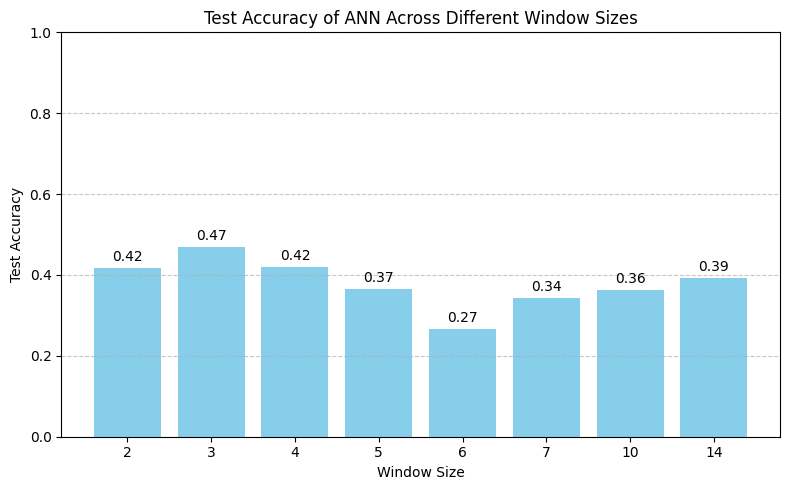

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
csv_path = "DL_balanced_outputs.csv"
df = pd.read_csv(csv_path)

# Filter for ANN model
df_ann = df[df['model'] == 'ANN']

# Sort by window size (optional, makes plot more intuitive)
df_ann = df_ann.sort_values('window')

# Create bar chart
plt.figure(figsize=(8,5))
plt.bar(df_ann['window'].astype(str), df_ann['test_acc'], color='skyblue')
plt.xlabel('Window Size')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of ANN Across Different Window Sizes')
plt.ylim(0, 1)  # Accuracy between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with values
for idx, val in enumerate(df_ann['test_acc']):
    plt.text(idx, val + 0.01, f"{val:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [10]:
import pandas as pd

# Load CSV
csv_path = "/content/LOEO_outputs/results_summary_loeo_fixed.csv"  # change if needed
df = pd.read_csv(csv_path)

# List of models
models = ['ANN', 'CNN1D', 'RNN', 'GRU', 'LSTM']

# Compute average metrics per model
avg_metrics = df[df['model'].isin(models)].groupby('model')[['test_loss', 'test_acc', 'test_macro_f1']].mean()

# Print results
print("Average metrics per model:")
print(avg_metrics)




Average metrics per model:
       test_loss  test_acc  test_macro_f1
model                                    
ANN     1.222203  0.374776       0.292029
CNN1D   1.270447  0.380753       0.290814
GRU     1.149322  0.366190       0.279303
LSTM    1.161404  0.337143       0.253590
RNN     1.109680  0.344286       0.275214
